# Covid case forecasting Using TimeSeriesModel from arcgis.learn

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Importing libraries](#2)
* [Connecting to your GIS](#3)
* [Accessing the dataset](#4) 
* [Raw data cleaning](#5) 
    * [Calculate Moving Average for Confirmed cases](#6)
    * [Cut off first 6 days date](#7) 
* [Time series data preprocessing](#8) 
    * [Collecting the counties of the Alabama State](#9) 
* [Time series modeling and forecasting](#10) 
* [Result visualization](#11) 
* [Conclusion](#12)

## Introduction<a class="anchor" id="1"></a> 

COVID-19 forecasting has been vital for efficiently planning health care policy during the pandemic. There are many forecasting models, a few of which require explanatory variables like population, social distancing, etc. This notebook uses the deep learning `TimeSeriesModel` from `arcgis.learn` for data modeling and is helpful in the prediction of future trends.

To demonstrate the utility of this method, this notebook will analyze confirmed cases for all counties in Alabama. The dataset contains the unique county FIPS ID, county Name, State ID, and cumulative confirmed cases datewise for each county. The dataset ranges from January 2020 to February 2022, with the data from January 2022 to February 2022 being used to validate the quality of the forecast. The approach utilized in this analysis for forecasting future COVID-19 cases involves: (a) Data Processing (calculating the seven day moving average for removing the noise and vertically stacking the county data), (b) creating functions for test-train splitting, tabular data preparation, model fitting using Inception Time for a sequence length of 60, and forecasting, and (c) validation and visualization of the predicted data and results.



## Importing Libraries<a class="anchor" id="2"></a> 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

from arcgis.gis import GIS
from arcgis.learn import TimeSeriesModel, prepare_tabulardata

## Connecting to your GIS<a class="anchor" id="3"></a> 

In [2]:
gis = GIS("home")

## Accessing the dataset <a class="anchor" id="4"></a>
The latest dataset can be downloaded from USAFacts: 
https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

<Item title:"USA Covid Confirmed Cases Dataset" type:CSV owner:api_data_owner>
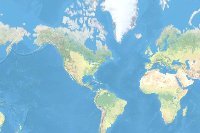

In [3]:
# Access the data table
data_table = gis.content.get("b222748b885e4741839f3787f207b2b1")
data_table

In [4]:
# Download the csv and saving it in local folder
data_path = data_table.get_data()

In [5]:
# # Read the csv file
confirmed = pd.read_csv(data_path)
confirmed.head()

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2022-01-23,2022-01-24,2022-01-25,2022-01-26,2022-01-27,2022-01-28,2022-01-29,2022-01-30,2022-01-31,2022-02-01
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,13019,13251,13251,13251,13251,13251,13251,13251,13251,14826
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,49168,50313,50313,50313,50313,50313,50313,50313,50313,53083
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,4902,5054,5054,5054,5054,5054,5054,5054,5054,5297
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,5663,5795,5795,5795,5795,5795,5795,5795,5795,6158


## Raw data cleaning<a class="anchor" id="5"></a>   

In [6]:
# Extract the data of Alabama State
confirmed_AL = confirmed.loc[
    (confirmed["countyFIPS"] >= 1000) & (confirmed["countyFIPS"] <= 1133)]

In [7]:
# Stack the table for cumulative confirmed cases
confirmed_AL = confirmed_AL.set_index(["countyFIPS"])
confirmed_AL = confirmed_AL.drop(columns=["State", "County Name", "StateFIPS"])
confirmed_stacked_df = (
    confirmed_AL.stack()
    .reset_index()
    .rename(columns={"level_1": "OriginalDate", 0: "ConfirmedCases"})
)
confirmed_stacked_df

,countyFIPS,OriginalDate,ConfirmedCases
0,1001,2020-01-22,0
1,1001,2020-01-23,0
2,1001,2020-01-24,0
3,1001,2020-01-25,0
4,1001,2020-01-26,0
...,...,...,...
49709,1133,2022-01-28,6323
49710,1133,2022-01-29,6323
49711,1133,2022-01-30,6323
49712,1133,2022-01-31,6323


In [8]:
# Converting into date time field format
confirmed_stacked_df["DateTime"] = pd.to_datetime(
    confirmed_stacked_df["OriginalDate"], infer_datetime_format=True
)
confirmed_stacked_df = confirmed_stacked_df.drop(columns=["OriginalDate"])
confirmed_stacked_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49714 entries, 0 to 49713
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   countyFIPS      49714 non-null  int64         
 1   ConfirmedCases  49714 non-null  int64         
 2   DateTime        49714 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


### Calculate Moving Average for Confirmed cases<a class="anchor" id="6"></a> 
Here, we calculate a 7-day simple moving average to smooth out the data and remove noise caused by spikes in testing results.

In [9]:
# Set moving average window = 7 days
SMA_Window = 7
# Copy the dataframe and set columns need to be calculated
df = confirmed_stacked_df
cols = {1: "ConfirmedCases"}

In [10]:
SMA_Window = 7
for fips in df.countyFIPS.unique():
    for col in cols:
        field = f"{cols[col]}_SMA{SMA_Window}"
        df.loc[df["countyFIPS"] == fips, field] = (
            df.loc[df["countyFIPS"] == fips]
            .iloc[:, col]
            .rolling(window=SMA_Window)
            .mean()
        )

### Cut off first 6 day's date<a class="anchor" id="7"></a> 
As the first moving average value starts from the seventh day, we will disregard the first 6 days.

In [11]:
firstMADay = df["DateTime"].iloc[0] + pd.DateOffset(days=SMA_Window - 1)
firstMADay

Timestamp('2020-01-28 00:00:00')

In [12]:
df_FirstMADay = df.loc[df["DateTime"] >= firstMADay]
df_FirstMADay.reset_index(drop=True, inplace=True)
df_FirstMADay

,countyFIPS,ConfirmedCases,DateTime,ConfirmedCases_SMA7
0,1001,0,2020-01-28,0.000000
1,1001,0,2020-01-29,0.000000
2,1001,0,2020-01-30,0.000000
3,1001,0,2020-01-31,0.000000
4,1001,0,2020-02-01,0.000000
...,...,...,...,...
49307,1133,6323,2022-01-28,6248.714286
49308,1133,6323,2022-01-29,6285.857143
49309,1133,6323,2022-01-30,6323.000000
49310,1133,6323,2022-01-31,6323.000000


## Time series data preprocessing<a class="anchor" id="8"></a>   
The preprocessing of the data for multivariate time series modeling includes the selection of required columns, converting time into the date-time format, and collecting all the counties of the state.

In [13]:
# Selecting the required columns for modeling
df = df_FirstMADay[["DateTime", "ConfirmedCases_SMA7", "countyFIPS"]].copy()
df.columns = ["date", "cases", "countyFIPS"]
df.date = pd.to_datetime(df.date, format="%Y-%m-%d")

In [14]:
df.tail()

,date,cases,countyFIPS
49307,2022-01-28,6248.714286,1133
49308,2022-01-29,6285.857143,1133
49309,2022-01-30,6323.000000,1133
49310,2022-01-31,6323.000000,1133
49311,2022-02-01,6427.857143,1133


### Collecting the counties of Alabama<a class="anchor" id="9"></a>   

In [15]:
# This cell collects all counties by their Unique FIPS IDs.
counties = df.countyFIPS.unique()
counties = [county for county in counties if county != 0]
len(counties)

67

The next cell can be used to forecast for a specific county. You can declare the county to forecast by using its FIPS ID.

In [16]:
# counties = df.countyFIPS.unique()
# counties = [county for county in counties if county == 1001]

## Time series modeling and forecasting<a class="anchor" id="10"></a>  
Here, we will create the different functions for preparing tabular data, modeling, and forecasting that will later be called for each county.

In [17]:
# This function selects the specified county data and splits the train and test data
def CountyData(county, test_size):
    data_file = df[df["countyFIPS"] == county]
    data_file.reset_index(inplace=True, drop=True)
    train, test = train_test_split(data_file, test_size=test_size, shuffle=False)
    return train, test

The next function prepares the tabular data and initializes the model from the available set of backbones (InceptionTime, ResCNN, Resnet, and FCN). The sequence length here is provided as 15, which was found by performing a grid search. To train the model, the `model.fit` method is used and is provided with the number of training epochs and the learning rate.

In [18]:
def Model(train, seq_len, test_size):
    data = prepare_tabulardata(
        train, variable_predict="cases", index_field="date", seed=42
    )  # Preparing the tabular data
    tsmodel = TimeSeriesModel(
        data, seq_len=seq_len, model_arch="InceptionTime"
    )  # Model initialization
    lr_rate = tsmodel.lr_find()  # Finding the Learning rate
    tsmodel.fit(100, lr=lr_rate, checkpoint=False)  # Model training
    sdf_forecasted = tsmodel.predict(
        train, prediction_type="dataframe", number_of_predictions=test_size
    )  # Forecasting using the trained TimeSeriesModel
    return sdf_forecasted

In [19]:
# This function evalutes the model metrics and returns the dictionary
def evaluate(test, sdf_forecasted):
    r2_test = r2_score(test["cases"], sdf_forecasted["cases_results"][-14:])
    mse = metrics.mean_squared_error(
        test["cases"], sdf_forecasted["cases_results"][-14:]
    )
    mae = metrics.mean_absolute_error(
        test["cases"], sdf_forecasted["cases_results"][-14:]
    )
    return {
        "DATE": test["date"],
        "cases_actual": test["cases"],
        "cases_predicted": sdf_forecasted["cases_results"][-14:],
        "R-square": round(r2_test, 2),
        "V_RMSE": round(np.sqrt(mse), 4),
        "MAE": round(mae, 4),
    }

In [20]:
# This class calls all the defined functions
class CovidModel(object):
    seq_len = 15
    test_size = 14

    def __init__(self, county):
        self.county = county

    def CountyData(self):
        self.train, self.test = CountyData(self.county, self.test_size)

    def Model(self):
        self.sdf_forecasted = Model(self.train, self.seq_len, self.test_size)

    def evaluate(self):
        return evaluate(self.test, self.sdf_forecasted)

Training the model for all counties and saving the metrics in the dictionary.

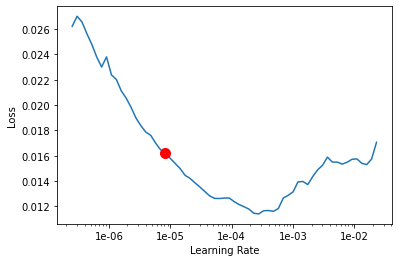

epoch,train_loss,valid_loss,time
0,0.022296,0.072083,00:00
1,0.021528,0.056567,00:00
2,0.019676,0.056948,00:00
3,0.017958,0.063523,00:00
4,0.016059,0.051571,00:00
5,0.014255,0.022249,00:00
6,0.012279,0.007439,00:00
7,0.010936,0.004679,00:00
8,0.010135,0.003242,00:00
9,0.008722,0.002114,00:00


In [21]:
dct = {}

for i, county in enumerate(counties):
    covidmodel = CovidModel(county)
    covidmodel.CountyData()
    covidmodel.Model()
    dct[county] = covidmodel.evaluate()

## Result Visualization<a class="anchor" id="11"></a>  
Finally, the actual and forecasted values are plotted to visualize their distribution over the validation period, with the orange line representing the forecasted values and the blue line representing the actual values.

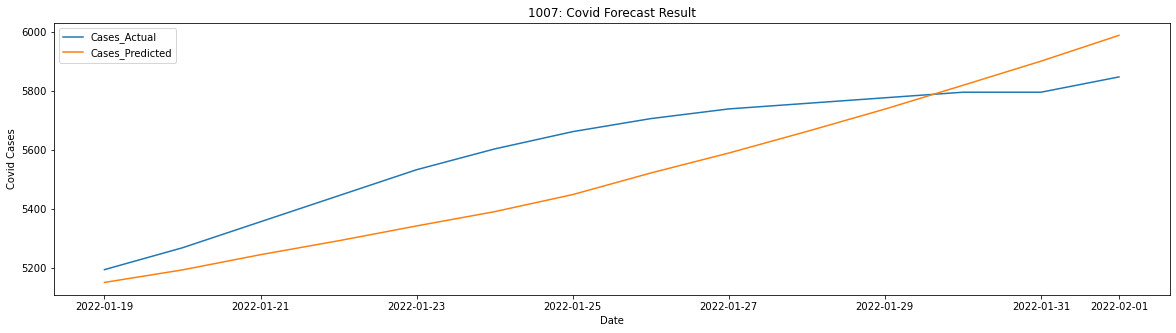

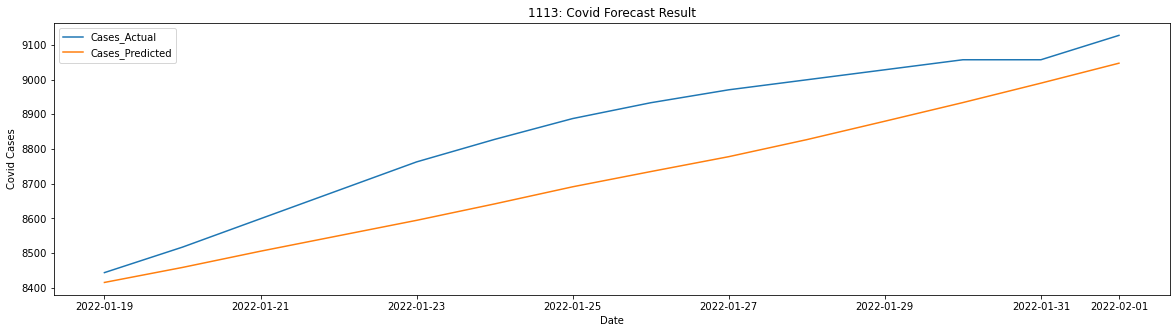

In [22]:
# Specifying few counties for visualizing the results
viz_counties = [1007,1113]

for i, county in enumerate(viz_counties):
    result_df = pd.DataFrame(dct[county])
    plt.figure(figsize=(20, 5))
    plt.plot(result_df["DATE"], result_df[["cases_actual", "cases_predicted"]])
    plt.xlabel("Date")
    plt.ylabel("Covid Cases")
    plt.legend(["Cases_Actual", "Cases_Predicted"], loc="upper left")
    plt.title(str(county) + ": Covid Forecast Result")
    plt.show()

In [23]:
# Here the Alabama counties feature layer is accessed and converted to spatial dataframe
item = gis.content.get("41e8eb46285d4e1f85ee6e826b05e077")
flayer = item.layers[0]
f_sdf = flayer.query().sdf

In [24]:
# Adding the RMSE and MAE from the output dictionary to the spatial dataframe
RMSE = []
MAE = []
for i, county in enumerate(counties):
    MAE.append(dct[county]["MAE"])
    RMSE.append(dct[county]["V_RMSE"])

f_sdf = f_sdf.assign(RMSE=RMSE, MAE=MAE)

Next, we will publish this spatial dataframe as a feature layer.

<Item title:"Alabama Covid Time Series Model Metrics" type:Feature Layer Collection owner:api_data_owner>
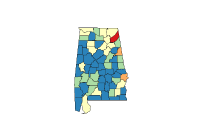

In [25]:
published_sdf = gis.content.import_data(f_sdf, title='Alabama Covid Time Series Model Metrics')
published_sdf

Next, we will open the published web layer and input the item id of the published output layer.

In [26]:
item = gis.content.get("9d197a4870a1479c81ddfd6b739816da")
map1 = gis.map("Alabama")
map1.add_layer(item)
map1.legend = True
map1

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAABF0AAAHJCAYAAABXKEagAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P1ZrGXZed8J9iNFVcONggR314MBA5aNQj24LcNvZZTLLpRbhihXdTUKrYKru6AuSCIp2xpsi5NlSRRnUeKQycwkk0wykznP8xCZGXPEned7zzzPZ+8zT3eIyK//v2+dHRFJJmXZJQN6iAOsODfO2WfvNXzD//uvb631f7K7r7uvu6+7r7uvu6+7r7uvu6+7r7uvu6+7r7uvu6+7r7uvv/DXXdLl7uvu6+7r7uvu6+7r7uvu6+7r7uvu6+7r7uvu6+7r7us/wesu6XL3dfd193X3dfd193X3dfd193X3dfd193X3dfd193X39Z/gdZd0ufu6+7r7uvu6+7r7uvu6+7r7uvu6+7r7uvu6+7r7uvv6T/D6QNJlsZj9R5f5fGq5XMam0/EHfk/hmqTw/+Pj+a2yONb/T/T58cTLfDH2MpuPbpcFRffX98e8z4c2nw1sNh3adDay6Xxis5l+q79HZyf6u2tH0dyuNwZ2vVW1d1s124nr+rxs/VnL+uOWjWZ9/910NtXnt+s6nfdsMC1Yb1y0waRh41mk0luWyIaTpn5fseGspGtyKnnrDrK6tmLjOd81rFTN2IVL5+zb377f7r33m/YLv/AL9vWvf90efPBBe+edd6zVaqjtepbqS5ums6GNxj3VY2ynp8d28+aZfe9737VvfOMbduPGDb+WQl/QV/OTkZ7XsnhYsb6eO5hWrd0tW6WWsd6gZvGgolK0ieozP+6rP+lX+pp+DmOQFMaEvuPZ42lP9a9bT23sjdsWjerWGRatNcyqpK05yFh7kNMzi/q+YPEoZ9Ewp/e890N/EkpvQv+VrdvP2XBa83vONGazydQqhaoVUiUb9cbq67GNppG+r1pvpLboutG0o3r3Nd5D9WdkscYhHpZsMGqon9RH+m487fq1sZ7Rm1b0m7ZNFrEX7jeadG0yi3V/feb/b6m/qjYcFW2ktkTRvtXbe1brFS3Vadpmo2+Z/sKG84FF07o1hkdW7m9bZbBj9dGhtcdZi9WueJTVWKf0XnJZmGlMFscn6sdj9a/GZSGZVB3G847kpKVCPQb6fmonJ4sg7/p7obE4Pj7WmCO/Q40p8i35mnT0WduGKj31fTQpWVft570/r3qJp+pXfdYZFSzyPs/6eAynTe+3qWSE9/FM95o19LlkXuPUn5es3j+y9jCvzzUmA91TfT6Ya7znLeuOYtvtxLbXP7F0q2+dnvREfRZPS2o719bUfy3JnmRkKBmT7A0mNY2z6qX3oe4zWjT1XHSgrjr01P6O2lF1+RxonHoT1UXyMJl31XexRYOyxqxj0+Ou7tXU2PH5QN/HqndD35es4zIkeVaf85mPs9o3nEQ2kB6PpesTycnsWOPsuq36IBeSz67Guqux682KepeeqkQaR2S5MThU2ddY72t8M9ZRPzaHKfXRob9TGoOjZTmwmuSh3t/z/3ck7109I6KobyL1fySZ572r5/I5daU+2JD+uBbkT20fSr4Gc43LrO22ZiHdPJ5LLrBBskcn0s+T+cxOpZcnkq9T2bOBZKU8Gtph1Lbdbs1ScU317kr2RxqPY9nEEzuTDJ66nZA9dD2QHk2lA7JzM8k1ejORfo8nPb1LTiR3cz1vLvvXabWtUalaOV+wXCpt7UZTtlX1krxiG+60Fx9UElueXIusY1eiqGOdjmztSDpwMrPJ2US6MbD3bhzb2Wxuo87ACkcFK+YkGwO15XRhJ6eySbL3Q41tX/LGWM9Phhp3jbf6ri8Zog9HkjPkaCq9mUnv5rIXbmO8rbrX0tfcWRIfFOyd2r78f3Ltnf/ne/poqH5E1tDj+bFslp4zmKCf2F3Z/EXd7X6oC33KfRa6n4r+Znzd/mpsuAcyzvhMJa/4kngonZA/GUse8AFTXTNVW/uzustYLP3BljB+I31X7ndtJ+pbvj2QPZYeTjOSN8ko8ovsyRd1sFPyTcg672233cj7geT6UHqRs8GwaY2oZlndby2O7Vo3st24bZW+7Oqwrv7Hbkt3dC/sXixdimU/Xd9la4ZqL2WgcRhjs04Gtlpv2EE0Ux2k+2rnSL7nWOOzUL8l43N8MnYfRt/2B135QslyQ8/qx97vJ6dzfTeSnErPsbELbKhkSGM+lp3CZnmfyR51ooqVKtLlluyg7FGsdkWy3fgg/DE+cjjuhjGQrA9H6kPpzTiuWrN6ZN1Ozppt2YQ+dmtoJ7LNZ7ruTH7pVPKKbwZ7gEfGE+mPrkG2FmAQlZE+Q4cZv0YvrX4XHphJloUN6PtoKt84k32ey4fKb9SiA42F/M9U/SibFE1y+k3KOtNDK/VlYyLZ5zhnh82crTbrttPpWm3QlpyVZZ+OZLewPcIas6qNZEMGE9nukWwdtlF2Bn0fyebiS0aS2fFE8jaWPEnfJ7KTkTBBpXNgLdlUbDs2ChvelT1r9A6tEsnnxZuydbtW7urvaNcakq1StKn/76gNPLsl2cXHSQb0e2xbpDHpyEfjk9zOql1dySO2tymfU48P3Y8c5Vft0acesNfffsYqDbVb9r0r+9kYpGVbU243z1181b79vW/ZS68+b2++/ard/+A9du7K81Zs7lm+vun3KzYO9Pe+lTv7qquK5LoYbVmqft1S1YtWaF+3XH3F6t0DyatshWQJOeiPhdlU12ggf6T+ivV3u6/6qv9itaMjGaIOPfUNcj2SD8W3TN12yucMpbMj6a/8FTiP+9Tb0q9I/rinMZc/oz+QB3DRaC5ZwA8JM3X7wkQaK/eZem53IPwkOYklBy21v6mxL1TWrVLf1v2OJJPqv17OWl3JkPDcWDZnLlt+DAbErsh+Ticz/XZsO7IFu7WGfEIsWYvVjqp1hBEYg/ZIOKe/rv5Z0fuGVXubVu/tWLayaoXqjlUb6vtmwVpt2ZJY7ZIeTiZ6xtKeD4d963bb1pQ8YsuDjZ8uMbvsoepE3Ubqz6HrnNoo2exJRvGFHclAunzddlLv2sbem7Z9+LYVausuy+hHUz54P/+ubaVft1zjmj4/lB4c2mFxxXZz5/V+3bZT14Q7JfMaD+S82yuo3geWzW5b5iAlGyJZlv0cH7es0U2rH7ckHxtW6GxaobdtR811e+7Fh+3BB+6xe771Dbu+uWKFeskqva4dyvbtdIVZFvptLDyY27LN3au2uXPFsoUdq7XT6uO892elc2j7hQuyvVfs7dXHbOXwZdvOv2kH5XcsXb9sadU/07xildLbrqcX9s7b6u6rli5etNXUZf3/ou0zxn3ZCslds563l7f2LZVPWU/9/tJWyh4+v2pHmbxd3knbhY0d3Ud20u2M/PpUuoxOy5+2202rVPIaK/y7bKpww1T2ldgGvRzKDuErF7LBE/yVZBP9j4X/IvyEsApYEvzc07ghn+BO90Hqi9FIdg27OG5a1O3Yxv6+7ZSCTHck2x1h27T+v7m/Y5laQXInW9XJ26vXpevC1YVW0TZywlMd6bja1ozkv4UbkRf3caorvhu82JNtcPwE1gcjqhA/gPkCxpfPEWaN9d6VbnVkY1rC5W4zvA3CV/KXkwWYSn5Hts/jKbCD22/5c/qP53oMAV4gnpSvl1/CboLdQ6zAPULM0GhlLScZaEeKqzwGke7K5xZLKXvq6cftgQfuVzz3rvRDGFb35Z5TYTLH+fIfxIzDqfpyXpO9rOsa4QjZkY7krdlSv/eFEd1HabzUz2PFMeD4EUV2djyXTIMLlnYaXEu8hx8cqp6UgX6LP8S2gPfB/cQmxD5jYZcRuFplrHrwfzCg+zB8m/xtPx5apVWyhT6f6v/18Uyx8tByvYEdI2uqC3UIOCvE4SFGpz/pO/SfdvFM/HXs2J53/Hf4LmAAnum2w3Eq9oP4XniUWAVcLFkE4w3VD8R02NJY8WckmcXHYVd7wiDEg9gBcBL2GXzUV7yEP/TYYjnW7g/Bb2rDQDLSk6zEiu3xS23Zn1j+imeBy2aql8sJ7VKdGAvGe6R+B3/MwTFLHBHaLQynNh8rbj5RDMg94Aw+6PUXTrpghLPZtBtq/n8ncE0K11D4+0d/70GoBuNOooVG8R4G9zYJ4wqk9wUgG8Whs7hWIG0O6TOd2uTGib0nIBzNjy3XHVum3bJrNQUrCizmcqZ9dUwkA9MfNtTBKN+SeKGuqo+DqCmBbMGFe6ogcMpASDmnun6MUgM0FzjdoisCTtQNHc5Hg9GX8yuW8nb9+lV75ZWX7MMf/rA9//zz+v+K+ionQza2GzfO7HQZZGA0MQBnZ8f6/NTLJz/5u/axj33U3nvvPSdi+OxE13tfeF2CQiOYgPehgua417bjUwCiFE+CNiOgleGZqX0L9UfoyxAYJYESCpD0P0QFgKMn4e1JqAFTbQGy2wGoHBDAVoLfkSK0+hkVBWkCY10IGBnDeFkAHR0BB+5H4EB9Edh6pW7FtBxzNJQyEzyjXBAuOGyMBmSJ2qdxHstwAGIJpDFOGEYICgwcioaSYZy8jQRbBD0YBv0dAkyMDgZKjlqAqj0sqD1y2ALI+U7GSr2apVsNO2p0rS7wQvDQEzDDoFeG2wLCEC/7an9abYNgE3gayACrXyB3UNQFQa8K4+eBLcCA4FBgj7ZNkFP1r/ez+j0EZUHu5xp3ApGp2uzE0EjGFeOh0lefAVQBLhT+7s0kayq3gnuCixkAuuAOx4lBGUHkmiCVPu3iZB0MFwQyBOo1Nj1Av/4POUa7uIa6lhUsXmoIwNWH+l6Br5xFm6AAAClZo0+PFQDjPHAStJExcCIBYkVjPZWjgJhhHHsK3txAylEjG236DqeqYBp56I0koydywscy6ARokt25grKJ2sF9qT+GMRjHqtqEPkqOcBgaa3SuJ4CJ4/H+5v8EqU5uCHhKLtuS3Xgq0DRScKpgwP8eZzSmyPO+xn3P5ZtS6x1YNdZnfQJUBQt657O6AqL6YEeglmshrjIq3JP+EzBYghfGyMGMHONIQYk7R9UpAHEBgyW5GKttA/UPDuxYMgHJ4sSL9HGuoHMOoJ3KLkzONN7vWW50ahtRzza6VctCRAlgjCRXC65VcH/ihMuJ7kEwq4BLYwWJBTmJ48MBOwGpZzKG0ynkQLB36OTxQgB7LIBNMJ/OWjGrIFZg9GRpI95vr39y4Z6JXcHeA9IB7A7iTxYa47n0YWInN08lH3PZyZnlcjU7OpItaXRko/TbE9knB/Oqq2wxBPPseCg9h8ALQKwv2UNekTH0C/sZ7Jr67Vb5cV/0o/X9SeXWb3TPmYABwfZEzpXxwjYRzDsIkCwNFVADiLBD1HfKdU7kc49gV5FX7MR8CYxnkuEQuClgdR8i2Z4HQOQBnoAE4xcJpEYDyYrsEmCV+7ck63n121o5khz3dI1kfKqgTXVpOwkeSBdsw22AQeCg4ATZHR3pM9kyyWUsWYr0nLLAfF7BeU3P6aiP27LvbbfHkle9RwJ1seQW+wyIod+x3QMB/njUke+VjTmW/Ri2bas1sWJ3JBum+gK8TiXnsuVhXOkX+ofxCn8PBj3JCSBUAKune0NuqD6QLgDgIbqiOtDfsd5H8u34FYKEbp+JhrTVGhm1hYBX10gvAyiTv4CAZGJDzwpET996sWxaPW2V4p5kLq1AQFhB9e4LYC6OF3amciLgvFjij7F05eTmifRtIhlgPMO4gjmGqudAoDIWOGv1sLPya9JNn3DQOPQ0BsMFQU3Jg0ECiNCXkNDYzJrGomxN9XddvjVWkN1VXdZqZduQ7lRly5kk6mj86vG2gsI92bSMnql+cEIdPZAt0FgSbOBLIFUJJGg3MsxkGBgJ/ceeNmTTkI9YdopgJ5YfaMme1Xr7Vom3rKygvKqgvNDasFJHNm98ZIU2f2/7pEtfMgCwvdO2xZLfSPeGnCd4gnQh2PbnuAxKvwc59UHGnnvpEXv86e/Z1p4CaQXPHV3bko9pjuRnJaPZ6rY99MP77Ov3fsWeevaH9tqbL1ihuWvVaN9K7S2ryx6XWnuWrW0rsN7R37v6ft2Oahcto6CXehdbO9aM1feyg+jaWL66p6Ad3QAYQ46A4RgryCKwQVdy0O4H0qUP8PdgR+0UnguBhXDhQDaoD/GLThSt2c2q5KytYN0nFzQW6HK3z3c5+bYEC0AUM+aQLupzSK7o0PLNLcs3Np0casUp3Sej38qvSLar7ZTlK/tWVfAa6bkD6Uo8maqvplYbza3Qn9p+Wz5BdnM3iq066vp4THT/gdpIYNqcyKcNGdM1K0t+UpVrdlS6ZkX1Z6G6Z6WqcF1T8tlT8DJBTgJODzJzGydivyHQIUcTEj3BjdisPn5efdpTn6CnTNZBWtG3dcn9YW7FMsV1K2rM6u3DJR6BcMzYQeGCbaffUj9ccwKmhR9WfxSbyOCmVdpHCuaZcAHzdR0blWt7lsmuWqGwK38l/x7L76vv0aXLq2/ad3/wTXv25Udsj2vae7ZbuGivn3/ann3+MfvC5//Qzr39pp6bsb1GxTZldw662Ly0xr0oudD4QbL0saXILRMxe1bpbttB/rL674rs25rtlc5Zqn7eso1LlmtckWyuWSnasGznmlXKF+yosGkvXnvd3l1/2Y7yV20zs27ntq/YtcyqZeope+36O9auFe3l1W27vk9g37EfXj2wb7+zISw/slSjb0+/8Y5F04n6Unqt9k8gRGSnZhof7Ga9obF2IjDYWAJGZBa7gA2EnBpJLrpR1W1krSk9kw52IAEdPwbiJRZ28ckt9e1ENhL96Pa6Gk/Jv2xwt9u19f20vbl9oHtrnOUX3t1Ys4urG/bu9VU7v7VlhU7Zqhqnb7y2ZrNh095cv2aPXr5q6WLWdlIZu35w5LaWSTJIULAqk2vYMSZWIYLA+iMIH7dtS/ISm+l2JZSu6oxsdybyaZKfPhNYYF8VJt4gnCfqo4nsNkG9+1/ZQex1IHzw0bxjI8EZ4AfiBmJOxSPygQPh0mL5wF58+TH7/Bc/bd9+8Bv2yKMP2ptvvWSr65ctkzm07e1Ne/TRR+w73/m2x3lxT1gWPO9+nzhtLpurGEa+ElvjmBT/2q07wdnrh8nVQLhIX9CZJYYNBAv2JEyqBxIKuyGsoL+xvZASCaEApqSv+O1IdovJzkDm6LledL2eNRoLD0qOiJEgEMbS43oztk6vYmf6HBzYES5bjwa239H/5cOZJHV7qOeAwYjJiJG9gL8o+q33qz6b+feyJxBM+o7Pk4kwj+HlO3l2iDnxS0wCIhOyx5KrgDGYSIUwEc5Su510QT4kJ23FMB3FnRBNXIuND4U+hiCCAGNsA8Hm8kaf4Kscz+DzIB4hXRQ7KeYajonbGDfwtN5VLyYpmFweTdAJ8JfaIlyAbeQ9tKmv3wztmMlEyV5Pdfqg118o6ZI49YR0uQVWf6Qkxpzy498vgemyhMFBURicAKCdGFHjQkfS2IR0kbKoAJAWEBe630CByGJWs/mNMwnfWM62ZXuttm23BDokiP1xSkYlpQ5iBl3BvAaDQRtJSEbqWMAuYInBCbOpMHGBmSXQmy1gncl+6cjRVJ1hQ6hx7BgT6n5yemJnZ6d2U8EFMwQ//dM/LUXN2I0bN/XZTSdS1tbW7Ic/fMSJlyS75etf/5oVi/lbpMvHPw7pclMGtm9Xrly2t99+S+VNK1fyboTnCkYQ7FI1a++++669+eab9tTTT9rh0a4AQiApArt4or45WfZxAI6M323Chb5FyNsePMIc96RoBI/M3oUA9dCNHFkWsYS3CzgfCLDJgCcBaJKVAZAD4BDMc49IBgSyinFr1mpWykiRWvShHIQrG0EyCoPRpI8l3ABI/b8vJ+gMpq7FiJ4IvCPoMKv8nuCdWUfIOGSGmdIEYHvWCISLxicVtWyzWRKYLdt6t2Zr7YZtSC42aw07anUVZCiIl1PoqR1tKWRttGflwa6V+wTmKbUXwAaZpIDUDVxCqADoQz/6M+WkgsEEDMsAqD3MkLscSz4xyugMQO7klN+GWX0YdIAh7KobYQIyORwyjSj0q4+NHBPvwQkJ5AByBRIGbhTlgNUvQwyG+jXWGEEKRJLztq6lNBjDWQA9kAfMsrX7KclxyaqSl3MFAf5a3ypR5LMIXQE3wDNBTNC/vo/DWAAI4tIJP+kQATGBEIYKoAuJQrZOR3WD2OkI1EB29CHRRvQd1wz0ewGpcSAHIVzoLz6jjynoIYU+TRh3SNCJ3n0GuJf17wAKwWFBxFEngWh95zNqAHuNYRKMEhA40B8us108C+DQqgpqIF0gXBKi0QkY5H9IVsyBl9v3ArQQbCTggP8zTqqrwANEWMh2UX1UcCxkEJApMVYfLk7mdiI9PMEOCtyOjo+tt1hoTGdWGQ7sgFm4OLK9uGcZldqgq2fJ1iw6GgPszEwgDOJG91GwSKbM1Nl9nPJyZkN2KilOwriDxOkiszgZ6cyJfitnezxdWCVftlJWDk5AC3s6X4LvP09JCBf+xtYD0AHryDuZXcfzU9VjLhmYKcgaWy0WuCw0bH8/Z7VyQ88P9QkBuvRZuoFMANCws9GQ2WICamZGAG7YZXwG9oznJuXHCRfKB9XzJxX/Df7ohOcIfOJ0pe/IJ8ADR46cjRS4BXsQ9N2DNNcT7FHwaW6DNdYUJ27kQybzQDbfOWvDc4LuQJyhFwFABZIDkr0tnaxYazKxq9WW5KEv/SpbA/mG+EDPCHb13pWcR/oM0oXgxgsZXSoExWRbYLfRF2bBAondkAzLruu3bQXLZP1F8gWR7DM2n2uDHAPgBPgE9plgmM4VXM+lr9L5Q4G13cZYQSQTFPKRp7Lp+Gf6QP7GbZ+wAu8zySv+ciTQ0xYYbbQqXroKoshMcMAkuwbpwthD9JNF0u6npe8F9V3FqgomGk0yXWreDggr+gube3Z2onEACI/t9GwmP6tgRQFBvan2K9DqRRXVaai26fkCoAOyzZy8RH4B4qqbftufTtW3+htSUL4dnw2BNJZN78jPxiNAn2waGUwqBODY5L5stBNXqicEtBPMTsyHGdgFsi057yJXkoeZxqA27NlWU/4qblp0LDk/xoYquCdLRnaaLCUmPSJIKD0Hshm7AqkCmA0zvGAoiP6F66GTWJJNyKAWWVGQyDHl0DNHmtg52cEKkwwqtfeRLikrKeAsd3dlS5mMCr6awAi/7QGC5ISMycFcbdX4IINt2ceufGlFQfZAeKwzgDwo2/beVXv0ie/acy8+bsWq7Kme3xqpDqMdPWddwe2unb/+kr34xmN2ffMdK9bV7lHean1939l0G12J+FsBd31X3+9apbNl+eYVS1evWplMnphJEcgWMn467lOdFND7QEEIRCb9BkmE/2uRwSvZAs9E0seebHRfctIfKgBT4OlBovR6KJnnHpHq0+plrNo60rVkfkHSQOLID+r/XT2rE4N5wvX4pcmxdEv91+jKj6jUOhBH65arrstPSZ7l4we6Lpada/YrVmzlbK+StrV6xXbaLTuM+3Yke3kUDW2/27e9bs/2op6l+5HwiuTvuGuR+r7rOi5fFm15f+Xb6puWxk/jcFTckL3dsGItpQA8ZLf0epJZ+ZvjxbHkJ2AZ9GUyIQgNk4HYZILYvp6VEC+eEeOZ5vLh8udxH+wS8HRffT490eeSOSdGG0dORCXyAtlI1tRh4aptpc5ZRuPWGTN5l/Fsr6b0m3Z0Javo0VB9H/Xa1upUrd7IWyq9ZbncvrXqZUvt7njGQLMHBi3Z5bW37Qtf+QP7/Jc+ay+9/qJtH6zY+t6b9tb1F+yZVx+zB799rz337NO2crBl69W0dC1nRdUNUrMZ72pshPlaun911bLVFUuVr1iqeskytcuq7wXL1TetKL1I1a5YvnPVKvG6ZG7TZbCme2S7K1aqbdpebtfe2r5qb6yf030OLF/L2cWDbXtzf9uup47stbXzqn/Fruxk7N29Q+lX215aObQnr+xZX2ORaw/s4edetPHJieQIG6nYAuyFP1FBp+Ney5ot6Vwfwp4JZNk6YThsTTuSrxSmJBMGUqrZLqr/JN+STYLPvjBKH+zi+KUqW1pQEC4bKlkvt7O2nUlJBiXDsul9+er9YtO+89aKdAHSsW2vr2zaxY1de2d1056/vGIrmbQV2xX7ykvSQdmvZy9dsPveOm/vbu3btd0DW0/Ldg3A+glxr3hJNhPsFjIoZStlJ0YQCkv8hn90XKW4ApIIsqUNbpVtCb5McdCJMA1Zo8JZjkWdXJBMg3GIbfAxHnveDpQdx0p2Jx48Q87Qn9jkgdoHsddy0uWxJ75j//xf/op9+ctftoceesiefe5Ze+qpJ5xseeyxR+yee79uv//7n7FvfPNPhGG2pBNdYSn06FjPYyWD7qvn0d5YY9HuyHe3GS/FLfIvSRZ+yEIJ9ccGYGMDdpePowjjQ5JDTjFpOYSUcuwhH6x3MpUYy6GwCJmIZIDfznBRXzsJI7+osQW/e5bKZGBRp2112ZYJfaC6nKmfcv2RrciHF/vCl+q7Ias3qJOKZ98Qc8nH3spqEQ4P/brsW/khj81UAtbkc+wE9oT+Fi7S8wPJBU7CH4J3ZKfH+BSwK35U9luyQOYcJElP7WeyuCN77Rnskteuk7xMsjLBKR1QjAlZE56zvD/kECSQvg9YAkILHcjpt2Tw008kJoD5wIRL3Ke2hOSFMDb4EXQJ3BKwpGRKbYAzmJzK96t05Hc+6PWXnnTByP/Yc9QRDngZIClHCP40mLdIFwkIwYN+O9HfMzlLhJ8Z+ZaUeVOdsS7wX5fTbGvgWhpEZli6UwEYAcz+rOwzaC7AGhTACTPopJACegkCceAMoi8hccWFjMEZd90ZI9CBMaU9apfK6dlcita0n/qpDznpAuHCcqGbN2/Yvffea7/4i7/oZMupgJzZe/ZzP/c37N1337b33rthn/70J5ekyw07OjqSov/Qnn32GXv88cdsbe26RXHHM19iva+sXrdnnnnGXnzxZbvvvm/7UqZCIevkw4mA/vFyCUwAvmEMQr9qTNQmFNNT5wAcBI1ulBPSRYBPASmlLeAOMz6QIkLKMLsVjKICbgmwz/rDyvo9yCrg/xh2AQ+Wn0h4G/WiFdI5a1ZDf2NcASVhuU7i5JldFsiRAjKLhqGGOcU4HqtfGe+EnfbgE5mRHBEkQmBBvNCuMFPaEKjr2FZ7bNfr6qt211YFWNY6A9tuC8TovTIYWU+KCtkBuHeSifRFBeYNZomHBC0KsgW2nG2+FWRBHpCaSF1g0qWEMm4A7dAmgqil8Ucm7pB56g/pwjvyg7GHyAiKTr0VsJLuTGYEhkJ9GGZH5YwgxXCU9K36m75nPAYyUsxg8xtIMb4nzTcC9GK0Fwpq1J625L4moF3tHQjgyBkK5LCEoKz7rArIXK+0bKcmgMM90BGCMzkz9I2UdeQq9C9GTnWXEwA0tmP1Ua/s7T4+k8NZdCQTRWv0IC8EhtWfkEUEKJBwBCgYPUgIMocgYgiYAMbO7qs+gDX6mgCLQJdMlzBDIkCsNpG6PT0OGV8hCMYhhbT7lsBsMrNP+jwA28kmggKBvNvEi8A/S4h6YflQstyoNUrre67jnXRWgWWuUVsIYlkiAAnm5JjkImQkST7U56T/4zQgiuiPwPpLxvkb+3EqoHtGlgqZJgJVko+6grtsb2SZ1tC2Ow272s3YSvfQ0gKUPcnIiZz4ia6ZT4MeoyuA4yRd83ipz/4cHI1skztddxo4F9VH8omckuUC6ZIAkzn3Hc+snCtbvSTwNcCuCoDLvv+oPf6gglwnZEYi56RAk+mC3V/MFzYZLhQgdxUoNQVmq3agZ+2ninZ0qCCm3rZTwIp+F9qm556oPdIfZCOWPWaGmLTpQLwFcnaGvfXsMQib4Ctu61koid9J6vqjhMtPImEAsKQGJ8vCADk8mzphqyBQxpJZB7EqTh4DKiG53Pnf4Q/oZ42T/8ZBBlkCEJAEKuF6SI2ZQOTiVGOo5yAnEJMUSBgCOABYW6BwJ27bfpMlBW3ZKohZ6Z7kuinZRb7xb15GoYSldRDmANysdAx9ZHZR8onuSL8AVpF0J5qQzXdoHdn6yLPr9J3ePf1XNgXi0AGd9B+Ay3KXKf2ketaHsrWN2LKyswSDzUUg2+mLZDKFdwI2BzFL0NWXje72GlZvlRQQlhQ0yOapndhY7H+MTYNgRn9ljz39XDJRrcuXtAREFfjhlzvdln3/B9/zwPBEActopDHQM1dXr9rly+/6uHUBWZKtCTPE0qlmv6cAqmtlBbbRRGB5sZDcB0J9INmq9wYKQIQdWAKnex4e7tnrb75mw8Xcqh18BnZevomlcXqn3iyN9Mws5HZY05iO7fTGwo5Ssh2qGxjg6OjQXnvzTZsJFyykxw9+517PvCzGXdka2exlUNQbqOhenkEje8oSpWZfNqwPSYAMNR3gAhjJFAqgEV/KUi2ydXpuU5nhrvYhVNYV8K9aobFhVQWZ2L768EB+cNeX1LK8yLMMWIYrG0kWDOQzRJ4Ha/gj1YXipItkZriQ3V3IL0GKOWbIWKa0Y488+R27eOV1O8puWrWZtUanaK+98bw99IP77frau+o/PZv7D7bU/2sKaNct19pQELqnz8PSpIpsIEtjih2yCXbkt1jqeaD6H8iW7Fsj0ntDv6tsyObLXxBgaPz6kkUCUDIMmUUeTSAu++rHSD6SLBf5hT7LjLnfrvsHT9XXeMWSxV5foN9JF91P/moEUSpZR5+qXZY57ev/8stLPOTBq/tknid7K7sbMmBq8lMFK9d3LV9RvzZ2ra42NXsEooB/Mm/kw2QHIulUbdCyXLdme82KrTbqwikdS0UDy8dj9cvIat2Bxp5lJ2GiZy6ZIOhqzCtWnqStEDG+l9U3a1ao7Vu6qP6pptX/sh3dqgJw1SdS2wayo7L7LIXE7oaASPIiGaIk/7/9Ltnuxy6/kC/drnwLy9eExQmy3O8s9Fv1sU+esbRF+u8TIeo78B5EYXtQtFxty65svCK92lS/p/RZXv1RsBbLvbBV8s+R5DJWv3WiuhVLWcsXUpZO79rBvmQ4V7BaUX20vm71uv6Wr+xpLAq1A3vgwW/a5z7/h/btB79tL7z8jK1svGUX1t+0R557yM5ffMvue+Bee/nd122remCZiKxXyUG0q366YhlIltIV206f87KVfst2cm876VJor6gc2l5pyzbzlywXbVhNuKAqGa12yZLdtlRrxfYKB3ZxfcVeXb1kz12/IF2qCRdFdvUobd+9uGI/fPeK5at5K1VLtpEp2bmtlOWbTTu3vmMvX9u1weJU49yz519/XXIRfIfHOvh2gkGfcJAsjyIrV4TPYtnJcchgwM4iu1Gv5mPhy46kCyyL88DRA1ONm8YCufSsdskpxPZCMog9rwjDvXLlmpNDPdnJznBiK6mCffKhl93O9hXrXDjM2dWDQ7uyd2DPXd2y1zZ2LSVs//Wn37GX1/btkmzkQ+ev2vffuWrrhylrqY74qoDjyHRmCTm4Df1YZoJhS7AtXi/8PbEFRKJkQL4fuwIWZ3k4/o6gG8IFstuX4/d1vZN/ZCaECeeAAcAFxJf4Y2I4ySYkjGwj1yDf9CUTPcEfRbIdddvYumg/fOwBu+9bD9i771ywnZ09u3RJY/rcM/Ix31V50L55z5/a17/xx7axft168slOyIMd9FyIHyYUWIHAcqKQmYTP4ZkUfCLERCAyHAMIO4Dhwe8hGylkrIIrPZ4i00h9FZZUCScrrgqfywawnFF2qKe4Fcw31ThDjITsHnwwehzilEFf/rmODezY2ckNXRs76bLZjm2z21e8pjjq7NjGJ/ytmEb1GlFH8I/kijL3cvu+9B+TGCE+Xvp2yV54Np/T/8kY8Bk2JnxHfO/xtOpKFi1y6hNatBvSiZhSOCQWDuFvbER7OQFBTOTLioQ/yG4NmIvCmPN/nkG8Dh5WrCE84Zn58glkTDPB79ucOA4ExwZ8jb0LqxAg8wLeoa0hWYFVMSPJqvCJ7M7kpOPLtT/o9RdOuiBAP2l50Z3X/aSC8IXOCQoAQE1+F0oA8U5ywIDdGkCEByPDcyFcZgLtMzuTQz0bRnai+owE+nIy4utxwQ5iAbR+w1JyGodRQ8GN/i/FbmsgexJcli7MMEhSOAQM4ASYYVAgXnh2CGhIfUagBj57huC4IRo2vY5knyTXUU+Y6A9/+EOWy+WccDk9PfUsGPZ6+chHPuJEDLPAZL/8zb/5c/bOO4F0+eQnP+HLi8xu2tVrV315UqlcUl9nbX9/X45Pga1+V6vWbGNj3Soy4HHcs2Khav/9f/8LApkrqh/OFMEJgZOvo/MgZdn/KCABrISw5zNRZHMUZPgA11Je9Y9nuixJF4iHoPQYagIAlPx24M/MlmdfyEiwRAsA1iV4FiD3pTG6ptnIWTGTtUopBKeBoCCjCIVh3xP2gxi5cngGgzOZZFkEMJmQK15cQdj7goBT7ZOs8Hs+p+89bU0GrCVjf9gZWbbft7oMTk0OqjUeqn0C3siXgDKBMUEHsyVJoI2RZ5YNg0/atLPOw5IUjRlMgV21zRVev3Vj4nLKDE8gkgimWJIW5Jt+D/LNbBJjw2dhtghjxee0CXATQIzvc6KgKDhJySFMrcYlFBjxAPSYZWS/l7D0CAeVBFkEKYwJY0PWkT6bCWAMjwRwAbWHPmsM6UIWD23ND+p2VTK1LhBQkfH2NbZylAD3QHghN7Rjacxk1OljSBdSo8nWcSZcBhnAxRg3+imfoQS8A2yZ6aKPmHVxYkIFgibshcOyJbVJxhZnzDVJtoivV3WSR+DA9xQgAKja8Q1S5yWPnnLIuJCSmFGQwR4IArYK1MKsbvjbZ2IVnAYyhawWfbckVchwgYylJNeQ4XUn8VLv7UkfIHPIdqGPCXrpd/6vPiBAZVw0Pgkxh1MBNJ3IXiDrE421LyNSHy4kO7F0NKWgb6XetE3ZjMOoZIV+RjZLgFR6BWj1TK/53E6m0pOlfXQnsCTvkB10ZyYZvNPRBKdB9gDEC7Ms0iX0CKLhFOA+shuyS7Ph1PKpvLWqLQWBklHZF5YYvd8ef3BB9nm/k3Rh7yoAOj5iOp1Zs9mz3Z1Dy2WLdriXUklbWuCtXJS9UeB76r8FIC3l60TtUZsgHDwYmuRsvKjIucoWC9Cz7IisJ2yc6xbv/M7/v7Rxd5QfrfNPKsn19G1YI00mwzKLCluUEC/SawCCrzcn2ILEEEiEpGE9dlj2SP9Kz3UdgTmO2rO7dC+3fRobJ+E0XgCBQNYCjvEl9IFstHSJPvAlh5LDugBnWfW4Vi5aYUi2C/scSE4lkw1mjJfEixcnXWS30AvVywkiAZWhvmON8/BEfatndrm33nsQlrp/3BfglmwDevoCOUOKdBlS0+sHiSg9ZxnrSDZ1qsCUdgykn0dRVeCtZke9luoq+acP1WaCBWwbtjKAGem7z8qpeD/L5o071okhX8pOwLS68i3y1dGw6qQLbUKHsStMitQaRYFZyUZPAFM6tLW1bX/lr/wVe+KJJ2w4lJ5Nxj4B8+lPfcp+42Mft+ObN6yt/8cAXwU0k/FUwd5AQW5s2RgCfqy+UJ9DushOj3RtYzS2jPSyKv86Xhzbvd+6x37xl35RNndhtY6wgnwJmWoErxB/LEWBaME2TWUDmX09Ppu6X3/ttdcUOKYdC3zr3vvsI7/4S44BWq2Ofein/892mGd/OO4pmaIIgzChAxmNH4TgZba3JVsD0UvQxGwbsojsAqjBUT6zKD1C3pAlfEUjTlkBUqO5Ytn6qpXaZI7suk2rDvatzF4u/W0PHsl0Ieuv2sc2yo5CxM3l+9TvrovMunpZkvsEAoBiyQkz0PVexq6tX7CP/4v/3b7w5d+35158zC5cfssO0zu2tbNizz73mD359MNWUOBbbu/JJ+2r7zetEK1Zqbdl9YQIjxVgN7YVCF63YndVZUe+C1Jmy7IVSIw9qzb3rVA+kJxU1N+SS/Z/kq2DcCFDDv9EZhn9MKJIf2MFdpBXDbW9Em35/jUsk2bfCZZBkCk8hHBREIovZibdJzCkD/hXMjJY+sJ44IMhEggQAx4iM1O+Sz7BZ2qFGcr1A9VRfd2Sv2X/l770StewlwF2mX2rRrJd7YlkMe7Yfrtp2W5LPhW7rTaRGTYSRhjN7XR6ogDpxI5loydkP8pHNHtH1poVrKAxS9fXLFfd8OUkZIaUyvJ/TY2b64jsj2yGk5/SF95Dpi7YJeBqMthYtuLY2jE5GJLvgoyB9VutltVqks+YiQSyqsBi4drwe2yEdF79Tv+TBcQkHf1UjzOWKq3abuai5IUleA2rtBRQS899Wbv0PJKdi2Nhr3bZMqm0imQ3f2jF4oH8x4Glj1KW2s9Ydu/ISkXZxA6kc9mzjx5/8rv2nQfvsYd+8B27/9vftNffet6ur12073z/Pts+2rGv3vs1e+y5x+2gsCM5TVujd+B76hzmrli+sW7pylVLlS9btnbNcrUVy9fXrdBW6W1YppWyFy+8btezuibasVRr1/bL25Zp7Fqlv2eHrXV7bXXDnn/zHXvm/Dn7/jvn7aDSsOloYhd3j+zfPvGKff2F1211M22pYtYOhNtfvazfl0p2ce/Q3t44lC2F6Ojb9sGu+rEn+zULE8qyAz3ZegiGkWKVgWIdAnnsH/tjMUYEufQ/7+BJxoNxBJcmhAL21vfl60PmCqeCR4RTTo/JCphYW77omYsr9uL1ddutVW1L/vrN9XX7xCPnnDyI9dynr67Y+b1121Abnrm2Y09ekE2pFeybT52zh99R38j+f/ftS3b/6xc0zooPZfu7kBmyFWGfENl+2bOAlfF7gcz1SW/9jU3xyVzZmEC64MeweWTQQVQSr7AXmnyQ7B99AqHjmQ/yqfhoSOiQ+UpMgGyCiUKgfwsjyEbSP0nmOd8RN8xkQ8CypcqB/emfftUeeOA+J8mHGg8yZJh8JFPs4HDHtnfWFdeoLiPZlqFkX2MBCTYYJARlXdin5uQYzyRu831ENaZgOp7pRfqPfeprLFgd4KsGnHChqL3gWj5TjEXf+IoEYc2A9dUnTAJih9WHY+kc+6EF0oX7s8Q3yAM2LWYfI9WtL/x3c37qWZfEX5ud2DPqZscnKhMb6nc9yVJP7WE5LXgrxDPvLz5J5mUZF3ibsBmhONEFzoEAIj4AP+hvHwv/PX0R6ud2mlhHvgT7ENF+9zGKeRYQ3PRNaDO2gkwfcDYTcZAhSbbz7WVM1PH28x0TS/7AVCErNix/DhnW2DImQsGBTN5Lp7hWdgm9CXFowJL0qd9H/h3ihn0WP+j1F0y66MHvI13UaQ5uQ6UoyQxiAmRvfxf+H8D/7c5xBlD3DNdyHQ2fOGgjbQkG3a9HgHyQEGKB9ZO5BkSOCyApI94HqCvoTfcati0QmImKAhtlu1oe2pVSy1ZlCNmYsiqw2NV1gL25AuATPW+iegylhLf2RJACQ6Y4SUFQLaM2kuFBYHp9Ce8QZrGtaxCokF4FKPX1kVHLPvShD1k2l3GgdXZ25iDwm9/8uv3Tf/pLTrbwGcDrb/wNMl3e9VmwT3wi7OkC6ZISSPtX/+Zf2yOP/tCuXLlipZKAV1tGdqK2CwQ2m2rjzoa+u2pPPP60/Rf/t79mb7/9tp2ezu3sxtydagLGbo2DCzn9jiLhGJm5yku5WD4TyASCAvbiYJ1tWFKBkC8DTNK7ICGkGGQzOBM9DLOqzLhGY/bSYFZWhoCgBAXS3+1O0cr5vAItMowIkOVABDJZJrBgCQIGSQKcpIKRFUEKmysFwZhkgc0/vbgsMf4QL2onG1jOJAv6zh2NxgKiojFo2kGnJwfZVB3VJjn+wUD31uc+VnJgzMA0BQrIjCLLgcCc2bqmAl/ahdHzDRKHeSdf2EfFNxAesTyA9ZzMKkjO1adkXECKkK1CqpzPWGN8UHw3Whj6APrZRwCiiMAskGOhTcxsACDnJ1JylWSfB2a7A5CUwxIQdGAuo0NqLim50ZS0S40Vf7thCkQYGz9DRLBRXSAP9tQu1jVqrAQ+GbdYYJ5U251ux9a7kRUHOEbIRAAU5IDqJp1nhiyAKuQcokRAAHApOWCG4Ph04OnVrUhyMmBjRUogOiAqPE1ShSAT0A5hw7sXn9FFVnKqM+PPjGHIiuFvSBhAP86aPoatnp3IQWr8uhpX30BOhrpDZpZAe7KXC4QLhA99wvIKgjfItWRDXQ884pDpEjaCVGDD96S/692JGG8D6fkQVru6p56hPoVshNTq6G/vb+kS+zswU0PgBVE0hoSSTVkIOGE/3JExAw2gl5NqToa20+7YikBUSQFOS/chlZfrjz2lUQG+dHV4qiDglDTjMKPC7PrJmYCw7uVLF/RONounIkNKAEogjgXsE7YeG+aODtJHTheAcOP0zEF97kjtrrb0t2yD5NNZfbfDf/6S2G6ARrst50+AK7lptiLb3Ni1mKWeNQGCrsCL9HIykINWMDCBfFy2yx2lnDjECjaAwCXWmA0ELHxpj2SCDBhIjwAqgn322RZ+C3mjcme9Qgl245Yd/JHv7/zOs4HkV9Bpn4VSkA8wDMQIdSALo6U6SS+ZncPWSRYItCAnXD88owN7hgxrPFRPls64ffD7AIwYC+n/cdhYl5R8UpzJAAmzP9go+Rw9pyNb3BxLh/WMNcnKbtxTcMlsGtlr0ukpWS6UIOPYZYhTiNlAVDZky3QfPTfMsJck22XZi0Amj2RLfKNg1XcouzHA1qldHiCqzl4X9TdjRd3HAn2MWS8e2unJwEbHXavrNxvyt6uthpU6CvYHzL5J9mSzPPvQl02FdOpwT5ZXMTsJOYPNkU+Wba41i1aspH2WnqCs1iUzDWITIohsMj1LQVmpLB/VrOu3Y9vc3PI91H71V39VIPnASZez0xP7t5/+PfsXv/GbNjk+tWw/tly9rjE+Vr171uh0LdNsWi7qWXkwlr7LV8pGdxRQ1tptS1Vr0sepjc5u2EJ++p5777H/xy/8gmzMwPK1ulUbqr9A9Kl0aKKAaazxdsJNeODkbGSdLiB4IL9+Jt9dkv0cOu761r3fso+Q7XrjxMpRbB/68P/FcrkjyTIZcgLEg7Z1O/JZKi0VsoFGsiVhU3WBUNlHNjVmWSn+LvgOlguyaTN1gHARjmH/IF3LRupFNsVVqcmGhWU9R5KbQLiUejuhdDct79kmu1ZWEE9WYKyAfrDQcwmIfAlO3gtEY1fywRLYsLxYRb6SDJ1iLWMPPnSvff+RB+yxJ79vX/vmV+wHj3zH3n73dXvyqUfsT7/2Zbt8/bxV22QbpHzD3nx3zUrxlssy+22RmcPkQGO0bpXBtlVl06uDLWG5NUuXti1f3rdWN+9t9+CJvjgOe7N5RuokEC8U9uEL2ShVa0QZq7IRbyRfGMtnKmBjHxeyXceSSybSCHIB6b48QHa8JZ/Ukk4FDCTfin1nDFQ823Sm/lkss4PjA2Mvj3Jz1/FGqyNsFJUcU7JP4EDvXelFu6dgkX03FKzV5VePJJe7laqlJZdNjeWQiQt0YsIMM4EBNonJIuka+7YtWtaUTaxFGqdIgX9NfdRM67lFq8g+tDvyPwoGsIVnN870DuYjYABvBXIuLIkkuyUJ1INP8L2/9HdS6GP8AfgUEr3VYoNdsoEIYpe2FHwmGzeRD0LXWdblG7h6wKh+EJZqDuhD4acZE1oZ2Sb5cTCY7EJXgS4ZSEzgtKVb6f2M7W8d+ebuPWGKofq53clYrSbbJtzbrWpso4bkYNeylU3bTV2y85detEd+eJ9k7Af2xrmX7Jv3fc3efvMV++pXv2hXdtbsxfNv2Plr71qxpLGRb/fMPtk3yL9qZ9cnVYqtNcvUV+yovGr7xTVL1TetMtq1o8aRfemhB22lsG7n05ft1bW37IXLr9v57QuW62zbTnXN7nn2dcnKsVUVhD/0zlVbTZXdn769tmuff/ptWys07BsvX7O13U1rVyr22vUdO6wWpXdDK7WEESUbE/kylg8zyTUdqz9H8nPEJPgB6fNYckEGVk8YDVINAmA4YkKYMQvjREyG/0Ev8I8h80B4YwzpIl/G8nD5IpZQojdj2Rf2tmhI1p6/umkPvf6uPX7ubXtBMcn1zJ49fdC0nX32lmrZo+9esIsH63Y9u2ePvHvFnrlwzWqtkj3w2lXbOMzJlrbsa8+/Yq+sbErXmFSLbXaGf5Adm9bU7+A8yJYQZ4R9SUK28lD2z7M49F0yqevLa1TIoh8I442YQBDW9Axp6aj7ItlGsDyb1M/JenD/v5zIVX9C/ISYDvIfrM336qslGRFiO7L+8b3SmWMC8lix1Yp98lP/yh5+5HuKxfadkEziKQp7yAwHkcVx0yrlrFWq0n+WyjZU5Jf6ffCa4mAmXRzjU6fjpV4FPfQAftJ3AoyMN2wU+hIIl4DjibfAmslyI+8b2VomIYi5fK9GPpPdw/aRzeSZHRpj2pY8hwmKruRlMVa9pctnkpMbp/Lh8pPpXt+y8Ug+eygbxkTDwOryi41eLJvcl93SPfAzirkC0RrsUXLvKThUY+IJCI7HuJbvwGmB9AvZJhRievlJJ3+XkxaSd0gXJqWIEWg7vsczPvmMiQe9E0/2/XPFlLIxbeJw3YuJEp9419h6jKU6eFG/8nz3y7Kdvj+r6gj5EzJ2iNECluRAHsd/Mw6pYGk88RfLc2WDFPePHI9D5KntkmnGdD6dW6xnfNDrP5h0uWVMf6zQQRIcCTaky+10xMT5h+uO2WPFCRJ1ACwYoNgZMQaMzARdo+8pDA6/Cc8MAxkGTE7KN7xRkIwyqIMCo0bjMfL8FnaOoEJORiBghHPVAJWlIDvtyC5WIruq0ugLpN5YWEbCtVZtW0bAqSnAxyzFRMrGDMJ0qra5csBqdmx2KsN3eqyBYlMxGQ45MRSYTUXjPjMjTbWTdkHKMGCAdzlMgci2HMKHPvxTUtasnFXYFJdy33332v/4P/4PTraQBg0hk5AuEDGf/OQn7WMf+5iPz8kJzvLYDg4O7fvf/76cx1f194GTNbu7u/bd737XXnjhJSsWpXS9nv31v/7X7Z13zumepy6A1CdsFBwUPPQzfX8SvneySgIFcFLwThAeFB6mUc5SJWxgRYF1JngOBAwGkRkMNjELrDQGgoyYEPRDCPi6QAFr32ek17JioWjZTNYFnLQ+DJgrLzIhBWa8CRyZ4fMx/rMK8rGUN5/9Vzs9I+OEJRuxnF9NRqRs653I1ksKduX82zOWibCOWgZRChUvZIQGClqG7FuzXGMuIApB0Z0IcM7VpnnB2gTDnHaj7yEFfJNXAKgcBuCOXa4JHpjdSTZ2xXiQQcPSnwGgDqcguXFDjxGGRJTswLg664sOCaDPJWfIuacdEuABBAn6VOfBkGUiAoT0k4wYs3oelCrAYl+HwABT9H8ZbWaIIRggWzgFo63SZI8S2qi2dNUuB4oDBTjzrNXV9xcqLStE6l8ZKtclgdawMeXcN9LrC3AOpDMD6Vhf9aN/OrO0+iHy9jCL0YqyAk/sAyC5lNyEfX5CIBiyh/LOzuNYglOBwcfJQsaoXwfqN2Zt1E6yZsKO/ASA9LeCWjnlmWcUEPzWHQS7Y/KAkxn/QLIkswXeHypdGfJQANEpT6fntA72MCAwSWZUIGkgVpJ9YdiXpqlAoNFnU8k9J7eQdWSedadDniEw0FZ/dDy7Szow2rHeXPU4reuzjuRT8ibHXoprAtZ1Oxq27Uig+6Dfsd120w7lrNsKupntmCiIRb5DCTLutlV/YzPcBuNgfK+QkcYCOyaAonqwXBI9v70cM5AxTsjI4WCLJxCuchq+jGc2sRuyB9V8yco5BVgxe0SEQCax5T+xyL6wEfAZS/tk07GRPLvZrsr+aYz0LP4/lq3d3T6w7W31Z3dgp/rdTbXlDNJcdncyYT8NiFfd81hAU3pJdgUgI4yjxn4G0FqmoC7b5k4SwkZ1PRaYYmNillNi28K9sHtynrIJJ6fJjMYdtvBHyxIMJSWZQUz6MQFvYc+cZCYpzKSETeGkn5L/QDIIwAmEQBhznRNh6DVOHhKW38nXYLPcz0m3fe8J2cyRgsfJMdlyHX8We6xUFagMYsnsTDIuHbos8FTgxCCBmJbkjCxDSJeQ7RLsNGQxQbpnKcgeEyCSzk+gDPHiy5y8KGjk2RC7+n/QlxBIe1Ap2SIFHGDsGWqcVjavun2i7cyqhdMoKtaU/uajgq01yvZWq2t5BXET2VqyBvpqYwyAgbByUpV7lOyGdGegALopW9ZQPQFZ1KXZV0DSTlutmLaKdCZWW7s9NqAtW762b6U8m+JCFo1sa2vTfuZn/nN79dVX7dFHH1VQ2LzlTz/60V+XT2Q5L/ut3RQobti3v/1t+/znP2+//du/7Ut+yULBr5bLZV+m+/u///v2h3/4h8YebCzF4F5c9/f+3t/zbJrf+73fs9/4jd+wCxcuSH4ndvHiRXvrrbesruCZ+/CMz33uC57Jcnp6w/7BP/iH9vDDj7hfvxfS5SNh4iWKIp+cCRmxN/WsmV2/ft2fxfP/+I//2K5du+b6Nh6DtZBJlhhIRyAIJHecXHbK/kwLTlMQiJcv8n273O5nQoZjb9uJlwpkxuhAPu/AZ+jJdKHwd5lNdVmG1F5xch7SPBB28uPya2RLcd8gH9hW5EnvjBmkjN4JrPB/OwdX7V994mN2ZeVty5cO7N2Lr9k37v2y/dEXPmNf/doX7Jv3ft0KClIakhUCcjbsLUWQKxrXngLpzrpv7NsVnihyohLLgMacXLRl+ar+X5d/GXTVt2T1DuWTpCeSGTbHZcYXPzFkNp/ZSOG5br9knb7seHRo1eaBtTqy2+pDdJwglvZB4nd6kvm+7Ogx2V/6zdInMAk1FOaBYCWjbSodJTh0nRrm5VPTasOWHZY5eeeay/BYuHLWb9mxnoM/HcpWN8cTy3TntlMfCIf2bLUW22q1a3v1rpWjvuoRbDI2Y8wph5KH6WTh79j/kGHKBIz0vZeyWPrM0t5Gs+RZzyz/YYNc8DEZ2cG2BTsYbGH4f5Aj6SWbSUp+eWbIGk7wlPC7ChNa7HWEHcP3zOanXggqWQo4ZBLSg6epYxmyxD2wngV/FCbshBeE0XsLljsLc/hmqEeebcVkB33LkgLGq6E25HYLdrB9aPk8uIGDEDLGXkT56pYC/LRwgfxsP2Pl+r7ly9u2fXDedg7fsbT6/eFH77V77/uabe1u2Pmrr9vnvvJv7ff+6BO2uX/dapxaxsbXqo9PpIGZhEsqzW1fZlSTfqQbVyzd2bS3d87bI2++YufWV63dztne0RX73DPP2+rRBfvmKy/YDy+et2dWt+yZq5u2frBuB+Udu+/1S9KZkfR/aD985bxdPShL9ha2dZi1J97YsGgwsb1M3h559kXpYt+68lV9+fCRxohJBuIKTkshgJ1pXBYTjZnGhv3bxupjNvVmEmcm/WLz+9mwb9WK6l9jslm+8IZ8irDDBJkhNtJY+ykvkm0/JWakgL4nHR009Qz5N10Xa0zGJ8LbkrVYn19Pb9vLK1dt7WDXdYbNvveLe/bcW69ZbTRRm9L21Jtv2YXtDauwjE+2hyC3p8C8zyEM8m35ZkZ2O+OBMhNGPclFSzaps2ByM2AqNpQHxw6Eg/qDiuPcKcunJXtknjgOEMaFKApZkRCj7IHYcCzjE1nus8kEIuhXXyG74KIlBkDOiRvZINcnyBXsE6uxDYETM/qe7Azux2Q6mSBOBqhePD/Wsw5SO/arv/6/21PPPGmFYtb30XG/r/GI4q5Va8LYwm6R/BNZchTaxP3CvcKkkPt7/5t6huc78enEalMxAgSv9MNJbHRGsi9dIQ7hneX+ZIEz6eun5+qz5BRd32xWdojJPmwye2zhx8ETZP8xEceJvz35mpb8ohMdko8z9d2Z5G8qu1IfC6N12napWrW3y027Wh3bUa1nu/2+varfFGLZngmT3APZAcmq2jFRH4FRffUB2E9tOVY7jtWnYMP5LKy4SLiE0A8BS4Vlc8T8IU71eFT38iXHkhuyeYg/wTTsZzaCLAT7SbfAV5AgqXbXtlttK0kuZmdgLcZ+6jjRl0VBXMt3cSojuG1xCg5BFhRnSObwUyGbXkV+AjKG+OyGcOmp7PCZMOlIbcgrtk73Y6tP57rmptp2atObE2Grgb2ntr2nmOyDXv9RpEtS7vw8AFo2DZq5UQSUBtIFYQrXooTMuHjj1TkUlikgZAxC2OlZ17rSvP9ZtwtBNbM2MJQwdhw/FYgbB8X6nutcgNXZ7Cw88dlcWM+2jElLndQU6GtYWYPC2txY30Wnqvdgahullh00WgqUBBjlbMN+E8zkMfMmIyWQSSochuEWY+bAWvcHfEtRcdr8jYIC7FEyNvAl8OxGTfvQT5HpApi6YWccl3rjxF5++UXft4WdwQFn7Nvy1/7aX/MjpX+UdLlw4aKtrq6qjQtnTX/3d3/Xzp2DVLmh+7ys+3x66TBnlkqllvch0+X4Vj8mGUeB3AoK4Psg6J219X0ZFk51CmQCy1NC0O7B6iyUrv72rIXld8n3P1bcIBBAMzMmQymF9zQsQE0/EkguWyadc+VzwkV1Yu8ZlwE59QQIhCDl/QHQnSUACbVHv3UCj98LNECY8dtY410RmDtsCvwL+O92ZGwUMDeGO1bpss5UTl/GqgmZxBp5ZrHUznCcZ2gnhWVGBONs8ldu73jWBM56QCAzJaNBbVYA1JfRY3d3zxAahJk2N3oORkNGCkExJ0CEdbnMngcihpN8mA332e2JdMRJTII40vAFqpH9ZVoeYDv0DwEc+z209XuIEdUbUmPIUoN0yMJQnZih5J2MHQgCbxNgfHkNe9VwpGBPz4lOQj3W6h3b68ysJgPbO1ZgyYZl87Bkqk9gtdBvVPoC4wPpG468J+DNJrl+xK/qytr4kBkgAOjkHMQKAXToX2TlTtIlpGdXZSghrGQgvc2SEQEMX/MOSNLvQ4oqqX6QcpBTcpiqsy+5WrL/ibNy4lDX31kAWx09n/FmXxdS2wF+YRPdsEku/cI4c9pHclSrn2TQI8tFMjBQoEcwMwpHxTLzGSs4HAFsxupD9UNXYJSMIPYg4kjn45Mb1j49s8Nu366XK3a9WrMVBWVX5eCulau2Xm9bJpadhOiVU2NJQiCs32+TfdZEtsBBufoHUgPyjeNRmXUOJJD6SIFuAC6kfHeXdooZCOmcPmePieMbADNmOs5sPppZZj9l1QIENLP9fz7SJQHovumu7MmNsxO3KxwHzAapyOmJ2gGxEEWxpdJ5297atuzRvkWtss1VJ4KmEwXDnq3GvRhT2WCIADLpHCBLNpgFg4RDv8NMSgggwlHEpInyGX4Ie80MLj6HDAp0hxkNvkt8Rqh/sIWhJJ9RkgkBbI3rmp7p+jgOS0aCXi7TmN1OYc9ImaWPg1z67Ak+D7Ie4sH1OWTpQH5xb8/U03NIB/a9taRLYQYdMACpqN/LJvZlJ+qyT8MokC5kfax2anbYGlotrlndSWMCmbAJtJ+8tdzLCJLTCUmV5O+EWCcwQrfIZknIF0hPdAC5T34XTo6C3JBcT5ihpK66fkhmAMBY44Udkg3szqrW1DV1+ZWKQNyFStcuNDp+whE2ZASBrPuRkdOQLkKgkPVCinhLv6+7PZDtGsjXsMQOfYzLtl9RXaKKwJDsaaditYqCrpL0tysbq2BwcxPS5WdsOBw6WXH58mX3jXf6U/wrvvKNN96wnZ0dPWPgfvWee+6xb37zm/5/CA/W7+Mj8akbGxu+pAJf/a1vfcv+/t//+7a3t+f3gSj5F//iX7gPr0qXWUIEQUJweni4b//2337G/+b1j/7RP7KHH37Y7wOh8j/9T/9P1eeG7t1YLkPOul5fvXpFz7+g+5UVEI/8GV/84hetVqtIhobqb2wfgQOBeSBUw952pK4v1JdkUwjXyOZzMgu2rj44dMIl3+EI4U0nNiBd6qNDP6WIwt++1EjfZ+rXFIDuuX3DJpNp6UuuhafwKciRz1xrrHlHP+vyqWSH+jGwg7w1Oll75oWH7YePP2j7Rxu+2WBVwdjq5rv2yOMP2Nfv+ZLtplf9dxxLvZN717Kt61bqbViRk5RG+74UKtlzqzbkCOTlZr8N2ZAy2R3M9LN5LbO70pdT+VX5i26f4JIMgIDPWNZHADKWH2t00rq2Jb0lwyMW/gn4hCAw7MMjOYdoWrDkOMi/L9+VLUIHwhLChs3P5HuFBVKlFVvbe8sO8lfkM+hvssgqwnf70t2K6sSGt7H6vmMZ6UGuGVmuxd5HseV6Y2HThXDqsXUF8CeSFfb5w66wpww2/L33TjWu2LaQ9e2nMfWFwfoKuMg8Fs5ptHK+3IR9jZgYQY4ICsHmTIryHshj8DdYVuWWXaOEz8OhFElZBlMKiFjCT4EEIjuPCVU2M2921F999SW4DOzGxNKxgsjjmjV6KY3TpmWra55J0pQ+t7E9s7yC8nX53j3fo4cJID9NUbipWstaNq1xT+3rWZHkZtWaPbJN2dNDPljYrStbANFIwJQrbVm6sGKV5o4TapXGnr176RV77Inv26tvvGDbh9LllbfsuVces3Rxx2fG+/OaxjTvtpHgH9++uXfOqm3dqxL2byn39+ywfWCvrp237732vL28c9Ve3rxsD188Z7uVdXtH97qWv2avr71pj557wy5tbVqhVrcvPfGGxvzMItmCP/rBs/bKoTC1+mqnVLDXdvZkjyRvvY6Vcmk7mc7sTOVUOr4Yyz/JT5PdSp+3Bwryem07kAwcynfkNaadgfp4xAlrc+sRy+j/zLgzmVlXHNNsNz3LmKVxC9km4i0mhsNJLLLXyPWorr5jskD+SraRcUaGyTyZgztPB1YYtuyVdU4m2vDsgdPFqTV0/ydffskzeCL53IFkZaq/T3qR3dD74lQBNP73VH74bOCYcjgo2ly2+lh4aDGIbKI2LYax3QSDDNp2E1nUMznNsS+9pSRxJPbN4y1WDwgL4st90oNYTWMffCw2EL8dSBcKcSe/5z7INvrtk/XHBNMQHmw90Q/L7PQ7rvHsS+JD2YBAiqALPCtk0LSjqp2/+Lb9zr/+bXvhxWet0RTOVx83GlXJK2QLRAt+LUwWh/7F/5MRAzYJGCHEreojMMOSdEEHeQ6TGRC4xAh3+mif9JDd6conx2BkJ1h+tEC44KNVlr9z4kWxCEQyfQcuglztyh/HMUkDIX5n/H0Vgfqsrzo31Iai2laST++oj2N0Wj5zOHrPrtdkuwYjjddM9VXfqR0jxStjxd1MSjDhFo6QD1k2EBhkbSVxHGPi9kj4hzaDjzyGI3aHtPVxly1Sn/tJgNhcxQeQtGTzjCRLA36nsVyc9Kyv64/isW00pR/SKbI+mYAD3xI3sD0IGbHsRROWe0PADZyYx0eMFvqN8EhYlSD58vECi7Gfm66V/x8qBioJt261W7bSbvsE/l6nbwWVgXAymX+TG7peePODXv+HSJf3g9IQJGPYs7mUG/VEWai0B/l6T9J4cHgstYBACSAZUMs9QuD/ZxYXCJQgAds8AwHm86SwDOlU3+tdg+dgl0Bf4HUgg0Iq0nhelnCR1qyA7kzGSEA924ltvybnF/WtMulYTUFbm5kcBFfBKenVAzIZfLaEbAOBDwJJgUYyXDACYdYA5xUCZIQNAM3RuTUpZ0K6BNZ16sQLYOqxxx7zmTLAFycP/fIv/7JnrvD6zGc+Yx//+MedWOGY6W984xs+2/Unf/In9sorr1hbgw94BIwxW8eMHIARQPfP/tk/831e6F9OJjk+4T0EEaHPQl8GAYf8QlFYYsUslpTalTwJkG8TKwh/mNmCSU2CZcgXlt9wHeltBO/MmBKMywBheKTsvvGlBJqNDSvFqhwqmS4hRY+Ai7oy1mHsgmFKxvlWPSVft2UsjL8vkVC7vK0qPjsjeYAg60vm6r2Kpdsl2+52LSOlavSuy3HvCoBCQhz5rBlr5GGHOfWDoNx3ECcokJwAsEh3ZYal3NkRuD8UcMg6++oGQf0RZsGY+SPFD9ZZfadr6Ev2GEnSAHHwtVjAo3fk4C8sS1CAA5uLjAnMAlh8Fp2+kzELLDmFvwn4YOIhLjHoMmDMnGnsuF/IdtGzbxlsCAfqqGcLnPkO/0ONncbZZwP1TF8bqrYPmTmA+T4d2w3J8KEMzNXGwK7Wu7bbElDuMdtH/2hs5+wjk9F9OL6NVGDdQ868r/v5jvmSfYwiRAAbTYXnqX9935NA1iVyEzJIWMJFgIccqc8A8eobX14lJ+WEArMzEBv6PXvp0Fdhwz7JhApp9JBFYXNmgQxmI5FlDLccGTOOODQyJWIFBx2NG3u1NNlMd6TAg71aIFggUWTcA+ki+VDwmmR28X9IF5YXtTjFSPLDcbyh3gqGj2UrJANDBcMw6I1B1yLZpcH0xGbDhZzB3MoCEPvtvG3XBCqjjFXUnoqClFpMcKuggZmf44GPQwj4sYHY4WArfeYRJl8OE+BLu+lvlrP48b4KZH1M1efICZt5B5ARgjRsFXqI7mE3J9OxjQZDi1pdq+QrljuSbOtvZtX4HmLmts3/4JLoXgDnkCszn02JpHNjlmqwSS9pqfIVp2c3JCtzy2SKltoXgC4X9XwBArWTY6XDDBWEPWQ9e1to7CD0NH44yTEyoXYEG6A6+glH2BjphG+qp2ciAxp/MiiGkldAZliPCxmi33m9eU4ogXz+8UJ/e4r30gahcyG7AAKLWSz1kz5LwBOgAUARbCtAY2nHZM+wa1yL4w/7hUEeBX8Y/Be6LJ+iMXSiVnX3NkPu+1gJQMuOtmdFG8cpa7GkQLJ6GNVtu9lVMFdx+WSDbGaPkyAVu8XnQU6xU5Jt3iXjEB6QzIl9DxlFsuvSGwiPhHQJPoBsNTJjZFOwM8sMPwJxsguwVxCNflIPwE963CXjRWNXUx2bUcW2G3W7WGkKsNSsKRllUzw2620ISNZH4bnUoTXLWW18KH1I6V4KsBRohXrWLc8yg17VWuV1yx/tWF7BGcsEcs28AvKpbW1t2c/+7M/6uG5vbzuRArHyiU98wn7t135dY3Es4CkbJ7/KOxkp/Cbxv7/5m78pGTz2zyBpnnvuOSdymByBOCFDhnv+k3/yT1xGeJE587f/9t92kobnPvXUU/bDH/7QNxq9dPlde+PNV/Q7SJeb9t/9d/9I30G6nLpP/8hHflF1OdW17WWmCxvun/keAr/zO79lX/rSF+Tzv2qf+9znPBtnXYEQ/pHshWQPAvzDibAMATJ6SL1IVUdffOmvbBe2juWTpe6G709BZh82DzkhA9IzAwVseef/nHyTayjYlewgE2Q14ZuwsWTUefo7sip7Oj3ruo3l/2ymOzrGr0i25Dch7yqNlH3285/xpR6latoa7azVWnpGY8dSxXUPqEutLdVvy4odBbs9jW13xTKtq5aPFKyrrm2WzE7SnqmTqV+2SrTuR0hnygp0K/sKNnOOySD5O33hPSY2hP+CLw1ZpGA0Ai/8VdhLTDILJtXn7BHF0d/4R/wyvhHSE1vKiWFdySZZvh78kMEh/WRviXJ723KVFctVFfSrDZ1+ygOjzpA9FZoWdQ7UB2XJc2T7na6tVZu2o1KSfYxlK3qyC0PZPE6pmamwUXPAxcI2GmfsNXYDv8+y3STr1X0teqigtqn+bLY5jUj9Hul73zx6ia/B4LIfCemSYKgfL+oDSGm3NdjXYGPD3hfYMeytZE42Gl3nZD4Ij6hft1JFGCBq6Pu++pyM3pD+D96pdIWZ2Pw42pVcsTxQY9iRHHZ2fYlbsbNumcZVXbflmwtzwk6plLVUatuanUPZF92nH7KNu7Mlfooz8q/shaMAWRi7Jd9ZqK1ZtbWztE8cK5215196wu65/ysamz2NY9XKLdkRySibUHNCEpNomep1P6EoU71mqdJVyeS67WfesWz1isZIMikbe9Q6sBfXLtgfPf+8feqxR2y7eMnysqvPr1+1SztXbCuzoe+v2Uurl9X/WXvh3ev2vdeu2oNvXrOH39217WpX/cFSIJbVdIQJOuqDkmwiMqrxlc3oDgeqT1vy3RYmVaA7WUhX+7bXaNmOgrydroK+Vtu26k3bb7YtG3etrHGo9uXbwQLyU0ONO8fv16t5a9erNpFfJ3iNhN2QFTKjiF2IUcJpn/Kz8s0nHuSGpT7u3xSglkYde/7qZXvpyiXpv3zT8NhOT06tqvv65LnwqE90CD+cjGZ2YyZfKtk5VT04Zr+nurUVA7Slhy3FTW3iP7X15vjUbk5O9cybkpczG0q2erJfA5UxMQK6KF2lHgEDB6KFmCWRSf9+OeGGbnj8Jf/o+x5Jn0JsgMwG2+jEiU+8BFvgy+bAKvoN2dtMEHoGH5hJ8suecclydsfpPrlQt47G69XXX7I//uoX7Z1337CK+hnSJYoU1AuLJoXJHZ5LfQPhonhXephMznjh2Y4ziHnAY8RKLP0N2doBJxNjSc/1fDA02aHYKCbF8cXEFoFUEVYQvnb/PGbCbflb6QK4kEx4z7bVePV6XWu3JHdj4TLFhUmMHbZoAIcQrysWxK+DnebSp9NIY3ZDY2fCG0Pb6A+tLj86ZysIxku/wc44JlWc6cvgyVIm6199OTsNxFOCoRgHbBiTLGxPwNYdPN/tje7l23QIB1N3llGBvyFbw+mnxAaS30Vfzxtbczazre7YVmp9y3UUA5AVCCbzeile0rhDuPj+ePS/+hxSjux8jnmenMSOw0IyCGSY7OaCQ2eObao4fX56Ymfy+cOTM8sMR7YZ921zMLEd4fndaGz5ds9unr7nfTHROH/Q6y+QdMHhhxnATPbQAT7GGwN967d0shqMUPssvhqHIAYh5JoAEN5/bwSSwb/zuQnolRFZOo5EeMNAqSzr4kXfE+QjaMyojeSgRkOBe4qcBOCQ1MeOgGZThiYncLRTbdlus2FZGewSBlrXAgZZb+obP6k4U+zZBARXZMC0BegDQ8YaQjIRONkhVkDfjeWIemUXqLfOvSlFn9gNAS8H2GoPWT6dTscOD0mflEMRqINwwWECujIZGfujA2fRuD6XT8sRHflGus5SapABgczisVHTwcGef8dMG/cktTTM1IZxYJaE/9P/gTkOxgxnG4zZsv5ymGx0GjIzQqpwpJJkCfA5a5/9FB3+L5DMEdthw0WMgJyhjDpGM4yF2qtxIjBG8WYy4PVy3bIK7oYD5GFJ0Gnsw8wM/YNxUl2XipgAA+7nMqbPXE6QIW9TkJ0k+PMAUAEr655ZJ1yO67bTlrMatqw+EMgb7FpDYxgJ0EcC9xgolgD53gd69zXOkjM3/B74sWcKWQ9stAooTcsIMJulMb5FICxJBAUzvoyGTfnUPzgydrdmJoEAviLQy3GOEDn9OYBO8qQCoGN224/MIzvInUQYHxhq3gmcYdeHI/o2jCnr/sNu9cx8MbuoItnl6EvWoccCfGyWC1Bp92DDmT0noysYVnaK53QHSJeenOexxus9yXNdz9rr921durHRaloqEhClvroe5+TL+NQ+yA1ORmpOcwqk1O5eVvepyCmr/pAl45aMZlUOuKgSsoaS/kqOs2WWKRAcaX0GsQNZBcgXqBKQ42/axfGREFocFY3+sdZ9JFn2AuHC/+k3+k8G3Zd2yXCHjZ/D34F0YTNKAa9hCE4JMu4MPgIJRBZQ+DuQQ8yKhcwXlpeR4RKuCZkAgEzfy0X60VVwwiaiq3HPLkUDuyDDfF1lO+rbVrvjweehAHJVoCSS0+mrnQPp4ggbhvOSngTHjO2TfMtG3k7xVoEsIB1UNs73FoEEgwR0p8uYQDxBCHBCVtB55Cccmws4kV5OcHRzOz0+tbGAW+YgY8WM+rgluzABCECYqw6kpi/t+U8q6Ct6y/3IcpnJ1rUFFlu1prUUYDSKdasWalYoyNYWWpYrqn+Oara/nbN8Sv2mZ86mBAikAy9tgeoL4CITDILCj07WOCdLldz2629mMwgGw9GJgBMyz6TPAhwQGOyLgzxg8wBugIPEr7h9xIZAZt1RQp+Hdt3yL16wQYAGACE2IvF5EP2yN+rXENygnxR8FfZVwIt2UeeTocszIC5kcoXJCoAaSyHIdPFlifI7gXQhmwZiB3s2lLyUbaogtTOvKJBLW1V6u97qWKZTF3AvWFXBKXKcyLSDFclwUiBSsF1hGSWBrORX8n2rYNME2njnetdH+ckkG8az6RToUQhwHbAIANNeABS2hD1gAH8cs8+Jd+iPLxnq5S2tAPxaPWcr3Zp8bUvfd1RvglvZBNULe9wa71m5v+kn6rBco0YWIpkw0peOgo18ScFaeUNFvrN4pHJg2Qr7WggUbW7ZX/2r/1f3i2ShQJpAqPzKr/yKffSjHzOW7pBlgu8k04VlSCsrK745/a//+q870cL3ZMpAvECkPP300346YKVS8YkOJkl+6Zd+fD82lhVB5nA/MlAvXjxv9z9wj2d83bx5quvP7L/9b/+B/eAHP/Df3HMPJxh+xG6qTqR7/2c//WHLZdNCZDftj7/yJfv61/7Ujg7UtkzGs212d3cE8NkMlUA8AbIhSPETFyQjfvy7ZNpPgVjOFmKbWDpaicgq2NU7mSLsX5WQzdi+lGzfknQZcGIQyyzwjfilspMuM0Cqgi1sC8FIR/iGyQmyh9no2E/wYoJBdr4jW8km5sNFxUmKZ1583B558iFb2bxotY7kV3LIKXCQFofFK6oDQfiWyoZlm1dsO3/ODmuXhcEOrNBcDQSi6pppXLddfZdvKVAna6e+YeniumUL29aOVVeCEyYA9M7yxOlCvm7SEiaTD1ZhMgwS1wOqIeSFggPpIf6BLMEeS1jnYB8mW5howDff9l28s9cbe31lKtfsoHBewfy67yEWy6cP9TsPngbyUdJx7FO9H1tKAcF+d2Ap+dSKbEfXiXJm35mElM2X32X5DnsK3j6hEbsQ7N1MesbyZUrsp7TIzvWr1mwVrFZXkNZlWQ5ZdeCnYMOwo27f/PdL3IScYIf0N58lxYNw2ZlAuiztHdgt+VvFbafu6fsNTWUbJDOFyp5lcsJFHTJ7IP5VF/lE/DlEi09OjKTHw33pNScDgp84zZBlzimNI1lMu/rNkbGPS6l8ZKnDfcvmDq3QWHcfm+wHl2usWa6+5lgmZABCYHet2U1bvnbNCS8/PU6BL6TjzoH08I3HLFfdsWZPgarGlgkSbFqmIp3PX/DjqnP1a5auXpGcrVmxKXwYy/501iVzW8I0R1aM922tsGqPr75r//KhJ61Z31Gd2/bo2+/Ylf0N28ge2HffvGT3v3nZ6rLZ2XbJto/2LF0qWKHDEnfZbo3Hqcb0hH1XhAMKpYrvMbhSq9q1TsuuRW3ZxLZtCG+tdZp2uVW31UbD0vp9NDmWjz+VTM6t0hsKi0WSpbbtNGq2Va4p2GTpKcTJWHavb5F8QUvfxdHt4JZMZGITlmKD8z3TehlLHUtGZyxjlR4zsTcQbuOkoetHu7aqdvQ09jP5L/aPY6JnpmB3JNsDOVRQEJpWIJ6Np5aPplYanNpBe2Lr9Z6tNmO71uraxUZbJbbLnZ5dFu5ZbbYVaw2tMTqR7uFzIW/6djzs2wlBM3hO/t6zSX1ig2wIfCjYCGww8nriW8HpLpvSGY8dPC6gIK/IdiBeFuyNKCyJnwqTmTxn6FnmLMP04+6F30KmtfrLcSPEMpvIC0c4GTNw4mVzS7JzIFtVLyoWEy5RP1AH6uP7hrjvp0C8JHYavQSL0YalDi5xE5u2+7Jk2SDHkcLTYdJ0Sbp4PAaGBeOQhafYAYJbOIEsd+xbII0gm5mUzEsPsc1k4wXsRD+AXzrdhu+zh26HOJv3pa3gb67jetn3se4XC/P3FUfd7MmvSI6Hsi07fclfj439YzsRPllInubgGLVzqnaNdP3AY0kyTDROTIrps7BiBWJWY6v2DIXX2GQ77GsX+ok+5GQkSC/sDO3g1D2O9fcYad7UPTh0YSZfM7XMYGLXmn3pSs8qseyccKRPcjEW1AlyRjbW/SSEHDhasgxZy3MhIJnQXhCfYu8c9y10/UK/Vcwuf3oTbDpdyA+eWFEx0m48tq1Y7/1j6eFEenBsgwG29jQQKj/y+nOTLgkw/YnfSXiCoI1kII+cdPEg20twFrB+NIzgKQRQME6hc33A3TGgdMt7u1ItFcaFITw/EDAIp+6pYIFn3hLcZR1cqGQs6EDYt6kUjmVCzGR46hiMpZxx2Nl67OvKSbuNFnlra3CLPbJdYktLiXYbJduRIztqlwVq5eQA/B7cSPAVPIejE+VcF6SwVgQ0W/oewgVHLkcdC+DUd61aTynQGTvZcnrKprZknYR6n5wuloDths96sdbci8AZJ9uQDeO/878JlkgxPVPhBKQTB42881tIGj5/772b+gxw956+h60TCNPvSEEOxAp9pTEh7UvBaZICF8iMwB4zOwapAmAL5IqCHta6SThZekXAHpaMAWaa+j4ALbILAlkAq0wwEoIOzoBPjgNDMdmrpFWVoziS05azmAsYJ7IWShh3CBeEnrG9LVeheCbMHbLpG17eUVAqgAwB2lDPbWusD2RorsuJhSwGgUwyJlRGGFUZ2CEZUArcCOBCHZgFhxVFhhQUKHhoLTf3AyDWB+yHQsqrAm6BUggb1nV3WNsOoaOgJKTgL4N9GXVIhrAJq0AAM2Izsi0CiQMohnzB0EOEIG9hzELAnMg+hb8x1snsOf3tLL6MmZ8W4NkekCvMOrG+XfWU0YIN574TX+7FPijMDFb1+5r6W8BTOhv2MpKjl97WVPeCgOq2xmmzzWaMeY01zL+CYY1jNMY516w0zFtOzygKaLd7h9KJrDuFkCpJGrr6RQYzBHY/TroArCA0Asmh72HxpUtkLVB8iQnLn1T/IGuB7EmWI/lSDDkYAgA/LUh1Z4bTwbaujbhWhYwjHCv1ICj1cVQh+EhIFwLRQKbcSbqE+oZ6BhAYMnSQJf6Wc5wVraXPGmpzfiAb0hJg6vfUfwMBkaGV45EVuiFduDTsWkv658f1qt/np3JI0tGJ5Hbi8isAvrR9iRy+z07qu2RJkc/CMLshMAkhTD+gg35akvQ9sZPY1BCYyRZIdnyTXDmXmZxIo9y0o92URU3Zz7GeA7EjZ8PpSmOc0a3nfnBBF2+RLjdObaQ2Q7iUsyXL7Aks7+eskq1ZOlW1jc20bexk7TBVUTBZs1pJcqhgecFeLkm6K/fUcwEtkBsjFd8wV47T1w47+Jfs6/8E/CzjhHBhFpMgiawqX/6JzZHTDT4n+Ax+B+ACnAZAxOfL2SiCH783vin4lWBvgu3kulCvMMPG39632Cu3rdgn1dVnciD/SFdNZumwabqPAIifOuaAKGwSHsAIZI70knrLBg31nWdnEdRqPN0+61pmesYAEMk9BEtXYGut3bIjgXD2sKhP2Rw6yDPESiBOIAZv6xonbyXEDPaHgMbJF78uIV6CfCekCwQxSymTTBfPjpP9CJmsBITSVcmz7xkA+OMeED4qfUibSUYBjIJ5Bae5OGs7HU44atuRbEu939TYlaVbZGQo+JqyWTUBG8QQgEsgtKdgXr/pdCt2lN+xdGHXcuVdK9UUuFWLCpxYSjN10uVnf/avSh7Dhp/lctH3PPuv/+u/bx/72MfdNyZZLh/96Ed9GRBZo0xW8H9Il9Fo5Humsb8LEyMsI2KpEkuOIEsgXTh5MPhZfPCZ/a2/9bd8aTB/c6oLhA57wnDS0ckppxPe9PIP/yHLix5Zki7fsl/6yP9g7918z1oKRP6zn/5py2Yzft2zzz5jTzz+hFXKVSdlyMh54IEHVNdmsP1Lmbwtd5Ix6WGYMUQvJIOMh/waMgNorcVBLhLZIHsEwiWcLBeIF0g6iGUyASAe2JvFN0iXbiGvfrKE9BH73OqW7PraBc9eYWkPtidsgi6biF+Tj3RZkqxkynv2wEPftBdef8Ky1S3JFs/ZVaC77hk1HY05WafN0Z4dli/ZXuGC5TsbVlc9s7Xrni3Bpuf51rqlqpecdKnGGx4oHxVXrFg9sGJFvkdyEmZqA+kOLmGZU72j9kru+Bv/0e3L13KCC3sESMdYAkxAzlJbsrrYn4WMCI6GrstX3zrBTvWpD/fsqHxZ5aLqtWlt1cvvq/s4ppLej9TmZq9p7cWpHbWGdljrWklBcEffx/JpXflnTldC/5lhPpHfPZFN5nQ6P6pfYznVux/pDImm30Easbdhq0N2S8n3kKjXhT1Iqx/Jnul6JuPCsv/bk5luz9x+YTvD34ltI2hNbFyynOg2ttI93BaH34Cbh8L0bObZGe+qj/Y9Uyld2Ldqi3HGVgRSl2PAOQELwqXWD8d88w5+YhwDyccyyH3pvuSnJ1lspSyT3ZNfSFu1VrTdzGV7/cIzGuN9q2gcOJrZN7XXGDG54Md4C/uQNXWYP6/PcqofQagwm+x7KyrINmxaoycb55v3yo9Ps57dspN5x45KF63YWrFSZ9WXE0HicaJXEyIyJhMs1LnU3bZcc9Oupa7bp55+3Tr1NdWjY2+t7dhrV9bt8u6RXTjM26WMbK1sGDiQjBZIkNnJSLIVSxcGVu0rSIyGtiVd3pJeZ9qx5dt9q/QnknP54cncauOpFYdDKwwHVtN7b8x4hDGdHi+sJz/Skt+pCauVByPdo2upVkt1JPtMdlgYm811ay35B8kH9pKMfPYyQXbYH8yXbkh/mRxlUguZCPKAvwXfQ8hE6r+aNWP5H/dbbOQ/0nj2hPNi4ZumbLhwTty33d7AdruR7bVr8kMdO+xEip0iy/X6Vuir6L3YGwn3TCwnOeV0nP3O1HaaGjvJWyT8M1IQDPG3IG50/CaZxhd6LCE/LRlEDwLeAPcGIsbtnuQS/woeDn/zudpD5gsy7T4e7EAQHnwVS2B8L0TIipmKTyiSySbsLl8Erkwy1MmuxpZg+yBq2p2a7+HCO5MsATNgj9EjMmsgtWjDnVk64HXVUfWhfgFLqH5JnKy24k/ZqBxb5JNHTKIJW1LCpDZ/K77w+ggHkK2nZzHR6Jv8C+NyiAT+1pMC3F6DKdj6QuOnurY7wuRxW/IkmwN+ob+k74m9IQtkIWxzDHZCTo5bNh2rL9XvE8XRnOpUknytN6qW6zTsVPeeqt4TYW18jsfcGpMRRBIYSf0VsmcCYR8maYi1ZMvUv9QT/JZkmjgZBr7SbyBs0GcIJbAN2Skj30eGfWjkZ3tT2xZ2vCo92o8Vj0whrE/V1pNbfU27GXvkBVlCxrC3p7r/dKz6DtQX+u6UMUFfianUD3PPup7ZiWKtm6OxZ3IxQenHuY8Wth9NbCea2tHwRPI/tkx3KJt+vGRU3v/6P0y6JJ8nLDjKmsuzvEiBA4KuDg/GPCiwZz1o4JlxCKRLALsueLpfMrMZCBYEMQivA1oUzT8P34cgM4CNZI1c4jxg6E9QWhU+G2mwhxKAoQaZDUx9FhShXMhYaxD6o4Gv7cQQc2R0LKFoj2UEZFByMiQYjn03Hh0FlpEUUINPAOvBFUGYlECBNMtCCG4hHFiew8xqN85bobRtldqh6gqLJoeq+tImwDP1ZskPJ3rQrrOzY/2N8BMQ9D2bgawGrsXghCVLHd2D/mAjMwSCArmge0jpERACHhwvxAuEjCu67uGZLTICZP54mp3aQjqbf/cjY8Xmhr7Zq+odspT0HQJLXai/7jnV+JNCCPFCkEv7w87hwegH5dLnuh/3pGAU/Ll6TrtRs3xaILzelIIHkOFEB8YLY6TiSyeWwc3tEmTLjetPlM9loe2qL8FMX4aB9X7ni3I0x2RfKFieclJHzVld6j04Vj2ddFkudVhuMkz/exqtgGSzz0whJz9sCzQcCHjIyWIEMZIad9L/yDJwskPvSXoiGSfOmktmQuAjEDdQkDvN+QxecpwyM2m+O7mAK8RJAqa9yIHc2d5AuoRAEX0IesMYKUiFSfZ+11jCkE9IR4QB1305xQQmX233ZRs+6ycDvqhb08dJMqCxi2DUBYYA0AR0a03J5Ih0XwFSBZVFgYhDMsRaJTnPjO038zLCap+DIgEcZq7lNCiBtQfwkDFCQAfhwma6kBa3yY0k6EtIl/GcQuBJsLfMotJY4HBwSFwfCBHdf0gWj3RRfY5s4+zoA74HTIcZrjCDTzDH5rnVHjOrrCcPWQFJ8SPSPfPmDiLI70PgmpUjDs9M7uu2QH1IMN0UKDloCHB0SREGMMlWue1aqD5T2SJSV7EJsYx9JKAd26l05oQxXMpuWCKXlGAfA9CQDrhukRUjmXX5AuCpTqoH/YQDQ1eR/wRgu630+zOrBdkiMC9HEgsYVQtVS++zSal0YaznTRfSR+yKnktWDE7rffX5CeWWHZ9Zu9myTrPj987sZ6xwKIBS6ejzyGrS+UKtbBXScntyxKxld8JG5RT7ltyTui8JRxVsuss5bZIeuN3X5750FdAhWSdbDaLP00/VRuoU7CSz/6rfEhxh75hBA+hgFyFKAvmBvQ0lOOlgc5Jn0584cf5PCXYcP8R3FOxjz+0cBLwvaYLEZeYGQMHYKeDCXgDshnOBFf0f+0w7fWIBXdf1EN6RB7GBzPYNtXUvSNQBeiNZrw4PNe4lW2837EC+CvvTnEHiQqqE8kGki59GB7ko/XbChe/Ry/fpZiBdEr2BrAwgSXIue+agTnXE3vsGdK6bELJ8X5LN4T4sDcpILxgX2QYFZI0JgWtGAU1WOlKw3U7Vttt1y+j9qFu0bKTnspSjr3oNMpJtPbsvMNwpWb5SsM3tC3Zt9ZLt7+9ZIbsu8HukILxqO7W2VUdspLtlP/MzLC9ivIMfeOON1+wf/+N/7ITKnaQLS3ZY4ksmDHuk/dZv/Zb9wR/8ge/vwpIkNuKFPHn99ded8CCDlN/fSbpwLwqky/nz551MIVDmnhA1vCfZMLwgXR55BNLlvWWmyy/ZjbOb1ul07cMf/ik/lAA/zj55PPv551+wV199zR5//HG7//77PYMV/UgyGJAXwDTvgSiUv3Z9wG4K0MqG3t6/giA3kMss1WGdPEsqyYC5TbpIJtiTReM4VSCEH+twkoxnMMpPyGYBkHsK4I4y2/a1b37ZHnnsu7a+dVWBnuwQhJzsPSfhsdF4LTowsqTYaPeti8/b5bXXff8TlpOwL1bFyZQD+RQF1T2C8x3PaCi2t7xuVdWr2Ax7urAPCLbaA+FoTXXe1HVrut91PzI4Xzmwci0QQGSSkXnD/gbNnn7T2dX7kWesdkdsOA15yGwwk3DSreWJRwTNQ/XX0E/7asifFUPQjh6pv8jYKHbX7KhyydvQY9mbdBACJWSkLXwp5VQ+sjYY2mE8s4P2SNfKJuiahWw2pFDkS/FanvkGNkwyXbC9vmkuuMgxSMhmxh5il6JeQ/ogbDWW3rFpaV92S/Yz4CHsJnY4ydYLGCkUrgkF/BSIZxWCnOUkDjiM54dNLZPZXoIxbBc2KZJNqqvfJT/jA6sLt2TKW1asp6wuvcWeRLOUVfv7VuntWqa24n6W4715h2CpxjthzMFPksGexjSG4OpkLFfQ/TL7lsukbWt7zV5840l74Y2nLFeVv5atAJOwITg2yY/3xtarnyuNfds5fFsympa8YpOCX2CiptLatVJr2+0eS5NSpSu2uvea7Wbf8QwqSLNie8Wyzau+1Knme7vt6F3yJ3xAVjJLpBqq85Hk7Auvvm0lyW9XviPXqtna0aEdFIUNB03VT4Hh6Ej4vWA1xQypeGhp4YAjBYWHCg5T0djS+vuo07J0s2EVTiCVvz3VGJ9ovI8VKLI8N0xoBx9M8Uxx90HERKEwLmMFnl1dX5S9Omo01KfyOcIVbLLbHXeke5Byilfa0oe+YhR95nGKbAN2msB3vOj4khA2smcyBnKPjKdTZJlloyrs3RJJTjhd67DRtFS3Z0dRz3JMKI0HVhlHKq2wQmAkHzTpCSNJtryeYA7FP4lsK3YZn8jeTW/afrVjleHQ9w0ZnsrPnhLw6neO35gQDlmgwbeqb7xfkGHsXFhWFPpFn/GdPr/lo4kT9Ux8P747TN6QzUMBGwuXD/DDTKQLByuu84kGyWJCuvhEKv6QrQJkS5Gp3qDrJ0Ule7iQNcO4gMvw455FJL/o2Ft9AiHCd0ysEOM5vlB7kxjYf6t2JqQL+DZgXHw/uBf7kpMdYzl/Sn+DySFVwhL8gPVDpotfL7/LYRN8x/YWZHuAG7EfLC3qdBWXjFgpMRLm7LsseawkOWKZ24z+uoWX9J3aMlU7+zckV9I9lmxH6ks2291qddQ/Y5cpjwFViKV8TJDlmfpf78TmHicKa3lmDu0DSwhT+GQ9k8XgreWePNijEAeG+I1987x/+f/Jseyk5Gh2Jr2a2Jps61ZPMohNA7Nif6UXbKIc5AUbh88CP9EGYTD6Q9cfe1E/qL4U8DF192wdla7qQfb5iWwm5VR9MlNc3ZZtTMUD2+727XB8YlvxxDbjsR31R+7jf/T1F0a6hKAPgWGTt5R3FkJEpQNQBnwKJLrgtV0QAY0UAiIHmQDZRJH8twgm3zFwkDPcE4ejeqgTkvv77279X89SJ3pwwzozKRqDNpRgcPQW6Ug9OVH24ABUxlMpkILOeMiRfXJ8vvcILCGGSAKpwR9owNjULDOY2k69ZdUBzibMpjJz3iZ4ljPvMftHOipkDuleukevX7NC6cB2969bobjtYHEmkH/shgAFCAytp8lJIAFLBEQQLd2obvVGwVodZi9UH4wo6fWsMybdC6OBQTxFIfhtEBIKAQJAzAPxW4EGoExByRimW0BZRpE9aZiRJEAPs2Jcg9KHzIdYhWwXWEaCw7BmbzkODvTUvxLAcGQoKVoIM6Qa18f+O09rhiUelQUuAOHqF9WfzBiOEuy2FXhl81Yr13zMfBNO9QFrDjFIBB0oByfhECAFwoVgKLQ1gIc7ZTP8HWRzCThcrjBqGPKR1Yd9ewfSRSCHFODOjCUyDTuF3NIYxJJLWG8COAy/M+d6Dk4Ig8vO2SwPYomRzyALgHkwM5KRBnRp7DnOc+pHPMtQECQtkC+WJiloGMmoewlsehK8V0n5jjimUMBTAYof/Szg52tvVTeXbbXB9eRWm5c6o/oFMBb0AlmCzWWtM2nT7LWATPs+PbDmem44/Uf/19hQN8aGZ0WqW1WGnM2Uu3Ndy2ySwHlPbc60y7YmkEAA1FDJ9Mq2KcCx0izbaitnG42cbZerlqo1pWMCswLZTkrIiaFzgRjBmVFoeyi+1MGJjdtLeMJ1kC44H7KopGfU2/UrEFmMB8scfMNmtcf3opBjgoDAoLudkVzSdsbI+1WFPgd8hdldAave9nLmjWVGZL6Qar/vYxxmeyHHIIXCbwPBEmZCIVrCODIzEvYQGIyHvsThoAyBeyogL3uEo5DhHwnYTNgsVroPwUKq8ZnG80yyeuLOSePqunA72yOMM3IoEOm2VHZKbffj3OdhZ3cIOpwwNii0HWI76GqytBA7QOoohAtL72ajsXXqbStmCpZPZa2UK9p0yMyHbAb1cF0K9vXkDEeW1OcnFH9WIIHxA9WKQIxAWU/grF6q6TmSrYLGsht7gMFxlyx/ww6xA/4CEMKMGyfA3bpnsPmJnb9dgtzfknfpBySTgwu3V9I/9XmY8WUzSnwCfaq2+X35Lf0p+VBgxuxfILUhpSGnKXLMXu6wOXfU4c7PvI70rWfK6DM9H9IlOW3PSRd9Rj0ddMgfhRk16ZcTGdjFltoiH0F2keQC+8cmqNhO9ubBdzrp4jP40lWyRvplz7brKhjcbjdsv9WTrCpAViATZuV1DQG0yvsIzYRckRyHQjAjYJfoknTPiVLXUWxeAKIQRZ4SjOzJ1iFrgWjvSSYhb7GB+i1LG7Fzal9HQRjPZRlghC/W7yCv2wpcO+M9a40PLdfP2pbsC7O/a+2qbTYVJIwlH4OGbKFsp2xUNy5YJrdnz799zu574Mv24gvP2zNPPmuX33rO0odrtpUv2eVSw9IKCjh16F/+5r/UmEjOJgG0M7P3gx885GQHBAmTEmSosBwXMoPlQ5wa+PzzzztxQpYMpwBCtvDds88+68uPIGMgULiWLBbuxf95sVEvG+nyfwrLgVi6VK/X3M+TeXrzvRv2la98yS5fvujEyvnz7+g+f6rrT1XXkf3qr/3/rKkAaSE5ot4sKX7jzde9jiyTIhvn7AyZDntrBH8PGRv8M34LWca2k21JNge2ggCCsWaSICGWfWwmBIsKmOV7WC7jxIJkBPCO/+IoeoJasjabUUp+qeAyTADOvihbe9fsk5/5Hfvq175k33/kQTt/+Q3fX4Xru5KZLs8j81Ey0OgdWanNBva7VmxuWLFFgBuOp+YYfiYx2Lul2N60vL6v4BNlg5mMKDavq457tzNDdT1keX2wrd+v20HhsoLpdSs1DnzpWb60b+1Yfk7+DP+Mj8FnB1IJO8/Jc1m1syJf3beVtUt24dJbwh7Seck0wUqxcmQ7eyu6DxhGeIFNgePDUPf2hu/vRlDG3gW9ESQrwRe269gm44kvTyv3Z7Ze073GbMoo26exOJNP4nTC8RQMNfA+xl5PCDTkC5iIg7TDZsVx3w72D/T/mWc/PfXUE5bOHLmd5TStS5cuuxwjDwkuT0pCxCT2NOD1UMKJNaHcuk7PJZihBNKFScGp6kjA1JVuNzSOZfWjcBuki2xDobFr+ap8pfTT/blsD1lAmSYbNe9YsbPlfpVJJd6TpUUQG7UB5MuutXppx6Y1YYijw21bX7tmFy+8ba++9ry98uYzli3JD3fr8nGSa9UBe1TTOCC37PeAP2RT5HRh1To9yadsJBgU4r3eTtlB5qpk45pVOtueFbW2/6ptp8/5sqJyZ1PYC5lbt2z7mpXjLatIJgvtVcniWiBd9P96zDL0vJVV36c2JbetI2F/+WMmp2QHCdIHaj8Bb0n9kpPs7Xeatlrv2kZzaLsKDnO9ufpgqrbKp4wH1lPQTqaSZ3Ae48NC3HOs9xPpF7PuPiOPXxF+4NRDn5GXzJxOhyoEjHMbnU6sJlnardWtIps5AIPqfiPpb7tfsnpNGLMi7BKBJ1kS0pC8BsLFT7fR+0S25nh2Q/5fsosv1rNvyKYshCHBkXXZpqM49lNi0sINlTYZCCyZGskXMC6630J+gWxpJmLdvxLL4Z8VLHvQDDYlVhvZ6c0bwgAnVu0OrNRUPDCUvQND4NvVPicmdH3wr1P5xYAFiAf5PIkHgi8HMwQ5xwb6SgIVfhuIaeKkviX7sHmWv+Ib4iA/6EH66Mv/mRRgqbj8F3Ee2eb83epxOhBZ62RR92Sf5Zc66uehAnnFmMQn1NezCr0s40nd37G17s/nHiOBU4iXJKOMdZJc4Fs76HPIC/CtT+JzH78HGB38TjazcLIK9WGCzbPOfaKDLG+wgjC9Y9GQ7bdgWY/3o+yLxrDTaXlWHGNBnTlJDdIlrL6Q3QAvgkHkq2ZgV2RQGGYo+zdmr64TxaCq30B9XxmObbczsr1oKH8dK36Szh2DB1gpoNhStsNJZOzchIkx3Qciit9PIMSpP0sSIb0l++Aq+bKQfBDGL8FaoY9UwFqqF/60PZoKN0zsemtkaeHZ/in1x6byG4gXxp6Je1a60J9dGwuH9VXPNhsET6aS2RMnUeayp7TVl1g62SN8PBnYftT1TKzhjYVPPlKXieoQq23l0cgOhQd2hZuP4oXtD09tO/oLPDL6J5XEcDM7E0iXAGh9NlaDHjIdCP7IAoFhFRBVx4e0MYiVIBSJIvGZK4WEjxQwlCUITej05No7SwjG+VsdrA6C5aajw6a3CCWGhTSxkoPBvsDIQKCTk2bYb8LXf8qpwDJO9NwFBkJCEklYChrMtVJJxoxjvLgfAFhBn5wnRyjHcwU7ClCZFeco3Er9wK5ef9defoXZqeftjTeetOvXzwnAqd1DtUsAhlQnhAGhCCysAv4eRyk3rFrLWbkqZ9Kvqo/UX8zWyDCMZ8wwweo3pSCQE8EAhbZjfGCDgwFiXHDEOFMPCDDoUnqYXdK+h1Ji1gU7Y87zpRgEGGEPDPopsLyAa4xF2Mw0KG4IdkJQgJMIs14yPE68SKh5Diwm95GR4OSEjgAgG9MxK48hoL59GfBSvqJgryzFPPFAMIwxYCRhQ0krk7Faki6McaKIwciGGZ0wo0ndgkwmyzGceFF9wwz/RHUZ27tVBTzcW2PZVhBApsuZnsFu15yxzrFiHDEW2FD6hMBMhkpOisA6BNq8wygr2CVYQY6QK/UrGSSsIw99g/NnTSLkAoGPAh05ZlKtw7HIMu4zOUVP+b49I92MBQ67h5IBjZWMA+3G6SSEWgBJYWx9jSvt5nONi4+NQBIbzCbZSb4kQcF6LMOJ/DMunq6oMXKi0fsDprxmzVMBSMlyb7pvYycZmOXLWbaVsfVm2fbiyHbZELOZs+161g47GcuobYcCQusKLjbKAjoDAV31A7PVzWEA8b5JpxwFJBw75NP+cMQmm9OGTJKwbwRkBn0E6SO9pY8UYJI2HEgXGW30AofpZB4GPBARBH2e6YGeKLBFDnFCPnvhbSHoRCazAlMCfgo0kuVEgXQhjfw26QLBdpuo4eQi2gLhIgfIcjLsiWTBU4n1nKZ0NdsTMGk2BeI6ej4OTDouUOT6CXDCiWjcpowluseJQac3dd2pzeTo5qeSXWa2EllGp/Vb0jYhLdnTBmAA8ePH/0JsMo7qUzJ8cOy+Nhb9AHDA/HMP2YUTyQp6NlEw0F4u/WHj3KglHdNnZ7IZfO9ARbYpcYCeSXeHP/iggi1Ljm1ngzb2mBrLKbFx8IBZiFLVModZq6arNojxB3UBZAXjsm1+LCYzrci05DzocLhvWMMdZN31OPEDSzvgRXXENjnx4W1UQMrvbtkI2oItCLYiADH6REBJfojiqcBLAOXZLUtwSPu5luegVxT68s6/g12kvtSTusj/ADyZVZS9ZxIBEijJCPFsSek5ewJBgPhpBJJlB0m6ztOTAfSy0QQZkMCsSwYQYKf9uN5ZWjJallyyCfihHXZbtt8eSqZJl4Z04VQuym2yMRAuyK90UQAT+Q0b10KWAICYeQoZLAmA81O+BDz9aGl95/tNLUGlg0l8tWTTM9G4N4G9dLc1LOnZCpBVF8hp0rd9U1cBfmYNe4Nd6cuugIsCfl/OpwBOPnav37A1jt4cCyCOx1Ya9C07iOygXrWX3nnXPvPFL9k3vvnHCpAv2b3332/3f+PLdu7cy3bl6MgulhsCP/ITGmuICQgXMgKYiYTou3EjLMcloCUgDn4C4iKk7lOQEbIK+J5MGD4jQwUShe8gYlh6hH9Nrud+fA8Bw2f8js+4BqIFW82Jfbyzv9KZgmzGkQmYs7OpnaosZCNOb0pGT+XLzwQMZa+nxz07viHQq89vvheOuIYsQj/AXEmGMOSLn1IoeUfGfOmafI3vq9LHbkLMll0GyDyBvGDGHyLiVubT8m+XD9lcx0LSj2PZI+5Jxkd3oLHsZzXmAu2SR4iVQnnfPvu5z9ib5161h37woH33ofvtjXMvWiq3ac0oEC4s4Q5Lg1hWu2uV7qaT3dV42zK1a3bIEh0Ft5AnhZaC9faGpavX/O+QjbhjGV0D2YEsV+UvK719q/YVtOt3ueaq7eTesY2jN30zXpaaFKv6vqm2KfjtShaZcIvn8kfSu7B/zb5nP7BPzY33FvapT33CPvbRj9l7CgY5RbFaLdkTTzxmjz76iJUqecm4cIBsVl3BdrEeyJbuEH0g43Bs8YCJDtl4bLfGgb1VIslQptm1oxYnvQDuITX6diIsA7l9QnaDbCtLzpnAYknMzO0dtkpyIdmpVSv20ksvOkHH+P/Nv/lzvoSNv8NpXB/170LmL/aPLGfde0nI3balc10TyJYwkyzb7jgifO8Z0xTVneLkj+4ZNulvO+mE//OJCZYLxYdW6+YtVzmyahtSVvqusanEu8IK63ZUW7USMjbNWRtib5iySsSmzcLJsnn43XxnVeO/auXGgWPfYiFr169dsmeffcKefPJhu3jpdcuXd6wbV+wotevHUsfysXU2n++yFxEEWhIQV+VPmHBhshDcKAwyKPhR0qnCqq7fsmJrzfKNFSs0r1upDeG3Lewl+VpOelUG+j8nZbVWLVW7ZIXOdSf2IJjaTHrKt3bUF7UBS7GJKQgiVfDNem8Kr2Wjgq23S3a+UbGDbiQbHVskn9DH9g+EaydDG0nfISqiQd0abdliX/bDMh/hvDONiXwAtv5U43CqMWJ5w7F8zcJjHPBcCPzwb6fytWRulzSe65W6Z5kwaToUZu31KtZo7VutfmTlssarLj/QFV7oK6Zgopk4RnYZgoHJ3JOJ5FHB6pgJQ3woGQryhy3J5ZF8+HajYbm4K3/Td2K4H8tnyX8PBvIf8g9g6Zns1mwo+zBUoEtwL/w8AlvK7oMzsXtnI44anqpPBtaSnO3WWlaMxjacn7rMsuTFfar71UQ+0Qs+g5xIJkaYvOYz4oElDnF/HYrHlkwAywfTPo7HLlcytr27YuubVyRTW1ZvCnPS/7KZvlzds6XD5BWFTLh2j0xN+TfJXjfW+Avb9Pryz0vSxeM5JnIhFZxQwH+Gwt8hqwjChphW/YHM6DvICydeGG9hBnCCT9bo+mTlgE/SCBd4Not+z/3wy2HvFgo4nqLPhAPRA89g0j2In8N9mYDCd8XWaqt+Q/AIsbIwDJiF2ALSRf3O5Bc4lb4Hz2GXyAQGsywkL2MmlNXHkGdjyVx1MLLNTmwHnb6VRrF1VGcmi/gNy4q4pxNe6v/Qp0kf0SdM4qgf9BtkP2Rz3Y7xAsYK8W0gp1Roi+wck5jFYd82+8d2tTm0kmI7CBcSG3xJn8eRTNiTdUQmUNtGioNGJyPrCt8VpJd7/YmlBxOrTmYWCadOPI5cypqe3x4N7Xortp1IOgARdVM2HLyntkPSDOXra7L5aWGUw2hu2anZYV//fMDrz026JOAbwU8MdmLcQxZBAMiA5Xw+I2OuAVZlQ7AqoZRiE8yx+ZAL2zKYJvU1LG0hkyV0pmda8D1BlRSXd66DPLlNqhB8L1nTZeoZSsy7ExAauP5C99AgTgQOJzIoEw0qhY3NfLCpk4xOb3SoAHvPBbanoHuowYFc8AEWWDuD8DkZW10DuFEpWHHQktMR8OjL8Os9kgL6Hg4CLMw6dlUa0ZG98vqT9sdf/YI9cP8D9tSTT9gXPvdJu/+BP7H9Axn5WsaaLQFfBa3hDHcZ4uHA4lj3U2m2i1aupgVIFbC4gkIIKaBkgzoBWDaFZNYUBae9YTMo+iT0A4qCoAI4A+nC2DAeEFkQHiizDIqEHcVnlsVPLtG4DZzRrsgAE/gy85lXG/PqGxQjBHOMq+8dQl+pjyFYPK0Mgda7r0eUs/P9TBQYhmBV7eUeC10nZzg9xsjIwAqQVEt1y6UKUuaQBsZMNc9hNj8YQZbrqM4uBzChKJ+E3o0qJARAQeDCA6lgnMP6Y4APszT0BwCDvprI0U/tGiy16gjz2pMCTSUnN+ZhfeNYgGl2qv6U04F5JZiAKAzLg9Q3CnJ9U1YFU5zI44GHk1MEKwT8CmRou8BoxKZ9BMJsziXQwfp1P8JYQTtBOvfzlOSZgKDAw21iIme19p7AwrZ1ewWXRwyAs9AOhMI7//dAlOJ6KIMF8UKhXRgsvTvjL0A/lIxQZ2fwJQOsXx3M5RA0hgOMKuM/rFv7VIazvS35XLWJxq8pOalK1msCMLvdor1a6tq1ZtPSsT6LSnJIKWuMBIqHe7baydu1Ws1SzYqVezUZ5LyAkYC62tynf3AI6DbOgywN/R8SCuDErCP6RL385BQnXdTnThCl9Vs2zw2yEOxIIF+YXSQbCqPa1zghfx44zpBlZuyRZbIKeNf4AJb1TI40bajf2Uw3gECIl2Wmi4IDZl3bGjPPDiCQVD1akB04vDmyQKBK/UhP5YSWivqkZlcbHUtFsk0C7xjxkQLAKeD69MzOFKCdCvCSRh5sLAEZenqiz+YCGwrUJN8n7qyCPOMQsZ+0lz4h6GBpGjPIIWAm2K25jiKvYeMwbCU2FeeFnQa8MGsm3ZB81CtV30+J5USTHs9Dh1RPrxtyFexGOPFsYTPZiFDfn1xcF3XtVPdnI/B2W/qu4NSDWmZNJLetRtcOt8qWOSrIFgqkCRgyq0WgenJCwMqG4fTJsu3UfQmqArDifqH457fkX89PivqRcsLvBWZC9gn3o2AnQqAa+kX30jWhhGeE5yTPT9rFtQAN7CWgL3kPgCa5t9d7WV/6PyGL/Z6qhwfEsmdhN36WK5AFEkiXW4QtNh/QDEDR30PZWYJvdumnztwTMrx9DGGJXVJgM9mzrADuYUcgqAd5iqyyhI7y46RLKLI1kl/skOsMMiR7y3PxOfzt4FFgC5l3uVf9xpxGQGo2OizbSMHuexbdLOezhcyGE6S0Zd/Y44gTkkIWDcsBjlzXa/2CNXyj+bT86YHqIb+3aFhev7uW37dC1LNCPLWt1tAu1yJ7bT9r33r8WfviV/7E9z9huzpJqD361CP2yJOP2htr1+16sWxpyVizpTYo6GUWuVzJelq9bz4usMlyjK6CoaZsGMQgheUZZLCwkX1DgQWb5ZItw74s7OeSkDNxHFm7o2ApUpDVC7/haOmhfDjvyDvvHV2D/Ee6nqVAzIqy9h+ZAKQTYPWEIcIxrnq+ZIKT5PCR4xP2jwt729DnSfbkQsFY0JMwmQLJwnsip47P5OuYzXObNCIVXWOu+0B0s8Fym4w9SK6eAjEFxEwU3ZkFFQgXxgmMIDlkjz7ZDiYgZqcsdZMsyd7jl8FKnITCiUFf+eof2fkLb1kqs2/PKGD+0699yR59/Hu2vX9VwSz7cITNetvjA8nnpmWb16zYWdP7ipMlh+ULtl+6YHvF87aZfssKCnrr/R1rjdg/bcdKujZdumiV9pbqmLNyd89KCpLLvR1L167aVuac7eu31d6agusNn/zqygeXa0dWqUvHBvLbkmmIwIrkrTuX/Zetj9XexVlsN947sU9+8tP2sY/+hp2dnFm9VrcnHn/Kvv/QIxo/8NSZbICAuXxeSxgtFj5raTxrTY2fxrwlWe10yRSeyh9p/Lt1a/J91LJsvarnTiTr8gnHp9LjG5JH5KVnN2+c2I3TE8lRLDlg0kq2+IbkTLocR23Z5amNBrFls0eS9hsqYbNmsqxY1naLdFEwEPDAVDLalvw1faNM7otcYJfA7uAgCJewL9xIdj18F/CTCvZO4x028MV+haVlTCzgK/0EIl+Ou2OF5q7lyilhFbKAyIApegZTus4ynXWNm/pe484JoI0BpEvGiq1tjSUkhvS7DTFz0WUPv1URxk6nDu3ll563hx/+juTpVSuW92xz57y9/e5Ldt/9X7Pd/TXfo4UMSU52YYNtZIs95Ag0ObGIrCRfMibfOCBzoQ+eOrBGb1fPJatq3dvg+/CwxE7yDzFIJk5e3x1WL1uhuya8s6mitup3ntEuW8zpQ0PiFeHxsfANk7XdYUf3aVtVQfheS9io0rJd2ZSi5GYgfTwWjlwI82JTB+qjEcszFvoNmKpd8EnWQa/txygfTzWG8l1z4YVjydxC/pSgdyQf4rPs8iEsexgLP0wYN5Uz1QEyPDuK7HqpalXVsS/bPBkq1hEeq5fXZQO3Zc92FaOp/8tqcyR7D94jgx4CQHWbyIYfCx8vJhBEitVcZsAeUwWWY9trcupnV/0uLP6e4rsbLWtoTJ3MZBKxJz+i2IpsX89aEG4FY5+qzmToEPwSt7n/VlsG1FNYe3Dz1NLtvmXaI2uMj60vORwrMHbMq3ayTI89H52IVNvZ5yMsHVf8SP8yIaTPiVVv4X2XXQXdwoXge2KpwbBhO7sr9tTTj9rnv/AH9nv/7pP29W981V597UUrVtSO5X6Bjjk9C0g+ZE4cwmSe8F1XfixW/9Yr6j/1gfQJwhRigXaxfJgMOce2+o0TH8QG8p++5FYFv+118QlC4W+IF+FvJlQ8u59MEX3P88Bz9KO3l/hYZaLrkv3ruL9P+oKthSd8mY7iE9+bUt9DNIQlywF/oN/sW9bu6LuJPlOfTTQOU8WK81PiJdkD9ddcOHoufM1musREE2Gfrn5PPD8/4z6naqfwrNp/Q+PK0siabMl6NVZ80LPipCN9UdwzbmoMyeKTTJ3K76lvwAlMDCZZPGFZEeS+cKu3HyIncAMQRmFCTLrBWDPppGs8g0b6MNNzkfm96Q3FI6rDQDIgfATumxPHnYQs5r7G0p8FZpHP6un3bdm/TG9gF1p9u1Dr2hpbAfQk94szn/x0Qlx4NR5NbLM9sdV6z5cIDtTuM2HZm+idvj+e6jmTuezf2E9POlRdciof9PozSReMsBeApDo9AZGBdVqCzOVnAPPg7IeWL7CnC0KC8JGiGWbamXEHKLJMItloF+LmNuOeBIgaFIGPHoyyOosMg2S9KeQA4JXCM0iR80B/WWAyA4FDnWDmENQQwONsCYqYsWPDUwIoAGdYEsDsIgOua1VXNhuinpwzzgztWCCHmbaNatWu1yq2zsZRbBIVRVboNR3QEsg1FFxWpJRrO9fsS1/5gr322mv23o33vDRbLYGSL9lrbzxnmeyqFXLXrZhbtWrlyEqVkmXyBV+7XSoVZBiLcuYKnlR/2o/isFGSK6gCFJQ7pIERWCcBdnCQtNtJsuWYhWDhWIabpUAA9cDAhlnKkCWAsQZUsy8NQSTHQZO501sIOAsgs9bfNwyd5dV3fBYAdSxlYY04WQlhbwvAfAhscYYEEwSwSQoqM6p8R/YCKXvUBda4Wstb5iAlGWC8ZEyWG9l68CzDQ2YEAQMp8mQWDAXK+S2sKW0KM9sw4+wKL9mdzmSYOLZLbVY/QTbMT2dycnOrjye2HXdtU849Qg6ROzmYKXtu6Pdhw172yjl22fRd3RXsstaboBZ58c3bZOyYQQ0Bm2RTcku/ApQ9AwIn5IFHCPKHxxVvA9ksBPdkVQBASbGtdsmmWAZe6vskMCo2t63Q2JLTrsv4yfmpjicyBsesU5yzSZQAt/QTQ0wWBMUNs2TAA1GCRHR0WXBYpCx70Igxk9ELziUw5DiEHqCAIE9j0OwVJBcyWPOyHO2RgxL2QGkILN06fhZAr7Hn9K+G+qXcy1q+c2T7rZwTD5eLRTto7ajfGUNmWXmWDCCEnz4L2W9NASQFj2p3XTLTnGZ9NpINquOhZEt97mmU0l0HBjgRCFyNiZ+wxVhAyEnPnSBToECQ4keZEtiqjhAlzMJBdCXySuDhy4d6LOcKKfakrLO3DoXjo9uTQ19zjhyTLUA726pHp69+Oq4JuCuAlP2YkgUl8LLdq9vVJgGcwLXkx/VPJbGrlA/67INLCPI9u0kFvcdBI38sD/A9OKRX2EmIavSf6xP7x/WQ1jgt7oeckzZ8zF4t47llDzNWzpfkMCQbP/bsDy5OKPwZ//fZdpXRCMc4V8AqXVVAMsWXSAaZyWiOYlurdGx1N2tHexmb98e+A/38VG0kNVQAz9f/6t1/o/Yw2574EPxGIE7uXH714yX4MPRa1+s+ST9iK+7s/1u+7o5y53288Bv9NmSgBICVLD/Cb0FoJXb3zucl/wcYMiahLQLiZEgONH4KYjoDQJNkVjaNYDeapCS/sreyF2QUxNJRdJXTVpzkFpgCHC/kF+LjGwIB8lf9denjjhUFeFMCVflWW3rZc/n3TCz5O89weB/pwrvkR99DHNPHFNdJ/R+g6KdhCcR5FpX+j68ImWVkesr+ymcGkARJHkibBKDir3wzQNkVfu9LL6XHAEN0mTT9YPPIaisqAM4q6Nn3oKiqa1fKedvrz22/dyKwP7DDUsW2d1ft7bdetLfPnVMQfGrvCbOc6Z833r5o3/rOQ/bKm29YunBgxaoCqHrWKlXdUwFNsZSxQiGr96L8bdkqNQHnWs3qCob9yEyNcSITpF43pcPDoeRNuhGO3UVuWD8OFgGDBBw0GMa+oS0+uyI/zrIflhHx+06HSRQyVzW2CqB7CrjZvLBcyVm9UbJmW30z6ArrCKD2mKEnkCQDT7ot28Q+Jyy/aElGmC0NWEj+aEmyeH2RL8k4fzsxqu/YHyQQbCnhEQW3ETP5O3rfkZ9hiQ/3x35kBT7BQwpcZd9b6n98M8E1JBy2YyasRaYW412LWJqjoJslIRonX2pGvRQwRP2aPf/Sk/biK0/bzv6GPffCU3bfA9+0L//xF+yrf/olBc0r1lJAhv2tRvsKujetqOC21NtQkLtqmdaKlcmA0f1rA9oOGQ5hpP5Q+zPFa7ax94ZtZy5IPtjTJSt5uLLMgNmy1YNX7ML6U3ZYhnRRcKl2I+sQ4+1e3motYZG2+kTBeicuqE9zjiXQwW6/oICgZzfs2D75qd+1X//1X/UMl0ce/aE98J0HHDtxiIFnJ91Y2MMPP2Sf/OTv2mOPP2Gf/aMv2m/9zr+xa9fXNc5MCi5sMBjaW2+dsy984Qv22c9+1o8Mh7TjuHGWohXlEwl8WOL2xBNPeNYSJ1E9/PD3dc26jyWHITz55BOOIZHBF154wf7O3/l5x+g3hCd/7uf+lr377nn//2c+8xn7+Mf/uWdYIQNcz70///nP27/7d/9Oz3hcsll0exSy+AjClr5CWImjggloId1PIaqRdewvGS7C8GTkkpHSGCtg717XWF3T2MgfdnKWzm1ao6V+lk1oqZ/xsy3JV33Esh/JWpRRe8myKFm9KRyh3zSEHWoa92zzgh1V37LqYFVjlLPpeGr5VN6ODnclQ1fsiWe+reD4ITs43LY33nrN5ej8hTesyzIvPavTE1YQFil3NyTnmz6W6E8s+8O+Mp2hxtqzso6s1t6WTViXnB5ZWbKbjoWthttWaq1Ld9fkp7ZVr33ZnR3LxWtWjNhr6KpVmyt6zqHsFpl+BdWbpWlp2Sxhi1FDbYysOlTcM5jabmdgK42urbQj2487klvhG9lqJoF9GQfxjmwGY8D+KBT21CAeKlc4yAGSIsRVid8IJcRWfOe+ZPme/O17lkhPB+rrpp63WalbXXXySWRscTdjtZz0q7iuuGPDSoVdKxcOrZQXlqsJVymG4RTXQa9h/W7TZqO+fPjUJqoPGQVkbR2fnEhu5i7bU/ngfr8pWSNTZWRdNugd1PW57F1P9qGxKR3LyT9Ayjblw5kshaBgGQ22KkyQksEzlT0jliFrp6N+SctuHpAhPJlaJF2bCYfekAzeVOB7PJF8nt2wsbA5x0sfq9zADkpuPQaiT04ks46F9bfww0SfMyFHlg3Z4pzs+uUvf9meefZJ25ZN2ti8at/93n32qU9/wh5/4ilfEtnqkz3MXkvCkMRCk+XeKbpHJ6q4TyFzEuzvcQd2GBustp2dgkuEKfSd4y+wtPynT8bKzzEZ4Znt+EbZWLArhAPxmF9LXLOM0ciMJ0ajTU56Y4uFc0P2DOQKk6Vh43lsHb6ZDaWJuYmVuR4S41jjFLJ+yLTs+UQDZG+IGYMsBezCNcgVdowJesmoYuowbiHL/hYeWhafyFNb+Z7YuyufebUztqv9yMp9EgeQA9mak5ue0bfQeI/kM7knWIbN9pmsdqxxqw+IDcH8wgayJQGn5PV/XedJAiRaoEsQczM7kA5momNbqY+sOlbcJnvKqZ6nk7nwS1/xO3seytY77snpXXZKfq6jZ9f0/fpgbivxzNbihe7Rt+r0VNj+VPJDluBcdQsrXVY6Q7tYG1m+d8NGx2azM30HxzHqqV0z6youy/ZGdhDpmtl/AtKFv28ZBoCtgjkCjUJRjpJZthGz5mQIMPtMyqWCaf4/lCGQ8CfZGQSuGJ6ksCERKYae+jYEsLP+Tvfw95YCDAXqEni/RoVsEEqsIKgnQ8Dvw/UCgcxqjUJKEUEYwsmSkA4AVIUZYkAAQpyQLuHkiF4oYwntmLXMCtb7Qzuqt2ynVrdtSlWlUlVQWbcn8wN7tjCwp1MNe7PUsocEAO9/7jm7frCjAVffSVjdyf7wIbvnW39qO7uXLJu5Zvnsqt63LF9IC4QB0toCbALj3a476ViC22d/FwGaTk/KOgQIhVMukhlZCIIwVmEsGBPSYpOx8bGU8IQUMbIBUGjY12QpBhkFCm4llAGcQ0iFWUlSjQmuKbfTjhFcgDy/C8tDwu/0Gwf1ZHAEsiHM4pLZIYVRoBuWjIQSUuOYlagI/Cr42t33ta2k+JE66jNsKtQXZeP0gLBpWwBLHJtGcE26b8h8QQ5lbAWIYXDHzOYgq5AmgOTJUH05lDPt20qrb6n+wDrqD/aUmJN1o3swQxTScTGcLLdC/nVfN3qsRYRZ1nPlTNh0zMkNZp5PIF1kpObM/qrObFgoQ9ojSFFdwzn7AUz78jOOVIZsAVDrHWNA6QsAJ8EQJABpzxSY7LnuT4AXArmgkziZwHi39fxIdYXxD6nrlLBEQ9fhkLxMvbgOk26p+mK8fYNKBUPMbHp6sJwOukJ2EmNLvcvtHS8QFJy6REpusqcNJw80x2mrAfIHRzK2cugqeRnd/bgiHenYnkBlQwFcrGByqBKyW6SfcjCefsks/0y6OZNBVP+gn+zN0hU4diAlp+f7lehallk4obuIZKQlx5JfspA8dXPpuFj2F4I9dJ6AU/dZtomMomRml8LfXvi/6hayXcKSIwebalND8k+Q4uOjsWqrjnX9hsydkRNWTV96uCM9P5D+QiSje4k8JTY1sa9/nuJZGIALl8e56y/tJ1hN6s6eG2FWgFkWdIDf8Bz0nyCfzwWOqINs9HvsYzE/sajZtfS+wGi54qRLEsj9x5TkmbeK7kW7IV4IRumLOUBEMstRk5OzEytNj207VbKdjX0bdWJjMzNORxqpILccZ418+8wONpksPoEIDxYk05AuoXxwnW4X1Yd+UUFnKA4wPvDa22350c89U9D9Fb5LwS+gQX3ODFIAyoHM8T4HYPtnt/2mg+NloS1O0AKUJEu+P4oCV3wUcuozry6XGmOW88hOItNOvstP8c4m7SPpEOnf6BF7LnUVRFRlKw/aHcsK+MeqJ/Ie7A9ZNdwbuVnK8VKWwz5J4UQGSDEyyFhCQdqv7wFFEaAbsJE1Nk3PgHhxYkY2mImAgQJ9l0PpJCXotXRQ9UQP8RNt6XKje7QkkgI5H2wiQTZ7Y6WsO5O+jbakSynL9qu2Wi7Zaqnm+0QdFvO2f7hhrymw/86377P37MzObt7wuf8fPPq4PfXcC7YrUJ0rHlk6u2ulctYaTcjdO/GF2qZ3fAOgnLGFHCVjBDntdtvWaKiNPWZQgyygG4kMJWMY/pZ86rehyL9KjyBwbhX5IWTGSW58knwQdWl3KqoX5E/WyrW8gpS81ZpZXwIzkF/2rLUlMcxYkQnZF+AnC4J6gbMAzZBCvN/5f75vtKq+3KNQVx9W9qzUlF1upa2sUuuwH0lZNl7PYCNSjQH9j7wlm4JDuuDDSMkfqr/AVIvTgft19i/B3rMRekvj2BkoaNPYdvsl9f2q/ek3vmJ/8vUv22NPPmwr65ftILVpV1feVTlvtRYZUDUfc4i1Cvtm9LdVWNKxK/+xY8WY7Ihdt7tu3+QLfYNayBcFdEz8RDOyXLZtI/WmHVUuW6Z+1Xbzb9t+8R0rdlZ8Xw5Ic57jJNJQPkD1a3ULThA0Ffg77nNCJiVZLknue5KlE/vUpz5pv/RLH7HPfe6z9vM///NWlMyhw+DUs7OFJO2GfeYzn7Zf/uVftkKhoM8ntnewb//v/+V/0b1b9t57ZhcunLdXXnnJ8nnpW7tlb7/9th8NDkn80EMP+XHibMDM/kBRFHm2CgT1xsaGEzRkTiFL3/ve9/xavn/ppZfs7/ydv+MYnVdyLDnLiz71qU/d2hg6jru+HIoTt8i44r5PPfWUL03iSNvQlmTSU3It+ca3gBmZIZ5N9blk9kS4hiCq74Fn2Wry+aVoXWPFXifblqttWbYkGasJv6j/nLhVQMkmy+1ItiaC0CxbPiNsd7hvh9LL3e1t29s98E2oOVqaJUOl1qa1xrs+udaolm1f15TLaY1V3p5/6VH7/Oc/a/fdd589/tTDdpjels7KRkkusU+FyrblqxuS30PJIxs+S9+7h1btpG7hllJz0w6yF2z7QPKRu6ygftWOqucsX78g2dXYg89mEHzCN/UtK5W2rd0MGy03pQ/FScbywgO5fsaOopxwTNlS6sdiR4FVd2zbja5dkY1aqRRsv5UX9kF/yMaVLkNYqzCpG/vWAMKaJ2QzQLQIp/g2A0xE3yZdEnKFksRZwa+EyRfGz/Hb8roQ8OIzsUFDK40WttGKhaHUR8QNLchd5P7AyiXpRmHNKiXpXmnfirk9fSacI9vT7Qqzq/Qj+RrFUhBCYE58XJjgZjKayRP5NPm3OJaNye1YV2PdjWRDWhnh+H21Y1N2bdMPDmlrDJlAJwuu1SFbO9hCMg09K1T2kwJmnZ9Npet94fOWHTWbdiRMUBjOrX1808YsvSZzZSibJJ8zE9aFVBkr6B4pPiMD1/uDiTjVmWUtAROrP4V9/F0+k30yv/CFz0kf37BKVdi2p7Hpla1aT9srrz1rv/nbv2nvXHjNmrHGkKx2+S6I6EYUNqmfn8Z+HDqbEeNLGBP8B5lhnrVMe/QZn3tigPxhyPqXv5RNBWNDuGDfw7Ka2wV/eWdhUoaJUOIfsmOPWTbK2KstxCGeiapYYzBXnDElmSCv5+h6fefYeImZWJEAViEWRnYazYbHlkwk4L9CHEmCgmRywoQOcQ0xVaxyJ765LX/vw0fyobSXexzr2hNhh67GcW2wsEttyXVUsbnaw16gI+HP5BRaJq/ApUkf0eZbpJPanGyyS4wIbqfPmMDhs7CvHRPe7I81sKzkib2SVloTS4/m1hX2nJLlMp2oD2PZhbZ8VVF+j1gLIl66OWMiK2TXDCTfhW7sR5evVEd2GJ9aLpop7qV+LCFm8j2yo17XLnUiu86R1INj2ZeFVYczS0lO9/szJ1x22rHv55KZni4t9ftf/1GkS2IQXOCWn3HNTArQktMplwvLO/3lebHEIx7CTBOAQQgANknHCuDx1qydK2fIxoHY+cv2csMtpXKFkLC5oVGw8n4lINC7Tbp40WfhpCG1TQKbbICYkC4IdXKyDMAcAiAhXchu8ODaQRDZGAB22F9mKpm5SsiaABCZDcAJ08/cK4A5Zm8BdIFwCRt+ygjpt5RGM++kS6sp5zQg+6UpI0DqICRYMDJt3Zc12GQbRAJhAEYMzmgu4yqQH85zx8iwfI39f5jVhwkfqchgSEZHAtH57tAulWMrKfBsMTsrgzWRY5zM2OgyKDKpnb57v/ozcXi+czYGDJaVdD8Z+LECQo5Fw8jduYlw2LyNLIy2AzuCnkBICfCRHaI20JZwWgP9GmafBwsyStTfKsXmloDNmkDulnHKwkD9xEwy4+9GZ0Hw1ZJMqO/VN4wpAB/jeHqmemMg1RbfRGqZFg8AC8fBSYcFXthzBsPOsXMEX2EMFRgN0gqC2GQ2kA2+x0mP2SlKcurAhv7e8rTvhgrr6knzLuu9Mtyz+nBX9RZQ09hfrdXtqgDYoRx1vl2yUkcgR+MfsbmwwInv7TDkCGp9putbZKbQJyoEZyE9k6VbEHU1GWWCz1gF0oYlDWEWimABMgdCzveoUWCLw2NDTzY/9uwrATFKCGqXZIuKj4FkHkKMDJJAtoQMF0iYJKPH5ZjfLA7U5kMFQqSMVqyqZ+0rYDts9tXuoI8QD5TEnt7S0T9n4TeQqmH8ZoF0UbuCHoW60F6AUVhCE54RniVHjbOWw/BlM5L9m2dnNhmNrVlpWCGdt1JOetyNXNYB3v++Ot75fUIE3fmdFz2HDXhPThcCOU2f4Qzpv9gkUqaPVeeF5QVat/aytru2ZyM5KiddpEssf4NoCXufCOwBBlQYb3TQ/Q5yrTqH8mfX+U7SxX+LL/uA6+5sy48WnoHPY31ysvfL7VTXBCRjhwEUAGJsRQJWEr+p4sTnSDocNuRmydxQoJ/TUkbSZ+Q2ZGWRUYZNwM5WnEAkU5MU/9vgpK7fF2TX2goeWtIn6e9UoFdB5k67YymBVmZiGwoqfWmny0wgOigeXPOZ/uZUBHwgdg0COaQAB9AHUMS+UA/PclHxdePSqwAYBYwUmPUFiD2YgxQ7CWPne3Gpvux54HsGSH8hmSLqg64uM2A6EKFkksludKayG1PZk+G+NWWX062CHdQKCq5zCvIU/BR27dzbz9vv/d6/tmeeedSuXrtkz73wrP3hH33WXn7tFX2flsypjWy42e0qgJVNTkA5Y+g+RXbyVGDqbOIZDEEuBPpj0q6ZzGFWdiiZkGxp/BhTCD+KX+vyF4hKZMNnbo9P9HfQIU9tXwZGnkmp5yfEDYEH+7R1+woyFQw1OyVrdMjEYIlGyloK6lp9fGsgiCudIwWDRwoM5P8aCmAUkLTavCsgaDW8QBJRmi29y4fWGgok2gqUde9iPesnyuSrCnQVYEHG5KsKRhuQz0X5+OCbuhOWf4ZllJDvyJjLuOT45FS+U+AYMh6/AOmCnCa+nCXEyES1mbZ//YnftPu+/U3PbGmrLZwKAuHBZAoTEtjKsCl5IG7YULXc3bVcc90yjSuWrl2ycrwq/7GpwHbV93Mh+8kzKAZcr2dP9fvxoZW6G77RKcuSdnLnJCMX/Df4Vex4VzLeHgQiK2Tj0DcZqzUzkl98Sk11z8uHll3uT89YXvQp+2/+m39g3/nOt+2Rh39gf/TZP9CYyjZButw4EQp7z4mZX/3VX9Pnkh3ZjVa7ZT/zsz9jR+kj31flnnu+bk89/ZjbY+wgBMiv/MqvyBec+KTab//2b3sWDMePQ8QkJY5j+7Vf+zUf4/39fT9Fiw2eyWAJmS5/W9fN7ebNM/uv/qv/0t599x0jI+bTn/6UffzjkC43neT+3/63/4/f/8tf/or9yZ98zX73d3/XHnzwQf/u1E/HRG6FB10vllhefuKYzcvZx0OBCJMYZOCR5Vrq7FiR/Xfw513231mzTHXL8pKrjvBzPVYAO6pYqyt5raQtmz60g51d293Ysb3dLUul1xXk7litllLQX7D93ZQdHUrea8JE+m0jylmhqN8dpSyT2rOt3QuWLq7YtfU37YePfd+efOoJyxS2rR0r8BVuAeMVy4dWkV5A/IGnmLyqqo5r+29aobEtu8fx4iu2l33H9vPv2kH+gu0VLimYX7eD8mXLV85brXtF8rxnDeEDlk2zhKgWXZM8rlq+dc0y7XXbbBzZlXrNrjR7tqKy1WjYTrPsG33vdJqWYTJp2Jedk++SjqA7ERONkk/IwXge9ItMZuwomISgMkyUgFNHHsDfSbpQkmy6sCQ4+J/ElyREjWd94m9UmNztndy0nfiGrTc61pF9mQub9OOONWXXGhqbUum6+l/6Ud60cnHbcjlhTJUy2R3ttORPGKwnLMW15V3ZG+mZbFOY6A32z+2iMPVM/riu8a9UZa+7Rz6++cKG7R9ctkuXX7ELl16zVGbTMrlta7a5B8sU2VMlTA551tjp3NhzzT9T/cf6vC/bWh8MLNVo2VapZaulgR20+1aTzxzKT4LVZ/IbEELshbc4OfWsHPwwp//hkyCCWXoGNnScLH/W7ZVtSzbpT7/+x7Z/JFmSbQrLfRQTCn8epK/bI49+z+7/zj2WKx16lpJntes+Ppkn3M0BJrVG0WNDxsDHROOTFE5mIjMQ/w5G8ENL5FdDnAXxgt+EcAkEnO/R4uTC+wkXbG9YdsPkc0d9Ix9zeqKyUJtHbot9Ulo2zbHuTHGTsDP3ByMQB/lE8TJmweew7wzyQzYmpG7wXfg94kPJj+rBhv9hdQmxEJO4+DvZhyW24dpA0vD/gLtChkzAWPQH8riQ7+8Jz+12+7bR5PAZsIX8iWzsAJzlBE4gX1hVMpBc0M4QmzKRo/hG9SNO8VOi1P+0k6x2P8VU/TNTH7AnVqx+qGks1jtDW49ObG80s7rqNFEMBOYiI4aJJDKCOPqfPRmJddgLhyybCfdVbNXVczLjqV1p9O2CyuVWz1ajyDakP0f9pvyd/OxkaHudgW12R7bRGtheNLXt7tSutqZ2rTuz/d7ItmNdozpk5+GEwh99/QeRLt7Ry47lnc9uf84Mz8iNOpkuf9letZYC9QHBpUCfQF6yYSCDh4BRIF18z5NJZP1B208O+sv2AtSwz03YWBgDDbAPIDAAv6Qg2ImS8K7xlGKwxwMONSg0IB6DAJCWoxBAwTkkwWekABMAxhIhAFLYTHQZnEJaAbjUhw6cpfBJtgZkC4AxIbf4jCVdnrKsAJFlRQGs3y5tgcPsvgL7GswupAksMql7oQ1sAMtvyQ4hIIZ0AQz4kqgZafCwu6TVEaARGMnQyGGdylDcVDmTPE9UWpOxnG7P1muRtQWAIvYbUvAwVB9gVH0jYGZ6ACVSVl8bSN8BUPR/AIoHTyizjMtA48Cx2n6+vwrkUGCJw6w8dWEmxUmqJfHkm+WS7sp6+t6ewALAhT4NBBVkS0Ugp9BYt2KLtFn+vyXgitMWIFZQBcDluGdmoZvRoUDLfiAnRmxOzMknS71UvZGHsNkjx4bLaKvuzoC70VeAoXHpOtEWxp69iehnSKFAsHDaAGuy2ZRTQGlJuvjGcn3ewyaGpVggOd6wUk8OfbCloGlL7RSI0b3yCqg2akcCMDXbbTVtu1ayNEdKHyv4kJyxx4Afc4wMEnRCiKguGEeImPGcPSQAzkF2fDMsyDW1AQDD5pBOiixlzQNVZE1j67MMS2Iqke/Q35LtIScmQbqwl4FkWmPE88N3LD2CcAwkGd/50jvJfYfrpwdeZ4KKlgLRo37ZttW2coTssBFcICUoiYMKTur9ZMW/rxDIOWEmWWSzRgJwZksS4hNAgB1Az3228s57e9CIfZAsTGc2GrB/UtmyKQVdeelvRwHpBLDw46TDT6rnv/+6uXSPNOSegsCq71Hl9VP9+TyKhpYt1G3rsGj7e1krHBVsPmCWRE5YOh9maJhdk3wCSHDG0iNIF3fo3p7gm5JMhDvLnXULJfiv9xU++5HrPqitSQn3ZpaPmaBlRscSlIQZG+xCCLQDGQ7YUXCvd/eVt+obSBcI5bDOOMj29Fj3nbOnEiSEgN4EHZD8S/ZZ8omdw/75flLIta5jdovZ/wmgUfJeRW8nGctGJdsl06UX6R7lZRZDyFjzQlCgwrtnOGLDdR/8QFi2J9vAumfAHN95pgD+Uv+Xz8De+55MsuP4kZDdp/ozXmMIDfWHAB+ki28WzO/Q24V+Nxeglw1B38OGvE3Z0LbqwLJNliZA8O57BgSng5S7B75cNy/bkSmSwSJgX9q2w9R1O3/+JXv66e/b97//gL308nN27u03BKrXwgymZG6sQIaZR46onKheyE4YJ43RktTzgEXfExwzE9hQMAWgvj12BKEJyIXoFZiV/PjRrZIL/ATZWL70TEGz77Xl/gE54HlgI8YespuJD/xvJHtEv1aESSryP+pTBa7tOGu1NgRL1qptjb9Af7Ofs2onrc9ln3uyf2NInJB1MRzK142kK/rMM16GPdl/ZqRjyVXL+xciuh6nrdzet2JDfVffln/Z0/8PrdQ80mdpq0dZ903xjKyqgzD7D3hXwMB+D1OeReaw2u9LtLGRkjMIkyBPjKNspmSME1K++NXP2lPPP2ZHzIKrnT6zKyww8axK/H/JWmwQ73KpNkcHlq1uqCgwl99ravzrffmO4abtF885EYNMtGTbW2NOLGI/GMlA+ZJd2nzWrmw/b5vpNyxdu2yFtoLK9prb7SSrtiPZBcwzycAeOvVWwY+SbkV59TuBF36i7gTczZs37FOf+oz9r//r/9f38SmX8nbvPV+31159Sf0snWZ5pnzppz71afvoRz9up2dnkveZdQXOP/RTH7J0NuMkyJe+/AV75JHv+0a2kDAQKP/0n/5T/y2zzP/m3/wb+8QnPuGnDiWbLoeNkef2ta99zUkaMmIuX77s2SqQKWSq/PzP/9+dcOEZbKR77hyZLmdOArGnC5/nchn7n//n/5cfc55Op+3oKGV7ewdWKAg39IUZp1Mv2DXfB4PghxnnpS8lQPSN9cEtGuNIctEcyw+qHFWu2ereOds8PC+d3PKsli5HMTfydpTas8Ojfdn0HTs63LFcVvqa37FiRXpc37B6Z13v6x7EFws529vdto2Nq7a+ccW2d/YtxebqxZKC/QPbPnjLsvXLlquv2HMvP2z33PdVS2UlE21hyqim5+zY8y8+btdWz1m2sm5p1euofNGOSuft3JUn9Ls1yfm67eXfsd0cewOtWCWCLFq1jOQsxWlF0ao1ejvSM05Qki4I02T6a5YerFtG/99oHNlKu2pr7a7tCDMWhgOrjTnWuGRFYbGyMEAhzli5J32QT+AEo0jvHek1+whx8mTYv0jYeQSOEI7qKZjvSW+GNeHDkLWMjSD7jsmJhKhPSJcQay3JsWmCPcMejr79gZMuGjt91pZ/P+zGdrnWtVS7ZQPZkKFsZ6Nbs0bctG5Xcl9SvxRWrVQSTpMdzeW3vFSqB+pX+QDVu9MVJmqnNQ47KrIV+i5io1xhYzAvzxwOwA3UgZUIZcVKu4r71u3ixZfs/vu/Khn+oj351A/t81/4d/bsc48LBxTdP0CWsRSfiSDaR/YfGJ9yeiYbqbZO5IeH84V0dy7ctZCuH1tKmMGXkAxakkXIjK7wTCzcwtIZ9YnuNRrLp8rfkAHl+5NJr0cK0n1yQvYVm/r2pTfswe9/W7Zp3zgNMOAosu8g/g7tnQsv22/9zj+3o8xe8E/SAd+4Fps61BjLXpM56XVfjg94wn284xJ8eyw9arkusW/JbTKFbI5Qkv1bwiEzxJxgnUDA8B2HnXhsKv86GJPVoXszaSV5gVDhM98A2WOPoK9ko/qyfd0DfaY+vLMpr/+tukLU1Wqqv+xYwDUhvnIMc6x64Odk99l/NZCCZDrhC0NB1twn/giGSogX9hsaKP4Yy/8sNEYZ6c0FxVp7ke45r2msZGPUVz457W0fqJ/oLybV2BoA3BFISWTeM3vUBiZuwAi+l6P6hH2RJqrnserINhc9PXMjHtlO/8w2B1MrssqBcRHWYuPpE3w9k1q61rN+FfNAxHscLcwD7ulLtuvCwsXx3A56Y9voDuxqq2cXOwO7Fg1sR23IxWPL9U7tOhkx0di2ehPJ5dz2h8e2Ozq2zOTEUtMTyx7ftMIxC59//PUfTLoEIwCQ+PHCgObyKctKoP+yvQrlQ4EWArAAFj3w1wDOFmzUA9mCoDO7hdC1LerVLVc4XP76L88rIwMZNtcF5EpwAYHq+wD6CH5CRgP/DwFGYBRZkwzpElL1CVZDepozqQLv7D+SBP0AIQ/oHLQE4iWQLqFwDQEqgIuAYLjgKF6BIYC0/zbM0oUlRpAzBIfqb5RFjmksAadApPiSHBSnU7PCYcYqpaIbdoIvlBjSA4NM2qAzldRP9fEAmKCDQMTHM8xk+Uyt2gjwZ2af/V0oMwWCHQU8qV7PttttK/XVB26I+raQkRzLYLtDwTDxruezbjXsuq3rIFuYESKo434CLaSOs/8Ju/mThcNpMn5MserCjDhOFUOaBDvJ0iH2b/EjiIdkkbCxICcAHPgRmOzTUWLtcWvT8g0FEAIKvmZd72z0FqntMRkOBEmzQJZUO3tWae8ILGelg5A+pAVC+oRZE4yjBwkCdBBHBLRsnMZeOszwMcscxj1kfjRUHzaQpbCnSbK/SThmk/159N1yWRH/r6sNnh5Opounim/rXUHTYNMqKuVIDmxyKECcsUxUtQwbmbUrttkoW05911C7m5KbPun0ag/7F7CvCuMcyyEC0n12SMaYZXEh04VsH4w0ssxsuoCOAlVk1WVOID/MKgTSBWKNAJL+p52JrAaSBhlFzgNBGIjF0B9B5snu0tiyYa7vd6R+x8ENCjbTM9gkNK86bXfLdtSFxBKAYKPEO+xo8ndCUPxZAf77C9eFDCUc71DtJegNhCdp/dI/BUOB1AC8/Mi9b5Eu0v3RxHLprBUyWeu0WL8tR4rzlTxzbVLPO+t4Z0numfz9o+1K/oYIYd13s1kzNg1ldgtdIgW4Hw+tVGgoCMnZUbpo9arGrhP7xsIJ6cKshGdJqF2+fAWSQ86RzzxYdn8jf4Rv0m/CmuL3FwcE3vZQALdJ+UmkS1LubNf7PscmsAZZssfMH4AkIV3oY76/FdSrMCa3SBfqwT1070C6CGgINDi4kE0My3HY+DYEpT3ZN1/K5hl9wX6EjaADaRKWdupvCBFm46Ypq432LadAfa/Jni5dq7DfwHSZxeByLpnRfbCbScZKsJ/oCKQLABOwR7/XXW9CRotkXfI9Uh3JxunLdzAut46/9CzDMJvmM7P0BUSF7gPYZdNn6u5LV6aQqRwRnQnPFUBkM/JIgLYzkLxwLPSADcVDhkKlKXvTSgvQM4u6pSBgS758w/IKHnKFdVtdfccuXHjDdnfXLJPZEfbY8Zn2rgKNvu+jIv0YCrApaDiWDwljpPohN9hx+QQIDAA/e6xUaxDXLB2D9AvZpBzxHYjekLYNEEz8KYQLMkubHXi6/AU5CGAWH8znIcPQs/PmbdldjQUkcC/vfYR9YywhXsr1tALafSvU963ckm3tpBSo4VeY8QyyRBuc4FP9kauEzAv4jOVhbfWzfLUCPk608uWgCjApHJGMjWd/llIj6+QLp9H0ZvLpTGhA7GvsfQkns6R6DkGe112gOZKdhnTB3uLbka3uhAkZBedqzzMvPWrPvfKEbe5fkS1XQDMHB5BZIvsrH0lmFyQfWYzIJifWcQwv18byBwRLpfaWgu6rtrL/oqVqFxVoHVhrIt8kv0Bmy3b2Lbu+95KTLtvZc76Jbl6BNZuj1uWLIHSY0QSDhD1nZCMlo5C3bfmgWlPP74UZZ+97yR3ZPO8ZS3U+bR/72Md92Q4nqW1urNmnPvm7tre36wQIJEmynOdMf89knwPp8mFLy7byGfu0PPPMs5LDrvpvaisrK77vCnb8sccesyeffNIzT1gexDUQLr5J7/Gx7/vC79mPZXV1xX/P0reXX37J/u7f/bv+fLJtfu7n/qafXgQhk9SHDXbJePrDP/z9ZRYNp3TdsDffPPf/Z+4/Yy0/s/Ne8Ks9/mQYhu98tqR7gbkfbDlgPB7c8QAXuONrea58AzCOcIDssWVLlq3Q3VK31OpudWQHNslmLBZZLJJVrCIr51x16uR8ds4555NPVa15fuvdu+qQIlstqQfQAV7sffb+7394w1rPelZ4bWrqoXAOxrvmCrITuUj9LI9KC4aiEy6SQehOH9fNuLV3NI+2Y1aQ3l+M3bW5daJQFqxcj1itFvUoiVhs1cmWNbVkinpK65YtLxm7TIFnorkpixemNNeWrNFNWzy9aucvfmRvHn3D3jhyxF5+5TW7f++e8F/cIrH7Fs3csmJ7VvN12e5OX7C333nV7ty/6cYwBU8vXT5j12+ctamZS/Zw6bw9XPnIFmIXbDV9zaaWz1iqPC38NG2R3E2LF+9YpsEOSsuaOwsWz9+2ROm+76TUkO6mjlSmtWQb9RlbqM3bw2rM7pcqNlXMWKRdsNygJGNMMmRHcnEbzCRs0F6zZjuq9QsWllzeKlpdcrUmmQwxGIoNB4fVUycVW2ILS5DqhtEc0huRC2xjX3NjfmLE8+qydKzrWN9uhPr/rH10SzCCkbuNQdeWq22LNYtexD9b1X3k161eFpbzKLqUVQrCiTmNSWbRMpKlWcnUTHZV7/V5MaY5DKbRczSSmkOUO6AlrVQWxiyl9Jq1Wr2o+Vq1VlP3P+zJuG7qmKjOs2Cra3fs6NEX7OUfPW8L83O+i+2tW9fte9//ti0uTRtFzL0Gpxr37TpT7am+dBKD55M8kx2zubMr3Qj22VTfjiw5oph6Q5iSiPVdJ9R3pHt2tK6pd4gcp1+J0AKTY+PhVERXgXUrraxdvX3JXnrtBVvamHc9EzAfNoX0Z3PN7k1dsl/6t/9Kc1CYVToIMgOjfyCc1BC2K1clGztNxxGBdGEMWT+BPCEyEIeg6wvIFcn6sIMpdg+OI4h77E3pTH/uMI4QWThivIF1/Li63z+7PXl0JnaNcD3n8Q1GILzADLpWsGshmcAT2EATLKLf+f8hsqhWK2n8qNMFVpRecv2ETsFOpO+FvcYOL7cxvQkTgMH0Cm7hvI6jxriIFjAi44adVtZ8JjquZfOVoc3VW5amBIjk+pbub0vPFpw29NHEqSYs731EWlWIBuoLF5A1QKQSvyV7gp1jHRNqPQ4lrzY32YGWotRNWxPmXGvt2XxjIBykftWYHcjeOdD97kFw6VpsRNOmr3Aq6dwdPU9j2LHqaGA54eFEs2PF0a5lNMciraEt1Ic229qxxcG+rXY3LdHdt5Xmvke1zLc3Ld3flWw4sBy1XHYPLL/1xLI7Tyy/b5YjKPJT/v5YpAuCICj1Z4t/0hg0mNdEcl2KZ3l8pj87f+kspIs6WxPV2cfxwEFAAOh9go8/7wzLVmvnLJb6+HNcvHjRvvvd73p+6Y9rFEp77rnn7IUXXvD2ne98x5XpT+OPomVsKR3C9CakSyAoJuDuaZ0DX1Bjg8AB4kgLKkRf8OwIBd/dxQF8AOcTgxMw5XVTHOQLWMkY9oJkKA2953OKK/Y9x5+8x4RHcLhSgT0WUIdRRHHzexYLaUAIDYSHewfHBhDP0JYgyMXSlk2mdO+HnsXnH8BW960xCtsc43XFOCE8nxB7BKuEAp5nLXpqQSAAKK61u7VtFIjrC2BTWXu52bDFusaYBa5+eCxB81jX2ZahzA4ybN871LWGuwJoEp5BACJMg6eUcHOiAsgVhGQkygaCia17vW/GkShejVyLHHLLDR315aRArhfNJbpFwBXyIl2dt1hh2v+HiCFXPVWRUQHpImVd6bO9Ir8JRITX29F5GCM82EW8wQ0ZMr1UEEZuOCHMmNNScHoeFANKnFA+BF2brZyldBo9aiocjvwgpWjdo1cqfUgX3gfSJaTaBBIGogjQUuH4XtSK+pxW6vMqJS7g6wRMb8GybMfYpW5DwsmUquZaUsbhfK0ggVzS+4xlAdzboR+9qK0MBgf1mj+eC6v54+TJIWGNEeCknQzhHpEA48gsnoWw0FAHgd9gQKgxnyG29H0gXfDUYgyGCKTw20A8TcgbjpmkZrjhq9cm64UQx3bFtnp5q27lbK1TsjWBkVJfClXz+3BKEe2ZYnpGTvxkLfwGj/pAcxCDF4Pb16cMYh9vGUYTgPaHfu9yQWuMWhXlpkVWNqxaLPm62MMzj9Gm+2NOc5+Te/zkfX7ys6e6Yfxsk89Q5mHHorqnPxDSCnFJgbmRDJZKsWrJeM6yaSlmKbgtAantzU17JKMCg9XBl4MLPK8UZsWroXWoceazCZjwcFcdH9rHddEnG89/mHT5JGA43D75TIefm3NBkDgIEVAIYbvcUwCNvIb7A0gG8sUN4zGQpoWIOT4XSJPC93TGXeRh19dr2HULwzMXSBc8zWpuALEWBDAgGMNuWZqHRLJonjfY3WWwYSsCxasV8qhlXGqeVHfCHA9zGXKRecw6gHgJUS4h6hODN6Nrc32tJSIUJMcggCBe8Apt7gvwUZAO0KRxoQGYAhk2HhsA3L7GEfClucnubZDBntJHhMuAFCKKVhPtkrGqwFm5UbCiZEFp0ur6vy7QJqCfK8RkHKxaTgZCuSwZ2IhYVbKuVJURU121bG7NcjmOich4kBEBMZPT96W0js84SVOpSj4VNzQ3w1wMhAsktOa/dMRk7WRzWv/NssaWiBHJfQeYPcn+kIKJvkSeEom1qWcNDgyBZemd0NATgG/6Q+d0MBvmKIQpBdm7EIkCns2+xkNyBZIF2ea6GAJM41lr676rEctWINOpp0YUYEHrQSBUfT0h8nxusX6fzluuFYA2wBRdEuptEbWIDF91PTIpCk6hWvo/J6OpUNOYdDXfdF/uOBDInnhLB1rDFCEmBJyITt+9jehXl5NhXlZ1fuRquRW3maVbduPeOVtLTjsuaDOHpdvAAVVqsuh4WpDTQc4iW3HeDCTTcaBkyituqEOopGvTnqpKJGWiOmPz0UteNHdNhjmN+i04J0hDyjUXdW+BcKm0hWMgj4Q72PWJ/kOWkGperqU9tYu53upqfssoYzcMolJ++wtfsF920uWRDBW2/R7YO8eP2be+/W1LQKockM4DMfMfnAChsGcgXf68ky6PHj22aDRuly5dsbNnz9v58+ftww8/tLt37zoR8tJLL3kECtEvkCukEEGscy6IF6731a9+xV5+5SXfCZToxf39bTt77iP7+Z+HdHnshNB/+9/+d0668LvPfY5Il5BeROTTzMy0ffDBB8Ksl+zy5Sv2+uuv2Z27tzWnMZgk2zy6hflLqg54ENkjXNQvCxtAQhU1P3ECaYw3NyxVn7H1zJStJmYsQdpJXeu5kbKy5kVsY8FikQWLROcskZ63IuuzLVyj8Ug3hGG6i7acum2RPNsuR2WMrdrl2yft2MnX7eRH79vpMyftxKkjdvf+BcvkFm1x7aqly9OavxS4T1gyu2FXr12x7z//ffvg9An78KMTdvvuJVvQPFtcvWYPFj60+0sf2FLykq3nb9tG7o5vAw2xEs3fsmT1gW/9nKhp/jTmLVq9IWw1pTWS0X3GLFZft4XSms2WIrZQSdhCNWOzlbyt1BJWkgzubMV1bEJ9R+22ovqoIJnGpgCQehnNWc0xyeOW1zcSrhgJ4wzXPd263GU3JKL11Ge6FjIXkjpEjECmbOm1p74k2ltzUOsa/cTrpIXUFYjViT7jlXUuox88LbmT6zTtVoHdk0g1JqojJbmn+a9naFBrpSg5mVmQHF21THrVa7Gk02uSlxuWpuh4LmKlSsrYkSufh0TR/5KhlWpOc7vqxjqkUE14rVYrWqWct3pNsqBedtImnVm0h9OX7a23XrbrGitNQ83FJ7rvbXtF85hIRDbLIBol1OYEV5PiKVzghINkVlefUTemrzYgcmXgxM4uBLjkZ12yei1f1dzoWq0JUdWWvAqkfbfTcTKhKl0CwVSoxq3SlL5jtzLpKS+A2y3YzMJ9+63f/g27O3VTekeyS3OcIt3llp6huGB37l2wL37pc777GqRsp1+SzCCVS9ev69rZqJNfjBEkjzs2ncwFbwcnihMiTvjIvqTuI+Ot9tTWhMyWnJvY088aWCGQMI4PdCyROqH0RXAwugzTeXGWe/rnDsdA8kDAkErV1vwIGAT94OUQwIese9k22ZxshEH4P2CogFWCLuF/5hp6RBhFsoF7CIRLsJtxRDD3vF7kU70DbgQrbdpIWIZCzolG0RYrLeERikxLpmhOtok40jgQHYU9ibMIOy6kfmK/If+FGcEnwh5Egw62ZUep+YYkjunB8tg4gRDimYlo5HdJzZm12pYt1IaWamvujLbtkXQ8GNj7FWLHbSL1ocasK/1WHbQs3a7buvDSfLVhU+WWrXZ3bbW9bevtHdvo7Fikt2fJzUeWg0zZfGLR3oGt9PYtOtizwuiRVfRZbuexpXefWHnLrLCttmeW/2lEukwmxwRAhsGZCIJghKbSEYvElsZn+rPzl8lFPXqFKJYJgxdCwAhnIs+YYpwY8QVn1NjCMpJaGP86/EG4EBJKUbLPas8//7wrv1/7tV/z6vGvvPKK/eIv/qIL15/GH/nsIZ8wLCaP1NBED4KY8cBgGBsNPk58N16EY+DXH8GU4q0M3kxy9icGN559T7WQEQow90gYT+lgITDp9bmOD4asALoWDYuB/FkULfVKMFQnBisscpOogQ6e1JDH6ASG7scXqiuYgfU7LSslC5YUWAn3LmNHQGR3m3nIvSPYagIGuh8IFoQBQkmAgZBFjJewv3sgmTwMkzDa0VCLT+eXoKyO+hbR4lqtV6QYBb76VTvYG9ojXWdnBJFCNMFIi1xCVkDN2dhxqBvzBeWGgeRsMIJYAogt/wj1x2CBcGG3EeoVkO7CnOptIRQgXFDSRE8ImEoJh4KtCc8938jet5XkTQeMqeqsAIFadU7gZEkKm+0Ng7cEwEJ9FVJvqry6IQPglYJh+0sXYjD8eKqYy0Rz6d4xFCX0+xJU/A+4bxJ6ruNDChigOER7QOpUiMChnoKMuEKHWi1EvQioA9aJdOmuu9cLryOpQxPCpSggH0gXfa/fFHyHixXL9ZckhAU++isCcksyNPg+IaGWtYeVgoBO2tareg7dO89U1rnrMhbwhiOcA3EC0YIiQ9kQnomxNyZd9J7t8bqQERLWKFJqN3mIKf2hz0PV+Am5Euank4MCXvwfIlsC4UgLfcL3EC0Qj+HVvVo6X29Hwht5IsOxtl2wtUbJ4q22AKqUl8/BEHXyTCkdMt7Hn03k7B/dMNQJsaxrHpV0Dd2z7ptx9h2LxkZjUJiceywHxoqQ7zrtpmUiaStlirY1kLyWPGL3AIw27oUiu7RPu8/Jvf6473j1dSbARCHHWk3zrBeK5UHo7O/uWrfdsWw6Z/m0jEy2p9b1Cb/3HHGUuPoM/QIxTNV9IrIw6r2WixQkMsNlnD9f0DmfbKEf/nA7fMyflHRxfbcr5Q0YAcjoHgOBMkklCiRMiGoJ9xK+Z3wmZAz/Q+DSmCfIQF1X3/GcEBXISfQQBU6JEHFZCvGn9Yo8Ggp0uSwUGAuEr9ZzN+UFHBerZYs3O1bv1Xxu1510Ya2Ty/xs3k92C+IY1gQRDr6lMGSLjIqW5jUGOFtQBtJF625XekPgyPOrSY3C0yY5StTihBDzMSB0XM8H2CWll/XIOnb90g9yq9QivUVgXwZ/vkpaTVaGXE7GcN5bUYZPLClDIR+zfG5dgFf31pZ8k7HTJUpE99qQ3Ku32OmPSBgZeQL+2fyi5XKrls1CxMT0OTuTEEa/qPkoo0Z9T8hxiO6iBgukCzUVNDdzRAqGccU4CFFMfQfR3g/IIT2TpzVq/PtaeyHiByJYcgZ54/oJUM18Zb5g3Ia8dLbjJ/8cJ8XT4sZ90stwRoRIpxB9WPCIES9Si4x2uY4XkzDzEH3zDCjrGq4jJ3OO9dPSeUjFhUCHcIlYtg4pwba3EC5Bj9RxigxkTMk4KUJMVWNW1XuMbp7RjQBdo1TMen2SRCoiY0ZjRVSKZKQ7ASBNNH8oZMp7SJZEfsHWkw8tXw+FbElPxnhn7N341D2g//iOc3gaKXNQ86ylvm5oDhabUd9WOER6hu19N/J3bCFxxWY3Llq0cE86SePcWHAdWvBUtLAFMU4JCGl0HPp3pHmLPnfdJ52MF7xUT2quxGQoa8y0fjycf9RycuOjD0/Z8XfetkeP9233YF+G4b6O69pLr7xq0VhCxxw4ifKOjqHGy97Brn47sH/7//0lY4tyfkd0CilCZ8+SAnfKCRfqKCwtLXkj4gTij/Sh27dva+x2fCcudkx88uTATp06oePmNC/b7kSiRtvy8px9+cu/6+lEEEKf/8LnLBJZ99+dOnXS74fPDw7YSnzLr0lEDTsXzcw8tEajovks3LUvuURdFBmBno4xoIZR0Q3uYjElw1y4pCADvJW1ajtu8fx9W4hes5XElCXzwiEyauttDPKUpaMa7+iafrdumcKM5Wszmm+LPmZZjUeW1OjerC2nr1uuvWTVYcxuTH9gb538nl29d9Ki2QVLFhYtnrtntx+ctIWVK7YSvWXs2tiQDu8Iq7aEDefmFux7P/iunfrohG1E553cmV/SsZHrtpa84WlEsdJ9i5WnLC0MRVpzJHfbI11IT0vrPhL1VVutLNmy5ky08lDzYF2/mbdpyZfb2YxNF4sWl7FYkowpSf8XtXaoE9MQXum0ozZA/mqdNzeLVt8uWmM767XniH4lBbrJumiuSy5FtK4CuQy5SXpyRd9RGwQjmXRF9BhzhIbxThou5MbEvproLF79vfSPr3X/HD2C7sEoliEpbJqR4XizjP5ge/GqFTuspbKN2FyklrNSAWJlyTIZjZNaKgXxAlmyIdkYWk5yFGIkl9P4FzPWaFa9eYHuAcQDrWOdTtUjYNLIg3zaCe9sbsVm565prr9lUw/uOunyWI15/cYbr9u165c8UmZSK5Mt/Nm5rcnOr01hmlbF6rWStbgm+Lwh3dES3mFjjbaM9FZNOq5r6bz0mzBMplixHFv669gadbiqFZ2z5EVuIVRzFekNInX03mtmaW5TqJzshd/54uftzbdes7XIvOQdRbXjVqis28r6ffvg1Ft2/N3XLVuIC98TtSJMp3toNNV8R7uSnkl2heSi438MeCdBpAekm2nYA7xOSJdAtjBOgXBxW0K6/unYapyftTFmcZunG84rTADO9RRXyTDOS+oR0TOkAvt3kBBqQWcFDAM5BKFHlDHYbLKpgWMsfT6J1OGVcRlIB0K8EBXvGMntRo6Rfgdv6/rgHO6RLbIneCk4yWmkFo0sJVtquta2lXpZc59I9aQ+L1h7W2MseVOTjptgbHAIdiZOU+q18LzhmdWHRLvou8E2TqKAV8C8EDSkdoOX2hBd+q6n78qam2v1kS01Ni3R29K593Tsvj4fWn2IDlb/0rfgNfUtaVA1yZd0t2arjYbNVBr2oDq0leGBrfUPLD54ZJnBgRVGOsf2gZV2D6yy/diqm4+dbIFUyeyYpbfNshAtahVIl60n/l1+56dQ04XBmgiFMCiHhcKmeziz2ZStb/wZJF0EwEKECNEhACsiGVoODFHGRCwQ7szA4snBu7SRnh3/OvwRxQKx8ll/KFHCRV977TVXpoSMsn3kv/gX/8K/+2n8pSU02KISYMiCmQDD4G1lkWh8JNB9DH0RQ7oE0A/pQkgjABCyAkPWdy4SIA4efpTMhHQR0HPSBRYyMJCAb6IOCP3yMHg1QCOFGiFbKP4I+JoQN35OGc81GeT1TnScfkPOIXl0h7zW3JsEQiNXs/h6zJULoAHSZW+X8EIEXCBcBoNDoYkQKxg0eg2LHkaT0Oqm7ltCZBSECbn9CJ7+5kBKsCvlW7eoBGixJyGIYFHjd0MpFRRgmBsS+vSB5gMe5YkQ9Ygoger+gNcQRQLLTX4+xIvX+JChBOlC5XOKP+HFA2CHKKCwNSekCQqZaJa1NF6gO164jddE+aHnrFchMNqrTr5Q36BISLha2Go6IoAZGffzxJjCQAst1M/ReAkg+A5Kuv9QE4LxDoQYcz3UKBkTEXqleHJVINm3exzJcBHohUSpDKNOqOBN5/8c4bL99WcEixoRLiHKhab7hXRprllpsGqJlgyi7rzuf8HKAsll3XtORtNqPW0PtEbmi2kBHQE/SB+dg7x9jwaSceVeAxkkYR5O5mMwxn0uO/mmzzRXCS0NUTFB+eHVDwTghEwJ5BJjQqOvHPzLECHvmnoTzxQCqRikYdB/pGEQYRIirdg5hogvjqlrriRqZUs1Ouq/bQFaDPVAukxk6cR4R55OiI7Jdz++6TjmpowgvMxs1c4YsT4xhJmrvt59rT8DZUFGh/9RqrVyyeLLMdvsbNqBjE0UMPcxuQ739sldlsI6DG1yv4e/n/yWhoIHnLHzC+Ak7E4A2SKjRNfb2dq1SqlqmYTmWqVu+762UfBDjRfRA6zD8AzIMd8aUUoxRBJAdGiNqi+eXtfX+7PnnrSJPqJN9BXNDVS9hv7RsfTrofv/yRrX5Nyccyx/dM4AYAIAdhJ8HJ3EPQbSBYA8aUG+kPsd5DQRPnhj1KfueQ7GNyHDk9otkIeQIZAseJ6QOXhK+3rfFPDvUyxRoHi9WrN1AdWCZFNT8ohtxVnTzPFnpAtzNhAtgVgMra01TzFBinK7TugHgn1CuvhuRZM1QOSZGmRD0A+QDG3NE8l0Unb0XL470zB4z3kW1iEyh0KolW5OBnXU0qVVj+RgdwjWVCAvIPiDM6DSCAVP8ThCfHf7ZTcQac1Oxg0Z+gRHTzYrAyI7L0N6zvIFGeke/SIjPy+DPEcI/YqAc07zFHApDKAxg/RnXDF8IAsLxayPZZg7wVnhUSPSOz31GfId+RI8jhRC1n30JG+J5pDMoLg2aUMQM0PIV507pPSOdcRIGEOvXYFPl9Hq25aeecTOedLRXlxZY8c1mpJhyB0Kxbvc1mc4G0KoeJjLPp+1HkLUDnOThq7U+HdD0fm8ZC1kRLI842R+sRN2BQq10Ygk1LjqWhQopdZJpZaXEVKyhgzATld6VFgjk4nbiy/9wE6ees8iSXbTk95h7mxOyOqkMJMMcfqA2giS7UXkPk4YJ3eSkuUy6KQP8k1SnDYEwDUnBcbRYzTwQ7G5qnlBHTCicCCGwn2SmpEoPbRVGdZLiWtG8VzXj9IRRF4SdcM5IJKQjQD54AkOugJDheiiUI8ozGFqz2BgsqsLntx2V2usU/Y5vC+DgsKc9Gdfcqo1GOo8ko+Pn9j+o8f2SNbko0cHxk5GyFh00N7BpjfSdSDZ+JzvHz3aU9t3LOiYZndXnx9I1kouqk3SiiBbkKF4oNmS+vFjHfdI46qxpn4FRtrjx9s6V7jmwcG2EzE0juN42qPHXO/Az0s0DK8YUZBJ+7q/nV3I7Kb3hTuFtNaI9CmXZZAmNyy6vmqRlVW9YojLcJWxPrt00ZajtyxV0HrVcRVqsbXTli9GbGVV60v9WNKcKNQWrdCY01hqbKTDvfB+W8Z+bd4i2bvW3mKHsog9/+rX7IOzRy2W5VjNldaSzW9ctrff/4G9/uZ3bWljyvJ1ovqatqN7Hgi/pXUv65EVGejS21pzicyUzS9f0Hy8Zfma5kNrzedWsjZn2fqi5tCaxQv3NecfWKYumaC1kBamXyrH7UEpbw+zi5bS/3PZdXtYyNh0NWcbrax+h3NQ61xytaHfVPRMudKSldh+WnOqyaYIeo72VkTrGYeXMANzfzNtBT1rrg7m0bxv6bdaAziQPCVf9wxB6wVOXX8g/7GbRk6sEUVCitEn9RSvXuhY65vUcP7n90ThhWh3Gf1a74VO3aaqbctL71aGPa2PuuwEGbA6Jw6QYjlrJY1XLieZQCTLmHjJsIOR/s8V4roHyaS25LVwMddENjIn2XENxwgGd7/ftE5H8qEZ1znWLJeNWyKxLPtqyaKxB/bO8R/Zu+++ZZUy5Elb10jbV7/6VUsmY263TAgX6tcU1XKaO+zeBslT1v9spAE5SAoT6TxE/xBdUywJZ8kwLrfatlHMW7ql972W1aXveh31Azhf9hxRRKNttnouGRGDpVrSMnq+ZHpNz6n5WM7Y1auXdU9ftnffe8tm5u7Y2saMzS3csbPn3rdXXnlen930nZawl3rCSewEV6Z4bqdlux4dSYAB2BPSEsyJfQBxIFnq0dTgbogX5I/shLFzGHsB4mVS8/GpDPcxDXPBZfgYb/AdeoPruH7w64F9iQqBzOm4o9nxkUc8cU7sIX6/I9wo+cGc0VgyjhRcJ1oHwi9glkDeu80ku3gwfFYPMmCk0IKjS8eN5yb3OMGytGfF5olu7fuWzbN1is2WLaE1lmVbdzADxIv6hhQ88Cv2Sog0B4sHx2p4XmEpcJ9wBfKbbAwvwO/OU8oMhJo4OD2apOlJ3ne3wBBtW2sPbaG9ZSu9LYv3Ny0pvDtX79pGQ/blaFfPJpmr59nV+XF0dHZqVtb6ibcHtlbvW6R3YKWDJ1bee2SlrUdW3nzkREtp57FlhGELOwf67EBy4LGVd80yB2bJvSeW1/81taLM/Nz2E8vuPra82qf9/QlIlzFo9Y7muzBAHDOQcsrnJbwiq+Mz/dn5S0s4sI01goNJRiM0jEKofU1gQlC7hDHJCKWwJzmZG9mZ8a/D3x9FurB94NGjR91zQWgdfz9t0iWbTaifw4JF+AY2MjyPLzj/jLHRGPo4TY4RkNRYhRx0FiqsuMCwBEazH6JcPAcc8A0YY0GMIBIE/A8BYciFQLjIENUryqTYEgjjd5tEYEjZSNk68aLPCBEl9Lg1hOkXOBWox6jAQPE8Rff6CuiOBtYptTz9Yah5RHHPsKMKxp/AaK/oW7sRfkiqAt6fZ3OU9wgBdndh9xPYTwQwBo8EkxbnngTUnv/fFxDo2lypacle17rqI7w+m3uQNBJkEtw7OsdI7wmHDnUUIF8wNMLz44kkB5xiU85Ga9F2AckIFu83wLQMF/UPDYCNYQE4pa4LkS4FgYRcY9kSxWmL5u/7NpcUDywLsJDWUx+FkPAMSl/HefSJ+hBPUWsTYgLSZd37eGI4YWAF4iW8Aj6fEQt4mgUcaNyLXqnj48Xy9D33BjgGOANe2ZWnpusUNJZl6rYMIpYX+CXypdQT+OJV98luBhAtk9dJ4xi8XUXfVjrmO1GQbpQf6PvNZf12VUbTuqUbcbtXadhiRUaWhGl9S6B9QJTNuj9ftZPweYZx5VFXKDOfj1JoeA00zqHhQQhRAig7Z8sFujFcG308sXjYJQPUJxMjlD4K/RXmP0A/bN+NMZIeC3kZXE8Bu8YdIkbj3NU8rm6uW/uRQIGASKZeF+Drar7vShFKsO8RyfVx0uWwTD382Y9vyFYIw7ruSXMJY9nHG4O4pPnc1jEBiIX1HsgWSHEadR7IQWZb6Fwsa9t9AXWMfK0VCE0nWnzt6L6chOH+IFqCAeDF+xz0AQqIWtG9+3qjje+fdTccjCNcKp7vjUHL+SFb9rYfWafZs/R4t6R+p2P7rGtAgoyA1kDKVTLAo99k8NDYDpK6SkQNeZ0XXddJl0m/uIxDF/Gb8Nw0ZJt7ATmfy0TJOz0LBfuegQyeByDBOISxCFFBoYVnO9zCcd4vEzmr9/6Zjw/nRPaOoz0EeEJtLYFWfT4J8Q0NAlgG//i629t7+m1IH/MourHnyiP5PC2CKEzI8aKM+SBveE76AVKqtZe1Lcmk/taBzWTZYrNlTa1pHAfIZo9YIZptEGSZp3o66QIBA7mIrFdDjgwkE5xQ1zz3mkgZzftAukCKOFk5liuQMf0tSBetD7xNkoGEHhMyPxwJrAr8t7uSoeOd6NAj9a5AcDMlIyljmQr1RKQrqIuA7vDrJ3RezQ/pYGrMDLaLHn0RwsMlY/vobxwObRl9Au31DX/FoZL1ugTLAtdT7tFlO+ZiMWsZDAu1YjGuuak10y1bXdfvyMBGbzJ+GLzUG6LAYFdAnvnOvGIe8UwQ/uGe1AYVY5ebHTWIoIaMtHqXLXODd9ujHPuSUwKAgHbIQqJGcBgQ6t6W7uvv1V22IIeIaGn2kGcC5Xour3W2K3ANWCdCcVcGsq7DOdvkxffV1zK2HKRrDQQZormmV4+Y0nqiVhD3RW2TQoudf+YtXVe/NKZlqFCglugRXtdd/qHPKezZ6UnGaMzKlaJwXMYqkskYST0ZYRsyeH/3y79jt++zM8yG5OmYwFYjbaIgOU5ufSBZ0PvSV3j49T8Fodn+n3TUMrvatVadtCE1FVKoJF0ICZ+SwbyRv6l7C5ESRHiya06mvmTpqoxpGe8l6ZP6iDpi0iPU1dA5uzs5n+8Q0kQjkvoB0UJxatLFKVZM1CeAHRnOboJERuJdz2aFVWopS2VWbCO6aIV80poy9DA+a+2qrt+0VKlipXrTtvb2bXd/3/b2IUxYu1rbwgtOYqjPt0m/wzAaaK5q3oMvmUc4cihg2x/03QCmiGW/3/PIl1BjhRpYHTe6WdtueGtuYgT1tHZI+SHaCmMN3OS7p+m7XeomcX3NUebyBOcxHyB49nWfkDB8RgoqRh+EIOkxvp4lNxqtguW1NigJENlYCFEr6YzlkzlbWwlREdRQypZkWOfXPCWLNVeqRC2eXrRYjvFM23pyxhY2IGZmvah/sweJK0zZ0di3ZaR7fQydtxyxH7zwXbt4+ZKM4KSTNavxu3bsg1ft+Ze/bf/xP/87u/3gplXV/z3koNZAl2g5XYP3OPk479LGZVuLXbFE/p5vOU30VUGyJNPgPY4qvXaWNC/WHU/khWPSLWH6etqmCgW7Ec3bbLFr94XZV5oJywjrVDeRQRHJrTWNPU4jPXNLc4+NBDAOd3F65B2T1NpqRKKBT7rCVM24FcrCN7VlYad1y2l+pluLwsKrfr+tLmRszWWK6wuNMQW+nVRz0kX4sSuDfFMYFcJ2bGcFx2LQV+ixoOdwpIS0sICjSftrWbzRtcVqw5ZlQJY7fetUNbbZpG3kcpK1mvsNdglNuRwsFCCq132r5LI+Yx4wr9BB6EB0I2luLl/Qq8LE3S5pRlrvWv/FivBcYdXJunR6VfbVgqUzs3b23Nv2/PPftnePH7eLF0g3est+8IPvS5YQyVNzcqkjGcMc7w1akjvSaWMiCrzijk+1EDmKA2NgB7ofxyLSqXW1h4WsxbpaZ7qvPemDfc3r7R0MdYx0ZHXAfW7bdMPOcMWqxotts6s5J3hOfXjSfv9rX7If/PBb9taxV+3Fl76n+/6ubLfrRiHnqmRCs9XQMxatUiv4mmYM9mR080rdL6IOwaEQ715MXDrCSQTJIMeLspl8rUr+97ReWase4SJ7w/W8cEBwykwa8yLgEmyZUH9RekRzhEhgbBv0ILrWsa/Oiw3lUZVjnOTnlA7GkYNe80hnzaEQ5ZJR3+KwBj8EzAh2opYV2IVoP783vQ8Yh9+iX0Jz7KXfTjBSwE9jzKTPfcykm3Yljwqay7ebfbtQbtq09Ei6TQH0lOyNmA13tB62Cq4vJg4g5JHX4MEG0zOF++tLtgXd6Y4nrT0iGD2iFJ2F80XHbwmH9LaFG/R+o9+3ufbIprUGZlqy8+o9u1/fsvnawLLdbckQyW/d856wE89LpHBGduWSjo8Mti2399hKe48sv7ll+e1dy+0/tuS+WXzHrKSW2n9iib0Dy432PeKltP3EctuPrbC1Z6VNHQ85o/8hXQp7f4z0osOezdDxz7ymfBaEOqHpofN9kQq8EIKWzaYtlUqOz/Rn5y+VjWrwyK+TogRMabGiiEKdE6IjAovI4JJygRdtI/Vw/Ovw9+NIF/JqL126ZOfOndPkzo8//emTLoV02FbOx0IT/dNamLChPfs8LDIWEx5X95wLCOPpKnfwQuG9Slp7W8KDpgXhIboILgoYSdmF0POy+pFQXcKkS75wvOipwA+7Cnk9EFJPehJcfSIzZHhL8eANCKAo6+HDnMdDmMdzirnETiorc0u21ZMg0P8YmyGlSIBJgLUvwOkCRs/A84T5SSTMrpreS2Fs7jSCUSwjfXtPQnsfFhi2GZJIz6TnYceiVG9gc4Q7bj22R1JebQwazQPfCk9zgtou1C5w7yTkk4xthIOTE/0QGj3xGgePcYie8Ocbe5WDZzkY92X1L8eyP3yqNOtbGSZLFHubFVAlJDrmYIGtudm6k6ihvIBDpjrrLd+gkC6CXUJH56gS8aL+ZccJjCY3ngQcKJrIGOBthPjivrxmC6kDMrwQWB6m6IIbBl7ATvMeYyukR0kgkset8xHSB1lUxjCCNBPYJWzXd1MaF/gN9V3wSOqeZTSFrZYhjNbHId8h4oVQcIB+gd2NZATkxrscrdbX7VI2b0kKRe4kNI8iViBVSQYBIeW5xoJVBzJq+jEpU/bVl+Gh8e3omTu6R9LeKFoMIO0jwPUMvR3SwgRSpbC2pAgG7j0makDC2oW8QIZ+3xLI6ui5Opq/RCe1UKD6HYYleaXuxZeyJJWP3bQ8tWJMypIKVelLie21rCCQtNwaSXjv2+bose1LZm7tQoYE+fjjWpCvQbl5E6gITYpuXK2eEFKUO2uQMMoea5N5BXGmtUmEz6ZkGUp7Eq3COanZsiNFUC+2LBXLWb1a892Ldrd0DOtGimV7U8aa3oeGMtIaghwALDBHUIJaL1t6/h3JTb7fkeznt/xm2BcoHG1av9OzZl3rpSWjcSCQNhTo3zqwneGe7QwOLBXNWDKqOdhi9wLWNsBRz9Wvaz0H7woRB6xnJywAC1qL6BWe5/BzOTiRMUuUTCj+BjgM5/RtDzWXKZwMGHXQsL2nZ8KIDvJv4iUEuPIZ8jEQN8jL0Pj/k58hX9iqn7nmZK7OxTXDceOxRCeqf3189RvyvZ/W+3BFr3PwnFLSrj/3JWv2Q20oLxKHHPL7Ut/sVLXWMc6DzIH0JTx927d0pfBl1ec/xaazAieLhaYAIJEceGvV1zLUID2IIIGMJNQZWca6Jt2DuioQkZ6q6LU3JDepq6TfB5IY+abmMkZrRZ9DeHKeZlfrjtRKXaNFCHu/JaOxbsUSZEfBspmiJZNggYRAbNIKpYSMu5hlCxtueAGGIa+Rx/UuUTdBN9DwGPJceLk2nYgS1lB/egQNYyedAPmdYXeNnORETnKpJAO/JPCfmrWy3nc7Teu0O1Zv1IVJJPe6batVkjJCFq1cXJKRW9Cc1lyn6LXWGHUE8tmcDQVO2a1nywG/5jpkGN5CjfO+5mC/C2FGJARrVSBYa480MJcnW4FcKLdk2AhkenTeqCag29R5O05gtPshOgigjvEGGUzkB9GFkNxVyU/IcMYO3XhwsOt6CXnd1jOz5SUYxXUVMsIJlx3bf6T5pPnGrkWtPtFRJRkbScuVVyxdnAk6pCmDUAYkEZNliqBTYFdy1uuzaLy5r5199YnmXreHh1zGdUm6pVnSOm3Zhx+dtDePvmZzCw9lfEsGCwzXWkkZv9P2YPq2lSnW2dC52A0J7KC5hpHagIzRuJY1D7PDaWtWFy2LB7obFxCes5aeH2I9o2cnyrMguZ8uT7k+zHekRzQ/q9Q1Uv/Wxymv6B1qZVB3pM9WpFqX4LlArPIMHclOyRXp/7CNbCXgCF2HOQxJ0mCr37TmZXTJrt88Z+cufWj3796yDbY4zmzYWiFhkVzF4vmKFeuQfhiCkh+QY3hkNb54XLseSVMT8CeqJkSPQM61e5obrbIMuLzWhfqmqr5o6j40F6m7gkwajTS2Oi/1KAoyivgO2QFB4pFVeubeLsaJxl6Gu9c10PjzPKSJd/tE/gYZxhz13etkcGHUP36y7TKQ+4AMQo84UdjBoNSal6GfjldsbSVma+tzlsjct0xpyjLFeYsnVm19acOLU0diM1q3MWu0tT4lM5qtqOVTcY+GyVbZbWrDVpPXZdzfsmSF7ZZxtAgzgEuY03qPUyNfX7Xl6JT94MVv2tkLJyyaXLB4etbuTZ+10xfftLjW5vMvf8tOnXnHYskVlyutLlFXen5kxXZJ10rqmkuWq0OuEAH1wGJl3Xdr3re0JsrFI6paWufCHDiweMWJw45oyeqMpxpFtCZiZY5f8fkP5nUi2teXcA+kYS+k5hFNyNrE8UXUVaG1ZMWG7kG/r4yjWkp1XafBez2r8HSD+khEdguzDZHT0nPg7kDuh7TeELky8jEvl4s+Hxh7vnuq6/hMv2GMIe+8lobGmnkYcP1k3MN5h9ItbRnd0XzOlpMxi+ZSVtD8a6svcV5yPHqXnVlLZekJrfN2B6xEMXGuw7Ux2Nntkh219iT/BtZoEBmmZ6wsW7m6bLkCUYXz+l/yV3I4nVm2rGQxJN38/D07ffpde+f4m5pXi5LBRKpIRja1LnrCE7o+a5QonS6YVPYA8zQ8S4gOnawxjPiDTWEVt1261tD9LdQalm1LhwpnbGsttIXj0HGbu0SI4hQDg4fNPzxlnJpWGqd8UfhSONOdkNKPK8l7duHG+3by9Ft27dp521iX/khnLBpdt1Sa6J+o1RqaF62i9IP0LqSXY7WJHRWIL5ctkLrIFWqQ6D6IZKHPA05AnjL+2Jtjsswbu1eFqBOemXGcjGeIiuW3OBnAdbs+HyC/qEvSQ47p2YnIDzIvyADvO/0/ORefYy/Wasihoq4Hrgr6LOAXfgfO4nn6HmXH8ZyDY5lvYc7x3Pxu4lhivoFzsL+YN+GePfIcJ7aOR6+OekOt0YHdFwZ92CpZhjQi9U9bGJ1I3J7GoqM115eOGO4I32J3SF4MB1n1t2Q4zgv1vUfzalyp28iGI6xR34lY8tZ3lezLptEYNDRv4u2hRbr7lt59ZOm9A0tsPraN9pZtNDqWl35v6b46eqb65sDy7YYlmg2L9Dctu7NnJdnxxf1HVth+YqUts6rM9hqvW/qfSJatR/7q77d1rP9/YOXtfb3fsazwa3nnsVHbpShb4NP+/kjSJTS9l0JnkBjIp4Pw1FvHZBg6Y5tMRR1o/Vn7y1AIjjQTBkjPAfFC439eMT4x1GEpMZTxwP1xSBe2Afzd3/1du3HjxtMoF/4Oky6EkRLuebhNwkx/0r9EQUpYAIjFRJssrsNtsqg+/h3/B2HhAoO6BIBmgX3IgUmtEGp6YKTXKHoKoy9AjIcUr+Noh20XZchKeRMyB2HDscHQDuCx2A4RCoF0keHvhfxgNjNurEJQQOIgpPAQ4dEJC3rLuq2OrS2u2qAl5TRiDoawbC/wJuDQ18LimRFUsLNBMbHowzbIGFN4hBodGdAC1YwpjXBt3y4YsNENYZ5VGSnn0x0ZjyMb7KtfdNwWxjXhtxIaW6NgZNM/HpL8CdLlGdESmFoaxgwNT/DEgGAuQbhQPJdQbBT7ZCvoTHXeG+G1BQGG7k7KUuVZ3/6Q10x1zmL5B/4eYoVrcX6MsJDCFQwnCJZSS/3ufQ8JsuHHTK7nOznIqIJI8KLJEnb0ByRaSCXIB4+4xjKkR4XIGa7lc6OD8lKT8vLtPHUdQocnY8zY0yYghfEHnBSpB+MeI7XOskDPohMuWSddFgWoly3SjNntQs2SDcZnzUpE9RCy29+wukBSTX1TJ8xcz8C8IW0C8sn7fiuMAcRgS8ZMT0braLfqcxZjCC8QnpJdGW54QSBeKB7MvK0xH/SMkz6CPGxgIECwYfiNSRevFyRlgsHcF8BmbGvqByeGWgVbqzfsYbYokFMWKNacQZlJQT7aPTgkPz+jAcCkAJjHoUmxjgmXwzujEEY62VkC4gmvOznkhLQSQs8ObLu+vtUcFCCXAU9bNuz1BZDzAtARyyZkRGWlfNXfZRkSvJ+0Yqak44qWT8gwSuYsjcGcTMiIpcmoT2UtnyxYIVGydCRt2VjWX5PrSUtHw2tiTcfyXSJr8WjMYmtRB+7R1bjeq5+rLS+mi9eK9euh7lp3GEcemq/nxkPzjHQ5JL/UX5Nnw/MHQAAoMj5ODLnBJbmk9xSx7guE4clwGSnZC5gMspHfajx1LK+HrzGRmRPZOmmTzyfADzAUANGEdOFZxmMqObYL0aPzceyk9kqoBRLkXfAUcU86n8sbai1hrFXCs3h0hYwlvHUa5wnpAjGBF48IGDz5yLWQ9pOzZK9t681t/UZjzrkksyCNvT+cdCEihXoWIfIupIUg7yUTRxO5QvpPIJQnco5Xl3WSYxTWZU3geQe81tsZK9eTli9FPQe+KCCPx5Tw9JHkNzu9QMRUZaA7eKWQvWR5iFoTWJQ+ISoB8oGaL5Pt2gHKEKp4yXlGUpV2NT9I04GUok4MnuOW7iFfiHhByHx21cqlVevhddR9kSqCQdNRv+RybJWasUxyTfN6Tsbmho7Ly9jBAGbuCLRqTqXTSTdymFtB1/TcmPGopjH+2WNdujc6rElP11TfdXcF9neytvVYgHibKAl0UF56ljosAOyWz1XGYntfencb3Rn6tyW92FArS55TtwudWpWu6vSRYYB0dsCQUb8V5gOgnvnFvXG/1BNBXlAc1SNY1UdOqku/QjJQZ4zUYWQ1EZIUPi8RvSgZWxuOZavmBGlgXhNin7XQd4Os0Qyh/USwdTodr2t3+qNTFk/p97Ws3bh93l5547s2NXvdCtU1yVfIO3SVdAxNMpqozVJHRnBrwaNUitEHwlcLVhho7GREEzHQbq/JmF2wImSQji/yXs0LAOuei5AvMubz1HAh2mUonQbu0PWQ/xTKZS0Fb29HfYBjQWDd28Q7DAlGpJAwj8YnnV+1THTZXn/ph/Zffus/2ytHX7av/sHv2R98/av24aVLtigZGMnkbSMteZZOWTqXtEIRT7/wIR5/6pBpXnv00fgabNZAHYmCDLy8sJqnTVTyxjbHrbbWbFfHgUMxsohikAwIhlLXIwCYq0SKkaYEWdTwHZ1yWvc1a0KmoecgZmW8UTuJgs5OzOs1bGeu32qtMHeIjESGdGQM9rd1bYgbnCj1iNbCusUjG7a6vGIPpm7azMJlW1y/aCvRaxbPzsmgjlt8bd3qNaI04lrfGm92xGlAqEYttrpuG2trthC9YeuZuxYr3rPqYM3JClLLcNTUwIZqzPXejrCHDK1KO23nLp2UoXvMZubvePpgvUPKdcJrPH3565+3C1dOWSS+aJm8cEQVsld6bjsUcEZng3XiheCwKgojZJsLlm7Me7RtwCMRJ11IKyIVDdKlNiTVbtGixQdejDnbIlpX+BQ5o3kEnuG+K62QBo/Mc8NdsghMS02kZBm8tuR4q8GaEi6q674rTeGeRkS/IxUaQkz9jpNSWKOP3B2Ubf9g5PV/KHSMfUAK2KNH+67zIF1IyaXuxjP9TaQS5MeORycwZx493nXZOtFXLgPcFsNwRyYNJe86tp6IWySbEXbMWTRDvSzpQq2JoLuCUc586w+kG/p1x9MTvUc9oskf6Wng8j3Nr2Yjb9TFSqVnNK8XLFdYlhEPAaf5VCaVU32UjXiKWiqp/s8nnWxntyPWDIQj+pZUOK6HLIVYGRC9rD7CkRGM/6Cf0e18H6Jd1A/Ma8nP7cd7tt6SrmtovcjI3cMh5Vi2MCbyiZjQq3QaMoixymvsSPkqljXO0ldVjS/1rGg1ydmy5jhpV5nUWniG1KrlixpT5mZTdkubSBecsuM+3NG9CZNN7AuPrpE+QzfS3FkgmQ/h2+6WnOBi3TtZoWckegNnHucj+4J+Z3wZR8YhjI/kPrLL02eEUzQnmA/IiD73AgZQv3F+SBJ+yzmYDxOyhLH2KDvNGZwhfEbjM3brC/gn9DnpUpPvHj8J0XGfnGOk+XFf/O4wRzBJL+LZwKxD4Z+9g4Htu8NiT3qRVJ+WzVXLtlwRhuxI90pmd2WjjdRfRJM3tspW0RovqpV2JJ+FDfrqQ2T63p7mBNGf28I729Kzal10odZZXWMNhtyWjtzZl76TLRdt9m21tm3JIXVXDiy/88SSgz1ba/Vtodqx6VLbHpQ69qC2ZbOdR7Y+fGL5/hPLDczym2aFXYrgmmWp1+IFcg8sBxGjz3L6jDouOS2T7IFZSqZ7Qp/H1YiIyT7mN2pDHfMZZVx/YtKFiYHHl4lCaBSM3SSHbBKKDouZlDLO5VLjM/0p/iIf2O+8eM/a43//tH+5goxtJg1ChwWve2fhePV2gRMWjYcsaRDx8JVbkZ+YdEE4kVL08ssve0X6w3+HSRd2P2K7wMPtyJEjvnXgT/qH146Fx0JkUTEuhxfIpH3WZz5e3rRwdtseyUGOvhMiaoBwnp/ICEKU8ayEkG8tkO2ajz3h1Xhv8bhwbHNT4APAKMUVcqsBeMEQ950EBJBQXv6ZQKV7VQUkMALcGy0hRooE3vLoasRaFQlXWGyBkiEGp4Qt4Xzkl5NfGp4ZBYV3HFCMgJHgkiCjKB5KmnMjHBlb9u0P5ALXxFNblaFRstvFjkUbEowSEG6gQdgIvDUlRLclxPFgHSZdUMRPgfIhwoX/nxonAgW8hveBjPEoIBk41CiBkEiUZtxTQwFASBLqlxTb/L/kHplI/r7+X7FMbUHKXp/pdxBXTnhAaOBdoYhkPxhJ9CkpXeQPQ3BwTnKnSWMK5EtoGE7sGtHU9ZoCR0SPhOgW3SseHo+EkUCDmNFcwOtNmhSeb3+mEc+uewFw6HyAFZ6Nxvgy/kS3EAUDyeKRMALNvpW0/s93STGCbFmynP7PdlZsrZmwG7W6JWQoN3cyVtI1SltS2PpNrilQ1SUVKeSG13V/TQlavKdsWwqgJ7w81CbIa25AquIhZPyDIsfQ8VzfLcJBW1JIIVWnjuG2pWuSXiUh3mBXoy2MBBQ2Y190Zeq1Klgvmm+ENxP9BeGV0RjMluI2X29JiVAMDzJQ8tAjq3ZkfD86JD8/q02U1TNZC5GN4gpkMPMX5U5BNxlzeiaP1IJ0wrjsE2opo1RKZ2+yxiW3iQgA2NCorVLKFy0VSVomlrEcOwepZaIyQsf/5xJ5J1Ey0ZwVkjXLJQsC5SmBp6gDqExSgDgJ6VK2QqJupXTJqrmq5fU7WkHH83sa35WyJRm5WSvk8lYv1aycKVt0JWblXNlGvYHtOQEt8IUXWuuTMduTsgxkRIh0CYo8EBoutw7pJIxpFD9AgZQTUvsC8YJ8gISRcSVlzppmzENIdzhXAJiQJ4dlJ+cNY8Fnz4DpJ2UsxEuQnQ48xp9z34EwGo+r7pNrMOcgGCigiAFOVAhG8Y5H54RnCLoneMcBax4iLbCF0dQYBnJxQqBC4BIRgAwjMo25wG/xsC2WS7ba2rPqcEf/a77Qr5J/7NjDHEEedklV0D1A3kxkQkjLCNF6gYiBBEC+BaMjpOFpzulaRDFQaLVYkTFZkTFSjekzybWWjiES0Q1aAU4B5f39EJ2EzIZ0oXYGdbB29tR3Gm/uZ/9x3waSxR3pFtLmWMcUFyeqriEZhYe/2qaQtubNTltAEdCqMZZMHmxq7bZzlsqsWTK54oV2M9lF6flFL7bLNVi7e5pnFICs18vSnVErFDasWhWgLm/IEEgIsOMpbOuVuhFJn2MA0jBnWNMaT80PUjkA3BBiePsAzTxvS3qs2iNSJO7pXB2BR+oJ9KUr2Y0HQ5ctNNn2kvx+jF4IJoxRiK7BnvSVZA4RLE0itHYEpKVXnGDDING8wAhs63t0MttoM7bbmnMHj3e8AXadgGTcZUh1eloTkEZ4L3cAq0TvSlcQ1TRupIxipBItybiTLhSIv7q1OtJ7PcA+zxvSYKrVmrBM2WZn5+25575r5y+cs/MXz9hb77xut+5dtmxZxk0NY1vnQ99D6hBxKZ1V7a/q/arkvYz0znlLlVb1HNStkWyR0XpjYcbeOn/VTtx/YEsl6UHJVxwRRcn/mn6LwUzEbEFGc7Gz6NELEP7gDC8mr/5pSV+HAvvMD4oWIzPR/RhGYS6QDoCXmKKxZc2BSOqu3bl13r7wW5+3mcVFoyAn3vgzZ8/YC6+/Y3eXhFeaFCVmLQejxtOO6nn9PiMjjt21Eu7Qy8uwpEZMsZxxcoLzdDq6tuYV6eChZgLXD4ZvkCfIbOYVclAGmIypHBEBLd2HWkcGMZEePBee86e1Dhy79UOUnOaiE7eaE6ShgVko9M66hvRgXcVys164mtRmnDf5yoZtLEcsm4z7ephdvGCrsSuWKt73KNxMZc2fK768Ye1GRmtsxtjdplgqCd/rfNENW1tdsNn527YQuyacMqcx1rpiPIRH2HkqXVy1SlP6WTqKOQsJM9jTmGtep/Ir9qNXf2BHj71uGzHp91ra6ztdu3PGXnr9uza/et9WIzOWzCybb8AgTF4X3mHeEuVbaKy6YwqHFU49MEaoPaf7bi5avPTQMVa2DkEXMBZYi92t2KiACNv6VkLzKETnEulHPSEwFB70yQYRRKtgtKcr8+qTRY/qqbSIOAzy1HGmp34Ggx+nzsTodlJcWLTZzkueDL2Oydtvv+k7meKcffPNNyW3KMq862QLtTbQcRAxyE0augQiBfI2Hb0AAP/0SURBVJkU6gcFY5p58+gRNYCCUe16TZ+x+0+r1bCcdEG52bSSWr2DzUM6PvIY/cSxYcckdGEgX8IcDc6QXYtGo/Z3/+7f1XHUCTowtk1vNKTnixTMpSj5vF7ZjrxtzWbOKpW09H3CioW0pyS2mjXr9Yh8rHk9FuqyYLOgLx2jaO5zfU9H3SJCATJU8ka6ChlGQ575upCe7uv4bQiXAamdQ0trTc6Xa5boD6QjNm000NzXd9gzYDYi7brSKcz3iXOhJT1WaWi9VjRHuxmNedadc+i0Sk1zSPMvk56zbGZO8x3SkRRVzTnpFcaQFBfGnEYU4aSx3rgmzb/TmKPr2XlnQthQM5Ix4tnDGAYcEtJ6IIkDPiHKhGPABY4vtLZ39yG/mxp/Io8mzhzJAfS7+gudxG/p2wkeYW6An5gbRNZB/DIGk7kyGYPJKw5r8AjvJ/cC1mFuTOxFPuOeGZPJ/8zLye88JUk62jcy2TuwHc3N3U2ecceGjzrW2GlYptu25UpTLWdljQl4hsjtAdH7Wnfu1JFNuSk8MxTOIep8oDEd7WuObktuC4d4CQWOVf/ifK3oPNQYHY3KtnWgOaf5EWsObaO+a7nhEyvtPnFyJLP3xDK7jy2788gyW48sNTqw1Kbee/0Vs9SOWXxbbdMsuRWIlfzeeBeivceW2+V3Tyw+2LeV1qYt1Ps2V+vZw2rXHlS6NlXr20PZkverFXtQbdlMfWCr/WcE5uG/TyVdJuD2cKNjfasvgaqwewLF4tjRRYMu43ck4eA5sngDCtnxmf4Uf6tv2K987arVx//+af8y+aS1BSQAtIGdpB4Er3UXkB5yqkGFIQWghEiXz67pAhCZnZUAz+Xsl37pl+xf/+t/bXfu3JHg0qgd+jtMupC/2+v1PtbYOvDUqVPjo//ov2Ih+keSLiwENyKeGnWTz1kcY4NDiwRvCRECRBDAHhK2RSqM5yTiQXUvKvn7Msb1Gcyq59S7MBSYV59BymCEAzrDTgQBuAeSAWIgfA4xQN522FYaYz/lJAgGAQILUDEa9C0VTcqgE0iVQOX+N7WIqc0CWYZSCEapnkHNwbAW9Y6UCQCT+egGySHShbEmrDikRgXSBaXY0DG5ftmuZXuW1XVJlepLAFSlOKu9nMCSQLEW8tMiqodIFxqGUDCIAukyIWOe9sWkjYknthEMBXDXjcK4ATRCtgTvTKW/4kV0V9O33Duzlr7j20jjZYHQgLhqDNmWU+BGfdmUgPKdS2DrnXhR33qEUQC7NMJ8qdMD0JrcG+MR6jewDSmRLSG6xes3DOkfGXUyFEIqlMZ/S0oEowvj7JDxB3iiPybEkteC0fgWKfhL6lGH7RJXHdgXe6tOvPDq79VynVVLCwit1WJ2Two0KeVUbat/BMKreqZSQ78XmCurr9jxArIKgUtBTo868mgiDEYpxU0J722KIMLYa23I2PFiz9SbINJAxmbIpybdRECcHFG2y9YxNT1bWXO4zLhBQumZGHN2GHHSRfM9KBk8iQBwHS8gGKnl7G45bhsdzVXNQ68xJEW1IwXm8vKwEf6ZLRAKYf2yVvW/zhFSIAMZPCkYjPFEZADz12sKQQo6+EMON3XdAGg4r29Vu6d73hVQF9jvtmXENwVI2uofWqtvvaYMR72OOrpeT8ClO9J3QxvofwrTNVsYylGr1DcEHrRWZWyQWjHsCgjq2J2B5JnONdTxnKNeqluzLHmqzyBWAIQe1UL6UW9k+UTWcgkZpfWWlDHRIFLgkj9eL2MowKTn9f7bIeIH0kX9o/9R9C67Dusk9RNjgocnFLQOUU1OiHgUDLIRLxnGFmAOYpc+DkDnmSzkepPzPvscmYpsnbSPy9hDMpTPiYKY3NfkPJoD6EXmDyltTnL0iSQj7WlCNGNoYRgKnEvmQPizZeImO61ozmJE1iQjfX6PgrxxAkRr1KMrCMvFA47M0/ELxZJFBgfW2H9sfQH2gWTiUHJ6oLmOPPQd+uhrBy8hmot17N4+Xcdliq7RIXqM2gaSGU4q61r1XkHrMW2ZkowXAdGaQGitw30IYOvZQq0YyNqi5i39jWOGftrUWmv5jhIVrReM+eApC2QZc5roiv5ORbIGMlX34rIurvfoDLZYlSEDGaU+a0lGdLq6Bn2meyqWkr77BiHtPcnyWh0AHbFaU3KunRbwLTlIZ5wwLPC64snM5SWTSuveavWkg3++p6YLBpDXW/Ax5r2ew8ElEZmch3SOnpNi1EGhbhT335f8YdyanZKntA60VpHREOOT2lDU0AiyMzgpPJ1XcgwiF9LNi0CqETZN7YpAqAloupOC6D2BUeld365a9wS56nocokHzAIIZeYVHErJ1qOfo6XOP7OuR5qE+1bkgKkjZpBBtILiYWwKwMkrmFu/b4sqMlQWMJwQBa3I4HFmtRqpW3k6f/tC+8Y2v2/e+/5xduXbB0vmYVTsa4zZEXdAFnrKmsXRHgwxfip3mZbRGGvdklAUisrmdtPNLM3b64QObic7YnaW7duLuBYtUNyxVWbBifU7zjMiCQOTTIHEam0TOrFmlGwgjno1oCaJbiSjzNSG56bJf682jzEakidY1fzRPqmnhqHWLxe/b2TPv2auvH5HR3LWDJwf2xA5sfnHBXj920i7cntL87UqWSr4/wjPc9QiqRlPj2JIc7jEPG5KNGrO2+llGZrsjPNnXOOAc0tyhVhDb9Qe8JsNEBjAywg1lJ4CRMUTm1DVX6EMZt1XJypJ0Uk3zYhB2JCGVzYlAzUFkC7qIuYLRh76ibhk7GLJbVUF9BtmQrixKpyZ0PulOGZps345Byo5ga4sbVipqvQujbCSuaG3flxGKsyZq2caaxTMrFl0kOjKhMY/Z6uqSbUTWnSSZX7ptqxu3ND6QGgshmkT4Yzl2397/6HV7/uWv27H3XrOFlYe6JtHjRcdCnW30N86dnE3N3LBX33jRfvDCc3bk7ZfV3z+09z48YtfvnbMkBXtlCENwlFs4lNgwQHNM2AZCOJabslxV1xR2wtHkjh695turFi3ct+XkDSddcEBN8BBYCNzl26YP1hxPkVqUqRE9JXyhc3ANr80hWYzsaEiGkDqUpWZMS7/pJsfyOxDyzKngfNZ6o9aGdBGvnpKstYhOQ7ZAxr344vM2NzdrGxsRd8xevXrVzp49a9FoxAkWam5AuDx5EnafguyAkMHQ5vOwY9W+R8vwfTDCiWqgiDLfQ9aMU2+lh7b3diWLiZilIPMjP+8TnYOdrqj5QdriY813Cj3v6304H0Xdd4zdtf7yX/7L/j6QQDgVBtZqFWTAC7dWZOhKllPYeU9zeFe6sdeVXNI835Pu3iMyRb/F4Ob+0ZFh2/MdfyZ/BjXOy5wm1RfShYg+fx0FRwnrBGzV3e1oPRF1HJxpzW7TNhp1W2g1rDAa6pq7emZhePU/Nh24CDwP8YI94zgVXScZkSxozEsbkkdxK0lfZIsrslnZSlu2XPah5fMPZdPNWCa7IHknuSgcBCkU6sUEOxFS03Go5rXjROltr78mrEHaIvUeG1p3FV2DSJRQ6DoUuGZ3MaKd6HsiSiBawBbMJ2QCOgecwXt0JRiB/xm/MCeQQ3wuHSs94MeO+zjMFa4TGn1O8V9Si0jBwW6c4B6IFuYd4+tRV5z7QHJeMp+oHHDShBQKcioEXfD6FAtpfHCMI9dIlyLdkrWwr7m03dd4k4VwILzpUYjSS8IEsXbXpqVni0PZgZs4WBLC7pJzbn9Vdb6OHaB/cR7gYKKmnWMW9bt0FDUzu8L/pFs2hYXQoW6f9kmZLsum69p6c9MinQNLj9hR6LEVNT9ymzuW3dzztKHibohmofZKYvPANgY7Nt/p21JvaEudgS02+rbW2bY0uxRx3NYj2+jt2lxr21a6O7auY6PCyOlezXK9kuW7edk5ObW87JqSFXDgdPvSdb2x1f7xv88kXSYtgFwaFZshXYKXid07YClRCHxPKDF5ieWybiKfG5/pT/H3UyZdkpmIh34S9RC29qLGA0wlDXKBRZRVk1LQAqVQViw1P/51+JuQLggnCJdf/dVftR/+8IcerUKkCylGkCw3b960Bw8euNAqFAo/tqZLpVJx4fuT/rF7QKguHkC/A//JIlALi+qwIRCMiWff0RDMAgJS3ngoPd0H0sU9bDw/IFD9gvLRhCZHsgtw16IIYYoYoG2B+ZIUEeknhERjgGMIh3McbgHUBYPfWWcZEp7C0qNpIcnowMAkjDKfyrhxNpCB58YVoBljzI1SPY+EkW/XKYXnxTL13XCz64Z1MEYF7rU4YaEHTgzhjZTw1WchHxqBWdZiBcyn7X6hZjO1gVX0O0+t0vN4Ti7kBAaO5gWe2EC6HCKYBCp5rolQpx0mXTBiAAsQISh6iBWUPx4XAAAeGhqkC9/jwYsW7tpG7q6HYGcANAICk7QdAGeydFcAYc7DYKsUqOOeNXYUxZ2QLg50x9FF+SZRMmPPo+6Xe8NYY1zZSjlsc5rz8fUx9nEP37FrE0YU3k/INTxAFFym0Zd4eD3K6elzj5+ZSKeOFLMAsRdV1vXLAsoTwgVvVEH/53Sv6eaqrVYjdreUl4DSeisvWbIhI6oN8FvUcwp4A5gEnHiOloQ09Sta9LtAJilSbKOLwUf4NPMBUnhEGKLmHTulNCGQJKuYqwOt/b7mwlCGzM4ux+g59H1Nz91QP1DvpefETiDbPPpAIACwzZpB0eF1zwp8PCjXLNaqyHAJ3i4MNYrG7mwHL8Oe5u2zNfhZ7dnaDCBcMtfnO6QmhAthq2rM9R3S+qS4BEzckMCrq2MgTjG8AtkT5HU4B8BcQAEPEt55gX0HQmqe/rIVGnVZJiCJ3cIoyMk5UWx1wrW7K1o3CTd8MaQpIvnJ3/HaqNWsJfm3val7oGaJ5AxbUFP75dHeI2vXWpaOpT11qd3QPY8AiLpHKWt2pQFo0cc8Q/DocA5ARZBZoZL+s77jM2RgkEeE5vbVf3w3STeUQarzo6PY6tCNR52LPg6ykPOF/grt2Vhw7ols/aR85TgADi0Y5OFcH2vbEMBEczCPnslVn6syqAMhjEe+ofENpIsTI6QO7ZJGUtGazmrOS2Z6NBl56ZC6rDfNefSUjBfOPRAoYz7MZbM2X1Ufd9i5gkr9mzpfz3qSEV73R3MJApqdciAAqA3FediS2IkXySwnkrXG2HEuFFTXd92sb+mcKcdk5AhIkjYz0P0JWAbSV+tf90bEGfoT8OkkoeYjhY/ZharTbwiEVqzerMgwxfgN0SKQBaQqQTB5LTWt5zoRlhjuWt8U3m10SRMlGqprPQq9NiWLGtI7Mkiz2bgXPq3XNVfrkk9NredOzmrNlJXr0kmttJM+6AzGEIOY3SucqMmueiHISiUmvdPWGukJdOv++5onGlMiLz3aijQwzeEtGSoQMugo9w4PQ3FEyFHWC84cUo66Aqw7+0Mb7EB2BBmJhw59RB0c5CY6pkoRTj3nJKIuRHvKoBboJWKTegDotJbAnEe6MIYQKxjwI0L+9/Ub1gFGu+5Fx1K8FVJo6EWjAbt93UNNfcpaVl/Sv+pXJ1366h+NM+NG+mgyv2wXrpy002fetdeOvGTXblyyGt5RGQM4PDDuWFPdXsdisYidOn3Czp47bbHEupMPDc0TMIDX8GCnO8l+iHIM3VR52iKFh3Y/Om3H75+1s7enbb0cdb3w9tWb9sLFG/bBzLS9de2WvXHprOZwUfqOtBLJe91nDZ0i3cJ9Q8w1NyFzKN4P7gjkHM8W0qNYT5KPMoYA7UQgNFp67qZaQ0a0DMZiPmKFzJpl4st2/cZFe/6VF3VcR0bNY5N1Y1MPp+zt99+1hY0VrWXJView6QciZ7Q+1dyo1mdOgmhuuDxgziMzNnW8ZAPFsilSzi4i4Tvm1ZhUVn9OyGNkGDilLt1W0bwoNllnOStU1J/tIBuRJ8Ew5R6IsiDijVRb0iWiwgXSnernbH3WSt15i2bvWTQ1a4nUstbJhtZJ3CplyZRywXLptMUiwiIyoFvo49qM1aSziXYiaqvQAWvMWjYRtUQkZolYxhIJyYCccElxweLZuzJeb1u2dt/TiiK5KTt37T376OJxO3f1hF28dsqOn3jDjr9/1B7O3rViLWbF+qoV6ouSWZIxkoVFGbxzy/ftys3zamftyu2P7PbDS7aWmLFyC2wDbiSSF0cM5ApbjUOOrNhqHMJH2Ia0n+qi5Ugf0Ryh0H+i+MBihQdeD8jTrXFaCUOR9sScYYdCiDvImEITQoVCzuuaR+Aj9VFbeKsljNEuag2y9oTnqJ8nLAfeIOKU6BPf7lljh07hFZmGUerRYRpPdBvfIXM+/PADx/g4akeSy2w53mg0bWFh0dbWVt3whXR58cUf2qVLF3TsR5bJpNwohqRoNOqyL27ZqVMfeEsk4roHol+CEY/Ndf3aVftQa/KDU+9Lvum30tOnP/zIrl2/Yffu3bfTp07bpYta09LTlDNgHj54cF/XOqP7O22Li4vWl+yj5MH8/Lz9pb/0l3wH1jNnPrLLuqdiIeP6tE9kaVdzVYb85csX7L333tHrRdk5wlTSvY8fP7HVlTU78sYRu3r1ip/fC5VvbTnp9NFHH/k5ee4Q0UOUOmsLndHyNQapEOSv1o30qRellS5qbJNWn7BNyUd2LlqSPlmpVS2WydrsvOZNTbi1T0FrdJz0hHAh+Dyka2psm1HLldctmVuxdEG4siT8XdbaKCxbPjdrhdy0ky6F/LzWxpq1NQdIsXQZvysZLzntOl22UiiaizNS9gG2hO6R+k6hppzsi1bMCqV1zYGufe7zv2GvvfaqbzN/6tSH6rMT6rPLOn9T/RV2F/NaTG5nI9sDQUX0Ev0CYcN4ff7zn7NodE0yH6cQESngRraa5/uQjsZ75tP8/KxvJ0+9KAjhCaFy8AjSi1o9u062nD592o4dO+akCwQQzkMi8uh/J4k1t7kejffPPgv4NmClIBvZyIK2vdOyg02db3ffRpKd/OaA4yUr0722O1kf1Eo216jaYrVosXbVstLtFc0tisk/Epbbl5wbCRM50QVGkv4Ex3hNQ2GXDk4a6U5sEY+SEV4q6/cxYZ+V3q5Fth5bes8st0cky4Gltw4sOXpkidETiw8fW6S/Z6udba/FuNrsWKJVsrR+n5T+XqvX9dnAosMDi8hsXxwc2Fyza/F6wYo6pq57qstuqOteKpqXRenxrHR0ukPLW1rYYL3TsZnKp7MXfyTpEoiXAFoQLAj+EOWC5xiwy2AMrSOlVSpXrNlqWu7PIOkSTy5rIWBwkjqgQXMwrCZAxMIMTUBWrxhjeMri6Y9vfT0hXSBXqMr9C7/wC066lErs3b5jq6urHjbIFmlf+cpX7Bvf+IZ96Utfsn/wD/6BC51P+/vjki4rcbaMhgkOxsCkTYyF0FDuE2PiDxsU3qQQ8KiHnSWIaEBACdAAEpnckFNqhLHTZ27MOnsfrosBGkgXCbQuu8JA3MAsByDvkRgIPQHPYCiE1tmiBcbSa4sQks3iwrjst62Yy1l8PWLddrjWkAgYwA2MOoz7/siNUIr4TYxOwG+rS1ifxhNygOshCLd1nAwcBOOkvop7ZrdKEuAyqntJywqkP6h2bEMLqgRxRFSKFH1F7x0wT+aJGudAgAMEIFQ8F17PEZr6TqBpsj0mQMi3TBTwJC+dqBbIFraITlfn/TM8jaTghPxjgZzGnL8nxSj8BoCAV09GQm3e1jM3BBJmw7W9DgIkYd7vyWu6QLrIcKrJCMJbnG2E6zjQADgIUAHyKTgYdvwJKSthC/BAuEC2OeHm7/HewuDjMdTYCggxZgg/rwyPIsTo0jNDpvEaPPKh4fHkPngOQoApqFzwJjAuMJRprtlKNWZXCmWbkcKcKSZsrp636XLa5qUQlwXWlgU+N/olq+Ht3+IaAtv6fVNKtE2KDWPe13rmvvE06L76uq/OMCXgH7dYZdVyArHsIoVybEEkaRx3diSsNU7s3hTquGgOar729HwUgGTeMvepDxI8L5CcGNMty3RrdqPS1LNq3aFkdW1Cvgmr3KVpne3x/8fW4Gc11uakCbh7/ZlAroSx0XNpjRJZRh0mQDdGGffhUYaSv04muLE/ltlaK4F0QVaHFKmw5vkOUkYNwK/fbB5qeMi2ZBAM9VuIxqr6mkgl5jT1jTaRHwJsyBeKAOIhAzCwLitVjVGdwnHIovA8FOaFnDnYe2Sbgy2rFuuWSuQsnSoI/FHnAtBKWiCpDOgSFDm/nZAqh5U+cmv8fDTdQ/iM3wQyxe9lVwBkmx0GBPSklzxkWX0JGA4kDnIwnIP+B9g5yeM6jnP+uBZ+8/QeDhta4+bgRHIVPYlcQ+a5d1cN+Yp8YlyddJF8Cp65suYwBLdAnuQSXhwIw5CiSaomBC1RhJAuyFXJNwrcbmqey1hDTsfqRVupVy3Valiy1rBCd6BjJKMlx9BnpFu50a7rTnbiCjIR2SW5xlr1FmQXRm65LQOsHrOMDORsVfcgwOv1lCT3OUdY//psiMEiWahr+c50TkSgX4KO4f/eUOtFBkiN7UBbzBNy8ZnHEy+xAK3muTf1HV7LgfAGO3oQNeBh9jJuBx39rtmyXrttDXbKEnDrdxtWq2itsjuh1mqnJ73UTrrHcTjQHPNxG7neZCevhu6hWhFIK8qgK8Ws3axqno6sUa3b7qYMAc3bHYxmGVY7+n9nFApS93saawgYjT1prsx1Ihc89Y021PjrPvGE8wxeT0PyxskAPSNyhOfj/tCdbAONRx3voEeqsWPfiJSCkRf0hTxh1wzq4FB0Ev046Ksftva03tmCWEYJ9wDopR8H5PsT7aJ1o3k4kG5soqORk9ITnhOvcQ+pJ8HIJGUpU1y1sxfftY/Ov2sz83ft9Td/ZCc+OG7ZfErzU+eWnCElzpvWKJ7QnL7LZONGgUzq9WCcNqn5NSSicdHyvSXLthYsWZ22ROW+zSXu27Hrd+yDuRt25t6cnbj1wFayc3bk0mV7+epNO7+6aB/cm7L3b96wmuZGvV+QvIFc0BxzIg7iEm+mjCgcC25EMydxKBCZlQ0RR5JTpNBBuqAXqg1qDsm4zq2qrVg2q5ZZslxSejces+mFKfv13/+c3bh7y1LxpG3IYHznnTftvVNH3PiG0HIPvOY1uDdsAQuxqHmpcXPHD/JJ/cLaR84EEq+jsdGYjuWMyxyXMTTkG6/IXCJX2HGxZg1PeQlRqmCqvNZcoSyjvyFs1ccBANkuYwPyTLirrmcvttTfrSXLqJ9jhbuWKN2zXHXKktlpi8eXLLq+bJm41m9MLZ6wdDRlsY2oxRILlkjPWEG4oq71zrrOVCKWra9asUsazm1LZe7LGE1aZCOlcc67IzJXm7G0xjOha60mrtnc2kU7c/mYHT3+it28e1mYednTitj2+a3jr9mrR16wjfiMZUtLlshO6d4lJ6SbmZPUdyk1k1ZsxCVjZAwXNDbVNY1lwKKMM7XvUhUZ1J1lr3vHBgQbyTtWqC6pLVu6JAOZ1CBIlPaK5YSjqPsDIQcmCrX0JAtIHRaGgHghVZmIL9bmhNxBPjOXis0NH3cioqgR5+nXwjA1yUPSeoOu0nhLRiD7GVfXMy4PgiN08opezOWz9l//639xnA+hQX0SSJdHjx5rngyt1Wo5cdJsNuy//+//L/b+++/ZTa2BUqnoRjGEy8zMtDtyr1275u29996zVColvbVr1WrVHj58aFeuXLbr16/Y5SsXZES/7Z//s3/2z+w733nO7t17YJcuXpZtctS/Y9MPdlqFBGDzD+wPzo/DmCgMSJe/+Bf/op05c8avd+7sR3b92mUr5NMy6rc8VRMS6PTpU/r9RTfcifKHSIJ0OX78Xfvf/rf/3aN5bt265ddbWFhwwuX8+fO+2QikA2lMPGPAC+hmdH3Q+UFmb0sWUheF3T9jlhttyLCOSsaSxtq2TKdh0+mkvavzffNb37K5hRnZeJQPaDrpEqKxkRsULY9ZocKW45prhVVLZlZ8x7I85AsF2bPzmuvzep1TP6xZo5mzTemf0QjHELXiIDuJoJbtwHySDPW6MboG0c9gQFJBiaJudbJWrAi/1+Lqz237mZ/5q/bcc8+pL6+rT66rDy7Y228f87GmvyFADhMmoRF9Qt3PLR0TtpjnPLduXTdSzJAd4BaIN6KXaMwjCh/zur5O2m1Cc0z4qk+6747wGqQYRF0g67jGb/3Wb9m///f/3v+HADLTOXTcpL4L8myCw5D9E2KR+T3Rq8g9dBhRxQRjDCSjdtAZsolJtd+VDHwk/UpB5vKwY6vS10tNtnfuCbM0bE36fE3rYF3YJdPrWlPHk+Gw5xyD5K8wC9EyyL+B7BDI5rZsuPY2RBepabLpdc2K7ne11bWH9a7NtnRuYaC17qYttndspbOr97u20duxqD6Ld3qW7OCkakhfYSOC02RLaXxzwveJdtci3S1b7O7Y/ebQpoRXk+2SlbAnd8teg80zFWRXFaRHs7Ilo62MLdZrunbH7tb7dqc2CEb7J/4+lXQJIPQZuESxo8hDhwP81cFqeFkIL+oPOpqkDYGptiZdz3KF9PhMf4q//3+QLoQcC3wElhJv4RjASsCHltHgScFpYCkUmEivjH8d/iakC4zw9evXfcIeP35cE5rJak64vPbaaxKAV+zChQtOzHzve9/7Q6RLs9l0Icxnh0kXFlA6nXYW+7P+EpmE+ntsRI3bHyJUtBCCQXe4IdjCcYeP9y0OtVAgoYJRoD7Q8wMyQr2BkLMI4eKLDy+2FhCkC7/De4tQ82JpAnUIuuBVU99CdmCs69X7XYAPwgsvOpEUIcJC/2vB4KGiJlBZyn19edFaAsIYlt2RDH4t5pEApO8esheui6BjJxvC/rzIKIaAFh8sqD+HrkdevYelaUw9VH4UiJSm7qFJpEMzLbCTsVinbA/LNS1AyBqBUQnV6iAQLMFo4veBdOH37hHpENERcRCI0UKKC6Fu5AgTaTKJbKFR9b4M6dISSBCISAvo4E0q9wX82gISAkxU/afwLKALQ5dIF99OU7/P6TVZmbN44YGn7jQFHgBlPl+3BSy7Uki1FQGTqNV1HyVdD4IjXprS65LuZ0NAY83BBuSC1zQiR5y+28SwR5DhcVWfywiEzAr74KvfAZY7zBGMhKyvD9KPGDNn+nl2yCz6nFB5WGgig9T/ASRDQuGtCvcQiuqu6/klrHQ/0WbC7tVqttgo21KtYAvNmk1XijYvo2i+krb7MqamZSQVZMCWdR22Ci23l63RjQhUEyml/qdB8jGu3YTmAiAqK+GZsJvLN20hNafvSRvLW0oGT9GLVMYFrHQO9WF9ECKGOjpHR7/13Uh4JieYNM9kQGHYhLWF4ujadLNnNRlgBwJb+xg9+5KRUmx4dfa01vB2/uE1+IfbxPgPykvnkLLCsx88tgW1UK+EUOUASCaetKAI+Q0eedok/3tnH6UVxpfxZK16AXGtedrWnu5v3J5+BnjclcEnUMj/EJbUFKmqj5sQmJxD97m1K+DItaQT8JhAkAz1rGx5Wdc4AUidHFUj3PhAYGFzuKX1TF2NrkBozTaiWYF+rXsZ0Cj40Ld40+kD+gODJBgwh59zoo9CnwUZ5t4h3ZeTLoA3KfmdbcAtkQDcJ6kXAOVn4bih3/nd2Ov8CX0Xzv/xMfrDn+t/3VMgW0LqAERCuFd2myFFCMJZ88gJF81VmuYWkVGQxZ4iMCbYnHhBVmp91fUbCpuXZUj4fMcIw0iGpEamulHCPNXYyLAc6LOGZF1esrqsuZqq1y3d0pgMm5LDpBFS4FHzSNeBmCRt0reR5vdat+y443LLIyCSup4MvkZUhpzkkFqhCQlDdJ/kHetDzzXcq+s9BCV1I/gthhuhvqTAyCAl+gOCUPfjUTa6LuQ4u7mUytK9HclmtsjVODbrFUvEIraxumKri4u2NDdvkXX9vyZZmC/5Tlhry+u2urBqkeUNtYgXaY6tyUDK521LoHLYadvGskC0jIlWS8CICBnIG4GvuZkZzUXhF63bzdHIUgkBJIHSsoyIVlXyqiFw1x/Y4vTCON1uoHOv28r8ksXX4hZbTXjbWJWczeh6Wvfb0oPDwcCK+aLOFbOYWkKtkFHfDInuqUs+SWaqZXMxPcuKjolYdG3VCrmUMASEU8sjWkYCojkZUcszup6uEVmN6nn1nGsRGQGS8YSFy5BLJRI2P7Ng8fWEdGREbV3HyGigzlsHD3Eg/JyE0bwi9D1EtkjWbclgFFgkDTPUrdOY9QivX7Nrt87YyQ/fso3YvIySgp27eNouXDrjdUrYvpM03VAfDWCtfgQDCguGlK2SDJeYfkckgPRcd8kolJ5qzltSxi87xWRkLN9bf2DPnbxsN9dX7ebcgr1y9rbNJubtPRmYx2RI3FybsVvzM3ZzflbrpSu5RzSY+lDyl/kGjuC+2fEC8s+jSMepyhhBQU8TsVzR+pLukvxsdvK+JW46IyMrRRHQJb1XSy9aNqm5kozbYmLFvnvsZTt64h07LyPz3OmTduLkEbs3fc7XDZHdwfnE+oS4F27Qe8hF8BHGxuYuBCpkuHBIH+IQvDROSxU+dtm1r3GR/KY/A5EleUEj4kt9S6RmbaR+HKL7py1efGDZyrJlihuWK8Y8SpstsLvCrjwv+pTCwhTbnxTiz7KtNjVLqnj9o1pDPKP6S2ukVshYOrZh6ysrMsiWbSP1wOK5h1aoL6vvJAskRzJlIj+ov6MxbNy1dPmGFxyOp5KWK8Wt3FqzNCRa6aFFsg9sLXHH1mK37b2Tr9kbb75qsaTGo8UYZXVs3K56jZbv29TsTRm80v+1Delt6V53ahStJN1fakH+pXQfOLFwaBEJjcxMSSZFbT561eYilyQPZSSXZyxZnLF4dspyZc2twpxv0ez167prlq3LcMZx1ViUvCJKE1KO6Ooge4ne89p3ujcK8o/2pWdluAU7gOgznGkx6f2czx90f228iQCYDwyLDGUMIVrQtxN94OSrPgv6IOgZUngSWrP/6B/9IydYKKCLfqKkwPT0tEeS4KjlcyJQ/tyf+3Oe2hMMaYiZR06AfP/733dyZG5uzn/3xS9+0UkS7BBeX3rpJSdHZudm7dbtm/Ybv/EbNq9j/87f+Tv67Q8kG8DtO3bx4iX7P/6P/90NdAiPN95402ZmZnU/km8xzb1axUkA7gHSZWNjQ7px16qVsr3+2qt288Y1T1GKRja8Ng1R/ESHQdbgfOZ3PMuLL75k/9P/9P/y8gk8A3/f/va3PRuAe6YgN8QL9hLXI+LFMYx0eNCp6HrIbMjtjjvXKhrHgsa5KRw/2pLtpPXVE+5YzaTspWNv23/61f9sr77+ipeRIHof0mWCTbFPqAlUKq9IXkW8XguyIJmSbMquSiasSCYsWy63KnkrnCyZ0evVdE/ch3T5oGls5AFBTm2XKkWTOwnND3YJJPpCtgaGv+ZLUzZmmciuSsQJmCe262QJ43RwANHxyNgy/uq1q/a5z33e+wuShT5gHhHhtLi4oHGesYWFeY9SgRzh72d/9mft5q1rHpGyt7+t71qersa8YJ7UpfcZL84J2cVnk5QxxmJxcV7nfeiEHfVFef3c5z5n//yf/3Ofp2RvTE09cAKQ9KRAKDKfA4nIKxgHrINc+zgOQrZBUBOdLdtA/T4QZtze0Xkgn6V/wVwDrYuW5DppkWDMpmRmkVqw3aatNRq23pAuHOxYfx+iaejHd9T6OBIlK7eFKYbYe2CZHZzuLa3JgvV3ytbQ/RK1MlWu2kyl5E6omP6PN6U7hQNS7bZlunXNo4rsLApzS64LC1GgvrMtHbqN/UL6WENYq6/jRpZoDXRPbVtqtmxR62i917K8sExVchibripsxk6QYLFsN29Lwl336wO7UhnZ7UbgBT7596mkC4wbkwCQiTChlgaTHwaXDsZDGdje8D1hUhSCGuqzngBEJh8fn+lP8fdTJl0ouOfFrrQ4Qj7eBLwCiEPDsA5pFyVX2In06vjX4e9wTRcmOIVwET5M6mw2a9/61recdT78h2D6J//kn6ifnpEusNDr61T7zvrEh1GGyYRwmYT5fdZfNPdHky4A2Ykh8bGGUTI+1o082MddCRUtAI8AUR9AhgTP/bjugEAF9VYcQODN28S7RkiggAIeU/XhxNDGICBVKYAk+hjPGpOa4mIsRryYABe+h/SSoNIk97opWgCE8tVrRVtZmLGmjHCYZc7VkDDjtyEyQ8d6pIXuVefgfJAwfO7pMmMFisAFdPo9SQDgySAKAyVcw9jY1kKVgBxsa+z7WVusNWy5VZAA0G8FGhpjYIphwrmeNTwjkB5EjzwjXaiq70XZZBzhmYYFxViCNGGniIJei55ms67341SbvoBEY8bW8VAJLPE5RWOrAl8JABRgSuAhVV+wWGlaAIsdHVYlEKKWqy854OS5Cg2BofKiwEfcSRe22cw0F7xGDDnXFB7MCfzmGit6nqyDxUCq0O8ahwFpNcFYItKCPf89ZF5GAQSNRxOpjz28T2unLyFFih71XiZkFM23s0aAaczbGk/fKcWNtOCVq/Xw2pMqpFe9J/+caJSSxsdTo/RZVsosK2BWFrDM6/sVAbXpUtLWqmXfVjqnfi0IFFa6UqCkMGkMOJenYWxpbHS+tq5Hsd2NcsTOTl+xh7FZHVew9VzUTkuhLRdJH0tJSSaN2k0lwv2JyAK4A87YnlTGJHUtCGvFw4lSmaydlpTmWmPge/njSXgE4JLyGQAU3JDf1toJxv0fp7F22VkNY5z5Hmq2yEDXGmQtUswTb8Nknfs1ACu7RGxAugz82uxeMdBvqGlADQi8qUS1uIdVio9X0ogmjRBVbxAQ3P8+BExXaykQAaQyYSBwnX3JqT0dxy49+2xjKGDUajUl02To6hVAwbNA1BNlMJQxSwHOWCxt8WTBktmqRZJlW4/lrVQMoc6BpCGSLeiTCUEcSIwQoRLk2uH+4hga73kO+oLj+D3PQkQOpEsAAl4AXufx9CL9nnRPJ2ieNj77JLHyrP2h73Q97mkCRDCyAjGt6+g+IBsCQZJx0iXsykOkFkYH6ZSkSIbjGV9Ibj5HlrBtMDKj1Je80Dz3wth4iCWTSH1rC9RgfBL5QkRWX4YK6aHlrYzXJ0pUiharty1PKKwMhqbWhEe7SAaHLfCLbui4LJQxEYhiUguImEtItsTd652pbsiA2ZAsi2h9kc5B4VXWscCm5DbEL7/31CeAh9YT10GukCoFaUjYL2sIYMpcbveovVI0Cvw1G1Wv45WOJ+3BrXt2/fw1O/7acXvpuR/Z9Ys37dr5606wbHY37a1X37LjR47rs2v++bVz1+zW5VuW3IjargyaveGWH/Ph+x9ZUkZNp1v1bT7zyZJ94ytf13U0RkPNp9GWfXjijL1z5B2LLq3algyAbQyBWtO+9ZVvedHngUDaiWPv29uvva1r3NG1bqndsNvX7tjczJz1Ol3b05zLpVP24M59u3ruql05c8WuX9B9Xbxq5aLAua5N3Rq23r1355ZdPX/Vrp29bjfOXbepW/ctK71PJMRQ9zXsd+3GpWv2xguv27UzOk7PePHMZbus8y7OLVldeGFT/XT98hV79YVXdS1dT99du6jzqQ/mZxatLKBJBA7FVZ1wUV97bRXJSAxQ5oGT4tK54B7mIakUiysP7A+++UVbWcdLnLfVjTk78tbLduLUO7YeXfIdqdi6N9SY0pwdEt0RvPqsP2o31eslY2vpSj0p45nU0Kgtpxdsau2hLSaWLF6O2Y21WfviiQ/tnWuzdvzyOXvn/rytyNi5N79gJ67esKMXr9jpWw9tI7kuo0lG1Q6pW8xXYTHNV+Y8DpWejC6iEybECzoQHe0paZDvRIwJyFODqlLNWFYyP51e991JikUZQ6WY5fL6X8ZWsRixtXrKZqtZu7e8IMPoii3M37ZsaTmcV2sEOUxqJTqtJixS60nXDYuSr+zkqPXLdtRgGIiEvjCPGumDFJXcGctrJ1t2cF6xu4nOJ4M+FP0NpDi6GCMRorXYXraF+AVbil/yKI9SQ+uxnLRqUzJD12vLMGC94cCg1ghFXp/WtukiXxLqK+GcVtaWl5atkpcOaQp3Cc+WyuvCwcuWyq96+hDnQC55PT/pcWQCa9jPJdnT2FxVXxcsU6QWxrKuNy8MsWiZ2pKlhU9y9Xk3QFdWp+0rX/2qLS4tWLmZcbmQr6/Y/MYtO3f1pF28ctZK1bSeM5Cw1BliZ5JQYDeMYVlzceK88dTGUdwJ5/tLZ+ze4ofCL/O2lrpjRV07loZ00X0U9extCuxrTBsB72SqU5JZ8/5sAbuF9BJIE4hhiBVwCZGb7EYISQd2CWnhgcAL5IrmnbAgqfMhkipEPTNOjJfrJukq1/Vad6SOoXuCTgj6CocCGP9f/st/6Y5WDG6wPWk3OGd//dd/3Y1ejGS+//N//s+78QuRgU5CN+K8/Tf/5t/I9njZSQo23SBq4v79BzrXwN566237T//pV+yNI0fsjbeO2g9ffMFJmoW5efu7f+f/5o7fHRneu/v7dvb8OfvrP//X3IjnPl544SV7++137Pr1G7aysmzsoPT4ySO3QajpMnH+Huzt23e+9W374MRJe/L4ic1MT9t//I//0Ykh7pXn+pVf+RWPXuH/F1980bMAuA7PYPbE+2BpaVHfP9Jnu/bBByftt3/7C3p2jkH/BgeI4xPXtZAusjXVz12tP9ZdV+tvxC5cGjuifA/0m5r67SP152/+1hfst7/42/Zg+o7kUNCLgUxjPmn8O8LllVWPZqFYbj6/LFkgHVuKy0ajbpF0XkbzKKe5m09Yqz2uX7nVto50VqstG6cn+6KvdSq9WK9rrkhXNttabxCJkkmtLjJwQ3N9w1pabzjLSA36mZ/5GY3dWxaNUhtp2ebmHtqlyxfsnXeOe39hb1OzpVjM2/nzZ+3o0Td9vL/3ve97KtaEuPrZn/05j3R59HjXer22kzMnT57yMWY+4bxnHjEuEClf+9rX/PyktC0uLmu8X7RXX33V59T/8D/8D27L/vZv/7b9w3/4D90Gfe21N5wcO3nyA8dxgQcI2GqCdcCh7rx6io3AUYwXpAyOJ7BMSJVsy8YiUoVdYUfSdZucS9hyd6cl3FgVhmxojjWEMWuyn6SrOxVLVguSBcKRmiMdzdvcYGiJbt8qsjtHRInpens+N0if7UmWEFGadhnW0H1FWm3baDcsO6zLHsBhPLKD/S3pa5wFVV1LxwmP4FAkoj3gKckAt2ek+6V3eEaeaVPX6msOtoXrisOmLbe7tlIvWx5bda+k6yZlOwl7YQNJP0Hk5PstW+m07E6tY3fqIx+3T/59KunS6xEaFDrVGVy1oGSDkIGBZEH6VpyAbj1kVYoXZUx+7yfJij/R30+9kG5EypxaFbBw6mxvgGJNDg0akRBeDBDSRZ3aaBdkJHw26QJbS1jdv/23/9ZZbELnIGBgFyeLhL/DhXQP/0HaQLxMTU05eZPP570ODMKQhfJZf/ei1KWgjkEwuiYtLIywODA2EGDBINE4TRrH4E0eH8v47sImagE0JTQwkAORgWKhjoSAqnvYAQ86Xs9AugCCES80/UT0AwSK54sLjHvKiyYghEdPApKCgpt7Mhr3dC5N6D6TnCgYogqcdNH/Mi7J6yeEttks2fLCjDUEzIleqUmgUWUcTzDbPRKV4bvrYHBwvwPGTCBf52XsPORvvJUwpADFlgCYfNaWMe0CGIAmxToU4OjLIOrImC9IsE7pmvGGjAZIly01HRsAHd5+SBsa/6OgA3EAix62G35Gurhyd+8LxIvAHlEuFHwjxcaJF8gVGVODFcs0Zy1WfuCflwcydJpL/vqMdOEYitUt6ZxSHHhvZJDh9aFAIddKluYslpsR+NL3EgQQPNkWVfzvO+nCTkKkNLHtIZ5tCBPvQz1LXaCiIbBG6g07hGxj+ApMk87SGRAlQXqAFB9jrXGDoIE0I9JlUmAY0BL6Rq8aD7xIzQHFEgmFljJSf3sqma8zjY1AIcBxUti3redqt5ZtIPBUaqrP2mFnpYYaJMyyANtsNmertYJF2xlLdUlRoubNguUFUkvqO7yE9W3OrXFoqR80Lrc3ZuzK0gNbFdhOCYB/dO+ufe7Iu3Y3uq75UPa6OCvJafX1usaCSuhEKuk8uj+AK+eikDQALESaqG/Uat2uLeab1tjdtw5rQwrg8Q4RIAc2EIDYlJDfHxv3P74BNKgBA0nAe9YoKRmsu5aF+hjUD5ASGke3TAgIB3lPSQDWu+S0FJ8DGBleXSmyltYTO3+x3v1aWruTWi6hLkv47FlDOUFM9PScLRlYWoMyIiigjfJk6+19nSvUhBE42tyynvqiUpK8rGtt9/q2Jb1AYTuImdFwYDGAxsqabWzodT1uq5GMrSdKthEvWiqVk/6AMArPznMAtJw0xrMhpUrUiKcdcV0nl0KbyLbQdD9+DMRYf3wMxJf6EoJxkzDVkGPvpIsDZb7X77xNzsXr4TY5/8c/D9dHhuIBeka6hHEKBBlRYl6w1hWyZKPmO+Cd3WvQPV6XakgqCKQSRhnGW0XrkzzhuOajwNuYdIG8Rba0Jc+6gE7JOuQs4IE12JTxSZRBdRjSEeOVgkVqLcv2qTmka3ZkxHSpRyA53yOknoKdMtyaFL4W8CRCTuuzpM/S5YjFZZSly7p+i9RAdiVbtVyL1McZrbklHcvakAHq8k7ySGvGiVTJJsLxQz0oyWm9tiVj23qetp6fOkvUkyJtKBS1lXyt1W3QGdj+aN8OBo9s9ua8vf/6Sdvr79njrce2P9y17d6WHXv9mC0+XLS9wb7tDQ9su691o/cHQ83b/kjH79g7r79rP3zuR3bvFsVaK7Y57FkpVbPvfO3bNup1fCeZUW9oH7xz2l749ot2+9Itq+UkC+syBptd+8aXv2mVbNVG7ZGdOXHGbl+5Y5sdGT+Dx7rGnh1sao0P2S1DMlHnu3nlqt29fts65bbuXbKg0rbZ+zM2PfXQWq2acFTDrlw+b/du3rZupW973UfWK/dt/t68zdx/6Cm0mwK326ORXb9wzS6dumj7fT2fnm1/85HtjvZsayCw2RWglYF1/dIVu/ThedvtSQerTw62DmxH1x10tG4293xODyQjMGoh1rymluYOtTC8qKjrjkD80crNuE3P3bEvffm3ZKzcEEaK2olTx+xbz33VvvuDr9vRY6/IYP7IFpala6p51wVO3iJP1Ih6oZg1EUTtVsPS2ZRFkhuWrOTtinDN0dMf2gcXL9rD5RW7trxuf3DyvJ2fum8zkWl7+dwDm40syZhPWCQbtfXkunBjwgoygmq1tO3saT0IJDeEAarCBnVwBfMHUpyUUkgO6RuIBtYUhEu1rbVDAfBGzkqFpOUy0o2JDRlZMatUpOuapEKlrVxOOvmSb8RtRcbUnXzacv2e6zucCq0t6TKtWS/ivF2zAXWWdmpBr0FCCy9BxFBDrt7R/UDy697Qg6Rmt3UcdVdIg2auY3z5roCuN7UudA42KUCHuh4Fh+r5iq2oraVv272F9yyavyk9uK7PKWKdsyKFqKVTkSOT1OViQ0ZknZpbKV9v1LMj6pP12exVLBqLWyqesF4HEjBpVSJnW9Q6IdV5NTgq1J+8Eq0WCu5D1MV1fq17rf1Kt2T5WtZi+QULuykuW6I0a5mG5vjmshuclUrGvvXNb9vlq5csVdB9kaKjuRcvTtvFmyft9EcfOHnX7JIO0FbfkeLYdDnmqebbwlBOjkAYpa2/R7RfxJLlhza1fFbz5JIlKg9tMXLdau2IrURuWb6yrCZMpH7A25woTtlqSnO4Nq05zoYD4VzMc54nYDnJLY3T9n5HOpJotJCK5jJUWIjvPU1cchVcSy0lIhP5DZHgOGp8h7IBpHnD9QA6mMg27KOJ4wAdTVoMGBsjGEN3fn7ODVlSO8wwtPfthz983n7xF3/R8T6RLn/hL/wFo3YO9gOfQcYQNU+5gqHkDmYBn1HMejAY6f8nduLESXvxxR9Zu9Ozff1ub3/f0pm0Ozz+HzKs3377bTt4/EjfHdjZc2ft53/+r7uBH7b0H0kHZ5wsoZ4MNVoo8Lq4sGD/zV/5K15GgXuh/trzP3jeznx0xp48emIL8wueMoXdY09M5xnab/zGr9sNImH0+xdfekGG/C/4e/ro8ZN9+5Vf+WWbnZ12/QlG+eijD+3LX/6SjgnbZjs+kaHtdgt61h0qROGyQ1Fb/V6ynb7wqIzzGutJOndftueOMMiU+vbX/utv2iuvv2JvvPGKRROLbjP4OI7nF44HIl2y2VmrVlf1bNJVwpKkEbEbGbuOpSUnMpJFqbTwYFk4UuuO2j4cw8YC1Atr6jeVknRjkR2+FvWbOcvl5/V74dDKihXKi2orLmsouM2z/tW/+jP2y7/8n+yb3/ym+uE/2m/85q/ZxUvnnDSjf4fDvl4PfI6sr6+686rdxr780P7xP/7HwfBTP//Mz/ys3bp1Q/8c2PT0A3v//fdteXnV5w7O+y984Qu2trbmmArS5Q/+4A98HhFZ9dJLP/KoGOZPJBKxv/k3/6bPjS984fP2T/7J/0d2Kvd6YIVCyf7n//kXvGRGIMgg/zRmwrTB4RcCL0KkMGM1Hi/sSX0PZvMNTfb1DDtpyb6U7Eatj/1dyVF9r3F7pHHb2yVFliicbcnYvnX2+lYSZo1WEsLjCSsO6hbtSFdWKjabL9parSf5oOts79qBroezr705ElaqWlHrsqC1mmlVbb1StnSnIhkO5tMalY7a3NkTviLKpmPtbWGnLdk+W5K/27IbhafAaoO+cLKw2D4YetwgzUd7LT2HdKlkRF46IlGVjpEMGO2Ai5PWle7B2Y9OwEm6JZwFz5DoUBemE8buE3+fSrpAAhCNgUHAAMJM0rGBgaSAEwoe4iV4H6mQXCzl3BvKFnfx1MdrofyJ/n7KpEsiveTGmINCV96kSmhRSuF0ZVz5eyktcq3ZfoxtLpdW/vDuRTDNEClMXPrpl3/5ly2ZTPoCIN2IfEvYao6hQcJ8ViFd8jlv3LjhQpmcSPqaRfHj/h5sJK0vIbelyUfdAs47mfzOEm9hjGGgwL4LrMkI2YTw0ITbPND7RxK2+0NNNupA7OiaACcpPxnHHSmmDmBjW6BgpyKgQVoDRsEkvGzscZYgpJ4POXaEYDrQcONbRu+WQLZXqVdf6rx47SksuK0J7OkSKDcp5Hp3w/t8sI33p+JAhLQQ9v1fW1q2Qk6ARGCE0M6mQNZQ4M4LmRL+pc8LEpoI1rATh36rz0PoNERaWooWgoJw0ajn9fIaPB8SxpAA+g2ETEcLj337qwMJ3fqGZZoCNHpfQ9kC8GS0UMjNi/Z5hEmoZM+5AAkYGijryWuIspmEqgJyY056lCFaZEBRs4X3k/+pu5KszjjpAimTrEmAOzET/s8LMHtrs2XmioOZ8LtZY8cjoljStTmvFcN3laGeV7+NFR9Ypj6nY5fUqNxP7vOSP3/YwSTsKJCtsjtE1Ptu+5HGeX9TwJMdNNLuMQBgU5fBvXHq21J9TQBwXe9DnwM0+7saJ4r1klIlEOTgSceGsYCEC/PjD7WR5ozGvSVhNfG+EzKOlwqDYVLcrt4jlWvdVsoFu5bZsYeVkoxA8t6l4ACImh/UCKpLwVJPgN/kdhbshAD+jZUpW8ks2oczM/bl05ftR1cIddb4b2ftspTcqbs3bLWgfm9kLJIXGCVcWePc1XqgmGFDhu5QIHxbAnyk9dKWkk+2KnZPyqB58MR2tvbt0XDbDrT2WB+bAl7spvWMEPnxLQCOcLwT3IdClJ+tt0A6uLKbNK3xZ+cJAGUC+KgkD0FJjq0X6HSCIsjwH9/4/bNrASQn0Y2T8/PKsdzraDSQkhZokdIPES4ygMeNehP93qatLmsc8cJr/bYaRUsnY7a+QuqIQJDvkNLxyBp/fn9enhsQC8kUIuxogTDhHoLBN2mTe+L3k+bPAoGl+w7nIiQ2PAfHh34K/czr4TY578c+c0DBdRgnNUD19rjon8tHfa++c+eEFPem1hcpRE8j/yRPvMio1hTpeez+R7oIOc5Pn1njNHTPPvVVJDv6kg8DrU29IndI+4RY9ohBta5kr2+HK+Cb1Bqq1SJW17os1tdtuUBdFxnCA8h0ybd60XdCyZeSlpJhncjG1OIyeNVKMm6KG/o8YelizNKldU8xILqGGlHUYEL+OPnTWZRREpHMlIFGMVMZRsgWiN0y606yx6MSINLVPKLCDTrd/4jwfEhy6V3p152DjgzWnIw0AdyqZBLRm8Mtm741bcePvOsRlU7Gaay29IzHXn3L5u8s2LAu8NTS3Ops2qCrceip77X+tgdbdvTVI3bm5Bm7e+2urc2v2U5vxyrJsn3vm89ZvwvporEabNpH7562E0dP2r3rMvzvz9mwNbJevW9f/72v+5bnkC7vv3XCrl+4aZttzeX2nu20dmzUEBgT8Bu1ZVD1h3bjwhW7fu6KVdMV227rfjpd6zZbTkKy0xcEz6UzF+zq2cs6pmybug7kTrfR1pqQAdrTHBhpro627drFa7r3s7qXTRu1tqzf0vzsC2PpOkOda0tr6eq563b2/Qu6ny09t/Rhj2v0rdvqaC6FqDvqwCCvmSNBZ5GSKd3WkMHdlx7oStdozPD0UVOGMPjrNz+y1448by+/9gM7feaErW7MC8Ot2O37F+2lV79jv/W5X5Vx956Ma/DAnmQLuyLVNL4Y+DJ6h0tWHs042b+RnrU1zaM3ZMjdEn5KFJdtKblgD6IRu7M8a7/75hH7nSMf2cWFWenvjPUku+vNiLDZujVakrkyzivCU41iVvOtbKl6VTI5OMEous9Wr3l9l8mlNG9kELVqalUvopkuJC2e1XzOLloxfddKmQXLZzasTBForYtccc7yOc3hUlYGVdcWNJ4zxYYtFcpaa0MZCgB50ubwkIODZLBJp0CSenqV1jYk02DUcjKEKC+iiYKjKeg09B26EUcWKXYjre+BxoRaOxAwOJ9wJlXaFAAOv4e8ZL1FcjftztxxW8tctGJr3uUFNXnyMkJylQ1dU9hCsiFfXdR6org5zitS+tIC/eCt9BjfyuBrFWxlZUVYNGbtru5V/VturzoJW6BQvfR+IFiI7ghRHunyrEVzd209c9Nihdt6PuGVxpJFM7Neo2V+7YGtJGYkMxZ0v8Ie3VXLlZa8v2/dO28vv/59m126a3H1MTsnrWfv2NV779vFqx9ZIi8couuz8xTP2yCC2RtEBlgpov6TcYyhrNea9H+ieN/uzZ+2ufXLuvc1ySzNXcmmueWrkldzlszNegQDn/F/FbylczuJtInc0bNJJlEbBudPiEKq+fqYOBQ9InEg7KE1QvSUR+7pnjqdoowqCqOSBhhSJCGMIbXYAAK8Okl/JQJ1Txg3OAogXCTPpQuQX7wyBr/7u1/0wqasUfQkRi2R8ThtMbyxBf7cn/s/yZZIyQYg2+CRfr/nuxtRPHd6elbnldyTPPi1X/uv9uDBQ+miHVtcXPLIBOwMiJ50Pmf//N/8a1vfWLT/+9/9O3ZUhjVJDkRcnNfa/vmf/5t+XtKUsD0qwlI9yZLXX3/VXnnlJU8fWpxfsP/zX/lvbHZ6xlrNpjuHz5w5ayvL60amSz6Xt3ffecvJ5W3p+YWFFXvn2HGLxTbska7z4o9+aP/wf/kHuuaudGHHDh4P7cTJd3S961YRFsCwJ9Xp/Pkzfl++E9QQZwUOn4mO/zgO4Ts2ciEtlVTKwUAymBQX2TdLa/P2e9/4hp2/cdZ+5Zf+g926eUV6kDTemtcCLA9WNcYJ4ePgtCSKCvKuhZMYI7mveae1VdFn4Nuu9PVQ+qtO4VTZcO229Ib0PzsL4nTMaL5ncpIlRa2FzF3L5h5a2P1ozltW6yWbX7Ca8DOk0s96LZZbGoUnTqocP/6ORzsRkYK9F2xsdiY6kKyq2Nzcgvrmov36r/+m/fW//tfd7uM4ImZIU4JIgTBhx1xSzdiCnEZtFuxICLVJpAt/OPb/1b/6V34dzkM5jL/39/6eHT161COt/sN/+A865xO1UPqCNLdUKqFfHgRsIvzlmEc4yvGR8NXuLmQZ6eVgKb6nCS9pPLbVT/RfT2uE6BIwmEdU+/HCu2Cwfekw1orGlnP2hYXKvaZFmxVbbpRsulqy2/m8cH5W+r1o69K/a/WW9IzW5Q6R6WVbbA/suvDn9XzJ7habNleqWb7bFu4ivZQ6aDQwmtahMBqOzJ7ORdQtkYdEKhIVCjlOdCJRiByzxW5Zey1dBzuJneGoCZT3bdjzzax0RdyJeSfM+yFooClZXJLcjzd7siUKttxr23Lnj7F70a/92q95zRIGl44KgmLsPRSonQiTCcBlb/hiMScQ2jW2TIwlF8dn+jF/9av2tV/5FQ9L+xO3Ix+vufLj/qLxOS20pAa3oM7VQupnPb+UiAmvUwFY7MsQ7+at3s4LjKRseW1u/Ovw98YbbziB8sdt/+7f/Tv11afvXgRbDBM5qQvzR/3dXInaSBNrj5oKAvqPZAjsa+KHQpphgexoXB5tPbJ9CkpuCjBu79setRggaQTwdjd33TDqbbUEhAk3xyOLsgvRCAAHz6EmvUGTm/oSAPw+Xi0JSN+yckeCUsZ52DWIFJ7gqcDr2ZCg8+gQ9TEAO+T2CxxBkrgXJnhfJ1tG4zmgIGpvqKYxiK3JeBcQYq/7zmbK2I6TRY0nu7eDVyIjJRxygQ+DHa8hIqCCVwNCYRKp4h5m3RvvPdIFYLIpBaxzkRKDx7gmkFUUCCrq2KK+L42PB4wAFoLHkJDeBSs0V3SOZ+fkPcCFwm1dB2oCPSh/fe4RL6QSdZadICm0BVDHhAuNz/P6DKIk116xWHnGX/mfVKNJelG6vqi+jeocG07cJCtTY2NnxXLNRS/Sy24Q2ZZeKYCqc6drs5aqCgzr/ITfZqrzDm4gm9ipgNBeasGQx+w1TSR0ugIZzAmAW7WZlhAixUzghFQyPIsCbDX1PSG4gE36AJKJ/qGfCgL3fg0Ao64zIV3o58k4HW54mdgWziOe9L2ngHmkEF5avFi6HmOpz4lEWdU5H8jIj7UE1GVEVAfLGi+eqaS53vZ+RxCWBKDevHLDLm8s29mpaTt17badW3ho3zx5Xucq2n29P3rtiuXqaRkiJftwZsrO3r8hcCqjckfzS8q4g1cLhTys2UB9sKM52BagikgJLzUa1j14bOxYdCDDCfadwqFECTmRMjH+f8KGLEWmhgi2jxMAf2zSxVNqyD3/45Muk/Mcvl64h0+2TYESyQWMv9HA73/ipSJahfoSHRmnSzJ+N1YEcGpSaAJWjaYMvWLea8DUZGRRG4GistzzJNUmVMKn8GjjKbCdEC9Pr8+9ju/b+1uvE33E/6QscRz9EdqzZ5m8/2QDAACan17jE9cJXh/JUM0D6oWEAqekYY7TlnQ8RYvRIxiIEwPCiV69x5tNjQq2yd5T/x3sbxu7CnBttoZtSLHXOsgugUPNf9LoiHJhjT0z5CSHZQAQFt/slTwCIVrRWi9p7eXnLSoDc1GgOJIvylBLWray7sU485WoFRsysjpaszLCqmxN20hZtk5tiKgMn4o+Lwp4hpB6L6YL2akWtnEmFU/yTnIC3YDX37dc1/pgxxV2WmqMJG8lr6kR49GEkqMT2chW7KF2FAS7jGjuwyMWSpoHOk+tZINO3+buLtj7R0/YcNCxVpudENBzu/bukXfs9R+8bu8fed9OvHPS3n/3ffvw5ClLx9P2eO+xb0v+3lvv2fyDebt3/Z5dPXvV2oWWleIl+9qXvmY96cxAuozszHsf2t3Ld211Zs3Onjxntbz6s9qxr3/5a1bJlaxVadipd0/Zay+8ZifePmnvHX3fjuv67x97z2pF6SKwj1pKevvU+x/Yi997yd5/6wObubNo2bhAotbD5kA6r1PW/a3rXCfsxe+8bB++c9Zm709bMZ23YUeG2taOHWzv2e5ox65duGbPf+eHfr0Tb5+wd986bu8de8fWlpZss9+z/c0du37xms7zop1867Tu56S98+ZJ++Dd07YhfYl3lO1bd/a7ktMFq7QoJLqhcUtZQeOZk2wuyfgo9KRrZCxTo4dIP7z5EC8//NE37Y2jL9l6VHqmKYyktYfOLtXili1Ib5USTjjsHWh97/ccM5QkKyHZqUOS7z60vOTzevGOrZTv2MsXTtmLp87byeu37NiV6/bGxas2vfHQposPLdqjoLlkPpEEpOnqvkrDuJX7LcnzkdV2M9J9cas0ilaVnMgX8pZI5SyVy/hOWvkGBnpB7yNW0L3nSrp+cU3HxqxcWrd0el6GkAzxrHRSU+doVS0jfBrPZy1WLXvBxpVWWzqkJ5DctkxDxtSor7XVd6wTolV0b8IwpDJR5HroxG0gajEkIVUpnO+pdRzruIl1DrkqvSZ9hMOJ3RXdYNPviYKDbKQWHbt0EUVWbFMkf9lTdqjXtp6+IV09rfHR82h8ygL5Oa3fYlVrV/iVY4sQVENq9eDc0fWRM3hud0ruCGm0M5ZMrVt0I2LFktZZK2npwkNhF2Fg3W9lnJqFrkW24JRKlRYsmp32tGWcM5nKrIzRhKda1bs5+/DCCXvv9DG7P3fTMuU1X+P9XeE1GR/lxrqwQsK+8Hv/Vce9bxtJPUsjabcfXrBXj37X5pfvWbaq8SjruYR92OFqkuLvNdWk4yGB+rt4nwsWyTy0e3Mf2fzGRYtk7+iehF0q8za9cFG4MWrrcXZEWvFCupAuDc1lCjlDPLXVWsJfHq2k5wuOsIxwDWMYatRhp6BPgjOprTGndhDGVSDIPRKRNLqx3nGno7Ana4ING5BdYAzkvp/Hjwt6CgKBBvEysZVwUqfTSXvppRdkCH/VDd2vf/3rXleDtFwiCsrlsqcXEbGALcB67nalx0c9Geor9sMfvuCG9ec//3kvRttsUoD3sa6xbcvLy/bSiy/Y73zhC/aF3/+aXbx9V884sP/xf/x/2tFjx2zvCeVRD+zcuVP21/7aX3NCBwOclJSvfvUr9uUv/669995xy2bTurbuNZW2X/x//y/29tG37Ctf+X37wQ++ZwsLc45PHrHltORbIr5hzz//ffud3/mSffOb33ZihqgFomhe1L38wj/8B3bweFd91nTboSlZ/u7779rvf+Vr9sUvfdnOnD0nQ1i4ybdiD/VC6UvW17PXoIshYSg9cPrDd+1b3/6aPXx43/tnMOR3bUuk1+3IsdedqPjOK6/Yy2+8afNLDz2Sk1256sKTjW3ZBVqvE31U0zzCbpmkcBMpBmZlzrdpEDLoJWrVCW+2O0Ee+tqVHo0npySTpiyTm7VcXnI/IwyeE87OzlkqKVlYWDF2etoXZvi5n/k5u3HjlhMeEGyXL1/RWP6eFzPGvp442iFmKEJ85849y0t/Hzt23P7G3/gb/hv+qOlCXRz+SDUjs4Jdg5kD1Gxpt9t+PuYFpAubufDbmZkZDw7gc9K9JqTL22+/7elFkC4cx32QgUHEFYV494VPHE86BgNHMh5hTnMdrhuwHvMfjgCsBAaivlVFmEYyUDiO8ZzgKE8bk07fwjHpY6vzqY30WUP6JdupW6RZsfVmzdIDojaJGixZrjewlWbXMlp3mXbc5gtxe1goWawjW6DbsURnZNnu0Jq6n4Hw5GQLb9LsfffCvYHsUDZgkc2n5gTLTtPlAXKa7yBgsWcp4t+lsD9YhYCALRrRoz2r6/+Gy5dQm8+3Epf9Qh2+tGTqsuT1XL1o99qbFhl8+uY5n0q6/K2/9be8QCwhcCxC2gTMhu3SBDoAuBoAOrvRrFrZvZYtCfziT0a6PN4XAFJHfFZ7+LL9yu9/ZIlP+27Stn8yooI/qqoD8ulwFhlGJCGibkzqs3o7a+WaAAoKrsJryiLx5fGvwx8Tlon2J2mThfXJPz5nMfykfxeXo5oQDWcUCX/y/DMtiF0ZDAee5gARo7FhcjtIkMHA+BGtpDHblsDcHQp8Es1A8SEZw1UppaqUaI0G0JDAgQShMBSpJESo+Da1Q4whKRQZhuTKEW5MXQJANCGyKHAv+AgQkbIDsJA2RPRQky0lKT5FqKbOiWHiQkzgK9Rp0bX4TIsqthazXFqGgRQ329V6Hu2mro0nWPdb62GYoEwhOEI0BQSMAxDdf/CYjKNanBTh80AO0JoCh14wWArec8FlHHgRSR0T6inErChjAyPCt0CW8Y8nihBttsBkm+eQRiQB7sBLx7mRIuFOiO6Ifgi/89ouAhoh6uRZpMvkPY0djCoc3weALej/NTUK8ArQDmQAjckWDDDIlWRl2qKF+06q8HvyrPncdwjq6XdDjl/zaBe8TUTTsH10vqE14NEjuj+PzFFfEPW1VZRAIWKoGASM+hsysiawFnYjgQnW9xBpAoooJvIY6b8QSSTQq36BlCLtakJsMR4Ym59sgRgDpMoIdeAVopdCiLbGjP6j39pEKJHzDYGlzwfqs4OE3S4VJGiZb+RaR6wuhdqU0Nxix49tCcV608q619evPbQ/OHnJPnhw31azG/ZwY8HeunbPHiYi9gr1IgRMGwJt1xbm7e3pJZsuZfSseOkF3PR8Q91rt6u5K5nX1ZzvCDwkGxWbK9cl/AWipah2BV72JQ9960MpESddkJVjAuAnbchTb1I+tInR/0mvz9P2MdIltEnaC+RFiMJoSsGRn8r3PwHpot9PlOCkHb7u5J543+u1BDY0d/RKja8AkMJvMP4O9mVojDatUmxaKiYgvR4TGGEbxYRAuuRMB5I2ZqRvMf9CoVcpwi3SqSQXpPAgJwBVKH1X3OqHkDr0yfsOfR1IlxD5d5h48eb9GDyRtKf9OH4uXj8W1fOxa4RzhhZAIru5cY/0cUhrIqIGb3ZdekVraASByPqCMKRGgfoK4K+1xPazgBN0KaHpvsXvdk/6rGnUsHCDjEi9sYzxtM2e5JwaBd4r0mOFOrubxK0kI7SGcU3+ejdtq42qRaoFy9XyVm5ltQbxIkumjdP23ABRf5Mm4TVcOjKYejGX7xiKyFHWNBFnxZbkkEeUQcrqHmR8ulfH0waRGUS6kfqR0X3qPiQ/G1qPRLxxTrz4gXyWHKe2yyDU6fI6XFpnpIdUO5LbTckF0oH6I5u9PW/HXn1H/dLU+IUx2Rlt2duvvmVT16aspflUK5WtVBQY63RtIMP5AKfCaM/eeOkNm3+wYLV83aZuTtn9K/esmqzY977xPdscCox1BRwFhD46Dulyz5qFlk3fmbErH16yYaNn3/nKN6xB4d52zz449q5dPXvRmsWaNQpVa1ZrVinruQUGQ027YFjVKjVLRJK2Mrtm18/esiMvvm7Td+9au16yEcVytT7qpaol1lI2f2/Rrp65bO+8ccxm7j30iBeidA62D7yOy8m3T+qeGlYtVPR7GSrVqqft7G5qPm5u2dULl+308Q90T8JZpZ5VSXEsS//qfvv9EIHhNUYkvysd5o1kuPrf9ctgw9NVU+MUEbbZzavVIbQlK2OZBfvWd79sl6+dsWw+rnNJfkiOsNNSuyeAOdT61NpEV4dCvKGYK6RBvSOd14hLNkrHSV5nCuu2mJ2y5fqULZVn7dL8lL1//bbNrE1ZvDkvfKB1QKpJh1pyLctqHUU6FVsud20217UH6tP1XtUq7bxt94XTZOjWZOhWeR4Z2IMtjKKok+KkPpaJjpFx1BX4RuawmUOlRRRMUetSYL7btsVMwe5linZfY/GwUvEii7UhJLpkmfCQp9FuygAX/sDZ0+4LWGvdgV1CX4zlqGQDTgjqXbG+WdttijACxMEW4A7hG2rqAOZxUCF79h4NxoaA5pLWC44OTxfWGg/YIbziGIF8QT9XtDYqAvF5ycx0bt02krM2t3Fdfb7uhE/AH1pbeh+K+JM+I2wF2ZeKWTSyJmNfWKWxYfnKjGVrM0YRewi3sC7RnxNdnLOCjis0hDHqa5Ypr6hfWK91i6c2bG1jxb7+ra/aRxc+8MibmvAcpF6FSNr2isYqau+dPmInzxy3e9O37cLVs/bOe0fs+u0Llswu2f2FC5pz8459qjjm1E9OSOu11BBWyU3bRnrKotlZJ4BSpVnd76z6YtHlSao4Zzfva32oj+aWr3g9l5AaHaLXQ9S6nkWNWlc4akJDBkGCCfOPZCCRBur1KUn/ET7W+BCh72lPbniBSTXeHq0i+aP54bpWOgbPfE/zlSLZpIZikE4Ig1D/Y+IgQL/oN2P9wTlwTFD7kt2IIFpI3cGGoUwDURvYWBsba663IBPYaproKNbgQNfitxS6JTKFdBTOO9nxhihTzluRjMpKbkTLTStIdhBx3+np2P3Hup8dyYm672gDMYKDhAwFzkdWA0a7bwIgG6fdlG7PZK2n9USdl2aLmmh923+EoSzM75EEdWvpfBXdU02GOnox1HDZ8cjXfD7nEaxNzUUMWfq93ZUs1HNzfKfXUZ/qGQ50zjF5xVo9rJ+DXsboD3VV3j951H7jN3/VU2KIlKFe5kBrt1RO2qVLJ9Tu2IX5Gfvl3/yifXj2tKU1h9rg3S71ASEqQ0Q6To26sCl2oNdUkk5GZ3stR62NluZNk/UpHUtaIoXfyxXJn7r0XEtrt6a1WV23TG7JZmav2s2bZ21+9pbFo0S7LFixSIFeydZ63h4/emw/9zP/nd26dVt2HoWUIeCydvLkaS+ATLTL5O83f/M37YMPPvCxYH5QnJhIlwlZQ6QL0UnYixRhxkanIDLnoCwFpByFmcEph2u6MA+4FsWSJ///7b/9t510gcQLkS6kvB08jXRJJuOeFsZYTAhIxgfHfpjXZFZMSBfwn8bLcdK2xgvnvGTdqKr11fLfeZSwbFNfczp2CNbVZ9SMwQHlclWtIxu2MuhYSfOjqXWxtV2UTVbS2DVsqdqyiOZcRHpjVeshq+/7mhsDsLns3L7ua7gDed5yxxS1WsjW2N7T+kQvDmuai8JmeoUM9MLwkuVEK0OkO272e0eXUpsGMqYpmQ2x0tT5W7IFhHc2ZR9vUvcp1HaiVhUyPSf7JyZ7cb5ZtdvNfcuMno3t4b9PJV2oev32229pIMIigmSBqcKwAHDgxXShok6aVLCvN6ScBJQgXeKpj5MVf6K/n3J6UdIL6QIcQiGztpRrvVWwci1nxQreHim4hoBypyShKqDVLus3kfGv/+g/Jix1WVgwf9QfC4iJD1tJStKv/uqv2n/5L//FQ8XYxg228bOImLPzay74vSDRYxkXjzT59zUumswDjUtPbaBFwGTossWkJvemBPrQ0x827UBj+EgCbleC06NGZPjWNGEoJFoTgKZoLQXh2C5vIIDlRRE1eQFcYZIKbCIIdY6wlRoTU0LYQQikDcBbQEATEwPbQYAM6pbAfFMgv79FUdwQ/RIq9+seJfAAil5gTgI6HUtbKiFBV4d0IVxWIF1GAZ5SADweNsCNFwbcCvVEADEYFRPSZdIcGHFPABKBE2/8Vs9MKH8oyCch2g2kBuSGb9vYo45CdEywUPeAcPtAvPhxkAJaYOF58VqFYq58x3EFAadCO0S3ADTYScgjTpoL/hmN95AxvmuRzsd1IE/qQ8AYNWHW/XqkFbEdIuB58huIFM43OVcgckI6EpEykDEcQ6MgHQV4yf8uNvE4AcBIw8EDTYRLCK/FOIPMCoVvpXDaAjT6fsDWneprxgISjB1RfItY9WOIIiKiR/2h54YoQanxHeMSSBbGQOf9WDv0vQwyjD0+D94pgSU9PzsNQLp4wc6uvm9HLNkt24NyxjL9qnluPxXlJRB7uxKKmpPkjPZkfE4LwH3pnfP2wytXbFoKcK24bhdn79vRi7fstWt3LCKDhWiB5diCvXHxir1+7YadvHfLLk7f0XPonjS2m3sCDzK0ilWBi37XUjKgVmoCoQ2BIMnEXchMKZ1dCX0PlxS4JoxxT8qINgFdP2kLpEuQq4cbwANl9fEWiIbDLdSGCSDGd9XQeiW0Mxz7k0S6TAgNjn92fvdOqHEevsfjXSrL8GoItOD9hmiRPHKl7K2v35DysCmjc9c6zW2LRbO2srpi6QLzhJQ71tWGE5SsHwxwPAdew2aLsG4idYLhByALfaD+8HvE0zLp3wlRpfuj/7zfnxEkfsyYDOK4T4K6Z30c+pX3Tjg9PT/PH85JDZhNjTtKGS9IMESrbugC3LzGFdF5A1IXmfcYF4Qzax056VLRM1EbKJBH3C+6FYNvIOBOOhCRKMVGzHK1dSs0MYKiVqjLcK4J/HlLWrFGocqYWlT6K2Jd1qAM0ZJ+PyuDNd7MhYKWbcnfTeQhXvEg45x8Ri7iYdZ7xqA+0DlGRBVy3xhh4yg9J2yo1SIg6uOjtSZZgRGDQU+9Azf+9JzIywoyUy2QpaEwZpDBMuoGRDUiwwVuOdd2QWtIMkUyuAc46jc9nWb+7qK9/+b7TrqwtTSh5FujHXvrlWO2MrVq250tT+GpV8seddKtt21P3+8Nd+3Nl9+0pell2+nvWnwlbjcv3LTpG9P2jd//htcl2CQtt7dpHx3/yAmZne6OFZIFu372qi3cm7U/+OLvWzmVt81W1z48fsLuXb1l+8Md26deykBzApApY4ytNCEbM+mUlXUP/c7QurWuNXJVW55atCMvHbGO7qvfGlhGeqxWrNqoK0OqXLNKqmSrM8t25OXXrVlp2P7Wnu5py66fv25XPrriNWv2t/Ztb0vrdVOgVPNua7yV9NULV+zCqfN2MNL9DCVntraNbbT3d3eDccga2B+pP1teA6Gt8SJKKV17qDZj0TyRDBjKGlsI/SE6DucCcjxpdx5e8hSRW3cuy6igthnpawLPGp/tfRmAuw3pYmS15qT0G3XCcg0Z0TJgMvWIXV6dtrcvnrPl5H1L9mftTmbW3rx+214+f9EuLl6T7lqy8nBV81x4QPOauZASeF6oFW2+mrLVasbW2iWbaWzbtPqz0NMckU4aar71ITH1WtNnPeaT9MFA8qLdrRrbGXfaAs4D9YfmAUWVt9rCcE0K41dsrZZVK1lG2CwvgzUnI4JtqXEc7eLNRR5AugjL9KVX+gLmkKrsRhQ8vFqjm4EoZXcoDE4K56KrvB/Vh2AF1lggMrI22NGY74JtKEBMQceGywb0KbrPo9lYk0TCunMG/BCcNzhGHLf0ZeRpDRPlksqt2nr8oa0mb7lMaUimhALJFLimoL/kzGZc4645WchaPLJmi4sPbW7+hiXS96X353S9FTVhmfaG5MuyE6qQsDg++rrfaltrv5t1/FdrZTXPSaHEAKxK3hftyNE37IMP37cIO4FCggkflLuLui6yJWrza3fsa9/+on39279nb7/7ut19cEP6My55tWaXbr1ra6lbVh1QoBeCKRTBz1WWbC1+16LZhx51m9OxmcqydITmpvq2KnkCVollpyyWuW8r0Rs6/rbmUNIbhEuIVs+4IyjIr2d4Azns6eeS1xAqTrwIP0PkP9MBY90gHRN2/wJH6H9kM1FrWmOklYKf2UDEaxtpzmBsMi8C6RKInKCrDp83vEKUsEaxpyBL0NUQLuxAUy5TXzDIFJwZGLk4G9gFix1wcDhSOJTUHWwwr/2m80LWc+6wA+BIc23b8pIl7LhSJFKmz7bl0mH7j2Sf7Nsjas3pWGqtcD6IJfQbRAv6DdsF24OUoomO5RohNU7zl3pgwkY4WL3Ada/shOIW60PPTX/wm/29Az8fKVzgM7IHSOUItgJpXeojUrIO0LXPCBccTPSd60d0sBpOI8aNlLz16Kz9xud+1b717W/Yc89910s5rG8IHxdiduf2OXvz+ClbTqTsu2+8aT9440d2f/6K71RF9JIXFNfaCk68uOYMRXnZOAIbhMi1qtWFGwtVyTMcFHWdt6Q1UtZ7zeFCUTpX18nrtcguX/lVO/Xh2/bVr/y2HT36mr34wvfstVe/b3fufGS5nDB+Nab+rHq61s/+zM/a7Vu3nTzBTtyULH/4cMa+/OUve2TTJMqElCOihKivg/39ve89Z7/8y//eSTUIsZ/7OWq6sAvSvs+b6ekpe+uto/bKK6/Y888/7yQKZA3j+U//6T99SrpA7lEcmfIYZGtA7Pz9v//3vXgukS6kJRH9wn1AwE3SiyBdGIvJvOaVFnYuCvjKdY6P2QRjShfpGN8xU3IPB5M7Dh2ncSxrTHMPbKa14PPMcWXgFxxHaz6Bs/aEHw8edawh2cT6XcpJT+TLtlCp2obmd0trbn+7q/mm45lTu6xJZBZp2kTiEvVGhDDRTLIvJc/ZedmfAzvWX3HoIdsHuocwB5384x45Rt9DzLBlNQ5+ohOx+XAa8TlbirM2vC4UOEu6NNlr2MPGrhU3n9V2Pfz3GaTL/9WOHQukC52CAArCIygfBI7fmB602apqguU9124wbATSJf1nkXQR4OyEHKxmB7IlrcWTtnK16CHa1YYUfA+vPgqyo0Ves1Q2Nv71j/9jwjKpqfFCzh0T/7P+yLcjPJA6LlQZ/9KXvuS/+8Y3vuG/PXLkiOfaURCJif3JvzOzyzboaeJu7riQ7Uhw17Qo84OepSRkY/22xdVSg45PzBUB1OW6WrVpkWbbclqADU34PuO3KSUkYQYB1UGwbVGgiqgGPM1j44dinppwCCgKrdI39BHhWO619InccCLFQZEMeTeiCO8kasGVXlYKkSK9aSO9ixBeDBcmNt4gcuMA9Jy/169YMVOwRETApAFY17kE0gAsjR4pMRgia27ETLxLAB28LnwXojjwzBLCCugPjeOoz0K6D9EYFEeDfAE4YYwglNlqsNAiEmWc+jOObJmQLpAgE1Jl0vBUuUcaw0PngCDJ1OYFQgMpAhlCS5Qf+jkPpxdBnhCt4vnRAiGA2JXkbUuUZrxGSyhcRyTLkkeqQKDwGwgV0pI4B+eCdOF/tqEmJQnSBZIHgsbTmjCIIIjwpun+k6X7HplCv5Bm5SHJADz3CsmAo58EosLOAgljZ5SnBIu+gxChIB8GGef0vh1qDNRfkDp8zvHuydI4eSSRkzOcf0Ks0DDcGBvSjoJxxudu9Kk/GSeUJK055DMJ3VzDVrRWS3j+vbCv5h+58jsCKAK5/S1qHsnALy7Z+zP3bSql/muu21xizo5cv24vfXjdpiIZ29ofWKlRttNTM3ZxdtoWUwKGS/P21q17liySBy4DIBeREq5LtvWsvLltc422zZerupdAZOxhOENAIw8BCFIcFNrFOPvTkC4T4PGsPSNdApgLSuzjvw8hn4A5jgvhzigYlArHoyQPH//ZLZAXHz//5H/0QUuynrB1UkDYipcivl7IV/fp25FLWY1kNLcbdcvIqM0kKraxnraVtVVLFQV+NH+KWmPMy1DMEXKWtE/JGskDN1J03yFPmL4Oz/80wtLvg/v6eF89u99PkC40gCrE0bjRf34OxlDv6fcJ0At9HH7nNVwmRI76lvEdStlCsLSc9INMCEodUhgwN4naos4RNS94heAl3JVnCfdOGpaAs8B2R0q61ipZkVS3alRGx7raqrFdc67CHAwRLRAu5YbkVQuPXVhTeOX6WrtVyYD1bsMWqjXJeKJItGZlgLELF32MgYfsIm3It0OHRAUkyGCr9tcluyckaFiXQWZiwBC1pv+1RsPuKwIXA/1O1w1kdpAHGEdsKY0HsdoifFtyV/2AIdTReTyycFNjvKNz7I6jBNxLjxyWTujXbWswstk7c/bO68edhHFir1m3zeGOHX35uK1Mrdt2Z9t6rY51ZBiw4xCRLhAv2/0te/v1t2xpZlnvd6xZbtnC1KK98/I79u2vfls6U4YSxEuX9KKP7MG1+7Y72LV+o2/rcxv27pHj9vXf+wMrJvO22R56RMn963dtfySDROfbGaiNZFBoHlBIt9du263rN212as56Ta3/ngCkzl1OluzV54/o+rqvxpbd0nXmpxes3+7Ytu5h1Bxaaj3p9WfqpZrtbe56lM6Nizfs0ulLdjA80GcHtq1nhmwifZEt13c393xHp/MfXNC9aD76VvWaP1qDgGBCtolC7cpg60EKag2xO0MY9yWLFx7YuWvHbXr5tuXYnheybbTmNTZI9yCyihS1c5fet3dPvGEPZ25ZvSFjfCC9D/EgeYnepnAtxj6prewog1OCyIuF5D176+Zlu7Emwzhxy+ZiU/YgsWjXV+7ajaXrtpKbtepwxWo70kGDinRdzHK9ii1rDOdrJUvI4GHHuqLmSUbydanat6VK0UPJO5q/fc1Ndp5oCj9UdGxdc6bQJOIra/VWWQak7lGAekcYdBcPpYBwpVnWPdZsXfgu3hXm26YODTgV7ytyRMAeub0pOSODkZoYbkADxsFHgHAds49TS+cPERHUdWANQKrKGJNeJqI020DXUvR6w+c2jorRPh5XGQdeVF7P14KUYX2FdVaXzmQc2O44kJaMyxhPgGlk/OUo/qlxIcUryXbX+XnJHOlNIn3V2LaW/2mk2JQqUUvFopaMrVk2i3Eo/Vee0XVJ64kKR7D18oLjpURhTs+QdoOBOm9d4TlqGtA6/aobJRCMGNPlSsHuP7hjx949YjfvXPS0s6rGhvpAzINsfcnm1m/YsZMv2Tsnf2QPZq942hfRzWVhgit337No7r6eWc84IFVbmKg4bavx2xZJ3ZesW3DcBoEHfqDYPqQLUTSp8pzFsg8l+yQTi3N+PurYTOoz9iRjaNRppLYbra3vefWIXMkdoneJTupqDmOnED3xlCBxXYoOCHoA4iV4v7VeiUIkklOyGvLF04b4DfpOej+QLxxDPwVDbkLq0ybHBGeFjhtJR6r1+12r1aoy0DWHi5LftaK12sIwfaJbOE9b65kUVt238DnnmNhfGIb8zzX53+9H87gnO221UrdImzQInKLgoqHGkyidoUefTnTchCAJxNLQU1OIUCFiptNtPtWRrIeep1uUrU7qKSk7REppnVIImaLdm3uaJ5ozEFo4XYjaoS9DDRTJ/6Gwwg7R09KLXeE2tnSWzsS2YBwg93jmSZ/58+g86H/Sjn0nPNkIFem+N99+2V546Xk78uab9tprr9vx48fswcNb9mDmpn39uW8Lb+TtwcqMvXr6Lbu1MGUZHBDYA0RjQbwIB0PKkeWwpfve3qN/AulChH9eejdXXrZ0bk5rZ17rSVi9vG75glo+KtyTskIpomtetd/7/S/YlSsXLbIe8eLD77131N5972VbXbuj49Y9Shp89P77x/X7jPc7BWl397aN1Gzq8NDvpJeBVYhmWl1dsgdTd21hcdZWVha9+DBj9OjRvn3wwQmvoQdxBw4i8ml1dcXTh6jbwk5ZEHkQO6QqsYU3pAslLNj+m2PYXpoNW4hw4ZV74BUbFvyIfXrkyBseffX4iXSfz3PWCXM6EGQ+Po43eRZwE3hJa2hcZ5T75bjg8AvHg0Eh+sJnzFfOHZ6DrIw9fRYa7yVzIVxGwl6PNoUXgl1ebjYs3e5bpj/U/MZ51RbWDjWViFLDRmU76SHzUnNugmN4T9YGNi335VhQ8zOsTd0fn+E41XUnODHcq54BEnaXKGStDclr9B1Rib0dnG1a85KPpJhTcL2zXbEakZeyiRcbPctt7o+t9o//fSrp8r/+r79oZ858qI6dAM9n4JbFGt6z6DsSFmxFl3Hl7KRL588m6RKNyyCspJxsKQvclusy1lukuACgCT1Sx43w6oTQOcLikpno+Nef/gc7yUSFcCF068SJE14LhyK7CLBP/sEksq0XW3xRMXxCtvAZOyFBtLA7Envus489oWKfjHi5sighIKBYbo+k7HqWkiGYaLQ8NzkqYBftdCR02751VrI31GvfNpp9i3cGFtX7SL1rWQHUnhYmk3ybUOkxUx9CLAlPVh/IQOhvEXYHoUIjP44wKykC6m8I9BAyHmoU0GeQLjkpShnNTrrIiNaEd8Na/3elRCmiS9g9OdK+XaomNeduYbgIII72utYmlLhY8hSjRlPGmMANZA6pShRTLUjh0pojPLYCLpAdnQ3/DO8IRkWhydamhPQD6nV96gxowSB0IUWKah7aq2M5BsID4yNTk6D1NKBlASjqoCw6ecL3k0iUQLZQowVSJpAl+ZaO13vIlrTOkazMODkCwQIxQoNcAWzwGQ0ChTQhXjkXBMtG9r7NrF22SO6Bky4TwsUjXXQNjp2kIwVjSYCtB2DTPekaudaSR7pQBwbShc+I2uEevZic+p8+oMJ/WeegUCBhvngCPGULUgQjmEgT9Q/9SaOvIUwmJAtRLSXdE/9PSBEiX7z/pdQgwQCVjDvXnHjM+W0gXiBveE8kQMI6FAEkH3sTIBu87BxD86259Uytoc4t4DRbKFm0yRaCpIsJkEvQbWqO7kmJD3ZkbGIsaj5RfyJRVf9QZ0cGajQbtTMz83ZtKS4BLKG627CrM3N2ZW7Z4lUZuzJ6b25E7ezsnBUbOVspZ+3M3VsCenXNl57dS5Xt3FrSljU3ATj7EtqTOkpBHiIjAW9SRCikwwb/T9hQQIdJF5TCRNlNPguEQABEn/x9IF2k+HQOSAu2MGZdPwv9/Pjxn9X8PlCG4/8BZ5PPUai1mvq5LWNYht8uusG9gtINek+0XVeGYKdVt2wyZbH1uAyAnOWyZcsXizIktI4xBPtrmkesYSIsSMdB9gaDJ4Bc7plnDV4wnj14HYMCp9+DtwLliyLHa0e/cM/c78efd/JMk8YzHX4uB5mTvlXzcfDrcM7x8QJLXp9hhxpH6oO+ZJNXqw/RLRT+DlvoF3w+Y8yGeZ50AgKi2pW5+hDQ3ek0rNYoebRlSTqpyJa7DRlGhPirUWul3NI52GWhnVeTfO3gtcPDzjqFzNFa6mQlU9btYb3ma6Oi/iRFrqn1g3evTKPPtW5DdB4yUeBXxwSymLEIdVwgpZEVvo7UgtdY4EXy3kNtpQc8XbSX8+gVJ3ckn/HuY9yEaB9aiGphxxZPS9S6BgB16RsBaK/5pP/x7lP/BZ27pfGdvjNtx998V/3TMfLo210ZDpu79uYrx+zCyUu28GDJZqZmbHZ62hYezllked2Jl+3hph19401b0BrfgaxQK6aL9uE7p+273/yu9aQXST3ZHm7bR+99aHeu3vHUHo6rFxp27tR5+/qX/0C/KdhQuvXEsZPeFqeXnbxZerho81NzFl/f8OK1FLFdmV+0O9du2/TtGZu/t2Czd+dt1ncmmrWeDJ+B9O/87ILdun7bHt6bsbkHczavNnX7gc0+mPYCuDsUDNbzXTl3xY6+8patzKzYwvSizT1csAXJJgpRtwTg9rYO7PqlWzrmbb+fhRl9r2edE+BeXVu0ZpsxIQ0nEJgY0owzeq4inXX9/gf2wbmjNrdyX2uQ9M1g8NeJmNCYe3qLjOhoWjLy1hmbXbzjzin35mnOklrBltJ5IrA8inNe+IOIywVLSnc9iN+z506dsfupdbsxe8Mu3Ltvt9ambK18W4bPtOUJ1ZdBXdzO2FqjYsslGQzVli3W2rYu2VuRfu9JbmOU4UnPdxs2U6jaertiecmJuuZucygdskVqQEYYiHpFWi/6bX3Q0vxrq1GbpW4tge+c1tpKqWARXSMpsF5Q3zRlgPfVN6O+jEqB+sn6HkGiSwZAtG7qdVNrfdtTsndcxmNUDCVLwUId6SCivLxfpUtT0vULsSuWKAd9C+mCJ5TU28FuVfNdxhz6qBtwCdFlrKtAhqpPXIcHx0xR6xDZSENXloRpKJpbUp+Tal2RnioVpMNLen69lovhf15r1ZxVKxnLpCIWWVuyZFIYR31el+4tNtlxTP0nWQFOytaWXcdmq8seCdDsF6zazNp6ZMHmFh5YPLmudUcaXUhtwalRKKYsk4vZ0WNsJ37Uosl5y5Z1Lp07UQ5OorX0XVtP37MHi+dtNXFb82ldBrpkmXDR7ZnTmgNE8er5hFdIHYpk71k899Aq0tEeiefRcaRqIU+o3SOcpLmVLEK6zEjOxYyacmETDBlVwizU3nGyBcNKr0/JF84zbkQ1Q9hBhreJTiR9VfODMcX5B3HhEfw02Td46UmrhmDjmJDeitx+Zv94tIn0atDLE+IF735IhZ3o62DYySgctF2eNZt1N7h5rVbLlstlrN4oW7cn3N3nWsEo9UgBCDDNOfD1s2t0PaqU1wk28OvtDjQ327ZYLNhat2M11q3w+t6efqPv0auTdM3wvBBqPb8PjPeQ8iQcL70UiCOMZn5HAWndm/A9dTA9vXwgLK8xIjKSiBc2QsAmIKXOCxVjWGMIk+qN7tNYUvi5KZ3leB69CVEo/UGqElvrP92K3huEF7U2QoFTUjnQMUSirEVn7fs/fM5OnHzf7SQIjbfffdNOnHvfvvSl37TEelR6NGp3I/fsjmyyDWGVMpHSwsbgd+YZc4zaaB5pr+uh19gBlcjNaitmhSpbqy+ozVkuv2D5gnB4btny+Q0rFiUj44t29vwJe+673/SUxsePnvhW2nOzD+3tt39kN26e0npZcfuFFKNuVzZTn+hdUtLGaTqSK0SkQLiALZA/nmozrvMGORPm0AR/kE6G4+eZ3CJ9mvQyIl+IhKlL/1N/dVIShM9I+RoM+sbOSBcunPdomtOnT/lW1JlM2o/h2BAlrfMLN3FOj8bS+QMGfYY7nxIsNL8/5nrAX0QCb2+HEhxgzrAO9Dnvfe0wV8P8pphziB4D5wXCZVfX2tEa3N0c2J5w3u5QOEn9sbkNGazvRl3J9m1r6T42t2vCBRV9Lj3L7laag04Cag6O9PlgRL0eootJQSVTouzkHv0ZnhPcB84br1PwJjpAjXtinTi+FNYbSp+AberDCUEe03wGD5FeRI0oHB0NK/WrssFrlpGumW9ULSG9/ml/n0q6vPvuO55fGIAvnauB5sZcgISORLggjMmnZXst2B6EQ/PPKOmyvCqDOBe1UjXl9Vvc8Jdgha2iWvHmrpTqZtUBZbsnxdoqWjL940kXvJ8QJTQYQoQAFeNhHGEWCdU6/EfBXPLu2AsdkgWyhWJakCt8RwQMuyCRpkTBJIgZCmwd/puNxm25WreNZsdiaqlWV4b2QEp9KKE0FGgZCpz3pJyIStnTxNiS8NKC0sLsjLYsIxCSbcgo2tm30d6+nl2TH0MCBTuoSQBq8o4nsO9CoUmMUG1p4gI4AHO+K4WUHR5Q8iBhEKnHgGHhuf94IcakCwSMp6VooiKwUZLUd4EVp+89N7SHh0JGyR55n1KO9YpFVqWIZYhwfgqykqdb7oQdfEKECcaDDAkp9UBKhK1VAZCeZy5jntBqDynUZ35cm7SbJW+5hoRoM4Tb8h0kBsVmKUoLIeGkSyv8H+qr4KERcOIcbUgZCuAuekvWpi0u0MUuRPHyQ0sJUHhxWx1HihEkC2RJTYt2kvYD4UILUSsrei9AL/CykXug44mEWdfneBRXxw2P0oKDMydRxilI9EUQBOOUIgFiol0geULqUQirhHyCACkJCLGTEb/BKCQHny1jeQV402deOFMKksiVku4dj5OTLe6JgnTRsRhqMuBIJaCmi5M06nde3VsO4YVBNSZriJoJ+bSkK+Bx0L1xDp2L4ybRSIDBQM4E0qVO2LZAWr2nPtexGwLcq7WaebFjKfLangTtjhSa1iyKv9Dr6NkKWgMpAb6C5lxOa1Pzt1OzdLUh4TyUrOpqLJt2YXrW0lnAXsHuxRN2fnreVlKkcFXs/TtTdmuJPq/Z9bWU/eDMLTt+Q2Os9YhChI2HoQ+s+dg4R2hj5KNExwb9H6e58c+5JorA5W0AVpPPnhIDn0K6BO8DkS6QLuSlql+8HkFf333a8X90AxDgWeE9pAeFc8vlYrjXzZE9Qn5sSn5ItgwlaxrdnhXLVStmipbY0LyryPCQcdnvkRvclyKUjhDwYl5Q7wkid4hiw2un+0TnQEo864sAYOmHEcUu1Vwh6vmIsEP2kIYUtvQOXoxJJMnh5uebjM9nfTfu23C9cJ0J+PQxEFhC+eMJpqAeBDIGIrtaeEFwvXdQKWUPCUEED4QC9Q8aePg6kqdSyq1WXQCX9IeK1ZoyjmXwhAK2pCci01DuRN9BUMqQ0PwFTFAgFcDqKZECj1WiaNQKrYwlWzl7QNHRbtlzoGsQGpJpENXUqCojKyFLO8gD1qcM3M2s1jpkafC08z0yp6x1VtfaIgceI5EtaJ10GUHMs+NHwyNB8Rp3JfdpeMpH0qGki3pIroA7YJbUUCJuQu0QCvFCVOF9lj7ZZmtYnjHlzziUgRePRG36wbT6XoaFQNpAaxUD+c61W3bzwg17cPOB3b1118O179++Z0tzSwJjmvdb23brxk2Lx6I6XsBKa2GguZhYjdvFsxd0PrzEI9sabtncg1nbWF4XwCNabcdryaTiSTv34UfWlG5lvj64O2VXLlyze7em7P/H3H8uSZolaZrY38Fv7P0AK8BVYG8AEMgAPYJddO/09EzX1lRP1RTnLEklpxWRPIMzj3DOzd3cOOfczLlHZCneR9W+cM+sqJ1ubAtQLnLEzM3sY+foUX31Pap6FqgPc1vO5L0FW19etiOB2GPJ4bjfs4PdPX3/0B7eemQPb8sBX9mU44KzRkRF03rCEfvCAo/uLdn9m49t4d4D293Y0jUEAI+lR87OdK5j217bcuJl4e6CPdD5Hj1Y8LayvGb9rvrg8EzHpezmpzf9fh7cWdI9LtlD9cHK6oI1OupH2eMoQL4j2yBHHfsgh3Z97769e+1lW1i+KSdeTriccaKpGsiX2wTS/NC9eY94LFN8ubXv5NjROYtRpBY0rdI4sHJrR3Zmy4qdJcu3pA9lZ3Kymxu1FXv1zh37cmvLbm4u2rWlBfvoyV3byD6W7if6UfpY2DCvOfGoWrbtzth2hUXSFLmVLoeAHw0kk8OCjSX7Xcl3ut+01WZfv61ZcUihXXaqk3MtZ6aQJ11cQHc4skxb51EfHQymlhYW2hsObXPUtse6zl53YM3pWLqmKceXHWeoG4UzGY4ODSIXvXnuK/RyGITrjk/P/D1h58iz79ak+d3C7mgO0Qel7oZl6ou2lbvl6VvYd6/BxmICRKV0AKk7RAUELkk9X5CCmOEzMAiLNb74IjuHjWu57cNJZQt2AXzqmQ0q1mxWrJQvWS6ds8xexg5SB8JJe3p/YMVcQd8VLHuwb5mc7q0mzNCepxSTIq3zkrbUlv1mLmJffSFklBde37CFxdv22Rd/tDffesU++fSPls9r/Ectd1RwGMsVogWq9uWt6/bmOy/Zwyc3rKBrsPU09YFYIMo2lpx42jgQDs7dlV7Z0TVTlqs+stuP39f1wA3gDeEd4aVCc9la+qwnW0D6M+lFFNMfnVR03zu2X3rsUS5lPUepuSM9It1BcXvhQQpshv5l4Q9iBfJFTrxwKynx1I1KIg8hC4Igpn5c1SbS3aQ0or8gCSazrhr+CwQTERsQy/gHpMF3JSsD2YWwvThkbuux+/6KvQi/KFJhLwkL7AdYA8KFqD2iWah/ie6nngobkLRadU8r4rxE1WDzsNVBfGjen0HiQOZAlkC0cB/67VE47xH1gjwP9YxN2xV2Xtf5q3IAD+WYnsphZAMAjuNeSNfkHrBBXsy+wy49TV9EmU4hXPgt9VbGOudIzx+7u0BUTY7Vp6T0y7awQIYdYoGhJbvlEZFqbepBysGdnvbcZ2DBgdS3lmQbvBiRzhD5Wf0OP0B9DenCIqzu81DP7EVN1feMoW/YIHvKtXiF2Hnr3VftpZd/a48fP7SNzRX74KN37Ke//7H9/f/4/7D11UXrQFbq/MvNmm01m1YdMv+EUWUPfaFPsoIjHeURyGpo+r34zq2aqz39vt6UjixtW6GwaqXispVLa2qber9tO6l1+/LGx7qH3zihAeHypz+Zra+t2Jtvvmz3H3yivhVG70jntWVjW5JB2X7wSoJT3OEnIvqc6BIWjCK9hnFiQSnkhzEGyzH2QZT592pJ1AzyAl4iMqVSKfm5ri4mJYQO6UJEyrAL3bVrHzrZF9e9xED81tNU5+8T8oF74HpcF8KP9zEXkBH6Ub6c5ojPB+lNX/jTOZ4TNvAH/n/MFZ9L6FndN79xOdb5IF884kQYkMYC1ficVyKipnYhGR+pDSTXM831KWUwjvv6n/pc8kk1v4nGZPfOQ8kV5THAaURLMYe9Px0H0yfxzH5v8z48oS/AjjwbO/RqDpDlMZDd6Ej+2lP5LMJbDXwkJw0rOq/u7WQgPd21bLdpi/JNtvt1e6jX9OGfZ6rw90LSBabLgTYAVh2cdHjiAHDzRLagoFrtokB2Vg8IkxfpRQdS+v+b//6VSZfN7VWPdKGYH3n4NAeykyiqSwHOCBGP2iKkGhVKmfnRL/6DdKFyOK9EvRDlwvbR5FGy1RiFnq7+kTrEnvu/+c1vPJKF8C/yKJl8hH5R44XiSBzLlnKQMhA5V/+yxYLtaUBL44m15OQMJeCHOD4Iu4DEGat5h1LKEtqLC00+jIAUy5nGbyzBrQjsZbo9yw4J0zqyzsmpHRI+SxgfK7Yywn0Z+a47DRGihaIMZVl0Z4JdgmCefctlKdbYnpYiezUpWhk40krI15+TLjhYrb4U7gjShbDYoivxo1O28JLCx5BqEo0I0dJ5R4OW7W1vWbUupw3AoesQhVEfUsQ20hJ4pbHqBgCingkrdxASAJoInc/oe8KfaYDFiDKBwCgI6FA/BSeDBjlRE0jgPDgg1ZHOOyJyRK/6nB2BaL6TkEBmRfdS7AtwdhYt3VhQe2TF3pplW8v6fiMiTnRetnpO0nyIdOE9AAtSJPmc7ViTArhEqbQOD5w44X2ybTRRLMXOiu5vx58FogjCxSN36AvdD8/GPXIuzs9z8h0gcOCpWDI+Al1VARycOogbCmmy+g0AdLLFySpAMKuIHL+u79i2FiAYxi8AHPnW0SLSJePkS6R4HUgGWNEL0iUha4K4IWRYfdNjtwa2q1bf63i+S6JcIGcSgobVfFboMNi1joDpad3WOy3b7VVtX0A0I0BYGPesICCR0+t2q2f5bseyAuzpieRdjtZA8jnzNDiMigCOZK6geVcbTWw0kpNRz9oXa5t2f2fLGt2y3d5O2btf3NIYTG2rO7RfycH58R9v2d11AX2BJTcUTghg+CIv9VSO4ZkUuRu5c11HBjQxaP+iJp2L0qclBhYDnLxPvgvjkRw3P2b+Gb/DCDoZKr0MQR7fX7nOX2hhcGPVA8OEgQIY8PloRAiyQGOH3Xf0G/Unu7AM5fAMetJH7aH0U12gJG+5vYpVi1U7lxE9l/Gk9o3nkQtUEVZM/RbALiti5IVj3NkdJJ4hMdLJswf5RGi3R8HoHBSwnUp/jyY1812EMPwOaBKCKumPy/O96Fmffz43tkk/Y+MifJtCvmG0AbaAtKhhJWAv4M9rYk+wHewGQ20pVvUbcjRrPbVOUU5x2ZptOW2tinXadQe/Y3L3dV4cACL5GpoHELAeoeYgVbKvOTfhOseyTRAlcuZwnloQKjPpDL1Wh2Xb6Axss1vR3G1oHtWtIf3XlBPY0fyCcKnL+cGpq2v+kZdM+hwV9zmXR8pN1AQoYtc0OX5Eu6nhAKJPIdoB3150UI4rK5A4OF50W3aTaCWK1wWwDIeAlUTy8SmSHukYgNqa/wabiz4ixYioRJw/Ci6SI03RWwAQO8YQto7TNx3K+RloDIYaF81LolZOjyH8SPcRSJMNBXiOqWOmfmWsiMA6Ozyz2VSA7dm57udI73VuJ2lI7wpwy0ocq9ynkjE+m4w1LjpmNjlU0+9I9ZkeS5Zla2dj/ZZaCbq3mRyFmRwUgOmRZOn4TOebSa4b7gSytSzFlj18+UjfTXSvstvPzs/tWOAWuWNunereL06FuU4ufAtsr+GiuTeD3NF9npEnr+dlvj3VNU6m0i/Tc3t28VT4gdoPLBbJqZStRS83PMKRVNZ12848sg8+fsMeLNy0fDnS1Va2HtrSxkOrdeUgIVOy66xco/OJ0KBWGlFoNMiDtuSSWge56obrdxYl8q1FX2igOG9V/xekm1PNDdupbdlSccveXbxlnzy5b5lc2sYjUjsowty2g0mQLmXNr7rmbp0Iy6N9AWecMM2TyaZkVvZGtqcjh2tDOGi52bOtnjBLt2tVyXm5XrbdnGyF+jTdHNpmpWe77bHt92dyOvV/s2U7vaZsQEu2Q7JwxhwjhZpoyEHsnCHMxtxPnJIo6DgnYtTn9D/ygx7FKesJ0LMwwaJGsb8hG78qO7Pqr7nOktvfDkXdfTGE+Y/9wmbG4kMs7uw7LqExr/x8nU3L1Jcs21z2+clOUz43fUErqzkvOZKNIq0hm03b/l7K0vuy73Kispm0F8tlJ5mcvssc7Fm+IPvaxc5mpE/2hBnoR42h7gPb7+SnGuNYaGzYvpzKW/eu2wfXXrdHj2/bzVufyjl7Sw7tPTnnddd7rNAXK2ndR8MK5X1794PX7J0PXrei8BnPiP2GdNmvLDgGKYKPhEvQH0QF72Ru2Of33oh7Ur8U2quWrT120qXWFbZpbtkOadXVVfVVLObxfq+4YOX2pj6LxT0WSg/ZxlXOltcahAQAN3oTbtQYeWSKsKzvgoeNkFOEI0ZNCE8vkh6lNgNRGmwcwAIjafJRQBcfhojLKBiNnoMUgGjGNrDyH/Ih3SP5CEctbAb2KVJ65chL/wxHFJptecoQNS8h2HnvTuzcHkG8QLqgs1jM4DOiDo51fq+bKV0SDng435Am+GLhh4WdCluFUy451XPkdZ6FcsnKo6b0na6nz47lrE/lYLcpHt1u+qIJBXQ7chJx5N226hzxDNLZwkdE2VCPA/sUJAjEuvTaUdkd0I7jNRbL0B+QvUGmIeMdiIvDqsaMulIVx4GxwMYCF9gu5gXRAyxgJEVNwQI4sGzMMdB4+6Yb8iWYL1GUPWdj+Wl7mQ37ze9+bm+985odZLYtU9i2a1+8ZT/94Q8slVqzNqnvwtDZSdO2m03bl+2tHbJQQSQ2ODQnOYq0SUglFtr70tfD47z0hHyaqXSVZL0ju12rSmeyQ1Fp2UqFFSvkNN8LGVtaeWz/+K3/YOl0ystJsBX2Hz/8wF5/7SUrFPWZ7H63W7IpxdSncvhlM4gIAf/Qz0TN4jcm+odxDDIDcgwbBs4MwoPvIjIpSLHEJ+c8RCth9yDwIPM4V9iV0G/IKO9piV9PqlLyGY17eH4f88Zvk2vQEjlL7on7PJYuxb5RdyhwJnLKuWSjuLaOC0IlnjVwFpEmavqeeUAKJ7vGQbiR6uXPBgkiHDc766tB+PVkx4VhJZu+6C9fhpIHbO5BnTxkrCs5YYHKd4zDrkt3e52hU4hK+pfrcd9x3SQqnQbW8P8ZE555TrgcsW20ZB59hC71shD4mOAi+UOUvqCu2FTX7E2JqOzYcrtvK/IZbjUO7UB2+kV/LyRdKPrkA+HhRSiUpEUnkvsK6YJBastJqTVymqihsNhuOZ1dn5/pf8PfvzLpksntyWhArgAcAc2EIgmwC7hPIFtk4AkXByCidNk2qljJzY/+5/0lpMtf+qM6NQWPiIJBCPkjl47UJIrpvvnmm55e9OjRIydeSD966aWX/HfJX6VcsMORhFZg88xz6ATAJGAzCdhMgnqI4sKJOTuXMCPkIWywjIe6Vu/8qWUF7FbqHVuqNS3V79vgQkr3DDZRxkuC1AcEO7DH6ZVhFYjgf1bFkjotrBqwtbAbK/XhzEmshHQJ4gXChS0KPZS5D4ESKUYAUpyI6QnbM8oJoYCrQHdb770wWr9m2+trlstvWbNHeDREASByLRySyY4TFyUBHogLIjyI6mDl14s54iQcy+mQkmd1CXIiCtJCIkDQQIjIuYFcmRMjkBtMqIS0cLJltGHlgQBWZ93BVlktXXtiGdKC+pAvK5ZtPbaDxiP9Vveh31d1f2XIDs433vNzQ/ZwTe7dV7Qgj9SSsGIng+bEDr/nWIBsrHxJ6eu6BS+eu+q/51mcHCIaxt/HuevjbSdsuH6+BekC4bInoxWRJBgtgFeQLBTjC4eHKBjeJyvbFFqsy3H0HZGcLOIckgvJh29TKXmgkJ8DTIyt73CStqoAlL93UkbGd0rUi86t89IAn8hSkC46t+7Pt+LWGCXEDcQLxpmIHArp+u4QcgjY0rrT3pJy7dm2jOlSo2nrjbat1Xu2XGvbooDEfcnzqgD9flNgvX9qXzRG9kQGMd9v6L4IM5Wjq3l9IdA1k2Mz/uqZFObQSkUBwTLX7dhmsWhv3Hwih2lguWbH/php2G8ebthKuavnfyp5FXgZENFH2KEMxLMzu5DjhBPnBXSlN4//jHTB6Fz9/8UtjJ9epfgT8sVZeDd68T4Mntpzo8Fr/DaadLYMmIfmCrxQEBI9fZl685ebh3vi5LHqq2fiPfoFI0reN0X20EtH6jsc3VF3ZOmdAztIyQE4KNneftE2d7K2tZO3Sr5lJ7NjOYa6N13/6YV0lgz3sQw35Aj3B0D1qCG1MJQYZACF7kfPEgb/knAKJ5m+EFAUaMLgjQTAIV4AirHiwmpjAMg47mpfRR/HswJIABhJvwt0eD9GX3K8h9cfsgrKqgn2DWceAEvfQtCzsgLpIh3o4F4AQIAtilKzvW1WjuqB5SsZqzWlEwXCvf6Qzu06WcbdQaaew1fzNP+jnhS6YVvzJy1HFHAqh0JzD6eUcG0cnSBdNPdk/IvDij2sjeVkQnCTnhGkS1Ugs43elH5An/kW1DrOow+lx3HEfP7yvfRHVXqVY2rSWxAvdf8OnUpINls+s8Ks/j6U/texNKIYIVYhY9sjzfMBOdSAdiJIxw6q3YkROOI52QngTM9NRCWpSYAntysCTPQfKcoTOSG+CncxUxtabyAg3KtaV/O6VpL9abc05wQKTyj0T7E/AKNkUmPj6QJcWzICVnkme8dYT5EJlzVsZsgbQDiKVbbt7IJdOSCMRgKlJ57eVK/XrNvpCuxpfvscjhVodnSJ7SZjlc+dPMk4qbI4944j5ATiGBLiz3cnOu6p5iY1YVxHuKyf+HNSK4IVwvMTiBdkUbLh5OLU54YXGlR7qt8/1X34bkboCck3cul9OSmp/2W3JRuMLWlDWdmlj2++Yb99+Re2n9mRTmvY2tZD+/iLd+zh0h2rdaRXda/jEx0v/ENKXEKSe02RYcpyjSU7KN6zWnvNa6l5RBQLDq1FO6gv23ZlxTbkuO+VU7bf2Lb99p699Mkf7aeffGD39h65zTk+1zw6Pdc1Zpbu9aS3KWTbkzxpLD3apiB7XfPVyvKEOmV54YqujUYla6gfN6W7FxuQK13bL+RsvdW39fbANjpDW623rXYcIecD4U+iwQZjYQo5lMzLyZme60TnO6loLNqSi4gWAM8iM7G6jN5ER0jH6nMKo3vqtfQTadMdJ0/3rdjdtGxbjld/zYpqJWGDuuYMrYLDKdvsuxBq3rCoQVRHpOppXsqOAdzdvuJ8yl7ynS9yOIgXzhHW6jLXhYu6ega2YaaORr2REUZM2e7upu1nV61S13k119nqm/fV+oFehTUaGp8uEXJEFuxLDjLCDjvW0vwiqomoO0jbamfb0uUntr53z37w82/bJ1++L8y+YY1mwYvv3rr1uW1urmpeMHeJmB7r/JrnAznrvYp9+Mm79tLrv7Ht9Ir6RQ6mdBRpQKRbdXXNSB/lmQqSn3V7uPyeLax9LNmS06zxSFce23b2ttodS+UfWbrwxLYz91y+cOKJ8Kt1AxMgP6R9EEUN1mT3NlJDKOxMTS0W7MDuHvUyrcp3iagQdDiRiThz7ELCjiVD2cLhoXSt9Bf6FiIYHOt6x1esNZc1r1kMPD7Tc1MIWcdC/iZOmhMiRMwdYT+QFxw45ImoloETxN2e8Eaj5ClZ7U5V/djTvbC4EL+LNAt2AGQRo+EEPLKY2F1sLed2eyX5ZIcfdgKioC01VsI24bxfOuVH+vxIY1WZTW2pUrWqrtmSL0aExVDXafW68tNkL4d9Py+pc5wHGwxBPZNDi94knQm71ukXPPr/+EyOvpxrdn/qjsFh6jvJUE96Iur1SZ41TizwVYSJIfCRZ4jDgezA9Ez97oRu1tgenMUFdqL0GmGnLT8/pJY7x+caK10fUs1TxyRXQ+F4UmVHpxVdh1qMkDF1uyYZ/PVvf2q3735qjRaEYMZK0tcnwodsxNA6ZDEiYzuNinRFXT6P5pEwc1tzsiv5OjlX/8lXQj5YACB6x1OmdH4yIfoD4QmN5bAvHVQX9i8vO/lSKQv3l/O2f7Bj//Rf/tH+8Prv7ZNPr9s777xtP//5T+2PH76n3+tcRFnLZoF3aCwGESXiY8VigC9sxeYG+GYJDgrMwu/R/3L8dSzpRhB5IWdRyJ3G/6QjEZ3S0/hC4oU8QnhIRucyFOTKifv14MOEaHH5dbkOWQ75PnTCJc4jmZwTLwnpgwzyv2Mk0qw1n0aad0HUQU5yHOdBhgO7QcRcRpfofx1/rvujVhZEy0R2eKS5gw97LN+V684ki8NTyBxkoW2nYDDJyABdeiR/VDLBzokQL17H6URjJrlFjljEOD0RLpAPTNTiyQmEDxE4sp2OrRN9T39Ho1/oCzAEUVeU2BifCrOww63kkMV8FserZD1IZ0MEQgj6wpt0x0jzqD0dWW4wsO3ekd2pfSWZ+xdEujAIz4God5SabmpGDv+cicLg03mtVk3KWg8r8DhWB7V6GRmG5fmZ/jf8/WsX0i1osg0gWGBVUaTB4MZKKZWNcVBoMHdNAb2G5Qv/vEK6yd9/i3T5d//u3/n+/A/ZUtILKH3lES1EuLB7EdEvpB396Ec/8tQiCu3++Mc/nh8df6VyzvMumRQuNEyOeWPC+ESa/89k9NBZ/S7GMibjkQTuWOMIO/egKGUm43IokAYh0pZzS9RBE0Ax3HBwXx8IgAkAQYqQgx+1BEjb4LiRxp1QzAjp9JUzHHw58S0iKeT0A9xRuomSBsCzmkbUDA3CpTE4cIONwgRkb29t+2pOs3Mgg77k5EYVUsHrokjx6bNc87G/oux9hZhQem+73tKVJ8/rohDGCwHDChMEAiCI3zCZSPOBvGFVJggadhbasEzjgR3UHtp+5ZGtH9y03eId287fFJhd0PW21ILsgEgBcBFd4uSHWpApG1ZosY1mkEH8zwphTf3KMwTxQqQNKS1BHsV5WZ3CAYvPub+kRgsrSYQx8/5y16K4ptdvEXCjz/25dSzhzv6cACIBGA9b1rOzykz4Z28qJ0Hy7qHTAoPl7qplqg8Fyh45IQIRwnjhVBHpwsqnh6ELtAAYAZBJKlcQW4xDPBPOHH1N85BrZAIyT+cklYlVL/oGAiZSvARGWXHnWI0VodAUCBzhlOm4enfHZRNCqCvnr04ovABxaViwshw+nA0M9rEAPY7L4fGxznlo6f7QtwldabXUP0R8haK9+OrULmQEvhpN7KvJiUDQkRXrPasXetZ5NrXtZtu+/eFNWysKvI9ObDdTs7fvLNtvPr5r1x+sW3EgkCCjd/4V+jL0ISlHPt/mxEHo0QvN1SRyEIXPHGWuxhz+FzcMBoYDJ8GNtN5rbvPd8cWhHA0qu0dYO6TmjIgSAb0/O89faOgJVkOuhppS5I3VMVZTjgU6u+qbvY0929+Wg9boW7XcsmJeTqreH46nDj5xYM8EpKjLwvvQuQAsfTY3rsk1E3tzeR/zZ6SvABtzvea/ccMepIinT0GkQ5Szk9WEGj8DXRdgw3k473yVRQ0SiRarTAF8YmUG8EIfxu4SNMAFoeGxwDD0seP6DnwE7nz1DzJBNgNCvw3YbtYEzqrqK33W734NKMfzopsZs8iDdqdARhu96fUOmMMQyJrDkJq9o6iF4rpS8xXwS0QNBAgANt/L21K7bKl+T3qBqERW8jRHIT6lc+qaaxXpzZr0hKdgal4REUFLSGm2kY1aUPE7musUfZZEwDlx6roj5nCQ2UQV6jvNb1Z/ACQ4n9S7IIyfxQ3qIhA5Gvdc1bO2/LmJkqWx4+FoImdo3JDdVX8SkSa7QgFZ0taean5NWC3U7/r0b0390GtpjjFmTyUL5w4I2WmHsOITgS6cEdLQyG9PwGSALQAgq4yQdnLEJC9ddniSHsF+nVxIbp5KbgSOiaoiXx/SZaC+jW0tWT0T0JRjMCQa1p9J4JwQ65PY7tvrUmkcsXNE1VLclh3NfEcvXffrMv71hnwjIziLiUPl15W8OOaazwdWAQOYj30rYlaG2QGOOkCMaf+k4NFNe9XH9ua1X9t/+eF/so3tZdtObdi7H7xpX9655rVZBpKBAYscY2Ee5uWzjoClbIucKGxBTnZuLf2JZUrLdkF0k4BlcSaZkI2olh7ZwtaCvXbvrv34o0/sVx9+aZ+s3Lc9jft++o4VZbN6Q0g57IwcmXHf1vtHlpIOHh52NF+IqhHWUH81kSs1FntiZ0LJGtGNsvXU/KJ2HDKC7ikVyuqfC2GLqW3UK3bQ09yRbiPCYar5wTO1WRDAydO5Ac2++6FsHNEAiY72FDTXOcx/ikgC0jXn1c+xAt7V82o8T7Bd+17gHrvGHAIz0Pgfu0WKTYHaK5oPLGgkcyMWJ3K+MguRUGluydZqTut8Q93jQN91NGdb0tMUEW5Mt2xyUbH+WPqjUbVSXp9Ll+TSKdvaeGwbW/dtKXVbdhnbu6Mx3/KUn5oc/EqL+UpU6ra1NW+HRzi+mt+6XxZDsNEDOSbIR4lFpN6yfX73PftfvvctW91asWpLuqSya9c+fts++OMHVqurv+T8U4RzMh1brSlnW7YV4mQ7+9CWd29avim8omfl+UdnZT83hA/6ioYzvpt9JHl729Z3bmvekAqUsxy7aDXXdM/rli48slTmvveNL8xJd1FXoyk/gjR0FkWTqHR0iC+SShYTojsWUKMsABFJTmhrzuCsQmjShqO+tbst6xBtMmpbS31Wb2et2tT9Sn8OxhTXHbm9CzvDXMRZC1sRuBpnGdlQn0g3EDmCvUi+pyYL6UMUmG80JdcdyeKQaBkInZYwd5A52EAatRPDZlT1u6buORzziCaIxYXQV3NbcRbpwiM5oOg6yBJ+H99LP0h3PD08k4yfySb0bK1etfVOw/b6Hct12lZtt20on+MZNlS2bSLHe3JCQemGZKVqHfXj6FT9jIMJaSfsBd6Lhema5DYi4TwqEfzGIpnky/EldkOYlZR1/mexzWu5yJcY4QxrTlK4OYl09PTSac1OpW/jGeWT6HnHwino0OGRHGr3IbBTZbcLh6dtHQ/GwxZl7aC0ar995Sf2q9/81PJ52TTpEzBszxfPpVtkt9hWvtgv2KLm0qNaxTHiVDbxsLuvMZOD/ZWce+ldt+HoCen2wVjP2c1ZpSrsXRQ+r0mn1oVRK8L5RWG+kvyETsF1PqU0tnaf2Jtv/8a3rE6nNR8q0meSAbadrzcP3C/G5jCuEB/o+dj9N7CV6/65Xg+CYv5eOh9yBpKfcQ7ZiOhb8ASN/znXSPiVrArwxtNnwjTCKREVE6lGXJfPAisGLvKoLb3HzkRaNp/z2zkh4xhFn+Hvq/E77PXhobCk26IL3Qvp4pqXEGgnDSfQKFWRyOXV5+IzzuEkH7hNdvGE74VXI6UMglfn13sWoyAowY5uV48a0vGSG3xFyQCL6siGk2RqgY0gXkklSmRK/Yo91dz0V91Dci/U8YHoYx5Ss8V3WOIe9TnpUiyksVsrMtg5Qi8L70hualNhJMlVnUgv+T/Yl7HaVPJ6JFtxBHnHgss4Z6v1Y8vNXrwD8V9ML0rAAQoIZUN1fLYKBUROBUIBQWyx125XrdWp6nsJgJQKIYC50vb8TH89f4RFAi4wplEQUIBYwCkhDBLSAKVOY+vof+7uRckfqUDsm070yjcbf3/zN3/jaUSfffaZv7K3Ott2sb3XaDTyFKXkj7oubPn1ve99b/5J/EG6EIqYOCF/qSVAjsbKGo4gnzsDqokxlQBW5VA8qrWsIuU7lCLty5h3ZfCpG9B35QnglgLWdzhwNPI2cW7Ji8W5QcjpNyKEuiMZTClrlLaDDwfzEbnhKxY6zlfinHQpP28od6JhcDCIbOgPy7bHTidZOdjNfQdwmeaCHOzYIplq+dnGY8s12aGH6I+I6AggFKQLDguRGnyWRHaEw09KDQXwolAtBgPSJClq61EnAioQIOnafUuV7jnhkW8tG5E2mfrD56QLTgnHpasRVssxCVHCuZxI6Ulx+/WluAm97RCBwrbPyx65kqQAcRwgE7KF33H+q0QM95nUhEmuRV8kBAyFe4u6pqcWdbkP+gkQFrn9FLn1lQIpKwwhCsO3UmRHErZkk9Fh5a3a27B8Y9FDf4lWwdFKyDJeaWH8gkzxCBkHjxAwAUSTxv9JxFGkeXEvRMhwDMfKOdT5iWh5ni5FpM9AwF59xio6q+qQgR1WDlm1k2xV+3oWHdeQcW3KkDcF6ut635AMsYqCA34mJY9xOZTT3RM4Kk/Gtt1u2uNKwUoUMXUwRkjrkc2k4GmEFhI6PJbOK58P7JdPbtsbtx5Ypj2wlb2M/fTax/bynSdWaJ/ZeqFt731xW4p5LNknb3pmFzJk7GgUelPnknGKOTh37t3xwyDRku/+v2juAIZBS5obdJ3fVwM0phTRpKg1K79so4fT9sJzfaMlugMACvHAe1ZIKLiH0+OE79GpVfJl3273hF1dSJ2AyBJIOJWhP5JdAAT7NvMCc+haiO4wrNIZJ2FwE12VXPPPmoODeNbkN+4oOaEVgAEyh1dIFown5AhAB93EewAF0TOJ850QKhAunBNQzvPxHqKJ3/AZoJdrszqVtDjP/H51fRxwUmIoMFqX01Jt5K3RYscXgQdAxRwsfbMFWGJVSPes+2ZVn4gD5salDotV8ZivAp6ncjZOidJUH7KyIpDRlXEv9nL2sFyzrByPuq9mM68gXqKGEs43ESykD/m80nlxiNj5DfBKTRciGiFqHVgkpIta6A6AdQDdpPYScx2dRvOURMLH56RLXXoHewEI8vE/xt4SGQTxIgdKczMBj4wdDgXOsG9NLKci2Sb8RPIEWAowhEM0sNGw7alZo2HPo8tYvWIsCMUmoot5T471TP0JcQMoZCwBvO6EebpYyAcRKsNxXTYP+0/9g74TYOAcB2zSG2y1SUH8ZqPpaUnufGnujnUNitXyjMwvX+0j7NmBWNmdGOr8hMOoexKwO9J52fmK+73ansv6vPkqpWTEw/495Un3Q6MfIOgOBULnRYpZoT8+Z3ccyZ9HJmrsNAaMI2k/FdkWirf+5tUf2auv/9Z+8OPv2u17X8jhxM6XpVPzktltu/bJW3Jy61bHAZQdaApcUq+FaIh8lRToij2Vc9mWwwo5UJL9Lcg2fLq5Ydce37bl3Bf2qrDPe48/tbcXP7ZyfVmysymZkfMiPFCXfW/LqV2sdSyvsSPVY8xKOLYEOaRJjtqemkqdCDk+kjEn83WPYMpWp+x1MQZyLBjLqZyIuvBoV/rmGD3Byqr6BsBMJEOCNxgPdkek5hwRSQDr2KI08C1jivN85AuL6nuNLw4VKQYdOWkeSTq3Z9hRyKCr9s1tlvBCrrHi//ePWdABZ4TN55UFHu6HumaTM8mN7gucFLiAaDIWT3b92GpX5xAGS6U2bD+1bamdDSvIqWzKgau1ZQPVJ2M5ypWerjfcsEx+Wy0lp5r7iwL7RIxspu/7AkWxKYxDTRci2ITF9soPbXX/M9ur3LOF9c/tf/5P/5PdeXjTVrcW7Ce/+I793b//G3vllZe8ziC72KAbD7JpX7Bs9PKWq63bbn5B+GlddjUXxBjRLXpW+mo3/8D2SwvednIPbPvgvm3t3fWxLesYtn1u9LaFMaVXpOd43xQ2oEhuV32S7Eg08ogGzS/JNjvEEcWCc+xEN+QDKXWTluZvQ/emsZIOxg9JUvOpb8FOL9QtabTKVqlnJJfqm9aBVTsZjyJqdDVP6ltWqMiZku7u9DSPxxQ9lYwKG7DQQFpQr9fyIrgUuiU6pc8CRKthhULBa2NwHRae2cmVY9Ez6DgiI9ndkxYkkeyn7j/eR12sbp/UI7B0pPkEOc9cx+mUc+vOMnghSNak+fnnzjfX4zdsB3367Fzycew7mhb7fUuVq7aRydpWNmfZWkNyNxNmkVN92LBTOatNza3aBGKypPsEh0e0MzidxTXGAHzPokAsuMW8dPJd9oUxJ/rNyRbJfRREllyziDokoggcgi+R0bymkDG6ke12SUchQnDi/iZE1tOvTqVHWzovuDAISU871T3in7mTfcKCn+ZCf8+erN6yBwu3rFaXztB9o4/buk9KEfQ1r6iHVKUGoHTbaqdp6aF0tJ71SPJE/bmRMMJEtgOydiK9N5aDP9D31JXs9gvW6+pabdm2up6zqrnekA/RZrvgGEP00lBzNQ8R09yTnAiHVvNWK+clB22v55UQGmAU3oNLIhVncKn3HcNhd2LM43/sA2nXyIX66Jn0lb5Pxj35nHpA2Chk1XGM2684Ryw6hU1xDMV3+j/BUJdYBFuMXCFv8dvEZobsxf3zO2r9+PFnF/ps5nrV0/vU9+AYJ3r0DPwe4ifBQfFc2DVsNb43pEeyEBf+uC9ezAMiaNhkbByLTSwiRnQumAU/ER9SNkR4xP0S5FT6wfvV+1LP7jZ23hf+XPEcUaco0g49yu2ILA982SgYTc0obDn2C3xDjbuKdHR1jM8XC/e+4ya+66Fkbla3luZ4+0i66EQ27DgleRtaWjj5RX9/gXR56gCUBkBl0Og0gAyFgfpScOSr9fsYQikvAU4iSKbqyN6wZZnCzvxMfz1/+XJKkyQJBUf5AVoE4Dw0MRqdHYq+KoVRsVxxd370P++PeizUayEt6GpjX3SIl7/7u7/z1CGIlmvXrtnKyorXeWGfdBjzq6QLW3l9+9vf/rP0onJFE/oFpMvzCTxvfMbkcOaSz5Lf6j0gpXs4sc1OyxY7XSv7RFAfSOFQcK4/0fhKsBKSAoXaPcJZJtqhpL5qCkgCUnGimHSwy5oQIx0jRYyTTXgtgCQq8kshaZIAPHD8AxBJaL0Rsiggz2cy4j0ibnT9nAx9Livl2ti3cnvV8u1FD5HHuANy2O2HRsqQF5LV9XDqce65LgaAV4ANn/PKs/Ba7m476eKEh85JxAnkykFtwUmUXHPZsvVF2y7c0utjvwZRLBA8+dZjo4gguzbkW6tOdnAMxAdkCK8QNGwRzSu7H3F9iBWIEqJyOE+uuejn5LOEpOF4yBcnUDydSMfq/iBWADf8js8T4iVpfMa1vOiv+poto0kJ4nfcD/1P5AipPxjNZCzo//GpjKCcOkBgobFmqcID2ys+sHJnwyiwiQF1502gCRCH8aSOi+9U5LIhsKz2HCTjxF0BnIBK8tYpXEy/J8dAvEDI+Nbiek9EDcQLY8u4YahJXwCAkZZGTZe27sMjXSBdeK/vu1K4GGfCmSkY2gS0CySQ6ogC9pxoGZOpHJimDNS+wNN2v20Hkv3Z8YkUu4zvxaGNn2GQRvaMyITZwPL67VI+Z0sbq5ZqVO29pUX7YGXDPt5I2zuP1m09V7NP7j6Ug0VaAukDOEhS8D7vIlQ0DCdzk0gLVg9kiCAepCvZMQyj9c15++eNOYvBDOPhDSN65XtahMlPBVo66ruS+lLjQMTBtCynojd33K6e9y837hlnNYzriZMt7LhA7jB6ZzoUoMsUrZwt+w4tT6XbPCVCRnImcNQfQ9LlZbgwXtINgBoZOQwqocz0g4OARCfN25/di/oxAQFf/zw+c6JF/QIR4jUZLiCVARH0sXS8HHHCpYl+4Pz0dwJqOZ4xInT74imkCvcP6I3vnpM96tPkGICKgw2IOULDuw1fAa418wLxAgBjOdpyhqlxRc0ZwDHPCrCJ1R3uq+MEA8CJa3jYuMBKT0CQOelEiGQY8JvsCuSO43HDfOv+UwAJpAvkuACeQOVivWX7AoCNIauQzEPmKnNEDp30gNdrwemak5kQOYCVZDvpjpwm0o7QHUS70Jx00TEJ6cK8Z55yLMegRxOdSv2XWA0iPTNACTvZAYJwdKMuBJFBsr2Sz8RZoG/oI1bQWL2NrVwhrAQqPcpKoG7K1q4jOUHUIyCCSKBYANPJL409fcs4k1s+wyljNXxCWHLUlknGzufe/LpBvhDBRCSSgKK+O9ZYs/sWxXaxxdRWQNZYJfedPQSiZjNIl7GnSUV9s4KviPlOKtJREF3I+wjnn3QGOYxgCpyMyUzXnEHaIa9/Lvu0RL7BW55uoPdEurgOI8zfc8xbHj1C0WXSLpqDtHQ7EUeMAzXBWI2Tzp9FFCR28KC8aj/71X+1l//wa9vYXvIUke64bkU5EjdvX7PPv/xQDit4aKZzV63QWpAduGHF2rb6UfPprKvfF61F5MhxTc6Ixni6aV9sPrE/3H5gH63es5dufWYPy1v2yo3r1hsUQvZ0TEG6aK9TsN1K1bZaLYHSiew7deDkHEmHtwSge066SBZ9UQBSX87eEaSW2rRpnUFdTo1wgubbsZyzI82hM+nriUD8RPr3WPd9PpNzoHsFrA8AvwBznZMiq54CiNxJtpAXIgTRlz7H9RoNwkXHa44ND4X/NJ7YGcgUcAb2rNCKOnDZ+rJ/TgQtDbuV2LxIyQ2Ck0Ud/mcMeoeaMxqnrhzH2jAn24ydxBZr7lB0X3iEou+kC5Vrads/WLNCSTimV7B6a9+qzV1fhCDtr9Da1LU2pCOEFaopK1RlE3sZ73MIl0IzZQeVdc3ZQuxQpHvpSB4Oqvft8daHtrr/se5tWd9t2/XP37P/+qPv2O9e+bndf/i57eyu2KeffmQ//MH37a23/2DpA8lRC1Kjao1+VrK05GQckcP+vMIzpHv7q+Tu8cZHtrL7ha6/IAyxbuycdFB8aJnSI/vs1iv2YPEDqwkPEPGTqyzaXu6BlYQ7yo0NPX/Gpidy3o7B4ZHqgTPnNaFGJfVFMZr8j06vJgdY99SEWOF/2Z1BR7oBXUHB2L4cYiLZ29Znu3B2hWsKg6g/Kh3pRgr7g8vawmUNjVdL49AmZStjZfVntV7Q+SFSmh61QroQUSzNZs3tIaRMRALJiZNdDOcycZpnrmNICaFYqzuSHpHTmOsD0iL0ftrQfVc9QsaPBz9o7oezHLae84UNunRek88u9ZleZVcH2Bf97lR2Dd0xpKh9q20lOeVV9UlWdnu5rvvVb86ky8eSDwpTNyZFa0N6qSFjXTYoEHag9klCulDQ1us7gd9kE5hfTq5I5iDdOAZbQPq6HycnmfIBlBrozkh1I3KGuk0V7wsnvuVPovfwNw+lz90RP5XuPNVYeqSBbMhJQzZPDjKRu+gK7k1zwAmfjmxbW7ZmWIxFY+HZtn5HCjxRc2w1T13K8rRuO72GLTUaVuppLHzx4lTnlJOvcTjUs83UIiqJ0hLyC+UrzmRXJrIlQ/mCg4HkkK2u9bn7iS6T0vV6hbgulomCkXyV1CeSSeSDFFXGNBk/cAnpimON/0x+U9ilwCRhCy8JNz9ufiw6Kxn3BE+43RNW7XQask/Si7IpyAtyxCspScjRN20LDUwHhuK6CS7BRvM/xwa5wyJF4BfIorClkHt67zYMO0XUCEQFpB1kGjueRVov9+fyrzHlWMiakzPmA4sr+t0JtfEiCpY+96hYFuiEbUgjxH4yHpDf1BClXIXX9sFXQA6E+cEiyIO/l1xBaFKomOsnhFNsdnE5LyGOwCJgKK51GUWHjKtJfiBc3EfS+VlQ9hIZ4Bz5tfgppHkPZJ+6eu7aWL7qoGZ7vbbvXFQ6yltR97TUmdju4b9g9yJ2zkmlUhI6DYJunI7nYShGWZGhbsG616Sw6nLwpPTrrWx0kiYR4XvZQmp+pr+ev0xhU0qFcEVYU1ahiGwRgNNEpXktEoCUXn3rYwGHAx3zL/kjcmU4HAqQj7/W+BxCBfIFEoW90u/evWs3btzwnY/+w3/4D/a3f/u3XmSXMDG2loaY+eEPf2gLCwvzs8ffXyJdvtn4PnGavj7ZjiXwMznjA1ttti0jIAkQOmXnCYCJBJFiRR72KqDt9Vg8T3PHGWZA2RinEXlAQUlZwXT2WGGdK0XfnlkGOUiPAO6Jo89qTzj8ETGBIvfv1BDujoA/KSXlUsYLxQFCagIu5f6aA0qc+KRBtAS5EyvD7FrkYb26NhOk1t/1lb4KtUb0nRNCMhKVLjVPiDShoC3pSWu2W7xrRM5EvRUIknXPiS+2V/wZiGppjNi1YVnHLAt0ALhIFxIAa8YuREHMXEanQIhAzgDAAF8ck5w7uT6/SYgX3kOS8HnyHf/T+J6IG67BuRNyJrk+r9SpwXny2jA6Z0K6QEqRXsTzQ65QIBHyC+LE66v41oy6JsWF1TesjPmOJldIF18tUz+w9SS7YxARU/P6LYRys5IXq/KsWNLHNPLKCW+GwOE6nq6ETHEfOo5oGVbcWcGIFfSQGxpFdP28rLh44TWULOCca7DiIkAtGRogNwILyFUTxajzE5HFHO5LYaPASTcCqE/It56OLD/q2jqrYCPA0Zkc36cC3DJMMhTPziY2koHY6bIrRs/a/ZquMbHPFlft/mMB7mzb7m7m7PP7S7aZzsgBm7hCPxdoT6JciCYjksMjMnzuMQ9ZTaWGhAyJHJ7JNFb8k7n5l5vmc2KI1dwoOtHy9d948TEZN9Ie2EHAd6Jy4FHRM5Iz/s8jXdAdyWsY10OBiEgr4jN0yPnRqXUbXUttp208FGA4Olb/YmRZ/SFdUOOheex1oeRYdCcCIUQhnEpvyWjHc3CdS910tYUOm9+LgwAa/QAIoSXESPK5jtNrAiIAdFFVH0cLp1qAggic+eoNLUDsSPcTv0+K8F5+nwAgHHvAtfpWQJ60odhesy3nEkDftD7b0ZLvLmeqO5R+lgEn5em58Xe5UF/qeoAUBx4QdTyX5IZVHlbYsD0R/SeAdxQ1r7xQrXQutWKoJeKrQDpHAHjSPeu2K+diQ04B84XoFGqxeOTfNGVV6V5IF3QYaZMOkjVXI8pFc5FIRjnrCenixTxd5+i36FEnXea/1bzlGrxPSBcI9qYcqDrXYe5C1LhOkIM+I6WDHHAAmxwTOQbcP3IPGAvwGHniIz0Drw7S1P/MHUg0+olV3iFRFgKzbK86ZYtf5oD6D2wSBFtCutCIeoH0CnIvAVwBWJOxDaDr9RWQn/NTfXai+xUwk2Pvx6lxf4NhxwslstqNPgF0Y++cdEF3uf0DRxScaIqoLv2W+8Hhh3Bk1y2iwVy2L+fY1ZbMNxr/e+0X3SupekQ/eAF7XQO9iu1xve7RSLKD6ncIL49okm1oTKWvCYfub7nOX1y/bT//9fft8xvX5ahnZFfztrjy0D7+5H0rFNN6bs1f6bJWv2C56mMr1pc9imCmediD6DlKu02CQJhOavpux3arG/ba/Sf27Xc+szcf3rHPtp7YezcfWL9HbZWOtYQH9+W07jRbVuhOrTRW3xENPWalWU6U9LbLioA0q4p96XLy8zvSXwDiQ82XkWSijlPdVT9KFiKluS3HUrIjJ+Bwpnk7GdkFqe/qq4nmcVcgmp2cYqcb8F7MG/L1PbTfgbj6m/kuGfHwdukLijKSRhEprGAH2XDZr2QhAIIFW84rn8UiAbsYrWkMiPhIe9Tr8u7ntrr/pacls7Dj9c80R5g33ZOilWWrKrK/7ISEHHV6mkuNfX/GSiVjO7uLdpBbsVxp1SqtLbeFPbCRzlGWTX+y/ZlwwKJla2rlTS9oW6yn7KC0ZvvFFdlxCFcI1cBkxeaqLW1/bItb12w784Vlqw8kE5KP/oEvkH77n/6jffbFda9BMtY8bLfqvhPLG2++bD/+yX+1XJE037rLOLJHWgm22nXMhAWpRdsv37PNgxt24+Hrtpu/p/PvWKa8YEubH9vm3g3bSH1pdxfesYPiIys1VnW/K7a49qndf/JHPcOy19nwaAvhSYpCe70sdB9pGnKsS9VdqzczasIubVJA6l6gtt3GNslxGuPgoQvQsRpX6RvGnPnKmLbU33WNWY00817KcU4VrCN82BloHEbCC8yxYVlyKR2s5yU6zx3DqRzLCU3z+koaUtLi/7AXYatC17ieke6H1KUODX4H9QyH6kffWUnzCAIJUsedVemEBK+H05044Ngl9FVyDT5P9FfoUN/++Kmuezb1mkRHwve9Jg65+kh4py29mh4M7V5laANsiPqZmhgRSQweZC7mbAQBqrEN0oUxgTzHT8K+UO8pcB1y5ThONh7CBSKeAu2ktuI/HJ7Lxp2QEgS5T2TKhr7b9zH1qEK3CdFH9OlMuocIhLGcYBYaIqImr3uVPODUyy6CRfFBBsfMhViA60hu2izkCst6ZIL0cQucqPdDmvRlR+Of7Zfsca1m+82BDc80puoj7OlU3091vbHkzYmiU9IfsbUQ97K/su3UZxm7PMg5nyKTZemLsDXUj2r3qNkmmcIXruveJJNEBidywXMShcsCEMdQi46ITJ6dcY/IqIjYTfoEMgYZSCI0iBphkSi+wyb0Xf4h7Ih2iUW+IF04hkWoRD6/6QOGHwhuQq7oe0iXqNWCraRxH46l9P3VCCuXRbeRHK/nkz4/1Jix+M5cIXoFmUyexWXTdS+RLNhlopyEyUmXw39kQQKbqc8gQHjvKUtq+Oos3Hn9JRaJ5qUK8BuCcMFuyI9ATiQj2AwybvwZNO8ugw2iH+O54n4oAux1m3T/E40lpA61I33XXfwYyY5fV7Lkdlf3QeFt5Jfn4F7ZQKAu+cj2G/IXOrbVGdh2v2+bvbYt1M5sY/QvSC/63e9+Z0tLi/PJP5PQ6QIjijKVrFBYs1pVhqa0biUpfASt3WWHBRgqwrMali/9yyJE/n/xd5BblwMlJeKRGrC3UjiwWurUJOLCAS/KSBOwJUVMZfd/zT/CwEgX+vWvf+2RLpAvrKoRprixsWH/8A//YOWyhKzXs1/+8pf2xhtvOGt/9a9SVV9fqekSY3QJ3JLGZHv+Pe/1GZMNsDoWaC33urYlp7J/zq4OFI7TRAEcSugB/S0JdAtgLkXM1n+EC/f1P9vsTWHxpSDJse37inas+uE4D44RWBk4gRSACSAFAoTvmRxJelHyPom8INKlJoXODkWd4Z7AR9Yr85cqAiQykpFig9MgZSvg7+ktfhyrwjIY85X9hIlnlYo8UlpsV4wjAIEE2SAnRMCUc0KiQLrsVx4IPCzp80j1gbCIFCAZCwdMuq6n9xCpQkHfcGQgPhKyBeKDV19hPIQE2NXvN5/3Bc1r5MxJlIRUCaInom44Jp6V3wo86X9+x++5Fq98zzUScobr0zw1SvfFqjZETHIvHv6pPvEtmL2/iUSQ46T7KhFF1Ih0InYUSn6Hw8X37jjLWEKaUJ2enYyoScO20xE5E4RL8oohTnYxAiz6cS4De5IBFBkrwoxXrJa4zOh+YuWdlRSipCjWCLmjPte4AaBZ6af5Cjo7EGieTo5xRuWE9OX49XQ9yY8bYslFS+ckV54CkexyQCQXYfIU0h3ImJRGfTtoC4ywo8jJV1LGF3Z0dmaH1JDQXGmPzuxJh9oocvqmR3ZQqNvjzT17spGytd28HZQB6HKqL6jVwvySYncSIeYYRu05264WCp9wVkLrpbjllGH0ku//ctN8BnjNm1+L83/jd0G6TJzc8G2KJbP09VgAyEMupce/ecw3W6I7CPdNwCR5wkS5QPTyG0/NOTq06Whie3sZy2Ur1msPrCOntFQEHBMVJRDCarvkxkMxBVLGJ131r3SMnjmeBVAZdaair6IFGOA+uB+15Jnn7Wt9oXN4XwiUeOiqg8lkW8ZIX4ndAuYAeH5cOP1E98lmzWTsXe9FWDiNOi442jj4TYFWVpLY9YGtNQGxAB1Af48ihbJ3vkoiw9xnbgFcWSWTLXTnzmUi2UlA19W4exoNQAtQokaki++YINuEXI8FAmYCA8fnAkTqt2RVlJx3dx4FWgOckBJYtz19vlKGkBTw1fyv4dBBjsrxrmgO+q5FmstOSDOn5nrSiWtIGukLVtAviRciA6V7nHRhPsXqUkLAOtGCHp2TLg30LQ3SxY+RfqbA5byOBv3/3ElwsguwGX3NWOBMh0OdEDGXv0/C9SlCXK1Jb2lM4nvkIcaeMH5ITMY+KWobpBrkSaxyJeD1z2THGyA05i0gOVaQIcd0vhNSGZqeotDqyhkYCIT5tqgFzTXIRFbHJAMaj+cRtPrMgaSAJqlSz+VPc/A56H3BvIt26WxxzzwrO2k0ekReyJ5hc6R7U5X7GifZi5mcZ9kl7AQ1tNqyvRBppGmyyxBEP3JR7absy7vX7Pd/+IV99OkHduvOl/bhtfdsfWNZ/cu4yBkTxssL05Vqu+50UpRweNzT+AorQfwNdB7p/uKwZjuVlO01pQ8LKXv93i177ebHdmPjkRztth2RiqVnaEtP7Et/HHQH0kcnkkfNG51nSHi/dLdHMSJbwhVELI7kYNF3TlxJRzMmXWGhel3X1nxElsYTgLvG2Oe3xlig/lwyc6H5T82coeYL4d5E6xJ1FtF1zDXmP2Md/c39sXBEwcQ+hMKExTYcNMgECEph296G2+wkooU5REQLWMDtI6SL+hk7i63GFq/sfWGLO5/adp5FHHY1ItIFokJz4lhYaibb3F1xO92Qo0ttkUpZejOflf4sSJ+mbGProR3kKWC84BEjgQd2jC2ZOefS7seWqS945E2+rnvsHFixvmfZsu6lCS6Rc3te0T1qTmvOr6Vu2YOVa7axd1Pfr8q2YbdlHzRHcTzfeOtVu3P3pvA8pIvmocavL3y4k1qxz7+47gSd162SPXUMIUcHMhbib7d421b3PvU6cCu7n9ri1sdWaq1K5+97FMvDpQ9tO33bUtl7/n+ju23rOzdtbfuGPVn91FY2v7RaOyUdV3c9iq6jETXYkl9Ra1J7RXikI1zZ1/X7wuhDotkiDciJkCmyEDYAfemr5XICIaop/kqBb7CEpzGrBS6k/yOdjbpn4ejNHT5fkGUOs0EEtgGdgj5Bb4QMfc0Go4ewZ4lucXsU+ulYusVJFyfKeUb8D4gM6Q3mg54HWxLnRyfFOd2xTYgczo1u8FfsPPOL7+Y6lWP1P3plxg5uw6515fjX65LnHoU+ezaVPamPO7bR7tveYGR16Tei1qZyMseafwPpCBzMzpH6S2PrOGoiWyZ7NJKv5IQbiynYEH0PngfzsbiT2AgviM2znciRPpG8aA7Sv+yoxkIdRD/6stUr20EmZbspzasK5QRa0i+ygZOmNaVj0FcQlYFBsTny244jGtsXDSR/XvqA+1RrDmWrwNZ636K+GDiS5xEGIsWItLWq/LndXsP2WtInGuM+ZBypRJA4ONYac54/fMD5+BAF1JZda+pa0r9E1JAyRRYEuzuxoIAsjsAAE2r4VIWXGh6RR0QmYxQ2LtJysE1Rgw6nP3CJR5ocRip02Kywfcm4I0fYAUp7JBgIAoa0t2Yr9GLIHHIRhEzYutBxyMzl4t/Vhrzye+zt5aITthL5DbnCHnNfCfEyj1AGo7kc6nhfSBNWOeUcYdNpl+fCthDhy8II6cVBulCcmTnqtZiITp3P++fv9TuPOjlSf0OuzFsQLrK/an2XOY2x3rNIReo1BasdS+qZHU9qnvqiHH3gzxUkpfez39tY99H1iHtqXkG6IMexuBuEC3zAgHvi+egHonZ0LYIO+tIZjUk7/In+2NabU1tqDOxR+cRWu/+C9KL33nvPstkDge9TKbWu58zBxLda+1bIyzmrrMtArFqxKIVfS1tvAPujjpWCYtUvV/rrSy86yMl57ke4qYctamJRDHZAqJgUC2wqCoGVRZjO9iBv6fzK/Oh/nT8K51LL5fvf/75HtVAsl0Jl/AHMiXghyihJS2JXo6spR/wR6fLPIV1oz7+/QrqwCj+QYS102rbd0uSX03jOJBe4mwpcstLQkRDXJczk6cNUN4kSkbLlO1aQATFOsMlYdeRkRBRC4jgH8PdVop6An45zkmROtCQkC1EuAPggQyBOqLQPSbFqdcBOLWN7u9tWJFwPp1qOADsDXCVqgiwLMseV+9yZ55rltgCpnI8oAMv1+E0QDTVW/wi7H0XUCTVWiHLJt5b0PqJUSh0BmhYRLdvOruLEsorLziL+G4GtiLCJ1URe/TMZF1991PlZiUzSnwBsEFAAFv/cU5sgW0gVCiIFogeSJIl+4X3yOa/J++T/q69OyPDdcNt3VuJZqBkT5A3OkPoPg+n9AxiD4CIKSM+j/gage9gmRszJr7hfDGpEEfGccb+QVJAu9LcbSLWk7wE0rCTx3gG1+g2Ax7UhXeL3+lzjReO9h7bKwPMeoBhbfAfBxmco3zGsuJR0ZwzpInDkoCgc1bac/PZAYz3QdfVc7iRKebbVePXwdX2GM8iOCu7Ayqhst2q23elatsf20UdWnRxZdjiywnBo9cGZfczuXux4NGb71jPNmY5tF/MCoW07PHsm40FKC8SBnLsTiA+ca4gCzTeY9avOlSt8jE+SfsIKvn6XfP8XmjuCOn9iiMMYJ3M7SB4YfU/vkSGhn6jrgWOAgaLAGTUxvgYS/0JDZ0C2kFbKK3qG7SWJ8AAE8r1XwhcYnEzUZ42OZTI1K2brVspUbG971/YPJOu9vABeEHaRZkTUhoyyGzmAhgzfkQy2rpE4mFHnhtcAEM/vi/cvaA5A3aDq93K2aBh3d5QBEThaAqP0HQAkIk7i2AA7rPBA0si5ViPPeDBse349pAo5+oAaVlFJZyFcGIckKayLkw9gYNUrbApRDkXZwKrOzaqRAIo/Q1KQkXEEyABOAhywOklYuOf3y+EgSoiwZdJwvKCc7h0wxK4akfOsYwVygojBsSxpfpdtTbp8o1XSnINUDhDMXAa0VpnLcrKYT8x5dKDPVcgSfZ/skAZpQhFuGuQLKYkQKqzOJ6tLkKg0jmWeJo2cZ9/xSK8OwCV/XoNh1lJfXJIOSUOWr4Kz5Pt4f/k/hAO/YRyJhKnVNZcFagOYMg8gM6k5N9F4AIIDOPo4Ix8uW/P/5y1xXK7aSM7Bb+MekFGKVrIKJ0DIKqtAV5vdYoR/aN0hOzRFkUwWISA6x06mUctIDops1FBjQxohUVLH87EH8D2X62+05H64v6MzIoJYDQbQUqhec3pUlE6i3pdsYm/Ncp1Fq443NW7U3wmCjKhPFi+I9MNRwUFG52J/kYtSa9euff6W/fK3P7ZXX3vJ7t6/7WkZRICQ8lOq6byldWtK/mdEd50NdA7qsMnOSu5Z4WvpWnd3l+yTjUf2xcaiLeyt2HLuod3evGvb9Q3hRTntM2pcjawih3h/0LTKWFhhJkfB0xjkwEt2iWYY6j7BDBHGXXQnkD4FkKMjxuORnBcK6OJgQ5JKF3vYOfiDvmG8mCesWkq3ngGem3p+nV8OHPPFo1k0tqSO+S4a0gM4I6zITk+I6q3rGYngwC6DCdSfI0iOWPjA7pEmBPniadaeShGLEnxHwfgk4oj03v3ygh1UqTVHlCkLHkHUeGTmsWyHsMMBNeF0bKWVslw+ZenUvlpaujRl2dy2ZQtrVqiv2k7uthfyB5ukSg9sM3vXttj1p3BT13isa7KoAdbas1JD79uQgWW/zygAnLbd3CNb37tjB2VhmbbsuWwtDgt2FdkeSbZWNY7vvPuWra4ue7FVduYhsg+yr1qT3ezK+RlXvU4Hcx8CKtdYddInVbhrq3ufW76xZE82P7FsZdEaPfVhd8dylRVLZUktWtT9rVu5uWmt/r5t7d2znfRDOygsWrEmXC5Hm9pK7Z5suRpOLQQndViqDcnxgOhqHHO9Mu/0nvoP6Hmi52g4fEesWp+SkiZ5GqtNIAaQXxZz9Byal06+sJAjHOILPk6cNozi2KRH9Li2/ITumLoyrJ5Tl4pryJbI7rkj7LY09MglATK3W1d1jZoXZta8hyhnNR/iZXrM9ZrS9/HMECOR3iG9NtdNESWRnPPrthsdkVw3adRTOxnPbNjtab401acNa/RJe9S5T9s6JqIBG5rHy62R7Q5Jt5a/I+w8EjYagd2Py15/CfyHjSCFEvKJfqA/iIbx76RXYiMMHGKwBtGPGif3AWQP54vX6E36mUVbFt1IhVzbfmSffXnNPvjwHXv7ndfsjTd/Z3fufu41dYgwagjrO6kyw64wryBXNOfcZ6DFop3bIsk3xef5rUduSe4j1ZVUc+yU5p1sX1dYllTGmux1Rn2T7lC8uyz5IPVJ15If2JVM9XjV+Xku/MNOXz5JTXi6Kj+mreuwO+BAzv6Qgs2MFUWm0VXIH6+ht0bCjLV6QeOCgx/EhZMPkqHnCwY+hiz+UJYjFguep+/M5YnG+0SeOBZCZTjqOj6BeEk+S35/FecE+TI/h8vsZQv8FPbxMpIFeYuGLAaGQr/OG/fGMefIdqTQgWcgIc7OuU9sNs8Y54rFDp1L5ybaGpvqacCaU1GvRXPayc4gXiK6JRYviJIKGcM+aMxdxvAjiXAX3lJj4QNcQpDAmJQ1fwb6lj4A8837Wf8zD32Ri3ms12QeY5vZ3GEgH4FdspDdvkfJ6z0pU5DBmrPUcZtiR5iLOi9258jJ3Ybupan71JgIF7LIsN6p20a9Y5vCZS/6eyHpsri4aP1+7D7R7VesVJZzVpbTV5WDV1qzanktKjkX5VjXpDDZClMPQ9gzBWgPclvzM/31/GUKW75KhSJg54fIreQ9SgV2jVBgwpsix4vJlc7+60a68AcAp3+p5UL9l9dff91JLraK/rf/9t96dAupReyCdH5+Pj/q8g/ShRzSq0rYFXEC2ubta5+7cxOfURR5OBlaQcp5vclEmtqFJshISn4gkEyxq44UMIqL1U3CCntezA7DAEuLAWKlVZNCRpBQ4I6Mmodi4dgCRgRQaKyM8hkTJyFKEtIExcn3z9NX9Fomx3a4ZrXuirFNYmpXCq8kQy+j7ApWDjxKMXHW45pBunA+6pbUZPCp1l9obLiSxnDAVvIewFDpblixtSqgxLWSiJMNJyggKiAvSAkqkm7ToWbMroe2efikky6QHAIQOk8UhpVx0LkAOrECFP/TIC4gXSArAGUe6aLvEwIjomaIXomtsJMoFl6TlCFqw9AgViBjWE1LiJeEdElIGrY0I7Q8789A5Iv6chjFh1nxLLX0G1Ku+hBE3B9gHZJC4JwIJSk3gCdEE/dOw4lKfgupFNfj2TWf5g5c0nwlZB5VxLhQK8Z389BYERXDOOMYxrggExjQrIc5E17MuLJKF9cLsg5gNJIjy1aPA83V9kjjLYVIsecBLLQAMwVFSUNq6xhIF1ZU+qcac4gXPZMbYvU72+GWj4jAYWVHeqovh1WAcrPXsj3Nh712z3Y6XQ8RTHXGttIc2EN9nh6MbcK2c2dU/NdckeI9Pj33ueQrTFLe53KuIV34DJBPrY6EdMEQYkwJsQzShXozGNjLefqXWgAsDHE4mm4Ynx/H+aNejEe6aC6PNS/JaWZcIZoAdwAE30bvG+d+UUNPODmr5yDChQgP8tav/uapjM5YOmh0dGrFSt8OditWSJXsYGfPV7AaPYAuNXkwjqxcd2UQMdhEoxDtgcMNiA3jDvhIolPoJ4w+gOEqgEgAQaye0KIPAjxg9Dm/nFU37mpy0CiweqTr0F8+BnOQ7IaZc+o9K0iDQdtXp4JwkXPRkl7T/zh6/PYCYvqcSAiOB6RwLZ2f3U0EUn17S4F7VscgSOJek2tCZAGMeUb0rZ7zbGSnFwIAet4k35+w1cQeeWE39VMUgdVxrCL5SpJAncAKuhdyBseiLJv2qNL0mi516UmcDAqSdyBRCKmXHLiu05xijjoRqnnlZAlRLUTSzUkX6rIkxAsAFqIZvYf+890kpN8SMgc9RuM8OP1Ex3AtoqwI9Z14KLHAJIBUwJB+u2xRX4VnS8bXx9PHNMYlGSNvGnMKHjZamtN99THkk/oTghPCxJ1o360B2RHQQ27mshzyEeeP95c2kuayofNzX3G8wCMEHg6c5iq56mAFIjprLenG+p715AS6jBGhJEeGMGMI4bFkrj8mbSYnG0udAAHpue1FT7hsX5lHL2rMk+FxzTpD5AqHSc7lGakvDZ/X7ARYgxiYSoePpY+d0N+3XTmwixu3bWv/iZx56VjdB9G7FG4FUPpYyqYflNfty9sf2a27X1q9JQwkzNORo1mu78gJfmyNzoFkS8+uvmD1l1Vk6iPUIHPPSlZtpuzj+1/a55u37aOlR/burdt2W++zHd3HccrGum/Sg4kQSMvxS0nHNqVrwVSE++MIjyQbkEjof2w3wLkngD0A3HrkGWToyCNcOm39L10zlbzEzpPMu5GNJsIimj++xSzkJ+eHjFcjxZIipbETBhEt6B3IFzWOkY6gLp1HNWOfJOMsmlDkHrsLBiBVl6hUZBy7jczTsPOJjcc+JnMBm84r3yef8cpvPDpAOsJTJPp7VqwKVzR2LFfYtP39TUvvp4T3qCOStor6FxvGQsjjreu2lbtp6eoj32b5oLxoW5k7useHlqkt65wsIqSs1N7wnYcabfWh5NUXSWRvy2wNXVqychssho2WXnAclBEO2vZnbw5y1pTj/8prv7cvbnwuZ64uOWQuys5NmlZrSJdTYFn6pcnihnQI1+P6xTZpyevCWqteD25h9VPdv67VS1tZz1eQv1BUK9clp+09l7FaWzhPr+WG5EXvGx3IIiJ+JNutnEe2VIT9ynX1h14hJUbCpZBx1LDC5rM4ykr4mDmnxliyqxupCKSdgAGJtPVVccmVR3CATYVlwBcsvkBG+lbeOic1x4gEmcp/6Y7KVu8Ky0m3gm8p/O1bGvv8la7wJn0yt8XYMRrvsVlJmofrE+k5HEEiqtDbQbxoPmM7pON71JppSx/3ipJvyWtCvOj8TtZKd3hqqnSXEzDSDyx68Oq67Dnpo/vAHpMO3WxIP7U0l7rCc0R0BMlzqLl1SKSBniXTG9h6b2o7rYZkU/NVOrsjXdEUJvOFKY1xpG+X3anEJnWEu1rzmmEQIB7Rcirf6Uz6Tn0JARiEe2Dz2L0IbM4ibMrx+MPlL+2dD1+zt997XbL2idrH9tvf/dT+y3e/ZXekU2pNOdXgOekpLxGg+Uex5sClaV98m51pvIUHey7HkmmNd5edulgghhCVjWJxlqhLFhsgiTuyb1393xZmzA2rtlouWV1y1DvSeY71qv4Zqr9wrmN78qL0uGSmp3tv6146EH/qp1HFyWlwQaQpzm2MxjoIFtmgo9gti6jMIB+CvAhyg4bsgMVw+KXTpO/YnQlbyf+BEy7tZSJbz75iZ6ogbSBbWBiC8HFixWUB+UM+wCngD2rW6d7OwFvzRSDNaT4PO8h9IF+8D9vEcdHCRl+2wC48D7sOoVd9sQh9fBR1E4Pg0fWen4M2v4ZfD/uqeSDd61HFetYI1GBBqTOfZ535/GAudhxzkE4bqWshX8gewRLYZBZcnTSVzp95xE3MEW+6F99R1Be3qKWovua6kESakzw3OPfsTDhe9+98gJPQ2KDGnNjVnDzlnmhE0KkPdL6wKdSkgSuAECaqsuZYtyn/OSfZrAiXZQf5udf+9b8Xki57eykbDmXMRmydXLZaPWWVkhw7GeyWFCikC/+XigJsVRnMfleCI7Aw7gkYVW07tT4/01/PX7a44wx61HKhRSgjAJa8Two9AqIYeIgX6r8c5NbmR//r/hHxQpV1Il1I5frVr37ltV7+8Ic/eA0X6sJ8M8Il+XtRpMvVloDJ5Ht/Pwd+/E+ky1SKoTya2OOmhE1g5lDCWp3OBORacr6rahUpS0gpOU0ItYDl4aEmnhR/5OWrr1BU6sOuhxDOWW8p24gkwchH8dzRiRQVRM4V0iWIlzDgnr4CkCS6gYk13bRad1mOT0S6lEr6nYCBr5pLoSaREg7WnFCB/SatRYqWlSddm2iLSmfHjYLX52GlA+dev4F0KTSp0xKAKN+KGik0CA3IFgrnUYMlwNSergso1DnkjCTkSIVoGRwbKXMAGK8JyHKg5Y4Oq2RBoMDaR5E9tlgkwuaSdCHSJSmUy/khUTgGsoW8cPLE/d4EBkkj4jcJ6cIxCVnTIMRcrTyI1CiiUiKSJrauLjTXND4yQr46gMHCUAF6UWxh2CBkeLZ4HgCKwE8/yJfkeSGfeGX8ADeea4uhVUvGmXDQGHsZNf0P6Kv11FcDDDpjBujWdTU2FF7ty0BzPNd5bsBx+Lg/iDX9Pqmgz1iyYoUMkdeJI0keMkYXYofP3UnkfPrfyT0HW7rvQ42NRznp3iUbNSnYhhRxZTKw6mhonaMjax0fqS/7djZ6ahvdY3vUalttOrILGVl2IOmfY3BP7SmpNvqfWi5nHs1wIsMCISOFDvjSfEuIAwzv8yJiGEFWpnS+ZN7+pQawSth5jDDG7EWki+eu6rsJwFF9BSAhTHIiw+G7CkEafePcL2oJ4YKOwekhwiPRHUm70PNMdV/dw2NLpauWTVWtmCpacV9OQ0XOuoBcX+OKniXFAiONAcYoYuAOeRacWxkvnovVEggpGsXmMPIOEOYESzjE0QcY7zCYca/0OToNow9wYLUJPU6UBWCG975ao2eKBoA9NOqV8WysolOzhhQitv2EhAHYJO0qiHCAyzl0H+Rkk+uOM842p5DSXnOF1R+igvwYfid96Q56jD0NOQBYADCe1/6QIzGVs30oAOEpMqR8HMW12C6UWjCcw4vMycnAfgE+qnLMn9Rblpl1NX+ZJ9LFyD7zaEg0C/OJyDVC6XE2gqBG/5FaFKQLDrx0Hb+b6HOcTYFZgKyHjbuOoAUYTvTdcwdU7z0lSfO2ozlFXv6RHAsI+iP1x7GAWlLzgObgbU6SBFgDlIWM+ZjqPZEJvpsMx0gWqBVXaxas2ZFNmrAVM3ICqOJYxuby/HzOvIlaOsyRv0Q4cm3AWQI+43iikIgwYXxih4O6wBih5hk5oXLWBqQyQQQQ7SkbKP3mBIfGhzoQEAcOoiHYBPBcZtEJf/E+Lu02QJTxKrY2rdrZd/IqSJemxk9OssaOXQHLgy1rH0JSpy1VWLLP73xob7zzkr3z/mv2ZOmh+glSDn0ph+5cdlCOSUTC4EzqeaZES3U0nhnLVlfsoLBs1da+y9bsrCu93dDYUrBXMiP5rhwXrH6UsrXUkr1/+5E9Lm3YRn3LPl64b+/c/sJ29H/tZNdmOj86uS953CYysFuTnFQ0ryiMeiCQXFFr+WdE0WC7qeUSq+NypEkzGAlwq4/rNTl9Y0CyxhTgDEhXvyJXpBmhL6ix0B6BP+rqK1KQBKw1LlG4G5Jy7iDoPSnwEcKue3D7gzxL5ue12tiVMFN/bLn2qvpXtlTfIevY7bDlG954T8POI/803l/aTAhLFpKSwvA4fOoXYaVWq2Cl3L7l07u2v7tuBxnZ6gpkhPCS7FW5E6lE+faS3V/9wJZ3P3Niw+dzD+d1VdeOCFwKZ7O4ki4v2NbeE0tnhbu6Oat3JSPdtO0XVjSOVbfFkDDYccg3jt0tPNB96n5lFyH5bt77VI7vDSuUDlyuIXjH07ZVqsJePSKf5A/IuYgUk9An5a76pMXiS87TnLb2H3kkWENOaqWetlyRnZWEc+rCXY20sXtQqbbnWzVTpyUahEukWbEo2u4X/fNaS3ijBzaQDZrVPRWKBaNILY+FNA/9lw6keUS27g3CxXdsEgb0+gzShWCJiGLSmHpUEqQYz67/9buOzj3BsTrXfD+W461zQeCwJbzX/SCCTvrEozzZJdD1y9QJlkRnoD/4P+wQOm6u+3XecCpJc4PMRbdEQX0ieKiH2ennZK/QabHQHXYxbM2lfuA6l3YYPYle4zdEnfb6Hfe9WppvEI4ePQkhpcazsRjjRCRptbqv/HhiK82u7XXq0vk1ybr6Xbqk53ofTAX2l2Mv/UP/e5qW9ICnEBGBoDmUkC7gNOTh+SKe+pvIEnalcpJefX/jwYf2m1d+ap98cU1ykdbzEmHat6zmwi9++RP7p+/+L17km+v4YpzGmcgZsDc4Fb1H2hLRQhT2xvcgms9JNBaIicY8Ai9yfcaYRQDZKq6PrUL3jXJWOGrYw3zTqpL5/knTBmoj9Q8LyifYdOk9SKY+5TS8lgu4QL7OCN0EMQbhEvbLa57KxgRpEcQEhd+p90ZtTgotn3ltlSBQkBHsjY+n7AERr5AukJs+9qdE5sleOslxac9oyBYylaQ9E+3Cb0ihQQawHUEiBOni93QmeYPocwx0GQUa33Mf2L+r9jN5H433yCLH8T0kYpSWCNKQV7IevoZlwWUJATO3aW5/+d/PDa6CuBEG5Lzco+wkzYvF+0KUdI/srmcxaP4ij+ETxNwfCXcRfUVUKYQLZOmhbDb1k57jYT0bpMvZOdciQjKK8lKLhXQoTxFym8wuiKRvgRUDmzkpxDjrd9Ri8lozsi/scuU4VffITld9yZLX4dOcGEpnjDVnpieag9I71CxrSue/6O+FpEujUbXBgJwxCX9XDk5LCra0prZq7aYUVVWGoSbnrrxv1ZqMV7erSS+npVa3XCFna+vL8zP99fzlCoSZwUpBtBDCNA9z8jBFGqFhAG4cAIGpEc/y1xexE6RLGIFwvmhzgZ83B63uNEiofUIwmeJ35LedSBE0j05soX0oQ9yWcPRttzuwVLsqx7MqISfftKrJStpVgEkmFcWTUJbk5bHKy576FCvtU2hLihgntzEQ+BZgQfFCxACykmJIyW9oEQEDWEXBRnQDWwB3jnYENleDdEkJDBWyMr5E0ASQidVajpPy173xnhW8yO8E3GA4cD4KdvJVT0CHkEWdYwhZI1kGsM53FYAQYQWJVJ+2HHGICAwIk9wbpAQGWP0AuHXS5LnRDqeEV5qTKd0tK8y3oiayBKJjv/zIiRNIkSjER6QJESOkIlHTBaIFciSK+0KokFYEIfOcCFKLz4jIifcQMxGpw2dJfRicpyBe0rVH+p+olHUrdNiBYc2v6yt0HvacsrbuP1b6BKgFpGKHIUKpuU/CpsOIsusQxi2JQuFzSDBWLQk57oyzMtCkesnw+bjCUEPC6VXnDmIsLyAoAznUexlWCjL3BLwJ4/PC1oT14SxKHijMFsXZAMURQYPMsNU1DbAcaWsaawwtW41zzDEh1azoSTmzqjcEuO1be7Cv/zMCHWrqs7yAau0wLUdKylGgjq1G2bqXYrqHOD7nx/anpxM7Hx5pTJ/ZzuhQ1xzbhb77SkbtmRz387MzOzqc2lPSiyA1jtlp5FxK/kwKfe4synDFnAOEEd0hRS4w63mn7Cqm31/O278wl3UOD5+GZZexwlBd/g7jkpAuaueHMj5DB0sBmtgpgNoiMkDfIF3CGF7+T8MpPD87lZMcxXPbHelIClQ6wJsfw3sZ+an6IF2sCihl5UDI+c8K3ELACzhTuJAcZwwUACKMt66B4cXI6z4hpViZwajTJ05IueEDAOFoJSsziZM+VP8FGAEoBJkFwIg+oD+TfkaHcz4iFabS9+4A654hMQBK1MxqNBrG1qIdOYYUOncyhvHSuVkhcuALcGEcnwMTvUK8OenSFSAVKJfu85BxXcNXgZwo4fgw+kGYRBE5DDcrIiPpTFKT3EHX/XnRSOmYQ4HKYwFKz5OW7nYizQkAnifAGalx2K/DU5zjlnVkq3blpO4MxtJh6FnNLznLXUCKz/XLFV4nKTU/PbVI+sojVKQrKugT/Zbm+kOfk16Eg0Zxc3YJi7QVwvMvwXWE/Orceh8AF0I1SJfjc8YQAkrPL4CKk+LjlpAsz0EdwCwIMeTaZU1jG2SL5uNc5nuEy8thbXUFutR3ACInpHyMODctZIWwZ+QEB4mtwZGPkJOQ8+dzTffh96T3vpuNrs19UOPEI3dx1jVnyfkG8HcGZWt1NLf6Gs8ZtXjYrlnOiOxXV7bJ5c1DzAOkngAmNfYQiSx8APAcGM/vI5mDyBV2GptN5El9vG3FlnS69OXkVECQtBnJDVF+pEl0pCOJ3sMhqXT27N1rr9hnNz60tc0n9vY7r9trr71iubzGrifg1y+4w909wn6iM6VLpX8hN6hnUpQNXN76VDocxw/dJGAv3cGK8fBEsnpKLQoBfVIMhmlbzqzYD67fs3c3dFzxke0U7tlWbt2ebC0JU2TkpOhYB5xjW64PbbevPtIzDUbo/ZSTK6zAD/VcoxMixYheCJKeaMaxnBZ2oUkIF8hHJ6zQbSfSbWMwmxxBj7xl/hCxojl+pnsnxF2/P4E4xdlQv0MW0JgzpJCHQ43dk+zO9mRbiW55ovZYdnQ57KhkmZ3wqrIxvkui7HmxzcLFuu966ASL5gFOuxf01G+JsuWVeUYECAX8faFImAMbyLbe1KdLp3Ystb5l6S1Ilw3LF3Xe2pIdVB8IM2z4ls5bhdvedgp3fZEoIVzylTXLVJZ1jfWITBWe2s7fsUdr1+3LO9fsydJ9nyP0Ec9e74CDILkiogfs4QSScEW2Ae5Z88UeolFLTdn1LlFKpOzKodErtRwprlup6f6HRJrIoRgI45HujW2VzFC0HdIiXZS8NqVXOjknVyqNA49aYYesXFnyXEv5Dm98zrbNRKag+4gM43qQYCyutYTV2KnICftT2QPNO2oo1anrJycefEbthSisqfvV+8EJjhkYkP5mgQdyWTbotCKZzzquASNVhrpHYS1wFNiI+QAmdKIaJ86JbCLbwL2kxEoXyzlDF7lji45y3E1Df8U8DwcVG4HuxznFToXDy3byz+txYb9cr7FSPvJC1eyY1B0I0yPDmmdfI138WqGXEr3pekWfh25jW/uJnPyuNdvqy6lsjOzB2YX0ruy+FxSX7B/KmR1r7gxmsq1TXUNYZ6T7yw4H9qQl7C8foC583JFcO9nh6aTgB1IosVvUx2Gu4uQKq2nejojylFxhFyC0PH3VcSF6BryW0fGxCFtqbdp//M7/aH946yXbz+xKfxOxhp/Vl74Y2K5w/v/93/7f7JPPr1lZ8kHaD3oC/cPuQ9ggH2eNTbWVti4kq5O2woLSHW3hzhZ2T7/rzaTrpqTKY8eYx8LmEKGay8hYVbr0UWFiBemNFuQrJLPu40z3cy49H7vZUHdPfaf+OpL+xxdudyQXo7bGTzjwaRAIjqtkN6hFhhN/8TTwCos5tarOOyXyRHhQvyMChmMYxxhL7DoLMtJNuhZ4AqwQZEAs9mCTrhbIZeyJcOlpvLAVIW9xH5e2DbwZC3WQWgmBEKm388Usmstw2F78RM6X/I8t4jeRHsT96rduK5FdFs1INSWdB5KIxUCO4Vj99rldDfsWn3NP8z6b22u/f2y/zs8C3Mm5ru8p4pJVIkYnkmfppZjn4HqwRlafSTcggwRNzIjiIgpF9h77rb52EkVY3G0G9wHpIj3CLp5EXkPYeF0ZzTWKsvu4+POzEEqkEdhLx+g9UZXIgu8sqfkxlg8xIarlROeT/eoeN9SEuXSP+D5jyePRhELMHfkKfb025l771/9eSLoMBHD6vfy8dsuylUty2gpLAqlyyirbEioJ67Bm5WrGCuW05+O1uwKfMpiEXuVymfmZ/nr+nHQZ6L4xJigPKVkUe9RXIIxcAy5BQLhhMWEU84W/vucolQWOptxvCG8A15hAyaQ7FnAanQhgSKmMNKEJcaSQ0ImUNODTgej5Uynhc8s0mnbQa3txraVy2/Z7U6tqDFkhmxzLgSYqYUihZAGdqQDOmGJIMII4C1LMDphwsLPP63kQiYDRI8KFV5RjONlSpP5ZRCEEeYKRlAx1UJYClVM59l0B/EHJsgfbVsrl5RhJuUqJt6TMI3WF1VoMPkSK/j880GQkBUngp3vg8nt+IWfxYuyF15oCAuwughMKAMJIlEdrVuhSw2VL59Y5dD+ey6fn6ulZewK548Oy+hLmtad7FJAQKKr2pcAJPdTv2+SSShmUOtserkukDTsAeWFagZps5b6lBJ7S1YdOqBCl4oV1nVghfHlb4JRVNHYOWrZ0+YEANQX5VvwYUp5KvXXL6TheG2MAUxA0FOoll/xy62yIHAgXDM2ebeTuWEngIqvrlvyakCUCijJCTfJl50V6W1MByAnkzaoA5ZKnXlFQF4IIcslr0MjJAkgeVJe9ldqsbpUkB1MpIUIEZaikDDuQUXLaAKIYXY8uUl8xZuWm7rEhgzvGAT7VPDuUTPUCeEP8SH78ON0b5BnGGufOQ4H1vYcRnoQ8MfYRLo0TGQQc40qqG9/TuCayiExC1CFnpCrxPL5Cqe+9QJYUN0AFwE5KEMr75OLEnskpObs4tOzk0DLDE/XZic0wPrQrRo75h96gYRSvzkP/3g2PjOahjBXpIp6rzXzle81HVgjcSM0dSAdaOIg0VkMGur/QVZCf5Ie7AUvuQcYNwx8kBPdC2GfHV1AgeYK8iN9yDIVweeU++MwL46IX9NkZxJGek9dimR1EJnbO1oMYRsAkz6prncood+st21uT3GT1u+lQhrCrOVT3xnsHh3Pd5CDDn5cWJEm8XgJKnp2Ccr6dsgxi7P4z0Pc47jiyem5fTWG18VzzW+fQuQG3ZwIqp3pOwr45H8+L8XadJSMJyTEYDJxoKZXkhNY07gO2Heb3UYeHOgakiLGKeX6h+6aIrd8PhJfsgq/yAGJIH9K9CCQAykn7INQdEMIqVRBuFE+M/uYe+T3fUzssCEnktRzA8hg9KQdBQII8Zl/1YTVI908feJ4zKRc4/nodCMCTQzzWbwlTPwWICUjfagw1/wVSccypyTKGlEVf6L0acwCHhfnktSAEQmtOtEC4QABLfww2pNM076hbJeeEHXCICmtoXuLoE/HC8USqec6+7pmVHuZh1AFg3uf8uaZnTYF9og1IqRPwA5hKbiAcLlgxZpzUPzgy7tAg9z4P9BnATnOSQsfYZkgnFkFaciIJxadQcUSMAZJwUpg72O+oEwPgRJ6ikF7IXQBdxgLgR+OaV+UyZPHrv0kaABEQpiY5rDXKmosDJ0jQNb1D9c9k38fIyVvNz0NIFMg5yQzRVsipEzv6DqIWWeXZLyTLXvdB50cGcA7q0r2lhpqcWOYSzk9zlJGOJ7oiiuXibJDuceP+NXv/j6/Z7v6a1VtF++Lmdd+l6LW3fm+ffvaJ5ctEPGXcdvRPd613TLSLnBg5ZB3Z8p0iERLLNn3WttND3dfsWPOmJrlDv/fk+PRks3K2WW9Yqk5kR9rWy2v28kef2oc3blmqKpuo+2Fr1Yls7IjVYumA4nhsS82hZftNl5MOjv+EHUX0G9lVQLAXjhaGgPympoRHn3QgQ4UVeszPmO+kbHqxX40rY+xFNCVzRNkO1bczjT0h34B3T2NEHjQOrJqiA9DzpEVAJDZk6+pE005kp3sP7MneNS9KW+7I3mme1Ei9ZT5MhXVH61bAdgofNOkzInZx6mU7WMXvyP4ONfakF/pOTMIGpLgWqitOkgz0vDwzBTbb1bZtra1ZNrtjuaIc/86WbWZv227xjrFL4m7hrqcPlTsr9nDtXVvd+1h2dsntIM8KiXNQXhG22JbuEJ4R5mHxaCvzUGP9a3v19d/a8upjOYdy4KTD2QETWSXCAeKFe87Wdf0GizZ7wixPbCd3U/2Cgyps4NfB9h7o3oS7GluOnSh0WqmW5AdU5QOwGCs5HQ88za/d0/eNou3nUparpC1fE66SzFa7LESha/SZ8MRe/Z7l+gvSO3krC6tQQBiCwKMKZNu6Gh9IkLwwQnOUt8kpMi9dJ6cF/cJiVq6+7HrH64ycSs/5YljBRqdgMaJuhJGEl6pgHBbmsPWkwkgfERVLdFiFFDJfpFIfSPfhzHEOl0Ph09ju/zIlMpn/bmc0ny/tNroC2yE9I4eNaMvzc+qgEemKrYDkw8egrlOQ5WxN79EUZ6QZddxZDNJF9mmMU0yKbOLgct0gkROH11+lOyKKMn4zm2kcOk1rt9SXo3DKIaKTXd8oNuwOt67LfRxjl/W+K33s6RSS51SvakvVgqU70uEaewj6ljAS5IvP1QkFYft2hv7CNqoP2KmQFD52cwFHOYEPptJ4e1SCZJ6oSwqMs9gGBnvlrZ/Zb176qT1ZEsbtBZYZCnsRwQcZ9/uXfmHvvf+G1zgasLvjMREo0hssEjDf5nYsWTgAM0bNDzm9Gj9SzH3BbUZamX6DnZKcua9wSHrKrmxQVnO7Jjz3zFL9rlWEf4/kJz1jjIVlZ+qjo1Ph0THpox09OyTLQL4txOOeZL7k2CTIN2EpUr3mNgx7BhF2dDizfrdjjXrZZYO+uvDPpzadDB1fXIAx9R1jRcNmxZh/XdaSVDI2NuAVzJJsV57I4jdt2IsaxIzvCqhrhTxxXRYmsJURZBALXXFPERUTdVqoycIxkbrEQiGRxcI+RCrJ3mGfKRLM/YNXWUzB1sVvqH8XkUFgI4gl0uvZfY7i5yyaHckPPQR36fhzYZ8T3ctYc3Cg/kffsthNfSrwO7ifsgIUYh9pzA/lwz/VfZweSubPv7I/XfzJngnHPZ1N7Kn654yFUd3TVNgZGzg4E+47lx2STE6lc46PIa80N/QMvtGDXp+ea7z07DwfMt4nckW+Vk14iIhGMBQRdNybR9jhd/jiE4v9B3ao+fLsgn4Du399E5zk74WkC05usbChtuxkSz73RK8rVq1sqhMFqsdUaq5brQ7ZQg76UB0aq0uQLuVycX6mv56/QkmTUcaPEKOvky5NdU6wjCGIQb5QLLFcyc6P/uv5Y/ciHIFkgn4dJAaQZEXIFZIEixUeGMlTTR6ASKLMT5/K8f3qmU31/0QTZKgJVZHR2Ol1fQuszoj8eRlhanBMdM2ztowk2+9JKc00/okDgbMsBYfTjIHD0BHhAumDcRzK+HQ1SSiACoN9mRIUpAu/D7KGQqusgsk5GMkZkeIrFfaddCEkF1IEI8lzwbKz8sfzRbpJOODUCyFX3AtkSokAgsmjPboQ8D3DSERIc09GoduTEgcc6DnZdrXL+fTdWIbjaLxjMxkRcjjdgYWEEWCgEFijL6NEtAbnOcKg7zkgyNSWPMqFxuoUIIYCYgAjSJEIPdbxck4qhMA6WUK60LLA0BPL1p5YpvpYx0TqUJJb7ilERLj01x0401iNoyU1XwARTuSQPjNTn+n3u+WHTrhkdJ4C21brfrgHrwlA6KUMDueAbIHk8Vo2XI9aNRA4auTi8hyE7ALEaOxMRF97hXeBFF91PxPgPmaMBe7VR80hNXuKagK70hXIAKQMO2O5AyMZxQiQLzyR8sK4078UxG0O9o3tvVmdRS4iTSYhVkJuuH4CqK6SLoQbQ+r5aioEHmB4/puQNULsAQjs3iAQDZEj4AcAgr0HrAPemUdnFzKG0gPDi2e2Wu9YacxKgAwrKwNXnDk3kg525iTDN0iXpPHMVxufuZPHqzuEgLyrpAvHEOUig0D/CYB6aL2TKFfOyfWS+/F7wbhF9J5H1fh8v7ze85zw+T1cbUS5nB4exQ5qI80bPQ+ECkDrTwKVz07P7exITllvaOVM2dI7GavX2EJ3pPklvXmBsyvdxKoK55/rJ28vuObzfnCwye/DYCdAgBBWT3eQEXajLPDi6UTujMlBdMJpnkfv5+OzM/0OkHIk0NSRIyqgX5WOkjNCQWCIL7/mvO+9D+ftWMDLd9HxviMsF2Ahu8CqlMaHFTHGw/tYOnak+4O0Iw8YIjrAimRA94nj7c+nZw/SJUKi0Y2+8i1nHfkDPPKeOUIqGI4iMojDTnRLRMS0XY/5ygufaR5RR8RXY/VZS7YrJSdopVqUbOetJlmvyZlqQLxI35AC6Gl3AgwOYjUP0EUJ6UKNkFitjELfrqukByPqTPOK+5M+516Ze9RtQucyt4h+gSwl2sPrbmlexZyUnnYbqznOCiv9KKAJSPXCz/OWjEXSfIUskWNSxQB3h30B9bI1NJZRT4UVYeofRK48spEAxmgJ4XdF3uZyeClr8d3V8ff/3Y4ih3EOGqDRFzoYS7WybHCrW5XO0ticyHE8kTOufukLEJJOwOo4hVpj5ybuEZ2nc82v4eSgWpC3em7Jy0w2GiIOB6YKwc6YDWVH5Xy0ZX8hvYmcxB5QTLfS3bFMZc3+7j/9P+2Lm9d88StX3LMPr79tL7/+a7v+6bv2819+334rRydTks3A3kkGSBsbHOOQ5vW57ERm0Zoax2fzfgF8j4XtWAmk/kO5XrLHqQf268+v23dfed/SjSXbazyxjxa/tN9f/8Q+ffSllYdL1jstWP04ZxVIbclCXhhrd1ix4hAdju2SPZ3KZmgORGpyLAphk33LbeEC0hJbbXZzqdlY/Z3MOy8erfkDAUm6CZGLHUA0KX0C8B6NpLlKKgj/E5kDJuXzIK0aOn9J95GxquxZEfsqu7tXfuCROpECJLumvoHU8iiI2a51Doms2JaM78m5L+u6slH9irU6FS+UyVbbpEdUK2XpwaodHOzZzjb1DgXC23VrNevWqNWsWipJV25bJr1tjxdvWqm+qflDJNmu7P+ipav3I9qmsSybvmgPN96zrdwNjfW6xppaMYyb7DqRsmAyzV1wxSe3Xrcf/+o/24cfv2X7GcmE8Dg1WJA5HH22Wx5rHhab656ClKkKx7ci4pUFItLKSMMGe1XaYDCNXU86Xa9sHd7t1eQE77ujN5lMrV5vCYtRT6IuJzRnpRrkk8ZrFGH+ni4sbJVvrPmzFH0zAmEL6uV1nlity6LYth2e1zRPwFTCbdI9ELYQJmAiakLNziFcIPBJHQIzgidixxz0p6eNIy8aT9LYy511K7Gg1SMqOBahiDZmkaUvjIazRMp0ZbglWZf9F1bCOUe/cZ6Qy7CvQbgEgeHFm6dBvOO4Ym9YpHAb6nMXB/lQTvGFvjvX52fS+xNfnPTd2yTf+BaxABK6gNQGFnqDjGl75Bz9+6c/PXP9R/0ibBSONvqClXhqiqHfEmKG+2HnJmqQNZqaR8LsJ0QUSFfh7CV68NkzdJ90l+YF93CMbmJXIenU3mlTz58VZqzadrtmWxrrmu7XC+oKq1GMm8gSUuKom4MtTuphkN43PZXt0/cQIqScRqT4pc0gFbItLM74HX/Vsh3pmb/9+7+xP7zxkvRnXnNUc3PW8nShzqBkt+9+au+8+6rt7K56NKP7H9M4HjuDXfGFg7mv4cSj7GiC88D+RH9h49wu6bOOcGitS/Tmng2kn1gk7p7WLTut2EqpYbXpkfWOhQtkpyihwPby/SP1gWQTMpfoJKJR2rofsj56PQrrV+ziKcQD0REQC7GrEH3P+JCiTPpPRz5UyJHsuLBukB3YJPCB7Au6bf5dcj5ew0aduJxhK5AvSBYij9nUgN0kE0IGeUlsyv9aAyNy/rCBgbEgelzWiexwGxX3ipxib3kFzwSBkmBbjofEQRYvcRLROf5c+j4hBEMOo48c12pegEcTXAoh4TZSdvhYz3Ks84LjnhJFpO9cl2vusFhPZJX7bpJF6oHNzoQJzjVXzzvC4hRDZ/FW12Ih7qme9+LQxurjusaDAAKu+VTjeCEbMZl2rKGxzWrciA7e6x1bdXZmA1KQJONHyDlzU7iLazMPOvJJiQhMMA9yz0IIOooIuUh1lK5hzuh/35lJOJL+fNHfC0mXlsBNhQJYZRn5MltEyxHT/9nsir7L6aZg3OoSRF18HGFznsuuTiRCBNIllUr9VbVi6cD6IwFkQLImVxTNidUW/sd5xLkGPHuhwknDC3lt7izawuPb9uBhtPsPbtjd+595u3f/C7t//6baLbv38Eu7c/9zu33vE7t19yO9qt2/rnZN7Y92657a3Wt2U+3Gvet28/5Hduv+J3bngc7zgPN8qXN+qc8+VftYx3+s832m6922RwsPfAvvvT0Z4Da5ghEKdgkgEfQQeMAd+aKEUrGzBs8bz9VVw4kIh2ws56ErQQNcncpAsyLX1uTYkgLeF+jpSTiHIwqT5aSIiDIQuDwFvLDaw+qe+g5HW8ovtgdGIaIYUYqRo00+MUCSlZbJaUsTJlYogrmWIKOw/b3AupTkQI4HKzgDX91tWL2as2I2bw0BHFbBOCeGGGH336Acj2q6rpStnHaPpJGTNpWiYPVroskN6MJoEMbaHkhJS5lzbB+2n7HW2M90jzPkQL/pjgQqpDi7ExnbCaHhsLO697GUsmSiJ0PCFoQe2qh7zlYeC9A8ltFfdwAQNU4Ic+U3kX4DUUHoI4VNASXUNSEKg8+rPaJjNn23JVKzfGLLGAICPR1pSATLlkfJJPVciFBJ0o0SYgYCpaIGqIioGgBc7GDEdxAyrFhHGoGOn5MubJMd22avy+kKMMZqX5XIHfLA9cqqHO9D6YRT5SSYDCC1DiBcABh9KaneBNmh6G1H3wm0SIFOpDxJRyMiJtL49Jm+9x0s1EesprB9HzsHUHeJekpRaDFIlug3ImeQFzl4c+WXkCnRIF3CSAexN3dmJYM4tKyGwHYn21fHagkEHqSQZFvzH2Dv0QoYmD8dSqkfWefo3NaqLSsNR27ALjTvjhKHGqM2N7h+DPNQ37mhm3//NYeS37+gxRwOxzEhXUgDxGgxlxPnFacbY/010kW/j9RBzs95MOYYSggQ9ATn4z6IEAnC5er9XL1PXtkaulQXCJVOh3S60Gd/Ojmzabtv1YOiFVI5K6TLltkv29b6ge3sC/AMZahl6DwKR8c9nd/fN5sbZDfKtLhuPMOlLqNx3wACcqgJ7YRkODof2RkGGSP9/J51vP4/4n8924mecTQeC6A0rSYnqNnUPO/L0E6kDw51bwBnInV0DOPlYMI/i/QSPgswAcCEKIB4kjx4YVVIXIFnyQjEizt0LuNBPBLJgmxDlrBz1fOQdN2bj6OOGWkMfWVuLpuxWheyirHGWfQCsdyf+ohrsQsLq4JeSJcdWgRSkVdSNiO8WmBZ8l3TnHhQKtiugGFO86aCjmDFXjqJOZOQLqwAA4yddMHBh3SRQ8yKEimGQcwwnyCCZCfdLurZPLeZbUCL0lMQOcwjSJqUQAmgO0iXAMjMVdkB6eSBdEKQLnI4joN4SAiXZOxpz+VkPqbIMfPBSTDJQluObrOle5J+BgxCUia/eT73nrcr55tfx8dav/OxTlLb5t997R50PL+72o4B12xL63N/ahT0bbQFxHs4B+g9dJ7uTf0GQUoEUqQlxBx0u+zXYv4BlFkZ1X3oWR1AX5zI+Rio3yDNUr5qDwnG1usdoj90XqITnCjXmJb70uf8rr1j95c+t//6428JV3zi9Vyuf/Ke7ableNbStrR60/79P/yN7aRlX1rsPiLbpfGBIMvVH9vOwV31a9b6kimKY7OTDRGebuumXZ2jaPceL9g7wjcL1VW7vvLEPlp4ZA+2P7P18n1byq3abkXjL0cl02vaUqtjy+W8vsvbVqNtRTmD3WFT+osCt0R61V2miDgNwpFXYQLp/ma/ZFVhy0Yr69sFQ4SDw3ynOv2GiAccq0ZfzrIX62VBCactfjciAkxAmTQNPh8JvwCiqWcx0fNxnbZsDdupl2Tf8q1Ny1WEa3uaH0TIklY3lU0dYEu3JL/7kvWM7L1kepC2nrDDvvp1e3vVdnY2LLW7Y/t7e5beT9t+6sDSe7S0VUoly2Wz+mzfUjt7ek1bJp22XGZTxy7Y46VPLVNZ1PzTvBtuuP2FcCHdZ7/yQO2e7RZvuf2GAKL+SpnI096a7mtDtjDjqWfvXP+V/e61HwpLfmTpnOZhv67XLbu/QF0W2Uw5fc1uybJFPWdZ+KEaKT6+/XJPstA9sLw+T2WEFSp7TqAQsV6uZeN9PW+lUt6ymX2rVDQ2NZ0rn7ZiJeu/a3blwApLscBS7+9burRs63u3ndhJFe/reRaEVTb0nLF4k6s9kp1A9ljEA+9pLIVriq0F9cdDf14WoVjEglwBQ/rCivASr+gUVrvBi17zY5zV/FB/d7a9Vh34CxyUbT22g9qC7ebv+Xbb+6VHen1s2TqLU6saZ1LEt3RfRLuCJYQDpKOogYIjmOgJGrrnqh5Iol88slSOMWQLUZKkrSbbO7Pgxw6uLO5Se+RIejOKpHIsZIgwKWlA0okUeidVhBRX7DOpQiwosHhA87TZszMnVKiL9ewr6Q/hBAgXtpluNGUD2MHmiKg+an5cbr8fJM1lFKDjLs2pqbBaX3OkwXwYp4S9spq7dVtstyzVjzQvfCMnRIWN2tJrPQrMgpFwePU82ALwPDasKZvhO3QJd1Inh0VF5lPvMGrC8BvGsz3K21vvvWK//u3P7f7DO9buaZ4Kg0OkMl8/+uQdu/7Ru5bObHk0PelnPdlEfALH/bKRCfFCQx4u/Y2c/BNd51i+hT4fy0+BzCH9hNQ00uiJduFZhhcVqx3vWKrRss3yzPKjvjWOhTmJtCNVRM/cxaYTmSH7gp3vDzWe0mOHUznSM32OjZZTfyrMc/5M4zVf0AabUeC7o2cjhYr/L55p7GQLiIxNtigOQhhCIyIisDmeXnoY0dCJLSKFtdfryOdueCPSJVk0+pc17GksOPDq0VhOuiDvYUeDjAnSxTchOJTcPidfksUN7ivs19cwph+v59C1wtby2Tdw8fz8HEPmxVT9S+oP1+lQp2YyU/+fSVdHmviF+so3XoAQupD9BQshK/gSwkFDyTJyPCYyiUh7giY0Btjnke63qjmwM+haqsdi1bk9/eqp9x22/Eh93lef5AdD+btsoT70eqZdfErZP3agHJ/IpguroR+QN3yd/qSge5Dd0fW8ALDwOKnHyK9HZqlBZo65P/mO57rOi/5eSLp0pZTL1U0rllaleNeskFeT8q5W5azA9nVqXp2Z/LLxmJU/OpZwt54XQIN08RDwv6JWKmeMwsCsnD4nXWT0vVCsOpnK1R4qfhzOPCuYrUFRhkoApbDrjH++wMpGyoufpQ9W9bpmGRm6TH7bDnLrvi31fmZdimMzWnZd/69Y6mDRdg8EctKPbXt/wbYOHqktOPu7p+8P9LtMbtOP38ks2U72ie1mntheVtfIU+X+QGMhoNys2GgEG6f+loAnK72JUDMxfOJIweLgRqPwInmZOAXBTNIIjScv7VjPew47J4Fry8nJyFinu02rDjWWMgo4rTimKGF22EDoyOH1lCEBIQrEEa5FIz+baJFQ3LrXQ8KU6zquIUEnjIvVjaL6VUqT3WrmDWEm1w7GmdBhSBG2B2w35eQdyMhXMIzUCpC8qcXWewh6sNQdGfOulDpMtW/dKWXG5CPXj61gY6cJwp6DOJlMOnYy0wSVUiNfs9XV5BLoaw5YaaxKcbPSMpQ8S5mcC+BTeElKEYcRMqjZ3bdyY8/zkyvNLasK/HYECKl/01V/eIQFjtQ86iIcfIBErKwk7Hys1MjZEWhpDuQQqd+CsKIQqgBFT+fuE/myafkmdVkEEgfb+mzLa7kAVABtsSIW0S8YQKJfIGUAahA2TtJMkvBaVnx2HMDzHTs2xO5J862tqTnjRMu2QI2AvkecQLgAeiA2Avg0B1EVfgAJo2fxPGyB3yks74kcZilrXmdnI82xpn4ngzeVTGgMGBPkkUgzlByrMChftlxl5wpfuQRIY/wBX1J6ACTuJyH4PB3JwdhlxAt9x3v6l+YRNlKCKEMYaQw/xZRZOYuVkiAHPWpL8kYO5lQO06EMyfnTY82PE9ttdS3XGeo6yFM4dInD6OSF5t9V48KcTIxPYjyvEi7J58/b3CAmzuPVSBfvJJXZAAD/9ElEQVTmMiQp+gq9RTQO+eB/TrpwTKx8XN5PGMK4H84X5+QYyBca7/nMj1MbT4ZyJimeB2lJuO3Enkl3zgZjq2RLlt+XU1hqC3y3bH+/Znu7ZTkfOatUpTunQxm1kR1Nx3aWhEDr3EmLZw09FS36j++CnIh7jc9kuDXfmLe+VeRMY3kiIKV5SJV6jLavFGmcPIVDv+9TxF33Trh2ry89Pxn4/D2cEQ5NH8d1n/fzvI8SAAJgJZQ26suQPgnBAnCSMT8LfRrkvIAn5DUgVvINAKXCvb9KrwISAAsUDE5IF56be6bQJyHZOJBR74oGCVx23YUB53k8DVT9g54myiVIF+Sy604ocg2YpV+aknnI1s5k27YEnh93+pYe5K1KmiErkKzgz4EqZEsUl5TTJP1SpcaDdEHsPESEi35HxKLOO3B9z+qvrn1MmhrPJX0qW8IqokfyjUiR1PkPpb9mrMYTzh2kC3qNKEm2tab4rzs0PkewWchEAv40hnIaLvtKsuKNNK8jfQ+wm/mqblu4w9MTHezFOMa4JrITLebH12We3yYOVdjLkP2rzWXPv2NOhYyEzEC8MIZBnnm0BbVSOrJNbTl/PRxQ+isiSwHZAPK4x3CIIo2NBmgNko/rcV7uhRRHSBdqbVVHa+pTahFojIZ7VpMjWpV+Znto0kJZsYcYRw+X27v2xe0P7bvf/0d7+Q+/stWNJ9aSHAwEInf2Htu/+5/+r7Yvp7w1rOv8pJnIcW4Jc5TvW7G+JIBdU78MJIcD2V4IOdlRCghKjwyE7R5ubtlPP75h9dmebTfW7Ccffm53d+/LNi1LF8vesAghvZ2RQ3CvObEdOQnpQd9yo7HGnggJaoTIiVK/sIrsu+dIPiDSnQCUXcfuVltFb2wbi5wnxTK9Hhwr59LZUS+CIpwQn3KApAtibspW+GJaXbZfMntCHj7RuJCGurYwAwCaa1NYuoYtGWasp2uBbZo6Z43doKayrUPsXtp3r+yynW9HTlotawcH27ahvt3ZXbZMdsO2dxec1NpK3bdSdU0Y777lSouWLy/q9bGtbHzube/godojW1u/YYsrn9qTtY81dhuyyTj/EAVEgyxauvbQ0vWHlms/kY1e0Riz2JKS3RYO0PuC+rvYW7RM7bFtHty2Dz/7vf3i99+zh0t3LFtM24PHt+zdD1+2G3euCy9mrdmuW6GUsVIlY/WG8ERbuEafUceqXBGure5aprBpu+k1qzbUv8J9AwoYj9g2uenlAsrCnO0WqZktjzRrddUn6rPeWLgG3CWHNluTj8DuSfUVJzjYdanQYsFHz9FZnOOTbat32aVReGmU03OTGg35te2FizPVB+YpP5C4h6S/paQ/pF/mi1ARGchinY5pJQtUQSbzSiQu9V5YUCFyt9Jb9+iXXFX3UV2xUnPd5wuETkQgBxHE8V2PSMG2DqVzNWddL8TchdzALqADcI7RA9jXsLHYt4h64fOQySARIpo+GnUjkwhV7LlHiei3SeoqddOIViGKE1349OmZ6weKsCb1MMIhl42So04h3EYT30s6SPqQgqro0SCEJnZxcazP0NlEjOIYx3XRmV5Q9ES25qRgDTCp5tR4KvmQjdno9m2j1dTY6HvhcXaKwsa0wF+yUW29Zw4RoQauxy8Ab1GImo0VfNywA9JfXkzXMRm7p9V9PnUnZfk66/ajn37PfvfSr+Uf7cm+0+fCHJ2C/ewX3/MFa4ovs/BG6iaR9WA38NmLSZdo/M99TC5YtKX2S0O6QRhG/igRC9ja7rFk6LQmmRWeIGpd47RZa9lWq28F/YZ6gBPpArYOJ8IPXX8q+0NUCmNFOtC57MmxYwmwGfYriAgwXOKHERnV7rLY09GxyJMwiMbBizHP8YeTLX7czIkAFtGfXlx4ivPpPC0ZsqVaLXsUFNEtREBhoxLc5mlmbkdiIe2/1QJnhn1EdrmHsIeXdpT3LGg42fLcV4QcirQk7HaQgZzj0j66zeT86h9sd8gi9pbrYN90D/Pn9evpXEfn2Py+nrkr30mYpTW03c7MStNTG8tW+nzjWN0jxOEh/gL6XfIQJDolIIg2ETbW/D2Wz3Chfj6ZjWwgHFsaDGyz07PFZs/W2hPbmx7Zhvo0J1xYmfatorm3N+nbQq9pjzrSldJ5TZ0PmR9KFsZnkiPKZrCYP8zbSPJLzbaou6Q+kXz5WPq8jgWWmWR5ID93olciY59dnMwZla///QXSRUC6BumyZsXihqXTK7a4eMeePLlj+fyeFQoHVirJ4ZFwTfQQdPLx8cjGYzk4446U9Yur9v7/849UoeFYE5nJrElJmCtbfJI3GKvd0UhdofGeCA1fyRpKkUqRoeAopkSIc7evAZFhxnD35ahTeZ1Ce92BjtMA9odhvDqDirV7Uk49KYi+XruEb+6ryQD0pUAGchIHrOBpwEc1ObgHMh444QIYGuyePk+uPSFUSsLCZHs+oTASc5CYKFgv5CVnl3YoYIIzCwOPYCTMN1EvpOiMZTyngEW972n8elIAleHYcv2RNaQQEHBYPFaWyI0bq09YacLJ7pEyNC5pIgB45LzKsSZ6yLfQon/Vz74Nt4drQXapX2Sw++R+C9QT6cDWbDjjTCZAEw42KUx9zt0tW/4gY5Wyxm5C+D25njU9U+zgwcoWx3dlyDkXIas8LyvfAewhVuT8C6j3BdqbLXbiKlqtURIoEdjq1q3CbgJNAQH27qc1NUYNgY1mRQ5cT89NNIycqpkUxvGxDGNP9yKHR2PWQy4E7rzSOWGYGKM5M+/tOFazhwIMfRmh9pAoHv4XcJFh61KTxhtkFdEY6hv6UcditAi7ZeXTiZeegAarCvo/yBiBDwGVMqs3ECsCLAEo9izfWBF4lhwB1OeRMVX9hl0Zcu01B3EAd1aGADuQLxTXhXAh+oZGas8lmQFppPvW8/A+0sF2ZfDSul+eS03yT2g3K7Y4EKya+v71kisIkL6AEyQnTolXPXfFFY4cDlmsCIdjRP0MojqI8GAr6dY8nYFVFYBSQrZABCUrHQkhdJV0YZVkLADuEVG6F/o3+W38judSf2s8CGUlKotdO0ZS4BTULY2ntt1s6RoyvMekALBqceSRHMxBnKZ/DumSNP7Hybra/Hd+fBg/jFbUPMGwS5ELBCTRatFn/ObqeXlPC9IFA4dRDfKGe5w7kwCG+fUw1M8dPp2D/zHivV7boxc9UkPPgsFkpa1Ra1rmoCjnoqOxPrLNfN02UyXb2y7a3vq+lTM5GwlksD2zb3Xpz8TzxPlp8ZwY4DDU5MQDNJ9/N2/xe0igUz3vSHJMbQDIAM0R5gY6CCBL2DYyNmlJRlpy2PJehA9nGDKPQoIRNqvr0R/SebEqE30dDj91W6jTgQ2jb/WZ5G4sJxFy1SOfZEDJ0QdoUjTVU1Ilv1E3Qkb3XPJ7BiES9UuSHVOQYSfEeCb6Uud2olvniUiXIFyiEn8AB8hGyBonCyRnXBd75alLpz3pSOQYZxIdIXmVHEOSNAdrurcdK8769rgztazsUHMqIKp+G8i5SIApjiukC+QLK5KQLkS61ImC01z2NAY1an5AnqOX6Qcnn7z/mAdE7BCdwLgQ4SI7NcsIsOh/n1PMTVI9WUWWw6TzYAcgpCDKcGw8vFr9QXQswJsopCQKxoEbjob6jrB6xok5RgRtW+AI0iVxJmJsL2U85DzkJ+ZQ8r+ay3OMu+MVFoqS76427k8t5mLISjI3SXNhm0jSIbty2puy1aRMOPHS1XiOkRvCrRm/U38mbBBh49wbheh5Nr9XPdNz4C3shL6EqK8Nd+RgLxnbQZflROKYenFjjW9SYwcyjZQJiHx28GC3F+q6/P6VX9j9R7fkxFR1PxVbXL1nP/vNDyxXIU00bxRBL3XWLEuaCTUyRgeOgchtr2oeVUgzm+1ZSTikOe7LnvdsKXdgv/j8ltXaKduvrNlPrr9mC+klYamsHEGie2oa95rl+027XW5JBltW19xrEmEi2zCd7Uve5ivNkhOP4JFj1qZuhBw+onmqnZzVOnLs+uCIpkd0EcHi4d2ac5AlvlUtdblOii4bruOYx7IfzA+wwEC/JyqGSJqW7s+LDuM0Si6TlDov+kwqnOQU7DPUPCT1lr6tsTCBbdN4UkA2l03b/v6upxBt7Szb5vaCZYWJK+0N28ndsidb79t29ksrU++s/EQ2UXa5u2Gb6Vv2eP1j2zq467sNpXIPbWH5Q9va/9JWU596JFN9TNrwivr0vq0ffGnLe5/Zeu6G+n9LDsNajLPmLwRRebBtRf0203xom5kbtrzzmacW/eN/+X/b+x+9Yx9+9J7G/3WPrN5NLwpjljyqmwUmUqSpzcLuK+BAUmaoqdFAbpvqi3ZefUcdrdiSm3oKQ2E1Ujyo59LWuLBYFQVhdR4WTzTuRPlWu+ovFmeESajhBpHBohlRD0kUT6a5aNRR6Uy2bLe+biulTT3noj3evWsPU3qeUqQ046x3DtPCKjv6n7pyETmMnUeH4CyDOQqNdd+dCCyQpJnwCgEJ9vH0MN0Pi1b1jvRTX/pIso/upqYWRAGRXqTFs/20p69KpzkpornojqLbMFJHiLIbOfl7VSd44VHZy2PN5ZmcPBxT6rSAV6iV4k3X8q2tpSuddNb5IdQDo4fDNpkOhXHVt9NYGCSij6gB12849G4v5aAeTWwkf2KkMRyNNbebGS9sDFnDLrOh29CJwvVy+rFpid66Sr7g+Pd1T4OTXWH3lO5N8wtsKttVGg5sq9GxdL8q2UkL3+/L3rJRBPNXc8n1uvqagtg0YS3mE6mokGWMOaQLEY+JDfGx0+9YYHTfSjL0yRcf2M9+8UP79PNPrNVuyIes2p27n9mvf/8jW99+JDwuGyS/Cjs/PZONl/8RUZ0sVDLOYVewMcn4+25pRxpP6YaufkuEGzblSL7MIcSL8BNkTE964UjjdTwh+rpkRfXllvBdWvqSHdBmLMZOR3Y6m9rZobAPGA1MA+Glcx0dCascnevzMzueHduRHPnzkzP9T9q5MBU1feQnzMbCbaOpXei7U+l8j1451m+xSTrH2eGJXZyeaXwCD3pqmD470Tmno7H1ukS31OWHy/ZPIY/AEl/HbVex25/ZsBe0BFuFndRnjlOxP9ik0KdgI2Qo0oqQITARr4GbHOvOSZewuZyH8yaN77Df3JueTTY20vLwx8LWOdmDzdPnF2fUCRpofKeSuyNbah7aSntquenMRthHX5jgWVkAF47Hv9T8jV11JcdOvMSC7Zmw01caK2q5gNUb01PbHxzpfDN70jq0vcm57XVndtCbWaozsp3+zDYnJ7ao3yx2xpYftqwp+fSNA+QvdaWLsK8EGUyFgSCHWJwARwZ+DdwRhBL2XuOizzzNXr851lx7qj590d8LSZdafdcq1U0rVbZsa2vBrl9/237325/b+++/aS+99Bv7XBNmN7XpAB02mAlNGFKH6ucynHkZqb+2v3JFEx8HWgrQIz8Im5aj7+GrmuBeuVwAIiqY0/gMEICxgpmWYtWgIpReEIjjcYb0PcA0Ac5epVxCQgga4BuAHp8HiAe0E2IO6HZWTYoaYsLrGGhQSd/he4A10TduEFxxAhZRxsF4xmDPhV6CGS2Mgjtm+hyAy/tE6fIbB3oSeFalp6yi4gicEK7ecOV/dHwsxTazvfbQMsOxjfQMIwnc0IsX6lknuncpRd+dRJ8DyHEGyK+GKAGQe60OGTNyNifqO4z5YEzIb5Avvlrs0SoQLRim2FqWMEzfzUBOD8RMfyAwl8lYuUiUEiSNrjGhqK/OrT6LVQVCItkBp+6Gj3SMQyJUmHwTTeh23dqNqjVp5CP3unJSugKfDRl2OWsCpxW1Wr9h5V7T0g05lMWKbRYqlq5UrSwZb3QFLNsC/S054J2KdfpyeAa6FxnC/qgpUFPTZ5BJyJBkBuAno0uOX0/PQzE9iCFyTIkAcmMnw+V56fqeFVL6g+1H2bIw6pLglAlsAEwFVClwhwEDXECOeDFBLzi746tCRHC0hjJYOid52hgiwBDpSZAu1IWhxgv1XUgvou4LqUnJNtVJlEvUa5BBk6Ec6z4mJzLs7hwKSOiecLaa/X1rqDmxAWExIR1IMisZ8VByjR+GDtnmPF2dj3un9sHkRM6lxhpHI5SzDII7Y9GYM+HYSaFK1trqs9aQyBYIlWgJuUJfcK/8T38lxEt8D9HDPIrVTtIkPA9TYzJg5cPPI6WqZ2TnDP4HVFCoqyfnqSrDvN8dCfBqDhDey0r13Ik7d0PFvIv5l4CxmIP6jGeaG7mrjc8Sg8n7521+fJAUGMXYxg7SAIfCdRApHvrf5/bXzs198P+l05lch9cwspef85oYan6TfEdaUberOTVfObt4yvPK6J2eW60mYJItaz60NT96Ail9K7UGVs3XrbQruSwX7XDM3BvYWHqGgsPJCsk3iZcAkl/vqz9v3LOcVhkvdrTCaUrS9agbQCoHebVEY5D7XZPdKcmBqLQE0iUvA/1uSLTdVPNKDiWr4azyURTveYjv4UC6GzJ6/jnkifSkky7oczlx6KRDIrd0Dq7pBILmNp+HvKJrE3sQ5AiyHSAeYJ08O1ESIx1L+gbzJZwAr6Qv++O26DD6D1DCmKKjOaePva4PseN61u1D6AbC7XvSD/0jdgPZt8xoaBsCFKVhTbpBcxjHXAAYkOpNv/UCkwIWkC6spBPl0pSDR4vw8F0dy8pk6ABSVGNnDfUFJAn2TPcLWck20oDvjuZRRw6MN+mHWIHU9ebgO6Jm0PkaB/qLiCXshnQ1u/14SpXLRYx/rO4GKeeh8wJgLDqANyBfwh5i06KvEtIljqXvQoYS8jLmAPNJ+kU23Ler1nmT+RHHJHNR8/MKORMEDQ7ZWOOEc49TpX4H+Kv5tqX9vGxEydpyoLo98sa5lkC17oNxTOxyEJLMP90b8iMwizxiFyGnexAAox13sKvjbdfT1PSgsGtzCnFOapF0NHpvSnHwIF2I7GCF+Pon79i7H7xujxbv28rmopzxd+3+k5tWbrMCvWfszrNfvmcHpQVrdNgeuqFrlmX/ilaR3cj0tuzhPs7wY7uzvmRL6S1bL+/Z67e/sIerC7ZVWLHbO9csV99328pKMvYXvNSQvnxUbFhLfcRWrF3J9VDyNqLWw+GB1WSveA6XL733nbCk17m3aitr3WFd9wNZT7oQoeREq2Dv5SgLC9CIrqCGDuPKWHndI6LBJFssWhCBy246nnoySn2jyb5BMI53ncSiqC4h4y056thJ5kRTfVlq7HttnHR61zY2V2xt65Gl8+u+HfJ66o4VmhTDX7W96h3byH9i+zV91ok6O4xPqvzAVtJf2E7xvuVaK5ZtLNtW7q5tHXxpxdYTW9y5rt8vqr9XvZD/BiRK6lPbyt+2TbXGdEv9tKlz6V6Zo7LHxc6WzrVs+fai77JEwf3tzH37+e++a7/8/U/s7fdft4XF21aobHuETpC/ga/ARa2enFPZZyei5URho7HJtY6eeyQHBh0DwYu+0e+xgTXJR62Z9tbu5XSM+h7cKt1FTby2sEaty8JL1NMYnYBpcbA152cab/UFac65zoqVRlsam03bbKzaK3c+ss+Xb9hnS5/b6zc/thvrC5IH6RHhFXYgovYKdWeIWkkiUpGTajcWeqrdHY9u4Tt2vuR7rgseYFHqucMv3dUZChMQgSYcil4HX7OzGqnRRNGiV/ksIVwgvIlKiOg6IgFi7qN/grjHpqIf0OvhFI6nRFHHwgiLjh7xLf3ANuhgP/AGOjwh4h2Dyz5Cxo6G7KInfTIWbpoEuc2intcSOyS6kGtTV61vrabkf1C2WkN4ry2909a8rej5BhRwD/8LncgCLemTESUYNi3Il4n6Yaj+wgZt2kz6gNTVBpjoVH0yaluq2bZVCAgiVdT61FfUPOlrPFlga6N3pCcYb0gYSFxImSjYPt8BFBJeMgAhEvqJrZ71fCzMSk/ky9v26uu/sV/8+me28PiR3bn7pb397qt29+GnVqzv6LqX2A07g4/mhXLd9rPQFrYsSJdYFOQ6UbuHiJe8xhUfYGI7G5tq69bRMyHbLNYcj05t4cvb1uvqeN1TSX2fa5Vtb3/f1h+t2NbjVdtaXLdBTXZmBHnSt2MWBY4OrZAr2a0bD2xzadvWnmx4W1lYsXqxbsfjIxsIE2VSB/p+3dYerdndz+7Y5vKmrS6uWCGTt0l/bGfTM6tmqralzyFjnp6f28mh7MTkWOdbsfyBfITBQGMurIftcPyQ2MVLO3X1839e45h5Ay/+GU7lM+zU3C45fuEeqHHEa7LIEceFTQ2be9kCt/l3mhuJHY30oyAAIRaZXxCXZzqvF63VcQX1y3LnyB41x7bSHVp+OrGJ7omFzvFM81a2aqxxHkje+hpniM3OtGVF+WBdjxzr+i6kRIv1j46tpP7c7R/qnFN71D2y/WOzveG5bbRmttya2KI+X+zO9Dqz9fbECoO2Rz+x/TiL2K1JSucpSi+21EcD4WDIFp4DnJL0X4Ix5k3P7t/puS/QG3rOF/29kHQpluSQqR1kVuzjj9+xH/7wu/bhB+/Z0tITe/PN1+1nP/uJPXh4R7+R0ziUQtOEH0l4KxUZivqB7e9vzM/01/MXpAsF1gB7hJBhmKIFEYMjHwSKN19hFBDW9yjVUGB0OoIpwSE/UsdM5oRKCAXnAHiHgqf5+QVEaPwP4eBRNe5YQ7pgFKipEuDTt6fUdQHcHAvJkzhlYQQSZ5WBRwAuG8AyEQjqGyQTKxhHwrn0Sv4pbOxE15rIWAj4tkZ1a/QidWks4N7sDW2/0bWdRkfKVM6VwCTfs2LS6hC6KiA9pKo5OaNT3T/1OSBAAE441XPnQ89EsaSZJh5bcOJos1pPfQKcIPqXfuE5EydteoyTzPkE5kYNK2QFhArkVMtRHrIaltf1GBsZJgEujg/Ch5ogdc917bR0L72OdVt6rpqOaRNhM5IiP5JhOLLKeGbZwcSy/akcyKHttQfuYKekFLf07Kutnq3Um7ZTq1i6XrUyIaCdtgxe1ar1gtWbeTkARWuosWNEtIJHypCmRGEwj4DSfQ0gigR4cOKQE4ghCKmuAEFngFOjia1nJnon8tQbTmT4KvgJxgYwSEoM4EL9L4NHug87LuHUEDZL4dm2ACPhvkQfJbv4kP9OOhIrEex+lBcA8tB0OVqQLoV5PRhSkhyYCoBi2AZOBsrZ0n1RhZ+VXRppY75Tg+4BEslr6PD9USUM44gIKDmERCVJfj16CQfRCY1Y9UDuSVtgy1JymFn9TXI3mZcYWkA8O0n51rcegULEkK6j+yGslWcLkiRWUwBd4YRGC9JFbe6g+3aQAhe+W4LAFs+G04vjmMxDDDg7PFDMl+i03UHPdtpj9cWpzTSnjjSXzk/PZCQIoWT+zQ2N5l0yP8Moaf49N0KXzmDS/txo4ujNj/fPMVpBukDEIiuAZOQ9wCHHX57vUg9cMu+cB6eV756vSPhx4WR+854w/oSwEtIahCzV4E9swo4Imi9t6YKDnIBCtmLrOTmH+m6me5wOBeCbVZsN6jpGuk/zfijAQx0fd9J1/2HErz7vXF85gI3Pw0hzX/oe/eXPhFzI8JLWA/kNGSm96SvfEGOSCeSAXbSIUqt3BfilG6g5AvgleqwjGfVtAjXmES0UOjiIvaEazj/EigDWqcCVDCuRLUlKJsQAKU2knYUsRQgy9SZCFweQmOEo8vwOEkOfca54zrmz70RifS6XROYxR8g9x8aEXcLGBLgB2I81RyTv+h1kC+kWTrpA5jphL1kHdAqA9s5qcibzttHsWq7blsMuvYfzIycXYiCJEIN0oQYXr17TRXPeo1w8Hz8azhJOMfqF1WLfqUg2ijnJSiULE054ESGmecMY4LizrT6vEEo+L10/6TzSUZBVTn6qbwjfpp9oQSRCeAmgXKivfCVN9gk7NZdftl9mbrBCX5eDQuoYfR7OxHzOzeU/kfFErgIUJfKlz/Xbq6RL8l1yjDf9JgGLAQ4hd2hDJ9XRcey448SLg370DfImZ6XXlI2oyz6CDbj/qLNAeDqv/nzIuJwuzkfNICKA+hPkmtotcmQ0ZmUiHaSj2UWErVhju3853o01O6isy/mMKKaIKMqqT4n4rNh+dt3++NFb9tuXf2GvvfOKffjJu1ZuyWGFJB9vy7l4ZKnSHSvUV71uylhym++m7dbGYwHObduo7tiHD2/aFyu37PUbn9irX35mj/YX7Iac5Hdvf27bjSe63pacRYj1I413X7KhcRUorowObbUEaNV8RecyZ6TD+y4LcqblxJH+SkHY/hEykteczXodF7a2ZqX/6CwWeNhZaSCdR70k5qFvrY7NB4dp3qLjqDfF7nfYEmwD/Ud0S106nNpEXqNlBGEFeQHZQrv8zItHEx1KDRGNp6eMdUuWL6Qstb9u27vLtpV6ZDu5e5atLfpWzrvF+56Km2st2X71oR00FmRTl6w0kOM13bT9+n17sPW+PUldU78+sWJf5yjess38TSt3KZj/yB5sfGDF3rKOWbVU9YEtpT71SJec+vag9kT3tymbvOZFk9kp8PHmDVvavq33K07stCYsjmyqT9P2cOUz+/5Pv21f3P7IssUdqzYPZHvrnt6wsbVsxUraKg3hBXZvHOF4grd6Phdbkx3f/rraI5WH1GHsIOlfOccURO8QbV2XfBRru15YFweExbBWX043Udq+GBLEH6QLdtdr1HU2fGOBTB1yacuqs13Z1XVbyD2w77zzB7u5+dAWDhbtD7e/sA8f3dMYQLgIU2nsqsIs1LxjXrE4AqnDQpAX1ZcOQ+ax9yO2idYcgIBJHHBSGkmf4zjIYvDocExBU1LEg1BxrArOEk73GlzofH3npIvsTexQBhZlZR/yIuw9CxUUyg2nUg17dQHOlr6Qc0pUEYuHpOWA2WjPd3OTDg8iHgKZuS/dcjiU49+0clm/67KIWdd1KQEgnaA2nur9PPJlRu2XjvBtL2/54rJVa+rjssamLr08IiWbxq56nJu0TO47dE/oSfQZqaFD6QpS7vN2iu6etq0t/eN1uyAfui05pA0rScfVZO/6EGl6jqH0Ulfzt625gk3AMcWOlLvYCo2B5hV1kDwqhu98PIT3INI0fp5JoOaYUdj01r2P7Ac//q797Oc/tbffft0ePrpltZZsEmUHdCzHeXoTUfCyPciY2815vyYNeQv9S/SSjtV9IkujWdtODmf2x3c+sD/87lXb3dyJiCTp81F7at/7j//J2vILiOpqCS/sprds4e6SPb65ZI9uL9qDW4/tyf0la1Zln+U3nMkmEcWy+HDZ/vHv/8ke39Fv7yzawp3HduvT23b3i7vWKEoPtfqW2ti1hduP7NZHt+07//Ade3RnwRbuSe9u71pf359Pz23t4Zq9/cpbjrsOieqQ7wEZ89rv/mBriyt2fkIhXRa9LjES7aqduvp/8v1fbGBAiL45+Z/YS49yAWvpN2Cv+B88GyQJxAtyE0QJ2ASbye/nWPNr19Hncwya2FsPUHAyUJiLRRbNPer0ua4nMGHWs1POr982D49sbzC11c7YFtsjW+0OLCtftDKdSh/2JHPyC47xN1jEYU7Vpec7tiO8U9P8oGYY9qKra1TGAzvoDy3VG9lGd2wLnZmtHT61xcmp3ZevtyLfb2swtG3J+678xUy/JT3V0TWoIwRpz4I2kS4V4T+wHPUcIY/iGS+fGXyRNOkE9w/OJS8zvQrHae696O+FpEupTGrRhq2s3LGXX/6VvfbaK/b06VP705/+5N///ve/tWvX37f99KZAkJwgOSm1+p4VijJIORms7UX/3V/TH6RL7A8P2NaAu/OPQmI1SwOPspPBB0BT/wOmGaHxfDIUpjrQV4/ngBgFmVQhJ/8/oi8i4sWjN+TkscpAQxk7GSGDB+sNcI6tQmUcBNhwyEMQgxiJ1TXSiAJYBpgEjIYQAxoBhAEKk9U4mPmYpDERMRZxHL+nqvZgIEAjAR4OBv5KTR6q7KO86zUZTYFGQtra3a5V2z07qHdsu9K0rULRcs2SPitYtSHDWJfCbwo49QXCBYZHE4gpHBg5XOqPxKBhzLiHYwQUcKvJzra8hOUTkeIgCrKFQlP8Vv1LNWqvC4JjPmlaMZuxYkHKXAaHLduIKIE8GxNGiRLV+1anrPuR89XUczSq1lBr69kwaiPd30zXH8lJrE4ObVeKb6PRs1SfosETW2se2lpjZlvNiWV6Q6uNu5pwdauO5Hj3GrZdkxHqDzRWbL9IETQ1nZOUs5Ycvaa3ojXaApECkJAvFFpstiGppChGUgZjnLRgSr1uhOTPdxcYyRgJ7AECCEMF0AMW3MFzg0JkS+QtowwARoRqQrrwOa9EtRCiDbEwOiKCCydSCu60pe8FVgYpN4j59orlyK8WqGOlj8iXpAhvrATuO2DBuLECz/2wugXI6o3keAnUBvGie9RvcDyQYycOqRMhg+dpQAMZac9lhnjUfZw03CmAQOkIFIezKIMPCJRMEqbL6nesbtb0PedKHDfIlIoAFlEqml8Cfax0xq5VSbQKjk/Sos+SFoZa19N9Qw5NdCwRRR6FA6mnzxICh8gAio4SwcNuDHvDka03x9Y9PNHYJQy/QJfmFdu+Ple8kumYe+EchlGafzdvGKFvfpZ87t/pHBwb8xbC5cz/h7hg+1UITXRHpGdgHC/PF4YyDCmGLlbl+EyvGEH+x8jODTjXSww1QJL3RLlAuLC7D3qD9KBup22NkuStpLGrtK2Yq9veQdXSBVL4cEwpNKjxlV4jeotxgxhxokK6DN0YBQQ1t6WDEuN0adjjfqIf1AglTe71SoMEIroPw0eEBDIeu6dp7HASxpr7LV1/CEkinX4m/S6586K1MxwByRMyoN8Bwrk/0i5x9INgISxcsq7vIGOIePEtP7EBJwPXRU66SN6QXep/OSEjAJuMuwMK3RfXBMA6KSOdxvPw7OhpCAai3xxQSlaRQV9p1Vz1PsMBn5MugCP0/winVfMP+wEp+3zXFyc5dD8C9B05GhXNp7VO3bf1bQwacgBljyfslrYtJy70h68Oao4muxd5pIvmfbJ7Ueyuxso6O7bot4cCwaxuQiw4saJ+JMzcVxqJLkMfBekSkTdBYkYoOPNXjpnugYg8iohzz/QjRYCdtMEmqq+coPLxwPFRX6qvElIksWvIAZ/VG5qr0snhTMSqscsIc4c54DKvefENQOjzbC5bz+eqy+R8DkkOE1kM2QziJRr3AAYYevoQcuIkHs8N+UIRcaIB0YWyG+xqVJMd6vaFCzw6VvLopAur1rqeGriDueEF2sED0rM4u9Tdqko/l9htzseBgurCVc01q8jB2dh7YLcffmKr2w/kGEfBduwBuhrsAQbZ3H1ir7z+a/vdH35hu9ll7/eaxj/fXLadwh3fKQ+Hhn5v9Gv2YG/R3rt/3ZqnBTnC2/bl6oZ9ub5k7z++Z7/54iN7+/412y09ts+3blt2sCRbJl0qMNw9nFjvrG09YZ9SjzTMru3US3oGyavsC7LQOm76c3Ug8yRLRJsQHYX+Jh2rLjvZkY2M3WHUz6dyCon4RD/reZgfsSADeSsQy7hJLphbFHd2O4CtmLHyLodbjWLxDRxBImsk00QLxW59pOtAPhHNpf/1OSlF3B9kbF1OWLWYt/Tepm3tPLZUZsHy7EjYWrR9djnK35YdZdvQlPpwyQ4qi1bqyJYOKL67bnuVB7aw/Ud7vHPN7q2+a3vVe7Zfe2jr2ZuWrj3SmK7Yk+2P9ZuPLN9bsUJv1Zb2P7eFreu2mfnS0jq+QO2R4ZYXoaUI/krqpv3i5e/aW3/8vR2UZafllBIB0tS9V3tbtl98Yt//2bfs/Wuv+4YP2cK2Fcr7cmIf2utv/MHWt5ZsZ39Ftlc2VGPBnKMOAgWFK33hgeYTd5y9gDY2UI4sBN9BbcGxAcRsS05svi580KPWzlhzgHovsr19YRThAtevYIEjCBK2tt6yVPGhre3fsHT1kTVne6GLWsv2/sN37EcffWCPD9ZspbhiHy4/ss/W1I9tinLn9fw7lqvr+QbIiPTcXJegL5NI1mjCBceQQ9teVDjwEYsmaY1HyrEDEWnoZCJHTiVbJ5p/pN6Qnojz53MSDK3Pvf4WxISez3eJky5O6iaC+XO5rGUyGUunpWsrFZtM0D2ynW5fT+zm7S+E4+Q76FjIaYhnv2fdIxFdRAKzoISOI0JyLLzcF3ZuaL5UWAwe1Y3dYIm6BCM+Wbzv9SPd5+DedI+HOqbbzsg3W/GyD7W67ikrWW/Wdd+yG9KhFPQtlQquw9B1ONqePqsWPo5+I912rvMdy+4MsHN6bqIEiGasTYX3hf03hZ0zwredE3bnY8FCYyt74dFipI5pTNFL6cqS2xEnXoYpJz54bogm8FRTn2Eb2O2T7al9kUCf5+RbvvfhG/ajH//QniwsRA02XZ8oaiK3W5qvHQirkeyMk1hxTs592ejjwHYug7KrwxPpE32GHj6eTeza2x/aL3/wa7vzxUOrV4SNx8Lw8nv+6T/+Z+u3pJsPp5bL79i9O7ds48mWTQcnwq9n0t9Tu/7xTVteWRcmGtg5i1yTI1u8u2Tf+fvv2cnk3E6nwoKHFzrPwN569S1LbezY09ML9a3kYnJsjXzTfvy9n9h0OBNePDXqtZCSdHZ4bisPV+2d196RPju2VqPl5zgen9jrv3/d1hfXIgVJtgx/8Kptutr+0ucvbE4WYCPDpiV2M2wndpDzgAsDGybyE2RdEHfYrwRnPj/WbSjnvvwsISWwtyzKY+fwjz1Lgkh+2U+yQ8juwD/AT2RxfqJrtDVmLIZvdKe22NY8aA9sa3jodXcykpGG5lbvRHZWOGgwG0hXTuTHDa2Fffaaofpcc74160vXj6TfZ5LXE/l1xzrnzNY0Zo/7E9vVWOZkw6rCjD3dy0j315sOJZ+UHqGeEDpNsuU+wzwgQPcXGPay76/2f6Rd4R881Xvmufx3+Xov+nsh6VKt7Wlib0vo7tn1j963Bw/vGXzL06dfOfHy8cfX7bXXX7bd1JrAOoXG0lIGW1aubHp0zF836QKoRvlIobkTE4KIIwzRQkEsZ+PkUAAEgiEM8oNORgkDjkOYWKljBbovgMCACSzIUMRKWMmBmUcJEBGAwM1a/gpQddJFhoScYorGQlQg3CfH5OzJMccgzATOJIgUhCS3j+I8KGxCrKO1pbCpMyMnY6Tv5Dw9bxOajIC+p8J5A0ICUNSQI9VqStGRu6v7HgnwjmR4dMwxZI6eeSJAhWHpSGFsN4a2WmlabtCztgzVSIaB4o6dQd3qnZpApoy5ACYGjfvr6fNuTyB0JMBEcc35/WMQfD97nCtNTkAs9Q88tByFoAnshaTOZSAk5DOcmEnDCjJ4xZyMf6uga1XUOH/TWk0ZhY4mGMUzmwJ4bQEK3eOE1CJNeAzpVA7bSAC8MZvZQafnkTtpTerG8Zm+P/R7OpuHgDPepD5h6CkoWR5lrSBjtNNs2W6tpWcf2VSGjRURtgukqBnOmkd6aNxZOSQyZzzRuAw61m7L+Wlwb9xvW30D0MbAybFQH8cKi/qHlV+PEpJD5pEqmuxOFEQ4ZazuHATocCcyWH/+x/CwkgAZM5FTdnjGqjEV1dWPF1JGQ0JuDxwcHghsp+sLViBf2sPUA9xDujgAHQkY+bUEFgTUnXARWPCaQwJeHpF1BLjH6dT15Hy6IXXDh1HUGEFYzEkX0spGAjewz4dnesYT9a07aHpG7nlUVJ+Tj6y+x7GVMxbfY1Bx2FgpZ7VEc8edTTn3Ao5DOfZE2EQESzg+rDhD6LhhVt9wDXcCNbd8Gzee57im61AvQPKr8YqUQsigglHwk7SsBitlrPpJvhtHUtDljlUPpVw1Zl/JcB5J6VLr5ekVEiUctEviM4xYooj/24YxotPCYEUECyscJ34+yN+R+pK0MyLHvGK+QF6EM84NACSG5JfrYuiuEheedzr/n++5FxzQiCII0gVwSVV8SBdklPSHiZ53a3PTivsZy27IYReAaBTackhKtr9bsCPplXPSIgTgezja53Iapc8Ayoca91PNjYl0HfrRdZob5+S+uee4n+f3/w1jjkzQuP/zUwGcORhg7qE3iCTEUHbVL005A+xSNBagigK0x3IOmPtE3EiHaNwhB112IUSkvyLUe54q46QRwJIG0SKdqPv2iEXeC5ySnkb0l0dTodsFHMj395od9K3sg9dfQWepObEjJzGAB3NeulEgg4gwVvkHrNQmpItH3oRz7iBb9+6ki6cBVKUPsB+sUhOlJT0zJ12Y/5yHkO90e89uNnqW60knCji0pkVPFwIgVwHLAsjMpwjhv6xvwfbxFTlx1f6OfrMvsBtRAtTO6B0LLGs+tdAxmkudI46NNA1Px2Buqi+c/AHo6pXn81xr3R/zsCswTqN+AnOVFXaP8kRn8qrn8WK9x0T7QFyhv0nPIeon+gPgl8gwut536/C5NrfNPv+Yd3N5cfJuTmZKvpJ2dV5E0/985wRN/DYI0CvzRed04ClZ4b4g806kVxkHSDzfcepU43JCPa6CnqOmsexYVzawUpdeka0CK/i1dT4nb3V/XigcedC4EvGIXkfXeW0RjzjS2DBmU8gtovnox5zde/yJffcH/2jf/8l/ticbt0K/DzJO1EPKRe21mpUbadsvUCtj29MxcEh2849sefdLObYbmhcsBrVtJ5+21+/ctse5O5aT7K/Kaf/g7h375bUb9uHKgr29dNN+/dn7Vuwt2W6PWmAHNpywA9LMd4doStbLsnVbjYGlxyNrahx7pzr3NMiVuu6nKb3cGRG1gyN24POnPax4xCjFXidTHNjQoyzCIBukCSH3kJiBiyCDw3GmJgMLCkQX+YIE0SrsSDPZchKldSg7dCTnTXJXVz9ShJjG+4b6s6F7wFFE9vm80c9as1W2/Z0d6bZt29lasu3UfctUHsmpp37Iui1tfWm3H3/gfQmx8DzNpa/z9qkzsmz3l963Wwtv2NreZ94y1YeWKty1nSwpSRBe9+zBxnVbSn1hpYHscWPJNtXvbFsNsUMBWuw6OxuVOsv6f932igv28ps/tj+8/Stb331s1XbaI54aw03ffWpl50t77b1f2Ctv/NJ3zlzbXPDtw999/1U9wxNbWrvtiwjjM81HamONee6U5durlirf9R2TOF/UzNJzSf4Oauz+80i/Y9tsIqlyui4LS5qnwoVgTXbdYetj7DxkDfdNtC3pyRBCkC1r6S/0bPeN2kSF7qb69gt7/cZr9pNPPrLrD76wjx5dt5e+vG6frjxwHdHWeD/YfGQ3l+/Z+v6q7wzmRZDZLvZEc00ONQQnqTtNIm11zVpnR31PKlLKiV3IYt/5UffC4hBEwqmcH+pNMg9PpDPQrb7ApxYLnOgPNfkBQbpECtb5xak73Gtrq/bKK6/Yj3/8Y/v+979vr7/+hu3spDSnz+zZn546jv43/7t/I+c953aHrd+5b4gXSAQnISTPLEh6YVX9hsLErRYLnSX5TkVji3QWU88vZvbVn87t//R//j/Y62+8qmtEFOpE2HwgXdL3DU4kk+UNx5qv/uFlu3X7hu7j1J7+6diLJP/7f/93vt0w84lnpvwDuvTsnCgFPaPOdyHHf6TPhsJC4WdoLGUrO7JhOT3Pk2rFtjpdKwvTd4SFSN9vqk8p2F4cSS6bi7a4c8eebN6QbG+6/DAGgVUDhwVJkpX91ZjJ/jJeXea/xpqUq1ora/nSgfwWFmionVgOOZ2lpSekP4QnibIhDS7OGX0J4RZNthjbg62RLsBmUa9sci5sJzx9que89tYf7Y9vfmSP763Zwv0VO5we2XDQsH/8+x9YvSR5ODq1xw81jxaWbUj9xsHYMs2h7Ze7lq917e33r1k+n7fj6dSeHp7axsN1++6//651mn1rVNvWqnctnTqwzz7+1HIHWc8iwDc4Oz61UqZs3/+nH+iaLJbjMyJzUQfm8b0n9vrLb1qjLr+i3nHSpV1u28u/etm2VjY90gUyg/G/unX0fwtL/uWGTbtqJ8GKc+w5x2KBVcGscUzYy2SuBM6JXf/4PLGNceylTVXzzwJ3EimDfzOTbzzB1mMvj4R71KgNhU9wKHt6Ir/lVPoEH7yvcSuMZ7ZJrZXxmW3OntlK59A22urrYcOKLIjLB66O9LvezLJ96v7JJmiuTyWnM70y14hqA3eeCHN2Zqe2V+9bYfKVrfbP7FFnZo8aXScYG/JRZ8eaF7pftjH3IAnZccp8dH1hVn6scCAEkkeZCyt4Px1f9q33hfoWPUJ5DjiGsfTI7OlRkA/f+Hsh6TIedq1SLdjWzpp9cP0de+vd1wWyAb8X/vrTn/7cPvvsEzvISIEX0mr7XuG9XE5ZNrthu7tL8zP99fzlS5rEo6gxAsCD0YYswXhEcdmIQEBRe3FZgaKITqBjQyi9eBbCj9BJgUY4IvlmrJYKmAvwJCk2pFcknxHaSfivEzIaSNJIAG3s5NMbS1mMCYNXkwMIYGv3JFj1ouWLUkzFvBWKBSuqsXVfvV71Ikvs2c775JVWq0GsxHt+y/98T3oNjhXFpZgYgNUwMlLyhxf2p4tnTiI9lfPw1cW5+uJCQFPOlwRot3NqN2pD+6RKKBfhmRSP0rHqq7GcifGgb4Naw5qVmpVKFd1n2UqFopULOauVBHJqcqDbBRtJpp4J1J4dHzlBM2UlVwZqgKDrfGe6LpW7UQhPRx077NUEbNjyUH2wqz7Ya1im1vMq05BJjfyBriPQ1Mx7mNrFxaGE/NCG5yPJqIyMFERXz7Xcn9itWtvWGjpmgNGJSfI8wuY80gk8FFUgwpvGx+tCHGetLYXxJJexMkWuJPteVItijlNWQ8bqJ4yWnCbd04kM3Jnu5YwoKckZjqfXB5HBzNXLlpWR3VOfVPusPEHYxa4gOLAeFaL78CLDMlQYmEgd2pFSEbA+gWgJcsFrCKgBTnFwSLkZHeO8sCJ4JpmWclefsrpCXrxvlcwuRKQaCVhBKrEiVO5GLi41XzoydgAWdjbxXVEGED6AIQFtVo2I9mKO6LyExcNW00/Dcc0IjUXWI8UOZ0py7eRJXkpLc0Egmbo1kDc0SEaUMeQaDjT37zUi9PuIolHf48Sp8b/vjuVESkQAsXJEyo07avNIhR6pTRAvOj9RORM5dXxOqpOH/go8MB4Ugh6qP0enmhPTjr6XMzhSG+g+p4QSakwko0MZu2WBj6bG/Pjswp4dn9hTzX8Ha8/CQXMiQP2RgLhQvhgenL4gGP7XmqfyqF8jTY/jcD6kVyRTrPAS2UAtHRxs+tC3Jpw7k8m2uzQM/dXzvqiFQT2xr776SnIb5DH3P5mMnCDEmT0VAD0/PJSsNGxjfcWOZdD296XXsw0rt4cC6jVLbe4LKBE5J/0GmSVATNi5F0Pm2f1eop+e94ma6x3XpUkL440DTQu9lBjrOMYNun6bONBXQQdkdLNJlB5EDwD68nhWC4PQJG1H+kJGtH/Kqjjpfsgd98NKUl8yornO/DqSfRC4Q94gO7wuFcdKnpEnto8FNJIa1JcM+Y5CgHieg3tj3GQPIAMgiSJFTKAZcgfQQTTECaQLch5yjT3AAT/mOYk6Uv/4HJNOIGJnomfojzuaY6zqS5dofrXV5xR7I99+JOcSsjDdPLB92Y2y9ElDALctp7KLoysnC9KFlApf3Z87nm2IT5cr9FzF5w61cNz+aD5QcNq35dcc6grQEu1CnQSvE+NgOpmPLBwEgeK7/2H3NM8gC70+gRr/Q0gnhcajX4mW0thApmITme/eJzRIprKOq6hPcFSYG4zXsfX7fet2dZwcb4+AOsIRlzPh4xnyhazE3COKKwAS5GIyX4PkpIW8XFycSP/GWEUjdUD/+3hI17FjFP2g+4JcmZxJ1+qV+gTP9Z3unULyvkKuMaBWQq1dlmMhuzLW2EqHnHv6VMxzLzau52/KoajIgWcnF1JjWO1vaQwqQ8gtHEnSwvS9fkNUwe7Bsr361u/tP/zj/2w//sl3bXd/3VNasV30K4XKcT5ZKUbXl9prVpTD39X/SxsfWyr/yKNjJudt6+r3N7fW7G9f/cJ+fu0z26rct/xw0d68cc1+99nn9u7iA3v9wQ17795nuod1q8tZaklmJrJDO52K3W1MPAd/V3Z1t1qVbOQln6w0k74mWZIDxBauSSob0VH9seRrWLBqM231lubZFNIRG8rKu8ZTtnhIdADyRmSabCjRFe4MA8rPOvpNx508+ge7xe5ZzQnRGtiybV1LfTaTjYW8OiSV6UCyq+tLZtuyJ/S574rT02eNsuVyu7a1/cQK5V0rNXes1iN1N61z7ghvLPhOQZW2zt+WzdAcrNSzVmvm9LqvYzaEK1dta++ePVy8bitbn+v9XdvPPfEirvXOrlWa61btrDuZQXoSaTcQaqW27pdroU8kP/RLs1OQzGiODkiT0fGy1cs7N+ztD39nn375obDQhq2lrtndJ6/Y5w9+Yw/W3rX1/Tv2y5d+ZN/+L/9oL7/6kt15+KWwxqKt7d2yzfRdt9/YDxzXaheCaMNytRXLNVbUd8LtpP+wC9WY3ZI2vU/px2J73YlTNgqAYC7linI+5TweshggR0Xj1pHdz3c2jJ3LOKbQXrSdwi1LVx848ZJtLFmut2FP0l/YtU9+ZO9Klr73zsf24Ze37IuHD+zVGzfs/cVbVhAOOSju2Hfe/8ReXsvZR4tPrNrISOaFK+WQ16Un6hrTnmTjQjJVl02fHspWCW+xeo6O8l29jjaseyaMLHmbsIkBuow0Os3JieSHOnGQeNjsxO48t01uNyISLl5ntra2Yt/5zrfdzjx79ky64sJu3rxlr7/+prBu2Reg0Un/5t/8Gzs4OPC+gTCGEBkQySvnfzSW/hu2pVfoO9nDuQ2jZgcLomBZIr3QSX/6k7D4n57Zf//f/x91jT/Y06fnrsvYxYjfQTr3+7E7LOf6H/6H/4t961vf8vvCrq+urtp/99/972XTwYEsoIyc8A/CKWwpx2E7eY8uhNhGb4F7cI77vgCVsrQc2pV+00pHwugnRZfJUk/jVHlsn33+vn3ne9+12w9uWlm2B0KFdFJ0j2M42QXq9/nCwPPFQchjSGTsB3N8TiZDlDmhgk3htxHBHJ+pCZMGwR8Ljb5oJ3tBBLNHuKgxf8CIbPPL4txM8vr08Nyuv3HN7n1613ZXt+yzax9bvaBxaQ7tu9/6nnVrXTs/OrXPP/7YFh8t2Kkc88lkJt3SsZL02bA3sd//6mXLpHL63Zk9PX5qKw+W7dt/+y175+X37ZVfvGq/+dGv7Pp7f9Rv9uUPzOyC+iyyOUezE6tkq/bDf/qhpw2dgQfOZVtkn0jXXr6/Yj/77q/szVc+sA/e+KO99+o79vZLr9uPv/ND21rekP+gsRGeSfzOGCvZKeyYn0ef8x06U3J6FRclv00w0z+3QZQkpAznj2skOOxyjkQQwqW9jbQ77Cvn0G9lM4noCgJTGExzDz/Eaz3KRwBTUYNsfKr5cSKfRTp9dsbiFn6gsI7sEj5NTT7CxmBkq/2ZrY7ObWX81BZ6R3avNbF7jandbxzbUmdmeWH4hq7RFdZjIeEIkkQ6azwsaY4hDyy0d22FHfXO/mSrx2Z3ddxqc2AH8omb+p6oYnymsbBER75bT37UiEUvnZMFT0hHNj8hRe6ICOmTU80jYQS9eiYMzyO5ZPv1sez09LQuW6m5I33wor8Xki4zKQGK1uULB3b9ow/sH7/19/bmWy/b4pIU5R9+Y3//D/8veyxlWcRQVVJWKG1briDDVM9bPp+ynd21+Zn+ev4K5QPfTQhDn2zDidNGpyFsvj8+wnU+9igBolucuToSSJKSIvLDnY2RgLAGq9NrWbNNKHFJBiLvOYnk1NJqrZynm/CKgaY5iVKoWKFYtWKp5q1QrOizkuWLhSBXynJw6jK2rayDKdJ3PD2GCBQ5+IlB4D6fG425MmXi4Xg8Z0Q1CfitGxjIAT8+YfqZqFM5bDoPk8WdBCmLC9jwoT3TcSN9ttkf2kKN6Jpn6rcje9wt252e7lnK6eT4mY4/t6mUwMmzUyd0DodEy8gh0udDCeRARprwumF3YLlqUf0gkD3mWYimkVN51JHgEr4H6yzlr+v21P/tSdsqev6Dasay2awd7GZt/aBkD6sde1Qa2V6dZ5YRPP5Kx59L6I8E8CdSVBPdO6udUnRHfG6W6U2tMD2xrvqI7YsBzC0MwACjTNQGZAVhzAkRx8ozIW9yGNRaUqYb5Y6VJxc2e/qVAw7qF3mOuRTF4TkEEmkPAgCs8MtxHUmWunr22nBsRSmO/Ghm2fbIdg5q1unOrNnoWqvZ8oik6dFU96BzeKRUQ0BDAB5Qrxa5rDIocmxg85sD8l4FZIdlryEQedh6DjdGMnByAChMGbUqgpAgTDt27cGYhbFiVwcIlViZiBxpDCHAGONKGDNh69SUoeGM4ThFXrIchlndI1XIl8axYoXmVLLDNXEAUFKQBRheCkQmqXcQjZCPXjhafQypyeo2YeK0SDuIlXyiXiK6AMcunjExuhA0rOqy8hykC8500YkdIst49bQmT+1jfKmJ0fMG40744PgMZ1wOogDdhMgFJ1w0P55SgfzMiv2BbTea1jkmeuLcnp2e2AWrFcxBGP+5kQlDxbxM5hXzD0P23zZ6OI5JvYfEcIbjTW0jATLdO04pgIMCgBGZp/vx42X0ZCj/uaTL1eYrYTqGxpaErZb6YCIgPRpbLVOUEyLgLT31dHJuuYOyldI1O8j/f5j7sxjJs+y8E3weSkALEEUIPW89etGLIArdPYDmRVRLQLdEioIESBAg9byMegDNDJuUWJSKW5FVrCoyq7IqK7NyX2PJ2DMiY98XX8L33c3dzW3f993M3XyJiDPf71yzjKxSUhSnOUA5cGHmZn/7L/eee853vnvOuXlbikRtbX5dciuj1BWAVf/21M84RK47de5wT/QL+imEpY6NeeibcF3SR9Br7OwC2GQVxfUw/YtBBwSPQAeNcwNCeeWeIZSpQxPOpeuN9N54TAhbJfUTchBiBRKwLDlmK1nSkAAHkH7IJs6qF612UkHgz2WRqJIQtUEkhwNANQeUe4R065kBH3peroutYHXFiRjpIHfydS/MCd/5w0kOQqFDOLTLoM7P93vIjsbdI3kcqFQlq5xfelEyeqD5PxQ43etv63gZdv2WelEl6aFkK2fr1aLNycFfr4VdaIg4aY0jxnCW5YCSPkSqBQ49O6KUpAMCYNXckk7wApC6R+ZdiCSjUF3SdSURMDjPRMpAylKMN6w0MkchMSE4w2KDp5RJR2BXaez44zVrfK5R56kkmWH1qOiyTWHOQLpoXut6HiEKEdOhzoeOEwhCjlgpRF+yFScOCLKxRwqA+t7Jx58CmWOZ4XNA4fgz/g/H6nv/Le9HBKnkzo/zOdjVvdZ0LwC3jANEVtpxACCxq+hpPbOTHfSB7h09hO6hP/M14YFyzIpVyWmLvhFg2y/pGrKHsm/llhxFSG31a+hTHBc5GxpbtjfN1NbdYS43t3ROjUOdQtHrdvfJZ/b91//IPj75nv3x975lW9FVn4sN2YNx2nJJY52uLDrpspWa0O8WLEn9juqanBwIt4xtpBbt9tPr9nDtid3dXbBvn/7Mbi2u2lp+2e6sP7ZP7t21K8J725UFnW9D90TdpC3Lytl9mioIyLZtV7ZxS05gXtce25YvO0hEu1ADgkgryEF2eIS8KFBjpKm+gqCT/mfhijnpKUOSS98dUaC7w2rhQUPPX9a8hUwk3Vb9r+cjnYgaEhAT1DohWjOkyBHBsmFp0ubaknsIRxYa5OCV9OxetFX3WK7tWjwasY31RcsQqZ1d910lvY6RR0xojEmz6+oa1FBrC0wTOTdyHIgs6g+Lmtty0DRXwrhLdyDPunffpZHFAc2RtpzWMrtCVRf9/jpHGifZVewtjb4q1Lft8dRN+/DEG7abWbNMVTpYz0Ua01sf/In98PU/tvnlCbs/edYmFy/a0vZ1PdOK3+u1e2fs0vVTtrY96zVY2A1oNfrQdnOzklXqbIQIgXGkAHqMXbIgY7mv7eyER6WQbpQoz1k0x9bUM+rrTbeXREsU8wWrlHBoWdCSjj0ES8lBOhBO1T3s5udsM/HE1mOPLV6c97oumZrGpb1lMd1PIjlvdxY27JLsx0ZOfd5Zt4n4ql2b37D7i5t27ulju7v82BpyxiiavBrbsjN3ntib56/a5YcPLJqJCHelXB+2XrQ0NroXyUbvWcNrd+XKRDtBlsWsdyS7XY/q+IzsiHCv9JCXFNB8hhRFL2OXxun5brvGNsdf99wmvvHGjyyRkNMtZ/r582dOsnS7XSsUpAuEdfm/UqnYX/pLf8neffdde/XV79tv/uav28lT78s32rJGU/NkZ92++8ffsm9+8w/s137t/2O3bt2yWq1mz54d2+3bN+x/+9/+H/ajHxFF8yfyLRq6zrGTLp988okTKUdHhzrHlv3wte/Zb/3Wb/o9ZbNpm5h47Mf9w3/4D/2cJen/V1/9gf03f+W/sW/8we/o/iqyrXtOmM3NTdvbb7/lBM0PfvB9W1lZCjZLNhO7yyJFBx3SEu50BzNpWeH2J6ms7faEySFBpaserdy2Nz5+xT54/4e2ujWn+RKzzkHhCyw5Tj0N0dfBzoXoZXQD9ibIIA1bG+ztOIolEPm8okPCecbfByI2/D60EOXCubFBYf5ht/uHdfXZ0Paafbtx/obNPZy1drlhS7MLdu3i9Z8gXY4HB3br6jV78uCR9fS8Q/ktffVZp9O3tvyGt374rqV3M/IzjuXbyP+5/9S++3t/bHt19V1jzyYln7eu3LBKTtishz0Z+rgeHx45wfOD7/7Q+o2+18YDE/R6kkX5UbMP5+zE26d9x6JWTf6G/IRDOfEfv/WhLUwueIoSW387uYFdGtmuP62Nj6H9tB38r21fJl3GbYzHxi3MkzBXfvraYDvHfML0YcfH4IOw6yILF+ONU0KUufQjuEOvRK/71uDS8SzQeqSscBIp0tRcWS2T8tay1Xrblut6bXVto685MXxhG71Dmyk1bFFjulFoWqq2J7z+zPLyCyPNoc1WurZY71qq3bGI/K/N5oHtDF7YWn1oKzo+Lr+02Rc+VZ+194+FpTq2kM/Ydr0k21KVftDYCINg18FvRHmykEdfeFmEAdHSum89RyACJadt2UA9Y5LC1Brbr/r7StIFBxaHoNWoWmJ3y6Ym7tvFSx/biVNv2dXrZ2x65q7FEqu2G1+RwRIo6Ap4D+q+YspW0iur86Mz/ez8xZM7VmtogLuslJEaJGAL+MZJoDDWwZELD4qYFW/SYwB45bKAbJYokpwVi0X/v1ytWEUAt6rBgRgp13NWqiW8vgeAAsKEbfvKNYG0ugakmVfL6X8BqoaAJjmcclhxZKkqX21pwJpxnUdOtQw/KSaAPYosUmNgeIhhCCQLgs1gh1zNUNzIJ4nGC+D/kngZES56RlYeQ+0ZVtVhuaVs9axsadV/JgXDhDt6Zh0idyQw3V7JEs2WzVc6lup2rKSJVlOfUQemIMFckZKYlUAlGrqv3tD2iQCQoRpIYQ18Qgq8qg103qaUTUWgudTIWabItsyaVE05Bl7gTIZBz3ZIeJcUEtFDpUbJCkX1pwx8QU5vNVOy/K6UvxRbTPcc2+vZQjlrGfpAkx6jtHe0r/d6JhmI5+RNCkjvdaTk2CZMADElA1mT8QHwewG2/pbAPSBZyhqiQpM+KAkBP4GKFqlZcix7nZY1evtywPdtp9QRYNuTouh4ZE4Xg4Zi6jTkDMlJ1vVrup8sqUzqo9V60xbVRyiK7ZomfaEhUNO1WKZp2Xzb8gWIOxwyVvFYORKA25M84HjIyWoRVqt7q3f1mRzFsuSk5GA0JyVV1bXJxy1JWQSH0UMuNfHDlt0YIVZipeDkFMAeU2vCd/DRZyFXGiURDFj4fSBlIFvYAQKD2YDgwMBBuhDVQjSQFFBdAJTVcWr5QBq4sh0SnUEaBVFDkCCQNTKM7XQAqq68IDuliPfkTHoUhORNMsl5Q7FUWO5AMFFoESeEbXFpGPKXqyUaO+RU4+lOM07a6Nlx3HhlG/NAukD6QA6MVte9ZoCusxcUKcV+2cWLEOShjHVXACsvOdrM5AVMu+ovGRc5YYdOAjDPYPpl2CTXYX6FFIiXoI3jMHx/tvFjtQLiifPwfyjQxwq75uU+EXTsyqGxUl+QuhJyzzFw/F7X86br/ZTh/S81jAWkCytepCyyikdqEf/XSxVLrO7a1mbcMvGCtZM1S+1o7q0nbGNj19YjUUus72rcXzofROSwWu3bRHNfPvd/0ngHY02/4dSOjfXAAR/fjYmZl30YdBdt7DTTcLqJbCF6D4D6Ute9fH7eO1mu8US2yCdmLrBiFoBbyu+b+Q4xA7Ha1PhDDo7DliEfPArESQjAHTKo3+ocAALCYgEWhIuPo3ecdBmBDs/pHT2XzwcnFQOgdCCKk0Y0jfoQu8n84Vk9dUrH4+j0JbdHmrf7RJDoeOalEyXoBulNaksVG3UnWja7fZuvsnpTt3izpmNzsilyHKn0T7ReTw6q17jYtAxOaktOMM4+c1/P5oSHHD8cdneWNe+Yb5AtRGEQPVCkHkaHHY7I4Q99CXCCcKGIcKjhIz06itwKK62QUGpej0f6VzYXwpX5CJBBr+BkQ0BxDzisYf5CuOg4nHLpbeZYV/bBt1itkRorkCub4emoey9X9Zib7kxB0vi1GQfJh8/VYBtdng5YfRz6b4lKctlx+cSO6Tg5IYQIhxQg6TH1R5CJ8aqtwBXRcdLLEC88C/dMSiz1q3geCp5nylthEaUclc1P6b4E2CDlpTch/X1FVw7IeKtu3nN++pd0iv4x26FL7zU1Vhp/yILN+JR9fvuUnTz9sX169oSc8e95xEuhim3I6N6EQZqkeqw58ULUw0562mttOGm4JydZYx4trNpqXI6T5CTemLWHW1P24cOn9snjSbu9PGlz0SnbzMt5lswUcH70PDlhmZnCwNbKPd27nF2NZ1ayWiE6UvIwJlyQI+bMS+dJelv3TyRHJh8VziESETlgoQEgrlc50W4H1J8eMUy/yh5AcELCEwVUIGKzgUyOaxBRw4Ni8eE9BCNbD+comtuTzErmqStEQWffslrzmy1yqaNXrsRteyNiMTn3NY2Fp5jqnBCUmdqKp62QngW5QzpdfS8u+6sx0rOQssMOSW0in2SnIcf3j1hwkL6QvSOiCcxVZXFEdrKsOZQoUwh3xer7uz4X2V4ZMgdHFb3DeVcjk/Yff+83bGZxyhLFiKWrK/Z05XP78PQP7M33XrMbt6/awvoj20xO6TnXNZcXLFVftLX4I9vOTPuYk6YUyz81CgDzPDx7cFyjTj7lPD0pbPFLlFCyMmersbteYDleeiqbRyHfZa/9k67M+xylDkq71bJ8TjazWdZ8bkjGCyGCVmPBbkM7mTmLpZcsV4q4vWLMSVfOqu8iuRnh7yf2+ZNb9mBjTXMjbclCxC4+umOf3r1jD5YX7OzkA7f3TY3fTmHLrk48sqnVNdvJluzBatwuP10VJuqor+tWGq2GE83KwlNVfV5qCqND/mmeUXfp+BgfpikdIbuOfcYOSScMpZfQzehbdMWXbc+4UTw3kYjbv/gX/8IaDYiQ5/otegan+kjnph2qHTuBQqTLpUuXvN4LEekffviufXrmE9/U4fGTBxaJrDs5k0wm7Wtf+5o9efJEHskLe//99+wf/aP/WTKo+V2rejQNn//SL/2SnTx5Unb62La2duyzzz6zp0+nZPtyNjU1ZRcuXND9Jexf/st/ab/9278tO96TfTy2qckp+6t/9ed9QQLbyoLGyuqifjvtx5dKJVtZWbFXX33ViaOgN0l9YSEUHEf0N1EH2JeunN2mzVDPLbduV65/Ym+dedtuPL5msei85GjDI8bGxEggUpjvgXhBBsLiRWiBhAl6Yky0BCyHzoOkCTZofMyXSRe+D8ePbTh2GluFTha+FJYDx0HUshDHMw27+3bhkwv25PYTr7ES3961O5dv2fL0sn3n9//YCsmi7OvQHt+9b5MPn4RitvuH0uGy2/JpypmaXT5zVThIekj4vdca2OLUsr3yjVflZwir6f+2nP0LJ87Z2vyadYTzB30ccexS39LRjL31/Tdt2JRdkn1uNesBZ7V7tji5ZGc/OiubJtwv/6ErGdtr9+3keydsaW7Zuh12V6zJFrH4/1IuvYH3HOswdiGiM/wfCJexLRy3nyZH/vSm476E08Zz5Mtt/D2v4/OOm9tXHeO4S34rUSfYT8gWNgEY16Rzuy+bip+DfOCbsDA8ruEUiDp8NKJdKp5KlO/ULN0uW6yRt2358JvCPSu1lq3Vu5YcPpNf+Mw2NGbL8vkW5aPNtHo2UWvb40rbMx121ZK1vi3UurbbfmbbdR1bbgkr9dynS0Lk1AbCTy35a21b0VzNCQ+X2P22Kx9Hc2JwoPvXPfWFHYcsKsln68tvJALG691JDit7GemmnKVaJduqNG1N1/yqv68kXcIqowQIw1rMaJKt2+rajC0uTtrm5qLt7m54ASi24S3JQa5WZDQFgklhSWXiNjM7NTrTz85fLL5tdTn01O5g9QzA7UyVHI++JgsRLYA6jinJqS8UU2oCMVUByq6O60F0yLFU66qx/VpLA8JWyPV2yPH2lCEp/VqL1S0pG4HfsEUyu1vI2fOK6mHlf7zq5wBUSimEVwuUd9gOK6yC8j0Gjp0wwqrxuKEkNehqTqKM2MeXEwZHBMcFAEqai64hhQQ5FgoEE+UipYwzeaTnVutpsvb1jORDJhppCaUER05n/UjXOR5IoUg5dyQTe3uaEH2LNpq2Wm7aVrUrUEHI9IEdHqMAdH9OaPF8oehprZOSMoOAIuJnx1eWCiU9a13OUKNqpWrDCuWK51bnkjFrFuQc65wNtmGTwsvHc1bIURvkSP14ZFu1pi1WylbcGwpYH3luJrUo+lIcAxxR9cGBFMFARiui45JShGWB9jbFzohS0TiwQkWfYKAZG68AL4DfYay76jeN8b4cMoqGVgb7tinjHyvVBMgaAhpdGfg9SzcHviKQlsJMtNlrvmmb5bJtqSXqcorkvNcF7Bu8SjmWhge2Xa1bpFi1RKVu2XJRxljyIBkBYJIGEYwUhICAp2TDtzmWLFQpsCsA59s7QrrgePG9Jn0Dh0VKLITns3I8Xj0ObDLngFEO2yYLsMihRLkB0IMBC6RLMIz8htUOwuoCcTKuSQTxQpg7AJzQXaJqOuo3tt71rV+liNieF0WLo+n1aTQnfAVczpgXckN5ywmCWHCihgihfnDgeZ5xfYM8W1I2t3ylzFcpWwKrrNCrYXw9mga55vlGc8fTIzy9CEAWSBdq5dCIduB/Cpc2dc+Ewlfl6AD2u10YecmtHPtSd2gRjd2OZHD/4NjT0YhA2Ncc2T9CL2LU1HT/Pr+kQ36SdPkqg/anNY5nvobzekrK4YH3D33FSjBbplLfgBojgXQJKRMOLPRbXv9rjWr4DZEhHd9qki2iiRpBB9KyybRFl7ZtZyPh9VuSyzFL7qQtsRO3RCppRclrr0otKPqT3FyiBdFB3MPYwGOc0Uk8108SLi9JqZf/u5M8GKc98j3n4nfhmcbEClEtEC7UcYJ8gSTic44Jzx/GJaSUBEIsEFoBBECWhDBkHHxkIUS4EfEYSBeIOMmRp0VoHmhO4KDhCI/rBbALC8QkxCWkjY/76D59pUjPSrQUaUtU7GcVH3KKeRl2uglg0YmKngBJHz0ZiueGftA8wgGVXnIgos8beo5SV7pO8y+vOZeVQ5psVaV3O7ZSaNhiPmVL0p0TqZLNpor6TjZM+gGHviwHpkKKCvNHzhfFRMdFRct6HogkSFUnVp1wCroggF79hlQNtRBVQKTMmlF8l/OxskOKTShWSe2emsaD50YesE8t6TWi4mRnsVlDVoVC3SzXS9Ir41TAtmwDc5hUWxq2L+zuExYWxjLC+SpVUuEgq9RvstnISpgDHIM+kl5U3wL6PFpM14R8Qz8xp5CvQ81Rj46RzHrEmuynb/29zzFqRDrqeZAR7pXUX8Ydp4B0OtfRjBHpAxpfFkggEBh/0uxwWkjNoiBophSVIyqdKcCInvRi8eoPjwjUc1PnJF0lKmDZnWQKb1IYljQdgGg0sWKpXMTYChhdxzbeM0v37N3337KZuSn79NwJ+/Dku77yXKyHSBBfddZ441jnG6ty4EN9F8YXQofiypnGlqVro6KV0pf5fsQWCxN2/ul9e/PKFbsxf88S5Vkr1BckM3Kim7u2XCjZQnnPst2BdbyPsE2yIyMniYb8QLoEGcJJQqZ0TDvpEcEUm2enIOae18Ab6WYP4VafjlNOsRn0D/fMvMMGQP54kxwS4eKRQpKjimxGhQUDfVfy7c83BNj1Sh+MIlfYCYpICCK3sKPZ7I6tL68Jv8ppb2IHdf72ivpmxeucpMuS9Rr1jUiViuk7ImmofxR2+4OIhJD0RYpm0uLZVTn+u64bwg5d0pN6hrKulSqtWaw4J3u2qjnNPRJ5tuGkSrqiazZDEdKd1Ly989Hrdu6zcxaJrdhi5IHNrF61qcXrdvnGeTtz8Yxtp1Y1lhEnQPNd3WNH5x4ROqXuuiXLM7aVemw7mQnN7x3pM+F0nX8j/tjm1m965BM7F2UbSx7Zsrh9w5Z2blo0P2Hx0ozukedb070tWl7Pyrgjt6S4UFwdIqHWyllZ8pgurVs8N2OJ3KIVahCLGc0fsAmLBdTc2bF4YdEW1m+rf2bs0ye37Ie3btnpx/ft86cTdntpyaY35VtElm0zviXsUFW/ZOzCxEOb3tbY1LDjTXskW/TRvTnZKOZZ2W4vTNmlyQm78XTatrKQWugEOef1qC+qQmqycAxuPwRrsKjHAqV0iNsnt1PYb/RG0N9f6PA99MmeRaMx++Vf/hX9j444CIt7I3vz7NmhHdOOj2WX6vaX//JfdjKDiBiirL/5zT/0qBT6jHpj8XhMftOm3bt33/7u3/2/2dmz540amW+99ab9L//L/+y+x4sXz/33RM/80i/9ffvkk5O6znN7+PCRR7BQswyyh4j73/iN37CtrS371//639h3vvOd4ODofCvLq/bzP/8LusehPX9x7O2DD9633/3d39W13rGPPvrEfvzjt+zXf/3f2+rqqq6L/Q21sMDM6G30rpdZ0Jgn5eOslkp24sIn9sY7r9nn92/Ydlq2o6o51WVnuqg9mbtqK9sTmi/UdJH8Q9yTVihdEEhTFv0CcfpFNMCIdBkTLl8mXV7an58kXQLxMrahsuGyo77hg/QsehoMj1yCR308heM+P3vVJu9N2X5v3zrUa1nZttPvnbJv/e63rZyp2LO9Q8slkvbk/kNbeLqgY7rW63StI2f+6rnrtjS9ak3Z2bYwPqTL7MSCffPr37Ujjeuz/aEd9Q/s6cOndvOzm5aMJjyNCKKLmmJZ+Szf+9b3bL+5ZzXh/Tq4SbLCYvCC7150Rrou4KQjyBKd6+SHp2x+Zs4X/MF8YHvHEhoT6sZRl4f0nlCLBdwTmj/vn9KCrL+U8T+96Rjdy5dxGO0nMNwIazJ3fvKcvA/HgrnCJjPCVmAcsIEw996QOQneYpEU3J7T2AX5cP9GOGC8sOoEm+xGqSN7p2OJ8m7Lf6nL3lDuIaMx3mo2bLnSssXmga21j22zeWTbrSOL948tvn9sW4MDJ2HmNe7LGsOd5tBm9BppD22zvW8L9baty8fc0JhPaXwelduybV3L6rebFR3f37fVRs12W8IBer4DYQSKvGPzPY1JNr7j0VWST+GouvBlRf5bRs+4WavaenVoO11I1P/8708hXejAjpRG0xpyjJOJTUuoZTI7et2yTDoeCJdCQc5wwYr5klUE/Chmms4lfiYjXdbWBWyycaPoKoRKkR1m5OQXillPpeLe3aDUZeybZWPHGYqiQtIAjH+iASpZlZRhJVfN64AInHlzx1eKx0EEYd5BKTiI8BV9VsOqXzRCZwHYviOH/25XxyQDkJPgEgXhuwCNwCWhjyhFD33yFkB7iBwAPIZjQ/qDjM0+aTzUtCCcV44SQF+/YUWaaBevkn3U9boi+52GjF7NVgRqN9jNhAiWIddg556B9QjTJgdev+n0+5ZtD2yzTpGjlsUk3NUeRVGluPQbr2mjfmlr4nQgfKQgKYhaE+iuEukjQ9lsFJ39LddbMu5tqzXVN3X192Bo6XZXjkXdooWybe3ELJvK2LGcqqM9HGPCwFKWkFHoouj2DuxYShBntXXYs4b6qaF7L/T6ckhKFu11rTzY86JWh7rHoZ6ffsBAh8gniDg5SXIQQvQQ/QcxFequtATIU7WSWsVS1ZrFK3XbrUiJV3WPmrQRPft2Q33QbFmm3ZLS6MoplDJVnx331Yc67/5Rz6pyPBL9pq0LvGxVajpfzfIVavhITqScyGmkIK4rIvXXeHXVSREMk4wOwBsGGbCP3CEnKDHIA//MyRZWjRPuwFAo1kP5fOUeJREAsa/W6nVs7MYFevkcFhp5JXTOi4r6uSW7uhYrv16HSGDXyURvAK2qQDgNZwcCJaz+AqwB2JAaTl4AgiSbpFSQShFWv1ntJIqGqI6EZDAU9PQiiHIK2EUl3JuAvd5TX8KdZ3d8aMwbnjk4bbDpRLZwH+GeA6inCDAr7m1IB72vCDRTNJtdsHoa77rGK1HvaTzrumbfnh9LF45qAA2O1SBdDoZ2iKy5cx2cy5ekiwzQn4t0UWOeOlEQVi5IH6LGhxfj6mkOdlj5JYcdYgi9zO9eGsWxIfzKc/9EC88BKCA9g+13KxUZkI4Mun4PkZFKJGxrZdNWFyMWTZcsuZ6w3Z1dy0ins5LYkBEdeHHkcbRIIFzCagv3z32gp0a6yImP8H58v1/+HL01/n58zBhQAHBJ62RHJWpS0YhuGZMtX37mAARe9iNglzkcdCI6sKl7xtkX+JMshAgNyYOMZNhGXN9JB9f35OThMLpzKufIyYoQhQBpgQNXRvYlX8yNENHB8yLTuic1nHefA/qeFXzkL6TvjOcaRX2LkrlRWtmX+oqUuwBYIGBlLw6blh90bUP6Zr3WtJVSUS1ta2VCbwsWka1KNNOW7JSle+qWajUFSqRHpXshLosdOXO9EAWAkxhIlw29ssrNCnjUajrOm4PalwDX55p+58cIWEC8eASBzgEhQH5zV/qKcP29Pek3gKH0G/OCNiZJWM3zWjcePcJCBXZQNtKj4LBz6IgQGYczzGfI1lg2vhzNyQ58kC5ESvqCgxyrYI9lDyFJ1N/UqOFcrnsEyLG5jIOTMOpbT2vUfRLZNo7ICXqINEX0UNB7vlonkOe6VGPnpB162HVxWucP5Dc6zwljXcMLpav/Q366HE/JSUkOeaEqrFHJWr1RddIFfOWLMLpH0j+on5GpLnkqjJMgvW3poqSl8hF7460f2JtvvWbXbnxmke0Vq2oexlIbdvnzi75rysrmkn106j17/PSOpYqsPMthkdzmm+tyqtl5Z1KO/ao7wNy7R9ZoTAuS6SxRTzqOIuql9pKc7UVbTs/ZjZV7NhmbkGO+If3D8VlLNvP2JJO3lMajIR3aO5QzoP7tUjdD+smv26bWEPYqEPrsWOdRlXrNVWOWLkiudP/MNd96XPPQiVD62O1WVuMzrpMnLAZxqHkHQZFXv2RbtIjlR6RLqQ3Y1Xk0hysacyKzIF0gNUil8/ouRHyxE5fknd9T06XaDLvGbK5takwgRqIWK0zbdv6RnPhHlijNe7oPhYrDNrQQOBTsXfG6JWzpDAkJWZJm98C6cHFBY+NyIudSMoijwEIH9owi1WE3Kp1T9xaK/1JDZdWjatgBCbvGToSPnt62b/3xt2x+9amtR6cslp+zeH7Jbt6/Yh+d/tB2c9Rc2bGMxi2rc2Q7G5asr/g4Mt/jxVlb3rnj5ImTO0TU6LvdwoxtJkn9mdHn6x7hsrh90+Yj12w1dkeywo5JT33XJCJdyurHmuSERZMeGFN6lkLrRHazW2OxRiFb3XNpxQqVLccIkJtDOYbMCULu2Vkqlp+1yblztrZzy+aS83Z3a8mmt5dsaVf3JD1WEBYs61x1du/RHGpqHp+RXD/ZWbdMq2Q7uaTdXVi1x2uy1f2KJWtFe7y6ZJORDXu4tmFT6+uSe+Y7CxTMwY47SR3ZpFy5bIWS9HuzqvmODulLT4RXGrbTFwHc5gSbQdor5Esul7evfe0/eoQK9g0yBVuDDUql4pZKJ5wggXT5uZ/7OYvFYh6pAlHy9a//tv27f/f/8u8eP55w4mRlZdVWV9fsf/wf/69ejBfS5c0337J//I9/2ckbzkVtFl7//t//B6NjXtj16zfs937vGx71QsTN4eGR/at/9a+c5Plf/9f/u5MuXPf4+NkXpAs2MJzzuUe1vPLK9+zp01mbn1+02dl5e/ToiUfosNgMyYSTjY4F//Zp7YbGXnPqIG8Zzf1T167YH/3wdbt8/aplijtGXcFoZsGu3vnUTpx725Y2pqzA7qKa58yBquQcm+FRDCx8MUeZF5rr/v1P2ZmXESwBkwbbM4qYGR07XhBAtzSkU9AVAVsGfU2hc98xUBjN8UFn366ev+ZbNg968nGE++v5qt26fMu+843vWDVfsf2uHGn5G7HtbXv6ZNqe3H9iEw8f2/SjKZu6N2XltPC/HHdKJlCnZfrxnH3zt78j29O1F+rzYX9oFZ3z6oWrNjPx1OpVyQq+s+Qpm8zZD0kvEp5sVWVf2sIFwjPsYMTuRedOnHccTNQ020YPB4f28QcnbHZmyhftqZHTGOyOfDZhLU9rYaEn2FjHC0R7Is+Of0IbY6I/f2MeBIz2X2xfHM//X/4N+A18D64LgQH4qeNFmC8TekTDknJM2lFX/o4XT8fOSFc7xnKMD+5gnDMaX3we/GvZL9nMnHTNTr1kG6Wq7Tb2bLd1ID9sX5iob5uNgcX7R5bbf25Zve62h7baUtPrUrVnW4Mj294/tpV23xaaPXtabdvjUsNmu/u2o+PzA7ON8sDmal2bEOZaanSkZ4fCAAdWkm3PtiqyncIZsu+kG9cH2CBkUzZevv5Oryp/uG4bjeeWPBiRDz/199XpRTjxOJ2HHQEd9pKPWIIVl5SUdVLKMCNDJhDRYvccAYlmo+bhU27AqjmLxtZHZ/rZ+YtsrTnhUmbHHSl7CJdiKaP/IVtyVq1JMQjM4ZDgSAUwx+46MI2AYRxzVs2o/SHFJGAFMGOVHuDoRMmosWpHwznxYpMuPAFgoHzGxQdxrAMDzEoo4cGEV5NKAMOPMpGxgAxBmL/ELoZJN4544V7H4D04MyFkUgZEnwNGCXsGyHckrDCQfDbU74+knHuaOPuaEC8O5OS167YjQVurty0vA3skORj2utam4JeO6R/11RddZ3qPvcDogVXkqEalmHAK1qtVi7OLgZR5uduV4W9aQso9DlnRKFm6W7eqFHxPjh/gCjJiT6A8FGfTfffb7tC2ZLiWmg1bJYVJArwbS1o+k9E1w8rkQNfPNPi+YuuNppyPrkWqHVvTBFnpduQ0Ny1Wa1ms2rJNKbzsYN+6B8d6ZjmHUsh7UhIoZlh+r17vr6RWQWbhPHScdNlX/wIkOlISDQGJsox+UZMq165oItb0vmMVPWup0xaYa0pRaL7g8KlfKDh9BBs+6NuhzrMvmWmrVeSMpJsd2yk2bbfUtGixZLt5yQAF13Turo4hv9EjhKRk2PmDVTgv9ilDRu6qg/yxgyAHz4sManwoyomSohGJ4qHphKXLkPmuKdQOwNBhzGQ42Y6Plcqwy0+QP3YWwmnBCWEbwuAs1f1arECPiRGPuoFMk1xxD6xuQcyEwrUoSYEoGUR28whMd9vPBdlCNEAgLXGUMJiaQzoXRE6VVVXdg281irPnq770ge7PDTWGWGBQx+LQcn2MbyB5IF/C58zN8T3xP0QMx/U0vuzOA/lJ0WIinNjJqiGwlpLc7EheMpLDvkDO8fDYSRePyDjqWZ/dgwBgGld0ApEJgXTB4EAYBIP05zV+4xULb5AwOlcopku/k5aF0eU6o9+4sQvX/POQLjRCp4noy2alozSvMdx8TiRfqZSzVCJuW5Go7cigpXZS0uVyVmqE5ic0JqzYSwZlbOhfdEwgXACkIfpn3AC1fB8auikQK7wfty8MNcSI66xwL6RAfZlsIcqFSBye86dDaAHIAUDzfCEKiOMCMTO+JmlsTSex2I4WR3DsHIbIE5xoQqBDwzElND44o4ToAwRYVafoHwaWOfiyLtEXxIle3YGX3DNHgzPOnIGIJ6Ik4atzEADcj+c/o8vVApEvXS0wQkFDyKCazpOWPVrO1WynuW9RgfhoLS2gEbO4zpndl44YJKRr2VFGz6XfNgRkarItZZ6BKJcvIl1Y6SdahVoXOGgRB7cUBvZ5D9HE//od6YaAXfRGqKukOa/3rK4TcYC9YtUnRGECphgbQvfHYxrGnzH1yDaAqDtj0oGSZeyh20zNyTA3ZQs76ns5eLynpk2QD0LfiVYCiwyEL8puv9mGP0R5ap76wkNNukRzvZtz0oaUJQAaupL5jx6gMWauq/Tals7xtCj97wsf3IPb8XC8ky5yGoJOkv50slryz/jr/js6hro+6LaX5K6cDJ2TSCZCjulD3zpVcyZfjltJmInVd0gXyHxS2tjWH1KEgumeCiNnt9rflowlPGX5w4/esd/5na/bm2+9aRcvXbQ7927b/NKMTc48sg9PvGtbwlozSxNyaucsUaRQOiSF8Fpp3pbkfK/FHzqx0x4i84F0YfeedG3VUjj93VU5/bOWKy1YrhqxeHletmnSd7jJ89z7wkfSQfOVqi0KL9U091sHOTm1YImC9TqSc4hYyQhEOBEO9CP9yUomi0mFaswSOWrSxEP/yBGDvMTZYuV63HDUu30IF9k/SBTNQQgDSBa2NUd2M00Il3XJ87b6SU6Yxrim+UitFmSc6BbIB0gaj3xphcihfIffrgZiqJG1TCpm62srls7uOKkxs/m5ze18buup+06CkZtf76Sl+yBWQrF5dvWBmAivc15LJsu4tdlyeUv9iwO5bdkq5FdCzwm2gwSD9JQTIfubrCzZdnbKtrKTlqotGjsJZkbnydbWbDu1aH/wnd+xOw+v2U5yyaiFs5tdtmt3L9rZyyc0xpAuW7YcfyBcpTGTzOwUFnQ/KxrXbYvm5VxHbqpvttRv9BNzVvKgcd3KhGgWonlixWknW3ZyTyySfuiRLruFpxYrzHrkFSQzKSIQ0l10lfQb0SNNORzsLJQjjb6uPtJ8o5j+OHIcXQYZCbaF7F2N3bNbk+/aZuKW9Ae6SHOnB85GDiQfyKWcSxxpGkTV3PaC3VmZs5sra3Z7fsXm1/UM+bzlcxm7tbatZ9+15cSmXZ5fttsLq5YWfmp1G7abK9jq1qaeo2SVvSN7NL9k0aT0gHAtumRPdrOLo4pOGtmjn7ZJrmtkg4ks+fzzq954T8QL9mVzc91rsfDKX1WY9+d+7v/k0SxEokCA/PZv/479u3/3/7aNjYh94xvftNXVdavV6p5e9Hf/7t+1U6dOOYEC6fKrv/qrTo5QMwaihN//T//T/2SnT5/2809OTtlrr71uFc0/voMM+o//8T964d5/+2//rX3ve6/oc353bOvr6/bf/Xf/F+nifT+Wdu7ceTt//oIVi2X9/1z3W/dUqEaDiJBAttDQsxDcB9jMnvCsdHy1LxuhsZmIxuwPXnvX3nv/XVtbm/Cdi85c+tA+vfSx3XtyQ3N72zErRLyTJk7oYytTsi2Q1Sweon+IpEaHBuKF+Y+j/eWolpeEy45/79hVtomFQd+e33GedIv0uqevSNawQY47jlj8gDiTDervW2Rl05K7CT1nwD/73YFl41l7dOdhSAcSpuhRn04+bDqRsuWFZVucm/P6L5VMScfvWb+HjOAj7VsylraHtx7rfnSN4aEdDI+8dmRkVXpzJ+o+sGMAyVitUrPpJ09t0JTt03W9ftihsIn8pVQ0ZasL6+r3A9sb7HmD1JnXdVPSS+hObEFFtiCkIRMlKV2rPva6RJprIeMBudT4OdbhHv9rcOCf1sBRL+fEuHm/jpvjLB37BdnCMcEXHTew0BdEplrwQ4XvhK8DQQROEv4XTvLaLx4VKr9cMlCUXRrX5SJV1Ak2yYyXS5A9b0gWiFAvS29kOhX5UcI68tnKYHf5XmuVus0X6vJfBxYfPLPM8IWl959bbO+FbQyOLdE6tMTBC0sevbBE/8g2Owe2KFy1qhY7fG7pI5Mve2wLpZ5NFVr2tNq3xfq+fNt926bERLtnG5o/O8KjOdm8kuS9PJCdEjYoCrukmnlba9Zspdq2na6u8+chXdrq3D7spzqVlIxCIWbpzJpvC51MrVoiuWYlgQi2Bz1gBxgBRrbQhQQg5zOejIzO9LPzl0rLgLRgd+VIEyHRlTOtFhxtwOO44reEwh1yHAGA8Zh0If2k6sQLTJ3XAHFgFoA1AM+bkyyQLRT0lLBoUMJqGatAEiQpsdBQJiMnsicAQetuy/km0iWQLq5Q6F85qyHEmhYAKEKPMxFAKauLGBIUKEAUIobvIGV4PmobyHFhxQ+wqUlMChCRLl2YYfUBhWyzUhpr5aYlmxgnTShN7q6czqZkYE9A+FD9MKCGiRRRqD/BBFJ/Hh4I5A9st960SKVhkVrHtht7ttnYt+XqwJbLnZDjVq5bvNu3+sGR+k8OoPr4SPfM6mBbTt+RlM+RlFhhjyJIFct2963b2rdiQsKdydqhnK3eEfn41N8x29F1lhpdz9ubKTf0m4YtNNu21mh5xEKptWdVna97eGRHMmhE6HQhJ+QABEeRFQwqxMtZcycx9B+KxP/fG2/dW/WVq6pAYZ2CikSjUBxKSuNQAJpCZE5waXzCFoQoJjmj1A5Q3+Doer4sjrrkr9sbWkUTPV5qWaRYsZ2ylEgpa1m2RJVDUW4WrNTIWKUloC9wisPWEsB0Qk6yBiFCGD0MP0oL8A8RSHHiEP0SwrZJ7xlvpRwMV5C5UEuB8yGrwfmBqMHxJGSOeijIHkAKcowdWHBYIGM4X7klo0n4oxMZRHIFB5PUNHYyIl3Kwwo1R5hXTlB8MWdwkNSfAtaey0/T8fzOCRvdd0tOo0ch7OtZfFvqUCPBVz0c2AbSBSKoJ7nESXNHV0Z5TLqQfgWhM66a7ilMGGnJWVfyTuSIpxVhvDQP8q2GbRSLtiMDTLTUwfMj2+9rHGUkvcirPgN4utHZ7/vzhbpQY9IFgxcMXzB+NIzZf20bkQkYZskUZGsoQgoxBcEBEUjtqTG5MTKIbiy/6nxf1QJZgX7LF6Sr5NAHmQ8RA2wF2pAhqzKP0lmLbkYtmYnK2dmxAjUS5MiU5ISQQ+3b5/pzjgiXnzDS4dm9LzSPvmzEaVyT1xBRGeYO8wzQ1xJAJuWJsGzqOkG+cB6fo1/07ejc/l5t1BdOen2J+Hp5zUBqQPIhMxDeIb1OsowzJLmCFG9IRsJ3cnj1zOwggsPEql0g/AL4AyTgkEOQjImXkJ4iXch4yank+zAviG6EDGQeSzZ9viD3Zckr0RQV2QjJqe6L6InQNBc0t6qaC5lmxdazJSvvHVhD9oi5UBaoLQ4ETIcxHSeQSnpCI+Ikqq8mCqxUIFH0XUk2BdLSV+zl9JAiROM9BALRBhSKZbcZtpKmWC4pVjwrRENIeyRfnroarERJf+i+6MsQvTYmy7AJjGcYB8bL7ZQ3jfkB/a95z1wUcB4TU2HRQv3eRWcFXUJdAQCek52SCz+/zk0tF1J/iUQNZCc2TnMEYtznel56gciLhI8nkSqhmJ/0j3QEZJfrKekH6up4NCpRNurv4BjwvNIdQ+kJamah8zoZJ5hJj/Gi5hpLCoj2iIIcLbww1tj8uq/OhVomEHaQBRShxSkvsRtcReeoEKWje5ddJ1WUKAl2sSmx4xRkMnWD9hjHhG+1n0ht2Zmzp7wQ5nvvv2enTp+yzz6/ZGc/O2l/8sNv2f2Jm5YubnsaC8VXM7VVT4GhOOr81k0517M6V8x3i2C8kXeOSVWXrNCVHPRW5PQvyNFe99+nijOWyk9bFiKoI8da+jfbkQNRqFimBakChlH/Ssa87oowEellvSE6Fv2NTQC7YJ8qHvKfLexaMqv5VJf842jLxgRnK0RSBfukc0ouIGUgo0jbydU39SyBZCl0iHZZt1xL9yV5R57ZHakiOfWdn3DWdC4cfXY2IuLFx8FrwGx67ZNkbcEKzW3plaQldrdta0v9FFuw9diEPd28agu7NyxemTG2v2VnSeQkX49YpkKtlHWLZp96JAmkSTT/1DJ1dv3R+OreSu1V3e+ipSsLnlJTaDCeOJHbrkeoRcMuYPHiom0kn9h66rHFqwsjIknj1tCzqSVLy3bms3fs3Y9etUeTN2x++YndeXTFrtw+YxMLtyyWX9J1V21u+4ZFS9PG9tObmae2W1jy/trJzthq7IHm/pb6acNqwpoQKNH8jK77SPLw1NLqh63MY0tWZnX/y7aTm9D/T3SMzie5oM/TVfV7TY6k5gBRJF3p+7Alfl76RrJWUt/WhHEZf+kl9KxjTuEc0pgp1g8BNLV2xe4vnbe1/IJFqknbrhUt0ahYrl2WfOUtKxyR1ViXpHcK0l1OGGsOL8VW7Ob8rE1uSm6qmr+1um3IuT39ZMm2CwW7v/rU3rx11x5txiSrwlDJlE0ubtrE/LxN6Ljp7bRdeTSt+6ReG1HL6KA9zVccQXRKaNzzuI3tEniNyJZsNmMnTnxiExOSj6dPbXJy0q5cuWx37ty2crnkxAmky1/6Sz9nu7EdOz4+cPKDOitEumxubtsf/sG37f79h7a0tKTXe/aP//E/sosXLzjufPPNN+2f/tNf1XmO3WZxTX5PTReIGf4gWW7fvmO3bt226elpu3Hjhrd6vWbf//737JVX/tji8aifg3oy//Jf/gu/X1KHIHG2t3fs5s3bOsddm52d029v2Q9+8APNgYLjGvwHJ8tGOpYt9yHPi7IdNUhg6aPFcs1e//SC/eDV79mpE2/bR+fftU/OvGsrkTn1fVxYMKd5yzbZENMsjqFniAqFQAkLZujWcbSgEzOam2P7SxuTLmPihe/cBkGsohsgXIQHO7JH6PBQoxL81nTb48Vz9QpBiA06Ei5hd6Ih6WGyI4fH8i1YIOoLR1CTRZ+zyEvaGaUESFU90Pf7wu/dVsuGFMbdk7/ghCNpQPxPGtDQ0g02+xC+OHomnHEg/ylkDbATHviDiMdmSxizI5uo41mk837FFoLXhCsH8m0G8nMgXJ4dgzXxw8A0fbeT6GpSkknJcawpDAjexJdzzOk2F/yHnxLaGBuNm9tg8OKXPvvTW8BLyMG4jfETcvHyva6h/8MOkeA2yFYWH9WE8cO9jTGAsKbeEz0WfCPOq2voPPgV+Lb4L9heZMDTmZ2YDdHF6HMW+rzcAfKDD7QnvLJPqlFNTfZXPlhVY5TqtLzg7kyxZXPVPVvpPLONwQvbHjy31N4Lix2YR7Gk955bevjCivIfM/v6XN+ne8/1v447eG7rgyObqXZtqTawjcaBbTSPbEWv8/p/sdK1Rflsq/Jld5oNi3fKlmgXLNbI2W6tIN1W0fHyddv7ltT5E7ruV/19JelSwNGWgPU0cXttgYNqUcqFcPSUpdPbo1SjqDXqBXVwW06IgLOEly0c67WSlMDW6Ew/O3+ppBzWVs3vkeaTTQ4YTjCCMhQodObOw9M1kTQhgsMAAyxg50SNGq/9hkAFeeIjIAeAdgcSQAd4hI3NSkGgJHBopWwEiMcKJCifAOAA0WEVX8oIJdRg69JEAC89ATQH9eEendmUsDJJmGAIMUqTz8eECzVbSJUZT6Ag6OPvyHfNWl0ADTDZ07MBiDkm02xZpN704rgtKZx9GSGKTHb02ianV+8PNcH2dH7yJttSdk5WUfBJ1z+iAKgUXands2itaVs6T0yKhRCvUv9Qxn1gu5oUERnQlASzSbqPlFFDspZstS0uRddRnx8OjgWwBjafVT9KYe01BpbdSXruJVv59lCu+t3xgRTV3pGc4SPrHw+tT7FhlFJfCkvj2CPCBCV6dGADKQoIl0NYV303OJaC07mCo8tK/UjxoCjGKSI4eQcH3q+QVNQ1YQcDTy0YEx3qD9JSOCeyg2E/UF8OGQ8azhjX1LlhqLsCFHv7pCWgcIZSql31S92K3aqAc9bi2bRlijmB3oyl5RQXKlkrVQX6G5IhSIk2ESQoXwgWgSDJB9Ebvsrq40poPcQfkR85vQ95kr46O5Y9yRvHI6fILMCYFkLwAcus8rK6Bbuuz0ayjvOIfOIc+GphT9eh+C8OhwxuWHWQEYRckly9VN5BJomy+uJedY/IH6ugRJx8EUVGg+yhb3Fo9B5iiZ0gcrWwMh9Ilx0Hxcw7iAmcqrBiPSZdAmlE5A9ElM9PncdTdPpdv06o2RPItr7kI16p2lIhawn1L2PrW99JPvakD5AH36kGgo3jnbQhekzHYvT5TvL10vi9JB7+rDY2lMFJ1bVkmIkIogZG0DH0C+QITm0IcXa9NJI5ruNhql8651c3jK/kWc/DtcqVglG/KhC0msvMbV0TXTCU4ZmOp2xrVQ5LmUryO2rrktctjWHMVyM98oa+AciM9KSTlW6Qf8rY+2ehBb2EAQ5gb9zQq0QyFCX/hYJkTWCWnSI4jxMoarynf1nJGoMM+przMU85/9jh937RtYJe1DWchBvpaAE3olUgENhCtyqDTwQXKX4QDKxQEw2Gs4xT6MbeV13Q3eht9DMrtuzeVXXiBbn3QtJOoDAHA4FAXatxzRLS4EJkVkn6nvOw+kcUCY56aL7LWAfnNqXzy+lrVm0xXbCcdGNV529gR1obVpVDVWmzmjgi9CFRWHFnhdCBq+a95qvbFD0DLUS6QLqE3VxqujbRCADZ5jDtjiupVQAb7s93Q/NIjobuHWdYtsrrkkE4sarNWAYQ5X0v2f2yPAegqfFyWQ4kRnh+ItGIjgt20+uwMDbSERwDOcs4Mn44Q2NbRmQW26ZCvvA5cw557Up+nHjR+IX0Jek++l9j7nNR8umkouZ9GJ+8nm/kIGCDB9JF7hSwmppx+RjXYXOSTvqEIo1htwXp4BEpA+EbngmyQOPQC7Vuqk5QSbYcOPIZ5FbWao28FfI6Vk4nehGSGgc2FC8X6KRQq14h9ZpcR/IDWbS1s2InTr5vJ059YA8f37Xb96/bm+//wF5/5xW7cuusxXNrcrhDCguFUInGWI3ftbXkQ492gHTBBvC8kB1E1ZBiUhtEjKK08dqaJeW8F1vLskNzcrxXJCPU8onrGQq2Loc3WpX9kUwSFeYpq953eib1cyDrGVf0O4Qj0URVqzULViilfIfHUk3HSu+H3bu4F9kSQLaug4Plq5p6bgoSelFCXZvIDdJMPU1IsptvrTphQETLWKYB5+H70NfjlECISc6brUaMXXTilVmLV2ed4Eqndmwnor7K71g6v2bbmae2XZy0aGVKDtWSfqP+gXDQ/EMm8rI9YXvnXUsUl4w6LBDQpAllG+qz6rytRG/ZVvqh7WR1Dn1PlA0FjXP1NUvp/8XIpO3mli0LkdRY9agbr5Hk6X6al81NS5QWbTs9YZu79+3N9/7ITp19385d/NQ+vfCJPZi6arEC3+teiZJpzNp24bGtpx/Ydn7aEuUFS5bndAwpQvNONI37xUmn6pKOmfNIFwi5zdQjfabj2qtOxOwWpp2gI8oFwiVVXrNifVfPT7Fayb7GhDFj0caLNdfUKsImpINrzvvCkvQ/ZDI6LNfYtLXEI5tcv2XL2W2bzMRtslC0qXLZJop5W5D92aiWLFKmPlXForLnMTnvFXSwdDE7dkG+1CRHg6M9a3d7tr6bt9uLROnU7eyTSbs6AwlWtfVs1W4tbNjsuuyVMOzk+q59+PkDW0qANaSbpCtY3GPRjppoAUuP8XTAz+P32BJ0GQQKBeeT8hvOnz9nJ06c8B2K2CmIDTWIIoHUIArml3/5lz1ylFovz58f2ccff2Q//vGbxhbEc7ML9tprP/LdiG7dumlvv/2mLS7OSSft2/Xr1+z3f//3vD4Mjik449mzI/va137T7t+/79Ev2HwiZM6ePWvvvPOOnTt3zuuaUch3fWPVTp36xO4/uKNzHHiq8LVrn/s1SG0iPYnfb25G7OLFS/bee+/rPk7If4v7NXlOfBvSisYLF/6/xqDS3XT9k5ONm0pn7Nb8tJ7je/a7X/9PdvrSKdtNr3rNKsjoUjNuyxGi7Z568fBKG90KSR2w2phUHdvOoIvGLRAwyBaLG4GEHS8U8pvgKyF/FNX2KEQwomyS+z2yCxAlkCaQSBAkTrKof4nkZ5MPbNWAxWvZCmpTHgoHsQlB8JOCDxR8PWyXfCr5hEeSaQh96kuxSxYEwVC27nBvzzaLDUvU5OsKPw7AGhAWugffREDXbXc7lheO6XTadjw8ktyxAKvzIVvc2+EowgWfRJiPZzgGJ+mzfZ2/R+S/nq9/AIEUZHIsm9jbYNOwsWCvgInGGOkLzPXnbgEvvcTtL0mXLzdkxP1k3ReLquCfsAAZSCHPBJE9DvMonC8QmjTOybn5nIVFYXHZNzAQMoD+pv6WF0RHr7sOIyBBcoNdwE+WXEDCeHovKdoay3S9ZWuVhs3X+zYtf3GmsW+LLPjXBrZSGdh688C2e8e21Tmyrdah7XaPLbn3zDKkIO2/sNzghRX6zyyhz7YPzda6Bxbbe26J3nOL9fSZfNK1ztCW65xr39Ybe7bR6Ntms23r9YatyKddlTxstgYWk7+b3Du27OFzS+l3X/X3laTLVqkm5dWxRqNrdSm1SrZg1VLVWjp5XUoym0pbLiMA0hBQlrNSLQvcDDTg6sxatWxbMmg/a3/JuJwFAVjYzT2YSAozysmtSeGzwhuiWCTo/T0dN7BioWYVGQjCopiQOOnkQBbygD5+wwpbKJbozZ3qAB4D8GAVHgc2OMasqgE4nGgRSBkXTMWgEa6MIHmahxQRYeikh5BywTlDYcYQTg3DyETzMHpSWaRIPMRLrSPlUqUuS6shIW4LyLWs0mrrnKRTdAQeKx7CXWsBxiXAmjDHmgwtTdYZjTlFhdoC98fusLT1TJo8Aqr7kFPqs9aRFM1xzaM9iE7Y6zY9WuUAYoiVTCmvjiYauxYd6v6e6f6e6Xe0I5SRFAopHNFy3Yq9Ayv0Dm2bqtKljs1UmpokJd3XUAr/0NbyJWtKaTbbXdtNJC1NRXaUnsA1W6kysZ8dDe1A49PWPbZGK45dOQUDAcG9VlbfCfxRONWVQ1v/S+HuE6Fz4GP6siDVT5IwTrwRrXIkB1t91JIT1BMYJwIExwBl7CQOpM7hsY7V+fRsQz0nKUl9VoVkHBo6vqlXyKm2ABzhx819yeG+PhdYJ1qgr+8hTBo6plSX0ymZi2dztpXKCEznBQpzlsulrSxngzpDkGyE6GFw2HWnBXnBWBJ90pRCwrGTEwEQZhU7GD/JlWTM5UzAl+gPHJ0Q4iflOWS7Tj2nxjSsOOs4ndPD7yXbOB6QGURlQXqE/FqcVIixALQp+gpJAOESFDTOcM/7ysPP2ZFC98aKPztxsBrN6jmrZyhklHFwnPmtFLMUNQCAaDR2+2LlEOeBaB0cSVa0cYyCQ0fKkBw4OSo8N4aZgr7IpO+coueEvCSdg/EeSIYw0kdDQA1biUtZVmu2VCpKUUoPdDVm/bqDKLaT8515GG9WMnRv1IFp65iw0sKK++h5x6SLjh2TLmNjyHV+wsD552EVwN/zGefQ+blfwGso1FnSONd0D2HeOwGk4zzlUAaQ/OEhZM0X5/7TGseE6C7eU0g3l095xB+kBM/iebeQUtJ/m9IHqd2MUW+oCOkiB6EmQ9gfyhmUofTVH87pJI4M8SFGlsb9BCJz/Ox+vyOjzVjTZ8wJdC51P4iuob4MqZ61msaxo/tgPun8/J5zhb7VORxwhL6j0S/ImKcrjuQnAIjQl56mhQzjNDthIN0sZ5/6UhXJUEnzhtQ6CHLkl3osbckQEYdVGXzqGjQkd3U5ip6GM3JgibQKaXQQUIBAfovjT6oKJAuyyLUgQJmPmi/6zIkf6SkKpo53VPGitePQWoHUos5f0n2WpLPj7Y4tyP7m9ZzNIURAQnNJAFV6vCSHuKj5z9bOZepOyMEDtFLM0Leo1hzDiSdVCvBCEVzSGaiTVHIHKuMkU8ej91LuxFKvpbGHrcpobuvZIDXVhxCYvgOBO9Q4WpJbjTW1HqhB5GQbpAuyr88gXSCwX6YnhueGcKF/fMVS10bOnViU/UQnubz3qxpH6V5fUEDOmCfS820K6UoXSV7C/MKBQkd31DTOAqqsvDd1Dsjcrq479HQzzkWkDQQyCwnSzQMIg2CPSQUK22Azvthgim/r3tg9ibE9kJ4+lAx5nRYi74hslW504ogIJXStbLbGgT4jjbQzlCwMScvVc+t63IsXAi5LzsvSm62ysYNhvYMtyEmnxS1X3bR8hd1fdA3JK0W0B+pzUjXXNqftk1Nvqb1j61vzli3v2vz6E1uPznqKEtEVONa51rLvRDO7eVVOPWkxm3ouCL0gt+yY47v/dFYt3Vi2TCdqucqqFXDUO8tykB9YrLUouZQctPOWlb2ekZNL8XknttVID6uCZfZlU/YTkiUdix3yOYaMl33HxlwxaZmcZFNzuy0dhtNEWpE7VNLjXq/lS6SLN41DWM0UEGeu6T6INkvXlj39JZqf8ugWUqSI5OD5vHYJrzqfp6JqHENKalLPyw47m5ZuLqotWamhc0G6bK5bqbJrBfV5qqq+a8xbqjnvBEYst2Clmu6plRJ+Yv5rzu1nNUdZdCACjvkE6bLmJNB64r7dfPLRiMhY9EiRknQmNXFI41qJPrb3T79h1+6ft3Rlw8mxRGXREtV5S9YWLVZetJXYhD1ZuGLr8bs65qmc2hl7Ov/AVjZ0XC7qhUpJTYLQWYne1TgvWCR335ZiN2w791h9M6k2Yenq3BfRQQ12apQTk6ou2072qaeazW3esPnIDaPeD/dLQV3IF14p5pwoLVmyHNKw2thTNRxf0kVCzaF11zGkkFVqwidpzecmkVt7Pr8qrbSO07OrfyLFWXu6O2ezmZJFWkXLasxre7tyyrOWl5+QqtVtp1GzRc3pyXzatoT/8tWs9eS07+/HhS+CLgtzqCX56Nv2zqI9Wdyxb31631YS6NYju7kYtc+mF3T9tvTdwO7PrdnlJ5JhYdnh0WGIqJaO8M0V0Be6z4Cnsd3yB2ijhU2PnGORVY430SOQIC9ehPookCAhbef56PXYHegXL57Z8xeQGOwiJNz7/NAbxAjHjH8HIfPs2YFeiWihHfk1IAnCwgNRnX17pt+NPwND+Tl0jRfGdQ/taEQIQbQ8e6HzjdrRs32/7vMX3DNbXD//4r6JyqHaLv87oUSKP3rTF53HmC1EilBLo9XblH2r2XajbnOaw1ulLfvk9Pv2yp+8ajML0jk1Oceynbnqli2sP7B3T7zqNV52kstWbkqngiGJ2BNe9PmuORQWmWlhsYFG/UBSXAPRwrGQNCHKhdQSj34T9iY6jrRNdJBHUIPl1DdEo0BW0Ig0IW3X8aT7HLI/wjMsHA6ETehLtm0mKgayHhw9FI4JdUgkF2Af6WhPhXF7IUx0qPPRHBvJHnXbluke2WamYkU53X0WF3RdSBcvki4ZZcGoILzOnDg6ONBn4BZdy+1jIEywXeCZ5xqvvu6P0gmHRNLsCXMO9BsIoyMdh13FF1GjUK+XSKA5jgt4boyzwnlpvA/XGuOk8WehjY/7UtP18Ye4z7EsfIGnHJOD3V5+Hsgg/CrIFqJxRhE56jPkmEW5L4gifAL8VsgtncvPw/PpPQss+L4e3cTYS2+j9yn0T3oVur8q2cFGU3IA7N/S/wPwmuwsASIbhaItF0u2Idy40anberNgm42MRSWHG/WcTZZaNlNo2USlZSv1npMjFNldb+3bbu/IUsMXwldmGaJTDsySh+apRhleh88tfaB2+MLivNfnpA1FiaLpHet68lU7x7bZf2Ex/T6r79L7zyx3cGSZ/T8H6YKjG49m7OHNR3b+ozN27sMzdu3ibUuvxOxZa2jVgsBCXWCk27H7N2/ZtStXvROpl1HMVezShWujM/3s/KV2A+kCkCNMbO7Jgv3gj14z9llvNwQ8BXK7OFu9rq0sbtr7b39i1y9f0yQA2DMh9/TcdfvxD9/yLcYqpbwUc1hdI0wYQNn18DcAt5SFAIhHEhBmi2PNapkASSg2BchAqQA05IhyvATJgfKBAPlAIFAC1tX/e1IyezgVUggQW0w8X1HWfR0MKGqrSXXYEFip2Fajag9yLfs81bdbmYHdSfftTqJpD1M13050S8YtXZMBbcZ1b3JOJbQVTYqIDGCkUvUUIQgEJmFfE6LHhNMkHTOUnkaj37Q6Ar5yhHE8+Z+q2jhc7iwzyXR8+E2YpNzjM52nK0e3/fyFrZc7tl7fs6VczaLlpvpg33dE2qw3bTZZt5V83xJ16qPI0ZBRzsTkmKQz9swVyzjFQpPXiwxTLwTyQg5JT/elPoZ9Z2WRVWYnvgScCYMLzv1Y6QWnkFfO559LwflqLQpG16byPb9pIRe+sklhUwinqo6RUpeziwIPSikoFUiMsZOBXGAoqPPjhW1bui+B11DLgAgoZEXyIFko7sU0pnnbb8nZrbdsUvNotbVnZY1Hv123VjFlmayMWU2OSbNuz3RtUvp8LCR79YOcUQjUV9jVStWojBvF7NQfamyT3Oni0Mop1G94JlYjUXrIKMSJOw3IoTsfrLgCeHAiKBoFQQjxwncCxnofUujoZ/pYY4ASpmk82CaOz6mbwjOHCBR+wy4c4ToUGGWehEgOah2g4FmVJhINchSSBHmq+bHUagjbp8b9d05IDgF8EH1td24gO1l99jHfZ6VgLJdEj1CXpW89jTWr80Qm8V1fQKksQ7ZabsnBldPGKoTmF4TkkRtliJlD6+reuuoLL+zVret+Nff0ewzQ2DjhaLp8Sq7Y5hhDTmQGAMlXYGRIA1GAQynDLlk6Yqt1PXNXTjYpnT05bITqEqLtoZWtQNwdHo1/D2EYrsH8dOdW94s8A8bc4VXjunw2Pnb8nmN4n05LHjW/wnl0Dum+Wq5gqWjaIpu7thPfsYIXk5QzIwMIIYzcAtJ4dsaKWis8Jwab56IPCOX1UFpWcXw1JgAD5tRAY92TU9zXGA00rmwBnMmwRbzmbxcAOApDdRKUuRWuQz+H1ckvgeURUHbCSjqIuRdqYOk3uj/+RxY8pWeoeSLnFUeac0Bks3MZtRuoPt8dZnU96fN+weXVAaL0MDnthV7Ect0NK6gPQl0kzVk5DmzlTmqMk71yvone8HQTHFPpHlbnqI9CazGXdB8QmF2cdvVlVs59VuPfknPbaUYE4uRgdeSQaS7utLo2UWzbZLYofVmwkkBN+1DPoHnDdtCeciiHJKz2hxV+it2GnW8EYHUcq0PN0ZbyOKIcg7Pqq0fYH5xbUvJ0bzVPaxE43tPvSC/SZ6xyQyKh453s19iiD3EGGCfS2g40LzwCCxIE+XcyRJ+rEf0IIYdOIGUQ55+V8oYcL8hTB9Zy1ukTr0sFQcoKn87PObgGc4b3bIuKjJTLLHgA5HQfThpLrx9KptT3Tug4qQw4R2drrrKt7yBEvnmakacNQfxgc9UYZ92XjxPkAXrK5UQ6sa+x3JfeP6jplfeMa1H3TdQGJLYcAY+SUT/30UfSe3oGCMkQko4+QHbpN8mmZJX0RkL7mXvMHcgrikCSdgXZzVb87DLIsxD5xG5J4IV8NWILKw/txKm37YOP37BIfEUODyvJcY1X3KNAMpIf0mM2s4/liE9rrAPZNo4KIeLhixop1HOpL1umQYrMqsXksMfccZ+Sc7/qRQGzvaptFQuWKKrfBWg7B3WXF9Ko6KtAJObVj5J1OUaQ+8VGzPVwMrtlpYowhp6XApJt6Usn9DU2zB/IC2q2UGOGnR+QVXSdRw1pXDoHcswbG5JLakot2tL2ba8PwnPiFFJsPas5Q1Ho/Cj1iGgYVsupM0KKbk33xnbWtaHmcId0mTUr16KWy25bdEfPn9+xRGbFIqT7xO/aSuyGkxeQFmyHTMQSY5uvb7vjh06AIApph9IHzWVb2b1p1yffV98v6z62pSN2nMzKd1csq37NNDYtVlyz2w8v2be/9w2LZrYsWdq0u9On7eH8CXu6fsEWtm5ZND9vpBoR/bKRnvBXWqqucYaM1XOldP/b2WlLVZZtKz3tkTGMacEj12jsXjTvKUb8TzQT5MzT9c/s7tOTdmviI5ta+cwolhuvzOtZp/V+2jbTD2wr89CiuSmvK+PRc2ATd3SFLbqkF2b0zERJEVWlfmzHhCNk3wtly+dStn88kDxUHcuW5LCvVxbsQXLVHqd3LVahX6RjqEHFfNP52alwoLmL3a4If2wKEyzmEpbU+RpynKq6dnko3HRQtEGvacftjh3j2EqeIAyKdfSr5Eq65+Hsgt14NG2l9tC2EgX7+MJFSwrr9mQricKhiCoRD3uyEf3D4AiGyJaAUYN9CY5raGAQ7HOw69jco+NhwHroJaInZKuxSc+ekz6ua8gWganQ/4ND4SzpHa9t1GLRVMdyXr2228Io6rdWiwXCqs7Xt6b8klh8UfhuVU593fb7TSsUtyyVXbJiWXOtJR0svXL8YmiHz6QL+5qLLBCDfY507mc4/2xZnnPcdfRCepMts30RpO/3DuFDA2vwTEF/63UQ8Am4ADsOue4Yr70r2U3Zo1JdOoBIry2bnL1j73/4tp09f853qS2Wc3bzzlX77vf/0K7fvWAx3X+xSQSb7A8RUdghCBdwouQI4rXdbUjfyc5KH1Ns3PWHZCtsgiC7gGxIB4DjQiS3+vQAohd/g8yKhvpHGBvCoykbL3900NC4CCtTnuBAz8yiGLgPomLQ1TFt4aW+jsFHZTt3oqfkc/SbwtY19UFD52rJnjSEgdQ6zaaOk3wIxw6FFYbSX2wTzc5DLR3baYZdVUvyqXp+3mPJ14H1Wj3r6vteS8d0wCnqW2QMX03HDRrCJR3dp7DmQPas1+jZkZxzNjGgiPLBQHiRnWDbjEuQS4ikPXBcl3uTLWzqGXuyq74oRSQwPlrAnG4rXZbBu9hoFhplV9X2R1EzjD3H/GfkizAun/tGBbpn5ogvKuq3B0fYfsm4/DcncUa4GZ8PbEB/gqt8IVf95RHiOicbVJAVgX/RO6DpvWSWukoD+eC+wDjEfyYCU3pMtom0NCJqQ/QL9i2kjNI8Ele4h3Rox1vCd+XBka1D6hbyel+XLZRekLx5jTHh9LTm24J8zcms5Fjjk+vULKb5tChf80m5Z3O1oe0OXjjh8v+P9lV/X51elCvZvVsPbGF60drlhjWrLduIZu3CqSuW12u7yYQlFWRo96/ets/Pf259CVO9VLWphzP2/jsfj870s/M38fCR51PDdFKNemFq0X7wRz+wi6cvWKtW0uSSEpBD2m137cmDp/aDP3ndrpy/rImAEt7zZ35457Hd/vyO3bh83XZ3tnR8iHIBmBHNElba5ciMnElWfLy2hBQINTOqPZi8LW+eKuEOKWBLAK8rpdmueVXxjl57UszdVk79WtI9NOT8ydGRgPcl2OQwEpa1d6xJ9fxQwP2ZLeR6Ni+HMduuaoKxWp+SUAugSrCLrBDUO15kaELHTBQbvs95pla1RKNhG+WaJZsCf3uHdignn9A6wu98IuL4OCsbVhsJRWzruXE6PerCjdbYcDEZAZhh4o7/P1R7pv9ZFWgODyze6NhWuWnxOjseEaJ3KIN4YA1dLycFWuo+1+TRNeVMtuoNS+2mLJ/O655wKA/9frh2Rw4LETfjOjUtALf6PawsSgnI4fJ0Ainvjvo4hBNSEwclFVjiL1I2UCYYRj03BskruavfSQvy1XFAvYwEoetEhHiNEn3vq/UC6KSxBIKN60LCyUjs654AowJqY+PDal+blWWBClY3S02ATMSBHjn11ENhm+JK/8iWSw1brTTUH7onAYeugC9RL9mclFJDhsi3Osb5INoDAFN3Q0+dllJ9R9cSgBVor8m5wsGiACoyyj2iKCFKfOVX/YTBJnoE2WUL2fH9ejSWzkehZz7zVX4BK0gtnBt+61Ekks+w4w7bwo6jNDCoecm4nJQWDgWkk/rAf0fqRVm/ranPAUCs9NCfDY0TTjFMOSls6v+OFGpd9zMicDgXKUc4vKG/cbgY51AfIhiAkJYzdhBpTrTIMGEInQBBZuUM9dVq+j5OXZdyVUBXBkdy8PxYRlEyMRwG+SSFzVfo5ZCM5duLYuoazAmu4QZNBmpMdABkWNHiM1a6kduxccSwcf1A4AzsWACO1ao2RK7kh3BcCiET6cJOagAmVuDGO/j4atcxZE64DtccA6gQGRJkOsh3eGUFbPwdYcrUTOE3OIClfN5iG3JEdrIW2UgK9OkeBHog26jlQ9931Lc8M/d+/GzofcD9kLMbnl3n0jzzraR9BUnfOfEUyNienqVSSQpgSubzAuNFjad0Hrt9sWJEP4S+DXN0rEP4LABlbA+ASOPG/MOoD4h0wnElNF1yrf8ZU+YEUV3IKqQhpAvAwFPgmDOaAzjLkIgUAW27rMrRGpEuRD9AYrDzCc5dsYtTR5QXjoNkm6gGJ/kC8eJAcfQZ84Zjx6HSntYnucEmUNcCUuNQoIHw4vah5q0cjN6+jm8nbLWQsIlM2jardUtpXCp6nqrmQFUOOeDUiRedk+1/Kc45Brg41oAT3/mrsSUQQ550yJ0fg5cx6cLxHlWAw4vN8vcQLrRAuhAJw72i1wKBGcBWaIA9ZBz9uS/5CoSMzzPGz20I9gPShUg6yRpAinsUwCKdBucOJ5w+CWmCkBA4OwJ02Bydx2VK56G+VqUS7GMP0A3hLCeH5gVsSSki2kJjF4gXjTnECCmh0hVElYTjR3VfiLZTo0gu/ePEGOQLctDXMwMkpdOJSERuIFnGDXLBI2IkByyUeGQR5KjO7TbAdWvoL0+TUl8w3wJBCnjtSI/rnhrSfZovyCm/LVZ3NOfWrdbI2cHzlssQtazoK1/11Xisbz21T8+/b59e/MCylS2LF5dDOkl7zVNHZiPXbSl2V06u+tjlQ891oH7QuOKgU4eE7YUhXShO63V+aosalw1LN6iXQtoacpK0rUpBzjO58305t9J9whUuL5K9pmQbYEvxzLrk2gscSjYhiymySuHgWiNs7U0/gJOcrBzZEa+R1GfxCTsjmVPDtlQacV+8ovgv6UdJPVvC014WJbcb1tgnFUu/cxmN6zkFyDvburbwFESk+qihMc/J6a921/U8C3pW/VbPSn20aj1rqXjM1ldDPZdoclbPv2xr8bsWL0/ZbnHKo2rCNtixEdjf0fNnfZ5l6xuWKC96UdqZtc/tydI5ixaeeLQNK7R8X+lvWbo+7+NB/RUiY1a2ntiv/eb/0x5O3red1Kqt7T6yVGVW59wUBooKA2xZJDtt89t3ZH8gbTQ2bH2tZyYdMBAv27JTO35+HyfhSaLjSAmCSFncvm1PFi/aRvKxUXNmOXrHplc/s/XEXVtTW9i6bvOSj7X4fa/hQpoRqUW8jxV0rzoPkUeFxrZjERwgohCQQ8adVWdS03geIsVwotqS3Vw2bWVhkrbmRl79tlVP2kwqadNx6bBywQqSDT7PCOfk6hGX51BQXPNW9pqILnZnjDcL9jBXt+VKxcpg5/2i5o7wr5y+7vPnVpFj2pIdxkklMuC57MPewTPbyFbs4tMV+8HNx/b7V27bRDItPaK51yrZ86GwsxMtsheQ+b5aH3QY+iXYmmBjxgtvNL4fkxPuM2gOQLpAwGCD2ba+UEyONuRI+ftKTfOhA7EOuShd14haoczOTpofDfVBadtyhXXZvRVLpZeE4zasWExYMhmzRHJVn63a7vaa5dJRS+t9IjWv4yM6b0bnAjuFRYOAbyAiZEd8IZf+0xjpvesuX3zCAQ5pQ9xz0EPhucZ6OmAQ7KqeXTqKhqPcAlPJjmVqOXsghzYtfUokZCK3ZB+ffMN+/w9/xx4+uWs/+vGr9v5Hb9ri+pTla9KjLGDINnlNMOkdGhimPZQfw0Kc9DsYEWIH3EaUJVia5wj6O+hu7Cj+TVi8rEg+1J+dopNbZClkUymbuP9YvttFO/PxWbv1+W1LbCVGtSalp+QXgCFr1ard/PymXTx1wfLxnPBz1+rNnD17Iax19NxOfnDWPnrrQ31/1s6ePKNznbOrZ69bOpYU5mo6ziGy5UD+YjlTtKlH03ZRPuGZE2fts4ufCyPtWL8XSJfh3pE9vPvI7ly7peOFw4R5ngnPeXSL+h3S5cbF6zb9YNL2ewPb2YzYez9613YjUfmjwqKyo4d7h3bjsxv2dOKpfD0Wqhgf2VXhs3qpZu++/q7NPJ6xdq1tz9ieXJjSbaTbWY2vZDiMp3wCMJD6OaT8VN1fYbFpbLvH4+3RMGrYpTH2CucI+AhS5fAIbIYfyDVG8sPiKj6zxgqcT/OFDuF5cFrAX5CDEDKyvUTFM9/xyXRfRMeGWpH4xpo70t8F6Qf0/tj3CFHFRL4EEo+FIiJesIMsSrDBCbuUFVrCR5rb/ed71j2Uv0DkqOZDXnZ/t1a0pXLPHmfLNlfOW0l+XF3+SV6ysFqFdBnY9v7PAOky/WTa5qYXrFyo2sHeUOCkY8upoq2s7dr1S+Q01iTcx/Zs79geXr1nNy/dsGa16VttXb9425bnVkZn+i/8Ve7at3/t1+zX/o+0j9ZGJ/uz/86cOGOZVMZ6XTkJLXX2o1l7+/tv2cNbjyyytqbnlKB0GnLuczY7sWgfvn3CyZWhJgRbDe919+2jtz+23Y2YffrRp7Y0t2BdKf+enESc7nGueqjfIoAkIIjA4dQSkg3p4rUoSM+gkK5ARtgpQcLrQowD1pGTp/cw5t2shDdEatSlAEsS3AoCc1STESTyoGGZTtO3a14qkbZzpPsQOIUZ1rk7h7o+4eCHmjxSHk1NsFJPCqvdsGSzYvF61RLVtsXqPYs1el5w9uDgyI4HYZvjIxSFg+qwkskE9V2GpIR45f9AyIRV7DDxeQ2TOTh8I6Cp10MBTUIqe3rf2t8TmGxJues4T+eR0ygFcnQoAColtrf/XGCU0LyBtSoNOYEZy2cqOub4i3vB8LU7MjxEnmjCdwQM2upjQrFDAVIp7JGBAmxzLGFvKIzxaiyr6T+52wkKKBha2Hh3oNQwaBTxgsQIKTphxXrcYF1pRH143QOBv0BQhDBJiA8HiSgSNUKzKwKfvhsMisQdp6jA4aZkJWNHGlvqWaSaXVurNG2z3hYIkcHf33cHttaqWjKfkBGEiJCS02fDnsZr0LeOlCErUPmSgLHu0wtFChzXALVSXIB3J12+1HgGX4X051LjOXQcKXBjwgXHJDwPjoYcTSlcaqN4yg4gRX0XiLC6xqSiFmo1sLrMKnNwjuivkIYUVoRxniVLh8h/IGyaGie28eY33BspHBAuxSphhXnJD2PKuQRARn0fVkcZez2PwAZGHUeGEMewYhUcQS/2iVEZAQ4vBA3xhCHQteoCBqlO3VaKDd/e+/BYBnegOSA9x45X1HIA1FMbCWLD5YXzCthAukAYcT1kKKQ/BDIE2QLYANpYpQugTvciI0ch5mAk276ChRNGqheFPulvVgXH5BG/Ibx4TOj4eVkFGc25sRxzzTAfwwoIn/txemXLSz6HCOKzQkGAsEbti4HVqzXbXt+xRqVv2XTdanXSEjUu6h8Acl/3tSfDjQFvNItfPKvfu5OwgYSssy2sxg0S0FeMNLbcP0CItIpCMW6p1KbAp/RhjQhDjQd9JXBIXzJHeSZI2i/rE8ZwDBocROt6nrrWGwO3AM5YXcHge9qZ5AE9C8kZIh6opxFWfUhT9Og1nEbpbI9Gk0Pt9VuINtTc9NoMFMIklUEODnPbIxwkexSZdIJV8gfRyfxxAKLrMX/QAWG1hnEMzjyyDxgmGsYj4wA4AjZNfQ8BkKynbK1ctojmfBPy0cNyJR8+F3ROHYMzXZLDWhIYwdEDlHyZdAmpF6RuBNKFiAJvsj9jJ9Idcj0fhEsAONIPfq6XDSfZdxTRc3WwSZKFQHyNZNztw0jWNG6sLtLvYa7pM4/KZNwAYNIBgCH1H1EOvpqOrpG9CulF6GzIFM1XAetA5IR5EuT4wAkXZBWiDfKPMccRqbelr9roZekmCGHSGNVXNP4fE7HIRkNOkW+lz642TfUDrc32nNhjHBuOxy4DKAX45TCxC0foo9BXrhslH+MG6YJe5boh4okwayIrQx95KLXsjL/X8wDo2f46nZXul6OJnuT+Hzy5bG+8/V17OvPEV2sh7yAxPPVY1yHFMllc8e1aN2IzGsddr1eSqi7IuV/0dJFVOdTRwlMnVLArY5mgSGu6uuKkC5Eu1CPJez0RSJclnStim9l537a43WW3vJzsTt3mKxqTIwgXcEdeshxsAZG4YBi3K04ChkaUaSy9ZpW6HKg2MhNqXhHtRHTvmAAkvagBwYf9k6yRvkdxXo+uHGouyV4mi8u2lZqyeJE6LgLjX5CLu16DCJuKDYUcrMnxLFbjrlOyuU0rlZc0lhGN85ZVJG+VZsLy0juJRNR2IjsW3YlYqrRiO+mnvq32RvqRZalp01i0dH1JfQZppbnSZQvqiN4zZ0iz3HDCivooRN5AbND3FCfO4TRIlog8IQ0KQoOaL2wLvZ2ascs35dhdPG3rO8uWrWw7eUU9prKc82J9R9ddtmSFsVyyyiBisdKMjyXXrO0Rcr/tYxe2gQ86KVaY9+gX0oW2s0881Smt8YRIgVxhhyKiWdihiIK5pBFl9Yyp2qyuNePpUOzWhM5gh0NkmVS0ghcrRuexC1SIoss11vw5IV1Ii28NpVul4+tN4WY5NclMwZaiCZuNpWwxk7RIddPSnVUrSAZj5WVbiz2xjcQTS1f0fDofYx8KpGq8wc3CzMV22SaLTZukcHMjqXmOLMgGaS4dStceyf532wXNI0gUSNqu9EFbeqFk8WTCliMJ9aXmF4tR0ptsnOBFO3Uceii04Fi67pXtRa8hp+OG/TmWLWKuBru557ir0ag4wZIr7Ho9oGx2y+1YJrNtyZTGoxhT21XTd3kiVTTHShFhBxaXipYtrOse5yyl+ZtML1lka8aePn1oDx8+sLWNGZ1z21JxnS+pRtRIecPKVenzkuxkMy49rL6SrBOpR6o7xFWICkho7kBYjOyPGlgLfOYRHyNyBb0DPvP5OMITtNAP9Ifwt3RvTVgG7JSplW2+2rGM7FypR2Taut2fOGdf/8b/bt/45n+yazcv2k58xUpN0lshXCBVY7I5wb6AcbEvLDQSyUgUKs44+h4n3Al99TdpadSP9OLyuhZ1rMDwIfVd2EEYEgKkLZ+hmC3avZv3bW1x3QqSt2w6YytLy3b1s6sWj0WFE1peaL0jPycVT9qDWw/tytkrtjK77JGX2A2vr9jp2/tvfmKzj2asltfzZYpWTFZs9emGnT11XphEfdSX/9I/sHal49s8P743YfHdlJV0D/lU3i6fv2Iba1vWaw/s2cELu3fjnn1+7ooddGWvsFkQ7MiZcPmxMOSlUxft8e2HkuED296I2Pf+4Ht2/uR54S5h1bbku39on5/93CZ0nf3evnxAjYt8sV6na0uzS3b9sxvyv69bfCvmBBMLGqGNfJiRPDvpMZAsQ26xGCz70tMreClgq/DbMeGCfAQ8LKzl+ApZALNB1FDrlEXE4Kd5BI3wCqlEXY3feHGDlFNksq/5SdbBeBEF/xec7uU05IeQJgbZ5iUNdE9um2VrsJ9e18yxgWyD7J3bF9mFMemCPSMqEtKF6xKVDJZj0Y3amj3NdzYlqGseEN2fEwbdbeRto9q0uUrZlqtZq+4Jy7hNl18l33m21LZI7+grCZO/iPZVf19JulxFmJY2NNiA9YEevGsbpZolsxV767V3rFoWaN07ssPO0B5du2+fvn/aHt15bKfeO2lL02uWTWRHZ/ov/LE7iIQK5/L/57Z/NDrZn/33o1ffkLHdtX5XgtXZt4XHc3bq7ZO2vRK1y+c+s0FHQLLbt7mpeVtfjNjVC9eN1KNhb896zZ4lt5N24r0TVs/VbfL+lE09nNKkz3oKRJdIBwffo7Bloi2kQIgAoLH6hSIEwCF0Hs7N6qoEw1MiPCRdIF6/rxOGre8BJK19nYt8Rhxnzu3REwXLtLK2XinZQqFpu5V9ATPyaQOw7coh9QJ9MmZlTQacSQ8z1ESisWsCAKjRb1hRvyuxk87gwPYOn9mxJtaxjAuNatxEMwWwyPuguEMNmTAJQ9TJoY4BeIeUhrGTF0iML5Ex+q2nIGjCew6kT/bwnYff6ftj9dU+K95O9MhJ1bGtct2S0awVcuyURS5mUCgQKDhcFDTFaQ5NTriUQU8GpSMHGCfeWXU5iwBbL6QqpUEqgu8IJQMwbu6g6ztfQdcrDHvY2pu+fwmyw6qwDByfOwFDio2UgK+kQ7iEVTzPTRRIo5DdS2cH50iAH0WCcRL49JB/fZcH9FDzRb+p6zjqDuB0wchu1lu2UqzI8LZteHzkqV/NbtVKUiKFgsa5KLkqS8ZqcpQbVRnrggy7AHC1KMe5KFBUkKNB1IJkFNDiffUyD5NK8E5YqC+9WroassgqNDVgPPRT9xS2YiW0TwrcwQsGXQocEkEGm2gHQAtOUWDJSf0K0UIof4wASjsUqQXQSFEKMPm53CCjiIMTjYMKYUTx4kJ9W8B0R/1M+CxpTJpT7qipMXc091DAXgyW80PkqBG+iMy6kdE9QnAc6X4xKn21LgSV5ioOWFnK3neX0NyaLTYsK8NPHYcDzY2j/ed6lqaPP0AHZ/n4OOR0I7+QiVxnHMXC/15YELnWfACwkd/NfEDuOcb7bHRfvELIOAlzvOcOou8sJT1AZBJhnKzycOz4nJzry/ONV4gUGtfjf45l/nFtGvnjYxKIY/gdOwUR8QKZ2mo2LRZN2c5WyrY21bYT1mhhYInQ0dxR63drmltFOVTSRRAcYxAj+Wm05PhQJ6G07VtLVxuSm4bmSkty19F8alV8e/5sNibHiLBpObfk/6rfaMGhByAzfoE8CpFoPCM6SM+pPgopG5KXEeniRCFOgNqY2HAyT/3GuLEC46lwTnJzvwIT+hzDjy4kUopoGOYkRv6lwZejwxxl7mp+8grpgj5Gr3qtAckk5w7bIHMf6hd9FnQ85CtkpZwL5o3mGjqG6LSOrn+ELPQhKvQcpL1orpQ0Dpu1ru00JauSM9LbjomIOWAcCk66FNpbVuwLnOyH1Z+XxC06JaQQhYgW6Z8RkOE5xmkmNIAMpIvrNZx66TEnRDheDdDsK04Czk5edPLqa/UVEWTIAnMW3S0589U80rsEkD3CQ3MM+XtJyEhuAVnSO9RLIXQ46FYIMsAb+oLfakwB/55aFiIQff7icEkWkFXq/kDoErEyXmUL9UQgWDQ/NRZj4oXXrkAWKUUB5EkGBciodYOOdeKFvtHzuuPCKq2elbpdHukCgJNcsO0pssUYuoxpfKkBFLap5//wGWPPtXjWIMuB6PSigbzXPA/pb2y9W/GdwXLFuJXrpPymLZaS83DjrP34zR/Z5NRDHVOS3pUe1rVaw4zGlGKr8x6RwE416eqqHOYFryuCk4+TTYQDxxGhhUxQTNUL7I52x6GwLo47jnm8vGhpPq8vWjQ3awuxKUuVV6QLtqx7ULDNdsemSrKjw4L6J+Mr2dRAItJkPC9ItcG2hdoMSStWY8KJm178nfRjsJGDf80XVsCxi07eq7+d3HRiL4wbBadxxPkeIiySmLZYIRTOhWAJuxXFPOXPSUH/vcanmZOjm7RYLGJbW2tyjDRXc3KOZBtJfUmlpdcTOxbd3dQxW/osIWeW3Z6WPKolWaW+CqlZ7Ca0avk2pNSasNGmgPuqZdsr6qclK/UjHn3C96QTsSNSpklR3YilKqu2m6MeCv0cCtema4s6j85HAeDKsi1tTthvff03bGZ+yvJlYQXpy8junE3N3rHlDbZsnvFxyenc/G498UDjOe0kT6HNeC/bVmbS/4dAI83II2Trel9dcJIHgqXYIX1MMqJGuhhEDOQQ34fvlizTmNWxFKLVM9c0Xk7sqS/Vp8x7SJa8np0+SepZMg1ds869rfp3rnc05k3qs0jXJ+tx2y6mLZLJ2WYqadvS79HylkVLEYvlI7ab3bCthPontyEsgm0j/YsVaXCt7INaV/O5LIc/3y7bprDLbKlsG3XhnC46HjtPVK6wCnpWc5EFyT7RNsKyHelRolta+i0r4N1D6cxnQ08LOe4O7UiO8KHs3tiOjltwVLE/OJmyB9g6nW+ALdf3EL9N2cVyWU55MeOESzq7bonUkqWSy5ZISA7SG5ZMatxzO5bLR534y+S2LJne1Bzf1qv0cIUI5V39bsPS6YhNT9+3t996w77/ve/b2bPn7I++/ft25syHtru7Ypn0ukfC5Arq6+qWVepRzaeonpM5kpJOCnMnbKEsPee6C/vGIhT4TX6A9Bd4l2cKNrXrhfO3dzYsk5Xeb5JmGxbMwkJHwEnU6eoIx3XklKaFKVfksCaF3fLMu67GMf3UHkx9bpMzdyytca21wMbCocJnkHXYPEg6x7xN2REiDR0z4g+NFkKEFdClLHZAsoP/wH6+QC1fifv3xYmR/0RUBf7Dnny3ifuTNj+1YJV81cstEL1eLGVsO0KtpoQvgnudGvkRRJ48uPHAntx6bLcv37J2vSH5kKMuO7vX37dP3vvUVp6u2KHk46B3YJ1q3yKLW/bRux9r/Em3Er6TQ74yu26z8hdzyZyuKSwiP5H0psjqpt2+dsequpej/rHdu3bPbshvPB4c2YFsI32KbWRXJM7/+dkrNnV/Qphyz7bWNu1H337dHur+FmYWrFPr2EHnwC6fvmyPbj1y0uVY1z+Sj9WsNOyTdz+x7dUdu3Dqgq0trHowwBE2VvIZbG1YhOOaoUG+QCYG4sXxOLYZPxD7LAw1HvtxC2RLWIzalw0DS7u/hw3bC2l1nMPxnsYzRPay+BnsYNh1NK9rFX3cAqYnmkX+hL7zdEWPuGf3S+Y0vydSWPZ8TzZGGIoFXmzxGIM5iTeSp6DzJeuOt4h2yepeWEhj4ZhFFfkMnWCn2SQgL/2Ukj1PCaMmek3LUlNNx1TkIyd6LVtWny9X+hbrHn8lYfIX0b7q7ytJl4snz9nm0qYANqF0rPDuWaFDvZaq/fDb37e6HOFeWwMsYPj4+n17/413PYzrzuXbdvXcTd+H/Gft73vfedU217b9mQ40yRafzNn5D89ZIVm2Ux+c9oLB/WbPmdHoRszuMoE+u+75c+1K157cfeL7u3fLbUtEUnbrym1bmV+yfkegnlUpKRBYaM9zdnAfgB4r/R5ajQOrz2H8IFzIxSZnGOBJ3YzmPiCU4qVxKdZdCZYccIQL51uTp9ptCRxVZdSLtlov+/bMxYYMghTRQJOFnL3BsCaBZt9zcqx1fgHLrkDJUErrQJNpiDMjhxf2vyll3NaE7UNkaNLCAh/j/GmSHR2oj44O9XlwJgcySD5hBf6Hh8HRZiLiDI2LOTHxSXOAFQ0EDcdoUnMMLKm+D+BTSgKHCvZUr17xm+tJCRyov/y8upfhUVv30bFWtWrpWNpK+YLOxUpoWc+E4YUkoLCsHAA5LUEZYDRb+pxIFcIY9b87OURbQMDgqBNlgULQZx7CiIFCAbBqLYOlz/jfV8dl1ELNAwEkjZmHTuKkQIq58ZNiAHg4gyuF4YQKjlBYkQPwsr1lTg5QRsCX/O48YcKQMZ62IAeJPHAMFE4AikXALilQVOxt6X4kEwIcyWbV1isac4pZa0z69JfGYK9Xs1olYyXCXMuEuWasXACACggVc17BvlapWK1ctlpVckTaGsZNzxd2XcF5wunF6cFAs8LB/zjWciiJIJBzE1aN5TjqWZ3ccEMenAh3JCQjwXEegRb1dahqTiQSThItrLwEoibIB2G7pNzgcOGoEfHCeIwJF1aUWRmFEKkJ5APMiXTxujFupGkA+jCu4dyByKCN74/G/8jYIYSPjmnLQaxpXpal5H1LTzkjhHFv12I2XahZCqNyUPHCZscHL7yvmnJiegdFW1ldtP/wH75mjx7JOEpeCd31lAhdg63pP/rofXv99deMPF2iNcJcCeRlKAYb7imkURDREfKpiYaBVGAsWAFgRau3V9R5A+kS+ljzU3MzEBEvz8suC7/+6/+7z0PONa7bwv8QLqQz3Lt3x9OL+Gz8HUVrcWaJgIGIqVZrls0ULZetWnQnaflCwVfl9zSuAxnvTktGqyaHrkFO947kbEtgLqHxTVtV4DCTW/Gw6HROjkNZoEzf1ZsZHUtNoriAJ2QghA0rL4GEc6dMDn0AgWMiCt0xjnaB/A1OPH1FHwXSBRIAchKdG5w2j8iRfHjhNuaIEwGAPIFTUj6lbwOok4zrecLqGqAg70SDF2sbkSUhuiuQqCHUlVcZfY0LehmggM4Pzn64NgRPIF1wIANx46t9bhMgIdHBfekgjbWe8chlQQDpqGdNfZZpd22j3LXdWs9rYXnTsxCRRUQfBah9Bb4XUZNzqXkBGHkZBRCI3PHn3vw51L50jJMqTjCp3/YhECBY0wLJgQwef+8An+eTHUF/Ev0RIso0x514kRwzFgJZ435lHoei00E2sQtud/Q9tc08dQ5bOIpAYaVzfK6w/XmwK8in2589ohP3rFKR41NWf7ekT4i+YbUUp83Jb90nhJi/Skejl3FEpEPJG+f+xqQLeizUlIJMpn+Cs0CkE+cbPwfbeHvRR5cdVpEhVsIYAzpDUWG1saMgeQwLHCP7p1ef58i4zodd8UgsvVJEvVhNWq60ayk5aJmC7EBl13ZiK/b51Uv2+o+/b0+m7lm2uGslzTXSTwod2RIIADn7OPrsgoOzzda/K7t3fUtgUl+cBJGu8tS4UUQELddcM4roEuWC8wzZQG0PIh5W449sM7eo8d+WTt5y0LraqNl0SbYQ+6b++iKaRfJEtMOYzCElhejekhzvfFnyp+ei+Dk2OrRAolOg2QtoOriGKKNPIc80NzR3mENl7KP0Mbv0xPILTh5CuHwR2SJ5LvVJoYtoDHUOXSeTUb/JmdzeWrfYLtECMYtF5PRv7lgiltR3O7a1tWGJ5JYcWfWz9FKhumbZ+oKxE1BO/UH9lDRpV3qfaRBxMmeJ0qxFC9OW0Pvt3KRHnmznpvQ66yQM5Eu2sWZbyTm7/fiiXbj6kb3zyas2uXDLdnMLFivM2m5+Sud5Ggie8oa98sNv2o1bV2w9smx3H1yzcxc/sXsPrtrGzqyOl2OncaGNSRSiXgJJtmzbmWnfDpq6PIxrKBwsR1/jmijPe/QNUSz5FilkoUDuju57M0Wh3WmdY8E/R162Mw9tK/1E98c22tRzkm6RzSUyjrGlkCXpTKl62GmpQKpWe9WoEwNG8Z2bKitWqmxIjpYttx+3RDtl6WbS0pVNSxZXLSa53lKfb0TnLJ5Zk5xvSjaoVSgdPJROls6BzGPBcV/2vC5d3ZRD1kFGpJujjY4tlBq2UdV9uexJDnWP6BDf0GAoHCAs5zu96JUaJz1fcOhbt1PWOakNhX5ip0zquwQb8jJCQHPUSV7pZLCD9BgY03edlK1ll9NWq2aFQlZ2K2mFkrBCdddy5XU9y6Kc/EXZe9m7JE1jlN60guZrsRzXsbuyhdjDpOxiWTavLFua1vG7tr6xaB9/9KG99eO3bUE+xG4sLizxwF555Y9s+uldyfCcpZIaq+yKfqe53OCcFLYlGg+cGSJIHJ/K7oUUyrCxQIgoabm+g3QJafJEH3Z8u/1792/ZhYtn3A5DWBDtSxtjJK+FJv1Nik6t07HVXMG2Zf/zTshFjXpiuYpwa4UFwoz+J3ot2JjxIoMvUkDIkt7qm3Zwb0SwBMyGvSVagVT4EJXK2PEa0lWCMy47CiZnIVDPRWHbXqtjJz84ZdtrO9ZvyZ50qC8ZbEir2bKG/KNOWzIhXNmoNuyufNPFySXbWdq2e1fuWHwrKv9PxwhTU4Plk3dP22enP7Op+0/swe0Hdv/mQ5t5OGXLGhOIf3YYOhgcySd8ZLNPZv2abF5yvC+/qNOzTr2l+zlh6Z2UEyYPrj2wmxdv2WEP0gWMpb5Uvx4Ks+NHfnb6kk3em7TDvQMnbN79/nuWjWbsnPztfCJv/VrfLp+6bJN3J52kocYL21und1N2+sPTVkyVPDODFKNyrihsKnyEfR3hOUiXMbYckygQL47JR1iL2mzuawlD+XiPjiNim7RX/KiBfCDq2fjipZ8X3Co/U/iU6BV8BMcBGlPGywviCwth1yHSSE1zP0sy53VdwLM6rrXHAgLkTEgt9N/6OYSl9N5/70WT8bGCv+W2ph0WrcEkTrqAWdzXhrhL+vkoPN8UBkV3dJ2wicleRqXPqQezI1xVMjZxickf2mo2bF66ZVI4a7mi/u0++0rC5C+ifdXfV5Iu1y9dtaWZZWvVUTysMAqcy7kvxXP2MZEuhYrVawLKjbY9vHHXznx82nY2ti2+sWsXT162h7cfjc70s/P35mtvW3QrpkmnidAeeHrRhY/PWaPYsvs3HtjqnAxXJKFJN2O5eN7uacJe/+y6DTtDKyRK9tE7H9q1S5ft6cMJe3Jnwj56+4Tdu3nPaqWC9ahhISDh24I64xwK942BKP8DAusCvEQz1D2XWcpSgsZ+4zUJZblblKLKeMV8L7YrgaLAWK7btF1N7s1y2zYqXdvUxExowleddexoMgSFShg6e5Z70dMxCeA7bOR0nCaQJpyDe7W2JiE7GeFwHwnsH2riUXflQOc5YFIeC+zKsetqQjNpvWaJnHAm4/4Bk4mVAJ0PAkUTPoBrjJgmr87P/dBQAHxHMc2Bmu8Ew/8ooy+cTykKImCk+PsYC5xOKYX+YV2/bVijUpbSkbHLJvUbHG5WIdWkjAmZQ0n49dx4yslCMbCSL+fUw09liElzCApdANAdBoFmdmDyFfIApnHIeCU8HIXgzO0+Rp6VBPqS8FeMnCb6yKEaR714X+v9ODwf5UD0SrouAEeO9yBm7BySFEhJVMKqUb5NjQjAjZwjHBwZp1x7S07/gsCLAFpjwSo6Bkeg3inp+Iatl2T8egONCxXRNU5SaPsaSwrksiNARc5tp5HznSOqpOmg8NpNzdO6NdWPNTktbLtKJEroN2QHQm3cQrQBUT8w5GOW3EGznC5St2DMA0jB8Q2Ey0+sFEnZcgyRDxQ+I/qh0ZJCbMtZ6UG6BMea3xHWyzbsIUUGB2VMuoSor9DPzBuKq+EQaW4JcPncgnDBEOsc7F7C+QLJBxERmp9Tn3nz83Nd3asco4acnjIgU+cldDbbiVhCY7QhUDWTL3pILdvCUhWfWkI4bm0B/72jul27dtV+4Rf+uv3e7/2e7h+gJvmXU0jBuocP79s/+Se/Yr/yK79s7FhApEYIzQxFbiFEfE6M7ovPxrsgBIKSc6lPXXeMyDGNRzCQYb6xVSWEzjiSAFJleXlJ9/TXdE7qtrDLAal4kBTUfTmycrlkMzNP/TtIG77nc4xpq9X0FkKpKY6rvhQoSSUyFtmUA1aVYexUrSpnqlSSISvI2citWTwhhy9FbrrAuIB2sSzgmV2weHLWw6dzRUA2gFHyn48JdGqO1KQvNWbujEpuQph4IPww/myb7fnnrk/C84b0jACYXd+oHwJZI1mRPHiUguSEVUAnXQTiHEiMxhuSkRDYL0gXiFX1q9cCkX4M0Sl5zUMi0EZRaKMICIDkeNWF94F0kTwDEHhFP0jv49xDCIYVHMBFWNUJtVJSAgaBdAGIsArGlpYd9PFR3+sT9Ho9i9dqtlap2m6ta9W2dCbPLHnZkz5sCVjWO+NwckCuHB9SnojSkv54SaaEKJYQ/aJ7VoMsCrsChPYFKaPPubfOvuaU9CogxqNdviBdWFmCeAm1MsKzqc+kCyAFA/ESiE/AMQ50CB2uh/5H/zu5p/moOQ8ZBpFB1KZvH+xONwBN/YKzo2PGaXmMtxeIHpEuyANFlyGX0SfUSQD0hybdTDReW/crB6SB3XN7rGNldxlfj1xRH5Je5CSykzPSrU4i4CxA2CQ1RiX1N2R9Xf9Lj7rdTvqzAQ4hTpCdMdHrRL9kEVvjdY3QBQ64mcfSQdI1QafpfuVkVKUPWelnx6iqHCWcF1aMk9mIpVkpL8Ysltqwy9fP2OtvvWJTM/dtN029L8h7OXuyC4mqnPPWhpzqRU9tWYvfs5n1zz0KoiBnPNggCBf9pgG5QNFcUouW3YGnyCpOc0q2ZqcwadHitF5n9N2W5FR9ot+nGnFbKudspRrIEEhNJxI1F5CbsJ0zW3qylTLpD9SskJNVUX/LHnV62ACIqBCNim2FbIF8ZGcpdpjy+kv0oQB+IEbTkulVS5YWbDM56UAbotDJQslhWbLrUaHUOqlv+rhWqhnb3dmwnS09T0rXl3yUygnbjS7b+vqMxeLrtrW9ZJHtecsUNqxUj1hW54/lpjzdZnbjmlHwll2EosVZW089seXoPVvbvW+biUdeH4WUn0iaz+/a0s4djyaiTyFJppZu2KWrJzRep+zWg4v24cnX9f8pW1h7ZHOrd2xy4TOd54HlZfNxRO9NXLEf/Pi79sEnb9nJTz+wG7cv2ebWQnDmG7o/zeutNPdGhEsYMwiXhO4Z0iWuV/qdlMewxWoYZwg4J9X0LCnJB6lPEHGR9GMnZLzQcn3JiRmPfonJuddzpCvrGk/NBTlEEG2FpmRQ9+FbtmreZ3Ud39Za5yVyB5mjvg5E0m5u0jLFBUsXkIGC7isZSBrJaJpaPLIBiZT6NrtsxcqWmpynsvCvZIX6ez5vdW22f+0Ls/U073r7GelS0gaIIG9L7su2Xs7bcjUv3ZixuOwQK9Zl4Z9Sp6Nr1S3dbHptQjaD2Ki1LSEHPNcoSd7qvrhC60i/eCq061/NTdk5SJV+T3NXDfKFwvpfRIRL7zQaZU8nKlZSsmMJy+v+c7JzBWG6ckP9X47oe83dFAsNa5ZKr1u5Ij3USFm5Gvf5UJA8hs0Vmlats8FB0mbmHtlHH79nd+/clR1+Yc9fmJ53aB999K6dv/C+ra89tLTsajKJbV2zSm3bCsWIpxi57sLmyHklar5OH0qPEN0OeTFO2/aoEl8EC7gOfYz+vHf/tv3+N75um5FVYUF2jpTd172Nj3F8JD3fI0JNdmlX/s1SuWypDkQ5EQbSAbKjFPzmXsCt2MpgG4mCk22RnGNjynKYiYrDnyFVEn/Io5mxx9KFkNnof4hrbMtPRk+MGnoX4kVYdE+45O0fvWW7G1GPNukTzS6/Cf9kIJ9oQIF1Ip503Mbyhj2+M2nJiO4xXbHpe1N279ptO9T4t9uVUC7irZN28+INW346Z3dv3LYLn160ibuPrCt5wo+gAPhwsG+3rt6y6UeT+g0LJaEQLtcftHr23o/ftdh61A47B/KFH9qNizeddKFGC7aA1DdIl6PBUSB4Hkz5NtKbK5v2/g8/8OK4j3TNR/KZa/m6Xfn0ik3cnrBhF8Jl31qVpj19PO3ft+QDxjbjdvfaXVtfDNEuzxw3Yi9HpAsyPMKKAWdDpIDrwfrjRS3s8Qgf+5iHxiIg+B0CHB+LBSsWQdjJ1VPY9VsiWj16pS8sgF/AeBHx634n2CCQ7SG9v6PzcKzsn47zRaq9sOgSfC0WLMp6H37Hd6QahkVu4Q58KtkasEjANTHZH7Ce5Ea6ikyDKrhM86AmfIJ/0BPm6g2w5bIF4CHJYQPfS37RSqnpWz2vCVvNNg5sqrJva3pl2+ivIkz+ItpX/X0l6bI4u2gTD6csuZv2oj+0erFmq09kZG48EAhvCCxUrVFv2r3rdzwihOrKnWrdFqeXJYgfjM70s/N38exF3+a6J0VN/tzs41k7//E5OaRdi0cS9tmnl+3+1fu2s7xjbQn3fUiXS9etU+vZ5tK2ffDWu3bv5nVNkLuazI/tgibQdQrqbm9qcgIiWF0jjByQJ4ECbAjoBTAKq0ve8qaMm4DNUIbmAMJF/dhpWbJet13y+IslW5VjvVatSDjUmlVbq1VtVd9tVAXGO01L41xqImBEGgKGHYRbznW3L8dJEyHkSkqhCVziVLR1D2z72dfxPU0WVgWoI8P9DQSAj4+kFHTOISSInD3ID0B+XxOS/E4UMk490Qo436Tx4FDjkDNRx6H+rObBpobIk8Cq+h76KANN2j6OMKvvOJa6f1bVx6ukHf2OyvctAdm27oEtnpsC79TOqBaLlorGrZCJyyks6R5xXFgl5zqBcHKl4aTLCOjr/DjdfMfkZyUSwOzOvE9wALCMB+CcMPQReHdwruvSPJwcMkWGxUkZ9SeGDaMAIUA4NQ5YyGkfOyphogNYnGSpEZK7LsWwK0CyYcnyokDTnK9iAZL4DPCEEU/nFm27tGir+VnLNtf1mQCyACiFJ7u651a3aduNthNwtf1DyRMRTurLIzlsUo5NCCU954H6vi6lV6DvNOYd9Ydvldhme/eC5q6MlOSI6vuBtKP/cGroN8YykAE/oYhHZArk3Z4MJ4o6EBscK3nxvuc8KHfOXfPVBA8vl/wjL+NQ11ADhevgdOseJGNsgYfzT1ioFybWOBFRgyMMO07IIltr++cug0Q4IWuAirZ+q3vHyRm1g1HjvZNDXzSeS/NfMldXf5F+V9bY5TV2sca2bVZ3NNcStlqEjGGlLOwkwEoBzmR7mLd9zRdIl//2v/0/23e+822LRqMub6T1dDptu3Xrpv3qr/6q/fIv/4qTIyE649B2d6O2tLRoCwtztrOz5bu/Qbi02y178OCBxWIxe/r0qc63I+chYcvL87a0POOgD6NJpAvbC05MPLG1tTVbXV21+XkB20TcSZSVlRX7q3/1r1o8Htdvl21yclLfJdSncup1H9ls1i5fvqxzPPd74r6XlpZsbk4gfHfXWi3m60AAQU6y5GrQ68uZidm8bMHuTtQyGTli6U3L5DYtlWFlb0nXCsUA01nJeYYw60VLpuf1fkmNzzk2okZeuuZRu+oyRaSHbzOs8QgV8JnTOOqS1QOIJHTEyFnH2PvYMafD5z6GGn9kC10LIUK4NSvyTrpovPw6kLp+bIgSCVEKkkUINMkTqQmkoQAkQx0jSD4iEQWaSaFQY447CJDTRy0KyItAtgIOIGF1XYEAj0qSXiKCwfXFKJR2HBmHzsAevCRdhtbFIT/SfR7ua743batcs51GSw4mIIftykn7RNezwxvh+IGEbOh5SY9hO1vI3hr355ENY3DykmBxQlfAhXsfh+nizLL6AyjmfES69AA8en6OHesyfu/ECwBoZNfoLyc2NHewbRAKATiF74jkdGJL4+NA3vUx8z0QiRDfoU4U6VesVqFzAd2BwPG0JXSKxhyAGAAjn3Ws0ay4U03KGgTwF4VzNV6+qOEEtUCZ7o17Jfx4nBIJ2Q7pQt0fojLQ/YF8Ia0KQi3pcsAK/D510KTrcC4gZJAtyBh2BhkcQOBjPyEKuF/kF7AqOZNODbZnRBJCGmmMsT1cq9ykYOqOnBDdp84J0bMSmbDl9Unbjq1aPLltqZzGSY5MqrRpp869a+9++JrNrTy2nByvnOxFvDrrLV1f822HSYN5uva574CTKC+4HJCeXGhuy8aQdhIc5XHxXEgX3seKs+6Q7+QeW6yyYOy60+huq3/QhznbquXk7GYcrEI4YQ8ZW8g85AMZwrkihZZi36VKwlMvgiPHeEGmMg9ZpBEu6Wqeaqx8DmoeOCgXRgg1G2QvpF9JnYsXntpa7IFRgBa7iQyyjXqeqNEOTf3QWVc/RnS+jPSadHd0w3LZmJzaYK/LrW1L5qdtfeeuXucskZu1WJZtblc1z1bVt3NOOGylJ2w1dl+2esW285O2ovdzmzdtfuOmrW7ft0hi0iNBSBFOVZYskprw+i++JXNjwxY279mnn71jH598S2NIylDUt3n+7PMz9mjilt7fsdml6xbNTgkXEE25qedbsh++80f25vvf8xQNopyIBERvMVchk1Z2Huq6s7puKHzMLkXJ0pJlqqFPILxIYSIKiPkcdixjzjKv1z1yaWHrpqebkbLEVtAQMpA3jPt2RvKWnrKi5AliGTmkLg+EMxFE/nxESEn/sRCUa0HkzOueZmw3q/5UnyQKei3MWqqwIj9hxzK7CSuQUlOY93SkeG5FdmPREjvLsgXbls9LPjIJSydilk0lrZTX3CplrVyWra0V5LzLxjYkG5rjRF/2WIzpCENLnjL1hi0V275RxFqlbVv1juSzY5vUuyu3LFLqqvX1vmcr+nxBenSj1bRIjZ0gG9LR4JyGHOiisK4wEnNU+mWgz3tdriUcKRzCtr98xkJVnfotRA9DorQ1V6Urc8JypPQRwew1oNrSI009V159lg9RVJCPpDjUW0kr1yW/jbh0R9H6B+ieQDStrD22S5dP2vTTCeGGZ/bsxXPNk6GdOPmRnT33tq2v37dsWv1K6lJqSRhAOLG0beWazteE3NB1cTSl5yBumZ/YT98NBnsnfUl9LHRTcMJZ1AqLXJHIhn3jD37H7t67oXuWbmwL14zqHYLHmLMQ2uzk2lJfVDoNm84ULaqxIaIg+DLSCbJ5EC7j1Gxs8NjOfDna2/+XXDHv0ZvMe3QxUS6BdEH/y46Q9q7X0AIGpwUShlSolh1Lr57+8KTtrG7Znnw4dssl9RlcwSYupVzOaxvud/aMTIQrZ6/Kz5u3lZllu37hqn381kfWquk6eqa9zr598tZpW59dtYNu30rZnM1MzNod/Y40/XG683DQs3s3btvUwyeSzZbbbYgYyk405Kt9+tFpy+yk7aAztPs38Blv2kHvUPIVUr8HwjhHh0d2MKrXAukyHAydFPrwRx/aQXvoRXIvn7ts22tbduHEBXt867HuTzI6OLBiuuRRLjc+u2nrCxs2P7ngqUYPbz/woIdDCCDHR6MmWzsmXRj7l6QKC6VgbzDVGBeDh7G1+l7Hki5MIVzsJ/a95zJFVK6Ok182PNI8kj1z4kxjErI3hHWcLAmECgQqi2FjW46v6YQLsrPHQjZypDH1xRYiPgN2ABM4nhJmCrIE6RLKcEC2jMn3MdZzmw9eYR7IR2CnooDDhFPwy4QHirLfZTCe8Eq0SdRmz7b3n1t074VF+mZr7We23X1mucOvJkz+ItpX/X0l6VKR0pp+MmtzE1KgW3FLbcW8cNH9z25bKVm0WqsnI1SzaqNjd67ds1sStGMJyLDXdiH5+N1TozP97PzNTk377kVdFKwcVgojnfvorLOXrXLTTr5zyi6euGS5aFYTYd8eXL9n1y5dt1Kmak/uTtvUownrd2rmu5n0h15n5Na12zbx6L4cJ5x4gT2BU14BewBSB3oSwpDvLyVNk1C0hhJWAY2iDEusWrdIoWqbRRmKSsvmqgObLTdsJp+3+XxGxqVghZ6A/FBAbygltJfRRJOTIie2JWDbECB3sqJdsE6TIkEoKoFYKVPSioaHmiSHbTmMMiQUuSQVCodV31H/5RCSRQ4vu0PsHw1tcChFhvMsZ3NPShpFDMHi6SaQDj0ahEhIFQlguuaOtTs2ahAzwYliomvCevQJTLpepcSY9CFUTYZAkxIgTOV1T6kQMK/r/ESVtDslK+dLxha2hWxGvw2OmTvrECwjBeOkDyCOlVe9vvy8rTEY1whR02T3rbtl/HyHknZY/Q6sOg4Zyh+yDBItrMxVZUSdTe/i6AfnEOcfAIli+CKFiFVnj17R/wJYYdcBwpYBiOtegI4VIlYmc41lAV+BkeqyF7GLCWBtJZ/YRnzS8lUZVzWKPFL8kpVWl6Vey6NctmRcYpp/6d6+lfYPrdjrybA11e9N2xdwYGeuXBOCpmZROdJ5yfdgeOwFsXty8NsCI+22xlS/6/cZj3FfooxxaiUH7jioDyEt9Lu9AfIBsQKYxjkP47q/x/c0KXBYdo0t4GUgPQCQ6eueIGm8fobGzJ3gkVMSnGmcYjnXe3Iu9WysOPVk/EkfcxYdWcYhIx1M54egCZE0+swb4z06t77HGHrOrTeAFdf6coNQ0H3q/tnRivoSKPWsHKFIcceWCklbr+Yt08Iw1HRf1BgK0RQ4iNTEwehcu/a5/c2/+Tft6dNpO3nyEweJRJtsbm7a5OS0fe1r/8l+5Vf+ib148ULXHDrhcePGDT/2gw/eszNnTtvy8qITDBAe/+Af/AOd85q99tqP7E/+5BU7f/6CnT592t5440d26/Z1HSfDfRzShP75P//n9qMf/UjnOmnvvPOOXb161XICGxAtf+Wv/BW7deuWnThxwl599VU/B+eHaOH8v/iLv+jvq9Wqffrpp/bxxx/b+++/b/fu3fPPPDoGkCBnP5fO2vTEjF25dMNu3bhrD+7ftanpe7Yq52Jx6bElU3J0cjtWKEb1um2Z7KYlEgLbiQVLpdcEGCP6f9MLDGZzAor1UYQL89IjWQiLFYCRMafwGtEu7qDvH+g1RPCMQ2CDbIYxZG4DwIhyYzUGsiMUNmX1j1VSHH7kJTj7rFoCuD0NRHObWiysyGDkwy5crLQSySFDPpAeIOJD4MFrVBAJwbkFBDD8HuJKQU85R4F4kV7XdUNaE+CRe4J0YVVQOl6fhyiZEemi70N6keaT2jM9G3qrfjRwUj0loNU5fKbv5KxLd/H8rA66LtJ1PHJF9+rpPiOSGFtCairfOek7IlZo49ouhOiiSwLZMm6hzkuI3ME+QUCEcN5x/Zcvky7UsoHQYFvPmhw1joXYGK9MhlVrCnXr3tz+laUvWTFk3gP6ALGBAPd6WHqe0C+j55DuB1yHArQcj54neoTUUQh92TDZX0gX6nFgh0LKTwgzhjAKKWQ8Czqd80G6sA0pYAwQHwhddD76n+MYF+7DZcefByIJHV9x0oXnbwjo4QDsHWr8DiFcWOUb3avG050d3Stb+HvKgus25FeAWA4Px7L7SK6iOVFa0TnZLSkUab7z5JJ9euE9u3P/qq1vysHObltBtiNdXbNoesle+eEf2N3HV+TEQtLjCJPuQT0ROcaSRY6FcKGQatgyWeBUY1Vobn1BuBAtwe46XoC1s+GRG2vxh7a8c1vO/LRlkAM9f6u1aY1WwnYbcm7rTUs2ZQc76pdeRTLHtsFpXYPC0kGuIF1wuIo16lhIbioUGadwLsQohL2wFmkfGvM2Y4XMOj6oyibJlngaBDU58urrpGXKK767zpLuqzqQjOp5sK+k4JL6iS311CLqqrATTmnHdqI4p3puJ1wSOp6oj6VQVDZ+V/e5IlleV4uo33csKzscK6hfKqt6T2QIEUPztpG877VPIqknFsvNWrqwZNmSfifHskWKMZE2/rx6brVsZc1mlm/ZpxfftUtXzniE0k582T77/KxduKT22RmbnrtnmaKcdGGDnO4rWdO99LZseuW6rcemrFCPOnGE00HkE2ka8fySFxAuNDb8folmox5M2D477o4Hc92jjZpEFEBMQZRCplK/Z80jeEgroj4MCztgD4gUvmPRh0iadHlVcj8ikqXPxr8f14ihhkwePSG5KbSX1F+QLHrNaxyKwjhl9T/bGsejFl3ftK2lJUtHhXOSes7EtsWiO7a1FpFzuW6RjYjtRKIWi6Qstpm2xGbW0jsFy8aKlokX9Ju0ZdMx291OWTlZtnq2bsVMzorCfIVCyev55VMF2Zas7SRythbL2nw0Zct6v5uva6waVi42rVvvW7vSs6zwfKRYtVkdv5IUfq4T3dCS0yzb0FJzokUOoew2BEuvKwwkLNTvdq1Zb1ixULB0lvpEkim2H1c/sACW1byj+HSpr/mCvYH0FYasN3WcGlG9YfFODZ06cg5Z4PNFPMl4Q2OczCzbmXPv25mzJ2U/C1auVyy6G7NvfvMPbHLqquymxicljJiWnOeEIXMsbqxboSz5a0g3k84jvU1Ra0hGdBrlBdxB1rxzAtgx3dgGYkPRS31f7Dl/4VP74WuvSN/M+45L4OxQW03zUXiqq/NRMqEm/NjX76ZzNeFJIhTRr0TC6Tl1fQgXb5LBsbPsBD02j/pLsiH0HTYFch0nPkS6sLU4UZsjEnZEtqB73XcBD7CwSkQqvsVwVMxVuG7q3oQtTS5YTTJBiYtOpyN/tWyrCyu2Mrdo/WbH6oW6Xfr0ip39+IKTINc/u2bnT56zM++ftZX5eeu2G16r5eS7Z2xtdsUONO4DyUBSMnX59BX5uqvC+0R6Q9R1dN4Fm3o4oe+FxZvqR7Z21rWJNnlw64E1irIDrT2PQLlx+aZH0bAjEXjl8PjAqFE50PeXiWK5M2GD9sA2Vzbsozc+8kyKve6eX/Oefv/ea+86MUNaUUfPEl3ftXd+9K5dPH3JiZdrF6/bx+984lkYKd3PXhc8+xIfhSiW4P8E7MS4h7EPsgD2DvhqTLwEXK7Xg331fU06iYjRmMYCXCZfgYhyfU69shDhySu7+oUxDGTJqMm2B/0ueTzA3uNzJWU7AmHS3KP+Gb4xfhbRTWHhDNni+5cNTMciU0o6LywojfGIF10HA+la4wgbCnt7gV0Wu4TFSrK5iVbdovKD4q2Sran/F2pHltp/bpn9Y0sOn1ls77klBs8tt/fVhMlfRPuqv68kXQYCveVCzeYn5+3a+St25exFu3PjjuV2ZVSbe5bI64HKrB4O7emTOXt8+4kdSEj2JaStalsTYGN0pp+dv2RMQLEh4K173B/0bXV+VQJ8zYb9vu/j/ujmI58Q1UzZjniuR9P26M4jK6RLdu/6QxmGpJzJhh0KzO/35cBqskw8nrS7d6670m1LwZICQUQLQC6QLjiOrHpitHH0cfSKAgCki1Qs1ahbTOAm1elZ+fDQOs9IGZARwOnshhUhlBRhghQxJD0jrNpKSQmgQqocku4zFJDdK+jacmy6VSe/Qq2UQKC0YRulwNhxg4iNbjcvh1v31q24ou7LUR/IgadI60BAn9ShA4GnI3eymbhhlZKV5XGkgaenjCIccJj4HCPEls3dfkHH42CMIlF0nn0d09W9dTu631E6CaDanSfdS09Kua/7h8BB+ZKf11V/VXKkF2kSyfiGaBo9E2QBTrack1DfQedRX3EP9IsDYAf5TY0JkUaFMBaQLrpO2H0ofOZsqxrOQIhMCjvtNCg82xbobmRCv0NC8Rx6Jl+t1bP6rj4CUexWQK48gJYQcIrr0bIU5WsJ2DXXZbRZHRMA0/8lGW4+ywFwBIjImc731q1e27FhU/2g61caKSvVJEsaLyKVuocyMAeHOmfHi1ovClSslOu2UaxYvt62erVp5YzAcfVA59y3jVrPw+l21FICMfl0TX1Zt0qxJhBTFkipWEfn6vW6DjrYlq5BDZhqTc8JkaLx6Q2sWWtbtSTZa8sB6rWcjKMvmlJmxZzksN2TgdEc0riQ8sTW1vVK1apFGc+2ZEPHAsT5rpjX+HQEBkYRKPwGw1ItVK2scxXzAt81yf5o9yPqHxCiDinUlt5hK3vSkQhf9PmhsYWEIUKm3WxYjdUOyQmtXtGYdXHiMTLBIBFhQPFS5rAbBifZcgKcSYvWsp7rmZW8dwEwktsDydtQckwERakNQM3LkPQ80uVv/a2/JUBYsH//73/dSqWiR5vcunXbJiam7Hvf+4H9yq/8qusd+hJyZHp62tLplOXzWbt06aKdPn3SU36IUPlrf+2vWTQa07P17e/9vV+y11//sfq3ZWc/PWu/+R/+vT1/QWHpgc723P7G3/gb9t5773m9HogSyJyzZ8961Arn4XwYVSJcvvWtbzm5AvkD6fK3f/Fve1rSxsaGff7555aUToOwgSzKpDP2/PhYfbMnYNq27Y0tT8n8/d/5lp09fdEJmj955Y/szbe+r/dv2daWnLnMjsViazqPgHkhZhk5jIkkRQAFxpPbFo9HBB7lvFelD9neHF2AcT8MDumQSA59FmoM1fQ/kS6Ey4aaNYF0GYEIxo9UI40heoN6Tk66sMohw49xpnnkhMtMIPlwgnH43cDva35o3lcElCkIChgklaLRg0TQXENPQLqiT9ETMuSeh7yvuS7d7gUCSd+QoxIAhK4n8I18oPO9Pkxf+lmvIYeZaDmBB7+vUCuEaEJ/LvUDhcIpllrXcy9obuw22Zr30PXZUMcOnVxCFyF7AtzdLQeyhJRDJNMghgDhkCg42jhOHDNeaXQCpR31rRipvTEmXdhhIjy/gDSAReC91uE6+h3RMeoXnDye26NpBLKpf1Il5UrnZFv5kMJDiLu+h4xx8B2AF/bP88hxvAHzeg9w85UtdivRcfRhiFBRH0mfoqshaCHicNpDyiJkOo5Aw0mXQilp+ZKuIxsWIjBYdVUT2AppMMHB4bOGno1CuTjjkO4Q6lwfAoZIOlJa/H40xp2hxp7IOuy1dAtF+byIOPeofvAoGNlYdmeAQKCwMLaGorkQZMgYdSlC5OdIXkcF40mjwY5Qm4VIBWpxsHsPjnQ0O28nzr5lr2te3bx9Q07lppw7VtM3bDs1axeufmIPJq/bZmxWzrdsiOxITjYk43Wo1mx194FtyolOyY4EQo4ILQi37UC64HhTQLdN47crlvSohady7mesrP+LHuEkbCegDbbYqDRspS59Lbs30PgSicpWn1X1QVH96eSP5Clfh3zYsgyr/L5qDtHW1jzd06vmOjZ4tEjRZnFDvydN1fW2Pie6CTtcldwVdc6d7JRNLF30+iMhBUqOP4sZ6q9MY03PgtPLVsr6nGK12U1bX5uzVIraUUkrEd0zsr1bmSUvbDsG7OOV0nRlw3azy/7KNXP1VY92YctoUmaIgEkUFuTcbgf5BrfpNUQxa/z0/OnCsqXyyxZNzdmNu+ftez/4rs0tTtiFy5/YW++9ZqfOfGx/9J1v2LsfvGYrmxOWra7bbmnRNjOTlu+sWIzdpWp6PorD7+VtcFDW+Ym4iltWn9d0v2yrXulKh+peiHIJRG8gW9oHkiXNt1SZ1KDg5DKfiZolmnYuct12i3qW0qxjEyJmeM3WSVOa1TnnfCcsiFRkBXKH3ROJxoGoYRclrxfluoS+1me6h3Ruw1LS+Qnp9lh806O8Yytx4bOkxXbjFlmN2c6ybOnyliV39F1i1SK7C7J50jmQcvmUFTIZy8bjltqJ6hjJKDV4dncsubVt6Whc50xbdGPXdtaitrWR8PqK8TXJxuqaraxtWmRj27ZX1ZY2bGtR/bq2YzsbUdtc39bxUdvVb9NbskVruqac6NhmzLY2dd7dgmVSNeEgYe9MynLZjO5LuFK2u1aWXXDMUrFsKm/JeNryhazly2krCJNlKiHljZbRWOYb6qumdF5DOqyRla2VXpEuAMeS6lNvyTZI93T3heWGkBeQjSOyV+OcLUbsytUz9sMfsjDyqV2/9bm9LYzwyivfts3IhOR5RvZz0dJJzfP0iv6fV58vWqkatvD2SBKcTye4iaBEb0IAyzYKv4ybF1YFxwnvgNVZtCKNmNSiX/+Nf2dPJu54nZqQBoh/QX09SFLZKWHn4fELt72zlY5t1tVXRFZK7kj35rUtPd4dSu/u4yCHCAQWMUJKiOx+F2KfhcO461wWEMKONtLlumeiIlwXYytlb9k+HJsGYe9OvusI6f7hiETqDyynsbl37Y6tzUsPpMu+q+mG5OHWlZu2u7ljx3uHtji9aHeu3rOkZGnotVH2rSaMOfdwwc6fOuPpQ4eDZ3bindO2OrNkRwMW/oRbyw1bnlq3kx+e8vowDYoyd4WthSWfPpn23Yvy6YpkuWTxaMIunJGu2ty1vuw26UD3b963z85+ZkV2QsrlXcaKReFUYWSiX66c+dwm703p2odOSL7/o/e8dsuefOdhb99uXr5hr3zzT2zi/oSnJ+WzBd+0hU1qhl3hIm9Dy8gPZ6ekmcdPnZwZYyP0Ls3x0k+3L44hRRvSJWCpsKDFMXqP3haerrP1tzBH8JHwh8puD31hBN8TYmxf4yd842PO2EO0qUGUII9evP5A/pSOqTsGYfFH2EXzghRjzutN5+oIg7NbHfIMhvMoYTUij9nt9WW6bIjORW8R1dLbl784lF8p343FWfy7tmx8XTY5Lb9mpdK26ULDZoWlF1vHtt18btnOseXl72YODyz77LkVh2aF3lcTJv+H2/4L9wF++u8rSRcGCXZsvPvHUMbzSJOyUSv6JGbllu27WOHuyXEi1aGhz7s45nKiEqnd0Zl+dv52ExtWbY6iKTSpWXVjFXQcaugr9eOmSchK+bgN94bhvb4LRYX21Shs2ZLCYhVH5xVwGOwJ/NZZoYBskdKQw9yWksxLKGP7WUt10paRwEWbOVsrpmyrKgMgJ7V1eGT94+fWl8MBwMSpCFEkvKII5Qi4oJLfKCUr5ejjckTtE7bTQ2lB9BBaTwh/T/fKbim65xFhgpNal6FotAQeNSk8TQdSR4LPNrDkunqKiMAS+a1DZz8lA7rG/mFPwi3nyFccNe70m2TkSM7DoSYq18GxJpfbo1xkaGikhIT0Et07wJbJKKUeUgdGEx8DoXMO+gKtTv4ItB0P9Juy7qMsZzwj45zyArF9TbKwqsqzVnRf4Z6CnALyOpJdgXUparYebnVxzMKqJUSKK/SRkoegoT4NK3GhfkkzhCmSC6wGwKcgF/3M8zpDr8ntRY/1LDgipBXB7AOgWP0CKMXy8xbLLeiziIBNVGBlxdLlaYG7BX3PiltwiFAgAFdWDn1nBimjcp1CytSt0XW5JuSRng9Z9XB9xhxnlPSidkfXbOn3bSsKJD+6NWmn3jppud1dV+Acy1aq7B5x+dwle/v779m5jy7I6JyzU5+csfMfnLHdJQHLWtsqJTm91GeSMbv+2U2Nx5G1ZShqlZZNPJiya5euCijp3hqA8I76qWkzUzP2zg/escROzCNa9g+JJqg4Mfngxm07+94Zy0TY3Uv30mnZYb9vb/7gbYtFEp53OxQ479Xl3C9F7dKnl+z0R2fsxAen7OGdBwJHupbGAvKlTeEzXW9rZcu+/51XLEqNkXrJKppDLXJ5BSQ6eobtlYh9dv68nfrwYzvzySkZpTuWTWSCQdvHkVe/Hen1cN+ry3deyNhoLpO/ijO0US7ZdqMjBa7+Zswln/tHhx4lhiHB6cWJI6f12vXr9nf+zt/RtQf2zW9+0zY21qyhvrl48bxNTU3Yj3/8utd14a/dbts//af/1L7+9a/b7//+79vv/u7v2m/+5tfszTffsng8ZouLC/bX//pfd73CH1EvJ0+edKLkrbfe0nlCxAxkBH+QLrdv3/aUIaJWLl26ZL/1W7/lZMvP//zPaz6Fmi/85t/8m39j3/72twPpcv2a/eLf+UV/32627Gv/4Tft1Vd/aI8eTwgYlCVTB54iSphuOV+w5aUF+/p/+k3b2d7QdY7NZD+Wl1btu9/5vv3BH/6mTU5dt1R62eKJRYvGSDcScE4m9UxJSyQEfJOkHMmxKUG6JIzigo0WRLJAHdEeTjzsu61h3nr6mkAWpOYXeceMmZ7bCTr0spMuBzqur7lYC4SI5k5Y3ZdjpQboI8KBlBXmLPMInQLh7Nv/Qi70MO4BKIwbBeAgV9EFrn8ln+hiUhxd50AuyNBzrEd+qI1/GwifsMLSkSMZwnRJ5RQQ0HnH20mzAwfh3wCdAz3PATu/SQ8PJedL5bpFBcCax0O3ox19Fnb2agi0JKU7WPWXnuluSYfguEO2hOuHSBYi40ZEip4t7HqH3HLstjtX4y0ZPYJOoDnUaZH+P2jqOnKsZT/oH4gXgDP6jd3WqPkA6Vho7Vq2gTO8Lv3Hlq8QV+Txq+91HaJlPFJE5wx1eohyQy8QTs5qFgA9gHRW2bmXohzlcotIGmEK6dce24Rq/CHm2eLUa/4IWEGa4LzkK7Knkie2l2VrSHYX8t39fCwYU42L7DDNU8LaGh9ffS7ovqQvqDejsWF8icjrdwXqsa+jFbcQMaNzCdiNi/LiQPE57wGR4Rg9B6SP23pIPtI42W3iWPpQ78EVsp++OEG0h66NA4/uR+9X9zUn+puWbi5YvDxv569+ZN9/7ft2/eYd203Rr1HbzjyyT87/2J7M37fdPDU1VixOegiOOI50+aZNP/7IInnZGNk03wWms6Y+XbBUY1M2Rw5+c8Xq6q9Ye9VynWVLNWdsI3PHdpL3rVJfUt8syN6tqb9lH9XniXrH1goV/a5uVaKw1G8hKox6P7rnRsxy1R3LlqOWKWmeF6MaEzlV6gdsdpg/2GLNO80j5ABylDkAmMfxDERXiJzxhYuuHO4qdVMeecoTUaDNA9lIPSPEEjIfIkqJJpVdlTNX6+1YS45gZGXdqhVqNcm57eadFPLtjptst01NHsnKABlVX1NPrbLm8oazUO1FLF6YtdXoQ9tOY6M3nKBxslJ22msCQLgdZHw8mENtiFb9tuJE5rYty0n+wY9esd/7w6/bjTsXLJlbtaX1u/bhyVfs9bf/yG7euWSR2JJvlUwtmHRFzjPRMqSJsKBygCOqvpac8mx1yS2RSUQjeZpPk9otRFYg38gxjnvc9QHP2dxjR6mQ5kWhU3ZNiug6KY17eaDf9iUPbY17adqylVkrN5bU1typKjXoR41nbV3PrH7rrFsU4qk8o2tSwDVt1WrGYjsbsvM7vlXtxvKmrS1t2gZkx5aul4paLKnfyQ6s7U440ZdtUbduwXZyT9S3dz3aBzLCo8MkU0TLNpol2R09S4PafUQ+g7WIhASrhlT2IbuoSI48IlcON1Hpg47+Fzbpt/q+q2in3rVWVeeT/iRNo16oWSlTsJoc1kI8ZYVk1pLxjK2t79ryRtx24/p/M2Kryxu2uLFra3Ka15dWbGt+3qKLq7Y5rzGd2bb1xQ1bmVvxaIbI6oZtrUL8bFtsLWbJtaTOkbBEjD4RjotJz6ZzcrbTVsgnrVRMy4GXn9GQDeqHxYRqo+A198B5xTqFszdsaXnaLl08ZWc+fcMmnly2eGxGjjrpWEuyrUt6XbVMlt2GQlpvHV0muat3pOelQyrNmONFdlP0+lfun7xsIZIBO4ouUgOrSyexWyGF/j89c8Ii25o/jaDDSC0ZyJ8YCFc/kz0eHr1QXwvPsYuUbHdN+J45RaQB0TxlzYWi9FlzSDQkm3akhbcko5JPyGV2K/OaYZr/IdWQqOpR07j6TqFgatlXJ/X1m7BtOfZbuhpcID3N4hubX+DIN7tF295Zs9u3bthZolc+vGA3Lt6yaGTTnrFg0R3YlQuXbWlhUfgVHyIsvBDZlJIf8faP3pZPoXN39uzTTz61teVV4VHkS7Km13yyYKdPfmrby+rfXt2S3SPNr47l8yl7Ojlt509e1jXPeDrQbiQqG9K3Y/lv7Kz04PY9++F3X7XX//g1e+07P7R3f/iOnXr3pDVLsmPtoe7rqvD0pO7xQDh21z55/2OX5WFfmG3/yDLxtJ3++JRNPppwDM+GNFfOXdPcE+4cDP06Q/merUbLHt57ZLev3rUG5x6P84hgCZEt8hUcR/E6inrSdyz4hIUB9DO+BQuM+HTobP1uhLUgRLB3YTGKOqUstrMICR6T3ym97gEFspVN6SZfRBkRJSF6FUINm0o5h2BTQ4N4z1jXSfiGNXXt1jPZgkPpYxY9+izuEwklnYvN0W8CFklaHp2le2GnNdK68Slbwi17wmnP9WyDrvwhYdtoq2cL9Z5NlLpqPZutdG2uotfCwFbrQ9tsDC2198wKh2a5vReW7j+39MGXm3mDOEmPyJMMx+mV9p+RK6PGb1I6Z/ZI7zm298wx+0//fSXpEgbtZfNohpExBfAWi3nfDaPb71pFjl+0UJahqMsZK8mJq/n2fD9rf9HEilUaGH057FL+AGpWQgFHP9HIxdsfftFYKQ9kDEQEZMPA2EEDAcZRIFyWkMG6jFT3UM8voA1rS3hhQ8CXvcI3S2mbyeRsItu2p4WuzRfavkNFtiWnr8c2zXv2ote1Y0Cgr+wFcmNsiACu491gIDCYKD6hjiiei/MhsCWB7Qk4BsZbCm1EPoSikYB/gae2gC9pSDIEngspZUYONqF0Y2XoZI7GfLzK3IclhxGVwg67SzB5eQ2gaiwTHtLI9Xwylnz3glqT3FZNDClKvwciFACoKF85y0xw2NdDGFgiEuSgo5gPjlgpa2k8GlbJ56UsM1YqSBGTt6f+ZgxZ6eR8DckcThX3xL3zeww7hIs/p+4nkC4Av7CSSTQOKUO+Wi5Hyxn+UUQG7wm1BDwyFiHqQkZJ/U6oXBvCRQaClaKdzIwA8UW7P/2pTS5dsJm1Kza1fFGvnwts3LdIcsJzyVkdK+n4XE3gsUk4b3BqQj41dSMEMGVE2RYZA8U9k8bCOHo6hvqcaA9CFXGo9/aGMkIH1js6MHYW297esYc3H9idizfs4fXbdiTwTwEvxvxQDtWVcxfs0Y0J61f2rFNpW6PSssxmyj758ScCrESOaEx7A3t8i+LRNz2Kq15u2uMHU3b29GeWTUspVjWubSnoft+yqYw9uv3Qbl646ey8V4wf9dV+v2OPb9+3H337Nbtx/pY165LptsZSxuXNV9+23a2EdfU/zs62wMytz25ZLpG1fkOy0D20xzImM9PTAi9p8+3/JAfFQs6e3Hli1859bpfOXND9kS8qpxYiSnJECPPV81dltDIertkTEHty97EtTM9bpYjhDX0YiEJ2CTr0NDocJZyKaktztFK1rWbob9LeXKYl/zjARCowTjhNzLlxqg5jQV2VK1eueIoONVmKxaK9+eab9iu/EkgXitL+s3/2zzyaBJImRKHovAKQ+zJgXyZL+PulX/olJ10gVN544w0/D0TJmGSBdGHXJHLBIWrOnz/vBX05zy/8wi/4+TmW9q//9b+273znO1+QLv/9//A/OHnCNoREASVTKfvsymV7/Y3X7eHDh3ao+6kVqxaLxu3u7Tt2+tQJKws8+o/0l0gk7cKFS/be+99X+xPb2Z2ydHbJshQCTW/LJsgZqRatLmeoWolaIrls2VzEqvWk5lAosEb6DXUc2CWB/sDAo0eYb4H0COlinmuM7nHgNdKFGsNAaFAng8g90sNCxArzCSLEw041x4maQA+EmhtE+43CUHH+RuTJS9JErzpXiIQA7KEPm67fIQyok8XKCwCSxnXG1wuNcFgBAR3XHdacmAMkdl0vC4QANkiXlA5xIuiob91n0v3PDqx7UJUuKthKoWTb1a50WteeSUceoqela3pDCgUjf2G1hyiJ8a4l1X4gUmhjEikQSqwWBTICp5N6D+H7EF3i9y6bxT2FVUU9p+zLuH9YmRyTWKwyjYkXImpIQyDFCkc5HMOxAsxqkBYUjfTto9XvY+BH9AqrW6R1hnBk7jHcR+hH+o+oIPQrY0BKkfS4ZAH7B+EM8C7XknLgdixX1n3JiRvvmvGy0Rd8p3vqqC/0fGGnKULby6OaLJBiAmqMA4sIevYvwKHuz+vS4Kjr3GPiBdKlzfiPSBfehxo+9B0rshD/ek7JM4WyxzYyFBzE9rLKnXMnl1pe1cGup5pkWytWGqzL2V3xWh/Xbl+0V179rl38/Jxtxubt8zuf2JsfvmJTi/csU42YF8+VQ54i6qO5YeyMs5u+redckR3QOHe25SCw+49sjW8PvWY79UknCPLDTSu112xp+6HNrFyz7eQjy1fXrFrbsdZBSc5F0VbKeVsqyKmRLix1ZBM1D/r7suWaT+VWyvI6Nl2KWCK/bnFqOZW2rdgASI8jW79c7wsHbzS3NVfBSSGdl8jNivUPqeGW173FLF9ft1R5Xg77gjv7nqarRqHYcapcSGvatmxdn8s5q0kGm7W8rS4sS0dJroVtKm0BdeRRDmADXSMnjTlQpDhsbUPXIf0qIaAuXDJIGJGn0eyMN+zvuC6SR4Ih55pjpAVxT8195H/LUhqnShMCPi4MELGt+KzvQvTuB29YZGfJCyPnyxty8B/Y5esf2+37lywl/UikCePBNb3wsOSM+dZnNVhyX2pEPeo1Vpy3SHpCcrJim8IP8eKik3SQSZ5qLLmjYDiyTrpPtqq+Eqbw9I5BzFOVN+JPdP/hmuwAxbODPfI1yFmimkhXzPhzFjvrOlbYuLthVf1fbWkuN3JWKGW89lgksm4ry/O2vrao1xlbX38qvb5kifSibWxP23Z02Yqaj5AJOM3UGEqUZ40tzNkdaYfaMbo22As9E+YKqYJVK1c0J2Rf2DkvpBAKT0sXQrgEeWL+YwsgEYiMFTaUXB0dkrJx4AuhpAXhWB8d7skpHXpax578kmPJ4J6cMFKIas2mpYUDUmUIbM1LUmUqknnhmERC+q4krFgXTmxqLHxHnLoViinZs7hsGzsQRS2V3rFUcteySX0WT1o6lrJkLO0LgrG1XYtHdm13e9u2tjYtIlu/trRuW+ubwtZg9or6NGN56a5SJWYZyQOFd5NsNa3XeGzOC+dmM0tOvOzsTls8uWD5wqbmp/RQU/LdSvquW9WG9Fs9qv5kG2bprR4LspDTwjgj5/vL7QvChfmofiSdvNtt2+TkE/v6b3/NHk88kH3GJ5CfAPmsudnal53qpDVPX6jPazZTL9mO5n9NOhcd2NrblD7fsH1hbGpmFIYR3UtcuKYkm1S0guxWVXqSiEnSdNGtX5QbkH5wXHuocZOPgm5HPwa7HGwYtqute3G7z/2yWCG7gAxBvKBzWy39rzFr15rewJhDyQI7CxFhjXwcHlArMPgFvlOq/CzIDNrhPhhoICyJ/FCwn0UQfd/f952QDnuH0rFFW8o2pOPwjaTHhOV69X3r1CTDnYF1WhD36lM16rYMOn3JkWRUPt2g2bGG5Gqoa7BFNEVvSQU63OPaB46/WPzity+ev/BXCBVekWH3PeUP+QIqWFH3eOgRwsH/7LV1P62OHQvLjcmW/5oWSBfJhvsUYVGXiMQwNjrG5WS8gyYLDIyfZI0Fc/CUfgPWxxeFdPFdhDy1iPkvmy69GPAU9lw2VfrKU4f43L8LkSydYU7jKt8TH1TH5TXvY/WqpVtNqwuLdA70O/nPAV/FnPgu6/xlsJB0DSnW+IOkoLUlJ1Xh50ijb9Oljk1UOjattiBfZ4NNaGpVWylVbbnQsO3Wgbdd+RqJwbFl959b4cAsOyZZ/hRS5c8iXGh8n9h75ueiTkwuQPr/7O/PJF0YKF6ZKOw5ToN9rFTJRSxr0nV9a7eIQCN1PprqtGz6Zy/SZSc5Z2W2xpMgUe2aZ/jPFZOEnHw3CABIF899g3SRotDxCOeBAGXY659IBJhXVsCiEqxdy1PnQ0C7w2qb/k8IZKxVS7ZaqFq0WJKRzlqunrFMI2153UdNYKd5IAMgEMB2it1hQX3NdcIkR+lwTTdIAGMAnIQzrApL8KV8GlJEFNZi5c1DplGeaoRYjwsGhjxTwsMqmihMGO6958qMreG4zk+PeSBdmIAhHO2AKtma7Ptylsb7r4coEpSg7kf3jSLlO1azm3LACc/DKHAMkSaQHzgjx891Dp/oPQepFBo9QHnIiUQpHx7LKdb9saMS6UWpHQEnOeE4L+w+gfIFqPC+KoOEgnAiyI0zShYDjoIYg/aa950XZ/Xxl3MAc677fxlZNGaD6QP6H4cLogaShsgaiDT1qYxIRXIEgC4KAGbKAiB5Gc3inGUri5bSa7Kg9+UVK1QFaGQg6QtnjuV4lhuE7oU6EDDEOAsAPgAc4dHU7MF5IeUpOKcoSClZ2Hg5osgjKz/00b5aR++nJ6fswbVbtjIxa+c/OWeNctOovN4QCG01M3b57DmbvjdjR91jNwi9et8yG2n74I2PBK5IPQtg5d7V23bjsxueIjj/ZM6uX75j+bzmc6mhZ6tZKisnrlyx9YU1u3H+um0t7NiHP/7AmlXJUFfGryOHut+2O9dv2fuvv29PH8zayuKG9RotXXvf3vrBe7a9EfN7g8Bcnluwsx+f1RgX3cgdD55ZXfeT3BWI07yhqF1f+iW+E7PLpz+z5Hrc3nvtbcvK+W/5LkysnvRtZX7ZLp68aOVszY56z+ygc2TNUkuASI5go6k+C+D/ULIFGOtKntkx5vBoT/OvrnGp2aqU8mpF55NxCyswyHFbDjeFP4PRwIk+PB6EVJ2//bed+KA2DqTHb//2b9vMzIzrjzHpAtlBms+Pf/xjJzXIP0bOP//8qp04ccqaMrrUYoF0GZMlf+/v/b0vSBfOQ5QM5yEtiFdIl08++cQjaGq1mtdwgXj58nmYT/x+TLrwN450OdJ3KwuLNjczK9Ar0CSD9M5779oHH7zv31XUD+urG/b44RP78RtvWiaddVDw/PkzXWPRvvf9P7bvfPc/2dOZG5YrrNhu/KlHu8QTq15Ik+LJ+0QmCLyznWZRjlmrnRXAkmzIQHrapfo01OIJ+gZ9R/40uojG+0C84LD9f8n782dNt+yuE/svIGg6bIQQCuhoIggL7MYNTZuQ22EE2BYtfnAbQzu6CcTQ3bQs1GqMW4UQJTSgklRz3VtV99adp8y8Oc+ZJ/PM0zvP8zxPZz6Zufz9rP0+mXkviVqAjarCmbHjfc/zPsN+9l57re/67rXXBlRyvhxmjVmc+pDsj/Ff8ogNtjnGmHvSZek91w9OJkBAS39qHE2Ws+uAgVeRLpAmkyPysgSC2ENWmf3XuA9Jc3WOn0uURiANouJEB2SC7g254/myIJkhiXVuyPUVEtFCghPNc8T7SR5P9B5EX6a7LdkKObvSRyfnAmMkWj8gfwxRKlnpibyTHiwhqstxa07lbM6lX+SM8buDVaJbVFeAzsQT27VUt4qTNVH7UFyeZ0RxMOuEXhbAktPtuWN0XiCVAhnsZaG/l4AqgKCwbIk68d5hiU9ocycfICydVA9AkYhEculAuuA4RmRV1H6hD2hX1R8gp3YnASt27tj7e6z6yUnrV63eylqrxyQHIC/rjp4XryvkjxwU9f8IW6k+DO0g3e2Eud5VBWfFd7BTnfg7AoehDox11WtZv+GyfiwTI6zZ89+on332VnIOoUReF0hEyum58NKp5FbyyhKzKMIH+WJJADk9SKjakFPMstLaZMfq4y05yPuWq23Y1Tsf2K996Zfs5/7R/9N+62u/YQ/Wrsvxli2Rw18dxazQ3bR8d9Wy3RVL19aEJ1atO5RTq7YlgSzLbnDuy/0VS1Qf2Hr1jmVaO5bWs1gesZ+5b+nKqtVGer4c8LaclYZs3la/blvCdHnhtxFLeCWHHsGLXEtG63IW8zU9v657t+Ny9pOyWzjbFbWh2kJtTX+FSRswFVGsLFVmbNOXfc+Hg6yTv42oKrAYS5QKzS3LN1Wnwa5HfRLJBcHC95C4lxlwjVnJdxuShiV+o4T1u1VL7sc9GmOouvZY8kv/yQEksu3gTHriqC051XuOIOLoS/oYwiUpJ3xbRTpKY4rIqxe5A7KqQ8qXeRW6654vh2S0RHe1SyjAlQAA//RJREFUBry/2jF7x/ayd3X9nm3HH9ov/vI/stWte7KVOdn/uL390dft7Y+/bmu7ty1d3nLihggxtm1uDPedHERW0RkQlj6OdU6hxe5EMb1Dziq9XX2H9IFsRcYDmdroq48HSd+CmrwwtZ5koxcS9SdL6t/CA2GMtHXVhhXJTgusovdvktxVY6MrWW/pnl09g1w/LT2PXZ0azbRHtSR29y2hdk1lY1Ysp20vvqqyYtnimpE8t9Jb1Xs8soraholMyFyvj+rLbk+xwh3L1lhCte/LEYlyCXhGuEoFfQ/uGo071u40nHiZzoJDh/0IsiT9O38RORXyzs0kT9IHwhgslwk4Ff+EiHPIayYYw6YSrveZnBRWPxBubY1Glmu2rNhqWrMl560pXdESPupJ15PbZTGWDLD0X/KmtmMXp+aQT2EzSC/9TdScR8qDaaeSaeET8ugNuxrjPemHQUE6SmO8W7ZyMWfZVMK6A2HXjnyDeszKBY3jmr6TlL6ctCLJcqtsPb3tpVrZcuKlVt+xWkO6wfO5JPRd/d1O6t4Zn+BgdyTaBrvmCU6FEU/P8V0iP+bVBaxE9CTjkgm0L/7yL9p7H75lhRL6A3yMzuzLIZZdghw7e2akBFhr1ywzDAQ5S3FHhzHrHWQks2PrH8ytf0TUWEZ9zVKQunybklWcuJR+dqKQSBV0QzSBHJaa+vIh4XSe68uL3M4KF8ue+KSJ8Lkv6YeEl90kNQK6w/WHL++UTIHz1XdsBOJR+tJd52cnvmQeOYn8V5agh92NdJ4XJnwDMRPpKSbwWNXABgdE/aYHTdtrDPUO0u3S6wu960TYuctycq7TM8/O8I+YOA65W04OTz257RMde6L7nELo4Jf4vYXfl4Wl7mxYwPO9b1TvEKGET6r+YpUC33XMNzlRn4CHKDMmyTUO2C6aVRq842fKkvR+Xk5eEC3BxwnnhUnqpd+zJO14F36jj0Lk5zJnnbBvsJvCRxSNlansJsdJxO+kC7pzCjmMrsKGqq/UpwEjgdEC6TLQ/XqSmZls4uGopv4bSA8tLNk7sHh3apVpzwbHsj2yu0TaOOlyXDGWVpLwO8iI6iQ5O9LfpLPoSbbSk6FtCs9uDbqWHLWtMm5KHtvWkew0pROKk7nlpseWGh056VI6emqVI7OqihMlfB4+8/IqQuXzx15V6sfPrKHPaEekV/37XUW6eIeoI+fz4Cizr/tCwLgmpVWXkSacZ7eqxpdgs9yhXist7/T98y9VXJXhzQRyQqAfIiO8H0IaCSgDELAQSiBhIB4knBr8wYmnDWBrJfwyDMyCEdLOkpOKjB9hzWMppIYcgj0ZlM1WRwpr4Azw5CApYUlKKFMy4AIGx7B5OAIAdA0kAcwQChYZJikKfy4EDBEYOCXkYSFShbC8EDLvs6wCdhHpgkJmzSXJWEl0BTtNCF/YNQDFh2PJoIN4CLNTgUgKCupFoW3UFmoDFDYzxh7NoudPcWI0+DyqR4PT15UyM+GEDKCT5Eu6v5TtwUkgiAjFhghge1JYUmYc/blq98MDSC4UxFzHzvU8/S0l0K52rJipeeTDcKpBq+shkEhqyHNJdIsRpI9CrhCUBnXHKIdPXyZwQNQLsw44B6zNJ4w1OO7UlxKS+wHyiZRhTT+DHtIKUkvPx2FgJog1u1MdE5jrDmTA+wJrMrg+kycHcziRspqylALwwLOJkKIN5cSzlTOzOVJYzKADvJiZjWZtxyyXkOEnRwFKzg2r+oE1rQ7wPWGaZFfvxjaLzUbTHty8axt3V6yRLdv1T25Yaj+nsTqTgyLgOijZB2+9bd/52hu+zvXSR5fsk3cu2OMbj213LWHt4VwK7VTjmeTRN+ytb73lW6K/843vWXxb149PLVfvWbkrxTiaWLczsM0H63bnk5s2qI7sxifXbHtt09fJLmTUIEluXr1pH7/7iSV30nbxgyvWq7XsfHZiX/rlr1gupf6SjpjPR1Ytlu3qJ1d9SdDVTy7b9mOB4JzamXwsOodlfhM9c2d91z753sd20FnYlfcu2eajdc8p44ZDbVApVPRuqvu337XLH16xndU93/Z91FU7LQ7diEKwnEhGziXHi9NjO5eskZx2dj4TEJ3Ybqtncb3bXPeD+AyRNJIDGX8fX+p/oiC45lMIjD8ZSJcoIuXXf/3XLZVKPSdLfuIn/qJ+PzOS37Iz0bvvvutkyVe/+jV7/fXv2ObmtpMj5GKJIlS49sd//MftjTe+60ltuU+0vIhz+UcCX5Y0vf76654E9/r16x5dQ6TL7//9v9/ln/twzV//63/dlxfxNwl3PZHuk6c26nXtTT3jm699w76h8ta7b9ne/q4b+mF/6GuJi/mKffGXfsXef/cD29zYsJWH9+xb3/yy/fzP/wP7p7/08z7bmSvIGRFAZDejQnHHZ+0IhW62pN/6Was3BM70ORgKeKF/MNQCrRMVAFOI5IJ8CInaAF8UHzc+y04UAoYdskJjliWL0j3oXYgVliv4DgoQy3Ksp/odgOdRaX4PwBr3hlhkDXLI04LRxpGOkrmGEv725Gwal1F+D/I5hLwmgXwIOwhB2nAPPpfXu36oSk64NkRO+LIiJ8TRIUS6QOp0gy7U+48kT4dyFvvHLauwU12nbaWx2kH6nqiPzoGc6AkRCuxQEkAv+VrI0dCesSRA7TyHIAGYUH/JqRyq6bHA0QmEg+yA6uDglzrwTgJJTsyozpAHnmCYWS1ffsn76l0AN3pOXwAbIBWRL4AmJ0h0DuSJkzZE93jEB7YFkgtdFbbbZIkQkaEkTGW9dU96FD1HfSOyJRAugDLeIxTuT1tB0Pk4FGAaC2i2ezXpNDmK0reeA4O6eb+Ee3rEDW2OnEHwEY7uM20U+n5ZAIMqnstG/R1+5zOA/s/0q/c1nxDktIPaWH3mGAL5cvIQmyrHjSVEkm0S8LKEhZ2PiLxw+TlAhvR+atNie8fClrwZK/a2PP9Gof1Y+GHDSq0N20s8sLv3b9vG1rYcePJxyNEfbPm5hd66JRsPLVZelaMrZ2yyZVW1XUNjBCe6JYe+0t2zbHvbNnJrdq9SsFStbBvNsu0VH1q2esOq43UrS7ZScph3W12LDwYW67WtPh+r/uo3T2je8QmGtt6hPWhYpZ23Yl2OdTtEa4a2gDSTXEk/hokJHCXGnO5xhH2a6m/y8bDESPKxjCSjkF+JaKVcbdsSxRW1CVEuEDlpC1vNhugsiD539gTq6Yc2UTsjYSiW6Oid8mmNjZ7kSHUg50xXck4706fT5S5lkG9jfb5McJBnhaVGkAXR2O/oOWHpXspK3Q2Ll++q3PYku7X+tt45ZvHsbVvduWiPdj6xePGOJ6fdzzy0tz/8lsp37P7qLfve+9+yNz/4mt1dvaD23vSoWCJPyFNDIn0InKbeIWpDnBRyXxBJQ4QSS4xYuudODONd4586cz4EM9E+jBdybPA3BEFtEJMcrVq69sAa6v9mf9/q3R2rNDetxrKqHsl4Wd6cFhYVLiQXnd69MyxYq8Oy0JTls0nZ57gVsnGr1ZKSvW3L1yRvkptSa8vJ3upwx6qjbauN9fd41/uGiKS8ngPpwjba5da2nr3vy2iY9PNZco0VMEsgZcG34FrJ27hnHeFkIiQD3iXCMET/jSbSLURGgyXlWyBPfq3u4Y7jmew/k3xMaOncwQTHUPdwMoJlKV3hw47q0bVis2Hpak1t1LSSZH0gp+xMMnmuZ7EEaKjvPcbQIuvRPyTMbeizOZWMqDTVf5CA89OOsKfqKCwGtjs9wwkmchoiOC35Et4WNmw1S7KhWY8Y6nTyktWEtSoaOyX9VhZm77YdM5Zqm1atyHYWN61YWLNySTqgQjJ6yJe4dbo52U8wpvQFW253i2onnG7aQW3AsiJ9Qkq98GNCwYn+THFnPHwHN1369GN7+903bHPnseoC3pQtOAKnawxDuh4/teF4YDvSETm1V0fP7asfO9L5aY3dtUbDsr2FZEn+jZxootN6Q3YVk7zP406Qgm+5L5EuOPI+cSwdCVHP1uDYDGwQ9pYIQnKkgbVCrhomWyBeiOQJckF+qBDprt81pg9P+pIrfuf9id5gYot31feDEAF/dh78Cs/vpnaCjCFaJNri34kG/4RAOdFzJJvzuSUnfcuPFqqT2ut0pnYZWbuND0beQybgw+Q0z3Kiw33GE/+kf3zimj6SrIIbT5fnesT1GX8TuRLyX0V5VU45rsLxMFkozPqESW/8r7GdnOl65J5xsCQeP19CbheWZlOfQOpw/DnJIgzMhHpUPA+My0v4pK0C6cJyH2w8BZtHn4AZ8CWZtADLqD08mS0TKtIF0mMsdcSO+y5bKmGSJcIP4KmK8EtOWLBsB9OaHavPxkdnausT2+vOLCZ7ROTlRNiAiWmIFia8WmPGV164Rjb+kAlwomvJF1RRHZq6b9NakouWMFhHWKYvG9+XHLX0HnX5evnhxBL9uezdgRUOz61+btY4feZLh+rH+g5p8jLxAiGjYywxqhz/z5MuNZWmrqFExM2r/v2OOV0ozztJgsS6uBOW5EjgTlXIrVDpdCzR7Nt+vSulLOPd6QmQF5d3+v75lyquO+kCiPYdLgR8IU7Ce+r9ng++EN3iZSmUKKtoBx4KbQIBAbBHQbCdZp9QWRnS4xOBMwHCXL+ptmhbut8SmGlIoUv54rRLONlTHPDn2aGZrZfTdzrXgDskSaT+djBHtIYUjUfYYKRkcPz5OOHBKJGzg/sggJAuAB9yeGCEMHY4JYRHs8YOpebr7TEy3P8YIoRzCacfSXkHIokIFgY3xzAqTlgsNACJkvFZajlNMk6+5MJBAAx3IHZCYtqwpIcs1wxKnznWoGRGEZAPGUSyP5bckJ/mSMYRUoddcHxnGdannp/p2KmzvI1yywpEurSkiDX4wi5HdSlBZqIFoPU3pAtL4EKfqf+QX8ks9yXh7gwQCbkiRRKWaDG7C3OOkycDJiPtRlTtslC70K9DGVL61Z0QfbJzB0Df80WoDSi8L22N0zIVOCDyh1lZgGdE5hBCiaw44ABoLIGFh+/B8Ks+AENmeZmJQ0HRpiMBThQeTiRh3q7cpPRQfiSxok8gJdL7aXt4/YEnr5s0B7b1cNs+eOuCTUYjG45qRlLe99962z566xNL7aVt7dGqffzOx3bjo+s2k/Jpy6iUu6rLeGa3Pg3Z029euGk3P7hq1y/etr4UYaE5tOZkIWV3arlM0Vb0vNRa3Oadue093rX333zPxn0ZPskwIZY3r97yLO6tStce3lq1e1dv28n4yL70y1+1fKosmQ8GcTaeWiVXtfWHK/bo7kPfiv3CBxc9cmXUkzGdH1qlULMHt1Zs+8GWPZmcW2ojaRdU/1qpEsas9BI5XUqZkq09XLWHtx/YrSs3PUk2ZE2/M5DuOtHYxhgeeKTL6emJ2k+GUuNpLmNWmEw0VgdyRjTGTpEfAM3SWdeYYeYFchESAONZq1Xsk08+smfPIDeeWiaTtnQ6LfA1c13D9xs3rjvpwrMobBm9u8sWzWt+PsQT15IQ94033vBz+PvKlcs6N2NPnp5aMhXz+0CgRATPj/7oj9qbb77pkS0QNiTCJQqm2+368eg8PlmGxNbSXF+tVu1j1dmos8ZXOpm0re0tW9vasGK5pHGu8SL9w+4NEF2zycz2dvbt04uX7N13vmfvv/89u3jxXdXvfbt165KVy/uWyshRrO0JIJJMV45hmSS6cvqqAqpN1qLv+Sdh0s22wNioJL0lGdb4ZQxC0kLK+i4F0hOuW2Q4+XS94QRKWM4RZlsAWpwXLQeRAWfMzAhx1fFjjSWNSaI3gp4D5ElX6m9+dwdc94JEC9EqLxxrSAnGHs4bZK4DDhltJxh03JNxOgGhc5eOeCANAuHtobh6L08258CSuus7emKpKyCUkCnG81hjeCCbMJ2UZKQFCuR87HfI9zWRrTixtvREVfq7NGAJgJwrOehdJ+vJ3QD5ApDh+aHeHm3j9VJ76d5OukivQEJA2FBvtxWqCxMEkEvoTwAxa/kpfPfcG9LrPmPF7KWcCPQRyxmI+qDtwn30PmpT10VyoINNmYZISOlxgGRIpso4woGXU6v7kIyY+uJQvyBbomVCOPNqY/0N0Q2xhozM0RVyurr9hjW7AmGjAMohTbApOP2EGwd9rd8Ah7TBMWCQPlzaSWRG9ea7b3Wp37Cd4TvvhC1dFv3mESrYd39n8npgC+hjZDNEuTAbi/3BNrJkA0cD59gdZQFQkptGyYurfY2JTsIazJqr/6pyxityloudLcvWH1mps6rrdj1KsljJWbkmwDiUQz7X+BqsWb67bjmdk27clxO5ITnIWryVsq1ew9abVYs1M5aub1q+s26lkfSDnPAr9ZplG2m7X23YZnnPaj05d+O87fc7FpfOiPX7VpqM9X6yn7Kbp8I2CzlRvA/guD7IWYllFnLMW4Oyz/ZDJtFnz2cvscsai/SXA3GXJ+GLpd3iGCSVj03GAYCdZNVqb5a9EOnC0hqPBpHT5svEJCfkPoGkgnwg6W2lu2ul9o6eTSLlvDVrRcumUtZoL5e6qR7s6kLEihNo6tcB+UFUH0g4oo6wsb6rit8/RDPQx0S5Ma7pt3Jvx2LFu77tcrJyx2KFW5atPbJ87bFtx6/ZZvyKEy4so6mPdmU/t+3h5hX7+S/8jH3ju1+2C9fetY0Y2z6TlyWmvpezDXk6Y5fDnZD3RMdDBFtOzySaQg7+KO51C4Rn3se2E0/L8QHhVBkkrdyPSdYgZCBq5IhLxkiwXO5vWKG76vfPVFd8R8RCbVV9t2NtnjdMWGcgx3iQEjZQO2gsFQtpy8s2ZTMpSyR2bGvnvsWT963cXJNM3tW7X7dE+bbkWP0zT1pN9awM2ZUxaU3GsuoBSeUROjre0jNIXj2QjIRleSzt62mcCB/IqXSSAJ9CuoLJW74Phz3ZCI3TIZOhTHr1ZSckJ0RzOB7WMemAMPEkvA4uxylVQecQqcfywyHbH8+kW5kpHxFFU7d2t2m9Yd9akvNqu2M5n1wZ2lBO+tlZTzgE8hnCri75A8sTJSV50zuxc1NrFhJQE53Wl82Yn5ADK9RlAZHhzixLSdEp9JfuoXq0G22rFjR+201PMl8u7FgxtWf5WMYKcelC/d7tlT3SBdLFE+eWNz2nS7UWcrpUa/t6B8nCUDLAkiJhXaJo6uQXefzYbt2+ZYlk3IZjjbclgRCc50CsRCVEUICJIQFenFPV+Ikl9ewa0djkvJJ9kvM6PVSbQBgLYw7nfcsI2yU7fUuo3RLtscXbRL9ULT6uW2owt1htILmQXpjHpbtVn2lcbRCTrkAvkJ8lRKpGE8Uj18dMEPAbugE7KbvFMdclyI6wgo6RuJyoaI8MxS+RPASdIn0iXT72a2WHpIcds0kWmEg+PcMG4UONpdeQGd1DPg6kBaSK56mUT0W7uX/7vF2QKeF06cNHnab06Ez1WqhOA40f9Zl0JgQSW207ASJ750QHqwB0/QHEBasCmGyQz3h2fqI6c56wqp9Dn+CbYCepAxPe/BZkyeUJnxRdTPQScq57Qb4EwnHqGJTrkUF+i3z1qPAeEekS5c6kDdxvVTv6BgNOtkTnBH/X5YM66BmBdEFfh0l1x2HSqVP1CT5JmMDHZ1Kbg2d0DNkPth27sBwL0q0Bn3BMfSu85LoZf1FjBgKO+8z03MZsaok+O/jObF84aCA73pdebmhcdmWn0X8DyBpP1i9/WvduH9esdwQ+r6vvm+o3iH/5b5KPpv4uC2/mJKfJfttivYnFh8eWnp1Z6fiZky71k6dWPXhilUOiUz5HvPCpv3+3pAu5X2oHT8M9VMjx8qp/v3MiXXWSK0iER84NkQenKidSgOcSgCN9tvs9GfWOZdtDy/YGdq/WtHTq+295Uaq4JQczrD0FrAWCgPwiY70jxIYE1pUSAhgEnXYIzLAMBYpr2R4RW4/gAfxh9bqHbGOZlyPXlfHrSkG1rTCUoEiJYJi6ErLRJAhqmNVFOOR46PwjCS3hfOx+4Jn9qRfKZQHhgaJRWzOYUB5Ebuj3oQSJnCmA6DHhXQLLRJGQzJaZJULF3VnUIImKOwf6hDQha76Hzuu8iQCRR6/ovqylJBM0JIlngwasSnHynhgnduoAaLFuvNrbs4oMOstsPJEizhH31WDxWUQ9j3BsCoOP5Ec9jNlw1xq9XZ+lZoC40mLwI3OnUixnR2pjkhVPrFau+fbcnS7OV8lBNpEmKAKcHBQDCiIw3UvFSf8cSMHIkaTMNJghXpzEggyCeOFdF8y4SUmztRnAzN8bRQ5YQ2mozzTAURTssNDDiOg9SPLkie8ESFsyhu1hXkZdIFClNVDb9At6v5z/3SHL/ZSM3gFAsF2xh8TKAJAvhDD4vt6jPdY1crCYFWMGk11VmHGGzcURipwhCmsoffed6dxuf3rH3n3tPX3ettW7j+zqR1fsS7/yZasLZM8EPo7mQ/vwrffs3nUSeB3ZULK5v71r773+tg1bI9VvrmdKcc4O7M7lm/b2t96yQqJolVTR3nvzQznteWt0Z6rPsWTg0Fbur9rbr79lty/etHV9v/zhJfuNX/4NyyfzdjCWoVic2g3d59JHn9rh9NjKubpdev9jq6SL9qUvftlyqVLok+nAuuw0VJHs6fksIyvqt5U7j+yDt963fCrr62b31vfte6+9bTcuXbXVO4/tzqXb9tVf/6rtbOz42tsD1XvQEqiqSHkT7tpsWUHXPr674vfJpvJq8xMvjO1TjWsSrg19Rpf+X9j+cGLJHnknZCifnKh/GGuSHzl8YZtZSDpma5jZIpLkzEkRZlTQE0+enKqQRwWS5dRJEJbjEGHDbD/RLmfnRLKE6/jOTMe5rjvnuidnbpCfRPeVAT45O7CzJ8x6EKlz6oQM9/yRHyGnyx1ptLDkh2fy+8vnUBf+5vPlwvPtmeqldiCvyxPImWfP7Fj1HY2m1mZt+2Ti7cQ4Iky3WMjYyopk6/EdSyY3rVCAXBFQzweypViSg1jUd3YtKguQ6xhgkSSApTLRL4BI/t4VgExbf5AXgGSnk2rQg06gBD0TiAuiQwBfFL6j2/iusQiI13k4cD47JqPKNRhxIjggVkJmfMiNQP5GO5Hh4IVoBvQXRAvjm0/+xrmuCjAS6VL3OoX746BL3+jZ0e4nJLQMS22iiA3pJJx86UuAoJM9Tu6G53t+GMlRILEhsyHO0fOSV913ztKHYzkI857tdxu23e1bbDC2WLdjaTkNmZb0CrPzMxKJ7srJSqqeEE3M5CwTEAJUATOumwE12IVALDhJdBDIkoH+hjTg95DsDiAF6JENYvte2QB0KttF9uR8MmsbkS4UiCaIi6nejR3VDk4gkCDWQ0Sfz0ALiLLMJgA83pclqE3pQML2Qy6YiHAJDiUkc4hswNnmeei+sByL3cIgr3Uf6ff+kLwukgkcBNqZiQMni7BVAC/Jgfo0EHSy8SohoTDtoXp7hIXOJwoGXX+kcU3Upa4nSTrRF+F3bIEcBMkBO2w4caZziGLh3T1XEMBcIB9ZG8kZwjbURymryCay6w5JYEl8TCQE5AukS6KwajcfXLJ3L7xu99Y/tXyLyAF25klarrnheTDKnVUr1FctV9Y4a2ATMrrHrpztbcu3NyzTeKRz1mX/M1ZTn67Jedsb92y9WbLHpbxtVuOWZrcVOYm7vbhdrLVVp227XW3adrsmB7JsaQHQbeG10mhgbQgt9dWJ+upYjgtLwYayi61R1do9Pb+ZsRI7z+hvJ6yEH0JEEgRkIM8g48LYxIkSIFfbhgkX2hUClTaUPE41liW3FBLSs2MUY4voFpZ0hIgl7guBApmAowtBkvJcJanyQ2PnHXDEWPaZXWjSSUiXhM4RBvExysxoRDJqTE9Vb41j5JbvHg0FUeSFqBdIPsnLMaRZzXOnlLs7nldlv3Db2OWJLaSz1VXLV9e95PR3qSMHeSwcM2Ur710nWL7x5pfs2r0LFsutWa1PAlz6nS2s9yUbMTmmu1YdbFpR/YeckEwfkodlOOWOnO6udOSYvDxhjJAYOmpj2qXST1imE7dMe8dqY8mVHNw20TM9Oc6qDzsPlfublqqx9OyxJYuPLVva9BwiTemRSiVtBZYMZZNWzResWSlbYm9Len3L9hOPbWXjij3YuGj7+TtWbK9aXO8PuZSqPvClVp0Dku1KXgeSayKSVLfOnMg7lrXFhZGyGi/oaXAaE0bo0uCgTYVDIEvISxc5duAgZvuJiiO5a7Mpp07OLU4z0Ry+DFPjjAlHx3Sy1UT3Ug5lnygL4Xai4MhL0uqwxXRN95KcDuV4DYXxJtK7i7lw9MLG05naamwbjYHV5VSTu2QgWQsJuGUDiFRkpyEimJlQ1PtAKDUlhywxQk5wMPEVDg7lYMuhpS5Ea86PQ44ixkhv0LF6qaU2bnlOuXIxbZnEpiV2NiwXz1o+UbJiRhirnLVaTW1Zkx6oyE5WtkIi3SXpgg2tq+8gXtodyUk9Y2tr9+3ixY/t/ffft69//ev21lvfs53dLRuP1V7yXz5fIsLl86QLfg2Jyonm9YkAjVf6aqp2mB9lbMCuV9Klo5OOtWZ9yw/b0idN21E/JbFN6OLTkhUmHdss9i0nfF6bp606k6xpLA/lDwzlN/ikoduHnvs2ONn4Bm5LpKfRC0FvQ9pKdqRbyJEJ8YIsoTt8iaLqGia8mcCUj3ASNrYIZDqRFx3prkDI+KQLelrvxvlOOEjeiIqK0iBAvJCAmMnQaNI98vNOz/W7/IWbjYbVJvgSR9YddYXpVdcJS4dJndDS9fI5HCsuSRfJNznnjkmZIMx3wPIgYSkvfm/6BLKDvF/6vvSzPYWA30P9hQ+kwt/ug+peB96PRMEsr+NeFOqsc/B9ool57G4UNfO8+N/hnMiXBLtGES4B71E4H0IUH5VJXtlIL7KRS/saooDBR0ww6356HrjG/Snp/uBbUgIZFnaLFc6S3mViBEzHpBu71U5PO/KbWUYte3HEMv6G5UcdW+ssbLVzYBW1cXnasZRsflO2pC95GUm3+y7BkpcukxxHZSdk+rLBc+H5kwP586rPUNirqvslNZ53Bl3b6Y8sMTmx7MFTK56YVU4DkVKSv5KbHFt29sRKh2YN/ebLg5bRLhAvnPe7JV2qh0+fEzVFlVf9+91FuhzO7EydDlj3zpHSOVNHn6gT51JencFQzvfAcv2xXa80fOu277d/Eenis4MC8YD1iHiBJYWJDzNz0bsjpABkDXS9u5MyPhjCoAAIAspwzgEI3UMZSinlZn9o6fZIwIbkQCwXSQmU5wTM6nKAR3auQc82tFMUkuqAUpmfSClJYSwEYn3piwY1WycTnREllny5PwhrZrtnX4cpoDg9xtkQkBaYIXKFARHW0wngCEgEMM5s7guw6zO1ElzACTPA4yNmAUnaCEilAN4B2XJONGDCDADXApLTVu/J4WpuWam14+HG3DvsTKFrde/oWdF2YhRANeuoU4V7VqitW7tPtIuUpdo0KAApOAa8FKRHn8hYV0tFK+bKTrqMBKpgwknMxjphlvHg2GCYAyEVtU+YgYz6k7WYkFcoYY/u0QCeMSsu0B3W3bPMp+rMPCG7IceKDK0AMQwtM90NfWf9dolZSIGerEBWsrris0Cp6n2Vh5YsP9AngOeRij51LK2/2dGIyCNf17pkpwkRZPatOcoLhO15wryCgDfbVdKmwQHJq06SWWaNiLJRHX1HDbUv7dapNe3ye5ftg+9+YLev3bK7N2/ajYuX7c3X3rJHD9ds1O/Z4Wxmn7x7we7dWLEFSeQkU816xT556z3fFr0/msnInglwn9i9K7ftyodX7GB6bLPR2LZWt+3tNz4QaBB4noQtm1k69O4b73g0yb1bt+3mlWv2xje/64l8hwIzTw6f+NZ5Fz+8JCB/ZuPBzPY2Nu3yB5/Yr3zh1yyfLvsSpMmoZ+n9hK3eXbVxd2DHsyM7HB9bt9bT/d8VQInp+Eh1XNP937Cb16/ovtftzuXb9va337Gb125bvSp5V/0zMYGR+6s2kR46ErA6Ozi2frNrb3/3e5aMxTXeAosfhZ0SVTKRTBy5UzC3zf5U41XjT7rskBkJZFE6MER+EfkEKMGACyjqHgBFjBNJlxmbIXQ0lAB2AlHixtX/Dk4oMupG7QTwgL7BGSc/z7EAgWSXcXB2IKNEPiEcu7HP2gEcIXCePXtiP//zP2fZbNrYUYhj0UwF34msib6HXEmhhGPkjFHR3yScI1Hb2dm5nnFiXTn5+XzV8hpnEGLnPjuj8TLvCbjWBWRzVq1K/ktJKxbiAotpy+XlcDSTTrIU9b1U2AtbXJblWAhAEu1CIt1qLeZkCxEvzVbClxwRAdPu5vSOIen2WIXIEGbKQzJT6R7JO2Qvv/lxCBiIX4E2QDzkKfoBQBBtUwzJAIEDKGKsoRvIEYCzFwiXmnRSiGyJStB16BbI4kDWoD9ch3C9Ey8C5Mw6H0qnqRA54g6THDScOIhati70nDPSXzgLnqgVIl26LNJN2BQ+IV6IJDjQOxKq2xdgH0gWi8Oaxfsdz+0Sb7Us2e5Zgm1WpdfbAqH1ATlcyPOCM8ay0rA7CzYt5HNhAoCEqjjFJek02Sb9zY4QIZmdwInalGU+2K2wfFLAV23vs8kC37QvO5t4RCIAWLoPQj0sfYTM6Ok9kdWFv68v2VR7A7x8Bk9AFFAb2U9yZxGKTMSgO9SLnOodbIOTWaqfT1oIaKPvIqcbgAYBxOwrEaGMhd6gEeyAgL7PbDLj7LPMnCOQhw102y7ZWZZg+2SXAP/0zxJ4e04h+lnHnBijv3Q8AHoVfQ8Rn4xDrsOm0L/h3bFZBzrGDFtvInlQv5TVPyXZN5KgEgFRHWy7c05ejkJzx+4+vmRvvf9t+82vf9E+uPKanON1OclsEZ2xUnff8tL/nF9ssT2txlRLY61LwvYdS8shy1Q2dJ9tXzK8UD/F5QRsdGfWPJ1YbVq1/VbNNtp12+uVJD8526jX7FZtIsdx1x7Wm7YtZzSla+KdruUGLL1iImBkx9JtiymRBdKHp2M5TU2rtGQLm3L4u2VrDZEdjQ/JOe35nGwBQziOICoJQA75CDEFiQohysRIcKh86QCknxxa34VF/RT6BhlgJhQ5RY4pQWaJchkekrA27rsLZaqP9T3mtnA4Klu1KKcvm7NmF4Jr14kuwtZDviHZTI0JiFSc5bArVyRrIaqKd/DxoTrivLFtdlty2FRfkvCYZUAsPwLfNAca7wNhg2HGJ0U8UfFEumy0LRxwz3Zzd2wtdlvXpJ0cCbt8qUxjxhbfFZL2th9bofPYSZdqHzIOp16Ot5MukptezLEH4wCdBpYK44SlRNK5zX3bb8iBF/4pDoKMNVXIMVOogx22LVtdt93kPctLZrJs2ZzZsUw24dEsyXjc4nsxyyazlolnrJDLWDy+aqnciu1nbqn+l2w3f1syyb0Tlq1tSibl/Pf29K7shJT1pUToIJIzg43IDcMMNG0K2TI/kpzQt+hw2tVxtjCqcEcgXUj8CZ5GF+IMBmeXiTE25yB6HpuKzowmP6JzcWgPcUBVcGjn5NiYjnRNx5rtmtWbZWu3ZStG0sUHugZ9JPseMD3XLSQHU49qTffI+SC9CgaWDE8kK+jisTDlYKR66B2irfh9q32NUWQXZz5EvS+EIclHAt4mklI2xnVwzbpyEisF4dZk3uqlkpNcLNlKp/aFoerWEG7JpTM6nvHcMo36vtWq6sfSpsqGlcntUidKNKEiWaynLJnatEuX3re33/qOffjBu7a29thu3bppX/7yb9tbb70pGy3/wrHGZ8vnSRewAN9x8H1CF12o9wAX+wSrxskEH0nv3ob0O5JtlZ1oSgZzR3nLHWq8abx7dPaJxoHaJ9Pq+iRBXGMyL13YwL4sCTd2bcOX8clOYdaIdCFHE8UJGLU1EysT6WsKz3PbpOfgm4CHpirP8b18MvQ1hECIupSu0bMCaY4tUH/MiH7BN8B3WpIS+vRoEckUfhWkH0uPPIkuuM7xmrCd9Ck7ct7qDNX/8h1U2rLL3ZF8FdWB54INiIh2Qgf5lGw5wQE2FA6ELIEUgTAJODCQLnwnETT9wIRa5GtzjyjiJSpEjDL5TD5NrgVTnp+d+XcKz3ASZvl+gZQK7xvhDX9v2WEwidszyHUfWxAsYex5Og38esfHnBNk2nGW7B8TG/Sl+5jqP8+3I6zgEw+6N9/BANhq+ptkx8hUwM5MbmMLhN+wBbIjLDGfc5/TlnWIMJRd8Z2IZAtqwmo7wv0r9antd4SFhOlZxlZS/w+OqIP8TOlH90+xKbO07il7JH+Q1BrstMw7DvW9OhWeGlRsrTe0vfGRkyClI7PqSSjl46eWka+z25vb7vDIMounfpwolRqRL77EKBAuFZ37SqLlc6Wskj94aqnZmaUX/xa7F0G6sCuJKzsJy9yVGAN5LOHBoZ1I6XVkUEZ2o9qwQur7b3lRsrjusxg+K6gBDiBAkALDK4XD8hANRHbGIGQxJIpFUUiB6/1dqBEyFaJVULaEyblTvmA3ibSVxg3bbnQEbAbq8LobqaEKW2QR9uZRNQJqML7k/mBHDwTFSRUJPsTOTMCECBiIF64JOzjgsKm99RmWG4XB5XWRc8GMna+tR8mh3CToTi4tQdELJ4PZ3RckyNCBTZit9S2/ngMgjjFblNPfAcREs51OSJDIrRtXEcgZAJCZZVZZJlQKs0ihhNCyoh/HSclWN2wrdtOKNYFHKWkGLCDWd0iSrMGYjlV/ny1TW5SLKctncnLWBDwIvyUJoZ7NbNnYk4mp7SSDKBh3FNVnzK6FUGd2EgEkS8kKWAbWlrWjzHwy61sRmMpZpZ0QcBFgbu1YobFh+caqwO2aPmUEOztW7u5all0BKvdtv3xX5Y7tlW+pXLf9ymVL1G9YqnnHkvW7XtLN+5Zu3bdk45bOvW6x4h0ncAjhd4MtQIC8saV0tsUWnrcsRanp2uoDgWt2U0BWaUspFxWcCrY6dQUmRTWatG1/fcce31ixUqpgc7Y+Jcy907K99V17/ZtvWLcpIzE9sgvvXg6ki4ANETK9Xs0yezv23a99SwZfsjPReJ4c2N2LNz0nymKuMT6XbI3nnuj2/rUHNqj3LbUTs3s3bwm8JYwEsSQwO5zPLJ/M2Lvfftuq6bKdTE7szpW79ulHl+1wJmV+eGLjXle/v2G/9I+/aIWMHPu5dMl8bLl4yq59fM1SuwKp+ZpASsUS20l7eGvFGqW6FdMFu3f9gW2vbUvuh544jETA2VjWPnj3Y0slMjZTHbnm+ifXLLYdt3xC/ZktW3w7Zndu3LRqOe9EUzDAsOBTm2HsDgQATztyAse21Z9adiAj4oZ9oecQFcN4i5adMd4wrJIzFe5B1BK6AVAYOdVuLJ08xJhChpw4OcL4xiCyJIz298zvs4YNpS+YASTZHzJK4ml242I2vysHvDesSq+WBCSbeoeZky5EzYRlS4FMeTFzFUoEtqLf+M5nIIX0HHZ0GA1tNBjZYDi1WqNrGbV9Kl2xaqWj96TuAhZywPqDoifzK5XlABLJUkxapSg9V9pf5nBhZk4ORQnSRU5DZU+gcteTAfo2l7W4r0cfjSFNM064sM10ubxtrU5W7YCOxZlVG6s9A8nBEpfgtDFeZxh1oiWkE/2YfkcWPIqCPhD4cycN5wQCQeewOwpRGIw3opTGtDXgbklAB2cvOOS+xARgp/t8Jl+APnmG73wmPcSsHFtg9th+Vo4GjllYY1x2oIdeB4CEiA9mgQQ8IAZ0LICgUGjbhXRS/0S6aiFw72uRARMltblAu64f6/ljyUxhMpXzLJA+ZZeIpp4HmRKWdRAV8CKxb3gXdH6IGkFvh/M+Q3Q8J12IvpN+jshcPd/D99WuTESEBOyEeKvvcIZlE7AL48Oa9O1Y+pZtuw/Ud6FfAFoQ38Exkq3UO0aTFIwPlnmRvyrUNfRVKNT/RX9gJ6hvcIr1u5wcj/Cb4BB1rA0B0Nb5Ar+TWbBzAMBA1mEPAIVEUqifp7qO90AuAPN6r1B3nA+wSxjL9HMEzKl/VMLsICU4fz52dL4DaI1xIm+IiIHYYuteHOyWHFK2Na6P9lR2PGlqXnaEyYmVrSv21gffsPuPZCvkWKWrjyxdf2y59pY+t+RQy8HXfdg1pyZHH2edCJViM2nJfNJ24luWyO0YWzX3xzXrDBu2KawV1zieCfxP5WSUe3XbajXtYbMm0Jq3jUY5LJscbdqmnL0N2dCVWt0SbY3/mWRROmkhGzoHj7BkSv00VLu2ug3PszGZCIMIGzEp4UuyNFaCrMkZguh0JxPCAjANGGemnHEqeWbMqQ/Ib4ETRUj44qTh0a3tQTpMJjh5Aw6J+n85JnWu4zR/TtltZ7ktJ1Tt4qQM95VuzMTTvpMeOwqV+o8t31Vbd3d8bJInjXshty+IljAuiKoiusbHB2QfciL5gchkaTi5XdgdrK+xHpaeBSKX92oNdP2Y5WNpqw525XCu2Gryon364A1bjd/Q81XPqfTkUPpR/V8dEQ0T978TtfuW6zwytsRm2RmJISFwfXemScrrRZtQz4DfGBshEoj8M7lWwrZrJSurHoVBXHh73ao9PaOl96/t+Q6de/E121pbkW0UZskkLJORs5+JWa6QsHR+z/KVmPBTwcp1YTHp9Xx90+IF4RbhmnJ3XfVI6PngPZYzIYshkS9bABOtRR2Z+JngKKutWNKFPvEkxeo/olsCcQ5hRGE5NBHejD3ZlueOIuOPcbh0+mR3sHOdbjOMM403P8fHIucwLoMOZexOZceIZOn1WtbrS4cOpAcmAUtHkQLgwmi5ty+Vl70YywY3532LNyvSrTUry9621fc4/TMnBqUfIQallyDEmiz9InJNMsVS1mB/SC0wcsIAohGHz5ege0ShPsdVa6mfiomk5VP7ktG8NfW8ck39Om7KJjZlKwtWyet4ueCEC4XlRZAu1fqO2kHPQ9a6OfXfln3yybv2m1/6Vbty+ROdW7DZbKh3b9ubb37XvvrVL/uS58j2/6tKhBHAn+QJoX3xZbC5YdySF0djUM4qUfJtjTXGwlTjrq92qB2lrXGoMSh5nat9iOQit1hF9n1DWHOr27GyrvXlt5Bt+Fc44U64EO2k56CvsQWSbT9Pz8Eu4Ut5TkoccEgU1zcsB1bf6Bp2tDt7orqrf9mwgeX8IX9WkDO3a+o3Jo7DstcQdep+nTAW+A25Iso4WnYU8klKpuTfkdqAjVOYjKK+R9KNt/sL6aqxdYSRWx3uN7Unuh55ZnIF0oXrSJLruFDt6fgB2YVYVDl7AmECZtSzJfvgsGNkWefT/mDJJ/QF16uOIXo62B7P66JCJPVCeJznnJ/pHvQjfQqRiKwzJvAHIaMcFwX/0PErsi/sG/AIvqzwpmxyWBbF+yMbQS64DwQZ/eB59zhfthG7yeRKINEDqe6+zHOMFeG1qL/BQqqT3082Ru2Fb+rLrCVnyAC570ZHwiEqRJwhE+j7tuQiN2rZVrNva62x7UyO7X5jYMnh0No8R2NswuS75I/xdyDdM9c1TCLhFxGEwNbmDdmu3Khr+/2ubQ1nlpyeeQRKdf7Mt4muEeWikpid2WpnZo87U4tNT52Y8eS6B5SnYatoSJeT3znShUS7JRWIlt3hsW105rY/PlmyD5/99zuQLii70PkOTNSIB+qkhTp9LAFhy1Vm608keIvFyPpyrNKlhl0tla2crSzv9P3zL1lcC2y1lGMU4kReDpIzYlBh4lk7jrAeSVAQTgfccj48aoIQPAkYQI9j7EQD4CLZIDtM1OVcJMZte9yuW0EApnckRSAhYvaEpKzshnNwKudfgxXFDSgB0PjMKAJ6GNYgMkvHDjtssYjjw6B5PkgY4Bq8nr2d/lA9yQviisdngWGFJcAaGC+IFYDMZ8G5gxwdA4yzhhjwQUQKxtZnMQQePaxX78U647oMfK0bs2qHAtmSst6IZS/L9bokSpSwezg7pE0E+GHLl7NEnRGzpqqnjFtF4IEtn0OImt7FjTADf6FjgLzlzKXaopDbt3QiIWdNSp8dgfp7HukS1p/i4NAOkkEZQRR7mBUXAFDfROHpJD5DGbgiF1CgjmyBygxWobFr6cqaZaoqtcdOeqSrdy1Tv+/RKqnaA0tU7llcx+LV25ZoCKC0VNq3Ld64bjvlS7Zfu6bjtyxRv2NJ/Z5pP7Bs96ETMbHqDUtW71tFoAn2HYU4Gnet0kxborRi++VrOueKxctX9KybltSz0uXH3mbuDB5LWUkp0S4QIRMc/aeQJyN7eOee7axu2aAjRSanhD6Z9BvWbbbsm19/zWolOSvDuV29cNM2H28bOwsxi8OWjCPJ6Uffe8vzduCAH08Wtnb7od2/cV+ydSKAvLD5bGGtcsve//a7Vo5lbev+I9tYWbGGwMpUY4VcBiMptqmuf/+N9ywfz9liMLWVOw/t7o27vuUdeuRARq9azNvrX/u2FbMlGRAZg/nAJr2ersnalQuX7J3vvmMfv3vBbnx6w6r5sh3p2WwHev/mA2s3UPhEh43s9PDEht2hffzhJ7a7s2fTkYxwb2L5RNEuf3zd3vnOe57E987121avCATiOPhMmxS+xgXtP9Q4PF0A4lpWHPVtR9dXRkMZWiJKWOZ2pjHJbBpM/lgyhlOGoZSRO2D8AeQk95I3otFwys7PA2mKvmTGwt/7gO/kiIkMaSC9GPcLGTEMWSAEAXETOTskCs17stBGO2eVekoALOf5X4gwhMAJ0SzBSEbESwBVn/87EC8R+eKJsGXg5+OR5ZIpi+0nLJnKWyyRs0SyZIV827ptSHSADTmeBgKHOavWwhKhSlljv5i0cj7lS4pqjZgn/KuUt6zVSlq9pt8rcgp1rFbdsrrqTgLBQxn76VTOTK+gYwlr1OPW7WRsPKqrTjiyqquDcT7VtgAF6V4iDEjAeii9d3CqfjiR7oWIVfuF3wPpghGH3A3OEzqJ2XZAGhFtgDwZanSCxhKkASXaJYEC6RKWB0Ec0EfMNiEDgFOWJRKNAykCAKxYd6kzyaWA44jD6SBM9Qk7MOm5eiayhv5GJ3lEk8AQBAy6nEiRkWToSO0yIcoRUHlY1POkryWnXZWh3quhPku16nLkWtaQbWmPIE1CxEhnwva3RJ8QIk8+KAFkOYOdseyR2oLIRPRwiJhjWa3snkAKy7XCzKL0o/Rr2Haxo2cHwLaQbLKlPs4yu0MN1ab9iRwrdu5Qveij45NTvevcQiLysNMQky+0WXCocJICyAdE0jae8wRArvuifz0PCM46JDgkufqFnAg4xUS9QKBh14hegUShP3uDquRItnEiWVC/0LfYOp89U90YTwA8+gN9Sb8xWwrhhn70XYbUv+QPIx8Wu+WxZJoln25PNbbDLCKzkugH5IFZR94DApn3E+iWDZ5ojAz1fHaVISqCJUDRVs2tCQlLE3JIiZKQUyK7deP+B/bdt75i+bIc4eqm9Q917njbEtUVu3Tnbbu/ecUjKZ1wkW2qTtixaF/OsJznWlXX1CwlBy1dzlpKDluyUpfNaOsedY0FyZCcpa5sxn49b3fKNbsvHU2i3HyjZBvpu7ZdKNpONWmPmw0rCoQeTiXf0vmMp5FKT/0znPas01A/yH7MJ3JQBbpJSIjN9uXBRF9AtjB2wBM65gmJ1f4Td6jQs7Q7+loyTITZlAg1nFldt5AcjYXB1MckSAwEA1hBcraMEoie1R4xngv+LI/mUnEsIxnxyAI5r9vr0jPVqiULD2Vjb1qsfFufj4wdnDyKSvcnQiQaA4GsDJNALmcax0StsAOQLz8TFoR0YWkQ93CiRg70XBji9InwmXRSfyIMIV3AVs3Z+rql6yu2lb1mhd6mNViKIsxUG+9ZebjlpUS0E8t+Bjs+WQMxBEEHwdZUWyA/IV+U6rMkopLFR1aob1mxsW31fsJy1Q3LlNes1MvZZq1hBdm0eH1XeGXdKo0d6eNty+Z2LJXZs1Ri33J7Kcvu6x1k/4YsA2HJ84hcMJtW6D+2xnzH6pM92y3ccTJoLc6yoguOO9pE2lAPJ2ul4+YhCTDEYofIvonGLpsXTCBqhdUgKpilBrMKX7ljpU+W5IUlZIGQ9uUd0g2+VEJ6zX0LnEaNqYXGInkvhrLF7bYwko9D4Q8cTaIyTtj6l2VFIxvr3Tu9hjVbVWu15WgPpN8lt/wGueI7RcouLGRrD86EUajjVDrCNy8AR6FvhNF7FYtJ1pP9nrWlSyBb2CnF83dJzohyYYev2mjfGrOYtWckXC4uCfbgiOKYQrCD61jWigyhE3xyRXiiX5fda+RtOpZcqc6lutpzDAlJ/pqaVYo5S+3vWrm4KzmOyW7Kflb1vblv3b7GCblc+gXb3Lpn/+LXf9nee+97sqHC8gO186Rn6XTM3n33Lbtw4YL1hKWcmHJ9FnTvqwq/eRSQcDN5B8ltyHbr1IkcGxBnjBPfOexY409+zAkRPhO1tXQsy+FnU3bFk2zJhrcWCSscZGyz0bU9OcpFjdu+5HsuvB8iVcHxGq/Ttked+rJdnGz1AfqfCFPIEwhNSBKiDtH1IZce7UmdgjN9fB7qTJQ//ljYLpgIfYhR3UfjkiUuvUnY9IBJnLHkYUZUC3ZIMoRshWS14CP5sbLDECdnRCljD06F/dS3Z8IdN+Q4d4Qv2V2zNxzYEZEost1E2RCJTBt6HkqX0UAI4UNGE73YyidPIbeC/4afB3YkP40n1SXqXZjx3DEn9wn3Y2xEEwLcx/Gk/j7T8VP18Rk2SXgyTHCEiRywRSCTllgD7KoxEZY6o5eDD+GE0nFYGRB8e2SFKBeWK4FriUZiPAf/7DOki/riOekCbjlRXyIz2GphBYhLxn/YfRIiSnWEDFKfOukjjEUBl7HUeXiYU59l1YcN6fyWcI9wzJF0v+xAdtixtd6hpU6e2fqAaJShFXw3IuwPvixkm+RJ7TKQD92SPNWP6laSzUn1mrbXG9vW8Nj2ZmdWPntmxaOQa6V1+NTay8iVzMG57Y1PbbWzsIdNnT86tvySRCktnlpB1xbm51Y6fOJRMYFggbAJuV4iwoXoluLhM49uWe8d2Gp7amudmcX+dUiXzw5UOkVFHYRQsQ4QpjdyLvjk7/5gYPFCwz4RKN+Tgf9++5cu7Fp3GBTeSAIyliEez3BsGfiwoRpQi1N7Mj+yJ3JyzhlAGlwtZpWkSBwgshxFwsusCDsUOEAQCKiro3e7I9usS4l3ir5lWkfg3DPFy3gBHKbHDZsfE4JLHUhIJOMiY3RyhgIMs+AYBkABs3wkrAMgQy6QodtD2dQfJ0dsrQwzSrszY9UIoFgApafnkvwOlj5EmFAAslHIObN+sPEILUyz3um4Htb8C/QT8sp6ZZLahXW6CWux7bFASLuX9q3vun3VfwIZRATOVIqPmbaOABkzRTIIgCgZ7Z4cgN5Y9xVomc46UihBwbEF3VSgmaTMHiKnAR/ArZShBpAnvD3Q+53JIGjg51IpS8VkiOpJG0qZ4kA5C+tKAMCNwgYwNq0zrKqvBOAAdQC8EbOlOFUoeZwT9aVAA4kMWUtf6sQsXnrkUSysp8+07luqeVOA5rLt1y7ZfuOqpTp3LN4UmGvftVj9liVbty3V1jmNa7ZX+VSA6yPbzn2s8ont5i9ZvHJdQOy2ZSBnqrpOQKtUE9DqxtTnUiqqX7a4ZYn8im/vuJu9bGv7H9te8r7FMys6LsAlsMXsVljSoD5V/wBuJlJcRAExWwPon8mZmUnhsDsDuRp8/bo7KkRx0S60Dyx0cE6YDe6P5TgOC0Gpqg1xXsIyNpxGObIayyToGsmQjI9OJAMQe+qjxYGdqc+OBXBmAtUjOUo4uyQU67alTOfqM+kC+gIFf4iyhxA8FEjzugOGxrrXUEYUAkz147hkEPDmQMXrMNT9pUxV7/l8YIcL6ZjDc90PmQ+EgjtIGp9R4W+fOVCd2QpwoWtYh0tSMxh3opzYhWjEfWd6x2ONm7OuHaoNbremliFsdDayM43/E18WRKQLDhZjE8KFWfyIeEFeMVAYFgycni855jiyjIOGQY+Kh3F6cu6Q0MzJGLUDUUkQMNy31xtYpdy0eqNhnb7GpcZ+X05UX6BmLOfHM+L79UHfRrOEQT+HewNeqXcoRLUsI2HcaVT9pKvp03atY/GtlOVLTQH7luWyJcsn8lYvSD4GMtoQSQJHEzn4w37RAWExL6ehsONbXpbzgMKcQG/OCqV96w+lb4YNgUNKzZrtvEfCVEpx67YqcuwETiAvpmpzGdLxCFmB2FZbHNC3qiNFfXXCjAvvBeDw/pR+kY6LjPZU+hFCgK1s2fY9FIy8jL8+nSyQ08RMLLOwvgzByQPpOdcTwSkg0i0KgWfW3KMeMeBOkAzVlvQpRDjRLiEUma2skXW/l3QnhMVQfeTRiupHSHXWFI9lC0LeikAWUFdIGMAG5MSxyxJjbOAy4Es6GKO8G+B3ojEsPRdI/YG1NP7++b/4Lfutr3/NvvKt37avvf5b9o3Xftu++a2v2be+9Zq99tpr+v4N++Y3v2bf+OaX9fnb9i39/q3XdN43v+TltW992cvrr1F+2779+pftO699xb7z+tfsjW9/w978zrf0+U39/U379mtf0zlfWZav6byv+/HvvP6afff1b9sb36G8ru+v6RoVfX/zu9+x773xhpc3vxs+33rjTXvrTT517A2u4fpv2HvvfNsufvqW3bl3Sc7EA0tn2B6VHAIBuA2Y5VfBdvRHVbURs3OM85kc7b51uyxBkNOnNqbNaEMHzpLtkHdO45aJCemxoEsEHHU9Y4bx4sB7AXEaSBaA8MnJ2OWNrURx8ADoDmB1X3diNI7mkKOywSPpqpZ0eFsy1lI9m8IROGeVfsy6RCS0dqXrirJDsp0sM2nvWTK3YlduvmXvf/K65atyUuQoV3tbcmRJbLtvr735m/bWB69ZMi9HW+eXxzuWGMQt207abnHdVppxe9Bp6XNod2steyjHq1QTwKzVrCDHmqVAjU7WtxL2vDk+ecIymJTjnkK1YKVyWY55RmM2a+Vq2YrFqhULArhyXJk1J1KgUJTN7jPJJNsicE4SWhyYAKg1phbCQRB9BwXZnpC/BX3v40KYYAzh6AA/RIWATShhIqQmfADBEgiXF5M8kJcRMUgeB/SfZGAindSJh+dqrLG0kPE0lAN4qLpNpx3b3HwgnZmxkpzVIku12pt6533dS7hrHvf2ZXtmnhNNQLGTFNElvjU0W0BPEh6dxDnYM4iW9lDXq14hT42cFemFJ89OJBOyixN0EUsbWsIbYZk1ctDVfclzUhsJVwhHJSqrwgCbVtb3ErsIdXdtJ3NH+GrTJ2BS5VX/7Oq9PZKYXdgk16XKjt1/9JGtbX9iseQ1FZKl3neiu9Qo2WaxZvlOxyrNqtUqFSslCpZYi1tiY89y8ZhVy2nr9MpWlYPvzo3egS2o2f0q1Xho6eZjq41jevaGbaeu2oOt9+3h1oeWKN5TewnrTcgpQ38IL6oNQl/wXY64sB05k3xJPH2gfqZ/yKG0OJFeVV8zmUB+KLeNwie+E4vGFGNt5iQKTiKz+LKL+gyThzpfGJco82IJnRrs+kQO82Ao3Dbsy0b29U5l6YqKNdrSASNwhvT1sfALuJwJPeR0iX98CbnqErAPckj0jeRI2Hqi90HnDoXt7/fqluu2PYqld6C+cOIXnIwsQK6nHMcjt5DzRMx6jhHZBLZpDxOkFOFSvb/rJI0JbNaRRwIwIUb0asUqjZTLMBOk7NxV7WQsldH4TEiOSjlryaYS5c75EJbdQcl3OKrU4nbh0rv2i//0H2sMJ20waFo6vS2d/hV763vftXQyY9Ox7JXa8uW2jb5HxSMjII5lY+kfSGnaJSpEJ5F4PfgHYE61p+8axqRtaBOP5Dms+bbj3dGu6ikZGUsnyWnNCK+wK1Z/kpE+wK5iZ7GDuqfel0+XnSP0BoRsGNNOmkOIqb9499BfXFeRvOk+0jMQWugjtq+fYm+Fv5iwdjmE8JUd8NQKshfo7ijaIyKiAg560SbYB2QMsiGyCwudM34CxgK7je1Oc265lmxOR30mfTM7YfKLEgicgL/CtZTgxyzxGfbmFX0QHQNbQpRQT86N+gfCJTqP46/q05dLdF8mNlzmjmXLqAdECtiQyQLVG10dlv9ApMiuObalnpwL1pVNPBa2Vx/QppzHp0+q6zr6B3KdSSH6g9QM+CSQ5lHSeFZ7EB1IbqPD076eq/4Rrme3J0+T4eNculP3C/pYOEeFSSP80SB3QdbKwkIr3bkVjswah2ax/pE97s5sdTS2pO7XBvNpLPYOFpZl6ZeemVNbPRoc2kr7wFa7J5aYnllTPkxN/kP5zKx49MzaJ8+sdPjMksfPbGt6aHudsRX0nETv0O7rGXmd1z41S84PPfplo3Xgz07JvyEypqx7NfXZ0r1qh0+trO+5Y7O92bk97i1srTOx+PTESsslTK/697taXuROjT4D+AlOjnesOj36fTgaWrxQt1tSHvFcYXmn759/ucI9AYiYlIgUybEUrhTiSJ3vJIEME9tLLp4eyBk7ssbxqe0PZ3a/3rc7tZHdr7K7ycSaJFGSEjkS+FjIYA8lZA0pneywaDtN1kvLcZJS6ENk6JzuWMZbRis4zFLIUiAoGt9xRwqC/CXBoUNBCORJwMNMEsxtU04qM7ZhnRyDCTaVBJju4HnbM5ggHwRGJLQuwBQJ78uKMir8HRVn9KeBlJkc65lHUrKHgBHAWtwqzLp1yXifdcXpkSUMQmeYNYBUHwrgjNliDBWRRAAR1pxDBIX3ZBYVdldygkPvzjXEHU4NBkBKS4CXaBV3tuSoTuTkA+Za7Zxlk2nLZ9Jy8rJOFrAciOSCjaEApABusvzY9goPbCd313bVx4nKA8vWVyzfemyZ+iPLNdY9DwvbaAJ+cgJmzC5u569bsnbPkvV7VhqsW763YtnOfUu17liyddOJlVT3tsUaN2y/ft32ajd0/I4lmrdsr3rFNvIf2/3YW3Zj/TVbTX5g8Zru19D5VZ1fvmGxyi2BnHuWqj20ROGhwLWMa3Pdk9Llmo8sVblvO1mdV7zra7oJy3VjJFnx2VkAogBNFBbts2EelRT6kVlsQn0BSQCDnmRxwHI2ned72wu0Esbd6CaXJRHWvvelGOXgAEaQQZwSDFA0xpErmHRyOHXlFN9L5608kvI+e6Z+m7nxGUjxQtiRy6A/qHlulUOdyywEsxaQhVNyBEylmHUeSjVEGgTwHZYCMB4CIMdxZQYrELoaB7DiMqy+fFGG4+zkiWQfQgPDBOECI0/IKk4rJFAwtFFURzTTE0gHGUQ5S742VQ615/nRuBmfykDJQbjflmGdDO1Ex88OSfLH9YHc4drIqPE9ENDIa0hmTTSGz2LoGoDlC1IFPRmMuke/6B1IsAsRgkGHsGTr8J7artFk+ZCAxmiu+rFeWEAWB0PtRF6SE5/lCO8V1SWqj0cVQFTouS9HuTwHAct2CG0h4Ls4sLJA+962HI1K2yolOW4lgfdyw9rltrVLHavXmgLuVSsVClbO5yyfTlkxm7aSSiGVtGw8rmNZK+XylksnrVoq+NbflXzFqnLiOJ5NxqyYEbDPZ6xelDOiUpNDVylkVfI6T+BZz25WGtYo1z0iq1bU9bpPTaC7XhawrlRV1D6Vps5rLs8LeRxqJRU5kRTObVbq+r2m4zLWsj9lHEtKWbJbFmgt63zdCyelqmsqZZ2n4+WS6qTvVT9eskoxo/vn/J0qqjOFnFI1f0fdT78X9Q4l/1R76P3Ked5NY0DvU9F7FfN5y9Nu2ayXQi7nbVnh3XRerdRQ0bvoO21WzpesnNOzC6oTba72qaitWBZXqebto/c+sp/4iT9n77//hR/48kf+yA/Z3/3i37b/+hf+H/Z//9n/q/21v/tX7a/8l3/J/g9/7cftz/+lP2f/m7/wv7Y//+f/vP3Fv/h/tJ/6qf/c/ubf+Bv2d//O37V/+LM/Z//kF37R/vkXf9V+6zd+2779rW/bh++9ZxcuvG+XLnxolz7+WOWCb4f/6ceXdOyiiv6+8LF9qnL54gW7cumSymW7fOFTHdN5OufyxWXRseuXb9iVi9f1/Zp+u2KfXvzULl/SJ0W/X7vE/d7X8fft4idv24WPv2effPxdu/DJd/3zI75fessuXXnHPvz4O/bxhTecXLp0+R0df9v++a/8gv39//Zv2Tvvfs8+0vUXdfyjT3SPC+/ab3zp1+xXfvWL9t03v2UXLur4R1z/tl26+IF9+OE79r3337X3L121S9fv2+Xrd/V5w0bs7jAcWaPRsGpN8lOT3MrRbrSl97sla7Yly7I32eKqlWv71hNGabYT+i2pkpFtLVirWZEsyinX2IKMHQvzTEbSlfNAWk2JAJBeHgzbXvpy9igs7xqN9duYHfLGOtb1yZjeQNhjJH3vpWL9oWxYVPhbBUeyp78hGNrdgoowR194BAdTn52ejqmUqwmrNVPWaGV0XNfo3ujL4UjgvzOwfntg8d2kdIDGVFXjtJqzepP7QcqxhCMsOyHCoC9QTp0p0Xv0hnIc1SZEgTS7Od+GnDoPRjquZ/E+g6Hs1Fg2bCCHayKsNZmrTG0y1vP7wjxco3oPehU5vU3VRQ56i+UiSUun1qUfiFxISCfsWSGzb4m9NUvFNn3JSUnOc72c07gnt0fSirm05TLSXdITyXjaErGk7e/GLLYXtzhRifGkJeVc78pB39zbs91d4QndI5fe0/1jlsvtyYHfUbulnVAgKgyiuab+ztU35DyuWab52PKdDSsIA20lr/myIkqpvSEcEReeIJ8MSxH1TsIeY2HYkBhXbTFlAisvbFGQ3SZyDHJNeHUG+QHZ1guYFqdOxaP8VEIkd7BDL+wWfgV2HGJUzv9M8jRreoTAQH5EbyBnqi971Kl6Dqdur6NPOVYD4eqR8IVwBbtp8jzIcrBMmGAKZHe01AEHnu/uwAuDOFku7MTOPCTjHoyL9kiykWrXfbKOya2uky7gL3D0C+LFJ091Dwh2nGUK7Rw2viAROdGhOJZMYOEn0AZqH2GbwVg6X7LZ0rgE8xBpMzokarFq1UbW0rG45VIxa0l2IIIgXNiZlAnLDpsyaAzs7m3Yf/8z/43dvXvbNrfW7Ld+61ft7bdfs3R6x2bTvvBX8M0iDBe1c/Q9/B0wAcdxqpkcC6RHWMYJ5vCcjnp3/AKfRAVrCnN+ZsJWGLWtNuqPU6oj7dKyx+2hpYYab0QxTohyqXvbg2kXx/RDRLK8IHmicxwD+qRImBwMfzNxWLfZkdrrKDj6RL3wO7IX8mwFH8SXs7xU6JvPkArP2yD4syESObTN8zZZlhNhqifCYRO1z3p9YslmV75GU/0685ym5HqJMF50D/Cg+8TPn/NZ4iQ67+VC/ZjgifIC+jEIIt375Ws/e80LX5y/IyxI4X74kPiE4T3D+4A/aR8nj+Ur4ruBh6N6haJ3OJ5qDMsGLMczvh5/h6hhHRN2x8/ELw3+qWRU48mXa2qMQLpAThI9iC8KyQORGuW2g3ABg9N3TH7j00DsImtRPjr0TpA12TL5KHuDqeXmx1Y+NSuePrPE4olt9+e22+l6YueuxlifNAWyP1u9vq21u7ba6Nleb26Fg3OrPDErq0B+ZE6eWVrtkej0LdWZ2VZnYY/4HCysMjuUvzSxHf1WP35m7cNzPevYVsandqtzZtebh/ZgcOi7EUGy1PRZV50oHEupXkS4PGpNnXDJHT3zOnPeq/69OtLlFR0dHIhIkD/b+ZTxdGwJgcm1Rs1iAqJ7uwlbXd2wRw8f2/37D+3e/fv24P4de3jvot2/+7Hdu/uR3b3Dp/6+d90ePrhnKyuP7P7KY7ul4t8f3rcr+u3Te1fslj4f3Ltht+9ct5sqj+/ftYe37tjKvRVdc9/uPrpt9x7fsgcrt2yFe+nae49v2/21W7YVf2hlAQ7f7lEKkmiBEbP1CBgJl6bkmQizN10JWFXGICMwUZAj1Do+tbwG4bYAzk116KVq3y43JnanMw9MWKNvO/WmZT1xrhwplMNhRYIngUKoZkReoNBQMDC4weH05SKHOIKQEMzGyeHUQEfB+G4KbtTCjBGMNEsZwqwc4Wr0ATME5DSQcZESH0twQz4VFCUs4mdJF75Hx0IIt4DGmJkmSlhGRELgPmt3RyQOI1+BlCzr6VUfX6Yjw4KycweWtXwMUr0T9w/rpAU6yEUiZ5x3Zq0oA96jEAjn5vMIOVI55HtwkH15kNrcy8nETp8+9Wgi3rsopyQvx6XaSFm+vm1pAcl4dcVSjUeWaj60ZOOexcmdUr+mctXizesWqxGtclOfN2y/et2X/WTaDy3XfazPx7r2vsp1y/XuWrp1y/K9e5bUZ7wezt8tX7O96lWL6V67+szo9zhRLs07tp67YA8T79r92Nv2MP6O7RQ/9ZwumfY9J228sLxIz6NkWo8sTZ6Y7oZH0sR1//3yVdvJ6xnFe1bsxtTmgYhgFh4jSIQOSZ/Zzajuoc5qVym1/gJyJanvAs6+zpjEe3vqux2ds2X1wY41ewknvrq6vjMATAo0sGPMWDIA2JBDDxgJBJr68hCF+LISlvGQ0TpTv50eHVulO7fVzliKp2lrXWR8IAMveZ2p36clAaOSHHVmH+curyjjIVEEkhvCSSeSW5d5GXOivABxbA3I7i3MUIx9q0cBIoEuABh6xUORMSCqB0YwkBXoGfQOcqK66x2IIAD0BODDzNKhrp1LRiPdpLKc3fB3k1GDOMFITU6ner+JwMKBFWYYvZmdcs4pMxmQHBAYFEiWYMCiiD/qBphiW8tA+MjI++8AyxfkCMadugdCJCRDY4kUUSH1Rl5OQt6dg6l057H0DEuRIFoAdwAUX/Li4aPL+kfv5CV6r+Vzl4RLRLJEJSKijqXDzqbsEtGzRCJr1bQc/njB8pmCZbMFK6WLVk9XBf5rVsiWLZvOWyqhMecJ/3JyGrKWS6YtE9exWMZKqYyV+S0hhyHBZ95zCxXlFORicipScavqmlpWDmGuoKIxXMhbraC/82Ur58o6Fr7zyZIySoXjen6ZkimrXlU9p6rPshVTRSuqnmwPXs6o/vyWqer8mkrF36GYVl1Vr3w6rTpTd9Urq2tyFd8xIq/fcym9S0r11DkQSIVMXr/ldG5K5+ndVNeijnG8xPUQJ35cJa9zsxm1kd47C/nE+9WsqsKyWurGs0JR/VXK+h7qWLdKpq4613XfiupZfF6K6gcKzyvnC7qfxlWyZvn9mv39v/ezduHCL8ky3/uBLn/8j/9Reyf3hn1Q+t7/bHkz8Zp9a/3L9tt3f91+9fI/s3/6/v9k/69v/5z97Jf/O/v7v/LTTtz8V//4b9qf+nM/5qTUb/zGf/P/s/If/Ad/1H7mZ/6LV/72e1F430ufXPBknEmNtfjejj7ldMf3LR1PWEbjkYKjnthP6ljGsnLY43LUYzs7tre5a7trcdvfSFlsK67vcuJX9y2zn7fkTsoSu0mdG7P9nW2L7W75/WN+7Z4l9hKW3E+p6N57nJfwcxN7KvsxHef3UFKx5IsivZFW4fqE/871y+/6Pfqbc6n77tbu8vy41z0jnZXaz1o2UbRMLKWStT29Q3yH6yEmdiwe27FEPKbPuPCn3k91o/A9tqNzVM/4rtpLbbBPO+gYv+9ux7zE9V4p6bbkflptkNK5XLepv3WNrk3qfVOxtL7v2d72uq59pPqtW1r3oZBjLa/fs3qnbCxheXSl+iCrdsmqfkndK6d+ysViltM9C9KdFemdmvRvJSc9VIhZJk1JWbko/SDsUyQha1F6ppy2akX6LKk2UT/UytIPdTnsRWGMqjBHY9VKXZa0yS6544pz2rbWMOsTTlVhg3J/ywrdTc97U+uHqBa2eWYrepaUk7MPfOibIYAhfQKnKHtU9hLwLFGywanyBKyytWx8MJEdZOtmz6OBM0+EsbCMExKyW9h17Huwl8KEJJM/HjkGGMmWYutYKjGZja1SK1uzXXOCjGuIksFusqyMZQ6+dMRn3yPC5UUJkzk48KENwFMe4TIvLbFHSdfpXeZtHc/Z5nBo8U5NeEv4WTjMo9cnFfkIOIFgZZZy0jZZ4WHwC1gDx1sYxaNdX8qTcYY9DnkXmQQiYswTuU/aVqzIGZ1QLzmvTKypDp6LZAwRX9A42DJ2BSSKmCUe5HwEFxHdPdT3Vrvq+Vt+4Re+IB3wL+za1UuWyZKwPi4skbTxpOHPjciAF3jhBf6J/DiPTld7Q4SwJITopZFP9C0nbvX9OelCezBxJswWIhFUdI5PVOsYkZ/Iwna/a3H1V8uxnsoBBAn9GiaOA/kFKRb8IP6m/6LoCr5Toj6DBPJIaPwa7sWEHVGqy+vAr2FXwLBsl3aPSiAdXvwdSsBNtAHYjDbhk2Vt4KaA0Y7tXOXZHHlmR82FVasj6/Y7djTX9QfHNvC+5j6088vPCtEqL9+bY7R3KDxH/bDEkkR8BXJOfpXq5H3k+O1fJmxC3UM/vlzC80K+vlAP2gEsG55FdChjjUg9lnyG5UI6x8/lHXhm9Iyw9J3xCIFK+/r4os3JIQkx4jKCLCAfkCPBj/Tt9+WfsNMXn57/TTLjfqPwLITkITtLEVSg/iOHFmOKayO/9LO+qXzJsXTfsGfxftt2R0NLHp1a8eyZlU+eWm5+ZLHBwGLdtpUHQyuNh7Y6OLX90YHlp0eWX5xb+ejc0osT2xidWGx4anv6vjsZW2Y4sJKuyY9mttkd2YP2yPbGc6upbdZ0v9LpU6suTi09P7Gt6RN72D23e80j6Qn5QiwlOiJixnSeWeH4mSVnp7YzOLTN3oHncOFYFOXC0qNX/ftXkC5BQKNwrM93fuiwwO7xnc6fy3GpVVqW7nZtrVy0uwKwt5IxeygjsSWAnhTgLQpwFwoJyxVkWAsZSxdkNPTJ91whpd8TVqYI3DI7uZvL26cyUh/vbdttAYq9dNJyWRk1XZeUUSoKmNYKBd0zY4miDGJZ9ynJeOUFuvX8jJ6TlSErVJNyRsvWk9IbLjo2lJIYHUsBwMAe4pwQiaGBflCzuhzHRK9tqU5Xna93lNMykUD2D/rWlHEok6F7ULLcsG6ZAdtZDSw36FtbSnx0zL3lNDMjQCgmil5KKyiRoCw87PEgzAx40YBg1j6sUZSgSwEFoR/qc+COXXDwwpKe0Pawu/ptDlMNoSOhfU60oCwRXkoYGJTPDBIiJMaRkWV3ADny+k6OANY413pxJ1BCjoRgvAh3Z+0nLHxgomHkSx7JExlsv4fem7B+f1+928yjWiBZgtywTMqV1HMFhBOLUoIJHcngyxjob18zKqOTkxOSSgnAVHc8ciVev2PbxWu2X73hUSep9i1LtK/bXv2S7dQ+sX2WBlVv2n7thsXq122ndNl2S1c9wS0ESKa1ZsnaQ4uXr1pG1yfq1yzbDUuGEi1dV79h2zp/u3TF4i2iXHRe965t5C7YevYTu7v3lj2IvWvbhUsWq16zlO6Rbt22TPuOPpelCZlDuafyQOc80rk8/77/tlO4arHSXSv3CC+mvzBEzMzQnywBkqyyxGzKWuyMJxJsqI8ASiwBq+q62iBm9WHco2SK7W3L1NYsV9u0RifnCVhZZ+zt73IFUTZ4TpSxTTjbaLLkJ2wXSIGAIQt5UIzMZowkf8PpgXVGR1aaLiw2Hdr2oGGZHjt2dDzc02cXW3UZkKHLbliXL8NMaKjLQFjzjPImSdr8kN25CL8lmkX1kZJnuQeGl1mLyKD40jXCRFUiAxdAg+TJSRfAiYxvVHRsIfkiRBk54p19lg0jBNFyJKNK0Xg+OTuxGVFjMnAbrZllR2ObakyFWbqekZvCyQqd70v5Dg596RJJ1wgvZekUy1mc7GE5ip7pRtAjXqRPTpaGl6iWxcxGo4H1etInUurdXsv6g5YNRwIYU95B/UOOJpYo6XxIl0DOMmMnYKs6oYvDGAnhqFF7RM/geWH2ZXlMhthzk/CuS9LlRMD1yWKqusiApXJysGTYCg2bDtVes4UtxmpblpLp97HqOxi0rdksWbdTVf+WrFHPW6NGKVhZurUmfduqpq2Y2ZbDIOBXzFi9lLGq6+99n8UdtNXno5GX6VB9PZJRl4Gcjif6e2wT6c0pRcB3RlE/zFSHmeo0G0z1m/pF+nUqA0uZ9DlfMjoUkIjO0yf353ruNRZAGvWkr7oNG/bVjkPpT2bmh10Py2Z5Srdb8dLDJvT5FPiVTA/6Gn9sM6o2mOgZE+qoe09Guu+Qe+i+0vt9ZvV70rcDjVu9E4mJQ514BxUZ91B0zIsA+FhlRJ0neu+BjZiN7/PMl4sAjeozHAhsjtR2vpyma/cePLb/7D/730pXXpd1fjWh8YNQ/nVIl99t+ct/8yfsf/wf/8Yrn/f/rfJX/sqft5/6qR9/5W+/F+VrX/sZ+8ZXv+LOWq1MVBd4KW/FfNZyGQjHnBXkyBcgN4kiq1QsEd/RbzH9nbVmTWO6pvEtvNauNa1T71ij1NK4rnpUWafRVmmo6LwGYz+jkrOWvnc7Det1WtZpyRGUfmg2iJjJ++dzHVEv6tyy9EZV59Wt3azrHN27IXxR1/Mbef2mc5j9b4XCMX8Gx3S/aiUph0d2ryGsot/RQZROu+I7vnSaAu7cU89qt9naOmu1elqFz7xKUfpLzrvOaTQquj/XVa2n0qmXrVHJW7midqupSI+V9bxaLW11/V1Tqddy/k7tlnRFu6Hn6NpOR6Wteup61bWu57HsJ1PYtHx523Zi961cj1mtlbBSbVdFmKWwZiwdThfWLV/ZsXonZdUmJS1bTVQAkRBNa7I8rLutcx7rOunURswxT72XstZQ79Xd0/Ni1lK/5vZjqlfZcpVN4ZhbjkOSwhXl4Z6xvBz7EZES7RG7nsWtOY4JvwovjEn0nHQsSCJwSAUm3Xw5M8uFfeJO2MOXiLNUhEgGyAac86K+6xzhTTYkYBOHhWzTwelcx5gV77oTHZY2gxNrjmWIVhkLL+Acg/+Y/SZK1aNAPLqIqJyWdYUt2t26fAHJm2SH7aN9qYccYrDjwQl4BqIFTBqcd98YwZ346O/gvIOlwKngY89N5eQR0TsqwskkLx/MU7bTG1icXdGIzNV13IMlojiNEBGRI0g7kTCYJRbg87Db2VD2W1hdGCdywCPcEqKHA64lWX5J8sbyO/AdST9DwvMwOdntlC0eU1/GtmWfhQ3GdTn6Bev0ZUMntDVROQ3b3d20v/W3/pZ99NHHlskkra7xBOHSbCVtMGT3FmGYJekCDqDwPSpMrpHQmPoHEkRt79ErcnzlN4QJ20CsQDBBuEQRyp6DRTiNKIZwXtFYAu7LCnXevmzXRqshh1ZtDpmj6wJBEpFhfAbCLOxuA3FGxErwe5CdQL5wLuQM0b5qbxx9J2DqwpfhfvQT5B653XzSUO8cTYi9eOdAttAHEV4KfweMFH2S3waMxAYFLBv3aGPZ5qRse1p68GGpZhvSTel2W2Nnbv2zIMMhoiYQPhHp42SHnh35xdH3UCJ/JyoQMiGym/OcaGFyTPIekS4vro1wXfgt+j0UriPCOsjey/UIEeH4YGrXhfAx9aUddJ1Ht3g0dCQrTOLLD3DfU/haOJh+oy+jdBXBj4yIkeBH4vNB3rYm0lOTpJMuntNT443xz3hlBQerNUhwHCJk2ElOumce8okiSxSewd+MNQg/8owV5XMmJWOJ+cJS8zPLH0JqPLX88ZnFZ0e2N1hYVv2yPTq13PzcqsdPLadzMovw+/ZgYol+2/anBEmMLSFMWZEu6qhOWX2utQe2PTyy/PTQHrenlpw9s3R/YfH+zNb1+aA1VRnYVn9kmfGpEyrFM7PU4VPbm5zYZm9hW92FJSYk4Q27H0WEC8l1X/XvlaTLZ4F9IGBedPJnBzKFYzCDpZaM9WJhRQHPrJyMpP5ONNu2K8O+UanZeq1hq/Wu7bb6lu+N5EiOrSsQPhjLuZv0pRz7xnaQ4wEOd0dOsa4rNW1b5280+/aoWLd1gYg93Xen3bVCQ8ZfAKA77soJ7NlI9xoLJHcFVhvD5S4gAwnJOCtFJ+MhRcLaS5a8uDBKuCYwl1IAJ0dSKBrU5XnfdmVcs3ISxhpMJ87IzzToCWUikU/NejiWroRIIoQSrclYSRmfIFSE3eVUf0IYpTSmMh5SPgidJzKSgvHQPjmNFP52JtAjSIJjTEZxdx4ZNBos0ZrFKI8K0SbuPE9Vj4mUoxx0ZiAiBerZ+mVsfV38RIX1qqoPhrSrunnBqLoxEfhoy6D3E1bp7Pu2lKXWrpMyXIcRgs3uqB1bvbx1hixdYcZDn55MMkRhwE4yWIJxY42rlCzJT2VwfNmIFCPLOkjWhHONInHiRYMfOSNqhwgf8tK0RjCput8ob7lsxhJJgReBkWyT5UDXbKdw0XaKF22r8LGtpt+3B7G37PbOd+zO3hv2OP2h7eRu2k7+uiUqd2y/cNP28rd8y8k8u0QICKVK6xbL37U05Ev1tmU6dyWnNz2yJdZgKdF1261cVfnUE+WSv2U994ltFS/ZZv6i7ZH0tnk7ECxEyOh8Il42cxdsS79vFz613dIV26+QJPeGxdjpqHjD9ovU557FiytWUpuThwdj1x3LwI4EJNVnzX5WQCtpjb4c254cWJ1XaKje9Q1LVdYsW9+0YnvXyt19L4XWjh9LVdbVRttWbgg4Csy1STo5EkAm+ZQ+W3Lm6h2B2Xbaql0BL4E5km+yTtlnJaRcw85OGEwp2WMBFbZzox+dLR9LDkZWm45tT+N1ZyQndtGzmoB3p6N7TDVuZRCZBem5AsVgYnhDyCIEousU+v0Y3QKBIAdaBnR2RBgqpMvIQ4wxJMiHzxYtMKw6/hmCjmMQLxpTur9Hu2AskCPdNyKZGCc8CxKFHYlOj040znWf0xM9k9wnc9trDi3ZHVgbQCRjTx4hX3cuI356cuzLmwJ5gZyGOoccIi3XIQBI9GMwhGF9L0TLZDKUY952oqXX68hRl34aadyrDSFZwuwH7QpoYzzovXUPQmYJ64xmhdBVGHXO9bZQm0T6OTw3GONILz/X0R5Vpu8YckgXtemZDCvbdbc7Q0tnBdpzGmct6b7FgZ17Hhvdx/tIz9O7sUPImAR6GvtNyU0DR6ElB0BOSrOhcd9N+Q5GrWbS+j0ZTJYGtCW3tX13mACQgaiiL9XXkID6JHEwUW20JcQbuXtmAtjzZb4wT0xHnaP66FwK3090L5LN8Rv5O+hPjoV6qx2RDZ4zl0wINMwx+scC4dLtyDqJAtmO2IvklC3x+Q7JFfKHAEwAMFFBN6G/CLcVwBQYR8exjf5U8s0ysygqixJytiDfKuqfkHiWEuSefuOdo9lFnj+WzQhb85M3Idgqtu080vMW0qGlUt5++Vd+2X7t1/6erPOrHfEfhPKDSrpQIF5+7Mf+Q/vyl//7V/7+77JcvvzL9otf+IL1OnJqfZlOzpcVlWoZK5RTVq4wTuVMs0xGtrQ1SFksQ26xddnweMAmE+n4YUWObU9ja+rkYIMte6WvyLs0GUtvy3YMx8zGy/mTjQLLRNGFnj/JlxAzyVLQ35JfsIZsNss2OJeEjJDTTBwR+dBn2bHKSHI+FlbhupfLUECe0ia5LcuB6+vCG3HdN+O/T2VbyIsWloeQCFqOMTmbNBZJ/NrVvT3R69KpDduiEy1AnhAmBmRjiMaYdm04qi0Tw1LAL0n9HbfmYFe2d1ffE8FBn8kh77FcKy89EGxOp1+0di9rLem/Yl32t7lpadnntOpbgeAQHqqN4lbq7erYmuz+fTlwj6zQ3bBse9XilRWrDGPWORCGOpYDclDU+QkrdjZsN3vDk+mXexu+RLrUk01nabLsfKkqjJYqWDaxZ/nSpm2nr1qidtuSDeGQxgPfipql4WA+cBvRwuQGBMuRu4ZksK1pyhrjEMkM5sOBpq2Y3CH6gmTJ4EdPyK22ITo2RKlCRNCeEAWQFxyT4w5RcSQbRw5C8DVkhU80Sr7GwnIdtVNb9qMl/Ck8jo4F76I3kS3yBDbatGXJ6pBrvbD1c6st7CBbGfIuBZsGPvDlt+pLX6rynAxSvdHhei6Ou09sSt87geLLZqLfJXPu2Akb67e+2mOn3rKE/Ieu5IIJJ4+kkYw7iSOcT3u8iBrnPuAk8IbGiE+IMvlCbrbgeGOfiV7AVgeSaSGZmVqlpucLI70gXXBY1cZq396AnEsJSyZ2rVKBSMlqTBOhHBIXY7M6JLXX8X/+K1+0Ty5c1PnCixr/Q2E7yI/JtOW203H1yzhg6aNRsD0z2UfPw8T4ZcyqLSDbIsc3Il54V5aFsyspCZFJdk4agUC6YDcLeu+u2nfoOiA7LNujRsMyXZ2HzyAsGYgUSDgVj4ICk6lPT8BntDUFDMg5EVkmO03kt/qSfqV/Q5vLlnt+HCYTwV7yh/QuAQuBMcA5B15evDOERbC5obxom6itsPHRxBSrNVoD9ZHatT7uya+ZWL4/sUK/Yzutju3LZx2ehsk5/DIwDROVPmlO7jkngMAwekcwi54V4TOfHFvWz5/nGDdgOepDVPTLE3ZcC0Z0/KHPcK8XhEv0HpwfIrI5xvvhs4fv4GQwi7cXbeWYRL9RwNKfI10Yk7Rr8I3pW+l/tb0n6teYJ39LRLiEEkgXyFt2YyPShfQUyBNjjAgziJcwSS88y1j0KC/da8aSPSb6A+kSCBcKxM7ymGSxLltSnkiu5NvvdMe20Zna3vDA0vNjyxycWfzg3DJH55ZbPLH8wTPLzp9YfHRgm72Jkyw7wuD1sfzISd82uzPb7AwsP2Gjm4Y1NQYyg7buN7e14ZHdaR3a4+6JxbpTK40PLDc+stToUJ8zyw3k93TmvmyodG6+q9Jab25bgwMnXNgmGqLl5QS7/1qky4swtagTI6fiXx7IUZnMZLRbAtnThQbpkRw2lfmBGvDA6pO5BuXIEsOxJfoLS/bnKlNLSIiT3b7lSJI1HknxLXTdgXWksFizlW43rdmb6j4nVpsfWXw4td3u0OL9gRq2a+luz7JqxLIGy1iOzOlUQqpS1r02e12Lt/ueZIeMxg0N4o4M8EAC4MteAPsaMAMZUrJjw2A3pRTTrPHU/etzOXwnJD6EVRXI0GDvSyF0D1te+guY4rrNBCZmCJYAAQnFHJADCiRwztbqmb6+7ZjlQlLormgQaAQRMkYKW0ooYhkhH2CkUQbORuq7O5nLQe2DUPVCQQXHTILsrDDORHAGWPbRl0HDOGF4KJwXtgIFpFBPGXuBqXo3YbWOQE4/LYc8YaXGvjXk9PMbOTtYKjLQuT0ZcsgBz+OhwQcp0p8zUxJCUwOBEw204Cy6gyUFRIgo+TScUHJlC7uN0tOA1zuGAT9wdp1M+S0Z/O40Zt1hxnLZlCWSW5Ys3bVY+bLt5D601cQ7Xh7F37EHe2/b3e3v2d2tt2wl9oFt5a5anN0Miiuek6beTVpNjmBnoDZhHbcMvxt4GfuaQFOq9thSzQe2X7tpe7WrFqtfs3j9uu1XiXa56AXiZat40SNniGrJdu75cqJE7ZbtExWT/9Q2MxdtK3vJdgtXbK941XYKl/3vLR3fy1+xlIBUqvzI0nJSK+2k56Zp9lW3jsBUa9NyjW2BLBUBuJzAW76x4floMrVVy6qOmdqK56tJ6TPbXPU12nxmGvpNJdvUNbpPobltxebusuxZsaWi7xBO6cqqJcsr+nyoe65aQ4A27OagAvAV6BofQkwWBUzV90clqy0y1l7kZWCrGlsySHLaU2Mpm77Gq8ZIs9cSIAUIo6BllCFsXGEKmB0yg6UicOJZ3Y9PVJhRCMx8IF1YaxqifFD0Ic/RUvYPMRxhRiHKs4KRCLMLGD/Am+TK5UxjBEMjwxLCTgE9UaSLZMydeMgX6bHTE8kh+Vsm6suuJdpybEca1xoXJMMLBhO9F/RfAFQ443qG6kiUjUemLQ1sAFojJ1oGg54TLZR+X+Ae8lYGYz5XvRxABsNLYSyz7fTz2Y7zQyedGB+scQ9juLE08OiAYMwDeKBgMIPRDFtCk/cGwx30tOtqN8YqZNQ/l07X86eLY4uXG7aT1hgo1TzCBcJozjVujCEGBg7keFccFhwNwHGtKbDeEOCTI8JMXK0pGRqWnISiDMcVja+sVVtsM1lTn+jdid7xWQ7pPMgPtSFJoZn5mKjfKYRtTwTiIMIXtPWp6nrGu9FOgfwI78t7qZ0oLkcAGNXZ+152S4XtJSfUWzoasEh4rIdNQ4i7bEp/eZHcL+WfWT2I7DB7O/Y6zHQftgUm8Rt1DbN9km+ND0rY9YhZO/UtdYBkUTu77NL2ACKKbKfvwiR5OjiZ6n49Tzg3ONBzVYZsea3PrnSqr4sWcGEXuxPZ1KODmZFEci+ZtL/6U/+5JRLfloV+tTP+/V5+UEmXP/SH/hf2Qz/0v3Ti5Y/+0R9+5Tn/Lkss9rr9nZ/+aev2JIvTorWGKavIjucb0vUqte6+70LTxVmb5azYXbdk9a5vL8zS1MEyPxigGfsedqWQ/mOL+o7G9gDsEnCDJygFVzhJKV2uMeyzn2ACSMJFTmOCT9l/gDgTOyrs7Mj57PQTtoUVcBcuYitnfuN+RHNyLNwbJ49jBWvILpJTjskGonCDbZJu1jhm1n3IuHGnMBTy0/WXu4qxhfGQHTAA9QthFMY318uRmx/3fdIHPUpeEN/qWL8xWcQuPUSDlLqyoe0Nqw33NUaZcS3IXu9bSTZ0coQTWvFo4MYgZrXejtp8zSoDOcuDnbDTzQTSBcJl0/Lt9aWNfqTft3RsQzb8vu3mb1u5vyOcm1bJ6PyU+mhXOOK+raWu2W7ppi9NTjcfWqG7ZYVO3NLVuCVzKcsks5Yvxmw3c8PWUxcsI+wCWVNub6vft2WPw+6OvYnaZUrfVf39SbDcAlvps7lcPo7jFOmyKL8fywh8JhrSChwr+XiOIdXWTO5BYEC6UOgzyGKIMhJHQ+q1hB+xDRAu9SY5eYpWrac95xARnmECQToQeWvLhjQysiM5XSO5k82BnGj7luXqq4VwgnQgOj4kxYd4kW53/AzupS6QQBTqGsgW8s5QQj0jBz6QL77rqORoIHnZr1ZsX/a5tRCmVp0gdSBdcP6ZhAr5JiAhdA3vz335Tc8ZC/uTOBfcznIpsEaYKGIygegX7OqBfp/pHSH/sHHYQdqYdtd4YMwI7w5YZlQtWSqu8VsRrvYoF40r9Y1jazm2bKF/5/4N+9Vf+zVbW1/zLbODf0A7gZOCjXxhJz/rq7FsmygG6kD0iPsLGh/PSRdf5qF39PdVwU/Q2GVZTxjHQTaG3tbk9pHtFg4bCSs25F88bst/Eh70KJrDMKFMtHHYuUr1FG5jItlxk/sA+GCyr07eEL1Eqauoz1RC7iA2zcDGhuIkAhNeuob3Du8KnoJ0icrL7x1hpUDA0Cb4shHpEk2UTSYj64Hdeh07FG5D5qa67/joVBiC5SxTJ12Y1IGYY2IMP46Cr4PsBBzK5FJfeJBJxomeRQ4ZyJIlJlPdArlCZHLAjtTT/eslLoz6LerPMEH3wh8PBFI06Ra9O58v+przaGPftVPjgYlIsBEYxYtjKj3H8SGyMXlO0IDD8dN4Lwi6gNEg06RLXB7RmQE3eaTcMtLFE05LD4et04meYrxJztBD8juJfgF/9WR/yCHVXSaodtlzso8xxn0DPkN/t+WHsplNedSzhPxyiJe9/sRSg5GlhwNLTCa2S2TLwTOLzZ5ZcrSwrGSQwIkH7bHOZ9I3b515x3Kzie2oj9Nj6Rf5JODT1qhiuWHLNjoT2+wcqswsPRhbe35kpcmRJcbHlp4cWnYwlwwcWe7gqaUWZ7bRP7BNFbacLpDDhW2mVY+6Pn13o2XEy6v+vZJ0eXnwUiJBjYQhOvby32wDO9ULPm0JNEuIR2cC8eTsODnVtecCnmd2QJEQjxZHMk5zNc7E9ttD2233JdADNdjE0tNDixO20x1ZYYxQ6rlyWIiUmJ4tbKyB0NeA6ZyMrDk7tGRnYbsaDPVR346nAqnTmSV0r6u1lq2r0bd0n50+9+9YXPXL6HtxNLDqtG+V6dDSo5nFOj1L9YaW0rn7jZ6VxzM9g8SWQzuWAM6kcGauAFDqKKuKDFpFCrMmAZICw2lAUUn5dMeBqHCwT1jeUvmHMMgQHofBQBBhmwNry8x5KMFZDM5RYEQF4JeK1Y/T1r4OEgXO/UKJ1mfCXkOwhHAyDTTPwyJlgJPDczSwotkAdvZo9QW8VBeUXaiTiu5D9IxHxzgo0uA5lAE70jPcKGtwAGY0wLz4QMGIYJS5V2C5cbgc5LgTpPqqTWgHd26kvHCUggxhTPsawHLk5mxPmLJ6V8CnsWupRNzi8U2LF27ZbvGCAMsntp583zYzH9lW9oLt5D+13cJV2ytc94gStnDMVjYsX932dyLagbbjOR6tIEeegmNJyGa2tmWZ1mNLNO9avHFD5bpHruxXrjrZsle97GW/dsUS+o3IlhQJcys3bTt31bbSV2wnq2cXb1myctdS1Xs+U5Us333+d7b+0JPVldo7AkfsHBD3mat09ZGlBcLSNXK9kGdmxWes2KY6rWvSjYcCbCEpcKHzSPW8p3PuWLJ+2wmfZJ263PFlS7mOztM5OYG1bEvXexLfe7qPnt/U7zon21J9uLZy2+tW7m254uuQjHcSWGdYaJ9VHEnZCfC2BF7Z9nQsgILsd6Zdy/eHlpHya0xmAmdjqzYlcyw9ExB3+dBYwIBPmCWSXEDGkGl8IQW/OGQdLTItBxSnlhkjyQOzGWE8CJRJZjwRGMZTTmq0c9cLNp9x8MIIUcL9NE4w7hgXJ2bkhD8v3HNi5xjo02PJ5rFnWG9IASc7fcuOWgLAAuYYc50LWIBgcXBF/WW4PCrHx6rqPB14MsnBoONJ/4hqeTmyBbIlzCRAFGEQXwYFUaEdwvpvJ1PQpTjnegeMuG+5KsNAokGAXGRoA8igLSIdjWwf2dkZSbYDmeP5ZFQi3cFObGPpgIPTQ+msQ9sp1mw7mbN6uWHzPmSO9MpZiOyBHAqhymozgUn6iWil7iAQlrUGIfFdOWdybnoCvfqN8eyAWHqHJIDkEmA3Ld9KE5BHlIlkAz3CzldD6SwcAkAsjhSzpU5ueFG7Q86qD45PTvT8Q/XFEiRAtHheqxO9KwTeidoNQK46670Jd/ccA9InbN85kL7h2SR+JvTewbOMPLMoYac39BkzeOhq6Sc9e04kotqK7fhD/QGeqrv0vy+fcwJHgJ/zneyDVFE9JFcsRz2mfip8+nf/7ciJGYjBqcBmeL6AhoNciEocQGaAQt0gqGaSiZneqTceWLZctjfeec/+9J/+E/bkyR1Z6Vc75N/P5QeRdPlH/+hv2k/+5F/w73/uz/2Y/fiP/0f/0jn/rst4/Kn91Z/8SY294ADhUJd6+5Zv7noEJTv2tARqG3KcWU6SkH0p9jatOUk6KUGBjOkK1PYEbomEYJ09Y6DSyli1rePjMMOM7u5L/n0cadwONJZ6OsbWyl3GErr+sKR7ZRx0t6f6JAJWtsQjHsFFFAHwnvBBB1yhT0p3quuYIAJvaBz29NnR303ZnnInblV2TQR/MDt6yBimLmH84Qj2ZjpGXbgH40f16clRHGiMdiCWqAOOLRNhOHFgOenB6YF04Vx6Su8bnpl3pwGiJd/etExTthryYsZ7ZH0b8HJ3R9/VTkxCTBN6X+GUCTsTQWTp7xm51tg9Kmb1wa7lG4+t2FqzWn/bc611xkmrdmT/W0yKbPpyIRLXdthmXH2Xra3ZRuaW7ZWEQ6qy6cIBkDX0Z6kZlsonMknLFtNW6SRtM3XFcU+hHSZP2iM56h61k3ESjgiXvuxpmKWGdIlyLoTlAG09F1vvuUrUboFMlv12QkBtItlhAhECA5vnjrTuFUUfQGaAH4lcavfj1uzHrMGGBfUtq9R2rN6U/LXS1pQskQwWYqXZLvqSIWzWfD6U3azrnILVW5JB7AhRUdK3JMltNGUXxrKJhzjFwR9hq3133k9ka7ATkkmPuJFMENlCAcOCQ6h7IGSi+oY6+8y73ml0Eq7Nt6u2yZIDj0LBQSNyll2KiKiAYKQ99J7IugptQ8QHkT+c45GOjleiqISAOwLhIowinT9bTNUesjETcLfa0nG0xo3rfBKRpmVv2sISXc+51G4WbDhiAhM8hmyr3XT+wanapV22X/gn/5N98slHVq9XZadlnyGlwBOOpV/tr3lhclO2ByyOXPB8ZCCUIAOej9Ije5Af1VHtRYGACe+PM60xKf0B8TqQnSbSBX2w2u1asi9brvNHTGovI4AC6QAWEcaQ7+aTR/g5TGJha2VnIXnBf2ESOfQTPg3t5YlfT/We9LvwItHNRJcEUoPlZyFS5XnRe//LBfwQ8rm8nEiX3bXIqceKCSbM5sKzT+bshDexqc5ZyJ6Pjk4sOTyQvzqysxm+VyDlQm4hYRUwIXWCHNJ7UTcwIgRMNPH3WbxKf6gv1A5RHkPqEk2QRXXmnFBvMJzef1nAi4GsifLTRBEwUV8HfO2ki3wx+gMS5TnxQh3AkRHG5j3Bhz6eNN6PmfwMfcM1RF8fneqZx/0w8aQx4OQbel369eVEuj35g9iUSJ48akn9iU/s5C4kjc5tyS55nkr3OZaypxKIF3zJQOjjZ7bla1cGDSvJx6/O51ZfzHyJUEE6I90t2+b4yLZHJypHlhm0rDnMWUW+3c5wZnvCtjO904F85q7qXxBeY7lRkyXkk55wfNXvn+20rTaaO+dQky4YCP9mpReIZlkfHFl8fGKZg6e2Pzq2zc7cdnQsNTu3wuEzI7lu9QjCReXYQjk1q6q86t/vkEg3AvahUyIhjT5fCEb4DTA5JulVhQ6e2uxcAi2n4/xgYU8OJOhyBhYSjAVEjDr7TIPjVOXg8EhG+dDKs7klxjPbHkxttze14mRhI/1O4tWjWdeOpQxPJURHEg4E5OBUDsjRU2v1T539ivW7MjQ08KEcqJk9UiOWpi3LT5qWHjYs1m3abqtre23ChGa225nadmtk6/WBrTeGttke2X6X/CwDGeyJFBOkC2AeJ4iEWFLoo6KNpQwnUuiQLIOjijqyZr0jKQoJIdsRd2WIRszgyomAZCBPjIeySyn5bIEUC6GRgYwh/LahIvA+l+Pi7K0GKqwmofPPw9DCoPPBqf5wxY1xUgmhlITdEXmjezNbvyDbtvqF/pETh7JlsEW5LsLSCxW26XMChxlmKQ1XIhgGDVSADuBoprpT1yPVkRw4RzD1LwYeiphzHDhJkRN9g/HkfgxSlDzffT2oBhXt5Mr0AGOl91QdeS+iYtw5OhDo68atWFuxfG7D4jsxi8dZEkSI7k0rdiEi7liufd8yKiSu5TNRv22x6k3fkShdeexLiHCifIZffUhbeogfihcZVvuwO0Gmsql7rVqm88DSnbueoyVZu2mJ6g0nW2L1q5Zs3bBkg4S8zEJdtq3cpwJIn9pW5poliiuWq234zBwlXxdoq6wJdG36Wmq2U6sNCB0mkmXdSZR4+Y7uc0P1JR8M7/BAzyCvzB1Lsj1147YTKSTkzankO8x4sbvSPV/WlKzfsHhNz66zYxL3IF+MQBqlfdfSKn6e7kNJec4ZllFx7i1L1e5aonxbgG3dt8usqZ511dHDXQEBKi31a62RsAVJbocysuOQq6cvea2PNa403gr9mYDo3EoNKVOfHQWQSG4cmEA8BqWMjDhQ8d2ZAEtEPGF4IQPIp8I20up7jR/ugfFyAsKNAp8vG58Qwulrqh3chN84L4wbGRRn8cMMAbMqM4ygnssSvzOdz5ieMb41dgcaQ2kI32HL2hpDvgxGY3Auw0N4cV9tEu1C1p/ofcYC9AKLrVZTpeGfkcFmtoSlRS+TLMhdlEw3JGuL8qwsgYLqjgEFjHo0ELMgAhGMDSek0A3SfUS6cG4UhhrIFd4Twklj/Ij7nnhUzWDY8XcP9xYIWACAIEOkw9RO+cHItrNV292Tsaxo3A8BbnPPdRNt70l4tK9dduMbwn99G2O9f6MZQpn7I+kzHfOtGtXGIbJNhl5tTT9CGHENSzCZJUM20IdhtpyZRnRM+JtIGJYXhqgXAL7eW6CNtoK8YptOB9965zCrQ/sS6UIi7omeSzSd5II6nwgwqc4+I+8OnXS1A0iKgKMXnEyeDTlOXiHVeUqEHgQSEVgBOLFMEgA4Qg+68wZAQCcKfKr+OAjMwNJnHtWi+hFR5fVTH4V+wo4AgiTvACEHvehL1UGfDkh0f5b79d35FSAWMG+dyGE6koxqDJKnhsS+v/Glr9qf+TN/0n72Z/8L+0/+kz/1vPz1v/4X7fr1X5X1frWj/v1QflAjXf7YH/uRVx7/vSx/9s/+WTmt6NSKsTa+3EtYQY5utSPHWk53C70+3rfqaFv27K5VhzvWglyfApLR8QDkjA2PIGAEcHF2pAvJfVdvsZywJAdPDjG7IbHESE5RID7KAs4QGRAaEISSY40H7HZvoXsuiYn+QdYGhwLUR3IeVQaHYZLGo2IX+o2lNR7tpcJv+iRSBTIIUF7t7flWx5w/1O+Dw6Ku4x4ag9Itvu0o0YAsscbuYHMYNwLRvs21xmkYU6qrdHfXI3QZb3J4pV/GPgkEKVv2dmmM9q0+2rHKcMtK/S197noECg4EjoTnUlNhmU7YGjVEpZFXrTlOWVU2tDZM+DmF1pbb++pg39q0s/qnNUr69uCQHdUukacsBdqXg7AvrLBqidJd76dib139uGr1XswjjwvlmGUye5bNCENU0lbukNeNSBfZ8+oDq/U3VQ8iVnFQwGFgNhwW9EjDyTTPHwIRRiSQ3oc2bQz39An5or5SP4a8Hepj6UTwHO0FqeI4DsdY+tEjSNDfamuWMDU6acsXtyyTW7Vac89aXdWtsW1lYapKdceazZR1e3peX/LWK9po3JZNkUMrOwNRwIRFq12zdhf92nLsCYaFxK83JI8jSJcj2bKgOyP8Ck4NmBdihIkQcCa6laUuem/p6Sjpb8jjAuYEb6v+Ot+XKB2zVK4jvN6yR8L++ZFkQnZsiv3XO/rWzZITsKoT7j5hEIo7k8KqLDdjUsL9IGwxedmwTfo7RB2AV14kBx5NA85m96LnxIZkmolGxz8ko93ds15H78AyfpaaejRkWXiE3BjyDWTTP/rkQ7t6/VPLZONqo57bGto0IlpeLgEfyG5SHyddBnofyb2wekiMGuxZmCiLHF89E/sGXnesLxzkckVkg+olh7g/DTLV1NjrjSTfw6w97nYs3lPbsJxPTuts3tP7j71eJ9hH2cKQ3DXCcGEyGD8mRO2r78EDXkJOGKJcsKtsiMAEHGQNS32J/sc39KXGYCbHBMui9w7PZOI6FPdn1Xafbx82LwC7NZuy/VPqJZ/15MzOhB/ODg/tXPVlcjHZPdBYkwy638UYYLdRfCbwrHSJjhP14pO8THITMeUEEZ+hvgGvhigVvtM2tIX7daqLky7gm2XdQr+F9grnhWv57gmm5RMG/Mv7huL9vLyPT2oiw+rrEEkOMQSJImzo54e2AleB3bz/9W7TY+FHVl8cM/lIzpslsSVfCkLG87K4/CAr0hVLnQ2pG4h3IgyLAe/h44LvnGiUv6xzW9KBTBQQaYl/EKKrguw9L+AsMLd8iJqeUyIqjtx8C/nmkp2BfOu2nlEbFy2t46vtgSUgZcYF3T+pMVWx4hSCZSRdLX9CuIu+6aike8LtY7WfdNCh2mjE5jnCxn3JbFv93sS/l/yVh+yKNLXd0anl588suTjV3wvb7i4sMydZ7zOrEOEC2XLy1Bqnz6wBAROVf51IlwBoA7BnBpQCwH+ZhaMEQiaUmTqxpU5qlTHIAulncztX55/rxc4WwRlanCEgEhwpqrkUwEydfsBgxCER2D+Tgj2dSyCkdJ/M+3YsQRir80dnE1sQpqU6nR6FcDDq8+z4qT1dkG34yHYmY4+WYQ1edji1VL9nrUFLxkONCWiWoptAGmhADORQtKSsWgMZmUnJj3elkLvq3MUJDHZZgt2UwFHPhY3PBuq4tgwYToSAtgDKVJ1KJnRPLgYQAERzXAI7O+nrmBSblIiH6TnIR/kLILhRKEmJNoxcA768gtl9V+AIwsDXWEdbwdK2QXFyjAF56AM8hOIFoxMNevLVBIYYBh4FhaLFKUHZBqME2eGJtOaAlrraXgIsR4rlDAxKolR8W18GlRwVBiGzrrDdOCgss3q+b76OMaPSHAiAkJdEhVwyOAnU4XlUj9olgIBlO+jezJ6EiAIME8nGeh4+2RRwQYGXG5vWbmUtE8tZJpUMS3CcaHlk6dZDy/ceW6b70FJtIlRu+m5De06Q3LFMfcUytXWv48INDTJKe/JJ1IvaWTLAdpXpsu7TfOBLimK1q2EnotZ9y+ve6e4tJ12IctktXfJcMuvpj20jfcn2C7csV1+1Zp+8NjhhUi7qU2ara/2UgNOe5YiiUUkIhOwV7tseRAvLlxrXLdm+qfvfsVRH9ScvTFPHm9f1Hlf8nHT7tmW7vO89Szd1XuOupRtEqzzwqJas2iLdJDqGTwiXR5YlGqaj7yrZrtqgo3eAkGrc8R2d9qokIL5uCYG7WPG2paoPrSJwW2Z7cIH2townxGF7JKBNXh2AEBEfAB3Jhoekksn8pG2NcctSrZFA5VzgsCKgTnZ+QC8OJEqU/ta4OACYw2bnNQalYCUDKO2ZE3+QgQv10dRBMAnvcNYhG8ISuzDOMVQs9cFQwd5jxJhFIYyTCJCww4H6VdcAdoLukrOuawFrLu+ShZnKka5F9vsCQH2cDgGseLdne30pYumAme5HgmBkntkonAiANomM672M1eSENDsaE6ORjce690zvcIChw7h/dsYl+tsdb3TWsjCuIUhOpPfc6Knez0lVjJvGOO/v4c5zkvUyOyiA4YYy3JPdonhuiP7AuT+2ufqCpJnFooxgW/I463sb0WbMOE2nAyv2W7ZdqlgiU7P0XsHGnYn06qnaTvWU8eU8nkf03aH0GGPVI5joU+kyiIJWq646Tp2IZukleR747nUFeAgULyBv0U0Ctr70SG3PFpAYYCKGIHJIWsxzwvUyzF64z1InClydALSkt8jTguE8kiyGMlI7AHgFXqQ7kQeK77J2CqmHHpPsydFgKWTY7jQqESAve50cPKne7KRFW/nMpe7Lbm3MZIZIQnQkej4j2cjqWvJM5B2Yc/4pfSMZPVa9TqXXTiSrxwIHhCNTb+4The/yTHbyIo+LOwWqh6+vl/w7OS9gPxNI8ZwV0i1z6c+5dHS/U7FCNmuXL1+3/+jP/Bm7f/83n5cvfOG/sv/4P/5ffV8SBFH5QSRd/vJfJonu//6Vv/1eFki2QpYIxJJwTNoK9bjla9JR3Zzb4A45O0Z70tM7lmuuyFHfFWglCkKOk+QMp8rHhWSPpTdu+4mok7yOhd96wkb1ZtHKJJWVnWwP0dvYcV0v2e9DnLhzFhx98A84i+gKii/Zlj6F4KDgVELqh6T90bWhEKLuyeIHSQHxkOC1igPfZWc+li/n/DnsnAGOY9nFnF0eubfw2EzjaaHxvpD9nUK8uNMHwQt4L+p9sdFp//Tcfnp3yAOWNZD3pDXI69lp1/EQKJTGSDhE14Rw+pwVW9uy6VtWJ4F9nxL3upEjpT7fs+JwQ3b2nuzuY+GTFcv1Vq083rLabFdlT6B+3+qzmOW667aRuWqbmetW6K3Lmdg0dmCMVW5ZunpfzgjLc1JywOvWqFUsK+zDkpNSPm3NVsYq/XWr9nasUNuwWndX77UnR0dloXbS+3ZkP0mMC+E0lTMRiOeAvXCWcYg6M4gWPUP9yHLiFwR0Q3ZR/SiMCoHF5CATFcx0B+cYYqLqhEu5EbO1zTt28dJ7duvWBXu8et3Jl1KFXXg2rFhYt0plxzodPYskr7LBp2cR4bJw+zkcys7MsXth2cvhKVEPLNfpW7ujvh3i5LIUJOys4kscJEeOJ1W3kOsDwn+k68F5csiot/R0yN8C5ha+V7uw5a1HKMgeIedsD83kz/S4Z4+afcsNSQwsJ1Z1PDzFhgmfyK4wQ75gcvJMn2ddna86LJ3JkMslTHqww+HxMTb9xO0xjvHUt40Wnhh1rVwl7xGkDqkK8AuwTYxDYeYDSJea2qpt6UTCSZeRsDSy2j+AaKzIRnSsN2ypTnPh1pbnvWF3p+CYC0MtoqgH8NKLEnwHFb4LQzDByngMkS66B3IBacp3vRefrhc0RsaHkLrqc7Vd2B4Y3w57mvN27R1INxBJNspZRXpnvd+xtPTERDaMqFMmYCJiIERxhEkJj9YQZqP98GOiKGd8F8cHHrUkDKC2YpLiQG2LHxNIBflBkAEQGJKbI+Eg7v2yX/q8OAmzxGPPrw/twu+0G4QN0cmQLj45cnZoiydn8juJuNb3475ty/ne7U6l99R+T0lHofEi+Yvqil/nk+jUG1wjxz7KW0R/B1wkf9YJukCkhPcI5AtkmNfN5SjUnUiUzxMskB78xoQakcifJV74jXejv5efwu5sXsGYCH4hGBhiaOTPO0Ve1EbgSMe9Tn7Ih5XemOm9fRMOPZ96EQGN/zQ/6Tk2ZrvzKPKpy3KhqfSTcDKlNQmRjh4VxhhVu8zVntMTyZ3khsiYl5PoQt64nyl7ESbB0O0ax5B5kq+ydFTbiSBhVYgqyHZ02aFshWStMsjZZqMsWdT9j+WPQgrqXbrCkblB0yqSrdG4Y+d617EwWUM4b6D39Zx7p4ca08KywpTTg4k1hDsL8t9IQF4etWxXeio2Pbbs/Nw2+zPbJ+nuoVmNLaGXUS3NEyJbIFqe+JbTlaOnVqbo+6v+/StIl2M19BLYq4PpxOfCq4ITQfn8sdls4qH15XLRcxjgdHDcnQN3NiBxgpAEBwJmOCgG71icFAkVwNeZUC8wgtRhOXCXzw2JFsOzCekeHB5Ytj+w9WrDHlQattdBuWhQS9GFrdoCk05xgoIiAz48xKDDXBN+BVHBUhcJ9EFYlsKgcIU/wykMURxufCQc0VplhMXX98mBYHCFJJ8QG4ANZtMlQB62J9COkMkIEJ7o9xE44RPn5UCDNMrbEMLwlo6Y2oTPUB+cSHaAEYifa2DMNDA8AaU+GSgaMDyTusJenp4fuTEiWzjGh2z0LB3yxGhHGog+2w8ACyw2znLE5mOMOReCiGTELBchM/X4SO2lAngqtnYtUVqxPEtjyrcskb9p5eaORwVA3oSQXxkctRPRMyy/wtnxKB8NXl9zyGAZl6zW3LVsYcPyxT1jp5GpBko2XrZsJm2V3qZHtaTZgajzUADntrEciJ2FIBO2ClcsVrtjvo10+YHA0b6/B2uE6dMQOTHWd0IBCUkuWqL80NL1OxpkdyzevGix1qcWa1+3/Zbu3YIMuW4bxY9tNfOBJ8rdZxlTVs8sP7JmV4aSdlzwPg2rkTBuEvPEvHvlu7Zbvmc7FdWpcVn1Zdelm5Zs3bRc/66TIPH6Xf2t7y2ImMuWqF3zaBR2IoBk2WOHJpWYSlwlWb5pmdpdK7TUBnXVT38nK3c8soeIGZL77lU/9bKRv6D7s7PTHX9eUu8Rq0PmXPfjHh2j63bSNwSmBXTZuYD13XofiEJm/qeSZ8gKDMOZZAgFRVj2UEC1p/6qCqSkm1LUcvanGp/sGtFsSrbYehGDDtkiwIDMAX58fbLuj/J3h1t9gVzO3ahAnKDg5VzrbycY3ZAEHYHBfD7ul8AiEHU4yhqPUsI4+ydnEBOsc0XXBJ0UDNTQZ13YjhHCtDNdtazAfX28b03J9Eqjaustwu3lfOidGQshxLUpOakK6KYs29y3kkBvT8BiMQ/3/7cvkf7DuKJviN4Jocq8vwMEdN5hIHCIhEGOSbjrRCpMvfQqwAFd3ZTeS24mLBfLWzKW0hgaOIlzIN04Gs0EiPu2t8dWshlr16T/mLmZ6l3Il6M2nun5TrrKEQEshEgbtdmSBIEcYaw2mgLjqgvtTL3ZmcITcgJaVXzNNn0rPY4z5zOSPtMiECUgC+nuuU9Oowg8dFdPv4WZQJ+R0Xci8QDAoS6QdID/QJpBSHHtiUDS6bmAruf8gbwPCYHpR48gIdz1QH0LyH0eRg3ZIcdMsghpHSXkIy8Ps0A4nh5We0pOF4F0gYCQdZ9lFSUHGe506v4sp2L5E1t++1Ii9Y/bKwEp6oAMzY/07scC20TyMK4EXNCfPsuDc+Tv13dnACIcvTU5CYC4O2G2EZAhoKt6Qwxl02n7a3/t1UTAaHTp+263naj8oJEu36+EC4V3vnn9ksZCzYqVlGVK7DrIcpyECnnRiLDcs/YsIbt1xxrSde7Qj+TUyYYHQNx0opXIT/SO52SSvsMZxCl0kmSQtlor6wl6kc/BlOiJ8DsRLgOcdpy2A2GHI4h6yMmwLACinii92Wwo3TXUNQLEQ5x94QGdC5lBIb9IoRHyjoUlMJAecY2zlBPekAREaDB+WcpEMlRIU8hLSNYwCw5uJKpR40x4i6iY8TH4TphD78MyIpxXljz50iccWmGhQChX5RQQKV12Yqo+3LfaSHWZxTxKh7YjsW1ruq/vu5apP/Q8Ki21NfUkj0uu+UjtfMOX+5Ta204gtVl6o34g4jXf2bRCb9W2s1dsO31dtmRHfaT2naSsOt6xymTbap5zJWblyq5vyZ/ZTVouvWuV5rYci20r9ome2dE1MZ9Yqg62VF/6FbJKbaQ2wRnpzYRNZmAT9Lb0p/qZyQwnkCC61I6e22SiT/UVM/MQzK6vZE/ZVWjM+bonOC0kwmdCDsJFjk4vY/cfXbN/9stfsP/hf/iH9v4H79p/+9/9XfvN3/7ntrqhd6ttWam6qaJ3aqSt0WjIRp3Y06dP5ehJT8q/WCzA8kSBsiSWqPKukzKO/xczd4KJhAEP+y6H4G1hU/ptLMeqIxkZyumaHOOwCY9KRx+eS29Lz5LAl3wv3rfS89Eyo4BFhGvHdbVZzkZnkhP5APlWWWNHMnp8ZmdyuMM2vCfyYeb27NkzOz9/4vU9O2MiZ+xttFB9D4VBnj498aXGOMFg7ZNzOcVyurF12NLeqKLxk/bP4DvgezD5qn6Q8wl535f8jCZVK5cKlhfWZTejvpw+IgHa6tO2+oJJXBxj7D4TLyF3G/gAJzs46x6ZwCSE8MOLSVedx8S27Du5ziBaHBdr7BCdzrIgxgaEixe1ZdiQg3ZtyIYKm88g41imBiETooimqn9f7d88lVM7LNqjZsv2+mpHOd/kjGJpFj4T5JXv8iQ7ycQqZAuTykScE608ZnJE9UE3YAt9QvawJfsL8YVtDdcHXCRMKNv+eQyFzHgE8NKfjArHXy4cw48KGFLHdC34KcrB5/4keOp8Jvv7zI4khyPVY104KdOT3VYbMDnfP1ZbTCVPEL5qp+lh1sYn4Az6ijak/w8lm/LVzvrq55on8H6iPjtTnxzqdyeO1H9gDXDO0akwg+qzILJLuDX0Y5hQBGNB4ji2pT/dPyeCFv9Q7anfwF0vSBpwNH6o2ltyOD2UvLk/F4gXjrPpgE9S0h7eNhCbtDnXSGf4uIdYChFdnIO8gWWIdOuNiR4MxAk56Xj3puS1PkJ/s9SUqHnpWB97TLRxXybzhClpQ3SRfod0JFcXCZ4Xqgs+OEuhIDab0vsU1+Uap2GVBREp6HHpOdmclnRZfiS82ytZdU7whORa2H6MX6Y6dWRDegsmJwimENY80fhVm3h03AK8Orfzs7k9ke2YnJ3ZVndi91sTW+tNbKc7stR4YYWDJ8YyouLi3Er6ToJcT5p78i+XKIluVF7175WkSwCwAvIIiBrCIyyWQk5nv1xeHgAIMCH2lYqA5FRC5URLuMa/M4MrcBs5VdEg+AypcowCCQPsRYkGUngeCgZi5Pl9JBCHEuixfutI2NsnpzZAaeochJoZDYBtCAUL0Re+DAblB1hQBzPTDqCnwx34C4wjIAgKJEpEunAfGHkU/PxURoqoD5yR5ax7eD/CwaKEVRJ2J1oA+3wHTId1pjinMLw4Nb4eUM9imcHZuQYnZIkGPYTVZIrSIkyPNpipjl0p6ZYUDTushDWK5FPoyZj09V4LmPpT3hfSqe+kExE2UzmYrA2FLOhKUAFAHlqo+k2kSKLQLvK4ELFBSBiOibO5GrgMIELE2OoOAw/I28+vWKoGCHlkucZdy9bvWa62ZtnKpmWqZODfdOc2rP8LbTA9aSwjYiBfQl/wnVloGHSifzy/zaJjxWzVEsmYpWuPLKn7J5vMJhHJ8cC2iuwudNlSrTuW64WoDmaNMhAvlfs+YzVTO9A/RAXR7/2xQFQv7kn60rUVK3a5L1Eul22/fsX26pdtq/KpbZY/1fcrlh3c9WcQIRIr3dT7sIaama6EgNO23vWxJfLrFi+s2l7+mhMaseptnQ+Rc8uJm2TzvkeeFIePPTJnv6pzaiz7ua9yzwmklOrNttaQNjnO7a9Zvr0iMPfQ8gJ02QYE0V0de6Bn3La86k2US1LtzRKlpJ5FVA5baENEcU+iW7ZLl/x4pntH7XNHz2ZHpSu+xChVeSRwmHDFSfEwbBm+kOci5CXCIAzHrIkc2tlTyR5rIyVLxV7BtqsNq85mNtS4nkhHVBtl6/blNMoxZGctj5iSwabdg8PNLJNAh4zvaEIUh2RaQCYw/i8XgMTL4z7oEQqyTsEABKMjg6y6YZyRmTAGiXgJkSchtDSw/pwDiKyN1q08FdgXoK9LlnebZDGHIO3Iae1YZyzw3SlarVmwcjNtxXbSSj0Zk3EgG4Jj/0Lv/ZuXYPwZ04FoxVgGspd3oLjulS4mvNP/xvgtSRciEP0+an92/qkWSlaMa1wXmwLrBenhhrXafSuVmpZMli2Zrth+LG3lYskWk6mdH5/a07Nz3y4RADCRvkMfPSddpAcnMmS0q287qDFE7p5aXfpdjhSkC30A4RJ2/oEwJqw4bBMOyKTvwywL9wzRdCw5JPIukCjL6DscND0zEBBd18VhWRMOQzOQG0RdHaOjceikLz3cnML3QJxE7cbxGXqSWTp0D3rX9VvQQehe6gY5HuRo6roXsgiiHgeTUHRmwntTGXnJPPkihtKDOJe+Dl7jhHD0MMuJzWQWinsBmIYu+0HH6Vlcx7hSW/gySjmOrndle3xsQFDpXqy3D+Hs6NrgxLJUlUSlHlE5qtvKygP7e3/vp2SpX+2QU/7En/hjVii8/crffq/KDxrp8sM//EOvPP57XX791/++/eF/79+z77z+NRuNa9JTeat1cNJUFoGo8IgNOefkHNnJ3vT8XR3fMYJoRjkIU41hyd2hT+wIrziZyVhDTsEp5FvJWXuYsXY/b/V21hodiHmWn7A2X4B7IdCscRAc+YLLK5NQPq40RnGciD7DEQDkgjeIdCHiEaKgNU7I4QtRM81R0ipEtugYW4+yBKnck9M+3LXGOC4gT84AJjbSclLJOZMVpoHEZ+JGDp0cDXZJwWEj2S3AH3KF5UotvS/Lqsjt0tY7NYhQGRP1Ij2gsTg/7fj4ZnaTiBfqSJ6USm/Xqv09J2HW4sIAhVtOunTmshs6Rl1ZalTpb6tsChusuJ0mP0u0GxBOBXWujPatPNzyc1rgITkqVeGQpGxwRva9Mtq08mDLqp2M5QsZS8b03lU5MQ2WjO16vpmq7kF7UMAuPLfJEiy9a9AnAct5BIv60IkvtQnRdeg7EuqS58ZD/4VLaTswKrrH9bBs52QqnEtU3ahkPb0DO1BFyeMhAogkyuQ37Zvf+k378le+5HrvTM4KWPXLX/4N+/Tyu7Ybu2fFyo6Vq3rnatoJCxzFWq1mX/3qV+3nfu7n7B/8g39gv/mbv2m7u7uyXwd6NktRJnb+BOL6wJd8QLrgdOJQhuXwIdqmRz2kT51cG4FnmcEP7wB5hO05OWd5bsiLBoahhHftyX7OHLczIdiUfm6M9H4nx3b61Ozx+rp9763vWiy2Z3/oD/2Q6n5oT548s5/4ib9k7777tj17Ro5KnFuiR+WUj3tuP588ORPGECaB8ACLoMel/8ER5KzBFoZ6MLnAb8LbGoOkKSBX5FjtXioULJfSmBC2mkj+x0cp6x8Kn+k744f2ob1Pz06dFHKSAML/kO9sDLCcpNLxz/ppITqCe/iEp55JgTwB92FbBgc5yWRWMguZyQTJ0k57pDMRE0Q+MCGi33g31ZdlbZVRwnbVr7Fmx/KTmjV0H+SQVAlgRXwlzweiNgk2Wvc7kG2eE1HXka4R3tAYBCMEnKDxrPuHSFjOD9guTEjh74F5wju+jKGi8gIzvpp0oTwnZ/Aj51MnXJA3n/TXsePTic1Ontnp4YHq17bN4cRyA5x01U39NzjS57FwLNiWgpwJ9zRZbZEr27V7j+3T2zft8f6W9LHk8omeI0wARgu7dxKBLYf/TJhD78o4pK2RnZCfLkzYgL1CNEsYA2Be3tf9aeHCCDMyxqP24RjXQLxw3POFqj9ZGgphwX0hu0KUkOpCfVSC3DJ+GGvoa8YaeIwxI9lbYiRIHqLFPN+gcJGvXpAuY4KVPFptFewBpAi6Dx3IJgQB8y1JF72vrwyZMmFdlEw1g5xRd49a01hVfVvSrU3ZLJYsuX7jGukx7E9HOg7d25Uuq0t3l0ZVnS/dwDnS+eyuBRHUks1wmSff6+GZ2hDsDOkF4QR+RSamGj9T62sMbXVmniSX6JbU5MDy8xNfRlRSKR8+9fIy6fJ5kuXz5VX/Xp1I91ACuhysLrwvOT2fHcwvC38okATkOmB9IgIdHffzdZ9AokTlxQB5ubhwaZD4jPVLg8V/g5TRtVOUsAazO1MIJSQMIYZyRBZ6FmwhguIzryhBKVwGNGGBLAMiMZR3IswvERcSfs7xUDGfBYUhxwFpSkiCAjo+G9vxuYRDyiTKO+CsmX4jxNEH0rL+ABmcB8/p4gAdQEJkjO7JTCZEjysaDJ/u7wMrRABBsDDrSluG9mNGGYcizC4fa7BOpgCacI1/nmgAS1h7coqYsemMc84MDpm90jNYAkSCNRKmQphQH2ZbfQnFLJAok2Mpv6MAqigjGTZCjztjgX21VZslRBMMN+GIJYGkmMWKEB3BmS/0Hlih+8gSVR2rPbSUAEi8RhTGdYvrvHjxoa9HHuJM6B7c09ccjwSGIEMEvFgXzbrleH7V8uUNi8cTlkjvW665ZpmO7tG4Yfu165bt3bNMF9Ii5DBJtm75ts+QD/E6ES/3LUF+l8YjAZ0NywgIkWeFXYGSpQcCRisCLg8FpG7abvG67Zau6fpbtt+4JiNy2WKNsKyI6BDICwidXOeRpeoPlu/3wAt/s1XkXpElPNyDpUH3nGhJNu+EJUSqH9E58TrH71m+L3DW1X3Ubun2ihUHRPE8tnx3zbL6O9N66CXVUD1bq1bobFuxJ8Cm63bL4f4pts9WSbD0iFw0ndu+PAnSZV/12K/e8Odnu5xz0wvRNnuVq5Ym8qVyQ/3xwGfjAunGTGBBQJL17ckw29fft/ZAgE59w0zZYBIiBCZHVevIUGYmA4u1G2qjqvq9a9Vuz0p1yU8fMC/5lcFxh1Zj8OzJgRuCYDiJzoBsgYQNQCGUMN6DUX25BB0S9BL6IOiEQNgGJ9eV6DJMM+RPAZgIIPlzlgSN6jEXCGiw65Y7FAL67bQlijlLVKS49R6NWtWaPbavlDJvsk26ZFPy2cXhhhzVe7GlcVSnf7uid1vqN9olzFIASiBdeK+gI8kNwnvwt7fPEjRgQE4BCrrPwXxsk37f8vtZS24nLbGn94rnLZksWTJRsUyqasWi+qkgg9Vu2tFi6ss1vX10H/LqsLNb2K0iLLnxfE8yvjhkAB9mTUeTppXKMqz9pteZdnfD72QXhh/DiQMUCBRfzysd6OH+0iURqEI3RoY9FPRzVMJMBMbXSfIZujn87RGFAq0UQKAnAJeuIg+VJ3wUkAsEjYAeAFzn+JIHOSFOvLhTwmwdOp7Zj0C6oEeRj+OzAHiiZZsv8sIAMCBtgv6GfCbcHYeFKLAwe4aNQs5CRA7EIw4CM63sDIatiZabonPRvTgPOBI4jA5uZUvCLCREva4RqCO57xBHiboPq3bp4sf2i7/4X8tSv9opp/ztv/2TRt6XV/32b1KiZUyv+u13W37QSBcS5/70T//kK3/7vSx/5I/8kP2TP/AH7Re/8P+2RitrJTm2DTlqHXTajBBv8owkZEt3bDcnO1C5Z40xS3VClAty5RNNGovM2EdL/NgG2jGJZJJzOBciPuj+ihUq+9Yblxxo+3afC3YuIuoF0gWSEFLxZdIFwmVpAzQWIRLZ9Wc7dd3L6t5Ft8OVrmxbY81KnS3zhLaDfSc8ikSHtNfDjkKy4SSzJQoGwoUoFQC76xOWjMhBgSzGkWWmvS8HksS3IbFvzsmX4AwUnIwh8o3EwDgj4B52yXBMojHu408Ysd6HcN+2dPWxJUoPVb9NteUDYYlHqt+Ot3FoZ/K1rYTI08p9/bYvfFr3ySUIrrowTR2CZiG7OtoxEu2S24XlTOSAYRlYfbxj5ca6FUtF29/NWKGYsqbwFVtX028Nll3r3VvTuJ+fb615NK8TV3o371N0HFFKel+wa6RjycfC0iEnfZ14Rh8zEQJ5DXalMLko/YNjPml4HpZWL2Fst83uQ0S/kOeE5LHJ9IZduPiu3bl7wyNBKBAvFy99bN998+u2sXXXas2MNZrClf2WcOyBlctl++IXv2h7e3se+dJsNu3Ro0d28eJFi8X37ckTojcOdK8nKk/9fiw/YsKRScjzJ4f25OmxF0gTJiiPT4nChRQ5tadPn+i3czt/eir9uxDeOPbv5/rtyTPKif7WsScnugaCRTr7qfT+E9nRJ2d2pnd4otHlUaHjvm1tbdjv+32/T3U/Un3M/tP/9H9nb7zxhq6F3Ag70jx7duZkC/V98uSJ7n1mp3qPgxPZYsljT7q6JgzR7EK8B3uFPcTuIKvYOojJhWwZST3LxYrl08ImnZLeW0WyOpKsMhlJOoOZ7unpBzSejuXvHMvOHguPnBzKaQQbqZ2PDtU+zwskgnAGzuWB7DTEJPZROMZTETAx5nawJHnAvoDzmDAnOk32XH7IIdG0KgdECYBNIBHIq7E4lKwRgb5rq6Wh1TpD6+gd2/gUsmecP8NPkuwNZi2fiHO77LoAWys7qz4M7YD9Ixo2fCKTnnpA+AIc9GIyaulfvYQJPfLjcz5iwEZLLLks0fFgp3G2w6QVOfBYnUGwQMi5pzaUL3V49tTzkA6mTd+pM8tSOOT/DEJN40r6jbqzOUFnNrKtTN4u3lmxS7fu28r2jm0k9+3ezra9e/WalftqB9WdyRyikI4lQ3PJKJPivLtH9qitwsQLk1B8MnZ1vq4L+CSQLmGJFkEM1B9ypSvMQ+RV388Bx/ik0zLixZP6qg/YwpvJZ8crOsfvhVzoPrQFzwikizCnExOQdPjNAQMG/UBdVG/J3ETHCRZggggSN5B38iul4wfCRhAxL0gX1W9JuhDMgJ0htyf6O4pYhAxFPnwJnvQ5pEtTtqwhfYc9Q1/i0zKxgE4NEwsxHc9IJ+Z0HrlliAyWnvdloYEAak3zagvVf87E5TP1r2QD4lX1cQJJ7TOERNL7V3UO+Vri03MrsDzo8MyqR+e+lKhyEraAfhWxQuG3V/3+qn//ikiX0LGRUwC4f9lZiH4P50TCz6xySHqIAJNZm+VGUbQLxWdm/X6vHhyh8+WA6DwvCIUPjjB7+byogdgBwpP9qCOPUDw6dipBQQEdqxDCxiyOJ4PUOWHWVWBCyisAX4wUIAOhl4CrIzDgnoRLAhRCWAUkNLCeh7qfSBEdI4gkXZTBJhRTitAHoa4P2aqXjpGEFyFGiUBc+NZrXKe/WSfJmn3WmfI7Rm/hwh8Y6dAOKDraAQdVba22Cvee+wBg+znC9TA8sPrH52rrMw0GvUuYTQXoV5xsaQ4Jc0Vgw8AA7IcSwD+gaXoiwKLzASAOnpyUUfvIwWbgRG3mM0YaLE0Jdk5AiJ0RMr07tlW+6E4/EScZojFYniNHf79xxSNIEiz9aQSiYr94zzL1NYGtfc/Ony6vC9Ss6vc1SzcpJJa7b2mdF0/sWDK7bcnqPSPaJN25aSSDTbcgLCAeBHRYDkS0CktonCwhCe715TKeW+Gcxl3bL92yWPmeZRuPBaTuWaxwW4X8JvctURVoakLqqM71y/q8YqnmDdsts2sR+VVW9Kl3quueehfIpLgvcVIdiVJRfZJtcrVAvNzwxL60Q2HA+u47+k7+lYeW8zXfd/V5z/Jqq2z7sY6rCLTle6tWHDy2Qm9F59zz3C25zqrKhmX0Gdd9Y6pfuqt6Nm9ZqsMzb+rYNY/K2aleth3VF2IqwU5M9etOwHguF3Zk0neiXpItfTrp8tAd0UCyMQMGGM04kCRMnTW7XWYYhylnpSmA3b6UHAquJtkvDFtW1ngvyOHP1puWLUvmWpLviRT4XEYAmfZlMEHJo1PQE5FOeKE79J3ykkGlRDrGyYGXdA7nP78G/fTSGOF58/lMekiGTkZ1OOp5ctneoGV1AaBcN2ut5rZVmwK8naJVGiVLVdnJgFDQkTvpzKD12GZ8RBg2zq+cYylvnhGIjhd1/Dcvoc7oi1B39FsgVwOhod8gmGg3vZ+PfyeneF/IJRkSIiwOAFwzOxVAJNIlvhW3ZDxtmSzRLi3rtMc27M1sOp56e7DT3IlH0CwNr3TVTLqNqBAA2FQGj+WI6D0AECQC65EBPmMBskq1IEBddqIFcjlE9gGKlkBpacAxtADNCUBT+g+gHwCWQJ3rTHQnJEsEugBmHFtGrhwTpsu5wehzTSCpq9JzMtysjZex7U+Y2QXYSu8JSBLV5hGLKgPp944cRU/66SXM7pHrgVBm3z3OQR4EtuRV+hSSPYSCR8tDcVSwF5QQmg2QiCJUnKxRG4bdKgA+LFEKgDLkl5BelS5Fr6Jjw4y0gK4AKuS7A8854DsQRZ7gE6JH9SP6aqZ2wBEe69xuv2bfef11+8Y3/qEs9audcsrGxtfsT/2pP/HK33635eLFfyZn40/bj/3Yf/g8Ye+P/ugP28/+7P/tledPJp96edVvlB/EnC7U+fz81it/+70oRDj95B/4g3bxD/z79tN/+29ZqZzx5UVNnORxWro7gFSWFrGEdDP1qVX6W9LraWsM4h69wpJiZJGx48t+nQwNk0Dk8ghyir3XWGEyRuMMx6BQickRJxpVsil7QU4iT7gvxw15ZWw4psKh11hlDAS9AJnYcxtDHTLVx5aryw5WZB9l77O1R5aQrYd4gSQhsXuBHG7CASyjYekO+ccgGjqzkPeFew3AaJAk0i2eiNRBd8baLEmaC7ALlBM1w/KkEPIeiBdIl7aub6veRL4QiQKZ45E7jE3GvBwZlvqxlLDc3fP7APQhfpiQYFcjZne5rjrYEKZ4sCyPnGRhaRN6ozmUPR2lreY5YhI6d9tJE5LYsnyEZKTs4tHUO5eLe5ZMJC2VzlqF7fn1nPpo159BHgQSREK6EOlS7m773z6JpnYIeUZYtqK+mEJGBUI4kC5ydHC6pLe8qH/Qo4F0CUtIiQYPS+PlIE4b1u7mrFLbtVpdDk8nJ6elJVshB07Oc7mctKvXPrGLFz60J0/OJZdmEC/f+tY37KOP3xVm23a5rNaKOn/i+Vs++ugju3XrlttkJkNYasT3RCKhEtcdnkhWZvaFL/yCvf/++05wpNNpt5PlcsEuX7mkY9+173zn2x75HCZeFra3t2MffviRvf7ad+zDDz7WuRUjsuYX/+kv2Y2bt+zjTz6xr33ta6rvNet2e9Zut+3undueE+X82ZHJtbZrN27Yzl5Mzz+ySxcv2T/+x//IduQwQ7qwZPXs7Fx68C/Ym29+z55CCJ2f+sTy5csX7Zvf/Ibe+zXb3d2XQylscM4OdkQwdIUhiEIr+q5/9AdjDVKQCAGiYHBoIdm930a0a1l2O2XFbN5KuawVchnL53NWUCGnTykve17QPYsNFT6r/lkvtaxRaVuz2rRWrb0sLWsJj7UbdX1WrVkrWbNetm5LeKDJ8Zo1m5JPtUOrFUqzVdKnxnFPPktfcjGUrzMcv1Rkm4Z9m4wmNpmeei7IumQjVhlbtyOcNWl5EuuR3mUG9pJcEdUcpWrw3SXxbzzCgogObC1kFFgD4g8COBAugRjA/5urX5iE+txElPoeTBQimSPf8cVEfvDBQgnYKvwWoqSDn4W8ERxA8Zw44NDl5MmxT9gdqp/atsXutgOiLzROTshNxIYwwiKH8iWFmTLtkl1bf2y3dx5bsh6zisZ8a9q2nGTtxuqObaSIChx65A/Ew6HqvFD9w6QUhEvXyEOHDxkml4Kf6dtt+3vhEy6XnavdwMAhwIDotLZH3DB59IKY4ZwIT6rf9BtLo5l8Z5xzzCeZdG/a1MlW1xUQ5eCuufqApU8sOYQEUT1V0CVO3snfpp/CUk6CGKQz5UOQQ2sqv5bJ+mA/8DfZeYsl1tgDdI1kayYbI1+SVQ342T4pJdsBxvYk6L5ES/LoJHPQu5AupKYgXyT+CjuwkWi9ptLUOb6cCbJdurSPLtffYQe7ktqX3SKFyc5OhM+EZ1XPuQp4t6P614UZy9OxZacHFhseG0uJiGKpHz2xxjEJcgPp8nlCJSoR4fJvTbq4U7AU6JcjXf5VJXKkIAko1apA8HI3j+h339rspUEQlUA0ICwHUnCs/Xxiz/Q/+odCh0nmN+rG+VMBfs8doHIkwTmTsJ1KkPh+qBLCp8LsNzsCAaI9dDaatRSwGEN+oBCYFZWwwTyHNaASIEDxctbGjdORwK87AAjhi+IOgY7jBEDa8DuCjODD5hLyONF5bD/KNqbsqsEuQDOeTageCkfvEAgmEnARzRKcMRKIha3WloomUhZ+z+AYLI6ZxZBDo8JyEMidkCgvOBcwgUQzRECKQRBC7DknfGeGhzVzLtAy2DgngI/goADSqgIrOs71hxoMAnel3raHxToBISc+AeHQue0ESKZ319Ld2x4xsln62LYrF2y3etlY3uLRFqVbFmerZAGvVGXFIy72i/dtt0TUDITDQ8s2H1iqdNP242sWz65Jmd22/dpV/X7DioOHOodz74YomxoJaNnW+VNLqC5EfezrORAu/OYkSIOtoHW/is5npwAVQB4hzdU+a7I3vU67peu2y9IitosuXfYcK3me17nnRMd+XfdqEvnCbkMqOr5f1zNabDd9Redc1W+3pIiJstE7qI7p9g3L6m+iVyBS0svdhNiNiGPkqclynGiaropfe1vnhp2ZUiTK7TxU+960pK5bzV7Q825Zqqt3bLMkKmxtHdqB+pHr5pbtVtQekDSQUy21PTswNdQ+tIf6LV1dEyhkNrPkMhJ2jwiki6+jF7CcHAOoOSersSO5mEim+mlP9tceyHmVbA80rhsCVvlmw0pNgYFG1SrlohULAqz6JHQTnUDkG+PCyQIZv7AuGQOiMX3A73L+ZxADIxnugV/HLES0HTO7BFE4FsKPKX2fEeN8ZqiGw3C83+/rPK4X+Ol39Lfuw1Zx3ZpVeg0bsLVqh52JWtYlP43AyX67b7V535lzImEmet+5xvXiODjxOMXMohHi+7Lu+zcvkEhB70VjPuhE9CFttQQROifSm5Auz3Wy2m0ucNNr691UThcnlovlLJdQH+p9unrf4UggBjBI4l49k2z/p7r+TPcJ63SlU06lT2X4nVDQO+NIub5zXRdAUNCjMuAzkhyqj+s6byqwIv0ZkS4v56NiaWcISw7LO9FXgZwOoMJnWF3/QbigCwOJEXStnimdTALHEGWj++pvQAG7syGHIT8WpHFBfYUDJp0m3R12YZEuhkCSTuxLtjuj5fpid6qyHko9WoSljCH6Rs9WHbElPIfIGkAx+vXzpIsnUPQoIL0HMzcHzPxhi2RHZEPCrBT5JSZuG5xg0ntO2blLOh9D/3wnN4E2tzcQegKotBX3hHRxkh5CijY9JbKTNhSQbtftV3/lV50QeZVT/nL5k3/yj9t77/3CK3/7ncrLZMtXv/ozn/ktl/ue55OJyJds9k3/+w/+oR+2P/jDP+rl80ufonP+8I/84VcSJ/825f/fSBeiXB79gX/fNlR+8v/yf7ZSKe/Li7rjopx7cqEIhE7iVupu2E72iqWqd83zuSyd/JD3A5J9OW5UQs4LyaKTJsg6GAn7D8gN+dhwEOotOeL1tBObAGfIVMYrEb9E8YZkrJzLuGbmNuAzXzatsc0YgjBxsoHtklWI4qh0d63c2fElPZ7HQviCCI544a5l2MWwuWqF1prs9La1p3GvezhPoHyU1n0CGHd9IJtFXhSIJpYn0RbspoQ9A5hHS448onOCc6Rn6Z7tmdpoGiJH2iPpiVldY7YtvJNXm8ZVElZSHWuDmBMulOaYiNA9K3dXVUeWWD9eRsHE9MyyT1A1hrKTchDYrpv7ECFTH+k500QgUdRnzUHSqnU523LOMinhkSZLxPJW1TOLOp+cMUyGsKy52t+xUnvLSOYL4eITadIh9AV6lCgKdBQODvqX6Gc2P0Cf0D+QUzg36FF0XxR14ZOPTno3jOTERLrU6gmr1hLWZbnLpCEs37XRUA67HPNbt67YV77yJVtdXbG9vV27f/++/ZN/8gt2+851K5WzTriwnGgsB71Sqdjf+Tt/R7a7I7t1rPF0HiJD9AlBQkJ6/h6NhvYjP/Ij0lnv2dramuz4QH5E1VZWHtqjRyu2vbVt9+/dt2998xtWk3+xt7trDx88tLXVNdvc2LLr127aO++869f86I/+qF24cNF2d/fszp279vWvf8OuXLmqew7t3p17OveqR72AS77y1a/qPdZkD0/tq1/+iv2f/spffk66UN8nT54+J13415atXVlZ8TptbGyobNrrr3/HcoW87AiEe7AhzW7Bx+ZgIv0ORnf7EcYa7R5sYvAdmCjo9ZpWKhatUqxYKV+yQlYlV7VSQXgqn1epqDSsqlLmuH4vZkr65Pe6VXUeJZxXtkqhaGVdV8pnrJhLWSmX1t8FnZ+zQial+6ctn8voGf8f9v482vLrqu9F/8xN8u4Yb4xA3sMGDBhswPQkISQBQvICIZjQ5JHkQkgCBmNsMLjBvS3bsiVLlmRZfd+XSlUqqRpV33enzjl1+nY3Z++z+749fVPNfN/PXPtXVZKPwRKGe6/zzhhr7H1++9eu31xzfud3zTlXQp9zlozPWSKm77PTavo9Ftf5E2pJtbnwGdc27ZdK5Gw6nrSRqRmbmIzZjGQ3GZvQMSM6Vng6NitZHtc5NW7m4t5SSX0mNfb0ftr1hi0L6zkpKzmFYPC6lLJ34B7IFEgPJ2fw6XqYKOCiG4kVfNWAnV69PTT+v+5jEgkdsBbfwaNgyWZTjrjkwCf8uC4RL+Az7Qe5MFqq2BRYU2PKo0WWICOEDUipkU47PdlnR0fP20RJY31NenVN/pYwAuUuRmIZOzM0Kp2i41hkRcfjc4baJcJXev8hehcsATYi2oTJH2E/YS76AtyFDg1kCc/H84ZoL0gXIpfASQF76Pfec/CdvgN3+epU8n3BNe6j9ia1wGHcA0R5mISixh3YDQxHVA+TYsgu9e8KenbdL/es5wPTOJkrjOTRjbIFEEjUV4I0cWJcfqMvr97zn30iC/3DWMAnxa+UPmZFNchndBoEMyvqUSMmqg3TkM7nOqQq4efis1IPK9MZ8wLl5SXZt2XtSw0/7BaEvJ45rJpUtVS7arkl4VfZoWUIamGwgnReWN24aJONls12Vy2xSM0WCBe1lStWXLviRXIzviLRqwmVb6Rt9fdNI11oHBe1a+ue35BixGw354sGAWk0gWj5Ogta/xV/HMOAXFgUOJfTxyD1kLVlOpZ6AZA9pC6QP0ctBwmIBMNnRVCAFO9hNhdQ4DOzOs6JDAEKgLCDkGCkEBKEy0kXb4FsQWA9ZErGuUku40LKhRpml+fyZ3bGUA6DBtPCmvYVWPflpCV83BPn4doA9RuVB30EwxuYy0BOXf9Ng0LnQXHDMgKMEDJfslpORqjJEUgTnBPAvQ84PXdgIQMpExEuUdQPqT4lAQ435ORqC1gQRsy+LDPpv+la5Iuz/PEsqTUlyAjSV0jvkWPPZ0lOfemwjeUOeN2VofQ+G83v820QApO54z3i5ZRNz59WO2VT82dsPH3WJrPnbCZP6s8Zi80ft8npQZuK99tM4biROsQKPqnaBe2j61Lxn4iaPJEtpAJBehxyQmKa+2KVnhyRLrq/wkH9f8QmMidtKnPW0iVCmtXyAjCNKYvnBvweprK6p9wJfeo5dP4ZPVOiTmSJ7puit8XDOvdRYxlmlmUmtWckG8geomSm8secOCFaJV48rz46ZzEK2mobKw6xPDQEDOclGma2GCJaYuWzFitCuJz2JbFj+ROW7JEwMciZ6kmPahnPHbWBBEtZ61rqz5kKkTV6NvUB9Wym1T/j2YO6PyJdIFjk9LCqkc4/S3QQUULFk7q3Pl9hqdiQHEjmYZED8RLeP7OgnnrnqWBz/hth5Tjk1UbCCoUJq1cE/EpSkpWC5coFSxfSVqrnbUrA8eXdu+yZZ56ygwdfsZ07XxCIGRJYkdPZktx2IEiqVmd1sRpgA3LkxhZmH2iBdKn4fhxPIwc3+j00SBaajEuPjAHAQd50Ohp7C3KAaaTgLDSt3pJ+kKw3ca41/gGmmVbNhitVG28ItDgQl3Mhhb8gxb28VnYCwOupCAisf1NJl6BbQ9QO4z/Sj1HEC7MXXJdGeGwAEh7N0+1YtViyudmkgE7Kl3+eHhGQz2mct5hlYuaCImisUCR9KF1E0UxIFydcXN8suf5pSxeFFSEECt3JIvKEmQlmqkK+MA3A0dS5M9mE3qEM70LIJwYQcK+u15fV10voVKJeAggNubro2kDEBEKCqBXAJ/VegtMQHDYchgDGKMDnYGOd89SlXwmhx5gHncesBwUBQyReJLN6DjXPN8bJk+yGom7MOEG6CBQ58YIhh/SAXAe4BNKFfnPdLAPtoAJQvJrVMRn9xkoprDQXInrQ9V7Q3GtXNGTjgr3z/H6BpmsrfzArJMBAXrU7QBpHThRJf6PHQ/RP2C/MSMsO8Q6wZXrnbjdkn/KFnH38ox+3gYEHZQW3dsyjBnnyoz/6g1v+tlX7q8iW17aIfHnTm95s3/vvftfecfPRa+3N3/v9csK+6vt5/ZEf+D777T/5rS1Jk79p+1+JdImiXGLf8Z3e/tW/+leWSgl8VlJeQwRCgNQcIjxSlQs2NnfIck3ZN4/MoABpwAU+EdMhxVL6XiA3RK0wXpDJaCz1oh9l75mZZzywRPzc/LQXIg3gPNQH8FogYCfGci8qJmAj6gMA3nH8GUehYGaY1GH8hnHstWN0T4SN852xCvaYSIbol/nKkBV4BvL7mcXU8ZAuxdakkw+QTRAxjmsortiZ8tSkjJMuAuTMmHqkioC5+gHipdSNhXoBi7QJS9f6LN+ir0aNJU3RKUzM8TvRLRAu6cqoJQoXtU9I32I7ZBBRs9PCKskiqyb2Wa4+rfuHdEnqnITBsz+EyZhH8EAGURAXggzSJc/Sy3KIE+Mpy+enrNIe9SKlWb3TVG3csk0ibXQO7Z8uX7SUzgExxfuBaKbfg97EiWdWmrQV+r+p9wGZzuozODhqjhkhXVJ6rzQd704TxIv0Tlf7dPTsbX228h7tSWs0ZRO62FcmP/I2MTFku3e/YC/seNaef/5Ze3HXDtn8F30Z43Il63W/ikVh4cVl6YqE/cZv/IZsFlh/UzZv1ajlcvToUdu/f78TGES+1Gp1+4f/8B/Y0NBF7bPik69HjhyxL3/5DnvxxV12+PBhO7D/gH3ogx+0CxfO291fucsefOAB27d3rx09ctS2PbfNvvjFL+i3Pvt7f+/vSUf2Sx9T8mDZbr/9y/b5z3/eVldWbWZq1r74hS+6D0EkybZt23SPcU8TeuD+++3Xe6TLt3/7t0uXB88pkC7P+vf+/gG75ZZbPSLniK57+PAR6aBP2clTJ63exHa11a/FUAeprHEnvyOk1+KAgqF4Z9gcnNkwLtwGyXeoVDU+GjlhmbxwTlZ9kvfvjbreQS2nJjtdk9Op3yoV4bKysHlFx2i/Vr1ujarwkHBMaMJO8sOqZZ2rLIxXzlqZdKe85DI3a4WccBzf9a7ITMjncmp6d5m50OZTvTYfWia0/HzasnNzNpMo2NBM3jLJKZthgi2pcTY3pd/kH+h7Kh6InsycZFktk5yz+YQ+E5LzlHCksMuiMJlPkK+FqAwwj5MuPrmE/xTw0PV2w2SUmhMMN/hNvq2Hl/geHfda0oXfqDsKtiQ4AJ/VryU8tLGxaRvad5V7kP6artRsslm3ivQd6b5E55CGBX5gxbC+mUE7PtYv3yBpxRXhU5x9YYbFjQU7PzJqozHqijQkF1Xr6p2TJgaZw//Y/BDFG1J5IDqIlCLFJ9QICqnKTDhxDLVXQuHwHumi7a6HmfRxvEjfRM/PBD26WZiDtB/whsY3/weiR8/ueKSHRdSIggu1sepOUIQsjeAPI7Nd6QpWi1uQ/xyKIMuP9XM1/d6I+iUiiImq66QLNoEJtRDZwzUaOkdoFCcmDWhSOg7ie9J1fLkT1zb1r/Q65+DaHL+EDy3dBo6qCP/NL0g/dmX3pMtzwus56cO89FuxqzGkviY1uywsOqqxMSofoSastoI90hhNttvC/E0bLjf1W9fiS5ecKGFFohwrFK1c9dWIcuuQLle+hlD5RtpWf1+HdNELc+IFwe8B/lc5C1/bIrIlSgNAoCFeIoGOzodAMAD4hOn+m/5xDp8p1z0vyalY0LkXePkbGnwMLgknaT+we8606aVTj6Wr74R7QbSwrCrsI0KPgiQaBkFDcAjxJmwVwWT2FKaN8zDzzWAgrIsIl8ZyKGbG8bC1Ufgbgxsgv0ha0hrsYEVCR9QNtWJCeDrABIGNyBXIFs+x0z1FoXklKcypaQ3gsUEbGR206diIVVsUuxMwYvBLwCFdZlPDdnHstABVmPntUiBXzzE4Jsc9PSZnGvKF58NZkZPcTNiR07ttcPyUZcpU3Af44HwTISNgURqx4ckTdrr/gB0/94qdGzpqsxTJzfULaOC8n7XhxCHbtv9eG00T6ULkB2ksh+zU2At2pH+7jcwdtanKYScuqDXyytmn7MTFXTaaOGEjsaN2amCnvXL8adt96Dl7euf9tv/483bwxPPWN7jbhocHbCp20Qu/9s/ssb1Hn7bTQ3tsJnvaJuYhEE4EUoXoDVoB8uG4fjtpz7/ysJ0eftlG5w7adF7Xntd9pXXN+Gk7fGq39Y8es4nEOYtnL9hM5qxdGN9nR/t22MHTz9uhMy/Y2eG9oXZL6YSTLaTxQKycHHnBjvU/r2ucsCn9NpZ7xWbLR/VcT9uFqYMe4RIvnrYLk/vsyPkdNpJkxaCTHt0CSXT84gt2bvwVT3Uanz9qZ8dftH0nn9R1n7Udex+wV44+pft7Ttd/ycZSh3VuUqiOWX9srz237x47ObTbo3V49hgEU+6InRvbbYd1raEYhNZR9fkrNpnVPZ16Wtt32sXZo05UxUunBcZP2pEzO20uJyXXTLnBz5YmbWTqtJ2/eNjODx6xC4MnLFMSIO3V8cGZ9fQzKcqqjsnlx61RGbPkTL8Mctzm1ebSU5bOTNne/Tvtnvvutpde2mVnz52yp595yh586AGbmBRAFhArFPNyHjNWKGV85r5ahVgB0EmZtmQkpDMWFiX/SzLEyxoTnm4YVjWAxGUbjd9ZchIyZWGh7TqH72z3dCbGoOuwnu7BkEmXLXWI9mj5MvQLzCZsdq0l3THdqFm/gEycWcaeA0AFd5j9UB8K/dYjSLbQgX+TFiIFg+6EqMWAhvouVK0HKKBPAuniIELP2Gk2LZeat6mRSYtNqv+nU066VApFD1duLZT0vA2BiI6tSaewvCKkC8tqe4SNX4uK+eq7RQhnQGAAgxg49JuHuy4Fgx70U9fanZql52et1S77ykVeUwswoPujLXvoq/qVfte9Q4BHxDakCzM66L4A9ntNxp00B/QnIaiulzH+gBXuXedgZoZ7i0jm0NDNMrBE6ckZI+SfFU5wwNBxIW9YoFQNUpyoLQoHNmn8hq6HVNf9OHEkwEOqj89AAZIgyB1gCNTSNxorzCohW2EWTsBGOtojXegj9SvyBnhjZaW1TdJBa7oP6Xz0PkBD94sTVMfx0X1FoCSqIeNpTE6MA3Rkm9RvABlmo4kg/aM/fLfG23ZZv62d8xvbu971H+33fu8/bPlb1IrFXfbLv/wvviGy5bXtV37lX9n3/dp7XkW6fP9vf9h+5mdCatN3ftd32j3H5DRtQZh8M9r/SqRLFOUSkS6/9aY328jwpGWLcS/qnioP9WqEjFu62m+z0vclAGljQvotY90NnO+09Dmki/SEwC223tPtHBNILoV3apJJj4TpkS4Qncge44L6MRRzBk8xO+0RcE6sEn0LrgIcA+qJUJO+AH8JKzHOOCezmFyPUPBAHECyYGPAL0Hn8jtkylxx0DKk8+j+mQWlWC8APBCtFMclUibk+6MLwiQSaVbTlqlRAJcIlQl9Jx2HtCDtq+t7ipHGf9lrvlADZ8wm549btnExRAXpvISmQ9KQChQvXLB4vt+jXWYyfTrXqJ+XFYyo4TIye0jtgCXy5z1qh1laivYSTQPhRYoQhXZns+eFmSiAywpEug5pUC05CoW4xWZnZUulz4TH6othCeii+iLTEAYjOgbiBeKmNux94oSV3hNkdaQ7aIT8d6T33VFTQ+dAIDkZLQeH+oW+RC96U/dIDa+I8KY2hK8G2GU2P9S64lxtFpBAJy/ofO2aVaosJz5nydSE9fWftEOH99nwyIBVa9Ld3YpVahm3D7n8vEeyEHny7ne/25qyV0S0QLpQz4WUo0996lP2F3/xAW2/avV6w/73//0fWiw2LRu1rHG3YU8//bR96EN/aTteeNEjYHbvftlTjKanp+z97/8zu/XWW5z8ePFFfn/Bdu0S1rk44KRLLDbrqUz4CJ/85Cftve99r5M+hXzBPve5z3u6EccRSQPuoJ7M/fffZ7/2a7/mpNC3fdu36T6C5/SLvZouRN0fOHDA3vOe9/j97NzJdXfak08+pT4YslZHTp3sLZOvRNKW6yxNXVJf6x0Ik3dcp0cNIoaUPmobapzpHbE6VFfvaVH2ZkGfXW2j0O6i7Ab1dKhPEQobM2GR1vEhKn9B/y/jL8heLi60HB8EnMSn/Asakx6Qc5Cjup+uGqs5ei0n3jsrjfnkQfBrwoqP+k4jPUZ4xJcqlhwsCF8UGws2U+zoGTOW0//NVsFWOpIlSi90JENd+TxtYYiWfKW27DgTYK2mVYvFXrSNdEFN19T9hlWYIF4CzvDJZmE17KjbWjCLtr+6gWUijAc++tp2I/ESCInrdV1455AuTMiBwUipWdb2zY1LtqlnZXGWDemvVKtjE82GZRfKeo/CAnoXTNYsSNexumWqNm+nxy7asaFBuyC5nJbsExHeWirb8OyYdIXwgq8ACqbTGBXGgXxhzKFHQ1QJ2EZjVw2MRAoSpIuvAMfYdGKVSTR+Q6/qmFX81l7UirBLqPsZyCUnsbTda6hIpzN5yiQUUbUQ5pAugQCBCEefSn9KDpkQIjIuTBAFLAIO4Tu+84L0CaQ6WSJ193uld5iQ9JXHwmSTkyI6D7aDFFCiHyF38J1p1EGtrdSkA4vSwZBUGem6KSt0RvV/iOoj7bPSTbku5d7AhtcwqY5l4Zua7j1POqr0bLqdtJl62qaaZZvpNC0umcu1tM9CU+9t3QYay3a21LDygnCqsGlH43qmuWzn8wt2sbRsk+01L5Zb3AikS3a115w8CcTLawmVqJGKFLXX/rbV319DuvSEF6HX/99ow4HASSLvkVlnnCW2u2AvL0oRfp27+Rv8Uc0bZwWHAseEgRWW5GLmMhAk5Mkxi8qsJrO4CHQb0EtO/RKsI06GBlZPEEP6TZjtx2gB8HFQEToKH/nqGhokvsyiDDn7MDCCg8YgZxBICRKKtSJj57OXYRk2CgZBqADyGUDMSqDgfAUND7HTIELA5AwlkuN2+swR2/XSdjmwj9lzzz1n23fKKR84JkBCOBZAQ8Za93b4xF678+5bBMQIA85oAGSlFBP2wMN32v5Du3y7V67XvZaaSRudOWcf/cz77e4Hb7Wx2fM+Y1ZsEvI7ZBOJE3b4uAzLy0/a4888YI89/ZA9ue1RO3DsJbs4ecKm02e99spROfV/9vH/YWMpUmFOe9QFqTyP77zd7n38SzYS135lUn5YTvm43XTHX9hLh56wkdgp6x8/ZC8deNQeeuI2u+3LN9u7/uj37JHH77Unn3rQ9u9/3i6cHbDp2QkbTx63F/Y/YB/7zF/Y/drXVzMikiV72Maz1F054gVriSZJVc7Z4OQRe9f7fsceefYrdnZ4t8DRcZtSg+R58RUZ8o99wA4cf9kSuYs2lTppZ4Z22guv3GsPPX2b3ffYl+3BJ++2p7Y/YIfP7rSp/GknV6inMjZ/xB7Z9iW7//FbbCIZlq4mwoZViz55y/ttz7HtNpk+IxB3zJ7bfbd96pa/sBcPPtcjSQLxc/sDn7YdrzxrE6l+G04ctt3HH7T7nviS3sEX7Q/e/Tv21Xtus8efvM927XtK97VH1zxqI+nDtvfkU/aBT71b177TxhPnPd99Rv05kThmL+x+2L70lZvs3DBLS/eHAsHxo3bzlz9it9z1GTtw8kUZg/MCj312fviwfeJzf2GzySErVaXc6knrGzxkO1563J5+7iFd+0F77PH7bPcr2yxTolBfyhY2SYvQGNB4qbYEKKszVq5OWDI5bPksaUQzNjc3YoMX1T+P3m179rxkZAhetSuS4yW76yt328FDRyxfYMlhKdsqbL/0ghQ1s1qRfkB3OAGBw94znHxHZwSCAgIiNCc0ZWTc0PTyhNk/+j1q13QYx7Ay2ILOIyO43FtKcYOZAx1b7DRspJa1kXLG5ppyQGQoiCgjsgwiwQEMoEDXC/fyzWw8X1iqn3sBgKAHgi4AcATQ4eSLvlMcb7HdtlwybeMXxywxJYclV7W5aZadlCPTIDWF2ZS2gMOyba6Fujkbm3yip8M1yVkP9bME1FZJYRGoECiAcAjhp9KZpM848QGxIoPVrVkqPePpRbRAurw6dBfjy4wMjXsIszmAhEB0Q6wAJCLShQiqQLqwjXsIgIRzBxJa/SEdyW8e3QdpLBBBTSKXS+lrZrEJRyV9gP8Bsw5WBBRCIXXAkgCEjg81KHQ9AYmOjDiRiDiPABrsBdEu2ApSfVxna18cx44AjK9c4e+JlTYAdoBEWpBhnpmoyzWAiK9QUNGxRLeg/wMJ7g6u7j2ksob75Nl8Nro3Y09UDrPULQEM31/6PJ2J22/91m/pnR2W1dvaOX9tI83oj//4t6y//4Gv+e3WW//E3vrW77HPfOYPvua3b6SdPXuvvfmtP/gq0oX2ln/6b7wI7W/+5i/ad3/Pd9tP/ouf9PaJR/5yS/Lkjbb/VUiX10a50N77pjfb/lcO23w+5hMHqXKIwsDRnyv3yUae9hlECqP78skCtz5OFmLuwNPceXecE5EuzBASGg7pEgiQ4CBKNuVQkV5Ub8ph0/hdWW243Lselm5w3eEYCCce0kU6S2MB0gXCE6In47VIQtRGDmKkHoohBiKFBgGUslRxWPvPOBYhGiSQKsEBAO9Qf6y+DDif9P2cINJzMPlEbZtCK0S1QJQki4MeYQL5FFY1CtEuYTUkCvdO2NT8WcvrnjwNiNbVdkiOxpDsLGSJfm9O+Hn4zDZGfeJnJH7YxmRnSVcuNEcDiSW9BB7zgvStMcs0Lnrq0WT6lBflrSxOW22ZCa4p2dGYpdMxi8VmZBv1DKwa1IWsCalUkGjUlCGCyQvu6roUuPf0yo6cbRwR9LbeB7gW0oV3484J/S69w2wxIfdhxho909OD0mWeEi8cjK7D4XZdTwFV3p10GzW8WEZ2fZMJDQqxtq1SK1quIF1bk9y0Kbqbkz3PyqEEr5b1PWnz2Rmbl64ipZdU30cffVS64qwc+LAMM+QLy0izgtFv/MZv2qXNK77fP/gHf99mhPdIP6ZA7q5du+zhhx61ZrNjV65clQ1etvHxcaMezC233OIECOckUgZSZ3xc/ZPL2N//+39feGROY8f8N1ZMgnQBkXTlZB86dMgOHz7q0S+zs9NuF69c3bQHHrj/GulCpAsEEcf84i/+oj399FN+38ePH7PbbrtNTnvLz8829q/VcaCxUw1PKcqXhc0b83oXeg8djb9ujyBzGwvhIr0vewDxQoFQllFnDHRXC7a0rvfhfgPvVM62YwH8iSWfxPA0VOGT6/UimazQeYnE0DvzyVr8D4gM7JpP6vKp80heSI9ZkD3quA2SX6MxjywExxgHWY4+xI47y7pnd/6ZYMbn0fklY9Wlpk0Lx41XCzbfylqFJciRqxXdDz6S7DWRFhB4+DYU8qUYb7tZMerLpBJxS82lrFZlpVJIId0r5JDuO9hT8CE+nWyq48BXEy9hkqdnc69hxa9t1/FTIGAiTOgp5zWeJeA5CJ4VVoRdu2SXFhvCh9pPeC+/uGRjzYbFG7Lf6l/qGboPqFZrz0uX5G0qO2WH+0/ayyeO2bmRQU+/ry1In67XNW7l/EM4yfflPXb1nsAgTLhAfPiqjKtkLiAXoagsviuyFOSEyCjI0UBmh8krsJn61TES4zWQSgEP9/xOyU1H+twJVp0D/MH1kB0IG0hadD76ivQjJ2SRKbW2p0EHrML2jnTAonxSUs09kkv6vdQuSYdKHngfvgrpip6PCTbhNMkSRXIpAg3Zw3XCeXV+naukvkhWSpZplq0q+WJp6HxnzMroRg8iIFU0YDoIeq8fJjl33EiDGOJ8wok1jauM+ni4VLb+atcuttZstLlks/Wm5LJtyda6DSxcsjM16S4iq6THOsLP060Fu1BZsIn2JUsuXXHSpEhUy+oVy0KybJjNa/h7upG+v5ZQubE56bLF9q3+tiZdmBV2AgWBDS3MNocZ59CifXqNY9RgV1lHnlCtcqV4LdqFYwLh8vpTib7Rv82NdVte0LXUqcsa4F0pno4Ge0eCEXLlQqgWyz97AScETIaXAcBLRBAxYBQtZEYogBE+JTROvgRDxUwB0TIYOBdsfWcNewAyjoULppwFr2Xg+bI6XgIEsPDVi9w4ylHRwF+XE0j+HtE4wYkJQGZ9U8pHTk++mLRt2x+zHTuf8aKymdycr0By6uxJ+9wtn7SR6fNS2AyavBXqKdt7YJfdc/+dlpLRa2rQM4tarCXsi7fdZLv3vShDIAPcTvkMSyI7Zvc8dLs9te0Ru/PeWzwaplAX2KiN23TqtO098qR95Z4v2oXBk5YtzOleMnLOz9rT2x+3Qyd3C+gN2WTynB06tcNuvuPjNp664FEdU7ljdjH+in310c/aPQ9/2WbmR2yicNxGM8c9fejPPvb7dvD0Lovnhmwmc0G/n7ep+AU55XvtC7fcZPFkwuKJKYvHiKTIWlLK+fj5nXb/k7faA4/ea3fcc7NNpQSEspAuh2w0+4pRJHa6eNJi1HqZP2JnBvfZn//ln9jtd99sZy8eENg5J/B01o5f2Gm3ffVz9smbPmNn+o/ZTLrPhmYO2J0PftSe3PFl6x87bLPzYzY2M2R7Dr9on7rlQ9Y/ywpGJ41UqouJg/bAU7faw0981WJpPVf2iA2n9tpQ4oB95KY/VV/s0TP121jyqD23+6v2kc/8qd11312evjSTF0BLHrJP65w79263WGbcWII6Vjgp4NZnx88etE/f9GkbHR+xRGrazz8zf8GmMqft5NCL9tWHv2gPPXmPffHLn9O70nOm+iyeOWez6ovndjxst9z+OUtmp63UpB5LTM/Rr/f6RfvMzZ+0Vw6/ZJkykUvjdn7wuP3ZB//IpuODVmvOC/jN2uNPfcV27X7a0tm4F0odGemzL9/1ORuZOO1Vw1mdgoJ9fMJcE45Imtl8cdqL5iUT45aZH7ULfa/Yyy89Y0OD/Xb1ivMu0gtrtv2Fnbbt+Z1y1vM2XyhbvgLpiFEM0R0h0iMiXTCKwTA6WYLB1D4+o6H/Q00YiJnwezCuwckPESGhebijDJcbaY0pot+WNNYuC7gtSlcs+HXVtN+GwMCCdEZqoWrDxbxNNhpWlfFYoVi3dAfLWxNFs7ra0jEYae4PY38jYQSRQev95t9vaK/dpv+j5w7L9IfvPDv3G/QIwEWf0heAkg0BgVBAVwau3bYCkS5D4zY7PmutcsvycwIAY5MOKJYwwtLDrGKwvgLBov7p3UMgXVj6OmwnjHZ1TTrIDX8gXXh2J4OJtlgMM2AUJWfGcz4TE5jie7RcIccHUANJ4tF7Tia3db6qHDYMJM6YdB8gX3ozzNCiR9G9AAr0IoR4D2hKH1PA12dxdA2PGJE+9RU6pJuRRcACDgj1WnAmyfNlOdhqN+V6OhTKhUAKuh2g4asl6fyklTmQ2JCcsBy/ZAYnMawggM2QLdC9eDqQ6305FrpfJ5n8Xa17fwaSH5lDDnj3ckL13J6TvQHYIrpRet/TnuQ46r5JcSWsHNvgwLmr8y/od0iXFW1biekz7rYoEDR6RoHaZGrKfuHnf16jamvn/Ou1j3709+yf/bMfsx/7sR/0tCAa0S2kE8Viz2x5zDfSPvWp37fv/if/5mtIF9p3veOf2Fve8l32ff/uv9nb/vgu+77/8Ade8+Xf/9df2pJAeSPtb5N0oY+++7u/6/9U0iUWC/VwXhvlQvv8d7zZHn/8acsVE5YuQgaMCwTHvO7HFGT83HErL/TSapyMYFwk9Dkl533Eyp1JAWFwC3IHKIb00/iCdJGup24JaT4hIizlNbzmSX+pC0x3stILAH70Y0jLC05Dz3mTzgjRbjgPdWGRlF8TcmIiedyytSFLlQb8nkl1qnSIgAnRa6ykl6uxFDK1X8I9h7Ejx64tHNKkcCIpoJAfRIFAIIXJp6rfd1Lf56yl81CnjEgZ6ql4fYAl9kFXAOYhaua0PWEU72V50WJ31nKQQhRnXI5ZQY4AacIJ2WmWriZFiCK2iYKwTuyor8KU0//Upqku9SKIOszSzqnvY5ZpDFuyfF7HDepeh/0+qOdCzZ350pBl1Z8JUosSMx7lUG6kPd2o2CY65oKx1HdWfQH5wnvN1QPpAslUbSXdKUaf+hL9RLhIb+Fw4VyzegxRdZAuIW1L9hucSgqRpxkEfQwJ7vW2hEFdd+u9+aIOsptEy4R0Tzlq0sPYQEiXYkW6V452q513rOoLWshetDp5a7Qzvspaqaz+r5Vkt1a8vsvtt9/u5ESJYq6ViiWTSbvnHmGkj/ylsMJVq1ar9r/9b3/fEsmZ3opFazY5OW67d++1vvMDOq5sU1PT9v73/7l/Hjt23F55Zb+NjY1boVC0EydOOIlCMeJ/+A//oac1QfDw94mPE+nyPk8hwunOZLP2qU9/zu6648t6BxnbuMzqRhuBdHnnrwn/jF6r6RKRLhTyvXRp01ORdu/ebSdPntJzVC2dnrfPfOYzNjjU75OpXp+lJXxUTVi5llG/yQll1SC9m5WNVvAxIEo0VnCIKXxcacflCELsQ3xgd5msWNE7oDCv/CknDcAFax6NsSC7jBNLFFNV75TV+cD6PskgGxcKtuq9CNvQmEwIkSOrPi7xN5gMwN5j23zVMXeucYzls/gkMZ9ydCFgVnvpsUv6vWdT2xtVS+p9n681LFGX3Ep+qXHShODVMTwLMrh2GRvLhDcTLlHUTNNqko3ZaemrdMbaTWGtJeGVJd2zT/B0hOeEs2SXHbM4pqMP9By9FpEu4XfsbsB9tGgCKGDJ69shJcJxS5K3knCSZFvXdUwE7rqs/Vc3bBOSiP3lS1bk64436jaJPLeLVmLMrIYJdzALurW6Mqftact1c9Ij5UB2qk/nG3N2fuKCnZfcJ+b1fjuQoZAd0mdOvIRaKSxe0CFKUDKwvF5xfQoeDanPEC4QJmAlsBNkSyBc8GfBhWAvnssnpyQ/7NeVLLjvybhH1tw/BQtB8pB6CC4J5EpLOMMJF/0fGrgDIp4olYpwEhgJOWSyckXbF6SPqpYnWmiJSPElXWPRGh187Ib7x0Ty1iHIkXFhGyaekLGm7EFhccWm5AfEpAfK2r+4NG85CuYuzPRwnXTUqvSIcA96Gn+DOlv1Bc5bkl5DHoVHlxd0rQXp6yUbLS9YX3XDBrtXbKi1YRP1RYs3ujZdW7SLSxvWJxkr6r0S1VXXNWe7TRvrLFgKgmXVrABx4stCX7LshrZdsrBUtBqky1aRLH9d2+pvS9IFIY7C+ZeWZDT1GZYEDcA6miWFqfb14t1xQMiDsBOCxicAvFjMeR0GQriiSud/m38s29YWwG9K8bPc3YIAPwOKe/X6KkvMYurlY3zcGGHsAR7MeupFekO5AEDIgSbFKOeECcCAMNhaV9skACgVZwc5VvtgwDwCRu0awEdxIbwSGq5DjhmEyyJFcjflPDlBpb5iibfVTRm9Ff0mpcPa9jrPyTOH7MWXnrez509bOjPnKRnO7jVz9sTTD9v+Qy9briRgJCM6He+3l/c9YzteelLO95SEM+fpRP0jp+2RJx+2Y6dOWCw1a3O5KbVRO33+kH3qpo/b1PSsfeazn7XT545ZSYCKujCj0+dtx+5n7JWDL1mhnJbxUB/hOEmhjEwO2ND4gMXTszY0cc5ePviYPfHcozYxO2n9YwHsnbjwgj34xO323M4n9P8FG0i+5CvnnB3ZbV+84yY7e/GEzeT6bSxz1Mby1Ck5bDv3PWIPPvNFm9I9xksnbTp1Qvc2acPjZ+2ZHXfZ7Xd9wQ4fecU+8cm/tJn4iM3mBm28cNxGCvttonjQ4uWTAjgnbXTuJdt96Fn76oN32E1f/KSdOHvUUoUJY+nMF165xz76mT+zL3zxZptJDtjFmUP21I577dFn77GTF/bZZPqcTeeoGTNoFyaP2J0Pf95eOfOCjaZPGUs0nxjeZo/vuNNefOUFAdtxGyvt129H7ETfHrv7gVvtVP9+m5zvs77xg7Zj30N2/yN32JNPPat72Guz2eM2PLvf7nzgc7bvyMsWy4wK0J2ziexeOz/9vO058qw9pnc6MEEdmuPG8tNjmUPWP7XPnt91v0DCR3yZxg9/5AM2Mn7BKg2BSIGp+fK4vXJ0hz3+zEM2n0tI8aFgEzY6dcK2vfCYPfToA7br5R02PjWo9zhng8Nn7PY7P2fJ+TEZ+3lL5ibsocfvtqefe8RmYuNWbeSt3Jqz6blBm0z0C1TO+viotGVcpEQ9xFtgvLE8YzmIHKJc4mOWVX9MTpy2bdsesv0H9tjG5qZtbmzKsNXs1ttusbMXBvQ+520wX7JYixpKOKmBtCCUGJ0TFctme/TbdVIjRNDxyf7RkurhWIBiU4aH4tMCFzI+OAVUdmfmb1mKnuixNekkdBN6DDBCSiEzORT18mJebcLxY7an1LExAceODMEKTj2AU8ZsU8aWKAaOZzZu89LqNX3Hd4x59BvbImMf7ctntC046eiAoEudeOG5BTRYYhV94mHJ0kPtTsnWZdQ2BAjo1/ZiR2BvzhKT6v+phE0Nzdr06IwlppMWn4pZt0Udl6CXuRZ9EqUAXbsvruX3EIw1Oj6sxkbuLBX1W9JDkCc8OwUzZQTlUFDLhfBxZtQgsCFkQrQLsywYfQhl6loxa0XqAbqQ8FTAAzM5AvfsRzi0ruk1UdT8HAKKvEOii5itu1GXovfQuUT0YchDSCx1WeQUQsR05LS19cmytqRRaj8nMqR3w0xRWe9cNkzys7pGf0eRKhDcbGe2K4T1BsKIOiqyBQBSPz4vmSKHOkQ/ReDtegugMMz+q891fgryUfcCB6cB8b4MMJVTpvFJjQ2q6C9cWvR+X9A9t9Xv9TVdU3YJwmhBAJbZf1/pbqFms1NT7oRv5aB/I21+/nlPIXq9aURfr/3QD/2Avf39j25Juny99paf/ff2gz/6g/bpJz+2JZHyetrfJunylrd89zetn95o+9Vf/Tn7lddEuETtYW3//Oe+oLE4ZSUKtkIadKQH5k/boGwGERIQErXlWf1GPRAKxw/3oktmhXNC7SYK43qaynrRAS+kBek3QU71XWOrsgShk7BYWg5ufUbjkNSHmvCAxqRsEOOP8ea6w513AXvpRZ/BFtaBDKAQ7GzmvBMPkBvMblJbJUo5CnXmiGZJWVHPA97yCJbeb3yC1xKls5ZrXXRiKZY/4+RLSCMa84kAr1/g56LWzYxHEBC1Q0QNx0NAeLFeIlp0L4SzkyrE6kikF1EHhqgSliud17nHs2dshhpo5YvqvzGvAzeXl72jcGZ1xhaIrOmWLCWbmO8MSv9QLydrCdnl2VyfFes6p+6L+5vW/1miX0gxakxafG5YY3rcSqwioz6Z0/vh9/nWsKXqgzZf1zVrQ1ZojAmXkRIGeRKigXguX4VSepkZcu97JgrAk158WzpbzpSvSCmnjTpt1HHpaH/SXEgD8+g615Vp6Tgaeo4Ih5CK5s64dLynhwr/t1o1q1aEBSp6T42Cp5qil5ggJJ3h2hLhssfUVSuXpcvkmGGjSTNiJaEvfOELGrMfty/f8SU7dvyQNZpVJzOIVPn2b/8Oi8fjrkuxA5BA42MT9uADj9knP/5J++xNN1lf31lt79jm5VU7fvyIsRT1x/TbV796r83OTFmtUrU3/b/fZMl42q5evmp2xexzn/2cffADHzS7esmuXMVpXLH3/PlnbPDUQTnKbetcuWQbVy/b4488br/7n/8Pj6b53u/9HtnG4Dm9853/0Z5/frtHzWxuXra5uYw9/MgT9slPfc4+9OGP2bETx9RPcoJXSQPNOQYrCWuVqjjVTMzKX8DJ7up9MRkqe8A2bAurf7GNVBAiTrGZ3nCmIS6FWSBNsOEBV4BvhJ/kQOMoN/SOfZELvS9PA5FTHyJK5eBDcgi3UBtkVXac47B3kGSMya78o6gemRe1JWpC16LxzvFVHCNB0MiRjkgdIlJWmYjS/c1LLvoLGZtv61gmcfQ/hERHzi2RId11nXuTdBj5NNIJpDn7BL2wXLvRspnxKUvHU7bYlIx11Jg45z43gx/EggtOGKlP8EFD/wQMFkiXXnS0bO2NeDHgqt5vTr4QGR2OBwORJtdsQRwH0gW/F7vt59G9kaIFTunIbywvLFi80rKxbM2mqEkoO09ftYncEU5qstiI9JlP0G80LKUx0z8zaGPJCfkDA3ZqfNReOnzMRuSjNTbL0qcUWy5ZRf3Uas5aa50U0IT85DmNPVb8KTkJtcZY1r34ZJbGFxE2TsBIflguekX3EKVm0WfRio8QJkSIUEScYuCsThcIHNJ0WE2I84Txz3slZQq9i9503YmOkc/LxFUg1yFjwewVW7vS1fMv2WxpwSaqKzZcb9hgvWID6p/pCsSZZEv4ryxZKQl71cGvwmFdyTr+cFPyWVip2Uy9bAPZvKVkIyqbdSvJ3lQXJ2VbpoXx9F33V5J9yQn7pttVS0iPzMpvmJKcTDQ6NtlYsERz3WL1VUt1LlmisWZT5UX/f6ayFL631m28va57XLShassm2ws2u7his91lm24tW6y9YfPLWxMm34y21d/XiXQJM5YeqkReoD5D/m4A7fx+o2PkrDj7SqAjhwblwGejUbVcLqv9CNN7fX+EDcKSv94/BlmtgaMigL8kR8zvc033ueiAGeVGFWkEF4WHIlkU2PUlqAmpl2PlYFuKsClBZfYH40M4OGG4EC3kpXVoq7DAOQ0+Zg5QSD0hhpDhWCd3wkwRhs8dCGaOiXSRc8XyYwGwL+u7lMSlJRlF6gnAjJfsgUfusl27n7fZxLg12yW7dGXZWVGWtN29b7vtkfOflLNbbiTs4uhxe3nf03b05G4v4pUrCQxUZu38wHF7afcOZ+KL5UDapLPj9sLOJ+2V/bstmUzZBz/8ITtybL/2Z4AW7cyFQ3bPg7fb6Jic+9q8+i2EsNIvLJ8NY1prFWx0ut/ufvAL9u73/ZG97y/+1D78iffan3/0f9ofv/937PNf+pQdOLbPptKDNjK/zwZiL0nxPGIPP3WPnRs86gVtYxVWOjohpfSSPf78V+3AyR02NDtgE/OHLCGANi1AsnvP8/boU3faIZ3r7LkT9sfv+QMnXYZjp22UVKbaYZuuHbEZisTmj9lFXeeBJ++0F15+zj5988fsyKkDFssM2ysnnrTHt99uT257wL502xcsnmVG8IJ9/PMfshf3vuAkA5EnEB6TOs/gzD57Yue9tn3fU1Kgx70I70vHHrWnd91jx87ttfG5czaQ3uU1VKhD8/ATd1nf8BGbKw3b8Qsv2tM77raXX3nWDhzab/c/crvNzJ+z3YeftCe3P2Dnh09ZPDfqBYPj5aM2nN5njz13j+14+XmbSvbZUGKv9cdf9Do2Lx9+zO575Bbbs3enTUyO2Lve9ft2YfCMz6ZgyCdi523PoR12UP2TL0nWZNirrVk7ee4le+XgTgGCw/b8jmdt38FdlkyP2aGjL9u2HY9aIj1qlbYcQe1/5sJBu+3Oz9otX7rJjh7fZ5nCjOQXsFYUOBTYlUPbXZdMr2QctNYE8KvdGd2DAHIpbZn0rBo1W2b0vrbZbbd/SSBlhx09eswL6v7lRz9oA0MCkumSDeSKUriw8avG8ssYR6LhLl+myF4wmoxhjA3ESmQ4IW6jNKNoOXVa2J/aJAC+wPqjiwh3xklehN0XmFmToaSmCboKAuTSlXWNN51nsyWAn7JcbUrANC4gnrITlaaNVlNyFOKSe+kSHYczvinDhr4LRcADgYGujPRd1LgGn9fBQXDMX73t+rPeSLoQbbEkPcQ4revdEP6JA76p4+kvZsAq9ZolE0lLz8g5ShVtPjZvs2OzNp+Yt4Vm1zZW12WwQxRRIBa4XrhfJ110Hb+uAA3b6TevTyWni0J/hD0TiUKUDWkCXm1f4M2Lwnal0/NJ3x99GmZXIVkCGKL58zIzp+sGsACQD+QHzxXSdwJB7frEiRnpU6JQvAVdwz0AIviNxkxblAJBKDZERghjnfNzY9RDegN6mKhCnBKeCWcihOc6aSaAxfNHYAyyhPcLEUfeNPcMWQQ4DqH42AmAMfIUkUzhPYa+De+XBij2/l1d8/cF2YcuZ7aGWZuKnDMcTqIJFgDKvGs916LkrKK+KfpzBxBOvxFtCemyIOem7+zZr1kd6P+sRi2Y7/z+H96SWPnr2vf82/9qb/net/yNiZe/TdLlrW/93i23/121Xbtutp9405u2JFxoLBv9J+/5E8sXSS0ONUrS1VGj1tqMbBWOfqhPMu01RRIFao4Me8oOJAQrOwDiwS3uAK7IcZBMEhlT0LF5OfnFLnI6b7VlIkUSFs+QFjRjrBIWnLGyZFfjsMsYZIwwxtALwYELE3XMtjfcZsxXQrRHpjlq6fqorkPR2UDkQ6LyibxHhMuNjgD37Esk614oFNw/uc8nTZKlQT8nqUK+/DM1a9oxPx+kBJEzkCw0r2fjUTEQUVNOrrAc9RDRrKmT6r+LTr6wXPV8ZdDiqVPCUQOykdOWb0xaujZpE4UxGytNCfynLdWVg93V+fXc1BdgFaTWctLTuXKywanikM2XLvry2LP58zZb6PNnz/DssjdzspmpRMKKcloTuUG9syk5ZDquLixS7bdcWzYaOyub22DGOsKgei6WnPdoOekl+h09id5akm306Aq9W2axiVbwyUGfbIxwKtGFYFEiM3CmaewjnUndCm1zAkz7EzUBVl2Qg4mTWm/ILtWlgxvSUXLa0YWblyEEsHu8c/wEbE6om5HJpI2lmknDIdIdO0ekfDQh4I6wjsG2s3oh3x2nC2+2u2XpRYh4CPJgpyAPnDRwXS477M400RvYZJ1nc0nHNt3OXbm6IVu/5vYaAmdjQ+eWo7t59ar07rpdwkGu5W2KqAfum4nZrhx93dfiojDJlTW7aht+vNtOcMZyR43r8Yzr+k0Ovq6xdqmjd4AzW3DSJVeKWaEs+ZOt60J+OclJ3/OuQpSnvzvfHqJLmXRw+4EtoX/AA/hXPVzDPfAJwUXRdVJGarIhNaIDZP+cdJEc0DcUric6CZtGH3He6Nz0o0eoqeGsQ5TxHsLKNdi/0JAjL7vgpAu6QrLBva7V7ZL8wdXFBetuXLLJSt1irY5VV7D3so2ynZRvQCZxwJe0r6c59bAPJMqy9l3sLli72bKZiSlLC89AuqxDyjiGCEST+2/0h54han4ONbff3kcBS0V40I+5oUUp25cuk0YmrKVj8wXJd5MVtXp4U/t49gHvGcxEn4BdJGMNyUZRsplpLdhEvWLD+bbG5hXhrMu2Kbu8Sp9sVrRfwebLUzYS67PtR4/Y4fGL9lx/v3RM1naeOGf7hy9Kj2YkM9Jv69PWuYSegwiRLCObkr+2zueF/eVzE9nM89KnRJz4IikQpBqXjmt5X5JrH0M90oV+J2LWU0QXiVIP2MiJcelyZBF5g4CJiJhAuqBbkKOU9iPtGRyo59K7xP8HQxPl5HWjdM1kfdEGqqs20L1kA+1lG2t0rbAgPaHxhd9AQWGiVZjQJBVrbaNpK5eEI4kq3ti0+faSncnIh6w2ZWf0fO2idbtMqGUt08laTHpmula2sUrZRso1G6m0bFTXnGiv2dTiJRtf2LQL9SU7X12wgeaKDdSX7XypYxcbKzao77Sxzob2X7ep7ro+l3U852jZeL1jszoPqUTFS1sTJt+MttXflqQLLzF6kT4QmZHUC2e2OBTtYbDykiX0DugD6UKhJf53UO+DqiuA3nJF+kb+Ll686O2N/JEKRe0BNwA+44sDgkOA8DAboGeUk9aRcUF42U44OAMdRR7IGUK0IFakcCiouCaFtibB4H8Jdgg9JwwL4exVJFfDcIUQTgm6nCaEPYSI4QygbEOIGAMEA+IMtAs1IXhSUroWbGa9nbFbv/xpe+HFJy2dm/YZ3EojpmtlbD4/aY8/fa8dPLrLZpMXrVSL2dFTu+zZ7Q9a/9AJyxXj1urmZQza9tLL2+zosQOWSFL8kkJn83bi5D676yu3WSIRs3y+qO9fsYOH91pyfkLXSMlBf8Fuvf0zFk9MWLma8XdPlWycP5xxjDTPMjbVb/c+oGOPHLLh8UG7cPGYO/CPPvmgPf7kE3bm/Cmbnhvw2iuTmSP26LbbbNuux2yAiJjUcZsusNrQQTt04Rm7694v2PHzR2xqXiAlf9xmkudscOCcPfroA/bIY/fY6MSAXRg8bR/75Aft7IB+F0iZKJ6wkeIrNqY2UThs0/lj1j+1x279yk129PR+u+Puz9vx0wdsYPSEbXv5PnvkuS/b9peftkeeuN8m5y4IXI3an3/8z+3lA7ttKjnoxQcn/Vy77fzENrvtnk/b7kMv6l4v2OT8GXtm17321Av32/mhQxbLnbGZylHd7wl79Ok7bPf+Z2105rSnPu068Jg99fzd1jd4xM4NHrcv6j32j560Z154xHbufc4uTp6zWPaixfPnfMWivsnd9qW7Pmsnzxy1+Hy/xQrHLVE5ZQPTB+2xZ++2u++9xaZnRjz15+abb7bjJ484QYac0ecQc+f7z+i9S2E6WThnT29DPnbbxPSofn/Btr3wuF0cOWW79z1vp84dkExNSDkSWjpvRcnP6ORZ23dguz3w0J12+10327jebb2t33UNDDogzKO9BC6ZTXTypTVv2dycpdMzVsjHbC45Ysm5CRsZHbY9e/fZ7j0ve+HnZFpyu7Qg0LZsw6WqlGlDsiQ90TOQEZmC0eQ7ES98Bsc4GN3Ll9el0K+DHz43qVGyAfEbDGTQS8HxR08F8A+wkLHHqPaMtac6bgrkSc95vZFVGboVOfQav0WN29F6wcbLSZus5eS4yNBATnA/uj90CSRLRLREQCi6rt+fGrqHFl3Tr9vbxvP4DI6ePyJdPNWH2RYBDYyshymz5DEh/up/iuICfhd1TKlSs9nphM2MzFpyPGHT45MOXCZGBNJLZVuS8SMiMSKuIoDrzUHI9T5E59FH6Lugx4JxBnjTN0TleWSK7gkA3uqwig6EASlizJZJn3n6UZilo5gsz8MSnP5Opd8W1wRGV2SA/dwCh9Ihfn6Bz0AwQ7QABIgMDCS2gwGfiYnIFyKSQrqPRyBK70K6sEIR8h6IorzOp/OuQvIE0iUCGwFgSAfLWQSIes0Z9UF4dziGAWCG1Kfr9/Rq0kX34sSL9KHsInIXkS/X+teBYKjRw7tlZnFR9+4FExf1PhdSkrHgQLYXYj6jQ1RlW9vnamnPHYfU9/ehZ3Uni37pVG3v7t32hS+8WxZua0f977L9x//4r+0t/+z/syWp8o20H/hvN/2NiZdvZdKFdLCvvIZoubGFZaP/k5XKaSOUm1okE+nTNjRz0BKFc05AkIZD9MZM9ozszdleTRVhiUWNl1WcPWo2SMY1doge8zQkHQdhQzRKmdlSZHZx2gpN6ZrspOVlKyAJg1MGUSvb4ORIWp/ILuMVjENUL86XPoVpuCZRNqTJMLkxmzvrK/mE9CKiT6LIlpAOw2f0nbFC1EqhMWX9Ewe8UWfFyYsbCBcaqUOhDh/RIIFwoUYMx0K2kHpbX4476UJ6EqQLdVvmygNOwkC4UH9lTtvyss/5Yp+lsn2eIjzfitucMN14PWUXignrL875eKUYZGuReyc6KOapSaQ6ErFDylGhNaRzD1u+PSrnjeK9U1ZqzNpcWnp7etrm03p/9WntP6131+8pTRT4pd9ZTanUVN+QRi6HJKzWRgS2mmxVg9WGuuhKHCIiBrv6FLbVOwqpI+A19CfvQ9hS+0G2uN0TZicFlMhKiDGPkGC78G8oGCrZ6BLdxyQGCzrkLJORTNSysi0BIxMpEeyubATRAbIXQSf2CJSlRU8vYgloSBdWDfIJ0Gt+hpxyYXFwMJEX65tywHAI1c81YdFqTXZDNsdlDZvYTLkupj+6wuOL66SBQv7p+T1NVfZvjboYYAxSQEiVxXbqOpJDotwX1mtW41l1jnInZxO1qqVbFeFw7btJWQKczUD4U5+FT1JUl3Ue0qkuXRFOubSsJmddPg8F06nxSGRqiFyR3EmXZyUfTmJJ9/ukgO4bmwLp5bYFEkxjL4pUwg/BHgcbApEAxpANAQfpf/AFE8mUR2DVSbCbp2N4dBdOs87l40/2WHiIaBVPLwL/YKN6tj/gkOCoh8kS3hv9HwiWkMaCLSRaBtyPLWQyWfZIz9CSfV2VT3AZkmN50/LdVRvX+00sNKyt97jmfaW+3CDVDVIHbASRIVsr2YiIIJ8MX1mxerVm8ekZy8zNWddTjbTfCpNkgUzhvsEqTFLfSB65/6nfo32+fgt9F/UDxFmxJB+tVdWxnId+AR/2Jox0b0RvLYFNJAcdPWt7vau2bBX5liOFRfkclzT+1m2lKzlpJazZlt6RHihJpvrjw/bisVOW6GRtaG7abt99wR4+dtHGckSclCxflq4uBMK5rHtpL6iRmqf3St0c+poIJgIAiLhl9cLuGiQbUXtJXTfdk1HStTSG9e4C6SKspWNCIdswyQNhDe4CI0GOOxZyDBZhI2QTWaL1cNU14gWZzUsOpDNW5ftB8uqZGKfpTssu1JbsbPuSnW+s2mSjozFFWQ/Sf3RuyWR3TThS121LP3UktxUdk2tofJPGs3jZzha6NqRzZBfXrS5/oLa4YNmFtk21mjbc6NpYe8Wmli7Z7Oolm16+bGOdSzZQX7OzpUU7WezYsVLLjhQadrLasZP6flzfz1YX7Fxt0c7Xl+xia9VGdP74ymVLb1yxubVLllzesDnJbGpZ90CUy+rXkiXfrLbV35akCytGMLC9noAUsK9sQactyEBLKBxsL4UwQgQ0cjoQZIQaZ4RPZ5flaL2RP5Tzfffd5+2N1oHxlU7cSRIAdnCNMSCMHCImDNTgkF0HzjQUkAuwKy0JvBQYRa1Q6AsSvADIwwyBGz0JrofPAziYFXdnAaeCbVKwrgRRsmFGge+BBZbh8wa4RgEHcE9eNHmekC733P8lOczPWSozof8FQuT0lmWsSSX61Gc/aGcvHBIgmPCIgz1y+h95/Cu+zHKlqsHSrXr9hS/ddrOdPn3CCkUZBBmWsfEBu/e+L9tHP/ohu//+e+3xxx/X9494od5EatyqzXk7dGyX3fGVmy0Wm3R5QHG25XzOxodsZOKcF+TFCRoYOmM3f+ELNhMTsKgkrSrlU29l7Yknn/S0mrGJYYulB70uydDsAfv0LX9mB46/ZKMz5z08eLrAUs+v2EvHHrJP3vRhG5+e0vazAh4nbXZuwLZvf9o+9clP2Kc+9XG7+77b7dY7Pmvv+8Af2eGT+2wkecbGC4F0GcrtseF5bZs7YEfPv2Af+vj7bWD0tD38+J128MjL9tzOR+y5XQ/YSwee1vcn7aV9z9t48qzNFAbto5//sO09stvGE302nSWt56CNZnbb/lMP2oc+8T4bGIOppjDhGbv/8dvs8WcfstGpsxYXWGPJ5+GZI/aRT7zHjp/eYzOpfptO99mjz95p9z90m03ODthY/Jw9u+NR275rm9351Ttt3+HdNjorkFccEmgcEvActAsT++1DH32fDY1csHj6giVZSrp4xvaf2GY33/pJ+/gnP2APPHin3XPvnfbhD+t+971sydSkE2vHTuy157Y9ofcukFZnJouwTgi7T9qR43stk0/qPZ23l/Zss+e2P2oPPXK3XRw965FQAOjhqdOWYjUigbdsYcbOXzhm27Y/aY89cb+Vq2l3igHlEC4eeihl6iHOukatxUoFcYGqpOWys5bJTlsmF/NUuFR6zgoFjY8mzrsMqYDDgpTrZKNtcwuLMhAyWL2IFaJcooJmEC4QBVEBbjeKPYeW8Yl+4fuNRjTMfvQIF2ZKfCzzW+93nXd9fU26ZMXPG4ysDPimQJOOXV4n/LUhY1UWgM5btjVnsVrczpXLlqNYrIw8x1LAdtnTKyEtgqF2wkjfARWkC7Kd2blIH4b7C/ce3bPrTXRSDyxwb04M90gXjCfAuN7NCqSTOoBBF/jzGb4FyxfKNj2esImBaYuNxiw/L9CeSdvYyLAVCzlbXly0TelN0j8DicX5IyAXZoSu9ymACz0PuCLXmxlQQFeohUW6EMadsFRmSXifkC4UUcQWYB84FpsBkANYedQOpI+e1aNG0J9y7oKeRDdCsAR9GD6ZIURPQuZCvARAAKmIHo1Il1DYFpIigD9WaCMUNhAvAIV0AAqATwe6IdIFkEILtQwEzNWPpBT5zJmAG/V/ILvD/YR7RCcDRiLSxZfSRp9zrzgxAkfMJkazkCE0OfRvqPkS7A451Oh4z2fWeUNxSzmy7ZjGL7Uj1KcCU8xkT1f0DssFOVsQWoy7EIGAU9VolOyJRx+1Rx75qKzb1o7631U7dOjL9ua3fN+WZMrrad/37/+HvfnNb37DxMu3Kulyyy3vsX/9V0S5RI1lo9G9ZdndkmRpPH3c7ex8laiJaY90ydSHbXzuuK+uk2+w9DJ6XGNFDgKRYUS8QITSZAsAAP/0SURBVLgEQj3hxWadsFmM+2pgFcklBWkz1QlLFSat2JjTWKlLb5J+wKysxmFvhhQnEAIRufXi0fxGY6w6ac/S1qwmNCj7pvtpjgloJ4xCojwD9/Ba0oXIFMiLQmPaa71MzJ2T7T6jYyettpTw54Qkimq2NEgH1XHYKMgXrpmtjnvdFUiX6gLECzVhxi1VGfDUIsgW6qfwCREDAcNv2cagzVVkkwsXLF0bs5L6Kdedt7lG2pKNrE1rTF4oU8chbosdJiHmLNPWOdpDuu9pjengwJQ71J2BHBJOomaMEzKzNifsNiW7PTMzacn0uJVq1OcZ9aLIBd2Lr3Ck9+H1WCBmpR89aoWZaumioK/06YQLtVdCBLUXQJcTD2nSYEUZJ5ohWELKpK/QJn3N0v5e9HxTdmkdPd/QPpAwRG1QKwaSoiZdX7Oy9FKhmO2tUiTd5/ZB15WtwOlzpxWSQJ9OYvf8B+x6vV6zYjF/rXBpSKvvOrb0SV1hbE9DdXKIosDS3ZKlejtlxYpkuwqpLt0vOYJgbOu98n5xKkNRdcmddD5FO2vUkZB+9YgA6dYQ6YNDqWM6slv6vbOq97IqOcXBFI4ZroR0B46reAQlBGKQ5VB0PSMHkn6X/l6QHdA9hjphTEYSyUmqneQdm8W1JSPleiBdmsJo2I9gz3B28Q+wf9pf+7kTLDlhG30ait5iQ7Ej9Cd2hAkM6rGQNl3XteR76L492rMXCYbMh/qT2DhsLURVL+IFgot37e+GyR/hHS9zoP7XO+e9Y8O9NhDy5PYYm91r+h6IItlqInR6bYMJ405b/bJsE0QlNIQNFut6pjBRjUyt4U959ArEx5KuJ2zExLcwDjX9wChE5VZLZUvOCjvG1WeVuq0v6TeeXb+Rpkv0UcAsIWrHv0ekiz7DJFIgZwJpFX7379oXoilEPAUCsVxR/5NetNzDmW67wUPsD+nCGNJzggU0lqj/tnJJz6DzNZaWbYpo6ErFMvqtuU5E04x8pFAjtFiZsQvTM/ZMX5/dte+U7b0wZnOZuMZ31k6MT9m9e47YS6fOWCyn96ax15aftqR3trQRiihD9BC95LVfJLvgHrIq0NlBL0p/ayx0NWaY7PJACJ8UC1iNgAAnaHUvQS50DOMFvSpdcr0hP5I/XaOpdxtwFZOsHMc4okX7qS1Lp0qGSdvPdws20W7Y+dqS9VVWbaLetUyHlDdq1hDBldb9yDeGvJFMtfTei8L905WGDZWaNtZcs7OFJTtTWLT+xrINNrs2UGtaX6luZ/N1O1NcEP5etPOVZbtQXdZvq3axvmHDzU0b7Vyyse6m2oaNdORTLG7auP4f72zYzOIliy1dsvjyZUusXLbZhU2b37xquctmmY0rXq8lx/8Ux6VQ7srXkiXfrLbV39chXQgZZyav5goVsoWCsF2BY2fJfWYTRh2WNDgVoYVUJJwiPikKS67mG/krFov28Y9/3Bvf38gf1+52pWgIZfTBygwzDhcDlcHMbCyDNQzYAJhxAnHcOC6w8Dg/QeFEoYHM3jAjQP5mIFdQTPwWlB37yHj0lB7GjhYKlhHWKWeFtCTt68KovsUhqMloo+wZWISHNQS090MY7HjSzvYfsVxl2gdNPHXRnnvhYXvy2QdsbPKCFasCGp2sHTjyoj3+9AM2Pjlk3YWmFErNxsZH7NFHH7bBwX4vagbxcuDgHrv3vrv0udf2yXk/evSQ3f/A3e5oj08NuCM9NHbKnnr2fjty5ICfCyVUKKbt5T3P24nT+z3yBnKmb+CE3fmVO70Aa7WZtO5qSsendb4H7OlntlkqM2PZ8rjFc4N2cfqIvfeD/92jVMbjA175/+zENjs5+rS9sP9eu+nmj9lkLG7TuRNeDHdo9KQ9+OBX7b5777OXd79kew++YNteesKL/r7w8jN2YYKlok/bePmwDWf32kDiZTs7vst2H37aPvLJD9rEzIC9uPsJ277zKXv48a/a3kPP2b6jL9hDT9xnx0+/YrH8BRubP2YPbbvTHtt2r50a2GNTmVM2mQ3LOj/w5OftsWcetrGZYZtIHRMIO2tPPH+P+vhRGx69YKn8sK9UdOjkDvvSHZ+2wZGTXlyYSBeiUx5+7KsWnxu1uK5zbuiY3f6VL9tffOiDdvj4AZtND1m6POyAOF7os+N9L9vHPvkBm54ZU98O2VzxnK8+9PSO++2e+++w3XtfsAOHX1D/v6B391Xb/sKzNj075CtJ7Hr5WXv44fssOScw2QoOWqmWtJtv/Zi/q3xpTsY/YUdO7PHopVtv+7xN6pmorF/Xvo89e68dO73HyjUpR3LT0zO2d98ue/Sx+3w5S2ZgiBxA8QL+AM8oc5aORvYScwKMaqxYkM3NeGHHagOHnPGDoWMWS469xld3Yc3Gaw2b60pvbGxeSy+KiBaMHwRMVNuFBokRZjnCJ6lB6JtAGITokfB/0EUQCgAL9JEbaI4XaAmNqJqoFtW6zqVtXiBMx+n4JYHN5pqMG85KO25H8+STAjwa0g9y0rUfRtkjcAQEAJDRdxr3TQNkED4bgCjGv6dfXMeEbW7ce8dFLZAuGHbICoEZgZ+o/kEFwku6pdmtWzqVsenRuM0Mxy01k7JKOattszY+NmTVigChzxRx/tC/r7pGr18DIOE+AuniK1dI93n+vow3xE8oxidjvgbxLN0msEu0XKEoWajL6AuoAQJDPvh18pp3AhighpbrPSdxeiSzg7lIh5LC0/ud3yBWpGcBoXWIZ2YNMeByNhzsLYXPUL1eTb+1BCogXrymC8ubS5c6SXID+RJIE4A8obXoYIFbHBQ9O/0A0GXVCNe7AGSIFn0Py+sDvmmQOLo3tUAUoeN7tc5c3uhXoovoZ4AyciX513M6WFXDZhAmTOFDnMGmnLGqwH9D/Uoa2azGzWitZvkFgam1qhwG2QicBgGcWrVoX77tNtu791ZZt62d9b+rBunyXT/6M1sSKa+nve0PbrV3/MQPv+GIl29V0uXtb/9+e2ULkuW1jWWjxyeGLF+NyfGflv06YaOJQ160tkRhwl7RVqJK05VBj7rwJdOlwwOgl4yvQKgnnNQIqTdxJ14opAvpwvKdOf02Xx23dGnSinImiYYg/J1xy5KzgPSw4pHGoDuCgHY5uWp8hsi0kJpKYVtWLyLihZWHgsOYcuKF3wH3PpuLM62xDRFDFAwNoqLkxM2UNalpspZxooXUpyhCB/IlcjS8yLacB6J7WF7aU3UWY0YNmJnMGdnqkzqX7qMblpcOxMiUZWojllR/pdsjNpI+aUNx7P+IjtU5ea6O7rE9b6lm3k6VCjbfnLZWfUY2NGEpnW++NWhVPRvp6TXpsVBPhvtRX+v+qB9GhE++OuXFibGhk1NjlsnFZa/1G6tStvSszSmdh1oRKX9fXtDU9R/kBPgy6FEaUYjoapYsRr9BdOM8t4jURE9Jn7Of19lwfUwEuxxibBqLOcjGQcbgiENI8z+ke71VsVJZ+qem83UhUnBcg27HKSUCGtsLkYK9wYn1elzCvtRZc0ytBh6tsLiG9NiCMCXncaLenUUmZSAvyro/ogHQ39Ltkq1iNW7zhRnZA8gT6V7pSyf59G4bKzTJmv5Hf/qEELP7+o3PzoawtXQrxYQDMYMt0G+yqa012Yk14Zp2yobLVRurlq2g91rVuTzVzmUZOda1ZA8W1oPjizMbnFRIG2F/2UYiEamZA4nTxjHW/Rdrc8JCRLpEpEtK33V9PVOwB7I3OpfbFidkiDwjoqYXdd+zJ2ECg/QqCuuCo4hECg44S/J6sVLJvzvJ/I+MQkwxSSBb55PGsu2kXIVJIMiXQHSFCQQ9l9tS7CuECz4Mx2GTJWMuSzTJhhqrWa3o/TeQRfXfIpE8CxWNhYKNV7M2xWpGzZKV5TdCVPhqiyyaIMyBHJDy5Kng4As94zoRxLKVq7KbtXLF5mJJyyTnrVNr2+bKhm2sCa+tax/6Q/gkpB5F2AWsR+tNZAk7BdKF3wJGjBqYDAIGvEcGBvVGKX/hNV3c/8NuBxnGH+T+mBwnogQyEDklOpaaNBvCs2XZ6JF60YY7RZuTja5KzsANRJxh4xPFuB0eOGdHxsYtJZmfLZTs2NiM7RsYseMTE3ZiYtBePnFaelA4YIGC0yzSQEo345bIa8mY5Bu59vIWkCiS3aDbJGukh1IWQ++S/vTINTUnXPWeiHjyVGwnXkI9LHQpOtYJSzBTdC5wknQKE1pOmDOedAwpnX6cxkvQnbIfEIfqk6ruJS+5nxZeGa0u2Uhj2SNUmvjMBCtofCxq7HSdwCxaTbiyIEw63erauXLDJpYu2XBr086Ul+14dcGOVtt2rNKy05W29en/wfqqDTfXbbS9YROdDZvqbtrMwmWLL1615IpZajW0ueUrllkzm1++aplliuGa5dUKakWK325ctfwls8z6VUutXNa+gXDxBjnyf4VIFwA0L5E6Hl77RACToj2k4VxrAtqQLiEqJABt2McbSRfyHt/o3759++z973+/N76/0T9mtX3GHKLFHYLedxTZCsoM5abB6I3tOCtdGQ4as9W9VYhQSBJgPlFWgUhhBjcoIpyU4ECgrELIfDCGGDtSH0JYYNhfik1C3iQNRGAapdxkJlZKHmWOkm9pwLWk+BKZKdt3+GXb/tJTtufQNtt/bLu9cnC7vfjyMzY0es7ScnQhP0gJGho7ay/t0W8vbbfjJw6rHbX9+/fbhQt9XiG/Vita/+A5e377016QlgiFQkmOczllJ88csKefe9guXDxplWbasuUpO913wLY9/7Qd0r7n+k7ZsRMHbfe+HTY8dt6ypbgls+N2/Mwr9sy2xz2dqdqe1SAXyMsP2+NPPWK7Xt5lmQKr6cgpL4zZ6Yt77YOf+GPr131PJAZtNHnM+qZ22rGLT9n2V+61ex76kk0lZ22W5aVTB+z5nY/K8X/Ajhw5bNOxcZtNX7SxWJ/t1vM/+Ojdvmz1ZO6MDc0fsOHMPhua22dnRnbZrgNP2R1f/ZJNxy/a4eO77I67brGnnn3ELgwf8+Wiv3TXzR7pwWpGw3Ov2OG+5+zJF+62p9W2737Atu971J59+WF79sUHdMw53dOQpzula6ftVP9ee3b7M+qXZ3xJ5Rf2PmbPv/SYHT25x6YS/RbPX7SBqSP29M4HbIfeUZIViip9Np44Z/c8+BX72Cc/YqfPHVUfUdhwxOZKAzY+d9L2H99u9z5wp8XikwJho5Yq9tmeI0/aI8981Q4cednicyMWzwzYRIxiyTvtaT3PxHS/zecmbfuOx+3Jpx62+WzCDXq5PmcziYv2wCN32IXB41YRSGZmZGD4hK9IdPuXv2jJtEBMCye6ai/v32bb1Nd7D7xgh4/tlWzstX37d1lf/wlLSf5YqcJD0KVEARZVgZRyY84KZYGh3JTl9e4LZQHzYsxnpRptHNverJvGFUsyX7qisbZJ/rMUaI119AmFXLcrlzftypXLRsgxJCmfNza2UYSPSI3LV8LnlSub0jWk94SoEp/lIAoFQ4sBhnSBOO1FsPm+GxT1vdwjgcOSlaEonrZz/kvrboyXBXaYTVyQgSkJzBzNFWyuwfgUuJAegISAFHktgQGxwX1G7UbSKGo3HhPuUWCgt+3ab3qeNZ2faBcicCB7ajKahPkXF0gXEKhsFi0pYDI7FrPE5JxASsLmM9M2Gxu1eHzKOh0IolD3BuBGPwF2nPjh/NH1HIAASKJULOl8AXfCpGmkOwK+CQeGPHBwDFATYK5Uc96uFcDV7/R1RORAaLAv9sNnzRygA/SYiUEPAgy0DePsrSEZY9ac4sECQwKtvjQ0BhvHMAK5PR0cwp8hwwGK0pfs58BV3wVsAZykF3nROelS9C21sEKUITo4zFC6DcNWCbgA5gEgoQWATgvhtj3A3rsPZu8hXpBzn3zw/qVfsSkCbhBx6mv6k/uNgLYDIjVIF8BMk2V7V/W8AmxcI96pCMg1bL4N2JVDq3vmmh2BsnIxax/76EdsYOBByfDWzvrfVXvLW77rm0a6/NOf+2n7y/s/YG/5nu++1n7tv//qliTLa9u3Iuny7nf/pv3nr1M897WNZaMPHNhnOendYnfKprInZE+OetFaIl8oMpss9RnLG0MuVH11CDllkrWoLhLOJZEk+fqUkwMAbS/C2GsQMPkGyzDPWLY6YdnKnDAHM+JMIkGSEk7OrKrO5zOijB+cBRzf4DTg8KLHIHe4DkQCkV7XI1qCM3Ej2eLEEAS//xbGpH/iWEOosMSunOto+Wfuj2WaA+mSsJK+p0vDPrmRLg8Jgwz4Z7YmPZm7IJt83Gbmz+h/2eHigO5r3MmZSkfP2pj0ork59eP43Bnte9qK9UnpmISeN6nxHLdaZ1q2IWHnKmWLVcFhMSs3k5ZtjFuuNSrHngUOWPFE/dCRbpKDwow16VqMfQiwUmvSCjpvpjhjyWTM7X8iMWmVmvZnFaBWcKqbOEfqB5z8oHsKrgOZ1AtYXQ2HS41VciKHGSIb3esRi+g46SCcJo4NafYBu6O/SSUhsgW8y/7tbt3qLOla07tuC8f6pAi6PdhWJiTR70QERLjaneolVl6RXZCOXV0PtiFEvhDZ0vIUJVI7iJihEK+nm3DOdQqzypHX86HXAy4Gz6SEN2NWahBVToFfSD7JhuSgtcanZEsyRkMe/P1DukhGIlkJhIzsh2wBpAiTl03IxzXJbnfeZuV8D+s9JurzVu0RhEGe5/0YT6mB8BE28Ggj9DJkTlfyrvv1Whu6RkvX4xOCrVBLCv/qOnqGEHXJsrc9+6XnZOxA1rh90djA5vHcnhrlhETkt4AfVvT/YvA55Gh35XC3NTau2T23lWHcOPnC82ksEjXq/onLR69+C8QckyjyL5z0gRDS/WHfiAziHiBdfLLNSb1eRI+Ooa1KbjaWl9S3FSuvQgYmJCu6rt7XXCNn4+WsHPGikzDN5baTJRvCPHwu6xkWkR3dBzX2IJI87QgMR7SvnrNRqdl8ImW5ZMa6dWq8rNnGGg2fTTII8YK/Bt5D5rQtkmO23Ui8RN/9/x7uAX81GjUrlYRpW5JdXd/3kb1e98mSMGFC9DPkBaQUWAOcEIgj7lnyrHdUXKjbeLVoFyslm27VLb8gvCZM1JSvR5RtviAd0Jq3gfm0PXNu2p4/N24jaXRcyaZKSbv/hb3ytcYknxBzuhf1PURmk0g0xoD61/UnUeUat0EPSuaWgzxDAno2Br6njnHSlIn+dekCyQkTVEREReRJaK8lXaijBekC4cI7C7IckS5E2qGrWO2u2oW41rVXNW4YYx2iIMs2U+9aX23ZLrYW/Z2zIuQS+okJqqWC+kny0KlavN2y6eaCTbaXLSUoPrtmdrG5Zn3VJR2/5LVZRrrrnlIUW7hsyeWrllq9GpZwVstBmOh/b/o+r22ZtSuWZ+UhVhnS+fLaXli5akW1Avtx3Ab7sRIRS0OHbdRzyaxc2ZIs+Wa1rf62JF0ihUp484I6DMXKMl6Abm8OVnv5+z1BDy0IP98J4VrfUE+8gT9A6x133HGNdOE7297IHwMZdh4n7BrpIsPAwMOIeFTPErOVEEgwwME4hGgXKTltg+VFCRHRwidAemVd+6gtey6s+kOGBeMWgDhKtae4fEYBo6h9l3FeYCMl1FLWroxl5AgN9VowKFEpSZRnABwo+4JNxodt/9GXbNuLj9mzOx+2vXKSZ5MjTnTgUJdqhK3FrFCJ28g4aSTPyxF/yl7c9bydPnPSsjmBnZpAUStnQyNn7cSpQxaXYc8X59wZrwkUxNIX7cjJ3TYydV4ggEGZskx50k6doQjrk7bjJQqxvmhjcvQzpRkrCmzMFcasf5QaLocsldeAJCS5M2pJAZqT5w5Y38Apmy8Q1jshkDNkpwZ325M77rWR2X6bTA16YdrpwhEbSu6zQ33P2YGT27XfjE0XD+u3A05mHDqy38bGh20mMaTf+i2WHbJzA0fsxZeeUb9csInUaRtOHbKx7GEbSx+2wekDdn74kB08tsdX5xkmYueZx+3wsQM2ndQznn7Zntn+qM2oT0cTR2xkjmJ8B+xU/x7b8fJD9uS2uzy65KWD1F05aVM6JpYbsFT1rM1VzgicDduZvqPqk6d0nofsmRcfsEMnXrJ4esQS+SGbLZyzgdkDduT8Djs7cMiS2VFLVM/pPk/Z0TO77cXdz/k7yqkPc5UJmysN2rSA37nhA3bs5AGbS81atjghsHjR9h57xvYeeUF93meJzKDu46yNxc/Y6f7DeleQPAPaPmzn+g/Z6XNHLJOPCagICDTnLJ4asZNn99tUbMAjUpihT+fG7dipPbb3lZ2WlTGoNeVESr7mS9Me6cKqVy+8+JS9vGe7ne0/rvuI+bKHFIUj+oAIJlY/KpZZPlwgvyxnPzdp1BpibED24DCj6IlOwKmuCMg899xTvvzjxpXL0guXPb0o0e4IkG1YW0ZvenraCRD+YrGYAB4F7zacGCEPPJ1O6fslJ2euXLlkO3fusEIhr7EdIkxC2tCa9E1wetmGHvKQS41riADIlUwmb9u2bZPTOmiDg4NeL6qv77wX+uMYiJLFJULmZbgWmUXK2kClImdFoKodHN9FjfWVzeskis/Q6DvX594uXhywc+fOOPHCb35fvfuM2l9FujgpwnOosYQhwIvZL5wWCluWO7w3gZvZuCUmYpaaTVhsZsLT/tIZAX8BWUAv5FQUIYRedmJA5woABLIqEFYhZDcC0cySYPT17gBrAHPXi9zzWq8xk9m1hsB4uQLpIl0onYnOd4AIgOEZ/Jw4AQH4Q7ZQjDdE0TSd7GNWxVdaWBNokF5s85wC1axOFIFAjP915wtwSW0siJNAaIfIkRDRcj1fPujg0CC4kUlm/dDLOCo8J6HVsnHS/UwgMJPFNYLDyDVfTbg4yOc+VsI9MfMJYPaZSScXeZe8Z6KKAuHi707X86gZ7lt2NISiN+UUAOqTsk0zVlNfB9CetVn162ClanNNZrMBQAFokcOfz6bsj/7wXTY/v10jZWuH/e+i/cqv/CtfgWgrEuX1toh0eS2Z8i9/6Wftp//VT9ljgw98zW83tr9t0mV29uktf/vbaiwR/f3fQFpR1Fg2mkjWfEXgtzMl+3PKZrNnvf5JUSA51Cw57ak8pKtQ/Bww7akWctQA4BAtECFEujgRKDBNA3ATjUGKUr4hsL6YsFxt3OaFO3IljUfpRFJYAPksKhBAu5xT0uEYr68lXfQdXFFq6vrMlspWeKFwJ2rY73paEZ9hzIUxyGeYiBKOcYc6EC1l3S9RLnxGjfskYgUiZSJ50ibnTjvJEstecAwxnT4nO3pS3/v0XGO+BDPb8nU5FL2ZYKJqSk09OylNpTErylaHgsFyXjozOj/LVQuT1CZspFqyiXLSyjjquvey12DRuJZDQl0SiJeQsqH+ET7Egap2cGao9zLlK0zlqtNWKMluJyZsZlp9nNazFHW+ujBgRw6RjsG20yAJICTQPTjTAZNLv/oEYV1OVogI9Mk/6cmQvhOWiPWUFDlN6GVfzY8Zfm+Lrps6CxU50GVrddDvBU8pardZjCLYDHBxSJslQgbnGcIlinwJqfpuS3RPRFPQPA1zmdUDAzFPSkdVTjnpHbW6MPIC9w2e7rj+BjtTDwRcTIQfESCsqpkrQ65Ty0TOsuTAo24hOeSAupxJT5IelydiizS1ZckRzqaa62x0qWTJ5XOFyH3kLkxy5nXdYTnPYyXZel0Pnd3RPsjnIrU0iDLQe2xIZsFM1Lth9SjIFRYiCHLKPQRnlu3FelL4KOZR6B5lqWtDgoRJ2RDVySQC148a0T3XJgYgSpwkwb7q/aifIe0g/d1H8P2DXcMmemqI+gVC1Sdw9TspvUvUV3H7jm/D+YguYoK4oP3Udx7RI+db44p+hWwJDd8FcganHiKPew6r960KA0CyVFdTGnPTOtec9imo/ws218ralDDTRI0oXSYkhK0c2wiHMMGjT/DChrY5VnAiA78MnCb7ubJstVLF0rE5yySEPYUXVxbYXzIIAQXxco10kc+pxictIlhubFHtNiJ/WVGr0ah71BbES0g1R/7BLfrUvYSIoiXrSnaprUYECO/CI2VWNAaEnxZ0Lx4dLfxTqlVtptK28dqSzepeU7WyFZpM0OXkn+VtaHbc9gxdtCePnrWDg/JlcnHpnlk7Mz5lLxy9oL4XxhTGzoLHJWfIJySM11khkkt6Bb3BfRDxS2Fa5BldCg7h3XtEm8Y9OMGDAtalF9Z5Z8gYYwWC5XokVGhB7/rYQMfqOtgFtrsMQ7i4jiXdNNSmqrFUv85TXZNu0LXzjXnZnbpN1lt2utSxwcai9mHSTuOfPltvWlPYLiV9MlUv+4TrbGPJsguXLL9pTrzMLGzYbGvDku1NSy1esTTkiKf+BGIlB6ni7bLlV6+37Kr2Xb9i8/oto/3T+iSqJaNtWT+OpaADsRLOY770M43f0/JF5vntDSwF/Y22rf62JF1QjChzDzvTC3M2Ww4Cg+L68lRBEbhgM3AYDDoOwUcpd7vN3tle/9/U1JR94AMfuEa68J1tb/Sv1Sb8HWMQ7j3cJ05P11OliNxhliCEyIeUiPCs4ZmWYDul2CjuhTIK+Yg6h57fDY9HvWAwKg4knNUW6Ai5mjgCGgiwzPThOkXCNGBaRCXg4FB4KBQtc6BCYa01lqiWsAvwoMxLcqIzpVlLF2fUAAG0GY9ugTApVOX4dkKBXZySSgMDpf01sCmsWqwKXLVQ0ikNWp27pcEixxmCCJabmR2uVWwKVFUFqGqEGMtQkc+taxeqMUvkxixVnPTfMpUpKwrUVRYE1ppT+n/SknLoAU+V7oQG4rCDCO6Zz1x9zCbTZ200edTGUqdtKjNkk5l+G88es6niYZsuHfOUHq/unx+2sex+bTtkM/NDFkvM2mxi0mbTF2yu1KdzTVoqK1CSnfGVeGbn+yxePm/T+ZM2HD9kk6lTPptWrKWdhKrU9PzFgvZPWyIzZvHsRUvqM5YcsdHYUa/hkiwMe0TKTLzf4unz2qfPplLnLJEXQMuc8WUp48WzHqadq09YoTZj2dK4JbODnk6UyI2oXbS5yoBNF49JAR+3REXH5wYtlhmw2fJpv790edDS+RFLZ3UO3VtJQJYce6/rUh23udyMFYp6H3oPWYHbubLuU+eOq7/m8n02nTtmY8njUtgs+xmzef3ODCVpGKXebFC1RU6pDG8vxShflrJkael2UvIoICEZLnLtuhSqrhM5mqWGgGpN/VZhdkayozav97e4JqeRcF8Bkby2pdJTlssK8JYlZ7pmxc8Tzg8Y7KzKkEumAK4UTxweGrZv//Zv0ziRUbt8WU76JRursqTegm3qfwiPPXv22NWrV32sfuxjH3PihT+2nThxwu65555r//P3tre9zU6ePCm9E1KEIGj4DFExl0KUieshnH5CnDseybJv3yv23d/9Pfbww4/aY4895rWM7r33q/bcc894QWmIEmq2sKw06VAQqrnlJYEsASCBDi8+COF6maiWTV0TEoIlq0M6FKTLpz71SXvf+97r56KRKhURMK5PXtMiEuZaFAoh2mqeZkTz3xekH4qW93EqMClAk5rRO5qR/MynLJWalnxP+Xb0G/ornI9GP0jHyBA6AfUqnc35e8DFj2tJH5UD0S4AFZEuPOPaGoV+aQBv9Um75jOWEDwhyiN6JoAU7wXiC/CNAe6R1K5LWcknVNcPxh5nChALaMQhAYRCeACOkU0cQPYLDltEunBOdySIQnSgiG4GsIewez4DGNG5JfOAU5wen8VdJryZmRjy2ht6XmZX0b83OngB/PB/aBAxug+BfJw+ADLgl9xrDwe/kXTx97bk9wdp7imjOgdgOvRxI6w2IfCyJOexukAUGY5E0SarebuAvuoEIp5rAuAhhTJyxH7rN39D/X9Yo2Brp/1vu33kI79n3/n2H7N3fO7gliTK621fj3Sh/df3/7Z93w98n/3FnX+65e+0v03S5Stfeb+94x1vs3/+z3/CfuEX/ulf27Y6x+ttP8DzfoNRLjRfNvrzn5W9l51uyzbW+rw2CUQKhAsr8ZBaxOpFlS4zlbMOqD3KBYJeehob4gVfdQzAPMzWE/0yLTs0JjsvnV+fldzLLtVHZNeJagTDEDGhsYielSN2LT1wlSiAMHYYJ55apDHFuGnzmzsHzL7LqdF3HNwQRh9mYHEIQm2XQH4Gh4BJqbzGjM67Imd6MeFRLUS54FyHFqJeco0Jmyv2exRLPCd7nrvg0S0FYRVqwmCXp1Os5DSic4cZ4EwFQqrnnOt6RDCUZUsrLfVJV450OyEdRXRa0gmtjDDNXOWipepTlmyUbDifFcCX/lqRTRX+qLekM+RIteXUdqWzIkIYsoQJELBSXWOfmjSkReUbU7LJ01au6n0UUl7bIin9nkmlfWUjyBdS/H15fN0buJK+DoQvEZ0Bk6PPGuzXc8SpuYX+h/hoarsTFepXMC/HYAOwY0xYkCZJwdqaHMVSOeu4iRUD0WkeGe7kOzXNiExBn4OlqYsVrttdINWhIfvF/UDWhzSSjnAmUfOBnAFf83uIiGk0KlaploTTwspLTk4Loy6thSgLnEn0NziU2nQh1Z+aEaRnIiPM1F93IoM8E0E07f1LKl2Y5UeuevIE5hE2WZLckYpa0u+1lbiNNvI2XJEMM3Gqe/D6ZR1S6XhvEGc57/fwDrFTnB/ZzPl5uXZVDir3gv0qN1M90gWnGcIoFACOyP/gEId6Stg2Pj09SbLudUT07CFimIkNIukrkv/oOkSyEDkjOw2xxljiHcjedlaxHbJ5ul+u42nCstE+0cN7k12GOAH/ezSP7ivUxcHWyt/TNSFawuQEhB0TxeCfkK5GapunorRJ2aUQse6Fca1ngURi1Zq4/JKL6st0i3e+bJv4W5KVpQ3JzOaKbYDbVlZtXZhhU7IXTdaDTzzjgEiactVSs0nLJqUfKg1bX+Y42Vj3zXpEC8SLHxeOZduN33le90cXWr4kealUsmq16hEu12r7Ybt1DBNQq+Ad4RRWLGqqvyE/SOkmMhfZX1tdk4wL12ySJqW+6cqmM3Gv36pLK9IHTfk0FZss12yumbbZSsa2nb1oI3Mj8lVGbWDiop0Z67djI322+1SfjQr/ThYb1hebssG5cflEwnLC4o4x1DyiT/fA+/CFIiioK7wExq4IF6CneM/IAfiG9+MTS/JZiZR1Mg7CUOfxdDxwh+OpgGtc9rwhfyHSMJIvyOxAaIcaX6wK18DHW5bfJ32baBVtuqHnbS3aYLVlZ0sNG2u0dCzjBawj7H150Srqr1i7of26Fu+uWWrpkuVWroZolfUQfTLP/2tmhXXaVW+kBvF/juiUtcvesk62yG9YCYTJPOSJzjOvY1P6nxSiNEQLJIuTKVctvxrSjPgklYjrZDjGo1x0rc1XEyXfzLbV39akiwYAs39ey0Uv1FlxQqYdVDJAgjAjnCElBwKDmeVQmLDTlWB0272zvb4/HKvt27dfI1yixrbI6Xq9f4TbM+gihePGhsG9jnPFUqeQKIGZj0iXKByfY0iv6kihkLsMQCfSx5+dQcrA1vkgXVBKnrMpIWZWJMrhRIH6oEHpaTC3pOgpuAZJE5yQugYGgEIDQQMEoF2QM17pkmM96wOrpvOEGWDYdzla2TFL5cbCNTSgOgIibQ0EKlTXOnKKNUCqMhiZcsxyVbXalAYNTGUAM5yrqvvAKDHbUmrLadOgrOjcJQGMkq5L4blSS2CrNxgBZQy8+eqY2qjADZ/Dcv7H/b5ZfrigbaX2uB9XbgsINmYtWbhok5kzNhQ/aMPJIzaWPm+jqdM2mT/uBMvI/H6bzB3XPsdseE6fpcM2XT5ksYyOm5m0idkhJ1MSpXM+u8DMA7WGao205Wsshzni5Mh44oTNFYb0XHO2vNGSsctJUdUlnyzzt+A1TNJEkeQFTucpCjise512A1KspG0uPWqJ+fMCZadsNnfSZvInbCZ3VED2rCUouCeQllZLlQcE6s5ZqtRn6QqEy4AAHFEuJ3XfuvfKYYtXIFn6LZG/oGc7ZvHyGcvUBqygfiMqiTxlViSgj7ONUcsLyOWqArq1jJMkWYHDokBFtj6jZ7posayebx5S6YSuO2x5AQuUaACqUtLMgElGGnpPgQCRHEL4EbWwKlAgpUrlcmZcmh3JjGSNOhgtnYNZTQClF29uyfALVDQkZ7UuszuSExmPXGHWshTKzTADp/O2qlbTdtI46pI3X7IXoM15pcxxmCk6PToyat/2bd+m8bFslzR+F5cu22StZamunP9Ll22h27FUKuVje2Fhwd761rfaSy+91NM3a3bXXXfZL//yL8tItnwf2tvf/nY7fvy4R8dQPwNjWqvVfAYDHQX5QdpMWIEMINg2lo0kTfEnf/KnelqBmk+XfObjtttutV27dtpVHXf10qZd3RQguHzZ6gKE2SqgkOX5pB98nEt3XNmQ8d+wpgxOVcCiVqMCPte94jWo3vve9/p3QGpVx0PIEPESarjQALph5vAa+YLR91kZgYAe2bKixvNs6neMPgX+MICVmgze9JTNx/Wea0U9g3RTV5/toj83z0oUHzMz/M8ylOjzpSUBdAc3uiYgCL3dA9C+VKTPlrYdQPtsCWHjAtTXCtgBaCCbdT/tdsuKJYFjAZoAWiISiefaFHjRPcge8A44D8QEM3Ue4QLYlexB6obZlzBj42HjOFXST+Sq30i4uA6S/EIA+mybdDWRKuhQSBd0bKj3IqCK46dPwlqZYQ51t5htRI8z66r3yLPreQAyixr/RHJ52pDO5fnNAtzMrAdwwj0A2PXpY477lYyj1wVumKF1gsujXHjPyF5b5yz3ngeym6VXQyoSs9Ee8r4Y1z0IRMvO0i9d/T5RztugnJ0KDoeO8YKRem7IsPTcjJz7n5fkbu2w/203CJc3v/UHv2mEC+2vIl1oNz39CXv7O95mP/KTP2zbY099ze9/FemysXFsy+2vp0G8vO1tb7Vf+qV/YadP3/N12/d+71u2PP4bbTt3ft5++IffZr//OggX2qjaz//8z1s6F5c9HrdMYzDYEznxTBLM5s7ZZPqkpxk1BJY9ZUi62rGGHFfkMBAu4Iy42xKPcGnPeGpOstAvnTMpeyTsoONzsrXUdClUJJetecmyQL6cDmpGhDQWZuhxyhhPsjVq0VjiWpDyOI/UgsJRBJyTVoGDXGVVIXdkw0wrOCVyDJy40fjEzjHZgxNAcd/6ciAu0ItEvzA7O1casonkcaNeS159kZGNpo4MDjHnxVkPRFNYxYnrsa3UIsqFFG/0gJxHYasy51+VYy6nveHbA5kE+V1yp5/VSio2kMvbjHRNcXFa+DclvIlDjb6RYywHpi7HFIeaWWecJsY0fe44S42Jr7b6d1FjnsUqCrmMzcXmbHZy1ibHJiwR0z4VXVuYzetWyeH2qAg5w9cwK1Eo6J2eLoGoDZOKEMvUHSE1h5oj2DMiVNDpECrUIFvyiVJS0Kn7R4TL4qJsA7U4XKej22S3iJKU04yj69daCLWxSCX1hTaQB3+/4R1z3YCdC7IBrNbJhCc2iOhLObcLbWs0a5YXpihUwMTCucIT3RV0OVHY4XnrwrLURynXJQ9y9n0bWEfv27GuPj3qxfWq3nGXvu1hXsm8O5zobRo6XPahLmzaXZ63qt5vbXHMRnXui5W67kfX1PvhGkygQr7QZx5hhIO7LJsCCeiTAjqe1DEnByW31EFyGU5bWRifaHRWgHT8BeEl+fWIeSddKjpPSC8KMh5sTKjxgh+BMw15RjQ8vgVRoOwbZNajXOhvYZwFiiKrPxflh5Cu68f4u2CcEeVC6QdsVPBpIFL4HRvmKbMu17qmvkPyhIlkyRV2GxspO8649YlaHVMDh+v+uk3soPoSgoKaOxoz6Jk5vcN+9WVSGKm7xCpE+Iw6p/DEqvAJE2Uby5Il3deqZJdI6FCeItTN2wQfge0qNYtPSu+k9KzNtq0LZ4UVjThfIF1Ixw6+GJPqYWKd85DK1u7It2pWPEWO2qC1uvDIMguogI+C7+qTRpLHdXxCYcXVDWGg9Yb6g7oleq/SZYuOhcA/LMRAqhHEmXQcC6usCePJJ7m0prGoZyjquYaKdTuTr9iI/M5Cm0mmguRF/lg1baPzszZaHLeEZHs0e8G+svOIPbb3nL10+rw9e+iUnZ8cUX9KBl2eieLVNdT/S8KevBtqzJBG7cQtOEQNOeKdO/HtpJnGn94LxZ09VRvsInklJdOjdSX3Ifow7XqOmkf4gshuICl7pIvGTlk+Y0m6k9pejIHaSszS0sGjtYoNtzesr7FufbWuDTdallR/O+HuKXVVa8jfTrYaNlZr2kx3zbKQH0S4XDYnW4qrgRRJbZjNXTJLE4Wyctnyy5edHIG4CORKIFSIaIman0u/ew0XCJXlq1bw/8M585AufKpB3vg+vX3/NqNbbmxb/X2dSBcJrJRldyGEkq1RxwDALcHGMQjCHVhun80ErFOvhEKMsOoywijrN/JHOsFnPvOZryFd2MZvb+SPlIFmO+/PAunhYY4+2HpOh5MsgUS5Pnh5NkLQ5STIeccQ8pzXCJue80TDQVqSMghhbszuymkhZH2BEEkcACnOVcK+1DfLIW/W04pkFMOMbFHKTIpPihaj74ZfgssnYACQBOGRqwn8VOWMNwSMJPyQHMwclduE5F53UCASWB4yke8LecylUSs0ZnQe9glKmzw9lpMEwBA+TFV9/uc7SzBm62MCcZMCJoQeA8oAY4ChEPrL/fDphkbbOOeNDhKGkBmh0KY9hDYuADc0e9jbwNQrntbDSgvDMX3GX7Hz8Z02zvLP2YM2mTlgsdSATUwN2cXxo9r3FR0/4BXkcY48pJNwTw/dZFZATqeMUrNLVNGiGoXhZDT0Lgin5F2GdyplK9lcXlIjR1nvGmNSqstQ5Ic9uiVZPG+J0lmLlyFbzlmiesZbrHzKZkusuHTU22zxuPaDDKKd6LXo/9MWL57RPYdImXTlovdn1pfMpG/HPUoo35zV/zGbFwAA2EGmMFPHPvRZujJk0+mzNp44ZbHMoL/nzhqywftIBiN9Q6P/aXyPZutpgAJvUuI4oEFRA9y0Lw6wzgcwhJhBDqm4X5czn8snbT6jd1mWbFZDMc9OGwIRsjDILWQNq8cEsjHM5HjhMe0zOjxq/+j/9e2S/0W7fOmKNTvL6tem5RakR65ctVd277Wf/Mmf1DhaswMHDth3fMd32O///u/b5OSkR7y85z3vsR/8wR/0yBRIEkiX7//+77djx47J8K3YwMCAPfDAA/b5z3/Obr/9Nk8bIrpkfQOHWvcJ6aYxGSJd9tmP//iP+7Voi4uLlslk/HjOx/m9uO7mptVlnG+77Ta76aZP67xf8rQh9IVd3RQgWLN0fN7uvuMr9qlPfNK+cPNnbWi4X/ezKAfwE/a+971PsrWiY4Z1/E0CyyXdQ9CdDi6IApHBh3QJ5AjANuiS1zYIj02AysqG+rVjpcUpy7bHbGp+xqZiactm5dDoPTm5pP4OUSxcI4oAIvICXaXrrWq72sbapv7f0LhYUf90BABrApWErUoXaZyQ5sPsHjMlLOPpdVoAO35siHbpdum7nANzdCfETjTGnIjWvYb8cWaBIEICuHNihRlrtTokh8sn4DWAZWoXUBg3yBTyHEJjkU+2+QyvdKsTOsst16EtjYeawFEFfSBdAIB0YhkZ70W/QCR6xKFsAAR5BMxCWLycxh6o9VlMgRqenyK2OGAAH5/N1Cf3EYoUMotY07N2vc8pIumzcOrrxfWW7gMgyzjkOXAmCrayAXGncYP+17MWl0YFggT4JaOAumq3aqOVvE3ViTSqyEGFsOdaGpPtjE1PjdhP/dQ7JFPvkky+1+6//0P21FOfsF27brbDh++wvr4HbGrqScnEDut0XpHl29rBf6PtxRc/b2/6zu/akjx5o+2vI12i9u//6y95sd13/t6vvIp8eS3p0mq94ktZ/9CP/5D9zM/82LXtH/7w73qL/n89DbLph3/4B7b8jXbffR+w3/zNf7Plb99Ie897fsve8aY32aOvIVS+0Xbzd7zZ7rzrNisKGxRkO/Ktccu1h22udM5m5k97pCmECmOMKFBwRXAS5RgKB2RJqxHAxvmnLgqrArGqULZx0VhlCLsFQYDTAKGPLONMFstyvIStIJMhbrG36FomspioIjrSi1FjfwT0AfxEorjMQ/4I5AcHQGOsN864jusB2S/whuMhcIfGAaRNqN+CQxBIpmI7kEmVLqv8SDfWRmw2c95rt/DcON4QGj4xoWODkx7XdcBVkC1s4zMUEqYFzKX9wEhLwYnuykFZ0L12VpmYijnxin4g9aXcyth4vWxjrbLNCxd1NF47HTm0ckC62MOlaTmkXH/OnRycHVpJ95BX31aEvTrSE105TmCaWgd9qPNjrzsZX8AgMZtUI5W8Juwjnb+u861M+TukqDGO5Nryuhy/UBjeo/iWiHAA2+q9YEMosCv91yEiRZgXrIveYsa/Wi1bLpfx6BYmOK4vPnG9uW1x/A9hovctzE8KUHD2rjeWlqXWhOtMYQ2wWUSUM8kYUkwpUtrQsdJz0r0U64VUKdWYGILkQH8K46lhH9DnpBjNlwKO5X15IXIipNR3yAZkSnAYw/ur691RNLkqXEtrLEPMgF/1znVf5RWILggS5C9lo9Ws9RUyGjuBnItwVBgr2kfHQDgQReTv3rfLCXXyJ9of/BVsWVVyVKwRbR6IR54l4LN5t7mQlEyg8jw8X4TRIhIm2kZKEcQJ0WFEMDtxo/ce6pRFfUs0DJMnvN+C/icKKpChyAHvyydc1PBp3N/QuT0dULaYdPBQaJ6oLN5jIIUgZsLExfUJDCZNeJbOmmwmpIPs3QoTQzjZEKDqi2SrZCP1mr5XZNt0X2AQ6QcmbVZIIdpcssvC5ZAxm9hPZAwcoeYT+MitT4oveQr6+OiYxSZnbbG1YJuQhGB40n1I9aYJUzGRQvPUXmGqTptJsZKVSwVfPWtZ+GVF2IXivUGm8WnxAYIv65kLG+u2tLEg+YU0hfwK0UShj4nOq+pZsePUPYXsUl851oXE5DzgISKD5m2+nrPT1ZxNtRuy9QtW0LM1dNyi7HpjNW6JetKe2LvDtvWdtIePXLCBXNoO9J2zMyOD8u2EQTQumt2i7lu6RPipeXndWuq3rnycBfmAbYhHbfcoJSZZuyWNT/m09J9Ht5GpAoYIchT5AvgQyCu6NGqMlwaEocYMUYQs3FDozlq+Q5qqfBM113voRI2JtPpkolW18c6qTbQ3bay+aDOtpuWlCxwfrVetpDE+3WzaWK1rM51Nm4cA2QiRJlsRFN+Kbau/r0O6oFAbGrwaeIB5CRnCFEBqCL8KwhrICbbTglPLqkV1KfP13tle3x9O05//+Z9/DenCNn57I384N9WalMRCCIX1+6W+Sm8m+EbDgkHBYFGrYMGZevqAitKkKVx/9lcdo7ayqf7YwMmAWQ6DkesRWhmxyRgfFFcA9vzPYNbg0sBBgRJmW5OjEZEuAIIw+6KBIaMN0QEgqGqwddZ0DASEBhMV/dmOUWe/bHVMYOuszRUFmIiYaM749qDwATNErQCwIEOmPHIlXRn175AwDDrCdTFE3Av3EJEqGMAAiIJxc3BAIUgGfm8fvmMQC40pz5OmZWrjPjOVKPTbSOy4jcaP2Vz5goc9T2dOWd/kbjsztcNGc/ttMn/UYoVjlswM26QcjaHxEzYcO2TxwqAbKO4JgxTSaDAUOPrBUYLpDTUx9E6Y4dd7Q4aZ2QkzQrx3CLcAHta9an9FwCnphfNY4SFV6bdk+bzFSmdstkTdmeM2lT/Wa4FwcdJF22MFyJXTltC+yTJ1X87puWh9fp5U5YKlq+E5M7VRj4xJlbnGgBMx9H1G72heYDnXmvSlKmP5c94nM9kzNi3QPJU65SHSvP/goIYwWj7p7+i9h23XjTcNAx41+oz+w3mNCrtBltBITUMO6UuIrIaUflljZi6te1KrN/Pqs5aMJIY7GCoAFjKMcQpr+mOgBAQgXZZL0htNGxkasm/7x/9Ijm7Xi+a2l1csWaemS9ea6xu96JOf9HEK6UGkC+QL32lf/epX7Vd+5Vd07VUnXCBL2If0ovPnz3vESz6fd5Jjbi5tX/jCLT6jcenSuu4xOP4bMurUhCG9CFKHaJSPfvSj9ru/+7tyXm+3Id0jUTbRNSF3n3nmGevv7xd47tjMzJTt3bvbJifHPRomm8nI2X3WLvQPWrvbsWQqYXv2vKzrJ+3jH/u4/f7/+J929sxZu/XW2zyUFf1zSQYTeQtAGNI2FLqNZPG1ZMu1JrBCDvTG6mVbX1pRH6dkwBM2U5y3iUTe5uJyZPIpnZcZz1bQSQIW9FNI81nVdbmGZB3iBQKld17SfYig8Txx9I8as6SASiI/eL9Ev/iYEchZBdj3olkWF5cE0vMCAIG09qhBvWMnYHQN8vuxIehBB3gCL2FmBv2QkXGnuFsAqjQHntJ9YYnoECpL5Aozzq5XtC/RVIx5Zu/c1qwRcl120NHQflTrJ7QavdjCmZNckp+PvuVZAuGCjuYe1fe6V3QCM+5e9Fd6IKQkBX3sq0NEADi6f6K6pHO4P48GcpIpPDPvcVn9vCBgRZoUz4WjCkjmPnF6QkSkdBLElsBXjfvsYBcalmxWbKJWtExbIIsZRfUbz9tWI4rp2NHD9hM/8+P2zv/+H+yX//O/s3/z6//afu7f/0v75//2Z+yf/NxP20/88x+3H/3pd9gP/dgP2dt++G321re/1b73+7/XyQrqkxCxQTTFj//4D9lP//SP2M/+7E/Yz//8P7F/9+9+1t75zp+3//Sf/q3GxK/YH/7hr9uf/ulv20c+8t+uETx/8Ae/5mk23/XDP7UlefJG2zdKutCeHnvkVeTLn3zxj+xn/vU/tV9XPzz44IftXe/6j+E39Q/7//g/+zG7ePFh+xn12c//h5+zX/+f7/R+uHLlhLTN1gTIVu1f/suftAsX7t/yN9ov//K/sOee+/SWv/1VDYLsX/yLn7RffZ3RLa9tB9X+9M/+xMr1UJg10xiRHeqz6fRJT7Nh1R6WiQ62ItgAjy6TfcfOgwMgW1gVCDKDiJPyAksbj6mNOx5g8qSzJlmV7UC/V2QbqOnU7RI9F0WNgQcZX4wnZlrlpLnzHJw0bFc05sEOYAScU+7Fx5g+2RbGTRh3gXSJnINAtnCvrFJUbAtfQDCRRlW4YLMZ2c30WSddIFy8mLD2CREuAa+E69KwlddtIxgL+0qELnbU9/e+CJNNjPkqS1prH/AUzjK2rytdxdhONFpy2htWkF5rqv88mm+ROlE4xRq/cti9lovORSM1oKBrFZrT7pwza+6rpfSiFNDF2FMmMogoLZBylEzabEz31SrrXsNEF5NuRNutbWBTlmTHiFbE7oVJxA05pGD2LrpYGIiJP3Q6xdCpq5IvzFs2J5tSysvuSQd6OhG1yFZdr0ftxklJx7y8b+lOouBDKgNpPxAw0p9ed4LJMb17Pbeny/jEmH4XFruWuqJn9aKxHm2+aA09V76UNFZErLfVf9J7geiQLtV3tjvp0g3vi3eEfiVKymVCDfmJWiRjrJBF/RyIl7psJ/0G6VJYnJZuRgZ1LY2N8Vre+ot5K7gMhmiS0MC8eq96jkC+637A6nqPYSyFfSPs64QL1xbGJqo5qz4O0VPhd87npIvsGBEw18/D79exWtTwCzyiBXu8FlpIecI+SP7ko+Cjecqwp3pBuOC3qZ9la0IBXdkpmt4lPg12xZ8rIpN0DZ800yeREk7irMuGr3KfXC80x3ySacinhvwboqF5l9R9A2NDJmY7GYvVKjZbF5ZYKLtsrhPtKz3BCkULqxs6LxNAkilhEUg/sBAT2SEqGMxCpK9kVz7a0qLkT79DvJB21222fOJrc5P9ZMfV1iFydBx4B0zVbNaFA/NeLLfboW+0r0dr0ZgoB8MGHzbgFqJf1Te0tYbLb0hbDqlF4FdwA/tFwQX4hDT6GSwSzhUKBTe1jYioVGPOhosZu5gv2VS1JH0a0slKGtsTxZTduW2bzXcLXlz38eOn7N59B+3sxIBnQ7Q0jgq6j4Z08ZKOmZeOm5kf91oqrfWisIPkUDqZBQC4X8aV3+NyIH9WdU8QL0yiXpNhxzRBZp2scRsg+dMYCjWmwvL7kC2QLpAvrJ7p6UWSZ3QnxGJVuCXTykrvVW2i0rCBXEVjp2wTzaolmgWbbZRsvFqRTmzbdGfD67Q44ULqz/LlLQmKb8W21d+WpAsDF+MZQDNgvunkBMo7LDvG7B7KF+AaBJaXHJEy9UbZi2C+3j9mZu+7776vIVyixm/s83r/uJdSRYZc4BYlFJxviCLunYEUBst1YxJmQMPAIuUIhx3nIxizaN+IeCJ9wVfiEOinACUzFmF5bcJLcUpR2MGAvrpJUUvZMhManF99lwJEobNqRUR4RCRDNHAi4oPBA1BgMGCAaMzUpIosOTzoZAfK342MgAstgBwGGMsmAraIrGBmC8JF+wqEMQCjUF3OR5G9AFSCMeN6hOaG3Fkq/c96fZGoxgj3xHHZqgBRbcKBBbNoDFzIl+n58zYjYJSqDKldtPG5EzYwvd/GModtNHPA+mP7bCROEdhBm5wYt/GpczahfZLlET07NW8ENDZk2Fk6EOKAftSnAzsZROrkUMjJQyIFfGCMgwxDsuDM4nDqHeu9QtLAEueqFN4btGTpgtp5i99AuEzmjtpE9oh/TuWPXCddiie1n/Yt085ZonK+1/osCXFTGbS56oDNNwYsVSc9aUjbBixWPGszhVNqEDZ9lij363h96rjZ/CmPkCG9aTZ3ymI5ivdeEKCY0PMGhRlA4XWHlfd7fduNyvW1Blz74rjqs6O+cgZc8hdCXjHgeQ8ZL1XDUocAoDlWX0qPaFvSZ+jDOAhRAsEQEwYcAGJoOKQh2mVZxmt0ZNBJF5Zb1gi3BRm/3MKiTZQrlm407eVXXrlGupCSQxQLhAp/RJzcf//99tu//du9dJ2QwhPtgz740Ic+ZHfeeafaXXbLF2+zP//zD9nIyJg7wJuEQctY4hRc2oR02Wc/8iM/YuVy2SqVihfVJYImHo+7XqFBuqTTaTmZf+DRLugOImK+9KUv2Ysv7tRdXbWBwQH74z/9E/Vj14sDr29uOPnAktSf+PjH7Sd+7Mftc5/9rB08eMjPR2pRWEEo6A6+e7qR7vGvJFzUVtaX1WdLdnn1ql1d3BA4KVlFQHumUrSxRNFmJ1NWSCZcliGZXC/5sYCLkA6KvKOn1tdDi2Z3AGqkAwAOCH13eYF0Ayjr08GXdCUgxmc+da8+I4WeFMgq6x2S2rUkIx/pTvqa6yIjHBtIl7xkTOPUI+ICOPUZQekbJ+qkM1m1yFdDIf1nKTgGkBohOgZCL5B6nvOvPqA4IA2AD2Bur0rfrhEdUpSOQP51DcaC9ickmtB2Vsegtkx0n3wG/Q+BIz2/Xg+gUvrb66noekF30hg7jBP0O4UOIeEjwoX+5Jw4nh3dU81JFyciNQ45xokiXdsLrsu2dGUnAWvM4C90BGAlY2O1uk3XS3L09EwaQ22BY/rAo047DXvyySftjz/3rq8hI15P2554yp4YfsjuP/0Vu3P/rfaFHTfZpx7/qH343r+wP73tT+zdn/0D+x8f+V2vp/Jbf/Qb1wie7/m+t9j3vfPdWxInf5P2ekiXqEXkyy/+x194VeNeb4yC+eX/8u88Mugnf/Ynrm/Ts0AobUWCfL0G6QJ5s9VvNEif/6zzbvXb12u33voe+943vck+9TckXGiQLu/70/fIKZU9b0pfly/YtGwHpEuxNe6z/WADxhHjIsIDHvkiUB1SdXqr/vTsf9mBNphAzuoidd4mwpjSOO4K57Q6ktMaM8gas3LUvaikWsBVYSZ4WQ41UQ+B0AW3ZHz8BxsW8EQ0WRAicELjOtFKYk6GaD/ukWhciBaKS/psrL7nmqOWrQ/bvHAEqVAB95DeDA7BCQcbhciH64QL/4doH/AEei/CRzc2cEWYnNBYXioI2yR1DzpW94Rzuig9tALhID2UqHVsvNC0ovBefXFG5xbOkm6qo1/XqsKH1OPIOdlS0bnBQ2CuIunb2oZOC+kS1L1qus5wolnP6SnjrZQvfDAzO2sTUxNWrEhHUfRWugKd5cv46jh3IMG1PnEYSHiwOuftLsopbsl+1AuhZksp45+NpvQMtbn0/iI9HhXMpUU4Ofo9apwz6E3pa9618ICT5dgToic8gkJ4zbFGT3e64w65HaIo3KlVH4WJzrAqXq6gfq6mPZWoXJe8tsEmuu9G2rKlWU/nCSSF3pH6mVQiT4WHXOnh0wirRv9H25ADnM2q7EKeGkdtikfrGto2LnkekJNedMyMDARMHcYNpOF1XAWeQkYYS9G4ovE9OhYyrdJIWCbPmLv+O3Ld8RQQ2Te3Mdcb5371NbA7wfbRh2EyBAKG46l5EyKFSLWFqGDyA5sbWs+eLjdkTyFfgu9zbSJE17lOuoCdSafSNThGeJlJS3A0EZ2BLGM7kavUjSk76cIEHdiaSFgimOqSxbm2nO9SxeZqeuftlGQH27dgm6ThSoYW19dtRZhpg6hQ2T0ibjcvE3lL6pPkSjgDksRXEGJSChnWvs1G3abGJywzJ/zabNmqMMm6jiXSDnJmcanrxGGhkHOypdOR/Dv+0T46j58z+l/X8Kh3yXXAKpI/9SGpUsgtth8ci2yG2kXgN9K2V1xO3TfsNZ7/OhbQuFlbsvb6ivoxp/tMWLZdtCnhpNFC0SbySUuTvibdkJM8n5kasnte3GVPHz9qe/rOWP/sgOXbwugbZelivXPprpbGebFZsuf2HLZnjxy1p48etyMjA9LJwn3+/lIe8bS+iV8OeQUW4V6IJgvLmUe6js9Acr+GdOn5hIyhPMW91YrS/eVe9gPZE+hTjmX1tsXlhPS+7k8yUVhcsIl6x86XW3a22rG+UsMulJo2VFuwqc6GJZav2DzpPOvUbblieWHZrQiKb8W21d/XIV0A5ggaCjcIFsocMEwECIY1ErCgjAMLzmwfAlyrl3tnen1/zFAzC70V4ULjN/Z5I3+suNLuhkgXB9mrwXEM4eU8IzPQEZsPiOa5Qh94LqKUFftwTPTMbuAgp+TweDSLz0oSUSPFKMVGGB+5+BjtpgScsPmoYUghWkjpoEgbM6jk6UbGCuYSkE89l6Cww6AhqgSHBcKDSBI+bzQuEC0AJL47cJAi5TPax2d9BKKqMJgaRIQXRw0gE8DMjBMx1BWhwBzn41iuB5FyjUzR/4Ak7i+QP8waBCPE9sjYAXa4B8AT+wQihuJ8Oj/RJeUhm8metYvxgzaUPKDPwzaZOmYzsSGbnJi0mfhFS5Uu+swQxBQGgsHPs85XRn0FoGRxwBvna+MU+ZLdIRIDIMCyaqRAuBxLnpsCK9V22oqNuNekIZKEeyAVKFE8a/HSaSddZoonPMIF8oXvs6UT/jld0P0VT1qiekGtz+KVc69pkCj8plYL22KV8/45o/NO5o9IAUPgcM4zfq6ZgrbPH7EYhEzupE2zutP8aU8RI0Ur6ldIOAx3iFpiloR3fJ2Yi5obVW/8H/Z3YyJljkNIhArV9AFDkC3F6pznVQN4qg3kWc5fJ2PVpkBIG6CJ80g/SvY3KO4qR1kAgFouLUCH7s/JL12bmZ0lgc3R4QH7x//4H9mSDNXVqxt26cplW7x02SoyXjW1F/eESBfIiSh1iOK5Uf0WSJdf//Vf9+8QIOxHpAv7UO/l3nvvtZmZGUskkjY7E7fxsUnrdiEBMKoh3B2DDaGyZ89eOWE/de3ckC933323HT161CNaIHk4PzVmfud3fkcGdtn3g+i5+eYv2DPPPGtXrpr19V+wd737XZKpJYEF3bf0y8rymm1uXLJPfPwT9mvvfKc9++yznp4EKUGNmZBLDeGy4vqD79ReAQAABm4EBDe21Y0VW1K7JGN1ZWlN16nJKSrbrAz4ZLxoyZmsldIZAQOK5IbViV59Dv3f02no9KDbg34j6iPMrBJVAskQgB6fgDv0Wpi9hrQJ51jfCOdgVo0wdIiXxcWIdAEwcc21APQ11rwIuc8aSR4lH+gj9Bdy0sKB0/ikOBw62cGPg3z0LGCvKkAhACqdQr0q5LYtmQ3gnYiUovQoAFXbuYaAIJ9eO0HXcgAp+eY8AEgPV/Z7pIVnCu9C1yRvvTdb6/n66ofIOWVsEZ1DCpbnVvecG+9TJ7R41uCQANAofthcgDQJ1w8kDSBW11KDdGkuQKbUrSW9u659KsurNlxtWbwu0Kc+wQZ0dS2/b9mqBcnnFz5/s33qiY9eIxD+LhtRI29/3/1bEid/k/ZGSJfX0yBePvrgB6/9/8Udn7U3v/nNGpPfeLTLD/3Q108tilpEzHwjaV2kP/3sm95kJ19DnrzRBuny3ve+x+bz477qHasV0Sjc3lgmGjU4h9iO4BQGucYuewpOi0jYQExQF4P/sc1F2RwcWtJc5ysjfjwRG25bhaNYhYbUybocnVBYNUQJg6nQu6sbwova150YiBccBI0JnE8H/QL6tIiAqZDyIxzk41c2BV0EGcPEDk51vinc0RztETAzNl8d8qLB1G1hNSHqthSFK1gumnNu3fgtmqCQDuoRQeH/4DyHexNOk85iJTd3UOXUFHVvVW3v6JgFHDKNayICqot12e+aTZdrcuRla1diOo+Oh5ySw9mmv2QLa92MMBCrgUz7c1ATr4QjI/1C7QVIEsek4Eki5XgfS3K6SIFRX9TaOr6atVh81mIx3UtV+koOcoRx0GGkbywvsUyvbI3sHjqJSMVmKxQ+Z6nmSq3gq8+xXDMRiQG/YxNCC7ocAi2QLQHvhu1RC/tqu+tVUoZIFcKZDxF6HhWid060YMAb6G71GX0hPQvhQgoz6TJEanBObCP305CDWa3lda/zls3PWS6fslJFz15LS8bl/DXUt0QU6bxEIwXCZcrJRQpFB5y79bsPpIvwsGxPrjtuVR1bFrbB6STSZbAcSBfOE1ogYNxm6Xph/EQtYN1IXoKtCDLt2/ReWUlyPgdue/XxrMLkq506NgtEJI19wn7IYcB2bv/4DdwnPEbx6bAsOERXiMz0aJdl7FlYHKS7qO0LTDgS5V13X4SUb5+IdHKs0LPLRd0LBJ/GnO4bkhEfL/hDN/hIwszUtXOiQe96cb3uZA8LrazqPtZXJC8a83Vtn5WsDRfLlu1g4xNukxvLROPgE5UlE+iFtuSTKGQKOIcJGifxsNHgDOQB7OJEJJEsKx7FVatWLBmLWzopHFETFl3U8YtLXhcIXUR0C6lyEC5Ez4BTuAbRM19DuqyQjnQD6aJx51FM3vf0eUb9FZEu4Lbla30cfD/6B6wS+YXXx8uSxlxL/bQJWaXnruj7XKtpI2WKzxasqvdR0Tsot2I2MDth/XPjNlfNSMfMW0nvsya901malq6ZtlS7ZLv7xu1g/7ANp2ZsJDdlp6f77ew49ScnJB/IExgQHAUBxPvinTOJVNVzhFpO+AJ8XpNVfMNeqzImpGfK8g0hW0pqlUXJf29MRaSlX0vvtCtZWdC5FtabVtF7mmot2ZlS146XFu1sZdkGGms2s3TZUtRhWTdLr1z2BvHyt1m49v9qbau/r5NeBHgHYMMEAoQ14KKQKm+vJSBQwFLGEkzSdihA+Ub+/jZJl1IFMoQZAWaEgzOGU0YUC2lE3QWYYByXMDMQOSavHmDBMYgGVnAUmJFl9SFCxPNOuJDbSPRLFE3hQi+jExxdWjBCzBpREKkpQ+21MGTYUVDuOAioAPRvdJ7DgAEUyWjXx63QnPTQScBRlMYTASgUB0qcwcWAYTvHhfXWp2WkQpQLZAsghlkX/ueTaBQawItzQuxgrDgH/0O28N0HoRuKVxuOMKhfDXyiGSZ+CwOYYna9aBkBD4AdM3STmZM2Ej9u06mTNjs7arGZhGVyGD9dS33gBTHVLxjQZGHI68TM5M7YVPakN76nSgI0tSkr1mesQD2alsCLDD4zLDC/zYWCZfV7qsQyzywJfcGmSeXJEXly1pIVolaiGi66DzW+xyv6XY3vkDAQJjEnU874CkWz7F/WvhXtWz2jdk7trG+bLp6yGYgcVjIqHbOJ/EFvU0TM6LhE5ayA2ymbSB+2WJ5CvjpnVsfn+r2OD4X3iBSgerjnyet5fLlN8r8BejKa3iQjr249sqVnzGmhZobArUcNCCQJ/JSqKcsV9Y712WhLjjGoAnIepaXrepPDy3KNHRn8rhuoQBAG+YwAhc7tcpD2AmOjI8P2j7/92430lKtXL1Mp2y5fuepFdNcuXbGX9wbSBWKD9tM//dN29uzZa8QIkSj/5b/8l2uRc1GkC6TL7t27bceOHZ5exPZKpWwPP/yw1eoUr8U4orPCqgkQHHv3hvoxEcEDybJ//3579NFHbWRkxLdznmKp5DWk5ubmbHNj03XOw488YkePH7dL+n02Nmt33nG7ZTNpu6znaNYbdvzwMctlcvaJT3zC3vWHf2ixRNyeffZp3ePLOm9YvYhc+xC2HWYRfYlC6cy/inQBNHjNkPV1Jwtw+BsdAY/UvCXiOctnK7p+zfVVaEEPX2s94B2afgfIOBET9JsTLw7EQlE/lw85Fd1ViEpIF+k9AZ/wyew1IaxBTy4tLXnfLyygI7luqCfDDBXpfZzb88IlI8zUeaQLMqzvyDBRaJDggcCACAHo634cMDAbSmisHDXJfFPAwIs+cx5kEmCvT87HzDOh+xCAXUKvV7keIJKoK2rT1Bw4eVqRgFMUARRIF9m33myeL3lLHzBuJMe+aglkuHQ0z8B5iGQJ6Uk4HiFSift2Gyh76TPVGhuklToY1jN4MUPsgfocUAmZ5bVnVvT80r2rqzlLqQ9HKy1LNSBdIGxoJfUhoeEL1m617I//+N321aN3vIpU+Ltq/3clXV7bPnzfX9gP/uD3/5XRLsXiLidm3vSmN3mtFtKuttrvte1Hf/QH7bu/+7u+bmHfWm239M87Xnex3L+u/X91vj/8wz+wRGrUEtkLNpM55WmqRHng/OMEopOZ8CByJALd2HAmLfj0qBe353M+qUIdOMgObDPkBuQMxxMVhw4Ixbk7cnAqcubRFeCd4MCEqAnpC8kuS0l73YgVNU81iogXcAN2ItyfOwG6N6/bBLHa2y+k/RBZ2yNdGqMWzw94WlGieMFJl0Iz1G5hJjZgn/B84dw8FzVcomifcL2IeEHf8cn/kX3kGBo6qyubWuuo7/RZYHJM+obiqy2caDnANdnJeKNqU6WCzbULlte5m6vMBjNBAYlLbYhgr0tysAqtCZ1n1LJe8HjYsRgFYcGBFEP3oqjSfZ46rWu19P6IcPU+5JzSZ9RWm5qYtXhM99kgoiFEwy0sSncuLli3Izwqx7ep+yoWs748LisE1WpyxLvYRHBrcBKdOHlVu06uRDg32uaE/qu269PfMzZEjjS6XpgB3ex1sIQLIF3CMtfS+QuQLlWPUKRv2gtENwb9GLA0Dr7OJfkhmoAUKFbJY1npYjnj+GRuXvizonfVDZMELsdtMOSUVYnKIj2+hzmdYHHZx+aEd+q1hHAkZVPyC8JVHeSG+j1x6d+cR7oU9J33UhG25jzROYKc9ogbfY/kxGW3J0ORXLEdB5VCwKycSf3FiKjxKCsvPSCb28NNkexFGOrGxjYwL3JEf1HbhcakGGlv4DmiMkjToR+jkgjIBH4bdtsLHXNsL8KIZbkXV4k66hFgsp/IG/g6+DnXZeTGxrboXXvUksbpCjphgdS1htXXqzbTLNtAoWRpYcWifJy8zp+R77Wg35iI64DLZHM31xq27gSB5L1DAd8wXnyCVNs39Cyb4BTZVcgRSMmlpa4TL6mE/IKkxm6hao2KrisMRHF/JoBo9AX2mcj2SG4DFsL+R5EuIR04YBs9l+6LDAP0Dv2OHvIoMt2nFxb2fmzoHPjGPTwV4agb+mtNnxuS4Ra/E4EjDNBd0/hbqtuUxuSI8Ol8p2p16Rd0RbVFtAoyVbe6np+IOF+QZSlmRGP15ebs04++ZKcmJi3bzFpRxyWbcfklFDZPWHsNjBQic9BJELi0rsYiRXiJZIomZPmM5JUVjaJIl2ukCzV5dN0KY0SNCfog8xoDkl9fcAPcxbvtli2rMRrvdG2o2rEzxY6dr67YWPeyTS+FFYVIKaKIbXbtSlilSN+9CO5ryIlv1bbV35akC4oPQUKgEKIowoUBjTENijGw8oFwUQN4SogR9mqtLOfl9acX4VixjCtO0PDw8Ksa2/gtcr5ezx/3QthiqJhPpA5NDgSDH2UkhcBSeSj68NyByQ+KhpD9yCAFYxO1aEYWJwFwEXJWScHAKcEBobgTS0kj+CjHQLbgDITVNGSMiY4hgkAOA6vyuHFVowhkACehobABIBhuABB52uTgMROVq4XokyjqJRiFEBUB2IgIFzdOrSkrkE6kFuVxR5Et19uUb8MQcT5AD+eMjFlkfML/fA+G4UYA44P0mrHrGSHtE+V1X98vNELbmAFK14csVRqybGXYUnMzNhdLW6Goc2h/HHz6idojXDeW7bdYoc+m86d8hSBqwUzkjtrkPOTLOZvNnfcGSEuXidiZtkJ91jLVCYsLsDnRojabP2MzeSJbKJh71pKsVgRpUjllMUgUb68mXYh2oQXCRf+XT9h06ei1Nqv/Zysnvc2Uj9t0MRAv00TOFIhyOeCky3TpiJM0sdJZm86dtLG5wzYDeZQ9a7MC0CxxnSkLULDiUE+x4khClDQ87BbnDsJP23BQJVuhBQUbGfprBlzNVy3SuXw2rZP1MN5CmVxq7dMOjiqz817UT/1MhALgwMk1P7ccRl0vkIK0QO7ceB0aTvDg8Ij97/+P/6c9eP9D9vgTT2gcP2J7d73oIaKXr5rtvlbTBRJkwz74wQ/YE088btlsRmP9kh07dtQ+8pG/tNOnT/k4vno1Il2OWyo1Z0eOHLZ9+/bq85C9uOsFe/jhB3wGdmOT3GWBOj0jsz6M4X379thP/MRPWFhammWeN6xcLtn999/nqUOdTtuvsbi0ZKdOnbKXX3rZDh04YDt37LCDhw4I8KVseWNV/VW1s6fO2J6XXrLDBw/Y/r277cjB/QK4OfvYJz5q73nfnwiMrtr09KTdeeeXLZOZl24Mhh6Dz8wLhEtEVP9VbUM65BL7CTgsbAgcbHYEqGW0YyylKODZFBDpgeJIRwVC4MaGjo6uBeFA417CPQA6wipqRJYEfQP4CCssNAWmeqDaAVtB/UoxOYELnSefV/92AzHAPUAqeZTRuvpfYJqUNeTIi+JKhn0FCMkwoC0Q2Nebkx84KpJnIrBCFJbkTMe67LoukTw7uchMKrLXi/TivNoXom9RAIdxgny7PtZ5g84ONirUu+ndJ/ZMdgDSCbn29M5IliX7rGCBjg7RMtjF0JfXCZcQweQzdIT2MlEB2c4sk84JoeV1cXhG7If6hVB8r820WbRlZs81hkZrBZsuV6WTw4pHAD7GGiQxtcfq1Zq9852/as9vsYLP30X7ViFdfu/Dv2P/7b/9h69b2yUef9Z+4zd+0YkZViR6+9u/32uvvHa/rdpb3/o99qu/+nNbki433fQHXk/nz7/JhMv3vOlN9k9/4Z/4Ckbx5IQlcwM2V+qT/abIaohuoTGmcS4j0gXbDV4IhWNDbRX+55PoVvAEx0G6ZGrD7tRCwkDSM1482lFjgPpXrGKGw+LLwjsuCuMZneF1mZgkIEpXzhmrGoXVyWRPNJYB8h71BtaRzDvhov19/OqTMUBkp6cYCcMUm5MWy/d5rRlWZkpVBo2iv+CaaHWi6BkjJ/Y66XLdeeb5+T/0Regj9r2mT9TAah3pnkoraTm1opoXxYaIabEyY8rSzYINl6lhkLWczlVejfsqIRTmXupWhSu1r/qw3CR6iOLEw5ZrXnTSJd8ascrCtJ5R19Z5mYQjGgQ8iM7kf0iLMBFHFB8Rc+qXdtHrik1PCh8l9SyVopzOqmxZ1YqFsi8xTauUSpbTfo26nMk2GD7orwjXX7cXAetfx73hHYLvIWjYNzitgXCJSJton0WfeMROEHUj3KBnCPhV7xiywG0AWJeaexQkRTfWvKEfSf1ER4dUmJbL1vX7W3RcXqvLySunLFuIW74sXFub03vRu1wI+AYcXCZVyEmXqEVRKmAXZAF8CtaEnJmT8zohHU/ahM4n+RopZ22glHfSBcKSc3KOG2UmTBgGjB3h2K0a94Rsg6fmc2HRCwg7tvM7E3+QThSO9317shfJIzLLJ/8zPvAVwHnYKaKNw0qpGkuQf5KfjsYPfhm1RSAxqCvpPo5sN/YInwfShVVSIe/COA4riBFxw7vBziJ/9Ht49/g3199DJBdRAWXs24Lkc1FjtduR/yMHv76et0S7YBfzRRuvFmymkrGJasXGKsIWnA/b2LPDlyQ3a5LrRekFVuxEZmoaW6FwcN1YvnlzY8nWN5e1T0iXY+KJCJZysehLqiem4lbKaH9hNhZWAJNEk1g+qYVM9+Q6rL54HXOtgH141rW2bLLGh+wy6ckR6cL4c7wjmQ2R8xp/EEzqmzAmrpMvPg68jl3TVpabejbdr3y/hcWOziU8sircvpy1VDNjQ8Kc0zXwhuTMSQyel5XgqsJWBR0PZpW8t+dtLD9hTx89YY8fPG1HLk7a6fFBG5mfskxH51PfOQmrMcZCAhRrZnK2Jsziq5vpemyLfMmoXZNR5G1Z+k7yXZY8U7+ltCg/7AbCBbln3FDovLUqH0M+akH+cqrTtIl604aqLRusddS6Nlxftunupi/hzJLNeV+u+bIV1q74EtDZDbPUutoW5MS3atvqb0vSJSJUrg+yENkSCRkC5wO8J3i0INQU7ep6ga619a9zxb/mj2K5pBTcWLuF72x744V016xalcO+SGEpZgU0gATuQ8FbOWasKy6lEYil8ExByQTwANEUDFMwPPzG/4GdxyGRUVsOpMvCIsoOoiYMfBQeyshXjVHz6BYplsBay3GAsVdjcDObilOBkBNWy3eMRVDUgUChvooTLuSvyihAoJCuA7HCQAoRJEShhP0xEswAYZAgXYiK8QK3RKvIeIR12Fn+ENJDRqXXKFwHE4qBYf/I2LgyYqDqWhBA0SoAkWFjO8aCT4xVMFjhk21RC9uuGxo3hjJ0xTZF/wRCFuICDElLxwQgSoAzrgvpUvGIIIDYzHyfxYp9NlU4aeP5IzZWOKjPQzaZh4BRyx2z8cxxm8icsCkPuT4biBgK1RZO2VSONCEIDwgXfRKhokZkykzpuL4T5UJaEalEpAFdj3qJlSFgzvRShyBedI3iEV2X69OOeBTLNMdyDh03Uzyt64XUokmPcjnsvzlpU9D9qU2mj3mUy0z2nM1m+/WMAxabF1CrzEpmMnp+HMqSF7ptdTEEzBqE2jQAXHca1QLhwvu4sd8lU2pe08Wd0rznTIfiddqP5aId9AoAS06Z5ec4ALvnM+Mo9sBLMEy8u/D+ovcYNT9O14il4/aHf/iH9sWbv2i33HarfeGLn7UnH3nA4tNTtrR5yU5pTH/uc5/1aBDqnAwO9tvOnS9YMhm3y5eJMsnb4cMH7eDB/f4/0TIf//jHbGZm2g1nIhHz33fs3G4v795l+fy8Xb6yJkPbEjCA8dfYkgFjlmJ4OFyLc2C4uR7nPHPmlJ09e9qLr21yH5sbttDt2tEjR+xF3cu+fbstORfTeGVVmoaerWnZYtX2Hzpkz7/wrO3Zu8PyhaTGfNd27tpuTz/3tF26esWLEh49etjJIUABxAshrTj7hFLzGRExX69tqLFkNFX6Fy9JB11atq7uMzsrI5nOSt9q22UIhFfPTH5tQ29xzoh0ia4RiBfaggAvS8l7YUFkQO8PvUbRP2pWocd8GcuFoq7DSkmrnjvdagm8yR6EiBWuD7EgnSgwQTh0Q46Hg+6ujtU2gDaraYR71r6SYeSXWhEeFSPQ0RFYWBAAYrxzLHIc5EpyJv3poevMAEsmHVAzM8TsDrNvPkYgI8sOKqM+iIoW++pOkEMbgRwixSrMCOXUApHDtUK9o4zumdk3AT5IFbcB4Z056cKn+o4oFlLucBhCTjW2gVBf9YvPpslZ0TYilRbXKj47VV8TYGplbVYAarA0ZylWB+sIuOJsSl/yXIBsrlMqFO3nfuVfbkkk/F20bxXS5Vf+j1+yz3/+j+z3f//XXhXtAtnyX/7LLznJ8tGP/t617a+3/dmf/Wf7kR95u0e9RA2y5Zff9CbbvQVp8jdp/+M73mw//BM/bG97x9vs1/U8p8+ctExx1ArNUclQsLFggEAoALav6+uybC2YIcyAMkETdzvPJ9Gs2HtkkEjaQitEkmDvidolDB89wxggfRLSxUlUxsgNDhopSG6TXJeQykoNDzl3HV1TDh44KET5sgoLKTI0jX05haFB0oSCrJDB6ACeBeIi3xq16cxpi+XPW7Y+Klwzpd95ZkiW8Imd4vNGJzaygzc6zWynT4J+CTrGMY10AXUZqM9UkPNcl37pdPO2uFjUOM1buoFDiROVtoyeg/oHtVWdV8d1u8KDTemt+owVG6OWq44Yy21T9JfmRFFH/S3HxrEN74Uxr+dExzouRKfJlpNu2EY/Sgfj+LESZ4uisxAvEzM2OxWzVGLekrG0TU1OW2xm0hKxGZtPzXurV4V7F6RvpaeCgxjwvL9Dx+89neb2CKdWumoJpzs4kSFdrEeM67hoW3DMIdci4iWkGEWkC31PGhDbwCyBNCA6gigJHHZhcOlej3xx/CIH3Mk7na8XXc+kJvaBlVRb7bI1WgWr1DPCLAnLlfROm1wDzANmlqzrHdD4HsiRiHQJNg1sWVa/e12d5XHZDUhH4WbJ/UgF0oUZ/CAfjAU+A4YFWwc8Hc4byRCycx3Pui1yfARmFV6Sbs/kMk66BBvWw1SyoZAujZ4MXpe/gOEZt3zyvxOTjBWXBznk6kNIAJ+AlL2EcOnKHnrNllV8GggV0mKCj8Z75p1D1IRJM+rsaB/1K/4dJBp1XLCfvCPGcHjPpBMFPzAa076/toelyImQpfab3isrtWrMsjJZXhhiulwWHi8KE+ftYqluF/JVOfM6HvlaXbfVlU3bpEC/kxlF6ZiEZdpJSzXUainLVCVD7aZsNMtLk4IkfSI/FNzk0S61imWJ9p2KWzaZ8RSjlWXkF7+LY4i41f8u270mO7ym60e4x2tQEaWlcUXtqbbug4ndCDeHSFn6WPIq2SQVmrTCLlE9kCvq2+Arhv7Cv/R0riUIo66tQ4Dpe1n+ZVVy0V5B9pI2WS7YcIn0q3mrMFaYaHKSqWqrut4yPo7ecbKYsN39F2z7YWHIWsFGElN2dPC0nZsZtlQdErvq9Y5mi7M235D+WKH/hSvALz384BOlkg/KUoTSFNfxDftBuPjKdbIHvlKRfEpWsXXCRTYkEC7Sv3rHVd1fRmNyslazi+W2nSt27Fy5axebSza5sGqJ5UuWYQnoHslSWL1iOW3LrVwJSzvLpSfSJc3SzTcQE9/Kbau/rxPpElhsBtn1FhEPQcjCYI4ICRo5pKFYpIc8LlI48/X/sYrIHXfcYdlstrdFN6/vbOO3N/JH+Dv3xEBhULCqUKi5UnEHIjR+D6RLBNKDokEpBeXPcwdmEyflej+QStSV8nCDIuWFMQq1DQhfa2pwELIm44AjDAvZDbMonrohY133GWAJtxzdCAAwq+QKV4MC5U9zUqIJuIg7YKLNlwU4qKavY3BAmOXJ1ykOFmZv/DgvhDTldVSYzYqAmBMrhJbpM/oe/Q/x4oSMjAykTiByrs8OhVxr7ovBfX0g83t03ev3HQwg144IItqNQCgcq+ciTFTb6rpuJpWw+XjWqlUZCTlYTQEwHCDAGzmy0/MXLF66IMV+0sbyB20kv1/tFRsvHND/+208d9AmC0f1+zGb6qUDzRZJGTpl06Xj2nbMP0OkyvEQkVLSvsWjNpk/7GRLVDQ3pBOFui6QLqQDJavnba52Qd9Z6eiU136ZyB628cwhtcM2kQnFdzmPR8qUz+r6EC/hvGwPRM5p/XZGirTPWKqalY/iBX0vDFo8O2ixzJBlSpNueAnP9JmJLqBFwAcH1yMEQorIddIlgOwAIunf0Dw/WL+5I9vKWLGS8lZtAoKRSQgvyZ7eF+8BpRstmxspaYAiM0rkzjs4ceARlHgkB/4OBRYWNnAaG3bpsozlpsbMZcgOnNMVy3YXbLbRMCrW41jyCQnCJyRMqGRPlfqwnW3UR4m+Ryk5fBK1QnqQz3TISOPsAjwgXnyZvzXG5JIfz7FE5HHe6FrRdTHYK2sYbQq9rdplrnlZ3y9Rdb8lmS1Zplm0uXbXqrp2a7NrTYCwjCeFWDcuLanpPH4/4X65L8AA6UzoBUBDRGpHREAAAls1KvSv6Xw866Jt6v92vWnpmEBjLidDTW2YMKsT6Wp0UwQ0bvzuSyW+tvXAdtBVXQHYqpwcikHyHgGRcoJWNeYgCgRKHLAtFHTejvp52RrNqpPsXQEOZtNCNX9IFIo8hhlbHCnCdEnhIepjhfvZhPAgj5rZUYE96RD0VyBRcpK5gutUCEXAIEAoAFrpS8kiMy8UmqPwJ/WEILSpJ+DgCECvd+6EC0DL+5F+vqGvAWSELQsYsW9YkYGw+EByI8ecE13DLC5hyCxFSa659+e1/ltxYOepFeoTIhvDKlEBpLrN1PWIhqFQH8CXFZYopFdpZmyyUrChVsOmGqQfCEgRwYZzsBJXXzDTVtHx63b+XJ/91h/9+pZEwt9F+1YhXVjp6fnnb7JGY69Hu/zCL/xTb39TsiVqrKBEWtLO7/hOu9hrWxEm34z2A7rOf/2z3/bn+rPb/sSjgSmmW+tO+VgJxWlx5sIqQESbQJ5HZAq2vUUUhcA4eCOy015nBFuhMeArvyxMepQG5yOajPHALDHFtT3SpUxEGVG+pHLK2ZBeQO4ZfxCpPm6lSzzVDh0iZyOK8A3RaIFc9XNo3DPbHjmA6A3OQbRHKPo5LwdhzFgZMFrhL1Md6eGiYHOcMJE+4ZnDktDBoQ3ObDR5FMgXvgecxXFgF7Zjx3SPOFjok/WW9AwRGcKGwpCrcrCacjxjjZKc9JRN1YWL1MdtnyiTvdV9Nolwqc1Ynijk1rgV6iPu7Ie0bvU974Z7Ra8JBxLRgj7zGWUnpyAqCt5PTfURBT67EBRgTWHYZlPb6mXLpbIWn5iz5EzakrE5m5masuTsjK/yMjM5Y7GZuM0lpMvlKLkuFH4PEeuRXehF6vXsUIjIZHIAohinWw4m+FffIZF9eX013q1POi4v6jsYJBDKTpLjSApL0Bc8F9v8Peq5ArFG4/1Ckut967POOwff+b7UKsF26xiPAqhI3sDmIbIcgoCac7misG5J/ejYhZQH+jMQL7xnWoRhkAfGAeRKuTtpZWHNwuKY1VlqXDIChhmToz9ATZceHuVYZCayBxG2jfCUY59rODe8+xsdXSZaIV2y+WyPdOlhMLct6gsmJbSN7VHjPK9tRHk3+ERuda/R5FtUH4e6I6zASRoLC3m01Rf0mZdQ0HsMxWllf2SfG7o37ouxFexjeO/UNAl1YhjDX0u6XMMWOg9tRb/zG3K5ILkEOzCOqT+EfS51a5YTVsp3ijYl+zZQLFhF9m/ZIz2ZjN5wEgSirqX3nagl7Fxi0M7Ehu3k1IidnZy0sWTWCtW2MI7srO4xShMikpmo4ka1ZrVi1VKS+1wmawudrqeDY2+RS+6TWjDrwm6+gpJkPthm7D82G8Lw+uqNvDNIqUBEX7f9RPouaNyHND71c6/Uhvt5PR+Q/z2dS3JL3beufru80dV3YXL5KkTyV1b0DlcgcCs2Wa3aaL0uLFmWjEnPMeaEdbhWU+dqqS/j2Wl77vhpyzSEA3Rf7RUmwClqTk2rvM3Vi3YhMW3np0atPzZqswX5fdLxEC9BXtF7qZ7eDy3y1WjgdXy9kO0g39KzDTR+NIaQ0yDL8hM0XivymUmJuijseTZXtzOFrp0rLwm7rNjs8rql1i9ZZv2K5dauWnb1kq9SRKRLlqiXFfnwq2GpaH7P/f8L6X7t37UBJgGNQLmHRmsbZAzCFhqDEta7J4AawDDfDAqA+Bv5o9bC9u3b7dChQ70t5t/Zxm9v5K9agyVnNlYAWwMDgoUCt76sISHpUhw4Cz4r6QRScFxoGBaMHM8YETLBWIXfvcl5WN6sySiT889+9FVwgmCDYftDCKkUK4YZxakBThEtog5QvKFeh4ABClzKPCJdEP5ATgRHl1xTlH0oRjttmcp4b7/IMDC7FZaHBFzRiIohLJeoGAwR++Hc1DAsvUFH8+UR9T+EC1X1Sz3DFUKQA+HC+QEmALAI3Lgx0/9c142Ezhv21TP7fTH4w/9E2nDv5JJTM4bn9HBgFISOZZ/uOsY4bZlU0uZmUlYq6joOpqRMpGwAfiytPZNh1Z8LnrJDlAuEy1Bujw3TsrttJLvPxrV9snTEJouHbSJ/2CYLR5xUmfL/D/nnTDkQLTRIGIgXj0bJaX+1sGJRIFyIWCEyhoK4yWqf2gXdw3mbLZ6xqdxJm8getYnMUZvM6hzeWPHoaI+oYWWjc/59thQiZyigS/TLTOGEfjvjS1BTzHc2d9bmShe9nkuxoXcjo02+Jo59yKEmbJSZA5aglUwLoHgETES60FdS1M5UuxHhXem983933koycrmSlK1HuGi/BRkcl8NZvStAdwAbvF/ALmGfrLQSVraYlrxM+ncn7PTOIGMi0i4QM5IRARtAUFfXo6gxRcJqsPEyZuWFhk3I6AyXBRiYARHo8yUPNW421tc0riBwpXvk2JJiExxnUnPWHCDS+O4zGtrO8siXLrHC0bp+I5JkWcaxZq2OgNxCSGWJiqlxbAg/Xe0Z50D4+P+AT08/oQE+ARpq67rHjY7uvWrJet7O5wvWl0/bRE0GXwAzz7hSH7HMIo74su7BQa7uDcIFEodol3UnkbhOCJeNniVEodDCM4em6+ueFv05V21T97q5tGaNWtuSCV1T97ACeeTPH5ZPpEHAMCMESIla0OG6jnTXq2Z/bmhsX95Y8DBbwHKILpu3zqoA8moo8MrSnThHoaDukp6h7StgtDuBxAYkhzSkXo0rfaIXVzcgWwgv7jrpQjpOIGZyAsySTclMayUQKIH8kKPl4edEzECIQMoINOB4qUEqEiKOvkR3+FKXkjFC3D39QWMkzM4Gh8KjT7zxXnAKe6BLgDE4A7pfgX5Py2McSN8QdUMINuMMefQIIbeLnId31usz/U4hwK50/YIAmc+oaR+Oc7CHHGkbvznQ1rPlIe+ySbtQKNhod9EKelZfXpW0AnTdKgU0BbRkq9ZW1+zFF16yd336f34NifB31b5VSJd3/NQ7bGLicaGCQJKcPn2PtxuJk79J+6Vf+ll7/zc5hWir9u9vIFxot+/9on34wx+2Sh0nDdAsm9zW+GXcCDjjWIbZTsYOdVJw/Knhom3Sydhh7LSvUiGMQS2YCDvUlma8kC72HnJy2XWcnG2fca5aqRJSYpBtxhSrs6EbmIyigCyF1rFDRJMxRkmDpTaMR7Zp3AWnHPKV/yFitD+RcTonY7O7KtumhlOObiDSJV5g9cMBmyuTXsTCAdTfwKGFuA3kkkcwqAUnA4wSJquI8omK7ZZ7OCtgJzAK+6JrIDp4JtmOS0vWRq+iU+VsrgsHNmUXJutV6yvMyRmJS+9J9+u+ayzlrGtXwVy1EctSh0b2stKZkJOja9L3HQhtdBz6BjxDdF/ej2sS8SNHmkhBJgui/iDCqC171ui0rSGnrVKRI1eSzmsJe7ZXrFlpWa1ctnZTurdZt1XZmqXFZTmii8JRGTmlcrYbFcfA6EUnnfVMRBBg49zOysZgT7FXvn2NGhYQLDjVYHw5oE7CBGIdHRucevaFdIbAFtbW80C6eB3D5RCZERrRh5IV6e9Q7Fy/g0v4JLLR63Hp/nWOJeEcSAVIuZDeWdI1ZUPQ68LbkE8QL/P5mGUKwqkN4RhhwlCzBXKNiUb1e5dloiXLsiuBfIR0mbKStue6ozomrPDJRNJELWeD5aLlJQPM8lc7kn+dh8lA5IPzgI8jeUJenKT0SUTIPDBycHTdcVerC7Nl8kS6MAkGNiYCOIwFIjEDrg34l2M9PST6ru2+bDnP0J1xbOap4TqGOjmtLvLJ5IJkQP2xAGklG9LspPWdsUhaLe8n2LxFvUOila+TLqzuAzaABKFenPw57RPkAv8OwiVMvkc2j0nnDeEJitxSVLZFSpjkiYL/2P+2MENH75eV9zziQvc63cpbfyGmftVz6z13JTtL0g9rOq673JEt/P+x999ftq5XfSf627XxHf0HIBGUBdaFbmGwMdAkE7p9wTY0tvAFLAPdxhlsY+O2yaCchYQkkiQUj3Ry3Hnv2nlX7cpx1aqVc061Ku595v1+5lzvrjpHBegc6dDD4tQYz1ir1nrX+z5xzu/8PnPOp2aP3bpoH3ro03bf1Gk7vzxvV1bX7Ykrt+301LTsSdlU0uF37uwJK3aFe9SfNdV/0LdRv2/lfNHWV4RlC8JDmvNgN9+swnZVfXcowhuRXDpCthP55BgETw7GSnVFvuDtgswBywVekv6mveoH+mRXONAJrXsYo6u+jHwvOxx/fiCcI3w0HrU1fnnb1pzsjdYspzlV1rgMNS5d/SbVG9i1fMvW2y3Nq13ZkOoT1XWktUKOulyrZFtFvJY4+GPLSgPZPaoXpzwWa0V7/Pot++CDp+z87Lydvjllj1w+bRmOW3cSkw14zUXNZRKCHw8xCluRNaHxmWyys8HuJAxzfFt2mz4nNAmsXulXLdOpan007FKla1OVgc10I2/L5u4dyx0cWv6AY6CDZPH8LXqf3QnPlrxKQcXDjfB6UTmJoPhKLCf9nRxepMWIMcdCJf7dAacmBLu9uGSxw46hFy6C7F7ixhbglt+QAKtUPvJUea5/nB5COFEce7rr7/ns+f6Vy1JYPXYJJEi0UIKRFxiQcmjJmMXTxRWLtyNOAAlDhUUGu54Inyi+e4nQYEEioHS/kYCLhyzBDI9RWrv6H6FC0lEtYgm7SJoFmypFKgWEokkmPQSIG6zbEk4CEbj6sjgQBK4opMQrxJ8OYreERLf5pgxfBIVARl3CmB0Uih/9qN8mRAmeLXEvFhvGd+xC8D0eLIQsEX6EgXzPe8FZ9jCaUSx4qVD4DBImIYUSoJMQMCgLJ3TYyemsS0nof30PAOR3HD+2lLnknhwbxRtGnpWWFCsuvO6d0SvaYA93/pqVsnnLpQRgMOroMwGSMLy4NhM5TypXzEOAIFZKT9l84XFbqui1+Ljdzj6i8qjN5Z+wheIpWyyd8TCkhQLlKT+eGhImEtsGKQPpArGyXD7nJIwTNZxeNCFcIiEuIUiEFuHpcs3zsXBkNCVClsj1omtq3OO0repe7iFTmXLvGMgX93gpXnDPG8gWPve2FHSPzFVbzdywTGnRTxXC/RZhjocByUfd68p3rAj9g3DBuOWkFBRq9CWnM0VoCEIa4CJFq/EB9NRaEuilVRWBkm4w2sk8gUAhJj3GEqUZc4bvKczHIHJ4FmD6SIgnGf5jpwejHeJHIB9wIEDdR4iPdZ+dtBWHJfVPzdZKLbVpxwaSG6ydu1Jud/YPpJQPNA92XVHe0ZoMQuLPK8ipA5UgT9jR2GW9QwyzhjGcUcK6NiFcKPzvRvixknj5sbYdUE7es9553xp0bbXRshsCaFPplKVbBStqPVQ7K95OnjXU2ISSBwTwnACzbvTre8hclyX6bnsHkobv+U7gHkPdjfWQQ2NOAQHg7u8JCNwRqBrb5lbRMhmtibbuIXmT9AP3iDbGb++VSdv/okIfEXKDbI9dVojhySk8DhQFGkYc/QghFeRVsaj5IwAcu924G8fON4QJ9dn3XS2BCgF5QpW6O+yucz3kDLu6R8YWhd1Pip+qoPnOPCafAWCRdX+vOLAPLxp+T8w0wB7ixXdmXS6jnxrq13AFDrnOOLJ21K8CMBDvUXd0GsmjNY8lt7gnxgVjEXl41EcJ2a6xjDk3lqwKOe87uAPCWGs2Pmhbf0/PvSNgyDxEL6iM9Mxqv2kzjabdLnOChtrgYVJqu/otwgukkzBUxxikeRv2C/a+d73b/tP7f/EZBMJfZvlKIV1e8epXCBGcTJh8qeXNb/4F+86XvOREkuTLXSBdfvGd/+Zeuz6z8XE/Na1erfjuum+89Em0SUiu1o/WG3Ic/Y0eZ8OGXc2Q6WykhEdsvjHnpEtnLNC9gxwPHVCTAYoh0NvV/XZjfXJ/jh+uNsJDgdwc5F/A6GF9gAmdjIRQgVjZ1drXOvZDAqQXyMOEviLJ5GAvPMBCfwVhQjgTr+gZvOzcA0+6jbpi6CaHB9Ce2LwBu4Cl2AyI9+iiIFJoSxjlNc/jIezUFobBWBYGKut+YKgOBDO59YaqZ7dkA7VxuNe1nowochrU9duWjJLCMGcLzYottupas5JnEEjqG4xqTlHiCGsKIUV4uPCbMND1PMgwtSPx+HDiWeseUgY9iiygf9kY9KSoA8koGT5N9XU+n/VTiDh9qCc5EiHzJB5nFz68YPvbeMN0nEA51Fg0KmVLrS5ZpZiVzAafSiZtkysF3av26Tngi4Qgjs2GvuNiPMIJ1XXsO0a/7Pq4xvHUscGYYGE8/eIEOLAHGFftAxPLwMRjAFvB9QrjSHuRs8IL3TFeingWILubagMn4yBP1Ubdx0+Bk+x3r45JYU6ThwQvFxLrsoHEa014CWOz2lvSHJ8RHr4lPDyv/gfb4nFA7gphWX1G7kI2Fpvb81YaztlqM2WzdWGSnvp6e033rwm7zGi8bvs8JNeFh5BJJzIX/SCBiecYaySIFnBP4GAIEzBVKqvftvN69qLqpnnqa0n2gPAsxCOe75HHSHMcmwS9h65jzgzB+5weGlg+SUBNLhi8SP0kI8ZfOCeOkNa8RY+qf8NTk+9ruo4wXd0fndnTd5qz9CMEKrZeeLbINhoxzoFDwCnYPoQwc5Kje8WAo1TQgxTmBdfEZ/otITWMM16nmuOtTsGu1Xu20ClaXutvMNpwnTpmk0z20bjTEgbftLd/9pM2nSXZt9rdTWmOFNVnRZtZnrVLc9PWBwcJbzTrdSuVytZstTSvhKO0NgeDpjVKDVtb1PgUarYzYsMsvIqDPFSdNbcdW+m5/p2TTHikaB1KRpD/pKd1sE2ddN/ACdE+fpdsYvl8P9Dneq7PdfKw4Hjgz2Ejhw0l9eOe2q97J5gmKeH1WxGm1/zW+slq/V4p5m2507fu7qHjpH09c29fY7oveahrt7UGBswRcPpOQaVr5+dW7L2fP2sffuymXb29IXtj0d7+4GesXCcEr2WVFhulOdUtY0PkGuSS5KzbT/oMWYOtx2l1jvc1/8BhFc2byl7Oqpo7bWROr2frrZFdbGzbGZXZmrBvd+ykSuHAnFAhpCg7vuuvJxEPf5XLSX8nki4OrLVwwvMjFh9AnImLK2F/hPt4YyIAY+fdGcEJ4Md4QjGMRsPJHZ/bHwr7/e9/vxMtFN7z2fP5g42t1STcBrD0KhLqSVZ5BE+nr8kmBZt46+CKF7GvYWDFojsSMiF0wgCj8J7fkheGHXUP+ZBSovi57xI+YRxsSsiGAQuoAHAgmONsdCkBcq70pJAlqF0ZdASatBAAIY0+br6Re4XvcZ/0PCsSxOxcYSBDnhQawdoDllACCOkk9Ijn9na18LXAACcogyTMCKDAPT0EqRUgJogaFis7RHHMM14XfM49w6sFrxrAROwoBXiLUwB4dm3yDIBGqTXxmNFzOJWH/CrLmSkBk3k9Q3PlQABjH6UjYbWnvtTYZFNbll2XgKiR2bwqISSFjRugABvumoQXrRan3AtlrXrWPVYgSRYKkaQ2vFjO2Hr9vMoFJ1cgW+bzT9575XoPJ5p4wCThRU626LNnXEdYUPm8hyNxOhFJdyFSSOQL4UKoEeTJpud5IbnvKbudfsTms4+pjhFixLHQEC4RmsSx0pfjqOj8RVsr6R61m5at4wWkMWgLhPUQhlUX0ok7KTsSeArESShtX6+elFkCk7mQxG8CNAFzGKMUFG6tvTlJRqe51DoCo8wbd73WKx4sAbRD0SekSwALfhOFZ/l89s/5PrkmroMQdA8YzXfWmueKGatNu5o3GnPY8/Va3TLtru3euWMHUmwcd+k7M3vkVjnwXRWA4nFi4KTiR/rhHeM7N5PdGF+fAgwARtbtMeIhIVyeXcKwZkcnyIpkrSf/x5pH4UrJD+7Yqa2WLQgc5HDNHACqlnw8MMi3kQUuUyQ//N47ugfKm/sJAPjOBnVmVyY8duJZk3oDdthJxJNO8mT38FDv71q90bel5ZStrQmEtQSuBSSOtyHuE3U9Kkdt//NKQro4KBCw9KTfAEInQqoOMmiT981E3pfKkmcyCPAghHQIEpCs/6qbjLDoM8BI34a7TTe6kG0AZxQ9IQcAFA8RcqAIwaP5ovvgas8uNwnuAAxO+Pn84zXAQuRw0bUATRkwAHtkveck2MYgwYsxkePqC9pJfRxsog/w0mFdQcZrLenefpKD7onXDHI/SCvaEuCNtrtxqTGFVHF3eAwo1YfkzR6yNBa43A/gihGD98tQcyHfbtiNYtHWWjK2BKzITeOktX4bp5SwCywZTh8AVCUD/tuv/Ir97md//RkEwl9m+UohXV7zmlcKFZxMmnyp5du//X+2t51AkHy5y0WVl7/kJfaBC+96Rtt+8Cf+nq2vrmgdVFyHsuPKOt7ea/jacbxxfANlEAl2MRrDo3XZ8o0Ff48Oj1C/INHDoAQ/aH6jY/SeRO7VRt4qKuhwvBQ8cbQMOOa8h71qHbiHHMSCv7L2Y4MF/JB4lng+Jc1/dApYIV8nbx0eBqqfrsWLAe9N7oEuAmfwPfiCNqG/2CxKvAnQQeAOCu8xVCFq4tRHlQ5JbefUB+vSlXgDqX5at+SdYv3iMcCR0KzZbfKbcHKKdG1dGC8no3ylXrbZUkm4AkwSHji0hWfkG7p3Y9aKrXknXDzHSH9VfZRxYsY99TzEClkVBBZyI+qo9gjbMG57Gj88sxuNklUrOasLx3a7nLaJXgnjMPAoOkZjDb6lSNaB05Fz4+2htRt1S6+rLwo52x6oHa5jMZYl7wif0nyBuOGzRMchGxMiJ+4vvOHem3t6z8YEnyXGduiYIF0IUYFswXtH9XWdoc90L0i5MR4sezIANV8SWd5WARugBxznOPFyRLpgFBOOz/HSEXam+jrxwsaA5kMnY9Vmykq1dcuUVqxQx7ObHIbCqxAWfeY680PzTXOhqjEvalxK7cCn1f68lXpLtqn7zNWqtqD+bu7EfKuRHwlPJXC6flcb6j7gGsfvsS6S+UZ74phszSVfV+DilG1xZLTWSn24pN8IVwuH8TvHvU52jdWejtYU+Y9k7NJejGHNB44oDy/yI6xOwTvUjfgh3p3SdYyX9M29BLs9jGbWqQx26UP0GGMDDkTHoqvQv2xQ4L2U5OiBUHMs4HOAOcVaDn0XOhPCLrk2vF0pCaZxbOTkWskGe5rPvYxN1/Lu0bxcr6qf1XbN9ZbaCr6o9Ov2xM1lOz07q+/UPtkRt1euCg8vWVXPntso2n2PX5UuvWMFzd96PSu8hM7G1uKUWLxgOrY7GlkpV7DFWa3pas36PdVb+AkSGJLEEzRj1wmX7e7u+1xmTsYpgZAuWovqiyCWwtYLfACxiPce+A/SEWxKWFRbbUw8a/Us1ge4AOyGtzB4gA0dXUM/B9bRepjg9KHmyoFKadC0s4WaXay2bKPbtEYPsgqZMtA479hwuG0d4ShOThvtbmkNaT5oLp+58ZSdvXbZKs22XZ2dsQ88/Lg9MnNNv2nLrhjaUmbBUtUZ4e+it2OoeYZtFUQ3mzyyC9we1Dzhf2TwKCXZl1F76hqLqtZCyabKFTun+l0qdu12Y8c2RyTKvevHQJMYF9IlIRjwZqEcJx3+qpeT/k4kXVjMxOdFLoRwJSRnBO5ogxExlbB7mvRMJgCuFjuTjgmbuC0S61+pFid3fO5/Fy5csEcffdQL75/vX7UqQ76DBwpMO8I8dldhldndjNwuEXoUxhH1R7mw6I4IliOD6wv/990cdhiccW5rYUjw7BIrWNWEJtQDw1MAB+WvSc3Ed9dF4uekjGu4O3q876qKFEKLfCdbzoJ7TLQACTlMSP6FV0wk0j3apXJW3QHMhNTRNe5VMiE9uCbACTtE5IWBNEmEeBjMZHt3o9vvm3weJArXJr8JAx1FgGcEYVBx/wQIJSAnMcaT36M48s1FyzVv2wqJYkuX/YShLQkG32XSdexCVTr8TkpYc5Cz+LMb6q8a4ER9sctuWNl3CDDk1/O3wjME75Ji5FxZzJ+1hfwpm89RjgiWhERJCBbyvcznH7fbmUe8zOUe02dB1uAxQzn6Hw8YSJ1zKiTMnXjGFE7bWplwI/KxXHfSBa+X1RLkiq7zZL6nbL161lJ1ku9etMWcfps759cRnhTeMfo8i/fPDSsA1DQWkR8FsBFePihJ30GCvJBxy1xD2Cdx1HwPwUK/I1A7O+pHds40lgFYsk6ykPm/UNa4tLmvjGpILP0mvJsg9MLVNuZEEmIESDga4wTg8nky347AbsxJH3u/F8eRBkAAKHS3VZ9dXT/esrJAZ6pVtpmalMx4bAeADynz3cMd29/dsUM87PTZQErOgcCfU2LnAhfbIE/JvQHxwvqEdAmlqPU6IQru/e7Y/06KsNOn3x1f38fXPAXFuo3x3enZQmVkp6odm2unLNe5ZuXeLbU370QRMbrhlk1iberD/blvKHVcSSFdcF+FVKZgyBOKdDApECru9n0goLCzb7V6xzZSOVtcWrNMVuuij9ssv412JGQS/XG87l8M6RLEldqnuuFaC8kH2QI48vXnQEfgWTIuOdEN8A/p0mzp+4FAXR/ihfkpsE4Ywj6EETtBkPMCfhiAumezH/MakqQnwJOAQYwP351jruu5eAT66R077CpimIQhmAB2zxkgmRCkjYwagSgIED8xSP0enorhwejyPBlvH1sIOYiZuheMggFhDFpHyGnazfcxXlwfANP7VPegr9lswLgEXLnrvNdNa0aGzMBz92gMAHyAQ4G/tnRkqtG0uXLB8n1dc4h7s2Sq5GkS1kDcfQB4+kDt6xXt//r5n7cPnH/3M4zsv8zylUC6vPfU2+3bvu2bhApOJk2+lPKd3/l6+9t/CWFFlO9+yUvsp/7DG76gfT//q2+0z933Wc3dsmQmYX2R2JS1i6EXsjsKoRLomLIMT7xVke3obr5jXcU6i137ZKODnX2Myjb6BMOxm7VyHU8DrUN0juZuhOQgK4QNnSwt+b2CtAkPl4Q8vVcX6Xs3XqUf0BsQLhE2LSNgB2MgMAcJvpEF/J/oo6QkOig5uYaTx7i36yXpwc4OoVMY2px0tKD3C1beljE9lh6TzOGI1YEM2G3JrZGwIScU4R0KaUTi3F314XC3oTVbtZV22RYbeUvhvSAMmSTfBOdAXBWd2MHgZ8Mr9GIQXBja4EG1yXNdcQw9faU26XmMA9+P9iAU6sLQZcnWrJdGQ2PaJxwEuRM6KuQ6BTmPrJnIOslm964b61UyiBCMTGrTCpmMDWWMuqeLY3Ywfd0In+eEIGR5kDgYkfwfBjRhRiFDpQN9cyD0TWKEJ7KVZzrZDOHishxvHmT5xPhUcZ3iXkvSGRp3n2saz676D5lPzjonVPQbfhuhKuo3ru2DY9AbeACyCYVxL3wMAdIVtm2tW74WxfNeCJuyMUkYHdiXOYNsxguq0gV/g0/BvcLKGp+C8MhSvWzzFRmnGpfWWNizk9Y8Zr4KF482JL+1LvQ564mwPCfs9H/opCAPmaeMJTkYwdRbBc3VXkH4nU1RPGUCqzvOlT2yLb2Pp8RAOotkyXh1MUfA/L5uJmslqb/3mT4PQgUyS1jDx5xwmSBePCR3QlLRR8gCQtP7MrJ9E87x5GSdas573h7pSyfRNK68Z0MiyXMZm1GQbZoTntMkiLujOXg0D7G1uDeba0U9K6OxWa43bbpQkSG/aZuyJUoaj4bqUpaMuLyyaadvzFupk7WqxubJmXN2Zn7ONioNm19L25NTc7aWKXrKim3Nrx21Y2cfbxk8vnvCSAM7wF4b9Cyf27LFhVnZfUVz71IIB4hI2a0+Z9XX4aFKuFXT+9AxiNYxejxy6E0IF80xPMvJa0TbPPk+3+u9e2M5+QepDeklHAHmwCtMpTcMb61IFi37klyM6HPNDXAwJwxVexl9rrnW3bL1etqulfN2vliyGfVVsdfTnG9ZXbiniGfTfkE4QOuA5Nxam9eym/aJS1fsY2ev2mcu3bJzq2s2nV+w5a2btrqVssXVJXvw6pQ9tjinftbYyo5HfoXHMBv5updv8EgeY+9L1vc0x4fqCzyeUp2BXRTWfKLRtYutka329q0yftry+0874eLhQyoverf8+eWkvxNJF98tFOAkKzU7f8QHwjpDrgw0AQHUocwRipAXLNoj9p3S67csm9vUJB9P7vrc/srlsifPpfD++fyN9Wzi5nt96gfhAjCeEC5SdCiBsRYLRgR1h3C5Z7TcYzwnYPseGRPvE/f9+F6LVAXjznd3YJSdHIDxRiAHmx9H/rILIIEooUrugKYEuRcZuhip7v4oIMSiQEGxWDE+cEf0HAZSDnGcY8SZokzCy4TnoMgivwqfA0Z4Pq/8D3GSAKsgagKwJLtf7NIAUrhv3BtPmSBMUBDBwBMTzj0x1CkJOUM9YucpQBBGN8ptzUkV6r1Vu22rRY5GjiOS1ytXbL2k4sc6X7etyi3bLEn4CrigSJ10SandtVAenF4EAHSQIwW5WZJgLt70UwyWc+dtKXveFlQgYVbLkByX3ZOEY545kYiThOJEofB+Wavp+sJTNpt91AkYCuQLr5Auq2VyuZyyxfwTNpfV5yqQKH4ikQqvfppR5aJ7rpCPZSV3wRYz51SXc6rTOVvJn5Py0LML5/T5WRXVM3NJ36vOWY6sVj+o7enqjOUF1oJwiRCtBPjCQuNxQNxpo8euiYyygeYR7PkExAR5grEmhQ7Q05zCpZk8LfWOAHWDhLkChg3NyZ7WwTBADUAhAT+tbc2HoUDrAHItxpRxZA7FGMe8SnYWY54w/gF6j0qAA2KrcY9l/nO6jB9JCMByjy+elbFsv2Q363VLyxAlfwlr6PBwbAcyVve2ta72ScD7THLgpAJYIKGcJ9+7t2sXa5O1fRLpEko4Cv8npMtxIMHvk3LvM10z3t/3+P5uu2XrnW2bqldsVmuFHbOu+hPwRC4TFC4hTvwO8gTZEe7Z4bZ6lMsFIMv3ezbe3vWyO97Rq9o/3LZ+b2i1ats2tB5WVjctk9E4trv6jX77rDZE23jGhGjwuh+1+88v+j395t41gAb6EwIB7xG8Rojp58joIDXwICxXZIh1JGOlrCP5HrvCkNi8ShZCFAIQNU8xxPxEE61nX9PsKku+hS4JcodxjF0oSGutfdb8MwiXmK8+NzWfBoQEABr0PV4yDkQFmsKASErIb9qH4RD9FHHdfqIdxIvAPnoBgxKDCx1HAuYgyvj9RB9M+prPIhkfpx+pjb5jtmktjo2V4ekhY9t6jhP6uv9Bz8qjoa3WWral/qoIGONa39GaIWbbCXqtR3ZSSarZUX95rppeyf7RP/yH9snlP/4CQ/svq3wlkC6/9tH/aj/wA98uZHAycfKlFo6MfqE9Xf7TV7/U/tZ3fcuJ7fvNT/x3+63f/E2rtSBJyKOFtwCGVcV1Nbo5KeCMqgrhvXyH8Yje9p1PrSVP7iocSIgfRMlRSLTWIlhDv2nKWChVZcxXpScc46CjIGUkm/itQD2euB0ZqtzXk+EC9HUPDEmwRoI30EHgkYS4iDxyoYcCQ1F0H8kC8AfXRwn9g65xj5LeqtVl7CZH8XoCS7x4ezKs2eAaCOPoFT1XIbGl6sYu90CyaEiYuePcmud0aGv9NSRPID97koUlCJdGzhYbWVsnrEV9gJcaejnqjqFPLhE2zdCjtC88Ral7slnFphtGr8tDFd8Bl5xj/SNH8N6oNfNWruasWitZqyX5NIAsmchxdNQEi4YsQk+FRx3F82VN8DiJ1nfHY8tv5Sy9rvFttD0fB5uN5DRkQ9XJGveqpCCzhTspkvUcOhFH5ZIXjRNMeRbepzw7vFt8U0PPCtIFb4ogXSDTaRvzLwgUDFw2hwKnBmbF+FPR+yPCfXI988c3noSHVAihdq9LfYeMD6/1IMlJMkv+lYqwTrGx4cRLqYm3dRAkMVcC33jIfB85C55eEp4C56ivhdc32kVbkL2R7VSsuas52QmiqDXSvGIzSnVtjMBBbDYe6SLms4cbsUbApz4nhKs7K0ekC+FFA9ab6gEu0/qr4/mBdxX6FeJMeqmvMWsN6pon6ifhpDa4TNcHropnxck62DCh6/DkjYTGuofGxENnpNM4QdBJKjbHIUG1fo6PTXi7sCkd3i5EKTCHIFY4oYjwtcBSzDvIGPRlQtBNsJHmwb3cPrqWgq3Y0JwusZbUhoLW1nw9a1cqaVvEEwnyCXtF7dqs5+0Tj5+1qaVFmy2v2n1XztknTl20G7PLlsmuC3+zlnSfIZ4oEX0xHPX1P6TKQLhKuEz12dX8HQ46VshnbH1t2SplNqWOCCLWAvmL6Cvysbjnj+YSm49HpEuEz0E6skaIYKAfIGECowmfqR88Kb7mHhueYLwk+XN4tajPtW7o+wTbBL5h/iM/hdPB0t1FyZi8VfpF9UfFyvpNrle2Dc252VrN5lX/ZnvDBpIXI40VYYk12YEk6i5K9i6XFuxW+rb6Z8PW6mn7wMP32+W5G/bQzRmb2tyyM7MzdnpadpXsp3ZHYw4RN9D4615OfmsOsFHbxtbUnN1WvWuSceudll2vd+1cfWCXWjt2u3dg6dFdK3Pq0J75cdBZvF12OBr6iGDw/18kYZ5RTvo7kXSBrQ53qJg0R5OSODrcF5lkwdDHpIqdRRZsLNq+u0DW6kUrFLKTuz63vzt37tgf//Efe+H98/nj2dSBE4UwGkLwU98oQbpQZ3YIYG0RLIBrGPzEWIn3LlQmOWsSwM13sQuq9+Rb0O9gO/2IaDeCQyiHYkFIwuQHQ+uukfosvg9B6sBDBnMV7xEnXWBSMVKIcyYedcO9YcjBEoAkBD4Kn3AkSkLAYLQnz06IkCBbQngH2x6/53/AgrscuzEdLDzfH90Po4f6ct8oDsD0HJQLv08MccAGRAuuypAJqfJNS5Vu2GL2os1tcRIQhMiUbUCIkA+lfEXXQLxcdu+VTHXWGlKe6Y0NJ10adcBfgDie6+BN41hsrrn3zFZt2jYrN1RuOYGxmLloy7mLtpKHjLlgS7mzKmdsuXDW1kiIWyLMCPLknF5P21wWbxg8X560uRzkC7leOL3ojK3h4aLXZTxlCk+p7tT/jJMvnFS0pnus6L4r+fNOqqwXr6gd1zyEamnroi2mz9lagaOgL9pq7qqHDnFcd7amvqnMqq3z+p/QMsChQOD2EciM8UWZUzQekBgOLhhHvpuMxT3wGWPKfHB3WoGMekdjUU8JHGes1pCC6ePiixswTDyn0bALGXOwrWc3BSh4DmAYEMmciecEeZcAZQAM8yTmyrNLfOfx8wK5fsy0xo/kiO4NwP00/0jUWtOaWO50bK6sdXp4ICN1aAcCgJQ9QKUAJiEczyQGvrCwVnGjRxFGcrmjEKxQsgIHDhhZs7HOA6weFYBssq4Tr5Zn7ihGwc1093DXWlLgd/Q7dljW2j27IWN6qa55KYXYUF92pWg5pYCdFuREkC7UlecBWAAr8UxPPklI0mjXGrW2VYo1q5Yrei1ZOVexrVTOUmsZ29oSkClLdnQEOASmjwA47Xkm6YJMuyfHvH1H/XVyiTpEH6jPBEIgWjgGP3a3APICKy7v2QVrW6td81BScmbFs6IAcnzHS8ADAgOgAeALAAL5jTxmrCqShQFs0TvomG1iogWuyAdwPAFcMg8TmZWUAObsGrJbCpCc1IX5431N22lbtO8e6aKxjJ2wZCMBoISsCaPIE/Kyw+XXhl7wOZL0l34PwIWwCTdl5DyG3JrmdkXXH9j+GHIO3ah777Yt1+/ZUq1ppWHbalp/Ta2vjtYTpBEGaUPPxqUccA/JDCDqyhD4ru/8f+64aMqLpMtfXH7sx77/BSNdnlL5ka9+qeekeXZYUVL+ZOZD9k9/8p9asbJl1fZmrC/JVwx7dDg4gE0XCuQ5OUwq0iXIZ0gXPvM1pvWKRwFYid8npAu7pIStegJUrbdWb8sqAvsc3YuxW+9JlwzQ0YTQ8CrMIAMPwqWzI7DveltAf4J7jusRXtE3YBDXcSqe1FefcV3op5ABSVhSFN7LeCX0o0+SXH5PUnM+l9Gte1f0fRmvS3CWYy09E6NYdfVkvarjSEbsUHVDBrQlh+rCueVR0woygjLdpqW6AxlBdRnkRUu3ZCQNilqrQQC58Szsk5TQkehK6kDbQlcn9e7IuAfbMS73jDL1LXVJvFErMkTbXTxQCPGA1ECmToxcZJrkfVJCXgeR78SLXjltJeS+dNjOrtUqNUuvpaVLhEH7GKyRywUvFjYnuI7ngJXZcB0iRyWjSd7flaHXl1yEeCHkJAzv0AV4B0Z4Bca+jG039iFM1K8ab94nJBx5Xnr6jO/YYQ9iLwqbkGy0sesengd4YiBT+U5jr/7saeyc2GbMVHfskIRIaNPnwsY1cHBrw0rCPOU6+EdGpe7p4ZrMAQ4A6K/4PIVEIbQIrygIL471zXYztlIt2TLeLvuq55DNnJa+B0NrnMEsPtfARjHH0EHhEaZ2S5clp+GAf55NujQGJPaV/gIfscmKNwxJltFjeARpnMlv11efdnUvsJ8Tij6vjp5F6CubyBGBwJgH6cI4gHl29hkPPH8hXhJigb6PPg0dF/nQYmMo9Htsmuh3Q43jsOZ6n3mVbDzEHIP4CFyR2EajUXhVMf9c/+vZhAbXdd+9XsmaY+F5Ycsr6tf5WsZDtVjPY62dptbZdC5jZ+Zn7YmbM/bkrTk7Oz1nS6tqc7NiJdWzt88GFknqIVlka413NT8JGwqSh8MOyMeyp3nc63Ysm8nYxtq6lUvS40PZdk5Q4r0iPCPbi41Kzzuke3MwBxtLhA/6ppfsvMA+ED2Sn+oHb9fOjj93LN0foXSJ8wFF1+qVcXFSRWNFiLLntGTNu+cchBdzVzY1up6Nx7HksuYV8qiv79hoqo4alho0bKZRtFtl4XnVpdEveYgRv+lp/gw0hoRpFTSvC5oT2fyqvfczp21ma8Gu5m/bI9Mz9onHr9upG7fV13nNC7BV1TdgsTvvbWLp98ho5l5rtG0b3Z5daTTtUr1jt9pjWx0cWnYMuTIpE1IleU1CiiKsiM9eJF2Ol5P+TiRdYkLB5DW0WDWRBigHXNTaXoi7DFImPodxZscPkJ8UyJeOlEYmq4nSqE3u/Nz+pqenvTyfv0azarm8BFmPmEXcxBLWMYoLddrkZFEUADgLmFcES+S04TMUTZBJ90gXB/MoQIQPSmtPr2S4JtRIRpHuz2kUKBZeQ7njwq7Fuy8BRfiR6uHfo1i4XgIAo9cJFQl0T8AL8B7g4YARTMK3JSkOFAwLlZ1eAQ8JrnJLgKUpRdDVIvdFBUDBAA/vBF4R2Aju+Iz/AfZxHc9MAE4YNgFwErIlIVzCQGfHme8nBpCUR/yWExJy7t2Sqc16uMxq4bKTH0u5C7aQPWsLubOeiHa1EglnObmH8Jw0pwFBwBRvWbpyS8JhwzbX1yy3iWstQA+CJwAbLst4EjnBoGeygxWnLqwbCQI5apmTf9LVaUuVb/hJQMvZIEWWKKrDMklsKxzfzIlDZ1XO2Hz2qSBg8k95aNAaCXHdk4U8LOf9/+R1pXDGi3ux6Pd4uCxnLlq+OacxwsV4ybZKt20te83WSfhbuOVECy6trpAlhKsaq2oXgkTjorFJXL4TozKAGwAOUJkoaIAlBFd4pPAaAID3jC3zASAoQCzgXaptxJHQLa3VgYASwG3/iOX33UkfR8DhpA7bPDtCxbinu5Sr/5kvrvR1zVFJ6hslgCb1VnHSZUP3DNKFJHFBROg97rn6vCOAkut37UZOv79D8rM9OxyN7JA1haLfGctwxVhOiIE/o2BA7+PiSbvCqO9LLo3I4E8+KoHSIF2CSE1KrOEAD8n75LtnEy9H36sI1PRUx+2DfdVvaINuX/Okb9dLbbtdz1hGYIvM9e7qL6M+jPexQAF1ndzTY4Sj7sQMI1sG3ZFl0yXbWN20rc2UpTfWbHV2zZZuL1ua/EaNtg2HyJvoE6/PBITz/0meLtE2fnOsv04s/HaSW0b3TeQg5ErIR3a3AHcCaAIofF4n30BNYLrPaRaTvuO3kpUAN4g9j8uXHPEwIpfBAnOQNgAg37EMV/F7pIsAG0DeT0DwORfyiDlICdkUJDWEYyT7xRAMF3V0lxso6pPEwyUJ3wpvIrUPskp1jTYSNouuE2By0B/5ZqiHz0H1S9znWX2o3yPPaU9C1kBcNrbZOS1LJ+7agfTCPh4/AmQdGSRZ9dNSrWrZXk3XVV2Gd2Vw9iGw1U8N6YMkqbobrjJki/l1+3s//n0nGtp/WeVF0uUvLi8k6QLZ8o//1Y+f2K7j5Tt/+DssX0xLf2o9DNgww6OCnc04vSeIAQwdyW4Bftc9eg9BjycsOhVMwu/AdpTIwaS1IbziGy2S910V5nuzK33fyFixtil9o/8JaZCxhQHKb9zzBcMGA0fFCRzXOegKjMgo1IuNm9ggCp3HKUPHPwsdg27D6xIdE7om2hR6MHShsIjwDXUt9tK21UrZRk1YoqNnonvAEnjYybDpSz73JT9GwhVDCKWdipWHddtsN2yjIfwqvbncaNl8c9tmyi1br7MbjB7jPrjpZx07RR0SwoVC/WhjlESOOX7Z1ZgQEokulMFHsuNmV0Z/KyNdnXaP1LbkA8Y0GwZOaIBNhbGRwcjXIH9D5iOjkL0JGYLRTHFPT4xN8lf0+lbIFJx4qZX0XN/BjyS5nndL9xoOe5LjMkiZMxorJ6AgfVVvwnw4gRD57CeA4gWBHJch56E+4GjJbEgXPOPDU16v0u+eXNYxrgx+iJgJ2cQcO14g+uI48YknhvAehIrLVfUhHoFOrmsOhZwPT3DmN17k5AMBN0Pe+Lysb/npjPW2ZKnwUIvxEXbiJCAIbo7GrfYWNN91Tz0HbFPRc9Ia89lixaoekrGvcWADQDpH17Fe+B2hRgn+pficUntJGM0rm1lgNryeIF3I6VLrk9Ml+R1rLuYtuV6aowjLjyS96h88RLiX9Eijx5yPdcucpx/Z2D2eTwRcx3whPBuPI08cK4zCeEHOJKQLRJ/nD+I5HuJW1jWRGyVsobB17p1Spc/Q+T7X0IXgKM3DBAsFzmDuCRf4pjt2k+bqnuYJHqj6/UGrr2duWGk3ZbcqDZsrl6yIN7V05VjyoiUcUN1rW6qSten5VVvYyNpmWbhQ125ky3ZrHSKVwyQ0/4U7/MQgiB2IRtaH6ktdIIYgWMajsfU6A8tpvm+lMlYtaY528RQjzJnNHjytwLsxbklfYue5HeebNTwD3EPqCfCEMJSTLuTgE74iV5vaGI4JEKisBd0bGcfa7y/qlUNCIIBlU2le+rz2MYAsw0NLc0IYuTJcsDqJmzUvIHnYbGrpXpv9il2ote1mp2+3m22bF25YrhRsrZa1dDtnBcnXKol1x5pfrbyduTVjZxem7BPXp+xjp6bssak5W8lq7SJrPLRb99U64aRIis9bfi+5npOtvtzcs+nGyKZ4Zqtna4NdK2zfscre01bcM8vuPD059vmZBaLlmeTLiyUpJ/2dSLowmd1VUJOth4D1XckgVzzE6JgnDICTXWU3algITlpEQQEQh7e2vmSDQX9y9y/+z3MbHBxM/vvi/3DFTG1q0rcF4lFA1NkBBECCMmF9h2rTiB3bSYE1vle02BBqKhH7Gm6YLMgA3QD2pL1SghhP/jnCD5ZURoQWD4rJw5r0LBIk3cv5or5E4JGzg8XnJ3RIkfhRhgJHGKUQLp6wjpASSJeJ0R1KSEJDn3FCEPGsTYELlA2Ki10DX1DbsQuTvCbGcISIsDsjBSxFFTtguMRiLEAKBOFCYWcrCJcwfFzo+/04L37Jyq0Vrwu/5TvInnxj0TiZaLV4xThK2U/qKZ33U4A8GW3lnITHWVvCY0SfcWwyJ/ikOQEIwqR6U21KWWpj3fJbkC6qC8AFBcduhxNBEBcAGRQVz6buAW44c56kw+41JABWai9ZtnZbgvyGe6GsU8qUq56IF0JofuuMzaVP22L2jK0Uz+vzC07UQKasFi7aWpGjnMm7cknKYco2q5dVeNXnfMb98tfUD+sSaAIOKDYptaoAHzHqJAdMXIsBISh9CI+ItWdMGI8gxqJNCTkWZFiMEcAUoHAELh1o6v97pIvmigPBTtYKAsKFiu7d1JwfkFMDZRhx16EsAkQznvFcdh01bzSGsfNIn2YnoXKEIgFM6ONj10LAOaDiO+ZHRs+P+nsbmBvMVX0HadYZQ0aq7QB7zSvuW5FCvZlJWU5GsmdwF9DhaGVPfCvAePDFkC4CBShgPPHwLiEmGpdhFCqfBXANAsKJgWMFhZ2QE65cJ4CC7xLChc8TzxFf81rjdw73rH+wL4W2bYfDoXVabRnUFbtSy9lcY0tzT2tbsjOMdz3LQ4EgXnRPJ3N2VPb0Hc/Sc528GVl6I2/rK5o32U3Lbq7b4o1FW5vTHChUbXsYQNq9bSYyyO896Yd7pMuxNkV7jq75s0uE3vDed1NdngeoibZTT1zLE2K9656EjSaGC2Ao6uK/cwOAXU+BcwFzTihhd4nQSgAHO064QN+TkT4fMUQA8Zqf6re2jEZkTpAu7CQKqAOwWTsuk5h7gHR2kBjrSKo7Un8n7U1i0Y9IF/W9A8ikfUG6IK8hTpC36Ag/KpoxgXDRmAUQw9g51l+6R5Au/BYwizGmdYCs1P8D9ZvvEEK6qE0dlYKMmpV6wVZVmjIY3ANA66iPcaHfh1EKkAcUIUPydksg6v/4hR870cj+yyovki5/cXmhSJdf+eqX2jd80zec2KZnl3/6i//ETp15Iows4QffzZYOR2Y7OSBjx/WldCO7pmU2ciYFHYOex0PB8Z2T11qXO+GO7rlIkPXSAX7CFgaLvm91JcPrGas0czIuNWe1jjmJCNnua1Z1oXT0OQZjeAGzIXREVPBK/fg80S/HP78X4qxnxuZC4Blek/sk9yJU23PoyehbK6/a1NK0XV6etatLM8IW4AetO8kW9+CT/GEHGBnFSSG4+G+2qrZUqQqnlK3QLthms2JpGXObvZqVJGtaun8HY4o6qk7Hn5/UIerBGkZ24SUa7xNsleRqa/VkOAnfFKtpJwgaeh4nzST5AQl5iALRjdcBoaqT01UmcghZh07COEzybaBTIF1CdksuS4a16k3LrKc9v0u9qef0g3TZkwGJbCc8lBAOsDIhRcwB6gn5wXs2CkmOHmErzC9wKwRdSfWFeNHzVUfmjXsI6JXf3duwY/7ofo53fU4g78Ng5To+AzN56IzmiJP0FMga/x1hRhB+EWYEgRCkDxvDEC/kyEHf4s3QkCFasKLwT6kqHNUSXhE2avcpaeFajaOwJF7Z3A+SiflM+FpxULbbFYg36QXZIJGzkZDYjPBWspHEZhTjyfgyL+kLvFykC/QKxmOdsRGYzqf9NJlqd9nnhfcFpIvjVubQpv7X3BmQ05FE1rpOcxxi0E8dUn0SPIUuZE2hIxmL2EySTpYu8tQGmgMeWgZpQEJ8YZ/Qr+gjCnYbfRX4lDlIOB2ki5MlmkfoRXRiHAtOWE2CHUJvhu6cFPQp+lW6EfsowpQgg9DDOdvb7tt+f0/tUB9sb/q6mi2ULNVWP+r/jtZUXXUrtjPW7ZStXs7aVj5ji+mc3VxJ23lhn8cu3LbpxXXr9jT/NPfw2iB0m1wqnBREDiIIGeY8YXKcALS3c2DDHsl1y7a5mrZiVvOpG/MSfRsyMDb9RrvCLsLFfqy08FPSJvIC7rh9p3uq7f6d+iFIF+ErrR3wDfOdTaNwRsBjTTKsvyw5uS6ZF0RhkIaQLpCZmrdaY6M+p8ytWX6wZMVtYXjJ5J6uGemaocalOazaen/k3kEznbbNa04uqkxXSnazlre5Zsk2OyWrIUv0bEJFz8xctvc+ds0eun7LVgrrlhM+28xmZNusWKa6af09yWXN+7bajyziCOpsv+KEzo3Gns2292yhPbbUcFd4/MDyO3esuHtXxawwNivpNSnFnaOQIsqLpMsXlpP+TiZdtIAiPpP8JCQXBDzDzulVysBZ7gmzl7CtYaQcES+xcGHOm1ap5i21uSogvj15wgv3t709tPWNBasL1A6GMKAYW5AuEB9BujDpnTBy5aC2jAT8BfJdSWgxwNAPUQa8H+GGyf8R40o77wH5pK0sSi3Ue2fA6xoWa7ClMNFSRpAwfn8W6cTIgFTBWJDAhtXGfdfBhJQC9WRngWOCW5zxjzHtxiuKB9JFilxGcbW16q+4p3vWeID7MdKFV4iQADJHxjwFI56cLckR0HwW1wV5EcYOICHuQ0l2y8grs567YZuFW1Zq4NnBsdOqu35L2Mxa8bptVK/6CT8btQu2PEleSwLahdKTtuKnDXHq0AXPuZKiVC/bWumWpcrX75Euua2M1RsY8nquwA4kQ+yMBWGUgK6ol+o+SNx4oyQALb6P9qEI8YbBA2Utf9VPUlrauqByXv+rHiXVozBlC+kLtrh10XPGEDa0XuTzS142SlOq55St46lThHTRvbLXPfQHrybWB2w/uwiAjsSdj5OoGF8nK5zsCGIl2hH1SxTs0VhF2xo9Ac6u+kNzgeTM7JJ7XiAvGh/1PQq82iGuedMKNRn+DT23x5yOnBUeb+qAh7l3RKjFmDPGGmsHhtF3gAmSnw5kIMaRnQDIqBv1p12eUE5zL9nZhGBJ7sd8IE9NXaCivcu9eVZiSANa8uoPKZeqDFGBnNRg20rjsZSIlJvW1J6TFH8x6YJh7Ee1a02yjhhvyCnm78DllACUQKV7q7msCvAQACJIlmeSFEfX8J7fJaTLrgAq+WbuHN6x3cN9GRiSMwcclV/SOtq0OQGsqzUZIlKqHAvox6jSBsKBKNQZY1xKfH8f7x6UeleyQ+B5tOueLmmB41pZhkw+ZSu3lmxzQSChpDk1klzFjRaXcMlbrw/3enZ/OCiKdkTR9c+65gsLpMue6nMceHBvwAclnsNrsruFlwshRhDssQOmPhL4gpTynTN22tT/uEr7sarIVekSgJ6DZc0ZALQnmOvjOo48BGALFEuOMT99rgAsIG0EEnh10pJ1xW91D98ZVeGegE90GHWN06Kibd7GiYfLccLliHThXuRyKbmBAZCNeQVpQ/89qw/VN4DbyHOGTJc+oU3SLwDvtnTLzj5Alh3EphNwJRkG602BSoGm2l7Td5pIiogOwBPMd0yR2QJrbpwJeD/84Oftta97jX379/8d+1//t++07/9H32s//IYftH/wxv+v/cS//DFPqvpz/+2f2b9607+w//ief2f/7Q/+s/32p3/N3vHom+0DF99jH739Ybsv9acnGulfbHmRdPmLywtBurzxq19q3/jN32DvevwtJ7bp2eW//P5/tPe8951OIoSnAAYsxD7hOpx4uOzespziQw6xnEqBEwu7JDwP3d+TPPdwP+kMd5mXjEfncKoOazEOBACjsN7ATprHXcncZk5YQHJLOgqvlv6ujDwZXxiseLyxJpKcF+hmPGsIJ0o8bNF9iYcu+gU9H+QLBf0Guc+hAkFqJHoo0ZH3iA7yKo1TVlSdryxP2yNXrti5uSX77FNn7PrSvAzujtYXxlHWT9IZHfalm/pWIIyoVpEuqlq62bB8p27lhtrdykj/ETKC/hLWGIB1IikqujfqkJBD6PJjdXHsdLSpEXXVa0f6tb1llUbWStWshxO1utLLA3A2niQQz9LZjq8Jm5XslN6GrHZDGN0kQxBZHN4G4Fx28jGeQz+w0YDe439k1/ZwYI1y1UmXbFZ91MYbT9eDUe8R63p1ggesUFd9hH8nBr57FahgAzh+mOAENvmwCYIkAmtLFhI2qldwEBgBWcZmUEOGfiR4BavS1vBujDZqrnFfJ2UgX9ALyHXwOhuUkosqzL0WpITmIrI65qCeuy0dtC99eCC5rVeSmbLhRGg1CZ/rbT27xwaUnr2T0zwAs4CHNI81RyELwEdVPWuh3bfb2ZZ1MeTVP3htgsEjR5DGcDK+FMYfT15CNAbSG3E0uvTiNhgqZZs5zfVmwb2x3YtRbQt8iuG/JVyrujE3BmwWLmmNLgrnrfpGamzIqp7u+Uhho0FtVl1jE026XXqI122eLT0D8YL95uFeCQkGkereVaF36U9sBfe8gMiYzBP0euAdNgog+bChmGNgAnRo4AL0X+ABYQTfmNJvtK4gMcOGKunZFbs7Ut2kf1lrZfUT4Vt4usxW8lbQ/1Vh2mqvYMWScHl+1QrFZbudWranbs3Zk5dv2I25Bbu9XrKzl29auVKyscZ4b1/zWXrV7VGtk7GTgS3rCEcecggDm1m7HL28Z8PuwApbeVtfWrGixqEh3eukCLJFsqSvuTd2LIVO5zWwDgQLYUzu5QoG1f+OI/he92dDhqgPzz+nNeoOCWwiqW/p18Rby0MI9RpzGZI6SMTIPVfSnBK2H6z7iVokF67LfmHzaai1PmSeqj8J2+yRwFlzb7hXsrqeudFp2O1yy26Umjbfkezt6L6Dhmy5st3KbtntzVmbTs3b5SVOOlqyBy9N2fmZq5LJyHTNfdaQ6lXSGl1p1Wy20bbV7actA2mi1/K+WfHA9P/TlsPTBW+WsV53gmyJ8rTlj5EulJOIh7/K5aS/k8OLBORZtMOdro32JJD3YU4RxC0JMgkUKQZPvgTbqInH4sZ1PyFdksIiBowT7+/ES2rV+v3e5Clf/r9er2NLK9N+JG6X5LmjMLDi7Hi8dRD0uLfD5KPQNAHxdtF3FEgRAIKTLBIYuEj2MaAloPguFN5RfGPC9vpi1ULd12f7LE4EUyKcWKT0BQLS+zDIFw9xcjY/YisDrFfdlbAloI2BzMlRhEC1JZRag2DhPaZ6QrrgsubulFpAAPeIj9X3Au4IaAQ+SgED1IHMBMDweXLks4MogYmEoEGZELLjBs0OBnQoFneH1OeQK4TObJambXnrsq1kpmx166qlijOWq6MwNp102SjfEIC5ahydvF47Zxv1c7ZaOePvOcp5uXralvS6VNRrEe+Ss5aqTtla6aatFa5atbVua2vLMkARlCga1YPQK5LgqY6QFwHCgryAcMClE6MlPGCiANZoZxTICtrJbwQAuA/9IYEHCE2Xb3pS35XMJc/JUmgtWrY2q8+n3UNmWZ/Ppc7Z3MZZW0zjBQMhQ1jReVvNXVF/UG/1dR8By5zhGFmBu0l2e551RP5oLIYQA7hOrqje0f9RaE+0yfO5CIiixFG0kaAr5jHCnJ2mezHRaj/jVGysWK5MuJn+7+NBQClN5kfERCfhENFP8cxkF46dej9asUcIW5AuFIzmxNvF64bw1hyJcK9kZ1OGo+Yp31EAFX4U+lBt3FW7t9kpos81rqorz+1o7ne0rjaaTbtZq0oB1ASA2WmRYt/b1X3JlSTl7YbzkfEM2LiXiHZnV8aximRQV+ACj7AysdKaM7gzYxgjiwJYBqHyzLChCYGq1/g8wIS7aOuzAKVd1SHW/8F43587IuGt/u/vV+Moym7Klho5u1HJqQ6SJXs9Ozhk5yUS41IgYIK4pe57ei5ETs8OD/b03aHlMiVLrW1YuSBQUtR6WkxZanHdyrm8jQZ42w0iHMnrTH0nfaASIDyRPwEinDRxOXV03clF9VN/J6SLA48D1X2SABjwFYBL14zjWZxQF6fDQbpAMCREBt5FgD/NG2SY5hxHx+Ju7vnAJGeRe56UU3OtrfXgcdB678mWtQ48lh9ZxrxmzjrpwjzT/QA2+r3nCdC9EmDuu6bstmm8GFfGz8O6JnlcQnZPjBSAJQBVes2Ng5Hms56HbHZ3Y421H1/u/cl91I/+fhzATv97Il12F31nOk5oot0Dye72sKr5CJhlB5D/yzIEs066LDeKVhEAqqmtyCTiygHTrGHCjbojDM4tAcm8ffSP/9Be/kM/ba/+md+yV73hV+yVP/6L9oof/QV7+Q+/0V7+/T9pL/vuH7Ov/46/b1//t3/Avu5bvtu+7pv/rn3t677VvuYb/hf7mtf8f+ylr/wGe+nLX20v/fpX2Eu/7mX2sle8zMNVXv0Nr7Jv+KbX2ute/zonVUjQmhA73/cPvucZ5WUv/3r7uv/lO/wZX87ytd/0d+zlr3zZFzzvhSjf+t1/y16tdr/hDT/0jHISgfJ8ypebdPl7L3mJ/d0f+PYTyZU/q3zgwrvtX/zC/+VrrQ4J0F6zJt6R7SU/uafcg2SZ9/DfbJ0TQyBi1hwbIMt9Q0BYA9zh+Eiy2XUBGzySbcxJ1mhL8tuTTQvLRN6nmtVbOctL7xRq625g96UXhhh66CpIl8m6ZU1zr1x90XI11akTyUWT0FrqQv46NkfQlXwWugnPUOkUNiFcd4ceRZ/UZIRjyKKX3ItgmLKCjOTPXzhl1zdydnm9YPdfuGpnbwof1tFXZRkd69baKVpT6zMv4yxd79lWvWvFTlf36OrZVctmVq1WXLFdGcC99oo1qZfkUk26FN1IH/hmB0QKul2FunvdtIbpO9pDG5LNETaLyo119ZWMzLKul0GOwYT88NxSI4iWMCQZA+QbOtsNZELUpYeQba67kE+ON9FhyLyebwog4wZ4efuGKES9Picv4aBnpXzOlpeXrCLDN/GewZvDQ2AhLMj55gatZKLwA/KU8BV2+LeFc/vDpnBIkC6EUzKeETqPnTAxRB1TIxMbgQd0TSRXxggF/yKnuS48ZPhteDjSVl3r+Fa6QXMR70h0OBiXeeeGaidCyMAxQwxncL7qRo4PTgJKQokhYlrdmvq45MRWTXK32yNsB0O2JjkruSwZCxGDzhqpTk09Ky39Np1uW0t9t3M41D37+o3GmsMJhOcayG213fOzuP4K0gVPFz+1VNjM57LGeysvDNQqOiEXWIuNBHA1c1v3EeaqaX5VOhBy6Dw8edAJkC5al9vSA47RwbdgPdYTfRfkCslzPcxoL/EeVZ+67sUTQ/pXay/sHr1KJ/nGhHTPaJcxCFsudHZCuhAqdOQ1FRsuCekinOD6dPIevehkBFgk7Cz3cvL79u3OcMf6d1rezirrYH/TVhslu5mrWKq5YRnZDGuZLStXilavrwt/L9uFlUWbKaitPs8HVtd4tjWu7nW6zSmXB/7eEz+jW1k3k/lEndnk8qTTwo37wpCDTstyaT13aclyOcnDLn0sXc8clf6GRHEPFn7DOlIfOGmzd6D/96LdjhvAU7pmf1fzNQit2MiMeYwHGPLyHgZhXalAyoDZ8S5yjIEsGwsfSvaQq2hH8mqETSLZ2JBN3d7n5FsiI7Lqz5wd7lZsW2uBvEQk0e3KPuV466aet94p2zX1XaGte6meYz17WTLl0vyMXZ9btrl0zmZyWZta2bCnrl/WXIO8lR0guVWWXZlqV22507ON7X3L79214r5ZZkSSXBLm6r2KHw+997Tlx/p+fIx00XfP9m55kXh5Zjnp72RPl4nxAaBPCgIMYM1xoL1BkBDsDjLpmYgYKHEdRgACD0OF3eWWJo8mUqdqpfKWLS7d9mOcv9x/tXrV5havWyo/b8UmhnlWdYTo0CKRInG2moUh5QBDGq6QKDkUWbQlWF2EDgIc4yEAOe0mxMgZVQkCkkZtb2uCb7MgY1HuaIGTryEYUnZXY5Ee3Q+ArsXLDoQUkxvBKBQttCRWljjK3gCPmjBgUERJsjAADIQLOVM8lMiBuhYqygllxKKdGLoI9MjUL8UkxY/bGi6RhNw4Sy/h15BCQBByP/dq0PfEqmIgF7srVpYBWZdS4XoARJxuRIy1jEG9pirTtpS76KFD69VLtlG9bsvZq37cdba2aOnyrK2X4gjlzeaUrdXPeZ6UVZLZ6nWp+JQtlp60pQrHOOu70lnd54ytla7Z0taUlWqrtr6ybJmUAEwDxSawojo2iZMUMPSdEikeMoS7qyTEE0abigM4wM6EcPFdMu8fiCtAH7HYxLhzHUY/Ow+bqve8reYgVy6r/jP+XZA1kFQyqJvLApSLVlQpSVmU9T+7dRxvmReA5Bqey/W4Q/PcAIsBJp3Q0D2jXpBfxKGTn2XN20TSW1w+Yydi0i4JyJ6EM0eAwpo33dOFMZ94lEA4jaXcRyhsPbOTs1xpxQoVQEkAVeZEhGRMkhvyv3veMFcABtFfST0dtGreMF880SIMvUAqxcOm6E8HuQEmmUO9XQGqe/cMwguPGXJTxPyTshNgae/oOWPuD2ABcHC9wN+BwKUUBp4hhVZF86lqhdG25aUMFqs922x1rb27r/Vzxw4EMvfuSB7dFajSehrjTiqQFJ4GJd2Tub6ovl30viUpNcCDsL8jsDABDlKmsT5R3pJnWvN4e7iB7jKN5GuSYbq3E12aO4wPQHdfa3q0cyAgC8HQEyCsWLWxavOVjF2pD2w47Nrh4Z4TsaPBwI/B9pOGpNz3JkY8Rvv+3q4A/ch6vT2rtwe2tiWjfH3NSqWSfjfUfQSqJHOekcj7y1AcsB8vTqocPcP7B0BCPQEbB6q3AGgQywI/B3uWK2j+tKrqt7574FB21SZ3s/V1uaU5s6mS0viyYxy7PB5TjuGmzxvD1cm8YC5Cwmg+AU70St4BJzDV5xHmJjkIYT2a7MC6FyYhZBgpAo0Cf+xKAhr39lXXyclXybiPt6Pv8SqKxHpt3Vv6SfcjuSKEC6UjQMLpTbt7XV0/0Jwb2UECvATK7t6R3Pc2C1Tpeeg4T8SnfjrgOYDQQ437aNd2R0Pb1v3rWq9r7YLNVmTMNSp+bHptCDEo0C3jpqU+Yz11tLZIlIdc7/ZK9p53vtNe/cbfOdFT5Esqv/G4feN/vc++4Zf+xF77rz9gr/k/3+7Ezsv/3v/PXv/6v2kf+tAvv+DlF3/xJ+2lr/qb9qqf+A//j5SXvuK19sY3/oitrX1cKOJkMuWLLV8u0uVhlW9+yUvsH/7sj5xIrPxF5bu/57st381bpnfbytJVg4YMN2GiQuOWZXvTlm7PWq6uNdeRweq7rxjQMhhkqCHHwDge/qw1R46hEl6w6AetX9cPrlv1v9awb/JAPEhX4JXFqTv5kvRejxyArE3pDMIktObBHUU8W9xbYMM9bCiQFLHTj36QftNrqbOiIgyjteCel9Ld7Mw2Vde+dFZdayeSq2akJ7Y8oSSJpyFNq9J7Va2botr22StX7A8ePGt/eG7KruZSdmVx1W7OLbrswcW+ofrVJRuWKx3bao2kw/bU/o5125DetyyzNW3VyrJwYt71M2QRm1KeHN77Q/3AZk6HdQtBQPiTrhsJP+2oTZJrtQkW8dAq6ZBcZd0yRWGsunSo9DWesSP1FfLLNzvBmHoFQycEMcbvcAiepsjAlhwLuY1Mo0ieoR+8QOJjQEr2IbuFy2kTZE6nX7ai9NP83KptrK1Zt8MRvLo3hzvsaez1PJ47GkEk45kNoR4kD/qQTUewcg+SYYJBnfQGV0t/H+nJIIniBBeM0MbEMAXbCG/LWIUgYJ65XhaGBvd2eoRcMbc2JP8g4oSLGG88hNWPnuvKSQ9ICwxRzWGwu/psPFbfTeyNxA5JvFMp7U7NCqWMlarCHB3NFYh8YZAEN0L2hAd6Vc+raj7UbL3VlnG8p3nR1jWEiyxbUziHRMplTjQin4awG2QRG7itnuap1kNbmJL6VVpblq1ErqTAfIRsB27yjULIFTzSpNtqmgsNn0MlG+5ClGi+6H/mB/2MHeBHD7sNE0a9e1IS5uJeRRXbOWj4fGR+E1ZIXkjGB2IAWwLd1uqpfv2CjWXcJ8SXh+nsQ0Akm06aRxpzXl2HovdU4jtIjdjEYR4eHrIBxfeaN8gN7EN0surqHnOQEGA7Paul+VdqZC1dWLfVzIbNZys2XapYSnienFBdsKXWeXlXtoj6sNQc2EImY6liRXZPYD02PA6wsZxshAzaU32Ym/H86BvWEjhEMkj92xJm3kqnbWFuzkq5vG13hbscC2ht7Gmu72s+7jWF6XRPCptjbJRxf7UNQtJ1uoof7DCx49iQ99MVVWc2hPDq7auvwYy+XoTtICwhu+rumU9Yj+ac2kZ4G7LU57HGySNH+D1zkLXD+GuuMeeZ7xxVHpvjKpqrhGsyh0uaY9erI0tLLnB0dhc8i+ex1sNItu+e6tzptWw2JVkmec7JkS2t6bVO1+a6Q9sY7Vth5+6JpMGL5bkViConqfRaVJ+e9PdFky4UhG+E4kBSwGTH5MIw4XtOLIrdZP5nJ1HKQ4IUAAwwhWEuS+AvLs3Z0tKCPh9Nnvj8/zBGUpsrtrY+K2W/6pnLXXlrIURso4SxhBKgHGGFlw6vsJTu1ugLhIRRUnIyolxRqbDQQtm1XYigUDt9KRhAigREeMiwk1mTMRKZ4hHwJJOiLxJhlQgsX7hu2OCGJ2GnPoy418TTBnInmF2UBcoWAOSunKqzJ1sTmMDFN2IxcVNDaUiATgiXOO4xAUYYxRj/RzlB8LJIDGyMbTeMJ9eSkR2iptRZsqJKSe85M5/dpuQ+vKJgqrrPZnXGlvKXbLV00dZIjEuITemmbZZmLFNbsLX8DVvJT+k7XVM5ZytVTgA6axvFi7ZZmfLP3NOlolI67eFHa7pmvXzdT/mpNjcstbZi2ZSMMiddggDyJGgSzKFIEOYYZVJ0kADdDSku2hs7ZNHOaOtxUor3sdtA+yXod6LfIJwSIMh7yIJESdJ28t5UWiu+y9Jkt0XPSU6CSAgIXvn/yKMlSJjo9yAjKBH6xP3p13VXkiSCw1BNSJfY4QK4BIBBIBO37KEWO1LEY5K1qV6Mse7DTkmpllbReEkQNzVPknYH6YKwDWIk6QfqR71dESRzB0CzzZwIoo7+g6yC/HFPK36vz5K5xG9iHvEZr9GvEE7sBnEfjuxMEtARJkbfQvxBBEU7y7Z/ZyDDt67Pux5Pv9Ls2FJ7YFeyVZuvDnw3cltrY0/G/65kx/5Ahv82HjAd1U3zwL2ABO5V50pvyaqDZT1b4+iAtygQ0vK16OAB4gDleY90CZLVSeQkmayvWz1TnyWuo+5R4fKvLUWv66X8dwRa2GXi1I5qe80W61m72RZ4ldEPkN6X8Q0wgaTgvvv7Ag4H7NQIEKodw/7ICpmyLS9t2MLyqq2k1i1f1BrvSK7gniuAc5xwSQiEpCSfP9cSoP2ZJfmcV56D3MJN3XfSJjuZTq6o7sNRz9ICTj3yuXhfAfSRmwLPAjqeNHGX+HZITnbRQ34RAgiJ3Me7Q2Co0WUeMXcCEPhJAhrPbc13SBUAOp4ykCJNrQ/uBeCIHaaaj21T8jHJgeCu8AJSDughsFU3vDe9TRB0FG8npx+0taYqRugeBhE7TK2e5uRQch1XdbUJkiwh1Q8OBKImxM3Td/FMYjMCvYgugXSBXJOulAHb97G/40e07qiuDbV3pVG2uXJTbZAR4ATmsu3eaQjwtdR+vPTYNcUQkIzSK5scv/Frv2qv+RfvPpk4eQEKIT8vZBjO8fLUU+9wb5eT6vGXVb7uf/5Oe81rXvklEy9fDtLlJ776pfayl7zE/s2bf+FEQuWLKT/yz/6+LS3ecFlL3oKa5lWmJt3WXnXdXmkvaN2taf2Gwbx9INzx9K6N73AqBwZ6kC54qDEncXlHXyD7fWfeZb7mqOavb2IIyDe1hj1sRMZquSajtKa1TCiH7uE6WteRYD/CkNc82fxWZdq2yjO+cZHoEcci0mfJJg860p+FztHz0H2cjFgmH4IMkmp/QUbSmh3uCvNJH93KrNqnL12xT5x61G5uLNtcfsPe+un7bXpj1S7OTtsT14Uv8hynLV3aW9Z9S1bXel7Kq979bbVxFG0or1o2M2Ol0qIw67J0i3QZekT1gCRlw4D3vV02RQjpJSxLeki4Ely2e1BxbNgZNGUws8km3dBEN2+4N1C5kXaZQ+gAG0AY3UP3EmEjsO4bSp7XRfIJwiQOdaDEe/Dhvc09ybHxtozBsbCj5BGEcoIhA8dLt0ke4XUC4dFolyy9mbO1lRWraZy6vdg5HwgnD3V/T4CuPmDsIr8Mm4+S+RAuknHuvcuckKzyo54l104mXRKDP3BagmkovE9KkCbgZ807yXMnvjW2eHcw9k5Y3MMVwhqQXW6A4hGCB3BNv++oHyBYdA8MTrWbwntwPH3BexK/Q7wUK2mrOOlF/bUO/F6QiLyW9OyuZbskfS3aZrdsLY3zQM/udjX/NddrfUKFhNeEwdj4jPxJwlfME/DmxAsGUm1ja87JGMhHDzfhOjbE8ORRm5j7nQnx4h49zLOkbyGVpAchMOotcs807PDu2PVNkCR9HyPWGn1Zb/M79ZWw5PF70P/cJ/Ak44MnW8OaHbxfGk62sDntpILmEPo9sV0OCNnRe+wavuN/vFvQg2AaXsECB349J2NVtYYgd8B2kC+QdFXVP2/5SsoypXXLllOWq6ZsQ+V2o2pXi1XLqz+rwt54dBRU/1PTl+zdn3jQ3nH/efvT8/P2oc/Lfqj2NPY7aovwhsYUz9XQ5SroXa0f5ij5bGgLnj6uSyFG20UrFNM2P3fbGpVqHNAw3lbdu+qTuvoq2fAO4ok2O05UW+kHMMSQ03ndA/uIdPHcjD43kVF4lEPAYRtC0KiewoGsAVIChJ0Qcxe8zdjzW/A5XsCxRhgj4XXJVWweclRijzDfIswM+0U2gOYK86WhebXY3rYZYeZdyQFyDCaRF4ROeR8Jt5S17juqc1GvW+2WLTV7ttzbta1JItxnEwgvludekiO0wxvoOZAuIaijsMjCKEEZh2HCjnCE4wTxwmdhtATZkgi8IF7IaB3ECyw0pwkVihmbn5+z+YUZS28JtPc6kyd/8X8wd2upebt5+5xtpG9btbGhRa7JjMCS0MGNy2NGNdkjfwDKA6MMo0mLSwYYxhrxrJGLAICNIYYb+jGGk7awEyBlwpFewzFCXsanDIi2BENXxuNQCiIImhD4vCaCPjHygnTRQqU/MAbUh0H46HVCuNDHhA0kwg5jB+Io8ujg1YEwY+cIlj4WJka6u99rIQdoAbwgxFnQEmLdZ5IQyXVxLQoNQiA8EcrdZSu0FrQoF62k9xxPHUY3RlGQCvyG3ad07bYtk9+kcsnW6+HxslUjPOe6AN5tD8/xBLSVi06qLJaespXiOUuXr1mmfss2alc9oe5i+ZR/t1h8Mo5oLpHo9rofGZ1aW3W3QOIwqTu7YZxvj5JzRY8BLGUVSkaGvLtRB2CD9DhqJ4KNwns+C6EX3x1dA4ER3kBREHQJ2ZSAQYiWqIP6RP2AtwweHv29IEGij5/53ISAcOA4KQnhEYSM7o9HkursoQaaXwhg3w2SwmKt9WQYAgbx8AF40gZ+TztLLXYxVywPsC6rv0jGp3lOSAbXRrhPkC2tY88HzCRkUUK6eJ1o/5CxD2HPM1wxAIRUvO4OgqJ93IMSJFIQTN4Huh8eM9wDMo/5xXsK/czuKbsE28gTgbb9g6GM8Z51pSTS7aaUQlMKuWWXpJCv1XtWHmh9SkmST2VvZ98Odw7tgB0XjPPdstYP7rTkc2FHddmK3SUrCVhX1J7WTt6GB0fHGrO+ju/ohKxit0zf47mGS6mUOd+jPCFvIyld5LQCQBFjzw7htsDSYFfjojHGsFioZ+ym6t3TOh9IxgzVphGuq/t4PshIH+q9FDcurKPB2CoC/NmN2InJFdIC5BqjXtW2BQb2JjtKCQmSlOQzSkKSPJ9ynHBJ7nPvfiht9RV5ASJWHGCtcYJM8s86VqoItPdbAhmAlSCaIbR76g88Uji1obfDrnlTgFRzWOPj+X8ku4bDluQ4MeVq615Lhb5E1h6R0i6vdyFWApRSWB9+kor6v9UPQpHwNxIOEtbDbwJgChD1IXBkpAh8HB3LLcCogmfPWKCV38RpKzIqtWb274ys1dGc0lwgrhuS7ACijOTOmhd85p5Hmofh1i/Zr/7gqGsKCYT37mge024ZXBgEO3uql56T7gjsVLtW7W1r7eANIPDUT6sPWNe4D2sNao0Rb074JMnXf/Hf/zv7hn//kRMJgxei/FUgXV7zC++2V/74v7eXfeeP2ktf8Rp7xSteZt/1Xd9yYh2/2PJ8SZdPTMorX/IS+94f+Z4vOn/Ln1X+z1/75/bAA5+1jXrJbrTa9kCxZg9nsrauOd0XdtiRLOf43YbmWVsgvCm5VpOsaQy7kp/CQhjxkqXIN9YXRGR3h7WLPgm9EUYGOlS6BPwhI5L1RqL2dq8uPbRl5RoYSYaE8Ba79eiR5Ehowmpz9VnL1uacXElyVqA/uO74JlHoU54XxY9Nlf7oyBCubuu9rmm2U7aYWbBLi7ftxsq8XVm9ZW//1GlbbW7aVDplD05xFO20bVa4nvwz0l2tRRmkFQ8nWivVrKr2NyXbGx31C+76KjXhykp93Te6yGvjulfrkhMpMZ4JJyBPlXutjdest18MTNfVuu9r3TuJUnLjG8+WCjlvWup73Q/yGV1FGyNMVwaX7gehDPnMRltbxit5VQif8LAdlThVJoiXhFiJvIJR8PpAPoO5vfgGozCnsAQhJRAktVrN1teWLZ9XHzchGyRrd9QWCDKeKSMeQ93DhMD8mg9JfhA2uZL8KoTcJKRLeLFIRvtGCiUwGsdjQ6QEGROkSxS+J5Sz5jLUvbv1rPBIl5xHBjK/JuMexLz6S/gW0oVNRj+CV3XiyGM8LF1fT7A3rwPJXzB34n3PgQKNNt4+W56GoNrUXHbPD81VzWvIl8Gu5vM4bZlWR7K6ZRtdwkI1XsJ7/e0NFTAgc4K8RvSF+s+xldYGmGgEnsPrWdhQ/VjSnKNdh3fYhBXuOBjYwSF2BUn/C/pN4HO8POm7IEs01/rq335BRnvHDu5i5GMLtL2QzyU8othUjvwmzBf62/OSed+o31THCJnFbojwtMM7bAZBwpFvTvgCgk52BwViATx09+6+3bm7Z3efDi8WPgMvuffGxB6kr9lkdjyi94Gl+D3935P+jmTG+VLKsgWwaWqSbFtt7hX0mtbam7e5dsbOZFq2IlxIOHpP9V7KzNipuWk7s7hh52Zm7PrSqt1aWLZbs7Pq06ZviOyoHyEVtlW/sNcg2fDeweuVTaI4SdZPs2JTVv1JUuV0es3WdL96Wbar8Bc4jLAqt7M078KDNuY8Nhg4wcPBwQvYcMJHRFAcJ13uyUStB1JB4KEEqeWb+7tgwdK9+ZvIs2fk6dH88eOrNZ89bNrfSz5M7BA2VYN0CZyOPQHucc/fXcnb8Y5NZTTOQ80LcJtsWLyB9n3eB2bZURsGB3u22VZft4e21t23LUKJds2yLx71/GUpR/luzE92OunvzyBdYlElCysWU/JZTxMuiJdwP6xq4RH/HkqAiY+wo8QCjN9AKjiTPep48sVcLmOlcs7SWys2v3jd5hdu6L0MvLom/bBvnFr09NNPezk4PNDvBlbVd6n0ss3MT9n1uVM2vz5lqcKMe0VAPkCKIOw9YZF7gkBMaBJjIE0UAEYZxgMGFMIq8hCEC2IYGwBzhAiLjHZTYHUxnPBokZBTwTCAzeSZnjQK5ea7rGqnBCFEUxAw4flC/7lQgHzy/kJwQPqwsLmG78PACyNPQJ5+414qIUTw2BEYUp/7LoSUXZAuYSwj5BMSxY3nCYBJFjqkQCSq4/oo8b1+I8FPgr1ia+GYgUyIEjtNQeRwD4QLni7p6oytFPBkuejkCSFGayX9XyDZ7GU/EWgpf9aWCqdtvvCEl+XCectUpy3fmLd07ZZ+d9GWyqdtiTCjor4vCiQVrun3kC5pJ10KGQml9oQgkZCKWF8JKYwtCTjOwIcEgXRhB6KugkcKbQqhdkQMRB8lgi7ac5w0QKhB7NBmSAG8fAB/yW/DpRqgAUiRcO3Th1JuY827XQFSB6EJgUFfbRiJ11ygTgiLpBwRL7qO55LrBCKCeqh9gFRIFxQuJwy426wKcd6AM+qTjAsuz/nauuUqUmr1gq4DXDUktFEIep4TLnoW7Vbdop48O5k30RcU5kyckoXbtwByPyGemEMBfsJLh99MxkW/T+Yar/fut63Ph3jiQLqsaE6tPIt0EShR3cZSTDua16zDvcMdG2jt1bdHluv3LdXtWqY/csLlFpnva3UBkV07HB7aPjlcpFRG+xCWba1XZI1AiYwE2t3QGFRRWhqDuvqJxHmsW+QQa/HZsi1ckTGkIV3D28WVLUBDss0TE2pdQ7oAuABF7lKqfmirvbiR5zQWc7WMTVfLGkcBcNUtPF5Y32qXwG4+IwCek1xqCkTJ+N5Y1XpaV79UdY82RBreDjnVpynFyU7FEdmSlIQ0eQZJ8jxLQrgk97l3P/VNkC7MPXJiTXZiPJ4cQCU5XkxLDqIPwvuFV/fOk6wlZp7TTPz4SwEDcpqQt6qveY2rMXmuPD+Y/o94dIAgzyKPgQC65gYGHZ58YeQJHDsIj7XD5yH7OJGkZNUOoEfz33cMMYgA9nhARfgmeoi+I8xzh/Flt26vq99qvuhZrGFIoV2BuR5em+zkSfdAwnMqAnODHC+Jx5KTMg5UMVY1L/Wstgw6yKR9AdvhfkvyCRDHrqJktfoj12vYQrlmm62hANCOj3NHc6njY662CCzXVZeG73RJb/Xr9rNvfKN943/+5InkwQtR/iqQLl/zNS+17/meb7Nf/dWftXL5fq/Lj/7o99h/+S8//QV1/GLL8yFdplS+9mu/xl7/Ha/3chKJ8lzLf//jX7G3v+0dNl9u23KvZbdkVM80crbeblu5P5QOg5jUfNvetILm6prw2HIxb7kmnhCxM4o8xhMN4sVz4u1wiqX0ibBVgh3wosEDAWPRiU4I2TuBXaqNslV033oLwqEw8bqUfHMdAeaAWOHEpDXdK/AJOgb9QRgGOuZIV1P0/0h62MNo160/mLO6dEpN+Is8B1VhsVlhham5ebs0P2ufvn7bHp29ZZ8+fdkyjU3LVtMy/grCBkXhCPKT9V1217XOF7Il26y3dK+G5EfevQWaMha73ZoMdLWT0CHhynJLulG4BKOKvoAsRiZyDHUDzwbpcDw7IWcghD0nIHKqt2nlqtrUjlxvGL/Rj3hwgL2EVca0Uddq7btXqtrF+udZXvQeTEC4DvLRd/MdY6NXogQBjB4LnA3hwLH+jjmlSxifOO0HL5+mZbbWLZXilE+eEySv57pw/ByetchmD3FHLm9DZEMKgMNS6pNNN+jDcyL6AiKKzzxfofoFzE3YS0K0JOFFUdAnIf/Hks+JoZuQ/F3kqe4Bnoo5EIckJOFdvpGlOuN5jj3iJ9CoDzylgPQm+gWPEPrKjxvW/yRedXJC927J+CenTq4knNfUmKkPOmo7XtOtkTDkXsHWGg2bzbdso1GxCl4snqSZEJENzQ9yyjDWwkCan3U2znyOgn8gO3Kqj/CbxqlQyNqDDz5gH/3oR+3DH/6QPfnUo1Yobvoc8sMUOrJhGGPGgc1jlY7WDO26dv2i/ct/9Qt2eIiHLKc6Ju0bqD3Cg1rPkP6hP2OdQkYlHvFJP+Nt0hvI9hGGQRfisfLL//k/2qnTT/p90WnYXhxA8vTTd+zu3QO7775PW0nrJvKdsCHMdUG+UIhuYHMGD1DIWvofgovP8Sqq4PVWzfmBDiSKZp74PNJcwSuIxN7rg3W7UW3ZstYHYbZspGaby3Z67rrdd3nGplKb9uT0rF1ZWrep2VlrSKb13Y4ihHhk7vElvc6zfd5rzOkLiEba7ZvTmjsdzRfWX7fbsOxWztYWhQtLssXYgFHdh6x/7Akwh67r+TrD3gMngrloO/ghEuiHVxq52MDBzEfKBKOobeGBG2s3yOqwIxIcfYS9k/8pgc09ZAlPdvI+EnUgmYecPE66gIN8g5YNnYORXcnh9SK8pvEY7e57qNQBGG6P8Kuh3Tk4lJzZs5Xu0JaHB5bZftpKY7P8zl3b2rlzIonwYvniS2HHvD8T0oXPTvo7kXRJDBEX5BrAxL0qmHUIBIiFpiZ34u0CiRBGU3i2QDpgCB0phSBsCFHqWbVW9rwuJNhtdcpalCnL5JZsfWPOFpZu2PTsJZUpuzV72WZmr9jt+es2t3jTFlembS01Z5s5kp7OWaG+7CEVTHDiIJ1UwTDQwiam0GPzUVg9TWK9hgJAkcgo1aIk2zbuiCgp99LxXe6o71G9h7E7PXGpZ/KGKxtJi1ioMvJkhBG3yiInNtJzsUgghNKLfglCCiUgYCPhB+kC0+2ki57tz9M1oRwJZYjX2KGALUWIHJUj4YpSCuPXgYkWZoCXKE4UuEBAoYdwQNmHEXNEuiD42X3C7RejO/KNQAIAzuLePAOlV+5KWVdu2XL+oh8FvVw+a6n6lJMqqcplW8nrM5WlwllbyJ+y+fwTen3KVguXfGcLF2M8ZVZ17VL5jC2XnlJ50kOMljlNKHdVwGdTxuiKFbOqewfCQAJLwgayw4/F9qL2qI0QLokHDHMBkiCAXPRHALnwwAghF58ngO6IJNB7yBJ9DyHgmeW5P/fVc1vqa+YZIALh3eoDjiTQJfgQtiE0Q5DSp4DKClno/fOk36MEYaG2aEx4Zk1KnHAuz38iA4x8LIwvJIsn5pQh2xfwGR9IqQgsklDOT04QoKs0BZ4F6sp1DDjmdyQGBbSFhwtG66Sd6sMAdzw7gHBSZwr9FEdSL2vscaElrp75gOdQzIWEdOH37l6rex4BZuZS9DNgMglbS9h6J7NUILY8TlX1Q9mRGyNcolESY833HRnoY/XtWMbwngDy2Irtvq1Xu7bS6Fla71sDgMeejQ72bShD+GDC7rML4nG6ApgoO45bp698x0drj53CxEX7OOnixcEFZEQQG05y+D1jdwNSAcKBXSTizJkXDbWZY7vLek0JpN+u5m2pJoAhAxxjf/9QYGV/x4b9vuXSGVtfWLX0UsqKaQH5csNWllcsl1O/tzbd/b/YXfSkvL1xUTJBoMbr85dfML4ggAGtx0kX3iObmGt45nT7gL4gXHCnBRACnv1oUdaH5hjJ4/rkJnIQrzksmduXbPOkgFpPnI5FLHQPQIbc1vWRgDrWUhDGCWHJfI51zDUQwYn3y/a+DIRdGYcYggI9YTCQL4E6RnhZcsQmLsjkc4nk4wKomou4liNfacMenjGai0G8M1cAlGPXE64XaauAr8t09Q27VO1BUd/TFzJ8fB1KRrP2tU7bGs/auGqrjYLdqtStqLlWkxzBw62rtnBCAW2pQ7pC0mBk9Wr2f/z4j9vf/NWHTiQPXojylU66vPIf/ht73ete8wV1GQye8ES7t2//4Rd898WU50u6fLHHQX+x5ffOv8v+xS/8G7ta6NpGu+oeLWXN64Va06bruzbd2LaFZs3WO3k/uny+mJHu1TVd4TaXezIqIPk1NzEKMWY9PNsNGM1LxxwyJLRmyJ1HyB8yMU78kpG5P9Rvu9butqxS5/QYzWkIUclMdEfo4SiBK0I3HpEtWveS1egGdBXf8Zs47SU8T2sjiHzpkB6eOBgfZcvUq/bkzXn70KNn7OHZJVusLtt7PnnKso0ta4P5trd1bcs6yJqdkZWFRdEj01tlK/SHTtzgwVlvST/V9MyGjCaOwBbWgKCBcPHwbhnGTha4rCpLd0sP6Hd4PYARyiqZfsbSrZTwjupZ0/2aeLRBPsRmWRcPXdUbzOHHd6MP1cYwuIQzPDm9ZAdywPsaQ5CT1UL2+sk1YEYMQo0Xu/Ge8NQNxKFjVbA2GwXhFSEZ7vIYzKg6DGpWqWRteWlGRihEECGgapv6nuPr2Uj0hOdqZ1LYwEwwFzlXIF3i2HBkXJQgLiJUJyFd/PfYCsyRBL86hoUQmeBd+hNSSPWkvmwyEtJL/zpWUr3IJxfYI9kIRP/qcz2TsQBLk8cDMoJwGfcMUZspyOIgjqrSMdgD6nu8VzS+1WYc2V2oCEPVdP+W5p/Gr7OXscJ405aEq+aLdVup1i0NUSOdUx1L56ge9AHkpefUIz+Z10vzEd2j9uxpLAr5jH3yE39ql6eu2fStGbt65Zo98MD99tSTj1qxvCmdiJ1CjhXp+n3qj20ifbXNaakDe/jhh+z1r3+9Pf30XS937ux7wSYhNAY95N7xBzK2ZUsQfk2ul8j3gieMsM7BwD8PG63vhAukyvd+3/fax//043p/xw4PD4VT9gPzqEC8LC7Oa36Q5w5viV0Pk75z58C9YJKwI15joyZwDuFGzWZdNl7J2m31vWwgNpaDUGOsa9L1eHSR7FvrbTdv682qLRQLVuqR10w2oebY7a1Ze3J62p5cnLU/eeIxOzU9Y2tFzcERnj26J5hRmG3f14Daj15X+5xkVP+BgYMIlG0oPTzY1drRnCDUpqN1n9nM+ymR9UrFttlkkd2ITCIpNqHMzFcwApsznsR34gENxmEjnDntm/qOVY5K4Grk4paV28K95IGayLawxULe8f64DXLcZvN8h8I+YOfEQxwZAf4OXIT9oGdoTXAQxWCvYbO1lmW66hv1xYgkwGwaIRMODrzOe3v7lmsPbb47suXxHU+WWx7ftfzOoW3tHX4BifBieW4Fz5bSTpzwxHv696S/P4N0mQhwFUAnCylIlxDouI/58WAyBCkeXiQhyYRPCJfwbAnS5ei3uKP1JexZjITU4E7IjooWYK9ojVbBqhJwJQlACqESuKbhCoiraqOl35F5nBwnQ002lD+TTkqJBYzQd4NARpXH9uEuqc9dEahgMAThEuw3i/OeCyaLGFZTwiFcHaOEu7vaqN94XCyufe5WHkYZ7WTnG2WGIIEM4f4olrhf0gcy6CRMIYTI5I9LJccJcz2sfsJU+/Gnk+KCAoNEigJBdZT0CiUKiyuBorZ3pbxZyMkCRhE50yoljaKKomtgUZ2YUJkwqgkZgRLDsHbCQv/7rquuC+Oae4eSQyBAunA60UKWhLhn3dMl1bhsq6ULtlm7bGvlC3p/3gmZpdJZW+SEosI5PwEoTyLa5oqlazO2Wr7sSXQ51chLWffKX7WVLKRLytZWZIBm9WwZspwwRA4Q30VR//U8QRuKXgJOdfTkumoTpAzCKepLmyA/wmMlCIFoR/KavPcigXav+HcY1AKKAA2Eq5430PyBCPFY0T4ug4DCpASohMhiBw9DPHb1AJpRF/6PzwCd9CuCc8sqhPKojZ5HRt/hdhxkYhCJLT2roTXSBvQK5Da7eo76qFhddzdZYuhx644wkAh/8XoDWHR/B62AXBf4CG0IE4AtdTjqA67zOpKEmfoMIF1UEPqqGyDRySn9BsEf5Yh0CfDI7yHtIFpg6fGY0me0TXVISgAUAJDWpep95y4Ku+c5MPyo6LEUOsnM9vZsIIW/O9J6G4wt3xvabLtrsy0pzv6O5v+h1tgdFQGGfSkbAYdtZI1kEmQo+Zi6All9yYtIAk7sLl5rQYYilxLiBe+Fo/wpKpKF7ukiIzyOZQTMaR3v5NWmnNosoKa5BVlZ0LgvCVzPCGxstSq2I5CHbAQUcWJRXwoxn8454ZJb3rLsasbW1zdtbW3FKlXc1yXzuguW785b2QkvAHDd65KU46TIC13clVhtBiwhdwD8uJwz/yEwkI25vIyNHvIzvIQ4OWBHv3NAqDElXr6jce+P05K9Rd0LMMmxo30HC35ij8YFb5PwzNL8lkFCQk2S6/Z2tT40t3r6DBfdOGZfxo3WE+ubnArITMA5Sey2OWVrGN6OyFjP74KBItk6GDZcDlMA9shb3/1jVxcDg2f3iy7nAYnudj2ZHxCCJOb1/wXyHOi6nqTdar8AdsjushN3JPZD/5GXhoSTDuIxnnZyltW6vsUpXWXpPP225m0JmRUyW/V3mV2U7CvZD//QD55IHrxQ5Sve0+V1r9G6+9MT6/O+9/3S8w4zOk66LKo8pfInKm9V+U9f/VL7WZUfU+FUor+j8k0qr1L5cpMulB/+33/EbhabtlDSfNptSLaXbasm46bRsKVWx8M2Z+tlGZJp22jKkOy3rK15uy2ZB2k41FpBz4IxnPTX+g8DRuuEtaKCbmI3l+OX8QAE95DLAYMEV/bh9rZVamXLE/La1TrWGgj8AUY5KuAS5j36ju/BK5CfnluDXWJ9BrHNaUx1dKpe1xrCiNKD5IPKSAeWWjnp3KpdXtmwDz1xwT55/ow9fOOWPXzujJWbhIFA9A5lkLSld5q21ezYaoPSV+lZVVi30pMR2Bb2wZulJbwpWY6nGp4Rg7266iocCd4Cm2mdI1/AfHVIH3CJ6ruaW7bTt6/bYzM37ZHr1+3UjRu2tEnONjBiTa+0CSMQshncSn9I96rQD772XZZVvUD28EzHCvqe8CKS7iY5KxLSBXntOgLdKflLmIiHikheuQyXHITQBj/4SXJ6bbaKNqd6tlvCUaoXuBFdDqZEFnb1GklcGWOwB3JX+EE6ryWZDpkeoUThxRKkC32mMdS98PRwHOv4FVzMhiSyN/Soe3JDTkuXRM4X9aeuA5sHOYPhXPV6QIiTgJ06BnYKzApmYe6Ak8HozENkPqGq9FVSN99sdaxd0b3AioEXIYXwPKo1c57nBZujWM5YtYKXgvDQ3rJlhyu20sjZXKkmmV2zJcnkjOpDeDShbi3pKTxgeB/jhI6q+Rh1uy178IH77ZGHH7Zupy9b6sDL+tqaXbt62fKFtJOVzU7JrlyfstNnnrLLVy74yVKMLWEhjzz8iL3+9cgkMzz/3/ve91gmsyWsJF2m8Z6evmmf+tQn7PDOoXTr0B548H6bmb3lHiy3pm/Y2vqKXb9x1S5cOGuFYta9Ugi1vXv30L7/+7/P3vSmN9m1a9f0/QVbWlrSPCJ32b4TPO9733ttayvtpAx1yedzNjV1yc6cOWWPPPqg5XJbrutbrYZ1Oi1PFdFsNqxer/tJtYThJrYfeCsIN42xbB82YLoak6HaXyLHSL5oeY1JS+Pe0XiVtQ7XS6s2n7ltF2dkWxTV15JTEC54LpEEd09res+xEToZsmis8Ue3M3eYkxoL1ptw1MjJPOaesI2wYlsyILO5adm0bIuq5ldP12tcXQd76G/byHMTpAvrKwoHCjBnk/mOZ0uy+RiF93irSka1lySX8LxnvmpdTGw1n7cT/Az+9tQGkmuEpyebkmDm2LAMD/HkHke/I5yNwjrN2brk+lytKTm+Y2ONH6eV7eO5eCBMfDDW2h3ZSq1j870dW9+9a4Xdp620fWj5nQPL7r/o6fKlFvqzuHNXheOzzTLPiXRJBPgE5HNkKII8MU4iZAjGNLxEglhAAcTnUfg/AKuXiQGDUVMW2Ox2+R3f8RsID4C8BOUIBU9Bgdc80RNxwbi043YYygYGF2KD3VF9L6FMYiEUAwLec6YggH1XVYLWhW+w9pAVRy6MQbQctQNw/mzSBUa+rN8ALHSPIQYbu+QoN3ba2UGIeOdIosQCh1DBpZFY0gDq7uoIAGcXF6NA1+M14eACEgGFgxGC4lWJuEwpPylnFLwnLx7hGsgux2S3Xc9ycO6LUMJei9cV5wQAOGGjuuPx43G4AjXJvTlqOHaYQnE5SQEIEiBC6KAsAQDh6cK94xWlgnCAdJnLnLbFPKcPnbXVygVbLZ+3Nb2uV/GAOWcr+n+lgicMn1+3dGXGSvUVK7mny7Sun9L3F2ytym9UdO1KgUS61x38rC4tWiG7ZY0WyXtXPUSEnRUUMWOI9w9jGqcnbHn76L8QTtEuiABIkDhNiM9oCwKLV9oThIRf58IuBB6kAMSCZ81X4ahKlClzyT2ZNF8hXY4YbPWtBK8L0Am5wvODlQ5Sw8kIPIgkQAk7iuvSer9pnNRQlnAOciKID28H9RVYrXV0TZN8NSlrAmC7Oas0iEtOWakiYd7D24yde3L/CJyQoFT14h5BhEw8ULwu1AlFcUS6JMXnA/00+Z2HF0GcSPB7nZN7+O+Yd6FEog8hWxLCJWHol11xROJcQEpSJiBFz8Q7gHW6fwjhAekisCHZcyjD9Q7Ey+6uDHkpDsmUA4Dm3q5lBjt2szW0aYHmXHNgnfZQzx+pLntS5PsCq7s2lBIe6XqM/z5x8QJXRyGRECLhYZbItSBdkGvIJGQTso61q89cYUtGTGRPfxeXdo6F5rQvjUt30fJ6f7uRt+laRe2uqr5472Ck4yWD++2u1coNy6xlLbOSsfTKli0vrVpqXb8vaYzbHK+t9/S3jxe7Lc17sjiRx39ZxcMMAOwQz5rvviupcfJQUvUJHh+FXNaGAlc7Gqsk9ptkc6MRu3ACT728/tf4SgZBeBF648mDR0MZHQ31I6ctAIzYSa1rDWNs1DR+AOwtvUdOClRorXEs7VDXQJQ4mEKOSUZF3gHJw4HksMaY40wZYxIdk+vAT/QQQB0KsLHziMchoaIeIspRrSM+j7nX69PfGm90g+S8kyt4Orlhg3cLhCBuu7uezJljKQ8wcnQ/kt4in3f4XPOQ8LdtPWMgABdGK/Jd46w5v95t2EK+oPXeNvIskQMA4IWBRWgULuuQUbVG1r7zO/7uyeTBC1S+kkmXV/7Ef/KTmU6qS1Kea5jR5z//2/YLv/Dj9vKXf70nwSU/zN/8m6+xb/3Wb7Lv+76/bf/oH32f/dzP/QPd82fs3e/+d/aZz/yGXbnyASsWP+ehTS8E6cIR2ex83i7iXSVDiHUhnTDwzaqSFXslS8vQzLWzVpNB0t3va63Fzjkn15CrD6xC8nU2ewhrCeOFjSutNwwn1q++62uOs+aRDzXpaj7blVG3s7tn1XrFCjJmSbLrJ7GwAYZRg66eFAwXDycEc4BPJPfCWA6PUr73RJg96Qvp8Wp72a4uz9hqaVm4YtlOz8/ZU7OzwiLrttUo2PWNVXtg6pQ9eHHGitV53VPrctDRuurJQGnbVrMp46NrWy3pjt7AapJbdcmqalvPUX8MJI96qmtLOhYvtjZJSsFuWpf9PfWjcBlyJwmdIRSgJSN7s1qwhy9esE88/oQ9euWGPXlj3h48P2Pnbi5aXf3d1jUtxmFCWhHKAnYhFN7v5eSEMKtkBR549KPnd1F/cZS3e/Spj/AMdFkMOeG4FayN7J3oMXAAOJoNQoiOva6wJ14jcWS3n2CoZ7dl6C/cnpFOUnv6GJx4MGlseIae64adnh1hR2xwhndTYCfVRd8fkS5ByAXORKdrzKmv/udzPA9ch6Jjd6gj2BndwrwRlt8lX43kvs8z8H5414D1yAnjR487XpasdBynueBFz9GcgYyn/+izMOrZcEWvMFbYBdyDOatnqI1xsg+hUWqv6hhePForeL1UtqxQ0muZBMkpqwxWrCj5vNkt2ny1bjPlmi23Spbpa/1oTdU5ARTsh8weCFtpjvc0hnieFAp5++Vf/mWt9Xzo7z0IjT3HF2xW9Ppt6ci63Zy+bp/+7Gft05/5jOTDp+zy5UtWq1Xtzp079tijj9u3fMu32t27eLo8ba961avs/Pmzfp/DwwP7/d//oGTWj/r3vV7Pvuu7vss+q3t98pOfst/6rd+2P/qjP7bHH3/cPvzhD9vHP/5R91Rh45jffv/3f7/90i/9kj3wwAP+mwcffNBWV1cl14Lg4VmQMbyHSLl69ardf//9knmfsw996Pftve99tz6vWqNR8830UqmoV42h7LtkYzrBBW5PCTu4576PkeawsDT54LJ4MFerlhml3CsNbyXm60Z52W6u3rSV3JqwVtMKNeZahGxjb3rCWD2DCAU8cQgF5reE16NHGV/HA9hNunZb+poQYQgaCKFmo2rZrZRtpYRzK1nZWpP0E1pbzNd73mTofY0dtjAeSS4TdV/Wb4Q8JzYFOFrvtS7AyeBf8mW6feV4GVkhvKy5G17o/HZL13ByLJgZgmXVN2HJqZgcPnEPK+tZcY94Jpu9eBvi6V/oNOxysSpcqj6X/PUTMreZc8LCwi6bzbYtCCuvbR9abt+stAdJoPe7B5Y/eDGny5daEtKFk6AgXDbHvoy+4O+LI1002e4RLh5+cyTgKSwqyhH5coxs0WQNwBrAFaOGGEGEA7uBcV92nIMR5bdJThOIl9iJRPgmHiQytiFfeI8AlUANw0/KW5OR3VBnzEcCA1KYcRSaBLsWcsTCythy4d/X71VfLcQok8VFod7ePtqEKxuGGoQL5IfuKcUBEN8/wACE3JGCkgBHmbEbgtcLi9I9gJzI0bO226pjkEOx+KKweGKnF2UcyRQBIkG6YORL2SAIIFwm9wvXNgwUQAq/j8WOMU2OEcJKUDIoLEBBkC4TsAOo0b2DdDlmaEMQ8LkrTZSu+l2/xc3tuGHupIuM61Tlpnu6LBbO2IIfAX3WTydaKZ0VEDrv75dL52y1ekHliqXr85atL1qluebJ9LYat3QdpxhdtPXqlG1UL9k6xE2RZLw3PaeLky6ZtNWbm1aRMCJeljZALDBH8DxgjqAsI4kyu2RBohxv270kVy6oooSwo/8RXEGUwDJDfMAqIwS9sLsGkdBTPfSMCD8IUEQ/8SxX/OqjhO1O+pPnR9/xf0qCVkLUPUdIJognDPeHFJJyJ0zInwU5gScI77k+vI/85KQOvyN/kdrbLVm1IZBQ19j2cEPVnN0fSNkL3BGeoHHm+RAh/N5Jl4ngjvmXCO3op6Q4SdOXQtAcBNxE+6g7oUGhCBJiKCFv4jlBbrlHkq510qWzZCVCZf480kX91BWoBsjTp7vuXhsyJDxEVKQo99l9ORzrOwgv1vOefrtv2dbANmpN26g3LMXORWdkWZVib1tAaN9Dj/B6gQAYSI4Q1kecNIZ2xDYnoX+SO066sF7j+UEiAwoh99gl0xoEKAjQ4VJc1ryqdJesQMLp3pzle0t2Q0bydAOgTHK/zsTtV0Dg4NB2VKq1tm2sZW11YdPWl9K2uZr2JLrp1XXL51NWb6s/2S0cccQ1eWqQr8jOv5wSCeOOCuAYOQlJnexAkqgRooFkwK1awzKpTctspqzT0rrkWoH9XeTmoGHFwpatrS5ZS6Cs3+taIZ+1kgNQjYkMtf6gZVvpVUtvrNnW5qaTOJ2O5LTkbKuLLGIXtmqpzVXbTK0LIG1aPqf13EYucmoDZA5kdMcWFqfdM4RcOLjMV8pZy2ezltvKW3GraNVi2UkSdA3XQ7AAFHOZnORM0fK6piZAvT3sh8uy5kGxkBEYq9jONqceaS4NhrYyv2RFXZ/d0P3TBStk81arqj79cAcf9ju2Or9upXRZfbNu6c01S2c0Vwip7UoOS06VmmW7Pb9s9QZhWhpz8kFoHQGiIGZIdArAqlQ37eu+9ftOJBBeqPKVSrq86qd/w175ypfZqVPvPLEuSfliwozOnn2Xffu3/y8ySl5uP/iDf9f++39/o12//vsnXvvnlReKdPnJf/+P7YmbM5Zq160unNRxzwnJWN+oklGE7nM9KaNf3w38tC+tb/IzSVYSrkGIW8s3fqrSJ2CIIF0waNzbzTfL8FYOLIVsrEtvgzs8hA+SWeue8KLAFAmRwhrAWOczyBYKOKXs+h0D2PELOE7Ff4MBrbriQVHpbNjVuYv28OWn7MGbV+zB6dv2sTNn7dHrwhFl1hG5WggNyknmyrDd3xeGbAvz9CzT7tpavWVVQsZlbHDCWH+vFp44TWGLrvpC8qYpXY9nDuRrp0e9ydEV+tyL6kF9BsJzQ+nKktb8fVMz9unz12wuzemG6i9hvplU1h6aum6bxVXpU61/9Q35rUi+CxEFEY0+ck9q9X9s/nEKCydXspsuXQPpBIZxfczmWGyKBTkB4YzXIboMIxGPIzwMNWb9kJF9jT8nnQRpAi5Q/fXakYxMra5J9ul/TrFx/ClsxOaE5klgFwp4QWPGxqJj2MAO4M4kvAiChOIEOZgCbxgvjD0n8Ew2q7bxHFc90bkynDHC0fuBVSFKmGfgWmFinwcQW4FjmX8QJIHphCe8sDHFM4K88zmqtpJTJrAuJTynmEtBVpGLI+YadfXQTrWVax33aNyrXenlnOZasSCMlXbypSaMX9B91polm5dOWJAMX2kQuhcbv5BN5OfCq5E1tn9Xhm4qbf/gH/wDzS31z6Ap3YMHJbYOJ//sCNPsWbGcs7e/4222tp6Szt2znHQg5MjlK1NOpDz22OP2rd/6bU7AmCVEyHmLvCt37IMf/H0nXSBRms2G/Y2/8VWSRde1jrftp37qZySbflX21kAy66z943/8E/qNsAgbB8JG3/u932tvfetb9Tt0ZtcJlo985CNOslBe85rX+GfUI6N5Mjc3J5klu6DZkny8rXr9Lc/PSS6YWq2i7zRGHUKihXnYfJgQHJGiQuM92cBhEyJSLdQ1t8s2n+na7XrNUmBn4dftYdOK9YKdnr2pNXXFnrq9ajNbVZuaW7ei1nBP9hoHFDh+AyOBFfci0T15WJgzhMmxRpmf4Jdt1cVzm9zd9XXmsmvUs2a9LvwiDLahMa5K3g3AXdi/qu+25qle3elAhTCdCFtCJkh+Mc/uYelYK9h4HG1Psuc6uYFG6/pM7cJLbILLweKJLQh5GIRLbFKWZR+UVNh8I2yNMKPIYYSth2dNRHjcI3uY/7qm2avY2WJNOFT1lFxz7CwZjHdOaziy2UrDlkbCzPtPW2WXwjHRdyyH18v+yUTCi+W5lKetoP7M7tyx9I7ZxraW6wl/fzbp4pNOE80JExVNNk8kCGg9Bsrje0gaDBsJfAlVlAYLzMmLe6QLhfCinpMuhBf5hNZnbmBpQsNUkrAoksjCJsL2o4whEDDKcNGU8B3of/Ko+C4IE1CKekyZkBdaEB1d0+W8fhlxe4dSsFroJEZyxnO35zu4tDHY2GBkncmclEiky+SN+jmwQFl4++N6PsNlHUEP++jJjyR83XvFjQXVXQYBR/Ch/OLEl1BkrrgT5afFxM4ucbx+2gy7A7oPCoe2w/5zigU7s0G6cGwfHh4oOP3e76P7OmCHdMFYQWkBZlQPV2IooSBdIFdILMVC5lg+vBqoW8L4s6vsyTIhFtSnuMSFlwhlSwb1hm3Vpm25EDldSIiLhwveLXirbFQv+P94vKQaVyzduiXjeMlyjUWrtNas1F60TPOmky1++lHlsq2Xp2y1eN7WijctVZwWYNqy1SXCi7as0eQUJgRQ4hKKp0vsmvSGLQmbgoMkgBB9EYQHfQy5onYzL9S/7FQxPgisBDjQtnseKlLi7s0xUHHiYMXqCD4IELw4einvX4gwhDpAMIDJM4kLCv0FoRKhTbD0Kyrky1nyEvdOwozCwArPFEDjhtWGK1bpL1lZ15Zl2COQEd54zjAvOH6vXBMAajdckTCfY2dsYrR5u2QwkkdFz4e8CdIlGHf6JyGbkh0j6uLEierNXOA+tK+7o3uO9b36IZQDJANETigDTyKn+3suoHukS5yGBekSx0XD1use90qQLvQVuxEoMNyYfRdkr6vSt7FA2RgvAidhSK4dscbIlTuSK09rjbJrUVPJjrctM9i2dG9oa7WuLZaatl7rWFnKhoSle4ckgesLhCOfOOKX8Dxyu4TS3oHE03zyvE6uxKNwLQSnr2etp9hNg2wTWFV/VTSXixqn6mDWcr0Fu1ZLO+nScYJGvwVkCnAM9vas3h3Ypoz1tbWMEy+bqxnLr8uw3hL4XVj349EhHPCK21XbCV9hF8fb7LL2Sy3H73NcLk8+Q/YBLu5dQ9I4SBeIZ4yy8HbxPuk17a5A4N5oxz72B39sH3jPe212+qaNBWL6fVyL4/SlJx97yn73N9+utuZsf3zXTj1xyh568PMCYwJN/aFtrKzZqUcft/s//Tl78LMP2qlHTjmpAYEzYG23K7a+vmKPPfKY3f+ZB+yhzz1sTz76hC0uzGvuy6DQNUMZVIDaN7/5d5zkGej5+ZwMs6lL9vADj9iD9z1qj37+Sbt0+pJVShU72BfY1ZwoFnJ27co1e+yhJ+3zn3rYHvjs43bl/HUnZ0a9ODnq85/7rJ09fc7Gwz3bHR1ojLL25t96iz1038P22P1P2KOfe9we/twjdu2yficwuiOdltvcsLf/ztvtEd3v4c/rvp9/0O7//GN2/eq0np+xkeRrYStl7/jdd3j/dTo5q2lNsRYA78hyQFRrkLPVtTn7+u/8kRNJhBeqfKWSLl8M4ZKUPy/M6K1v/dd+xPT99//uid8/l/JCkS6/9K5/a5/+xIdtIL3OSXvDfRkekCuSX3iwNKUTSdpMmAUu9ZDebGR5SOQEd3WkMzt7knm7eL1I/gnXoPcgXOL44onsZAcZ2bnX0v1yRlJsiPNtyeSG1nGlhkFMYlbwF6Gv0sUY9qqLf+ZGTBjVbsSDocb6fIdQ2UnBWxniQN9lWllLN5ftj5580t7+mUfsemrBthqb9sS1y/bw1SuSwyTG1r33wUdak/22dFLLMo2cpaotyw4OrH24a4fIPq+TcIWM6nZTerOj33aKvsmCJ+i25F540BUnnqbScejMiZ7vyUDc6VZtU8bur/zhR+1aSb8V5tuDMJABPpu9bU/MXrSFjVvSrXnpAdVrF1KANrORBqbrxCbAaOKZJ33meBM9JQxG3wyEa/vCKXjLYsB5YlD1NQRWQkxEyDobjRF67kd4q954roB3Ar+hc9MhY3plK+eLtiVjs95A/5bNj85Xe4e7TW9fYIPAJ46b9EzCwNyABDPq83v4XH2Ox4ljS825Rlc6v6t+VR9F/cDBjGdbdZQuZoNlL7yVOVLZiRG1c6B5h5e35wNT+9pg/L7qxSlDPFvtcDzmWG2CoXqqa1dYTM9iQ5EcYp5LTHUJso6+gNDBbmCjruIbdZGfRkYx3gh6bau9bIayNvi+r/lbzcuQzW1ZpSl8qGdXdL+tbsluV8s2Wy4Zp4LVqOuEdGkJP/V28rb39NDSMubf8IZ/qnnUt25PfaAxh2DzENftgdZn39LSBf/kJ99g3W7f7t592vOm/M7v/qZ98pMfN0J8Hnn4UXv96/+W5AV/d+3Vrw7SxXOr3Dl00gVi5+mnD/0gkv/pf/p/e0gQJM3P/MzP2Fve8hYnUB55hDCl1/s9+C1Eyvd93/fZJz7xCT3zUDrxwG7cuGH/9t/+W/8t5bWvfa2dPx+eLhAaxWLRZmfn7dLFK/Ynf/JR+2t/7a/Z5mZK7ei5N0+jUZdM2BV22ZPRHzjjnv00Ju2EcISv6YbeQxa2PeR2o71jVyplW+e0s13Jo37OZleW7KlbM5ar1WxmKWXZSs9OXbxh8+tg1KaNyNvj+fviiGfwCuRPR+vP86FpnJAlzM0kxybYBdnlXtV63VP99vcOrNsa2VYqb5trwq6Viu2Oow1hA8vm2+eUJPK3cZAJXl3YZsiKavG+AAD/9ElEQVRUvbLp7oQm9obmjZ7Z0FzmdLXmtubnNpiYTVvsgrAXwMycXhY53DihaMWxfqW/7J5V5YFwtmwPNjg9LYBjduwWyBbNNdaZ2zOa29vCPPt5yZuSXaw2ba1NPdvhMb63rzaMdc8du11v2/rB006wlEZ3rbB9aNkdTi+CLDiJRHixPLfytGX37lpm965tjp+29efk6eJkCSUxPmJCH4Hx8ISBhIkd4SBY2OWLnQ/c9qMwydnx5ZUCMcOx0R7LOCFoYmcZphLQH2QGO9MIY5QyOysw7350oRMrEqoIUgljFgDC3GMF9RxChmA6fZGNOPYzdrPxFMEdDK8PdgJIpIj7K+1I2nC8Lc8uLOpnGD/qE6514kV1RQG6q+wQV0eAA3Xk/4xeKbyXonYvApj1ZLeCEmCGtrqSlHJwYkHtdg8dXC61oDhNgCPK2A3w2Fk9K+4tYY9i1H0Tt06vC+CG0CUJiHAdlfFMQTiovtQtrifJ6OQefSljABLga5c44Mi7EF4Nugbje7ThR0tvFG/YSm7KUpWLtlm95K9rhXO2VjxnG+WLlq5NqVy2dPWKZWpXbbOCx8st26hes3TjhqX0WapyzVKlm7aeu2GrGb0v3rRMZcFqrU1bXdiwYk7CqYOCJedBEEnhqsz7otqR13cILgAFdQwCJRhgBJT6QPOmv8sOk4xhzZ1Q2pANEBAAC7UJkDApDk54D8kCsTAZM/o6xhWAoPuqT0MYRgkBGvfye3iJ0CX3OJEQrXSX/RViAhKEayFGXOjqu3Jv0cmWUnfBj9Oj8L4qQRzeInHvQnXNKg2NpRQ54LS/SwIygQXqMlY/7PAqIa/rIzZUykSvfo97u0RRuF/0WXi6UF/IFj5P2hLeOtQXImnNyh3cIKmT7rut/wfLVlTdi5BEap8nzNXzUB5ch4tlkCzJfYJwCfZeYEgKxNeNxgdFxlogPns8lkzQOvUdE193k7WIkj22Pn3tak36yTRSLMXhjt2UEXxLwCg/hGSVoS0FOzzcse3hrhRV1erqI06fYTdgKMVN1vfdMafVxDrnGRgWrD/ywnjuD8CCgHBXCjWttVKXQdHsaYzUxnRn1W7Wt+xGvWrZvkCr5lxTgHRbCn5fz23U6wK4aUstrtnG7Iql5lctl8r4SUZpAYl8VgAWY/+YfHEPpkTmfEmFzPt3JO92/b67Ar3sutE+9/IToILw9vAbZOKO+lxgBDnpoTua87EruOVgg9C68XbPc+589CMftfe9/X125dwV6zf02ViAiyTIUvIf+8jH7a2/+Q7bXMrYXn/fzj5x1h576FF9v2PVcsM+8/HPWG4jZ4OmgNNgz1bUL1fOX7bUqoBcry+wm7ZPfuzjll3P6ft9Oxgd6polmzp70TZWUjYeCgwNWjYQ0HjTb77F8lubunffLpw+a5fPXrVurWf72/uqS9fOn7pgVy5ctV6za4c7BzZ1bkrlsjUrMiL1bF75//L5K9ZVO0bdbfvcpz5vF89c0j00L0b7ltnM2dvf9A4bdUhSt2vjwbbGr6x7X7TrUzftcHhgtY2ivefNb5URNbLR4I7tDp+2Rr5q55960i5fumA723tWTlfsnW96p74fyvgRiNPcb2t9kDjYZTRuy928Xb96w17+/W84kUR4ocpXIunyyn/0b2WA/P0T6/BnlZPCjP75P/8R+47veL1VKnHi0ZdaXijS5S0P/Lb95m/9qnS5cNaedJbkawvdKd3vsl7YwXdkXRan3duDk8XwnIhwbAxUyJiyjBoMf/1e8q4n3ICHMR4V4LtdJ19i15jNpXZXRshQhhekuXBXp9uyer1h7Tbu/cIz2zWtC70OG/qO3X+8PDoynoTbXOZLr+5sWlGyqcWpHDKguv1tyZy+dEjR1htb9vjcdbuZvmo5yco3/dH99sD1K7YJoZLL26XrCzY1NydDR7J6HwMbfFCwtXreFusV2+rQlobWLt6Ouj+npUi+c4xzpbFhpZp0VXvddX1fugmCPU6BEebSe5Jc16TnOSK6MQYjrFm9sGwzy0v2zo89ZGtdGZEy0IaSo3XJ/gtrs/a58xetmJ+1UiejZ27ZznjROqOBsAh5bzBAhfvc0zNrd6QnBr2etTscg1+TQccJaLqGkNgdyP7Q0U68SM9DLoCFk5AsDEzvZ/VlYCX0q8oEF/mmCzhOxl+3r7a1y7ayvGC5bNpqNV1PUl39DnIFvQ82wauzsyOcIF3e1P/oAHCQ5+KR3BrvUz/NGfcQwuDMW01YrApu66T0LDbzAqvT1gSvB2Zv6l5gF7ClZKDuG6HcsVmW4DU2dJJ8F3jZBqaJjSnHFrrGQy00R/EI6nEU/w7Gqeax7h/5wphb2A8Yr7HhBJ5p+7OFlyFaWB+qL97T9CdhT7zWm4QcrcpuEVarqC/bWjt6znKlbw9nm7ZBvelf+lxjNNAzdu/uWL3RsPf/3gfdi6Vexx7p26HGuN1s2Oz0nM3OzNvW1pb95E/+pHv/Q4Tsydh/05t+1z796U+6V8pDDz1kr/+Wb7O79rT//7rXfaOdO3fer3367tP2gd/7gGTVj+pb0/Na9te/6q/bZjrF1ZJ5P+05WyBNHnvssUlC3qedYOH1B37gB+xjH/uYEywQL4QPEW6U/L3qVXi6XNS1Ztev37Q/+ZOP2dmz5yybzVo6nbav+qqv8lc8ZQiHYiOdzfM4fES62TfWsfEkIxhzYQnyn7l3F55dsgEbwhLDO5u2VNqymUrXMprvhFani8ICy9fs5obshVrFrs6lbWGjatdvz1m1WTSO3Y68Lthmsht3ej5WEX7DWGhcZTMQKdCT7Gj3OGmRnG0Nl0+O/TwkSXhFZdAbWmajYMtzq9ZqtO1gH9wZjgKJjcqmO2QoqSMgSvHsBSeyCdzB81Zzn6PDmb+eCFvzLfGAaTOX9cqJb6QUYP4lR+MnGN1zIGo+V4YqfU52Aw9ore7IXtOccpwM0SNsiYci4Z/kumSt9DpZS7VrdrrWtmJ3z+7Qrn3JIWGMOTzC3cvFLLcXR0RzVHRB7yFcCjsvhhf9uWVHfTR+2suJ36tkVVIqG7oWwmXtuXi6IBjCWyUxcI7CjU4iKShcD8HhTKYmYySeJQRIC02fhdtkeIvg1g3pwk6mKx0pweQkJPKxeJJeKWcYdPf00KKBhQ/QgCDVhJYAdSWDEYRrJTvVzyiRj4VnOhmk9yTR4ncRnoJ3TRz9mRhuf5Yxd9L/XEfogF/vbCvxibFrw64R9XZF7SQK5Af1Vd0hS1RQ5hBA4VqLkam2T37vZJP6wY+03qcdgBotcBI7EU84xg2TnXctNPpCBcUb8aRaoFr40XfsbIXrprt9uuINARCsbBjWAC8UaxjEAmQoSVwx8TrYlcE1JhYY0iajxY1nQ8pDR8jRspa/Zqv5S7ZevOyF98n/GyWOj57S/xdtrXjRTy9aK1+xZb3i3bJRlXFVuaJ7XLH1wg0PoSF3S7XL8c9pW10M0qXVTWns06pH9BX96UdGoxwFDoLsSIz4YJJD6KKAQ4G7Ox6KUe1D2CHoEkKBkpANzy7JdwlJEL9Xwf3Yd10geujLKOFBEveM65Pf634SphAuvBKyE/0dXiLh1bLoBEvyepx0KfcigzmAiRMUChXVvy0Q4wkCm65cfEfK6xF9cNQmSCvaS3toc4x1QoBwbYAOQFTUP3nlHklbkuudme+sCEQuBVk0IVxIAlvAK2dCuoQiCdKFV/6nDkeFe6uPNEb0Y9Ln7rqt9UJ4IDuou+SUmhAhyJ9Ys89aqyQ9PRTYHUghyhDf2b9jtZ09W+t0bFUApzRgjUoRCQiM+/peMmCodRO7L1KcBwO78zQhTPv3nsMzISXcq46dWckndiV3IIUFDPJjAb7hnGV60wL1RVsol226krNlAXh3Te837A5yYmdo3bbqsbpmGymBe5KdScE3Gh1Lr23a5mrKSZemjJPIjTJpH/Ll4Jlk9/Mt7HZAYPl7GUvkbPA8UZIPsftDP+p5yDjvY/WD5COy1PMEubwNmQUpCyHbbFTU19v2sY98zB767MN2/eJ1Sy1tuPfGsNu3xdsLduPSTXvbb73DMqs5Oxge2unHTttjDz7ipEsuk7f3vfP9Vkzr3vWeHYwObNwdWyUnkFuuqS/GtpVet997z3uttFXWNZLlPd27PbByrqRrGk6YjaRPes2+vfm33motgbPtQcce/Ozn7YkHnrRmqWn727tOqkCiZFM5vVcfqDx434P21KOnrF3TmOr7cV8gudSwYqbk7+/u3XXvmgunLzrhsjvcs2qxZu948zv1/baXg/G+kzpc89Sjp21Xv8utbNq73vQ+Gwj4jDTOuz0BtubQpp6YsjOPn9a8GFphvWjvf8f7rdNqewJ5jJMGBs5Ycg6ABfjv5OypJ07bK/73nzuRSHihylci6fJ13/5Dz5l0OR5mNB6f9vwsb3jDD5147fMtkC6veNXL7Yf+yQ+6J84//79/5kQS5bmWj85+2H7mp39KcoZNIMl1ydNmHwyFQYLO0qvwA/KW8FbX73jOTjZ8kkLSVtY678EzGDDhnSFsgiHiiccJh4kQRDwZCFOK01I4OrZvNRmeNRmcfIfXIJ4YO/sNI1Esx6x3yQmDFzV5r8YySPeF08YyYjrTtj+ctT30vWTw1Mq0ve+T99nU/KJ99rFHLNfK2/W1OfvoQ4/YjWVyjtWs0MpatrZpXelo8FFNv9vq1G1JhvJmY8tKks31jgyVTllG9JqVqxtGeKuTE+w8gzWEJXyDDJ2NR+pg3Y+TH+6SlL1stWbBSrpfNr9hqa112ywVbV11+cB9H7dUbVXG85btq62tbtdOz6zZpy7MWEX9s6R6PXZr3T5+5rJdSa1ZAUwoTLctDDzS8wiRwYjDC9DzRUgGkPeqN2rLWGS3HswHnowNN98kQy9j1LHph4yebN5RwM2MGV5KkA8+9pAZGmvHnniKd6tWKmYss7Vh6+vLVipl9Rxh9r2Wtzk8dmPTq6FXCAW8UAYy/tho9OObNceGmh9gM8Lbyffm+fFkUEZel9hgBIfeC03TvOJ0H+rIvANjuFEpIzXmaOApMAnfxWmakUyU/x2H4JEM4SJc4ThM450QTWDi8NwGMzJ34znMichzKExO/+oZeNbgfRTHaU/mvnQ9r+Bx7sGJRiVhrkJpXa9pq9ZyVtVcKu6u2oLm3NVsxbYgscbqHz2vLztn5Nh9YLdnZ+y975UOK5fciwVcce7sWfvUJz5lW5sZ4YCGvf/9H7DFxWXj9KCVlTX72Mc+7iQHZMejj0KWfKuTKnftjv3cz/+cXbt6wz00arW6/fqv/br92I/9Q7urC2qNpv31v/FVtraxLixzYD/905AubzY8aB55BI+ZIF34g7Qhp8vv/M7v6D41r8e5c+fs4YcfdlKG7/F0uXgRWWX20Y9+zN75zndKLgpLbQ/twoVz9tf+2v9LmGbVmi2Nfx+5IHng3sPYSIQVgdHCFoNsAUNh2/lpU8IeO1onzd1qhGprjJZUj1QPD+WS5Zvr9uj0Dfu5D95vv/yJc/YrH33SfveTj9qFFY2BdP62bLg76stD4QQ8OyLlAnMncCxe7ZxgyXzDfkrwTrIRH3WN+npRmwadkWXSeZufXXDM1usKXw+7butxShPXQ7B4WNxQdZCcAn+SroI8Pnif4P2NTcJ8pi73NmKxB4Tfk4M6Yl4HJmdDEtLFPcklc4qEGel9zPXEhgCDa14zdz1ckM3wvO6X01rSc7ubVpAMvCR8me/u2j4newpHloTRFlpDWx/uW2bviHTJQ7jcI11OJhJeLFHoo+NHQZ9UMioQLhQIl+dFuhwBccB6EA4eYuTfHRUmLBM5gHyQJ7yPEm5kcToQ12lyanHm8pt6lWDTQsODgx2JriZVJEolORu7fxKSEtZuZPekNBBq+h/jOwSj7u8eGQLjWoAQKSQ+8nhRyqRuXqTcEKgekuOeHO24drLwnEzB3VRGyfHwooRgSQw8rjtOvNz7nFAIhIsMGkokn4TowSU/3PIR5J6jZhTuoAFkUKRBJvBZQrrwu3DB1L0nbcHriOS9cd+4X/wGgiU8YCi4eZL/BsEQoVrEUErBOtmCkmbxYlTjZYEHxpqEAIoryIU4IjkUOGQS8anhPhfCDOObPCGF5qJtVWctXblt2fqcZRsyQGuz+uy2vybvU6Ubtl685AQMXi4k0N2oX7aN2iVbL8fn6cot3Vv12sYYl6CRAFldXHfSpSNQSBgU7C6KEcXppAs7LaqTG+4STC5opaSDIKAk3icQEAguhFyE0Hwh6RJEjOdwcYIiCIFobxAYcS33033cVTBIl+gXAALETjyfa4/qQQniJSFdIFrc+4V8LeSR6S9YqXucZFmchBVFaFGQLqtenxJHRFdUtx5E3LbPBzx+4jlRp4SIIsTJAdOE5OA1IWCO3h8RVkl7KXwevw2SxsdHr/yOnaeEdCn1lyaEy8IzPV1U+P6osFOVuARP6qQ5h5JyMmkCorzvAJF4abG+ZfgfJ10S4iXW6bH1dyjDXevkznBgd2WM7x3esfJo25brTVuqty3bHao/upbrd61HqNGhlKxA0FDK6UD3vMNpACOVyXOCdMFVU/JIcioIChkb21K4Mogzo9u2pbYsNNZtvtZQydlSc9WKaveO1s+unnNXhsShylAG+sZ6WoAqZVvZklWbXd/BHbT71hFQQsGjJA8P9mR4RChnyJZo65daPARAxpEfy71P8jop7a5kbr8k2SwjyOUL8l7Ff7Or6zgJgBCpxOCCDG7IoEK+AUjadjA+sE/80Sft4qlLNnV2ym5evi6DY8daAoNPPvKEEyrvfst7PHnwTm/XTj16akK6jK3f6dnl81P2ofd9yD7/yc+7p8z6wrq1Kk0bD/Ts4dBajYpNnb9gH3n/H9jnPvF5mzozZWsLq9aqcs2Oe4rsDDX/ax17++++y0q5jI2HHdtcXbdH7nvUCaHHHnjEZm/OW2FL4FqgancoQLK9p2s27eHPP2If/6M/VZ2esFtXp62ULdt2T89WgWRJPF0Od+7Ynv7PbeTtXW9+t43aus9gV+N71/PFnHvynP8ecqaie7ztd95jw7aeozbcEUitp0t25clrduvybdvR7ypbFXvrb73NdmVkogdbuMe78QAZq3WmNdxsZ+2zn/6cvfLH/t2JRMILVb6SSJeXfP3L7SVf87XPmywhzOhbvuV1nhj3137tZ0+85kstSd0uX/49e+3rXnMiifJ8yrd9998S3hA2kJHc1mtHcsw3rtio2dHnOzIoMXKlM9yDWHoVHIJ3LV4I7BwTdolbfWCOJBxGeGkHmSL56K/kfsLLcOh4w/Mn4AEjmUz+jprWcKkiQ9/zqmCYsAMsfLFXsYF787KTvGP7O3uSHQNr9gfWaOelSyBNMNg3hS827MLirN1/8ZyV6mkrNrOWb29avrFhpy+dsdNTV5z86OleHbxXhA/6PQyvtq222jZTylu6tqF6LFqxIt3VlNEsuc3x0GBPxxLCPZyGFCch6rfCSN1dMIT0oJ5VqaWtUEhZqaDrqhXrNlvW7bSls2q23lq3+64+aZ86c94uzy3ajbkle/TMNXvs6owtN3K2WFiyDz7+gF1PLdlqcd4+feaizWxuqY+7drhHf6lvwH7DSOrNkc3kQ+EY/ZH61DctNQaeFN439IRjVeejvGvob7VD2JgTity7A5JGr2wGBsnBBhxe4w3HduBgPH0gXiqVnG2m1mwrrXvV8USSfhLmc29y3QcMCEnXUL86ceOGn+bMXlbvhT2kD+k78E11sGj14bLGcUNyDQ/hxBMnPLoTjMv/biT3A7MkpEtsXgWmAk8lGz3uHTzBa1EkLye4FbIHr+zdfekmtXHIc0bobELdCEXH+z02dwlti6L5ohK5GsHc2C7YMEEcgrE5/dATt/fRl1ornYLkMrn0CpbNZ4VptqTL1+1GrmYz9bqwkDCW6lqD9FMfcdING81TUxftAx8g8ez77F3vepd9/OMfs/n5WSMvGkf5plJp+9CHPmJve9s77Pd+74N25co163bxfHnaHvbwoiBdDu8e+ElDb3nz2718+lOf1W/ebr/+67/m3zdbiafLppMrhBdBuvD36KNBuvDHd5R//a//tf3Gb/yG/dEf/ZH9/u//vocgtXQPCBf+vvEbv9HOnj2j/+/Y8vKyJ+P93d/9HdXxffYHf/Bh+6mfeoNtpFY8t2Cv3xCO4PAQcMZx+4uNLTbX6V+Ij4R0qUvH1qy6W7HyQPNRc36zXbZ59WOKo7zVl/laxpZyedkJRdtUn6dV2sJGPWGUARsuO/vCJQPNL4g0jSmbFcwlCBfZC9t7LfdKiZyhia2qOSIMRwlngI6u6fj3nDLZEy7JbuVseXHZapW6bZObBi8X/dbzAMouIzQJB4HwGIZ0Fk7SWiX8kfWYkC4U3vsaZdMSDD2OksxrXlvbsimk+xNvdF4p4HHmetgm4HDJ6slx8tjCDUgXrcNtrSVsubr6+Jaw6FpTuHI40jNHtt7btpXejqUmCXS/wNNF5SQS4cXyZ5ccJxQRTjTpR/oU0gUPl8TL5TmRLqFUZci4gROg3cG6jP6EOInFdBQ+lCgDjprzIkGNgIXNjuNFuTYmbbdXt2xuXYIMwcgiRODxOzxYKCweCWApPVhyj88TaICxhrmExeeenmGa+2pxu+vXhBC6R6JgjOk7D3nSwkKoYjxwLCj3gwxJrg3S5chIiRIGHSVpfwgSfhO/S54XsYvUQYXPuW5ybfIeIHI8ISXPhziJtiE0iI3lPf0IoaQF7s9hLGgLBti22gKwkeGHVxHeRLDIeoXYATChwAFL4Q0gQCSh44w9uwcoZ/UrpIsbz55vZJLzQ4s9FBjf45Jc8r6mbowBOwmRwAlFmHbXuEqHhLASGBAaEixVGfmVrgxuvXpOEwmLYmvJNivXbTVP3pYrtlKe8lwv5HxZLV5wzxhIF+7phnhfdets2tqSQBKkS1cGvwsb+idIF3ZXCIWCQIrfUW+EEv8HaRBthGiZGPguDI8Kv4vr4rkJCRI7J9wLIiUAQHI99/a4TEgBJ6IEGvQ+QAKFvos6RD2S/6OOPMNjkSfPov84bjhIl7ljpMuSlA7eIREWlAhjBHihqt/VBRj6kI0oHtwqtWYcoPA8iJ94H+2PZ0eJMY96RB2OE1DRH8frG6RNzIso3MNzxTi5suqeLhAveLuQAKyCR8+kzknyXc/IPiFdOHoassWfr/+bEG0jPUegCmCFAgryCu8syRHNbc8x5eVZa3RCukC0srP09N1de3o8ssNB30+Y6e3uWq43tNVG11abPVtpduxmjWMfW5YWqNnq71hpsGd9GcK72yqE2ei+R6SLDIcJ6QJ5zHrGPb6tMdvozPlpBrPVgi21iEcWaB3Mef/sDnGh5uSkge8acURhvday1BoJojcsvS7AVqg68bAz0rMkZ92dVc9mF4l1DunixPfx9j7PEn03sH2BwL0DctoI5PQkBwUmkd149CDjgmAHCKrt+h+54sQwebQgzzXX8L7z0wO2t21/fGB//Pt/4h4tty7ftEsyOloCKqVswT7/6c/ZdmfbPvCuD9rGYsrDh84+ccYefeAR95AZaoz67a6HFN2+NmsXnrpoD332ITv/1HnLpTkVqS8ApL4WiFidW7PZ63N2+exle/hzD9mFU+c8Qe6oL53EMZLtkb35N99uxWxWfSqZ1Wh7ItvF6UW7emHKTj12xr1W5m7Nu5fL3kjrpjvyRLh8du3SDTv9+BnV+X5bvL3k4UiQIw/ep2edvujvDwRaiumSveN332lPPPiknX70tHvu8Dp7Y9bqpbrt9HetsFmxt73prfbYgw/auceeslMPPmanHn7cbt+ctWIRQ23fiqmi/e6vvcnGGnt2zAjlcGKW3Edas34KWytjH/7QH9irfvK/nkgovFDlf3TS5Rv/+0P2Df/mg/b1f/sH7LWvfZX94R/+yonP/mLLN3/zN35Z8rd8MeWHf/g77D+859+dSKI81/Ij/+zvC2etSn5qnWOoC4vFTim7+1rPGN+4wCNn0XVOcExCKDFIJIf86HPhqsAbhAaALSCEd1WQV8jIbclf4RuMK2GRBNMkRn69FZ4h3R74pCuDn/ABdmnx5gADyjDe7tu+5Pi+ZEtv0LTlVNY+PXXb/vCpc3ZlZdamUzP26M2L9qmpKSs35mxuc8auLd2w9fSMraem7drMFVve2pA8E74aqA7CVodq08FeXXK6Y9fLFVsupyxfuG2lgtZhdc2KFenYxpqTLp4zRRgUkoH8IeQYqbUzVmykvVQb0qetorVkFHY92S7EhOQhyVFlbPZ3VOf6sl3bXLEra3N2Y/22zW6mhHEqtlbP2LmZW/bEreu2pee2Bws2deOqrWUxDpvWkWHYPuhb1wluEn5Kd4yFt4QzyP0SpBR4LvAn2BePI3AQeVXIRUfIjYc1aGxr0veesFPtYjec0HxPAK/fkReQV9+VH6odmhN+cpHaVK+VbXNj0zKpgvUkl9nYAi/jgU2IGbq4LtxVEx4LTMFJluAMYYnurHDMtIdB18AIGJiDVWv0lt0IJglxA+9gSBuIFrxb9XtII9oQ+Cm8WxL8kmCnBDclGM43ve5hupCXTd2THDnoa+QpBn6PPIiEgKjvsFlI8B7JW5lzk81h/U+YmW8MQxZqnnNt5DGTzaDf+/eas5SEuGm285bJblghX7V2dVNYomS3pPfweC2rPrWhxll15Df7ByPr99seRpRKbbrHK0cvs/nc05qoao4QjpPVfFhbW7XNzU1h3o57qhzeObBypWRXrl72EGU/YGTY1X02dO2651jJZrd075Qd3t3X2ty2U2ee1L35/a4tLMx5fhdIFMKbrnIfcmdq3ZJ4d3V12e+VTm/qVbhU1xBmxPV8zylKjWbV7ujehNYUCjlbWlrUtVpLagO/pz7R7+pfrYkk4sFTPUiOJDaPRzWo/7BtkBHDYc22tf4rmustyYlWv2DpdtWmSwVba9KH5MzLWrqctcXMok2v3bLl7Kadu3bbrkyrn4o1ze+OZBgeLpBuIduammvk8HHb0z1stH48V1/YgpzQRl1JdeGki/qUI6g5kREvMxLpe6hROmcba5pvVUIieypqk+ZUkDZ4zhBmiR2HJxoeaVWf1yT6Zo4mpEtgcc1jYeo4Clr9zJrRnE6wOLja1zFzmvfCyLxn/jPXIwwJHJ5xYhLS2gkeyfP6dtG2u3mrDFclyyXn6g27XW1YvtO1fHdgM62hpfBy2blr+f0gCsjlkh3fDfJA5fj7F8tfHGrlRIsKREtSNo95uDxn0iUICAz82MVwEC4A7gL/GQxhEC6+wCS8cCFEEUCYEEqDEsPYD68LiA/c2iW8e2UJLCm7vhYFhoyUjWddl4DyRG+6R5JvBDY/vEDYfQlSgVfPRaD6HOWcmRgWx4iXMFr4H6KIha/76z4Jyw4JE0c6B7HCPZISRgptDkXH8yCZPP7Y287z9Z2eByHiR4ke33mf/C7IqUkBmHAfPtd7Fjs7xlEvQotiVwoQhKGDgPKkvz4e1C8KghUghFEHAcM96Vu8a/xEAf0mPJR2JWD3HCQBgGJ8pEjdmI147jC8w+hmgSfeDhi97GREX6Hgk9wwuKricRREhBsIfj92KLhneJeE8R8FQiffnLN1zwFzxZbyFy1Vu2Kb9SuWqly2tfxlCdBbfi8UKWCh2dm09ZWUlfMSoD0pZd3XDXAnXfR8KW8StKGwj8gBBBmKOJ4bLDF1DIV9nFQ4IkcAKEEw0A+JAPTf42UlMAapEm2KelA/97baDXY+EvMegYS4HyX6Ibl/Urh/1CvqXCOkqo/XCN4ti5O8L7jNqs6AF+5JW7a3rNRUX5bWpZQBfcyzOCLPj0LUeFEPBD1JmSmMS4xJ0k7IsCB94tkIc/5/Zv8kdY7+jLomxX/XhwyCXIl8LpAulLJAV9WJIpQL5AzXQr5A0qBsdA+MSxX/3ImYIG/whuF+ZGtvj+lL+lTzld06wBDr3b0/WKPssrLe+V+vKrinHwhQHLAeBZz2de34YFcKakf1HuvZO1Yb79pWu28rjZYt1Nu21OjZkgxsvGG2eh1rcy9f9xCtyIHIB4WCjdPIIGE66oNNW+us2bVczVYEEDKEfEmRFtQX9BlEDXli+tTjkGRmuzIGRlYv162UKcgwz1o2JUAv4LItwLUPySFQ4+2R7Ils/0EkH5dLX1Jx2SS5hEcepK9kNgAVIhwZwzMT0iX6NEKL2BHtkFxR18VuNkCq66E94/7YPv4Hf2oLtxYtvbJpV85fsrmbM7Yws2DXLl3zcKD3vf39llpKefjQmcfP2CP3P2yj3sCqlaLl0mkPFyJ0qJyp2NLMkj3+4GN2+cKU57dp1Ep+OtKove3X1PI1W9S9IW6uXLwigKR6kry3ObS3/NY7rZzT3G/VrZzVvC9KLzUH1lSfE1Z09eI1+5OPfNS9ZLZ7I11b8XCifmugV43/esauT91wz5dqoeZEC54wl85OuddLQrq87bffrnouu1fO6vyapSSn6iVdr7qQ+yW/UbV3vukttnT7lq3NL9va0poMww3LClzn9axifduKMmze87b3uocTQBXZjDdfrK8IsSOPwDve/i579T/77RPJhReq/I9OurzkJS+1V7/65fYrv/IzJz7zuZSbNz9s3/Zt33zidy9E+cAH/qP9r//bd55IojzX8vO/+kY7ffoRyaCc64HuDuEf6LC0jB42uaQzZChgWHNCDoaKhw8Jk/nG2ljyc0yuBDwvgkwBP7GJw3G4yGLfAHIDq26EqyRkAPlfIHH64IKBDPWGDI6K9GijbJVa0QplGScNPAdKMvhLko2QPTVrCfM0NO/vO33dLi1t2YXFFbv/8mV7anrKHrp2wd5638M2u3bZ7nvqop2bmbbN7LQVC4u2ujlta9lbMmCXrdvEIOnaHeGUA2GqVKdjN6t1Wyquy2icsWppzspV6aO6dFFrS8Y5G14ynnuEkch4aWStWN2Snt1UPdNWqmas2shZqwtBpT4TBiUHS0N4hI2BsXRUr1eXnspZvVu0fC1lxdZi6FW1fak4b5+5dMpuFQnDrVm+sWIbxbRwUNouL63YI9cX7PTCqm3hLeCkVVGyGS9EjRuHMcjY85M2wX/SCeBP+gqZ4YQGOA48IazAa6kjHSwjrdxmU0dt7EqPdmWgTbw0aEdL2JsTjmh3oy0sRS6XTs3SG+TSk5FXVvs6wg0dGbFdioy7Xkb3TAmDrKqsWKm1asXmuto7Jz2+INk2ben6jGWai5ZrLVuhuWBl9QP14DfFOh5GqldrQyWSErPpRDh5tcMmHgcmyNBWnatdcEp46nJdWc+qdNSeNr/VZ5Pfxz10reraVBt60hktGe60B4Ks3VU/QW6ogJm66n9yz0ThO+FiSDPygrkhrr51o1zGvD7jd5w65EQOhrV+05b9wtHo+eKcra3MWjqzYunyqi0Uc3a73LB1Gb2VtuZ9e0vzPmflsl4157tdrZP+0DrtntXqVX2esUJR7SnnheWkB/S8juoL+cOa6g1UX5Uezx7HSVbVptZVX+1UnYYQAduQCHiuci3e/9LpWr8dtbPr9pXsB2EIvFxHI+l9J1JHehYkApvFoe/BHXzHZxBAPWEhsEdCVNA3nOpDKDbXIxeq1ZrmDEQE9tVQ36sek34khURXdezpN5wchpcb/Ul72qpbq1vR2tcYac3VyNHIWOv/+XLFpotblqqvWlnjvVRYtQeu3rAnZ2/ZmYVbdmll1T756EW777ErdmVm0bbKEBcb6m+tZ+aBbIVKU+uhJRzcx0OpqT7Vc3uqDwm2J89tdySnehr3PvVnvNVG1X+guTDQZ3i7NGotW19N2erKimRM1vMf9XSPTrfup33h9cShI03CFTXerZ5etdZKDeY5m9EQJpCUW1435mqhuaT1v6B1o3XR0n0bws3NZX3HmhKOnqyrEgeOaM3wG//MC2uANuL5wnpJy17YsjJJqCVzSv1F9WNea7Bh10olW6vVbEPY9nK1axv9XUuP9m1re9/Sw33b7O99QUkP9N2LxbaGB7Y1OrxHRH0B6YJnEN5CE++WtAqEy8YxD5fnRboc7bCSTyFIF4iDZ5MuSYHF9NAdGaThnZKRkIjM5keky9EOa5AuAH5IhSATIEpg4mPnJWJWXXFLcXIPCsqd4kSEkyUYEhNDwYmShGSB6AjyxZUUjLWEWYTcSJBKYaK0xlJy0QauDwIlvEq4f5QgeFR/Z2sJmRJo12+OEz5JqFGEBPD7IFyCFYWY0rP1Gwp18j7mOt0j3B8hX6QEBLwjXhfCgzwvuL5BLoXCjUJsIf2VlPBAiuP4IK84Ix8SKJJE0b/sUKFgAUV+FOMYwgACQSCMnQaBgw67YF40fiONn14hwdztknZPyCESGgPi3EDX7z2WVn2JOyW/jxOUJKQ0hnGqkoREd01AZMWy9Xlbzl22tSIJeK9YunrDUoWblpYCg9DA2IfEwdNlQ0ZcuaB6AOCol+qS5Mtxzw49lyRxziI7QQCRsOm7HpE8DsJDRszgyHsl8T45ImSOCr+FnHD3RNUBd1VcBiGaCN/xU6G8reweaWz2m+6i7fHSThBw7yPSJY6HS+qXfBbXJPlRqFfEK3OUNDlfENaxexP1jB0g7lNXP2TKAjOVjZhP5CeR8mP8WRsJCCPBL66VxKB7aBgkFgQQO2DexmcRKH+Gp0tCvByVY7+ZkC6QJQnhEp4uZF9fC3JF7YsxSa7Xc5xw0T2G+kzjckS4SMF0OeGJUDd27ahDFEgtP3lMa5W1AMGCxwsnF90jKbQm9nYOtQ44cUcgQkbBzoHWl69Jkuju6XutBY4VFKhoSNHmyLjf71qq3bTpSsHmWkWr7UW8bxC66l8IBs194pFJGMmzhgIwFRkY61J4U5myZXuA3GW1Q4BXfVlVH9H/uIkjDzgtx+u5s+tZ8Qc9/b5S8d2lfC7jZAv15xQqiA+Oow8ZclwOf3kK4AtZcc/dVu/5jP5k9zrkHc+m7f1jpAskMAS5rpdM6gic7GKQHSNd2pWW3bpywx787P128cxFq+SrtitlT5Ld9Era9qXsPZHug4856ZLPbtojDzxgjVLVyZl9KbtWue3XXDhz3raHA3flf/TBh/W55H9bY0nCWwHbs0+ctgtnL9rOtsZdYLFT69vbfufdVinIcGk17PqlqzZ/Y8EGzb7tj3ZtW/eHePnIB/7ACRJIF0ih2zdmnXTZVd3I+cIR3h96/4etVSW57o498NkHnXQhbIiSeLoMW0M7HEfI0a7uv6d5t8cYj8aW3yjau9/0TtUVQkhgVP1bFajbbDVtScZfptGxsu7z7re82/od9ad0oCcn1npP1gtyFUP17W99x4uky3MsL/3ar7OXvOQlJz7vuZZ/+S9//AuS6b7Q5WWveNmJJMpzLf/5A//B/vAPf0+6DJ0qXYKru2QyJ8v0wBecUDjZfSaEAj3Pxhd4yWWP5jMy1k/t0Npn04XCDjLetJxw40cfo4elY1oD9CYEj/Qe+kSFE2QoeKW2JV9JQsqx7xnJvmJeRrwM0kpVc17GOBstpfqmpTbm7AOPPmnpgnSE1sCnz5+2h69M2ZXbt+yjDz9sj118yj5/9ppdl8G7VZi2XGZeeHLBNrPXJU+vWLW0JIOmbN1O3qoylJbqLZurlGyzsGDV4rRVKyuWr2asUstYtZ61ekN4o12ySl0GMrk69H+1UVTR71UfiJlmG2NXGEcYrbVTt5Lk/2YnZ5uQ7WpzrimZuNeSTsPlv2jNMQloV2Rkpi1XXrcnZi7bfbc032/dstupWbucWrNzy7N24fZNO3trxh65ccvOTk/rd3igZGQEFmXACuf4KZLhYQj5hV4Cy4EVyUtCX7Mx46ejqL/LnTXNoRf/Xvx78e/Fv786f+QZ+nIXiCiIl4RsuUfA7E3CiVQgXFKcVLT9tK15eZ6kS0IKAPyDcGHHNzxIPFRnUiK8CNKkJ0UAExuGcMTHStlKefRkkA53ICm4JiFdZKjkNsLdVGAU4gCQjzGAcseLoDMO4oX7ORjATcx3AaRshiS0nBARMhYAB0GUhKFCnSCGYKyD8MBFEPdBPcuNhrYUGXXNme9y6H6e1FfXY4BE+8MoiSIjjGNs8ZJhd0CF9sY1YfQl/ZUYS0HiUOgrDDcYYJ6D6y6GHc9Ifstv+rpnUwZ9kC6eSNTbHaRLeNIkJdoMY5203UkXkqrSzm3OmVd9MKQmpIuTP6ozrqXuXeNGeuJVQ18IUA3ZpVLfQzAAoFQI/eIYQvosctXQd4QqYeBD2lBXdrhwVaVMCBG/LyFied1HwKCX1njiEZLxE4pWslO2lrts6dK0ZUuLVqisuXEdpEveagJh68spKxfYicpaT+PFDlPi7QT5wrPI5h2kBJ4RECaae6qPe+MIkEBqBKEB8QKxwHUqxFDKuGFHyIkafQ5JQmwwpE94V9BmzR89j7Fw0kqf8+pHM+6rL3bD7fbZpEtCFlAPvuP+eL7EdeH9AtniiYN7eLVMCBmvB0QVZAu/11ioEEtdEgDdKi75SQskqR77OtQ8gnTTmMaOZUavEHaEYgVBxVzyuOmeAGQviJPjnjYnebk8sy1JOfoNu3h4ppBrJk4tSgrH3gXp4mBQfX7Pm0a/JbToONlCSFFrW/fVvQlFi6SOWQeTLYgq1c2JPfVjT+0ZaR5GuB5kI3M/1hCxuLs7B+qPXRsf7NnYXXEhEGQca83c1VrY13ph3d3RHNplPRMis9fTfGnZWrVkSzXNOzc8CFuEVOU5EK0y0gW0Oe2H9TfQWisPSpbubdlUrmkF2tuem/THitXV7sFe2w61/u9CovBcJ8hwxd+zbn9g2WLJUltb1mhAzkCIhAwhYRsyJJFvTsCo7l+OgpwYjiDOI/mbP4vnujcjGfwhcyeySXMqPKgIfdF6Ivbd5z1GGu7Bkum61972nn30wx/10B8IFrxQPvEnf+qhOpAYEC0ffPcHnXTh+7NPnrPHH3rCtgcjq5Rz9sQjD9n01Zu2OL3k3iPc59rFq7a+suaJ7crFrD356GMefgSxQ5m7cduuT12zjZUNJ13Gg571W0N702+8w+qlqv8P+UO40tyNWVueW7TF28s2c/22e7uQRwfS5cblG56vZe7Wgi3M6Pmzy+7pwglGw67GoD/2nC4J6bI72LNCuugeKuR0IYHuPic17cTGBIlFR8OursnYe97yXht3dyTvu1aTzF+rl22hVLa1Rk3zvmOlzaK99bfeauMhZFvfyXDIb9YWa4w5z078W9/yNnvpy15hL33la7+ochIJ8VzL/+ikyytf+fITn/V8CqFFW1ufPvG7F6p8uUKM3vLAb9tv/Pp/lU6Y5AlyPQkJIqNe+to30MBwwh7uxcb7CV4JfAchKwwjWTuUXPADDXxjTbJYOg/dFnot2cxATgs3TPKqJZsa6GXc/pnjjWbWKsWUlYT/Ctk1y2ZWLJNftVxVn9VSls8s2tLCTXvvE4/awvpVK5QlT86ftkcuXbL06oytLFyyM9cu2PTaNVvN3rJ07rZls/NWyC1bNj1vmfRNy+dnLJVfF87YsuVy1WZLFVsvbVmxcNvqxdtWqqRsq1y0Ujlr5UreKlVIl4qTLQ28I/CGwKtBOK/Tz6jewonCMmxq9KUHmuO65bolW23kbElloVOx5dbIVjp9m2/VbL5Ts3Xph/KY36mv9P1mOWUPXj1vD10+Zbdzt+xjp8/ak9Oc1LhmzW7KZlOz9sknTlu5L/yl8RmhhybhD6M9YRDKLhhUmAMsQjJYwhfQk+pr8AO731vqrxf/Xvx78e/Fv79KfyeRJl9qWar33OPl2d4uSf6W9A6Ei9n6ttnq9tO2OvoSSBfAf5AIzyQSjgrERJAKCQFzz5NCRh55WcJbg9CgkoA7xjIKI3aNcdEjkS6kC258fg+IAHZcUOxS6AnxAmkDyMfYT67B3d93awUGwmigHK+bniUQAQkB2RHHk+Fpwi6BOlSfefZ2dmV6ega7uB7XCdg4RpboeUelpXvJ0MdTBMAyJla0r+dCfFAgOeinMJg8hhDjRfWhQIRE0i5+z24Sv8VgnOSQ0O9wK+xhXOL6q2fhYoj7Lt89w4CS4Rdt5vcQK3qvZ7iCVtvwyNnV/3H9rl/ndRK4ikKuhv7kOeTUIVY1SsRjy3iXkQ7pQgJejljDGwcjjHFkZywM/PCOYexjfHjFKBNoUT+xK8YOrnsVORHA8wqWry1auiTAVLhlhcqS1RoZd9GD7MC457XSWPOcLpAu/YEA247uAeGiZ3lssurk5I+Dv4ITLA749J6M/5y4BMGBFwfERpAukAnhNUICNuIpcW+FDPHEcNxL9ebozL6MTQApJ1ONZaBH20jQFp5W1AEiqr9bV33jSG0Htg42J+QP3j+ax5BCTuqoP5PnB0jS8/GQ0OtRcjpd74RWwQt9wXe1Tsay5Q0rVtc1LvkYF9+VjPAzxpWkbx4+pt95kjyItMk4QKSRILDp4UJREvLkOOnCa4DoIFqSNh155uDeCFm0Fgl+VRLCJZLpLvrxyYQWeZZ23SP6edWfB/ECOUESXkiX5jYnZwUR5v1D2zR2gx3qL0BJ8jDVJxlbP1ULb7FnrwkVDwnc03oiGS3eJRwluC3jWOuTWF08gsZaK+P9mu3vd+zA76H5rLWYq7dtuVi1rAByeLaQgI9xb2hNsLtb0/0Jw5H8GLXVDxnLDTdsqji0rW7OKm1CrOasMpjxfups9wWa225Qk7ukXmuotK1ablkuW7G1lS1bXw8Z6GvTZUXI2+R9eM49s43PvyQyAtl2dP8gjSENiPOWcUXbJQchdENOJMZWXuMRp65BwIxlBOASzfHQ5DVJqz2EDxXSeZs6d8k9SMY9jQUhOvc9bKWtknupTF+dtmuXrtt4MLJup2r1UsEunblgTz1yyh6//wm78OQFGVebfvoRJ1G1GrqmXLFLp6fs9KNn7LH7H7OLpy9YZj1to77aNArSBY+bj/3Bp6zbaNuh2ttvdpzEOaO6PfnwY3b68bN+XDReLSTRhXRpazzWJWPOPSVj6HOP+ElG09dmPNkuiXQ5wYjjoxdmFoN04fSiQtU+/+nP285w18Z69v7evo8RugD5TamVyvbAZ+63Xquv+duxYr9p6w0ZXq261bchrkdWz9Xsc5/8nNcfsp9ddM9voLkT5HFaxuG6/fJ/+s/22p99q+cp+YvKq//Zb9hLvvbrTyQinkv5H5V0+cb/+3772td965eVdCGB7uHh2RO/e6HKlyvE6CPXfs9+/ufeKF2uOYUslS4h9JTTW8BIHMMfp8ONNW/BTgkxKxwh2cWJH9vCIDuSD54gV7LQCXw/bW6i09yjES9Schigg3lO8opMRweooIv7hN+oLq01q1UX/BjlbG7R1rPrNre5adcWV+3K9LTNLV6333/qUXv4+jm7sDRvHz83ZWeuXrDi1nUrF69bKr9kucIFKxVvCUeuWLG8IJwwa4WtBctsLdpGbt7mtlbt9tamrdSatlwuWq66aZXykn6/ZIUSedEqfuJKhJyErud4ajxLODabHFaQLmxO7eyj+6XzpV/Bsh3hn0q/YvluybLdqm12GtIBTZvPt+x2rW9T5br9/9n772jbsqpcFP/X22577bb3a++9P6gcqACiZEWQIKIYCF4RI3r1oogIz/TkivpQryL+9JIUC1QkFVQVUBSVqXxO1cnn7Lhyzjmnnc6p+t739b7m3mvvWhXPqYJ7a8/deltrzznXnGOOOUYf/ftG730co/6JKEFtXwRXjjo0bd4oVY5j+XEEX7z1Fty7sIB0s4BMLY7Dq8dw3d0P8JrUs6w7I79HbnePNpq0fWiTsAzyLJKnrUKZujYmaoKG9ct6VohOPLPANrS/7W/72/723NnmkSZnK6cKdQs32ku6KCdOivuMcJmGFEUo4bMhXYzMMCCvGXQH6vou8f0+GAjwKTmVibxJCFQcDNNI56As0kWAW54unkzJyRDFBuYJpp100W91XLOnNOjlacCB3YkXsfkc+ESa2Ay3QJBIFAcqBkoEsqagwgkiAZhgtkZEj1ziWzQs/BmGBEOapZXhMSSwGxFMjXl95ZQJCBIzoFlOxXHKBbfHwdhccTXoEvSJxLGM13a+CJeA/PCyGGCREbNNBKmueD3VhX7Pa3tdCuxohlmAxw33oWXzVz2KxOgR3PD6mkW1mXzJunm+2Hvh9S0Pg4EzvROWfd09jyyrtu6/JkPK36WJEWgKM1BuCnkMta3O7BivKYLJl3ZTzHfRASeB2DZpxXPMG4mAXqSLQor82kG9KX5T9SWCir/js6wT4G5sTVdMkeHVSUDLMirURTNnekcKoxLhYB4iNCiqjTiiIZEuKRpAyi+jNlF1o4jXVSy6yAS5NgdLDsvIk1eIktp12W6cdBFBoOUkp6vi2Gyf1sp3IkCkiwxShUwpseCAv1USvoEAFNuKv2MRTnp+tVUn/SRqs/qdL70pssKJCheWRUYu6ycwPpUg2D1YaJCKkBjJYPXEsk7QyHNHK0VpBlHPlLVna/RyKDfTyFV4fifLsgn48tPejfoG2zrLqL7XV9JE3lfJANus2y7PMdJLYFl1JEKFYsRL34kXqxeW0UkXhQRx/3YeHBEw8kTZTdSIdKkoaa4IlJnwonxnBUURSRZK5ASO6rnc0TtQGFUMpU4IxfYKfx9BXXVg5UmbN46MeoVFjTZE4Io8omHJ8mkpRhEvqpu+kbAKkdnp/0Z2ss3bymVs71vrvmrQprxLlAySfWRyWn1tC8ONNrbYNx6eEHxz/+DhTZSoXJdoMC+3amj22HaGDd6vyfZV5/0VWlM1PaEs/GrbWpK0NA7hoXofoVYFRRq8pYFWmDqJqsW811DidSo06qutDlZXE4iu0iheSSO9mkFmhcZ3PMdreb9SH97U8tDWPz2fjMhU6RHXb2crrgOkJ2ZJdNeZfo50qtqTeeJRh1kYI3WDSFSReea5yL5jS26y/03kMTPmtQYEbV3qkw51QJ9lH/N6Yz7LiJ/DNTumxLUK15Fo9aDJkOBO+WT61Ot99rEB3+VIq5fwPCXZ7XfR71MvcGwZ9dm2O0PLlxKco+uKsFDI2Abf76DDd7522sqjJaPXhn7P9SHLoETF403uY1l6fC6W7fT6pnnpaJ+uoxChNZ47ZvknKguPrfNeKmtQZpE1G2OWnccnfLbTW6etrdmYyHbn4a8s82BoKyiNqLMb/G0kX0KmXUWDeqUrIo7PvjVSOBPvNeazUmda3gTqj+0VwhSqVorh13/9N3DVH3xxLskwTy7/1b/A+Ze/YO6xJysiXa644jL81m/9DP7gD34Jf/EX78bHP/4BfOELH8LNN/+trbITiXwRjcZNtBbmEwePJ9HoF7e/n0vS5aIf+im8851v2nWvs5XvBOkiOVchRm9+84+h3dV4xLFkREC/VjH7Qp6wmwq1ZP/fpF6UnaBVVGSPyK6Q5+3GptsSsj3UvscbTsDamES9bN4tY44PChcVsaPJDB7Tyn6WaN68NDkGabziuFTlccvx1VpEuXIUhcIR5IqrOLa6hOvuPIhPfe0ufPKmu3HrfffivpUH8Ikbvo6PX3cbvnnwQazGFpAuLWGldgLxFMeZ1AlUsyvI5cLI5E4gk77PQotSxWUs5WJYyKZM8p06dXGR9+QYWucYWkqgWOI40haJTt3FZ5UdK7tJZIuez8ZLjjNKYjugzTURgc/6mtCeXLMJOIVVVTkm8Vz+r5BRJezdmsg2aqLYLyDG/r5UySFST6AiW4D1U11jGdoc//kuHgidwDdPsP0vH8Wtp47h+kMP4sFQFIVeiWMl67YrG0o6ZWgTQfJ0bfOzxXJpEiaYCGlLNH7Ttqi1koglT7L97G/72/62vz13tnmkydnKiVzVQoxmw4qUxyW99jAS44cRM5LFiRaRLpKnTbqMlaCTg/CQRnhPZIFc8deUBFfeHyOCPQIeggKRApaJWiEXGqxGTZsB3TijUAcBP+VjEUPfIDgnWKEx72TBwFw62wQ4llGcIKpHQ97DQRLocUDXoNdRuIrW9Ofvx/w+tnweVQIxucb23D1ehIIAwvRTHiaazbWBVCTC9FMkhOWemWYjF3mj0ILd4MPBiMonmb2Og28/Nziu77Oz0UZuyAgXyJleb9d1RZbQmLHYXO3nb4PrmWcKAdHwNIXn2OpFfO7J6S4mWyJZWMbJhAM7jfVNgkHNdgxLtqSzCAF5JQmAapUUhQrofVkCNn76ctbBvfu2T4TU+qiD0yzHw2cERvk+lUjLZug1C9bH1qZIFoVFUQYEC2OCQ4I35aoY8b0oyWx3XLL60f1VvyIjlKRMiZVFkpm3lPIB8fkUfqQ8PW2CbM3kuksywdxEhlkBigm3xGmdJZSrWURCBOelCNuRjDsaHetuxLnREcymCdg7IeCzxDJqSlOyIwslb1WukEpfRICSvAoYL3PfAu8VZllSBvRV3rFm+Pn8CptQaIPeo9qZnk/15ys4iLCr0ugSgaK4bRpUFBEXIl08s76+u+EpTyAPGVPMddTKUBuuoj6KmLFqhhN/r+fXbJYIHCXVKncWaaCuWPhTrpJCtqj76bl23LqVQKws4kjhSaPklJhwY8zrY8dTRd9lGNd7NJJZxyK99OxOVnldKhxIpIgtU93jvZUUluWsDVV/rDsLCVLy3Bj3xWlMKomucrqIeAnb90Ds/+lv5A0jckahRJLA00X7g7Cv2XK6p432OQhVUl1fak917eFfmvGTd5X6j3uLKR/J7j7npKz3TUu8S9HSpva/+um0r455Tpt9vdCpIVwu4GS+gpONFg7V6zihZSCH7BM0yscED91xBA2+vxLbVHawiKOdMu4tVhBvRNDhu6oWs0iGU4hHo4gWaHSnCLhTPaycyCGxlEMlzXZZKqFfp9HfD7zRvlvE61FLwfqS0QRgBCbydglc2rUSirzWRMz2Bw0jzaUn60qQWc1ZkjpbptY8Cd3Tykhb6gbToRw/lKBzRF0ijzlP8M02Pcjzneq9upekCF0DEmwL9S7f+1ChTeyL/O2aSB3lUKGs839buYo60DzfRNibV448BpWnQuMH3x3vLS85/1+eUtRXFHlfmofYoMJnYVlMd9WtzxuhZ3l41FbYpqYEe6DjXfe7eJsTSNJSq1Ver4Tk5GEsVQco1BxAKbRLhLTVxYZyZfiqciJiAzJT/cFC85R8L5fG29/+Nrzgz2+eSzLMk6s/eN1Zky5aovqHfugl+O///bfw//w/v2J5TX7lV34SP/MzP2KhL6997cvxyld+H77/+6/G1Vc/H5dffol5l1x11eX4vu+7Ci9/+Yvwmte8DG9606vwtre9Hr/0S282AkcJaV/8YpbthVfgj/7ol01+4Rd+/JyQLhe//mfPqYdLIN8p0uVchRi99qdeg06D4yt1fYf6s8P2ppxUG+wPW5seZiiRHjVbxETjNfsVPxWiOdLYvjXEeIt9hWOUcqbZajTmxaLxw/Vzg9/l0WK6fCz97R6KCg22JYfltamJCI6Lsvfq1WVU6ynce+QIvn7vISzmKjgeW8SXvnYDDh0+iGziOMrK05I5aeRKshBBKLuIA7ESjmVLWM4nEef/+dwxZLLHsZJdwaF8FkeLBSQzPD+7SllGs60w8hLKlTiyWY5FHE/7ykml8YB9e6jVSmgXmpc29U9X5df42M+yz8rDRTajvH9kD7Ju2P9lZ2qCyVa/YZ1qTK7x+VUHGpu0VHWh18FitYGFSoV1pcmUKMePGO2MMrRU83I+gXtDJ3A0dBCFwgLrso98vYr7j6/ixgfvQ7RBPTgZUmdRV1JXaHWj5mB2kmk6EWH2h5LsR7ESP8z2s7/tb/vb/vbc2eaRJmcrs6SLQorS2zlcnFBROJEJv4f1/9kk0g2vRDmQERy05Z1Co5tgXV4eG1s9bJ0ZEFxUzeCW94PIDHkAWCZweYPQiBYRoAFMbujyiJBxLWNU4H/jtAbzIdqdusXTKtu1eRGsN81rQnHtIl0UHqGlBQV2FOLhMwzBuTSaeT3N2nreFv2vAVHEiggSfVd4kQgDrXQkgkaEQtvKrgzmXvYdIiUwPgIDJCBWjBDhvkcb2DuGyjwJzvGQI+3TtZRrpm3PrLAqB/Rehu17TGe7NQvcVUZ5Ds49An0Z6Fs8/siWlghWPhbPoq66Xd/051Y2cxkRW1sbdi0njUSI7JRXJNLAsp23DXAoVGLAOtQ7CZ5N9aXZHIVWrJ/uWt1pJRitsCLSRSETum9HJADfr66p53PiRfcUQNU7E5AjiKNx4zHh8o4RERCQDQL7mn0ror/O9z0lSuqDVdTqRcTDBOjlOOtAHh9ZNGjYWXLaIX9DQ85X5xEBIbJOoF1GJY/JI2ZNHih5ApkpMaEkrUYaeKiRwLtm4CwPDUGhPLW2CTYRVWxDgfeQ1Yf6wJjPwDYuQCfiqMHrBKRFsDycxHPMyPhUWRWmxf9ppFqok+5viWbjU+8REQw8hyBVz2BJf4c8zk+RL4V6lJJA1WbISiwzAe16hXXms11KThssxWw5UygWxkPxazvxok8Tqyd9l3eJixvJPIeGspMiIVu2utL3ECDLVWLEiZMuupfythQtn4tLQLroU/+7xwvfozyK+Htd5/FIl+3yzYjKaWWTUc+6lKhu9c7NA870gfq7+tkseTBfzH3eSEO1Y+6bgud19qnx6XX0+L6rbNvxYQ9L/Q7urxTxUKmIXE+kiwx0Aup+EXVljO+mUGkSNLD9P5TNYKmRR6mWRSEcQmoxgmQihaXIAqLxOPVpEuHFBAFEGaOuvEPYT8a6NwH9tGzffaJZ8AnbPQcg6h/pcc/RxPq3EDB5nUnnK5ywg1pTiSjZJrWCxEgu8H5ekAtGnorSU9IRpoeov3UN5WYygl1AjPqgq3dM/W/CfmF9u89xguBHfVCkjcqn97fJd6kQTpH9ds+hAzrPiaWVWJx02V6y0jwx5aGmcAIPBfLV7OQJVjD9pPLq08YXPr95IUqP7SFdjHiZ6tVZkbeVkmy3ulkcK7cRbo/5HHpmth+WVXrVQrN4bz2T7ievFvMe6yqRtpMuDbaxSjaF1772h+eSDI8l54J0ufg1b8Of//lv0BKYTwg8nnQ6tyKRuBZHjvwzbrvt7/DlL/8ZPvWp398mcILzziXpctnbf9eIntlynCuZJV2uueaP7FPPGHx/puT9738nfuH9PzeXSHkq8vb/+lZEVk+xrWmMctJlwHFuXTbRhk+KuO0ge0l9wse6QLRc8YB9Ychzhwpz0eQY+3YwvhkJLsKewL/OscXH4YAM0LhD4fjdoj3XYn9vNZb4SZuml2RfL1nYzzcfOIDrvv0AIvEo204Y9x87jC/cejOOJRaRLBxHJnsQ+eIppEsZrObKOFmq4FixiAdzGdyXyVJKuD9TxoFMEYezOSzmkkhmVlGqUudSGi3aFM0MCqUo8gWOT0WOr3WF8EztP5Eo1HOaSBrSbpA+8BBrraKoScAc+22d5yicl+fQXlCI+ZA2ru1nnfWpI+WRYpMBE9kTTdZHE4l2FSu1EqKVMqKtCirrIp7C7vmi1W36ZTQnQxTbAxxYXMHffuEmfElL3B85hgNHH+Izx1lPDaxR/65rTNSE0/akkxMuAemiFX1WE0fYfva3/W1/29+eO9s80uRsZRfpsu4rFNkqRVNCZTuHy2j6/9mQLvkkB4nVJGIRgrJm24gAz2WiWcsaAbs8TRocpGm8KlTG3FGHNCRbZogb0aIZFTNwRbhwMBfhMB3QbflXgptiicb70Ad+hZjISJYBrtVqtGpGn+c12g0MtHzZoIvJiL8by+NGBnTLfmMzlBwElUtEIuNeSW+VAFWGtkKDdP4aDX4Z+iqLPFzWt1jmKQCQ7DWeg/27AN2e4zJWLBmdPHjsmZz8cQJi9lzNjshzhgY3yzxWnU3JkIDI0fXcy6RvS94q/GFtpHAWPiefZy0oL68jd3bVpRlJvJYAgq+wxGMEjh6aMDFvjTUO6ApTsJAx3mND9+R3ec50WYZKs0qwSEOgU0dXyx72qnwPMsw0s03QwvegnCZbpyfY0nVZD3oePau8Q/SujVwbONjS+SKFROhomUPdR4SO3ocRcTQcFFKjJLLmeaEZMxEXckcmSDNyhaC9RkMlHkmgXk2zvYmMy7tBR1EbGa4ThG2wfkRAsT2KAFJYjSVuZpvTcSX7k7dVQ54nAvIE8UYyEJSJBLLEdJQAlMlzQobXaF1t1nP2qG6NwDPQJqAkACqyiUasvHZGeZOWiQxRGUBOxMwSOyJqZBgpYazCblrySrEYeHluEHTSALWZ7sEy98dsJrFQSyJbidkSiSpz4OnSW+ezrsnY9eUiRbxsL8m8TbgEhE5AXLgh7GFEIjWC38XtU0Cvxvei1YeKXS1drdV4pgSLQommxE7wG/2vcwJRqFBVnjz8VDLZkrxlRKrMIV0CIkcSLI29u6yqFwqN++36HWvlDRr7U8JNwNbeM/uHyMwnTbywX2xqWWmt1CPwLC85Hdtah5LvDtlXOqMBSkMl0mpgoVxDvEld1R9TBsj0W8gNW3yGJrLVBdT5zsKtFu6vtXGyUUI4s4JQIo5kuYlKie23nENocQGrp04hk4ii01J4IvvDxiYmW6cfVb7vrIhIcCJKxJTqdEg9I51uCTQV5sf2o1xQluOA9e+khvR0GVpWVUSwgIe9R7Z3Ix3ZLwdrVffK21AupJbpFxEjIjsspFQz8TzfPeEkupdc/KlfNJ5wvNHYIXBkYZci3qmXpPOdENJ1MlY+ET6eC0xtZNpvBZRsTJrqNhGz8kiRx6AIIiP2RHpKP6TtvLVNhX25zjMPv2kb2yZebHxwCXS9yHGFHMpT5b5EFvG+2pSIdA8fFemicbE71KREifpOKxbNJJtW35WOVA6nWBwXvfJNc4mGx5JzQbqIBPnmN/+GlsB8QuBcytmGF13xno/h4jf8HN71rp+ce/2zFZEu1133YVx22cXmpfOqV70El156MX7+538ML3nJCy30at7vnqwcOPApk737Rbr8+M+/CX99/YcfJfPIFcm8c9/2Gz+Ne+66jWM19ehEbVzhp5pQUd43hRZPJ2Ko0/ry6JBdxbFPn+ozWqa2rQT7bNPSu0rs7uPcjmyPa+y3Gr+NGLexzYlT6Q4llO2zDBW2+fFaEZVhHfkubQ9KNLGAux68D7ccXcBCPIp7Fo7gGwfuxmKcY0SV41NjEanqKRrBcTxA2zRTXkWiuIRQcRnHi2kcLFTxUKGF5UodBS3t3OJY0uHYq+VcW0VUa3mUK1mUKmnU6uxvDZa3mTX7MZhUc09W1QF1w4i2p4hc6T3aosNJmeNGgyK7RuGltJGkk0YiZ5vYXKOupJ1jk08ia2lbTKgbRcKUqZfS3SJWSnXcU6ggMmygtkYdejrD++ax0ashkijjG4fjuHcpjEyN5W3FUWp2cN2dh/BQlGMlbdwh7Z916igLWbbJHa9fHy9lc2RRoZ0QTh5j+9nf9rf9bX977mzzSJOzlVnSJbvuZEsge8mVx5J521zSZdiZoJjlYBhOIp8tYzyUkSlg37GB2sgDDszrNH4F4jUTKIAvDxStEy/vDEtey4HdXallmAqoDzi4iWDpYTwmsCnlITdzGfq28o7CWDjgtdppI1Oa7Sbi8SQS0STSsSTKeRrvPd5za40GvGYl3OtAsy8Sdyl38K/BUwSLkqOpTPK0ETjQ4Lq+JeNY3jueW2XWaH6UCIiY273Pku8Y2iJRul5m5SaQsUIRQJdxLWNGv3fvkbHtG/HZ1lgnGxtyXZ96j2yu8fvE6kbl0fXWWT9blIn+pwx1L4Vz8Tx5HvU7A1TKFbSbvK9CYYwcYL3Ik2iLdaxZLIU8BfdneZUJX9dWCI39z/dR7nSwEo1hObSCJI2dXJpguswBvFUgeNLsc4mGh2ZzWCZ7h3wmgg2fAVab6BP0KrGcCAERJ3xvyti/5nHc8lyy9yIQ1i2h1knZuvS5+gIyBKzpyiI/l5CtLSNfX0WpoVwYUX4uGCGn1YuaNJjGyinB92oeIbyHQhcsxw/LJEJHS2XrHVuIG++lNmQJfQ1cCQTKM0JlksHIcmqm3og7F83ky8AMVihSGxIB6CQa242O2zVFHnrCaLkh92T88NoST3jrMe0qpxueOsdn+m1Gm0ZptZ+gOMkhkKfwKp0r49W8VAZhAq8YDaikkS7m5dIVIcH3QuM1mOVyY0tkkrxT+DvNjvO7yJQdCTxGnHBxzyLex5Zt9t+510oM5T7rvRc2D5VCRx4qKqPOETmjFYd0DyeM9OlkjHvABF4rAbkSiBMrCi/Sdw9L2lkqWjL10DGSyD1uOmw/ZlSyfrViUZDbSfWrutXzy4tJpJq/XwFrhdjJ4FVbF3mg/jorTiqYp8uUdDktbzD9L9Jl+jsd1/fTY/X9ddbnGOlGB7FqC6FyA4ulCk5WSzjRKONorYADhQJOVKgnhyMcbnRxstxGKFZEeCGJeCgNLXdepaSiK0gnVlHIR6nbRAb0MOL1x5sKBfSyfXeI9JueXUSw6krJvafhNyJI2Fb7fD/W/zakXxvUwQ7Qmh15urBttQkKCOyaY5Gc05luigg0C6Hjb211M16v1VN/5nsesE/2RbTIw1EgTSuFaNU7EVTS35pVlg5Xf5WXnwhV9kEBQV5PK6PYSne8n6TH/9XvA8I/CAvUeDFiu9F11W6MdOGYIQK1pb4wZFtVGCLbrNqfVsoKyDwnXYL2xbrZQ7oEIjJXIRRKAn0wm0dyQJ3Na7iXizxrCOT4bNJBpi+sfgRYRTzukI/1VgZHHjhkhMI8suGx5FyQLuddeuXTztfyVOXpki5XvPvvcd7Fl+F1r3uFybxrn6187GMfwPOff6kRLt/+9j/Yvve+92epP9zzpdn8loVXra5+ftfvnqzceON/t8THSv57wQtehksvvYjP8nL8wR/8It7xjh/FeZc834/tET33FS+8Aj/0plfh59//c/jzL/wJPnHPP+DC88/D6156xS558VWX4Lprv4Q++1ubfaMhHaqJKo6XylFlEwocC/W/vL7UR9RGNd7aREdfY5rGHB+jdkSAX2BfqxcpdFXhrAEpoEkEjmts2yJULTH6eoN6v4ylTARD9o0mbbwv3XcA/37PARxYOIrDpx7EdXfejn+68Zv48m03YjW+iEopg3IpjWQpjFO5RRzKRXGkVEY5dwSl9AHaqAeRzZ1APB9Bqpw1T7t2PY5OLYxWJ49KLY1CkXq4XEC1Rhukzb4/ko1GnSUSl/3RPVndJpWe8wT0siNEKjsBZZ7VHF8sNHsim0cTf9Irbutp5TzXB7KNaHPJ+5t1qckhhUWXJ1kkqOfijQqO17o4WKqjTNt2i3bLJu9f67cRr5VQbhaoX6lHu23cdmQZ13/7IUSy8ggqcCwqoM4y2YqGe0gXtw2yqLZTiKROsG3tb/vb/ra/PXe2eaTJ2crxXBUJLRu99ggya75KUSDzCJZ5Mm+bS7ooiWC32UE2mUUpV/Ykg0qMuKbVGmh00oAcKZbfcn/Ic0KDjmL/uzaQaQUd9xCgKPRHZItImZFCWPh7XqPf76JQ4IA8UFyxh8L4qhkdHisjl08gGo0htBJFNpFDJpZGOpZCrarBcmIGvwzrFo2CYPZFA48tZ0jwrVkKhdC0ezTa+akZUpslnYqA+uORLoEHihMMG3MM7Z1wIQtN0eAsmQ7Eu7xdaHT7TIiWme6yvniMdSgvFO23PAe8psX4ExSIsFrndeTVovjrLoFhezyhkT5BvTtCLllAeDmCTIKDboPnGhhQmXRfhcjISNCsMIGoQo+mZJhCY0QyKBFvb9hHIlvF0koc+XwRpWwO6WgY6XgImVQEpSLBuvIzDLRcrryRHDh4gmABEIJX1o3uOdwQABL48dwsTm7IwHMwUesmkCtHkakQfJZP2spFiaLkBBIll2T5ONKlBZ6zSDmGTI4GBN+9SJeJgBdBlnmO0NAT6JNBpNw4Qey5k2pqEyyLGZXBjLYMKMWU05hi+WxWru95XATsJCJENBunfea5Y2RT1d6j6lKuxCKfBPpsxSLeQ7PjNkOu39j1eU+5Jq8p+TN/P9aMIq9pM4u8B41PGaciGZRjRlLtKbTGiRFLqMv6qnaSKDZiFlZUasb4f4IGLc8RMBXhQoNVvwnqdptwGRGsyYNml8ggmyVenHQRIJanjT5FrpT6ERR7HhYkKfN/kSu2+pBi9fl97/8iYUSa6DmUGLfU8WcKQpDMO0Zki8k0bIL3spAqlZnfLaTCZviddJEh2RVhRzHvFhqa5tnDehWx5c8v0oUgfN3frd6X3od7JimkTf1NRItCdyQB6eJGcRBeJOLFw+UCTwYH00YqCmhvrWOwsc7nZZ8bjFnGEZ+vj1Kvh0K/hUy3iESbIKJexclqGbFOCalmku07jFw2glwigViEbThEIF9knTdoKLeLBBwNlkG6QaTGDiH03SE7+k393UgXtn8BEAEILVE6WFOIUZ7gjO1d4UHsm/IoaXYLKNeSqDTYTgTU1MamoEDvVqBMpGOb/UC/9yXlRUjyHfLaloeFn94neW3eUyGnRrqw71l/5r4uj7XYXwPysUl9EIAPJZSUJ5365TbpwjHIvAI5Lqnv2jUtT5gTqJYMm/dVHykNVlHoLqHYWTaPFy1RLnJebUb1s91GtsX1u+rLdCP1xYB6qcGyiXQ5WW9w0OYAzvtbyKsRtgp7FHnq5XZxAtXJF5dKPYmbrv8GLv3p35pLOjyWnAvSRUTDPJLgmZLzLr0CV/3e5+aWZa9c/ivudfKiF12Ff/3XD8693rkQES7KPXPllZfjttv+/3PPkfzZn/06fvZn3zj32OOJEhOfd8GFj3o+JTG++A3vNBJm77FZufpD38Dlv/QhXPz6d+D8K16EC84/Dw9/89cfJV/+wzfh2i9+Ad0+2xzbmEKAmuw/pjPZvo1soagfOOGiEJkS2+fUQ5SiJfydZHGvioB0CQjVYDzSfoXJWt4x9gEnUdUXNTa2qOsreGjhIdy3eBzHwqdw19IiblmK4LpDJ3HbQ/fj+MIB3Hn0BA6dVGJcjkmlGOL5MFbycQsZWswm+T2FYmYR+dRx5NPHaLecRL0UwqCTx2hQRbOVR7GSMMIlm+M4WmBZW00zohV67Xad9Ftgn7nOE4EivaNxWn1XHnjSb07aimTR5Is+RbyIQHUxm3KD+2gLeq4+6k/+r4kATd5I17WpNxu0C5SXKtUe4FhtaF451TbtUtp2403laymh3sngocgpfPNIDPcs0fbNsn7l6c33JNunzro0z09+d9E7kN7QO8g46ZLeJ132t/1tf3tubXsJk3MhIl3i/Q2k1x5BcrKTw2UeufJYMm+bS7oIePQ6bWRTGuDytsJDrzMmEK8jny2iVq2j1dRARmPS3PMdkMu4lXFpA5qAhfaPh+h3O2hUa6iVCVZbBP0c/PoCLwUOcD0RERoEZbjKA6bDY3XE42GEwwSeRQ7Y7R4H1goSMYKarMJZCAbGCiupmIGvAUgDjwwFDVAiPzpd5YwpolDMo1avQPlOfIB1jxut3qPvsyBjr/gALdLFcy/Y+SJJ+Gwu7mHiJEfHyA3/30mXbWOc95oQDK4pR4iuLSOedWCJf8cy1v16480ueps1DvwEDCPWC3/THQ5RbnWRrbaQLDQQy1SRCCeRiqZNMom0rZbhxBefg/eUF41md0WwKH+ARIBDBoTN2PBerU4HsViJwDCHUX8Nk/4QrUoZ1XwWGcVWR0LIpZOosQ773Za9SxFQqoNZ4sXCmPhMSro85HNbuA5BjWX3J6gSyJKHS6qwikx5GdnaInKNBWTriyaZ2gLSteNIVY4iVeanSJnyYb7nhBFLjWrOPF0sVGjsni7KLSFSRPloNPskQ2ey0eO9lV+CbWwgbwKFRmkmW4SHZt9prNAoDGbl2kryRyNUCX0bllxWM+0CfjQ6DeB5eJFINIE+gXslNpYHjYxIn5HPcL8DxeEaDTStukPRd53jXlfTmf2pkdTQUtXKf9JbNU8QDykQ8RBCpZNAsZ5GvppAoRHh/2EaWiJj2LZZNl8aWzOOMnanpIvIi6kop8uOl4vPmM+SLjKU7fcCenI1J9gTCaSksBJ5u1RZvroInCnBMku0BJ873i8eZhSIe694OJK8W2zFoiBkgudLVK4AYGq/8lgEni5OumgWz1fHaCgXAN+d3NrlOeUhXE666N2qfi20je9A79uWS2dfdO+EgHgJADL7HPv/zv8uasMiX4yAEQmiNs4+P6HIs2zEfRORrka8+oymjOsh+7vC/yqjPo4US0h1VeZVtvUFVJoRFEp5rK4WsHAqhGaThvOAYD/wYmN/2RL5w2vtLc93VgLSRXrRxZKlG9mhdu55V5Tw2glFtm3zNpEeLqBUT6JYY7vosJ2wzW17VqnPqY/19Tvlg1F4mIcuWp+lzjbvMusz6mtBHxShw//1jik6R2SLyHWb3VU/YFvaIS34fdonrT1I/ynEkfre9aEAlIgW6UPqDUswrmS2HM8ItCwfUXfZRKusyCNFy5N7e5pTX2pPfJeBnld4QZ9tsKmZ6W4SC60WYp0ur9/hOOKki0KvLBm4SCL2Q8+z4cSLyq8VxRq9BErlGD7zqX/G5T//wbmg+7FEpMvznvc8nHfJ5Ua+nH/1S3Dh978KF73ijbj4NW/FJW/6ZVz6lt+26wrgX/mBzxqAD35/5Xs/iVe96sW0AuaTBc+E/N//9y/seoZ5ct4FF5nMep08k3Leec/DhRdeYHX5RIl05e3yL//yx3OPBSLPIYUjXXLJRfa/SJeLXvXmuc/6VEXv8Y2vuPIxSZcv/Pu/o9MT0Uedy74onWqTBCJYRhqrfIJC/8s71UkWb4/63PGqcMLFxyAH/NLbO2MN2zH7nvSBeZhSZ9j4yP6skJxON49EPoavPHQK/3DLA1hIRTn2F3Hvahhff+ABPHTqQZTrRTRl7+R4bi6MRDGESD6OSDaDSCaFUCqEbDKMVCaKJG2EdJZjTzGGfjuP4aCGcruCZDmLYilpE3f1ehmDobwgqes316c2jNt8G5saI6jT2b9lG9mYwmfrUpd0JNQJllvQ6oj6yvSRPO/0KaKKukvhjRzze9QhA/6vcWFIW6s3afA6NZ7rhPFoqFWOuqybBlL8/fGaVjhqsR6lm9q8XxHZdgoHVlZwcCWOZK2MxVQcR8IxnIjFaDuF0KMtYIQt9bDLVGcY6ZVGpZ1AJLUfXrS/7W/723Nrm0eazJO3v/3tc/fPk6OK9ultIDl5xEKKHpN0UU6XxyBj5m1zSRclBhv0W8hnU0jHCKwKZWSzRYRWY1hcCCEa4f4UQUaDIEdLhnLQcq8AGbgiXuQJ0zPyZm00Qb1cRSqaQDKcQDbOgbnO3w3HKJeKNAaUnMxj9EWWiGzod9pIJTigptMY9LpYHw/QbtQQTyQRSRZo1HPQpDGt1SbMHdQAmQZL5RrgwDdoocJrRyNxk3iMRmyxiD6vZcldNQDTaFZoTzAA7yVcdkTAyCUwrgMJiBUPJXLx6+0QLu7BQ5mMMNza4GA8pgEiskVloBGg64qsELhn2Rsc+IuNHGocdFus32KxhhifeTWawWokgxWFLeTLGHaHaFaaCC8R2JYJXvoESFp1asQya/bEwIZCu/g+KOZGPOqg1++i1WqjWKgiHsohkyzakqmnNzcMBE4GPb4vgshIDNHlEOKrBNA5hXV1CUzXsaVEvyyzEy+8F42WydoGvytUYot1sMn7rXMfDRm+VxkUrV4Z6WIY+VoEpZa8IlZMiu1l5JqnkK4fRap2iJ/H+HmMBsdDyBTiCNMYq1XYBvheRZoI9IskEehrK8eEZsBp3Ci3i/JFKM+HZulkwMjjRJ4n8kRRIj9fWUFgMEmJ87tEXhdxI2Ga5v3C56QBah4tIgBZh9YeDQTKkBRQlIeFQtmmBBABloxLFxmaOm96row0O5+/J9BSGJaS1daGIig8p4kvW616UdLcGPJVDykqt+UdopVy4nxmPi/v427FTt4IZJoX0WAnn4vCloyI4WdAZASGs4vAnZOUBoZ5TF4o7qXC+8kLxTxgMkaszBIugUeNJCB5vC5F/KgeJTLqE+a9ouTFIl0CokUSfLcViXRd/u+kDH9rM6U7Br7luSBwVW4bD02RR5vCSFjfCicUGGd96/2KVBMp4Muba9UsJYr0tqn+LqIkIF2MWGHfN6817acYeRgAaekFGuYbbL+bOmbnsV9RF7gIqLN/ba3jEeqw8fomFpo9LDaKKNm7WEWmSZ1TLCMSLlNnJtHrEuSPqeOoB3S9Ld2D+mHDSNKd+37nRTqOz2jPPGE98jmpywQmjLwcyLNLYEvtj22IfdJCCWxmvIhyM4VCjW1DS54SBMgD0VYlG/LcvohSeagpqW7DyBbPwSXSxcnRAKSJ/Gz35QmjffrOdsv+JsLGvFvs/hT1A4rass2+c7/3Ya10p9CgPp9JY5NWACGoGitng8IQFQoqvcjn3FRIUMvAYtXarvdNtUe1LwshsLbk9RPUlSVjnpIuEtf31BcEb222z0oraitfRZot3reNTVuBjmCM+qE9YX1ZuUW4sE7Z5g1AETxpZbFGN45SKYr//uG/MkA9D2g/pnz4NvMc0fer//iruPJ3/hHP/7W/wuXv+ENc+pPvxsU/8vO2tPKFL3u9hfWcf9X347zLrrKQlfMuvJhyEd75zh+jFTCfPHgm5Cd+4jVGBD3qWaaiOvjRH/3Bub99JuXKKy97Ut40x49/xjxi5H3zWOSLES4/8Ru48OVvME8irfj0bJEu//ov/4p2R95c0tfSs+yLbIPmkTkdr2xigP1P/domsNgevX1ynLP2Oe3zFvbp56iPuO6e6nh5svWnXjTy2F0XkcNxUOSDJkkG8gJt4niuhE/deRQ3Hz6BZC6GUjWNB5cXcPNDB1Crx40kqdXbSKSiKJTiyGSjiPN7NBNFJBdGMU0boqTJiQJShRSP8xoF9l3aCgVKirZDLhdBLs8xTXmmOnxO89ilHua4rr4vz2L1Y63U5kQ696/Jq4TjOPWJ9JxCHluyC6hb3MtP4ZHUedRnrgv5neNRi/pPRJP0Tn9SR3etjo5sEZHKoyYmQ+q5Pu0UrSbJOmyw/heqZSxx3MgPu9SjmqAqoEy7plRl3XayOBZewpfvug9feeAh3PTQcTzE+slzXFEy/YB40TsIiC+Nl2XqnFByP5Hu/ra/7W/PrW0eabJXRLgEMu/4XjmSqSLU3bCloWOj+aSL9vtxl9ljknnbXNJFBIBmCEV05FNpJAjAY/EQstk0B7Mikok8lpeiyKQ5QPU82aAMT5EM/UGbg2YHjXoVHYJ7hSkVUnmkokkUkwVkQhws+fvxYMyBk4PYwF29fQahwkGphXFvjFQijXg8ik6HA3e/jna7gkQmjaVYFrlKG8NuF91OnYDejX4lI7XBnoZ1q1FFOp6yZMDZZBHxaAqh5TAK2QKGLO+myA4jX9xgDozmWQn2B8ecVAmM6x3ixc8hOLNQJBnlOmfnek66KF54QGN+jGy1iWxJbrBdI14E8Cz7/bBO4F9BoV1FLJ1CKp5GNp5HbFVlT/AZWG8ZApt8ifXRw5nTpy0MLLYaRzJCsJMuoVaoo16qo1ERCdPDWDM84wGG/Q6afB/lQhF5vrN0rIB4KIt0mIYTzx1y4B9vEhQYMOjz+l20anXk41mEjq8iyXqslfhuhqw7LdPNZ5XREtSLfwqATIyEU4Pt8f69Ht9/t4l6U8nvtAoPAX4rhEJzGbnGKWTqJ5CqHUG8cgCx6v1I1B9CvCY5gHQphlBIyzsm0J3ObNfHwcyaZtVEwAigE9itEaytqQ1oFtxBoTwmeuvuHSGXaoULeC4TEQciDWSA8jpTMkIx6FoS171Z2nxvIl0IyGQo2SyWZuNlnArw8376DX/vIUYChg4sZXQqqbBmwywm3JKGKoShbDP07iEyJUl6lA4NRhpTOXm30OBUSFGpHbGlorWqiZMmQTkdnEnc0AoIFz2Pkx/aJyJDonMC49mJGjecRUqJwBDIU2iPER8ynHmuwjUarFtdL/BuCXK4eA4WF5EuKldA/swSK1auLs+jBMeCffrUbwLvBB1XOVUOGfB7n0/HRbQFCVJtBR0anfJC0LLp6vcipNraz/q15Iasc+uvRmhOZQ/pMiu+qpGLfrPB9rzJfnOaYH2TOkL9XMumjtnu17ZopJ/mNShnxjyXfTvDdn6kXEaoR900jiDBd7iSKiARzrG/VtgPFVLo5dlY1/Ls8ppxXbG3LN95CYgqfrKuPMSoY7pZQMNWFSIokdjMthF4IhRLqLQJetiG66wHvSML67MZb/UHeZ6IEBOhqZBMDwW02XW9v75+I7DDa8uzK8jxwvfeZD9Qm5BHSNA+vE2zP5gIhCgkbToGrLVYbo1Let96r0oIrNwzIlyUn0Yz1U6myPtQzyfvGk9WzWvrXtIHRsDKizHQ6Xve13R82BG2kY0eOhtVNHopHK/WENUYOGjwGPUJn1uedCJlWgKyBmh3QGxLXgh6VgGocgy/97sfwJXv/8xcoP14IgJl3v4nI1oJ6JlKSvtY8rzzzp+buyQo03eKdHmqS1B/5St/Di2lvXe/cs6cf/75eOFf3mHPc/Wf3mQSPN/Tkdl6Ov+KFz4m6XL3X/00/uLDf2l52hrUpyLNmyIVOG722GeccNEkgshRjp/sAwHpYmLjhvZp7Mnzdxo7PExX+lo6Wt6Y8tZ0LzMtoqBQpSnhov7IfufeHA1U6+rXDaSKOXz53mO458QiilXqzXIaC1HaBLkF1OvsA40CUskYkpkkEtk44plVpLLLyOZXUS6F0FJyeUqlGkM+H0cmQ0lHkMsqd9YqcpR0ZhHZwiJyxUVUm1FoqXufVOnYggPmfTzVdUr4b4svWIiVe/9ovA/CiC2HWyCsNw+fkj7U2OMLTEwo8swze5R6rc9rrfG5N2jTDqibGqzHAXXbZFBHstbGQrWDUJM2do/1Tj034JjY5fHl1Elce9dd+NLdB3DHiZN4MBzCXUshHAhHWIdVG/f8XcnWEfHi5FexEcJy/CG2uf1tf9vf9rfnzraXMNkrs4TLkyVeDmeqWG1vIDJ4GJGhLw29l1SZJVzOjnRZV64SAnGC9nF/gH63TaO4wAGhhk6vhUazhXg8g1yujE7XvTgsvnUyQLtdR7NRRyaVMuIjl8wgE+fAUGpga7iJdqGFxAqBdLNrJE5/qFnHpiVubXUKBOp1tOtd81BJJqLo856jcd3uncxrYE4ikiradfMckAt5Gqj1LA19eTZ0CJQHaNbqyMazqOQ56A02US81EVoMIxkleGt1sLW+TjA14SA5JQvMmHYJyBL3VpEoVMhDprSEsIzr4Bz7jQG56Uy5wB3rQuFTlqeFoH000gvsodHuIF6oYzGcwuJKjAZFFo0ajZF+F8OBlrKuoFwrIJ4tIBSWV1AGlXQdxST35ziQN5pYH/ZxhvVss+a8tjxlSvkS4jw/tBBGjPWaCCmJZwLlbBH1IoFEhYYOz8nwXcRXE4gtJyl8NxGCCl7zjMIoaGx0aCC0aSh1+S7kei9vmU69hXw0j2w0Z++wUi6xnPL8oHGi/Dusn/VNhfewnjeVf6GBejOHYonvvZBAJh9DOhtGOhdGthJFvhZGrrGIdO0EkpUjSJQPIVY5iGjlXkQqd1PuRbh8PyLleywcKRRaQYm/04pFDRqAlpzTDEIHX06+7JAScp2ualnmXsyOa4ZOxowIFycl5J2hFXhYP115UzhgU/iKEy51GmR8DoWpsI4FrESIrW/wWbUMuowwS7QnzwqCPpbLZrwUljTUfhmwNNjM/bg5JV3khaO8GDUoIWGtr7j6pJVXxqwSFZabWWRLrN9WiseVC2XVPFAsl4tA54hGlQxbERF6Dhq6IkpEYiiUR89j15t6jwTHjbDg/lnSRV4jCtUyoLttYDuADYB0UEaRLpIdb5qAdIlYeazeWf8y+Jw0cZIkEN/v4UUqa7ntnj1WroB0mRI1IpmqXXn1eHkDAsfO5XcnuOTt4PXtxJEn2VVOHYWxdfj+ZRBrxtK9HES2yKgOgPK0f7KfmqeC3M21ipHczKeytjXB6AyBuPV7kapDa+eBt8PGRKQEdeLpJiant7BGINHopmk81xHptFDu5FDNRZBhH6+wD66LqOTvlTRbOQUmEy2hvmH3MrLayvXdIiKkWD6CEAvN2txgvxbBqhAZT6ZrRIg8joy0c0Dm7SpvOQWKIl1YBwIuQwtZqFFXsF9Rr0xMPyuhdxPdvpJLB+CFbaHPd8y26mQm+5XErsvr87g+5e1k/4vsYTuwWXcjWxSyI4Ak0CP9NU3eTt2sdy3STJ5w4w1PFOqhS57nSysUSf+J9HdSVTPdefbXorUjeU2JYDYRST9TX0bCTAkXEe4ieSa8Xm9T9yljudlAuN1Fo+fJyKVbLExSni7mseaEi4Natnk+py3pznotV5L4lV/6ZVz9326YC7ofT+SxMm//kxGRLt/7vVfa6jzzZC+hcC4kWMFnVn7kR34Al/zoL1mZ9Pk/A+kief3rX4HXvOZl26saqc4UFqVVlvbW9dMVvd/Pvv8NeOBv3rot8wgXSezTP4ff+s33oN4ooEl97F6e3m9FcBopKiKF/VAeadttUXrdxhuR6dwngoFjZW+N45zyk7D/2Spb5uGoCQKR6bwebQhbVXJYRbNHPdHPG8Ha7dF+S6/gSGgZK7FVdFpFrIQWcf09B3DXyRUUihwv8gvIp5dQLhxFLn2U9l4Gx2nnLZUySJbDKKVPoB45RjtqGfniSVQKh1EtLqJcTiJbyCKVTSKTCaNciqDZStMOWUEmdwzZ4nHUWqvUDwpNFtEke0W2XdCf19m/peek59nfN6YhyxwDXO9xfNGYMyzSTnBSV2O7xnnZpcqVp8Ul1kUuSRdpbJpUqAMatDM75tHYpf4YrhVZh2n+vkLbrYVCt47jlTJOVSootisc66hDN3J4IHQKd68s4WgqgW8dOoa7FhdwcHUJB48f57ui3rTJBr0v2TaauNAYHKfuXcFS7CDb3f62v+1v+9tzZ5tHmgQyj3AJZN75gRzKVLESkC6jR2xJ6L3LQhvZwk+FH81LsDtvm0+60CDVrJyMZFu9hYOJgJCBnl4GYw40qVgYxRwHsJ4yvxO4a8ZgsIZ8KodYKIxEJIrIyop9L+XyGHS62BhOMKz3EFoK0whoIZvjgNEsoVbKIp/goBHPopgo2vF4Ioo2jVWLP16nMUyjulLLIhGPILy0jNjyCoqxLNIrWSwtJBHONDiIrdPwn7AMZWSjKSOAht2+eYJEVpMolJpodkcYaJDVErEccCdrWxws13BmY4LTBEGa2fUkaSI22kb4eKhIDZunnXgxDxcBOQGoMYEbf7814YDd72LcJUBXqE9vgm59gEquhUy8yvrIIxlKIUYwVkznkY0nEV+NoJDMo15oopCoILIY53HW22LE8raMhwQ+vIfAopbnVl6DAUGmBnvlaFnf6nMA13KPHfQHFN6/2+2gWq4hKnJlRZJCPERjJJVFtVJEk8ZXTQkvazEaRDkCERpJ6wJA7kEwYF0PNqpGRHRGZT4/rz/gOwuFsLy4jEiI5QtFkM9lMejToLAZe4JRzSqzbuQqXKgQcLaVlySEbHWJnyvI1RaRrR1DpnYIqdqDSFQfRLR8ABGRLJV7Ea3ejWjpLoQq92GlcDuS8ZOIrS6jWImiPiUGemyDCmcQ0PLcDlMjkYaMwnYaIwJ3W4HEPTEswazIA3mMCNQR0PRoQCpMQcsPB6vhKCzNZshpSHlOHgI2C59SOBrf54wINCpXhEIVLAkhjUuFICm0wIg2GlcCfQKclkSP9xMg9LKKCPLZe9V3q1tEuZpHoczns5wyMmJFGq2i2GG9dVZQHvD5JzSqRnxn3VUe0zLLESMznOgQOcHfm8GsvCJJJ2M6fo57oDg5IoLFPRO83vQ7+63A7XRfIMHsu3vCeKjSbgJHQFhAMYc6jetaVzlY/D5+bErgsPySYDUj5Xop9aIo8R2V5fEz5PGhyBie00l5O9T7IUBQqId71AiMa4ZR4ScKO6Hxz+8CDMFMrdy8zfNBIN5mWwWqBYiVj0Vhb1tTD5Md0Dxf2J6pA3a82EY0zqck6/R/hRdNTk/MoO7zfmka3Ycr8mrg+6yFkA8toBDOsm+qvYiYXOPvNjEer1GnqK+succYy7ftiTOV+WV6ZmSWNPDnVBkUNrOBrS3WGcspAtYBhkgNAY8s61tkCscEzbhO25yBLo4NtUYW9XqBekH9gf1gpDGkz2dWHbYtv0Ozy7bF9uK5WQQa+HuF0Q0S1gfkvm+5kJQMfaDV4eR5psS3BDsWAqAwQvYv6ma957HIcz2T6W+JyI8xRpt9jh3KryACtGE6U9ewECO5/HOMW1POK+3nM4qw0eRCs5NAb5DhvirLLPKVuk36XmOc6slE36WbJSKpPFxVRJrGD40b1X4F95brKLBNt9fYv6S/BHgnrDP1IeketmV5adXZVyp8doUYVHpFgsos3vzjPz4XdD+RnHfhJXP3P1m5/B2/P1cUivSFL3yIFsJ8wuFcyte//ldGLuieP/zDL8P11//F3POeKXnta1+O973vHXOPPZH8/d//roUT6Rpn43U0T7Si0U/80Avwh+945VySZa+Mr/9VvOWnfhrNuto3+/AadaTIPtOT3gYDkkUkeCBBvzRQzz5vCXg5znaU6Jw2gojDBtuyvEY1xigXTGGD16F9coZ9QpMyDXnUrKUs5CaSLuDfb7wTn7/rfvzN9XdjKbKKRiWD5fQy7j9xAosrC6hWF1HKnEQ6exChzAJWsm0ci9WwlFVulyPIZo/RXuLYmDuFTPIoctkTqFc5DlaSnrw8R91bWDHR5E+tITJmif2Z42RL9iTLz741oC0le2Vbp0sXmu5VHj/pwgH7thJwN2kjiXChLTkKs97i5sUineMrotWpo0q0yypmkzkJo32adKFeog4UgaMVM/WpJNtailr2wnh6jRp1W6xRwlIljUwvxXOiGLQS+Idbb8R1Jx/A5+87gn+68S7ccuB+5EtRdDku9lnfQ74LeQYWeW6xk+ZYSd3RWEU4fohtcH/b3/a3/e25s80jTSTziJa9Mu93koPpKpbbGwg/hpfLk5F522OSLrOiwUQGtrwZ1mT0dusE8hzkUgQ/XeXuWEen20M5V0IiHEc+ncGgw9/2ODBNP9dHNFT7I9SyVQuJabZbSKb52aygmE0hvLCIpaOLWD0ZQjKhRIIEh70qDXB309TsRKtTQamUMw+YZDyMbo2DW72PXKaClVgOp6JpLIWVgDWKfIKDPQ32drNhZVo+pesWUKl1OJCyzGMNujSWT28aANIyf2sTefh4rP8G960pzpfGuVzRe0qESUMiCDNSWJCSb8q7ZV1hBsMxWgReWmEpvBRCaJED4FIEkZUYIgoBihGUllvoNXs4o7wnwxEqhSLrMWZ5WeKrNBwSBG2sw1wyi3wmh/FoYKBNoS5K3CaAqVhpfZpXxjrfhfYPNcPi4MYAIn+zNuxbnSvPy6g/tNAg5ZTwxLCsVxoflnCWAEaEgyeMI4CdyD1WM1nyHnDvDYU+NZpF1OpFVCpFZNM0EFI0sGjIbSiXC4HacKAlq8fm5ZItRJDILSJVWqJRQJDdiSBLgypTPY50XblbDlnelriIl8oBRGv3I1a7D7HKfQjXaXAV70IqsYyECLtagsadCAECFAP7u4kBIwcIymX8VQcE9v1VlLorBPdhA+ya1ZM7tBIH2goNWv6ZgC1w65c4iC/ZjLyIRiWB1go2thy6iQAj64/1q0StWq1KxpMtu8n+IJGBJhdqX366SoAqMOXlVV2KLJJxK9Cq2PlKI01gxWdr8J3yvSgEQaEPKofCfuStYySFPF/0bPLQMQ+TqBm57gkSiIiToD7YzsxzxMN73PvEiRf3ZhGZIiN7R/bWp76bwU0DTxIQKUG+Ff3v++RxIE+DwN3Zw4K8fPJEUphSfFvkLaPVjUq9kCUtlVT4zhqjqBFEeg6FpAw0I8hrywtG3k1t3jdw8zZPF9Uh7+d5dJyIEVB3Mkiu80XrHxMazsrZof68bjk4HBw/rshrbWqQ69PIkWk7cGLRZ0SVYPWRrQ3TGcXxBMcqPaw068jRAM7kCRLifLfNsv9OYTrUE1s8f2tLniQedvidJl2C5wo8/OS1Z6s6UUTIKPeB5UFhf1GuJJHunsfI6z4gPa1tsP67/TLqjTJq1QrrRTm+pLtcJwnMaFUP9Q8lwVYYgvLASCwZMtuQvEDkISMPEyf9RXSKBO3yf1/m1YANfy9g432QQh2tMEDlXxHYsT7Ivt7ltSz8jO1Dek760kkXB0jm0cbfCAQNKCLJPLTAc89IF3hycrYJAkmRqn3eR6TLtmfU9J3pczxWMnl5Repd99Hb7OPefAPpDvu06m+tTP0qPSAvgYTli+iz//VZpx328c4oxmdLcixNc2yI48KXvGYu8H4iOe/iy+fuP1tRPpJni3SRvP/978Q73/mm7f8ffvg+XHPNH82Ve+75H7t+ezZyNoRLIDfc8JfbuXXOtVzyxl/EeZdfjc//3hvnEi175c0/eJV51fbU1yxEj2PfQN6CGpukv6k/LV8Y+7cmBSiuS6djA9urjxXS+ervPuFhCVzZbm2s6BZs5b0e2/LahvK4dVFtclzoZs2T81QyiQO0g04kkvj3676NWx5cRIJ6olwNoZw/hWIhhnwpiVJhEen8McRLYYRzFSwl81hKLCCePYxC4SRKuRBS8cMo07aQlIqrKORWkcvRhoqfQix+DNVa3Pp2t09bqriCdO4Ur73K/4vs07RHqde0EpGHELueMv1relAeMBLtpz7gGK/kuuqbGtekT6RjLDG36SMn/WWT7YRqKaRS+eZETosY9lCltsKONbmzJq8/TQrIw7iFPPXmqUYN99cnHPcrqNeqyPbKCOVPYjEbQ7yRR4nvosb3Ik+4WptjJm0qee5ozKzx3cgTuNaJIpI6zPa3v+1v+9v+9tzZ5pEmZyvfMdJFxqxWiZHxbW7bMsT7Hcu5Eg0lEIumOdClEI3GEYtEkU4SpNVp4E7ziSgh5ToN10Gvw8G1gPiSloDmoN7tIFfI8rw+2nWClXga8ZWEkRb1GoHXULHwHLA4OA03OjSYlQRN3hwNgpkCB50CJiyfvEtKhRJWo1GcWFnGUngVmRSBaJWAjL8fDjrotTrIp/IIrcSxshpjWVO2ClOryYFZwICgemNLoEAuoPJUEPDSkrI0qEVgaAbYZoEdJPkgTVHOj0HXk/YuR5FQouBEDsVMAWWWqVGrodtm3fVF3vA+gzVMRmvYUkJazXbzmn3WS61SodTQ7xCU9FgfzQZaLYVVaXbXZ2k9TpqiMBeCE62QI4CgwVyJXkc0ABQG4EtG892NqgQBAi8d+AoefZ4jI4LPLJdYgnwl2lXiR838WjZ+gh1bdWhUNuKlR5Cg5K9apWe0rtkcAqN+BY1GiXWcRiqWRa1Iw6Pds5CtLdaZ7tPp12gY5FCoxZCrRZBvRpCpLSJVOY5k5SEjXBLVhxCtPIhI5QHKfYhWKfwerj+IUOlepFMhJNmeyjUadmMaeQoDouEhIG+eFDQKA8NQuVo8T4u8KUS6LBjxotAbGYt91pVWhtL7HfMdaqYqSBDYm0zjtflsloBzotW0AkAsUDWdBSPQMuKF9aucL06CyajyVXRsZp6fWpY6MFJloBqRMeAnjdzxht5hw5L7FctpAtQKhuwn8n6wsBMBN15fRppCD2TkKiQqCO0RmWKG31jP7+FVAaHiBjHBmwwznhOEGOlT/3udeXl2lU0G5QwBpe+q0yBcyH/rOVi8voP7yruG9xuzn7F+FeYj75YgJCggXQLiJkjAq+co98JGvGh56lI/hLpIFx7TtUW4KDTDErDK6Nd9BQJ4PwH+Xfk+BPRniBjzdJk+p96pVslRbgG9L7mKeyjhHPJhVmZIl4BoCciJ4LuRCZRHTj9shGttMsbJSgPHSiUsV9JYoKF8KkIQkWG5aUyLBJUO1O8kIvE2t0TgeNsKZG55nkkxMkrteseTZ1Nl4nfpit5QBIlIXiciVMcKA2qrDfI91Htsc9zX4bsygMFxotlooVoVeemeQtKZ5inC6yqPgmZ/NY6IEPOlm5VQl/pqSrAEoMdc/UV6r1P/sc/I01D9TcSkiBbpRukveZ15+RTWVzHAI49AC1sSUCQwFFBRiIADo6nOHCuUkGMa9Z+uNdT11LetTC0DRFYOezeqL7WJAY91OFbwO+tuQ96SM+9t29ON73sy6aBLHXK41EOOALTN3w03W9TfDTSpJ2rsKwrbEHmosLhmP8IyxzjuKQQ2idDiEVz0mrfMBd1PJOdddiWu/vNvzT12NvJsky4SLdv83/7br1q40XkXXYrzL3k+Lnrljz5Kzrv0SvzyL//EE640tFf2hjWdC8JFoutc/Lr/PLcez4Vc8KJXPmnS5d0/+RJEVyJo95R7SSSK+gbHU3m8cNzyPC0iZHbGARf9L1LGE1hLt7r+55hLHexellpRJ8H+WbH+OtyQd3KGfbCDU7SJjoVWESklcCoTw7dpd113/51YjC/iI1+9AdcdOoFsIYN6dRnpykmka1HkKiHLCxXJRRDnsWSJdkaRNl3+JHK5EyhkTiGfO4lScQHZzDGkksdQKDjpks0qB1wM7Q7L3i6zL3Ec5TMXyxFU6/IQqVIH9Y00FTnqnqvSO9Px3vQen2EkneD7Nd4r75TCW5sca0USB4m4fZKFeof6T4ny+xN5Iis8UbYKxyX1b9ab9KYS9WtFvi6vNaFOW6POGyvckONTnbo12i3gIO3eKs+Z9PnZiFhI1YGTx3DdvQ/g+sNHcCQTRYm6rSEbg2Nzl/Xe5Dit0FyN1ZVWBOHEPumyv+1v+9tza5tHmpytPKuki2b/XDQo+WyABiofnAZQ/Hqv20OlXOfAV0AimUIypRWCOEi3CP7HBCUjEQ2eQHKTv+11mxwwM8hFMxj3aHxPRija+TTSC2VktPwxj1UKBL8Dz8kgo1+umcoxowSFa5tOKMhwbms2m58jAvx2o4SKhWlkLfu7vDJ6vSqNc16Hz7BFw7jfFjlTZXlLyCSV2Jf3S+cJ9vocSPu8hwDIBg3vDX7f4MColYUItDTTKTCiVXtkgLPctuIJDfHxaGiESSqeQCHNgbBGI37Ac8YE0SPW15hgRqCDvzejfaKZds24j40I0eyvvCmUyHYw6No5uvZwyEHf3E8F0rWMoWZICRSUj8AIGHm6aGli91KRh4bcVYOcCUNznyfIEBkz4QAvLx4tj8p3J08NBz18l7y/6lfGg4CNvGh0H4tJpiHQW9cyzTnWTwqDTb4rgoMeDbb+oMp3nUVkNUJjjoZSMoszG6dZH3wePt9wxOcZt1Ft5S2Bbr4eNdIlXT1uZEui/iDiNREuBxEq34dQ5W6TML+v1g5gtXgX0qlVJAlcS/UUAUrevF2U88FBtSQgAOQC7aDekuQqxGggwmXVPD0E/GXoWG4VAT6+D82IC5TJONIKR6rjwAtG9ad2biDYVmTypYINQLLOPNle4M3C+qHxasl7CezknWEeGpoBpBixMaQB2Geb57uTkSVvrVqdv2trdl6gTsBUwE0JVtf4ntQWNVMvwkueBDt5WgJiZfbZ/VhAdDgB4+7hfkzipIl+o7I5GaKyycjuyl2csmNwe6y4jOnmUESIXysgdlz8GvpuCRlZh731kt2jMRBZI68VlcPvZ6L3xHcUeLuURbj0Vnzp7EGY+5XrJWnPrBwDnhTZf2ceL2bwCuTz/gKpFNV1kF/EAYI8J0Qq8Tyeb6EqA7ZXAnWFCz4p0sX0gBMr+gyIloCU8O/+vk6vb2IscniziWS3iJV6EcvVKhYLDSzEywgvhpAM873VaOyP2d+m13TvGeoPC2GjXrD3v7cc514edZ89pIvnOJBucvAhDz/LSyTSg+9YBIES3rbY3kR81bp6H3xfa2UM5UVCoKKV0Wo1jgHqQyItqOdsNlm6h/3PQq5EDlOXr21SZym8x7xZgroQAcnxYdR3gpi6T2GOPpvMfso+5ISIQJP6s8gbz9VifVKkC4GRhaEJ+LBNem4YthG2KV/6ehpOOL2W7m8ebHxWLQMbkDEGuszTcArQuF9eNNJtPS3/La+naf9VmfUpcsnzv3Spr8dYqvaR7AzQ1Ap2G7wHy9okQG1Qt8r7RQS3wqwq7N919e1RwUIj7v727bjkx391LuB+Ijn/+S/E1X/05bnHzka+E6TLi150pZEqz3/Xh+eWaVYufu3P4IorLsXf/M175l6r17t1Wz72sQ8YoaMkt7NyLggXybkOK5qV8696MV75osvmEizz5C/f9UO46/a70GrLWzRPfSmvNfYpEanqX/rfxhvlHHGSxTxgZo772BBMdHjoqK0wR73d6kcxkp5lX2lujaA8aWPq3AMnVvCvtz+Aby8cR7GRxEIygtsPL6DQrOPzN92OA6cWUMzKq2sRhfwRFAshpGoJJIoZRDNJxNIrSOWXkC2sIBw5ikOHbsd9996AWOwIMtnjyOSOI19Y4PclpFJLSKeXkc+HUChGUChE0ekW2A9p0wyKbg+N5O2qnE/UN6Y/5PUibzd5MLs+8VBthTSq/0tfy6ux7sQJxyMjXcbSiZp8kZ3DY9M687FQkxCqP01++HjVtvFI43TSSZcN2WrUNebZqmT/tFsHOcSaJdpEGUx6IrTyuPHoIdy/cARfOXAIn77rAO48eQh38f9CX/YZ63hDZHfWdJwmGiqtGFbi+6TL/ra/7W/PrW0eaXK2YqRLZ8NXLNKy0HNIlSeSedtjkC5T9l+xrWZAavbOZz+NiKExLmJlNBxaDpF6o4pqnQN3l4PVgMdkaPPc0Ujx9h1+EuR26ijmc0hH0raMtIzZTCaFaqliSW9zcQLMGg3eoYx0zSTIA0Ou3LyvjGIa6jKGtZKMQLJi4nuTAsuk1UGqvG/VyIDByMGzyAYZzhpMN1jWTSWx5H2HgzG6rT4KyQLCy3HE8nUkchXkijVU6h00OkMOhOu8n68wMiH4UPn1qfAcI1zWlWtlA32em8+WbKUhJRteG4tgWuNxAhqeJ2BjSXYpBnoE2miob55mOfR8couXRxHrVDMnAiaqb/Mq2mhNwYG7x8v46Y5r/C4PF4KMKTjwWXwBSp9BNyBi12tzUJdLPgGK3uOmPHh8SdOhCAiFXvB8gXx50jio4TsU6BZZIDDL+m0GxsQG3w8BtWZ8Bhzwmy2+s1wciWgYiXAM66wz5Z/Z2tgy4CRX+0a7aks45qtxZOs0iurHzcslWX/QiJdY9QDClXsRqtyFUPkuhMv3YrV2P1ZL36YRtczrenhRjQaMch7IeHm0x4V7UPiqDATjWuFoJK+XwMtDwFyzegJumg330ALllpDBpDwPmnVXHRq4Yrv02fk1vsvTfHebTobIS4Zt0OuqYiERLRqantPCyYgdDxSKvFtoUCnJa1+GGu/XbJVQr/M9ss/4UusOevXe1FZtVRe2b3sPNHoFGj03iogLGm72XnZmHJ1wCUgOiognkRMjnet1E5AuXl8y5pwQ0neRInrP28SLvXuRHRlzG2/yejvXEokTkDr+W/9fgNZJGy+T6l3lUTlU1kCcQKmxvJbfRaFF/RDKlGKXn91VHhNJppwevB7rV3VohJqebfs5vK6Dcrj3jkTttMp9bJssk68Cw3diSxXXrH+5t9oTkRz+TmZJl4CU8HfFY+ynA/YxeXR1bfWKDHKNGOKVLJapSxZSLUTTHZRSZWSUdyqeQr1cpp6iLjJdoGXWBc733vtZlkeRLqqXIEcJdR/1xmSDesk8DeXZJeJFOQ7kWVRAo0dwIYJjopCwGvtTg228asvdS/+IBHYC2PuchSmxD1o/NNd76jJ5i1meA40tTkKK9JG+lf4KQh2lnyz0aD0gStgX+RvzUFH5BGI4bihvgsrhbv3SldRrE83iCzSqT2r2WYQry8wyGOjiteTBIi8/rbJkQt0gMtp1s/Rojf/r/tK5ukcbm2fkFSX97mFGyi2j8o+oJ9ZZxj71SbzRwlKZYx/HRnlrjqjXO7yO9WW2b5GCzX6afUJ6ToRhBdVmBdd95au47Gc+MBd0P5EIlF/5u0991aMnku9EeNEFV790blkeS678wGdxwff9IF796pfuCjn6+Mc/gIsvvtCWdZZoXyz2pe3j51p+4Ae+H89/11/MLePZiHK6vOiKi+eSK48l//57b8TnPvs5NJueILqncBd5jU0qFPVFF024WJJ1swNEykjY57k/8IDU2GvLnGusGFI/U583ulF0O9LTJUSbTYSyCVQbKdy/fAr/eNt9+MaR46h2c4gVw/jcjQ/ghoMP4tb7HsBqZAGZQhrp4iqyuaPIZpexmo9hMZZCNEVbMbeKTO4kHjx4Gz73r/+Mf/mXT+GWW7+Caz7z97jjzq8ilTlmx7M5kS6L/P0qCoUI7ZIV5PPLtvx0t5dlfy6wv0qH8LksjFq6hzaU6R4l+p7VKUr0rckr2b+Brm8YiavxyEkXhSmKhFWYUssILCXZtdxwa6pTeQWyfvoch8wjUzpHNoFsEdqrvJds3CHt1Z7GjwHHZerUdKeFhwqq7xwKfB//fO/9OLh6BLeeOI6vHzqFU+FFfPXeu1CSXuQ7GWiiROMcx58Gy1ZqJhBKHmP729/2t/1tf3vubPNIk7OVZ5l0cTdv88SguGGuWT3NLArMKzSF55jL/NAMX4UDabZPM6ROzmhgcbEQJR6vVcuIrxK4t9p2/WyOQKzaRDqaMU8ReY5snuZ9CIT7A+XJ4EBIw98MXxrFIlQGNIhH6zVLBqfZdSWCHctoUH4SGqy2XOymPDlE1PSxdZrgYsRPgoxNJT5cW6dBv4ZmuWFLSi+G8lgJZREKZxGOZBFPl1FpyKWU51rMPr/36qiUsigWOLjVOFB2+pQhauU2krEC0skcDe42r82Bms8l8SSVAjVy1xfA4gDOMolQ0acAgoVP2f8E+3pOmz3xcB+BHK3uIfCtAV2AwAd/gQEBARct8ax7GbkjF/7pPTe3NvhuCAQEYOzeThpYMjcZHEZKacZZ+2oGpGw5WAPUgQjwu9eLAEtnnKIx5ivJtAkUWt0MSuUEomGC5kIR7WYH65NNq1/JkA231WqgUs8hW1tBunoCqeohpOqUxiEkag8iWn0Akeo90OpFWsUoVH8AofK3kUktIxkJo6TVUATwBe5FPAhQ838XJwPc0yVpYUa2ig/PCUiFwINDQFzgRkaQjCMDa6o71ot7QOwG4wJStrKN3t824aLVRypGgjX7nohW9zCShSJAJ2NUSQV1nvJKCPwptrxSTZs3VrdHkCcPKL4TI73YFvSuFTcukUuywnZsxRZ+1zVl3CoUISAY9G5EOsjg9RAiES4eCuREiIsTMjs5XVRG9zzx8wIiR4SLZugseTLLrnt5LhcRJ04kBfcMyA6Jhw6pHHoXKqPex27SxWdIA4+dadgTj4sUqw3llRRBoSviZRmV3oodF6AXKaZ2b885zWMTkFpBWYJyGBgQOUjdoNlZebzIi0nA2mLrNTNpZNoO6TL7rneLSJbAu8FJUPN4sH6m90aFTCNdq3oUO6usd+qFUhyJxApi6QSWY2mcCqURjeWQS+SRCCnHlCcdHw2GbFcKI5PXifqrCI55ZXjmxepAbXCbcJGMWb5NbG5KZolGkRkeTuekicJzRADLK06kiAAHZVgyLw0lPLcVi+QRZgSldBjfj4AIwYGtekR9Y94o0m3DMs+b5liRTqIeXLM671ofUl/ye3qeBHneCCgpl4uIa8089wVipA+p812m5WY5BC67SmQ7bTciyTwvjUhtkSny9GuzD1QNcCrJqK1UIkDGPm9EqBE/Am8iiqS33QtTY6Ml0A2IF46HI/PeUZ9usH03caJQor4ToFUerrYRL2P2jTHbzoj10RMJynZfJXAt1lLIZVP45Mc+juf/yhN7d8yTC773FbjiN/9h7rGzkWeTdLnkkotsmeVLfuzpefso8a9CjoLriXR5NpfCftvbXj+3XGcrzzvvPGx+7dfmkiuPJVo2+i//37+0JPp99leN/2qb3p9kV7jI+8vF+5rE+t7U67KtcYn9p6O+w7EiWDVOfVpSba8iVivh2jsewD0nH8SR1CJuX17ELSeWsEpbr9Ss4N6HVvCNh+7F4soppGJLyJbyyJZTyGQXEc8sYzkdQyhZRDJdRDq7gtXVA/j85/4Jn73mGjxw/32IJ1bx9W98BR/7+F/jxMLdSGdOmqdLmr+1RLr5sJEuhfwCypUVCnV0O4EOx2vP/+WTWDYZQp3iuse93oy4pR0n20Bki/q2e/xx3Ge9WVgWdYDqROeKdJENFuhHmwij/emesMo9peuzHm0MUt4zecTwu91HRHONOoz1qPF2kEeStsGBUgmlddoK60XccPwQvn3qAL5+/wHcfGAJi+EkbrjvHlRGLY470rnUpfI65O9rPdpijQTr8BTb3/62v+1v+9tzZ5tHmpyt7CJd5hAqT0bmbY9DuhCMTgkXgVIzwmXM0ji1FR844DgwCQCJAAoNeQ1UHIi0FLRlaafhbK6clJaS2q4mkc9mjIgplTl4t3pIx7T8c97CasZyvRQ5QGN6jZ+aFdBMo80uinQxw5VGg2Zp1jj4bdYxXJdbuTwKqvwtgf8m72eztGOcPk2QM+pbmFDgsaOZXAGgSrGKVKbMAbpGUFRFnEBpJZzhwFWhAdHjdScG1uqVIuLhEBKxKDLJNHLpArI0CpI8P0Ep8zojPqvAwsamk1XyLnGSSqKwHg7eHGSbHRnufAYO0EqAK2JpfVN1PQU4NNZl7MsIUMJJgQIN4IFHhnu28FxeU3HJ+twJUXFAJQAg4DSZ8DkJ8EfySuI71b0ciExJF/4v0kUr7ShsQESKhchMZ4Tlkq+leW11DYJrAZfuRKCJAz1Bp+LDG90MstkEotEQYhEC7moT5QKvV++i0+iiXq6jUi4iV44gU16yvC6ZGqV+wjxfErXDiNcOIl59AInqAUQbDyFavod1vIpMNI5KnUBp6oHhhIRyfeh/gSiBfR4fEZiLZJAYMePH5akjYk7Ei7tDixRQItAy60t15nU1uwKJezpIVMeaQZf3iUIKlE+CAJL1Yd4gLIuuZSBOdSWgxuuKZDGDzNotgdyghmotj3I1h2arQmNLHkZsn5siW2SsaZUjPtMgzuskeJ2ANAlIBZE6Ljvu3TMExq68LU6KBB4wOubHAw8Yv96st4jetZEu62ULE/HcLAWrK7+n6tG9BIL6tjq3+yR5fdY9DT4vo/YFnjfyTJm2p+A9BWUzkoxlGvH3wziKvTBlGeXeonm7CPAayCcQ0O9mSZcgma+XZUZo/IscFGmkZxiuq88E3mAigdVPhtZPAgn6y6yIiJD+c+JYYS99+y4JdJ36pQii/OAEqmxn6XgO8ZU4Df8UEjn2hVQIqdQqEtEIouEwdUUGnTavp7BD5e8xTyoRMPPL8EzLTh3MEi7Si2r3WkZb4XRDtnuF0cibJwAP1EfUTRbmw/cjkqvDPmGhCBZGl0OV/bVclTec9DT7Dd+h592RPlEbcMLP8j4IBPF99ccEg/xU2ORore46nPeXWP+jvnKyR95qAjAiPnyWWrPWWq1KBFDfQI+Ier4/vnMDSyo/f6f2G/QZa0tsM+p3dr3p7/psMyIejbDtZ3hMOYHUnx2gijxq9ahbegKv0gfK/ySSXWTVlHjhO9Wy0UPVDcs1WK/hRLmMBAGngK5CG8Y2rrawTh2vJWa7rLt6L4kMAWI4voAQgeqffvC/4cr3fGIu8H4iufD7fwjP/9W/mnvsbOTZIl1e/eqX4Mr3fXpuGZ6KnH/1S3D11c83z5bLL78EF13kni7z7nku5Y//+F04/8rvwwv/8o655Tobef4lF8wlVh5PtGz0e979HrQaWrlH/UTJseWhIdKxaO1c9pMTmzvEi/qb9kvkrWGTHhwXOgOtLibPWCdgRbw2pHu7q6h3S7jmm7fjM7fdikV5nbRKOLC8ilsOn6RuLKOYryJWTKFSzdJuSqDcyKJYyfBYEqF8CsliFhnaD8lUFqn0Ch588FZ89rOfxIMHH8TW1mk8/MjDaDTq+OSn/gG33P5VZHKLTrqkl7cly/9z2eMoFhdQKC6hVA2j1fUk7U4gaYxQDjeRqf4MlpOK/7ttNF15iLaVxmv9r2c1PUc9pvBXG+dpP/nEDW1fjulm82lsNzuZ/VzjjgntLiOpqVt4L3lkmg5lHQ9VJtoTderOVLeGY7SJc+MY9WIK4XwYByLH8a1DB3HLQwt4kLbzg6snUOM1bKJD46n0KXVZtZtkXUaRyD6LpEv9Jrz/pS/FS/fI+29uT0/wbeUTvv9jS9Mdc7b556zgYzPXfTLHt+X9N2F3Kfa3/W1/+191m0eanK08q6SLGZJTssXBqYMDBx9N7p96Wow1MMlY14wpwYrO5e+GBCvdgQxegR4OOhyE5MXR7bSRTxYRDq2gWEqjVCaAJ0hPhFMEJgRUfXdntQGPxqnIHc2YBm6gFjKkmUKBYAIfxe/3lZx0i//TYBbIdfJHBAbLvrVpZVd+GVtNQ9elIa+VibT60NpIIVI9rCssaDJCq9lGLFnAYiSDGA2EmpLaUjLxLMtIQ73aRq1YQzpBIyFGAyGeouFAoDAcWT3ovsGKNxpsbWnSkTxTaFzTcO/0OWh3CzwmsmVKumhWxcCciJkOB3MBmyqPa+bWB3WVe52GvJaIlheQZqAtbwCfVZ/+jmZE70PXMxd9eRmJABN4EYEgESGgayt0QCFH7lVjiUkJgLTSjsd5y0hxDxgtB+xeI3mCl6l3h4HfPDq9Kg2cNCKhECWO1QWFHHli5NhSDPl0joZVDvlyHFkCi3x91ZaTzjdWkakvIVU/gVTtCJKVQ4jXjyJePoBCmr+LpmlgFVgOGkYyigjK9GnuzjR83IsiCy3FquUszdtFgEmkjEgQGZTKN2JEgvJ98LloIA4IdoLwLydb3ONA78/fhdq3gJYMIhmd/J2uR7HcEOa5Ic8O3pdATrPmIscUciASTO9f77Pfb6JeL7GdsxwD1bu3CctBsaHnEIHjXjgKuxEpEZAaRlLIk4fPJKDoYDEgSxy4+nLOTrrofyc1tN/JFhEcTsA46WLeOKyvwFvERf+LsOB7N2NURqnXV5DbR947/sxOrMyKhSoNBKjdk0AeNyJOgvJa4tVp2fx8L3tD3/l8tRGNxWEMpYFIlwVUe0ooWmRdiZCqo8Xr13ph8yyRF5NWMnICaK/skIV6FvOIWJ+SX1PjV+92h3BwCYiIQAKPvoBkkT4R+RIQMBKFwzR6aeQni8h1M4hHqshECqjW83x25Trh+2jF+D/LzvY7pP6R55lIvqHyR5mXlSdr3Xv/Z1KcYHTSRV6JaqOBN4/a7Hb7F2gwwoXtoM93T7EVvtgWlGsoIEjUl9wLjm2H77/D80S6FMvK/cR2vkZdTb2s87vb7U5tnLrE2pxc6XVNgjglteY+3UPv3pb7ZllVHpHDtooIwYYTLyqDwCN/b3pA7VLvXsksy/y9+mKN+pXn8BnUh9V+1e62SRf+RmUW8BTYkqdLn+9Ebd/atPIv8Jl9qWknq0W0aF+jk7H2pd9IFzdbNctPVioVUKqUUCBwymRWEUstIE3wd+fqCkIVtUk9x4B6r4tlgs/lfBkL6QyW8kksFWM4EjuFAycO4/CxU/hNguSr/uCLc4H3E8mFL3s9Lv/5D849djbybJEuIkfOBekiufpPb9olV/3e5/CSl7xg7n3PhSgvzDNFuFz5gX/BK7730rnEyuOJlo1+60+/1XLfyVNYIcYD6sOOCBX1W3m50jYxe2osrxeNtSIj2G+4v9XjOexfnsicepb9vGNErAjZGvtKEZVeirqNfU0JYSOn8Ll778PxOPtZq46lWAjX3XcAdx1ZQCSbRKnepJ6sos5xs8KxIl5L4lSphlCjjXqrQtuwiHg8ikwujAcfugNfvf7zWFpZxMOPAGconXYH1177Jdx62w3IFRSatDKXdMllT6JQXEGhFKKNIqJUtoB0DsvJT/di0zjvxIuRTuzj5hmpCReR7xLaoiJeNT5qnNGqT7aYgTzzeNwS709JYh8jdnSqe9FKh9X5uwoavEaTukgkdZ/j6mAib+Ys6hxH0s0yjpaqqI2T6HdytCurKPDdROsRLPEZl4rKhUZdR33ZHCU4ViovmiYstEJkGKXGCnXOEbbDZ2kz0uVjWJn+65sTIbPES0CovPQTu8/c2XbIkx1S5dHX8fu9HzfVp//bObP/72/72/72XNzmkSZnK98R0kUzsYGBbuBUZIJcuGk8KtmYZmy3tqau6BpkbIUK/obflUNk4zQHnC3+RoOOBqPJGL3mANFoGOGIXELjSCdSiIWiyOfSHMhpgK+JcOAgpt/RqO1xcJehIC8WAyqaxSS4nYyb6PY1y8JBVDOURs60beDb3CKIFuGyuYmRJbR1QOGJUJUYzb10FA60qXAkXmuLA6vy1JSqDazEaAgr0W6pQSNggEKqhnKuidOTh7Ex4jX7rI+JQmhYRuWL4f02LJfJGv8X4SFCRAO1PCQ0KysPCBk8GqhrPCb3UhEubWywnpRYU0SJiBAZBnpWkSTBLKoGbveeEfBzQ9/EPGRYlmmyz2CQ9wS9PZP1dYFHgjy+N3knyUDQdY2wEeja0GyO3GdldNAIY1m7AkMsp8gKzbho1SDlz5HR0RwoZwaBzkTC7zQc7L0RFNVpNESjUSRjaaRjWUQWooguRlFMF1EulWhM5Ww1olIjhXIzjXIrhUIzhmx9FZnqKSRLRxCvnEC8eBj5VBK5KIFU041EiQin0RbrSIntCM62vV0E5ibTT4KptuLPjSAhUBSJRYNHz9NlnffNvZ/1uJ27xWepVW8ymER2ifQyooXXdy8WgnqFROjT9k1FhuggS8ONbVP1bGQX24Xaeb9jhIuW2G53tcqBE1wCg41eFo2+4rsJ+tbyNKAyNKBERoho4T0IUEVomSfIIIZKN2wSkChOXDiZ4sSLf7f/CSqDpaIFLgOiQ0n8bAZf9WXA17+L8PGQIxFIrE+CSpFaA/MmqxkIVeiOhzjpPL+eESq8jn3Ky8QIOV1L5ZneX+Vk+RQ6ESTE9bJPv/P3dUp1FEd5sGKrTlW6q2gpD4uB7CqafLZqR/le/Br+nvXeA3HCRc/TnniZVFafuVXfm7p9sy+qH4gcdY8XvSsZxHvJCe9LbjRPSdTZ7xSFh7V7HWT6YazSEA6tlpCK5Ai4kyx/HJV2FJV6GNVmnMBEekukD+85JXSU40Sx/EoE/uj7P3PyKNLFvH9mSRcRTCIOBUbUB6ZELOtZq0H1+Y77bK/SB5b7aUpsGlkngm5Q9JW5KuyDXQ/bkbeRQnPME4ZtTaFz5mUylneMty33XOK7ZbtQmKOFGk1UXz6uSFdJN3qIkwAS9ZLux/5tq6ut8bcEKmrvSprbVb/idRUOJMLHciyw3Gojaq++LC7bLJ/Lw5s089ziM3a4T6SL2rm8znK8pzymNGvNupHn5QbbJAGSgKnImF6/iaNHD+Hmm2/CrbfeTCB4C75x04247rov4Lqvfx7XfvWT+LsvfQHfPnYM1UYVlVodD5yM4hPfPIB/vOk+fPpbd+Pf73oA1x86jOsffBDX3nM/bnngBN7xc7+AF/zZTXPB9xPJRT/44087H8zjybNBurzgBVc8I6FRs3LRq38ab3rTq+be/2zkqque/7TDoZ6MXP4Lf4KffvUL5hIrTyRaNrpdd/tDOYeGbNNGmqpfikihPhLpolA66UpNxCini8IAq50U+zPHC45bImCUy6nVZT/p1FBvVzieJxHLL2I1WbD+X+M4fM/KMr59KIzl1Tji2SiO0OZ76BSvs9nFBvWOdECln0K+kcBysYDFWhf5UY/3KaFWzyGbiyKeWEAofBSf+/w/4a6770C3N6DNN+H+OD7ykY8gFl9BrhDluSFo5SJJJruKfH4VpeIKMpkFI2RyhTD7KfUZbck2bZUO9ZF5odFmlKecbB9btl6kE/8XwSqi3nIJStT/abPZJIn0F0WhSvKkUw4YeXRrVc8JZTikfaEkvLQvbSEG07eaUFOYJOtzrYAqx1BNIrSpj5QEVxMLVY6TiU4Gd+apizaSZl8PqUM9SS91Vj/KskdtIqbM8bA54hjT55g5CJsoGX2puYhQ/ADb4rO0zSVduC19bJeniUiX91M/PhZB0r75/XjpJ27CTe+fIV10jcckaYJtn3TZ3/a3/e27h3TZu8rRvO1xw4uCJJIyzPeu4qH/Z/fpHBEZwe88F4wMZxn1mglQEkkBljVb3SKdTCG6GqIso1QgUGoTJHFQFKmg/CQCBrpeEMIUXMeWRKaxq2X3ZEAoX0ZvIGNCK2aIZBBI0u8dYDyWBMBjJG+XMcvGMttzbqyj0+kjTsC/upxCIlJEdJFAstjA+nANm2sbtnKRCClfBpXXYnn1O3lM+NK/WolGCVi5T8QV60Skh8poZAtBoIgrJ0F2exXtPLODoaC+Z2VzUyTPDoAKZOf5/FlMDFztrg8RPDpn0zw8HAiKePFQJrkYy91WZAWNsglBDcGWgW+BJIrPcBP0yAtG4UYCMesEwPwUiLfZYwInhdNk0mmsLq1idWEFyUgChVyexlEa+WIGpVoWuSqNjeIyEvmTyOROIJ1bQFKrFiQjSESj6DVa2LSQDNahCLetps2O25KVBOQCRwJb20SCkS4C4gLentAzmCnvCrCty6hhu6ER1BeBxfrf3OD7IsAbsx0I7CsviGajqrxuRZ4WNA5rfREKIlsEMMsEat5eFQa33V/4TkTyyf1ZoXP1RokA272zJpty6a6Y4arkmQZo+Smia8AyaSZededhPf4sTpiITJGni4friLAIvDscHOo83y/vlmqPYJ/i3i7+O53jv1H5RVT4/yLQGn2/r/6XgacZwAHrxleDqXg5zdNFv/fyKGGvwoN0bZXRQbOXQWXd8bLxpLk7ovJFt48baUOxpb77qyj3lnhOmNfWfhr2AvbmIUGjc+QrKamc7oUjw5nl0rPxelpBQ221u1Y0TyKBcwEE5R3S6hVyqxcBqhW/tvNxsM+LCFGf8P6kviBCZqcvBd91POhz6lPddpcGfQmroTiK+SZiy2mkVtPIRjNIhhNIsu0WczSqO00zvtVv1d+tHVofckJQ13p0/31mZK/OCPYH/zshpeSQIlw0q53ip7dRyy01UkhhhHUvIOCivihxQpaAi+Cs2mZ7aIs4Vn6tNvsA21G/wv+b9vzmgcI+pLZlM+28lzyiRLBppS/dT3kRbAln9i0LoRShyToUga9wS0u2zHYrABT0F7VD9aN5EoSl+XcRRyLlpOvkidix6+p+AmbWH0Ti6HlZPnm9iXiT3vS8WvIAKhg4lY774hc/j8985hrcddcdOHjwHtx99+345Cc+jTvuuR33H70T1970edx+12GkC6wDgs4xn2Nta8D7lFhPOaTqKcSKOSyk87j+8FF87a778ONv+rG5wPvJyMWveRsu/al3zz12NvJskS7PhJfIXrnsskvm3v/pyqWXXmx5ZObd61zJJW/6FbzvrS+bS6o8kWjZ6NWVRfY/ESsKfVOOEepH6sZGn3qT7VxkpuVRGnbZxlts+1VUqW8z1OPNXAypRJ7jcwnpSgbVahlZeacU0nhw+Qj+x1duxge/eD/ueOgosolVjvtZfPnOo/jMrffjQPQkihp3qHMH3TzWO6u8RxjJbg7Hay0sVLooNGvo8f9Gi2NMK4N0ZhHZDH9XWMJXvvxpfPLjH8XXb/ga7rv7AD7zL5/AR//ur5DnvTMZl3Q64ZN4mQhSmTCPJVEs0X5LraBa47P1m6aT2t0y7y3do7DGGhodea1wvOc4Ie+VDm1JGx+M6NXEmTz+lEdQBI2IZSdqzdNNJLBy7FHPbZ2hvWae2W7jieC3cHxdQzbIJm0O6skhP0ViyX6xMZz6q8Lxq9iNId7O495ih/Zo2N5NR2MbbarqIEtbJ833wTGVY2BVY6zsnjHHXO5TQvpiZwm5ximsJA+yPT5L21MiXdrbn7u39pRsCT6nu/dcY/62T7rsb/vb/vbdQbqIcAmNJI/Yb2KUedtc0kUeGE6UCCjQEJ84kTIL/PeKQKdAvr77uU642KAjd3ojGeTtMkG320WtQsO+QyDak9eK9itcSTHyWr5v9poB4SLD2wkYAQMNahZmpPAdDnKaobUyT0GUJ6vcARaPJQY2CHxUZpEdSpw6HA45kBewshRHLJxFMcNButHD5ngTW8p5oHvoOXmuzp/w/+BeATgzgLOhfapDrwevA3mc7IQuzJIqQR1K9H322KzMPpfuIxJmVpSTIbiOgzqBLSdqPOGuE0ZeRpUvCKcRyCaI2haCWyMISm5kEGRYbp2JDJBpjgMaBB7S4yIAJANOhI2AVq2uRMNxrBxbxPLxZcRWYka+iHQrFrM0iAj8W7xXT6CsQpDWRafbQCaVQilXxLDTw2nWuRIiy9tFuRtEnlhoAYGXVgDRDLo8UswbYyByhCCM3wW8LRyLbUoeLF0akbasMMG8eeuYgaVQBm9f8pQSoGoS+HneEZEGMROFwwiwaYZfM+gywOSVpLYtTyXVaa/XQaPRQL1eQ7vdgJJHm/eSgX0l1iM4ZX1qRRVJkNhPIRUChKq7gMgI6tI9Q5xcclJDxx08BmRJ4OkREC8BqaHf+7WC81w8DEdkijwNdG+RKjTyFCbCfZ60WcBbxIZ+E7zbGS+VadmCMgZki7xsgvvXaayXeiEalb4ktKTSi6LK4zo/eC7Vc23A/YMQv0fNsAy8WeQFJGJGyZtVBpXTy+7eFf4uBNyn7531q/pWe/X6LtAwVuJk5Umqm/GsWVyt2rWxpX4802dFolqf3dENs/1an+pPrUYd8UgE4XAEC4srWF7U8uYJZKMpZKJJZOJJpGK+slejzja9JqJU15Y3mxvxAj1KrBrcY7ZPP9Oy917B/V1XiCBuG0klEOK5jNR2RTTwXfSUe4j9fsg+RAASeJQF+wTgKs0U8iUlr2SftjqXhyL1NvWzJQoXWc7reX4YedgRzKgtayWO7ZwRAkUCR+on8ljSNTi+mOdkj+9XnlAESdQB3j7Vrh9Ntkh0TMTjLAHp+SxExCkMqmuki2a41WasnU2cyBXZJN1h4wrbirxb2r0y1k93rEzlSg633HIz7rnnbuqzHOqNMhLJKO65+37cf/AuZKtRHF0+iptuvw+LoTD1lkgoJS8nuOU4poTxyuewzmc9Q916aPEYbrj9Hlzw/T80F3g/Gbn4De80gD7v2NmISJf/+l/fhmuu+aNtmUdAPF3R9S677OL/aUiXt7719bjsikvxwz/8Mlz44lfvuv6V7/3krv/PhVz0yjfhk+953VxS5YlEy0bfcfsdaDTzqDUzKNWTKDYSKDUUDsm+0y+Yh0m326S0bVzOFsPIFgjoiykkClE0u9THWwr9LGLE/jMaNRBOJS3nyLHMKRzLZfGBz9yISGEVlX4dhUoLoXASoXQMpWEd7W4Lw80sOluriLciOFHIYrFSR4bjvfpArRFGrhRGvZlGOqMQoSVLiFvILeDYsW/jhhv+Hf/2b5/G0WMHaS80UCxlkc0lrb8lU1EUimkrt/pkLk99nIshnQ3x+ApSaXnEcHykPSKbcW2DdoFyL1GPiHjR4gyDtRL1W5o6wMNTTUfZ2K1wK363UCDppgL3aT/HeOoPXa+vUKu+h29pQlDh8LI7zpxRcu221a8mOAJdqckBjcvy4LT8Zhz/k50i7it0qP9CFr7a6nIMpw6qcQwWSdMZO9Hi+ev0nWPvKG7ja7G9gmxtAcvx7zTp8uiwoG2yZd752+TKHtJlep3HJ172SZf9bX/b3777SBff9xRIFwEULWknckOJZ+VOPwv6A9lLCuwmEAT6aWQrEZm5YHY4SPfMs0SDupaPXhPZQWNWM8Fyx/T8JiJUHASLuNnxlnESwsWvbeWz853A8Hs7oAiARCCzIGOv6LiAs+4bkBGtVhvZTIEDPgfbVgdrQwKn9TVs8fim7jF7Lz6DzZDb82sGneXRMsTTsvkMsj/LbtmpOxPN5k7DHrzM88sdPE8AFoN9Ak22bKmSBW9f038TnOtE0cw9rX5Vj+455CBIQEfeHBQREzQqfPltfycKnTLPGBEgA4J2Alt5HVheh2HapEdgI+OkO6Bx0SqimikiH82iEMshuUpDbCGMyFIEsVAMiUgcubR7BWydVh6eTSTjGRQyBKZN1j3bjOrRE9pJWgZc230RJwohEIlBkCgiRh44Cjkw40igUeElSh5M4EhDUe7STlaI5BBRU3IPGBpZvtqNZrLkWUHQNaFBNIjQMIpACW7lCqz4a4tv14wXn02z9yLURBSVy0XUaqzDPt+9+g3btPJ/OHDULBrrY5ijsVbCcF0GnUgX1Z2AoUiTHe8RB5KB6H8nUCQCkpqtF3jceRaRH07MBGFFgey+lhM2mnWTp4WkqwS6NAI7NKbNi0nv3oAwyzX1vJm9/k6okMrr+WZEtFQ6EVS7rK9ehPuiRrIUuiso9VZR0hLRNA53xD1fZHRqyW9f9jtOI5LX1bMa2SJCT8/GMg92SCMXtjcRViMCZ7ZPfSqEqtHPG5iXt4vnJRA5VjbDWQSA2omHhiihsfc3JxuC/iYydadPzfY1fVdOlka9ilyS96qUUa0UkU7FzWMvn4ijWWJ/qNdRKuQRIciuVSqm54wQlY4huPfVMFgekdvTewT3eSZl3j1m7+9EtcLj3DNPBIN5m2j2W94lIll7CouTp5GDB/N4UzueertoX7WdImCL8FzuHyhHV48Ah+CD+tHCLhW6Zu/Nc6Xoffgy6QR/gzTvI+Cjvqb8CSJh+F19jSBH4aUizPT+RHp0eZ2gTcwSLTviYXG1nghJkYPqD+rDIuukNzxni0S6T+FN6iedCfsKAY70iecKU32tsS56aPcIuCbyluqaR9uJE8dx9OgR5HJpDtYdFAo5nDx5El+78QuIZ5exSP329Vtvw6nVU6Zz270WlpMJfOXmO3HtrffjH/n5UILgqjtEJJPHgSMLFiI0D3g/Gbnkx38NF7/+HXOPna1c9Mof3ZYLX/a6c5of5XnnnW/XnXffcy3ngnR5yUteiF/+/V/A+Rew3K/4Ecobcf7zX4iLL70YV3/fVbjgRT8w995PVy54wUtx/9+8ZS6p8kSiZaM/e82/IpdPIl+MWf/M1+Io1FLIlCKo1LUSYZZjWMHCgAulJMr1ONqtJPrVLDLdKirUr+XRIgbrHNs5ZoxoL0QTMdwk0qV0EneceBBfv+c2XHfsIMJt6oMObYl6CbVmlhJGr5NGieNHqJfF0Sr7TSmDVFNjSYL9jmNJm+NWN4t6M4N4fAHp9BIS8SMoFk8hmzuOcORBrIYO8jvHSMv9kjZypdHkeEpdIttta0vexgO02mV7zlaH/bwvAmTIvtlFvV7mb8tmyzz8yGmcfnjdSGWNDzaBQ90TrCSoZNoiZMwjj2OhCJcBx0kbG2n3KBRrfUv5ugY4c2bIMkinK/dgzTz8RMDo/pp8ko5TeFFzILJ6OkFAPWPjKp+/xs8Uz70v37BxUfdudqmzOM7WNAYaWRyMjy4iXjRu6vwyx91cfRlLzzrpMs3XMiN7vVl2PFz2EiuPf0ybhR4F135UuNGUmJkje8uwv+1v+9v/uts80uRs5emQLuGZ/2OTaeH2bHNJF8Xgy8VcxuZo1KfsEB4BWNf3wCNjdl/wf3BcwFPL7rmnh9wtB+jTME2lEpiMeb4AD418xb0aAcDBUPlMZPS7t42uN70HAZEDIwEE3cO/61iwtPW8mWrJLNCYFQ+9GeP0GYUC6feeY0VArNfroU9ZE+nE/9fXhkYQeZ4Hycy9jAhS7oYm603eNxqA5YGjJVB1rgiPGW+TqVh57b6Sxy5nIPOeRftEtggQCvAPh1pFaRr+xeOPJlz0npzYcrJKnyKJFLalPAwtm522VXjMO8fDZ7ysuiaBKt+Nnk2eHGon7lar3AgiEmS8ECiLnBjnaZzQCBmOMOr0zXOlnCvbUrrJSMqWC4+txBFeikArQrWaBKW9DSRjeeRTBDydATZY91YGJRNWbhuWOUhs6V4NbKs0miRDGoMyjATiZOgIHCm8R88kw0qhCyITOmORFTR6COwaCp2xMBYaWNzf5/7elOiQQaS8JJqF12y85biQEWbXKaHZUR4LGqrlHCrVEno07LSCyfYqXhbWVHZAKhKDddJVeMOaACuBK69l+S4I8NyTZJZ0URm9XEF4j47JK8ZzqIhACjxinADx3wX7dD0nYLRP9/AQC95/QoNYYFd1slbZJl20EkWQYFHv0MI+tokcv5Z7uRAk9oLVkZx40apFWmlIJJWk0guh2FuZyl7iJQg5kmeMvF5URidYFO8u92nN6On9yONFBIvllrFz9Hx6FzKA1dcUutey8xQyJYJgssl2aWFG8ohxYs49uWRAEzCwrVtC6inpYsQL27WH3u3uX4Gon6mP1SsVxJdWEQ+tIpvh+1Ky5GwS2USUbTqEWDiEeCyGXIbvral4/2kfnOa+crd19jf1P15zXp9+JiS4j8oS/D8rft50SWvpWOkJW1VNhKeIIhGHymvg3i1q0wJf/fWKiYgX7a8RXBUqEQIWEZPKaSMvF834jig9AytOiIoMVf4IkWE+k2zLpvM9OvAhuJuo37HNa6bX3q3PMFveCXm7iCjhuY8W9Rnv494fBHREbOp/kS4eNqXr6VoSgSkDO2x3TnRmDCgpJ4/V15R0UZJgyzvDNtTpNi284a67vo2HHjpg42WlWsUDD9yLv/7bP8Y9B2/FTbcfxJdvvAEL4eOs2xFKtRpuO76C5XgB2XwNp7JZ3HjwIFaTOYLCLo4eOnZWpMmlb3kPLn71T889di7l6g9ed9aky513/r2RLW9/+xtw3gUXzb3PMyHngnRpNr9lqyN9/M6/w5t/4cfwOx95D/75wMfx9cy1JuddeDGu+I2/nXv/pyPnXfJ8DL76rrmkyhOJlo3+8J//pXtjNbOotkTysa3385YIV15pzXbFJg96/QY6vbIRrG2C+V5XuruDWDXHPp1AkX0kVE4jVS+j3C5jKRXCbYsnEcuv4njkMP7p7ntwLLNk4b99hSYp4Wt7BdV2CKuVDA6VazjRrCDWTaHCMaE9iECr99W7CdTacY6nKaTSWv45ass/Z7OnkMmesKTU6dwJfk+wj+XNi0VL1Cs0vdur45pr/gkf/ehH0WopHLBricw1aSRS5J577kQ6ncLm5oYR4EeOHMLvvO93XBfS/vGVjKiTqBMkbgMr2S7HyFEFk40G2r2ceU0q55vCJGWTbG6N0enUceON1/G6yjnjHr6yA82Wop2iiRktEqFJIhuDOI7NJsGXVDnOZtoFPJivI8t6kX5qUVfVjWCh/uKYqIkMTVLIJnFbYSr8Ls/cYiNEnfIQ2+aztO3yXHHSZB7ZsSusaDZsaM7v95Ius5uu89JdnjL7ni772/62v313JtIVCTNvewzSRcsaK3SCwHtMcC3viSnBEkhAqMwSL7PHA9FxP8fPs+WO+btUOj4lXCjmBeLEiWZCB7aqT5u/E/ES3FdgaBY0uDiRIRFg0PEpeHgcAmMWZPjM7ginT28YSaGyOsnD4xTL3SIwpqSTrAsnhwKSROLnqIyeO6RqHiByz1fIjgx2J4c858uOOPDx++xca7ac82QHHO3ep2eQF5GvjjLzrqbnO+jj50yuHVv5aFp+yXY5lAQ5ED67HdMz6Fp2PRc7ZqIy6F2LhFFuGIWmiGRwYKakrFZHBBxbBJ79bge1ShnNBg2ZRhvlfJlANYGVxRhi0SzSyRJCK0kCWALrGkHrkM8jbyZ52thzsewiirTs8lqLYIn3UzJfGkSWtJhtV4aREy5aFrtHEM6yWVJPGj0DeUnQsBkTgE0IzEz4nf9bIk6RRSJICMIsqaxCgQTeCfq0ckOjm0OllfGEwEoMXE3TwNOMVpt1x7qhCJzZSlEEiAZGx4FnigCgAz9LIsq+5isiab+MqN2kSwAidb6MMxlrOh7s2wGV/lv/Hnim7BhmwTUD0sVWjuF7Mk8XPl/XEiVTRCZRBHwtZ8ZA19r5vQsBrHkPuMHoZRZBovNkFDr5ovwspb4M9lUnXWZCjRROZN4tlEZPuTNYfyyHAL2uW5HHzCDGa/KdKNeMAL9IKgPSDogtdxB1lJLUyhOqL+JIRrH6nWYa12u8LutJ5NGA9ShvLH6KOBBpp3Zu5MKuPrXzf0BOBKL90oWDbg+tQg2ZWMKWkc+nk2jXCP5rVbblPPLZPCrlKtotJVWUfpu9Dvuq9TvqGLaT3fd+dkX3NrIpKENAAk/rwHT1OvUJwYOBD3mCsR9optaIMJF3mvld534j7RRipLwu7BO1qM2UK5TI8qWI3KKuGI477Ecib0SwVFysf8njjH3MRN+5b8Lva9QBfOea6W32KQP2TWsruqffd4doCUT9QmX09hqsaOX9RWQMy86+JwIuIF7M24b3a/Ee8jYzjzM+p0LtNCZpfFGdqF9vbPWNTBLpopWpSqUiDh48gBtu+Cq+9o3rcf3XvoaPf/wfcMttX8K37rwB//aVW3HHofuQrSfZ3kYo1Oq44aEFZMtt6sIB+gSB9y6cxMkI71tp497bv41Lf+LX5wLvJyOX/ezvWyjKvGPnUs4V6SKPkEvO4nmfjpyrnC5/9me/jtf+5Gu2iZZZed9H3oPzL3/B3Ps/Hbns4qe+XPSs/Oa7fwuVCvsO+55W59Iy5SIhBxtVtLrU/f0y+6r6uq9mqDDbFnV5a7iCfL2MG+47jEypirtPHsHNR47jnlAE0WoKmUoMNx08gqXQCXz1wAF8O7KKWHkJze4Cdf0yEr0owp0UwrUklsoFrDTKSPZzKHJsqfP+5sXI8UWr1JUbIVQbSQsN0oqI1SqPtfKo8reFUgSlcsw8XZSnRflaag327V4FiWQYn/rUJ/Dnf/5hHD58BGcentAGY58eVo10ee97fwt33HEHzpx5mHIGN998M9vuS/h9k+duUD/1qI/7PFd2qNs++q7FCza39F12X/BdC0is0Wbc4u9P20pLb/zRN0xtKBrsI/cS3zytybw1ni8Pxx71TbAqFOv2UZMWKRQ7RRwv1hFtO/GsCRqRLgox0vnKh1btKnTXSeFgnA/0XLkVxUr8MNvls7TtDReaFz7EbRfpMkOUeALd4OwnJl0efc4+6bK/7W/723cf6RJ4vczb5pIuYvrlteAhRkF4jJMngbjXyg7pMk92jnHwmopWD9L+bDZFg5/HaMgKsAuEyDjXsrsKXQlIF7+/fqNzZwDClHSZJTE0QxuABycKpv/PiN9vB+xo5kPAQ99FSgRlDwgI8xjhp8gWhUCZ14oNroH4efqNJcsdyeND4TgNDrRKpqY60L12l3W7TDPXsO/B/seQneefL/ZsAk3T5/B789i2l4vKo7CnHuuc5bb7szy7iCyflTcJrj1Tb0EZdEwJaDfXN3ncwy8sJ8SUcBD41cpBQ3nN0GDpKUEdP7XUqmaLBcAUftZu15HLZrCyFEY4FMcyP1eWaNCtxAlsU2g3NHPlz7RubYEi0EqjRgkpBaBtBZJBBaNRncflfSNh+xHBRAPK8kkYKdawsCmFLIhgactgEfkiMkIJg42AUNI7XnODQJ6iVY8anQIq9RSBZJKGIQ0kfpdUaCA22vxdXyCsa0DeVynSLL5CXGoEee6hEQBBJ0JkLAkg7iZd5hEcDiJpgHZldEWnRlfg8aFznRjxnBU7JMt8EQgV6BS5oqW3y16GKWAVSeZJRvk5FDCVQaxyuIeNlYXingM75d0R/S8SRp4qMVQtSS6NaRnUIly0stFAOXJ4jpEnCiXJEdgrJKht5dKSy+Uuje9+xGb5nHSRF4Xq0Z9Z5bDlhbWiGduFkbUE4SJdlACyrxXNCKJlrKpeFFpicfF8HhFnejfrNKCtX6gdq81PSZZtfTD9f7bNSzYna9garKPf6tmS8ZHVMIoZXrPNfjWYYDgYm0zGOj/QTdM+Y9fUd8r0+t8JUXn0nLOkSwAaTJ9x32jifcuWauc7EBBQCNAsebFXtF8rc5XZLzKlVfYdkZZNSgeTTQ5mvF57UOQ7ck8ta/smAQGpY+yfapt653zP3v6DvCzuZaX270m+dV9da3o9K8MO4SJx0sU9pbyvqf1TjIDjc4mos3KWzNNFYWreXrSsa9WAV6DjReAq75SIIwFUeXEqcXY0GsE993wbX7r2C/jiV79kqxml0qdwbOkg7jq8iFPZOEp9rXjSJsBt4sFwFHccPIrj8RxOpEr4+oNHcTSWRqXUwA3XXndWqw9d/osfwoUvfe3cY+dSzpZ0ueSSi3DRRRec8zCcJxJ51JwL0uWGG/7KnuG88543l3T5lyP/dE5IF5XXynyWpMvrX/96FIvsG9SDjamHofS1VtGrtxVWU8LAPNaK7DcF6mh9Sp8WUeQY983DJ3HT4TC+de9hHFyJ4LaFBdy9fAyxcgQHl4/i4KmTuP3UMlJtkQXU8b1VRFsZHG0UcLSaxqlaFdFmAWUjc0SgirzPU8dT+L9CUyutCPVzwUiXUpHXqbEMrSoqlTxy+RTy+QzyhTjqjTwqtTRKlRRtrhZuuunr+OpXv4LPf/6L+OdPX0N9NsLpMyKOO4jGlvCDP/gKfPCD/w3pdMaIFyddXoxHHjmDR3DGPISXV5Zw8OBB3H77nXjoocPs102bjNMYcd31X8HKyqKFEcqr7dSpBXS7fQyHY3zzm9/Cf/pP/wl33HE7bY+RTXytrC7hwIH7cee378ADD9zPaylf3dAmfqRz5AVsq/tNpSUPz34Fq7UmFprUVSKZWS9a3U+ElCYOajaWaXx1uyAQ14/UuUa6HGLbfJa2OSSLeaPsCQPaTbo42fL+m1dw0/tnCZN90mV/29/2t6e3zSNNzlaeHuni54pwCVHmbY+R06VOY7I+JV12vE2c/HAJCBfJDsDfET/G7zNkiQYkrUQh75l8PmueGWb48xy52msVib7NEohscQnCknauJ+N3ClpMnCjQbPL2jLKBBx2bDzYC0f8B6SJxsmH6e17biSInYALSyK8zBWh2H+3zY4olVnlFaAi8bIc82XFd08vq1/B72PFZCfY/hhjpM32WxxSRTiKLKDv79Dyqw54RWgoJssTEereacec5ntMhEC+nETjTOt8tM/WxRmBJILpDevG+uh/rQPkcLC/EepeGRJWG3TSkZaJkuFWCuDKNwCKqzZwtG16ulJBKEbCls8gkMogsE6znS1jj9dc3BGC9LGMJ35UJ600hDJYTiPWvWWnlIhrKQ0ttg+9KM+3mtWVkYZv3dVJB5Itm2iwpq5LdEmB1eL3GZIzqYEjw30GxWUGxmqEkUKolLFForUMQqNVx+spdU2a71ao4CntQKJOWiJ6uUjPUDLsMqsCDxUkAB44CgwEQdGLDz3GwuENi+KfCdzQzZkYaj+vTr6WZ+SCJrWbNpp4n29dyELrby0aGn4gMGdYy2gIvGAJrGt8CmwrJ0aycJSmeGncOcnM0CJ308WsH13fvGt3bnkWu0UN5s/iqRZ5A18umZTBFeHV5TYHdyQbbowiuYRW1LuuYBnt1EObv9Qx8T0OFUgV1J4+eDH+rVSQU5qH2rFCiwtSgJVDgM+i55HZdU92I7GHdWGJgvjeRdJaY1fr6tN2qve/SDWpvu/ep31tupzF1wGQD/d4Y6WQeq4sR1MtNbE60atkm+5n6zzr7II32aX9xT7Npv7K+EuiCZ1+CZ5p9NtdBU4KB5RPp4rmQWK981+Ydpk8jJ53k8LbjYmSGjvG91LsFJAsrfF8CF3KVL2PId9xfa/A429Wa2t0OcPBraHaX56rPUJSo13OweLvUp/qNtzFv29YmeT8jVbbL4+3RZfp7tnMn7abl5KeWe/eVxDxpr0T/N9XWVGaWQTpKoYm+Yl4Ha1ttnsP7sZ1pOWzpnP6gh2azYaEbiXQUMcqQuqPZyKLcziFSrWC5WkK6K0KpgvGowf1F3Pbg/bg3HMXdx5dx+5GjiJTkIVXBNf94DS7/pT+dC8CfjDz/v/wNLvi+V8099mTlvMuufGK59Aqcf/55eNGLrtqWeeTEXtF5IiueyeWVH0vOhXdOIBfzGf7fL/zJXMJFcraky8Wv+xmcd/FleOMrrpxLojxV+Z23vsyWN6934mzfUfYDEZciYKivtYIRxyIbW9iH69SfmXoesWwW+WIFFfaFeKeOa+48hHseWkGK7floagU3HzloqxNF6gtYzHA86pSNPKkNwwg3CzhR72ChTuO1kUK4V/PQmV6S/YN9kH29PuZYOpZnY8KI2novRVuhgUw2iqzCiCp5lNivyqUCCoUiksk0svkwqvWMLQNdqbLPt2v49Kf/ETfd9E3cd9/9+NjHPoFcNmdkijxWVlZP4eUvJ/B//wcQi8X47h7BLbfcgpe97KVGujz8sLxVErjjjm/jmzd+C9d++Tr886f/FTfffDvPhS388KpXvQo33PA1nnMnvvKV6/DZz/4bDh58iPq/z/+vx//+v///cP3119FY7yOXy+Kuu+7CjTd+E9dddz2uueaz/LwOZx7ewubpEcdULULAcXRAXWq6iaLJgGEFiXYLh2tlW8mtyfGsLh1Hnae6asqTMCCo+a529K4+5ekSwWriO0u6OBGymzzZS7r47/aSM7sJFfOC2ZNE1/O77IcX7W/72/62e5tHmpytPHXS5RHExg/bp0iX1dG0cHu2uaSLwmQ8tEj5SZoEEL6iUECm7PVwCQiD4H8nSJxQ2TboZegLKK8NzUgtFvM2I+DH5Ho+gFankYdE4I0hAkOeEE5k7CZ3tu9poMEBzo4XiYOcR4GKoBwz+4LZbJVVv7XVf6b77Fx7Ht7Pzg3uMb2PERnT8gTnb4MpHef3aTn1jLPkyfb+GQmuZdebc1wye6954s/lhIt76ewQRPqt5WHhu1UOFgEqzWSLFPEVfHR91Y3qjvdTmeeUYVasvFY/fl/9XuXw+6r+9G7di0nLJ2s1FJEUHkYgwsFBl+Kce/0yz22jS+NMq1o1a1XkEmnkUgRBDYGbMY+JjFvHZHOLv58Q3PVp6HXRpLTbHQvpaLc6qNdbaLbkeaSVnDb4vBMMhizH2Em+HsG6Qo1sZZthmfXSxJBlbLP+SoMJkq0BwqU6QrkCEqUcqkoMqMTBAoQEa0rCK7JEs/99hTromRRWZsSLJ3E1AkCu0zRuZ0Nx7DuNWycxpoYUz3GwKIDpoFHkhM738B1+isDgNQLAKQJC15JUlSOlG+Y+hfb4fXbAqa7nYDMAryIyWprJlDEnMmbkRInKpNAN99LRstF8Dr0nAdUZsC1PF0mw3/epTDseN7p38Ay2zwgX3oPnKUmqkqUqcfFworwZIk765jEkt/daP2SGu+qpIa8kXkfPFRBLupe8JTQ7q1j8vkg0PWPfn0ukks6xOht6Ul/FxCtXSLvP96Z3znYf6Ind/Sdov+6hsldX2Oplyk3FtthgGyvk61hejKFSqGNtpOvwuBGeQd/zfuL90XXEjs7a3X+fDZl9ptl9rmOVv0THNtgXx3w3TdaZSK805bFJF30P2oLyvLQGVaQKKygRCLjXCN/1RLlfpjmE5FXCd78jfh31FW/7IlfUvmPWhjqTnX4RtOcAgOyQLgEQCc5T2w9IF95PhM60rJ70W2SrVrsSeSeCseL9WGQwy+oreSmvQ5X6Q3kcWH7ua3QIhNiG5MVmK/2p7iYKPRPJ3Md4a4itjdPYZH222YfCzQyOl0pIdHlNJSClnlB7rVJSHeqWojzocoiW44jEQvibv/prXPEbH50LxJ+MXPmej+OCF75s7rEnI8pDcsELX4Gr//SmpyTnX/X9+IEf+D687nWvoBUxn6h49atfgit+8x/s/Hn3fqblXJEut976d7jqRVfNJVsCEenyvPPPZ12+/ElLUE7l9Ln0ovPxC2980VwC5enIP7/vDfjiF75oCWs746QRn0GeMnkJSkeXRY6zv4SLURxYXMIDx0M4sRBGVSGBmz3cvxrDLQePYym9ikyT54SO46bjDyDTO4ViJ0WdmEW9tYxwZRn3lyo41Wih3C+iwmsWxwlUqL/b7RTHcR8vqqMYj4dQaqyiWKGO7nJMpB0gT5dUmrqjludYXkC/30Kn0zJPlXR2CSX2lYY8QjrUvcuLuPbaa3HixAnk83nc9M1v4cZv3GxhRFo17pFHtvCGN7weX/rSl/j9EcrDfH/fwite8Qp+B06fPo2lpWVEozFUqzXapmV86pP/hPf/7gfsfK1I+B//43/Evffexz4uW3ENH/vYx/HRj/4dHn74YZw8eQLPe97zTG9KB4RCK4hEwiiXK6hUarjuuhvwn3/mnR6OpFCmda2SxrE3WKrbQnulY4vIdlu4v1qhjomhRR2pVY06Ay3dT1tivWq6UxMKGt9sye+pvpO+rLSjCKeOsH0+S9tjhBNZ3pYZMuRRpAs37dvt1fJoT5ddSXQlj1rJyAmeXedsy5xy7W/72/72v+Q2jzQ5W3l6pMsZ+9QqRivDaeH2bPNJlzUlpvTlmJUbQ7PI8toQcAgIFQf/e8D3VLbPmXplCGg4AB/zej0ClTpKpYJ5uths8obIGC0D2sHQCB5dQ54LAs1dDmROugT3MgnuZ+BB4MZzuzjh4cRBQPoEMgsyAqChT5/RVgJJ/dY9NoJj+hwpDIrll1eMnWf34DVmSBcHaTq+wd9IlEVfv/fyWvLdORL8PpCgbiXzzpfsfZ6gfiUeLrFTru3jAoH2e10/yIUiEKEEtPIy4H6F4kx/J68Y1fEOeTMVtoPtfdv5YfrT/U6eWb1Py6Zyjvm/EigbebbetuR2tvqPQA+NPgHwvoyPQZbvXwCaQGdEI6tVQ5MGSCqesrCjRDKLRIKAqs1OMdlCudFDNFnAcihBQyeBWDSFqOWGCWN1OYpMpkQjqoVWi22u3kat2kCzJuOtQxCnJV/lGSOCsc3rDdAYDZHtDBCudrFa7iDN60fKNazkaUj2lLC1bgBUgE4eH2YsiTgYK8GnwhOU5FO5IZycsaS78gyZZFGjQStPDyXCqxrpkpqGM2nG3wGsz1hJdkBnQNTY98E0Blz/i4SwWHA/bt8tB4qO+X4nekR0yCNAZSmZyHPFwjFkuLHeLWacv3Pihe/DQOiUdOEzedjHDqjWp0gnLQ+sPCmWD4b79Vs9l5NAHqtuHi/2LLy2nlmgnfc3kcHPd96jsdkfallivqtekXWtZw2jPlReFz17mvdwYkjP4y7W/C3L4WEvChERAaZrqqyBBw+NUYKL5pj1MIzyNwmM1lkHPKdH4CvSxfoE+4t5h037T0CuzIr1b9MNSqbbQ7tVRaGQRSyZxvJKFMl4FoOuwDb7PvuAPK+k7/ya6g/SX64zvf+6rnnUPebc+1xJoDck+n/2fuqz5gWmBMM8vrG+xfIKIHQJyEQ+eP1argF+zorarcu0jRAUNPtVZAmictVVe/fm1cR2ojwsIkhmPVqsfel37Cdty60kTya262luoBbbZnsSEChsy2qL8lyRpxZFbVr3VBiEEThsY35eIF6mnfuwzbL9G+Dhp3K5iEzRSksiGYdaVnxD4WnsxyPpI5GqbOPy2unyemyz480a22qeY4PCYDXeUXdTh8hbc0DdenrzNNaGfV6D7YTg9ij1yGqrgtYa7zdQ+yPAYjtfricQz+Rwz+IqPnP33fjaPQ/gD3/vD3Dl+z69iyx4KnLlB/4V51/5fXOPPZFo9SCF+zzdkJ8r3vMxXMhr/Omf/hdaEruJCi2xrBV+5v3u2ZJzRbpceeVl+N2P/vZcsmVW/vr6Dz9pueTyS7aXyxbp8qe/+INzyZOnKw9+9G340w/9OSpsc9KxRrr3RXpX2WarNkbVJxlESiu4/aH7cPfRBcTLbSRLWnFPixoM0O408ZX77sV9K8eQa8cQrqziWOIUqq2TyHciHJPD/J5ge89joZ5Fpp9CVeNTd5XjwineL8Z+xPGAn6VuFMVOEqVmHIUKf186hkI1jVQ2YisTKV+LJmJsVaBR0zxaCsUcjy/yeNzO6fU6+MIXPo9rr/0KFheXaB/E8eUvX4v3/c7vUU+PYOFDj5yeki5fNMIFOINbbvkW24E8Xfgvt067g2QyaSuR3XnH7Xj3u/8r3vLWtxjp0mq18D3f8z2Ix+PY2to0z5gPfehP8Du/817+8mHedwH/x//5f1CPjiwRscKltVDEyZPHcTf79J/8yZ/yXq/AI/yT3WQhm7QXNA5Zwv81hW9Sn/ULKPSauLdcRbWbQHe9hrYS7ssbj7pJYc8Dhc1SV9lkCW0o5X3ROCedV+1EEUk/i6TL/ra/7W/723fBNo80OVt5qqRLbPwI4qOHEeX5Il2WngrpYst3yjBdc0NYM5cOruUpIONSwGFqyBNYmMFJw1MDis7R93neMPrU0n7VKgf7VsOu5efLm0UioML/NxRmpKSnmv3u2eyBeZsYaeDXmQUPT0eeLsCx32wIpE3LYSLgNv/8HfG6eSIJnvFsZd71dsgSFz2HAQa+T38uhRRomWPlPukYcPQ6ckLKgSKfZZtsUqiOCDrPD7Oxxetxv7yZFNKzvrlJEXgTUaXz9R7laePLTfcGBDMUzSAr1EdLDXcFStYrBM9sgxQlw2u0iognIjSIFnDqVAypRBnJGPeFaCAuxrB8dAmrlOjJVUQoi0dXEF5IoJLrILQQx+pC2JaojvLc1EoW2VQd+faIhuAGAdbDiFS6OFJt4p5iGQdKFUTaA1QIoCuFIo3GNdyWIDgcb+E022KXRmmDwLBDQ1XLV2vlFc2OS2y2XIk9aQQJaAZkiUQgUPtENmhmXTlKbGad9aBwBYFWkRNGWHRFruwQKoGIcJGnR7UXpoEcMUAqzxYdE7EiAKywH636Y0lqp7830oWAtM+yDpVMmGBye+afILTFPq6EtXYejTh5AQQAWmLXHbp3wTZoFdFioRme68Ni9HlfJ31YTlupKMT7qx5c9HwGhsfutSDRPi156aIVj3x1I/NMGcbRHIucEmiWB4Jm+Yr8Tc4MThFHVha2GQ/TYpl43MCynVu25/TQEgJdvp/tlcVGLWuPTlJ6/7Q+ssU+vrVuRKva/taWE62SjfUNjGnIV9lOoqdWkAhFkEpGCRbSNKIVVqZkz7yGyJmJ9xEnJqULFaYpkscJSuuj0mm7dMR3TqRLpWOVl2gkwmiqW6XblDBWCWXd4yljY4I+975XGf/+TjNsn8rBkkI6F0GjK8JNoV1qh0kjUNpsP7PtSRK0tb0SHDdwMf1feSeMSKGOcPJYCSq9Lylnhe7VkycU37+IE/OEYRuY9XYJxK4/JU419tkqSmwzQb82Uk+/4fM0uinbp5xNNkaxLWnW2khkec3wt31+TiZNbCjUkOVULqHD1TpWutQfa9RpAwHKBm5bvA8f+dot+NL9Cdx0bAG3EfDddM9D+NV3/Rqu+sMvPYoweLIiYuHphLUI6F/40tfh8nf8/tzjT1aMMJhDunzwg+962mTQuRLVzbnI5/La174cP/2rPzmXaHm6cvlVl+OSN/485Rdx/tUvOeekS+8r78I7fvbnUCqn2ObZzjfbbL9dTJR4n/pQeUNK1Of3L5/CoZUIqo0W9V2PbXmI0xstbAwmaPXSOJVewjcPH8aDqeMojJX/qI5Ou4hKexW5zhISzTTCtTwyvQJKIuGn+bsqvRU0Rj6+NTTGtUKoNVdRqiwhm1tANhtCJp9EtsCxrun5lExoAwSrzUm/1usivHMolfgM/T7e9a534W1vexve/e5347d/+7fxi7/4i/jJn3wzwuEQTp/exJkzW/ixH/tRfPnLX8TDD5/h+wNuveUWvPQlL+G3hxVthC9/8cu47itfxbEjR1EulvCxf/gfeNtb3mqkS7NZx/f8h+9BKhWj3mZdnFnHn/3Zn+B97/sdO760tIT/6//6P01f6npf+9r1+Pd//zccPvIgKtUCvvLVL+MlL3kZjz1ini69fh3tPsdf1o9sHOkTES6yBRqDCo6kakj3nMwd8730WP+auFrnMa0ypXOVe0oijzvz7qSOqTRCCCUe1OPtb/vb/ra/PWe2eaTJ2cpe0kVLQO8lWgLRsZg+ea7OXxlwXOhPC7dnm0u6NLs5AlIazl2x5zSs+b/lARkTiM8J9QlmcZWl3cAE9xmY33Oe/jfSpUZjud108sb2K5RIYSPKMaJEq0p2qhwZWpnEQ18C4iC4/tkQLoE8HdLF5H8C0uWJxevPCbSxueGub40JHOUBorCSCg0deTjtJmqcrFFZBSRFzLBdTMPCBDz1zvS/ry4kzxeXnfsKmCo/wuzS2lraWTPMDnI6ImOMiCHAVhtsJlCuJS2RXmg1aXLyxCqWFyNIx7IopIrIJ/JIrCYQW46iUihh2GabGW6gWq4jm0wSKLPNVVsoJIo0kpI4lKnizkwRd1WrONHpojYisOb5G+0eBrUqz6UR1Kiie+ZhRMo9LJeaKPS76K23aDj6DP3apMFyixz0MBzVmUIodmbyBSIFQhVK5CC1S5AXkC6Bd4wS1zoA3CEjJA5kfYZf15glXUS4iNywsCMDvwSEBJoNnivSpb6dqJYAl9dSmZSzRsSL8teItJAHSVO5ZBS6YeEbBLQsh4V9TQGpZBYAByDVvBYMmCo3jurDCRQvK41mI1AU0iPPFC/jPNJF/6usIolEtiiB7s4KRzTMFSrF3wWEitWtSJ7tsni92f/TcwKPHn8P7klhzz/WkqAKFVGyZfeoUx9Q+3d9ovbN/418ZBvnPumI7XAgyrA/MNIlFWLZ2M76PYXneeJkERbqH5vbeVumOort3glHJ6LdK0L3nNUP33mxUCvWiYhT/e9ErDz9OmwTFat3vUNrNzMk3E4bccLFvKCs/WeQIYCSG71IEJFz8jxxzyqFf+2+xs51dl/Xv3tbsTZqJIy3BZVrvOHLwvuy1po11uyxRHla1L+8T86SLnvvq1A1B0BqJwo58v5pekjEjXlSZcwrZrLZom7zUCJP4i3QxGv2KARAVY2fPQJb7tOS2O1hA8drdSzL02VQQL/L/qVZ7c4xNHjexqCNLd6zzt9/4+BhvPGn34bLfv6DuOK3Poarfv/zeMGff2sugfCY8uHbLN/K3GOPIyJLzkWelXmky4c//Bt4wQuuwIUve/3c3zybIlLjoosuxDXX/JHJbDmfrJTL33jC8KKnIu/72/fgB150Gf7wHa/clnnEydnKz77ue5HNxNjeOfZscuzeamKD/f1h2m5KGD18eBP3nlrC/aeWOd60sHGGeurMGXTXu7j/8BKWCyuItZZwcOUAwpkjmIxTmKjNd1ZR7i2jxLEnUi8gXCsj3S2grHFL45TI1rU09bm83rQCYNrIyXozjnxhFZnMKsf3GOotjk2dok1mTDZFaipMV+F46uO0KahLpWPl4WIJa1eW8NnPfgaLi4umo8fjMXK5HL75zW9y/2epwzaMGHn729+Or33tBjz88CMmt9xyK172spfZsa2tLfz6r/8Gjh8/Sd29xXdbxZ/8yYfwUz/5U/a/PF3+t//tP9oqRfJyEXnyoQ99CL/927+DM2ceQTgcxotf/BLq9HULVdKxW2+9lf9PUK/X8fGPfxwvfenL+TsYAaQlr7N81nQ+hERmCdli2JfXH1ZQYp2fzBWQbtZpJ6dRqWaQK2eQLcRRKkSRLyWQL/OzHKGE7XupFke5nkChGsZKbN/TZX/b3/a359Y2jzQ5W3nKni5T4iUgXRb6UzfKPdtc0qWj8A8aoJpFbNA4bHLw7HHgGwyVYFcMvGZt5ZUiUkWf7nrqgHyWjNiRgIQR6VKrExB1CFYm3GckjsgckTpaclghRsr74fkx5N4ekDrb1/5OzxBPSZddMu+8XfLdR7ooHCsAfptbfKbNvmXXN1KA4EaeG14mn7EPZugtGS/fl/LCDCd1Az1atllkiXJlyGAaW2JUvluJtQ/9Tm1ABJtIF71XEW0e3iPPA4W0DeXdxPYlb6fxusJ5CLz6Iv4StpRkLpdGqZynYVRAvVFBu1lDt90gkGnZp0KSxrzeFssqIkkhUYM+DbZxB1sE091GC8lIkoanZrcnqLAtNTfX0V1bR4+Aul6r0dAh2KLxs8nrjLfW0B9uYbnawWK9jVyvh5YIpkkVa3xWES6W/4QiA1EeATueFuxDNCyVJFfeAQKsAnhyJd5FuvA8B4E7XgQCmEE+FPMgmX4X8SJCQ4SLh2Fov8JulAdFHi4iMBJoKFSI99W1PPRDxAPLRZEni4CzuZPr2iJe7ByCT4I/zezPAtIApM4CVZEuCsmQCKjunOflVv4VhVLpmR2oz3pE7BYRRfNIl2o/yu/Kx6Ln3Lm3P9Nu4sY8fczVWsdZ50YQiOhyEsDKzDpQaJvCJd3jRP1YBEkQlsi+IJLFPLM8lGibONFx9pXxcIBqqYTVU4so5Xjddp3tQ14ubM8C4uYlMsSm9a0Z7zD1f15Ls8Y7noLBsXMru8v9FEReP6wTkU7m2aNwSfYfhZsqAbbC4LxOnXQx8k3u7/zcef8S/S/CS/kX4haGI9LCCFUe8xAgeSzNtgO9x4BYCdqsX8+JnFnCTu1U7bkEJeSW/lG4ZNAHpbcUpmirLlEvCcxsk3DbZQzE72srHA14TZVzSrqob8qTxQlgebvkbZ90k8CfrYrGdjRac7JHpE2X57fXW+isiRBS8uARBmwTi/UWQk154zh4bK83UB4sE2RmEU+UcOtDJ/FPtz2Av/zyrXjla34YF774NZbj4/wrvhfnXXolzrvoUpx34cU475LLzYvl/KtfjAu+7wdx4cvfgIt+6Kdw8RveiUt+8r/isv/8e7j8Vz6M8y640EJ9noootOhckS7/5b+8BQcOfApvfvOrcb7ymrCsV/7uZ+ae/2xK8KzPO+98e17V6YkTn6XVM59ceSxRqNTr3/LauQTKU5bUtbjsistw4G/eOpcoOZfyF7/yQ7jj9luh1QP7mmDZVM6+AUYc79Y4Fvc41h+Pp/DAUgQJjoMjjqNrwyGqnTjuPxnCofgy0sMQ6hPq1x77YyeJbj+D6ngFhUEIedoAq+WyJY/OdDJs41ptL4ImxySNR/JSbFAftHvsK/0ymu28EQuVknK3iLwUiV9in6btRzFPM9memoATcU17RB7Rp0+v2yTfP336k7jrrjtsEk9eLdKpIrRPnjyFt7zlrWhwvFfelc997vP4q7/677YqUUC6uPcJjHi5/fY78Pd///f46Ec/in/913/D3/7tR/GRj3zESJxms4n/8B++B4lEwq6l3ytk6L3v/V0oWkl5W/7iL/4Kf/3XH+G5bTzwwEFL5vuRj/ytET+f+MQn8Ad/8EcYjWhDcVzoDqSv5M1dZ/+nLVNP07ZJo6AltQsVLJUzyFeLKFXlCZS21RK1BH+1wXqq57gvi1qL4zelUs/wvDTypTiS2WWcWNz3dNnf9rf97bm1zSNNzlaeek6XKekyBJb7eGqki7wdxgK9FC3v2x9xgKbhqhwvBpgJnJ1wEVGgz0CcONAgvpdAsP08Rzla6g0a3x0l6lV4ipb21XcazUMKjVI3lmX0EkCbV4SIGZE7AXnz7JIusx4xBmh2eW5IngzA0e92EyzzZPd1n0nZmcVX+QRA10S6EEA4kNayumWrd6/7nfdtpIu8WtguLBnvWt0IFwdXDla0b0TwobYkYKLfannV/oC/E0id7BB39k4nvL7ajXLxULTfVgdZV7x50dz22zTY6m0ab900DZcc26UMtDwNyAKUjFXtRvkXlPRSJKGIoWCJVxFEa5MeBt0O8ikaOKkYHib43Rrx3dGoLDYqSDcrBP3KOTP2ZYFlcA5YztMbaIzWEW0IPLVRGqkeWFcE8Mp5pNwnEgeVHgYTkC5OAqSNTBHxEMzUi9jw2XT9xsFgQCIIYMo7xPK3bIcIOejUdxEazRHB7FjeLB56FHiUVHm+eYdoZnGGdDEgzPvoXgp/EkkjQkPiJI28DwQ+WV4DzSr3bsLFy+j7jcDgs4o40nMIBAfnW/mtnAnuC0gRJ19mxTx0jPSRd47KrvJ4eJG8ZPS/wo5EDjlA3wHmO6JrOSnl9/F7ORG1x8OGZZP3lFbHWN8aWDjcuiXO3pjKOvuFky7rlr/J+7v6iSfYZl+h7umzjWSTKURWlpEvKFSE79HIQm/nlrfFPFkEAHauEeiRHcLl3JEuO9fWfXdk73mPK3y+jS09v66j8rJONidGkPa19Lk8RdQO2OecxBPhIo8TeRNN9/H/wNNI7yqV4bvrFNlHqRfkQTdNottlH939Hv292Xua9gP1Gd1PJI/e484x7Vc7FbEhorfE64v0mBIfLKe8akT0KASuLTJF+mO84+XiMtOWhvyukDXu9zwvZeoUkcoic9S3dR/22WHVdJ+Fz1JHWY6sjS7GaxzDJk3qvRY6bF8aNwfjLgZbIwyoB7UUbKjaYD8j0CWwHVJ3DrfaSFWbOLVaQShZxFIii7uPrBgZMI8wCOTqP77Ocr5olaLLf/6PcelbfhuXvOmXcfEPvx0X/cCbtgmbvRKQN/OOBTLvfk9HguuJ3FBi3nnnPNtyxc/+IZ53wUW7nlNhPPff/wn0erfuknlES3DsXBAuX1z6l2157U++Bu9/+8t3kSOda991zkXX/cafvBmf+NjHMBr2aFuNMT49gZLLryu/mRGlOSRredx26BhuP3yKeriLCfV8qRPBjfc8hOPJOErqjxbeIs/IIpprJRQmUcRaCUTrVYSrdaQ7VRQ4xpSUEJ26vNaJodKJ8voFVNscx1sFlKschxq8Z6uKbod2Zr9toTIiP6WnXTiea2KHNqBIF4U/u82giZwhMtk4bUmO7dS5+n2v1zZd2OH1jh8/zu+b5n1Sq9UtZ0u9XjNyptGs4fDhQzhzRivNDdHpNhGLhxGNriKXSyFNvZXJJj3clDrw7ru/TbtFYdSaoNpALBFHKBzG6TNnWI4N5PI5RGNRfl+n/dDj79P8P2LXSfM6qVScv+N4ILuBuqE3qvE5NbmppOMl1FoZFGopHMtXWY/8v0G91+U4T53U6nOMs7GsyH0Ffqc+s7FcE6PUo/0q67eIfCWOpdC+p8v+tr/tb8+tbR5pcrbydEiXCGV1CCz1HsGppxJeZCQHBweJrcZg3gkyKuWRwmMCyCIe1mXUT3O6yGvFCBGXeQSCBksjXeoEpEa6CLyLdKGxKm8BrW5jpIvPngvQyfNCBq2HH/l1n3VPF5EqUzEXfEsQ7M/u++f85lGi83bXx3eD2PPoXerZ+L/etQDDcE2zMQ4uTLQyh2bpWfd6BzJ69O6GIsv47gR4ZERoxldEhJbk7Y3qNJjavK6Hh+k6IlycdPEkpuZtMK2jTZEclgBZ/wv8KTFli+3Aw3gUdtYnsO/Q6FOOBRFDSsTquRTKBsDalnSOBkm/ZIRPb0iDTcShZvb6LbQaTeTSeeQzBZxRjo7eAO1GDdVmmcaMwFIPmyzDaQFmGmzrAldn+thk+dqDNay0e4h2+zR42O4JqkQ8GNkjLxILZVHowxTkEfgZCTAimCRYFAkhsGfEBYGrJ4AtWpl9Zn+HdFFOl1nSxcOMHHxqn+VzoWg5ZP1vxIN5jMh7xT1dAtLFwaVAJu9j4NhXPip3Iyh2wyj3eR0LR9pNuuwGqDuEi0RA28AuDT/1VdW9yCSdp1CnwItmt+fOHsJlKiq3JQZm2WtGtESgJZ7lKRMkDXZiZef3O+LHgjAq7fP6ifF3Xi/bwJrPJ0+L/pqWAW5Tv7Eti2jY3GDb01LPG2zbMoxFPoiEESnp7dNIE32yH6+xLzSrNURWV7GyvEBDPWReV/0BdRT7yKYMc0sQPuH1XGd4EmpdR/97/xHJuKMfzk6eiHQJjj+u6ByW25ZZNw8dCsu7TbqIXLF376E9QbiOPoMQLhEqygEmkUdVOpsmoPGQLnnMiPAa2ApGdXsnQduYbR/Bfu8T8spyEjI4T+/RVw/z9tzo8R2LMFFf4v+WX0jthtLkb+UBpeuobbrXTNAnguv5Nd1TivqE7VjEsbxn5MFk4ZMsv4emNai7lNxd+lDvT+OcxkqNTxwn+YzSU1vSbVoB6uF1jDfbiLfaBKMNpNtNlIZ9bI2k/4Z8rjFKtZ4Bxka9jG/c4uEvs2TBuZJLfvzXcPHrfnbusXMpSparJaUvfs1bjHSZd86zLZe9/XdthZl5x3Ytgz1dCntvst03vvEHccULrzA5W8Llrb/+0+61pHtdeNEuskXy9te+0D2b9pTreec9b7sMT0e0GtKvvOn78J7ffI/lphpTN3Wpg0ZjfpenqfqAPBQ5dp9MpnHj/Ydx04EDOBw+jLtOHcR1dz2AWJX9jH2t046zX4etj5bZL6KtDFbLJYRLDWS7TVQmRVQncVSGYc9R1nWdb3qjX0a5lkWlxjGxyXGkR92gCTj2HVvFkCKPM+Ur0fgqG1AesyP2L8s1R9tBkx6yF9X3RHz2+03q4BKaLfbRofIDup0qotz17wRbp9co0nO6l7zV+Ozy7hnWbDzQyooiWte3eP1N6jxNKtHu0Peth1VfIlfdo3HzDHWqwrFlk7Ifn3mE4wX/39iibuf1h2N5+vb9f7OnpUdamFAXDKlLRQZLZzlJ7TZAvVfCQr2FaFM5X6gDWQcak/VOmhrTpJ+ob5sDeRu6XhPxIu+6zljESwbh5HGZ8Pvb/ra/7W/PmW0eaXK28lRIF50jwiVEWRkAi0+VdFEIkESzCgHI1iAnoGAzfErqRYM8WC3IlsvkvscjXRxoOOlSq1XMHdSuxUHMZwkbHPzd40Wz/wKjGnDlMaGB0LwWbGbRCYK5oOEpyCwgeXzheTPP4c/ydO7/6Os8k+LvzGXecQ/XmpJYOodlVPJbgdCJETASvlPWud6TeyXpHeo5dEzGhGaeujRWZEjQaBMxZ54ydXQHVYry8sj4UHiSjB93DXajycPRzChak6gMWq5Wn2pXGzTEhjTI2mi1G2grfKjfMrfkepvGSLeARruAakOzZjS2COyavSpavYrNeo9oRK3T4OnRMLNwJbZfxYA3adTkUiVkovx9vYNqs4my3Jq7dUzY5k+zTk5v+TserZ3GyIyrNh4ZtXGa5cqPJ1hsd5DrOmD2MAR5fBCImlE0BXNjAUh5e8hYSponiZMuApMiY3SugCK/04hyUsNJF/3eyQN5rwSeLiIofJ+FGPUiqCgUh4av/jfSYUJjTOFGU3HSZQdUGqHCe2tfg2WTN0mxF0ZJJIclreX5lrT20aSL/25GeC2fkZTHCz9pOIpo0rlPhnQJxEiXXf8rLEnLQsst3YG2fu/PPwXS/D77m4BwUX4XI55YZ7qGh2Dx+GwdCMjTqO/KQ0ltk+3NCJWN6cpkaots30aQWJsVETjT3/l9NOhZXpfYagQnjh4z8iWdZNlqNN6HNMjX1rApAuNRfU6iECTpVw+l277uOZR5pMuTEiNdRDzpubWP11Afp35WPhy9c9Vh4Nmi9mvtWG1BXi5GyihsT+2hxPaRQzZH4MR+q2f2Wd6GE6STqr+LqRjpQZn1aAqOOTk3+97VlngO7y/goTaj89UGFe6kdx2QkuqDfq1Z0iVoDwG54/fztu7ninQxYo7vyyYfWH5NPEzWCdbYZjQGinRR/fjY6CDPZNzFwwRam9Ihp09jbWuA0rhjs//hRhWrLelNkba61gBV1s/R+CruOn4Cf/Pxa3DZ298/lxw4W7EQpDf98txj50qu+r3PWQjUle/9JM5/wUuf9ipI51qed94FuOhVb557bK/sXeEolfoKLr/ysrkEytMRkS4K4zrvgossj8v6135tF+ly/nnn4fKf/+CjynXxpRfPvd6TFXnVvPkXfgz5JNt3l32RbVQr5Ew21ZblhSpdnmM/aqI66GIhncYdxw/hrqWjuGtxEUdiYdTZv5td9qkW+xbHnUI3i0iV7bpSRbI+QLpO+25SR32NfXWN54zVd9nvRIqybzW6GY7XORQr1NNNhcpwH//v2rhNm4H3t2TU0iHyLBvLa5a6UuHME+Wbk10qwqRLW0DeaLIPm2ZvNNtl1JtltNjP3HtaIevumS0vaoUwa/VEkR7tHnXVgHqINqYmDHoiPqhLNB7310ommhjRaniyRT3UMPBqFTnjnwqnVrnXt2hjbMjbUURNjfvkBavwYf+upLkiVta2lP+N46vpL9c/wUqIbY5JsX4HC0U+C/Vek/f1BPccW2bGU/3vyfSV002/FwkuD6IEQsnDZsPvb/vb/ra/PVe2eaTJ2cqTJV2McKGEKatatagv0gVPjXSRJ4JIFwFk9+QQ+NZMnmYQnIjZTbpME7LSGN0G8TNAI9gXkC6VSslWLzJyhoOnJ1XVDKKMc2XUF2B3rwkb4MZOyMi4daD+FMHEHnlqoMSff5do39xzH0/mXOcZlMd6Fzui/bOkiwCWAGcg/J/njAgyfEUTzeIKgPA9CoiYyOVXx9gu+KlQHuVy0XLD8jDRTJGMJUuAN31+L0+wqsu0XUyGGBOojDWrxHPVnnq9gcVSNxp1k2ajYZ+1RhnlasE+K7USvxdRrVf4f5UGF89r1yg0lPoiauo0rhpsS00La5ILc7VURyaRRzKcQiqdQaVZoSFIg4rnjNk25cmwodn+NQHwTfTOTHBms4+H2SeUE6ZOQL3a7iDVYd8gSFf+IQuH0yw/gagMSwt5ma7iI4+LgHSRF4qMKAHJYMZd4jky9oJA7XOwaZ4bRsAoma57wCiviwwvES8iKHTPzh7SJQCWAVB18kTAMmXHqyxfqS/SJWzfG7ZSkINdB6A7sotwEYCVgaqZOorCMeQdIONRoNXIIQFl3mfnWWZJkh3Q68eC7yJdnFRSwmB9d6NUwHqWgNp7jWmZWS7VdbASUl3PxOdU+FKD5ynRsECA6rHe0yxqne1ZRK76p7w7RDawncrjatpGZz2xJOPREM16A+ko2w9l8fgiiuk8YqtRFNKsjzoBQLONXpsG/lR/WpJq9Se1bfYjEchaIttmameufa7kaREuJiJdnXgN9JV0vmaARbL4e1Lde5sI2m/QPnb2ZQlWNKOdQzab5wDmwMeAHXW62o17pagtieCbipE6LrqfX9Pbjt67yw7xYp4pEr5fW/Vso2Kidigvpwb7nnIeeZ8KyrfTFne3IYq1e/VBJbvWkuICd64/nVxReIGSJfN/C4PUPt9vpIvCIuUhxM8zBF/rBIe99TPcN0CXerFGcBeul3CsOmBfE2lL4EvAVuJYd/fqCdz84EP40If/As//1b98FOA+F3Lxa96KS3/qN+ceO5ciL46LX/czc489m7LtJXLBRU8pV81e0uW97/1ZvOXXfmoukfF0RKTLhS/5YVx04fl40RUX75ILzj/vMZcLP1vSJZAfecMb0KKeEoHQXkthcloEzIh9U4nt5aVaR2/SZZvtotwvI1nNoNDi2Mt22lzLINuKIV6PIdHNY4Xj7ol8lfvaqI83qXN7tjJZYxRmX4pzXHAC1kL7BspJkrRksLVmAa1eEY0299Wor+txNLvUJX1PVu0hzlolTBM3Dfc60aTc1NZQXiURHgprlhgZMm6i3irzWlrKXfZkm31X4UjyimmZzlV4oEIdRei0+Klwp/6GQiE1oRFjOdM23tiYQj2k0GYLUaQu84lA3Y/PYisHcWyi/nFSRgm9FYZIO2AoT7mS2QQaHyX6fbOX4vU4TpqOkc6RDvIxUgn2u5My8tQZR3IlFHmfqvIpcn+TdacV0FrUZxqfm9RtNY7ZIpV1Hek+lbfUDGE5fsBs+P1tf9vf9rfnyjaPNDlbeTzSZXYlo4B0CQ0fwZK8XJTP5amSLkpo694IU4NzTcsIa0B212oZmspb4GBFBr4boQGAD8TBvYvvkysrB/Jy0ZbhC0gXrWKjnDF2fc0CT7QihAbbmrlqm6cLB1wZtk4WPD6geDzQERx7vHN2C8/b+zxzz3sicRDznZTgOXY/j5dL/5tXCwGEwoo0eyRDxpO98r2sizzxdyOXWxlCnvNAYT86RoOIIs8kzQrpt/J60Sy5h6Xpnl6OgHCR51TgPaV2pdmjPoFoq9VEtVqdekTVzHW432ui0xWpUqJhVUSrU97+7PZr9qmZrhalVEmhVM4hV0jTACvR0CsgX0yjVMqjmCsiEcsgTYBcLNA46nseIeViGBrBxLJYjLvyugwxYjkViy1viOHmOkr9HpIE1OX+kM+8bnWiZxVBaAbZ2Gfa5UliwE+fNKzkRWKki4ytKemyF7zuBYIODp14cbDp4UX2vxE6CsGJuFeHrk2AGawEZCFG/K2u4b/x79vXJVCtjZOW6FCkS3kQtlUmVF4/b6ds+hQQDSQ4JoOzTUNaoV4dPpOMx+B+QUjV45EuDoaDevBnCwgXiUgWGZMSfdexIMxEJIv/Nvh9lmXneXxmPX9NdWPidVFXuVimxnianFcJIKlf5CpuhMhUh1ki2U25h4soCEheDxfa4Pse9PrWhqJLURRTRYROhtAqtZCJpJEOJ5GLE5RE0yikaYz32qZjtraU4FFEnoC6t/tgFna+rnhm5Mnou4n0nfS66QZ5uUkXE5RYQmK1Iclsvft3b5sSvl+2C+sLBA3ZDAFUX+MJ9bzC8XgttZn2QKBHRIs8ZNRvuJ+AJRAPXxLR421G7dvJR4WMqQ3pvmyLaoNsB5rt7a9Tf1AE8pxcEfHoM8k7pMtOO/TrzAgBjbdNlb9MXSBPFH//RvQTwMnTxUgX6UuOXw7qRLgoXEztZx1rpyfY2mhRj/R4jwk6rQJBZgq5UgiHw8u4dTmOdC2DTV6z161ivCm92fj/2PsTb0uzos4b/wve9Vvv6mm9VhVQFFCU2Aq0EyKjSquttq2I2C3oa6vYIC22dDvQNoOiCFiAE07MICIIKr5Ca6uMNWTleOfxzPM83ikzK37fT8TZ95ybdbIqMyuzALnPWnGfc59hT8/esSO+OyK21Yqb9nOv+K+XVbofLj36G55nt33fz8y9dz3pjld97LrHiLkaSrFk7vilD3tZoHnPXY4uBV3uuOPx9nufestcAONa6LFPeKyDQKlsl9K8MkHXC3R5znOeY5US7rAFK7XPSWmva7x1rO8B8VmwIHYR83hdvL1onT7x3cpW7+ZtvZa1M/WCfbaUsc9XCnZfrWyL9ZzVAGvESzuaC9vDdc0NK8aOXlgUElTa3UdbGc3FGSuUs0oTi2Y928tapUGQ2GWP1cYOYBE/CbdVyYQuY8CDAnQJN6OW7V3o+eIcMWDYbdOflbzRaJeVvsZxu+iWLWwQEOOU8do5BF1YLBmovnW9390tOF/BahQrkrAmEU8Tn2JHRY+75lZAgC7iTVjY9cQvNBe19RztCBCD1WuAK1v+jO/Wxvyo3+ykVtOcU2trThNvgmdN+Zh4mKgnvlVRXe8tl2yxWbVCR+VQW9TVplgKtTUnsmjjbria29h+m7K6dZ/mw2Jz0c4ebxl9fBwfx8eX2TEPNHm4dDnQxXcpmgO6LPTDpWiW5h2Xj+niK3ciTcaDgSa9PtutVt0ShfsI5C6YY37vFEJooqlSf5SGw66U3/wUdNnVZK90O72iT4ie/h6BT1nVwKdeCj1KvRR3F2yVrivvcxSGRA8AVBwcStdRrnQGBHGavjefeDbqmOqAED7/2QcjhPZpGjeGyGOWptdSHdJ38ngS3PP60aYALsQjiEC67lONcoRQIgXEhZSdmnUlfLGzVZu4KRI2MM9F+Olh7YGi5S4nEUyX+A1Ddw/DlQwLlsgnLFwCbEnfFKWs2SlIYNry4KT1Rll9RQqOlBrcjsaYF+O7LCEHy4ohq9qjvAQxguiqHMR2EbHC5IJVXwIjYM2w5VYvhaKUMLaAbrYtv1G07HLJyhpUe0MUqr7XqcWOI/uqH8E+1Qa7w7qdV7l7+zs2vv+i9S5c8JgMmbrKMRzY4PyeFFT1aVa0cadSW7iy6AKblNND8EFCFlYoKHoOuiBwTYQtX13njFI4D5zgN4ouK2LxTKyOSaEUNTyQbiijmBtXJIwRgJbtlhHOnNxKJgE3E1BE5ajp/bKeL/UWjYCHpd6SlbF6cdccyhKEYBggR1JeQ4FlC11W7WLlLhTWKDtlizofvT7JW+eoR6QbFjLEmQlgJYEuuAmhxNNuWPgQGyBctJTnjCIdlNW9AF0CeEqgS1gauW+8ylIfLVtJwnWls2HdcdVd0Bxo8THAb8A0vifuPyjdGkMav27Vxw5X7Z7lM3lbOr1iq1Kel+4+a9Vs1TYWt2z11KptnF23tTOrtr6gstfV/4fsonVeaexrzEWclGlsl0j7kaIH8MVLCJ44AhhyXhe8GSCcGEkBusx+t6Pflu8agIuUDI0Bxj1uftksoAtWLgAvbect7EiGixGrzLGlN4BLAC+zRAyi1F/oU2HlFaBLGjcBVuq30mEb3I6+aVt5hOsT5QvXp9RXYiylNCNdByx19nEJKT34QV88J6w6J6ALPHInQBd4a1i5hGuR87KxeIHar9arWCazamvrG3Z6ZclO3vu39tlP/3/2yb/5c3vnB99vb/3TP7P/c+8/Wqct/qK2xmqQoLtbmwX7D9//QrvjFz40V+l+uPSopz7LHvdDvzT33o2g2/79Sx9R9yICEPuORLc82ncomvfMldAs6PJHf/Tz9nXP/DdzwYtroWd8x9OveYeo62npUizk3eqshgXFQGMG4GUna/XesjW74o19YlQ13IWn0hHv1fjfqJXtnq2yndIcek+jaieqedtoaVwOl8RXGT9YhGxYW2kMAAN6gBVVH0+F5oLlCmsOiNSaFWu0w/24qvcLlXNWEtVaq5IdcP3UHOoBdeEjyBBNt3SBAFw8XtueytvjPsA5C0RV8RZ4Ts0tXfKFTY3JsK5z2UPyTuyQyMIecQL1jtJmC3csWrq7eVHMQ87fmOPEQ3AvohxsBT/cRf6gfFyXjNJdsZrmpGYP0Ee8rBvACeCLW9JgDSMehLsUdSLwcLWtuVjtC2+qESAXGcstZLGIyWj+Ldq5TtU+my3Zdidj9WHFmqozPLXbBRAq+OJBuNBq3vf5MaPzlhXc0uXYvej4OD6Ojy+vYx5o8nDpUtAlndPW0Al4IZYLrkVsE30fFi4TK5erAl1QmFG0UaaxYMBtBOUYwZLgt6EsS3meAS0AM8JiIe4dKjGHgABgx1ATR9fyeSnKg1hF5jqrvr1+za1p8LndO2hrUpxMkBJ8Q1FHQZmvMGCFELuLoNRMy5PyJ4AaeaXycX3WTSkpI7M0m3b6PY8uff7yFHV9uBRtRr1m2vawXSgrLl8oUGp/Lxf/s9IeSh+xU1xJAMiS4EEbe2BbXWOFf7zfdoCFYHb4OBNZn63DfVeeUdm3aPUgmRIkQomRcr0Tri2YuiJMhNtJCoRctx1WfUVYLwHAeD6urCAMSckdDqzVqluuJKGssmblupS3Lia6VSkkWNFgYSPBQ0pcU4JGC4BFZaKP4tIDEIMQxNkBDylTrKKza0h/B1PkvpXKOauV9Xy9bcUtYrpsWzlXtWFfbXrQl2ImIWuEUKO6SElji1yEvc6gYkP1/331IVaxm92eZYgL0xtY58JFfY/zrji1u3krA1K4sLlpnZYUOQlJVZQ5CaItD/47BQpQJh0QwbIEEGWyqo8CGKAKiiRBDID0cgAA//RJREFURBHOAEymOwEl4n9WujjzLhYvhe4ZK3XPSXhbiNUwpR8r+ZP31D4d3vX8I+5FfbgiwXlV5Q+rl3x3wQqTrZvDRUeKrrtpkCf5qc0RsCf5hzl2WKpQDq4n4lrkjfl2gCqhOCstvp2ESALwhhA6BYgQKHETii2j9Z7asax3IUAUFGTS9W9NfVSumtLknULrnOXatMOi6hcri746qTyqqivp4V6EEB9uRDGmAmgG5Lt07B6l4WBopXzVFk8sWP3spp05I8V6Yd02zuVsS7RybsO219TOnZYNh/DJ+el8oShi2EwpXce9ivhczlv2O84feihkfZQnQFaUB43tCUgW/TT6obsEaUx2pPgMdztKd6iJS2MlkxF/wQVRfPwAKzmNwYGUpT2lexh4OaxknHdofED8jmvp+0Z/4vcUiAmKskBTYDAoxgb3AFVS/+PMeErWMwHyqZ9TDvqJxn97DIDDav+EN4pP7YwHqgtAXPQZ+FdS6gJQ23Og7ZOf+Li97KU/aa/4mZfbr/zKr9gf/NEf2p/+2Z/aR//qY/aJ//MJ+/R9n7cTGY095UF8i+Ze2xq7C+pD99rXf9Mz5irc14PYtpkdj+bdu1GE1ckj4WrEDklspf245//s3PtXQ7OgCwF0X/7Gl84FL66FAF3mxWu5ErpeoMuzv+uZtrmx6nP/YK9rzU5OvzVepMAX2pp/NdZbkskG4l39Xt35dU7z8Ge26rZSQclf1pywbhXNGVhcttnJaALEujutxlK41WAdUraW5vJCWXNTecPjsOFWxJbx8JNaS2mXTls2f8JK1dPiIasizQ/MEZo/fd7UXJ6sX3Al6mqcd5Q2GzAADOGy3lU54VWAMAS8rtaKls1taIxiYRduRciUu+xmuIccK3lC9Qw5QrKKu0HBM4JfOME/hoAyIevAdxJA6/P3ZK5KIO4sH+N52iSl1dD/EOBIVfWazpXMg1vWZcFIMkSto7a9OLBPbmzbQr9ltR19I8lRfRZzkC3GgNHBM0k3+GKAz8XGqp1buzuE+OPj+Dg+jo8vk2MeaPJw6QGWLkOzNcAWnZf7F/z6kv734LmDiVtRfwq48HveMT+QriazriYu96l1iwUsFdhpKOgQWAHYmIAOCeRINAsUJCLIIIpIPq9JfpDixbCVcNvjG7ASEQEXsWrQZEPgM02as6BLAjiSsjDNf3rPaWIi7+CQzvu+9R/xOoIoY1rFvDSNI+lcAV3Z89T1gW1yLZTcc45em9Tt0BSeQLVY5cwAUr663lf7AmoRRyeArggw13MwhJgsrEZjGoylRnPE1sRQKN1JyQZkQelKAkcSAPAvxpc5bYdMH0r9yC1iyI8VZOVHuelPWLWwMlWUQNfqRdC6JGDxDv2PPsnKXFd5ICDxjIODUpDc4mICuqAUdndVhp2S9VjNUl0xSa7VCtbAXanasOx6xjaWpcDniw74YFXV6CEwAbro3XHVlUfydgGxj+my+qHarzcaS6nv2mqtaVst4l0M7Pw+uyyVrKm6d3ZVdwmUvY4Ut15OwimrYhKWdI6tlZXeRIDD3cjdX2hnlD0X0BJogcCHUooCGkrjEYFw0t7pN98AgKHSX7TqYMkBFwdMAHUm3yh9p67Spr0wj0bpdGVU70IVlanMuTfdvtnjo/RQSgFQKBuAC2WL/kA5SHsqSIYADsU7Ua+k5MY1+hCuJVghxHMIsCkNzNGjffSOfrO6B1gC8Tvib4SwyZn2In4LdSj2FpxK3hYEG0SwlUCt7wCAVFUerV5e/R6f/wS6TCwX4Bdzx++Uhv2BlbJlO3vPGasvZKxUqFmWXTsWsrZ6YsWWT69YcUtKgZQWeMOl4Eaiq+UzjwzBI4g7g7A/GbOicJ/Dsi36aXzvmb4lpcEVKc0b/bH4uOYI6p/L5TQeYicQAliyAowpfldjYRZcScrKLGhCXyNt8kv9id+pjySK/sUz03fT+9OyhqJEmafljv9jDEyUKfop5GXJi9eI/0hZw8V2dwKyBO8FwA83XF+QGDFRhxXn3/3tJ+31v/o6W1g4a1tbG7ad3bR8ccuKtYyVm1nbIq5LoWUZ8cKO8sLVaiS+sb5aeMjtoh8O3fKVT/UAt/Pu3Uh6JIAXggRfL6saQJfbbnuMPf7xj7Vv/f7nzgUuroX+y+t/wv71137VFxx0eeHLf8CBQSxGCJrb7GQ1Dxd8XmCHnIbmsq7mTvp3X+M219myxXbZTldblu2wy47mhC4WkuLFml86zCe8vwtYyYIICybwDGKqla1c27Zied16fSxVcOFtao6tO0+ptbbEOzVOsic0/59TGcQTuptWbQG6sFgRc/oswT/cCoad0HA5Er8inku4o2veFg9qNItWKou3NCRPSLYkb85Y20F94tbAz8SPsJyFfOFFc0nMTZrLd5ifAIiwuIsd/4J/BO9I/Ae5KHhQvAvv4X3mJJeRIJ6RzJQWKBLfgqe1IZ+TVq1/IP55/3lbKrftbLFhyzXxiZa+0aBkw72w2KMsAGGUI/IlvS0rNVdtceMYdDk+jo/j48vrmAeaPFx6MNBlZXDxEHQheO5Zj+Vy/7WDLuxIg5lmR0ovkxL+vAiWYZkwa8VyVFifBQEuJZ5nRbDdaXq8DYTypOyEFc1EeJVy69YXmrBZjfCV5wnAgPn7PFAkXZu97nEYDsaH5eV3Al5SeS4HuqQ0ri9FvteLovzpewAs0UZ8F64RJwfFp20E8/RVWixK1MYE8WT7U1x1RpjuSujiuR1iE3ggXOILYKqLZYsEiDE7wKC4xgQfq8eYw07ITXCxNpkhj9MggQa3HynW7AxAcDxWvtr9soQugif3JQi1rCahiBgs5aqEkE7arWCqnLEyPiRWg66765KEGl+ZOlQG1UdVjthqEsFR+VBG/a53sdIBwKlbta7/qyUr50u2vrRmGyvLVsrnpCwRr6iuMhdcceyMyx7bpSdhjpU4Vu8buL6pT3rb7u1Ze2fPMp2BrdebVu819W27UuBLEqzUFrsqr5TLkfov5s5NVsyVjoNQO1Jcd0pqv7zaE+AFoCRWy2rdJIglZRKFMdqYdp9VNJOglZ7lnqdBWgMpkATam4AoThLmkmsGuyCwopko0iRt0lP51X6UDwscrEZKnUUndjoKxXQCYEzKNasIh1Ca+slUSU6/k6Aa1xDUqR+KN1YwU8CF+wipl1K4DumZyfsIuAl0QcEGaKr0CQy8YIXeWSt0z7q1C23gwJWeccsivUMQRpQKxpK7C04AYI9VNXf8ztB4bL1GzzYXNyx7es3W1zK2sLRu5+4+a2unlqyaLdm4Ox9wmf1943jNPJryn6mrYVDE5wqC38J7AQwdHFG/xuLMgVCNEXc59LZXe/r3TET/YbWYcVn3sQ2/B2AHdPHgnGpzxoKTnuU7zNKswpKUlml/ib4U+aZ+G5SuJ7AFSn0iPTPtW/OIPqt+IYqxE25p9LOO+ihBMgGox1jrOH9l4UHKoxQ9LAYjrksEiW80qnbm1Bn7rbe+1fI55jncNrtqx6pb79W725bV+fPVit3TEG/ol2wHt8n2sv3D//7fN2y7aOjmJ/xre+Ir3jn33o2mh+vy82B02/e+1G5+7BPm3rtWuvnxX2nf/5LvnQtaXAs97omPO3R/mpffldD1Al1ecedP29vf/ttWazKmiuqXGcl4AIwTiw7N6Q0Cx3Zjvt7olOzeYsY2NJdW9Fxd80hNVO6JbzPuxhqTACG6B/U1f4+RJTQmmu2a5veMu/z4Yssk+H5/NwLuNzo5K1RWLJM7bfnigtVaGrMd5a15d7BbVlrwHI3v3oZ4xrb+11w/WZAJvlSTzNJwmaEveQA+5YszGlfNdt6yuTXfkhprXgiZEvmSNJw/MAeKp/mW807IMMgX4nu4GY+JD6W5pRvzdOIjwe/gV1DwplkelngkII27AWneAZzp7HCP54KPtl12AfhR+0t26KjNugDWkt8KLQn9lYbdV2rYeq1lrV7L36Mcvg33odVeAMrl1qotbd4zkeKPj+Pj+Dg+vjyOQ6Dk059+2PRgoIu7F+nswIt+L+m8MDAPoHvqEtDlPtG84zIxXYaawFoSklEYMcMvujCeAIwkoB+NbXJ5UIF3IICWTqdh5Ure/08ASAJVOAMM9KUks6WqgwFYYEzedyXhEnDkcqvIfk/pU2bSTgAMgjFEem75MZPebLrXny7fPldDqS18JXkUwSlpJ9/SFJchTdYBuABYxdbM03cDkOHeQAoD5rjEIun1q74SjRVKWDgRLwXwI4h4LQTE67r1BytUUE19AzckXIZCKXN3HwksLSlVDhjMKFCsYHGPrR3pWz0JQNVGwfIlCRB1CVQu6LCaTp8D7ON/BEGAFJQ0pdeXQMPKl+6FBQ3PsloVgEsE/Q1BDcGvKcHLLVYkmHX7OveaVq/UbHN1S7RuhZwEni4rZFjESNEcFd19ajjZgak9zFqXrSOVNitoHstof9eG5y9YabBja7W2VQdcw+2gbDVW+yWk8ezOWGkq3+a4pHRIV226qzbaUZn0TLjnhFLpuxIRRNAFsQAw6m6yHYIs15NgBSVFMt4NYdCJVTgpkFCAJliG4JLDTkfLEtImFivuSy5FU4Ijuya4wKcy0XZ8S743IAdgBe8SAwU3H6xOItaL6ukC5lQZplxJKOX/RNxP1jDTaxPB1AEXFGPqNX3Xn1X+Drbwjv+v56QgR4ycJNiiXEM5XZdgPFhyS59C95zlu6ct1zlj+Q6uVlj9KA+VHeJ79tUvfDc08QDnHw66ME4eevzv4aY33LNWvWvZtYItLm/YqVMLtnJG+WfzNu717by7+k3fmcdbbhyvmUdT/gP/mAK2U37Ob0BZgIB6R23d3dS4yjsP6IsAJpuMwYlCcRS4oF01nujn6vfJ7D+fz+rMrkWh6KBgsL064GgAI0cpfdcAXfi20740S7NjYHo93k9pOdCm+4CbDhYe9hvu8zzX6XOiEX2bmEjL6i+LDt4RCNsVJdXLg2+qz8QcJaXRV89jYWBvv6/5hTYcWLvdsKXFJfuLv/gLu/vuz+u5jvgD227DU8SHpMyVxbPOdCv26VpZeUjx6i2JZ67Yn37gAzdsu2joptueaHf84kfm3rvRdBjc9hc/PPf+1dMn7bHfQ8yYr7ebHv3YOfcfHt3+c++5biAHBOjypNf+zdy8rpSuV3ne8NFfsZ//H6+MhQ7GmgOLRY3bWNRosLsb20J34eslW1Kfvju3bfldzUPiw+zaAxBS7+esqufrI0AY+DjjSuOduXJfcpt4abNdd9feelNznrsGAY4AkrC4g/suAfGxcl2yXHHB8mXx6lZG9wBuJAdqvmyStvgRZRvswrsbGo8hb7DowtwVVivIBfrtVrbh2pTNr/uOhgC/A6y0cVVW2iwOYaUTVm6aU122AGQindiKmsUerF2wLAn3w+ncFgALvITFB+pN/RMlvhNzoi96aA4KXgO/0rvKL9w1KTtyCi7bKufOrsrZtN2x8pGss9kt2UKnaWeqPVsptjxdT3MCuCR3XajUXLHlrWPQ5fg4Po6PL6/jkQBd0pl4Lg7CTECXc27lMgVbEuByVaAL24ayRXBvhFIdqD9gyKFb0URQn7U8uZx70ew13kcoTaDLpfchQAR3MzoEXMKSI+4rzYkSkRQWFCZ++5bVR5SYUDLIk3f5jRKAks0qLPUgoOW0/DdaAZoqPddKs+2UQBdcJBD8AVrCJSDtMoXlkOqIUrkPMKUyuEIZ6QAgANSgZGHtwi4BfG/AFlaQCFS3s49rDopY1wUWdvaBBvo2KFEANJjyoqhj6ss7CFzdcVhzhOIjAUPkAhMrR4ATEsAAXMq1rFXqEi4mAehcYEKIYpVJaSA4xQ45WzoTQDfMixPgAoX1DKtfCFysslMH3IFquj5RAAGQ1C6jUVuKct0y61nbXstaqVBy3+92L4AmBCAsUsgbpbCLlY6EPBckVUcCi+6qLYcHB1Lsh7ZUblpxoD6o/3eliLUkVAK6YNEyVBooayhV7nahOnUnK2e+InioVEpIk3BV74VJMwCFK5MIZSpLZ0fPjzEpfiCokQS7RL76NgEsPNhePwEvxDFZ9hV8VvKTUMi3AXSh7QdjvmO4m9EWAB+4+MT2yxLs+rj1AOgAXIRgyTMJTJktX6QdZePe9DnO1DMBJlPFOKwlpgo04EpYtuieX0NhThTvH5IDLyrvkHIue1DgfOesAy6+HbaXnXToi6wq4t/f1ngY+LhIoEuAwA/NBzz2yQ488sC2MAHfyNni0prls+onvdh2fEf8aPp88CfoaDoPndf1I+o25SNzQRfG+g6xk4oT0/5NV8T6DhZWHKzC1J7xkL5bmNbz3aDosz2NFRSHbq9p+XxG/AmegYIFmJrzNLF+C2VlzvcUPRToAqV+FsS1aVr8nvYtiL4n/oHLwMTEP8YNlk9YuQDKhYJUcre6cE2jXiil8CV4ZAD5bEFLHDKAJaxfsNqMNgRkKRRzdurUCXvHO//QGs2K7qutmcP2xbt9h5eGrXdz9n9yZauMy1Yfa3yONu3Nb/rNG7ZdNHTTrVL851x/JAng5fbrsDvTzXc8xR71Nd9kj3/Rq+fefziEe9FNN980F7C4VvpiAl3ec+YP7Qdf8INWKAA0rmtca9xoDo3A+RoL3RWrS5kHlC/1S3a6XrMz5ZyVd5bdhdVjtmk8NfVOTbygiiWs5ug0Dn3+1XgfSG5gC+dSVWOyiyWp0meBZDI/s2MXz+LKXG2uWrG6YIWKxl1zkgdl6kHM8YAo4aYMcMICUYC4WKbwrHiPAxlYjog03yC7Vhua5yVvdnrEZtI43AvQBQs23+2POQsQSc9SrpBpIvYcMg18iIC3gBrwjJi74C2Qfg/D5WfKd5gbj1rWMbexy2ByYwTEoX4h5wBChcyEa3an17ZuV3K32pdFn4Le2RAfPtWq2X3lxmHasUgRoFEAL2q/xpItbR67Fx0fx8fx8eV1PKKgy8zuRYsTKxeC53oQXUAX/Q/gcuJqQJddKSEIiaxEMCkwQSYl/ihJeJ8oE7EdagJHgmaFfMjdi9pNK5Xz/i4gyqVpRswYLFHCrYj3Urppm+pZyxbyJj4MNBrp+UNFJpQM0uP99JtAiJezdJkqKDeCpkrPtVBqw9QW8TvFFcBPGdCFOC0ALzpL0WG3oGn+tBkA1eR/lEvfoUTP7bbCP3pirZKEG7aAHuk+2+dC+GOzm5QDK1JCfFtEhJxBCA8JeOnvSqhx4AXFikB0IQiRLqtYhfK6lWpSkjsE04MkWE3SAvAAnPGAm3oX0CVitQC6ZCSosFIeljiH7kUo0kob4QUfb98tCWuVUYBACDe+y4HK3yFg71bOMhsqW6NplaqEqqYExyYCJwIhK11SyiRoYQECQIKQxEr3SOnSZwd7e1buj2252rGVhr7D3kW7uD9WXhLSMBGWoNZB4ZOAihLHdo+AUAFESTAjfQRd/abemDbTTgl08ZUw2kxtEEGLI8guAlsIcg9UQIN4LxRKCNAigBfACALQBnDioIwEN1/hI+ivytFHAASwAnQZALqE0grwwjtsMR2WJwRL5P2jeYcgGJQEw6MgEWVDSA3rnalSHfUNBXmaHmUHMHKwR+khrPsODlLWMcn2tnNBN7VX+MZT3rLeK2GhA9ik92tefiwxAO3UrzVWPOYRQAv8ROPBz/qGR10m55Pv8iPq7h3YmXzFljeLtr6udmkAzGHBtyMB/6hr0Tw+c+N5zixN+c+lvGSWz2D+D5CaxlxvR2ML4G9UdMAqbfPs/Vj3A1CbfDf1a5SXHqvUUoxa7aoUu5zGjXg/Y09jyHf0kPLVnoAi6dtFWoAmAcol5Sb1h8sRfS3RLOgyqwAFhaVLpB3pRn+NPhplyfiYKHWw7lpU/5PyCeiivtrbCX64o35DPKpwgwW0xsIQi0LalGDtfWu2qra5tWqf/dw/WruDWyJtK967uyvac55a6WXts1stW6vVLdMvWEZ88BU/+8obtl00dNOjb517/ZEkwJKbbnnU3HsPRY/74Ve7mxL0FV9x0w1rK0CXJ/7rJ84FLK6VvphAF+gbnvv1ls1qbiBYuvo/u7lVW5ojWvq/vejKfE18drtbshOVgm21NQ8OF6Tcr/h8hhUcWyP7Nv3DdZ9TfDc98d/Y8YcAuhWr1DW3NuAl4hnscKQx2QbIxSLO53Hmb9JTWZpLVmosKP9lyQbrKovmu47eFd9Avki7E/V3GpqbqxML0pn5AP7jJH6i8odVbNlyRZWzSWwmjVvxJea57rjogWl93CM/sOig+RuZAdCFZygj5Q0+ETHVIs5Lzvmg73ykcZtinKU4ZzwbczXvwHe4hhsQAI/aCnlCfBJLmtgoACu4iua3TcmxOvdKkhsyVlablDsnLTc4ayda4heVitKizImnBf9KwIuDLscxXY6P4+P4+DI7HhHQRcQ5AS/8vzCxcpnuWhQuRoAu91wV6CLlA9CF2BusfDJRoeAnYT0RQEtSHBA4EeJnQYFZYd4F+p2BdTptK5eLei/AkwcCL2Hd4qvQ+1MFYZpe5JeUGYI19nodp0tBF1Ylk6VLcjWatXxxq4+JInQ5Behy16+elM5MW1wJxcp7/E5tkNo3rnPmWlitxI5EuBjp94i21H3yFe2oDFFPysLKPu0Xq7a8wxavgBOsKKXtGrF4ANhAcMGcNwA4CT8SWBCUCMbaQmhhJUrCh28f7e4FuCQh2ExIaWBajPCVL69aoSqBrqP39TzuCL6CLkHOlX+l7YAL6Yn8fyl93EOIIuBdBOkNVyL/LcEL9wcHiYgXozqNCXSJgOX5408OaFK3ZrNsma1ty27rWr9jjVZOguGmFasSXpoEAQQEklImIZTVv1A0paypjv2BlEmlPdzfs9beedvqjuy+IgLgvl2Usj7ea1pnr+SCGkFq2X6z6m4KKHQolknRk4LISpYEN29vtXVL9QhFMZ4NVw3aB/AKy4IkaE1Bl2RBkoj3ZoGLCEYbLkZHrVVi5a4s4bbclhDdk2Kp/Fht49ux4hdlCeU0AgFCSlP/A7qwVeVsWWbLByF0kkcIn5SV9EJhJ24MgncCXkJYDSU5pYUffOxcJMVXeYXgTR8MlzIXrlP5VE9WZekLxBNiBdJ3fdI1AJuwctnyOvY9OHfXecs+oMvsGGVMXAHo4uNJ7zbHu/b5bNGWNyuWWc+pLwUotwe4KeWaZ1MQ68SvvqDkQCu8AH4ypQCzJ/fEV7Bi89VjfQ+CS9IXXdECHAT80ncAhAnwjO/Hd+Nb6B192754CaBLrV5yXs88QRwHgFFX1HBdmPQfKEAPrGYu7c/Tvpzo0nspjbhHWaYU42G6MjybR7ybiP+jnvS1cmfZip0FK07iAZFWl/gSDkwD5DZcUZpSxKiiT+Ca2yVWleoO/w6eHfPSeKx+oT6zq/bAhXa9OhRV7VylaCuiH/qhF92w7aKhmx71mLnXH2l61Nc+56qDyTrgovI/4cfeMPf+9SRAl5tvvtk+uPruuYDFtdAXG+jyvT/23XbX5z8jPs5ORJtW0pisaC6otc9ZnV3fND4KmveXmyU7Xc1YFX7r1hri6339r+frHQAYjS0fPxqDE9Cl1dPY62BlkrNyXfc013dZOBgDoANEMIfDx5nncQcCvBC/7qxaubmo+WhVc6LS62lMK69kEQIY3OmXxZfgPZoXde75Ag//h+VcjGeNecrW3XB5JVdct1IV3t+SHNAKUEXyApasgPltFo00pocayz2Nb+QdtoyPuWTKp+Abwe/0nvJuiZ+xTT3yC7yD/OEfCQhJPCdZuzRJQ3MnvJV5bLyv+eKAeHoAuJIjJCONNAfDd8vDdct2zliufcK22gt2byVjd5WYN6d8LUCXAHiIOYN70dLGF4d70Q9+/TfYu9/6ViuVSpMrx8fxcXwcHzfmuNGgi28LLUrAC6ALrkUE0D2VrFy699vJ3sVD0OUuXZt3zHcv2if4H64k4VLiAqUDIQEAHIIAM6ALykoCBqagwFFC+O50emLEZb2HIiIB1JWABLYE4DIFXUJoPZKeKwqxiky+AC3sGoGlC1Yv6TplS6BFOmPpgpULwMVhWg5ETOowhx7q/pVTlOGhaLaul4IuCZiaWu8k0CUsXtgFinPEcsFSKHYw4pnUrq5ksarv7bTr6QC6hEUIYApCSJjTIxiwIkNQTYIqu58zvtgSTBBcEIKIUYAy7bvvDEIYcbDGLSYIyFmxZrtklXpOwg9bQq9arYuChgKutPU+SpwDDBJaAHM8oF0vrFcirgzgSoAhsXoV5XMXIAQ4CXRhIUNgS9omVpyxzAE8im0ntyXUSBCsZm1zY8UymTUJYVWVUcJgZ8uqzYwEs23f0hKrFrakBAyhfK7o6/dQdaItB2q3+mjXNnsDO1lVHcdjO1A74oLU2ilIwVf9UCqlsOGi4MFbXSAN9wWEpJYEpwQeAVa5JYELbTwnxVACH23CdVbxkuAXCmQoqUnxnFU+0730G2sRtll24MXLI4FQwhr/l32r3BUHOAIY0bdHgBWF0ppAjeTqI1K9AnQJAIl76RnOSaHlHvXkHMIqAAv9Y0LKK5Rj5anvGNfIk7Qwx57EopGgz/9s+Tkk8PMuVlb6LhLGAVq4h8k7wJG71uEipb5MnwLIcjDHlQLi1xTUL8Iq4RBwmRnbDkxOfj84aQxpLPX2DuxEpWXrW3XLLqs+zYaNATvVLwZ99UHxJp7/ogFdHopUxh3xht6w4YoTQSZdwFdbJ8CFb8WuYICpAbzwHekngGABFBJPibFVKiuNBgAMlkHivfoufDffCnamj6Z+cmn/SdeiT0z7V3pm9jrlpP/Qz6ZWVKGchFIihdIVIdLkHcqs/ud8KPok/4dL3ZIHYYbK+k2spIY/S79THcXn4DcE2gQIhB8Od1GexJOdZ+tbq3/hknn+/Nj5Mm5I8Gl4Ou5nI81XHb3TOsjbQiVvy5tZ+5bn3ridi6CbHnPb3OuPNAG63Py4OzzOS6J5z83SIwW4JHrUv3m2fdVTnzQXsLgcPeWbnnJZAsT5YgJdfupXftze/953a0yvOphedr6OW9FZjZElq4pXb3brdqZWtrWO+v5gzbptxmzOypqHqz2No+6iNcWn65IP3GpS/NjHoebORrtoxUrGyvWMz8EsmlQG8PM1H0csyhDfjcUcgH74CsHka+11pbmpdzTP6x3mdndH1PhkG2riyTA/Avgiawz2GuLrAQKzOML4bUIa8wTfZe4uVjesUN5UfliwNFw2GYqHYd3JYhDXfVelvbb4Wk11Ja0AUab8JXhNALQqi+Zsnu1i3YoMpOex/oS/MCcFIAL4EgQ4FTssIuOEta5bBu9GDD74Q39A8H7y4ZusWa53zpbrS3ZGfPRMuWLrTeQByjW1vgmCj25aubVuK5snJlL8F/b4pW9+hr3r/7nJXvHcbzkGX46P4+P4uKHHIwW6QAl0WRyanemZnewE6HJf73472b3goMsJ0V26Pu+4TCBdwBZ2uumJMA0HMAlAJCn+QQAvE6WFFeIJQJAAg0spQBe21SzZeKxrrohE2uG+BPVEU4BnFnTxrZAdKEHpCUUB5XowwCWpb/v7sT0yZXKrF703zZudk+rWbFcPY7oEkEEeSfHinH4HJdDloYGXK7g/qdPl6SjARLk5RzmxSMGiBRcpXIrCYgdK8V08qK4E/Yi/g9ULFkoQcV80sRP7xYEZ2pj3pBwO21JoUWQ1oaNUDYiZQuBYLEcQUiRc9Ev+DOmmNsJiBuBsrPxTcFjAA5Qx4qq0e1Wrt4pWrmasUNyybEGCT0UCTDeUIgQ0rBFwQert1TzILFYzKM/NngQTCVTT1TCAjwBfXBijjAMscQhEh8UNrkn6fyDhSWWMPsDqOi4NCHz4d2ckbBWtXs/b1uaKbW6dk7BFLBnyIo2ShMRtK0lQ7KrsuGrRJh6fgt0RpETuaVzsHOxIcOzbWqVuK7WGbdL/DvR9eV7CVENCUQNFzkEorC0kFBFHZRKok4B6CGPEUmF3hoHaGKETZdWFRupP/SQs4qbBGQEzCVpJiAvhLhTXpFim67NCYlXXKg664KqjZ3xFUvdGEtTwaXcQBqKcvCNB0xXRqdBJeQFmPA0JsliQOM2UI+WZlOJ4DwGYmBhqUzfLlqDslkOkjRIbijp9IM4TRdkVAMoLYLWq61sea2a00/SdKsIiS8+6sEmZltRvNsRTiK9BYGP1/312yKirnVkRVZ9TfvTlxFtmQZdk7RKgy0ONYxH8ZyQF+uJFW++NLJNp2MZptbP4WqfZsEahahVRu9V0IDjei3ETfGACen5BgJhp/g8Ag/Y0bvb2NE6a1uzQF/l++p7wBUBO8QTGKjuPoHCgeASoRT+B9JyUH/psq5P3beBbLRSLoXhJx8b7TfV1QFBdn/RP+sjUIir60ew1+kPqy7P9axZ4mV5LoIv6GTxG9wBMAsBbdAsWfrtipnQD8KNfqkw6B0/S81IOy4NzVuyfsWL3nAeSrnh51Nc1BhoqF6ARLlgeQ0JKWihy4rXMT7t7asew4nRerOv03eEodovz2FBS8Pp75LlshV7NMrntG7pd9JN++S/tpsfePv/eF4DYySjR4178mgd1OWIr6Ou1HfSD0S13PNW/wc1P/Bp78jd+jb3yt14xF7CYR1/z9V9tj3v+zx2p16U0L8+roesJurzm/a+y1776f1m1hTXhuuU7zBFLVm2f1dhbUN/P2mKjYveVNS8CrA4WrdsSv9b4LmusYf3Y0bUWljI99eO+xiHzKICExkO9XbRCedsqgC49LFm3rNQL0IXxBjCOu5AHsQe4GJb1TASWbXQ1b7Y03nsBvLCwwhwOiIKVHPzBrRwBP8Xj2aa+pfkbYDjuYbmpsanxjxWNuzRXNGa7yAzIJ/Ak4sKEfMGmAFi5DPfb4nG4LcEPxNfGMY8lXkPaxHchH4CW3q7Kr/mIWG3UKc2X4VLEO8zLmp/EO+ClbuWi+sTubSHfsOOSBwXux8JOfbjmu0FV2pu2Vtu2E6WKna50LNtp6nrMk/ApeBFEmQB7uFZtb9jq1smJFP+FPV71jGfa6v9zsy2JEvjyrmPw5fg4Po6PG3DcaNDF3YvGAb74bxG7FnkA3Qno4q5F3Qse0wXQ5fNXA7okpT+UfcCVAFwQIFHSoQBJppYps2BBevfSawAcrVbbisWChP2hHewDjmiyIxghYAsK7HA23ch/R9d3iE8ylmIgRX8XFxm9v38wcmWs0cobO/HsHwzs/PldKRC7EnCV9hhrjygLz3Z7Dd+iGEAAk3BcUcgngRvkFYCEyisl5AFKyWVp5HlcWt+jhMI1AXGOPMs5KNo4wJSUNkqbW+g4aEKQ3MqhIpfKNgsKxbWBtwurzTw/kBLEma2MY4vo2FKaGCkIMx43pS8FRJM+ViqY0GPRAgG29Pp1fZdwy4iykz/5Rf58L7e+UblGanfi9hSKWcvlpYjWJGhI6HJBw4UNKdsTISZWnCXEEHNjKKFIwkpcJ/ZCuLr49rMepwUTXJW5L2FFQgpbuKLIEDTYdyZSGT0W0L76zAGuRR09N7HUkdAGMERwP6wRsptZ29xccZCko/yqPeUpYbImIa9Yl1AnYbPfJ+jylo2UdvVA6eq7XBzt2lZ/xz5Xb9vZelMCFECg+pqUfQTDpASyGobJdV31qB/6YCMkobiF2TFtQOC8ACIQKiXIpW+g+uFbjuuCfwNArEHB042gfqQVSirpcCZdrFZmd1ngjMCHv3fkqW/BN5+AG+l+KhPvYLWAMso3CBCE+kTZU8C+pBDPgi7pHGlg2QKggqCs/yerlgFu6dtCSt+vKb8wv4aoC6ALijygDH1Fz0jYdGsCTMDVHrQNK5TsaFGTQlzrnlEbrkjRbapvwj8CWNlTXyDGUadXdOCQuEf01+tBjLPz+2M70HjYGw1sc23L1pa3bX0pY+tn1m399IqtLa7awc6u7Y81PkfscKP3xGtwQwml/Ep4yxUQIMqEhx29R/oAkJFPuGsGYB4BhOGVR/nHWMTuYu4iIKG+re9CPAaUo6HG93hnb9IncfXCbZA+rP67EwoP3xFXgnp727LFJbcc6zCGWVlGQZJywqqsg3zqc4nS6nBaIZ5eT33jKOji/Yvfzr/YYYixoX6s3+0d9Q31mZIrk2wffs4Kg3OW6xJcecEq/QiQG/1O/fgw3lGUCxASQBKQsqQxVVZ/x9KFnV6I94LbG2WjPGyjTX+MNtW33t/3vkFbAv7CEyHal4UA3GF9bhOPGuxdtL1OV/xxwU6fPWmPedb3zVW2rwfd8cr32c2Pf9Lce18M9Ljn/+wD3J/YPptguVdiCfNw6faX/o4DP897wbfOBSkeigBdbmQ8Huh6gi5/8Lnfsh/70R+1dhOwIGcFzb9Vjacu8Y40HjLtFTvZyNmpRsmanXXn2U2Ncwc2GTe4zuJ+N1y1xg78HdJ98Q1kiHJd81RTYxHLMMAIBwlirglibDOONd9JPulojvOdz/byuqb5R3MiFictzeEtzYdxLilvXH80zzqIsSk+FAGusc7r6LlwDwYEAnRds8Gu+FMv4rqUahrjXdUFAFn8rNZlnoF3kSf8BP7CHB4LDZRzlu/EXBhzVMyP8D6AkABuk4Wdt5H/hidhZUd9Y37zeun5sOzkGea/idygNGujkpd7We336WLXzjZH4jdZzXULvuAx5Ysxx1M++C75VNqrtrr9xWHpkkCXRMfgy/FxfBwfN+q48aCLaHjB1hx8MTs3YItogJYpubWLW7yY3avz51qTwl1yPCjoAoWSHcALQEtsUXwUcOF3/B9gwizNpgXwQOyVTFYTZkuTZ1uTqoTyfr+i97HICFCHPFAQUpq7xCYR7UtR2EdZARTZA5CRwNrFfUUTN1sRDyTYD5SOhNzz5w/s/IVd/x9l5+D8jism++eljOiMhUYCWciDe0lxOdzRZKKQcH5wktIyqe8sXVr3lObs9Xh2tn0nSqOem5Yh6rrjJuwojlOAiPcpN/VLdYy8IX2fPVZfWWENAAYgBoAK3+jYFUACCECLu2YAtLSl7KsMk4CR7IwUu0mRfwBU3k7U2ZW1+E5YGnV7bavX6yKl342dPfrscuSrSVis4L6UBA6Ek1CckgKVlPskkBFTBSGKFSGC3CUQAuL3zr7KtA/Aov6Haf+B2lQ0YIeCccNBF3eZGksQlCKGctSoVyyzuWlbm6sS1AJ0qfeV/xjQRYJZY80qNQminabKpbw7Zdu7X8rTXscuSIEu9ffs3s7AVntDKdMHaocdbzeEy1gpVx2wwEA4Q6CSEJcEN4QlQIskzHn9ARYGgBGsnEtIlXCb4pfgSgNRf1bUYyUtwJIHCoMhfEH8D9GOEbdlOdyIZgCT2eeCSAegAyEyzKtDeIxvMwVGIl9oNo3Ze7Nlutz9Q1K+tJsLsUl41TcLn/kQaN1SRd8o7WARCj8rlrikqZz9cB8DXKR/s7PMCN6h/oFLUsQmIrgrllqXjt2rp4hfpbELGDzoOk8qFau2uLBu506u2MbZDdte2rTVxRXbGWJVs+OWNQfiQz7e4QUHuxpHE37wsCn4ltOR66QfIDS/4ScAMAmEOXTt1Nj2OFDiL4wlrDZQnlBq6I9swcrYwYoMq8cIYM13wLoNxSONX74zikXWlS7iNzU7gC4V67GyjTWbFA0sUHx3qokClsC81EdjfNC3os/Qz+izqd/O9qsAXQDwCILLfV1Xv0WBKXVWrdA+Z8XuGQdcct0FK+Cy1geciXTDgovt0AFdAFpUphnQBdc8QBcfz8rL4wxNykl9AV0AfsfwYm/bKZB1cLDnZygBLwAxzEdsqbt78X4bd7uav1bs7s992m79tv80V9m+HnT7T/+e3fzEJ8+994Wgx/2HVzjQMnvtppsf5dcgrE0e9dRnOvAy+8yNoluf98N206NutZ9+w0/NBSkeir7UQBfouc9+tlXLLDpsWHmsuWOH+RCQRP1cc9DZZt1OVSuaAzTexnpuMvbYGQjCvbMmvkyMl3pHY7Ybsbea3bwVKhpHrZjDicuCVSLjOgEGQYxv+AaujGEByZiqEF9GlCxKAFuaklOwaHHXRs0J5FXvbHh+uOjA6zkzb+J2zLwBEIxrEta15dqWl6lKmQBuJO+k+YW5J3hM8KNp2YJHcE7zFc9OifkygJsEtvg8pjN5M3fCo0gj6p34FtdjjgwepzyG4jkjrI3E5yRvnSmXbQELOPFYtyZU+xEgnndS2aI88T+8r9Rc/qIJpHsp6PJA8OW5x+DL8XF8HB/X5bjxoIvZqs4ey0W/2Sb6UtDlEHjR+WGBLhCKAop1ogS2TK0zENrDqiQ9fymleyhE6xuLls+vWC6/ZMXSsjWa27rONq5S1EeaOPUM6QYA07UxO/GIMOvfA3BA2ZkAHVUpyNsZCcK1rCsOAA28M8RiRmVqNqRw9aWEuVAsBQjXE73rLlOuPEW50yq00zWALg9V72Tp4nR4LbXtpMzuIjQLuhCEMwJy8uzePqBHAC20OfFpeCfqEECLK1G8rzpwBjDBMgQAoi9hYyDlM1mJAFTENqZ6l9gv7N4iSgEhoVROB1p0ph3JNyySyIc6hOtWtVp2wKXbxRKKvoKSloASgtixO0BNQpEEOVeqQ6GeXfFJAgW/CZbqrkN6LoLpEdcjLB3YpcjN+WfqsKM6oDR2yANgCQsHvevWHWOEyZLVqnnbWluzrc01pcGqGHkpf0AXCTbVlhStqpTGqgQy3Xcrn72udc+37Dy7ZHX27GSja2dbHTs/PvC2OgRdAFsQ3jijgLJqNgO6IFxNlUwE0BA6EV5bUvRaejcpuuzSNAAoEvkuSroWwloomw8k8pi2HWfyQEGEksCLkoniiNsFgnRrjDCJ5QkCN+2FQl0JQZLv48JkEjjJh99ci7LM3kt5p98usOo3eWFWjosG+Ycr08SqwAVSvaP8cLHCVJudJNojAhQm4IU+EKAUSgH9AAEb4I0+BagSQY8lwPf0Hfy701dqelb9EVBRzxFc+XAMPlzSOGFMjAYd5xGDwdiy2YqtLG7a6tlV21hYs1Iub7tjAJcdO3DXxxiTI9wyNT6vLH7MldDlQJdZAnTZV1n3RIADwT/HBEtX2/iW4R4/aeJq6IAnsZOmY4+2JhAlwCl9km+BtVy4CtEXQgmptrc9eGWxKsWgpzGmbwiAGW6FWIHpefWjBLCkMZH6Kr/pq9Gnoy+hVNCfY9wcVWDoI1iMEXsm7apF36v4LkQLVuouhMXLIeASipTv2kK/hHTd4xxpbBBLiO3VofhfvwF0Jn2a/CGstQgcDo/b0Xd1MGsGdGGu4TdzCaALv+Na8MwR/Go8clD6f//VX9hjv/PH5yrb14Oe8ONvtFu+6uvm3nukCXDppkc92kGgRz3l6Xbrt/+o3XTr431La9x7sHjBwmXeuzeCiDHzlG/8mmsGXKAvRdDl23/w22x16aSVO5qPdjRmGJ8dzQXioZVhzc7VmnZvoWjV0YZVh/DwGK9YJwK44pLb7JfFd0viv5oHelnxj6rvBJgrrSgtwHLxb2LCiVf43OjAaAAvnGNM63ePOSQWFgJ0wa00Y91dxnZBeWARg6svO/0ACmu8q6zwdnYqdNBFZw/0r+exoiTmEryh2tVc2NmyXEVzewO+hvWs5gV2BhTfwM2Z/NI8SdmOzGE6M8cFiAJINCVcK2NejgURv6bfPJsWLKhnrcece5SvpTm7iaUv7scj8abulmXbfbtH7b4pPlnpL/u8R1tUhiueXirb7NxLuxbqi7aw9vmJFP+FPS4HuiQ6Bl+Oj+Pj+LhexyMFunAmlgsBdGO3ogeS71zUuUrQBcUggQZT4lpQKPgh5IfgHop+Ai1m711KWJ5sbC5KQVmyre2ztp05a6WyJhNN0Aj/rqS7dUVbCm/TadDXNb030rUxgWIBeYYAE0Mp+A1rNKSc4l7igI0m1F5NShDnstVrGSuXpax16xNgo6f3By4IA65QptlyRzlnAJIrohml53KEoI2iM1F2Zu/xvytjDlQEqEK6AbhMhHgHQAJYmQ2OG4BXUPo2cT8sUAJ0icCWwxGuRcSzSUCNlAQHlxJN6qN2iXsoD5Rb6c0AS1FGvnfk0+2x9XLBKpWSBzR2JUOKJeAZ33JHyi7BmWNHIQJq6tuqLGzfG4o1q00o+VPC9QY3hfDnDsJVyIWlAb7YuA6hCOJyArCDAq66svOKAwe6jxUPgI4EJQQgwJtqNWObayu2ubGmZyXMSVhxZXEs4QtlTEpbRX2mUNhW/ymp3n1rERvmfNPOS3Ha65+3xWrHzjZYXTtwsIoAvl2VbyqoSQjiLIHKd/5ByfTrYbI8JQRP3Rd58D89EyQhS4KbA0UiX01zsCOItFJ6RykExFQOBDHy4V6s3knoHUigHUj4G0q4HOlZN6fOOghGcGQfe2pHvsusyXSszIVA6StvTgG6pBW9RFE2ABWVaWI9gOIaW/GixLKiJ0Ff1wFh2HmBmCAeD0SCMLFDIohwCNzuHqZyhitc7HxxGIRwh29eldCfV36kh4CtNpICQOBc3sdMvTvieXhGGrPXTgRqHoouXNifWK8A4u5Zody0lZVtW1vcsOJ20Yb9gR3gwoMC7vwGkHfCWzVuiKk0L/2rpyn/Cb42M5ZF8X+ycmFMBz9hDDswqjFEEGiP38R4UxsH6AJ4FVZqybIlrFuwftE3V1ujEPgOJoCFxFLRGCs1pOAU1f+aSkNjMBQT+gXKAf1Cv5VG6repb/J7dnxwLSkVSWGDUh/3vqe+GcG4sXoSL1FevqMa1ioAJ8SR6LIb0aJvI57GQ+qf9EEAl7Ko1F6yYnvBqdxb1PUlD6Tr/Vb9l+c8bxExXVDssK5KoAtur3szoEv6DsniJX2P8Yh+oT5DnBvunR/aR973Prvte18+V9m+HsTuP4968jfPvfdI0x2/+GeHrkS4DhG09vaf/v3D+2wrfaMBjFnCouZn3vyyucDEQ9F7zvyh07/+2q/6kgNdfvQXXmQf/6uPeLyR+o74psZNpanfHZ0HJVuuV+1EPmcbrTXLa7xg+dXQ+PPt5AdYycIXALZFO+FCDJ8o1TYsX9ZY6SRL2gg6zfwRIMsUbE0gq1uNTban9/mTeXkMT5kAHOJHbawYHWgnHkuA6YDEsRDT1P9co0x6Vu+wwNNUGdM8W6htWbkuPtEnjkwCXWLHMsqVeANjPM1hUOI1iRfFvXgm5uWwcqGclJ17PJeeZV4iSDEET4v0ApABsD4MKg5flbxLrLh7VdYswJPavq3vUR+LX+0sT94LfjpbngS6nF373ESK/8IeDwW6JJoFX44D7h4fx8fxcS3HIwG6QEv6vTAMK5fkTpTAFgLocj6ha3e3rwvocpSSkD97LYEXs8DL0eekoA67tp3RJJ5ft63tBQdeCoUVa7byRmwMrDmIy9DuVA+Bl76U+r7OnY6U7Y6UmSG7hPSkyAx17jrI0utVrSkhv1LR5FTf0vs5a0iAKJWXbWvrrNUbSn8UrksBbgTIEUDFtIxedwcZpkrLQ9OM0nOZNgglZ0IAGbzj7+l9yP/nerRtKE8I8ElRAqyJ+wlcCaUp3JKgAFJ0fQ+wpe6uPRBBdN21AkBGebkyMEk/KQaRR5SPcoQ7FM9GYGJXIvanLkzkxfdpd2oOuNQbZbdwIa2wJgqrGC/XbgBJXMN6BuWXgMAo97ELCr7aRRfQCMIXAXkTSZjD0gNBagK8AJ6gfEP8n5RCVozj3Yn7if7HYgTQBQGF92q1rG1tBOjigW8lbDURYhCahhvKI2O1RtbyuS0bqU8dqD5DdiCRsHde9W/2d2y11rXNTs96BzsOIpEXwlsIQSEkuuA4EdoQKJPSOKtkhqKJwIWARhkRpqZpuOuR0nWAA2VyImSltJLgCiVBNgRB0iTtByq17j7BitoQ4roUSNoVIEPKd1gnEVBQY813Mnog6BIm1QiZU+WX8yy5EEmeyiMBL1NLAimwrJqiGOuZVG7y6UhxJ4aLK/CqeyjVgG7xzcMljm+OSxwxf9TvfNU1q/RIU3m5Yq+yeXuKCKaMewzj5nDMXjsR92So8ZJcRRjLw509K9fatrK6ZZtr29Zrdu1gf8/HV7JySOPbeQNjiLE+k+7Do+Ane26Bo/81fhN5AHLxFL4t4zbGYiLxEPVhvjnt2dK3wpSd/saYJBAxYIYHyNR3Z3y09b2hmsYOSgNBMiPoJSBmzoq1Td+tLIBRzOOjf3ifYEzQ3/3bpL4a/Wi276SxcuS9CaXn6XehhKicxINQX4i4QfRp9SlR9AdW6QmiC7GazVgR9QH+1B9FJV3HDa90CLoQ+2XRwZdSd9EKh6BNKGXUG/AJ4JZYWx5PSvyToMx881nQxfnh5H+/pt/7fLODng2xLDx/YO/9/T+wx73gf8xVtq8HPe75r7RHf923zL33SBKAy82P+0q79Tt+bO596JECXW7/L7/tOzo94UlPmAtKXAl9xVfcZDfddrvTvDyuJ11v0OUX/uCV9tbf/E23UGnuaMwyl3Q1vpgn1L8zvYIt1At2prJt252sgwIeBBv+0NeY7jP/xg6DWMM1u1mrNMKNpywZDNAlXGWrNtyTfKb3ATcYZ/B8gqDHWAy3GRZaAF747fOb348y1ZU2cV06LBxJRsPijsWO4S6AccPYgajVLU7mB80j4l+xAFMNfqK0ys2MeHTZmpJZAGuY3wIsCf7CHBk8CZ6TaMpr4vpRXhT3AnShfsznCZCJZyfzNHURkabPZ2w8wKKAz2kZtTnyR9lGox1brDTsrNq+1NuyoeTYXldyi/hybQdLl8grgS8pH9qr2FiyhfUvDUuXS+kYfDk+jo/j41qPRwJ0ScFzfZvoCegCwIJlSwJd3LWoY3ZXy+yzVwO6HBXKgwAjZmneM7MgwzxC6e73e5bLb4upZmx7e1kkgbYgQbZRcMuIiEPSsWar5AAJij2AS7dbtWp1y0pl0P+cDfp125Ggi4VLrZZTepuWzy9bNrdg+YIE57LSLZ227cx9ojNWr28H+LCjdwZN63QJvqpJW3k8oB6uwCRl5koolJpE80GXaB8HTiYgRnr/UBh3ACa9g5DO/zyXAJdIJ4EsCWhBcZolV6BQSrEEYYV/3FZ+oeDt7UoR3D0QEfCRvINCQSPf1A4oqJRh77C8KI/EbsFdq9mqWq1edMClVsfCpatnE4BDWkrXlb/YXYn8PR3uK68dru+qnOO6EUgPpT+C5mIeLFL52R0ltqUN32uU/diVIMjBFAkxLQAKX+FGUZSQIiEQdwhAF9wjfAcWCSgohXUpg5lN3IvWje2icekBcCFIIFYpKJa1Rs4DAdNu+xKCLpy/YOfHA2up3y+0m7bW7EnAGklAbCt9CXtS6tO2xKHkS4CauDpAACix20BSJBHkgkJoQomVsDiGprFbIphsWA/wm/QR9BDi0spcIkAX35lF6c+CLCFMJgEwwI+qlFE/uxDIamLO+mozAtXG9uEabxPQJYTJVDcETIS9JGCG0DlLoQhPBVSsaRKhACPYY+lC3lgChfvVVNidCpVJsJQyr7bxlU23cFJ/6EtYZeVTbeIBHJVGG6HUg6Gq3pCnSZnoG1hI4U6n/j0Zcw+PpFS7FRpjkzGzo7QPJDyPbGMzZ5vrGRt2sQSbAJnq94wNwBkswNyV70Dvcp6b/tWTjzmdZ3nPIT/jt/iquxQSF2oCgiZw1fmLykmwXHbaij5En8RSaGKJ5v1v2g8g+rOPK32rsI4puGtBsbKhtihOlDHc9OgTk/7gfZP349tyLcZF9NPZvuOK1yU025+D9KzzhVhRB3RpslvYUGNhpP6mcVjq4tKkd936hfqtWN13EQvghZguZQdjNCZ0BqABcAnQBbekcE/CWoadwNw1T/0V4MV3exOfGajtmBejT8BTg6enWC6J/B7fa0g/gAcOHLD7vTvfao//4VfPVbavBz32e/6LPfqbvnPuvUeaHgxwgR5JS5cf/rkXzgUkrpSSxc4jQdcbdHnr/36T/fRLf9raXc2DY8BJFiA0NkfMEctWEs/e7JbtvnLVtjtVXS9qnGu+YAw6uKBnRV3mqV7BKo2I41Sui/cqTUAY4nCxvXpvB/AV0AWXouRmw1iOeYqxHPwlxr/PVZrjquxW1BOvYHyPJbNpjmLhBmsXLFmweGTeIg4VljeALh3NDX2Vld2RWNTx3YAY123xAsmKxGwjph3zbZrHgq/MzmfTsgT/mpYr5lx4SSr37GJJ8CWe5cxz1DcWHJijlR4LRZJPcLN2npUWmqjLaGQr5Z4tdFtWFE8d6tnhoKK0JGdhmaq2BrRJckKAPCFbeEyXzbsmUvwX9rha0CXRMfhyfBwfx8fVHo8E6LI0JIDu/XaaraEBXUSXgi6crwl0mSr+QQjol4IuiZJgP0uXvp8It552u22FghRcKeq53LplMiuWz0sRq2jiahEMt+nKQbtTccDFgZdBw4PuFkurlsmekUK8YNWaJreGJvtW3hXpYnHdsrlFv5/JntLv+yybPWHbmZNWra7r/YKNRlhi9KzXq1urLYUAKxqCbrrFy7TcDkJMFJkkKD846ZmZekLz2uNQGXpAuoAVAVhMwQ+en02TdLBwiTYHbAmrnalbkQMu+p8AtgQWhjo9CR1tCUytujWbDVFLbdYVtXVdgkqn7oSLEESbHP7utUVddcCgTqelNq9apVLQ98o72NJqs7NRAC5pRXcavwAgibpSNq6F8omSCuhCTJY+7kISLFgpG+8RyJOdiiZxOiRoBOggoVAUwg2KGYLQrBKHkBO/cc1BWWSFHfciAvE2CeTnK+Alq9XyDrpsbwXo0kVYcsAlL0JBz1q1nrdStWzD86rLcNd2xxdsV4rRWrdpdzfrlulTx5HHyiGGCDsThBBJ2dQnXUlFoKPcKKvs7LLlQmR6LlGUHaEuWXhQzyS8IciRHtdidxjed4AF5U/CH/+HEIgrxdQnPQmzvJMERxcadR3hOrn3kE97nJUwiwm4xoSEVI+54xZCaheVIcqSyhzCZSojac5SElAh4rkQB8Nj22Amrv/dpYPy6sz/rRnf9/i+ajMHoMLahfYA/MEqynepUNkAz4hxE6uuUvwHq2pv1d235la/gPgWEuq9P6gPDCWkOwh4OOYeDjFWAS9RoOEXBFo+UH/asa3tglu69DtYeGmcivbcImYSS2oM+NHT84zZGCfXg5yfONAZoEvwiFke3XNAbbwLyAy/i7x9PE7ex0Q/gAn6zwQIPOwHEyDQv3sae2pbfaPeTow3YjiUqpsiAlwSewerNJQE+nAoCKnP+LfXNycv4inE2DjaV3nWFa8JJdBllpILG5Y5bpGjM6BKbSglS/0gpzJlWzlfpQdcpRzsvhLWMCqL6pAUF0AU+rhvQ95f1hhZslJvMUAXD8ILCIOb0arKT/+N99ktBQXQrQnh8ZN2hR/CCxO1Wg0rl9m2vmJNUa1ZcyvORqNpr3/d6+wJP/aGucr29aBb/+2P2GOe9f1z7z2SdCWACs8Q42XevetJtMkzv/Ob5wISV0pfyqDLhzbea9/1nd+lOZwxGiBC0/m25gcAR/HVTK9kJyod25YsAADbEX8g/pgHwmaOES9v4h7aJniuFP+aeEeHHYywOtGY64mPwKt9HknuN4xz5krmiRjnzhsgxrKPQ/gNAKp4CAHSCSq/L9nwAOB4YGxrH1Y0BJxvGIH2I8A3brIld1V3yzeAFQdd4DHiTfVNK5bFV5pYuBxdDEmyRIDClI35aDqnBW944Pyb+GHiWfFO8BKewYUKF8UilnQECBZvdMs8zbVYAeHa6UHz91XmYcO2qj1bqHVtvVvQXAZvqYq3VdU2yBVYf8bcOAu6QOXWsi1+iYMuiY7Bl+Pj+Dg+rvS40aCLW7kMzc70AVymoEuiWdDlnrbZ55v3XzvocilwcOn1y9Hsc0n47w86Vq1WpLTjItR2Vw8C6mYyi5bNrVixpImqxaohiD+uReyA03bQBdehcnnVcvkztpUBTDk1sWDZ0v2qgy/FotLKnVFaJy1fOG3l0oLVKmt+D6CFHZD2pPgQZJdgsAm4oGyzdXs4oEuqa3Jhgmbbw+nIu7gQAVaEG1Fcm23fsF5BUYpYLB0pcKya46rVsW4Xt6uGtScECNJsVq1aK1mtXhZV1OZFtV1B7QM4pXYq6XdJQlIx41QsZa1UzjuQUtGz/m5N79akGIgIjtto1JRu7EwEtdr6Nvqeh0CKyh1gS7RXartoP9ontQH1I54BJsLE48B6ASEtb6O9uhPB8Fxok4CRrB6Skp8EIgSbEDjiWlAIH1iduH95n9UuXJdQHBEYVR/Vb3tj3ba31qzTJ9gegAagS0Fn5aNr1VrRKjUJQPtDKaE7VmiNbHs4tDPNpq13pDyxaxHfWO8gRDroIUUPIctXoXDJcIEPitgkIXBSvhDwIIS9Q2EtCXkS1lB8w/0hAJS4P8lnIuil31i3ALbgOuHB+ib3p89M80jKbE1CclJguRcgFsBHAngQ7kIojTbn/UjDy3J4bVYgjXvpmv+eCKMeU4f0+W5c82+WruNSBLimfPXN/DuxCkhARAmixHcJdzFiB3BGWCWQq5RnykB9cfvw4KdSAMbKA6K8A/2vehIYMlwX0/h6eMQ4HY1Ew751NQ56XXZRG1ip2nL3oq31jA16GvvwPkCZA43x/R39JvbLQDwHKzXADywj5udxtcQ4YxzOWrkcuvcB8sCLPAA5YzDGqJOPRyzYur5azHdhTPH9AOMgH39SnCI2C1ZcAIB8d0BFvgVjS3yjKV5SkULT0LtKJ7Z21W/1f74tu4O5MuMAXPQB+iB98dJ+mvpQjJkp8Uwiv6ZvXBsu+++IM8FuLEtWGWg+UV6b4v1rtYKUSJVhMiZ7Y/hCQWfAXixkis4jsJ4jT8Yc1i7l7pIVcS2ClCZU1PUi6ffpb6s+VuEfKFCjvbYH86ZdE09MBG/c2Fizz3zmU5rY/8E+9am/t0/83T/YmXs+a5/59KfsJS/5Kbv9p942V9l+OHTHf/+A3fa9P203Pe6OG7o70pXSlVqxEGflZpV53r3rSYA7v/yuX5gLSlwJfSmDLtCzv+uZmuPZkWgyr2j8eGBpXEC7G7bVLNjd5bZt9yRnaLx3mecGmnM0/ioa3w6e6zniN2ULq8bORe7+CWCr+YOtnRuMbR/fAbyk8etzhJOec4AlI74Qrka+cMKOZ8TswpKFoOh7AUwAWuM6BM+JIN8BXqT5YaC5YjAi4Lf4FPxB4xlXX3fx6ayJR61bvsTOfrg6EVMmgSeJz1A+eEHwgyk/gudMQZeq2iiI94/yJ54lPZ4rd4JfeFypDryKNGkj3J8pL1amVbcMZGelcqdkK5KTT0rO2uzVJAepngOsDktqownoAk+FF3t7Bp8sNZfs3PqXVkyXh6Jj8OX4OD6Oj4c6bjTo4jsWDcxOA7Ik65aJO9E0tkuAMYAun2tcvDbQJQEmWCqgsMQqKmeEdQnuE6uMWDWNd6bXAjAIYKPrgAuAAIo/rikXL46ltNesIiE9m1207e0Fy+WlRNayRjyS/YOBsXNMWLo09Y4U46Ym+uqSZbL3OW1s3mv5/ILS0OSJWWtZgkIV8Oacrp+xZn3dOu2sGHVsUb0zkuKPcuJCsRQVlZn6pbqEC04AMwjKO7gRTCxQpkJ03Jueg1zZUXoAIbjf9PqARm2vN5YgkP926on6NpTSNpQyPxgMDj903CNeSkf32J2o7RY6EY+m5WbsI9UDyxNWTtkxCMuhfD7r51KpoHYoicrWaNTdUoXnw81h8j132cUlgCbcHYZDrH/a1gHA6bat2wXM6Vin07Z2u6l86k48MxrxPnVNoArpSplUHp6P2iBAK1wpIv3INxS/1KeGuHlJOHKFTUoL8RFYMWaFPOJ3TFeZCKYXK0cQ12PVPYAWhCGupf/1jN5FkfKdmlxwK7viTvDeRr1smc0N295alTIu5Xg375YukK8e9fJWqRWtVKlZsdW0tVbHTlea9tlaxVZa+o79A9sdH7jSPJZgSZnwgW9IuGPlHNAlYtEoP4ADCVIOKowo81RoiwCCuDisSzDE7WfVLTWIS5LcGlhp539W/1DufHXNgRgAE1b/9awUw4qUQs6AL56eCMCFPJJQmZRaBzyk/CL4RXmmgqYLm7pO+wXQFe1K26c4Hi3qOxEs/ds4WKNvMLnmgYD5Tv5b7/FdZ8hdUdRGuAzxnfFrRxFuDREo2R6Ub1W3PhZP7EYhQqFldyJcOTwNlQkiAGGT+iIAq64oC4c7RmG6jlJMMMKueMqo6f09xu2lNB3HR2n+M/CC8WhspbwU+uVl29rYsnyubGvrGTu3sGLZTM7GGte4DxEwF3c6wBYAGP9/whfhNbPpPjg9eFnngS6MM3Zwi3Gna+yus5t2RIuAr/GseDTxlSTwx7iaKhvxzdUP1PYOggKMSQkAeKFfc90D2PbEd+pbVqqq7Tt6Xm2PwgXogqsaYFqdbailKLCdKiBiuChM+s0kP+9L9J8JBRjIten19IwDN1LS6sMl78MR5wlFUH1huDoBXQq2XClIeSxZbQgvYAcm8TJcFdSvXEED/BWviNV4wM11jSdWpRes0Dnnli4ALYXesrsZ+U5InbO6v+igJ+OF2Dd9trXfI3YW3yT4H3NNsng5d+6MffSjH7F3vvOP7PW/9jr7b698lb39zjfam9/4BvuO7/x39sT/+odzle1roUd97XPtpsfebl/91U+0F7zgefb853/rI+5eRMwUdiOaJUCKKwFdoEfp+Vuf9+K5964X4dJ10803zQUkroS+1EGXF778B+zzn/3fmocD4K90tqwMiKJ5oNzNS/kv273lmm13NY9pLPaGBIPF2gvXvQmv6G5r3G9bJr/sPATXT9/NyPmzeIB4NIGtsZaLOYX5JwH/jH3NDZoHmHOwUiMwNy44zAF9yQmdYUNplEWA81gt9twqL1yRcc/B8jGs7QjYO8Tqpa93epIXmRs74hHOF5aVtsreWLNtlTVfW7ZiY1lzR5pTY94MEDjNheI3PgcGz4HP+GKHg1IRpDtZ6kV9AF6YT2O+Jn4N4G1jF6AK6zlAF9pCaffF2ySDRAwayRJ9rG1Vn/GG5XvbdrLetXPNvvgMC0hban/xZxZEJC/F4khqz1jQKTQW7czapydS/Bf2uF6gS6IvCPhS+5i9/Kkvt4/VJv/PHOfe+lR76lODXv6Xl9GuODyN6bNObz03uTk5ztw5vffyj9mlqV1xXldxtP7y5XPzurS8d56ZXL/M4ekcPn+nXVIzP65XXsfH8XG54xAomQOiXC0dpjULukx2LDrVvf+BoAu/nXRPZw+ie7WgSyjTU0I4R6BH0Ud4dOFelIRJwAPOCPVuai8hn1VW3GNQMAAhAFxqtZKVytuG9YoHoNQzwyHm1TljV5lSaVvKixTXdllphSXK/sHIXYBa7ZLVa5rcC5oss2esmDtlG+uf0/P3WSF/0oqFs5bPn1MamvxqWSuX1i2XuVv3T1pm+z7lIeG/W/a8AQo8DoPqxerz/gFbqao8w55d0L2LqvP+eCxF6cCGu+e9/ufPS1GRgkKZUr08PgOKy4RoqwSCFIsFlSdv2WzOtreztrWVEW3pt4STDPFstp1mr2UynLcsl6MtCp4WFiaAK4AfibiWLFAIXkvbz5YDgT9Ar6PkSqfIgTP/hihgagPViV2O2N2IIMbu1oTSMEZxiF2pImBoWj0PRS7SAoiLPnLYXybAG4E7UeYgX9XXNbbKHe8N3BwYhRulanZ7xUSzCtaUAgwIxTCUfle+JMAQQ4XVdF/JVtq4LkU8mfD97hBUd1C1Zr1ouc0Ny21tSJAJBdDLIKGzx6p+p2RF9Z+VStY+V2xbpjPw9r+gNt4fq2/vHqj8e6qn2gFzZsAaBDMERQlurPADCBDAN4K84jsOgBGCpseMcJBkwVfkwy1IglnnjOisaMHvV3uLISRKeWy4K4P6dV/Cm4TeOsLbJA2u8T/nqoS7JPghBJZaSteDFk4AFxH3gmg32m8iuEl59mB+Iqx9AL1wDYnApGp3D5yobyIlGuL/AMr4rW/hhOIbrhsQAA1WJ7h/EDSXuC60d28vvlFX/Q2BmlVMLFp8BW/iTtTbrdhgr2Gj/a7199TnJ3FhZoPyJhepFMfFA0EiPO8ovzFCLpY/bO2b13drqQ/T/xkHl1KMi9Sf6eveV+eOHfr40Fq1hq2eWrTtTNFOnFqyM3eftbP3nLa1DZWlU9fYEZ9A+dY7WJEQ0BoLPizVPE8HQWLcPCj5WKIMAVh6GVyph7COA0g5alUxlzTedw/BFo37nd0I5ronPrbXVlvre+yUvI/EmIq+AnDS0ndHMSA+AzET+HYRg4j+s+19vN4uWLk22f3ELalixZrAmK5QoSwMsGbK+ViN3apQIKL/pTGe8obcFUjPuAWWEwCsnvU+pbEkBQpibKDoBKV+HsAitNnM2mdKdasfdG1f32BfY7e9pzlFfW4oxY3d8Pr7PZUVEClc6qh7uXvOCm3NLx3NLxqbvrMRZx+n5zTmVjQm0m4uOetK8cMVYLTfsR2l599KbbxPm481f/a6VhXfhs/f9bm77Dfe8EZbX5UCuLFpP/5jP2ZPfOX75irbV0uP/Z6X2rd/+9M1R3xUs/k/On3842+wW/71N8x9/kZQClL76G/6Lnvc83/2CM17fh495tnPv+GgC5Y3T/2mp9j3v+Q/XBMButz2/a+wJ/zEm+2OX/rI3DwS3fotP/Sw6JZbbplbhodDX//sr7NP/uVHxTM1d7BDTk+yk+adQn/RztYLdlepbTXi6XUL1tktaZxgMcZzq+r74vPiC8RyyRQ0FpviBcOSxmgsRkQgdXi2xiRzAZYnPiaZf4JHTBcEmO/1HOmK5zDnYAkCQBo7E7bc9abTr2m87khuZJv+nsYcsVxYqNEYRI6AT4jXeKy1YViYkr4H0e4THDsCZBcaS7aZWXF3yFZPvEfzRlVzKuO60mEeDYvZKIfGtoj/KXsCZnznPV8ESfNqADezdSMGlAOzo5jD5/EqiJ2hSn2e1XwmObUlmaEmmeWeatEW2lXVjfkyb9XxllVpJ73D3NsGtCZOTkdyceOMnd34lMvwX+jjeoMuiQBf3jkDvtywAyDk5XfanS9/IOjiIMIhcNKyj738QQADgIV5gEM6HHiYghVH077KvK7wAMR5+VvvfGC5LilL/D8fdOJ4AJji4NFR4OV65XV8HB8PdtwI0OWzWxU7NwFdFgZhxfJgdEJ0V9fs852I5/Lpywz6+ZYuEhRRCFDmEyVLhosXzzvIkhQGzoAv589LGR3z/9B3uAEsSQAFwieWEvmCJsB6zkEUnsGfvduV4tot+a5EBNMtlzXZ1KQkSRA+YNeYESuHQzWCJp1OwXrsSlRbs1z2lBXyZ6xSPmeZ7Xstmzlh2RyxXM5IETptW9snde1e29y42zbXT9igX1YeRIcP95x9dhZRuQ/2ow4XLhzY/RcPbNSXcqb8ds7vW6nbt2y9MamjJnqVhTqhRIVyhtIT7URb0C4AJpx7vY5fx5IFQjHiemrHKdG+mJ/jsoDVS091jfgpyZ0H8IVYAIm4DhCQ8jhUrCbfw61PLlEWH0ATpQ/wJCxoJNyMVde9AF0AZnxXFtWVZ+I5LHbSDlDJbYH4ENBEKUzl0G8C+pLuYMjuHu1IR2niWkQAXZThsKSQsORuDFPFa5bS9QBdwmIESvcDhAlhy/3OpQSi5KLgEh9oKKV9sIvS27BmrWzZ9S3Lb+b1DJYoEmikKCHQ9IYVqzdqlisWbEXtfF9tYNW9Cyr70C5K0d2jf+/tS6EiPgcuIuHy4oLmJLgrq26ALdTPg/2pTROg5Kvyg+UjBKiChUsEl5XABoCEIorwCFgDyDTETDojJQ9BVmNIZ0y/IbZI5n9262GXFhTBJNzFbi0AMgA1WMkA+GAZo+vkJ0I4DEFxKgSmNk9gWCp/au9o86lSC81+j7B6ifRmV+RQnLtSwMMPv+X9YKS+Ayg2XSHVcxMF3wMMDioSLtluNKybWIE8JNU58pYwrPLEiiNgDFv8LkmAVht3NiWolzS2iOd0yXiYGTdTAuSI8ZP6PXRkLGncDipN2zy9bCvbOTuZyVqp0bVuT3yKAKka5xd0ngVdAtRku/bYRexKQZcIvou1IFZvxG/i3fReslyZWK08CEU6kacD5oA5kzGKxQeBaB1445sdjjcpMhpvPQ+0TPwE+jWWW/E94pmsVVth4VJt6Dt3wyJpmk6MyxibgGoBoqQ+wbebphVgaigw4VZ39NnoZ77tuRSZsvoxq8gEw6UPpz4X/TBW4aGNds4+Va5ZU+N1XzyBRQD6YW+/aG3xhb542i7jFPP9PoGDNRdpvEWA3bA480CcnmecGbNYVMW29lLy3AWgIh4S/ARFke/sMX/4BvDlyTxK0HECdX/4z//M7jlxt33uc5+1Zz3zWXbHL354rrJ+NXTHqz7qbjn/+I9v00wegAtUqXzEbrrtiXPfud6UAJfH/cAr596/UgJ0edRTnzX33vWgW7/1P9pXPfVJc8GIK6Xv+/HvsWd/1zPsKU97sj3hKx9vN93yaG9ntsLGsufWb3mhPfpp3+HgzK3PfeEDgJRroZse8zj71u97ztzyXC097Vu/0d7znvdYvXfGilLe2wS/lWJ/rrVtd1fKlus2NbY0x+HquVcW3wWcWNX4ktKPe0sn44Fzy3XxfMlmjHGAVubpNB8wJoMf8DsBDjHGfTvnnngAroEadwnYdTelHjsS4jbEbkOSTwg0q3KMd4nr0nJ+irWLW7pgdcN84ABKQfO95D2VI/jJFAxJgH2ptW7FCltI636bhQORgxmUiWf1G2sdX1xg3sK6BH4yKT8LIQ6kBM9JfCfyizQCnAF8iXk20excm4jnAWgAnACScEtu9Cp2olK0xQYBglXHrtKf8EwIQAjghXqTbrG5aAubX5q7F10tAb786L/52kluD3K4Mn+1FiLn7E4HBAA5LgUC5lwDbLjUeiUd5H+5ezoALo6WLeXNcZV5XcmR3qdcDwYGTQ5Ak/kgz7y2ueT565bX8XF8PPhxI0CXz2wG6MI20bgWzQNaZimBLp9rPwzQxZVyCYphGRLKCAoIK8FYO6AAnL+wp/NQCkfLhXlXtnWPgKwEaO0PpKQPew4UEDOko4kExf38hV3D5ade1ySvyZpgbpXqphUKuAplHPjYZ1VZ6UHsXlQpr1s+e85ymTM6n7VKacnBl2zmPiuVzlq+eNo2t++xbP6k8lrwe6XCgmV5J7ekMhRC6UHxV73Go77tqT4Xzu87IEJ9Dw52baz6tXXe7HVtpVqdKC5h0XHh4p4DRpRpOOpN2mfkFidYoBAzJRQbXI54jzZDYZuY/19K+1A8myxQyI90EdAp1yxxDbAFcCbyiXSm3yopZDMK3URZjLZEgaSuCUhp6RvVpHjgBx3ACwBJWLMkUIVnUfzCxYn4GATldEBDzxO0jv9JP+WJS5FbmQBsSGnGB3tIerSbzuwsgLBE4Nrp1sgTpf0SSgpZAl24hqCC4BfxSNK9EPpY4epIeRoob7aG9OB7kBTMVr3qoEtuK+ur0m0p+3UJNAT8a0nQK1WLltE3XJOwQwDBxvkLtgs4h8I6UhtLyR3rW47YslLvopBi8YEpc7MbVgGseoevtvq/CLPougfczYhwX0DgTMIZwULXXYH0GBEuzEkoO7TsQMnUcxIYUfRc+cOkGYXQlc74zbsE/yxLeK4NF6w+WrTq4JxV+mf9XNc1rlf75/TOaT2n8TO5Vxss6v6y8luxxhhK1jVRFlY2+U3ZDsnLpLro7CuZCNQTijIDAOm6hGj3Q08EmNKX8j4K6yd21cEf362C9N267moWQm4PxViKsINaete3Nu1K6OzqW+Gq0p8SVjheRrVRWA6p/t01fd+CAwu4DO49wCIkQIsj5GMyeF3iPYnSOGIsD/sDy65t27mVdTu5qnrWsKLY13MAckM7z/ifgC6MnRhTsXNQWNfMjM8HIXgvoE0CXRiz1wy6zNZD5WDM+hjQOAwrpxDmZ0EQ3MGIfZIAF74VCgFgCFZLnZ2i5SurVqio/3eIsUAw5rjvgIm+G2kDuuCO5JYvbvkVeUE8F6ArCkWMi6SYJMAFYswk5SQCUy7pHG51ocyov/o78ITpe1kpcffUqrZV19yjb8EKekd9tLmr8SjlDN63D7gH8DcEVKqpvMXIT/0pLKmIFRPgpvdrwGKVGUsc3Ku6eq8v/skObPQ53Bp397G2m7hyAr6oP7BAAZ9vdWv22Xs+bf/jl/6HveZ1r7Vv/dZvs6989V/PBQeuhG79zv9st9zxVLvjjsdrBp+CLbP02Mc+Mq4wDpb8m2fPvXe1dPMTn2yPftq3H/7/hJfceU00m2YiAJIPrr97rtvNw6F3nPg9e837X2Uvee1/dlDmK2662QGYeWW4FnrUVz/NfukP//vcvK+Wfvndv2ivfvVr1LdXrb0rXtvatGI3a59vNe1EvSF5DbC0YuMLLevqfqUDmACYLn4hXlyqrVuhuma1jsYngXM13j34e5qTGYPizXVclmaAhwAv9Ax8Qbzf3f72JFvsiM+JWLDwbaE1fzI3MKdiYUn8GMYuQbrZ4t4D0XoMOPEw5d9g4QNLybHKzULFBKAPvgYYnNX/26rHlpVrGx74t9pkzi74WOa5eF6yh95vad72+HBKn7okixx2XgrrlcSnpnIIacRiBLwsFiUiYG+QAzqTdzhD3i7iaR2l3x8iY9UkNzVsoVG3DeRo8d6BLwwBMDHnAVQF/2QerqpdCvVlW1j/pxFI90qIPK70cKuMpz71KgGLOcDCXABhFii55HhQ0OUhgIurzetqjisCQh4srysAXdLxsPM6Po6PBz9uCOiyVbEzrT23cjl7JaDLxMolgS6f0XnecVnQ5VBYlxKP4I+wD4CC0D5rgp9cTfYmoAz3QkkICxXOWLlgsdFu11xJj2CwI2u1y8YuRLW6lM4K2z2fte3ts1YobNpY7/Eu+WB5MZKS1qxnrJADTDljhfxZB19ymdN655TvWrS5fdIySqNclWIqRSCfX7RadVO/18OaBquaHlsoU14pVyhiKvvBwY7Kxarv0K1XhqpL52DX8sORrVfrHtsEsGNWGeMMQIPCQ9wULFCwSAF8cYBFz9Iu0V6AIfzm3cn7M7/juXh2tu0vpVmA5dL/AVwg/kewD4Us7lPWKHeAJ3yfsDwBFKlbFyUYpUHKRxDWKezqFDudoDgAVjnQMo7dpUY7AbbwHrsFIBxhteDbQatdR6pTCpSLrzVKCYIUu7aMdrsSmLBuIJ4LSouUMSnYKGJJGYvf80GXJKgguE2BF+5JGBlLsYek3LOVK8TOB7hPUP52o2bZjU3LbK5KkMlLcMKCBCFSQqcUvVJtS0rkpm2qr91XrFkVJfq8vrO+Fe4YWEft6NsCPLEtN25EXZRGldnNlCUQhbVLrHaz/TLWN6zkpR1g0op9WlXzlTX9f5R4Rs/6Cl56D8uWNQmMuCQBLoT5ctrGlmCBpQ7XAUQ2rdxd9/8ruHsg/KlNuV5sSVltA9oA4sR7NeWHFQ27vIRVDdY1ElKHUppF/D5Kek5tH4CLBMixvpUoQBfSU7oqrwNhUk67OwjDKN9qK31vDzyKtcte0wVv3+VJ+fv3Fk1jyITg7sK7t4fyEOFrH0F5lZ8LsxJa+wBXS6rXghVamImvqV8VjR17ACrchTCNO+dr8LegKQAT44WxOEtpDEFsPd3XuBr0R+orDbvv7IqtL2xatwp/3LXxeaUJr2DcHqaVAMyU1uT+Q1IAz/DZBHRHzJBEMc6PvjOHeEdlil3DUGo0die7fRCrZbo70WQcaVzwO2LooHQwhomfAKCS82fcakXfEtClXNt2MA2Qs0eMHo0Ldw3SfXYgcUsXFCEHXFBEUDoY06SjvuGr4yhFKCzqV+qTMfYpCxR9w0GXicWJW52I3KJrspo8BWsibaiq+q00S3ZXpmrFYdPG+yqr0ipLiaurvw5VrrH4kwMnKHnibQAwAKSMRd/RxfmE2kjtcQg20ve8/6nN+kUHsPpSALEYAqga4r4kZZJtunHjYk4AeBmO+ra2vmR3vvXNdufb3mJ/84lPOugyT8G+EnrUk59uL37xv7NPfvLNmr3nAy7Qk5/8lXbHdXJhejC63m5BNz32CXb7y37H7njVx+wrbrrJrUiuhrAMufVbf+hImk/4sd+wJ3/j18wFIq43YeUym/fDJQCtn/nNn56b19XS2/72TfZffvInrdRjLi7asFuwtWbVPl1r2aLOA/VlLMB6u4CtWIGJn4unAqaXG5uxY1Ed0IBxwdhlnoo524Ok83w/Z8QvYS6LsQ3Bu+HrgLGSP7A422XrZ40/EdvXMxYDkC/6/EpQ9LrGe6NL7BjitjFeJU/uaS7Wc03lw6LLYC/eASwhFpgTYIUvyGgeVr61ruTC5prm+zW3dmmq3i3xNhZIAG4AaBxQHQCmRpBen8eVb8zfGv8+x8U85+5TExmEd+EBEO0V1p4i/e/gtt+Dv0ZbhSwAYLzm9eoNAJskH/Uatlir26q+AyBwX3xyoPJ1ALcAk5i33XoHV6cNK9ZXbHHtbo31L/zxxQa6pOPqwJfrBbp8TOlMYpccefeLFHRxNyHK++D5PMC9iDTnuQhdh7yOj+PjwY4bAboQ0+V0a8/O9e+3M5OdiR6MrgvoEooJFKALIAiCP0pDUgKSIgCI4ubUACS6xvM8x9bD7AZTb4SFC8p6uGZgjl/T9W0rlhctlz9t29n7bGv7lOVyEp5rUsz6WCcEIDEcahLula3d3LZqedlKxbOW2T6pZ88ZW0f3lBY7FDlYMMKEHBccTVAdKd7dktLAHJUtoiNNlBC2sGYVEuuVsRSX4WjgQMrB+X3bu3BBisC+FDesTQBY9Iyen8Z7CJADQKZarbiVCxYotBtWPLRJAE/TtuFaKE0JBEnKVLjqAMQcKkmXfIMEqkCX3k/X+R1AzGTV3knPTfJLgEtYrACasJpStm6/ZFikAKLEzlEAY1iuxG5JUFi48E7Dv+GIlSkJI4AaCDcocMRRcZcRB1wilkrsDoLwwra/ADPKH7DH7wFaRAT/jpQcF1YkdExpooSjfE8oXT8KvMyCLhKWdkQSbIix4K4qCE9j1VH1agG6rG/a5vqCdUkP6wwJPt2dDZVz08rVDcuX1y1T37YzxYoVe6qL7yylPrCP2xyxgHSNQH5D9S293xlhao0fOqT/VQ/qzRbMBPYLX3M9M9J9p3WVlZgXBL5dFC3pN8oiAAjKY9DRlXvqKgXT/c4jHozv0uKxXSL+i1t5sKI4UQb5zcpkuhamyVI2CTo7AWpCqURgTG0byne4OdE+EMqm2nyGKFOs+KlclJ3fgC+UU/+7Pz/kaav8Y2iSl973gKr+XYgRoO8++Rb+/qF1zTQdzyNdGyLoArIAMOEHj8sHFj9qi8GSldWeRXaMkJCOQD/e6zoYiGtbWJkw7hlHjAuuQVMQMwVCPUJ+n7E0+b0vHiH+UO0O7Nx23hYW1iyfkWAvfkDAXNwWZ8feYb6H/5Pu5JkHI88rgJfEO7wc8559MPJ0xJs1pt0FhpVdgBAHUNKY4ruiuACOTICVQU7jIlkcVTSmKlJONNZ85TnnileR1eIWpu4a6xrLgGqseKOk0f6QKzxKl/6VQJU0Zh0kBcDRfRSSsLiZHfdTFzfGQ1h9JaIPMC6Su5z6tAMv9LMJT1BfK7fz9pls3c62pDjuSblRntW20lZa/Z0tL7MH4py4MhDYGcUsykm/TGMCixcs08gPAJRgmeqLXaWhOnbpzxprHgtCbYkbE1vCAjDGlv8jdw2979577QMf+ICdOHGfra9tXHW8lcOYKV/3XPuar7lDs/Z8oGWWnve8b7LHv+i1c9O7nnS9QRfffem224OuEcDg3Ud9zTcd/v+Y577Avvc/f/dcIOJ60/UGXR79Dc+zn3ztf56b19XSB5bead/73d9tjV7Vmp2C1dp1W6g37VS9ZrkuMcmYQzUuu/Tlkrv4dDXv11o5B1sqksfquucgvPhHmhsYq1jJuevdhH/4bnRj8Q+lWQf4ANT0sc68DzghHgBf0ZwNhfWdeJOeicDsmheYC3qaqzWf95Dnxh2PoUS6DXctythwD4u2hsbdBLjBqlbySQDA8B/NIcx9SqeCmxGLfpJD652itfsVl0UI8A94PJQcg8zCzmQeyworPpU15sgAPsItmHkv8ZsE8oj/wTf1TuxiCGgVlp9TWSfay4OCSy7weVVybBewqQ/oIqpXrKJvwIJS3y1FlY/yRVaIAPzkT13WbHn9Xo31L/zxxQq6HB4o+5cDAg6P6wO63PnyOw/TAFCZ5vulYOkyB0SZObw+DppMaB6YdZ3yOj6Oj8sdNwJ0+dRWxU429+xM737ftWge0DJLgC4JcLlq0OUBir4UziT0JwsW311HvwEwEqFUJCAGq5h6o2ylcs4qVQnxnareaUpZrelZABe2g2ZXoqzlC+cccMnk7tP5tGUyy5bLrbolDBMP79ZqmqAammyaW1YqnbNcnh2MTllDk2W3W7M//uM/tLe97W06v9Pe8Y53uUD76U//H6t6fJi28ikqHU2oetZdnkY9w+0JBXpHCtKI1WIp1+NB3z7yp39qn/30Z1TfA7vv1Dl7+9vfbhcunA+lzN2AUJgQnpsqS1FlY0VIaU2AjwOC7krxAuAAMKJdvH1cgQulKylSAYJE0GBXxmYUpfQdEl3u+uy9uH8JKU/ymoIuHX0HCSQIQgOo7GALViwEvcWSBZ/p5DcN+bcbArpwf+JaRBpS4FBWcCvAvB7rFgjlxV1GJGCx2oUwhWDk9wAsHHRhRyEJF0NcjSoSOJIwkgSSEEpmla/p/YmwgjDmQt5E4IHY7Uj3UXp8FwW9S9rk0aiVLbO+ZZkNAumiIIl64dbSZeeiSt6K6rOlZsnWKw3L1VsSxIY2HOibjdXOY2IytPVs3WOFEMhuSlsTyjgQBehDrAesbljtm5IUTQSnnsreXZdAu6ZyIExKeNLvOrstdPS/lL4UtLaFwoc1B1YuBMfVefY3O/jwbrnF/xLE9Ntp8ruutNkVgp2W6r1VnZWnhLUAg1RmgBHakfbUc9xrDTcCTBLxm2CDTv7/pn5TLhHlE4WPeQBeEAJuzYXRAGIClCEfhGgJl2orN+GeKONOfGOnEOBRdNN2n6wsJgJsiW1Nk7XDRABVPhC7a9TVzl31w/HexALLxwrjENAlEWMOsDKsEHBB2tvFsolz8IT4f4a4RiDa0Z7acmhL+ZItLK5bdgs+hwXZ0PZFPh4dpIkxf0jOA5QXAM/MuJ1L1wt0UR3hRYw9AFBXbA7HFuMogDoUAld+9E2waMHKBYUJE37ACBQZj2/Qy1m1mbVcUd8BxQvXL8YbStpEsSAwL9u8QuxgBCjBam9a7fa89c2TkhJKUVjdpLIlBS4R/7slmCspnOkblwddIGJPtKQYLkqRvLuatXWNK1eIVAdfQScwr56n/zpYKoUHl6uag5XEbgF4UX5SbAD8cOlj56KIj0TsIM7EUqJOylPKX9qty3c+UZ2JWZTivPR7Hcusbdn6yob1un1bWVy5Inec2/79yyJmyIT+6I9+3p75zK+1N77xpZq15wMts/Sf//P3uBvSvLSvJ93IALgPB8Ag1s0TfuI3/fctT/o3D2ur6Kuh6w26POabv8de/N//49y8roWe9q3fYL1Wwcrtmi1VmrYiJb/QLWt8aRxg4dEXv+jkHcAAtG11K1aWPFYBqCD+Clack7EG3z4ct+r7vvgBD1E6fckTEYS75PwiQBfGVfAff2cccwVjGFccXzDQOcY0hFVqwa3ReuOOE7scwXPYDhprmP64KDlFcstOxwETFnmQN8KNkjyZS1ZV1uBD5damFdzVaNtqTfHwXiwEIcMMJasyf4z3Ip8O7SEeAZ8CZKryvtIL4CN4DmXhme4Y92PcLXFZDNDFARe1SfC4WVK5xFuqqmO5q2f1fF8y10qrbQv1qmXU/mXxZI9744BOxkEa6sF8SLsAIK1untRY/8Ifx5Yulztm07yOoMuhxciUHuDmM3tcERAS7XVF8XBI70GAp+ua1/FxfFxy3AjQ5R83K3Zfc89O9+63U3NAlkvpYYMuh4ALQAJKia/cxjmt+HImwCy/ieGBUA8Yw/9sl5zLb1k2p4myiYArpRrLE01oWAl0unUbS/lvt/NWKC5aJotrEEAK7kILTsXylpTbqlWq20pnyfK5BXcryjpAc6/SP2sjKf6ddt2e8c3PsOd//w/ar//aG+033vBme8udb7V3veud9mcf/lNrSZgoFHFjklJdlZDQAgDC2mZge8SnUT3G+/t2cHDeOo2GvfD7v9/e8PrXS7Hasw/+yYfsa7/2a+38+fN2//0Xoq4TRa3b7ar8uB7RFqFAHQIvuB45QEP7AH7wzK7OtONEcZICBUCVAtPG9UgnFMSgpDhxL+0YlfJJ92ffi3szNFHYAhwLUAzwpI+CIWUAIMytWCYACxZByeolBQAN6xjVdeJylFyVhgg9rCg5iJIsVwBhCg64IHCh9KBcI2x19Vx3gAmxlDHy4F12JRjEbgNJ8ZoFVw6VLgQaVuiVfqyMJ1PfibAzcXvwbYP1HsphW2cUfYRChMdatWCbUnbWzm1YsbitfrRp25lN9a9Vy2fWbWt1yzbX1d/yOVvNFGxhja0wK1bMl61aLFlV10u5Lctn2ep8Q/11Q+dNyymdXE7vZdXnJ0RQ5VyWXaky+l8Kai4XpN/ZLDtVber9ddGafq+pz6+rLPo/o3S5R7kySgtK+ek+z2xvr9mWiDPXuLetNDa2Fmwrw7bqK6rDqlOusHaE8sV1K5QgCZrlTStVtnysFUsSPqGirutc1rVKZduJ30dJQh6ue9UN3Rfpd7W2ZTUEVwnkUJXdxupKxwMtrktID//5WmPLqqyS1nTNfeqzIj0vqul3vS2BVsRqKvcqer5UX7NyY813xyk3MGlfO6R0vaK0Ky2Vt6XyYREnAbrVrkqxbVm/0w3id7dtg0PqiLo26KkvO/Vt1BvqPDgk/h/1g/i/r2e6Ysqj7tDK1ZYtrmZsY0HKQoGA0Rp/58UHHNyJcZt4pbtgaozDT2fH7ENT8NfYLS0AG9Lk+pQufecoucufeAw7gGCRwkptgGEoPaF8YGGCAsX4c+BFhOsf8VxwkxlJ6cBig6C6BM0s17JWUF+odwHNADw1xrBaAbABxHTQpToBXZLiQfooHYzpULTIz8e0+ANKRZjjo4iE8ubK2Iwyh7VJcm1zE/9+xHSZdS8Kqx14AivP4iN9XOKKdqZWFtWsiGIDnxGPquk+oGSKx4QrAUCyx6Los/ocoAtWXVjWEEem2CYmEnGTsKjCpW3JQT/Kx9b3XfEnrHMoC0pjU0omrpvwTlwVRz3xfPUhQLx7Pn+XB1udp2AnwlLjSU96gq2uvlcz9HxQ5aHo13/9v9hNtzxqajUyQ/PyvFb6YgVd2NXpsM63PHouAHEj6LqDLs95gb3gpd83N69roe9+8Xfa0sm7bLnWtJPlpvq2xi7z9ljjdi8sRuAbA83/3UHLqo2S+LbGjHgAYzf4hsarj7kYq8FTNjSu1Pd90UA8YVAW4ZoE8BoWlYzPjnhGZzKfA3AChrg7qRMyQJrnGYOAOZIjxwSsBsDBgiXvebHAAOjiMcH6uD0jX+Cq0/byu2ukeI8Hevdg82FZAgBSbuIqtSZ+pjmprnzFHwjiS1DbkFPC+gQ+RX6JhzlIonFfSRYnXn/qIzkI0EXlw0LIeZBo6io8w59EXkfxl6p4TVH8lGtD5b2pOetctWYrVc0x+i4llalBOXbL1t3NqjwsfrBQojla897q1oNp2o/c8cUGulwd2JKOeaDInGspYOwVHbw/BSceCDTMgioPN68HOa4zEAJQdNnnjkGX4+MGHzcCdPmHzYqdaO7Zye79ovlAyyzdq2cS4HLVoMusUo/AjnLA/2xnfOHCgSv+nM+dO2tbW5v+m2eIlQKdnwSmLZXzVq5oUu1pYuwUpNhJMJYC1daEhuvQrhQT3H9qUsryxbO2nT3puw9ls4tSJs9JeVywRktpSKHL5ReV/2nLbJ/Q/RP6/5Rf29vrWVeK1DOe8Qx7z3veaxcuXrDzF/bVaF27++577ed+7ufsvvvutnpdCn0byxspwVJ0l1cW7MS9d9uJE3fb2sa6hAzi1Jy3brttL3z+8+3XXv+rqv+Ovf8DH7CnPOUpdv/9F33nJtyMqBsBc1dXV+z06dNK44TaYcOv0w6Yj6+trdiZM6d1XlXeDV3fc+AGlx+2YvZ2BchyK5iZeA9JSZoAKrN0KdAy+9zs/7OWSXMpBbmVwjHUBB4BcQNUgdwKZihlSRN8xH4BaJmJO4MS6WUPZc7dbSTceMwHCQ/ES+hIoepKiHKfbgQdVr1QrIZSvvph3TJ0i5rIEyDGlS4XUELhCxAFwSQULgSXtvJAgetJ6AB4CYEMoQ8BRN9Y73hAV11D+EKoCpcX9TtWr2t521hatbN3n7PVlTO2sHhadM6WF0/ayrnTtnhqwRbPLOreii0sbdjd9+recsZWlzf9vY2FBVvX8yuLZ23x3DlbOrdmywtr+n/did9L51adlhc4r4iW9XvFVpfWRRuT60uiBVtaUBpKc/HsskjPQpP3SfuQzq7qvtL0//X7jMp3ZtmvkyfXlyd5rkCLq8przdaUJ7S6uBbEteWNIJXl8Lfqt7YUtL60ZZvL26KMba0E8ZtrG0tBm3p+a235kLbVz7fX13QO2lpd1fU1y2hs+XXRligjyvp5VbSi+6uW3Vx3yvh5w3LbW5bf3vZzbmvLsuIx2S0sSfTuEeJaUG6b94jVs2Fbm8qLtPRuYStrxa28lTaLTsVsfoYKVsrqerZ0SOUJHfk/B5Un15VGrmiFUtxbXd22JbVXI1OzUQP+N7YhMV1wKZwBQ2ZB0TReHZCd3H8oSjzZ/wdwmbWccQDmge/MUoAuPR+nuPswHtw1h1VagIX+loMQMQY1TjWWHAzRmAFMRekIKzbiFEnpamxbqSqlq1OV0E+cF5QHjXHf7SoUifYY5QgXI8zrpSRo3GLx4rEhfGxPFCnlw312EuuKQrFJwMsEmJmQAy96D8CFWApR/vmBdJNC01CZajsAKuxw1bX15q4t1sq21d22CrwJSzSsU6S4uKukuxhJqRMPYmeQlCZEvgTx9ZhBbPk+XFEZcG1b9vakzO4uqTrSDkn5BPTBrWsEL2X1HMvCHYKFduxTn/p7e8yzvm+ugg3hXvNDP/RvNTPPB1Ouhrrdjz+Anva0J9vNt3/1A2KhXCt5DJUvQtAFIi4M9JjHPmYuAHEj6HqDLrf+2x+x7/nR75qb17XQj/7Ci+zPPvzn9tl83dYl/3QGGetiYalxTawVgEIA2063KfmtJpI812VXOSw3tn2MeJBzvcNvxgn9Hqsz4o55AFldJ0BtxEFiTDFGsxrvRc3lms993IsvaZww98OH4BvumrNTmPCUkAOwfPT4YyonaVc0HrE4w4LT3Xt1vdXVuZeTXIEFbvAtFocAQYgfRzrEUAnrGSxpts13YatteFDwYgVLHo3fDnwBiz8WhI6CwVjk1LB8G6xYyeOJqa5Ki3r1NP7d0ncoOQULG7VHEO9eCrjorDIjr7R2MlYmSPxg3Xb6JStI+F9ttG2lVLDFimTOZtXy/bo1dySjiZcSXLev9sJ6sdou2Nr2osb5F/74ogFd3ALjancvSsd8SxQHcA6BD565nFXJA++5O84saHKJhcjRtK8mr6s85gAhntfsNS/bA+v/gOOhXLWuZ17Hx/Ex57gRoMvfb1bs3sae3de9XzQfaJmlhwW6HCoFUhTYWhmQhZX5173utf4/Fh9mF+1FL/ph+9Vf/RXfLtq3YPbnd3XetWaz5q5F9YYE766E8nbOytV1K1VWrd7EN7VhO5rIB1K2+4OyntNkV1y0su5XNfFlMudsY+u05QoSamtSwPJLunbKctn7HHQBoNnYPG0XL+5YrVq2pz/96fa+971X+bPK3LL9AzXcYGB/8zefsLe97S0SLhvWblfdGuBv/+5v7K1v/U17xSv+q71YdXjdr/yKfeazd0m42LXhoG8/+IMvsF99/a/YSG3w/g/+iYMuZvc76ALAVKmU7OMf/yt705veaC972cvsR37kR+yNb/wNu/eeu+3gYN9O3HuPveENb1D6r7DXvOa1evb/s0ajpfcvqF133TKG9vWtqz1GTHL9AXyZAiu0ZyJXnHQNxcuvTSxoQhkDSEERIy2ULBSxcGu6FHBJShouXkTCB3RhC8YRgXL1PSgDQItbuYxwBcNyabr1N++SR4obQ5vtqiyY8WLlgtDTkjDjJMHEXU0AXiRcIOywkt3R98YVabRL/Avc1FiJqruQ5QrXZKUckCWUpyCPP6H3A3Rh5VyKoYMuEoQcdGF1jtVrQBhMmxH+JFRJMMIVAbPcei1vuQ0JVVLGWy0JPOqXbQmQna6Uy5aEyErRamWVU8JNs9mz9VxdCtmuDUSjds+GTbWL+lGnXdN9CVUdCXbd/CF1OipnW3l3VHe2K9b/nbYEsI4EpJ76erdm3bbGg/JuEQdDz3Yk2HXa+t3SexL8Wjonaut6p626iXi+0+G36ttU3RoSdifP+PNNpdGUcFjXuKtKOK1sWbW0aZXShpWLEg5FlaIUVV3z68UtXdt04nelKCW0JGFTZ6x5SrltK+czfoaK2S2R2s5py/KZjFNBVMzknQrbOd8ZKreZcSqI8hsav1gPrW2JNi0nyrNt97p+r69bZm3FMqtrQSsbtn1I67a1vG6by2v+e3N51TaXgrb0e2tlLUi/t3XOrm3Yps7ri6u2sbSua5uWXVa+S6LFjGUcTNIzh7Qp2lIaU+Ia764vKh2d+X0pkf76uSXbOLtiJ08v2uK6vkejb93WwBrNlvpB2/aJF6XxMstL0xiOaxPgUtceing3XAUjrRiDSsetZkRXALoEjTTmOj5+cN0KF61VB12wRmNlloDTKFqYxjNWURpwAYzAu7HiDRiRp09VMePvaZyVfaxi8p6IlWrGq28Lj3Ua496BlyAAmSnogvIlnoArUgrY6QqJ+vYklssshetZuJ25Uscqs86M9fQOSlqKS9Pc0VjY07OdVTsQ7+0OztvJSs3u1byyxTjt5zUPsTKucUpsK9wn93CRLKtsEYPGrek8b42ZzooVWpqrumzHPnFrw2XBLWJUFylbgMO+Io5ypbaBVxHjKdpRPABeJmWuJkXpbz7xV3bz45/kO9zMo1ue+GTNtd+pOWg+kPJw6elPf4rd9gOvnLvrz4PR41/0Gg9yO+/ePLDgetD1AjAIPvyjv/iiuSDE9abrDbo89rt/yv7tC75tbl7XQq/87Z+xX7/z7XZXoWk1xrfGVdcBSM2HmheJk+ex+aoVjfmydfTbXXbUn2O8a8wBXgK69AA+mXMBRlLcJf3W/1zDfaiFNQuLMGPNmfADLDewdB1oXGBdI2Lb9ViAAbAIcCVcBwmkDchCHC9RZ9FK7TM6n7OmxmAHOaCvMkn+6CgPD/LPohJyhmQZD+6v8eeyhvhExGRaVnk2xf/Ep8SrcJfMaq7MFnCdJHCv5nGXMUKeiJ2LIJVntGaVgcoxgA9EXXGPJbYT8lAHPoA10AR0CUAYPgZ/E4k3wP8AZTvQDhZ5gDxrtg9oczCy+u6O0u7ZJrGgSkVbqFWVj/iIeMkIkiyF5XK7X7ON3JrG9Bf++GKzdLm2Yz7owjEby+QooHPpOwGUpGfnghOzrkFz7l8+r4dxzAFC/LjETekowDOvPa4gFss15XV8HB9XftwQ0GWjYvdcIehyn+jezgzg0rxK0OXChQAHxmME9VCuCfj3z//5v7Ber+egCwTo8trXvk7KADFMeG7PDg54d9+2t9Ytn1+TQphzUIWJYTzCzF/Cdafkyl+9llEeTT2vCXEoIXdAnBdN+t2cEa8llz/jIEyhIAVpY9m2txctXzhj29m7bXP7LiuVVxwMaErRefrTn2Hvfe+7Vb6qW8tU9R7WJefOnbH/9J9+yAEg3Io+9GcfsPe+7922srKkep73xv2rv/or+4mf+Amr16VsdLv2Az/wA/Zrv/Zr/v4HP/hBZwgXL2LpctHb5/3vf79f397e9muNRtM++pGP2Ut+4qds2B/Zr/3qr9vSwrKd3z9vp0+dsQ998M/snrvucdAGS5lDRUxKl8eHkXI2jYsTv4mXg+VMAlRC6UL5AmwJS5YASSIIL1YoAC0EKWZXIoLdAqwkJQ/XhABdJm5OUsB6EnSwaCEoLkFzSSNcjzoez2UsxQNrlJ39nu2ycn+gfPeVDoTSp/bZ2TmwnfG+6gPwIuFsp+jCUamNyf2KB1Jt704CbEpwIQAc2zmy4wD+0r1B01ejPGAfyhQrWH2EG4ATBBKAFoQzLFwkBEpomaVDRWyy+gQ1JkKN50eaEqgQhNidAdCFeC5YQnQH+JoTAFDv+MoTrilrVqxsWbdZt16naZ8sDayiNt7Zu2AXpbANRhVX4pq4D+h3Uuw8v4mCGFYEEhIRNlUPgnJiCt1XfaGOhD7qFqt9Em7dJSNW0hDM3CzbV+0R8HgGJZKgs1JcJ7u8oAj6SiKxLCR84tvdwFx6TNnUhhIMWXnjG+AOgfuDr8ZLQcS0OgXBRfFtEwPH24zyp5U8hOJwEQnhF7PwMPPG1QLiO/n2mhIWU/nrErzdnULlpj1mhc2oS8orka4RYFf5YSnlVgL6Lgi57reu9mOVFLPrEOAx4ZYAr/yT4AshyGPJ0FV/YUetcIMbqK9PAQd37ZmMh0RHQYkZ0hhLY/MQsPQ04v5w0LNKuWjLiyviNyVbWc3b6TObdvbUquXX87bT4flL0pwhH5OAIOIBO5My7okONM73dY/4QTtYtogH7+8duKsj/NjLred3AGI0/sbiuSMRPBhwJoJ2U2bKCtADcY2xHxZp7MzjbgFqW4i4PCgrtD2AK9Tp4oJJMG3iUhHHK8BYrmO1mMmuurUifKnXZzcyKTTiFWwXTeBMgnMTaHsEiENMA31Td0GYrPC6G9JY49v7xab3Fa4HiMq1+Kb8n2j63nTMxT1WzxkzAbqguED89r7nSlhB/eiceFHGDkYNG3X37FR1bH9fr9pGJ2/new2vC+6yY33rPnGspNA4UNsjnS1rM+5VJsZluDOhBFJG+nGUzS149A7KnX8HfS/akS3sPSAoZVV9y+rH7KzVaJTsd3/7bfbob/p39rjn/+xcuvU7/l974hMfp5lnPmjycOhHf/S77Zav/sa5yv1D0R0//0G7+XFfOffejaLrBWDc/pK32O1PesJcEOJ60/UGXR73/P9mz/7uZ87N61ro1//8dfbfX/k/rFgsWU3yGkFZuxqbLLpgHcwORfmS5vSqxlEv4pywyAIvYbHE5/YJry+3Y75hrqnjwoOVqfh7nbGoeZxx4mO1p7TE7911h1hRO7FDUACzJZ9bgicwn2hObi5aqbUUY89dUDXHdZR2F7dA8Q/xFsDgtvhOq8diTMgQITtgeVYRn4vdiZjPkrtjzGEB5kzHNHNbuBzlSstu1YeFTLNLHJo1zVfKc0ysJ/32eXDDy8rcHPwLfjCZr7F4c6u+GPvcS884KR+XcaCeeIjqASDb3ym4nERAXwe+Nac1hzVbE//9h3zVqi3NzSPJzPoWQ1+w67gr/mZ2WeP6C3/80wBdruG4HMDwT+H4p1y34+NL+rgRoMsn1yr2+dqunehccOCFmC2HIEv3os7328l+AC73dMw+D9jSPkrzjrmgC24wb3nLW+yXfumX7Ld+67fsN3/zTtFb7P/6v/5/9su//MtWr9cmoMuL7Id/+EUevPZVr/qf9prXvMaWllaM2Ci1atHYPahQWLJ8YdHy+WXb3DxrxfyS1dkhJrtg25mzVqlKaWppsmlrMmxrUmwVjS2eNzbvc9ClqEkvm1m17a1V29pasM0tgu3eY5ncCdvaPi2FoC/BtWHPfOaz7H3ve7db1WRzp5TGioMmuVzWnvGMp0ugyDqQ0e/H9rFYpABgALT8/d//vT3hCU/Qs1jgYOnygw66YJHyrne9a2LpYqrz/Q5IATzFjkYHSmtXdSw4CPMN3/CNen/g1i8E8t3a3PLn9okXIwJ0wRIoKXwevPOIYse2ooAnAaIEkBJbVcdz8Qz1ABxJ99N1QJYIeov/NfEliBMTK+Upn1AcpbDpegoyB+0A2Og+Cgcm7whDboorZSV2Lak5xaq3lBbAHaU1lqJCHrwHQIM5MAoKK+i+pauEFAJsskIe7kdZpV204W7NV3wJRutBZyfmw0kYSUpW2tUApZ7V4hDEkgATyjz/J/JVcAlqvH9Z0GVzwzLbEpQk5MQORsrH8wJ0Ubmr29bvEKtnYPe0d2y1LWWyv2MHw5HqKEF0B5BG+UmISwpglDfKhdDKqhd1B9BBuSKA4OhAwpGoL0UUq5xQLhEMsw5cRN1DiPPVwkOwIgAQhDrO5JVAF1bqAnhhtR2/8gB7AFzS1roJdEnASwQcDcuAS9vvsA5K37+Dg164ewB4kTf3J4CHnuMZ6s+3QeEMIZZ7AehQh2k95oEuE9I3JoApWw4TT8Pd0ibt6qCL6hPm2wG6RDyPAKdcUFaebKVJYGjc5TCJPwRJsATxvn8UdPF7c+jwHu/M0mTsQL1u2xYXTocr09aWncO6ZrNoa7hlLaksNQCJy+eRKAEu8CKC8x4o7QNdO9B43d8H+JmO8VQOB5L2AV0mJB6UQJdkkXYUdBmqTSSUS3hv9fL6/vSdaDvvA2pf4pkAlqSg2Q6oTPiLg7cexyn4iytixW09B7A1tP4QNxnM9+PbEUCareJRpBjnvuKrMe7xFCbjOo2Z6B8TCxW3cEvgTOpjUwVl9t3p+6m/TkGXS3kEFjEV1a8lpam/u6kyN2x/vGulQd9ONqoeqLKtOgBeU9+IAVHx/gg/81gM5KM0XenT2GHbdsbeFHiJ/h2gZEb51BycZot8ABisBnAhcNcoESAibdJWW/7Mf32Z3f6y35urYCe65Y4naz7+Ec1C88GTa6HnPOfr7ebHXzto8qUMujwB0OWrvkRBl//4P+2bvu1pc/O6Fvqju3/X/uML/5NVK1XxgbLmGSzUsg5uEOMrX1Zfb2icYnHZJ8ZT1cb7bL2O1UhF7wSYMjueE/lcKF5TxQpGY5vnAhDV81jAKT/kCwBfYiExDzLnsN3/LBgC4AKgQ/rkGa47WKYwrwMYR+wpj8ek+ZZ5yt2ZAHcmIEsALcoHfqQzgAjzVZpvySt+M44173S2rShZFYuXuuRS4li5Ba7zmMRnlP4hvwl+FGmKV6gu8DPmRZ4Jms7jzsd8npNsIwo3JrWPiHpF3bCYgRdhnVMVz8raSm3DPpmt617Z9g7atnswEL8ZWL1TtY2tsxrbX/jjyxZ0OXPnP12LjX/KdTs+vqSPGw669G4w6AK48JM/+ZMeD2VtTcpZo2Gf/exn7Z/9s39m+XzeAQsAhB/+4f9kL33py2x1dc1XST71qc/Yz/zMzzoYAeiSyy9bJnvGLU9y+XOWy521XPakFbFW2brXtrbvs3xhQbRkpdK6NZtS8LtVq9czeuechPqCFUsrEgayls9t6Z0l286c1j29lz+p32fs4PzYgY1nPvOZ9t73vUvvEDT3rJUrK1I2dm1jY8Ne8pKfsFqt7MpNuVy0T3zib+xXf/VX7ed//hfs937v9xxYue2221SPVQdUXvjCF/p9QBfAlAS6AJ7QNs1m0/7iL/7C/uf//J8OTP3hH/2hvfHNb7KvfvLXSKDftYXFRXvf+99nP/GSn7SffMlL7M8+8mHf1eRS0OVQGXQlKVyMCGIbrj0Etm0YOwqxW5AHvh3WpVTWXNkBdEFBCCUrQBdWO9IuQ7zvSoTqHMqYFDV/DkKBRHEbK+2I8zBCqaIcIixdYkchCQMSJHx72Z6Uails/EawwaqFWC5BYbbbH+EaIMUO5VvCUSj+bIu8NVHMGv7uYAeFDKGpKEEDwWJTAlFSWqbK1SGgcWjxEsILAg7CVwhIodBzzQUfFH1XgEJocWsJV+ACdKnVchFnZEsKWpdnWGWXYDQu+Hvl5qpValLeu+woNbSt8djuKmN91bHdkRSo3ao1xyGkNRH6JiBIEOUPJQ/QJZkbUycEPXZvGLD1pBSyBFAkAS0FFkz1caXTaRasmCqbU0sXtokO4AUXB7eu0XsAEwAUCXxJgIX/P1EWU7opjwSUQPG/yuSCIyt2ElQPfetp46mieShIep2iXJiWh1XAtA5Q+k5HSd9a7TPcbduIXSJQdh1oi7ryXVg1DbAl0nTBmDYDrJKwyvbF3X7Rxw4AYoCME8sQ+jvjbAZ08f5/GUoWZTFG07vTd2DIhVzO4/p0WmWr1gp2bmnRNrZztrWVt/XlDSvni1eQF+nHfQAX3xFpV2NV+bnb3Q5BHEORiEC2sQX94fuH/IP/sTbkWvCSKO+u34M3wA9YSW102Uqc+CcTyyh9I4IxEoeJANgAtf0BwEvbeQvvEuib8/4BeQ00H1RV53gWMMd3LVP52DYeV53EI2L1Osa5B9KUMjHbh1GMGMMoO6G8qJ+hfGlcxbNTRSbxBWj6PvdizM3yAihdS9frgIWsgo+3VO6aXdjpWm+naYuNkp1utKyitsOyZbg7ifswiJgMA5Q1lcvBIJUp0gZ4mYB9KntSMF1xU79nbOA+1adNdhp6H1cJ6hR1bqiuDuC0pNhVMva8b/tWe9LrPjlXwYYe85wfsK/6qts1A80HT66Vnve8p9ktt9xiT3rt38zN96HoSxl0wb3o//3FF88FIa43XW/Q5Qk/9uv2tc/4N3PzulZ69rOebY1qBLjv7WIRkrVSdctBl1oLUFZzGPOYCJkAS4y+5gTf2Ui8N83PaXx70Hssu7AS0zzbFI9uORjCXAHwwjvi8RpnLMbAN+pdyQzsVtSNxQSAlrA+SXMcY27zUH6AtzBGoeCT/GZhJyxGA1je8rEXbo0JdJHcwXgc5T09xnHwizSWGePiLdSrU7RsYc22c2seOJwA7VjAsPsScxYEHwrrGOU1mQsjaC58K/jV7Fw3C7p4PBeAGdpCbZ5Al9gRMGSW4KX6LuJDzcGKsV39P5RqttDCWhjLo7rasebA0NpxIN3j4/g4Pr7MjhsFutxVx73o4o0HXbDmePGLX2z/63/9LzdpB2ggYOy/+lf/ygV57hNYFkuXV7/61a6gnD9/Qc+csSc+8Q5X8omfUiiuWC5/2razJ2wrc6+xQ1Ehf8pKxTOW2b7Xsjn9X1xwa5iqJvh+v+6rqgTXBWwZaZLJ5Res2SzqnazeWXHrmO3MSctsibbPqnwE0u3Zc57zLfbe975H71b9HXZS8Yb75Cft7W//Xev12g54/P7vv923lv7sZz9vCwuLtr6+bp/5zGfs8Y9/vLsLDQYDt3R5/etf73V/3/vedwi6xA5G99uv//qv2zve8Q67++67bXFx0dbW1+wjH/2Ifc1TvsbanZbli1Lscxm758Q99pcf/wt722+/zd75rnfo3QuXgC4ThW5CoeAQWJbdggBa2Jp5sj3zOKxXegNcJ1h1DsAlKUYoQLx7GPhWymsoX6F44l5E2wYQw6q5yqA8MRVOWz0T7yGsX5q+Uh3bxbKKlASjwkShQkHWt9KzvDOQUODWCRKgXBCRwoFAEcDLqgskvpMASoieTbsbecA73WNL4q6UobCimCpWIZSgWAXFdZ6J1alZpSopW37PwYoQEHned2gZSSCSMlerZm17fdXdiwBdcHdqTUAX3qm2193SBaCxP+xbdadvf5dtSaHXd1EbY7XSHK6KWFWPekYZo1wpf4g8faWPLaAJ1MnqHAE6EZ6UVwAU1GVav9l6HKVp2/CbOoegSBuE8ueWH4d5c+Z/tQ8m3ol0z12CvG1CGCT9pDROgZf4BgjTCKnu3rWrb4ywfPg86fA8aUW5EGCT5U3dAxVeHnSJa8pH3wUffqwCsA7wbYnpSwif3r58Q+VHvajfBHDBZaTrq4Ao/LgmAlASgyisQeBDAVCksaaz//9gxDt7ztMCMMEibTatsXXaHdtc3RAtW79ds0o5awtL5yyTBySu2+ZaxnJbucNxHulM83AQ1NPjnsYibi3Kc39vT2UECO2qXgSV3HIFpKE+wvgCHHU3Qbcui/LsUT5PE0sXAJYAViPuUuQBGIvLFSAkcQnoK+6S5fEVNC707XqjnAvwPB+7qQWoG3wlQBfakB3fiO1AzC5iJHh8EhQD+ofGA8oV48z7C0oZY8QtXOJbBkVfmfYjxlJOz4s3iEcAUjDOuDbt85ej6ViI9OL3LH8gtlNPz5ZGG6KC+HrNDkZNqw2adqaRl/JStYa+kdfDQaLgdZxRdga7qiOAku6HskS+KS/lMQBcBdik3xNQc9GvxRba8ERWu6OslBmrsPG+FNxe1c6dutce84zvnatcQ+wE9JVf+QTNPvOBk4dDX3HTTR74dl6+V0JfyqALFj7/6WdfOBeAuN50vUGX2//Lb9uTv+Gr5+Z1rfQt/+E5kqm2rdOrawznfRvlkmSoRotxwNyuca1x5IsUIizjWn0sX7gXuxLBxwnGHddFgwBgGUfugiSewHzHuPFxBJ9wwASwNqO5NxYDAmAJlyIAlxjHAaJUOut6FlfUiQUIbrvi/VjgUk7Saei5AEThKyqHxht8CHDet7YXP0q8BSCHvHwc+zya5jXNTXqOHY8q9aytbS7Gbm1s6lBR2erKo4NVHnw64/M7cyqASnd3KhdE/vxOc2BcgxxMprxqKwel3PIWtyGVFz4qok4JWKJtCf5L7Jp8e8v+odq1tU7dQa225JZqY92Wt05pbH/hj2PQ5fg4Po6PR+q4EaDLJw5Bl/sDaJkALjcEdCFOCYAK1h4ALNDJk/fZv/pX/1IC/47fhwBmfu3XXq/7BJg9b6dOnbJ//s//hQ2HA2u1Su5WhFUK2zvjErS1fa9bulTKbP18yrYzuBCdkxC/af1eTUoCypKEfilPBNMtlhYskz0rBTjvW/3mcxtK45xtbp6yrY1TVsyt2WjYs1azY8985nPsPe95nysNbh4v4QFQBUuUUxJsRyOUiJG9/OUvs9e+9rVWrzftwvkLVqlU7I//+I/t//6//2+lu+mWLi94wQvcvYi6Er+FmC4BNN2v9Hfte77ne9xChmexfuE9Auk++tGPUlnr9uY3vcmWl5b07I7v7vQHf/D79ta33OmgCzFdDhWww5XqCflKPBSWK0Fh1u8AB65AY8z+k2IVFBYyEZA2Bb7dJQ6L0nTAZSxlSfWf3g+3gQBMUHAlFInCpJ7VdYARhCWEgLwUD9w+EmCCHzYrTShduCa1/BkC6cVqdtGVdIQat1BA+ZBAg9DGSk0IRghkAB5SQnohwLUljIQSNUsoKUGx+pQEl6lylejwOkq5iN8AOskqA8ABIbBazdjW+optba5au4eAyDNSFhF0JAii4JZ8m2QJOoO+0mnYJ7abqldbimBTeQGQrOp53kOZCuFqFnRJII+TfhP0z11u1EYuACoff46yq+7hTpHqOVuvUEin//PO5L0JAZLE73iWoKiQAzBcm7QFFkBOnk8IfQiIIfzFap8r43o+LF14DgER0KXgQFFs68nzKO5TxTbKEeU6XJV0Cydcy0gr6IGAS+TjoMuwZjv05wNcuNhBgwCEUc6k5Ma7+i1BFZN2FGH631j93S2udjRefOeuKcjhwMPhOJtevzwBVESMonTNQRe3FIv/2TI6v12ytaVlK+e2bX110VbZpazVtnqjaxurxA3K+9i7FHRJgMsh6DLWWFSZ3WVINNLYxDqC1U+CxBLkscZOHFJqcHsZOXjKu3u256S0IAddqCv1hy9EHlj5sEU/45uA1kn5D2CNtkexKEhxqThv4B3iSKV0AF3gL7QtrpnszFatVY2dTGh73mXsd9Wn3TIJpUtlp69g+USfZwU4QD6sWehTM2Nl0r9ZJQdswRqsv4ub4sQ6xL//lI7yh6DU/0iX36lfpr6JstgXlcZLVhJvwhqqPWjbarNhZxoF2+6o/2n+CUA5lED6H7GmwpWS+C4q0xAwiDYMJYqyM2bo6+We0u4uWKlzVuczRpDdKmVAsWIseVur7rSN2hreuyu+/JE/+ZDd9vz/Nle5TvQjP/LvNCvPB06ule688796ENx5+V0pfSmDLnf84odV9jvsdX/yy3NBiOtJ1xt0ueO/vcue9JSvnJvXtdILXvb99ql/+AeN76qV69uWq65auSm+058o/OK3WK0kaxe3fNE1dzfGrRgr1yHxVDRHYAXSz/l4CnlBcsVOxdo7xYnbELFQGA95vz7c1VgHdGnhPgRgglsuLkUL+r3q13zO0dxcbq17HJe0tTvj0l0bRzF+m7hOusttAP7MtViywofgo7hWwo9i/GpuPnw2xjLE9TTX8l6zV7DN3LKVahmPeUOg3WJtXf8rL/2PNYoT8yRyBHwW+UYEvyBmW+J38KsjvIw5Tu1AwHHkIuQuFqUirpnmOKUboJfqoDZtwCepV2fF7q0U7dPVpm23xWPa4j31c7a0dZfG9xf++I9PeaqDIjeSyOP4OD6Oj+PjRoAuU0uXKbhyQ0EXABUsOgAbcBc6ffqk3XLLTRLIR/4MAATADKBL2tUH0OVf/It/6bEwcBXK59n2mfgr91iucJ9lsvfZ9tZ9Vi4tWD53yja3Trj7Ua22ZaNhy/ZRFKSYsKVmq52x9c273TUJK5haNa/0NjyYLhYuWVFJ/7PS2+n07Ju/+dn24z/+EnvHH7/D3v3ud9gHPyhh4sMfsXe/513WaGrSHxAUsm/vec87HVB55zvebR94/5/omQ876PKYxzzGlpeXrd1uO+iSLF2IzTIbSBfl5s47iXHzm+6WhCXMhz70IXvTG99kT3rSk6xSLtvbf+/3VI4/tne9812id9r79cxn9DEBXdhOOyldh3FWZmiqqPEbYmU7KKxVQrl0BdNXnwN0wR2AgI1YukRMGOIw8N4EdBlHIEyC7CYQBwuB2KVEEz+Kf1qdGkGYtkqZGpSlXDWl2HYkHLGjR9WFMI+/IYGHbRh5nkBwSeFCgUrKULihhOLjgeG430NpTsKbFDFWdRAqEEIOKQEtCVQImgov88kBjwnQ4ICKftcnuxdRxkPQZWtVdUNYUjnGEhYlHHZ2Q2Aq65lSqWjD0VBlrdn/2a5Zrte2qpSwCLoLmJFAiRCefNVqUl4sfI66+eD6g0CnMqJwOhiDQgZR3lBCUx2TwpiAECfcFib30zPT/+N5nkNgnRLvzj5HuyDsAv4gjMZ3ilXEeJZvlcoSyrmeBVRzgCmeT99nmjZtH/XnWqSFIAuIM/02AZoETa/rt75LWwotcYH2DnbU3zoSMlk9DQXXgR/1GywnejsE242Au1h/jSducQGsTEEOaApyAGjw/xT8uDwl0IXA4AGMxNgc6LfO+h++0GkOLLfJLk2btr0hBaEkRb070rlla0u6vjV1L0plmU+kGSDrALBpXFObEPR1K9zC1JbsDhSWaIBLjGneY5c4QJcoZ7J08bJ6mpR9x/kEbomdfsHHZrjIiLzfMu6K7rI4GnVm3mP7fOod5YKPDAYdj+XFuGi0cH9sOz+IWC0aw+IXAeik9DUm6CPqH2Hmn/pT0LRPRh+iDwBG4PLT24GnVIKX+Pef0rT/zY696LMp3RgLk3S5LmJ1nlgqNZW11K3ZSrtl91UqttFilb1gXSlkWLL0pMhhxecubgQaH8Uua4Ak7HoCz2J77ejnAIyY+y9ZqbNghc5Z0ZkJ6EL8JI1BwEnGlMoGnwQoJL5VT+25N961333L79jjX/y6ucp1opsefavmyI9q1p0PoFwt3Xrrox1weeIr3jk3vyulL2XQBXrs97zUvuE5Xz8XhLiedN1Bl1/6yHUPAvzS1/+kvUeySq1WsmIV0EV9ux0WdgC+QYDjQVwH9BhqrAK+ck5ueTGfw7MZ0xNAQWfc6ty1tb+qsQrvZ1EHazLey1oNi1DNYYwptoEvtRes0l32a4xj5k9Al6Z4IrJJAKRYuuAWFZYgTXiNu09OwRPnFxr3zNGkAS+Ke7gzxVx5KehCfpwZ58gz+eqGZUprqhtWcHmrtVSW+rpIckVXbSIezZyEVY8D0Q46BSFfRXoQc98UeKFdsApkXmPxKqyAJ209Q6SHBVKT9JVevbNu+caafb5asZONgmXbgGRnbGnrcxrjx8fxcXwcH18+x40EXU5277dTAC03EnQBaEmgCy41bAe9ublm//7ff7d95jOfcuAlgJkX6RksXQ7cggMXpH/5LwN0IUBgobDobkVbmbssm79P/5+xbOaUAy6Z7RNu6ZLNnXZXIoLojsexUj0atazZ2na3JILilitSaoqbls2uWSazpDTOWW5b6WQX7YCddKTUvOE33mivetUvqzxvcKuTP/qjP7B//Md/8BXZ/qBp1Tq7KDWlOJTt7/7u7+y3f/t37bfe9rv20Y9+1GO5UNdisai8R/b7v//79vGPf9wVGVyIXve61x22C1StVu2v//qv3U3pd37nd+xvPvEJu+/kSXvTm98shaRlJQnzH1G6b/7NO+2P/viP7Z4TJ5R3/7CdLg+6oJwF+VawqheAyaWKWwAoACsBunDG0iWBLqxY457kwMwk0O2OAzWslEt5G8fKLYpNuAIlJUgCiq+8IBBIkZKwgVuQB9rdV54OuoS1S6xgEbMB4CZM7x10cWFiFkQgTSkcEjQGu1jSIGCxOk76UnR0D8AFV5FLFalZCiUKc+FZhX2+Ig/A4vdQ9PRubSAhbKh3Vb4aoMvGim1vrUkZlZCk/LqstFGunaLqUvC+Quyfkdq+3e/afcW6nW02rdAFUCIPlEnlp7pNyzsFXY7EdHHAR4LmgP8BYAKEqQ5YCV/xZxx4malnKHQJQAkhlZU/r9vMM5fSLEgT7/ObduO9KYXyO23rWUHUQRBR/KZ+WCeEgBgkIRIrhsPVO56fKNsTwTau8/407kukdfQ7HV7Xu+yoQ3yh3YOJe427w6ifSBDF1SSUX/XpfSwscIer6bkAUgMsSFYtuNgwfiZjSf+n8ZbGz4MTzzFGATX0v8ZlWHqExUdYkTCe9m3Y61urWrNus23d9sCKhZatr+ZtYyVr1WLtAeP2gRTlwsJnqLoxhgg4WZbyUWYFVt+fMUW78MzOPvGTZssR9Rx7HjP8ZJI2xLPsUIaigPLQ0PgO6wu+JauoVQdQdpUGFjPOL5QusbKSRRxptNo18eGixoWE/n58i9FeQ+Mat4I07iH1AfqPlCrABh8H9EX1w9QHOKf+ngi+w24m7OxFwEjnJ17GoxR9bRZ0CfAvpX0kzZSfqK5na1KMilLaVqRY3luv2ZmqFMFu3XZZpdf4dPcItQnuRKy+hwUggBdWfSiV5eApKHbUSQobSqGDLt0F8YdzVhRV+0uqM+OWsa6yqBxYAbEld/BfXLbEm0e79su/8D/t9p9621zlOhExXV7wgm/TDDQfRLkauv32x9kt//ob5uZztQTogovSTbfd/gCa9/z1oOsNYGDt8rJff8lcIOJ60fUuM3Tb7bfNzeta6Zff/Yv2ute8RjJa1kq1rJUlfxGTBAtU3IXo+1i8Yg0Lb3ZLV40TX4TxHRAlU4gv8xxuyVh1JdCVeS/Nh7HTXli0HLqIMu4lA2BlypznQXM7i4fEWGI8M0dhKcMY7IrPsMUzbkYJlAjLWaWrscn8A18AVAnLlpjHsLTjXgJ7yS+AFubQBLocnbcoZ6WVsY3cstU7mv/gpT3x0k7GyrVN39Wp1tSc2C+7xQ1tg5wTVr2AJbPyDPxvyr8S6NLfRZ6a1sddspz4P6xeHFRSenXdr+ubdPtrtq3v9Plq2c41cpZvLNu5zS8OS5fj4/g4Po6PR+q4YaBLLUCX0zcadAFQ+Y3f+A37kz/5EwddUEDanbr95V9+1H7/93/PWq2WX3/Tm95oH/rQB41tNkfjvm1srLuVCFsdNxpFdy8CONnYusvBl0Lh7ARwuVdK711h/ZIDfDkpgX5dFW3YWAJpp1O2UnnJ729l7rZCSZNvedPy+XW3dNnePuXvZ7MnrdsrSDHo2YULe3YeUOO8zk77Hj8FC5Bmq6RyLHmAVCxeuH7hwkXR/V5XXISS+xD/p3Mi/od4BiAGyx/qn+5dEO2LzqvtRvsH1t/ZtV09u3M+aE957en5BLgkRQxXqlnQJQXFPbyWFEenqfIImMIORqF8hcULgvws6MJvnosVcdwMeiEY4QNNQN5hzRXdsGBIipCUYlalXJHijNsBSm6s9Prqr667BQyADKsyCF1SJKYr0yjWCCsIGCGwYEGDIDHeV9lYMUah1vXWQAKUKIAXlHgEIxS4o4pZAAohHKV7XAtAIZSrWZoFXRCgHLRIoIv6wPYEdOkh1IxyvptQi/K7gi+Bplnw7YB7PSn/Uq6znY59ptq0TGdb9VX6qn/FTa1R6qagS8rf47ggYIoAXeqjNf0moG0Eta301J9756SsLYQbgq6HEBj1mdYbZRXlDUH18qDL7LUkUM7emwIj0FFABZreoy5JsZ1tU96PNFCww90IsC4ER7eA4ftJcfZnvA+kfjCldH32WlwHgCuqn3Vtd3/kIIMHctY13Jp6DrAAOgwd/MPCpa/7BJ1mDDjowpjSeAJ4SDQdQwFypPGT/r88xXOkEYAmVmQaB7jnuWWNyrI3Fj/YtwOeH4ytVmnZylLGlhY2rJiV4t7Vcw8KuEATYER59CSoA4aUOstWaKlf6IySgWUEz+J6ybbuAABsxQwIwJjEKmggXgBYPeUbKe2x2qertgLoZHwBUEgJAjTQbwLXDpQO+YebEvGmIo2IFUUsF41X8WWCBVerGi/d2NkHaxCUCw+crXFPv0muQ27hNQFdYietAP9SH+A87YNB3m9QnuANgBsai9GXjgIuAW4G8X/Uaaokke407ehvPFvqF2y9W7aF0rYtVYq2rDmm2C/ZaFCzsXhiU/0Zyx/iK9C3+ztF8Sjlq3EOr+urz+Nu6dZz5OegJuN5YukiKvq4ZlvbtMqe0TdF+aR/5/y7YcW5Tz8FXBwM7SU//hJ74s+9Z65iPUs330FcsflAypXSW97yX+3R3/Btc9O/FgpLlyfaHa/62BF6zDO/12593ovnvvNw6XoDGLe/9HfspsdcXwDjUroRoMuttz1mbl7XSuxg9EM/+EJbX121YpXYJ4w/jR+NYeY54ozEgkvNeTNuyA6wDPLGbmXIHfAknmEOZ+xXNOeVeuJnoqKIua6icVLunAsLlt6W0k6gC/GgMoZrKrFcCs1z4lPLbu2C5Uua0wBRGINYqLJgklyUp6SxdwnogqUdPMDnmTF8I+ZIaBZ04Xf6n2fgS9SFgLqNXtlylS3LlfRMK+NlhuqtnBXKGVHWqg12batLzglAmvbBig7QKvGn4Fkz5ItcIXf0xPPcSkjv0I4Oco3IR20Mqb4N6sSClcrV8fpv2qJk7ZO1qp0tZe3elfs01o+P4+P4OD6+fI4bCrp07rdT3QBXTvUvA7q0zT7Xuv/aQZfz5wNUiFgtAA2AKhNg4/yeXbwfMAKrjwO7cHHflftWW5PNeOjvAC5glcIORJsALNkTli+c9kC6HkA3I8reY9n8Pbr/edvYuttKpWUpuRLmpUg1m3nL5M7o+udta/suvXvWOp2iNTSp5XIreveM5fN32+bm521p+XNWKkuB7ksQYNcedu8ZNPW8lJh60Ta3lm1t46zKsmy5/KpIynerbljvAJpQVxo4yn3gAEwQAMneISAT4NOe6jj251IcG67v6v/Rge6rTWqdriZnlBEpMBfvt4GuNwYjCRhS3qSEQbEyjWKEghRKDgqlAy4Syt0qRYrQWNfGuucuBWk1X8QqNwGEIZRCFCuCZUK+8q904jcATihfAcywsxHBeFnFxZIgFKakCKFQd5jksYDxQLq4FmE6zHawDQlGRU3ymvAl6BAE18EXnle6PB+WLihzSmsSGNcDxbHrUX8SKFX1wbweF6OGFJaGlJQm5sZSUkIoSqtRKEtTkCEEojAz5lqy5JhacyBITQSbI5YuE9BF50PQZRP3ohXf7YadDnoT0AUrAOKINDpSMCsFa9TVVgcXrSFF9FOVtuXamDSzepeVcsUqIIJcAimmYEPEspGQKIr4LiieaxI6WRkHdMH1QIo1JCE0gS4Iel7uyfeIOql+g3DVaSk/rGsaqpeT7nt9If8t8rofBV3CfSnaNLUr5/hWtDcrbvp29AW1R1gYTL8Bijqrha7oAqzwnfUcgp+DZLxDu7lwSTtM2sLzm5RPlNrn6LXoK+SNew2BdHGj6UkRpm8BurALDFsjs9sW8Vvov+2e+p361FDCvvf5iQseQMm+noOSJUiMtSno8lDAC2DJrJULPKU/CN4CoMnuSEMfd327uL9r5VzJ1lY2bW11W/xN7dGs24HG7ohxrDLNAj+Heegau2MNxwMHNnFxww0OpR3lhHbHnQrXll3xHOoH2ORAodqK+EhuNQZIofbAWgVAKKzlog6UPb1D3BX6GH3NtzJX29O27NazQwwoyuixYqLeANnEj8K1sNkuWamib9uq+nOsvmLa70qXvlFsKU5f0DP6vm7NpT6fAjm7q533b31zB1joS/rmKA9JEfJ+QV/SmMS8HgXEAUBAPij6I+59bqmjd301Xb/LXSl4Go+MyWJ32/JdKUFSXgpSCPP9vOU6edus5+3edsbuLpYs01KZd8u2c76htiV2k3jXqKH0M+InjB8pdNSFMeRKHsF4UT5DAXWw1cdErNwfgi5dQBcURNVxMlYiBhQArXjHSO0HsKi+0xdP7XZa9v3/4fvtK3/5L+cq1rP0qEfdYp/85Js1O88HVK6EHHR52rfPTf9a6HLuRQT/vZ6gC/k87odfrTRfdEMAjEd97XPsZ978srlgxPWgG1Fm0pyX18Ohb/72p9u50+csV9CcQcBZn4/WNBZ17gE0Etg1gBe2nw8XIsCPnIPgxIXq4aqrccTiQqGzaPnOOStonisBSDJO2ucs3zhpheZZq3U1rsRLDi1CNH4JHF5uLVuxsejzdoAuyz4HsjsfoAzjssU4ZP6ArwCSOFFGzXnIBM5zkuywfjhfxpzJnBjjl/mYsz/H7khYxlBX0tfcDo9ETuqOWjo3bFsyJLFciPkULog1qzUqVihlHXxpdSTDYknslnFYu2C9V9AcJ/7l859kIaXJToDMswTRZ1vrcO0W/yPOnOQlj3WzpzZl1yUWOeCDet7lib54jL4JGwD4NtyDgq1ozvnMdtk+dfoYdDk+jo/j48vruGGgC+5Fc0CXkw66xO8TorvbZp99OKDLYIAQDrgA6BCrn7ivYCVy4aKuHYz1P9uXSjiXctEbtqxSK1omI0Wh27Z8Pmtra+dsff2EZfMn3Zolk7tPE9MZ284Cwtx7eA0rF7Z+ZqejZlMKcF/KbyvjsV7yudMeeHdr824r5DVJVzesVN7U8wu2vPJZ+9u/+6h97C/+1O697x9sbeNuB2iymbstv32fZbf0XoaYMZTjnMqmSbuqyasjRU0KCoAEShpWOdSXM6BRUopmaWqZMgEwUGgucfth5Zu22tvVdU9Hzx4caHLdtVyzZUulsq00GlYaDm2wt6f8lTbBfQFPJIQP9vseRPPCSOUY9vTewLoX9qwn6kuRGur/fX2Hi7g2uHIVZXWrFylW7DziCqHyG4/3fPWbb4bitae67qNEuqIXbkKsohyar2oyx90nLFhYVYmYGaxmAbiMNPkP9xAyRFKGB2NW2GOXIxRjt2ZxZRsFHuVLggOrMihHutfqF0IpVFl9W2rfoYbAlCiD3F+XQLGmtGLrWsoRlhMT4n+UronCnoSnoxSggAtaEtAQzjBBdkVpR8IOwIKEk3otZ5nNZfWpM1LaWWErKl2EF/KIfDw+RSdjpXxGbbhny8MdW6u3jK1yEZAqgCgutEWe03rTDlG+BHoEsBCr8WyHmUydp6AGz+JbDrjBswAeqZ7cDwUTBY62QsBNQYg9Hg35630nCZqNIQATgiRg00RBJS0puwhqbu7NtpxSLsk7BOv0m3wpm/JA6Z18R8oSxP34NijZtG+UYaKIel15nzoEEEM54vscpWma0V7ki9VE+Oize1Zd/UNCq4TbgX7Tf/cOACHbLtwTtJnAjfT9nYm1y+x4vHYCqAHkBDARX5hYuYQVWcRJcpBU+V04f2AH4wNbuG/RClt5G/SIldS2ngRl+lONvi+FYme/6zFSIkYT8VJ2VJeRxmFLQnXBlYJyd8VKUjIA5prqp4wvrE92sZqblA3wles9AFDGnb4tikxRig0ua10pQ4BTBABHCXJgoEd8BFZvo5/599UYZ5cxxjexmhiPpA0I5HxL9ds7iPHNOGUFt9Eu+zdp94hbkMzg9Q0grEB2AiCjb7CCPd2qXAoN/Uv9L1m+4GpHXJRui6CQUhp2MlYdSwEaqZxjrHtyNuwXrd9THVFcdgF2t1wJq/C+j1P1UYCW1pYt10t2tlKyu4tl+8dc1T6Za9rH8237aLFrHyn17a9LbbuvmLfVVskKKndN4wuFaqAyj3AlEu/0VWnVw624fEtX+nGMw9m+T9tRR9qetoz+y9jWt2svO6HIARIzruA/wdMyaj99Vylqvg218iZOzrOe+ay5SvUsedDXx3+lPfe536jZeT6gciV0PUGXW7/lh+wxz/oPlwVdbvmqr/VnrpUe/XXPtZtv/2qPZ3PTbU+0W776aW5Bc9v3/cwD8nu4BOjyoz//orlAxPWgGwK6PPqxc/N6OPTD/+2H7CMf/Jjkp2XJSYAtGscay/TxNH+lne8YD2GhBriBK2RYsbArWkNzebF1znL10w6uAJyU2os+RrBiydfPWaGxYJUOAebDusR/d9fF28KiI3hXWJM5uOm8UbxOaSUekkDdiOE2Jf6vAeTu5HwOpNwE+m4xFzLXaFzX9F6+A1AquVPPUi8HgbFu62Y9Bha7RfbZRRILYc1LgCj1dtbyxVVrtoril+LFvba1Gi0rFnKSe5VXNS8ZVs8PWQQjwG9FvE75qq1qSrve1Ryn98bne+IBkif6ObUd+Wt+13zGttbVDjxFZREf6viOgfB68a0Oc2pRsgxtvuxzLdaKDbVZRbxpvbJp/3DqpMb68XF8HB/Hx5fPcSNBl6O7F91vpzoX7TQuRwAxors6Zp9um33q4bgXXQpAoGCggET8kIH1B5po2jWr1nAh2hZtWUXKbKmctZOn7rG/+cRf2eLiSdvYPG3rG/fa5haxWzQJ5xd0PuOASjZ31grFRatU16TMSghuF1RRXAZwHShrAlu07U22mA7wpVhYsHIJK5dl+8zn/tbe+OZX23/7uZfZhz/yQfu5//5ye/Odr7Z77v5ry2fvs3zmlBWUH3lls0u2ubGs9yX0dtn5pz8xnVed2KVD9SMGzWydL10JdzBF17jPs5cqdliuDEa48uhZVteV7ljPjfT/YH/POnu7lh/u2b2t83ZXqWtny0UrSqnwAGqaRPvdqu0Oh1LGLlr3/EUb7YztYNCw+6U4XdSkv79D2koXwMVBF8opZWzvQMrSUJM4u31IkMfkl4l+zFauUphG9VBKd7tS3qhfT9fUvlK4kj90Al0OSQoFK08IGL6iNQhhA8AFZYGVdyxWWFVPoIsrcTNgC8pIUkp8Bdzz0fuu5KX4MLFzEq4KHpxP+XqclwlNlRoIJV7nI0rQfArLkhDYeg606DrCod5tScCp1bKW3VyxzOaClB7cLgBdpET5uwFy+G5CEq7KxYyEz6Gd7fRsq91zAQsgoSyhkpX8UMoSyEC9Q6ibpRAEQ2j1FTelTzux9XIodpR728GcaVpRT56FvA1HCKPsAKW2VvkCdMHSSGnp7O3mbTVtC4i0WGVDsUW4jDaMvChfrPKFeTXlSN8xPTObTljFqBzqt1hhHO5SMek7qR2mdPT99PtSirz1W32A70GMgNg1pu27cO3BdzT24EG+25b6kgc/1fdjVdHBPI2D6wO6BIWLEnwiwJegGIfEdHFXJo3rfqtnqwviYWWNq27Hur2qvk3B6+LjYlD2vg44TR0on++EpP/Z9QNFgOCSpc6iFZKlhNo9rHtw+9FYB2AVudugxhBxR+ijrObi3sLuWPSRnpSD8W64enb6EtTdtH4pQBcHJWlv9QWVC8AqQBfxdYLmepmwAoKvRF5ugdOrW7GC6by++2S8YGEDxXfI+yqt11d9ke/usRyk1AC8uIudyjkLuHh8I1ER8EXjgO2mB4BA4gMAE7ji1FTW6gD3w2X91rsjLOmkcLTVV0Rl9b3VbtHubpTtU3VNjs2anRF/3xhIARKPq2MBpLJ1uhonvZI1xS87+wPr7mFBJUUGPud9raS2ULpSamgXaLbfT4n+qz49eYZ6xhhKYzuAXoj2nlquwQekGAKK9sVPlA/5A+40G3Up/M+dq1RfSgAvgBFs8fy85z3N3v72VzrNA1cuR9cLdLnte3/abn7CV3l55t2HZgGUqyXcfW593g/b7S/73blpX2+iPo9/4uPsbX/7prlgxMOlGwK6PPYJ9ier756b37XSq97x8/arr/01q5U0Zrqb1vG5Qwo9wW81dznvUL+PeZ65SWMcYFU8iDkEwJH+7yCJeBK/3VITHqDxwVyXfkNpjHB2cEV5xPw/HVM874so/bAoA3TBBROQGnJglzE3SRMihlQF0GYy1zLPUhesQd0KVXni+lTVHN67WHSwu70LkKvnxY/Y8tnrKD6E3IOM1Oio3t0AYipV8cNaQbJq14FTXJGHw67PF8jDdfGkXj+sBLEIdItPySQAKchoXcl17Z746J746Q5uuuQpft0rWLUT/Jm5M7UL9aOdKFO5I57fXVAdz+ndsJShvlU9W2hv2mckdx8fx8fxcXx8OR2PHOhiE8AlguueuF6gywOVFxSNoR2cJzZIgC6YmgO6lMoZy+XX7dSZz9s73vl2+7lX/ox9+MMfsv/1y79o73jH79i99/69ZXNLVippgq5uW7erScxJwqeoJ4G435eCL2Wl05Gg3Clbt1+2RiM7AV5OW2brlJXLUkYa27a5ddb+/GMfsN944+t9W99Wp2XlSsHe+e7ftY9+7J22uPgpy2bus83Nex3wyWQWbGN9yba31q2Q31Y6mkzbVVdMAFKoJ2DKpYBLaoNL22LefUCX0Q7bvu7YAcrLDqALwW6lsEk5G1/Yc7BkhNI+GtlSr29/V6rYJ/IFu6det1y/qzaVYtar2I6U6x0HJvZsf+/Azu/u2UWlC5gz1DfoHCqXSnP3vKeLqTor1w3AA5TyHSwGCHKL+0VVzwE24YLU9hXwQ6BlslI9VdxRevW/gy64DwC6hNUBwAurPSiQHtBzTwKHFENAl7RCHMo6wthEwQMckAARrisSaCSw9XaIR8FOLGyBHW5RWBP0h1i+hPUNZQglJxQeBw4cdAkgIAQ/lPrpM0GsYilvhLvepvUQnFhlQrAjHQddMpbdWhWtSFCKtgCUiGewlJHwJaW51SlaTX2l2erb6VbHQRcsvQj6WhlKGHTQJcoSytcUcJktE+mG5U0Q93lvahUD4BFgTCh7UadpWtRd30p1uRR0SW4maTcfd/eQku8BaFmxc6uaaftFWRFCaTsskQBdsL4Ja5SUVxC/g6IunHWdviNBEhc0FHC+V/idF6Us8914l7yijpemk+oV+aXyceYa3ygU0wiciyCLuxBjDgAkQJcABGP3LK55bKSZMZnG6sMhxjIWfbGLD3kDOE94hMqDtQpWIZVixZbPrlin3rZRH1ekSUDJXWId1TR2aurjYRWYLF3cBWhvIAG+6fXFAqVC3ANi/PQW1V/W3XqEGAm4osB/9wgYvtfytua7xiowCo0UF/UHLISGagti34T73rb626IL6OyclcABH5uYsvcBHGriD12lS3lUHw8evOf1Cwu6rrW6DStWclZtJDAWNzC9t0vASMYrsRiw/Iixedh/AT6HgCwiV4DYOSgBL1IchuLHBJgebwfP6YgXtcR/uih0WavtbIsAEjU/7OC+RD+VcqfnsVZZblXsRLVhp6tNyzVLaruS8tBzKl9nTAwKYjatWG+wonGb1XfBWlN1VZ/Z21W7qi133NKopnekVOkZeBVtg8UZ32S2jzolfqax6EqZj6FoV1cOvZ0BmNTOKFkjXVM9AWHSt3LQFX6rcbu0uGCPedb3zVWqH4yw+sDCBJejeeDKPKrXP2ZPecqT5qZ3tQRIcT3dlC4l4tc8UoBLohsJvNwI0IXv/4d3/c7c/B4OPeM7nm4f/cgH1V80V2kOrWueme27Mf/GOJ8FBSCsWHyL+wn48QBQReMjPZv+556Pmcn4ibFGvpNneyuiZeeLxc5Zy7diZzAInhk7vCXAJXiiB7CeWLjEnMaiRuTlbs+iusZnTfNOUXkUOitW0vtNLO6UL+8DwgBqdFRndlbqM78OWBTsWK1eFlUkt3Y81mGhoHZplcUzJSPoWqksntjBSgZrTfEj5YO1LfyDWC9d5F3N040u15S+L8BIFtac4daeexWrd8NdCteuzo74qWSOUpt6r6gOEG6PbIOtMqsOuCrnG+fsrpV7Nd6Pj+Pj+Dg+vnyORxp0OdXBxcjsXtHnryfoMqVQOhDEMZvsSBAHcGGi6XTLlsks2p9/9P32q7/6altcWvDdfVZWluyd73y7feITH7FcbskaEtrZrhdgpU8sBinYna6E3aaUg+qGlcsSwgurVqlsKY+GP9NsIYxL0O8W/Tl2OTp77rP2F3/5J/bnf/7ndv/9Zhf1hxgzn/jff2Xves/v2mc/93HL508rz5OWK5yxYpH4Hcu2jaKdWXc3o1x+08oVCdgNKQ3dtrsXAbrMgjCcsXAJ96qpMpdAFyhdx1Voz2PABDiCOw+WJTu4DnGWwoWihXvQcES8ioE1lAdgy1KzaSfqDbu70bZT7bZtdapWHeDC07TdccctZoY7OzZQOcbnlfcF8tS3GAP2hOsBMTA6UkIbg5yECQlFO2w9iGKqCVznEcEyCYbroAs7dYTi7lYKDrIEuY+2XyOoG7t2SPGVIDGU8kt53HpmjLmt2swtampSbljJwT85WUckJQUBTUq+AyhSULCyELnSPgQgwAoHl6NJXBrRUL8HOyiWBNJUWiOEphDcAnAhD5URxcpdAAARyCcEO38WZc+FvE2lU3DBxAERhMUJ6JLZBHRZUx9EgS86OBA+0moT/d8bIRg13B2t1R7Y6VbXNprq952G6iNBZxxKFVYKKF7U+3KKmguc7FKERcJkxXAqaEpgleDIaiFpJOAmlLggByKUB4AVrkSHVi2qF0pwbJuZdpMINxiEQ74hynm4HUFqP31fp8OyHS1vKJCRP/97vJUZQMTdyOg7+j6s2GGp4f1C/QQff6wFIoZFepdvM9sWkd/R+pF/kAvFejeBLij9Hv+IMXegMUmcETf1bqiuUpr1f1ikMA5i7KZx+nDocKxj+QHg49Zlk7EuilgsGtf6XS3XbHlhxdoav7gD7WPR4turNyRgq6waMwjqAdpM0nAAaaCxhTWJhPNdCeDqTyXiuYjoD3UJ5Oycg8VJlEU8ZL+tvlmyZk/fqav2Yut1jaee2t/5M2NIPAOXrLqUiEqXgJXix6w2T5QkYjA4uNrXNxyoHUfRxrgkQVjQwfOcB6renZ6UCI2DalPviEdgPQaoRCDd2L2kIt4D2EG/St+b8RrfO75xjD/vX/T7CRFkmud8rOsZiHgQPp78XdLKa8xIgZLyt93N28lK1u4q5uxUtWjrrZLaq6g2Fo3heZpf4AGqL+5LHh9GvG8AMKc2H8NPxVvH+ib8Zoe3rvgmQA3uhwAq4RLHOEh9c7b/UjZARUBfQBf+n/brICx8NM7ZJh63C439Q+UQ8IWyqZ3Yqv9Tn/pHe+x3/NhcpfrB6Oabb7JnPevrbHX1vZqt54Mss5QAl1uvIa959E8RdIEuB7y858wfHvn/aimBLgQZvjTPayVcr97yid+Ym9/DoT/43G878PKxj/2JNTrMbzFfMB4S+ML/wds3dS1cg3zHoQngkgCT5D4Uc11cC3BkCrjM8v5E3Ku5BZ/S7AA0YAG4YCV2B+uc1VgKwCV2/1N6ep53KFvMwYxXwIi00IFrFFY3E75DPhqDuKjWu+KhExnF5RWRA02ko3Onl7WeeMzeHnHD4JNja0pmq9UqVhFfLJaUTrtkvX7deTSWgqVyWdeVdqsQc7XqhxUqC1TEyXLeM2RDg3DVxNI3Fiyw+iOWXshjra7q0cFFUXwGHtgOfolrEUBOq4elYUXp6t3RihVbZ+yelePdi46P4+P4+PI6HgnQJREWLgAuJzr3x65F1wN0mVU+wgoEhWHggAtuRUw2uZwmsLoE8W7RVlbutT/7s3fbBz7wAbt4QQkAhly4YH/91x+1D/7pH9u9J/7OXYkKBdx8NPFWNaHVN61cXlY6Zy2TOe2UzQCS4E+syUQTGbQjBX93t231RsZdlM6e+7T91cc/aB/84Ifs/PmLZGXnlelf/NVHRX9mi0t3K59zk9gxJ9yNaWPjrG1vLVk+t2b5wpqVKpq4mgA5ZatUpMQ06w68pHpTZ9yIEhBDbJvZ67QL12cBmN39Pb9OENyIoTKIiVqKUAqMOzpAMRra/s6e7WOlsnNek+WOZfpdW+jW7FS7aqebbTtda9pioy4loy5lqSFFh5gtUt7YIYBV810pSigQYykTUgB3lR/3PABusjqR4uWWCDrHLi9dV8iwWuG6AyxSMAjQxsTvk7+U3SCAB7aIlDJHvAfVA6sDYrn0R7gEEXcDYEhn3B30vK924/+Nki+hjMj6HgwT5V9CTWtHQo2usdVhA7N/AtFJ4WRHJXY0wmJhZz8AJBQ5FJqGlLKwAkEwQ8FBKQJ0URkddEHxCWUyhDgRK8sIVr1NpYPlh+o6Vnu4hUjRgb/tjdX/P3v/HW5pWpZ5w/997zvv9/cc73d0bjoRRAVHDKMI6ohhzASdGZ1RR9FxwIijqMOIqCCIIA0SVUBCAzYgoXOqrqquXLVr573XXjnnuFNV9/Wdv+taz167qlc31d1V3Y3udRzXsdLz3M/93M8drvO8r2CZ1RUpPmE5EAFAU15eV9cGDNPX6ee1ZteON9u20uxYp41lQtaqAsiueDooTMiSIEwmCmmAMQ/+1wN04fOOjHfmBMyciHGQvTAuZ6LchnIa905bOBjtruh58czYgUssD8LCBdIF1y1ILAeTA90XIFblBfFCGdF+oZxOlGdIp8TyJq5/rlIcYFL30wuQ77tx6htYPUUGHXzXa26VAGgNpVdtATGl8ne3x+T+EiU5nl1cj/gXWG2oz7o1FKRlEBVYVsV1NBakuGIlhbVIWLkwDi8+6eIufF4uwu+TOXE4dk1sq2/MndbckpGi3Gq6uTnxiyA46dM8D0/v7uOUMlXHMemyI9sd9eeCm7zjXlQWUAjSpeznr4+C0N3c6mnMjdM/dxmnWLMRQJd2COsUxiTZduoC/ARrpn9hYcLYS4Je0ueD1GIOYT7jvsb3qDri/kT6flyO2t2W5suclTX/OtGnZwnpRX9DPJjkOmMoMYmP/pI87wQAJeSk9yP+p0926Z8cK2Ak0NAYLVl7I622AIQU1WeLVlV/W+vk7VStaMdqNTvdbNhyu2I5CHvmL123vV6RlKzlpvrqf4wV+imulGqb0bba/QzBj3G5xLqHd8hJ9dke44S5irKwqMmp3HPHcvTfGOMxD8X97O7bcb8xdnAVS3bjCa5b0PeCPpPJpSSgCPHCOPrMZz5j173yt6eC6seT6667VqvedILlseSKG19oV734pQ7WX/Cmr04t90LlXyrpgpxPvFyvz5ddfoW97QtveRRBcaEC6XL5tTd4ORfrvnAze8stb5p6vacqb3jPb9pP/MSP+RyDiw1jIZmr+ZyQ8czZEC1YuEC60PcTAsWtL4hv1A7Xo+S3WNdifUkk+Q2yOdZI3Ic0XhhHEidY+nOaH/VZkgSgD+Ilyoyygqitsy77O9eMOiV1J+V0qYUbU84Gfc0Dvbq1W1o/NVdAREfMKoiPoltcD/st2xppPRhs6POG9K0z1m33nHQplNJWKmu9Uhm9XkPzp/Q8HdtqYe2iuauOXgWBkpHOFAR6t9N0i8hNHTsgQDsJIDQPYaHK3Ig+1uxojoYU75Ylmmc5TsJ8z/xUbs77GtntkVkOnYwYZ8tWqJ2wk4sPabzvvfZee6+917+e19NJuiDEcsHKBdei/WOCBeLlSZMukBCtFgsC4B6AMLThUBURoMDCJZ1etlRKSmVJSmZ12ebmHrR//udP2Oc+d6ttbz/spMsjZx+2f/7iZ6VYfsQOHbl9HNSWWCtaoPNaUPOnPUgu2YyQLLFYssRwOWWFghbskhZvLVoEvu1q4eFa2expdxu67bZb7O1/+VY7deq4pdaW7cjRQ/Y373mX7XvwXqvVs1oIF5x0SaUPWiZ7XOec8FTTZD7KFaT01tfczQa3Fu61Vqv4Isp7vV7135pNLcJtQFSQMQmgSyQAVCICLBJ2wCNbCSAoSBcIGASXnP62QOo2QEvHD7e1mJ+x7Y1tL4OAbbVezTLdri00mnayVrXjjYqdrJdsvpa3TKMg0M0C3HTwENYrDSPeyzbuB1zbSRFAF4swpEsIu+0O/rAk8d3dIGd2ALwW8oRscaJGYN6tKHTcYIN00eoHkEYCke7eMc5gEMAYixeAoEAQu+8dFBrM+yEwwu0FBaY5LAgM5Qz3HUz4UeaIbYDZrl9H5ULuUKbv5gvk4GYRChsACLCTdVDv2UzcxD8sXRLSxYVzUPx6AocCY1y/s6H6SnBfqlaytra8aNnVNVeoyCgCOeT+3COsBipqp5b6hhSnct7y5YY9VG0I+AloE+BYYKmq8t3KBcsPB5IJ6RLgKwGcKHquSGLB4IpkIpAtk11wFMcoJ1FuQxGd3LuAHeWrfWnXcAcLi6TkuaEoJplocEtxMgmQqPI8sxGf9awRykzKBSjTjuFyxD3sVrBDUd05VtfEEqg9Unti6eLgG0IQ6yc9N4FwAvtxL+woQoIlwDQBp0n5Sbl8DqWbe0XpzDmxQL8ibpD3uxHBY3Fl0TMkU48UUAjHyP41Hn9OGlwc0mUiSbnIhHThvyTO0/po3RYXFm1hbt7SqVXNX2mrVLDOUx3VX8KlCBnXaxPSJYLxugXN+obmhoERkwmz9pL6QpkMHL2sty3Hj0ZcS7KFGyPWauyShpWKB+R2tyCsb8YkIn2JuEMA/N6SPsezI+MY7miQqRCLMVfFfYZgyReuTJ56XuO+1al5Vo5SFdIlQAREK5Z09DnmCc/OoT4ZYzSecfLOuIixGu44MV4Zn/qfDCldHdtd0HiaU99aMkz6W+tlq2ueKnRbNq/5+GStbMdrJVvolK2o8dxUWR2V09b4o06tnsYwsaF070nWI+43MiFBCmk921TfVLltzQP9TaxfiA0U8xbp6yH7nDzSvST3cW7fnUgQRzHOd/dt+jLAstgGMI7FiReJ5gBSSntaaT0XSLX3vOfddsPPv3kqqH48eTKky4//+Mvs1a/+AXvZy751aplPRP4lky6XX3m1XXbFFXb1NVe5XHb5ZarPN9tVV1+589sTlcsuu8yF+7r8yqt2rjHt+hcqV33jd9gbP/iGqaRJIlx72u+JnF/PRKjroYf2S0/SuNU4SuZr+rgTGO4uu+DuLgnhkpArMZ/H+sVYSKw7+Y9jHksgaCgv1zrt42XiPjS2aOnruF5YvRTaxHXRdZ2QiU2MuDbryVjYoNDaxrV3LDY1FzHu6h3dV6dk5UzWTh4+bEcO7LeD+x6wuZkTVtWaj16wrjWnmMvY/Xfus+MHT9mR/afs2EOn7fjhGR3H5qHmmXbVOl3NxZ2WFTTvHzl0wA4eOGDHj52wpcVl6ayxKYlFCwF277r9Djt2+LjKOmzHDx2xQwcetKX5Wc9215Zu5zFtmNPa0jHKOZs/fcqOHjpsB/cftGNHj1s2R4yZulUb0q96Vdv3wH6rlGpuZUNGyXJ93k7P7bkX7b32Xnuvf12vp4V06UxIF2K5HJIcaJk9eB7RslumvaaSLlh/IBARkA8QMPVG1T8XtZAQmDa1Omu5HNYjp2xl+YDdccct9tfveofNz0vRLBT025LdfPM77Etf/qQtr5Ae+rjlC6etXpViWlrwALnEXsmkj1iWlNLZo068+G9rZC2atUZDCvF4YSsUlz1VNG5DRw7fZn//dzfbpz/9Ybv18/9on77lo/YPH/2Irn3aCZpKZUnXO2prWa57wlZXT+lcKQnFFQFpKQX1jBaqikBHkEqQK5VKSYtkwe+bz9x7QsRw35AvgCzAFuCE85yQEpgKi5ex1YuDKXaPw8IFAmYLF4htgadtgaQtYiiM4zTo3K3h0LaHIzsrYHUWkLfVE6CpS7ko2Wq7bDONsh2tlO1EpWqLdYH/VsuqpMwVCO1v1FROy7YEPrcFDDfYgSfLFNYsABAnTwhgC0HTCdJEABkA2x5BugA2MgJjE9KF44N0CUAPsMKtaCjwS9BNgD1EBmQFbkZYIAwdwITbA6QLu9dkIPDgu4BlHdtQmZAuYaIPUJFyIfFUiFyfegq0Axqx4vDUyA7KAW4oe1KWHPDEuSEBeALcBVEA6UKKZs5Jgn12NirWA2iNGlarFmxtedlyqYytCxQDVAG8xHVwQkH3hrUAwL6ovrCaLdu+fNXSvXV3H8ESBleNyHSQAM1EJoRL1B3ShVTRCekSwf9KKKMopVi7jIFxgLk4JxTI2B3kNy+X+5ZiFYSLgKmuTzsh1IM29OcigInrAsoyu31RHu0SEuUlCnSyY58I30NBnQDNuKd4XrqOtxPAHoKO/lFUO0PABZDtCtgCwJP7SJ5RIkl5UWYCVkNhhlCL/pYQOeFKBMB3UE8f7en56NmERZnGkJ7J5o5FysUhXTxdtMrm827SJX5jvAfpwrVIG09sqdTqqi0vLdjiwrytLC1ZUUp5T2OVdM9bkDNJvRLSRWOW9O8QKrgqtXWPWKQU3fqJ/pCzwWbTCLjL7mmcC6kLCYU7pOYXrw9WeBC+Ld9NJeU5bVr3GCiQN2p3xpjKw9WOPkK7ugXNuE479zsmXNY1pzBu3aqmW7R8KWXlmp6NW9YE4QKZG4SFyvXxynVjHCTPNcat+qlbo+jYEeMl+jnm+xX1YaxSIEk8PbTKKgmkZFolW2lWbbbRsGPVts1qHs602HGHTIHwxA0Ns/uUg42O+n9X/3VVRofr6dqeTctF9VH96uqzDY1vXC89I4iPEX3XNbHg8XlwVPD+nZBD5/bbRCbjO+nDyf3S3g441Z93RPMRcSLKGutFgcYCbhJdgcXWsv3RH73RbvrVd08F1Y8nl19+ub3whc/VSj2dYHk8cUuXP9mzdJkml/q+dstVL/4eu/6VvzP1vwuRy6640q69/lq78QU3TpUrrrjCrvzGb3/MY+hDj9cPXvayl1kuD3HBmp2sF2G5STYishLlGzNOlkCuYFFC34dkKbUgYGL+4bfEzYdjE4FoifPCUoX3kn7zjEKaAwmiXXXR/2M3PVyNik0IlyA0WVMhXSaWLqxvcV2kvZFxfQArVh/Pmidw2STYeSa1bPvvfsDloQf2211fvd3uvf0umzs5Y81qzTYHQ32etb/+i5tt350P2YP3HLb99x6yffcesJPHT1q5VNQcrHl42LVyrmQP3nu/7bvnHrvnzrvswfsP2P4HDtjcDPpu0YaDlqVTKfvTP/5TO7TvqK55wB68e5/dc9udds/td9r8zLz01pYRhw6XrmIxZccOHbID9z1o+zju9vvsztvutoP7H5IOrTmuI/2tWbN3veNmW15YE0BoWrubtUpj1U6d3CNd9l57r73Xv67X00a6SIjtgpXLQ27l8ojtw60okSdLukAwEOsEwiGfz9paOmXpzJp/dteizIqTLmupk5Ijll47ZIcOfcVuft/b7KMf+4B98Yv/ZJ/61Mfs5pvfrpv4smcrKhTnrNmUgk0Ml9K8ZyRKSJdE0mvxjgVMNn1SC1FJwKDrQKBcWbNU6qitrT3kJM3K0kN2xx2fsM/904ft4EN32fLynGeDaLcqWhCXLavy11RWau2kwNApnSNAW81brZ63ai0nwb0IK5q23yvvZDDi3iFhuHdIGO65UMj5d45J3I4SCdASrkZOvuwGRhAv4x1t/sMiZVvfifuwwW6yW550VaYAz/qmbW9JzkDk4N4ydifabFtzo2NpLconag3bX6zbouqewyx+I4gXCBX8jZHRqKMyqwFyAOgCHLjZJBYJWChALhAjJNL9BnkQu9hJQFaID8AI52MeCwAbu5Loeh5HBOsUlecBcTeI6yEgJuDiriwSyu0IwEDOEPR04jONAofbSri3xG+YMQsMOQmj+uhcgs7tiH5zsDYGPHHeBPAkoIf/nFwYhBKIa1Ojo/uAjNgkm0BbfUQK10rK8mtZ2xSYJZ7MQPdFjBIIF8/qwvGDmlVqVVvJVOzebMVWO3q26wLI7JoDIlXfhHRJSIudOoyVPgTgFbt1kCx8jncP2OeADIUSf/OEqNlNuCQCIQGQpH1oY91vd/I9aTP/b9zOkFNkbyA2RlyH6+IDHwpxAoiRcy11aF/alPvhv0lbu0UMVkHqE2SsAfA6YFU78/x76hvdDaxdNM7GhM+053T+b3Hvugf1Owg+nhN9y2MGqW94f+BcJ5nwi29q3GFBpnE1Hn9BkFwE0oWxyvhk3PpvEDpB6gQxASkRRAjzxdmz235N5gyyWGTW1mxpflHK8JI1KlLehyM7s70V8QB0vp+bkLGUPyK9c0ttVlC/XbF857QVBCh4donVFRYn4arUC9mZd6jvuvfhvtqfZxG7ynq+3hfpK1iFMLaDIMEqza1cdM6krXjvq46UjyWN5gD1Iydl9WwLlVUje5GnT9U84NYtEGBO0qpcjYWIFxTjIKxaJuOC/uCuOxBn4z6F6T8WWB7EdlS3Yr9lq82GzVWqNlMq20y5ZAvNqhWGGrMai62O+kc7ZW3dDzFY6pQ/WhWwIjhmSAuykDltLJGqWe2oe3HLHAhD+h9jyt0P1MeZ+1R35sqIdxQWObv7agjfz+2/u/+PsTshY3Z+l0TmJoiXeSt2ZyQCjo1Fe+1rf9me+zsfnQp6H0+ufP6L3VXlzJm7tFpPJ1emCdmLSDU8rcwnIs920gXXmycjpKZ+ukgX3I2e94e3Tv3vfDm/npddcZXd+Mvv8BgxjyecO+33RM6/zm657sd/3T74wff52Igxqz6stavUmvV00Ei5Pa8+H2sV8w7HQLggyThgLkoIGY5NCJaEKOHcWHNijEC4lPpLHmg7yErWrRCytDnJs+s3BCKI8iaiclUeGfsok8D6rC9klUOvqhTzdvCBB+3Or95hnUbbNgbrNuwObfbkrB3cd9CyqYz/dvr4rH3g3R+2h0cP2/Zgy4Yd6WY9ifS1gZTygXTFFu7gB2bs9i/cbuvdvg3aXc9od3j/Edt3z4OWXc3Yen9gubWMve1P/9JGbel43TO23duyVrlud37ldrvn9ntsOBgYMdEq9bQdO3LQbv/SVy2ztGaDpubl3sgKmawdePBBO3roiI1IRy198J1ve5fNn16W/kjA87yVqyk7eviAxvrea++199p7/et5Pd2ki1u5tB+xB510ecQeeKqkC4p4WHQMnYEvV0q2llmzTEaLV6NilUre1tbmbXUF0gUXoSP674jNLx+wr9x+i33ikx9R5e+w+YVj+n3W1tJSNIuLAiZ5K+k9l52J8ySZNUkaOW7ZDBYux1X2EcvnZnTjFet069bt1VWHVctmsXQ5IjlsOV0vnz9qyysHLJXGfUiLcVmgrdO0brvk11lLn7R0es5SpAhOC9Dk1iyXUzmSXD7tZAoCuQKpkrgaYe1S1MKM8B+WL8l3PgOwAFy7AR7gj/YCFGH270FAATK+sx072uvDM7Y+2tIxWsAF4oa4DhAgdBtyBvJCD3tT/5NBhNStWK/oGkl6ZsgOLB2OFrM2W89bHjciwK5ACwQO1/N4JAAMAR2sHQCsHjgT6xXIFgdIAIYI7sb/7IADyNxqQeeyY0461TZEjAAOgAXAlQTPdYA9rLirUl/32eoLHElZSFXVvjUpOeyuC9Q0u5SPyT6BcQHY+k0KlZMi/TBHdlKFHWh3CxBwglxQvSBhPMAlJIKOcSsXQIwDGwEaiVtfuFvMmJRxkkEKoMpG8WsIqFWbulfdS3dDYF7t2GzUpVSlLZ/O2CbgdVPtJumu193ihXaCdOL+as26pfMNuz9bs4XGwIZ9LBZa1iXVI7viXQgdicezCN9339kbK34JCKt5zAopliPVT+0+EeqK4rgYZFEiapdzBZAYzwu3plpHx0gAlh3dfweyaiz+bCVOonibxTVj1xCrGslYQU4IlyBIUvo9iKJo4wgoSmwc2jvaGkDK8xBYpV/peUSwXvUfQDikFRYEAOleZOVJlO9HC/1B543rTFpxYhdhjYUlGOmid4g8ynBAjSVD0YkIJwlwL2IMjsfhRSFdnFjRmFTZURZky4R0SaxUtjQ+iTdDiub+aKR6DazR7Fi12rDsWs5WFtSOZbKREd8pAtMSz4kx6mSs3hNLHWIu0bZVjYtc+4TlWic9rguEgMcCUN8lo1lY5k3iwwTpon6p9mjT//RcfQdZIIRgkLgoATS66tN9J0rDIgkCZ0NtTB2CyFG5EF2qh6dX9ngyMTd09FyLmnurdQLWQhL39EwgcSKIM9YwWH+51YiODfczjY31IEfoL7w3NEbqet6QSZE+GVmzosbQUrNiJ6o1e6hYsyOlms0LyOQHfetsdGxT5Q6Zz3ANWlfZ6i8djaO2+n1d/azKNTxLFiQhgcSxatF1dAwBrytDtYWAV7ed1XqCNUxKdcf9UeMFEtHHrurnRGUI44I+St+dCN+DaGEuSzJz8Z+PmfExE3KG/0LOIV06Wgvbkvq8vfKVP23P/+MvTgW9jycE0iVt9Gte8wMu0wiWx5L77/+bp5xN51KSLsSdufraq58S6YL7zo2vfecTFtJUX/XvXj61zIspz/vtv/fsQ9P+O19u/MW/sCue+02Pquu0Yy+mkKL8R374hz2+CPMza4ZbqbRJQb+odYWA0ON+r/7PusV48PVPc1dkA1S/H69fsf7HeOGYhHSJsRPCscXuopU0fyFFrF+whuE4L48xGCTmJDPahMgJN6WwoHFLPwnnBmGvdaSbt570yYVTp+2ur9wpHVH6ZUv6Wk/zsPSyVqOtuVvzcLmqtX5op4/P2Pvf+T5rF+tWyUr3y+esLGnWatZrS8frDSy9krOvfPZOq2ZqtqFzes2GjaSwN8p1e/CeB+3g/Q/ZsDO01OKy/dWfv9OKqZI18nWrZaVTLyzbvbffbYf3H9b1+qqf5tBGyW695TO2Or9svbrm5Jau09FaqHrXynnXXfrScTekf777He+25YVVJ13IiIQ14t133a5xvvfae+299l7/el7PFOmyrwXhcjFIFwcdiUIeQnwX4p3kchlbW1u1VGrFVlNLkgXJvKXWZm117ZSlM/O2sjpnS8szls0TW+WU5KQVSguSRVtJQZzMORmytjprGZ2bSev81IzKOGWptI5Pn7ZcXgt0vWFDKd+kky6VdXzmiP6PALm85/InLJM9oesdtUxu3gpFLch1LFK6Oreuei2qzEUrljIeZb7eEFDoNzz1L2mvySQEgYL7UCK4UvFbYtWSgDjesYJJrH9oBwgZjoeAiXguvOOyQqDGmspvusVLApIogzJ3B+PlHUCWfE927XkGni53O3beKbc/0OKrus8NKna/6nBEykFRIKnj2aAgekZB9pCmtqtyBZCIlQJxgRJSHy0LoODywU4QCguAd2xaD6Dt51R+WcpE3Rf6fqfmu8SDdSxl1K5kPuJa7JRD8ki6ur+ZbNo+cusX7X9/7rB9/M4DtlovSYGQktQ8ZRUpSeWNqpQlgRkB52FrxUq6fro7b9XGvDVaUqggXiBXpEyhmAH2AVEEywW0VDpSrKQ8QSCwG+1WMQJ2vns+yqtcwBwZTsKiwxU0nccuPBYZHNPGKkj1bQsYZ1MF9WFdo0t8FACcQKTuMXa4CQIMSVW2eqts1VzNjpdbdqoHOD5rumnrCQTXRmp3tVVXz7gzqo2JBrVpN4mjIQCWAEDqw26b5HyrEwSwXScF5HoQMwHkIGIWdb+4a0FiTUAeCiqfA/hBXED+QKrpHj0jE+44ApC6LmVDcpEJqq1zIGkiRWVIgNUJ8RLAMsp1wDh+FsmxyW+88z3O5/nFObu/oyAH+TRRuh3Mer+DZMOVraxxVdM4wZpDY2ODQMpqT56d+iRt6Nmq9Dmx1MClbXMbwoxxkxAQ43HzdIiuuaW+tHV2W89tyxYqPTuV79rhxZIdO52x0zMpW11O+XOAlGh3Sz4XuFXVUPMKY1Tne+YgrFTWpVCrXbByyXdPCmycduDC2PQyNJeMNlq6X8gSiFzumXlpaOuaO4jvggk+QSYr3Vn1vwWrC4hAbBDHpae+OdSctD5cj7lnQ9fdrHsqZqxNqpjo6/w6/bA37+NioHHdH6rsftvnzlq9oDJU/8HA+tsEqGVuiLhfg37P52mUf+Y+0sI3RmWVLYDRK1hNfaK4kbacpKB+UWulrFTP2kkBlMOlrB0uLNlcbdmyut8qwXA1HiGHCXDb0njobmre3qz6OMPqDss5CB+yk0GehESso8T9zvvLmDjyrF8SMpWFC6PGh/cv+ux4DDkBw+foownpknxOZHc/RmI8ToSxhGUPZcaYCmDK3Ea2Ms/G0pqxcn3WXvayJwfwr3/lb7lc9aKX2vOff6NW7OkEy2PJK17xnXb9z75xatkXIpeSdMEC5Bu/9YVPjXR5kqTSDf/1Tz0d97T/LqY850d/9YKvA+ly5Qu/bep/l1qufsl/sHJefdljLwUBz5iJcaI5nLVBv7M+7V7XyloDibdSaBGXRXMKa+pG3scw4273uOA9yHnWBK2XHY0fjVXGiwea78x5uZ59TXMCwn8x3mKtStYk1xM077FmttBxWH86pFXWuoTFn+aiTel8pw4ct89+7J+07mg+HLAZtmWDtua1Vsf67baTGqNe0+ZPnbR3/J932C1/d4vd8pFb7JMf/oTd8tFb7Oj+o1YvNmzUXbfFmWX9/mlb76Hb1Z2wZl5izr7rttvsts/fYZudTUstLtpfvImybrW/f9+H7IPv/hu75WOfshOHZ6xVx9oZ4kQ6jXTs9/7V31ohXbJ2q6W1IzIp9jqqW7Mv0RrQky4p/e7d73iXLZ6esw3S4WsezmXX7I4vfUVjfO+199p77b3+9bwuFelyoLZpRzqPONFCHBfkcNvsodY4nssuosWJl/HnRKa9ppIuCeECYRBuMrx3HPA3WzV3zSkUySa0bGvpOSdbVlIztrI6b6urBNldE6jNWCaz5sRHEDNL/j+EytrajC0tHbe11VOWz85ZJj2rc1TG6glbWjnuklrDOiVl6bVllXna/1vTdTIZCJtZlXfMpVCEsDmlz7M6RnXR9fP5ohM2ZFqCqKD+9UbR3YqarbCegXTxuAi7iBAkcRtKTPiT//kOsEtiukDAQNJgFQMJk82Sjhh/4bqbsPb6vGvx1jW2tjbtzJkImJsE4EzKJDMSwmfKTEiYxD0JAaztlpYUgkI7ZwtSdvYX1+1wvmOljq6z3bLNLUCFANFWWRIZPSA0SCfdZFHv6vcObaC2GMwK3CwFQMG6hVgmxD7h3A1AuRQsrD42qrbxcMc2zrScaCCIG5lU1tc7tpJbs68cO2G3HztgVR13cvmg3fLgQVsoSvEgMGV/QdddUHsUrC7Q1XHyZNV3sDpYf6xLURqsCEwF6UIgTRSpUMwSImACePjPwRKWMK6ATQiXiJeC+XEAfaxmCKiH0geQw5KiWa9ZejWtPqN6tLGwwNpG9y9A5uXqWKyEPDOT+nshW7Ll5sCOV1tSqATsB0Prb7TVNgJ/vbINBYT7mw0ngBzAOlky3ulTfSGKwvw6duPY3UtMqvnM7hxm006C+W7iin4b158dfQKLQmRAWo0VTBRO2iJx90li0ZA6eEgwZUgLYljo+WFh41Y2ul64XkwsUAIMngso/Zmr3Mm1glyZEDTj9h9/5j2R3f9NhO8BVOP5cS191vOm3uFCM44x4qQLWbJw9QpQHFYDAtH9iFmDxRdxkcLNB/Ly6SddyGax3e9ZR2M13R/YsVzZZlIlmzm9aosLy5YtSNFvlZ0AYx7Y2u47cQrhwnzU7TX8naC1uCn119sOONjlJdAqwVcrHfWRHXegIGzifoMEjvuFjNW8jPveSO06iufsz1XjBtKiOyCQdtX7BZZzzCvMTwTDpk3diszBi549fR/RXLBO++oaENOlsuaPRtmvTXyb0VB1duscPXOeqeoOeYalzPpI97VeVb0IZK0xrf5JVrOu7qnXPm2ZRsruK9fty8W2na4Ubb6at9VWzgqqSxWyAtc9nQNh2mGMQ6JobHU3NGet4yKkeYq5SvcVbk7qR2NyxYnjXcTLY5EuSGekucn7NPcvGZOaSR9NxsduScZIMl6mC/9Hm54PLiFjCaxdVVsUy7N21b/73qlg90IFN5yHHnqfVuzp5Mpjyc03/7ZbTyTkzbSyH0s4/upv+4FLTrpc+wM/t1O/JypPlnS56dfeY1eqTaf9dzHlhv/yJq8jhMq0/3fLM0265DKMK6w5Qx/AuqRATBatZcRMwgWxIT0kXFm1Xmj+QNhoiE0QrGA0tjS2sYJkrog1PcZTjC3GjY6R1NpLEtyDifEy56QLJA5uuUgJKxrVIciaOC8Za2GpyXq+4nXDfRBiH4J4tK25aaNhG9Kxju87ap/56Get1Wjamc1tK2WL9sXPfNFu+dgt9nfv/4gd3n/I1vtDmz0xYx981wdsUNP83ZOO1h5Zp96xUUfztv5fH45saW7JPvyej9iw3be+9DKyILU6RetKD7z3zrvsrn++20mXtaUl+8s3/7W1C9Iju+t2dN9+u/0LX7Hl2ZSutWmdTl26mda8Ssne+Rd/bZW86oz1ZKNi+/ffb5/46MftYx/6uN36qVttIH3kzPCMve9d77VlXX97fdMGna6dOHJU9/BJjfG9195r77X3+tfzutSkyxGsW1pBtiSEC1mLHi+ILjLtdUGWLp7OV2DId0gFEAAS7U7ZGlKWy9UVy+RnbDV93K1UUulZS2eI3J6xfGHViiUB0XpGx2Usk12SzFs6DUFDtqKT7lK0snJEIFifc2QXWrR8UYppTWC6lrdCYcVJFoia9NqcraWWnIjJ5Rd13kmrVFKWzS7qXLIb4QKVtmKxYr1u7AhHho+eQA/30/HAvJBGbS1yW9sTEmU3mNkN4PicpIwO0DE5DnKEnd5uV0Cx31e5Zd0f7ktSsHUNJ3bWIVcgbsKaJSn3/LKoR1KXxI1h0v4BMH2HW7Ld37JtTxU4tJl22e6vluxkr2QVwOjWtm1vbEohaGvRbkkJEMgTEGqt16wh0FIToKmgqEgGUoT6kq6ADsoL5EVVilBNYKq+qd822FnKCyhkrNhg17wgwNu04WZToK3mKVfz9bzdeeqY3fKAFJVezTq1rH349gP20NKiwF1ZAE0ArF/V88haQUDIYyZIYaq0QpkqkGVlsKyyJr7doZAF4Gd3bbLDxvkBbALkY3mhOmO6r7LIbFBip5/ge77TH5YnkCAogQSbrVazllrGQgvlDuVMSpyURtJY8075HYE8LITICpDJChB2RjZfadmaFK66nmP/jJSura7ujRTGpGcW6HVlEqVvUXXC9Fr1dIAGmAN8YXYd9QpLFQAc96L7RXnsSnlV/ZqQU6qLu4e4QhpK6QTExWfKDVF76hlBuoSbGaQF6SWLXic/xokPlNqMS1JutOVEAJRBuiRlc14QLgnpsluS/5P03XxP6pacwzOj3Mm9xHUTCwPamsCtMbd03YrKrUP8evE8IAZIfe4BoTc1nrc0LjSmGVs+hjxm0oQUudSytbFuD29s2XD7rK3U6zaTztrpBc1Jaykra76qtlJS9gtWKRasmMtaXfMCAReZh7bPjPw+IV7CVWjD74XnB0Apqv+UBMyDdMk6AUWMpw2/V+YN5ogt3bPmH83LZBHjOTvR6OOHvqy2ddekiLvEcT5/bASZi7tmu1eWFIPEkHB9rIsIgA2B4q6Rmo+w4iMbEwQ285LPj6RPJQD1hvrIxqLV1lVXJzr0jHSuZ+vQvFLSM8bCqikwlKtk7VS+ZEeKRZttpi2rPl1oF62MNcwIyywCbatP6Vm3nSyCdCEttPqVxAM4a57CRTICfRN/CkszrOr0v+7X4089inTRs1CfhICivDhn7H6Z9E1AY3fc18ayu7/ult3HTBf6+u6xGmUx/hn7Dgr1nE+f3m/XfM9PTQW7FyLE3HjBC564lQvypjf9ol111ZV2+eWXCfxfPbX8aYLrzZXP/xaB8e+f+v/FEEiXTy1/zF7+Y99zjnzXK/69Z/7h2l9LppV7IfK83/24XXHDC6b+d7Hlmn//YxdEXD3TpMvK4oLGTsztQbosW75J5qB53yigbzNX7WQmZAwzrlirITT5Lp0DMpX5PiFHOI/1LyFQ/LvGD+txg40LjZNkc4INDFwEseCr9Igjk5wTekCyFiWbMy2NaQ/QT6BvzUW9jboNNkkmQLrmts0fn7V7v3KPNcoV2xpoTu8MrZqpWD1bs3/6xK22/56H9PtZmz+5aB96z4dsS/rWek/zbn/DWjXc19tuYbiuOXltddW+8tkvWzFdtO31LY/fNdScybz/wN332qEHHrKN7sjyqZRbumw0t23Y6FinXLbbv/gVu+er91s1r3W73/U1ri5d7p8+dautzGv+qEjH6rSsUZXOmqvYiYMn7QN/80HbHpyxYWtoN//VzbZ8esnrNtA9PHjfg/Znb/ozjfFn/vXzP/F99vEPv0+6eHH8y95r77X32ntdmtelIF1uG5Muh7uPuDvR/uYjO+KxXFqRJvr+sTyllNEJuA+gj7KeEC8AnY7vmkK+kLIYdr5QmrcU6Z/zx52ASa3NWL6w5ARKvQW4r0hq1kTJrmQ8JfRa+rgVcA9KH7GVlUM6fs6aTYFHt8KQYtznvWiV6rKALy5HuCUtWLGQsXIpp89LOu+0g2ik3a4KTOAqVLOyFrRGg52NIC6od5jl91X3jgMeCBHiNgCi3LJkONlFRvjM77wnJAyfk2McfIzFs4eMKKcv0NG2VrtmtbqAR7Vg1ZpARUMAvhuppykTScpIvvMZ0mWnDuP2T8iW5DNyhmxI/W07MzorpaJm861VO1TP2rF6zVLNptpQQK1XkIJRtEG/rHurOZAlPgtxODC9ZYeqo3qS7ckDZ+o/4iW42bAUlrqATb0P6Al3G1wRBpsqgx1mAb1MZc1W8qtWbpdsqTBvH779Tju+eNJ6nbTNaKHNNbCqAfyUbCiFZx2XA/WZcod4KBkpavNWaEmB60gJk4LVGSwINCY+2IDyUKSw8GDHyoOCAqQEapCoZ4B5FDDiopCa2ZUylYPS1tJ/KGo1LxtlLu0k3erSnK2s6jcnXaTg4Qol0AbRgdIGEYB1AIGcM5WcVaQkldojmynXbBXlaHvDtgTyt/RcdtJcjwCtaj8HvgHQEv92dxVSfc4VFMq4T2LvNDtYNUgx3OoaKcHdckb350DOlVfSX3KvCfAbExlSYsNSJ69nVLH1TUiLIF2avZzuedyOLsnnUE4T8XIkyXeAqNdrhzgJwiUph8/Jd/5LSBd+S0iX3cfQhyaK8m7gKuVY/c6VYfWNhDAi1bjHevFjUMYB4RWP85IQLkONtRhHGi+bjJkYU0+HkPJ9uLmhsb6uuadlJ09iibficU+YDzuY4peWbHlmydYWU5ZeWZUi3tG5EBmq90ZHfYb5h4C6Uua3B9Zd15yhtvMd3Q6kC/11zQjqvD7S3OHzwpbkjO53W/1uqHaq+9hg9xcrL/o9bcYzIMYOFk8Rv4V5jDkkSFxS5WPtQlsPN1sS+gzkIYGLITRwIdR8rz7e7RGnRn27Vde1h0EOe725B81ricWIExj0Q/UXJwJxZ1uwku7npObBB4ttO1Lp2VKrZkX64fqap2jubWju0dwCKcL9km0IwISrI8F6g4SEeKFP6RxdAwsYz3Kl++ceWljw6VhIF0+lrvIjuDTtoPnO37GWCrIGMEafov8FsUcffexxsVu+9n9RXhAuYZHmxI4AZEK6UKf77/2yPeeHfnEq2L0QIQvR3/zNb2m1fjSp8nu/93Oe3ea7vutb7FOfepN1Ol9y4b/bbnu7XYaVxWv/Osp6ApmMIF2uf83/mvrfxZKEdDk/vfEHD958wXFQnrS86ct2+XNunP7fRZYLddF6JkmXa7//P9nb3vpWq2tNr2ntDOsVLE4WfGPDswT6WseaEQSpW7vsjIMYC7j/xtoA4TJ2ARqvk4wHNiNinVxy0qXmmxPMZawpeR/7HBeuu/OaJ1S+C+Oa8c64j7Ef37G805qk9Q+LzzYxpzT20SkH0hHLuZwd3nfQ7rvtLutUGvbw8Ixtd7esnq3bp//+M7bvrv22OThjc6cW7YPv+ZANW5rzuxvSt7at3+5av9O2Da0/m1pzIESO7T9mt33hNuvUpWv2N63X6tuRA4ftwXsfsOzqmm30+5ZLrdpfvvmvbLt3xgaNtlXzWTt56Kjd9sU77NjBEzbSMVjJ9LpNmz1+Wr/fZunlNV2v465LvWrXjj5w1P7ub//eNrqbkg0nXVLzKRt11q2YKXmWo4995OMa58/868//50/bHW/+j/YHv/LT9rE98mXvtffae13C16UiXR6sbtpD7UfsQNtsd5YiXIl2Ey5PmXTZDfAnEoo75uYIv+FiQpaXcnXV0rnTlivMWUmgNp1Z8tTSYe0hICkFnR1W4gNgdlmr4Zp0wnLZY56JKJs9bvVGSv+TqhcwQjyBmiveleqcZXLHdPxxy+VPW6kkgC3ATwpo3I4KhSXJshM6Q7L9DLWg1UpWKrODPvCYKIA0fmeHOSGUwgKFewr3IY/LMv7uwErvCSEynWgJAJZ8j5SyuA/xXWXqfjudpjUaVYEWgvOW3RWJeDGUNzkviJwQrjVpa0gcd58AVAoAkf2E37aGmwI2I+vgCsQuUnveso20zem+T5ardrxctwO1mh2s1uxotW6naw1brFUthVtYM+sgBlP7HvERpIggPQGuwQgRmEGBYee3syyFa1HHSrkR2O8A7gFBOv7Eyqztnz1leYGxTqdh+5bT9o5b77WSgGdPda42aza7umgPzZ20uSzKVN3Wz2xLkerZkYUjNq9nWWhBqBT1HwoZpshYrOjYdRQ1gJBA+Qiz5IIULB3TYQcrxAmOMTD33TIpax4o1mNTAHICbKGs1fHvZsddClm1mrbU8rzh8lbvEJwWQkSKo8oHKKEIQgT0sBJQ+5Q6RfU5srlsql0rdrrdEmBct62RBMC/rb6z0fTdc1wdcOEJZVL9VIqkA+gu18C6JQFgsdtX1fXZYccqgfaHdMCtAxeb7jpZgLBA0j348UFcBJCLenLfIUHedAViR1tk/6mpPrhgCIxiBYPy6sByOlhMhLaMOtK26gPe9mFhEJlnQviMW5OD7CmkTEK88B7gM+45lHDek+vwHLl3jfshQZkJngvwV9nckx8nEE5f1XxA9iwnuTS2IF1iHGncjUnJZExealnXGB+e2bR19YGN9tAWT+IimbZKo2T1tsaH5sPC6oItnVixtYW0rcwvWr/XcmIJgq4vCQsUYrroPrY13+l501YAkDIucnrHXY20654eW3PA1hYWLgThHun3ltqn4CCo2Jl1wjFiNvEs6ftqV6zMuIbOH2rOjrg5QUIzFzrp45nUCMar+dktt6re1h63SXVrab6qae5gLmNuoh7rZ3HvUjtoTIz6Pc3ZWMroWY9SVlS/KGreJhDwYn3NjmoePlYp2lyjaGsaS8V+0WpY1RATSX2kO8IlSKAMUkXfsXCizyXug4wD7pO+Q7930hhipicQNYB0aamvE+eF/k5f3024hBDXJrKwcU1du0f8JfpkAD+uG1m/om9eiOweN7sJxaSfM6ckYz4sx3YBzu6qfe6Wj9t1r/ztqWD3QuT6V7/BXvrSf6fVOoiWEyc+bK973avsRS96/k5aaAiSK577zXb5dTd5cNk//MP/5seSbhq56abr7fpX/e7U8qfJv3jSRXIxsjtdiHw9kC4ImbKOnnxQaxTx1dJaDxe1xi4F4YLbqvo3McI67sYMORJESlimEFAet1r6PRsN4WK7m3Thc5I+ms8elLejMYTlmtZgNngIxt8grgwWfIxprdUT0XF9rOLCAg5iNcjVnM7DkhJL3qI+j0kXYp61q5ZbW7WH7jtoD961zx6654Dtu/0BO6D3B+58wJZnl2zQHdjcqTl711+82/bd8aA9dO9BO7zvkN1/5712ZP9BK2aytjGQDinlHPekB+/Zbw/cjRzQMQ/ag/cdsIXZWWtIJxv0G5ZZWbS/+ou/tl5D63tXc1ZTa4X0ivvvesBu/9LtVsxnfQ2EdKkVyzZz9JQdeGC/3X/P/TrmPtt/l+pwz0N29OAxW+9K7xxs2N/81bu0tixLH9yymWOz9tUv3mH7dU/PhtdbX/9Ke/jWX7Dtz/23PfJl77X32ntd0telIF2+ulS2fdVN2996+Bw3ot1Ey255SqRL4tYSgrIuRd1N20NwlwHwQAagyLfaZavWpbQKRPM5m01ZoSBwXy+7VQnWH4MhZUVcAyxa8oVZy2YiZXShMGP1hhRjndvphoUKhEBbi2yhdMqy+WN6n7FCccayuZOWyc54IF7cjjw70tqMlcqrRgR3LHBwISqX8wIauBUNd+4jAEdYjsTu+MTaJImxcj7ASo6Z9ru3gX+GQAkrlSBJIggu1+C+O522W7sQhJdgxAifkyC855S3U7cJ6cN/SR38uxb7pkBGbaMkpacoBaFi632Uk5qlOw0nBk40m3ay0ZK07VRd75W6ndAif1Ig6HS9aCkBoIYAjpv+CtSi4EAc9KS49KRc4e7TlpKEEtQG7HRWjIwm3fWyNQUaZzIrdtvhw3ZAikVb95eSMvE7H77bcpWI95Jvlu1oatn2zc3aAzMzdmhOiozauK72uOWOu/XfmpV7NXeB4Fk3RhUPuptrYKkipWsM4tsC/MT3gJiI9MSJJDvqsWPtO26DUPbcv5xdc/UftwQZCewTHwV3hXre0qvLRqwhMu+0h7j7CESpbM/aozIAYcTCGAnwVaSs5XIpPcOenRb4nG0J7A433IWL7DOkBAf4daTQ+Q666oZiSHalIDlQIPV9LPXumlXbq1YhoHBDUkf0va66NvVMWlVrqP82eD5SdCkPS5Ya9VNZCVmxm3QJICigOcSlpCgpCTirXSWetUZKZ7jrBFiMmC6T+iUSpAjl6x5QWnHpGEsCgnd+czImyJbdhAsSJEsQLmGZA4nDcePj/bjxtfQM2z1IrZrqK4VYANpJIrUVxBpKMxY8WG1AVGAhQvpyxnSMC40bJymfPtIFwmHDXRM3fRcyn85ZannN1tSnV1MrtrK8YKuLS7Y2q+9SileXFjR+9DxGVRtu1fWue+zzjCLY9miDrGBlj31S7QBUwjKK54oVyDoBdLewktF8ovvuDBtqN41/jUcsvErd0x5EtzZc0LgB3ETwZUgGdk/DsoUAvpDOEV8miHQJhJV+C+shrFcghMIKhnZmnqrVapqXW/6/Zzk6w/HbtjV6RAq/5k89MwiynJ71YitvJ3TOQ5WiHdFccFLnrrQKVlQ/bap+PdWvj5uPxlVN90lmKqyaYhyrb0DwSer0Lb0TfDPiLdE/NQ8hGg8dbz/qCpEVbQqRHLvdCeEC2QJ4g3AhngvBtCH1cL2jjwZR4v3Trx/XuBA5n3BBAljGeEx+43OM1yBdym2By9ayvfc977Qbfv7NU4HuhQrkyrXXXu1yxY0vsGu+9zX23N/8yKOOw+qFYxPSJZHDh99vl19++aOOfyy51KTLNS9/tV122eXPLOnyFDM7XahcKOlCeuhnknShT+178G5raj3CZZJ4Y8R1wRo1rFw0zsbzeoyHMdmieckD4bbnrdSa8/gslS5k8oKTK0G6xDjhexAulKe1wQlSMqNBqkIEa10YQAZX9b06XuOKmgMKLnwmrlVCGPtnrXuuJ2hc90bSafSdOG19yiEuXadipZz0oSMn7fjBo3bswBGbPT5jxayu3WzYsN+xUj5vD9z+gJ06PGMnHzqpY47akf2HbO7EjFXzRdvoDWx7pPlvMLByoWInDp2y4w+d0jHHtB5onmjgwllSHYtWq2btgXvvtx6WMug9XayQm7a2smpzp05bTfNlR7pyq6X6t5rWqtVtfnbOjh09ZocPHrKTh45ZZlFtXdca2JVO3u/agX33W6VYtPXB0DKrGZs9MWeLs4uo8M/4KyFdEtkjX/Zee6+916V6XQrS5SuLZbu/smH7mg9LSA19CUkXlPOJSBEny4aDf8gF4psQVwCBCAhSwwOICVDWW8RuIS6LFp2mgFlHirAWbKxYUP57PbIE5axaI4XzSSNddB4LlrIW65oW7xYBSpsCoFmrNZfdyiWbP2k1gdMqGS70GdektbU5y2TmrVxedeuXWl2As1cVqMASp+0m8ZAbALIgQCBbAmiEK0IQR7vJjAmJMhH+n3bM7t8pa3Nr0hYJsZMQL2HBEud2Oi3VLaxekIR8IYguViyc71mLxvFdJqRLtLcTX1sEAcZlqynlpyNAHedtAEA2SGksUCrQNBJAHax3pBB1rNBt2nKzaqfqJTtaK9rxas4WqwKEzRXLSXEqC+SUpTiVpPSUe/hu56wmJasiIFMX8MX6g6j87Bq112uWb1fs4MKs3XbwoJ1YXLFDM4v2wduO6vk3bCWftaMry3Y4tWrH0mm758Rp++RX77WG7v14Ztk+cuudds8xXbuGYlSyoYBnW6Cv1E3bcv6UFLQVa7nLCkBdShgAXAoUylOyo7WzsyUJQiCAPOSBW4Z0BHZUHqQLKWUJKkvMiUa9YGnVazU1BqajsBTxYJr9ZSmSi64QsjMOYVHpZSxXWHLLqdV63VbqbdVFgFvjgBTApAPH8oJMLrjAAOg88CAAciwNMig0U1ZS/y1UFnfJkkuutGCZwpwVyikrV/NWkhQra1asrlqlsSqQlrZamywMEBnsJq7p84pVUIA77BYS+wYyR9LQuGsJaGrMdXtjSyYsEQR0gxyhjbjXiVCex5CBpNJ3SJ7dBMtuwgWrIySxdIkyafuJJKRLtGtCumAdQ1lJeRrrLjnvA6FUh8Ls7Qew1rEAZSx3Ik05x4R1AyRBQpxiAcY4j7H4dIjGO/OKxuNgNNSc1bHMWt6W5ldsbnbJ5haWbWkpZam5ZVuen7Vcftl3agEnPYJbqx0aXY0n9RfmRQLl4v7Hri1EIffufUfHE/AVd7O+pKd2gGxJXOE8ZWqfrEVznvGId1zZcNdjzLADjAUVAb3DyiXmJZ+TVH/mDOLK4DLqsgHp0rYhllv0ZdWtWMz5PNrrtcMaSc9goPsebWxpTiI4+EB1rFhBfXyxtmbHdfzBQskOViq2oLm81K9aVWOiBrEyWtbzW9Zcl7IO/VV1BXhhSeVtwpyje6/p3usa+8wBuCCFlVUQFxBxHhAXAktzHdZPSf84l3QJwiXmiYj/Mvav8BkAAP/0SURBVNhQW5O1iZ1v5hUHjeqfOj4CVQehkhCbE4Izfk/+4z0hXQJonku6ILv/332cW781lux///Ef2E2/+u6pQPdiSmIRg1VLQrrMz3/Uvu3bvtHe+Maff0LBfC8l6XL51dfa9//099oHDrznUYTL00q6XHv91N8vtjwW6eJWSYmoTa76pu8M0uzGb7Drfvo3H3X8pRZIl/f8zbu1/mmMak2ps6ayRmj88O5rkrsfsQbFGPB1lM0PLFsgXjoE3p0fky7zfkyMJcqIccG7r01ab1kjsFyDpA7ipaF5VrrMKFxQh+sNCVa+mpc0T/GOi2oSF8xd4DebTsiwURPrSJD2rDNYyXmMMOmJkNFYIW5KN8Nqj4yPWBaO0HsHKq878FgtvHebmms6XVvvaw4daP4fah3wjUitQ+vS/4abtjXasqGO7alM4m251Z7WSKwBu/oNXQECqCH9BAJonQ1N6W8bumZH/1elm7XrFatXStZs1FUH6axscvb1rvqhi3c6KrdNYHPVR3N7twtJJKDQ7lpqeTWU+Gf4dT7pske+7L32XnuvS/W6FKTLl5102bQHGg97Wugd16LWY8uTJl1cGZegpPMO+eKgHrAh8D8RiAdcagCeTQHFOUtnZ2wtM+eWL1gxtMiS0xYI7Eoh7mLJgrUH5ErWSoV5K+RmrVRalGiRrklJ7lWt3ixYsbxolfqi5QsCE1ixdATG2iWrVgVeS0uWySCLUuBrWpQIWNtWfQOIQVRgWUJWIRZEXIySewF0bG1PMggBojgmIVMe73vyG4QIwXUpI34HyISwixxkC4B8TPJA+ADQx+cn55KWuqLFtVjMOwFTb1Q9HgzuW1xjUj714HsQXuvb6x6x/qwUDI8hQ1YPCBbOk9JwRteAwAEYbuE+sKnnJ4Wkp2Mag4aVtGivaHE/WsgKJKXtVDVtc62czXfyNtcu2ulmyWZVl7lmzZY6JcsKuJekwGB5ATD0GAoCyNVezRayWbvv8JzdfeCIreo+OgJnn77ruH113yk7enrZHji1ZLfuP2633rfPKoMN+9Btd9inbn/Avnz/IXtg5rRlq0UpOh2BzZqla8s2nz0pBU2gSYALxSx2tgUgBcR6xIAQwANwIXwGpHeGgCiUG8CZFMBBKH9YsqDQNTyDj5Q8QF01Z2srpDtf8VSYHdwx/DjImiWrDxZUxrLuEdCW0z2mrdJcs7XssqVLZVsr4E7XkgLaluKEaxVKkBQs0pAPY8cdoEfZKKiVdsoKlZWJlCFelq1YXbFSDVm1cl1grClFtKP27dL/y1aqZi1fWrFccVGy5J/z6vsFAduCzslVl1wKKqNQ5/eU5SurKn9F9ZMyXM3rXov+XqnlVD6kjdpGYLfmZJTqNxa+J78RtDQhWIIk0XPQb0kw0yBcAMg6F7A6JlrOJVtCUKIDpOp/L5dzSyoDIbaPFEyyY/kzJe5QYrEASGZ3kkCwYXmB4ky7QgZg7QLp4mNLc1IyTp8u2ZQQ04dgime3zwgAbOjZ9SyVL9pKOm+pdMFTRqdXljz2FIF16csEjCYQJX2NoLVOFvSx7IPwaAWpRN/W72R1ag1JbUzGD1z6gmipqF+HKT7kiuZIUrQKyJC1i3ffMRaAwb0osXSZEC601WQegngJUh0rFoAMsXVUl82W+n7Rd7dJ3d/QPMAaQHYi3O42h7SDFqbNtlU1769pHMxXKzZT0txRztpKHfC0ahUIPdUB6zjSSNd1P0XNIcWu+rzqGVZQGe9THNNRv2CMuhuB+o5bwIwl+hfEKbGPIFB0XxuQVVhH6VxdB5eCJIAu7/QZwFu4H4WlUVi60K/pl7o+84L3T/oz9TmXeEm+J//t/p3fzhfmG597xsfxfQIq45xqe8V+67deZ8/9zQ9PBboXW7By2W3h8qpXfb9d+Q3faldccbnd9PoPTT1nmlwq0uV5/+tT9twXPncq2ZLI00W6XHH981SfW6b+dzFlGumCa9Xz/uCz9rw//PyO8DvvN/y3t+iZveRpJ1+e93uftKu+5eX2mVs+LT1FYxI9jjgpmp+xfCEjIgQyhKmvJ/2EoGQ8RN8PwQIm3Ij4HmsDY5q1dzy29BvrEGMR8jRxCcTVHMIF/abfR4fDajnmrP6A/zSH6rfQuzQ3MTdL58J6EutT39jZgLAJF0q+k5K+vY47ou5D90Q2Ns/w5nrbQGVqfhsQ/4/r6HOfBBItq9Wl07Y090jPYu3xNPquH0vXkm62BfmyrmtLj8U6tz7SmJeOgYtjU/ov0tuiDVOaj4qqp+Zmzbk+B6sMYgHWKjkr5NPSfbNau7VOYmU40DUgiXwtVDnEgNPa0OmV9E59pIe0m5aWXvNseD0W6ZLIHvmy99p77b0u1utSkC5fWizbfZVNu7/5SKSDPl+mkCzny7TXY8Z0CQKBRQzQHsRBxAJgJ2CstOvdM4joeBasejM3Ttu8ZKWSQFur5pYrpN6NcmDqsXTRoiOFvlaV8lqXctzW4t0UqOqUtfC0rKnvlfqqFsiCyq3pOhFIstNuWL1WULlYiBQEaFa0GLUFggBfqofqEpYhZN0YOKHR7WFWHzERuB/q6tYvY8KI43dbsCRyzvfxQp78ngjfk3JonyBcgmxJrIRoM36DmIpjg0jhmsl3XIzYTS4Uclpopbg01GY9nb/j8sRxG7rGhsqLHZUR3yFg+lVJwza2BJa2dazK3uaepBRsct+qw4YUik21+5ZAyiZxMfSssI7JbW7ZfKtjh/NVO5ip2EP5ph0uteyhUsMOFCv2YD5v+7MpOyEgtapnU9QCX24DbMbmvADlLSlCZzetvXXGHtnuW61Rt0/vn7MTqwKIUhjuPrpkH7/nuKWaZZsrde0vP/1lWygULduo2pcPHbUjCym38inWVuzIko4rzllFoKjYgUg47aRLbxMlD4sIgCrWO4BDie6HXS/AVFugigws7powBPhE9qIagXLJkMTuW3fNyuWUAPGCp4xGKWoOUQYRFEPiwSxI+VvRf4A3KX5cV2BwNbNka9m8La5kbTmVs7TaJpVbUzlr6ocZKQ1ZD6Rab+fdKqXSTElW/b4yWMqor9dpO4FZt4bRvXh2BQSgKUWTTAsoih0pUR09V9Jztzoqr6HyK7pOadUlU4IAWrRMWaC+QmYY/V5etZzurVQjU1jWyhW1YVH9ScpbNq//iiuW17HF+oqVVa8Q1bGFhUxakrFaR0oiCrTqFJLz3+J/KcjdrP/Gu/+mZ4TlDXXHasUtZXZ9d9cwt2KI3UtPa72uPjO23OgLOCNDfUZQnp18ETCGkMBthDgoHizVwTSxiDRHqA+7q6DPRYyPGFs74/WChTE8Gc9YzOz+LT4zN5w3PzCGIU5HI3tktGnbG9vW0Xhca9ZsUf1ifm7Zlk7NWVP9n6DglZaAtvpYuT9vxfac+uSqdTcEJrhPgQDmReYI3jdIxc6YUr9uSbmu6XkQcLrYXvSMIYX2jJW7s1bpIZjtz0rmnVRMshfR5gR2hsRhh5j5aHM8/yT3ypzFNdkVZk4eYBEjcNPX+MKSjsxGkN/5Ylr3oHnD5zUASNXOaH7hOeXVb+cbBTuu+eJksWNLtYbl1K+rGxF3CEKzMyT4Le4AuAho7tc5hd68ZTszAmDLuj/IFc3zWzWPR4RlUwTBhCSlnLTuR88edyPGo/oRpAttFwQn1nJaT3TdIFxU3iDImbBwgXBBGFvEXQIksjMP8NM4FygK9wj1X10vIUd2ixM0gEmVPY102X2skyrdZdWXINOAyvjOO1lVkIbu+Vd+5Zcc0E4DuhdbIEt+7/f+i73mNT9gr3/9q5+0Nce/CtLlud9kN73u/VP/u5jyWKTL1wps/EyQLwnx8ulPfVL6HC6rEORhgUggbqxryRCExRtjmbmfsRLxXRgjWvs0NjzumpOtjIcg5hMXVMZHjC1IWM3zErKQYRXCGu+6p+Yd9LrQQ7FSaUi/qznpwDyWECYcB4HRw7JacxsuShua/0aau3HP7GldoY4E3ade6BdO/KucTXQoHTvUHDmSTtfTurRxVu/SNzoqK6P1t1TDcqZjm2e0Juj49e2hEy8D6aJYyGBhzByFpW4N/WK4qLWPsV/Umin9TvN0a514chnVD0K76fdCin42CLH87XXrRkzEbDFjmbzWaI+PWNP8VraB5snRJhnoglQmFh/kOmmnce1/Nry+FumSyB75svfae+29nurrUpEu9yakS8vsgca5cj7B8uAUImbaa7qlizP3/fD1FxAYbvCd3YUgYwAeKO4J4RLS8cwdK6mTnjZ6La3FtS7F39MmB1mTEBFJfBU3A/UdDES/4yYjcZNPFjDIFid7OL5jdSn4uCBhMUMWpFx+xX+jzC0tfAEi4jqYhkY8gopblmA5MhqFpQv1DauXAFIJEOFzAt78/li8hxHrYDfZlJAlfhygzEGN/lPZHMvuNYtoKAIQQjpmfO7jCWmlW62WLzzp9JreIaJafi3qDyjk3hLXIw8APIxn44BtM0xvyXjSlfKC6S11ivuAfApg68dTlu7Jg5JCVvl3gSmV1xugrDSlKDSsoMV/plK0+3N5u69UscONmi10albssWMMaJYyst2zfn8gMAaB1LZTayn75yPz9u7PPWDv+/x+O7FWcVPZW+87aKcWSzYanrFsu2FfPnrIjq0IgOq+jy3jnnSndZopu29tzg4un7Kl+bstVz1pxT4xX6TcCQz217Gq6nnmoDMCpw+f0f1jIUFMEB3TEhirCEzF7tmqmzdX+3NWdTIlZZXasq2tnPL048ReKQ1mVf4pK3ZPCQAuuoULmV9QkHClGhAnqNuyfL5gxU7f094u1VrWGG5brdGxSllKZq1qmdWUZdIpW80t2Up+zlYLs1LQ5t2axS1JXLlkx1tADwB2jhD0NOKVQCRBIrEbP3GVAIAGqKOMBMRFSur4zYXU2iorsUhJrFTYgcQMvNhYtjzWMVjNFJctm0NWLJNdsbW1FUulkJQ+Qyal/TO/raWXPQ18OksmsRWdk7JcIWWF8pqVNR7rraK1ulK4Jc0O1m24NIWyS9yNxHWIGCED9bXhiLEFyQHxOPQdQqxHsBxhTqHPxngK5RryIBTyIF123IvUZzmP2DrJGJuMsyAldwvEpVuQ7ZCvzANYcMQclMxNvBPQm9hEmK1jnYeLTtSLMa+xp3qjJG+fPWO9Tld98Yy1a21bmV1x///Th2askNL81+pqHiRwa9qtO8rqY7wT7LmzUVAfkww1TlWnXl/3vgWh2nPiodaes2LruOXa6p8CCLn2rGWbM07e5Don9f245bvHrdA5pf6gftBN+bMfbNbclcazE43nICd1vL3VNsxTmk9xtRlsQJ6Gm1+ti4thSuNMCn27ZrlMTiALkjPWgc3Nrm1rjmmpjiudth0pl+x4pWzpFnMFBCjzDv17zscez8yJEMhNiBTVjRSyJfXffAvCaMaBWHs9o7aAKKItgkCB9Gx29cxxy9L551iw6Bj6Ae0GsZIQIQloC5e3uCbjoLOuMiGjXCBPxuPFx6O+YyEnkAdxxXiiHMYX/0MYkrkN6yvI0bC6iTGXBP+M+DsT8oVzfXyOy3Lhu86BCG5ojvtPP/Mae/4fhSXDpZbrfvTX7Morr7Dv+P5vt+ufe70H1b32+352R6adM00uFemCi9OP/8J/nEq27JabvuEmu/GX/2pqGRdLIDRu/MW3Tf3vYsqTJV0SebrJl4R4+edbv6Q1kTU3dDfmwo3NTb2HPodVImMTSz6s2DyoPePKg+4u+yZIjJtYwxgbSaY6yM2extlQa/j6ZiRUQB9ELyI75DpWJD6XM3+zgae5WeszlipY4A0h9CFY+7gbET+QOoagJ8UmFtbBNZ3Durjq84kTstIxPJGD1iw2dfpkZvOycOOuS7+U/qf6FIprVqnmfX1grYhYYrGesL65+xIbQOuaw0ZY+rGhwxwh3WNs4Vfsau7oQeTirl3TWha6dbIGkRDCCXCJEy3tsuu72dyqb6LU61pbpW+5q1FP63wnZcQ/bHeLOmZtrMU/s68LJV0S2U2+7KWa3nvtvfZeT+R1KUiXL86X7R7ci0gRTfai8wiVC5Fpr8eI6cJCEm40KOm+06tFjoXBgceYcHDSQt+R0UZbC0DRsxexSCyvzEq5rPg5QbaE+SffQ1ikgzAI0W8OmCBzAghBpHAcgGFzq68FqC4AVHUABPO/vDInQFPwBZDjneAY1wfrFmKnNBo1ry9lJ6QL4veyC6hNwFpI8lsQS0H+cF5CgOyQLmobJ2S8fSBoIh2rB8h8gqRLxMghIG9Yv1B3rF+y2bQTMO02JrBddQgIqsl9hFIBURU7JpAtHYC8FIB4fkHWeOwIgWDaC1NbQD7guANJJIUBYOUpeTcBx/pdIKpOLBSBEqww8rr+qXLL9ufrdrhUsaVWySoCNj0pT1sCJGe7JXtkO+I9NKQorUoBwA2s1W/aIR3/J//4SVuo96zePWP7Dp+0Y8dPWavesEypYLcdetAOzR22Uvm0/eEnvmB/f9/99k8H99lH7rzPjswdty2BsJEUoC2179ltKRx9PXPdR7dX1/XDNJgdJlwzOpsld1XAPLnckpJDML8OKXilaNWyll5dstSKgG8rJ8C6LEALEF7WfRYEQtlFUtuoDbDm6avP5XUflaradGPT0o2mzWYLNksMD4HSMmnBJXVSg7f0rmugUFUgWQQaybjkyqfv6gVh0pCyl6SyRelj9x4LF1wlAMsorZAuxPaYkC4B4hKwmAC63b95DBXA6hjgJqRL8u7kTyctECvwiNufxC1v+lISe/i6Y13DziH9pKN3AgSjoGLOLCW6nbN6W+Wo3XAfxOUpnVuwlbXTtpyasaXVU/6Z3wplKZi1tJVwB6wRKFhtoP7SbAPoVa5Au/u4k0pZ8w2ucNtjawxXYplzXAge29Y9sANacqXeCYDxsU64MEZVRjJmz5VQ1hGInshSpuvp3DNnN1wm7ocTwoUA4GHGDokawWidqGUsa6xCUhLH6RF72F70zd9k+x7YZ/VK3XKr6l+LaVuaWbal06t28jiBv5esJKBdbvP8xzF49BzqnWh/iLaHH9m2b37RN9t9D9xvm5r3sORokLEKc3wB+rXKSfWpVc8ekm/OWUF9Otcke9gJj+sSzx2XrIo1OsQ8wXqoI9DAeG/HfWrewqpse1vvGke4s0Fw4LblQaDdyilt/U2dozkvl8tbr632GkDIDq2rNqppnM1qXp0pFGxV91sdjKyjctt6RnWNNzIutQFYY9KF3epw8yloTAYQgRQtdnGHmnWXgyAocCmCZIz6hGjOU5m8Uw6ky/mxWnATSMaBl+GECxYmMe6cgJQkxA3EC8cmxEgcp+MF/GjnhCzhHaCEpVt/HdckYg0J4IxJHf6HcAl3rhiPO3UYZTX/qR7jY5M6ASpJy99orNmP/siP2AvefMdUgHuxhJS/z7nhOUG0XPdc+5nXvcr+7uj77adf+5M7cuPzb7Dn/OivTj3/fLkUpAvZk77hW14wlWQ5X37xD3/eY5xMK+diyVUvfqld/7NvnPofcrFcwiBdrnzBt9j1r/ytHfEgvhdIuiSym3y5+jt+6Jzyph3/ZIXynvMfX2tX3PRN9qV//oKNhswjmjelA/Y0p7K5hkUzAeWZU0jz7OuRJALba1yRBtpFa5fWooRQZZ3zscm47iUECvNvYgGY6DnhTk2cOgQ3SNZLxuYkXhO6TyRUgCwZbdSdwEEXcx1tU+eOaj6vYOnG+sr8QtB5fofogGzBKhOhLuhTlEF9iqWM657EHYT0SAK4u24rHZV5F9KFuQyLRkj2yphkn6Tcxi0UolY6mvQVSBfXLQmWju4h3bHXrwYRxOaFdDp0O9Yk3M+x4M7lcu76SebQRls6AtanWpMXl+bHWvwz+3qipEsie+TL3mvvtfd6oq9LTbpMI1QuRKa9HoN0gaAYCcys25ZnacHKIkiXICsSaw8dM14QWSjaAt0evHXYtkJRi1NV3333OixGYpdZoErnAGAmZIUW1jHpgDUHAAfihv9YyAFDYd4+IWpYfJZX5q3Zqu4ApVi4BML0zs5GkqI5LD0AVWGRkhyTmKICzibER5AUiVBHLERYxLlucv+JUGbsTrCrHO4utAXki5M1fm9R1u7zpkm06WZcd1xnQBL3UKtX3GWEgHa5fNpTclcE9rl/FJHk2VCXni/S8TsZVpzI4X8pHGRK4RnhjrSxjdIiRcWtEMLNg++eIUCKQ19gZTRMSTESIGlDAuh33Wddstqp26FK1d2QMo26gAY+zFKY1K6AsJbKR/kYqS6bg3U9i46dWFm2z9xzl/3jXffZl4/PWKqMZUTXHji9aJ944KAVBMIPrMzaB28/YKfVf47q/4/dd9weOnXSd3ruPLZk7//yQfu7r+yz09myVdsNd6UpllatqP+L9YLlalnLEDOlImBbF+ivS/FpEVgXBa9sjVrZsqtrlkkRQ6Ug4Ldi5T7pqqWAOTjk3nFZip0sMgrk1Nb4dxPHJVso2nI2b3PZgi2WpJzpObXVR9c32zpPoFKgqkJ5bkq9LNC8sgO6EpNqzIq7AnP4dEcA0Mhw4G2+jisELkjnki4QNROgGIB2N3gMwEf57BomQC8Be3zHhULv/p1j1vx3XFHcEmBUEEDVOxY+ApnRF1BoVTdAKy5D6ge4Rrh09Fmgvd4WAG2r7C7AVv1R7/xWbUohVNsXqxHDplBZ9Tg1HiS4lLd8nn6ckfKYtgLKYynnlnEQjc1m3VpYT3QgDfpqGwF6lduWMg0BgwWeu8eM56AtKf7uPujfx4TwFOG/3bGYmJdiJ5VxE/NbELyQtmE9h8ScM7Z203hmDtva1rUgXR45azdcf53dd++91m2rvi0p9R2NgYbmisGWyh9Zs11VmxSs2spYf6Nqm2e7tnV2YGfOjmxb75BIW2c27Pobr7d77rvHzj6yrf91P2ekgGs8VtS+62c0x2i8bpxt2/CM2mekdoRQbGoO1HMkbfmZh0d2VkIac4hU4gwxz0GyxL1v29mzZ/V5U2Oe/oqVS8Gfb62FAr9szQZgqGSFZtGqDVwXR3Zm/YzKGlm61bI5PZsTmtdTdQhwtcVoXX1loPFft6r6TkP1wj0gsfyIneQgXSAwCMAJ+CDtLGmuIz022Uzojzn1syBT3NxfYwF3ICdsxqSLZ7WCeKHvQtLoPcZBjK3d4wxxIoex1KP/IDEOuF4yZvwcvVOvIC+TcQbpgitBuLt1AFOMIT9/NwHKvVJORt/TVu1pvoF05fo6FtcorgGJA+lWqqzYy7/nZVPB7cUSCJdvePEL7FPL/+CExX/+rdc8isRA3nLLm5yQufG17/yacuULX/Io0mXacU9EcHV6y6ffNLVu0+RSZxe6+ttfYdf95Ose9Tt1vfol32+XXXGF/n/9o/5/MnL55Vd4ZiLKTWTacRcikC+7y6Gdbvr190499onI837/M17H737RDfbql7/QfuAlN9lv/eZv2kBzMu6dbNANhqFv9aW3eUp21qCdMaRxqDHYYGz3gixlTdlZ9zTWeXeXQQmuMmwWudWJdIfQo9BbIFGk1wxxU6y5RQkbLBAtiashFqL8DukCUdLVmtrXnDSAlIGAYe3YkM6j78wfDYLm99gUSvtvbinjVqZYtWnOUF05v0tMmDEJhJVLXbqYu61r3WBjgHT86/pvY7vn8zWbNz4X6P4hWXBdZn4h8HmpO2vFDi6ic2qjlOqrtVZrTaJnUs9EuCauR1Hv0H3Rc/tqeyygWS8LuBzn5y2Tm7e1zIKdmj051uKf2deTJV0S2SNf9l57r73Xhb4uBenyhaeXdMEMEzICsII5J2TIhHQBsDjA2dL/UurZgeh0BQTaJSn961qAIUE6VqlgaaKFQ4syoCchHiLbyLgsCaREYuUBEGJnGZDdJkp7h8U3SAWAFbFVIHCarboAG1Hhx64yY0sa33HQsd1u061DEqsQxM3rx4TLbtIlAWRIUs9EMEft+iJOgFvIlHFQSsiUpAwBMsxa2SnxhXI9dlbcrB9iate9X4hM6ou1Ee3M/fV8d6XdoZ1r/k68nHKFODBrTnJVKkUBVtK7xq4IaV7xgSY+DDtRkX0kFnTIF3bYsexIgpX6LhHB2aR0uCJEAMzNkrsrbEjx2QJ8SsHo6HmUpRSlBYRPN/N2qFq3NbVPXcrJOu2D2Wsf/26VsYn1ybrqsmVdAbS1UskWc0XL1OoC7Q1bzi7bV44dsn+eOW0nMkV7z1cftKMnj0uRWLA7jx61L+87ZPccPWGf23fM/v62Q3bw9Gm75/Ah+/SXv2DzmWXL1XJWqGUsX5ZCQwas+poV6xkBG0l5zTL5RUsXFyyn/7CKqpbKllletdTKjAPNEhkVhqSpXrKOwBFESEf1xsx4fTi0YrWo8wXIGiWrFnWttMrV/aabLZuv1KzUE8DWcx5sNnwHj4wNZZUJqKzhxsDO3i4gyOeugGl/g905PQu1u++sscsngMf1HWROIV0mIG9i5ZIQLnxHkt3F+G/yOUChhPM4DqDIOSMpyMSeAHTqWIQ6hqUMVjJB0KBETwTLGywOALMCta5Mj60ZHOBmrU4MGHbg3E1Ev3XLQQT4jl1TSqP6crvlhGLSpyEQG01SqpfdgqhQzlpObZ8tpCxTIAhx2ip10mqr/+s8AlG7wst4ZG7wOSTGUDJ+k+8xx5w7BpMxnwgBthlviXIbc14ou5MxH+dB9Jw9s2n2yFm76cbr7e677rTtrS3rdXt24vgJ+/jHPmEf+tA/2Htufq8dO3FUc4fmsC0yVNTs8JED9rGP/4N94APvt1s//zmfb7dV1o033mD33XePrt2zu+6+0267/Ssat231t4Ld8tlP2t9/7CP29x/9oJ2aOxrAQ/3GA/IKeBTLOfv0Zz5pH/jg+/wdYgtS6I47vmof+ciH7J577rZ/+Id/sL/92w/Y6mrK5y23cOrndD4xhrIqQ322ktJ8smgrmVm1s8Y+WTH6I8s3uzZXbdhMo2U5zblN1RnropGeJyCpKcDU2Ch7UG8CJNNvcJsjnksS+NpjLg2xAlHfGLILvGClzoIHB26ONN+vE7upJEBU0hgBSOmcMQkT4yEhXdZ0TFplQ75E/9w9vs4fb/Rlgk/G3FbQ90cTLx5z4hzShbHMdQS8BMYYpx21d0K6TKxrIHb0HWsy1ZHU7rhPYTlHec11jeENjRHdH3WBeClX1uyqF333VJB7MeR8wuVC5EXf+aKvKVc/5+pzSBdisVxx5RVTj71QuRC3ot1y3U3XPaHgv09UrnnpT9q1P/jfzvkNYujKF/w7F4iMK258oV39HT98zjFPRq5+yX9w16pp/z1VueJ5L5pKukCi3PQ/brYbfu7/OHl07Q/8vF3z3T9uV3/r9zq5QtDly59zk11+1bV243Ousm987jX2nd90/Q4YXnjvq5x06Xc7NtQ8NSCgrOZDj4OyAZELYcG4wH0o1r6mk6bSoSRkHVrfjE0KNqkIzo2gN430+8YWrp5aJ0irLEn0lbBCwfIjxjEEPzpKxIDSNfU9yYLnxAvfu5p/tEZxTgQUR4/kusRNgwiKuG/MfcSoGY11IdxZI9gu12DuIIYdc4D0HukD6J593TfWjsyj4UIvvQcL4Q3mOVyrYo0lqD/zQJAuy5obZqzYOW7lzozVe8uqX9HXBgLhQu5gLZ5Y1mxuse6E9WVCzLAexcZAbAagK7c7mnubRek7WZv5F0K6JPJMkS8z73qxvfjFY3nd5605/v1xX9XP2+t0/DvPewSPV9Y5/+3IO21m/P+TfnldXmefr46/73rtvubrvvg4dza+n3Pq9q7zanbynZP/prTTBV9r77X3egqvS026eCDdKaTK15Jpr6mkC+b6bp0h8d1gvo/dawAfCZiJ+AYRgwWCpNWu+M5wAJSRgJEAg0A2rgQAFYiEHTA0Jj5cHAwF6cI1CWhWEsAiFgKWLgAgt1IZExhdLfiYWLIjnpATlOEuB2PSpS1Aj2sOliLJNYO0iXuI93NJF96TYxPxhc0X7fNIF52fEDgsuBzDLg0LN7syLI5+zJMgXc6VXe00vibtEYstILVk9YaAaBOCK2LYVKuIgGu5aNUa/sAFSd53aSrVjFVqAiXNnMffaJIVyt1K9PzcjQQFhp1mASXdRxtXJ38+BInTbyhPUoB6KEJqk1qvbicbbTtZb9rJWs1O1Wv6XLdT1ZotNxpW7kuZUFsMpSj0pKj0ewK0TYFm1adaydrcyrwdmj9ts2spOzm3aB/+yiHr1FJWaZTts/fcbw/NnLC7T8zYB2/bbx++fZ99bN8R+9KJ0/ahL3zOFooCNx0pT92M1bBmaUnREcCvdbC2yFtTUm2krdQg+N2q7j1rhWzWVuYWLLU8Y7Xmmmd9qQwWrSaFiF3zIBIktE2tYdliznLVnACpgFO5YPW8ym22rDYa2aIA6OmCnsP2lnXUHm4yLYXTyQ4pWex0+S6XA7iQej9iUnj7SsHDzQMlcQIkSc0d5EV7TLo0sXLBD7yDb3iQLkGqTEBiAgITYiaA46PFz8XagDqpjnxujNRuQ5U3Fn4LEDkmXPx6nItA7gBkdR/raidANDubWMEAirGIcRAq0XeAMgoxbkrcKy4vjI/wY6dfQepKYReAZx5xM2r1xWa34M+nXNczrquu6g91SJlWTf29pn5d8TmgQoamGv1ffXicSWq3dLsIBA0m2/ThyZg/X2IOiDEPicucB9kZFnIQM5NxvK3vyMNnt+2GG663e+65yx5++KzHYmLiPnDgoD10SH31y1+133nD76qeENLbdkr9+Utf+qLdcccdftxXvvJVu//+++3MmTNezpe//CW7++577HOfu9VmT89Zp92x07Oz9rl/+ic7euyo3XPv3Xbo8EEnqMjYAcELmXjnXXfZF7/4RV3zoMr/Z7v99ts19xbt7W//S3vta3/ZDun3Q4cO6Zgv2Zvf/BadT99reH+HBARc1FppK1ZWbW31uBUyM1Ypqc+1yrZSKdp8uWKpTt/yo02PZ9PRs2xqzmvqXDKNedBkDzpd1H9llcnuNRYiLa8nzzsxvcdKB6Kv0lsM0qUn8ENcl3XNPQJtTQGRNuAKUmkcLBIwF6nE6VOMlZCW989zSZbzBSsugn9CKlOWpzv3/2IcIfT7hHRJfoN0IY6LW93ofIgb5ogQxgj/Y3GD+xP1K2kcZA33AdzAuC9Al2dI8vEZQgr6q7/tBx4FiJ+q3PBfcTX51idMuFyofPcP/ftHkS5fKwDuxZafef2rLhlRgVz7A//Frnn5qybfX/Ffp17v6m/7D3bFc7/5KbkbQeZcKgJpGukC2ULGKkiUH/z259rPfN8L7dd//FvsT37uO+0Dr/te+9L//mE79e6fts4nf24qAEYgXV73P1/n6YmxhMZSEMJ7XbpJzCdYtLBOQLpEwFyCqEO6xMYUGz7jeC3SmyKmHwG6seiAjMFSOtykXd+CmGHsaux1IWCZrzRXeSpotxaFSI01GxKZOnhMFl0LSxcy/CS6G6QFczrXZz5h8yA2C0K/880y4uJpfeqqni2dz/h2y1PcpqTrFMroFZBE0oN1z1hdejxC7mWTjSvppZobWGvZdIFowcIFUpfPHgC9I91DegfZFXFhjhiKWAppzoNM6pdUx8S9NSFdYk2KtgkJl1f0UaxkOloDK7a4NDvW4p/Z18UiXRJ5OskXiILdBIETB+eTDY96Ne3zr3udvfNdkl2kyxMuC6LjQkmex3pBhLzunfZO1ed80qX5xdftuj51fjRJtPP6WnVxUmZCEJ1b9hO81t5r7/UUXpeCdPn8QpAu9zcfkUwnVb6WTHtNJV02xwCf6O1Ddnp3sesO/iE4BFDOJV2wvqj5AuAxEiAsBG4gAGo1Kd8DWPr4LSESKC/KBMgE6cJOMu4vEC6ACRad8J0NoDQY9LW4aPErZrXQqG7stkqc3FA5yTtgK7F0SQAVpAv1jR0DiKEggRLQhfA9Ef+u41j4w70o2W1ISBssdVjwAItVHRfpX4NwoU7RTrvL/1oS190l42eBhAlqLNCY3WJu6wFkJe732wdgtt01A0IKiwGyDdTqxbEAUnNWrqSsXF1zIqFQzrgFAe45pWpIpZ4V4C2oDCkBdSxqmlbvNKxGoFQAtKTXk6LS1TPvNa2g6y5UanZackog+GStbKdKdZsv1i2tOlQFoIkJUhQIrNYEmiHUikueaSdbC0KoKynrec2vlW1dwCjXbNvdx07ZfH7J7jp5wj5x74N29+nj9vmjx+zzDz1otx19wDItgJJAmIMv3rMCVBAB7HqhhOm6AkGQAcQyabTyVinmLLWwZKsLC+6alK0uWq4ucTeYlNpEbVDJWknKVTFXsGw+Zw3ikHTqNpCy1SgWrNWU0rO9ZbnuwA5nBMYefti6eu79ITv6mDljgVAw3AtQuALAjQVippdzBZEgs8TSYRctQGRaSiCkS1i74D6BYhakC6mCzyVddhMsj/cbkpAuKH91XSdxgeAzBJELwFBgmJgUE9IlwGmcT1kAR3btM06+7JYEVCbiMSz8ngTAURRRsLGuWmfXUQq2k7u4vmxpzGBNx3jCXx+AK2DMvav9+EzwZIgZJ2f6XSdUoo8zv6iPe9Bs9a06ljJjaSAVSVkCOclY0Geds/u4Vqvh44ZyBwPmm7aPM8YfJuSMy209b8ZyQtjwfWtzw4mW66+/zi1J+FytVm15ednW1tK2tLziBMr1N1xvqdSqPaJ+8tGPftQ+/elbnLjjvsvlip04cdJJl+uvv97e8IY32Hvf+7d28OAh2yQrUrtnhw4dsXe962/s2LHjtrS07JYqvX4S12Zgc3Mz9ud/9lYr5Iv2yCOPWKlUtre+9a1OsvzRH/2R/cIv/ILuve7XKBSK9g3f8I2WzqzZ1pmh+iG7xmGpVO9oPFRWLL16zNrFOctnZmylnLKjuZTN0r56VoPts3ZW8zGuXgU928K6+pxn4ljVXJByohDiBZJi6OCKuUtzm4S1xMEMgGeYcRASgYUXnfQI65OM1Yk5pLFLHCksXSJbUbjdBfEC0YGVS0K6RMykhHRJrFHis/rfiKxnGmvruA5ihcMuN8fuGh9TSBf6PC51WMdA1lAXSJ9wbYKgRRJSSPVz8rSg+1ryOA4IWat87GCp1hEIay/bzOlDds13/8Q5gPipSEK2vOCbn2+/9pZfnkpWXAx5NpAuCNYuxILZ3QYXS4hvc/V3/sg5v93wc28+53siHIcbz42/+BdT/0+EwMXT5FKSR9NIF6x43vDql0wFtRcqkC7f9pKXWLUkXW+ImybEQ0/jnXguMZd4DDLIex9DWhcgYvoQF1iihNUwrkieBtoFkkTjE2sUjVO3fBm7FYU7EIHyIV1w9dG66OuT1pZRxnob+s6az3oPecKm1yabXsRuCSsZ9DMsIkfoVtLJ0OO6A+kymvPcRWlDcz/10byProtFYl86X0v1xQrGg41rjW52qpYram6RPkBMPM6DpHECiXpu4JqkddM3WTTWNfYhXhPy1QkYMiRqviM7W1fziqe7hgxyPRMLHbWThDagXHRJ9L7Q/YgvBoGUWP/QTuil/I/LfcVWUnNjLf6ZfV1s0iWR88mXr/kaW2s8JSuLCyFCTr7TrwHR8LjEwtco63yS5om/ZuydToQECXQu6TLlNwiaxyKBqOvjEETc67l1Ta7N6wlea++193oKr0tFutxd2bT7ng7SZYSCzCSvidzjJ4zJFsgU/zwmCBL3IhYr3IsmqaHDGgYBzERA24oWBn5PSIQgLiBzWAijzNhNhuHvAOg7Nf+fRQUARHmArbIAMVHkWWgSoSxX8KmXwBEAip1w3BD4jXgyXMdJFCcuwhIlIVcSSeo9+Y17BwwmEtfhM9eFEGLHAcWBRTLujXOQhOwZl7PrOtOE6wLqJm20m5ii3hG7hoBrZFbxXSHfBapIaZDyoAXY66jzIaTYFYk0rygy7Ch13bXDrTjapIStjN04SEmc9Uw0CLE3+I4lSldSh4Soqc0bBSs2JY2cvud0LJYkJYGJmhXU1sRUKTfWrFIXGCsXbDWXt6WCwGclZadzaZtPV22l0rF8syalQ8BXSk1NgKUvRWWjm7ce7a72autesgJ56VLaigKCh6VIfOXIAds3e9AOzh2x+44/YEvlOatApkixi/S0AkC4DQCG1sfATAoT7gixy8wOue5Z95sWGE4trLiVRK6aslyNdMtrVijpPksFt0qoCYxXK2XLZgS6mlKABL676kulYt6tBDbUn6r9kR0tqn9vbQmM0vcICgvJp0Gr5+LuOaOwDOH6DgwF4iBdMF8mnSUBAX2H0EEk4DcAngNMKavUn+CDCekCgEsA4TSCZfdv3PfEDWIs47ZIXIl2CJfzQKtbr/jvca3JNfg9/uc6lE9q3N3X2Tle0lFZtAXzCQot7mz47rMTGf2Vvh8ujGTwQeH1tsNFiWw8qkNvvaRjY9wxliIu1GS8DPRseh77CF/38Hd36ZJ5SG3bgTSruTUY1l5YxkDU8JxxyWN+grSZEDWQlQLomrsQT1M6DsQb88NICm7bY6TweuELX2j33XefPfzww078nDhxwg4cOGAHDz5kX/jCF+z/+v/8X7a6smr28CP2Z295i330ox+zM2fO+vEIZRNr5YYbbrTXvvZX7R3v+Cs/f2NjU9dct0wmYx/84IdVFhYyd9lDDx22ZrOpMrYlm/p+wH79137dtje3ndjZ2tq23/iN37A777zT3vjGN9prf/W1tq1jH7Gz7u75b/7N/9eWVpZs++xIfRBT+tgprjQzli2tWC4tla04b7ncvM0WVu2kxnJai1B/c9O2de9b/QhYWdnIWQE3IYGKhgAGpAuWXqR2hoDAyiXmbZ4VwYd5tnX1ET0DHUvso7AKWdA74ARQor5Ln2fs6rggXSJQZrgSAIQiNktbfdBdjjR/AO7ovwnhkpAu9GHmBcCVZ2kCFOm3nfFAf4Vs0buLrs9v9Gd3j+gR9FpjU9fDXepc0iXSUnvAbeZhASWsc3zc6P78PrAA62U0R2pebKxYsbpkD9x/h137/ReeNehryiUmWxJ5tpAub/v8WzxA8DltcJHk+le/wS674kq7/LqbQq66xr9PO/ayyy6PY3UMx0JqvOBNXz7nmJt+7T3+/+7fng6ZRroQu2flb189Fcw+Efns77/C8umi1kXph8zLmx0fl6xrWJ0y3jpj6zc2QpgPSBXvFqSSdi/cgJgLwtqTuHL6Lgl9Ru8aS7HRhY6jY5yoYWNLa4Ovp1obtO6Q9czdBTWuCbTeJf6Sk73oS5yPsEnFBp3mIq0h/O6WKwNil0lHkj41cN0K16OwdCGtNKQv6/D6NhsF0pu6VctLJ8FCOCzniDFGpiSdo+Pdio55aLwGh2sRmYqCfMHyhXnBrWdUNuTJUPVj88E373RvuLJ3e8QpZO6E8GftiY3ChHThuPVNLIYgXWIjkPdWp2QrqVO+Jj3Tr0tFuiQC+fJrr/7+8dW+9sutLnBzeRKg/9HkwvmvCdnwtUiXxy9rN2nxVF9TSI+phM/jXPNxSZdppI5Ke9fYmuWJXmvvtfd6Cq9LQbrcupt0mUKoXIhMe00lXdqjkRYVdgQEcqQ0E7+ARSEhABJiIiFdYjHAGqTj7kUAe8BRWKEMBGBqbs0A+HGigwXGF4uJVYiTFBAPul6yiCAsnk4+6H/KItBmpKxdEvABjAXZkZAN1AsARxwZQBRgyusqMO+kjMqi/CBdxtcc30+cey4RgoRbEv8HeHBRWZN6srATwwWS5PxzEyJpetm7JeowIVuC2Im60k6JcK1QRnD3wXxWC7iUAA/kiwWM79SzeyOFYBOXJyyQ2LmPZ4JpKqa0gFxAf3eAH3ME1CVWBO5GuB21unXr9FrWagn816Uw4KbTylq2kbdsLW/FWk6AVaC11DAC/RbrWZdyPScpWK6ct7VS3hZKBTuYL9pcuWMnGwOb621YebhpBYHgtWbKMlJEcr2CpdTRC1JsGnqmDVycpJwM1otW7pfsSOq0feHBu+zzB/bZifyKlfpFa68Dgkj7mFKfxY+6KOVGih/uMgAwB2QCXRsCYSOJwFq5nLHU0qJlUyvefzzrC+4Gun67x25aTW2pPkUWASlhxZyUyIqAaa0hkF61TFHXadVtk75I/I5az5YFgAfq9xt6TpvDvsYLpKUAP0FqNwIMJmQGrg0JsRLBi7H+AKwBIscgTiATk2fAJWlzG91lq7NrzvuY/OA9IVcS8Bi/AxwnVikJGbL7OyRVQozEd45JSJeoK7t1EQyRayzr84raUgBUCi+uRbsVX86nLrvr5+Xyv4AnfYp05JhjE6C37+4eRe/DkzGo8UR/11wwUB/2mEBSQDso0ZtSojk/mQvG81DMPxrXEDA+hiBvImisi45hbgmlG3KUcTGOteT/RTwq3I5a7Ybmi0oQMdWwvgoyRkq+ni9kRaOh56Xni/Xe/fse0Pmkot+yH/mRH7EjR464lcmdd95lH3j/B/w7JtCzp0/b//N//xsnXR55+BF7780326c+9SnVaWhnzm57iviZmRknX2644Sa79dYvOCnzj//4cY9ZRZwZYgjU6zVbXV2122673d72trcb1jGPPPKwW9ccP37U/vCNb7S26nn2zBmrq86QLbgt/cEf/IH92v/4NXv4kTN29uEtvwdIl5XVFc+SRN+LvlawaiNruazG49qc5fLzlq6kbLaYs5VGR2Nqy9t2G3dB9VsPuL1R1fPNWq2jfqIx7H0I6UFSFDR26z5fedp9ZEPrhJ4n/5fai1YSGCl1Fz27WGQYmx9bhoz7qsY/rmmMB09v7cRJEndK4xUgJ1CHdZunRme87yJcYiys6D/1wTGJ6aDI+2gIn8MNgPfdpAtjRH1ffZq4D2FxhjtRQrrsHq8QTAAzYlqon2gOqrbTVmmsuXtjtYH1YNrKVd13Zc2++pUv2nN++JfOAcRPVsgo9Bvv+PWp5MTFlmcL6YJ800u+0W74r9MtUM4XYrFM+323XPsf/rO/X/3tP2iXXXmNPe8PP78jl11++fT4KPov+fzcN3zCrvn3P+YESxL/Bbn8mktnlfN4AulCfJbddfnWb7huKoB9otL5xM/Zz7z6Z6xZ1byMjrfR9PWXtRTB0hT3wnCTzY3Hi34fE5fESSJuWtfdEEP8O2NpgIsN75AZ4T4TOo3Gl9Zlfov1bLJ2+brFJguujZ5pTPO0u+IkbkuUId3J1xA2o3CDgoDVvOKkS+hUHI/FDeOZ+hMQl3V6fQsrTd1jr2aFsq4nfYgMgL62aT0PKx2sXLReO9nKmql5ZKj5xS3oIF4iSxtzhm+Q4ZIEEeSEC21IHSGWNM9hceNWoGO9EOJFx7B2oZ+41Y+uhRsSayXrGJY9ZBdcXjk21uKf2delJl0QrvFEXxdOvkAqXFgskt1EynTS5cLKenxC5om+Lhbp8vmdup8bs2WPdNl7PXtel4p0uWtMujwwhVC5EJn2mkq65Ltko9jSQrBpmywKu8AKEzzkBxJuQrGjwKJIdHek1a7GQsKCLCCKNUi1VjIy7wRp0PNdBcB/WKmwwLD4aPHQwsgCSdmAKo4FmPGZ/yBSUqlFW8vMWr64ogWopv/DDHNiTYLZ67pbuWC5kJApvpA5eRL1CtAWZAcEUxwHQRNkSbg8xcKXlIskgC4Bbtwz98t3t6gROOH6O+ftkC4hEEuuAEiS3xJxlyS3/uH/aJNYVCeWLqQR9MBzAkw9KQVu0tvJhNuPFn+UgG6/LiFyP6RMWBVEPRCVqzqHlUXTz+mt4xYjhQdAw26LlJ6Ofm+o/BoAGFChhR2/64EW+w47VlJyCHi50WnZ9lb4QXeGBP3d8oCkG5sE2Sx5lptSW4qR3me7Jbu9XLL7czU7kqvYsUrNDtZa9kCxbgeLWTtSzVi+LeWmK9ArRQ2/7bqkIgWopftoSjFj14zf8Z32FKwEqyUVsq5FIE8PDCtFLFxoUH4EmLCE0bm1WsEyq0uWSc1YuyulbbRirc2UysY1Yk2KFSkkyTJD0D8pYVhbdXtWKRStVK1aGhepZs229Gz6o5EttPt2LKuy6VcjPcOBnh+kpfo2pA++7ZUuBAkKYtY6G6SlJlMCrkjs3tcdiE5IF2JhhCLqu/KAWcgMdsp2ACGKZgBGvicSYDXufUKg8Bkwyf/6rONqnlmJ8khbifI6KcNFx+PSBNgku8NEAKD6nf/92qH4cg5Ej6cF1eeWW/egCFMGZtQotxpzmKELOEca4VA+6ddkAmJsYg0TfvJBwHDOkO+7xloooDEmvC/Tz7yvxZgP0iWIF44hlgiKKRm9PH1yH0V8TNJqzuA95rX4zrwAOUDAW8zIcWWs1WseH6VYFFjotG12dtb+7M/faiurazY3t2BvfvOfak5KufvOxz72cfurd7zTspmsZTJpu/OO2+3/9//+v7a6tOxWKIceOmhf+vIX7fjJY5rDUrZv3wMe4Dbci26ye++918rlst1yy6fs85//rFUqBXtw/312++1f8bksm83Zn/zJn9jBgwft4THpQuyqWz79KXtQZRHH6dBDB+wzn/m0raws2+///v+y//E//oeOO+NpoyGt/+//+/9R3Vc9SxLm8ZCtjPlaPWe59JotL5221dKSzZfSdrpYtJTGZ7s/sm3NfQ+rfWoCIcwN6z2N/b76sfpsXc8Ty7MqfQ6yBHBBGtcNgEwIhFt3Q/OJ+kmxNa8xvmBFSJcOpMuclTpz5umvx/3KrdawCNMcE6TLeFdc3yFfCMzpsVQ0D7k7nK4ZpEsQgjtEoK4H2GtCsGocxrhJSJdwA8ANENLFj+c/ASbGRw3rMv3WUFn0faxrdqxc+gI+uEuo/YhX1NPcTKaqUm3NcsVlS5NRRJLJLek7WYsyauOi/dM/3WLX/cSjM+Q8GfnXSrr8x5/7IQ8YTD12Z+1J6ub1+4PPOQnC7wSM3f3fbiEN9ZXP/xYnSDj+xl9869TjLkQgYs7NznSDPe+Nn5t67KUUSJcPvO7ldt+f/diOTAOuT0aKf/ef7Gde87PWa2sOlg7jJMAGbr1aq9n0YANDa60To5CTGo+4AiWEKMdBzOBm6KLjsGpjXW9DZmD1Kr2OjSJ0IeZoCBF0GmLZQfz7poCvVbHuQOR6wOx16SaaG9CTPC4MepJbu6AfMs+zHrCxRN1K8b+7CEF6hC4EkeouS1qnIFeYb9o9Mi1WrFDWHNFIW62t+aW9FMSL9COsjblf3Jxjs4JA2jGXhMXLou4RkiaIEtcVfL1iM1D6p+41Yt2E5Qr6deiIOs51YbX1FmsU1jhYBeGGhJVwU8ewjnWlAxY0r58Ya/HP7OvZSrrsvDzuyfmkwPSXEzWPRdKcRy5MJ10mr8cuazqJ8eRfF4d0eefr3rlThsej2Tl/j3TZez17XpeSdLkf0qU9nVT5WjLtNZV02V+q2b3Fri21OwKlWggFyjCFZPFyILNrMWCRgOVnZyJAS9uKJS0uAi2xaAbJ0FZZxC8gfgJEBDvGSbwViAq+s9AEaRGkB9dIJEiQkVuupFJSYgvLRlrpxLUoiJKE8AjSg/LZLebc3eXy7vXXOQG+WIwBceN3J0ACwAWIS0iW5JjkOIE+PybKfHyhHSB7Ytc9AqHFLkwC9vzzJjsXYzclP492CMIpQGJPyn7Bwczm9siBLIq/u9E4KICoEDgUaEeh4Hi/ngDnQEoI1whih8Ue8quuc6T4YArsihHkRbi5+I6PzoEIYNcqMuuwy8zvAI3Y8fbAmfreG6DcxP0CmjEd7ugcUqaiwDh4Ul18F0rvzX5NgKtgmXbe1lSHRQGyh6p5u3utaPsKFTvRLtqS6pMdrljZlRcBOn0fkt6Y3WS9NwjAKVA06GDxkrWyruM7SutSACEgIBQE4LA6wXS3KhCbWl61tZXIWlAfRuaUlkBbR0pcE59rdttxb2lD1Kx5el9cCNrdmlWqDWu2AJAQVyPrjvp2st6wExUBrvWzem6S4ZZtqC8P1gm8CYDLWVlgrawy2f0/q/5zZqhn0hPQ1fOqrat+qiNgDoXP47movgEcBQi7Utr0bAGRjyZaUPCCcEnixiT/JaAzzoOwCZBJmb6L78Jvu8sMombyPa6RlJWU54BUbZUQL0HyYGkQli8NKZr1wZLuPVyQIiW1FGs9n1C+6RNYCagfb5DGWOPMiRWNrZ3xl/R9vu8eS9NEY5RxP9qWMntGCuqmm433BPxbo7zqIeVf/TSZSxJ3Q66Hq97Gpvqu+jKuTK2NTOxQqi2JFYAijhk4xxPLpd/t2f79B+03f/M37A1v+B07fPiA5q+unTmz5YF0P/axj9nv/u7v2V/8+V/a3/3d39vv/vbv2Npqys9ljnvwwQfsr975dnvT//nfnlmo2Wx46ukXvehFTrpg9QKpcsstn7aFhXnL57P213/912698n/+z5vtgX37pHB37OzDWK9su+tQNlO0v3rHu/yYd7zjL21xcV73uGl/+qdvsd/5nd+zh88+rGtsO+nyb//tv7W1tTW1w7baY93jZOFmtZpesmxxzVaXT9tKJmVHdd0DhVVb6agtNL76naKd5bmoXYmbwPzC2CcdLP24qudf1fOvA6wYT+PAuFh+OKjSb+EGlDKC6OY6J6zQnbVSH/ciLF1mXIh7QD/qbVTU5sx5AiIbWOfV/Bl59hP/TXOb5rOuQBTBd5uANz3nsNLSWB73YwJa78RsGQvfXfif7/Tj0Zq7O7ErDfkDEYQQiwHrOfpxV2VCzLY1lh1sap1jk4HYQZBfqcyS5atLnhmt0dZxjAvf8cZKDHK8YP/wDx+261/9e1PB8hMVSJf//Fs/M5WYuNjybCJd3nbrWzyL0DUve6VbcVz/yt+y5/zoa+2K65+/Uz9irvA/cvV3/KA97w8+Y8/5kV/e+T+Ry69/nt/X8377Hx7131OVq7/zh+3aH/qFqf9dSoF0OfyOn5gKVp+qvOLbn2v/+NFP2KA/1BjQHKCxh/63sdXU2qU1ras5XvM9GwxYQsYaoXVB49/JUV8nNEdoXsYliDkEogRrF9xRWzofy7HeAN1SepHWWqxXsJ6LoLkaR5pHQjS+fP1jDWO8Q+owZ0tfxUJyK6yQ0Z9c99McHpYuWmfXx5Yu6FVYwkjCQpgYa1juqNyO1jHNf/U2Ltarbr0WmZI036iejY7mBdxgmQ/QubakG23oXK2tZQ+mzRrLWiJ9VXNIZ0O6FeuebziyFmkd0vuQTcg+iSEgXpjzQi/lM1YwuGqGpQ8boFgAhVu9u7cPpFNKf8alNp1NjbX4Z/b19W/psvv12GTBDskwfn0t0uUxy/pa8U4gMaj3Lnl8q5iLQLo86rW7zD3SZe/17HldCtIlCaT7tKSMLnerNlss21KtKaDYlPJYGhMEsUO82yKDBQBFstbISgEl4jqZg6Qca6GLhQFAg1vL0E30ibMC4AF8EFw3AU3B7AfBsvs33pPfeIe0KZW08LYFoLQYbZ/RsTsERYCvIF7InqT6l6X465xzyJadY7kHfXfCBRmTKV4exwXw2zl+57hzjwmyJynzsSRIl4QEoT2TxTMW2QAQERyN37XY6v5dxpY5tCn/ubm9lAUIFwc+vqMUO7CY0bOos2tErJCde+I56Bp8xsIHkoprshvk1i0CSB0pC5gJY1brCoSnNI7rRZT/MLftsKvTJ3CkRMf1NlWfzYaD3Ii3ISVCdYVk6QC2PfBdkC4RW0b3ofvuYSosBac6IN20ymqmBSYBbwIvrZwdLWbt/rW83Zuq2r5s145Ve5bplnRsWnVDucIKJi9QFYRTZA6KnWyuGYFsg1TweCmQLtWCpVYmpAuponGJYBfcsy50F4xMQQTybBPUTkrg+lbXlUl80Yu4nTQieGZH7dthx6rft+PlrB2q1K3UFegXmD1zRmNDz6bRRVGE0BIgHLH7V7INPcMtnrXuveZkjEBdV/XHH94VS8AqwT5DWcMqxXfgXbGckCEIv+0WCJHkvwlRElYtk7Imli5BoOwWykiU2OnXSr5zPu9BsqBcB+ES3zlW5ffHcWjU1i5jIOzknvpaT23k40f9kp0+wLW7wnm/jX7q7n1Tx9Ru0VhmjI2tXdbpgyqL/hfWPuoT6sNuzr1rPvH5TNciLgHPi7ED4K5IYabtGFPEAoEsI+sSx2KZg2XKaBTXZj4jXhKKPcQKsV6CrA33o9Fg6KTHxlD3sq7fJexy8n9yDK+++hHlnj17Rr8H2YuFChJzYZS5fUbXOLupOmkMDYN8xeKFc5j3OM/vTYKbJW1CSmonXDXfEefm4YcJDDyyRrNq+ULasrlVd71r1HK2sLxkR5aX1afTttzJW44sUtUVI6V0tjDv1+wO6t6XaVNvXycx1IcJqitwQdyCBCDRr33+0PPualx2sTobEdNl1tsaKxNiupTaC1Zqqe3ZRdaa0u5rLlRf8DlIY4V5iGC4BGPGGimCvOvZbTHXEHwZqz+BOoJmY/mm/hYuRcw/WMKM+yDffbc9iKCG5gasc2o9jcU2YyL6N2RnxQlP3Z/mh1pH5WkOILVtWAg1rVTNWSav+td0X1gXMqZ1be63gzUMJNRA445xQDmNjN38nr/2lL3TwPKTkcuvfo799K/8xFRy4mLKs4l0QW56wY12/U/95tg65S+8Pu7O88rfsqte9FJ3r6GeN/yXN/kxWJ1cfv3zPf4K5EtiCXPt913E+DrnyY3//S+dAJn236WUS0m6/NT3fIO95103S9/T/MO4g2Ah+CvpkjVXeiBsxv4Iy7OwSmlrHe1tlqVjSDfR5x1rTI07P1brKXoHmxyQGR70WnMMcZIgYAhU7cHxdSyxndwa1HURzmU8xxhHmJM8I5GOo06+ObQeGSWxFBnod4LYQpzgzsPvrB2bWFBqPuF6rMExj2S8HCxSi5U1TzSA+7XHJqMc1QHLVVLix5xYMTKYVTrMHUuaRyCcYi32zYd1AuWPrV1YOzRn4468Puq6LoZu6OsRc5vmd8h+9Dh0FwIRh/vR+bojVtA9d99PZZZ9LXmmX8820uXJkS3J67HIAn4/lwjZkUcRDslrWlkQGOeSN0/9NY0UmfLbEwpuy/mTutOm5xI/u+/tqV5r77X3uvDX1z3pcjhbtQPpkh2rlywv5XSgxSIhXHZIC4EafiMoa6G0bNk8MVZqHmyX31k4EqsGQD6/t9sN37Xd3t7cAQWUlZArgIXkc0I47CZLEKxX2FUkcK8vlm5JwyIVZFBSDtfgHeIlmxVIJ3uSzuedXQH+wwUmOT9Ijdg9mJQVAI735Po71zqHdNlFzDymTM7lGkncleR68XsAP3Yzkt/i99iBYYfGF931sDJhNwfFAUIBMMMuPcoBO78oMygCtJETLS6QZbRP3BPX9tTTlCHFKawRpEBJYQHkYE0DwEDBAbwgKAxBwkBCRHYgCBUAT5jyhiUPvsfsCAG+wqQ4L+VEZeo/XMtQOlyZ0jltKRXEQlgn5g9mwf2m1bplywvkpASEFgTaTjWydqySt1OVki1UF6y9IUVO/9V7eStjSQLgE8jv9AD7KSddPFinEwmkg4bQKRqBVFMrK5ZaXnQwGO4Mad0H7gKQHiiIuk+1obtdARIHUialzHH/+dKqlerq64MVXZ8dNQgZ0hx37WS1YYdrTcsN+qoflj7qJwK9I5WTKKRkN8G82V3D1K5VKZ6kl621BVZVHu0L8cLzgyiYECUobUFshJxLhCSWKyh3CRGSnI/Ef5PPE0nOT4QyJ6RLQqJMk6QOyc4lktQtKS+uqWt3CbwbdUoUUY7vqi/5XKG+QMpMhDHgVnJOEI6J0aljarfomE36Ou9hru1m4QPiDES7YDLu/+v4ZDzHeYxNxhhuNEUrd+ZdaHcycUCa4SYX1n5YpjGWNjRTYj1y1ssLV8a8uyAR0NcJla0NO7O9Ze1WyzKraVtbSlkpK1BSbri06hoHg4GR6pp5sdcjIHnDCkXVuVFUuTFPkHWs1yc4cNvnP2JkEQS7Us+rP6YsW1hSv07b2YeHqtO2l4MbJpYXzJW4VLU1T9ebWc3Vq6o/FoZdDyycL6zZ/MJJ23/gHntw3522unjKZtNZu3dh0ZZbOY0hsp2tqE5LVtC4y9VnfMziVsgOtQMoSAWsQ3pzGm+zesYL+j+n/h8WcpHhhzgPgCrNFxqXkJztgeYICRZvdY3NWnfN+3m4AzEWi5aksW90IHACKCUBqCMGEHGCOhq7zDclHVvwXWkkAneqXN1HobZi+eqy5SrL/l6or1pxLIVavJeba/5fpjxva8VZW83P2Fphzs8p1NasSJBxAoaXC5ZKr1gmp/lFz4DruruTxjf3R5Bp0tq2IXLVf9ydT9JQ/6/V0vbWP/9Tu/GX3jYVLD8p+eN/tqte/FKPc/I//vy1UwmKiyHPNtLl333Xi70+xFLBkoU6neNq9Cdf3akrxMu1P/SL/vmmX3t3ZA960UvdCiY55lLJVS/67h2iZ9r/l0IuFenyu696ib39rW+3VqNtW2fWbbiFrqH1AOsT9flEEgKEILoQrx6fDEKE/7WmToKvj0VjhnJ87cGSDMtbCBXIEaxl/bPWYM0h6A0QERAr4QqE3jK5ZhCrlKm1yYXrQ9DE8R2NUbeS0XwSbkzSI10vig0jLEvQfyBYmW9GW1jM9KxQzlpZ+gOpoyNzkXQ4NqY0F7J2QHz0pQ90BnWfeyL7Hq6JBMFnHdfax71pfe+ziTmSfufr0MCtbFhbWAvDpQpdEB0Jd0r0LdVbdYlgwqyVXJeA/l3p1qFTstmZSi+5Dv9Mv541pMvYQuTCY6UEkbKbAHG3mgskC861dLnAsqZahTzV1zTSJeo3uT7HPBbZ8+j/HlV3b9tzSZjd/1/4tfZee6+n9vq6J10q7ZoWiIbltSjUtSBsaIHxOApOMgTI4TsAutkqWV4KOe4+AILt7Q39F6REEBlBjLCQtAQWIEAgPZJykPNJlx2CQ8JvvCe/O+lSrzjBM4nNEOJEiBZNyAUnVHQu18rlMm56mVwvIUncTUr3EaQGBFEI3yNeDccnxMsEqD36epN7eWyJ8zgnAF5yrSCooszYidlxL/Jjg4yBcMFvmOBprnBABGgRhjhAgQDQYJnC7m9/ve1KS+LOE4s7bZ60+6bK3dB/E9LFlRopLm23lGF3iN1klAqUG8gCQNCEdIngmyhVUrgEtAFVkEGeOtHrFztTnspZwIxyh+wQ6377vabAJu4C7GJBEuGipOM3pIxs4bO8bv0BoFmAcStnnU2Bm8GipRrLdqJUsCPFZUu1pZx1pNQA1KTElTyOy7Lah90lMuoE6RKxGlZUDyk7UoQqlaylVnQ+pAu711i6qH6QIV3IKycCdI8Ay6HuE5crgT63lFH75EsrTrp0IHl0b23VEYuDrQ3A7sjmWg17UIB4rtVWXTbtYaxe9ExGkEtSnFAiextVFxRELEs8eGg7/L2J8wKBFaQLhAb1h7gQEB2iVEqhdGJjN7kBeaJj/LggUuK/hFiZuBYlnyeSECeJoARPSJ1HEyzxG0oz7mjJ8U6sqc35HKRNct6YyAFwOiGmexVIj2sTk6fk/RuT7i7g3BVS+hEKaIwBxtijx9P5wvgKghFJSBdii5D2l6Cs9Kctt/Iaj2MJ5/ocM57P2KlM2tQJLBTnruqJgk69VNcgL8MSJTkfIWMarkKkjS5XygLoeb0LNDRbll/LW2Y5YyuzK7a2kLb0UsbWltesUhOIh6xRv6zWcx7MlsCr9RZWFfRJgfl+0+dPLMQIUk76a1Kbl2vqv031oZbuT+PAScCB+m1f47/bigC8zZJbIZZrBB9fsFx+waqcp2th3XLvfXfY+z/wHnvf377bPvbRD9nb3/Zn9vefv9UeWkvZWjWteTNvtarGUTMAUaV92updAteGhUgQa+pX6sOAC2IPEWOp2YkMHcRd8ZhS65qL6Pd63liAYH3S0POudXNWaeU0plKWryxatjRnmcK8pfPLli2sWqGyYvnykmTRitVlK+s42qiudafpGakqar+M1qA1KxRT+pxyYgkplUmLT1Yyfa+qHAgXytJ7Ud9xF0CKCJY8Eo4rQMpI8hWta2woEJ9F9VnLLlkml/ZnVq4W1a5BCgUZxPygMaDxgDtTxINQ31Hb4C7F2KQfVqtr9odv/F+e1WYaWH4qct1Pvn4neOuv/8XFJ1+eLaTLG94b1i2XSa776d/SPX/LOe1wIUI7XXblVXbN9/zk1P8vtkD0XHbl1VMD8l4KuRSky91v+VH7mVe/2lYXNQbKWrd7La2TFeuss/GitUB6iFucaB1wgkU6BWQBhDVEQ026SliZQdBzbKxRTsqPyflYOyDlWTskvgaO1xjIEq3BWL8k+g/lsqZ6nBiu6xaiuo7O92xBlKXzWHuJ4cLx7sar45hbI+skepfWDddvQ0/DUhc9K9l8wuIO0qXWYLOJ39GP+J14WFkn5GM9QbfC0hfrPF2vp/oQDJ93jf/EDSniyCRrEOsJ6xb6IXpgWDyz6YOeBZnbWyd+HutBSddU27PppfuPmDRhDdNsly2VXhxr8c/s69lm6fLEXkEQPJbVyvkuRbtf55IuvB6/LF6Ud/EC6CYvrvto0oWXkyfj+px73fPP+dp1d+uVx/n/sa+199p7XbzX1z3psoFVyKCjiX7DRltbtrXNojQBKQ6CADbrqly/YY1WQQp+0f8HfDjI30UwIIAVfN+LpNxt4rvKIhdERoCmiZz/224iBvIEF6WuQAU7BAnI2tkR92uOSQwdj+k/cQwSNyPKwgomcXHimEeTLmNrFy+bMscyrhsL9OT/8TG76nu+JHX3hX1cv8m1AIqQIQn5g9loWLpMjsXPWAstJqZS8GOXh92PghMukB/EHMGEdqRyCHjbWZdyAiGAO4+e54iYOSrf2wwSCVcEPRfIHDfLZwfKSRdIFcgb1W2zq2vpuigPUqLY8Z+QLuwcoVjp+lK6iPeCSbCnMYSwGJMukUEIJQezfExqVSbBTKW0rOtYYjQMuIbKbG7krb9VdT9s3KFGnvUkXAcwVS7rWivqa0erFTukflRkt7y/ZK31IF6qAvLNwaIraShguBcl8RoAQ7gelCsZW11ZsrXVJW83YroQ74PMRr4zLaBEHA/SVtO+HWI5CHiyc43rVk7ArlxbU534T/1+U7/rmZ3dPGObesa1Uc/mul07VG3YcqOr+9i2bfU1FCnPzKAyu+tqT7UXblIohgTeQxmj/XCJQdFCgQ3yJCFLAHKxmxekCJKQGvyP0rrkaaWRiL2yW/SbwF9V78lvSbm7CZUoMyxSzv9v9/dwD0pIFgiWsHThc7gn8duEvOE3V65xsyDWywDyh35R0ThUn/D+LcVSfZw+SXDAaWPpsYUxRt8ekyj6TEBpN8t28E/btnfmiGTsJ+cH6UJ/xyVJ5+j5eDBF9QlMzH1XFMV6s+fuPJA3O4Gud+oQY73bhYyuC5DXBPzzVq/WrFqsWW4lb5mlrK3MrtrSjPrgyqrli6tWqavd2uqDYwKV4Iz1tp6NBPN5TMwhoYgD1e3Vrd2pai5VH+pqHtT9YSofMYEgaiA4NM43R7p/LECqKjeva6xaOjsnpXzWKrWsVapZm5s/ae9//832Dx/9iJ04cVTfZ+2rd9xmb/vbd9tD88etVBSY6AAqitbQs26P0qoDzzfGNM/fswc5qFEdBuE+x65yt1dWe2L5Ruyquu8oE/ix0coJuAi01VNWqKatWCVdvaQK+bFgxfqcFRvzkiV9XrZCZUmyYPnygt6DeIGIKVRSHpi2UlN5dQG6elFtjgVkzdun3dH8I2FToN7UM2hrrLVUd4kTSPrOc02E79Wm+i2/d3V/PHcs4ZqqY2XVMvlFyxQ0dpqa65gb+mHt58F8IazV37FqadLXmW+IE8X3nT6v/i7wVSyu2G+87tftub/5YQfHz/vDW+15v/NRgfH32Y3//e3udnT9a37PA+1e+8O/5Fl1rnnZT3t8Eqw3sGi58oXfbgR+xX3miuufZ5c/50Z3MYKIuOa6a+za66+1a55zzVTC4qnIs4V0ed43Plft8R+9Dp6q+Xt+aqdOT1Quu+Kqp5UI+XomXZAffMUP2t/89Xu1hmasoDW43mZjBcIj1iXWgIavBZoThsyZms9HkAcVrV/SwVjDfJ1YdUtC3DgRX496Wl/6On+8rhEPLNY11irGlsrVtWL8hSsh5K0TnLgsrjMnUQeNYYnHctJ5WMd0CODOhobqwwYR+kpkvkzceaQfaS5PdLuIFyXdSfpJkC9NJ8brzDG4EbrrU811grbGOIFtfRNw7N7KOuMZEHUN1g0sZ2N+JB6f1hGPI8b6E+sRdUDvRKhX6E9BKrnuofbFApfvw03KigQFQcpAQJWcgF9dmx1r8c/s6+ubdHm81zT3oH8hr0ticbP32ntd+tfXPelCcNAehMBIAEZAYlMg2E0gHWAki0QsToBoSAJ2lpMMQ8mxfAfoRxyPlhRx0rJWPQsHREACUgIkhTVL8pn35H+sVXhHIGww4ycF6YQQmZAuUacgMTif4Jach6l9QrxwbX4LoDRZ9CAhzideQoI4igU5ue+JJNeaJkm9E0nabjfpEmVw/3rYAifhs7vb7YiFGAsSKQBSXvrrLQfobr4/ggzA1xerEXyABTb1P9kCXOFR2zsJ5iBT727xQlupfl4PPRcdx64UCg0WKT0sVggsStwCKQvszLDbgoLBDotbgOgzZrr4YGPJAvCgHOoIyIqdqIJhXkx8Gf6LMjHB1b3omJGuww44ShkKTFvnkAqxJyVqqOOHnoGgJ2WpYy0pKs2NolWleMy3e3ZvpmzL7LgPFlU3CImcVVSXiltRTEgXYk0QyNJJl27Wd79XlxctnVpWnXPW1LkNKTRNFDh2pAicJ9DVkhLjRNMo5QpeBBEuW66Q8TgOKDoocY31vOpftv5GU+2OhdKmFLsNW2407WS1bqnOQM9o00ZbuHPhKx5KKgGqUQxRLolFw+/ufrVDuqCYBtER5AhEx3gXb0x0JIRGHJMQK8sewM+D+KHUuvCdQKVz/h7xSiBmEnJmN/kC4QKwjt/Ol+Sa55IucV6cGwRLQgolxE7EisENhV1/SJeUK+A9KbSMiySAIeSLm1kzLt3CjDglMRc8nhDLJGKs4FbImF/38eVpQzUeUKKJ80KfT+YozmOecUs1ftcxnu1IijhpqrHccmKzByEXbi3seG5sxXyTzAtJOVGPZJzrfYusG11rN9uWXytYbrVg2ZWsLc8u2dqS2h1LmAbubJB8Agy4XAmcVzsLRracFm3dg+BjrDP2GVvqQ10s2MJSDHPzPm5rtKfGWgSP1DjX/fTVpsQYYX5odTX/VbGsERhp5CxfWLUDB++3D33o/bZ//4MeR+bsI49YRfPj+z/6PvvynbdaNafyel3184qVVZ9yc9FadeqkZ8/YdxDAuFEbYfGhepG9p9bAEkT9oll0gRgpV7MeE6FQWrF8CeJk2Uo1lVlfUxuoXq1Vq7QBYQvqk/TPFat11bexZGsLoElqnZTeU1Zq4BK07BYq1RaxVLCSgryNdQjXxUjjCtkTO+ItAFtffVLtifCZ36YJAXjdgk9SbaX8Wrmy6lsn1pOeh+ahIJuYLyGrAX4qT8IOfU3PEQBInC1S2kMw+s59J2P57LL9wn/7ebv6OVfbdTdeZze+4EZ7/jc/z77xW19o3/JdL7Zv/95vs5f+8HfZ9//U99oP/+cftJ/67z9uP/v6V9sv/MHP26/92a/Yb7/79fZHf/e/7M8/+yf2rjvebh869F771OI/OBlx9TVX7cilIl0uu+JKd81J5JkgXf7u6PvtiiuvmEo2PFF5uomQa747LGuufcV/dfLs/GMullwq0qX+0f9sf/0r32OveMUP2s0332zZvMZIIwiW2LjRmgDxor7P2EB3QGdhU4h0zhAgkC5u4TkmXXhnnWC9cAsZJ3Ag7VlHxpZ0vsaoXM1xXhbzstZIJzs1tjyO1DjYdaw7XCPePZvRBjpTW/VhnZbOwQYR6wwuqT5fSs9CB0wIGOllkC4QJKzJkCeVWt7nNqwJ3Zq3X3YryFZ/UfVB39KxuAm5TokOy7vWBH33dPKu30R8MN/Ukt44lD7GtZi3XCdUnbBeQQdwKx7mV801WNVGNrcgXYgnw7oE+cKxbApAEC+vPTv8N/7Fki7Vz9s7/6VabJx85577z97r6/L1L4B00aLCDoAWC4/oDqmSkANS5gOgxGKR/BakR1hrAGJYaHiHPEjilyDEPiB+QbfbdpCSABaACqRLAlx2g5gdixS9Q9oUizm/zu567K5X1GcCyLBs4boQLli9kAEJ8ibIl6j71nZS/yCInKxw4gVSCbcYLFAi0xDXOF+Sa+0W6ny+JCQR7RLEy9iqRu3FfQASIpU211HdfPHm3vjOQo3yoPoJoA82CBYngeigPC3g7HJDlKB8ALa4hpMsThZpcfd7StoLK5ogXcIPGsChhVzfI/hcpGglzW8EjWNXnV0rZGLpwnkej8TNdSMQsKet5ji3GmBHWErOpurvpAs+yYmrQcFJDXaNyUASu8wEvl3V+QQGxhy4IgVO5Ul5Aphm+y3bny/bCWJaCOB3pGR1VQdis1TGSheKHe5FTrqQFhqiQGWXyilLrSxaepUgqTkP/Onm0D0BJ4G8Zhc3gDX9x459WBCEtQ+7TiXLFbJWEoCkvrSFKz4CW3WBrJ76zjpE5VCAt9+1lVbTDtdblm2PrLu5JeWup3oS5Dh2BJs6x2ObqJ7sZnnAPt8RU1tI0drxcXfhvhIiI4iWhABJFFOsZkhPSbaVyMIipVZS7i444VJsz/p7srsYCu9jky7TiJcgXGjf8T1w7/o9OT7OmZSDQj35D7/2sLZxKxc9zwEkBsSK903GHNZQ9E/GUJAu4eL36PF1vkC8bGwQIDay8jCG6O+QokGuYOE1Hoc63n8bB34O5RvSLJRmlG+U7cSSAUsOTw/sYy2CGIbvvca/yiNTEOUlcxjujdwHAWy77b4tz69aaiFtKwsrHsS5Vsm5NQjtgKWYA4whgY+DIAPAY60G6cAOKYo2u64E/CVjTsSvCQshxlK4/+VtY5sxhsUOpu9t9Sn6LqSh7oMgsCoDa5N0Zt4OHLzXPvXpj9uJE8eCdHn4YSnudfvQ391sX/7ypyyXXraG5ttKI2/Z8oKt5U7pvBkrVlYMS5Vac03/YfklqWckOSck82VSJi9ZsZpyixRc8ngvYp1SXQ0XoRaEivoTJMjYqquiflruqI+2IQfpN/S1ZOc7+hxjoNpRGa1lq7Rx/yJ2FfGX1D5Y1ThpWR3PKbgUYIVCP6WMsLY6tx9PJIkzQT/1nXYdw3Vy1UXL13TPbfVpjS+Oiz4e9UGSscDuOhZ3HT1T3Bjc2kXPlmdMKtx8ZsW+7eUvmUomPBXBwuX7f/p7d75fdtll5/x/MeW//+9fOOdaT7f8z7f9qrsHTSMbnqhAThBgN4n3cinlmpe/0q64IbIrXX7t9fbSH/muRx1zseRSkS6JJOTLD/7gD9q999zpFmBs2ARhEusUBIwTypo7nUDQWg6pMhnTjLFkXcFKVXMYGzvrJT/Og/pLfONmTHLyOXSPcOnDMtBJ0vEY9nnCxx3HQooWtC7XXe+AiIbcIFi7B2x3vVHzt2dj07yvedPfWYtcP4PEbWmeDz2w2cRtVOX1mzoPy8OqNTtcnxhvWG2ij4VbNpaJTvSzNmnd8WyOWLCwaab5ChKGDIihs+lakC7SL6kD644HEqY9NX+FS7Hml/G9j7bqvh7weWdu11wH6bKUOj7W4p/Z179cS5e9195r7/Vse33dky7bg4Ztj7Qg+aKAtUFieTFepAAaEgc1I72PBFIAKixWWkC2z0zAB5YVQSCE6SQxWbA6eayMQgk5kQjHJJ+xeIEwIQaCExVaRJN6BIlAHbju+LPOoR6UkQTWhWhJrG14J3YIZewmXYgiH/esRZD718I2kCIf5vLnEy/xOan/Y91HUhf/X3UNMipIlySjCm0FaZG4F0VwN2JHqDx9p/34z01bBVjd13eEpQg7JCMt7GojLfa9dUA76U0jXoa3jc53a5kh5YebD+3mO+eYqmpBd2APgQLxokU8FAQBGXbZXQmoqEwADqa1AjbsbKEMjI8F9AAEKZtdZz8XBYKgsTovdo4AhBAyFSlGUih6Usz6xJFRHXzHOCswLlkntooUGSlOnW5R/aYqkTJGoM1hzpZaRXtI/WixXfZsR5j4AnDq7LQJLHEvFYE6SAhPC41S101bWYAwhXuRZy+SgjjifymJkD3Eougtqg6kmMaMuCyFMa06t1zJa3Zz7l5E7AeIGWKQ9HoCmro2Vj+0UQfwN1D7avzU1F/nmx07VelaeYirHpYPlIsSKcVT13Wwp2eFj3mYH8fOFcrijnLKDj3i95Xs/E2AI+9hScK9CPT1BUjHhAuBgiMd79yOpcvEyiUIEcpKygtlOEBwUn5yjd3fg3SJ+vN7lIeZODuWCekSvydl8R7H8TxyHpB1qL5J0NkYyxpb43TAPo69/4ecP76mSRC9iaVLkJjMV5MYLPy3i3BhbvFxET70Q5RzV5ZVlpMu9FPINpT4cOODgHHLJ41B5gwChDMvhZUN14AkYvzHGGdubDd7tji7YvMzWFipXep6xvQt+p/6AW1GuyQgJHY11Ud8p5PrE5QWhT5cpBjHm6qfk6bDtteFfkMGsTCFj/ewLEsUeOqs/qU+W2sS92TR5haO2oc+fLN96Uuf9/mwXCrZqRPH7c/e/CY7fnK/LWVOWyq7ZKVsxir5rGWLS7ZYnLE0aZELZDNK4q0sheVJIwLSllR+U+MCwoP3egdwFODLXREgQXoZIyNQxIYhxeqq+qv6aPeUxtOMxvS8+nL0Jf5L+hDtQ1uVxxYxkFPElUAGEFNjMMK12w76sGhRfUYxfmKcUN64r3v/pa/ye7gyYC3GrjlESbm9Ylncm2oaJ1jDaW5qQ9ICArGQ0/PDTTAIoVUniyoqiywl9JmGrsVc3FnXvXdLduftX7XX/M9XTiUTnqz82C/8R/t33/3iqf9dbHnRd77Ibnz+DXbtddf452nHXGr5hhe/wK7/yddPJRuejDz3tz/qZMg1L/1Je8Gbvjz1mKcql19zvb3sR7/HLrv8Crv86mvcmumP//737coXftvU45+qXGrSJZET7/op+56Xfo9lcktaHxlzBY0hyMldawfjQ+s84ycsOGPd2Pl/vFbwH2sfmzxscLB5lGxCMA+zAeMxUdBD2ADSd7dWZa7cETaCsLpFwo0I/QW30NAR0dcgzbXOjN3gkwxpQZhgFan1B53V9VYC27J+jKzf71mxqPm4Iz2H81wXk67lOge6kOpEtiRiV6GfORHMmqY1Z2vdr+ObWBL0NEigEK0fY9KHTIlO9qN/cL/oWP5eUNviws1GBZaP0jU0n0NmJeRLrZWxhdWjYy3+mX3tkS57r73X3uvpen3dky7DMwNN4n0pqi0plgIHXS2EUu7XsZoA+PvipYUEM30WLgGcDUgDLSqxu0sAWxasWKwStx+P7t4XAC0XrVarOuhBEjLCyQXK0md+QxKyhM+cC+lSqZZ8AYUkiYV04OAnOT8pg/M4PykrKY//sHxJLF4AR5S1yY4HZMGg6cAZksMDomlxIx6HZ51xQgTCAoHsCIsYypzIblcDiByuHfcfcSDCjSncriB2xqSL2mhdQIny/f4cbAbpxLkcOxi0BZxCEXGAPkAxUV04Ts/Eg6phxitFAOWE61DuaKgFnyCbWNJIGSACvtdfzxgCJRZ2KSy4DABYWMx1DYiTPhYvUoSwZNkhXUYAOaxQ2IFS+6htUFioO9fsEX+iH77QmPTiAuD3q7bCggaQFKb5xDgBTKouA7WLu4OglNAOWEBse/sNAVbsJnfSAlYCMtsFeyifs+O1pq11Cg7AmgJLKF1J5oJyJ3ad6wP93g+iBBeL9OqKC5YuALsawK6DLEkWdC6ZbiBAUHxy3qYen6absUKFoJwCfG2uh4VKWv2yaOUmwYSzqndBZVaspjYAvHd6Qzte7thqs2tNCDraUveNm0KyW44rGObJkeJW7TEqCaTFrqHvoEPQOLgLwBigMSFFKGMXmASUqh0SSxesSiq9IF7ctaibuG8kVi4qh/YCgKqceJ8oxIBJj0+BjHfzE0U5dvh555q4My2oXmprrxMWA9QzgHMcRz2xdtGzUB/roeA6CYK1CconO4RBCrIjiWKbZN0Kd6NEdo+1RBg/HMvYwyUpFOpkHG1iMUOq5nOOhwRr6RlVBIjV/wUKgjwkFXvb+ygEgQNnCaSexzBS3fu4AWqO8DTs6xrrI81lusbW5qY+D63flULeVdltjb/Bls2dWrS1FT1nzTtYsxErhrIAIKQppn0gX2hn78M9lHj6H8o1/UIgwnc0K+o/DdVZ415jDOKFOoQ7DeQmpvC0H/MEpGndLWSc0FPfypfnLVOYsUptydbSJ+0fP/FBe89732m3fO7T9sUvft4+9qG/tZvf+Ve2vDZvi6XTVpYiP2gIoDTUf7tVy6kPVKtFzZsla7aL1vBMQXq2WKzomQO2kMT6w3e96dcj1V9jg/tzaxD1vcT1zC2i9LnSW7Bid85KZEKiD61Hv0v6pFuiqOykr9X6GquQqmNAR8yIznrEpwLARb9W/1ZZuPNhCYf1DBZw7npI+7uo7fVsq2p/3PJK7Xl9p25rlq8vWrpMKmvuhx34XSBI49RTSWMh5+MksXRRP4GY0Xzh8Y287qqT2uud73i7/d77fnsqmfBkBXcb4pxM++9iCu5FP/O6V9lbPv2mHXnFa/6DXXvdtfbyH/ueHTenSy1Y2hDHxjMUTSEcnqyQBYm4ONP+eypCoN8f/fkf2ak/7ZZ8vu6m6+ym139o6nlPRZ4u0gX5gW97ru3bd7fVm9IdtBY66cJ8L/E1S8Jc4FYrmst8TLA2JKKxx1jDkiOsQJqaqyAn2KSRLsG85voGiQOIH4fLM5tOIZ4VkE0RSF0dA/EDUQ4hw2aJB/T2jTR0OebOIL1ZI7Ay4Tod6TRsmKDrMHf6vI4+pjUlXFFjXSmVytZoSD9x/VZ63WZX61hd1wz3aE8IMMJChbaI+HuQKpzPtWLDSvfoVjToe7tJF4TNqiDRnXQfcD/SB3SPWABxv04qq52J6VJva450NyPci9ZsbvnQWIt/Zl97pMvea++193q6Xl/3pEu7C2ky0mLV1MJZssamFhQtDqZF46xAfxNLlq1t2xTY39ACuaUFaktAw8kHFhiJEwiAnl0gKSFEcC1Kp0njDAmyPf4vyBN39dkKcIRVSkKSQJgkQXSxUEnKfCqSpJOm7ABrUcckhoyTPQAwLYJk+WHRTqx5MOtn8e5owcO8PzmX93A1gDBgtxtiBUBE3AGCXLKo414T3/uDiGGRtFdYpkzaMCxhAOux+Ed9cPmSQHC4KatAEbEcHLS29D9EB+5BAoVj0On3pbKIfUAaVYJjBvECaUT5cb/U2ZWTvhQQ3SNWNCgDm2e6fg7AFDDBjj+7SMR1CFAdlhooFSgUbrorpWZT94Br03CIxPMnQ9Nwg0w9UrKkIHkMGykxQUBFXc4V3TvtjqUOATq3pNhtl2y2WbT92awdymdtQQpfQYpdXeDKg+VBNqiejS3AkQBcf8lqwyUrNVKWXklZZm1B9wHpIoUPSxgdU+/iQoCViBRBKYwdAbLhJqAXCxtAsK4rpS9XXbFMccXLag3npWwBOlEoC9bZkAIkoIhFAeTT9vZZfd+2+WzZlh7eFHDuanwJhOoaXV0DcgwgR3werF08kKraJYmXEn7pgEcA+oQMCeuI2JmPjEBYlCTWEhPQm5TlYF7nNQbs5GPxImkvOiAGqAZYVXu4AgxRAokDoEVZ1rPSHNDfqvlxsVsJsAygGWRKAOi4dnynbkHABPCO3wHMArUQVuvEDtKz1fgL0lb9XX2a3UEUVCzWtiAyIFEgLBEdQ58+VyZzzOOLrsH1/JwYaxCTkFoAeSwsSr3TXjfazkG62hzxOAU8K7Ulyi+7oZvrW7atsbfR1/WHm95X+92hdao9q2bytnzqtGUW0lZdq9vSiWUrZ9U3CICrZ1zvQYDNjp9hEFNJe8azCsICkBLm4+p/unYEi1Q9+lh3FX1ucWvCcRtujDSPSSDDGYekdm6NGAMQMBvWFEioahx3WgJC5RnL5E7Ygyf22T/+8xfsk1/8vC0sHbVGS+W3BY6aKfX/im093HJzdne509hyYKMyk741IeDoK0HcRt9RH9f3/jqkrK6pc8h4VO5o7ND33J1K4xSyU/0puecoL4gM2h2LNfoP8asYH9XOss5fsGI7SESOZWwg1KdDzBUnXiB7BHwYw2pD6kW/Tvp3Um8/X3WtdlJWas7pfUbtqzq1Vy1bnDfSTdd7jL+o4/kSZSSi8aln6GNVYxcrl8aI62Q80OUv/eIv2PseeNcO6L5Y8nS4/EC6/MY7fv1Rv//an/2yfecPfLtboJz/38WUn37tT54jBAzeHdj3YsgNP/+mi2598njxdX7m9a+yy69/nl37fT97UYUMVk8H6fLql7/QPvXxT1ulqrHVQj/QGPe5nnkT6zWtNwONt3Xme41P1gits05gY/HCXKuxxxra1xjdGE10MN9kkg4TKaIjRpyTDJCfzGEQNFvSVTZIOZ9zd0PWHLdUZf1dr2quJ/4KLpg180D2KqPZUT20BqM7UX5vGIJ7T+hebIqFDkS2SCycsWpEB6nVNI+02JRDH0NnlLCmuO6Gbsi5WsN8Qw2rRMqULqTz0aNY27imbyrwO9eDvNF5YaUYVjIJ+RT3jvUeVj2hd0GwhJULwuew+Kk0l21u+aGxFv/Mvn7pJ1/mpMilFK6x99p77b32Xl/3pMudxVU7US9bsRU7td1+R4tZxR4ZVG1Ti1BdwL631betMz17+OG+gKUWyqFkFyDi8873HeJF7wJIkCmZjBbZPjvZEBQQK1i96Bj9z4IL8XL2LLEZAngnrkXVqkC3Pj8aUD1xwdUJs3rIl92kiwMYfXYSAkCzHib9QSoFYPPAn1iZCIRApCTnIkn5vpOym3TpVf3YhHSByGFhZjEPdyhIGoiHsKSJxRtrlK6XlbSpuxFpkUZR6A7Y3SaOSljIuKUJigoxX3QtykvKYWecXXZ2jIinkrgy+TUF0nbXmd2e9S2dq/I8veEW1h4R5yR2VjD3ZYcJawwyGAGuCFDX1PUTokhlSrBWOHMW5SSIH89kgquGwHtfdcHcN2lT7pv28Pt0BUb18zJpt7reyQpTl2LXUD+sWKabt9lywY4XSnayKqDbAViVVL8gXarr7IIvW71DAFfSPZOuN2Xp1QW/j+a6gDVKIYSAwFyFWBFOuqQNK5cIIhzmzJAu1U7GCnWBsfKKFWsokQKaUhh9R0/KZGIi7W2rdsXai8C6i7myHe6oH0hRI4hwG0DmJIWAGm0hxQnTaXdhcUDLfQR44z3AnRRVATrIE66XAPawGBCAhWjyWC3hwuM7ig5GeQ8SJUiPWQnEBwE+Bd7ZmZNSB8BHWY5jsUhRGQQKROFbl8Iq8Oy7lQ42Axgn5U7qEsRLXCtIF68DFgFqV0ByqQ3ZsKKyCK7cMw/WTd/jmes7EruDQ/2OBUkotlPnlh2ZjLvHEvzrsQjD1Jtz6ItYbxE4GXeVQvu0ldQ2HlxZoDwIJZ6P6k6GGzefl1JMkF31WQKD97ola9SL7uufK67Z0tK8nT5xwpbnZqyUS9vq3KLNn1iwuZPzVq9qfGgugDzA+gKrJNoqacdEHLirjZ1k0bGhWAfpkhAFmNBDGLmroMYJY4Wxlsg6Y15gA4stt5LSs21r/G+rbYeqc1V9uNJas2xpxdaKeTuZL9mB5WXL5OY8Vgt9sdEJlyoIQVwZAVQ1jS/IRaxxqCPPNqysePYJKUG7xec+aeAh9ag//Uv/kd3H06Srz0Y/CWIOUgTydlJGEF6QLvzW28DaR9fUOd6Pxu5y57YdpBXtFIQl9SQTFWM36puMl2hnf75J+6se7ualMdLWb5XmqhU0zgn0C+mSPJfzJcoIwarFiVyVB+ni5eo791Vv5e0/fP/3TQXfT1WeSdIlkW96yTfaa/7nqy6JxcsHD97sVijnkwvTSI6nIjf+4l88raQLcj6ZdDHkOTc855KSLvve+uMuWLkUpMuRSS0sTyA3GcOMXazXWE+JkZTSmNIYITh2Z9XnlSASNC9oriGdOjpFkvkyNrfYnMEaEjdUrFDCpYj1EuIXC9mu9AGsSxjfELqMUY+vou9BXmBZonXXXZ3DTTrW2nz85qQOREgQ/bGuxPXRPdh4cndOdz3vWaWClR+WLjpmrOuF3nru+hT6G+u/5mVif+n3hHThuqFPxv8cD0HO/Eq9mO9Zl9zKWPoh1sJYOKJvDTfrNtpSe6BD+r2pXdwKSHN6M22LzxL3or3X3mvvtfd6ul5f96TLcrtmp1o1O1ou20K5pYVypMWq4SC00AaMCXz3BHyl9Ne3MF8XqB5s7ixCycITC5gWIv1//neC6bJjQMyDIF2wbgniZTfpkVih4FoE4UIg3AREPVWhbGLLQLwkv00W0jEJo7rGIhwLsrsquLuUFmUt2JAAQRoE4ZKc76anvvAGYYNAeoR7UvIb8SsSIichXYKwQHynR4tuEBGhDCCYpYZ/MKaokBLJDo2uOSJYa8PNcD3NbZ9YNCzwlKM6SBFhVwSlx+OseD3GFiYqN6kzATsJyukLv1vNNLy8JOZIKFgoO2QQgqAI32nqlQDmAM0D29pSu6msxPUIyxbPaKCynLRy8oc6UMcQ6gBx4SRRH3NgiCL8mXtuibM+lCIE8JXCke+UbLZesoOlsh0uV6yABdJQYIfdH4G0GjvpuHAA4ho5yy5lLLW84JYC7Y2wdvFMQgLfAPAG7bMuxUcKnhMopMGWsgP5AAlRaaetJCBGytsyKWvJrNKfE5Cc9/+7UtS8DTZ5lrTh0IrNru1TP+sON/35tX1HUNcDjOl6tK0rW65Many5VQDAEXAucDjOzLCbdAmwC8Dje4Dfc4PjJv8FCQIZA7mQxHVBEXagq+tDiiTAkt/dEkDnRTwZiKus7k3X6FIuSnQA16hHgGc+B9ieEDIJ6QIA9joILHP9moA0ZtOYj2/tjDWNM+YO3AbHfvROuuidFM2MO47zY3fGGmMnxk/y32MLLniaZxLSRf0MNz2eOZYXhfacFbuzO8/S604gW48vAOnHPKC5UGO0JeW9qWdWq+dsZfWUzS4ctYXlGUul561YVLs2mKuKllpdsVPHZ2x5adnabazA1I80Zrw9xs8lEZ5bPDvadUy8qH/4WF3PuxWVA3s9k7ZABdmV3BVL9xHzE8QLZCdEa9PHC6SolyUgMtL43NaYX9d4KdXStkZ8o1LelkpVO1Gs26lKReND9WoCkLIaQ4ChIBadCBRYgXRklxnrLO8X/mwfTbpRT/pVZP0quHWcZyOiX6hdAWTJOX6s36vGAdYsTr6oP6ovVvQ/QpkdjqHNsI5RPyp2Zq3YPu19OSFSou2i7yXtSHlOLGouCAuXIFyCZAwyc1JvPTvaS/2dwL/lmvp9O+fjgH6dEC27hfon4q5KYzKNnXyvh5et+2nmnLiYBryfqjwbSBfk+d/0PLd4udjEC6TLFddHENpLKc8E6XIpBALsUpEunU/8nH3Hd3yH/fEf/ZG9+c1/ZC2th0FyFF1HTALbMtZxG2Q88B2XH4hcsnhBEkRsEvQRLGTyvh6ztrtO4lYeQShwTGx+xDWY/9gA6G4wv7HxU3bixa3ZIIT7kTXJN0vQHwa4KrGGkyAC12zmo5x+Z2MKUgeiH91Haw+k9ViXwhIl9JHQ0dDPyJwJ6YJLeMR6OXfdCQIG/XCXvou+qPdEb0uyq3lmvTExg+Vk3GcQ3OhcWMOQ+n+doOx+vnQndDHN7S46PzJd8l36eFtzeerEWIvfe+299l57r38dr6970qXXa2tRXLdsb2RHax071GhZEd/VYdUKWjQXGxk73chaqSvQ5MQD1isBnIKsiEUngPxEAlizyPR9Z5hdA4KTBeFCHAYAFsEocW/qqx4CZFvxHZciD3zbF3C/SJYuCNdIp1MO4BKiBZl81u/sVLCIatFN/o/7A1S3tbASE4bFl+MCBCb/B6HBPSfvWLUki3mQJcnC7UDSy4gFm3OdANG5XIPzOB8FgqwkEWhOyoSeQfzHOT3fgccMF5cYTGST61AGxAjgHqWDmA++eKsugF8W+TC3ZWeIcpuumLR7Zb1LoekSmI6YF1JWNqIOAFKCZEJOeEwXv07SvrRpKC9DzGUpc6xkBAEDEdVwix8PXKx6hkiZcNBY8+uilKEoeWDf8fM4q3K3Bz0b9KsCwEXLS1GZkTJ0uNSwxWZhbEmQtyrKX2fZTYrdSqNVssJKwbMXQTr1NgWOhwKxUha5BpYBbUgP352H6CHrkvq4FDaAW+ymQVBkrKQxkC1lrFAFPC5KsWR3G9ci2jWUNX/mer6d9S17oFiyemtD/430DATaBUob7Mrr2lwnyCwsSspBuki5DOAo0AYxJCV2QmggECqAPYFjrxfHY0EwPmdMoDjwA7yOSRcAKyA1AZFxHuA5zovfE9G96hrV7qqV23F+rafz3Z0pjqfscwH3RIJ0iTr4sX3aSnXsCZQO1T/Vh3zcOIlC39dY8D6DhFLr42P8mwclHI/BHfH/p/w+TRjXKif6OrukJb//iIOTWE/MOnkF8QAJhvUW42d7G1enTSm6fQH4mmEJkVI/Wl05Zbm82rWat3ojby2B60a16OnFc/mcLS2tWLEEsFBfVR/juWG9UenEM4F82N2WtHVCpjnYZ+d2HSIQQAMRos/0TQEK3BNRvJO5AcIFNzyUdsaOB7PtQ6DkbF332mypr3fybp2TVt2WKxAuJTtSKNpqi1gzkAzEr0mPrUr0TFUP3IYgIumzDnQgUui/6mNJvSdWJHr2uib/J7vZDdI9634hIIijVO2rL6k/ceyEuMh6n0C4T+4f0EZgaK5BbJ1qa9HKrSDuIF0KrRmVE/0ZgYCJMTDpj8QiStyh6I8htOt4LHv/XNYYg9wBHOasojUuX9LvuEz0GfdBusT745MuWDBxrLsd6vrcA/c2t3jCfuS//NBUkPxU5dlCuiCv+rWfcuLlI0feN/X/JyN7pMsTk0tFutz9pz9qv/BD32yFtOaxmuYBrOHU35kvcH/BXcjnjPH8z1gISy+s5tBJkMjCMyFdsKLDwgM9gqyGsRb6eoxVC/Od3hHmEuKhYS1I7LMINM66iRULFiFBhmPd5iSM6ycqi00eAtxuQMxo3tI8ByGDvrOxrbVlK/SvCfGSrEGhi3miCP1fLAbpEnphrEuxdp2//vB9/Bv6EOX7+oWOFnqP6zz67IQ5GzROCuFehL6ltsE9ifqwtulakC4ddDHpDuhMvT7ETUK61KwJ6bL67MhetPfae+299l5P1+vrnnTZ1CKwJWDYHW5Yqjdy0uVIrSaQWbdMp2ozjardX81Yqp63Ya/pC87AiZMJWRGkwxgISBILChYb3lvtmuXzGet2BUrXceNBWPgmZeCGxGeIkcliN7GEuRjCNVYFnCBzdpMuicTOBQtrLK7J7+x0hEVKkCFh/TK554RwCdIldqGT9/ic/B4LvJMtlJ9cb+eYIGwS0obyuuMdn8RMtuM7RGG1Qpkchx+wEydO2kD0hAKBH3N3iHuPlBDir6wHweJuQRuAtYb+q7pAerBb3sZyRIpLS++Y6GLamqST9mCzWKzoM0HlIuNM0gcm9+F+1Q4Q23p+EFihqEASDbHo0X0Rq8ZTX+teUYaoS9xHKGcoJMMt7mfDNteJKTTQ8RUP0NlYL1lBdZwXmDxSSlsZcCflqobC1yWIbgCvRrNkxZWC5dNpb5veZlXKof4T0EMRJB5MU0CbbAT4THOvtAtkU7j9ANwAXgJsavtCLeOuRlWB2S67b4BTVw4rrjTRTyAEuhvbdqBSs3JtJLC8IUW1rmtAumSsta5xhLkw5tK6PjFUsCSA7HBAOFZcE0U2BLCLCPSNAS4gckKAAPQCyAcYXXYigUChBNGN/5NysLhIgPMuhdnP5T0sMgC0xD6pDxb1f1gpxO+JhUZ8nwhlBShP6hPlIgBS2h3iVn0EsnI8BmJs0Y9RRFFIIeIgBvk+JvXUxybjlXF5YXMCJCCuc4mffJjCY3mx5KRLhbbppn1ccczmNmNnPNbpt+pz1JGA0M1W1pZmFiy7MmfNup57s2HtVsVqlbSllpbt9OyCraXztprWc2nV9JyKus6a2nDJCG5cwWKjExmkaJcA9Ul7T4Q2BNw7Mai+SaYvD6StMUqAalKwRx27Gg+MmzFhOQYvBOBl97Sr+aIGqdLJW7Wat0yxYLOFvJ2q5my5XdSYAfxk3fyfuAvEWkj6AIRCi76tMUD/dBLD244681wnEtmXcAEAGDFPae4mJgrl6f+a+g7tTJ+Jvpb05RhXO9ZX+o1jw/0v6lRt6RkhWEx1SYN+2kqt+Z1rex8dW74kv3n7OcGS1FVtDUBk/O0iXXAr45rEvMqX1qxQ1tjsqp3VfkGucP6EYJlOukCyYFWHtVAQl1j1QKze98Dt9rO/8eqpIPmpyr//ge+Y+vvFlAslXRCIF1xcvvW7v2Xq/09U9kiXJyaXgnT58//2XfZbr/9Ne+Du+61V17zSw6pEY4n+rrGNSx6uvMl8hvA5XAkjbgvkjAe51dwLob1DrEAMa57wTQf0Gta0nsYbQaq7jEnNf2PSBYs3SOTYjCk5SYO+gN5AqnxIGCendWyjLyEOnT773AVx7YQr1jZsIDWMlNGQIqwpoYOit6AvRYxB1hfXVYZYuqiMNvNtbP64/jZlnXmUoBc5ScM8PXY5l87m7kuqO9mVwv0oXInQt0iYQGD0cINCF2K+l46h/3quX+Cuin6ERY/WlkbKFlcOj7X4vdfea++19/rX8fr6J122pbwDlLXw9LQI5VtdO15p24lCyQ5VirZQ6dqBWt2Wm1UtiADpjgAwi1VCSpxLQATwHvvIDsKsknNyOS2kbWISBNnC+Yk1SRJAF/cfz1hUEdDotMblXzxJ4stwneS3qMf4XnZIl12/cQwAUfe4WxISJrFQiftMLB5wF8JtJoiT+C/MS5P/k3uPsgCauCOxExKEC+f3+lqUBUyQthSThhSSZkffCao50j04AaT6bOkcAKu3PwoECz67JVjKADpZyFUHLeZkBoBcIUORg1H8h9lpgbTZYMc8MdMlyxDnAOr4HXJGyhfKi46NjDPn9wG1B4B5Z3dHZerZj7w9x0rOuC3Z1RmqfiFqvzGxg0UNdcM0GN/uXr8vheOMrauPDDZbagt2o8P1IN1M2QPqVwUHq2qfIf7jAoK0lUBgtZa3/FLWSZe+2h9AhZUHmYx6AFRIl36AU0iXcLHCXQuwiftDgDQsEFDicLvJlon9EBYuBA3tohRKCfKMXzxP3Ve9N7KDtYZVmhu6ry3VuaHfVJZAWWej4JY0seuHBUG4bkT2FV0LwuWxSBfVPaxdAvwFARLAsyZwD5kQ8VnitwD5E0sAZEKSTGT378lxcU64FiH8lxAuicXGuZ85BsVbirifFxYADk7dskbl6LnRD1E42c2j30Tcn+hj3iclkGHsZqJYs/O3uXUu6eIWMv75cYTzdB1cAmlnd5/CTYrgwqTWxu2qs6JrY9qtPqp+yHlRNsL4DMs0+m+rrrnw+JxVMnrejaoVMgVbW131lORzpxbs2JF5m59DEVYbtMtqu2wQDv15zyYV5ECQAFOfrQuEAG0vEC/QQR8hlTXjzTMWaRx7m6iuWFfRZpHxSH2J3V2NZyx6yLDR0vjpEnSynVefzdhSKWcz+bSt1LNWpi9DIkA4qT8RrBbheQFSgnjRfW4Q16cQxIh+j/pO7mHHimRMnISLnsaOxiKxFshoAimBxdTuew8rqzjXiU0dz/3zXBJLF2IgYbWGu2AQV2PLJILyjusR/T76d9LvvQ/7OKH/BiB0VyYn3cYgDCu1keqh+290ipYtrFpF7eKgzt39NCZ3kSuPJdwDhBr19WCho7S7V0C63PLZf7Rf/dP/PhUkPxWBcHnZj7506n8XU54I6YKQEvnyyy+f+t8TlT3S5YkJpMvVV11h1179+PKZ33/FVILlfHn//3y5/fEfvsmqxbq1Ndd1tUaGqx9jSmNP44rU7DHuGGPM8zHH+5qj9QBSBuKlrXnA5wOtncw34cKIi7LGm+aWptYEJ2h1TpC/zH2MxSBqeuthPeeWqNJdmA8jPT4bNrhdN1QX5huNcUTzJut/EK0QLsn1EstdrdO+KZVsFrGe8D02TJL1A0W8UilLD8W6Wb+jF2o9SHSrHdGxrE07m0/ScbwM/z9IF8gWiBPXu8brGrH60LuTza4gzYM4594jxpzqTL3VDv0Rm124exMXB1fnBZtfPjjW4vdee6+9197rX8fr65502djWorAlwC/AuSGwTJrTQm/dFupVO9qoWb6yYUdqXVvW73XfaW3YFplFnDRgYRloYQmihUXJZR2zyu6YbGg768+uAWQHliux0LFrMCE4IEQ4hhTTWLtw3MW0ckGSAL1cw+uh6ybvcUzcT4CuXeILKAszdU/uNyFcuMemYT6Kj3KQKqRsjnsPgYDA+iNIKM5zs1aVzbFJ8F0sRCJuA79pQe61pTBAurDjk5fykhPYL+hYgmqO3QwkYSUShM8O6eJl931hD5eiIDaSRT38iYNE4XwUmXWyA1APJ0DUJzYhIcLtCJIB0sUVB47RfcUzT9pFbSJlIkgXAcJBVQI5VNVxAEWOoU4chxWD2hFQrHOc2HFrBAifEHen0HU8/TR9bfuMDTbWVfeqEZi2LSCWbqzavfmiFaS4AdxawxX9LzCnz1WBylJtzXJLa5YVOO50sT7IC5ixCwfpwq4Z5sdF/x2lLrl/0jP67pkAWoA4KYJjEqZQW7VcQQpoI6+6EacGhaisOrKDFX221OzZ/lpdyt+2ytzWvTWs4TFUVM76JPaFE2mqe4C4AKQJ6ZJYQiDxOVyCEgHoJUAzYrssCJziDhRAlHrHe0K6IEGuJMry5P9zSReuyXtyTvI9OSaR3aRL1CuCk5LeFwIolHGUalxsFl1pj3TjUmS31Uc1L3iA2z5ucAK76pcAY9oEkIw7kpMhxHjZIV0uVIJ0YUy1e5FhB/DuwB4Qr3rXSUmucba1HYRgs9myPtmJCPgNEUzQcI0l/uu1WpaaW7T8Ssby6ZzNzS7aqZl5m51bstMzizZ7YtlOn1q0xcVFqzQhEdRmBHjukb5b9672mdaOQXAkQD4hCyAPsYiqqy6MHY0XyJatsARK3PHcVF9tBnHnwSbH7oAE/21vM7+0rVHPWrqWtdlyzhYrBSu0ikZsIfoYQAiLmnhuK+qb+q7+mbixdTZL6nth9XF+f0gIGsTrrmfmsWHYZWY326+R1v1DugRRwrnRV9T2A1zekr7NOEuNXb7oO6R4B6DpHNpJ3yFjEouZZGxE+9GOu8cB/Z82jn7PsRBHO8GhdY+tccykelfzRCNnuaLKaeMGoTEtkMfxYRmTPJfpEqQLYy4AYzshXdQON7/vXRc9XTRyKQiXG19w46PkyquufEKkCwJZ8twXPvV01nukyxMXntf/n7338Lf9rOr8/w+SkAQCoSgKFiyD0mRGR3FsoGOZ5uioMI6OoyMjo44FROBnLyi99xaSQBrp/ZbTe9m993bOTVy/z3ut73P2vjc7IeVeSODs12udvc/e3+/zffqzPp9nrfW85z1vkEZ301x55zv/t33fi541l2SZld6Hf8Fe+tKXWrmk+aXNegihqznAxz5rE/2eMch4DklWYHz2ManxB0nDGHbCBRJEY404aljBYf0CGcMYYqwGaa85QffiTsS66ISLz2dsAJV8fQgLW0h7SJfYaGItgZxOwpqOfgP5wvzm4s/DJSqOdcbaMq0TSX8J0oX3+L6p+b5a1VzaZXNJ37EOQMIfYBGTdJ7QYSdanw58YyBLc8RaxfXZ5qNvWpEvSJPQt7Dy5Z0yQvQSOHhq+cOm0ra1sTbUPEpZsM5FPEC55sVibdmWN58cpxcdv45fx6/j11fr9ZQnXfoTAW4p6iPfMc1LwcVHlsClHWv/yxlrtR+0mys1W60JDHfYaajZ4BDrhTDFDzZ/lnQJEgXz/ERAHJ6JOC0QHriYcF3c33eyJf3GO8RMIkFmo8afDyGtZO2Ci1HkUwuofgPUhalpWnzniC+kGXHgZYN4gERpCLwhWKpE+cKqBWlpkQ9ShZgr4ZsbxEpcFwQFZqRcgzsEZIoTJsorFhgdX6xZlLEy4RqOjU73t7M4LBAh+PzyzKh3YqZAuGCGC7HhcVmUFoAu7R5BpATp0lbbBpgLgiZ2k/gNKxd2mfzEIj0fJSKC4EU/mBIuqgOvi6bvjrWleHWljA2kUEASBUEVdYFPNgGbsbYJZQPz4SSUh2coHyrzeFKzA7XRcDDSvQLp+g7XhPXGvt1QqFgOBUtAsSmQ2xHowQ2nJKBYqG7Y/vqm7W5sSoGsOLmCpQsEVi8jXXDfILaLx/MYKy/KG4FuAZEB7iSAUP3Pzj0BZovVTSuUpHDWlddO3NOVwkfsm/5gaIVmz24uSVkdQhQNvO78iGgBRWJV+G6eK6Q8AwAXINKBLfnnugzoJoCbQOYRaHUlOMAlYJMTihBcghLg5HonF/QZy4AEUM+VSCfSS/kI4Mo9PJs8ZvmbuSaUZdIIhZzgvKTHMdXVHq5J1F1mxeCAeVV1gIJZM8y8w2S76/3JYw+pnv3ZbimDdRFklvqhK8aM4SBeOP1odlw/rGBNpfFFn8eSqEJ9UGbllXxxLDK/+7geDS1fKFuz3bdqo23lelO/awzyXCnUZw4esEalYFsrm7a0uGaLq2u2srVnS5v7trSyYdvLm7a2uGK7O0q/obbzes0IKcCG5tbUhrRJIqto5+S2QrtX1Yf5zgGC5mTmFh/Pmo8DYDAeid8CMZARIrqPz+E2V/Br+prPhho/5cKmFZsF26hXNIdXbBcrnAFzvBR5CJIh+QIwCex4LJmc+jmEicbUCNe7s/tN9CX6JIQLO8rRZh63R+3nhAtAR+CAclX0G3UOSANYFf3o52XlmXLSb+jTIWX160ILEmNDZQlgBoCj3XA7gtCgn0WA6eiT0Re5P5EuiQgM8pF65Rhtj500yjtxGvfQB3KWL2ksl9WnPV7FtjWVLtdDYkW/f3jx9vI2hsBb93xBEDH//P4f/J798Ud/fy5AfrzyWK1PHo1gofJt3/sie+/JdzxE5l3/SAJZcsklF/vnJxJc95h0eWyCpcuNN/6FtLn5hEuSF7/4W+wfX//yuWRLEqxc3v7nb5VOghUdJOW+H4vu413vzDeMz1iT+J81LMa6rwEa72FdwvjFgjT0jDjyGGGzgVgte5oHEgkb84rPLUqDOQR9BwIZncItbTMXaA8uy/wmvSQseDU/al50maBr4XLJST/JcgS9FutYNlv2/Hs/uUhrA7pfOkEJPZb3cDEaWqVCXEGlI4U8SBTph75xlOk7mY6F/sM9B4eZS5HuDaveIF3c0kX5gWwJ0iWIFzaWmONbqlcnhDTf+v+qHyepXP9g7dSc0qFuNSc7ERzrKTGyVraP3YuOX8ev49c31uspT7q021oEWnlrshPBIjnO21gL3r9IAEad1sRdJTabLEDZQiHQy9Gl0wUoSAIIiVh0ADFBYLBQsZOMb2ypVLR+PyMLBliJdJxk2dvf8Ujx3MsiOJAAhAIMQXacA6YeUeK+qcx+z47E2La2NqzTaWX5ZEc8zEOneZ5PvFCW2RgUHn+FXReIlWFmwZIWbl2P68/4AEKCHaPMPQe3lD5EV1zLfRAubQF9QBanHY25T/cT6M1dbnynpKprpHj0iN2SguWysGPNIgVEQDbMWKt+XLUrKRAXUkwQLETCmiQRHLHAE8OF68KNCAUFyxJIGpQYLF2UJma9E/yhm8obFh2Ulx33EKxssOaImC8QQzxPylqHo5pXVe5t5aeg52AlE7tRgEaeTz7CLYGdrdjxCdciLG266ieqDylbZ/TdRM8ZDobWEUCuj2u2pjq7MV+2XFtKikBTDVCPi40UrKKkUFm3/Y0Ny21vO9nTHsXOPbvZPK+tPEG6EAfD41E4EYOiRpyVIEQAadzjp/lIIWyPYxeqWNEzSjmrCsg2WmVreMBT2nBglfbQvlwoWaE3llLZ0vcllYvyblu5ueouE/jHo3AB8vwEiExhjV39AJcOZiUouFzjvwuYQmgQZyUAMZYEix7zotReCuIFgkOKbABRSBeORI77UWxDyQ1lN5Em6Z3nuzjhEruYWC3Es7PrsmvK+pzuQ1mmzkg3kS4RGBYFG/CsfCtfBDUktgsEFWPDSVuNDwIlQrp48N3+isq2JeCOaTU7k4y16TwwOWtcP5xIUZbyi6UMJumk5W5c6pdN2hwCUX3IT/mCgNX4r2iea7UHtra5a/edXrbl7Zzl6i3lq6156dCPYO73BlZvtG2/XLD1/byt5yq2my/a7sq67W0o31UBkbbqKiMAnHDBikdzJoQa3znpAimgOoTIo44dtKjMBJ0F2BCwmmDWrU6MeeqBsRXBJLF621V51EbuMhWkGn2EXeSu+ttI/RDScj+3pjm2qv7RsHtyu3aism9llH7S0TyQguRGfwc8SbE/EvVv7ydTEsOBkfIZ/SIswuLkK8jMiMPgxAvtThpK10ku5Y8guIXmgsrOqVEc6x59FAAB6YL1DacXASraQ/oJZYxx5/Xk4E/P9VhLaXwC/CCzyGfkL0itsHpxckV5DDc+5QUy0dtFZdD8s5tbsVJd1wgAEq+CHf24PoIgn0u0nCUAzwFjRdLe8LHsY0Nzxa+97r/ZX1//trkg+fHKhSJdzlcsFuSPP/L7R8F1Hy/xcky6PDaBdLnnnn+UNjefbEly993/YFdeecUjEi9/9l9eYh/78Ee0Fhd8PNZHWldxs2V+0nhIgXOD+GR8ahwyBzD3Y5mWrQM+R7G+soGCdQcbNRkZ4rHU9HsZspW14yg9xqQ+a55mg4l5G9IZ62rmQKxe0W9Cz4mNqjiVMelj6KFhGXh0wpvWFza9mpp/IF2CzEFXQ7fAEoV7pxtViTgplUoPIV3Qc53wQT/yDaRzdT7ulT55ZOmCrghRzsaSdCNILM2pbPoQHNjXf+WrieWuyhy6UGyusbFEgH/izVWx1NScymEBrF811W9Za8za7n1q1+PX8ev4dfz6xnk95UmXsMLQAiYFvM3Er0m/pwXmQSnpD/a7ttnq2v3Vtu3pfdAT4O4LMGlBYLeZQJOz7jm8x+7B7HcsQGPr94kGL7DT0eI2HFhDQKBQ3HOpNwTUB7F4zZIciO8uZOSIg6lzfg+Z3kcas3J0TZYOeeMIa0xnj9KUQLq4iagWT+4LIimscVK6vui6FQdAqKYFN04Sil2S6fWezogTmoYCfZAiDS2wcfwhOzzsvkSg0KGTGygo7AxBBITPMlYjHT2LOCFBbIW7Fkco670fSkKUW3U85mjivisDLNqx26zFXUoJgTfdvQVFyP2CIXBq+o02ryg9LEp0jf5vex4ypYRgr0OlhRuM2rur5w2kSAyVDywU2NmBFIHQgVSoo5QRK0FAJPIg4IKCBphqCzAJQEIcUTbIG1c6lE+sXDiiOZQZKVkoWvrfg9qiCE1aTsK4lc0oriPIHPduN7bstuKWH4nb6pRtV8+pjlatO9lQWaTUlXdsd2PJLV0OlWfyhaVLYwQQlALZSTtfUsqkCLlVRhclUvWXBdFNO/3EgWiNt/00Fb9GgC1f3bJcWQCuKeVJdYcpsJNF/YmtlAd2Q75hJ6otPauj/KueVP9VtUNFaVYhW/SMmvLcllI1HBVUx4BcAU+BPwJ9oohy6o3nR/lrDnH9YOdfYHIg8N5bUVqLlmveq88LEfMCwkX5rWSuLYko6R4U9DnAL0CR8jhYBVgq33Hc54aVukqju6j/V/S/QCyEkNoU1y3qId9cCmsRpVMSqIXcAag6YFV6AF3cnHj3052kSIYCDlm1ZS23iODZm9afVDTupLAyTjTXQBZyDxYigOBWOpFLcwPxVWKsZad7ZeP24UVKso+vpp35l641O/R99Sf95kdzKo3hWH1/3FS7PWiDB6Usa5w9MDm0bqdtpze27EM33m3/+IXb7N4lCLJD9fszVq9VrU7MqUbN57PV9W1bWt6wlcVV28tlYJ84LqqTsvpTReV2FxvVSVl1WFKdFtQu+c6iFTvUperKiULqV/3CCRS1k/dFtbsTk+yOYo0lZV3Aoa2+09Z7rcVYU17UdxJJGDvQarOe+prm7Xp5y8adofrLli3Wd22xVbCC0mt2NIY0HiCfCDBN36yj2GuOglAIUkN9lfxl7UlfIo/xHH7XGKFdO8qHAIEHvyYO0wi3vYiBBOkEwREEX9Y3jtJLO9wB1KKP72UShEoqj9cJZJR+I39BIEYfjmsAfNFH+X/63fQ6+pyTM+pbEM+c6ra1d9qKdeocMiezgnEii3tJI5U15SGE/5uq0yZjVZ+L6qtVtVlzsKbxvGOvfe1r7L2n/mkuSH488sLv/lYnMub99kTkfJMuSZ4I8XJMujw2ebSkC/JwxMviX//kEeny0Q9/2E9FrLYJ1s7YYX7f8Dmc2ChT0jPGhJOfA9YoSAWsR9nYkRDAv4fla0s6RtO6fdybNd+MyjFnZdZxfoKZ9AFinjEPEs+JIPX9MelARLBR05Quo3VUOlBX6WH14lYjmsvSyUCs4x47Rc8eSOdx0gW9SL+5y467GwUZFNa9rAFYWnY0Zhuu14Ve1bd6vTbjXoT+15GuUvF5tK55CQvBiKGFlU08B534wDfw0Mmk96Gzaf3pjqp+Pfcy3xPny0lkretRR0EqEWwXXXFAvrKNN7fU7Gg+lf4UFkOqq47mZek+Gzsn1abHr+PX8ev49Y3zeuqTLprUsbxgx4D4G32BkN5kYIdayMajrm21OnZSyvtupyflvKuFSouoADHAZpa0CCuQIB4S2cF3kBkEynXz/byAqqRcLvkR0tVaUYsNrjZhopnIjXR/yPQZLkffJzn7+nT/2WlIWDgz8mZvb8ctXSBgyF9K+1zSZV66LMph1RKuRLP+vekeP/pW6fHZg6WpXlFKHFxo8Qf84yowOhjqnd/LrkDgapP8lX2xZoeHNsGEVt85GaP7EMxpR5zucwAZki3uujZALqRLmPbyLHZY2JHiGYnc8GC1br6L1Q1uPJxktK97UGSyXSlIF9+RwR2B7yB+9GzVAVY+xG8hzxBKKGHuGiOggvUMz4d0QVB4UBjcpJbYMIBIpRt5jN0dXKQAxpwmEmbIkQ/Pv+4NqxjAJ/8Xle6e7bZ37a5WyU5XNy0Co96vPKzomrxbyDSbXdvZKdjW2qr11c9IB3BVHxJjREBLAJ/8Ux8ogQ76JChImFUHwMvAm8oW1iOQDCqb6rnU3Lb90qrlJChBodTp2QLwndHY6pMH7XStaev1hvLbdAURZas5UlscFJTelvUOVRYPkCxlDkIIsDlmRz7AowNMAeyq6pDrywQ9ZadeyilBPJ1o6S5arnFKsiDhaF2Ct3LiS4Bb0im3BHwFfvP1JT8BptjEjWPTXS5os85k37oHOScNCkqDXUfKTgwcfof8oR4gW9oH6sv6PUiXIHWwLkhKeIBbfa8yYbHhpKLqGusMyALAdFHP4UQoxs7BZGJnNEdM1JcJhogSj8UErmwQb757KEXWRePNjyZP88HDiB9Hf3CocaLxeEZj90BjU+Mb9y/mInYoCTLrgZXHWFgV7bBTtnxRUu9brzu2YbdvuUrFbrvvtH36qmutUqvaxvqqLZw8Ybtb25pH8rayumMrazt+LH5F/QErn1J3wYo9KdeqP8g1yKuSFO1ib83FiZb+sn6D2MLiIwiIiMeDFRPEBiSE+rzGLPNDmiOIR+RBWyFH2prHIEUliTRwokJ9hrG0n8urvCXrtZrWmOzZYq2g/pi3ovou8z3uW50xAEhjjzQ0/oO8CaHvHZElTpIE6RJjIrP2IB9YjXT1TO//EDEaN3qvurtZ9IXZdCBdoqxT0sXJHu7L0o08BOmShLK5uwNzzVlkSvS5eaTLNM9xnX9Wf+aI/VJt03ZyixrHqm/mBf1O/jz+UNYGqR74LaV5lI7SbgmQNkc7ak9AFXPGuup+x175ylfMBciPVV71mh+w7/j+b7ef+OUfsw+vP36XnYeTC0W6IIl4mffbPPnnu//O/uxTf2Sve/Mv20WXPdOu+MnfcJlHbpwPgXSB3EnPOR/PI7bKr/zJf/Xy8J4+X0h5LKQL8j//5896fJe/+7WXueAS9sIXPs++7XnPsB/4zufYxz/8MV/niXcWY1DzjcY8cw8uidMxmsYlcxWkS14SpwKyMeLuQJnLMwI5wvpPuljCsR4wXzDusU7FvZCxR8wSSObYbIm5j80ddKXQdcJl52gjxnWScOMO0gU39obrZ+h9PNsJGhfNefqd9Jx0kf5IjJc4fbBlB4daa6QD4urOCZpYw7BG4T6Nha7Ps5Dfmjc9D0oHUicsXqQPSvdDj+QeNsrY9OqoLlpD1aVbDGld9DVg3eccyuY6mG8yoZvhMoWOp7y5PsmGG5bHqkvcn0mns2vl2oatbR5buhy/jl/Hr2+s19cB6cJiKNCdgWkWob5kSNwFgZV8t2eninVbLFdsv121hhaf/qGAjRYVt3jQAsV7LA4QErOLBfFJwioCcoO4LZxixJHQ9boW1N7UNHMe2eHffwXShWvT9Y8skU4iXVKwXvLFd+kzz+T62XTP/c4X88zCJZE+5DuVnYUeoT67WnQhCRycOAGBdUXZSRMCibLwJyLETybBHWkSbj3sFiVrAVcwtOiy+PI5kSZ8DkWCo2VRKiAnUGj2MkGx0bOJWdDDXYOFWwqRKzIs+Ozu4MKBySy7R1jCRPBcFB8CbXpQWd3b6le8TT1wsNLheU7yONiI3S+UL4gMvsfKpdpac0uXI3KlJ4XLXXEEaKQ8QBChDHlavex9RpIVECQLn6ff71uxU7CFRtduLRVsw90TsDAA0Oes0RYI5njczQ3b2Vz1eETkASXSwRVtoXoK018pWID9TIJ8iXJ7LBcJcRoqAuhBnrHTrnTUlkUpP7t5AerqprW6BZVZ149wlWvYAURjb2RrLY2jXkeKV1XPDB/uahvLEIFy5aWYncgCkON0Ftx2Sm0poR0sHwTuXLHVfWOB2tGe1XR/SfcXWgLuAn355qIDeRS6IFvixJxCC4uVVWsLcJfaG7ZXxf1oTWkE8YMC6eXwdlpVvrbd2qY71vgUkAbYs+PISTQN1UlV/xNzI89pNEqjKAW50CSOjBRJ1ScBUzuHOT1zw9rKK2QNxIvv6EFkQWhlSjtKZ+9QfZj+1O9Yp9tQ+0Dy5fU8LKAIFs38oLljxOlmSBxV/+hE107OaIyN9YyY4w4OJnYwObSJfjuAGNWzh+orY9UtJ7fddWLRPnf7ffauL95ptyxR7y21pURzYKPT9jnr5H332uKpU3o/aSfuX7Ll5V3L5Qn6XHEypNw5qf53wi2GwnpI7dhTm+h/yjxLPITFx6rqCJezTNR+EfNHdabxx4lbbchU1QfxcBrq9wH8IVd2pfxrPNBf1Rc92PZAAKa5ZaWK8lXeVtmLPl6r6jenKzU7XS1ZSff1IXD0G0J/h3AJMjGIBtoOyyhIjCBNzhb6aiIzAnTFfdzvx0tjNYJL20DXYTmSESIhiWxBSIfn8Dxc4EISsAsJsoOxm0gXvk/PT2MnpXcu6ZLyGwCResNKaM/2i6sat/pNYxarHQii5JbkgYazOc3rOt07m67GaUPvfF+F2PY5Q2VrbLsr0DyA/FjlQltOXEjSBaEe/t1/ebX90h/8Z3vt63/Sfujf/2v7/n/7Evt2PRNC5lnPfZaX8fIrLrcrv+lKe8F3vMBe/PLvtJe9+vtdIDGe/4dXzyU4nqhAulx06TPs0u985ZFc9PTL7Mpf+9u51z8aedpFF9tFF19iz33Bc+zp3/I9dvEVz7V//ZofmFs350seK+mCvPa1rzqS9N2JE/9sr3jFi+2TH/2464PMOWm9xBUm5hnWvzRGs3nIx77WJidd2Lxg3sIyr6T5BxdOLHZxRc7iUaFLSJLlRqynGk9u8beueW7P9Z8IlMvGE8QL1sFYwcaGEd/5ptEYwiPcidyVBzdqCe7EfDfrgh2CBS/vmvulw43Q3zLdDl3u8IzWDv3PpmC9QTpBxjC/c2okc/JR/Dalhz51ZDVMHpX+rJ7oG2WThtZUzd9aSyGXmF8gnHHLRE+CzPHNH3elJV8qD3qnbzKQfzbhwsKXOsNCr6I5Zn372NLl+HX8On59Y72e8qQLJEEQBnr34LdhncEOa/+wJXA2tq1a2xYKBVsu522v3ZJCPXLzfGIyTDglg11kLXBpR8PJG6WB720shrED0Ok0tZhh9q5FS0CLxY3fpotUCN9PBeIFk82Q2d8e7h4nazKi5EicCCFmTN/yeQGadvMhpAuuOrMES7r3rLSUjhNB2f++sKq8UfZEOMW9brrqpq345gqMSEHBPNctWhxQknfVvT67K43+D3ck3IQgFqT0C/hEgMoISJd2a2ZJiTgRgHgKxEXRAu67Q/hTSxHSwo6rRr0NacF3BHHj/iBnIFZCWSBWC3lhd6al78Nqxk8hUd4RYkB4cF4IIZUJQohnO9ACnAswAxJRjojNQuwTSJdaS0qblCwPmItixj0ZEeQWDePI89EJBOzAeznJo9JWGeKoySBdgqTB1SJv9VbNbs4V7PpS3u6v7NlqTWBToLMusF8sb9n6xrrldjc0sLCyweJnujvXwaVHyhv14rvsiJ5HeRzsQfY4CSMlEXAqIS4M1h/EoCAN3INypTUPyFlt4hIiZUrgbQShIKA/GBzadqNny426FTCRlvLEaTrUCeQGFiOQF1W9e2BOpVvrQAoFGYNVip+6gwWEuzgF8eJkTRtyZdUFi5dc85TSWrB886TlW6fcmqLcW3IyJtdYcsIE6xiIGHYVIUrczHmQWVhI8fX6Ub8pNQUeIaYEKP07ta1b2qh8pe6yNQ+IP7LqxI+TCbrX3Z2kOGMB42SR8sj9Xk9KA3DrJzFM9qwsIE78KIgWP/FKyioWGxBKEAsQk6E0j20yOtAYnUjCZY/x+lCS5RzRfeODA/VVSN2RHWYnTBweTGzs452+TrBctUVjzW5d2bMP3bVs9+cqdv922a6+55TdtboqBXgspZn5RM9VWsXcvm2urNrp+xfs5H3LtrSwY3v7WKNAuK1ZoXlC7XbCSS/fuaW+Oqp3tRFHvtfUL6su65nQ3pvq36or+jhj2cdlNs4hKiUR2FV5zQgAiAgIiO4EIIA1EeM/L4V8zwqlDdvPqf6p68G+9Q+qVta1JyHPq1UrCSS1fNxq7lCa9PtEJIYAqiAWog2D0EgWK+eSLnqn73qeAGgSfYZsib5APSx7Olx7tvDd9D4HcpCc6n9O9Epi7iE/cf0sEZLImNk8km9+S+TINJ/0c+Yp3a95pNLYtb3Cis+LTjzqdyy2AEQAwIafcASYDIl+fHa61AOuEJBLFdVlTXXZUHsvr9xj//bnfnAuQH6s8lQnXRBIlJf/6Evt1f/xh+3nfvNn7Nfe9Mv2e+/8HXv7NX9m7z/9z3PvSXLFc664oKTLue5FFz/3hU+IdIG04f2S53/79LtnPsde+RMvn1u+xyPnBjz+5m//psdMujycvOUtv2af/sQnrdOt+ZyT5gMngdXHIXdj7DEGGJchjNmwEg2LUcYxmxqxwdSQvqM5fghJEZtEEA38hk7h6eHuqnUIt1cIG9YECHfIhogVR4Bw9AR0l2QJi6VLWEqjR7FexIZQXc/ifr5LeiJERlznpye6vqX/feMMXS70yCA5elYoaq6tK4/u9lPz+DHtLiSSnsfmGJbHY8gYdCGIpKgbNr+mOqDSPNBzJk3fMGN9w/ovrEezecnnfvQ36SLuXpTIoNBNyU9s3mH1G1bCWNOia2zsnFKbHb+OX8ev49c3zuspT7r4YsTiMyKoK8SLRKAb31f8/YcCLq3BxPLtlm01a7Zea9teHTIB5j12DgAvztALkAfhAgmBD28Eho0FsKcFrGW1WtmaLVxaYrGLBTGE/2cJDv9e180jXWbvS/cmIY1z0/HvJ5yI1LVqtWj1upQBAvb6TgjX6Foku+fhBRKIHfdkmUNZo4yzpIufcqT02GVvSmkA4CTCxYkpJ7iiroJ4Qfo20L2uaEhx8cCYUkhaUnzcOiSzFkFZiR0jKTgAKyk4/pu+w884XINYoKUIOJDjNBRAXJj8koa7ICndCC6H2xE7NAPPB0RRXJNX3mNnGeCMtQJBctOOCy4jQYbo+a5wsXNecnPaDsrRCCJDioV+515IDnbEMR92UCUlpY1lhYAjv6FsIbgrobC1h+wcS6ED5AEAeR7KjcAlYBKpdXK2VV+3teaOLVUELCtFu1t97HS9YvuFvBXX12xna9V6ftx5WUqOyqI8AFjJkx+5C3FFObOyHgFACB+VC6KlM1GZJrhkQLrgUoOCCBm0Y+XaluWKnIICCAO07Vj3wbYUrYEdDg6s3OrZ6WrFlpt1qw37WRtV3A2hNdp1AqKENYAAHW2CuxEBRYutFcNtqj2SgttdVbrxTEBtfShQPAjCJYTjdheU1oIVOieceIFwqQ4WBQjD1ShImqW4DhcPPTNkOXYZ9ZkgvsTnwVLBY8NAIglUVgGlkDJDKYkjiBdikiw4ARPWNVh2hMUNRAPuWE3lsT7Aood6EYjF/YQ2P9jzuCak50Ral/5XVj/g9DTamlglBfXHlo9ZH29+IgRkCuPv0ZAuQym8GqMas36kp+5JQhBwH3tSiDkWGTexuxZX7J+uv9VWiuqL3ZbdfOq03XjilE0GetahxkW/bYeM+V7HqsWS5XfztrayZZsbAhjNpvq4lOk2QWFVBx7MGJcrtasEyyWsOFCW8c3HtQVypOFjOuaFCCJddiXe51bNAYxB759OQKhPqk4h0AD+KOz0nfZY/VjjIMZ63sr1XcsVNq1U1G8aU63JvsaWxsk4bydzVVuoVK2kfo8rWyJT3Qov6/NhdRLkhYOCjNSYJTBmSRfyBMHmsQ7UbyCFiANE29IvC7i/qd+l6+eTLuQhxl2QnCqL6gThf/IVZA/WKkGCBPALsmQ2j9M0sYyZ/Q3ChHrcN2JVcGIRpAtEFf0txjTtpLJl5Yk5ALJF/XaGcEG8LKojiPQYHwQepn9vajG/1n7m118zFzA/Vvl6IF2eiDxVSZdZeea/e915I11or0suucS++Zufc5bMI1Aej0C6fPZTn7JWu+Dzjo9L5mzNx2yCuFvj0ZhL6yTjlrVS8xlrtsYnxAL3MYfhNhMnPGpe0/wWFiq4BUGosDmjcemky7rSwLWIU+WkF2nOR5fB9Tg2bdgkgXBRPrA66UXQ/lmSAx00bfwF6ZJ0ROlumr9dtCaE7sbvZ1ssJ72xXNG8UNe639Va3Y/Avb6JqHvG6KR+n3Q23PFdH9KcrrqAME+6ImnjfpSsiwnYTz2i21CvPqdBxmse8c0v1ZNbfnr8GjYFI//oltQDgd8hb9DlII3Xto4tXY5fx6/j1zfW6ylPuribi+8AxCJEoNQx1gxaDBFO0Blq8ePo1PpoYJuNvoBJU4ABxl2LiBa+iAHC4of1RixkHnC2y251mJayCDZbVavVdE8H0iWemRbA9Hm6YM0ulrNgat41Z987K7O/s6CymPN8FtUwS53+Pvv54QUQiKuDQJ2uDbIliCc/zcjLT11KMhKj1cetJHau3fyUU5KGQ6+TIL0yokrXegwYKSUQCig2fvQqSonAGUfcdt21qObEBieZEGiTeBRugssukp7V7iFh2eHuOwIWEZgWFyIC67LDpDQzKxoWfL5nZwlf4nS0NMQbVgduOiwQ3hL4CGInJCxOsEaRKI0gSyAx9BkCZYwyheVEkBdNV8hCYXM3EpWR7wA1odwJULmiF7vv/r0DnGx3vSuFz3+DINkTMNpzd6LuYE35yVuxVbK9bsVOtet2d61lS7tl215as9WVBfU9FDTVq9cjwC6eyXGMbhGg/AbYwyojdvl5R4Ekr3HkbEnPxT0GhZPfg0yot3cF4rYEdlet1li1vdaOtR4I95aD4VhjY2i7rZYAb8PWm+oPtPuBFDLVJe0A2VKW0lnDf76r/LQFfvUMB4IC8l2Ba3djEKBrUB+I+4ZDyuCOFN/Vh2tW6UOEnHbLl0KTwLqcFrMihXZb166ojiBGlnT9miRIFQCyn7riaas8amusaerKD/97/jJrmwgyuu5ppmOqw5qBZ53W/6tONKCMN1WmKlYOvTX1Dynu6hvUPYRR0YP1ctqU6reTiz7krlMBfjn9ajiuqw4hXTNlWXMBJ4J5HKXZOWGOMG9g2n1G7eAEpxRYjwWj+0e6H+uV1qCj/NasJiW9Vti1T11/o929vmL5hibgU6fsuvtP+n0Hum+k935bY6jTtla9bsV83tZW12x7G0JUaVB3iVhQ2QHy5TYxeNSX1Edxz/Kj11HAXfjMrq/mT8aS+hZj25VuzQEQL5CqBG125dxP+8GdjDZQ2qoj+iAkHKf8oPTXW/tWLO9YubxvXZWrqf7VOYCUUd8Y5W2pVLJTpbLtam6oDenHjMWzZUqOBGmRPidJvx9972QLfUZlxIpE7YwrHgGhsaTy457Vx3z8qo9NJaXBc2PsB3iLsTh1fSLWDLFhSIfruS6unUrKP3lMn2e/QwCIAoMaq8Xalu1prObLMW/QXpE/6jPuq/gcEPcl0oV0uC6RM066MI+oP0M2+bX67uOf+KD9tz/6xbmg+bHK0572NAfaWIec+xsxUP6/a/7M/t+H32i/8/e/aa/TNf/pd3/B3XiwKnnVT73SXXmwNEmBeHHheeazn+lkzqWXPd3dd45Jl+l3F4p0ecYVl88t36MR2o+2Su31yld+lzS3+aTJE5VXvep77KrPfsYaLY1l+jNrtNZ15qeOxko6ZY+xkAjQGB+Mff5nzYixz7rqOg+bc1ig9MNqBBJmNMFiJLMU6UPwMKY1/pQ+/0OcQLIzR3pQXukjydKFNF0P0W9ueSJdy/XETEcLPS70sBB9N2sdmV3j+q7rodm10ssg6BEOdyDmYFvzKBuInHLnblJaB4h16OJkjXS3ico2Qqdiri0e5YMydHoqn/Rgz6v0KsruRJLKgO4QJxFuqn6L1meDUrpBHGxAnaE3d/354W4lvfkg3K2wdDkmXY5fx6/j1zfa66lPuhwRJbHoYJ0BKHngoGUTwEGPqO4E1cU3dWg7naGdLjWs2s5brQPoZ0Fk5z5Il9gx0EKBiwonj2TfYUVTqRYzk00IirQgThe/WACn37NwPZGYLrNppWtiEetYsSRgkgXx5XsImdnnz6ZztmSWLuykU06VG3ebgRZUjr5FkWCxxcLF4+OMw9KFXWjfwclIl/FwpDrVu9c9iy0LK4RI3XDR8bgIABonIRAsSaRsEEyN3Q4tvMRZgeTgxBBiu7i5rtojAtLielRwBYbYLUfEDhZIw0oQD+7SgIsPxA3BkTnxBdIlcy1y0kWgxIkGgQpARhfwXPDdquTXDEkTbjpSyrpBipD/BFQAoIBHwBJKGUerQmT4zrMUNQA6BEMCVU68SMK1aQr8YsefXaIgXaq6t6jPAwHavhS6Rhu/b5VdstWpCmRKNndtZWXZ8gXlm6O0ITpUl1jNRL4S0APgUU4UxgjoByGR3BXIFwFtsWJJu94AL9/dUh6qzV3Ll9YtX1y1jcq22mhkB8OJK47DyUj1M7LdZs8Wak3bb6mO9R0WZe0OJJDKOVL6KLCqP05eao8lqqOO6rTNyQVtgXb1Id9R43rqFfeNhgCgwLYHMybvHQFz5R0XlmJ904oNPnMEb8G/q7QJ4LfpbkxlXIggnbqMY0gnlGqVEXJL9eNkk+qFtoPgIf6IA1Slw+91rHz8+ONVz0u5taj01JZNtb/SCyuoddWPnk9fFNinrrxeB9Sv0iMYrJtuh7safQyiCdc6SDL6bbgGxngORVcyOyfMkSBdIJR7cYSn2oG5BMuXvpTqUqtpJzd37JalDbtra98JlVNLq/bx2+60Ly6t2BdPLNs9q9s+5+FWNBx0rZjfs9zuju3tbtn6+rKtrJ6y3RzuZBojAt5YB0EiYkZOPXJ0MHGAOOIT17ukeEcwcpRnxiGubftZnTO2sETT+EYp1//V9qbXB7FeILBwA8PNC7ItyAzVr/onfbpS3/N5rdWq2oHK3ew2rTXa0fjf1jP2bLuZt5Olki3VK1YaExSSvj0FUbNC/6afR7DbIHfSbzEmEFxwIFuUdwdcMT6T5RhWchEbCeIoLGRCIs1IB5KDdmd+mCVd1CckXpc+7phHAHLMhfT/uH5WPC8uAQYjj6ls6redHY2Hbdsvr9t+UfXZ3BaQnBLBPjf5/8ReIM/cx3fMUzEPhQXTmr97/pUXt/ZRH4ccana27O/+7i/tt//uN+cC6Mcq/+tvf8OJl2c86xlHZMlFT7/cLrr8Co8XcvGVL3BXlqd/6/fapd/xcrv0e/6tXfbSn7TLX/UL9oxX/4pd8VO/Zc/6+T+0Z//S2+05/+Of7bm/+3EnArjmp1//U3Of+WSSrwfSBbn0e394bvm+kvzPv/p1e/GLv0Wa2nyS5HzLn//pn1tVc0hDawZj3tehUdE3VSDOZ0kXNmIYGynoPOMnxrV+Z/7QeopeEFYuxFuBeGm4DoLO44TFqKVrmO/YsNG4RR/RmheBcHtar3E3RnC9kb4xjrkz4tnpO/TOodYGSBXXzTT/u854rm6IhSPfTdeS0DlDL/JrlYZbU2v9aHcavjHXahOTRjoi6aCrsVEnXdbF05bgQiTdj/UKEik280ibWGKUme8IlhvW4O5Oq89YDrFuMh+ix2FhDOkSG3noprgxsYFJLBxcr6XfZLpeXfrAk4V0+YVf+Al7//vfaYVCIfvm+HX8On4dvy7M6ylPukwJFxYqQPfYupAuk7YdYDUhMNsUWBriz9pv2karZ/dXGgIIAvXs1ApEeAR3dgIASA6ISA+ihQUEUqenewVailKgGwRujV2CWJiCBEmEBwuk5yf7zK7DWYDKF9BZmV6LpHuRWFTPJnPSNRxVjeUNz07uSLPXzZN4RtQTO+++qEJMCcjjusKi29ei28UcFSJm0hS4rksZz3nsDwAnysKYegIEjsY2IW1AGOanEAJYmGgBRtlHeXEA4eBFCoCDkQwcZ2CG3yL+A+a/kCx5tZeuP3JHKqp9KCeLdyeUHz0rguIBinExwnQX66OB8gfxE8QE5EoLwkj58t1rAQ1OI6Ic7NbT5gPa0IkaTIUB2oCdWcAjJUyKFIAnxU5wYKR8J6DEtYAxyuuKHGSLnpGuCUCEEsd3ADqJrnFLFz0TMD/sCNC399QHIZjCmqCidthTG+/u5gSS161UlhLYx60n59YpWBE5yMrql3fy4NYb7SUBK4AucR6w7MAiJEBuAo98HybFxMsRUGvtW65acHKxW2PMQKb1JfTdA+uMx7bdatlSCXeUsZ2+/37r1lX3TmypzCofbiYEN8b6wQmtbt2219dsc2XFNgX0c3k9u6V8C+wBGKuNfbv/5D3WaAnAdymX6qqzZ3u5DVtZW1TdlKzZpm82bWH5HsMVCuKmUt+wnf1F29hctPXVddvaXLd8XvUPYdLatU63YPv7q6q7NetgGYGFhcoMedhoFW1p+YRt7SxZqQHRA4mjemlyVHfZTi+esFJFbaT66OpZnV7Bcrkt29hY9WDDkF348Jeaq8r/rm1uLtvOjtJvqA469DP6GKcXpWM/Nea8DlGss3E/OyfMESdrsSbqte2Bwwet1VDf7/VteDC2otrg7qV1u+q2e+2zd5+wj153u53Yzluh2bcPXH+HveO6W+yOlQ1rNRn3D9iw37NKqWgbaoeV5UVbWTltm1uLtpdfsXJzK2Ls4EY1jD7KeHJLMsYwYN+BSpCbHY1fdkVpX/ox44KgyOFKBpHC2EiEo/o+RIP7/SMaU5IUW4cTgAj8SpBLxnypuiugoPGuMk+krHf6Y42TTc29yld7xwqaS07XSnZ3oWYbuDkJVKV+7EDJx+zZUm7HSUO+C52RE8mlwAlSJzckkCbqk8xdEEYQwFM3SE6JimcliecxF8R4n53P2Flvad6KWDaMS+pC+VE98nuS+cQLQFC/e77Ia7KqUVlaWxqfm7ZXWrNidU3toeuo14xQins1f9I2DoiinNO0psRRpBlksrtXURa1cUPP+MM/eKP98Ud/fy6IfrxyyaWXPCEy4Fx5spMuL/yeF7pcfPHFdsnzv82JpfMtFz/7m+aSLonIejzycKQLBM/TL3v6UbmSzCv7rDz/W59nn/zkH0tTm0+SnC9ZWHi3/Ydf+I+2ekrjosnGDcTJurU0t/lGh9YUdIWmr+nT8ZIkxh/EpMYGcwXrOHO/xnBYo+BSHfpgIhVCCBKLdR8xS9goYtMhbwTEhXjxTSPpTJAU/ZHmcEiJMa67WYBdrfNHpIvP+0GauJ6WrRVJv0OHm9XxQjcMgsStKLN7Scv11ZJ0pBYuRaTNb+iOLf0f90Q6fIfwP3qs8jaIjcxEKgWBAuES5ecoaTY30bOoY3SKOpst0rWDsGGjIe4ZE4hXdRPu4Vg0Y+lTtJrW1icL6fKnf/qbdt11b7c3vOFX7X3vOyZfjl/Hr+PXhXs95UkXFiVieXi8hPHEBgcHVsfdCCuVVsG6EAeHdRujSLertlRr2J3lmhTTivUmDRscagFhYWDB8YUmyAlONeLUIhYgFjBOCyKArS9ivljFgpdIEb9H1yN8ToujL3Ra9NKiym8PlbNJl5TmPCF9rmFHGBPSRLpwb7om8jdfAH74GrNrwmLa9V36ggNLyBfftZe4We2kpvqraFHdtkprzUETrkDjScsmSodTWSBdhmOIGikcAFoIGgEYQALKvcce8d0myJbYQZ6SFxKUHQgEdskFXgDivEfgu4x0wY9abdDrSWlRe0T0f8CRlCiuFRCEJOr1Wr6jguITxIraWIt/R/kDTDroVr4AlIDrbp/dHeVf9Y9vM8+CdIlTTwLMEHciERtOvgjkuOuOrnMXlMxqJClykC6AqeT248DG0yKvpCMFUN8D0FrjbWsfEBdFdQphobrocuTjaGwPQnj0qwJELavX2ra4uGy7e5tqn4o12rpfSmRvoro5xMKF9ALcUefhOrMksCzA2Yvgmn6qSXfV3zl2GSlxMpPalpOYOPWnc1C31uEZPbtnpeUT1mzmMveUQ7X5oeppoLJ0bLHS92OJ3/xHb7JajpO0ikoH4An5VZLCGX2oof65vbFhH3nvR+xdf/9ue+8/v8duvP5LtptbU3urL7SV31rR3vSmP7O9vT3fcWu2VT+NnN166y32oQ992BVdglejmP7lX73dVtZOCBjmrFzdsvtO3Gof/MD77H3//GF73zvfb1/8wuesWtqxodp2JAXw2qs+Y5/75Kd0b1vtAuGi9qvlrFIp2z/90z/Z1ddcZfmi2lJtVaivWrWpvtgq2x/90R/bbbfdZrW6+pjGRqtdtFs1wX3w/R/0XT/y7iC8pesbBfvIB99vn/7kxzQ/0LfUh1SfjB+UTnYuD8ZjvWusTHjPCBXmgkcU5oOuHR6q7gdn7O67Tlil2rDJAw/Y0taeXfXlu+2uxQ3lp2O13Ya94zNftlJ3ZJuVtn3k1tvsntX77NBNxyFdBra5vmGryytWUV1WqtQ9YxWrnQ0rdpat6KcTYZGi/qy2pE+0sDAZcBRqWEfU2urH9Bfd5xYS+uwnVam/ERsHFy1i4gTYoV/vWFvjoy1QA0HAeIbAAODHqUBYGS1bS+OM8c+JRdVazGnsjvaHD+j+Les216yrNiqNN22xVbHbcw07UQI8Ybmxpn4c5CLjLJELSZx8JE8PS7poTse9ABJ3IIA0rqjOmsZx9gTQ9KDbatM0jpMEaNOY9p1yrPhwP5ymEyc1Yb2l/qzn+PyQkS5pHpyCvalAxrZHeU+L58RJIRAlW340NFYue8U1qzQ2fcyWGytqhyBSaQ934xSYg3iZlhOJ+SnyHXMv31eZx9QWDdpL+Wy2t+z1r/tV++vr3zYXRD9WwS3osu//cXv2L799Lph/vPJkJl3eccff2EXPeLaX+ULIJd/0HXb5D/ysf55XN+dej3DK0bP+wx/P/W1W5qWX5NxrsViaV/4kBB3+4R/+Pmlp84mS8ym/8zs/bx/58Mdt7fSaDbq44TJOV7yfV9o7VtbY4ZS7lvp6U/PaUf/XfId+k9Z8H9s+Ptg4YTMC1+WwbJ64Lod+Fi40rXbZOl3mKYiUluslbBS1OprrtG6gTzHnEcuE4LLoGr0B77p/GJs8BPQ/Sz9MojUikS1JryQPaYMPic9BoPh1B8TqC9IFYZOw1QoLYE7DQ08ea16DTEmbfe5+f0T6SDJ9NI6e5hnSn51MoQ7i2X2Vodfvu67V0LqKnsQx2h30qYGucVIKV6zkhsXGJtY+QbiwfpZr27a2+eQgXd785v+pvzfZmTPXH5Mvx6/j1/Hrgr6e+qSLLyZ931UnGKortpKSQAIm430B8mG3bJN+Wwr80FYbTTtZIk6IgNkDQ2vq3oEWqgP3hYXU6AmsaPEZxEKUFqTBoGe5nIBlQwvozCKVyAwkESdJfNF8VAAr0jn3fmQ2/RSMF/KB41/JC2RE2uFgMe8Tlf6grwW/pYUfSwXuDf9cQCDR6HtaCCGj3MVHyn8o9Zm5OaDg6OhjAQgB1Vp7PRQW/RbuBV0tpsqzJGI3sDOO0q7FV2m49YmUf9LwnRyB+dEhfsMV3z0KsIMAMpAgMFCCsGBx4E5QToiUAea8bS8fsS2SooE57ADyBQsZAKLfD9GD1YLS1HOIY9IZl/09duXZ+WY3fsOfBVnhAAgFS/9H+QUq2S327yOfDqbcFJm8BvhyV5XBqpQOYotAXgBIUdIgirDaKSpfVXeV4jsPNKq+CLkFsYUS4/7XUog6vcyaSGkTDJadto6ePyImCNYOasNiKW8nT95nhf1t6zRVrg51rvwNVV49n91+TgryIKg9AtMKjCLdVSt0Fy3fOWWF9oIfw8yJPUXio2RyFEhW1xP0bwwRedC27b115R8LJlxGIClr1lW9dwdjazW69pY/eovHBmlCDrGzPsRKYs9JmHazYWuLq/bxD33SCrtF67fUV5o9u/u2u+1LX7jBtral2OLKVaraW3//L62231L/JV5MRf22bHdcf4t9/J2fsGFvoD5RtXGrb3//Z+9w4gC3vzs14Vz/uRutovsm/QOlP7Sbr7/Vbr3xNivu523U69u1n7/GPvvxz9toMFLbCTirD5QaObvt1tvs+s/eYJ//4Odt4d4Tap+S6kzAFHfDRtX+5P/+if3N2/7GtlbXrFmvWLfdtjtuucve/84PWL8jZVv1znHYjXbN7r/rpN3w+evsC5/8lN19x23WbFFfxHNR+2pcQnhg5YI5NzFZONKTOeFgPHFJcwDfJfIUOdCYfUBzThtF98GJ6lTjuz2yUbcnhbVq1963Yh+5ZdE6o7FkYh/4xKdtr8q4ftAW17bs3vvV3vmCTYYH1m4d2OZmwfZz6jt+agaEiwA/gET9LcfJUe1FF2LpOPnS0xhhnGAB1NL/kC7q9w7uNU5wEyq2TktOakzpHs0R7rai7318YTWicdDGKmasOhkzFiHBNbbdei4ISXcB03VYPBXKGoPNvMa1FHzM3zXWJxPNY8wlkBAaf4Xurm3Vd+10OWf3tdTvICUap/TblhWJE4TFDnEGlG/ywIlY9Pl0JDlzRBAoam+3bIHsjZgyKWYNlnQ+/7jgOgDpQuBfyIsgQnhnrog4TpqzVEY/El/zjZ+8pjklLPHSnBjrUiI9Yq4KibmPdCBNsQJasaaexffVjsrdUb+tb/sR0YUKu8rMS5HGEVDUZ+LTOJkl4X8nr1XPzD9ujaO5Are46oC6WFcamgOxAOwxh2kO1G8ENX/ta15r7z31T3OB9GOVf/3aH7BLvvm77LJ/9SP+Pg/MPx55spMuF1/xvLn5Ph+ChcuV//0dc397OLn0e37ILv/B/zT3t8cjz33DJ+zZz3/23PIn4Rjt9fUPSEubT5ScL8HK5ed//j/a4gJud8tWaxHIHIJ3X2uM1myNqdhs0XyjdZ61NpGeaU2P8RRjCjehZP2LJTBxTLDYSJYe6FPoiyMshftsXKGjQLxI/8LSVvdBtvicorkEQsbnda31Hk9vMlSamtfYIJJAZBzpe9IrXbdEb+R/39zr6no9j2sO9R1xvbRmxGl4E3+PtKeWLryjrzabyvvRdynNqU6JkH4QN6Gzcq3rmnye+Z1Tj5yEGcRR0+hzHpxYdYxrIsSzu5ZnhDMWxu2hdAfVCd9hDYN7L/Vcbm3a6tb9ar+v/SuRLkmOyZfj1/Hr+HWhXk950oXFIKKwE0uEiX5fSvp+AG8tAj0tAkMp0wdYrGjh2menvlGzzW7bSgK7D3ZqdqZHVPWGtScdayo9XCoeYJHT4gPBkhYtjoqG7IDo4P/wsZ0uXmnhnJXzRbp4YFvl5cyZA18QyUepVDgigXyXQ89i4Wdh9oCywyBZxvjs4kqDT/GoJoUDqwgsT3S/FO9afz2IAxQOgX0UBeJJDA90D6feuAIThAK+yX5EtOoJH16C3uKygYLDEc/hqoJZbgTHdbCuxTkWaBbkIDmOSBdXgmJXCesRdrwjLcgUzPshVsg3ygyLfd2VGKyT4jtcyFK6KE+AF8gUXJmKLmFdEjvzARrZ9dazIFZ0bexEp51sgZcsPxAxQcbwWwCcADpB7gC80q4Z7hHkI0AbCknkGyBHuYNE0u9cozrDRJmdIz8BoUs7KA8Cjn4aj1sTFKTQYUGk+iWvnbxtbizb0qkF21kX+C3j1iOlTb+x0w+ZBGDmRB5AZr5JgFiBYIHnChYFvbBCQNzNiOco/3Hij37n+86qK6g9gWN2o3Zzq1auCRw3sWKCbOvY4QNjO3N4xjr1tv3J//1T293Zt+3ivu22C1ZU36oMsQSpWzmXsy989nO2vaY+VWsIQGscDPpWyRftntvusZtvuslqxHmpd+xNb3ir5TeL3merUswgqu699S771Hs+ZcNe392eJp2e/cNb3mHLy0veL2689mr77Ic/Y8U95asDGTGx0n7FCZ5xX+NV911/zXV2zWe/aP1OX/1S+atveZt84L3vtdX7V+3zH/6c3fKlG6yqMpZaW0q3ZOVS3t72p2+zL33mi3b9F75ke9vbNuj27Pab7rCPvPejKkPHrQwAyJwS9OmPftbuuvEOu+6zX7AvXXW1NTQum8pvu1PxOQJl+MEHH7TDw4mfPAZ5y5iP+SPk3DGPHGhOO3PYtuYZKdaTho1Vp6s7Fbt3kSO+i7ZSyNln7j5t922WLd8e2wc//VkB84ZNND8QC2W/orJ0OpoTD21vt2krq1u2t6/+6qcOscO7aQSLLKsvFNT2xV6IBxzWdwQEbqpfY02GOFiRMF6IkQBZEmMhdjoZP4ytIF2wvNBvGs8AHCcUNa6JEeMxhSDoIBTSWMTKpbZlxarGVHvfxw+nLQ01ZzNnQboQRwlrjOqQk6NytlLL2x3qd/sN9dmOgJbyUNA8VhlsKG8qp8YoQWcZC4lIcjLC8xplQTw+k4Mx4tEksjlIU8hf4tbgbsS1uCqQX3fLy+aaRLp4EG7lKwTCBUIjkS6krzHsz5xamsR8wzwCEMlIFrUJ49GtT5R+lbpp7lhBdVOsasw2SfNs0oV69DrPxrXfq3kp2i3mQ+Y42or2YZxzDxZZzFveDioDQTE50e2Vr3jFXBD9WOU//PbP2vf8wHd7LBfcViAL5gH4xyPfyKTLw7kAPZI8+xff4q5H8357PHLFv3+Dt+288iOQbb/0Sz8mDe1sguRCCFYuH/rAx217S325yQYMlq8QHzEmg3iMMekudBrrjDXcSonFFmOQcanfWGs1Xlin2dRBEvES8e9wKYq1GwIiud04McJ346av/Wy8uB7DBtIQ12dcbhKZMTRc2Yl9BekCYZP0v6M1YZz0P8iObJPLg6jrWr2nAxEODtAHsaKcki5pfQl3+NAP/XvuyYj9qV6pfA8hU4JUSm5KnpauS4RLWMZEmSFd4jQiLI5Vx6pTjwc1SGtDEC/MpRFAF10t3KkIZozVY0Vz2urGk5N0SfLAA8fky/Hr+HX8Or+vpzzp0hOo9wBgUo4Btx1N9H2BUXYnOa2FY6NHWvQO3DqiL2W0ayvtpt1UqVur1bF/ESgeczTpWP+zsE3OaOEZC3gGscJixQLEZ1yMIF4w2YzFcbp4sUDNl0jjkUVpzUkjpR2i73RtWliTtQuuF+Sp02k5oAPYcS/KAIQH4IFdF5QPP+pVoDZIBBQMKSJuwSEFPlPyifIPAeUWMiy0h8Q7ITCt6qhLzBWCvwGGsoWUGDBSHkK4LhbbBFoA0HHELKJnE/MiM+cNNx0pO1qEIUAQB2odgQUnbtR+xFXQO5YikXYoMe5HrXz0iPFC0GM9P6UDIDwKLCvFJ9ydpkDLFSt3yckIF68PAFAoYB6zI7uOd/KajmSN68h//OZp6Xkd9UFixBB4mHe30lE+qRfy73nHykVKFjFziE1DED0HlMqfkz5qAwdN+h9lrNuve53lW/eoPFt+mlZuL2+7G/u2vrJhOzsCWXWA054DZSxcKj2sWDhWWcDKlUmly+68g+kA1BAxfqRsJul43GIbi4AF3bMmoCcQXhcgr2xZqRpuQPQxd5FR3y/vF+zP/uDPrFFt2Ha5bIvFnC1VCnov2E6xYqWdffuHv/5bq1cr1sNFqqn+0FWdtOp218232ac/+gl9LyW2MbC3/v5fWHk34rZU22qjVsHu+PLt9pF3fswGmlDYNTvo9u3v3/IPtrK66MrbzvqSXfOpq+ydf/8u++RHPmn33H6f5bYLNmgPrdtsS1r2xauutas+fbUNe0O3Lqo1961Q3LWPfuBDtru0bSdvvd9uv+EW29hYFtjXGFEfzed27W1/8v9ZaatkV33iKrvzljutWWnaPTffYx9614esrzkA9y6Ixu2tHfvCJ6+1zVMbtnTPKbvhqutsZWFZ5dCY6NXt8MwoU3gZs5xCxFgfOQGTxvW5Yz5JX+O9iaWL5jKsJ9oHZdtv7tm1d95htyys226jb3cub9lfffR6u/rORbt/ZVP9jnHf0fVS6KXYl0dDWy9VbWFh05ZWlm2vsGbVlvpYa93KLVx7kiXUshU4iptYQOoHQbowH2gcao4Idz+ISPV3zQNdzQ+IK9dYN3E6la4FvOPW5u5tbdzaADUaKxwhzvHTPFPPZjw5YeAWWmseL4qTeEq1TdUrVogAHuZfzT1+OghjmDwpTeWrqPG5oba8u7hva5UNzRVBMpQGEl3X0BgCXJVbO5kV12qQLl6mKelBniGWYhc8joc9GqsqJ58hgHBdTPGoPAaKyoPlCBZwHq9Fc4wH3YVskUB0RJ0xjiFfNEZ1H2RXAniJMJkViBPGKeVk7DK34BqRUxn3K/pNQIV50dtiJg3mJUhXPwlM9zOH+Hzu12guy0hk5lvavKq2wI2SMmJlFOnk/dkNzc8v+cHvnQukH4u4i80ll9oVr/1te/4bPzcXuD8RgXT5qV/98bnP/lrLhSRdnvs/3/u40348ZM3DCfX/2tf95NzycyLVlVdeIe3soUD2fEut9hl7zWteY+tLGkPl2ORgYyiRLmwUeT93HUjjQLpFIlx8PmprPEBAMhcwnjVucbtE10mbRa3M8nc2zhPreFjAdNxChLmcILJuDZLFa3F3SuYV3cs85qSG5nasZDiFDj3BN5HceiZchNDtXLfMSJfkBoQuFnFhYgPKiRC3bgmX1aRncm/SV9EP0Q3RW13PnCFdkni+9Xz0kSBeSDfSCUIGQilcmCLei+b+HvV7tqULQcJ9vRipvtnskv7nurjyC1HkxAtuRlg+6req5u/VjSeXe9HDyTH5cvw6fh2/ztfrKU+6sIPB4hYLooCvFoUJi4cWqM6k4cLniRYMdk57WkSqvb4tlHt2XyUvRR3/d0xAe1oMD603mQhQsDBqQdLCwwKUFjE+Q3LUahUHU4l0mV3EHipx3yPL2QthEl9sMyEdrFl4LkKeIFmSxQv5ajYxc8VNQfdOiKovpcN3MwUw2B0F4PdzvgOKCW1LnwmMidsQgIBdz577H+N7jBKhhVaLJQQCigfWFrhisNPhxMIIogHLkyBhnPzoA5IyxcQXXmKsoPyg+BT8+eywBgES5AagJYiSvBMeuAF5oNWMuHHXnFEQOU7o9CHZIDZQQng2xFBD6eYFhgBHEC4R4wSyJUim2OH2GA5nES4BhHy3NyNdAhSihHF93Hsu6TJrCcOzPPCwK1yZiTEKCQpGpnwBJiG+qBd2ztxEV+XA1YM+TDr+bAn5I7YEgVgBWaXeSY9N4RZFbX1Xb9nu5q6tLi3Z3o4UxmZOYAsyRaCrt+TxNXAPiXqGcNry/yFXPD6H74qrjOoHuDTxPW5G+daC5Tsn9DvWAcuuRJUbkC47Viztqo9JodLzObWqXWnYm//vm62wX1WbjWy/07XtVtv22z31pZEVN3P2d//f3+p63EMaAoyUXeOs27C7b77NPvHBjzqB0a507M1v/DOrF7Agi3gp9KE7brnTPvTuj7t7UUMK8LjTt7/9s3+wxcUFKcTqD82KlbZzduLuk3b7l2+3G669yd73zg/YHTffac2q+qTyc+1V19jnP/kFG3XHNui3rFIp2I3XX2c3XnuD1fZrymPRrr/qerv1xlus0655jJm2xtOf/t6bLb9ets3FHbv+CzfYyollu/vGO+2D//R+62mCG6jt2u2y3XLTrXbzF2+zyk7ZqjtFu+XaW/z6dqdsjVZB45a4IOwOslvIuERBHum7nlsNcez2ODPpDsU55gLmmp6uaRw0bKwxcd/yKfvYLTfaWmnTTu3s2ufuWrK7VtatWC/aNfds2Oe+fK/6x1BjgB1UtU2vbfl6zdaKRTu1tW2nFpZsY3vV8lVID0T9ROAbgO6ki/pWromFFMdmr3o/ZGwC+hlDfuS7QDr93kmXUUv5w12z6mMW4hYyw+OrtBe8r4b1FcQLVhgxdvg9xlCQHhADEA31Dq4zK066MFacdFG9jVRH9BnyQJrlzqLyBzm0qv62a4uNst2f37KG7m8rD9XhvpONxDhhDGFhE30+PXdKukC2hIULEsfOu4UaRCmgDQs9fY4xHcfgp9OafJ4ZQhIzjzB2IXGDmMI9h/TCQohd9yBiIE+px5iDYl6ZEi8zdQTpkv2PFU2hvmG5yroVVDdYC3EiWBwLn4iauC8s3aYEUxCsxHTSnMYzySdzneY25lbWSyfNNU8BNuuqc56dL63YK3/i5XPB9GORC23tgVx6+aX2wz//g/bOe/5ubh6+VnIhy37Fz7zBT3qa99tXkvNJulzyzd9pv/O3v2nvPfmOhwhHRL/pTb8i7Ww+iD2f8pGP/IG9/c/faoWdnPU15/vmj2/ACfhDUEogBhLpAsEba3mMm5gTNB/45hO6gfSTHu6XBd+wwwXbT8bTuHdrNn5nnEuPgUgZaW5A30Jfc5JCugjrf9oEhHANy12IF04AwvJY1x/EGuDB/N1yJiNd2PjT/A/pMtX9uBbLYuLABPnj96B/YpHt1ypN6ZLcm/REyJZKRXlo1v37tLkXaWbrjiQIlYxcYbNN13K/u0zNI120PrsVshPUqg/X2UJ3Ys0INyN0cuLhcAIohA4WMsyrbCZpTm+WbH1zQW34tX99JdIlyQMP3HBMvhy/jl/Hryf0esqTLrFLSdBUlEgWoq4daDGaHAq4aFHrTtoObtg1HXDE8qDtMRaanaHdJxB5SzNvG62Gtbv42U6sr4WLBY74LrPESFrMMNlkIfOFkYVshiSZLyx203Tmy9nppIXxbGGBzZ6pewBvDuC0OGKBABFUrQoUtFpa1MKVqDtip4WdXAELAQRMP7vjkr7XoujgRgugFkVATrgIceKM6udgqPfYuXECQQoEi73vGvVY9AEnYcEBIeNmtbqemBwQL+EGxI4ThAlKEM9B8PFFcWFHCSUndsgruIIpf4CYsCoR6BNAIL5L7FKx65Qt8spjxF6oKT2sSWrKI2XFDQeyhfSlNAG6nHQI0gSFgM/8FhYwYWLsMWAgITIJwBO70aGMJeIlAA5CeuQ70oWg4QQm+l9D/Sdi1ziZNcIKANcDQKvSEnBFAQxXI8oAsMM9SvmWckiZsbpp657+JMgmPxpb9VRqbVhJAIwdOFySGvWy7W9v2c7ahhVy1CG72ALQrQW9Q5hsqZxh4eMWReS/H6SLux3xHUSPyoabEd8BvvOdBSt2iQuzbq0xu/pqD4iXyqbliwJ/JV2vZ3dqLfvzP/hzK++q/QdnlOex8jlUO0xsNDxj5a2Sx0ApFcoeW6jnymXTWvWquw596bPX2qjft169b2/947e55cygz/HuauNuzW7XNR/94Kf13VB1V7Rxd2T/8NZ329LSilXq+5bbVnl3lY8GLksVy+8U7PYv32kffM8HLbezZ2Ol/cUvXGOf++RVNuxqXHf7Vi1V7Z/+9p/s4x/4hH3xs1+yaz71RXvn377HPv3hz1lV+cRqrl2r2Zvf+BYrbatv1Yd258132e033GbXfuJq+9h7PmbD/sg6LfXpVl3l+6B99H2ftGs/c41d++mr7IPv0P/v/bjmCLV1S31XbYqVyoCA3VLOmVdQlum/uPnxvbv/+biPuSCNcUjgjuazSqNiH/vS9faFk3fb6cKKnVS5v3TXot1875Ltl0q2Xarb1Tfdapv5slVafStUGpYrVm1TIGRhad1Oq77WdwSmsVhqccoQcX+yAMsSLEEgW/JNrKPC9Sz6PmOT8SNAzg6xW39BCArEOKnYUL8u6xrGMmNAwL+zpLROh0sPBE6b4M3xHBeBeo8Vo3F5RDyofza6+7ZXWLVSdVtjIsZ5h/GtcQ3hxvWR3mknXtySprtjG+2K3bKrcUwMB11THRX025oA06a1xxo7Gj81lYVgwbPjFpciXH0gR9wqRcCBecrbiLlM76wlQfyoPSRuxQaYUrtBVLCb68StQFUQrxIvy7Zk0+fdILwhXXBv0PzK3DMMC5mY+4J4oV6D8A0JwkXgUABxt7RshbrK0OY5zAXUd8xHSWJegkxdc9IFgTQttjUXQOJ4/gSO1FaQ7cz9EZsrC/6peaqhOqd96qrLF7/sO+eSCY9FfvJXfnwuWD+f8tz/82m77HtfbRdd9kz7phc9f24+vhZyIUmXy1/xM3bZS39q7m9fSc4n6YJc9MwrHyrPeLa98IXPk2Y2H7ieb8GF6a7bbrNWVeCeOHZaS+nfvm5qPLaQbKwzNmtufcdaH/GdGEuIky5OokKmQrCgq+C+y7Hv+qw1G0u3mO80tvWO/jRrwYJgLeLHLLteVHcdxsc+JI7m/WSlm8hcP345I11SGol4T8RLkC5tnxvR0yCUsJL13zLCZVY/TKQLn9FV0Q3DrTWsVyLNKekS1jR8j87L87N1yPXO+I0ykk/WcJ4d+leQW9QzpEvUKfW5p/rBYpHTFqVT6lrqCbKF//0wgGbZNraX1IZf+9ejJV2SJPLld3/3V4+Pmj5+Hb+OX4/p9XVAuqDcxkk1vovAojHqe7R3LDb6LCYHYXYP6TLWwnyGhUT/55oNO93q2L31ji1WBXDaWnQGuhdl29OaEiMsQrwXCpx+kpEu55Al8yXue2Q5O53pYjcrsYgmsiXlhwWW/6fuRgWr1KQ0dLAM0bvqxq2BpPB3AfsCDID5IC5Y/NmdwUqFhRRwyO47oA/ggTVJIk0AQhABARixwsBSgwXYzWqdpMlMVd33GWJGAIrnZKSLL9BaiAEqbi2iBRqLi2JLC7YWbiwvggSB9JCipIWb42ubKC1O+nB8K+lAaiAoRIAZiA2963+PUwMYErgg/bSbnEBXWMAEWOI5vrssoBakSygOsQN2tlJ2djqxOxYAiYCdEET4L0dZ3eRW+QdMHd2vZ6H04SqBBRJtQJ+F5MKyg3piF91jEqGwAMwgddpKGzJC9Ylrg7t76BqOpGxUS7a3vmO7mwC9vJ6BS4VAtcBzAOE4XcZdCpTXANlrbg3AMb8QLxAuyRrAARukDPWAmxO/8bktURuVa6sC77quXrJ6uWZv+39vtdpu1Q76BzYZT6J/Dgb2wHBinWrXbrnuNrvhulusVo1gfn310ZWFJbv5S7fY0n2LNuppwqi37QPv+qCtLqxYu1G1dqtixcK+3XrzHXbt1Tdavz9QmSs27o7t79/ybltcEjBsl+3eO++wu2++x1p1KbptjQ39vre5bx949/ttZ2PT077mc1fZZz/xWTsYPGCd5sA2l3bsXX/3bvvytbfYnbfc7VYxV33yGvv8R6+xpXuXnfRplKr25v/7FieTSHN3a8du+tIN9q6/ead99N0ftWFvZJ1GzfLb2/bBd37Irr/6Jrv95luV1s123eevs898+HN21x03W6stkCsFv6E67Ew03nzcQXBqDHQBvzm1aRB17rOPop2UbR/nzFlNW9/P27s/+yW7cWXVblq432669167+Z7TdvepDdvOqQ9pTlvbXLcTS6u2ulOyhdV9W1nL2drStq2fWrO9jS211573HUB1uJAtq32DCCkBzltYkUDEYQEV/TvGDn08CZZRxDJhJ1PjThKue/Qz7llTGstWUPoRrBlrqYgREwIZEP8zXo6ITfVlXA/3C/SvvagjzTP0Z+IC1LqcdsSx1Lq3s6j7lvQd1izbttUs2PX7FY0RjQn9X9W4Ykxy6lJrXPD8nU2OClj5LjUWKQjzC8QuY7eu+UvgQnOtk2Oa/49iKUgAR3507FiCBaXaLsqfrN2YA4JchXSJzQB9r3qHdIE4hogN0iQILfKW5qgIzKt38spcobyWmlu2mVtwwsXjUkGAzcxpSeJ+fedjed3rHSItCNiMdGEXn2crXcrMPMU8zhwK4KxrznIyTs/8N//m38wlEx6tvO7P/psfW/z8P7x6Llg/38JRx6970y/PzcvXQi60lc/TLr5k7vdfSc436TJPnvs7H/6qki7f/E3fZPvbO9ZvS+foVTWmITjQeSBBNY40HzRdWH81Vtwig/ES63Ks44wjvmMca6yiH2l8tAdYqWo915zUn9Q1h2usaAw2dS+BvX0jqgvxIr0y0/U4XZHAuswVflzyGD0IcgJdKAm6V+hQBA2PuDDpmGbSCb0wkS4jzUdsLEHcuPuldI2B1g1+C90xJOmEaTOOdwgX9FWsXrCMgXRJxMvU0kVznutw6L2kGc8PQoY8cGJRK9yB0RGPSCOsndmQQ5+KDaxUj7h34nbExgNkUWwyUXbcrLV2NEtPWdIlyTH5cvw6fh2/Huvr64B0QXEWiB1gxsjCFQtIWkw8NgAAhu8HHQ+EOdHvbpXATvvwQVvpjO3Oct1WK3Vrdvi956eHpMUnLWYE0MXSBXLDv/8qki6kkwgX7mFRTbsZSbq9tpWrOSuUBGrq7DSUHdiz4LtVBbsNmfkt7jkDynUwdssWrIHYTcEnGWGnhmu5lwXTd+aJ9eJBbKnTMDeFnEq7JLFwa0GWgoDVALsaKC1B9ISbke+aZ0CFBRozXycAUHwGkgx8AAT8GFYnSSAUtLBnQIxdJ4TfAFJB4HB9UUqUvvPd5wCNCaCEm0OAPMALz04ES9r54juujROO0o5/AJqUzpR04f+4HyADeAnCpaBy6vlSQDxeha6Ne6Xg6fswNQ4/86hbLIPYGVN/VB3zPdfEqVF6VpOTFKSMnelZb6J6nEAy7ela3dupW2Fr37ZWNq3VCaUGEpKTZgBxAOhiKwAYbiSxA87/6dQiwHDaIQcQr6v+d3Xftn92VwXcNZQO5AGn2VTaKku3YvVy2f78999sd3zxVjtxx/128t777fT991lxe9seHIxs1B/a3lbervnc9fptwZZOLen3U3bzDTfb3bfda7WilM5uw9qNpp2455Td9uU77OQ999up++6zu2673W675U5bXlpXn26pnQs26Q3tb9/8T7a8sqZ6btrCifvthqtvtHvuPKn0T+jeU0r3HrtF6VcLxbNJl+EDym/Hrr/qRncBapWl6Grss/tXypfsli/eZtd86lrrNBvWLDfsT974p1bep37b1mrV7L6777Z3/u0/24ff9RHdN7ae8vzlq79kN3/xFt2vsdVXesO2n8R0+w132sc+9CEpuup76hul1qIA7bb6JrunkI70Y/oefXHWwoJxP50rUrDFfc03V996wm5Z3rPbVB83qay3nVi0lW3186YUez13pHngxCl9R6yfjYKtLO3Yyok121lQ/8llY0jjCXeTQmbJRABdSJZwA1rxNk6SxkQiI9P3fsqN933Ae1ilpd8ZF8RHKHWwsEhCHwuXFz4TawjyxMe8nhtjY88q6uO5osaL5qzYPQVcSHF3ZX4/65Pkl3G5qvrTMzubtl3ftS8We+rzGkvsYKucTfXT9lBjQHksNYnVwFwAaRFEV4w9LPawoIN8hpyGAMVijp1nrPZwWwzLFt+V5nuNTwJbQ7pwnDRjnTkpkS4t1W+PeAZ6bmwEIBAuCAAtSBfyE/NV3OfkMGkwP+h/LFHCYmbHSo0t29xfME4wCtJF92bzUJqTkvg8lcWEcvJU9V9RfVfVjl7+WZJHz6IfBqGt+djn3f0gtVRnP/PTP2Pvvu8f5hIKj0awOnnWz//BXFB+IeSiiy/yk3SeLPLMK595QUkX4qlc/qpfmPvbw8mVv/LXX5eky2te8wO2sbpmva70FY+9wvqpOY/xpDmpobmiobkjPkPCQLSk8RCES8x1zHGMI41VNkVcf6lZp4eVBkRDbECFyxIWq6zjkC5Y3jZcx2TeHki/JIYZutHEA96iG7GBhcUwJ6GxcRTEAzoSuhLu7ykgL/ofrqah56HDort2XBfDyqWhuQBSGkKe39J64ddmeir38pl3XIvC9RwXo7NJl6Rv8j+bZSmmS6QjOfqdMnFKUxwDTdnYmHP3qDEWL0pf9RbzGXUq3YX1TXWOexXzuW/aqV6xKoQYqzbytr711HIvejg5Jl+OX8ev49ejfT3lSRdM3NvsHGSLAbuT7FL64jXqCQwFez/SQsYxe2MtKIAUFpcz+n84GmmRPbC1WtvuEWjaamtRGo/tTLaApYUMixLceIifQiDd+C0WpUeWuP+RZbrAzRIts5JIF/KT8sR7BM/VNfoMscTOS7687cFPO6oTB3TUSyZuhULcFidKiFAP6aI0D9i5ICo94F3CjnO2I8OOBgsslkND5WPEPZLIF/lj0cbsVM8bsoNDe+AmArEgxWJCADUC0kGICJQMpfC7STtuMYD+AP7s0mJ5gTLk5r5HpAu73YANgNieAA5WLVi0hJtQgKr97FpIFRZ/FCgULO5LQXsBNqEcoGwl0iURLvE9QT8T6ZLIlSnZktJNpA3fkZ8eO1qcWiBFzAPjOukyVeTIG+5PWOzgokVAYOomiC2AN3VMYL2KlCtAJ8oJ8U0IKtpyoOfWPRBOvkut/j5oW3lfysuCAK3AOQpRV3mptymTFEnf9V6yfPu0Hxs9BcRBurjFCwDNgbGAOIAWUCjFyQmZTFI9UHZXqDp6VrNmH37H++wT7/qoffS9H7UPf+Aj9umPf8oW7ztlB30Iyo51Wl3lr2a3ful2++JnvmjXfu4aO3nvSatVmjboawyqv0AcdtsDu/eO++3Ga26yL+maG665zpZVpg6n73RKao8Nm/S79vmPXG17OSwVVEeVkq2dWrVrrvqSfe5Tn7GrPv0Fu/OWu6xWVF22NeZ7XbvvTqxZ7rBhd2zVYsOuu+p6K28XbaLfOl36o+pRyuTyiQW7/nPXWbfedXenD737Q9aq1a3VLltLzy8W9zxuzE3X3mIHwzPWb7TsS5/6gu2sSqFstT0/TqB127a5smvXfO6L7mJUa60J/OIOI6UfhROiUP2zpn6BBRF9FQsYj+/CuMrmgwljW2OzpXpstJuWLxUt3+jZQq5qN5xcsLuWV6xcb9vB+AHlf2jNRttOnTxttVLN2prHdla3bPn+RdtcWLPiPuNl38dVqbfk/cBPK3JgrjGn9k0kC/05xoTaHcIkI2Q47QYrmXRNAvGJjAkgz+lEOz6Oo09FbJE4MSv1s+hrFUmxuaS+FuOjUF1XGfW5CaBgzsAKRX1O4xW3mKrGk7vBZeQOhEuttWE7tS27ujTWeCuo7iFdNDernM2+yqB+Sr9xcOVzA5ZFxVD+BVrS3BbWaYACrPEgmgW0NAYhYtL1XDNgnApgESR55OM0SJepexGkC+Mb0gXrNCxfgkCBeHGih7GZzTG8k7fk0pDy2B5hkaj5rqXyNndsJw95ovJDVuv6OoSS17vqIJNoN0gp6jubRx1oIgDNsHBh/AZ5RTtqPCtvzFMENIbYKncWnOj9tV/9Vfur6946l1B5NILlyTxAfqEEN6N5gtvRT/7yj82NO3Ih5XVv/mV7+gtfMjev50MeD+lCXVzxU78197fzKV9t0uXNb/4V++QnPyldgw0MYr/hrpuRtvR9CVYuToQyFrNxxthLekCa//jMd1jO4sLrcUj6WHjgVoM0pNdo/dXajAVHmkfYOEH3gjQfDrH2jY0orBWdPGFuP+hYb9LwtRvLXUhfjqQeSudiPuFZkB7oVFPSJXRMJz0070RsPNyTK7qHZ6RNt9AFEe5LeiL3J50VixePAeP5nBIuCOkH4ZLpylla6Vp05VlLF79OeWRDM2JgsQkm/Saz4gsiGV1rXWWNIOVhtay5mLlPbVNp7Nja1mm14df+9URJlyRfK/Kl8dnX24te9KJM3m7n1urpv0i/vche/9lG9m16NezTr5/+/vYnGtu48ml7fZbWY0rv5Nt1/evt05Xsf3+dtrfPpHVW3s95ztxrjl/Hryfh6ylPunRHUoDdnSX8YonyjksRZMDBSIvLAOaexUWA5kCLEcBmNLGDyQM20aJxqMWs0a3beqVmqwJdheGBdScTJ2a4duiLFyeOHHig2kpFynkWDf78kS7sbAfxEialZ0vy2wWg+rWUJd3HZwmLJIt9WwChUN2xXFEKRZ1deKxPUhrscqieJi3dw+KKD7IWVJQLwAegRQo6YJ8dGHZnIG0i8JueobJAUg1HB5KxFuHMLcl3hEpOtEC4kBZkQasrACGlJHZDyh5Mso6LDKTLGHIE95cACkni5A12bQEmgIUgUhrDBDS2HED4d4AVKSFNdmwHmYVLBoJIO0gX0hEABhi6qF7438HKFGimdAEi7NgDJhucAMIusF+bPdvJINw1BH4ALkqvPZIC5ZH5sVRJpAsEBaAqb52xlLOMLAmyBZNjrFvq+gzYE/A+YAcdCyNONIK8gYipC5BDhLEbz8kpAs8dgg3rGV2AoAB/vWKbq6u2vqqyVAQeewKDbYErB/YC3d1ly3dO6/20lXtBrERdB9EVou8IutlfzeqI+B8relfdSHGiPSC9OHUK0oX4M2cmXTtodu1M58AOemdsNDiwfm9kg66UxaHGmcoyQgHF9ac5sAd66jPtkRMsvYH6kI9HduukUPb61u9IYexr3HU05rq6rw8xorHZ2nGgOOhWbdIdqm/WfOe/0y45sYLCOda46GviIZAicWJauCk11Q+lcHLk9EDS7agf96VIQuRwkpLqk77YbOdtpPF8qLSHevaoM7aDgfo2Vjjq07i+uP+88txtKK1u384MBnamq/HaG6q+m+ozOdWNlHXlEUuYQWeisVEPSyXVH7FUOAoblxyP9ZMp/JB1mK37UaA+9vV8RGO5qbxvSmnbrTeU76a1qk371I0n7APX3WYLW6uqW43l4QMad2esXKzb8sKi9RvqL826lXa2bH1pwTbWVq1QCrDuMXuIudIlbg9uQCtOuhC4mf5Nnw9SJQSrEtyFym2JE3LqH9k4gShouYIdBKSTqOqjdY3D1K8gWFI8l+SqxjvWMhXlATKqMQygs0/ckorGfRtCDeVcaeo+yBVI0orq1l0PSUPXE1+m1tq0vfqmXVPs215DIAirG+pW19QZrwP1kVEQrG7Vobp2l75EugyYp7Bu0VgcA9YgXzB/Zyc67/nAaoVj8Al23eN7jjgX6AIo+XzWC9KlofwibjXSUV49EDjPDZCBqT0m+O1hxFVBPF/6vzOGjCt6/SHMFb1x3jgamuNv90oan3qvdpSW2rExgnRR3dAWzEkS2o3gyE6Sqd75nbEb7hV6vvq5z3tqO9qE9ok4NxrXgE2Ne1yQKr1F5X3T3vh//o/9ycf+YC6h8pUEsubiK547F5B/NeXp3/6yr9mR0q/+jz9sl7/q5+fm63zIYyVdIEKS5c2zf+ntdtn3/shDrjlf8tUmXb70pbfZ//t//09zdWzuYInLGMYihADdDeYr5lqN44j1kjZmGIMQx6xpEJAIc0fECIQECSuVjESRLhmbS+g7mj8gTXA70v/hihj6VJKx/p9IOLXOT6+TfjeQ3uXBefsF5REXoaq+ly7Ghpf0V4gNCI4gXUK/CwJEeeDEOM05zF/Dg5ruiY3FI4IkkwPpuEk3hATq9QimywmXuk/rcdIx0Qexpoz/o2yI66zKr6fn12hd9kDBXAMpw8Ym1oA9raFNzaOQ1MS/wQKZzTAscdHHmOfYWJA+ofnP65o5WnpJVXNMublpa9tPjdOLHqt8NckXJ1xe/2k7ohqcvJgSL/77Xxz95wTLLBECITMlKiA5ziU+HsPLiZAZ0sf/fzTp8dy329v/Yvbac/MSBMwjkTiU5QmTRsev49cFfj3lSZcwjQx/VBYGFgk3kWTBYwFJi4ovhgJKWowOxhM7FEjsdrT4/UvNVgWQFgVqGgJcZwQYWSz7WmgGWvh67CIcHiiNAyuWKlarCQR3tfhoATucWeAutJB3dyfKypUWwlRGFumhgBhAld/anbrtCHzhCgWxQv2we4P/8VCLKu4M6QSijiv9WJ6gnAMg9sL0dQi5lLk0+aLLLkfsdLDw4g6DKwy7SZzWgUIQ7kf8BqGg/12RwAoGywKuxVpFC7HAGscVA9Jwf8G1qDXZs+ZY4GAAWBN4AECxeCtvNS3gAS5QjljYtdBLYvdHYIbdEwHL2H2HLNFzIEcAE8ofacXxyAEEAxyGTANtBrFSEagLYLKgZ60IvAhcsqstha2uvPipP+0gcDhuuznW7yPyGgAWwoWjV5vsjI8FxA/Jq8orYAuoIeYLQVSpJwIPhwtcWCphgRTHK0b9eQwcB5wbcbRvd1GgedEtFQB8KGLNVtU2VnZt+fSKAL/uVTtD9uRba7qOoKmAMQFdgDCAjXxKSDPVRyK7IJQA3ZwWAzhmFzxidoSVCy5SAMp6W0C2W1b7avwNIDWa1mqWrdUSiKR9RrwLxHby6pN76j9tXX/Gtooj26j3rPaA+vQZ3TvB5DqsMYptyimlWGCUuB2VFjE8ZtsmI5IySx2sJsi3X6+2oC2x3gn3Kcgl3afviRcURJraxq11AghHEFXMxHE7wdqBXVKNBeXfd0sHyZoqr3aQUqn2wAIiTKRjvBBoGaHuiI0DQVBTvdTUJ+kf7pKjsjBGAO8o7YwfFFaUbMYq/3e6AvI9yM+e+kjL7lxcsXdedYttFGuqr75tVFrW69TsgN3GIQr8xB6QQn/QGvnx3MuLC0qT+hyonutWqQlU1LesLcDNccDF1rZk3QPmEm/F+7fyW3XrB0g2QLvqXGOMOop6Uh/J6p7/g8CM39Lns35THdDHaJuCB+yl79Cnoo64pkbA3d6y9zFAPyBov6hnK68QV36qFmPKrw+yAElzU+SJcbtpOY3J0+Ut+8JexdabeaWLS+W2VdX3a5KJ5hH6akd9CwmXg9j99ngr9AG1E0QnYw5rMogYLNGwNPOjnnUP1/r9xOLR9279AolKX1WePVCnykZdpTpJhCzjJgjbsAiiT/UOyj6PEfy6M4GUpa/Rz7CC0jM7yltX5antWqGs8rfUJ9X3HLio/hpeLupu2+fdIKnUBlnZkLr3xWWfE8OqRf1BZcViBtBDHUaeqO89K+qeCvNBY9Pe9ra32P/+h/85l1B4NPK8b32uXfm6v58Lyr9aAuny62/9tbn5u9Dy7S95kT37P79pbr7Ohzwe0oXjuwlye/FzvtXdjJ77Ox+Ze+0Tla8W6VKtftp+67d+1l7/+tfYT7/2Z5xcHzL/SRfkSGM2eNwq08ef+rnWdMY6MVlYCz2mFHqDxjAu6jHWmRN2NX9qjOIymumUrmM5EYH7UNs6WtfY3DjSLV1Cx0ouOqGjSd+c6LPrcGO/F0uZONWn4r8dHmoOP0RnRT/DmiZZvMRpRq7X6TcPvs9BCEPlzT9XJEEyuc7guoPyyjMl7u4kIcYM+kG1pjmtVcvygq7Y17Mn+pyIFfJKedAzQ+cjLmL6znVQdEbl0QPiYrnJGql5yoMEQ2JLl0Tf6Y/5PchrruGdeRMiDL2ornW+VF235fW71ZZf+9f5Jl2SnEu+fMVXZr3x6K01IFEeSmpMyYc5v0PKHJEwQXbMWsZA0pxPa5FHQ4TwTK45fRbp8tDXI+btXMLn+HX8epK+vk5IF4AmC1b4pbLQzBIvs6SLkxf6zALY7wkMS/K9jp0q1m2r2ZcSrEWQhVKKOJYcXf0W942sUuF0oIYDTXaaJ9li9NURdh5igQ8CJHYmWJDjc5iBUv5U5kq1YPnCri+4mMhyHwFvIzCkGkvgHEsLwEPyyfVdHykkbSnpBMpNrkuRfpigDgF9EuLC+K6NAElvlJ1kxO+61oPzeh1qke5xKg3xTgKw+rMEFgKUCqi5O08AAA/4KpBa7bH7yneArb0gB9iJ56Qj5RerEU4RYXFP4Ce5BXGdm/ALqGHV4mBYAkAPl5qw9OCZs+Lpq+zc46BQeeAkFAJPttg9E/COHTKUMxS2AN5+QornG4AKAIsTBgDwriCNlV9IIKXtIE33ejwJrFw8lkQcwU17sGPHkcgO+gSYIQd4BukDlvebpyzXPGn5FqSIQPWQkwyaViu3bPHEojU5xUGAvqv2qI+UtyGnGi1boXk6A9pBsswK9QIJE9ZFHKkZsT4q3RWVTe2gZ/M9bYHSiuuEK6dSptjt4yhM3HCq9V0rVTasVKMedr1cE/ocu4bqo81+33ZqHdus96w8xFpKSpwUuGZLCrHKQtpBoBD0VXlTP0hkQFhihGVOAvbuqkIAV10bQH/Rco0FyWnLZ0cg+3UQMFnfABAHUaBnelloiyBRvG8CrGlDyupAX6KyuPtHdh3X+EkYng7gmn4r0Jr1AWLiOMnn9aY212+kDRkWu4wo0lK4z6DYMrZQsENB7g46tlvYt7tOnbSF3X07vZ6zf/70HfaXH7/WTmyfVP1sWpcd3f7E+o2JFap929op28rihsehKW4XLLe5a/s76pMV2og4IkXliX6KNQNtrjaFxFT+SmrrMruP2RigTJAjswQLMkuyzJY7fU6kC+mHG1EQOOl33n2MeR9c1v88T/dJEXfSpaH6VH9nPkhxneI+nhtzRZqffIxrLBXVFlutvF2zV7StbtlJlzbPGeSsovbqClzRTk6uQezRpg6saN9oY9oFF78Yg5oP1R+TGT/j1C3/svvc3UltHy5QkHNB9nrwXM/nZhBwns9pvoOwVF/Qd8xd/UP1eeWRucJ/Jw3IPz9dDjeJsp6Tt0J5y6XeBiyGaxLWRS09Y5ZsSQTMLPlC/CVOlIo+qDJrXKUg42Glp7bmGgl9I49Loq4nkO573v3P9mtPIDDtj//XH7VLvuW77Yqf/I25wPyrIV9L0uUZz3rG3DydL3k87kUIhAjvFzK2y+X/+j/YT/zEK6SZzQei50MgXF74wuf7sdWc5vSKl7/chj30sdiIwvoEvSSsymLeYrPA9RyN5xJrp+Y8xgJuyh2NjZgfJBrTWLMl4mOWdEFwV+9qjcayd0qyJB0MfSyEeyAysAxJ+lkfyxCP56I5R/nDHTs9I+mu0zT5PvRLdLaILxUWw+76mAn6j8fo028Qx5MzWMVw1L70VOWVfKCDVSoFPwQCd6N0upHrlZTtLOGZo4yI4X+VX7pnuDtl5JDyHaRPWAueLWExSL5m8xnkS7Z+qi2qLSxd7lV7fu1fF4p0SQL58iu/8u/1+dG93DrlRS+aIUce7vUVSBeIiFkrGH/NEC1nETDZa+49j/f1UFLnIa+Z5z0y6TK/rOl1vsmi49fx60K9nvKkSyx0sUvA7gQyu4AFSRELCoAH8oXYJKMH2nYw0aKkRag/GNtypWl3leu20e1p4ejamX7dDrXwHB4M7YEzYydYSkUpyrWSgKIWN6XnOwFHpMiFlkS6pMWd8iVf42lZPWjwpGvEAWl1ypYvbluO+BKNsspJXagsKhe7Iw7yfWcfpT6RLlJSBFxaeu9ooWTnJSkGCLseoyGL9lhKAL7GWoDHEWgXK5o+Vkeq56HyweJP3jzWCL7PGUmCub/vanckAgBBdsSOcIBsTlNhNzx2yp2YcRAHcAEMB+nCcyF7UKbYyQJYRzwKADqAQ/cKCIVFC64UAmsZwEzA7ggM6vrIB78FsON+0va4K1Io2G32HXcHPOxO49KE+wPEEYFElab+J6huD5eiIZ8F7FH+AGa+g41it+87PkgEmQv3hjjZJvsN1xeAnvKQSAXisxTaC5LT/plYIfhH+2kAtYaduPt+q5VKNpbCxskL9aGUG4FrTqvBPSRZuACME3mRiJggXgDPAudqe68HB2wIdaW8CyhGcGPAIqBYQM/LqO+Vb3bJc8Vly5U5PWnfBpO6mzuPhuq/EH0HPT2vZRuVtu3UUGAPNR57UmJ1v8rScmCq/KkfVAGYIwIeR/uk/KS8R30QnybVCXJKctIKLQnvxLKR5FsQMHHUcCJeyDsKeJAu7MiheE+BbEvlax4RD5AQlF9tkpEy8X0QEFOhr1LfCyrDkj5D2mGNIKDtCjYWaRMXxhHzBwoxCvbBmZHqq6dr27ZXyttNd99n773qJrv+nrttu92yz9xysy2tqX9Xq8rLwLoPDNS2Lbt/t273Le/b6fs3bP2+dVu7Y9GW7zxtq6cXbS+nPGK1ITBfJ3YIJJz3AdXzMPqBWwTRj7w8IfNIF+Tstogyz/7PNfQj0vU+5f1n9l7aFuIFNzbdzxzQ3HXSpdxk3tnTPbpO96UYQvTHJNOYARBe1PWeFTXWrt/dty0BobL+b6l9KWsVQk3zSDqliPbtqP8i4cKUvqPtcTeDAA33vyBd2MmNfkEaDUhBnw8gXcJVCTDhwWgZs5qXnBBRHUceIUjic5Au1BfEkvI14mSlmG/jGuURs3x2jzXH9DTfVBp7litpjNY2nZhizoQApB/GmKMM6ocdSBaNQ/3Gd8w1WOe4tZ23oa6hDrL0m7qGNDw/tJvmw3Jn2/JYgnE6VXvHPvfZT9kv/PbPziUUHq287NXf7/LC7/5Wu+z7f2wuQL+Q8rUiXf7prr+xi575nLl5Ol/yeEkX5Lm/9f4LGuT3osuvsMXFd0szmw9An6gkwuXyH/zPR898+cteZu0mVhyh5xH01q1Es77OOGDu5lRAYovEesYcl40nfXZLXY3LOMZ/Vt/Bilr/a75GD+Mz4xOLlQh+m457xso62+DLdM6wHuFQhyAvuBYLYiweu5pzOEoZPY5rSTelgy4X+pzu82dG/JS+dCk2aZini7bcAAD/9ElEQVSjmJtibtv1sQ9hRJmxNGEzhwC/bHxB7JM+Vi7Edjk6eZPNxyHrUdIrp3oya3XkgbJF/uJEJa6V7qnvIgYdseaUbwkWN8ldOjaU4mCBsMoJoiiRLuTZSZed+9SmX/vXhSZdkHjGY3s9GvLFr5klSdziIyMnvlaki7s4EWPlK1uezFrCzCVdvDyk9UiEzKMgd45fx68nyevrgHSBcIBkgXBJgb6CkEiLVyyg2YIokIdrzPBQiwbkSq9vB8Oe5fttu6NctpOtjrUEis7gkiMAhKvRGS1Ch1pwKuW8Neq4VLAQZYvUWcTIhRQWcBa/pAiEKaof4efES0a6CNiyK8LuKIABhd3N1Int0OCYQYE+d2nATJRo/OxCaAEHXGjh5gQN/JpxhwFMQwZwPKEfleqLrUQKgB8PrXzEqTtx+g67K+42Qb2jPEwgh8gjASpZfCFdigIoxCaBdAGEAKACcAFIKu04PSgAcrgLAdQAh4A7BxECIOzaRqBLAJLKhsk8wCEjTwiiyfV8xiLCSQcBQuJpEKQ3ASMHb7ouAUePPSHAyGesWbpSJDjVxK16VAZX1HQfO+HueiKFB6CIK0sy4+eUGje/HQZ4BxihZNTbgHbAEiAuASaUPhSmBADjd9+Fh6yRQkjZw7JjWcByyaXUXc4sOJRXASV2sk6fPGnFvbwHi25JKazq3jIxNAT+CVpaV34AxVPSgjSnxAtkEwGOA9zOAm99Vn4gmRCPqePKLMCO3f0gKGpqz0Jt3XIVtUELUCslVu0/HGCurH73gPKlPrNba9lmsa/2P7DOeGSdifrhUM9QGzWUH/pfQyCxOeE0qshDgFa1UQbqowzLTqjkWqc8WHC+c8oK3Rnp6Dt97783T+n6Bd03tXjxMtHv1ZcgRhLp4oSL/x5EwrQOVGYX6maap+g7XEOf2lSdnlT/XXRAi+k6AVohOcNXP1wSsRabHBAraqwx0rNcYVdAWwqrxnFz0LF8o2pruV1Jye7ZKNsHrr7RFnYpd86aYyneGoO5asvu2azYvYs7tra8Y3vL25Zb2LSd06u2sbJkewXGS8Gth7C+Se511F0iR9ziS+WY1vG0zLOfkTSeEjl57v9HcVv07pZT2X3RVxi3Gm/6P0gX/aaxUqxtOulSaTGuNC/omVg5xX3UM/2O8Z6JgJSPX6UF4VhT292R27OVVln1zrgkaDHk0p411b+DNKEvQpTgFpR2YIPsRIKAYexhwcLvSWJuZGeWkzjoH05sKM1IL3aaARm0M+WbEkOUmXESJKb3DwhjtZ/HldBcR4BbiL+O+nqQtOrvmrerdaxcNJY0jqot+iL9lLkAogYChnlJ857yHUQuu/j0Myzs1D+UJqQt12M9hLillpOmUX/0ZwhOSN2Kxm2xs6Z6U39Vvm679Sb7sV989VxS4fHIFc+54qt2fHSSrxbp8uH199j/eNvr7FWveaW7VV1xxeV2yfO+bW6ezpc8EdKFU6UuecF3z/3tiQqBel/96u+XVjYfeJ4PwZ3o3Py/7GUvs2qpZBO33sAKt+XjN+KKxPpBXBd3JWUMjDSGsjHAvMVpaMz5jGcC3k4OsfSA/Ai9ko2jiNOCHtbX/9J3cL+W3sOzICLQqcKyhfvCsgV9LX0fxEumD2k96A9x+47DH0Kvi+vC8jGlwSbhUNf1fTOLgL3oWXEiJfMWcxtziOaHXswDQWwwD5RtNGl7euiMuJi3282zDoLAihmCxfXGI+G5uD1LZ3OLH2Lb6DoIFydrsmv4jrIpfcSf4aRS1a2AcNH0gwKwhGVDyUkXzXtZrJ1yY91WN+9Rm37tX09W0uXoBYnxCEQIxEUKJHsWSfO1Il2OXjzrEciSc57/lS1dHsZVaV45jl/Hryfp6ylPurBwTYVFEHJACyXmmAMWTP3vuwYzCwsLGhYYg1hEBijNB1VbEOg5VWtbkaCfw4l+C+sYyJexrquWC9ZsVPRbmIwClqakyIUWFraHki5JKXCCSd9DgBBIrlRfc5DQBUQL6BcruH6UrEvwUYgT3YfvM1YScWwqO7uhsLOI+5GIkiAD2Alm5yKBEQiPkp5V950Xdjjic9UFU1f+5z0dyRrpQ+4oPw4gpPRAtjiAZSdWvwsQhfk7u+LhYuTWKVKKcAkCvDigAVToOpQOFCm3POgI6LUBuUoTqxn9T8wErF5KrWXdv6RnAZwErgRCY8crdnwdMDqgD7BIHA5AnZ8q5AQTUfobTqaQVyw9eGbsYAtkKo+Y5rv1jFunpB2oDYEffdfRdS3lXQoHSlEQK7quS15VHkCRAyt978CI/EUeqSfcQADKnCQTViuUByFWCzFDBOiaedveWret1S3rtdqedyxycL8Jd60gViBZEuFyLukC4HWQO0O6RBkR1bGAZcQ4UT9RHlFcIUFqKjuuJdRnpbNr+dqO7RV3pFipvlWmwZA+O7Hx4dj6h31d27e9et/WKl3babUsNyxb/TAf9S6hbtwVQn0itU8Ae+oZUB+EAXkvtBdtv3VasmC5zoLliXmTpBOS0++55glde8pK3SWvE9rNgTH9x8kkyqYy+3cBSJ388fakfVQnEu4JMiH6iZ/sozaIGB7RXsRw8SCwHQA6VmBTkjbGruaj0cgODphjUHoHVqtXdH3DctWi7UgxbnIq2XBo5WbP7lzcsjtXNizXrlubAMVn2M3tWb6oOWs1Z6vre+762KyXrV0vWa2yr9/WrFDDUmxX9bWjugqCJbV7tDn1qPY7IpCirpPMki7zfpv3XUoz3Ku4nzEehAsSpAv1rzQF8LHmyJc1dlRX7nLjvwcplu6FPKCdQuibkAiADNLYtYVq3u7HfF5jrK1nuyUW1ygNnx8gOqXws/Ma8QZi55X5LMiLID4hXWJ3NgEFrF6SC9GGrmFHPAGcdD3zYRyHz9zJmPX5TddwtLv/r+8R5h5cAZL5vRM6ylsQOLEzXG8VLJff9lgutRYginlEz0O8j+oeL0vM17FzzDwN0AqJ7yUZuVMnjgLWc+RP9ZHySDlaqiusDukbkC6ktbp82l75Ey+fSzI8Hvl6JF3ec+Id9m9++lX2jGdcZj/0Qy+xP/qjX7LTp99p/f41dtHlz5qbp/MlT4R0ufyH/ssFC6R76Xf9a3vTm35FWtl84Hk+BNLl3LK/7KUv86P7D0bEKIF0Yf1Dl4BYifmLOZ2xxDgMchxhfdMarbUEkp1xyOYKcyv6XehI0m88vgvWLtLDnKRg4wniRJKd5pOIE65jA+wozuCR7hbvvumHrgah4xuDQbqgl/IOOTPVVZXecKBnSLHWs5DkBun61RCrFgLzMpcwH8RcwmfmLw5MYL1JG3IE0uUUI046JF+sPck6yH/P8o67Mu7gnD5J+WLt4nokdGIP9OuC6xHvfJ/VWR/iRXOs3sN9OtyinJzuSn/QXFSub9jqxrGlyyO9Hr2bUfZyq5AZi4/zSLo8hNh5lJYlD+/281B3oa8U02U+ufLIbkfHr+PXk+31lCddHNRr0YFh9yOLWZA8zgQmoHrv6/9BWL2kxWysheNgMPRglO1JU4rplgD/vhV7VVurNW2t3BUwGVrvQCCRo6IH3Nt3a4K6uxdpMfOFiEWLxfSrJUG6TImX5FYUuyIsmizCsbBtWifz/UcRb3ZKVq6WrKpFd9ZKhngc7GqwgEOsxKKN8h6LeMQzQPkP5R7FpQGwkZLiZEqf44sbRnR9TgIhlgg7Riz8xCVIu7BIuNQAcJQe4AVQpXSc4BgJwIzZ6RfYZmcYooCYHW2BWuINAIATISDAgNIUOzwIoEiAmWcJuAE62AUHCAPW4+jbZaUp5aqTARKIAylgEBYARoAebg0A+lp/XfnLqTwoLRH/BgUCsIMi54SE3wOhAQmC9cmy7gdMCix6XgSS9BkSyPMo8OP153UK+AFI6Z3dbeUFQgMyCeCZBJDpyqFAsce6warAn7lmnFISpw6pnpzc2bNScc8WTyxZpSDA2K24UhnH9a54HUBSPJK41QMkEe3iQt2ERPwJlV158qCyamfIIcoL8eP1hxKrMpWa+7aT37F8RXWi59K3MJEejic2wrLjcKTrBrZab9vpStlON/YtNylaSfd7DB2vM8oe6Xv7UHae4wRXtBNlK3aWbJ9YLu2ls4QTekL4f8HyrSBdip0FpQEJlZEK9B3l2a0CsjKG0H7R70OhzXbqdF3UDRYZqjMIDCys1N64nHUA1BCUBBv0oLcxd4RSGso6waghXCYcu47iK6W10+tYT2N8r1yyO0+dtHtOL1i51rCmgESuzOlg7CSOlAa7sEO1Qcc29/K2QSyXvJRs4upo7OBaU9M4KWnM0OY11RdWWBFYeGrhRD0GOaJ6OId0SZYrCbAg6fck537vnyWJdEHcusPraoZ00Xf+XO9Xe7ZXUBtWNbYJyDjMK/8Qhdm9qv9oC9U5YMkBE+lAjqmPKI1ya8O22kW7rZBXP1Ab6D7cgPy5w5gbmIOYEwFiKeZAEMEIRHDMSQFWIr6LBxjX78wRrA+Qp2EFpXSxUNM8lsgSN6nvBUEzJT1mrdfinVgtbhWoPoDrXQCRcGXimPiGyoGVS66gMrYiYCYuD8wXMVdQR+qHkN5KLwnpJ5l+H4QQ3zH3kF+3qvP+HMCM2BJtlRviCmvC+mBd32ks7m7ZRRddZJde9vTzIk972tO+qqQLQWOfpvxfSNIFsuVXfuUnNI6vkxZyNsB61pM0pgty6ff8kD3jh3957m9PVHBbWl1930Pq49HK5Zdf+hXl4osvfkjZXwrpkqvYmfEZ15PQjRhbbJDEHKTxqvfY5GAO0vhiXGtM+TyiudxdShkP0gF7g9Cr0B07vYq/83+QJwguNk3XMcPSeGqtEsRDIlSkPzBnO7mBoMOFpWPoa8kimyOZ2Qjj/6lOh74HyYELKuOZ+QP9djhG/4xNNmLo4Xbk8fM0X0Aq++mR0gOJbePkjhNAsUlITJf9/V3psNIZM8uVRLoEWURMRGLwKY1esnSBZIlTmDyorhMtUS4/3CGVz9MhDeoGvRJdXPWDfpiRRO7C2dM819iz9a+zI6MfSR4L6fKYyZbsBTFyNsExh5A4i7h4qFvOw5Mkj+/1sOk5QXQukZPJw5V7HunCd+fNMuf4dfy68K+nPOmSdjEhXsLSgsVCyjQWHFo0ev3YjYgFDXIC0kUy0IJx0LeGFjICCaKMEsy03GrZaqluq9W27bY6VhTYqapQo8OJFOKKVatFFZLAoOxKnEuKXFjx43F90U87IRmJ5KAuFnJ3GRKA6Y+KWuQw59x1EIjPLXFdCsV9pYOlDgt7vPvCjNmrwEC4AKWdWIgJdlrZ1aWOIVP4DrN0dkWl5OPb7Cd/aLEeq/71TPedVn2y09+UkuP/A9bVVmHtEcQDgAhyCEBDuvFMgQ8pR5z0A2CvNCUtrEgEGgQmk/sL4CuOQwWgA5pi5zn5D/uzHKhFzBg/SlXvjZae3VEe1WfIP+5N8TsBWVcF+LAOgFAquPsUdYoSgaJA3t0tACDYhQARkBWoL3UWXbB6AIBiGUHarsQJeFG2ILAoewYE9e4736ozLGiwHgFcRvC/7BkuYR0Q4FaKo5REBNKgpOf7McASXLKKpR07de+C5XcEzFollZdAqcvK44q7IgXQDtKCd0A4ZEsC4n6N6uIIRPszs+cKDCOYbLcBq8TSUVvzW6mFNRF1ITCt+gZMl+p7VqisWa684PUGgQXxMsbN6GCkvjKwynBoq42G3VfJ2zI7/GoTd8EQqKXfzJqHBxlAGwXxgpD3gpMsiXRZPpJZ0iWPBYzHeTmdkS5BOrjljNINxRxFHFKJZ6rvSGg3+lKMBymLGkfNYU6/0S7kSXnBykV9GKsCD2boY4pxiTIa4zZO/2KHFLJTgFuKKN8TSPjMmQPVx1jPkuI9OVBe+nZibcNuuP0Ou/fUKVveZR47sAPNV2PfaVTaUrTLzbYtbxZtZ3HV+k0sMwgku2l7LfUH9eGSW+FAuiSyJcg5PiOpDyDz4hsl0iXV/7QvxLXJEir9xns6kQwrl7B04fcYt1FnAJ7sGkgX9YudnNpCfaVJHJWMdOFEpbBqgXzMuyRXvkQGeh7UbpXmmu1rvrupULK9tuYG+qryz7ivjbD0YH6BoGFOgqxgfog5wgkPPSfcyrDuY86M3WQsUpjzYqzSvlyDMOdE/0xzFn3DiRelF4QzYz+sT7BIiXfiNqmdcH0QiCMmAieUDTh+WutWrZm3YkXjprJv1RoEjcDVAUAqLAsJzg2pBulCwN0puRKki8+pkuiz6Xn02yDPKQf1QHm9T7NOas1s6XsPYOzttap5bs/yezv2ile84ixg+0TELT++SqQLz/rw+vvmEiXnU575zMulfcwHWN/xHS+wK//7O+bm73zIEyFdCD77rP/4J3N/eyLy3Dd+xp773GfNrY9HIz/2Yy+3K177O3PT/kqCe9H25q6NemPNsxADXfV9glWjJ6S5gnlAn5kL9H3MK9I1NM/HGM/Gs8Yxlh6JdPFYdIMgXZxwcHKB+V36DoTCkXsRLkTM8ZAbWus46VFjezSCWEc/CxKF/AV5AenCehCbgt1eXc/DajlZaEe6rCV87mrMspkI2UNaxGJBwnqGGCxdn1P8BDbpu60u5BFWKjNxYnCZH/bdxajZ1HO15kDEzLpFeTqQRqqDcH9q+TMgXYJ4ofyUg3uCdElBeT0/GfESZBKSiCSJn7QUG37Ndtm2d9bU9l/715OGdMmIiMdFejwM+eAEzhFR8VAXnbOJmq/gDvQVXv6s2Tx4eR59emdZulCeswgh8vZQ96LZmDDHr+PXU+H1lCddQtFE+YwdRzdrlHLddesX/G6T2xGTfTD+7A4Qq6OXFHAtBB0teAe+MOFe1LHVdtdOlWq2XKnbZqVmHYHFWrNhtXpVhRSwcnZ/Soh8NYRdE/+cLW6xwLHgkZf4LfxqazaaxE4MLkSUnXLXamXL5/eUTlvXxg5HLMgEaQt/4SBe2OUN0iXACGQGJxNJ0cB9yQEL9a565lmYxB70VKcVXY8VB/fQJlgHZOQDFknUdR9wEsEqj07okTLEzrCDIKwJBGjCLUeAECsX4rMAoiRh7QKIE0hGiQKgS2FiV5nnY20TbgGAHQGOESB5261DiLEBIUe79+gv6jeQLlgqOOmAZU131ZU0J3C83thJ4ijhLK/qbwhpAUyxbknWJB6QFDJFgMfrUX2MPFEX1IkDQuXZrWBwK6AeBdhwGQjCBYCKkggAggxABGB1HyAVqww/ZWG450RMsbti++0F22+dtFz9pO3urdjyKeUjp/x2BORUh5wUg2UHligOsIm1MRRQ1nsiLo5IF32GREjPDkLibJCNmwOuZ9Q3hBJ5AqTHCUNYkKzpOqxVdqxU37bt/WU/zYg6QJn1caN+PMHa7GBk9fHY1loduze3b/udmp4nRRhLApU5HTOMkBcnlrJ8Rr6XI6ZL+5RkwcKdaEq25HAt6vD7aZcgXRZVbkgXrHMy0kR1E+VUu2Ad4f1rV0BX5RwmawaNB7UXsWbiVCzaJIgbSDaUdchHjusMBRVT91BUp6QLJt5SaH1XM8YdMV0mWP/ouq4U9FytabvVhu1p3rnj7nvt8zfdZ7lSy/o9icbrMPOfrzR6trRZs+3VDRto7sLVrqS87DUWrUA7evtRrmh3iJbU5sgs8ZZIF+Rc0uXc76inI5JF4v0z+x6LrES6VPy6NF6DSHTLFYgttSsBtCFdtveWNa9qbGl+wLoL0gWCFUAUBAMWVfzGGAmyK8YHz9XzNA73mjt2U7lue1iL6JlN5ZX3qu5tqA782GfNL8wJzENTUhniFfIzSFva2GMQDHGLZA6BDGJ+ITZTzGvJ2gUChjmQOeaIlPM5jjkPgpnnBQkS61NG6GgN6gKuAFwSYkgAjsq1vMfdqtVV5g59Se3tc22WtvIbJJTSHEG0kHaI59OteSB7mUeTxUtGzhDHReMxgCX9md1wYkNUdQ9tqHrVGKtrPuGIcUiXH331j9rz//CauSD3scrXG+nyznv+/hFJlx/5ke+zK376d+fm74nIJc//dpeLLrvicZMuBPm9EMdF47L0ROK5PBHS5Vk/93/t1//7r1u1VNX6ApmtMaU+PiVdNjV2GMeajzQG2LgJi7FyzDuuo7CZQFykohOhEB6QKrgQQRI4AaI1K9xrIF0gKCDYITWyDTjN8XyHxTVHQvc1Zp0UGUM4kEZs4pAG6wD6KXoIJAsEj+upWIT0cWmC8Ai3VHcbz3RY1oy0yZbig8Uz9GyIHAmWOuiz1EPEkmGtCd2X9bcn/RYXI2K7zFq6hPA57iEIcNyHjklcNkitWMfid77XeuQyq5fyG/UCaUQ9JXerIJF4ZrvTsJ3dLbX91/71ZLN0eeyvRyZLZl2DHkroBBGTfn/CBIaTJQ+X3iO7Aj3Evegca5iH5N1/f3RuTsev49eT5fWUJ12w4mCBBWy7+aKb9bNbwa6zFhUpr7GjEGaWLlrEeofsMOTtUEDp8MEzuu7AxlqsDjAbPdOz8gMTyx0c2marb0u5sm03WlasVK1eZ0Fk8cSyJMiQJy6xaE4XsHmSWbr44ofosy+A/MbiG+afaVFkYePIa5QBru31ulYul/3YwAHuUdkCyEJI3bDL0mVnZ4D/bcUBZgquC0DBUiZOJOJ0JxT2AC4AA05Mok4JyhvuQ3vWGxXd1DVO98CyhDYS2FA6cTQyBEy4InWkHDk4kALUdmAEIQEYAuQIEECMCFwRo+UIGM+QLgAn0okAdTVPG4Dlrk4TlSM7BQeFCzJqNMENjZ3snIDflpMuJUlyk+FaCCF2n1C4+lj/eP4AUMRuyFmtvSVFLgFKgUgBM1xMAIdYrwCaCDqMHzYKXV35x3oHId9Rt3mrtvdUrrAAcAVxAIAlH0EAYdESVhiAIsgogCsuGJtWFLgOouGUFZunpMQs2cbylrVrtH/XOuO8x2mo9ZMlz5rSI/6KQKvELRKUvgN0PmMJ0YkTfpBZoB0AW/lzAAr5EgSMg1sH5eR5Vc9aVX2sqG5WrNwUqM5teswOguf5MZvDnsbYxM4MBvagxtGZB//FyuMH7d7dvO11WlZl11/lrCtPED8cX05esNQoNJat2FhSW+m9s2yFjCzab590CXIFq5cszkv71NFvbu0C6dJeUj1AukBEZW0+Q7wkSyI3O0dBB2hDtHXD/YugtLQHblgEMcbKhf4AoCZwtPu5+3hMksY48wVKeSiqh2fG+j/GTU9K6ehgZJv5ol1/+z122wmsVYaqj54t5Fu2sbVrg7bSl7LcV511B13brDbt1pU9W1lds1anqnxAFEVbJIuSckvlcwsXXKEg3MK1Bzcy3hMBcy7pkoT6QOgH6USwc8kXJ/NmvuNZpF9yUpJ0g3hhrGBRAXEC6Kl31e/pH/vLVm/tqy9pntA84GQqY1zjDAswyAYsPLB8of8FIZj1z7Y+69r12obdXGnYHvOP5oI4fpyTu/ifIJmQJJATkBXZvCDB0izAVrQxvznJITAUBDBESxAs7qJDuqrXRLhAYHDd2QJprPJqTCciJAiYIIUhWpx81LoDiAJwNQkCXFH5GhAzEZML4rvFPNYNIoh6qHsfVF6HKgtzTxL1U7f60zv/47rploVOdkOOUnb9pnudQGee1FwM6eK7//qe011qmk9aGnuF3Lb9+5/59/a8N3xyLsh9rPL1QrqkE5me+4Ln2B/+4X+V9jEfYP3ar2GJ8nNz8/d4hXI9+7++1Z79y293mXfNV5IrXvO/nLSZ99sTlYuvfIF94hN/NLc+Ho08EdIFecYP/mf7q7/8SymgHM3c8XHMXMOcBOlCoHfGLeOENYz5pqVx3pK+mE4DSgQp49/dZNBX0G+0jjsxAVkivSrIA0iEKenCnM73HOaQXA2ZPwigHq7XuBZCxKB3QrLgMsrmYASbd1IFyzdIF41LNs6YK5y4kJA2z4Y0CZcl1hTpfkckh96l643Q9VR+yBd0P3S8sPLGPUp5H/a19kycdKlWyzbQtZFGSFjPSGd0vZHyoh9S9mxdc2IlSJejIMG+5klm08l+4zrXuckT9eaEU9+D+u7sHJMu31AvSJJjV6Dj1zf46ylPuvgi5Mz8jGQg51yzST7HgsBCEeTFWfdJYiciuw9Tzf7ISs0H7OpSxUoFgcJKWQp/1fq+8JwNquZLWhgfXngWJqZpcfRdFV/M2XmIz9PvdI/SjYWX52dki54TC3IIZWNx5TOR61n4Gs2KFYoCAJ26Fmc9V0KQT8gBTN3DWqgoQJLtOktpYDcaAmIWWPjurgCLB9oVCA0TdgBM2uEFrKD4Z4CAgKK9uoNSrAFQiFKaEGXszHg+BEYgzDhO0XeM9TuxTioQI50lB3GAL7cQ0W9uLQKYkdLECUnsDqGwJCsd8kesHgd5DuRy3qaDCccu5tw1odgQABdA9F10PasqkORgX88kDxGwDqsh2gfAFKAo8g7QJu+cbMTOGvUWO2gcLx1uUFjSrFpJYB/hKGwnUwQaZ8FrCKA5SAaAJTEWGv0NawhctvQ7O+5+jQBdReAIIgrXonz7lJUbSre8ayunV6zXVH8YjdWmBP9V2QWK6wLNWA/Frn1YrpC3iK2BFRGnMOFqhUsK9RH5CEAdZJeDZwmxMiBtIHGwOOE9iBulQz26chsWBpUGR5ZvCFTuWbfX1NiLcTEcdO1ASuTBmUO3dtloNG2lVrWtVknl2bdyS/e3NqyvflLpr9lm+7Tl1V6NKrvxi346UU5t1FB755VnJMiWBdtrZoF19T8WLwWIqRbHSZ/Ojo4m/o7qdhD1QN0n0oiy0oc7AugQuhCBuBxxjDUERXOk+htFGSttgDV9pKl+oLGajSnGcxqHR/NARobG+B7YwcEDDhDaBw2rqp9MDrp2zV0n7KYTW7Zb7dlNK8v2kZu/bOsbBRs2D21nY9d2VhesXtlVGSp2Ol+yu1e2bWnppJWrGwLl6ktd9QG1F2MkgqWqH+k7twhRWxy1n/I+K/F91AN9EvIlWVxFHwhiKtpZ/WHGSmba/rgs8Rv1FL9HH6cvkyb9DUIA1xkI2Lr3i/3CsvomhChxoghWyzjFKoaxw6607uGoa88b6cWYaeq9r/avaize38jb3XvrttXGGoZxV1D/pM2CSKJs0d+n5WVs+mlI1JXyhQVZEuaxIGGwZMFiBAJGc0NrzcnTsFoBKLGjXvd7mvQNzXU1laWqfhvkjJ7L2NE9Pu6GWPFonPs43FHfKri7Y7GieiitWaHOeKQtIt8hqg/mMeUhLFcgizT3aQzyW5C1UaZUvrDWohyQ0VgphhVOWP9B4jDPQx5zj+pedcN8TLBv5pliecN+6b/+kh8vPA/gPlZ5+gu+2674mTfM/e18y4UiXV76I99nP/3T/9r+/u9/S1rHfGCV5C//8n/Ypd/5A3Pz93jlfBBXECPP+rk3zv3tOf/jnXbFa3/bPz/z3/2aPesX/l+4SP3+VQ+59ly57F/9qD3vec+yv/iLX7cPfOCNdt11b7OFhXdbvf7ZufUzT54o6YJVFnX+xWtv1jo90XxY1zoZVqw+pw8YRzEeifsUxzZXPPYZwXJxQYdEwQqx22u4DuKW0tLJICuOiAX0LOlhvlFFzBLN/Vj5otskPQDL1RT7ra95vTvRHDHG4nZLYw7XZU6FhGBROloDnVTV8xiDEfBb+sxYc+RYutGIWIW4CU11u+EwTh7CXSjID31ms1Bj++BM21rtshM76IpYk5Jv8o9bL2vQweHQDg8nls/ve2Bdfj841HW6Pp4z8mdAjvhapvImvZRr0J9n9ekkcW36brr2TdfC6XVt6aA7uxtq+6/965h0+Sq9Tr792BXo+PUN/3oyki63trLMnfOaS7oE885kHuw7CwM7HZAMaQFwksVZ95jw044Bi0qyfkmLyCzpwg7DmdGBFtAz9vlqwXZzNavltUh3WjY+HFhPi11aWB5eUv4eXiJPU2LobInvZ3+b/4woPzsV6ToW13Qv0mxVrVjKWbONv7HKL+n2cUfC+kQAvSfAooWfHVI/JQNFXwp7z0/8qEpRwVWGE30wXW36/35a0RBXGkzyK0bsEwLORgwFdltxR8FkV89kdzcjd5y8EUDifoLU+u4r6ZCe7zYLFAj0ABgJVloSgEZ5Ytc7XAMAQigpOX8m6ZA2vtzuoiSFC3DDrtYRgFFekgsAYIq8eSDVBEYFQsJaBcAUMR4ifxx5DchClH/lm7I5gPHf9Uxd2xyG+X8ExSUuCKAGUgNLk+UZ4gWiB2VwSrrwOQiQ+OwgV+UmAHC1uRoWMk6A6BqVjWNeOZEG95pC87RV6hu2sb7kgVXHvQPrE5h1VFMeALAEVaY92M2LHb3IW5A8bsEAuHagnEA3v5GP9F2AdieRdC2nSU0Bt64RECcWR8R0AXiuOtgEhBZrG1Yo67eaFMpuU310bA8cHtgZ+qDG2uCBf7HKeGwLxYLds71hi8Ut223vW6VfFuBu2b7yX1f9dQD/ek6+taw23/ZjdksC6CWBfaTQxfInxXhBcL3C9SjcipKFSzqKHMBJWb3+Z/6Pto1+Rh8gqHLUVdQHQBerDUCsu93hpy6ldMjYzOYZxmUomtkYnRmXEIztYcsePBhaW+OLgMFtzSefu+4O+/zVd9ut967Z1feetBO7Jfv4bXfalt6371mw1XvutaXlU7ayxXGbu7aytmM72+pbNfUh9alCc8GKTYiWPR87BIisq04gFSmjj4GsvFOZkhJeD1n7UxfUUSJOENo5kS1YGBXUDrzzP+0/dS2K2DGJrJn2nz2VuyAwEXWWL+0o75Abqmd9fxR4VnWPux19nbykvKXPLvofa6vGpGL5WtHuLedsq1mxnNqsDAmhe1P8pyA/g6BwkgKyAZKxs+NjKcWFmhUnYlSHR5YiPFvXMe/gmsqcxbzDeApXu33rjpR/jbMpgUM6pL0V4vWqd+WHdOqQi7UdK9U0npvKn9ot7c4n8ThKRwQR8zLC3ALZktLjGggX5o9szEoYf+E2BSEe4nOaWxcy/2UWgHoG8yKxlzpKt1zdst/4jd+w55ynuCTP/PFft6d/20vn/na+5UKRLpdfcbmdOXODNI75oGpWbrzxL+18Hxt9PkiXy7731XbR0y+zy77vx+yyl73Gnv7Cl9jFz3qeXXr5pfa8b3mufe+rvtu+9cUvsFf82MvsO1/6HfZNL3q+nzxFYOKLnvFsu/g5L7Cnf8v32KXf9W/s8lf8jF363T+o777FXvKSb3Prnp/92R90F6OXvezF9uIXf4u94AXPsSuvfKYHwL3yyivsW/QMvn/5y1+s615qP/dzP2Sve91P2Rvf+J/sO7/zW54Y6SKhv/7QD/1bd6GG2G2PwkLOT9tzC9oQ9Au3gsaaxcmTOB6ZzRve0UGGmqM8Lgtkg1snQlyEhbGfMDTB5SdIl9Br9P85pAvjsS2dBhemIESZA7Z97LHJhX6JeAypTI9wnUq6Vmz2hE7Vlf4BwcJ6EnmYGIHYIU4gS3xNcd1E92Md1y77d6xDWFai58Z76JC+Gam00hHSBNfFAjV05kz/RXQt+mdIpns6mSLJdNdZvToJuqbHPMw2JafpxXU8B110e2dd4+Vr/zomXY5fx6/j11fr9WQkXZB5r7mkCxM4kd/dPaanxaunBdSDkmHGGYtm7AbMLA6QLg74wgJkGjk+W1xmzEj/5eDABpMDu6q6Y6v7WpirSqvNwqR7H4jFOElaXGa/8x2SbIF6JEkL1qzw/CSzxFCky87E7MLY1gKOGSzXhzJBuY/u0TM63YaVK+yusuArXwcjKRgoHcQPgHjBFUbKd1eKvZQUrDV6uOJkrjJEye+TnhNdA//suzXkgWfhKuGWINP4BgTyZddm5EEhMeUN4I/i70SOnok1gZveY2IrgXwhcBym8lgfFDPrBBQXYjwQM8WPfnbAg9WN2kVp4daTjp0GaGJhAsHhAXIdfApstzjpRyBFoCgdzxy+3xlZkIFOCAYnKaTE4A4VLlUBtnhegHKV010ABKAw/XfFKoBdTaAvgBOAV0BIgB/ChbLgHuN5caCfgX6/Pu3GkxfipAjUtpYCuPYI0htBfuPUBdwttj2tYnPJCuUNO3XiXmuVW3Y4PPRg0dS3g7jOlpNguHiltiHIMHkk+G8KBsxR1KRJ2RE+UyfkL+okwC9gu0DAVokH6nUyA/JF5dTvnITi5ITKEDv9mwKWuq+i+xsltfHAzhwc2sGga2cmY/WhiTXHE6tprO33e7ZSK9vp0r4tVIu22mlahx1I9aP2aMPy3pZ59TmU3arqQXkkVolAP0Cf4MIl6rqLhQsBdE9JTiufHBWtOhxMSQTaOpXNFeKhALLAa5iZQwIEOMVqJAgnQDqAXf/r90S4YPWADz1jiXGWTLTPEh8zMc5RSA9GYxv3+1Y+bNlBH9e9ka3nS3bPyrot7W3ZdqVod6zm7dM332nbW3u2eWrRcts7trOxbWsnV2zhntO2vLRi1VrJT+TiNK2q9yn6NnnGfU3lUrsk16BpucN6Jb6HFBFA17VHgJ20XOI6F0iUjHCJeDrzSBf14xnShfEX6U9JF8abx0AZNG0/r3psYXoPYUU9ai4QaOEEqNYIq5UgutI4mu2DEH/l4Zb1NRbanYoV1H/uLhZstbVrZeWFHWWCekNYpL4MoepWQHwPkYY1DeSZxsi5hMtUsNpTvxiseb9gDozTzLDWo68A8DhmWnPCMIgXJNJMZA7EjsoA+aV3wCAuCJV6HOVfbUKokFfmEMbktG8ekUzudkXZp/NKassgC+O7aFeN6daqW+Y4+aQ8Yr3lc4DKkEgiLF2cZFYd4QYZVjB7Vqnt2Bt/74125X/7i7ng9vEIYH/e9+dbLgTp8jt//5tOFMwDUw8nL3zh8+3yH/zPc/P4eOR8kC7Ic//Pp+2iSy+3H/jJV/jpTn91/dvmlvlc+eDyu+xtV73J6+K//N5/tB//rz/qZM2f//mvzS3/PKnVPmOnTr3TvvjFt9r73/9Ge/vb/7v93u/9JydssJR5oqQLcsVP/297xzv+zrBUQe8gGDVxk2L+jQC2WKyiMyXdjA2ksGrE+qWgMV7V97gOxcZd0umCcGEDD32HOC3M/7gFIU0nSojRFoG/g3ThM2RqEMjMB1igMQZxIeR+XJikq7reE9bOEPi8Q6RACPHb4ZmRncElVXkhJstggA4aOieESejAofdSNq4nr6H/ab05zMgi1xdDhzw4GFu5XLRKRWXXOhukCzpj6IuhP6J3Zjo09aX7nITy3x9KuiR9lWemtS/9liSRLlvba+oXX/vXMely/Dp+Hb++Wq8nC+mCdcvs//Nec0kX2HvfrchIFw9C5jsXBJENl5MUgGw68bNgxGLA90FoTEkNfvcdeC0u/wIxobTvbudsdb9otfrQBv2JjfXcySF+smkhyth8SfoOebSky6ykfKYFbFb4HgUiFjuuYZHWos8CzuKNRYb7DLOTw/VTk1AW5lpdyj7HXiutyZmh3iFcALAAv4YDInbwAZUeV2FIzJwAl/gn4yscsWyISTHW/yo7uy+HApE8w8kb1T33sYsvJaM3qdhAANljm7TDtN5NaPVcJzOyZ1CW1J74VaO44O5SanEyEAFaMZvH5YhThwBQAuICUFjjeEBagQkHLgJ3AD/AoZMS7UXJgku5DYkBgSEgw46xkxcEgwWwABIRXE/0LClhrT7xbLDSQTETMOEISQgilSdOHql73IVah13jAO9TcARwCsG6ghOUShzdLKAaYHQKcMkPoJ7nArAAVg6gdI8D2r4A9QCXI3bwBTQFSgFLBK7lSO1Sdc9On7zfujW1eVf9Tv2kxQ4bSp4TVLgXRMwclL50qpPXT4u6OS0gu+zX+676EdEwBXoAO/JMXBTcdPLNBX+fxkkBmKs8GQgMQEhdKv+qX4gX3IzqTY3LnpQ4J1/GUiYPpRgfWEf9qD4eWXHYt+1Oy07XK3ZPtWzlhvrw4cBKwyBXAObsLPqxu2pr4umcbX2jNuwtW7m35KcVFbztIYcgB9aDQNC1lD/KNWNBoTI70FYdJcFqxAMdC7A2fSdS84vvRkIY4BLXcEKT8RVj+Nw5IAjSGNtpjulYX2UpjTZ138h2Sz0rNNrKf82W93fsurtO2mduvtv29jU2ui1bWlu0xYUVW7pvzRbuWrbFexZtc0VlqWicttUX6D8qS7RdXp+x5FCfVn9zy6qMeIS8493JSNUJ7Y9FFfVAP6ROphL1RDtSZ370uJOYvEcw46hv9dMjgZgJcmZax4l00ZhSe3EceLNTtp29HdUbdaH68bmj6W3bhcCYFHV9jIOQs0mXkvpXabxt/day7qtYZfyA3ZQr2kodkmVL7aR27UYf9n7s1i1BVkK6QHwwl2A9AhHB3PRQ0oX/9UzVS0N9m77g8+CEQOxY1EFi7Ps8h5BGuCSxs65nEc8lI10gHiP4NvOO2qtTsmqDo1NxK8CaSkCN8qpPBAGbxlyaU9Q+TnpF20UbcjIZwv/TNvbPapcK1nFKw/s19e9zXrSBg0LVCX2ausD6ijm4q/mzUtu1N7/pzfbs//SmucD28QrEy9O/9V/ZM3/if8z9/XzIhSBdvusxEi4IBAOn+Vz53/9pbj4fq5wv0gW5+LkvtD/7zB/PLetjEWLb7O9/bG75H6s8YfeiTJ772x+yX/j5n7NGM6e1uiidiAC2zLu4Y08k0nlcR4rDENCLiPuHlUicEFSWHkIQ20zfgmBI8ziusUnnkt4ywPVnTHyksNT1WHjSZYJ0iY0c5p4YyxC3WMFhcab5ocu8g5sim00RNDeehXUIeU2bgpAhbB7GCUmsI55vD9AewdpT7LBEjkQeQ+9L+mSckISFMpbgbbeSQQimi7VLo1HN7kn3xhoVz491LbkqTd2OEjkzfU76zuvcLcojvdlr+Yx70bGly/Hr+HX8+kZ7PeVJl1hQmdghTbBWSTsHQbgE8QIgYhdh6nLki5c+J2IigSFftDJigRNFDnVtu5m3ggD3Vr5oa6WGlfsjgdqhnSEImd6RRLgg6TvkiZAuDydc48qC8swuSE9AME7kkeKg8nrw18GUdEG4h/JjaZArSgEQ6PFd+hFWJeE/DJHAEaUEecVVxo/OlfLgJrkoB25dMEO8HEycdPH/VZ/85jEO+pn7EG4CABN2dqWMYGHigW+VJkCJ05B8V2dcl6B0qHyqP052gcwAnHmwUwFDwBtWG4AmYmmUWgEMISp811p59hNTBDDqnI4ikBI786sRdBU3HLd4WHArCAeDxDIRMPKYMW2AZbieQMCESb/A2LBow4O6jQ6bqhssc1TP1IUA/1GwXPWNRg+gG7vRDvSU1ynhksiVs8HsVBLQmlq6JNIGt5dw3dF1AGaVqcYzlD8/XhfwJXAFmbG6smQ7azvWa7KLp36rvEIcxVG1Fd+Zb+JKISEvgDUsabC+cUJKQC2sOADu9AEAbOzYpfxzDa46XE99Uq+QLlOLF/JIXjf82rLqutpbsao+lxrrlq9sWr6kuqlX/RQjFMYDSDv1IYLtDdSP+ocja0hR22/XBKIrdt9exUrDM2pXAd0Rlgc59fnYZSQgKvWRSBcC7gYRsGLl3rLamuO8yV/UnRMDWb1TpiPCRWkQGNhFZSauCIJFkIsAPCbqHaznONUBRV1zje9QHinx2W4g4/ho/GMOrnJm8w1jEGuJtuajWmdH+a/YTfeesDsWNm2zXLSt6rYt7K/Yie11W97aVbpd5aOquitaKV+zzfWKnVzYtYXTG7a7uuUxmhptrNIA7RAMyreAM/2PPuX9TXUB2eLWUupH6TPfJ9A+7avRzqnPxvcJ8AfhEhIky9T6JRFe0+/j/iBNZusZN516O2fbe5uas5jPVD8HuF1lcaU0V/jx0WqLaRrRVsmVpsYYH+1qwVlSnRbsVL1pdxbqtqN5rc1zdF+O+Yb29H6s8aJ2TBJuOuGqE6SL6gySxN3G6GNBmHigWc0PBIL24/fV3xj7zJvhDhCuUW454tYkEHZhhReCWx9p6X5JTWmUGztWrmvOagug9QjmqXfva1ixbXg7njUPZISLW8t5X47YUIw7H7sSd130toxx6ESM2iTVW7KGIc0jgRDSHI11YLhHUP9Buvz1X/+1Petn58f/eCLytIsvllwy97fzIeebdPnjj/y+u8XMA1JfSbDiePq3v3xuPh+rPBlJl2c/91nW718zt+yPVc4X6YJc+t0/ZPt7664LeiBazctxWhx6C8FupS+xGZeCyB5AsCRyI6xg3NKZe4Yxl7uVi8/hQYR4DDmtR2xS+ZzVj/eWxhNzCuPXN3YGiTzFSrfg8we6EcQL+pHrQUqPdOMZQaSEFYueL/3CA+1qvUi6XxD4oWti8UL8FfLI7+iFEbtlYK1W3RoN6XZ+LxbdU9LlzJkDvx/B0qVaxQI1SBv06LCYJqZhWIyTvwMPrgu5w6Zk0pdDZ0Vm/4+1DnIKiQ3N2d/YpHiyxHT5xV/8KYMUuZDCM45fx6/j1/HryUK6nCvzXg8TSDcmcRYFFhYWKYKKYa4epxYJHDkoCtIlTfwsAiEsCJAxwe6n390S5mBsAy3IA/z3tXgVSxU7XSrZShvf3aE90I8diXMlAS6XBMK+kuAnm0nsEmTiBEeSh5IuLIr48XrgN/yR3cIlCKjYrZiWkQWw3izZXl5ASYo1lg+4UISbDi4/+DzHLi3AzYkHSZjYs4NL0FB8nYmqrwX+EKJFiys7InqeuxYJ6GMpE1YCUj58NxUQDzAh5gEkQEn5id0bV4QOaLdQiobDjHRRuYgt4zFHBOJ4B0hCArFbXBK4LrYAGQJ4gEt9B/CGbCG2hB/pK2UHIV6JW5kAWLqnMyAO6ARgQiggAezYaUZJCnP+cEfojFW3E1yYpFypHC4CSlg6JF9uXLEc2Pk9gDqAU6QZQHYKeABSfJdIlwCWfI+EshYETJQj3DVw6chcenAL8XrBUiUDXrUt29/fslP3nrLSfsnjDrkr1DBi8OCrTnDbJGF5gxXRcohbgqyrvYJoc1eQEe1PPehZymfE1gnrkRDqMVk/BNEB8MOqpNDiZKGZa7E2aq5aob5uOYiXstqxgTWaxp7a+1DtD8F5gJLsZtbsJLb07JbdLTB9otxXXfTVj4rGaVac/ERsjbYU30SykX/cXZCUL/KDu1EQVyFBfE2tXFxU37hbBOmCxVEmDr4B0jl3Cemx63eo8XqIL77y6Io6puiaPzRGY9yn9xnSRd/R31F4+xqjWIPlpfzjXvPxG75ody+t2M0LC3bNfXfZlxfuseW9NQcFvUlL40Zt2O9Ige7bVq5lp9bydmphyzbX1I/qqgcsyyaqB4F1ghlDxnEsc1hOMA6CZDlXZkmXKdESQv3MkiaMiwonUmVtHG0e5EoQL0F6Tb+Le88C+V7PGluMtdaO7eyvqV8K7AAssBrT+GIuom0hRmJcxviJcQLJGuSNp6ex0h2saTzu2V2Vgt1XrNt+B4u6Xat1Nm1fbcdYS4FlIW39qGpIH13j5Iv6O/PUrKT5kPkqCBnlqRuukpx01Ndc4O4E6gt+EhtzptKEcCEuCtdTlgBkmgs1h6ST2GqtPfX9DcuVVTddyGiOjM8pv8qn6qatvLaHEN5BvFCHUZ+av7oaW5q7YtzRBiE+ziTps1ufZW6JQZpNJYgX+jx1SF+HWA5LFyddmF/re/bud73Lrvip35oLap+IPP1F328XP/v5dtnLX+vBW+dd83iFOCVPe9pF593S5S1v+VVpGvPJgq8kWLucj3p8MpIuz3jWM+aW+fHI+SRdcDEa9CAamJcB/S23RiTw7VD6S1/6By5EyYIjHaucNn3cckTfHxEveieYbuhTYf3RV1rEfvG5d1DROEc3KPrcFVYumf4gXYSxxnh2PWKGdGGegXRxXY30s3UjXN95btLdgryIz7GJdrTeOBHE9XwOHdHTUDlWVpbs3nvvslx+5+ieuJ/NgZHWl567GDWbdSuXlSdOyGONwjLc9WjqLazG/SQlYhj6M7Ln6POsJP00hLUO3RsJ4iXyEOV6MgXSPX4dv45fx6+v1uvrgHSB6NCEP7NIsTDC1PsuRzbJp8UmLRAsAiEsZrGg+UKmhTUkiI3uIeTC0Kq7UqZr7KQ27HS9bLtNLYDDM9nzWagzkuUhot+yZz68TO9P6T00Xf2fLWjcMyVdGuHyMohjsgFq7EhMyxq767Hj0PbjZYkjkCewaQOAgAIQJq8OePTZA+FCkowRfSdQ48EmBSpQLAbjmpvkjg5Vb5wGJACChQsg32MySAFJigWuHxAXHh9mpMVb4Ao3JleIvM1UDik9frTiUO3keSVGBiRBBHoEdAVYyICwFJlKD3CN68iUQIkTVHS9QIWTFg6iIXz29C7AJdABaMHSJQB5WD/U2RmXUhREiUAZ4FwAL8XCALg5+IaIIL2urgOA9SmTlDnVux9rq9+5P56N0hW7XNzvAXszMiORM/Fb2okOJS3AIPnAaiG+c4sF5QdAhUtPvilgBbkgkOUn8nROOwlTbeZtdWnVVhbWLbeXt5IrUgB2KU8ddtRxnRDQ8vxhBUHcG8gUSBwsIJQXJ31CUQyrApXHiQrVl4O7RX9mIlwSwA7gHcRQXqAv1+S6AIjRTtyrNFprkg0r1LcsV9q1Sk3gVsreWOPzUH36gLE7aNhEfeDwQP1LYzjfG9l9hbat17vKa1X5VP1xKpUAK65ddc9jRkJBrjk5xHsIhIATcSjAXJv1Kd6j7mmfbfVXpak2SuV2ywy1AX2I/uwEFnPEofqr8sZ4Y4eUoIqh0Gp8ovzOkC5IkC4xfn0sDthVrVn1oOGnR3zyyzfaDfedtGvvvde+eOp+u+a+e+zL997tafck427bKvmSre7u26k1TizasrX1XdsrFUMh1njqjMsqP8GVg/SIwMAZ+QgRAkmSCZ+P/sfFCPJS9TQlXLg++n6qJywtqgPGTAbq1Z5p/ET7QwzymedDbgXhEtY3Ma6injc1rumr27abW/H2g6idJTmwcGMMJNKFfLhbniTyRB5VvvaWdUlLbbTVrdo9xbxt1Ar6Lac8a+4Y5v1+5gsnoNTGQa5m43mY07wU5DCSiOdwF9Kc6oL1X7iTOSGjsdsfYxmCRWUQzfSNsCJT38ncBnA1QAKI8QyNf11TqTP3rlu+yljTfDLcN2IrVf2Esh09K+/ENK4IPvZVPie0GFvdFSt4rKKYv8LiiP6dWXY5IUasHY09zRGpPc8mXqLPxzxKu8S8RCB15rE2c09z3z7+sY/ZM3/0V+eC2icqV77+H+yyl/6kXXzF8+yiZ17p3z1RAoY4Ja/8iZfbP97+13MJgscrL/nB77X3vOcN0jTmkwVfSe6++x88iCxHNWOB8Ywf+WV79i++xZ7/+4+NQHkspMvTX/R9D/mOek7ytIsuPi+ky2XPuGxumR+PnFfS5WfeYB/6wPukG3EqUd3JcXf/QUdiw0dz5ZBAtszlTlxkwhxNrK3x2ImY2KiKjbsg1pnn0RX5jjlcOhWECASszxG4OWsuwEI4m/dCss2rkeaGbL6Jk4qwIJYu5Xqd9B/S1XwfQXGZX/g/iJaUl9BV0eXYWGxbu1Oznd11W99Y1nfovRlhM+xLKb/JPv2ZT9rphfsz1yLyH9YwEC4IaxMxYiqVolVrnNhEbC10upCot3CfwnWcuH3oaqnOSIv3KMOsrs07+QziZZY0Qo5Jl+PX8ev49Y34ejKSLo/p9CI358/ATSJf5lmGnCvxG0A/W8BYUHxBi4UBEHig33uHAy2YfSvv5qzflpKtRWan3bTFatP225l/a0aOpF3tAFkpX4+OdJm9Zz7xEqAtlSdIl56TLt0exwpigQKREccB+r2ZQhELIOXCxLQloFP3k0OKFYHwHifwAA4APgifpXwrvY4AR5vjo9kRdtIFooGddXb8A5hw/PLU1B6TW+JcEKeFY5kFBAXK2E0lPT962es6U2AykMoizoLek+LPDhRHH2KW3xA4crAnATAEAARMAvKwojgpgHFqaskgwBfAAlIh3KJQhNwMWGlC4hQhayQJPAJSAGUoRB70TqCDXWUHlgIucYIQgBTwJhAJSBFww30BgB5EFTFSsCoIEoVrw7IlyAsAHsRTnGqQ9/qYKmZxTYCfuG72d8gXgn0CFAFVQWpwTPRynNTTOWWF/imrjVXu7r5VKzVbBZSvbNv62obl9nasXa/asNf2NkGBop1xO/JjoiFrsnp1NwZ9BtgiTnQNKJOANKCug1UE5ElyKQp3kgS6w70HIoijmuO4ZoghJJFcAETayeums2+5kvKovlhrVKypcdX33beRBOWxLYDbsYPJ2HLtgZ0sNG2tpr6rPlubCKRLwW21OeEKK4iwhJgSBki0g1s7KX8QLo1RkGHRRpQ7A6Gq/yAfqXe1h7cLv+l7tQeWCxCGThAS04MdTvV5Trg4Cro41NhkvGYk6nTsSvjOxyJ9XsopZuFYzPQGdvXt99gnb7vTTmxt2mJh165fPGU3nz5p/UnTRv2+1Xeqtr64ZYsra7a0smi7W+qLdcadJlyNF8ZsTXVZbEUcIwfgTqgAumlTCER9PyOpjvicCI0E0KMeuTfqJ5EuWIhBuKVYPt6WjDvVU/QB3YP7kr6D4JoFHol0CfcijbHGju0VVv0EnwAh6qdezwTJBrjgMjhtq2m+I2/lNvlU27QglnatOWnY/dVdO1nd0/yMiX/RBmrPmC+yMmTl4jOkg7uqYdHXZRzzbOYLiNSK5gxABpZsAj9Km5OygqAu+nwJoZLmQAdb+j6IGwgXzaM+HxI4nPtUls62levrVihvW6lOmVQPqiMITY/bpLbyI54hu5UX5gHKj8ukW3CpfxfUrnmNJSSsudR2mcxaHaXvwtJP9US7KA0vP+9OqgahG+3LEbqxaw/p0mjl7Oqrv2CX/5v/NBfUnk8hsOsz/93r/HScx0u8PPd3PmzP+ebnzCUGnqg8UdIlybXXvtX+9E9/2U/seclLvt2ew6lAl19hT7vk6U7IfCWBKJn3/bl1AeFCurMEBvVz5Tddae89+Y4jmVfWxyrPfOblc8v6eOS8ky4ffG9YAKtP44bKaUFBpoaVy8itdZmf0bFm9MRsvg6LFlxHca8hLmC4HiG426BHuY7FnM6RzZqrmQvOJl1Y+1nLJe7iiDVlpkdpbnK37hHkCa6VWM1p/GnectLWf8PaE5Ij8oeuOsa1FbdazS2tTsnWN07bJz/1IXvXu//R1tYWPWCurzPK20033WAf//hH3dqFwLVByoTuCOGS1ife6/WKlSvKU4/YdSojhIkTL0FYxXwG+aJ6QM/M6utc0mUqEC+JIAqZJV3CvWhTbX/8On4dv45f3zivJwvpcnNj+vkxkS5OLEBspMUSX1j9n47AY4I/e4GIRYLPEc2dRQAmPtj4JGPdewhJMRnaRl6KcFMLVr9nZ/R/7+DAVls9u7dQ1SLa00Kk9PRcgpt5fAJdMyFPLMq863mPLEG6JOLFF/NZ8TQinTB1DYIHwoLFH+IFpSCIjLEdHh6o/EEI+Ukq/oy0EFLevpWrBdvPb2vxF7jIyBDEyQ9JR+l1pJwQTBez+jhWFUuPzBqmI0VCYMLBh5SSdheFHaACSGkrjaaUh7qDgOZIYARiptfQdZnConxgUsspUJizQtj4EdJDTPuxUMFKBBCBFYtABTu4TYF4duW7gHhOpblPcsJKvWWrDgBhBMgFZG377nKHE5LSbrWUGIiGcl+gBOKlEyfbQB4AfDxGiu7hGFnAZKGZmegDLAVoIHo4ShoiKAiXTYmApO9SZ6AWUkJ5g6DAcgRAg6sHSlgE10MiVk5SzM4iaQA8s7+Rfk/3A0r9f0C16kHPQSA2IF1y3ZOW756y/eqSytmxVrNnhVzVNta2bXmBU2+2baR+SvBkV+7Utq0BQY6xCMiAF8BU6UcMnQC4kC011VdyRYl4LQJ7uDi0AX6AO1xKAOQR08PJFXeDUP5UtzksKfwahN+WrNxbVJorroA2uvtWqO3YbmHXcuy2tTi6nHxqDGtsQ8ShZA76XdttdOy2QtlW1VdaE3zVw5oquVmEqxkiYK06xZoHMoX+QB6OLF0gCQCgGbEwJV1UzxkYDYsp3K3imGAUdXdblNLL6Tp1AdNmZ1/5rKgvN9WXwyef8d/X+GL8h1++xh7jV0KcHcRP6lH9DyYPSHE+sL7movqDA9suNu3qW5fsc3fcZ7tSgIcHUvw7Q1tZ3LXd9aL1SjXrtQQkxgQ9bNqoXfXxWO/sWam5pfKrDw0pYwLakCaMI/oX5Q2iBeF/vp/+RrwX1QVEQNYnvV4goJz4EOjHqsqPKF9yCyIAPTGUqFfGOW1cI2gyRJ2TLmFN4aI6bWT1zC5vtbljuaLy0NJYV7/34NqjgupE4F/gKALdMg5Ig3HA+Ig0w/1L41VzRa29bf22xqzmpm3NH/c287bShgApqX4Y00EwxEldqeykBSBSevrc0P2tLtYezD8QtMxFVZ+TcGHzwL6AJgLzEoely8lF7FTv6vvYreZ6dxcYq1+qDLii4ZIUpEte5d20QnnV8kU9u635cKI5dBQWe8wbHPGMJUzLYwcp30o7LHOwcsOKCCu9NY35FSdc4+QoLMuQIGCC7KLu6bsIVnu8Q4gx/jJyRmn50e4S7wP6n/rymBS0Tztvt9z8ZXcBmgdqL4Qk4mXeb49GLv3eH7bv+L5vn0sOPBG54spnCpB+VprGfLLgichweI0fx/zsX3774xIskS755hdH+b/zlXbRZVf4+9O//WUPIV0uBCnFcdDzyvV45HySLk//jlfYxuZpD6Tb7hI3KZM+Aas1xjWu0QuTDhV6IoRGFqxWekmcJkRsQNyIuB4CJP53l5teXe2X6WYZ6YIlTbLSC1KTeYv1XnOFdCCfvyRsKEHQEBcMwobT0Dwgf+aWzTzCWMR6mA0p4uWh56KXQmS4W5PmFcq3snafvfu9/2C/+4bfsn98x9/a3v6W8opeNbBbbrnZPvrRD9sdd9xqzVYtI2TCEibpy0mXbLWlq1VVPx3KKx0YgiTFLlM+nEDGKrGPRTVuWljNJIsXdEzymBEubinObyGhc+od8c3QvpM7u3tbavvj1/Hr+HX8+sZ5PVlIl1tmSJebJfNec0kXCBMWIib/CEJ24BN/MOosDOFqFH67kDEE7NTvemcRQhIzz/VhwhkxS1iQML3c3t706/k/ESF9gcD9atNu32/aZrdlD/a1mEzOWFd56BzqecrTZNiznha0IHgS+fFQCWudMGtNCyHP8MUzW8giDRZNgTblJQAd5cFah92XUA4gNGKBi3xOJXNtgFByAqZvGxvEjYj0vHzZwsmizqkdmNJzDCqgyK0tJFiQEPcjPrMzW/P0SZv7+uwUE5tBSkNTCzQAl5gKBMZ0xb4r4Nhv6bmqb0xc+wKx3boH9nUyR4Cqzik1AvhuTi8wAcjYa91ve837nVwo9YgTckrA46TAn/5HWqePyAJAJGArgRYC5rq1zVgKkAApIAeyhWdwIlBJ72414u4wBBUFaIZbD+JxPgAoBNttKv2m0hdobHQI6LuifJ0M8qNzwvbb9ymd+wWCCNoLSQF4VZlUb0fuSwKouOlwlHGyXgnAGmDVd7ZVjtit3lBdchQtQYn3BBoBnhAwWw62wlpH5VH+9+r3+4k9DbXZQApTvd609dUN215fk1KF+9O26iBMnQHjWIIcWQ4IjDooU/kDmALIA7yFFYN+Vz2ViOtBgFpdU2pD0myp/taPduFpL8Bh2nGP46XJH4SU7s1kavki4A0Zor5UrG/ZroD4XnFH9ax+wo6b+k0DNzf1uWL3tN22v2NLva41z4zUZ9V3pAxWRwLd6jNF5a0A4eMgdlXtIzDpFlrEAFI5VQ7KExY56fmRV4BpfbCmusMto2gV1XFd6bVauzbutZ1spY+3ejVrn9FzlB6uU+0xcUlKnpfRQVd1U7f1asX+hblneKixwVyCBdrYDplz9P92vWg3LC9YTYr+Zl7pSMHn1KZqrWe1oj43qmqrmg00Z3U6fdtaz9n22p51Gw0bu/k5yj3HlOe87aYEivqPgDvEYVX9xIkXtVkaEwif6bO8hyUQ18V4g7ChHjweTxPLF6y7AA/0FdKhbiAfBSIY38Oi+mGcFOZ9oq96V/0msiYJ44d4JswnCJ+rzS3bK+j6Ju2T/d4HcIS7EcFd3WUvs/ho9CSacwAl7Fh3RzXVAcG4d60BGdResz3V/alC2TZqZbUjfUZ9mXlH9es7w5AL6icQjQS+bmtMd9RXuqqrTnsvayvNx4cD5YPT0zRWRoxJCCmsY1QuzR/+GVdLzW9hEYMFmepjILA0LmoNKGmuUL0pTQi7WmvfyZZ8SfepjF123QVmAIF+tHwfUheikPmGOov6c7Iom4sgt+in6bh2r3PaU5L6dRqrPjazvh1zCmOR+2KugEz073V96jcN9Sffkads7ZyduP+EXfqvfmQuqL0QgpULFhrzfnu0cr6Jl99/3xvse7/3RdIy5hMF50OeyFHaz/7Pb3LS5ZLnf5td8oLvtit+8jf8+68G6fL+xXfZN33TlXPL9HjkfJEuz/oPf2S//8b/Y5XGrludQYq3uwVrdbCMlG6CtWKmE7muJV0IMh23nrDARe+S3tdvus54oLmg24u4XbhysnkDYd7plqzfk641aOsa6ZgHxHbSWtWBaNGchs4z2osxqDHVPShoTtWYbW1rriMuXFjUEaQfCZds8ov7NRtgEDvSpwbZgQjKE8dAj/Rbi7hRmn9amv/XN0/b56/6tP3d3/2N/c3f/LW9733vs4bWicPDQ7vnnnvsQx/6oN12+83WaCq/AzYHQm8klkt65zv03Hq9atVq2f8PQoq6gChBb1QetS429ey2z8FhQeQEC2lNOMmyr/wTGwrCijoLYgvL1dGI9Rp9NfTacC96cpxedPw6fh2/jl9frdeFJl0gUL4MkdKYWrPcKrmNd/1/q65B+N8Jl7rZDbUsc+e85pIusO7sQHiMEN9RZiFl5wLAhhUHbjdabA46WkRh4KemkGd/5j0RNcHgQ85wnB5ytEhnC5LvDvRHttk+tIWKFPqWFPbxRGB3LOnboRacQ+Wnf0TqPFR4hgvs/0z6CP+76Le4jgUrrjs7nSlZBOESuyFKeyYtT0/pTImoIJ0iar2Ai8oZuxU8B8sTFAjM5Nn5DfP4IAwCBITLAgBizxdf0iNY2kNJl6LuwXWHYLSY9gpIskOfkWAoNJwcwMlJHvvAd4kAHgKiuNAQvwQ3H6wl3LplCtz5Ldc4ZfmGAJc+c+zx1AVGwEJppB37EABGABjAZqkFiASchABeAC0QAL4TrnxPSZcIgsmxr9WWAFJbwFPftwGkAjTFLoTNaSdfnIDJTvQ5IlMgL7K0yAvuBFgMQLpMwRA71fH8IF0gVMJ6A8DpRIlA5xHpIhBG2pAX1Aeky24Ny59TKpeAWCNvuzu7trywavtbe9bvCsx7maZ1klwtsG4IQMepKEG6OIAn38pTALwgZRyck0/qEgJusO95gZQhL0WVo5iBvlSGIDjOJl0Q0or3IMmon2Jj0wPt5io7VqwK0NdJO+cBSOuDDbtrf8+Wmw3Vh8Zzv2UHPY1vKdU9KYONlsBlc0X1r76j55dUrtpE9473lYbAJf9n9ZtAKcLzKXO5CfgtWHmkuhkJrHMcqPrtZNK28WgixXSgPlq15ljlbAlEN1RfjUXNL231Z8b+wFZz+/bBa6/X9ZonzvyLFFP19TNSbs+csTMac4dDKc1S6PdzkHZtu+PUsr37CzfY333mS/aZW+6yE+tL6pvbNnqw6sdkDwZjO31i1XY39q3fRskXYMedZRjHgUdMHvoyJArESvQ17+NYI/n4ob4pJ0Qe7ZHisagfUO8ac6kfIf672o0xFJYlcaw6YwZSgBO9GM/tCeTGvvrMusYjJOKiYUlEW3q/0rvfn42fOA1oW6Ix2Ni23fyS2lUARd8zliAXISk4dQvSBcKFPk9/jwDczEkxLzG3VFT+9hACZNEqeta+5p9T5YKt1MpWYQ4jzo3qAcsg5rM4QQjrJfKGFQ270MxrqoP2jgdH7qpt2gJZWLmQlxakkfoMrkzMHRHvJ1m44GLE3IWFCFZsSlMCeeFBd3U/rkaNdt6KuBVVAWM56wAEdR9ER5Bj6ncD5lPVj+ZUJ6o8EHLMuVPSBUKFccVcGOMr9WPIsrBomZKdELfRx6NN3WVS74xVSJdwoQs5l3TZWN+wp3/nK+cC2wshl37HK+zyV/3C3N8ei5zP04te9VOvtD/4g1+UljGfKDgf8kRJl6ddcqld9v0/ftb3kC6zhNmFIF3+4ba/she+8Plzy/R45HyRLs949a/Ytdd83sl4jnP2+HHoHNIB3Q0ai8Vk6SF9B51oMAprSsgF9Do2v9Cj0FHQqdBT0JvCtahunR4ERtVP3IN0QceEiMHdGPfJ0GG0ZmpuZhwyL6MDnV67w1a277NKU3Od5iMsW5xoGUt/ZPx1iSkFkRuuq8Tqi9Mo0ekg/YnJV9T8VFB+pWtJ99rcWrJPfPJj9t73vsfuvucOe8Mbftfdimq1mt1///32sY99xL785RusUtU9bAxkemYiXZJ+yNHREC7ttupK30c9hO7qxNRI+h0uiMov7t/JhRILne5Adev1AOGCSA91Apv7Oq4bTq3Opauqvhutgm1snVbbH7+OX8ev49c3zutCky5H1isZ6YIE2XK2JMLlpqrZ9ZUsc+e85pIuAH12H6Ymj5rctdiyCLa1iHW0QLkpvxMzWMUEqcJiwkKQLENYgM+yRtGC2u22bWdny3cBnOzIJC1UAy3O9dEZWyjXbbfNNeyQdGw8HNiDAmHsmPYE2ILsiGcmOXpOJlNyJZNxehZ5iucRdDZ+j0Uwdmaw5EGJQIGIRY5rwkw27ksuRjzXA9ViYSKhXLncnpuWYvpJesliBtNWxOMVCDwQRBYrDXf5AZwJpPE/O7wQPrg4RTtArmCOLyACGOntB2DC7N4VBY6HboZo8YW0aXs8FSksAlGArACNsSvvO+wAjKbAREvAAoVGz027uYCM2LXVe39Fvyf3HvLHTj2gYtPTq7T1Py4CknRKT11CbBOADSAndvYFPARynGDqsAtPrAZ24SPQKm5FDYGZOq5HGXGQby+6pUzBCSKBW5fMmiYjfyod8gHpksU+EQiKwLhT0gXQOgVX1DNWJ+EiESevBOlC8N8gQ4II4d1PCOos+rNqzT3b39+x9aV121jcsOLenoPbckPXYq3jxAuWEJARECsQPdRd5Jc6SIRLAnLkB7ccwLG7mUGUCQSH5UyUi+tmhXsCHAZpdgT6uwL1A7VXJrjEeIwLAWLaOV9bt93Cqm3vrtpWUXlt5KzU3rLlcsVWa3WBw449qHHxAONJCh6nM9XbqhMIp6xcKL9YaLlk8VwgXShPIlzC5SL6S7iOVQTA12zQr9uZwcQOpFBOfD5pS1Fsa06B7Ditvhb9hWvZFR2ND9W/D20lV7QP3nCr+v3QOuMHNAewA8i45Ph5jsfuqTwl+/h1d9nnbr5P/WVk+UrDirWKnVg/Zdfefb3dvn6/VScZABhObE3tt7O+a90WMW9q1iXO0pDj1FWWjEAKUgvwnbWbPhN7J9/EhW627iMeC99F2bkfcBAkoQeZJti0PjP+wkpMir7GNWMGFzwICz8JSP2J8RgkIXnQmMhIF++DakvqiEDciXQhtkkdd6D6lu3kljJLl20fU23GVg+3xbwTAGFVp+98/hDQGccJYsxHkBsVXKmwEmGsj/Ysp754urZnJys5W29VbbdDbKk9GxwU/ahmdqI9iLTqxq18IEoOmlab1JT3nObqio0POcJVz+PajgSTeoEqdqfp8x7sV8L8FuQJ5FBO9aS+RT/L8ktQ3shv2Wot9d0KQXSxMoOUUfv1uY+YM+HiE3OO6khjy+vMA0UzL8b/nEyVTjKjvcPihfZMhJr6fdav05jjc+obadwhtLtbdqn+ptZIRS8HpAuuo9tbW3bJt3zPXGB7vuXyV/57u/jKF8z97bHK+SBdfv2tv2rf/O3fZC95ybdJw5hPEpwvSe5F88ryROTiK55rl37PD3vaz/r5PzjvpMvbv/Bm+67v+ta5ZXo8cj5Jl2uuvcrHbB/CRfrXhE0ezbsQAZAEaeMJwfojLFggYyAKsCjGTTyONYZ4QXdL1sr8PzlAXww9ElIk4jkxXzH3oYuwbsYa39SaAxFTbm3axz77XvvCdZ+w9e1ThushFnLExIN0SZYuTrroe3dv8tgxiHQl6W1siBGnBqsdrCshe/KFHbvqqs876bKxuWJ33nWb/a/f/k2766477Pbbb7P3v/+9dsMNX7JGs6p8x2Ye60oiXdJGHgHdy2XlSesquii/J+IljsqO+ksEFXpcxICCBOIUTHQ79DrppejXvrGGfk3MQcpDvWMBU3W3qGp9x9Y271PbH7+OX8ev49c3zuurRbrMEi/p/yPCRfLlmtmNlX+x68oP2pdKD2a5O/v1MKSLFFtn3zE1j4C4AwF5vmtJeYR4iQWKST9iicSCy8k/WnB7xEMJosKtPZyoiEBjjUbN9vZ2fPH5/9l7D3dN06rM9/+waaAFQTDM0WM4M3Mc05nRMaGOMzrBgIogijrqmTOmMWAYFRAQkNB00013A51zDtXVVV25atfO8cs557CrmnXu31rfu/eu7g00TXVA9nddz/Wl933eJ691389a60lccPYmSJb+aGIr9a6da3ckQEcSWk2b9gd2YXrBhttDgQUA2f5Ey7PTrmCHJKEslxI9o/HI80HwsRPSUyK2AxY8uCixG5I8ZycPVyJ4n5EuEDP4Is8ELkcFEkANtx98lTtdtacEKG5DcfoGykBeyj87sEFIJHE/at0N/y9MbjGFxdIF4av7IF0EgsJHOQJU+u4IZBhkjAMPgSesGADHgFjlBVEDwCOYpp8k47uw+r8DaZCxtlsgcCoSlh4QAkp9AUeIB4AnCZDvO0y7Fht8rgjMx+kimPdKUcAFQeCoJWATpBL1A4RsChwlpIsAicoYATLjyMeuytAA/DQFZnDVSMgGgZkd4NMRuOktuNuFk0BuhTAjXwRSgySZWfMocX9CugTZESDKkwBi1CPKBAijL1DukkCZXEcQU7f+qS84mG01SlYvVS27mrPUCmAqo991j9oBYMz9CTAL4CbQPiOJwi2BckDsBDAHyFWxHFDfMC5QtIiZ0xaQxHqAMREnB8UOfJICBAboA/AniTaq9PW8ASbYPDusk6K/lJ/KSrDnfGXLjzkvtrK2XCzaSrmqNmceTzTuJ5pjfZWh4eOH/mPMtAUkO+rProBwW2nXZQPLgugDt27xMjJmFgTM1Q9qg/JY90yVBK5rXbWZ2oGYP7izNDspKdJLlm9QV0iiLVc2K7WWnVtat7ueeMquuf+QxsJIoHzbxlJ0ff5p7k5mCmyh1bJ7Ti/bP9xyn91/YsmqDc1HrTetftmyjYzqKRDQG1q71rBOrWOFVNHWFtXPZY29npTWUUHPDfcyxkr0ISQK3yET6DfG4ILlcb3phNsVp95gkZVrnXeS0F2xdI//7wAewgXXvXMqAy57WLtgqaL5CPHgBAOWLbggBejHQoaxhyUG8Yvcmmg252IuqR3VduFWpDZUe+J2U6oF6VJpQHRpvqk+EeNH60w3cV/U9ZAcqi/udX78MoSM1nS3JpnoGvVnvb2hNslZWeNwQ/1zvpays+W8zZUrVtCzWqO0xvyKgA6ukgJHKmt1gBVPRnNaY7indUj/dS9U1B4pq2g9qPJda9VEfTvuz0AG65LWDtY8Jxw1B3ApYt3w08O6jK+0dSYFjUl2sFnviqqj+rQcpMtusGzlofWHQL6xrpKoD9eo3sOc/pvVE5KL9cnn/IyUTeaZE9OauxrPkKg7MZn0W4yNWGsScjGIF8YK1i7MCchD+jjIox3SZWvTfvAHf2BfYHu506u+4c121Q/90r7/falEIN7k8+ve8hv2DW96/b4kwfNNP/PrP23f/d3/wj772T+TdrE/QXA50/d+73faq199pb3xN//pknpdjpQE233Vm77d3vhNb9i3vi80/eVn/tTLvl+dXki6XKTLVT/0C/boYw9KPlesi+4l8I9r9dhja0GghFVw6IHdGSmADlnW77H5hMV08j8uPRARHpPL3WRCd4R8Qd+EsEEWNjVnfUOlzVxk7kXiCPgWhGk7bR/5+Hvtc7d+ypbXzlqjzXoGwULMudlGlfJhjXEXI98gZGMN6+WwYIboIa4KZYVw4fklrXN33XWXfeSfPmLpjNaAWsHuvuc2+4f3/73dd989dsMN19vDDz/kFs17dUl02kQHJKHrYvnc6YS+Ot3ejTGIbhn6JTpkEE6cWknZ0e/YlEI3GnigebWbZFxYVlNuCKPYYEM3xNWr0UpbubZuqxun1PcHr4PXwevg9bXzeilJl33TjHDBuuWR8uftodIz9mDx4qx0l772JV0gVPAx7fSl5PouBtYfsx1hjlKWUHQXJAkutzbZI3whXIgvgpBxsgKrEogLCSPMLIvFvAuihHRJhFaSJkrj4dAy7bE9WalJ2Z5I4PTsYn/oO9QEyBxNI97MF0oJSfIFkysAXBefOaIQoctuBzsG7B4QnJMAnh7n5Vn57f3u9XTT2hCmHNFMG5TKGavVIahCoAM22KmNo05JgIQgJgAN7H5jFk8MAoAU5qahBODHC0DBjLes6zGZ5X7lRYK8UfJgsij4ekaACikmAiBd7h13PHEUsyszvbTySHkZPLYJR1iPQsHxI4EF+gAR7NQnADBAiYBoCwUoISsCIEOwcBqNHyU9c3fwmC0CMxAHNeXbEJBDUSKGBMoSxFALwLeTVAblURborrSVN0ANksDJC4FXD9J7bgZgcX1acCCUEC9hnRAAKAiIZPcZokPlVOJz4jLgFim6LwGxCenCd8BtYlXQHG5avqFn1xfct3wo5W3c71o5U7a1BZWttGltxo33QQBkyoGlDWUBqFOHUBpnz1ZyYkvJy6A2ZM5xukJYQ6mvAZ5q5wouW0r0S7LbvpuirgnJlFM5Scmuu5MfszZydwd231XPjsZNta56ldYsVUnbajFn89mCbdQ6Vh1uazxs25QjPjW+8YXvjAsOqr28yrcxVD5SfBPSxckqjQUshqgPbesn/TTPWbl+3FYaS3bNI0/azUeP2m1PP2W3HT1ujy+dtc36kvp8Q+2mPCZrlm+rDzW2qxpPHFE8t7xsT52ZsyfOzdkNDx221TJWFn03Qb8oxR2yZaC1Z6R52lWaK5bsvZ+70z77xGk7eU7jrEbw6a7HcZlo/egWmpZa2rDcWtbymwVbPr9q6U2VvRFEJaCaY7jjdBsIMcZ/gGnISFx+3Lqho3aHWNG4JG5RtnXeiRc+OxGzh3SJ6/V/87TG0VlvF0gAB+S9ktot7fPJ+1J5cG25u6h2DvcYCAEfw5CkzCeNMcYqli5YibmlmMrOmsDpRen8krsZ4bZHQFtIF0728HmnOeVBpDXPIB+chJ0RLm6WLyW/PYHU1W8tCBKNQfVvabRlmxr7Cxor5ysFO1fOWlF93u6v6DrmeFHjRuvdcMNjvHQgJ3U/5PxgWlF5tcZBhKisWOcNpwEasJL000n6s3Lo3S1WVD4ncXx+BHlMkFxIIIAIpEu1kbVCKWXlGm3JuoOlGNYyAl6jsJ4BtDWwuJuRTUHMaG2EbIGMUTsmydvZ14QgDpPPexPrQUPjPuZvkLIJ0ct6mZC8yZzYS7ogW1Jbm/bjP/5j9k1/8eC+4PZypjf9wS1uofJ8j0QmQbBw5PQbvukNHoD3qn/335xw+eAj79mXJPhS6Q8//v/a//l/f7sTLtPpI9Is9icHXoz0u7/7X+y13/cf9q3n5Upf//qr9q33C0201w/90L/atz4vJF0u0uXV/8e/tnJV87NX1fyVLojeM5SeNsLKUHrPJNyn0ROxZmFuJ3FaBtJbPD6g61vhMj2/cE7K7SErlbACYcMKHUqyBj1FOgqWut2x9LEh8bWw0gwSNIKSs66x9rBpU7b3vv+v7ebbPm3rW/PuctiQ3GAtgUxmncDSBZ0HmRqkCy45cbAD+iqfO92K6tRyt2x+L5Xyduedd9o/fugfLZvbkD5Xt2IpY9d/+hr74AffZ+9979/ZAw/cb+VyWWXf1W95TxK6LVbdWLvgYkTdPeiuX8t7YvWCLhpkFCcboQMEkY27Zc4Igo6+O5zJOjY1KTftzPrJphyuWRAv1bpk+cYZ9f3B6+B18Dp4fe28XirShROJdtLsO78fapg9VjV7OCFcZmm/176kC8QDAcXCjYgo82GGiUAKoiVccFxoucBEcITwSFyL2IlOSA0EDVYuBBUrFHIeMJd7EEz8l7D/Qbr0barf64MLdihftlwP4DeyZ4ZjCXqsXLA4mRE6M+LjEgJE6fm4HoXQYgeBemHlUvJ648ozlgAGcGLl4hYs1GN2H/c8O28UBt/l0HUoFbRNrU7MAYHSVt53I4jJwikWSfyFlu84z0CAFAh3M1CCLGEHmzguQ3Y5Zia3mKEmJx+xs4zbkCcBi93dXMznAScC8FJcOB53oHoOnVjqqi+JrSAg0NH1nU3lI2AAKAM0CywVmwKIAooOmAUWiV/Brm6y4+4BXtuAT6xB+E1gzsE3ZMUMcAuYklcDwgKQos/1zvpMiRAYgiTyXXUAVgSydaIF6xe+Qyipjh5fQ2CJXa44TvmcQOlZJ13itJcgXcICICwtEtIlsVAALAfRsjcFcRABUVHiIBDUdoAv9Q8pCARIl3Uno5wYEShr6To/ArdXsZLG8drikqXWlq3X4RSeuvdFuCtEfBkSZUnANwDNLV/cbYv4DwHOIK0Yf+7Wp7EI8YLSGKc4rVpFyQkB5bOXdIFY2mvlEilIAoA8cWhI1IfneFI9sFhp0Y/NDcs3y5aqZm0xm7OFYsPWmgMBfwjOmI+cuNCW4lxXvQmEWx5seoDd6syNAhLH3TV2xmEyFtS+EBiNOTtTWLO/uekuu+3oCXt47rjdd/aM3XbkpB1ZOK5rVV6Nw/ncCTt0/hE7s3neMq2ULWXP2+EzJ+zU2rqtVIr24Ml5O53K+lzYHnbtAkq8xnR3MrTudKpxPtbYa9m9Tx23u5+as/uemLPT81sa01qzJhOb9obWypRt8eSCrc2t2qrSxtKmrS6tWyYr8N5Q3dTG9BNA3z+rjX0OeDvGGGUOMCcIbozbGzFXck2sXM57HCKOWndLl1n/OOmi8Zutn/VYST6mnIBQe3Yy+g/QrjGSEC698xojixqbAvAO9gH4jPEgXCJpzmneQJo6cao5BbDg9CeOjOYUo5jfQbpwIpCf3qO+d7IUEkZrTlughPuSxI6wnzTETnNHv0n5r6sdcFMrarymWlu22crasVLBNrWGuMUcwW1Vl5LKBOHYU/26bY1tAR/iyLgLqoBUq635LFBU03OJ7dOYsPvMjjaEy4xEVhmw/MEihbHlpzbNyCYfuxonkJGUs6511UkXjV0IbdogggYDxsKCx61nfJ1UGX2tTMYp7bDpREtN+eLWRrsmbpOxpsT8j89YGMV8rWsNwP3rC5Eu/ObkjPLe617UEihKbW29ZKQLCdLlje/66L7/7Ze+6/u+0wPdQgD86v9661dEuPz0r/2kfcd3fIv90z/9vjSK/UmBFzOtrFzv7kD71fNyJWLH7Ff3F5p+532/aT/5k9+/b31eSLocpMubfv8G+5Vffqu1OjXrQpKi96EPQbg4cTCUrsJJiWXJL6xJcIVp+dz249+1nhAcltOIIMk5zYcAte95z9/bsWPHrNmsu7VLEOhaqyVH3XpXCVK4Ll2JzSj0IncjVML1xo9/lqz8i7/6X3bLbTfZRmpR64vWjU6siU2tXb6msA5pHnJ9HFEdhEtCuoQ+F2QR+h2bZqVy0W6//TZ73/ve66QLbt5cs7wyZx/+yAfsr/76L+z+++91S5fkoAbXgdFfpQfu3VAkrkuhkFW+HdeJuTaImrgOnZH/KA+yn5gusR5y4IJ05TEn8uFiBLGFJXlYFFHeqAtlC6uXZqvkQYAPXgevg9fB62vp9VKQLrwnhMthJYLrOuGi9Hjd7OHK52dkC++R9nt9QdIlYrcgSNmVhCRhRyIIhyAs2NHoOMkwgHhxcgUihf8xG0UQSThLyPC9021ZReAJ5n97e+JCyf9T2ku68JyJnjGcXrTz1Zadq+DiMLQLAlUumB1sQX5EGRIyJAiRXcKFMnOMc5xWxLPimgj8C2mC8oCCECaaya7MeIpr0W4dow6qm57N/bE7EsI6+d/LPROeCGisg7BwKZQ2rFJLK2/iuUiYSuEn1gI7z066OAggloPe2ZkdAjzU7gjbUdHL5mWWYkMMC45aBZj4Ti2gRKAH4OA74AJWDQCYFBV2itg1wkKIMvZVLgKzcXoIhE1N4BHrEyxR3M1I+Ti50RTAbHHSEMCBHV+sTAAXAtm6DheIItdheSEwFpYPqiOWAFyrFEdFQ2QAlCL/2JnCNUDtjJuU6hAnqUT8hWJTwKWJ25JAu+rA/x6XRmCOsuLaVO7gVhTuMwQE9uN1u+wqA/TZFZ9ZIQgABeGya6HzbMIlfqdu4Q4A6RJkC6REEAe4eTl5RP7qq9ZYQHGIAqh7OTGhlrJMat3W55atXtY86ddVV7UtZcE1SwAcIE1g33wzyBHKR4J4gXRxwmWkPhMIxaossXTBqskVTrVNQv5AECVky657UeQboG+vVQb1g/gIK4Gw4hEo9j6EbFqzrvrUY1xobNXaBcsISC/kKnYuW7blQsWyuAHWq54K7brVpFi3NB5b6jd3yQBY6t2V4JGA8xASLR8EjH53kKoyl5ubdnRtwz77xGNWqHIyV8rSjS275+gJe/DoUyr3mi3kF+2epx+0e449aHcdedLOpRft5PoJO3TuhJ1Jbdl6s2JPL6XssfkVza2GB8+dSnEtVUp2SnmfWM9asdq0YbdtWZX93kMn7YnzKbv36KKd3RDY72gO9zvWVh3X5tZs5eyyzZ2Ys/R6zpbOr9vqyrrly/StxojaL+Ig6bMTXpoLHO8u5b0JGa1+Yjxg9UUfhHVRHPtMTB1AOOQfhEtev0UfLfp1Rc0t5gTtznwttda8/zxBLDLGiVmksRuEC4AfQhGSYC/pktGcYi0J4iVcDStuXp8tqLxNlddJF6zm9DyNaSxjnMjQb1iScewqwCaZk6QgXBiDxFRQnwJ4mloPNN5ol5LGYknlOFPP2/lKyrbqKY0zAZxRTmNeY019i+UcJAfkVL6Zs9V83k6o746o3Y/Oz9sKljiDNWuO11UuyGPIG4hmLFQCbIULEOsH848y0y+aB+qfiAUlOdKC1E5btV6I3XGVPUiW3CweQrgWQMKQvxMubuES+TmhojHKGpoc9ezrlZK7Vz0r+e+Me7V94oYZcy36mzkZ37GSWdU9G3puwZ9L0GDKlNpK24//2EtHulz1Q79or/6O5+fO9HWvutJ++z2/sS8Z8OWmv7393faGN7xOMv4BaRP7EwIvRfqO7/jmfet6uZLHuln51L5t8ELS2//iV+0//+cf2rcuLyRdDtLlG37+z+2D73+/+lL6xLZ0HNd7pJPMSAM/Nadf07yDPMWipOHWkawrYcHG2lT1zaNev23z83P293//d/a3f/u/7dZbb7V0ZivICOk5kDe4AXHaGvpCJPShovUmWqcmdeOENSxpIBzQPf/nH/wPu/m2z9hGasnqLYgWLAC1pvj6CAkLAYsV6a51dpAuocPh0sSz0Rddb5U8xDKFYLl//Td/aVupVT2HuDQQHg07dfqo3XX3rX5kdK1W1fW7pAs6bUK6JAQM1i6FotbaLkGFZ5tz+i/0Yu5DjyZgLlYuHJGNCzqW0ZDguF5XvE2wgqHsycEObMJBOkG6xIEXkm8dggAvq+8PXgevg9fB62vn9eKTLp/X+zM7pMsTjd0E4fJoFQuXXbLlobJ52u/1BdyL8MeVAJUwRTghTCJQLORLQkhAuDRdECEEEFyw94ngQag4sTIjKxoCTsVSWLnw/17SJRFCLrggSSTg2EWpjS7YU/mqwEuQGpNpx/2IR0OE/Yz0UPJnzxLfg3jRf6OZe5DydeJF5Y5gbRJcI46JhQwR2JVghnTBhSr+j52HsPCJcnqd9PlS0mVGuDi5wzNxr6oa0fAhckqVLbd2aXfwFw7Xnr07sijkvvMsIOQAXAAWVxv+w7TfSSAX1BM9ayhFRoJZykxFCn1ZwNkVfMAD9zuRwy5vyYV0kE20BcdO1wXqsbThmUFQkCARfAdZCYAHwMQtISxyAGfs/CcAMrGkCAsOyATeCTQb/wP644jclh+hHEAfoAOR5MH2JihVDdVP7YDlzyjihWCxgoWNm+dDdAjksnPmLlWqDxYvfoKMysyzsA7gO2QJoB9QBOHjZdkJahrl2Uu88B6701Evdqf5HWsd+oFYGx77AaVN39nJx+2r0iKoLaf1hBsIAVEJKFurZW3z/JZtLaufi4DNgu+cE8MEqwcsF5x0Ud32kiNxEhTADEsR+pwxEdYKHg9Diha/JQAxAX6UO+oDwUR9I9/d+gL6lbCS6Id1TtK/DrbdPUb1F4DkaN/eBQFTxhYWD82yZUpVW87kbTGVtrPZlJ1NZ+xcumDLhZql6x0B6bbaRAq2yoYrFRYXblk1Jj4JZcY1RP/NAD7WTrnqut19cs5ueOKwza+v2PLagj29eN7uPn7Mji6etXR1wx44fcRuefJxO5HdtJseOWyPnT9jpzNz9vDpY/rvlJ3KbNijp5fs1qdPW7NTsgtaZ6aTi7ascl59zyP2j7c+bE+eXrH1VN4KlZY9dOSEnc4V7cnljB1fSGvdqdtYymq3VbHSZtkWzyzZ8rll21zJ2PzZNVtaWLdCid1RjVeNq47WA3eTg5jUmADkM27ZiSXWDIDerR00ViFSsLqiLwiYDKFG38Sc4Ah2+gcyEDDOPGdO4DoXY7mAq5z3HcBd/atnOlmm57slnMZ3YomREGgxZmINiSRg0a9YrZl30qXaTO9YurQ0bmIsc6/GLONW9aSfIDiCbMHCZeYCKaCDe86OS57KUyNeUQvySXVQ3TZaG3amkLaT+YKlegQg3tS9+l9zZVVr3vHNeTu+dMyeXDxnNzx2xK5+6Lh9+tBpu/b+h+3I+eNers4gxn+QjxqPuA7NYjBQJ8iipo9hyMMgX9wyT2Cq1kpbqap5VlU7tAkoKVmkNQ8rNN/ZdvBXd+KWYN3u6jiE1IZ0IT8ILSUnYSGNtS5QT7UN/ydzJtJeMgbSBVckXIzCBS2ZkwmZCwnD/CaeEvGQdkmXkqVTGfvxH/vxl4x0IbmL0T6/76Q/vd9e9aZvs7+46U/2JQJeSPrW7/wW+9CH/rs0if3JgJciHTnyIbvqqtfYG3/jw/vX+zKkV73hm+1Dj7933zZ4IekX/8d/tV/5lbfsW58Xki4H6UI8l6OHnpTeJX0CC2PXoaS3Sbdy12zpSh2X07glFrQOcLqR5Lz0FPSROOK95KQBJ1Z+7nOfsUceecTuvPMOu/rqT9ipU8ekM+FqiCUu5CmEL+sQRAlrUpAOQw5PwCoZ/UvzHb2y1+va7/3ef7fbbr/ZtjIrbuUS1rvSQSSvQx8K4oJAuuhB6KxOILk+KL0NskW61V7CBOubBx+81z7yTx+0za1V16EgZyD82bSrN8ou77kuXIUi7dV9k8TBCrVa2e/h/91guuikoZ9BIIV1UNvbKdGT0AU6qr8TRio/7bBzKAMbNDtJ36WHt9pVS6UOjow+eB28Dl5fW6+XgnQhJe5Ej9U+b49UnvH3R2v7W7l8WaSLB26V8POjiJ28wD0oBB7ExWQ7yAsEGEFuERpYoWBqmQSUdQJlRrqQR7VWtHwh478TRA0Sx12SICx0XXI09UgCnRgM474E0cUL9mShbrnOWACB3YmqC//JeNuFZiI42SlJdkvid5XPrVPYhZgJwRn544QKAk3CKnZiBEA4hUPKOjshvuMgJYDEzgI7HEnQsyBdwpJm5xmU2cvBrokUkH7ZGq2cnlHVe9YKxQ13Nerj5+xCFGDBTqyAnQB+7LoSc2NNyjkKg34XsGj3Mq508KzxeKo0kTDuSZlpWkGKPjEjwmqCe9lVjd1izHp954O293K29FxMdVH+AQ5YTcx2Z3GbcJBHGQDJuJ5kBX4gfrLh3iJwFCe2nJu5P4TFScRWwSVC/ymvnIBlvgUJBGgRuJHS4y4GQylPY6w3QmnqqR1a3YrKWxJwLOhaCA8BF053UZ4esLe+as12VnXX2FJ9W7q22k5bmRN4mkEuANhwQQJMAcr8OOwZGZRtEENDZcPk34HwjHjZIV2ofxAW0X5bAl0CX5gxz3besQLCDYe+qHYITJy16nDLysMVK84sbkrVTcutFG3+1KJtbuBChRVIJuJ5+KlH8w6q+Z4QLjvkCADW213ATn1NTIo4YSYIqYRM2nFDghgixocSAC9xa+A5/izyJqZIe07v1AvXK4AkgFL1d0AvkKjxVqTN2xB3PFtjRHW8OGxoXvat0W5atV619XxeqWLLmaotbFXt/GbZFtJ5WytlLa3xXRQwxlXEgbKPL1w8cKeAdAlrF5TfreKi/eMDD9hf3fOQfeC+2+1vPnerfeDBJ+yB9TlLtzdtI7dmtxw+ZDc/ddxuPXLcPn7nI/bI3FlbrKzbgyeO2I0PPmgPnHza7j180h44s+inl41HWmdG29aaTO3QWlag/qR94t6n7Z8eOm1PLqTt5OK83fP4vVbSmtNvaZ1qS2GeTq2r69ulps2dnLOttbQtLWza+XMbtq48anWU26LmXTrmC0p7d0vrQ8a/owizW+vxn7Q2Yq3C2HUyUOMPyxiPX6SENZQHQGaM6N3nmPINqzbuScYrsWCYR5BlEKEp5YE7DBZvkB8qB8c86zk7pIvWDGIdMEchGXC3YR1rdgpWqatvchrv7l60oXzWZwkSB8IlCDxIm/ZI+Wv+cO/ubjBuRpqTGmtlSJTRjKwgxkBHz1a9qhCVvUVbrZfseKlhi52qz7G+fivWVuzR+VP20YcftQ/f/6Td9ORRe99nP2PLtZwVBBqOLJ6ww/NnbKUsWdBhrqhcbs2yqfJwIluUxeOzzMATZYYo7oyjzpSloLGRY11tCFBJTvSRTaxzAleMwTjalt12LMZUfuUFwRtzKqzHPNFXSkm8HsguXwfV3pEgXeI92l/94GNb+WhOxlrCmpcQODEvy+p31li3YIR0UZtDZmXSLy3p8oa3/4Nd8fpv3Pc/0pVXXuknHOEm87d3/uW+RMCXm3Arestbvk9axP5EwEuRfvRH/41d8bo32tf/2K/tW+/LlQioeznJqp/9zZ+x3/qtn923Ti8kXQ7S5bU/8LO2sbxs44HWUfQh6VkEhE02mjzI6zYkCxasWAs3bHJBOtK04ToVRAg6EZYZ6+ur9u53v9s2JCvn5s7Y3/7t3zi50WxVnMzwILGQD9IR0D19Y2yA5TC6GPpf1zft2IiCvGi322qv37Lb7rjF0tlVJ1lwzYZkhjhPCBc/zUjrD26THGzg9ZAuh/7W7baU18i2tzl5KOKw9FXXQjFj5+ZOWy6fUrliE64tvQXXYo9zKB0ryQPdFf0Q3db1Qb1DrJAf5W23G1aucLx03628/T/XU2OjjtOgxtIdIbDcOlltQTtAYGE9BJlFXTg4gXUEK0TalkQYgGabJNnbKls6fUC6HLwOXgevr63Xi0+64E70eXcpOoQrUfkZe6h00R7hpKIKVi2ftwcgW8pmD/BZCeJlv9f+pAvmjBKezsC7wEHgwsJLKOCesy2BIeGANQUky3AIqx+7BAgdCBUEzIULkAXB9mOySYAyyIovlnoSYK3x2C4IoC91GnYs3bDSaCohLuHOTgAEkLsaxfOSZyZET5Kc7EGQky9CcKRrVUasaDBRBRz68awOfAVEiNchkMPxfBA/Hs+F+iEU3aqFFHnxvHj2bEfDn9V1ZR/h6LvjUvDZOc8Wly1XWpfg1O9S8Nl5bkuJ53/M/onxQsyTupR+gAbgx32S+TzMq/x1PYPnUsfYTWkKBMapMpsCSMqTJBAAUYKLAGTRZKB+kfLgp04JOAUgjJ1j6hsxK+bdaiM5yhYQ4bvb7OI6CAHsFJ2QKDaXdQ2uRXuIA+JX+OflsJJhV0tKAjtWmMGi3PSkOPWkQNB2CTk2VJvRj+xQc6oSoKvaUx5YaWBd0xQ4lLLGrtdoilWSlA99LzcEVptLVumfUtttSCnpqI1qDqDyzThBptBdtFx3wdLN01bonVM6r+shHAC11B+AvKzPWCbomQkZMdu1dtDk7h1S4lR/gB+kFiQGsTo8WKrq7qRNddW2VjdtfVl914BUk2ImxQg3BCerVJYM5SJeh+oHYUSifTlRCdcGwJxb7ADkHNgxFgGJAD5IMpVBIJjkwFzl95gx7ro056ROUXUh/6Lab6c/VT6vF6CfvlX9HXSrrWv9IGFoa9xcQjnFhFljX3MGYsPTVGOtUbFsJmXpVNo2U1lb2czZ4mbBVgs1K2meX9Q8aLU1ljtpKZhZq6mc1RF5ZqwjJXihuG5/ccPd6g+B2c4Zu/Xww3bvedolY8N+xjKFLbvnxNN2zYOP2kqqbifWUnZ8Y9HSlQ0rtLK2VUxZLpfWWG7YNhYuw6lta/6joI+l3Le1Xjy9uG43PvSkHVpdsSMLKfvkvUfsr6652c6tQZrUg8hSmkiJ7XfKtrhw3paXVadc03KVrsaS1hCONNUYhUQOd5WwsgqiJAHdCQhXHTU/yx31Tw8SRMovLjEQJsQ66arug4LnAdGK4s+pY4B22jystRY0Vuct3TlvGSc1NRdby06WEMQcyzvWYXZomdfuIqTE2uFWIHo+cZIcaPQhFrasXF+3VG7BKh7cFvIAApQ1Qt81liAVmMvMF8ZWnIDE/UHcsKMKWTty18yOyl4PAnCgumEBpmfiKsjYbjRXbbW8YUcrPVvqda2gMlWUiq2MZavqu77mQW3V7nz0YTuzOmf5btbS9aw9cPKsPXjmpMaw1qzZOudHW19SL3bHo0yANneB8rYMMhwgVKuXtO7G+kz8rdiJblm7EzvkcWxsWXlmvcwRO0t9qbwvTWm3/OGdeedrqrdVkJXJdycRseByonzXRQmLmZhjkKhaX/hdn329Sea5fqOP8rkN+4mXkHQhAOrX//g79v3vym/6P+3Hf+FHHez/+l+97TkEwAtNr/3611qlcoe0iP2JgJciQSLtV+fLnV797f/Gfvf979q3HV5Iessv/7j94R/+4r51eiEJ0oUyXvWD//kFpyvf/O22vDLvFmXMte0LQ5tKNqAbsoEVVs+4c2P1LF1l0vH/g1CQDqB1m3eIlRMnjtn1119ra2tLls1t2Xvf97d2w42fsq3U+o5OFTFSprpfSfqVxzKBfHFXGvRR9MDQ8XBV/93f/R27+547PD8C3kKIQK6gWxDHznXAKcF5saBjXdHaKp0IEp14Ux5HTeWmPlEXdC2tgcp/KPnWaVMv4hSyeaW1cKavsfayNicu3BAwiS66WxfaqaO616xQKNj29nTH0iX0ITbrov12SCfVsavndVQmX/+0HqJ/sAaxPsUminQkTnhEfmtNRz643tkp2EZqXn1/8Dp4HbwOXl87rxeFdFkq2WOliR2uB+nyWN3skao5mfJAMaxasGZJLFuS3/am/V77ki5J8DF2KDqcViTBCamAiScMvJtASkAgdF1IYekxEzYIFdh9JzpmQohgYpiWNhpYYcwE2xdKWKQoDwBgudm1w7mq5QdT6wqsu5BHkEkwJ+RHkhJBvJP8OvLbLRvlZMcFV4hk1zmJQ8EOCT60CPiBl2XPToTek/KRD/Vy4cnRtW5BI4EpId7qItgBCoCIsF4olNctXxKQ7giYCVREimC5QbpIqZeyHoSMgIdAlAM3CVuAW5wKECawkDxEwO+MA8RRh+QUEwdfPVylqjYYtN09a6q6jyZ1I0aMxyKRsPZYGyoDpAunAQHcscjALSVcVtihF0BXWYjVQKyOSnvTY64g6CFdEneWxLUFtwrACQoNu+U7fsZuZozCg+IVbUnC6oWE/3db+WPN4a4ZAMKOFAsPgoebFOMOoo976mrfosqyZaX2GbXZhsYlVgdVXc9xu1h5BPnACTKZpurWFdhzyw+sWogLQ9wYtUMXK5+FHWLCwZOTGWEFQ92wuOEZruT478q3s6z2WhJAVn5K6cKSrcyvWCFdtO3xturWc79zrH3cfanDyTbzluNZ3O9uRrg0JeQX+YdCBaBPwBz/Jf/TV4B8iJy9pItbH6nv/Pji7qKTQRxZnJAu1DFi84S1CynJF6AY9d5wMIrFQ1g6aK67tReKH2NOCjBzyYF4X4C2bYVKxTZyBVvN5m2tWFB56nZBCvfomY7lpYiSLy4oHvxQ68hyftX+5oY7La12aEpJPFdespueOmJPLRzXHFB9u3U7u75lH77tLju0vGmfvOsuO7dy3jqNgu8q1jVfO9sTG29ftJ6U1q4UYp97o5HG1sgG29tapwZ2bmHFrr37ATuRS9mqlM/jW2cs1U5ZrsUzUtab5q07Vj3bdSsWi7a6mrG1TWKDMHcnPudZG9h1xJIFMtBP0dE8BExDQkasHNofi4Y19cGqfofIArDjUhUWKX5ClOYcgWqdHNU6wFpDeyeuRz531E9ZjqBW3znRp/7CKiLiErAGaz3RnPb4T05OkO/u2sHvzHvWa9aMcn3TLV2q7azaHouMIBESci/GWYwrPnOaGGsHaxb9z1rDyVAOorTGe0BnrZVYMiVxBjhVra26FRnjzaydr2btaD5tq7WixntebUXZ9OyR2mm4aOu1tH3s/ift3nOn7eHlDfvcY+fs0MnzxilGrG97iZcd0qVL3WJNA0xAoEC6DLBeGbasUEz7Ma6Ucxe0EHOh7laGBOpmLe86EaY2EFBKyDJSuCVGij6LfqNNkvkX1mEcgR1gJ4jQvf0cZKyvHcxLJSdIeYbaBoLLg42/DKTL63/mv9tr/tWP2pXf+n895783/PLf+HHKV77mSidbkrQfCfDlpre89cfsF3/xx6RB7E8CvFTppSJdXvMv/739yh//0r5t8ULSD//nf2d//dfv2LdOLyQF6fK9+5IpzzdBuiwuzXlMEjbfdq2AIzDsth+DjPVLzy5c1Jo8aLqbC4QCidN2IEM2N5ftU5+6xj72sX+yT113tX3s4x+23/293/JjmM9pbXCraPQ09Cl0NQgXyVOsXnBN5j10MQgOPU8yIJ3esl/91V+2Bx681yrVsCZ2F3R0VdYw6RxsFA4kkyFdOq7n5bWWSEdygiOxpEFfCQLJdTnfbCNBJiU6bpzQxLqckN24/mCNE1bOEChY/wRh43XxtbTnpEs2m96pI+0W9Yh4LsmJREke6KxYBffHWn9HWPNqjdxZr5I1HJmutUo6SlKeWksybWtOff/yv37y595iV3/qE042HbwOXgevg9eL+XpRSJc9li5YuIQb0YtEuviJJFrg2QWNHVt2BgC+CMCqW3SwQxDHfgYpgZBC2CAMXWgC1pQQNFi5lMtF6/XYHQny4gsllP5tCaXGVAC2PbBjhYqtNAdSeCXcJUwnrmRHTJhd4bY/8cKpPS7kIH8kqBFs+PWy6w2gglDwOnksAWJqEMyUXZI4gemSpOftPNOJFgQqJAI7JhLco7oTKyjXyelEgKFKI2PFSsbjLbTVrg6WlABOQcwIEEhwBvGy6QIUoAAYwmqFsrhrF1YrlEvAAzNTSDHARUK0EH8H5YFriLszod4S4sMpAV5VhuaKH73olj0CIQQCzXfmLNc5J9C+YOW+/u8CCJeMQLm4vdA+xCmpdjJufZIc3cjpRlh6uEtLG1eZFVcGiEmDUuJuUVJ0SGG5A6ALkoWx5L7aqhtADhcjyAZACqd9tPQfgJcUvsyqE+2ssdFXvdq6H/P9RieldteYHJcFaiPIrwf87YeJvwcx7WJBQOyZIEoIfAphUcEyRKA3YquEBYjHdhDohSxJyKRSAo6V8hA6qqfHROEkm1bKsvl1mz+7YKmNnMYqY3DsJBOEg7tvdZcE+iFHAlTTZm4VBBmicsazgwwJiytcnALs+U65fgP046ZA8FTfSVc5OU4YQsfj6rRxX0pIlyCLYhcs3It2gaHaZ5ZvsjPPcz2OkBI7+A3cSByw1m00nUqRDks14igxL5kH7MK1lSrNmi2ntuxpAe5qt29dKYnlSU5AkwCp6kuN9WJjw+bXz9gNjz7uVkjtZso2NH5uPPyIPXjyCbX/pnUmbasNRnZ+NWOnlrcsU+TodgHsqUD/lP86luoMbK42sDTBciEUL/Q0rtrW7w/twvSi5vfEqirPmfVV+8R9t9upLY1LgejU4Kxtto6prkuqY10AWOtItydQ0LfVlbQtL2neNRsaW7gFVlT/gq8NYREBCQYJqDGh9nJXNfWf9yMEmj5zLLiTeYBu7xcl3eMn1zgwj2PPGTPEa0ny8fHkY0rjS2Oq7IGV1VcD3AR1v8YzlipYYkCesF44GcGcnK0dsY4k5EyQF8RyyWhMcrIPhJe7+akMkAp8hjhIiAWS56f7uN8t5JwcnZEtag/c+trE9/I1kSCUan+tL90+1kMFK2ncMI8WKlmt0wJWdVzMcnpe1uPA4A5IfJil1JI9cuKI3X/0STuxcNLylU1fL8MlAVKJMgCISFG3BEj0BDp6vj4T9FfrrNaQQintIIv1HMBDmQFbuMQ6ua26I7c8novqiNtktAP1D9nmQaSVdkmU3bbhPebfLJbMrN3inWshcUgJ8RJEjctMiGrq38UaStfqetY3+qmQ33xJSJcrrny1XfXvf3nf/0hXvPbrnXi54oor7Gd/9t/Zt3zLG+07/8137EsEPJ/02+95p33Ld3yzfc/3/J8vu5UL6aUiXV77/f/J/tM7f3rfNnkh6Qd+8vu+4lg4hw59cCf9wA9892VxL1pYPOtzHysXSAj0HwLIRhDZkVs2E9SW+djpSr/S+s21kApYn3V7DTt9+rj91V+92276zA322OMP29PHDts9995hf/f3f2333Xe3tdtNrefoh7FZk5C+rD2QLpAk5BeEBRsCPUunN9ReH7DDhw9p3BVUNu7XeoC+ILnS97WM2CjoGqztoc+yUeN6lRLlCyuXhDhBv2RNiQ2i+F36nnRJfsc6Br0FvYY1CT0Ya2T0ssQyHD2W6+Me5E3dcrmMFPnQf/eSLuiQtC31Cx2Jd9aytuodAYrr0r+qHH6AfuhWr7Ee+ZrEb5DK0ofK9Q1bWT+lcfDyv37jj3/d/uzTf2Rv+++/ekC+HLwOXgevF/X1YpMuHAkN4QLJArly+UkXLeos7sQOwBKBwJ5YngTpQqCzxDc2XJD2ki4k3IoSggJhCuHCcdFutilh88XSREJrW4Knc2FbCvvU1is1O11pW7E3sjFCccruw2DHhemLki6j+H06RQFgp4Ij+QQMJHipV2+MwBw4sGdn1AUyyr3XK4QuQNPLtjdvB6AIy4aELrEgYifY/ZexnOkK4AjAIpQJ/Fmq5qxcC2ARu9hxXbgYSYACuD2IrZR8yAcp64AR2pt2pa7sLnW6AikSwl38erslgVM9101qJeh1XXJCEwpJlJtdnpoAAKQL7iSAcHZ+JaD1PCxBsu2z7v5S6i9bdRDEBbFNsA5oCih4IDeBHk47gRhxoCFwiGVKQiIAKAPISTHgPoGoAD1Y/Qj4tXOhREj58dgyDh5pBwEUrAkEsgBqHfqB3R3cApzwEWgS8Ouonfuq00D92NdYq0sBwerFg/gNsSTg2aqXABvuURWBYOJplHuQJhAeuEUJ8CqVcWMiYY2h33cICSWucwsVJ5MWBa51PwFxAdp99Y/mRXus9hdYBDQ2GmVbW9605YV1S2+qv3pDI6BdXe0NiK6oTf1UGid7Vp1sgfSp6jPPdqsQ3yEXWNfzaUPAHuRWEGRqb7VLYi0RgDB2udy9SYAXNxU/0WnWF+QX7kRRt4R04Tt5Jq5GJPKLuQ7BwO6+2qID8M9bT+OItu6jRGqOT9TWY30f8V19gZKdLeftqVTRDmeqavuOnqV6jwCeKLgAzw0rVNdsrqDnKt+R/i+pPGfzy7ZeTms8aA3ZVh+OJ9Zv9jWuhzbpQfD0rPOMlNWLI43Nrp3PlWytVra5StXmam1LN9pag7TuqFx+zCgujqNtq7Q6dmT5tM1tnbZsfd5KQ/pTbdooKHWswHHYuj9Xqtv8+RVbXVq1ekV17aFAQ1Rk1AYA7iDEnKDycb47JjxujpNc804kZT12UJBq4ZoW/ZxYTnHkdLgTkfRZ7xA2BcYU16ndI5hsAuAB+/yu8SAgD8hPiAhcERPyJUiJWEdYuwD17HQmpAvkmRNpl5AMuzulThzMiA0IXEzu2VmNU8NKepbGnBKEqYMeAA2n1A209g67WoeqVhyltTbh7ley49WmzZcrVm0VVNaKz4PqcMOGek6nWbVMad3WSqp7dUUgRPNoWJrtQANgWHuxTGHNCJIpIZXcdUv/BTEUBFChnLJSRSCmR6D3AFZYwxGM0kGa1hlcurDgon4EGWd8k3bqPgC4QMQEmEl+Yw1D9jEfE9KFe2J9izz4HPnwW3ymnSEvOxr7xKbx+aryQ7qQ6J9i4cUnXd70R3fYa7//ZzxWyxf6//U//7/sX/yLN0nS74L1t771x5838XLduY/vpJ/6Fd33nd9i11zzB5L197xsaW9dXirS5et/5FftR/7LD+3bRi8k/d8//K/suuv++JK67E1fqL5709ddcYXHmknSfuV+vumN7/qYff/3f7/HV0PPGU+xyiCYLDpQ6EIQL9PpxLYvxOEG6B+sFSRkBN9L5ZwTLZwIdPr0SdvYXLF8Ie1xUziC+eqrP+ZWK+SLK3Ff85f1gDlDQF23eJ2RH1j6osuRP4czrG+s2ObmmjWbNf0+2Hk+JDEbbOipnMjmAcJdd8JaL3SmodazIEmi3JAgl5IulJ8EgYLVdrgFRdBb5S/5hXUo+hjtk7jkc02UhXaSLOs2vA0gX+K/eAb1wB3LD2/Qc4JkwqpP5VNerGuuQ2oNQ+cJiz3W8D2ki9YtLASRDeXaqi2tHdc4ePlf7/qTd/qY/tz69bvky7UH5MvB6+B18Lr8rxeLdHm0NLHH65+3x2qXkiuXnXTBEsJBLDutEAUSgDDwQbwgHDDLjOBmLkSc1Q+CAyKEYGF8xs0IKxdSsPwhFL9Ymij/bcw9tz9vzWcuWL3ZtvPVtm00+lJmJaymkCdxmtKXIl2SyPIIa44xhBzxAGQS5gCVwRiz0rGEJfELiBuARUZY8CRCN4TyjNBInuXCFNIFwa66IdDVRkG6CHAqf3ZbyRPf3HKtIKAQijcgIAFLCQHBSSMENo0TR9jlJSaEQDy7Pl6voeqLy0eQLuzo4rvsfeDKQ1I2yhUKA2AE01eOWqQPIVIgXDwAqABNubUmQDvv7i8kguGyU08QTQS79383GwrPttpuTBwZdoYBcVsOCrFwCcuXxIKCd4E+gIueQRwIAI9bT6gsAC0/PUnAFAsCrmsBsrA6gqRRe3qMFz2n1g0SwEmcAcF4VVcsd9T2gMI4ylyKF/EYVLcI4EqcHpULSw4BW+LElNrLVpNywhG2HE8clia43gQhkQCqIGp2LREITovrDoQU7kEFAWqOxeUZbSlYfiJUt2m1St22NrK2tpyycrEmhbiu/i14PSGmApAHEPdAuH0AtdqN/PRMB20zIEcC6AU5wn/UPUBno08w3ygv97mlkZMuEV+HslOHqE8AxgCDs/p5/wThAsDcBZWzayAJKCd94+URiO8yVjUOBWRHGgdjjSsCWeNyNFSqt5q2mKrYk7mqbbWwfslrbAh0Y2HQgViTMqg6FATOaxrTI33Goquq/uvq/inuchrj437fLo6n1t0eWL/b8pgtvQsTq022bbU5tJPFiuVaOdtqFmyt3bAz1ZqdKzcs1erpWRrzHuC2YbVOxfK1DUuV59Q2y1o7MpbLpmxT/bO+UbIVpeWtvC2upOz8uSXLbmm+1bJamzIC6RqHY06o2lQ7BRkW5IfGtNokiJcYG3lcuxgXrTlPQX4F8eVBkyFqOMWI2DtO0kCMzRLXdTUG1d4QhG7RQjs5uFc/zcaGHyuO5YvmWljE0XYJ6QJZkvF1BOLS1xJ9rzXSli1AuqgPNOe4zq1uIAtVP9yCcCny03z8XfNZ8wY3qC6ki5MgkC4cix3WMuF2pDUAQKU+Gw8BHx3lK8Ch5w/HafVnyja6FTtdqdiK1vpYF0uWYf6rvGe2snbP8TN269Gn7cTSaavWiJ+lNVfPciLFk8aExo4TsbqPY18pK+QFY7/J7yoPc6tY3dJ6qvbSeGh3Y43FEjN2tyFoSYAi/ispv7zPhWSu759ifQzShfUvfk9IF+YNCSI0IW927+UatemQNoZMx3pPecxIFyfOVP5Scct+4sdfPNIF1yGOfnbC5c/vf87/xPf4lm/5Rk/7AXaOWP65d/3H55ABe9NPvPXHnNQgUC3p66541c7nly29+ir7+Z//kZ16vFSky+t/5vfte3/0e/ZtpxeSvuv7v9PuvPNvLumTJN166186oZLU+Vu/9Rvt7W//aTt27COXXHc56/6a7/q39thjD2ktSWkuFTTXmfMV6T/oRtIzkmOWp+gouBK17MLFsesgWLckZMbpMyfsuuuu8ZguhUJO/yG7O5Irbbvv/rvshhuus3PnznieHATQlS7g65yeix6E1YtvuO3oibg5BRGMdUq3p3mPOywx9lQeJ2Ils5IgvFgB75zIqd/5f2eTUHpdbAYmG4JsVs10qBE6L1Ys6H8EwA3LT64jkC6B/tHF2t0gc/zwiZnuuJfAob7EoCKFu1KQRkHQRAoL5iCg0U0hjd01W3miU7I5B8HibqNqF2K5hEWl5Cw6m/4vNVZtcf2VRbok6YB8OXgdvA5eL9brxSBdbl8q2cPFiZ9S9DDBcWdky37kCukrIl04KaaiFPE1tKCjfEuxjXgnxHVhJyFccJzUcDPTS92KcDNKYrnwHr/vFZz7J3bUsXQZjS9Y5/MXJCS7AipDW6y2BHAQgn2Bgz2uPk42REqeHUm/cawhBImEtAezFDjBCgXiI8BE069BecBqxXcqJODdPDURuv57CNKwJgnBzi5FCF2UhIjlAigIixl2abBUQfFvWqVetHwRlyGuATxAtgCk1LaQCmrjIGJw5cJEH/DBDg/tQN1mOyy0v+oRgjqEtys/ShBHoWxwMlPEQGDHtzPGlYpdVz1H4LctYOmkS5MjawUMAflK/lmgoiZB7iSFwAQmreQFYYUrABYsAIhkhzhOboGw4DQWLEkiborv0guIsJPuoFCAqkP7DznxRuBf4BQCAGIFU/yw+hGgUtthLQG4wUIgAsLiJgMQ0jVqT/y8ie2AgoXiArhvdgBpFZWroOsFepvcF4FyeU5rFC4P5faGu3gAagG4sVsUO964hWCxE8B6PixUugLYHQipIF3KWCSpDdj97/RqYQ6Ny0qjY9mUQP3imjXqWIGVnQiiLFg/JCcnxWkttNmMdFL9g2TD0id23CFCAP24pcRJNRoLaj/c4RKQ56SLyrlLuvCcaHfqlFyXAE1SkCwQOesOwvnuIJK+6lO+VeWhfGaWQBw7DWFFgGTihXBiAkosxN5ECuhgMBHI71lmI2W5TtdOlqq21YAYFNBVf2HlAvHWIO9JPqweuliVrKm/NabGBMSdaK73bbvPvB9a64LaciBlfDRWmUa2Ve/b2VLHTlRalm3VrUIbjDZto53S7zU7UxzaSq1vRQEBjj+HyGi2qeemlVpqg/yGZVeWbXVpzVZW0raylLb5lXVbWduyLZW7WZUS3BXYZ/6hwEIOMfY1lmveP0FcYXHC+HgOMcc48RT9sNeKxZP6xb+7JRLXcA9xd7B2QmlWv3d3SRcsXiB5nKRzwif6MNnJJCUWYk5O+FhkPdMY1tiu1re0zmwIJIX5u5O63Ks86Itk7fF7lA+kixOpEC8aYz2BKrf6G7BWaq1S6o447pUd2nYQbhrvECpNrS8TzYPWqOzjj6PS5wQqzlTYnZXQ0rqYU7meWp6z+07M2T/c/YRd/+Qxu/fpp+3UwnnNjyB3WCuTFOsjayP9ITDBOsP8GKrMWjuwIGt0c1pPU5Yva75W9X+rqGux0tHaJ5DC2GLNisTarPHI/BEw2Z1jsW6F1UqS+G8v6RLzKJlPkMtBKLPTTCK/hHhhjtHOKqvanHYnCDlHS9cBRBqb1KtceglIF4D5la/Z9/9XveoKSfdLwfze9K53/Se76nVX2U/96k/Y+x/6+0tA03vv/Rv7iV/6MXvNVa+xq/7dL+yb/8uVXveTv/mykC7f8Et/Zd/5vS/cLevZ6dv+1bfZoUMfuKRPSMPhA/bmN7/BvuHn/2zn2W/6/U/bVf/2vzrBxtHYSbrcpEs6wyEAW5pXktPoJVov3RLY9aS2dAPiYMXGDyTKM5+fuG4E2YF+QnyXhx++3z760Y/46UV+zLJ0Gd8Ik96Szmx4TJfV1WWPfeIbRVoLwtWa55acUEXeo395gH7lHaQOpIbymiTu5kGe8H8fGeObZkFwOAGjNQsdintch5vpjaE7ol+FLkW5nRiR/sU65gdISOZBvPhhBn4dv6Enzgge5U27BNGDbryrQ2Id1GhW/SCJcM9KLKWxCKKsWnO1hrW0puMKGfVm0y6sXmgDl0+s41r/sB7GnciJKa1D7h6sNanUWLfFjZMaMy//69mkS5J2yZdfOSBfDl4Hr4PXZXm9GKTLrUsleyA/tgdLF+3BPYTLFyJd9kv7vfYlXTAtJ5hpcqoD7HoTNn9QlhAIRZaghS5AXGjtki4krFB4T6xcfBdC390iYw/Bsl/iJIqphOJgIEG6PXGChSNiV+otW6m2JHgGNsC8dUauJM8k7SVd+D5RmRCwHBeISxFKsR8J7CSSyiXhDIjgtA5cFRC0IYxRCAT+JPDcdQjzURR7hCnWNrNdEZQOj4A/M4dFOPqxfg4gBGJ2SJeCwJAA0yWEi4CSBCeA1q1iBF6GUykExCYQyAE0BOmi+nv9VE4pH6NJuBy5wqHvAZIELFROB1p6LmCG+rLD2wSsSPHHiiUCagoMsFvbEuhTPwO2OJaWvgaocox0kA8rbg3T7FCv2ImGsMI1CQEPCPK81aYVARiu90CxxBRxAgDQTXBiwFwlrgXQCoxCGCQABqsId7ty5QFiAUsDAL/AqYCqH7sLqQAI1vUQf1g7bW9zbHhPCk+My67aGWsXjrEmjgsAF9KGWDYcj0s9a2rrCqBcefEcyBYAloMstQ1gNyFdPLgwsV+6gGi9Y4EACHbAijkxCmL4mU85irjes7nT81YpFqwj0Fv1tgSMQmiEpQkgDasSCA8IlyCcAI0am2rTCNqaAEKAOO0MGcXYVdvQb06WzOLqqKye9pAu1CvJg+ftAkP+g0QIIOnEFhY1ui9caFRH2guCoLfgpz55EGK1Y4X4L2o7xpkHBxyOrN0eSIlsWTG1Zhc1R48XqrbQHGpcd1SftJX1HIL/NgYrVlX/57vntZAVNa/X1d9N1WmiPtf17b6u71t3PLL+xQtW11zPtrq2VtF8V1osN21JqdwbWg1XuaHGJFZDzZxtlSs2X6ramVrJzjczlvX6bVl9nFK7qM75dcsuLdrG8oof15vP5iyVUT+Xy9YilksfIqHuViLUkdgsTrA0VV+NE7csgZxw8gKCQn2kukGYlN0aiX4IcspJMO+LWdyXHmOJYLtB0gRJtugBmIscre7m4mn1J33D3FSfQVApebBe+hDrNCdbmKtSuDU+iFOSHBXta4nyaHCd5nO1nrZiKa21Soo86wLuNSqz10PXYXGG0o7rI/cylpn3uB8ydwiaOwSgzBR9gk5itQHxwg60E9CaZ4ztPtYpWrMqPVyR1nT/im22izZX69hWq6/1bKx5kLFP3P2InZybs2seP2xPLJ+zh04dt/uffsrytRWVg3WQsrAGQDRTvqhTQrrsdY+CFEEW1Vppy3uAcrUb8Wt0r5O6KjMuUcTmwUILKxdfG1R+8iCvIFN2k7tbegpZh5UnpxTxXzKHmDfurkcf6FlOhPoR1LvES8w1iBclxgdrjH5rjJTfEICkOfEiky5707PBN9+veM2lFiH7pbNnr7Z3ves/2rd925vtDd/0hp30qjd8k8f3+Mbf+eQl+b4S0stFurzxNz/qsWz2A5cvJJHX3NwnL+kP0g/90L+2q9T2+5XhxUxBuhDgP6M1cdMKFcmONnOKjRg2wAiSj4t20zh2Gf2JU3iSDSzWinqjZGfOnrBHHnnIg8mGRUyQIRAv6Hz9fkfypGmdDvHoOOwAfS3WAOavW5o4sUKwbPINUgNXI9eD0Ndct5zlJz0NQsN1J6xf9M71kCQQQgT+TQ55SN7djVv6bJAuPE/3jImrIr0P3RDSh+uk/+1aqaDnogvuboBBPMXzY8MOQgYXJzYeieuCa2a4SEHyzDbKVCcOrHALX9YSrTuQ6hEDr+Pt7ZZ/Wk+w9AuLv9CbXDZJR0A/KDdTtrx5RmPm5X99IdIlSQfky8Hr4HXwulyvF4N0uXmhZPflxvZA8eILIlxI+732JV2w3HDWXQt9WAOgtGOpIeVXinpDyjImlW527oIHwiNIj/gcsVwqFeUjYeMC0X9HCH6phEDiSFgJM4EyftuWgCp0erZY71u2o9+5TvntTXsJFxLHQ0/JB8EpwB0WGqFQEywT9xCEZ7hLdP3dg89O2NHg+RLwQ0w7w3Q//IExH5XAhXhR+UJoNnWdBKtAiMcRcOJDIF9gBGEZ7kV5P8EodqV5fiTIF1yS3CqG3WSPuo9fM2QKVkXsIoVSEbs4QbYM1C60DxYfHjdFICXcFIIQARySN645YblCYNdVB9kBHtatpT7EZQniBl/tvsqOKT9EC8DQd+R1PccQUr4gXQA8AXywoCH2Sri98AxcI9Ysz86+ACagEULFXQiUNxYEgHu3zFC+ABwsW4itw2lPtQ5WGokFBgQCLjlhfUFMDIKWEvzXlbBJW/10wc2ax9sagyp/V8oJAX8L7TN+qg9HKrs1QmPZy0k5UFawjPFApQAiHxMAp5QD3cSKIeKkQPhELI+I4aHfceHBAkUKDye60O8AVB83/YmtLwkIpgUSm0UB0yCPGsMgQSJwLYRHgDRAGGMmwLGUMilOgGB2yKMfk7LRtwGQsZ4h7k9CoHgbYUmDZQRuMPwmYBguEORD2iVdwp0qQD6ki1vUzCwrqDdBf3GlwrIn2z5nmdZZ1Z2TrYgPsyVgW/Yx2e40rFqpWLNct1azqr7o6dqWna+1baVF4NuyFfSMxmBJIJVYQRVLNedV9pTmg+ogpTTT69pqo2lrla6tN3uWGo6tPNi2dQH2+VLD1sotK/dHVtPaUW0J8E9b1tfa0Oy1NeYr1lObdjVOKurTuUbDnshXbaFcsY1OzooCurRdp1my9Mq6bcyvWiGjdmxIWW3nrd+LU3qYv8xxximBmDmNCIKs0d7yI7CDJNX4F4D3U4Q0D3D1wjLEyUfWR7UxY5YxjaUXY8Zdg9TOFc1LYtlgQRaWEhrPtDmEkPKHdPHx3o0+gKws67v3n/7DqoM5R8ynOFY+OR40SBdXup1EVlkhG1pFrbkQWwAGrV8QSpR5Vg9OV4OMYB6g1BPDBmvGqurC+IJc5ZQq1jiIZAJPsl5CPHE9z0U2YP3U1e/lUV7lJf6UxqfKV1W+y82GHa9ARk9s0Knbp+982AMc33vyqN3z9CG78+hTdmj+pHH0uxPPM0KI/EmQQS3qozkA6QJZkswHxiAgA4uXfFlrTZk20fqjfmgOmSNYZ9J2EB/0H/my1sZOsFsWPStFH5L4P+YZz2KeM0d8nql/Yt3U81nbOQllHKeKJHNsJ2n8VCGNZ6eUNUabuk7l0b0vF+nymu/+IbviNa/7orFAnp0KhVvtVa//Ro8BQ9qb9ystvVyky5v+4FZ74ze9YV9Q+ULSm771Gy2bvfmSfvi93/sv9upv/Zf7Pv/FTpAuTx05ZKfOHbbHn7zfnjj8sOWKWsN7WLrMyADpOZAvHo9F6wZuz50eAWY5BAAdC8sU4q9g6VGwixe39Rt60x7SRLoMltHT6VR6GJspWn/G6B2sScRKQd8b6bogdJJTfnBlIqELsSlFXJmwoOn4tdwT+lxYPHNfED2hI7rVpuube0mXIFIgZiBSIr4K6xmWL2E1Ey5E0p08j9hshLwhQfSEJQwBcaX/ad2lPTqdtmUyKd+AdL1F5Q99LqxmIFjixDyIFI6jrkg3owxjPU8gwDfyWIdDF4ukNV1rMkHNWZeq7Zytpl4Zpxd9KdIlSZeQLwcBdw9eB6+D1wt4vRiky2fninZPBtLlyyNa9qb9XvuTLlrQUYBdKXaLAAA0Ox5SOgGsUmybAg24whAAzMkSCbCE/CCmS7GYt1pNwreHAAwh93xIF3YUhpOpC6Z+v2cXle9QwLQzHNlaeyJQx24CFikh5KaznQpPbvqJoJrFi3Bh2nIwAXiIQIcQHLg3qNwSeoAvAnfyzjHLk/G2fp/EroqUCvyLO7q3I6DlwdJmpAtEEsI1SBdcebBsEVBxkAPA0X0E7ZXAJYguu7Ie30QKfldgBaUCEONCVOUDfOO21QFUChQihCEXdkkX6hWCuidQRYBTiAT6iF16QAEKf7jLBJBwMgTQrYRLQ6Gx5Dv09Cn1CvKItpSisd2y3gQXHdx7cDVadMBBnd2/WP9hPVNrx844hAk7yxAQbtEwSgkgbwqk41JB/BN8jSNWBDEjAKJhRYLVyob6QyBrLBCo92pLoFVlS1xe3CoEVxwICwEXgGy4cCw7CGX3CeKJnafpBfXjtKe27kjpyKieWKhARARxlFe+gCT8o7mvC4DW2MaNCdCUAKzEUsetEnQvbjZuxTCzAPGTZvx/AXOBVGJMEKiTtiG+zGQwsnKuYltrWFLgArFlxQbgO0A5YJv2hHQJt6Ks7mUcAo5baiu1LSAcUkhlYhedvnSXBwfFgOtkPiYJIgWwq3brhTuK97lSWPGQF9+xfNm1dNn9LjCvfJI2jhN1FpxkIpZNpjlnnIpEu1PvhvoKawhO4qqWMnaBnckLF619UfNV9dhq1OzJYs1OVmqWbmJtclbjhXGEW5DALMcIdzK22ajY2WrZ5mp122qNba02tCezRVtsdOxormjrjb51+xcduPcwXR9r3qkdn5HCfHH4jJ51weqaw1mNj7zGXbmbt1ylYsu1gZ3U/fOplKUyGx7vo67nZFe3bH1x09IZAfiq7kmv2ggXmF7L0jm1B8cMD4kHFGC93clr/dqQAkjadOuRGoRNR+uiQAbzu9HKW6Ek4F9cta3cvKUK85av4o6ldlVZcWVLF9RmjDXlSb6QLMXqmmULS5bJr+h9xXJVrGDW3Pql0FrzU8JyZa5ZtRzPVzkIkEggxVp7S3VSXfVftQGhkLdKbcMyWY11gaFsLm2prbTGX8WVfMAO7oa1et4yqieBK7G4K5RUp7LGQEt90gtSpVhf9zgpE62zWP7hNglZEaSdxq3q5IRPX+vWMKf5oXJB2mg8Er+k1c6qbTK21CzY0XK4orY1L86dP2MfevK8Pbpwyj7+wMP28fuetFOrS8oPqx3aRW2utQoLHtZYz98JpfQO6RKWXxqrepab0s9Il6L6Ems+xi9rhZcVgoo54n3Ju+aayu6kpfqgRj+QnGSZJf0H4YKlnX+frQnEVUpi+zB/3fKItV3rWUtyxK3TyFvP9Xntc0vXQ9a2NO75faRE2SBd1L4vNenC0dH/+l9/u73mNVfaH/3RL0m67wL6L5aCdHnzc/J9JSZIl2/+5jfulP2lIl1Ir7ryVfb9P/G9lyVd+eor7Wd+5v/xE6WSdMWrrrTXfMcP2Gu+6/95Xmm/Mr7QBOny9+/5O/uTP/uf9j/+4HftPe/733b67Emr4yI0GUhHaUqmVmw0hYQIPWKyjUsNZENJa7j0Bq0/EBSu2yV6oPSY7Qtj/w0SxIkK6SJYNI+GFzyfwQTrXXQoNjawPkHHQxdq2XQbgiesUlwP80096Z88w68h8RuEyETP5D0hXeIaiAzeuSe5b5d0CTKG33BB5xAAJ4qcfKGu4W7uMa4oM27sbPJx4t9UOiR1mkifgrjuSs/plqzT7VgqtSVlPsiaZBMtnq9nj6XPjYl7J51RuiT6IJuPo/FUz+67HtZB55DO1R/j8lRz3QPSJWJeccpk3lZT5zQHXv7X8yVdknRAvhy8Dl4Hrxf6ejFIl5vOFezu9MgeKD1jD84C5hI4d2/w3L1pv9/3e+1LurCos7g3pWBirk1AVRRMgHJ3QjBUKcsCjpiAOtkAQSBh5Uy/BArvW6k1gZf6TKgiBGH4Q8B98bRL3iBU/X4JsrYEaKHTt9Uyu+MSTnoGATcvSEAOBLqJK3NRIK2v63vbQdYkefL82H24VND67seszPweuyAJmRICmHITz4TdYdqEnf4BQFmAposv7oDTkCCo1CYdjnlOXHHYfU4ppa1UXbdscckVdHaxu2pfiBoE62Rbysq0LWAJUCk7oGG3lyNb2WGJMlOuaA+AVE3PARi0BDgbAGmBARQUYq94MMlhXQKZckDqzMompb8u0FZv6x6PgUJwZAijlp7ZUrvpWRfa1lFd2QEGaAHG/AQAAJhABqcDAUxJgBaPkaN3XG8IxJv1Y5k3XAlw6xIpTpQDq5twu4CE0PNVRwJMsqvvREx7XsBTIEVAJwiBNQdRWM8QIyasA9b0P6BLz1RdUTLaasOBQPlESpibDKO4EVh1NFWZa070EFOjqud33Qcd17e+tdsNa7QraquG71hDRBWaC8ZpNAQXJh5HuY+bVVi65JsC1EpupaPfwiVnXUpOEJGj7YbvYG1u5mxlKWsry2lbXFyztfU1KwgYlrrzqo+ud0sTtZ8AdBmLISljPfVpTwoXoK+i/vHdfCeDcHkIIMk9gE/II+ZgkDL8Fom+CnAYRMoOoQII1X/urgXZpXcH0IMAivF/XE8b0weQVvRHTv2SbszNgggv6R0LDu7LW6mu/qxk1O5Dnwfjbc2xC/p8YWSV4cBWag07ma/YfKWqOmMKvaJF7Jy1Jilba5ftZKlmy7W26tKxKQo5JKePbUyyIWmlxLLjORpqLMccg8DsCsQPpUz3J121RVkAO6yJ/FSuXkrzRetVqWp/9xfvt+s+fr2lNrc0/3oC5y1bS+Xs+KnTdttNt9qH/vLDNmhqLHT7dsPHPm3nT6psvapVWlKQ6zXbWtiwW6672dPNn/qcPXjX/bayuGitFidVVK1Wy9vG+XW748bb7XPXfsZu+OT19uA999na0pK1GprXvY4tnDtvH//AJ22kOhFksdtuWSVft8OPPGWf+/Rn7YZrbrSbb7zVDh865CdbeGySTtXK+bwdeeSw3XzdLXbjNZ+1W2+6w44cOmI1jddqu+jk3qc/fp2dOXlSbdq0px590j7wlx+w66+9ya5VOW6+6TN2y2dusuXz563XaNmkN7anDx2z9/z1++2ma++wG6690T5z/WftlhvvsMWzi9ZtVjVnmnrGkyrTZ3T91E8o4sQiyNRKn9OJFp2cAxBApnhQdfUTbkztLkfXB3GX13xYq2zY+WLGVhrEKqhYr75oGxpPq+VNSxdOuetfWetLW2sSMaeKWusqWg8GU9ooZ72u1i6tqwTu7I0JAIzVC5YiWElJ/mjeVxvEdFmzst4JNB1jWfNJY63RKyohozQWtDYlY5x1h3UrrMF254cHo1RZfI3UvHh24hqux5Kp1ILY3rW8CZelmKfh0gfhpny1dmHN5G6mIyxxVAYlYtG8VKTLlVe+yq547evs3/7bfymJ/lxS5UulrybShfT6n/nvflrPG9/4Ovu6V71q32tejPR1r3q1P/uVkX7Hrrjq9fuW84Ukt3Q5/LQtrSzbwtKcrW0uWTaftrrWlcFw7Btk7mLEuqB1zi1MxhATWrM96D8WL1Vd15RuJT3HiZNZ2qOb7U3Jf+hd5IO1COsBeg8bYeFGNNPpZmSLW6vovojLonxGEDG7zyEvkp8SpPKxEZdYqyQyZydP17fQEXkPYof/fGNq5/4Z4ePPQm+c3SMdFdKFk5bQmRJXILeI1XOyOekvbeksM/d7NhbRicmPzTyeE2Uhdg1W5BA+1L+qtpB+SD7SAUZTAgtz6iYbitKHhqxv0sFq8za3+qTm78v/+nJJlyQdkC8Hr4PXwevLfb0YpMuNM9Ll/sLF55Apzzft99qXdEmCGmKhgEuBx8PoCogrAXhrAu7VpoAOO68SLFiNTLeDvEAQcjx0oZh1QbkryGInJATYF0sQDLtEiP+G1cuE4JoDyzS7tl5vWbrVsgsCFG1ds82zISaU8C3GXJTjbpM8ySdJu8+ZPQvB7AJQ9wq8x/VB0JAfnztS5JsCBIAnhG7yv1u9uIUK1iC0GcFzpSDMzPrjmEKB+mracgUC0hGvQPlIiIbZKi5EBH8sCxwKnHazblYPKRI7Gsrf6zFTLFQ2nusECCBCQJujpokLA4DxvAROGy2B9k5W/SOAoL7CQsKPYBVgwNWA/mWnZHJBfTNp67llq+p6TjgCWBSakAvs1K7t5EEMFgiQcL8hhkWAEN4JNssJSLkG1igA+xlJMKQ+7CwDynB/wY1C7wJpJIgLXHo4mpkTfSgnJAL1CncZXY9ZPwSQwA0noUBalVsqZ1N5Qh5Rb3c3Uv9hRjwau8LVVfvSRhHYF/AGyYLSxMlXHbUT7lxNXVcQaCf2xswypr1oHjSXgL+4fOyxdgniiNgua6oPYE7AjJ31dlp92bZypWqLC6t2fm7J5ucXbXFxwda3FjxfQCmALwFxWPM0Blnrqh9IzCvqA6hzYkWAEXcGCJcg2ILIcnJmtguPRZKPAeW7S7IE+AvXiITESkiZ+I3rkrR7PX2J1QXlDTejjAAy76RsS/XH4kBjtFgT6C1q7relTGvuPHMxSJOe5ld3OrHqaOInC200e5aXUprt5K02KVpW8+dUIeNBcAvDiY113wUpndPpts8/1geU0On2tub0Rf1OUEYppL6rFy58zBXfDfQ4HbvuHW7hgFtQrWHv/oO/to998OO2NL+gMnZV1rqtbWTs9OmzdvWHr7b3/sn77EL/gsbL1D790evt7LHTWseq6suibQhg3HnTHVZNa1zV+tbMN+zM06fs6OHDtr6+ZO1uxTY34priZsHG7ZF16207/tRRO/ToY7a5tmaDfteW55fsEx+8xnpSslk72s2G3X/Xg3bs0Amr5QVEOiMrZsr2xOOP29PHDjvJ0e7U7L677rJTh09YqyQQo7wz63l78tFDduTEYSddhp2hXf+xT9mp48c1jrt24qnjdsu1t+p3KfzDqbVrHUuvbdndt95pq+dXbKzfTyi/mz71Weu31MZaQ7v1pm0tp+3um++xVbXRuNe1k0dO2ec+faeNumMb9NSPKg9m7lUp8yTiMblbJmbw6kfWOXcD0OemxinWViXN87zGx1I9a0/lNwQ+MgIKa7aFu1+vZJuVtM2lF21O7Xfk3KJ97vFjVmsUrEcMHY3BxrbmABYj7XX1h9ZOPcutSiRj2FF3KyOskCobliutWqUJ6YKVUkKSsNbEHArXIciR2X+4KXl9Yk7szgP9p+s40Wkv0cJ7YinG95gjEJaQM7uJ+5P8PE/KzxrmRLjK7hZUul+p/CKTLnsB+Oted5Uk+f6EyvNJX22ky970Ulq6vJTP+lLpTb97rb3qDd+8738vJEG63HDDZ6xUrmjeoVtIXvYB/GObbE+VRtIhpNsRi851qyAg3LUGK2G3dKn7d9eZpBu6Xqd0qR4WyeP5SX9DFoRFCroWCblN/uhBWJWEbhg6GAQI/6Njhk6X6KHJ/6GnJdeEexDx/PgNMoS8fHNvlifvoePt3kMdkpTEcOF5YbES+iDPJR/i3fh6hf43s2KGoM4XpEdVCzuki5fVnxn50X7J5ygzQXrDagg9Mjny2vVGPc9lBptqWnPQ1Qp1ra2rhzV/X/7XCyVdknRAvhy8Dl4Hr+f7ejFJl5fEvQhiwP3+pTQSBLU3CV9TAJdbGXiMgIgtgHDhJCMnLmZkCQHTiES/KxTDYuV5W7pAnCCU2EWQYHNBNhWQ1m/1wdCyAlIr1bqVG1L6JxObXhj5M4a6H+sXdhw6s/vIM4ToswmX+J37+Bxlw8Q0TEldiCoP3tmxaXUInsrJQQhFdlLiv4jiX3VrGKxT2AVmBwJ/Z6xECDhcrZWsWBLA7pfdPBVhyTUQHriYQHBFQEkIEin87OrOrGpwL4JwSfyAeWZrhAtQAGt2aLEEgHAZTOoqQ8EabbW/+hDixU9rElDHNYA+wyUBMIDpKzs97KDgsgOIL3nslDnLNYnlMScQtWhliJUmFh9YQJy3vH7PteOoXK7Nu3VIJMgFj2kxIwIc7EMMEAulB3lB4FaB/56AisBM4taSBL11dwABliB3+D3IHUBPe6g6CeBQ76LKk5OCgetQpUOk/7LqgrlvkC64R2AKzIlGHhBaz4MAAry7ibLGFYoXO3C0Ba4bVUgliCSlMiTGLEZNJMpNvI69pItAlhJ9UGphaUHsn5r6OWfp1JatCryvr6642wf1iJgx0SYV5VNqzes9CCp3dYLM9PmlfGYWLe4GwQ68/odsIeF+hGUHz3VySm0Vie8ASUir5P+EjAEQ8jmevwsSw7KGz+QVwXlxJ+LEJuLYxOlN0b+4XHFPxqqtrLvcFPMFm6i9n5lObNjVeB4wz6c2vnBB7T22zWrLDm/m7Hgub0udpp2v12yh1rBsf2TN8VRzQPOTeep+94zvmKOsI34iGuN9DDGJRdPM3aWDmx7xPqSE4s430twBdEvpJIZHt9m2v/njv7N7Pne3HTt8xAq5kmUzFVtc2LAzp+fsts/cav/wp++3SVflHI7suo9cZ2efPq05BJlQseWFebv2n6619NKWbXemNu1NrVluWGZry0rqW4IeLi+dt+s/ep2ldM2orTHXVX0qdcunMlYrcSJSxxbnFu1TH/m0PjedKNhWG3320zfbkw8ftlalqXsmuodTrzK2tbXhp3Hg5njLTZ+xpx5+0uq5uo06E+s3B1ZM5W1lY1FzXeO3N3ZLl+NHj1hHQOjpJ47YZ64OQmXQHlqz1LJGqWmf07OWzi7bVM85/vjT9plrb7RJX2tcr61nd3Vd126+/nZbPDNvw3bfjjx63G685vY9pAtEoOqjecA4x6KNeRaKPq5xWj/GxGwoa9xnvF8YfxVdt9ou2RNF3d/J+TxpaL3arKzYrYcfs5sPPWBPnDtiTy0s2pGVlH3u4YesMqxaBwtK9auvU1iHEKR2iAzC0om4TRKEanuOiS6UtAZU14y4OmFtEsQIiZO4cLljzIcLXkoyg9hWYenC+pNYzwUJyX1Yq4TFSjIvEmuWIFZw84u5cinhsnsfyUkbjUWIF67F4jEhXYhx9cVIlze8/X0vOL3+l97tBAnuJZAAEC6f+cyfSpLvT6g8n3RAujy/9EoiXd7wy39rV37zd+773wtNr/m/fth+67d+21otgH4QGMRiIY6Ku+JozU50FDatYuMKvQoLElJCeCB3gxAhsbbvmyQHQl+DyIDgwAJkpqOhBznpouTPwH0SPQtdM4Lau56ELNnJY1cHDfkSxIbHZJmRG+Q93R573k6k6Pe4l02vsDDpae0LixMIptABoy5Y2IQ+GOXuSK4RC5BNuBk5rfLznFq96C6e/QHWLEHQJGWijsSriZOXIHfiHkgr4mh1tC52lQgOHgF2W75R4HrebA0qNlZsfu2o5u/L//pKSZckHZAvB6+D18HrS71eDNLlpnMvYUwXCJeEeEF4cIIFZtKQA5AwfgSwfif4akSplxByABUnF6XTWwInCFsVvidhrf8R1IklyRdPEmRYdSiv3XgrCCX9LoE6kGBsDoe21ejZqXpV/120HkSNgDbCa1v/E5ulB3DbQ7ok+Qf5E78nAjkRsgg8P/ljJvRCmBLfIILDYerpJwipXAhZ/IL9uD/ACEFheyV9DvN7gEIoHR1XWCoVAcR21dsAH2E/clt5QbpEGwtgCEDEUYkp5RcBY6lTKBuhjJAfwBmCAIDdG0O4AExVbs9L/dZPC5ASL4X4A+o35e1uOX0J6B4Jlw+VVUCPOjmYhQzpYs0x56fWALZLHB+MtQdWIDPCJd895ynXUWrrc+e8kxHhdgMhIWDv4B5wg+uHwDpEjAfFXfX/IVx8N1jgCAsTXA6wroAoQHmAnCF4Lol8ATFYusTJPQQsnbdcU89X4n52tgGDxPOZjNTvUqomY9yxhhqzdbUnrlAp9QuWShonjFMpT153jWn+p82DfAjigmNeAYyR1N4qe0IE+clOtJf+c9cB1QcixNtYALtay9nG2pKtL6nupYzfS7yVkq5xQsRPcFrQPWoXCJR2gDRitxBXojslZgTKVALsAvARZBdrJCxdEvLE81O7BYgEaOIaxrWxOx/XzZ47I2qSe/eCxmcTL8R3KcyOzIZ0KaqPqS/gm3WhUs9ZNpPRPNDYZO73Ncc1J7axNkMx1nhtDPq20RnauWrbDmdK9tRW1jZbUpS3t20MUaP+cb/1meLqSitKMeNcfYg/PabZkWoat6qXxgRBWz2Yrq7hGHEH1r0Vd+VrlKv2d3/6Hls6tWD333G3Lc9r/OabdvbUoh198mk7e+KM/eO7P2Tdmp7RG8xIlzNSaJsaCxUrZbP22P2P2Y2fvMHuve1eO3bomGXWlD+7vc2aFuO6FfJZe/Tex+zTV99gD971oJ06csq2VtUvec3jhpTyft+Wzi3aR9/3CRv1tAaMVP5O284cP2e33XS73XLjzfb4g4/b4tkl3aN52qz7KR+9btPmTp22O266zW6+Ttc88IStntecUdu19Vxc4iadkd3w8evd0oUjy58+dNQ+e/Xn3CoGIqdd6VhqJWP33HKfrc1v6PogXW66+nobd7R26RmTXt/SqwW799aHbGNxTd8HdvzQSfvstbervBMbqPwADHZRIfzoc+YJO9e+86r1gjWLXdeBruuz/vWRGRkPELzeKtmhcs/WBTAY+71x0TYri3bn8cP24PkTdnzrrD21NGcnNzfsg7feYmuqF4Rju6451EzpmTmrjTWOR1uat2EV6Gul5nKlmrVCWWO7ueXlCmsnLFsgSrA0WVViHSEODXnp/x5HODMfNp1wCVchzT19Zi4EaRLETcyZmI/MjUvJlUh7SZe4DjIGAkj/aV1zFyOtKQ68RgXNG/LV2K1nnHR50x/ethOglvQNv/Cn9nVXvsbdY15ouurf//IOUH71//E99t3f/S8kyfcnVJ5POiBdnl96JZEur/+Pv2+v/o7v3/e/ryS97j/+nv32b//2TJcL0iVx5UEviROCQkdJNq/CPQcSQp+lL2GdEmTILM30MVJyHXmiR6Lj8BxSQo7EtUke6Hbob7husvaw6UKAXcqTWEnHfZF3vJNHQnREnkHA8Pv2PqQLOgLHV3N6JZYmEdMPV3r0XV2H/JKuSXnCBRzZJX2QeHdswqhcWMBSbvTJTrdh+QIxw3aPzU4SZA3rqccRVDvTXt4OlMH17Yzec/58NuM8ZpZ0Uj+RTmscukKpuWYLG8c0f1/+1+UiXZJ0Kfly9UtHvpx7n337t7/L7qjMvs9e59//7fo90rvuasx+TV4Nu+Ndu/+/7ysOs3Pe3jfL6wU9r3KHvWvn/vcpt4PXweuf1+urnnSBWUfJRnA4ASOgjkUF1hfEwQhTb04vwloCK5dg/AkShstBoZCTIh4WIwnp8vysXCJF0LRLSRdPCF0ElIBatT+1p1pVKc4j5T8S2AtBToC3JIDabn67AjdJye8hYBHyEuA9BB7gPcgOPw5QwpLAaQh2hC4779yDwoFS0O1VBfYgOpI4KREE14EClip6BvE+GnUBhlLRptOhgGpPAAIwRrA1gYqR8sY9SUI13IAiyCq7u1EH6oZgDtIlsWzAPYWgwAhg34Hu0W8qhwABrigR/0R5Kl/ACdZKYTHBc8IPG9IMv+C6gHmlO7NyAHB3VqzipAKnr6zEb1i7QLx4goQ578AcYBUWLIAedpUB/YD8FSdeIG4Sy5Hk2l0SI1yZygSvbQswCaDwXwHg7/8tB4jR79S7SDla51Se054K7TnlL7DmlkH0M8RL26bq/+nkotqrr7bBLSWv8Vp1ZQklCQsfdo2CWGRHXe3zLFBFPQKQqeyUV0AtjvwlPor6APJiIPAngAjRxE53ra3rm2nLbK3YxpKuzbO7LnCnPAggzM469eF6TpxygCmwSltRP/Joj1WW2XG0bqXSX/N7vEw7hEpClAShkoDH2Pmfld+v3SVmksR9JIBiXEu9yY981D9q83yLvsa16Lxl/TSoBf2nMYerlgB2vZW3TB6yizHJ/JTiyi4j5CeKrOYUrnHtycRy/ZEtNbq22e5ZS+vERH2w7feMNJ+n6hPWD+YtptldjWfNRfUVSisnBkGGYNbOiVt1tREWLcQjGuh+Tq1yCyCVm9ORKoWy/e3/eq9Vtkp23+1329zJ81YrtO3s8Xl74uFDtrW2Zf/4lx+2blUK8mBon/7oDXb26bOuEDc7ZWvX6pbbyNnZY2ftqUefsicefMLuue1uO/bUUctlpDC36tZqSHneLNjpo2f8mkMPHbK7b73Ljj/1tJVzRRt2+7ZwZsE++g9X21TrRKeredlqWqvaseW5ZXv60FP25COH7OF7H7EH7rrfVpeXrNmsWa+rOlbrtn5+1Z5+/Gl74qEn7FGuuf1+Ozd3yprtmk27Y7eyIaYLhPCxQ0ftE//wCTv6+FEv6xMqy6GHD6u+c1Yv1O1Cf9vOPHXKPvGBj9qxx1Wfhx6yo3r+4UeP2Zljaptiya1fjh06Yp+99mYbDaZOnHvgxgEupsSFgkzWOqM1jXmDBQcm7wSIxI0AGcAayT1tzae8/jvdbtip7JrWoSVrqV8y9WV7cvGs3XPiuN3+1BN2w4MP2DUPPmh3PvmwxmRe84YTvdbVB6t6J3YTgWpxp+PYeYLrqm/0PAILl6oatx3WMNY3JY0RJ1c0X2OuBHlL4OeW7mtqbUgIE+YCczdiAa3497h2l3TBmi5IySBeIiUkSxA0zJv4vkvOJPPI1wKVBxkK6YJrFpY2HHP+lh//CbvidW98TtoP7L7Q9HVXXGHf9E1vkCTfn1B5PumAdHl+6ZVEukC8vfZ73rLvf19pgnj56Ec/4jrI9oWZruVESlieJGt4omu5voUs3iFluI73WZpdEzoY5If0MK2V/JfoOf7bnvwS0mWkvIKowNIFvQzSpan/uX8Q61c/yJHd50RKCBcSxFBihROWxFH+RCdkvWvjjp249QxrrrN52Ygfp7KE5U1SJ0gXjttHd9Z9kl/E/8NyO9ngI35XuZJ3/W9v3SJgL5bQWEe3PF+e4Xop+jgyT2sdp0Z53D49J4K6S0dnDdRaV26u2+LGcc3fl/91uUmXJD2bfHlxX5Ad77P3vf9S0qVx17vs29+fUBdBeOwlOiBkdokR8nguafP8X0G47OYfz9tLvHzx5z3rOyTSu+5QLgevg9c/n9eLQbp8Zq700pEuA4gDdjQFdhz4SOjggoESiUUFwSSx/OA6CIq+hByFJJYLqdGQcJKAIXkAtJnwDEGXCNAvkJzoCOHqrgeegnTBZBTBhkDqjae22O3Y8UpFIAf/4okNpxJSSkP9PxmGe0KSLhXeSeI3hLsAQ1/17VX0zi7ELkmEUHaLCLUBgAK3HHYfkkj27P6yw9uU8o2wTXbl42Qa4h7Erkir2RRoy0qQRv2ClArSAwsVgtEBZtsQAAIRECnjhKhCuZkpBLQlSn6cpEHg3qqEMv7WmP0HucBONIRLBMQN0OAA24GDwIEAASRFCPqa75QQE2OXWMDNBrCv63WfB7zV70VO78EFqRVxPnBBIcgqJ9twAgtxWgi2y32Y0+NmBIhxMD+zFokYKXE0c5xItGgVjhXuQ9CwSw3JI9CvvD2Iq66r9oJ0ACQVmrg5nVM6Y/n2aV1z1vOqSilpqy0w52VchoI10TtWLbQzYzXc4EgRHDmIxY6AEZZcLZU9THX3JkDVzApEz08C0obVCOTJpjU5uUnldoIEK5T6pqW3liy1IlBXUlv0loN00vXRF+S55YoSMWkI+lnmiOoZsREESJAlASIho9ZmRExYveymIFB4trs3CPy1RrhoZP0z1yfES/RFcj1AM8iZuC4AJX3l40Bt6kGEIeGwdNFn758u60DeGu28pYu6t8vO3q659NAVUvzlBdAHVRtrjGOJViE4q+YoJ5tdHHbtosYxFjHMVe+rWb/4aU7qRwA1R5PjtkWQW4hLrC96GtfEd8EaZijlu6fncYQz7mF++lOlZn/9x++xerZuJ586ZieeOmErcxt27unzdubYaUtvpO0Df/kh6zelvGuNuOFjN+q/Oa1fLWu0ylYvVayYLtmgObCS3tOraXv60BG7/XO32ukTJzWPG+rTihW2iu6ixDWbS5t27Mljdtetd9q5E2ds0O7b8rllu/qDn7Kp5n69qbrUa5ZPlaxZ1ppRb1kxU7Dzp+btkXsetls+8zm3dul3OpbfzFqnJEW72rXcVs7mT523R+562D772RutrbYeNvt27YevsbOnTqmdu3b08afs6vd/0kmik0dO2qnjJ23uzFmrFEs27Agg9SceI+YTH/i4nT0yZ6eOHrczx0/ZgspXLmgN79ZtrLXv2KEn7MZrbrRhfxptrbUEoEH8KdaJ2HHG3ZFgxqz56veZ5UusY1jvQTZXrD4s2Wo3b09lV60zXnXShSDM86nzdveRp+zmJ56w+44ftbtOP22L2SWtXepjrRnM89ZgTd+xlGQNbWlc6rvmF3Gl6i1OX9K8a0BoCHBo3vgRznom7nmx3kGcML41Dwa4oGlt1Fh0wtnHOf8zl7HoCks+J0DdFSn+S4jJmPuxDsQ8CdIm5k4QLntJF97DlYgg5JBCrCtFa/hJZJIRnaK95Sd+4kUNpPu6t/yGEy4rK9dLku9PqDyfdEC6PL/0SiJdXvu9P2VX/dAv7vvfV5re9Ae32M/93M+5rhf6yEwv2Uu66HvI3SSxpif/xzXJOr97TehmiY7oJMYO+RE6W2yUhSUN9yLTY+MsrJAT4jfyYZOLzT7kfUK68NwoW0KohNtS6GBxXeinQfags3Lkc9V1Prfo03O4nmu4nrU3XGOxYuHeqIcHEcbCTXOfzcmIyYeMi7o0mmWP7dJsYSEYrk38h96JRWRYjhOjLtoLeYrc66B7sumpZ3vwYiyZXTZCuhS1vuWddFlY/+dp6fLsBPnyn976M7OnfZHXzMrjudYhX/oFuQLZcf4S0gXS41kkCkTGDgkDyXGpNQn5vJDn++uSvGcv6rRDnHyJ5z3n/n3Kf/A6eH2Vv77qSZcQOpAK4QbDLie7y5gyYlHBLoLHxGCnoSew0qhbrVpzwqUJeJDSHoJol+jg8/MiXUguzBGqCenCbwh78lM++n0gAdwUoHiEo6lbY+tMJzbA5JTdC4TsMHZMkjzj+bvCPX4HuAXxAInkgd8csO8KYQAHynO9K0DOLr9AX2eIZUoQK7hauZm7/gvSpeJABeDI0YlxvGDPLYDyuayDO5STKAftwbva2Ukf3JQgUSSA+U+KRrheoKREe1B2doFrHnSV3RSeFz6+feoy1vcZ4YI1BLu2u2AbUE0SUHCXGtyKdF1n9hugwU/WEfggLoyAgwefJJ+2wA5EAwRLC0uIsEThdCCOUnaiBrCiPLAQ8RgGABgIF6WEbCHhhkSMlN3gtLgfsfOM+9GaW1UkAVxzrQUr6XrygOzA0qXYmVeacxenbPusroGIgQiBiFK9VG6CP3OCEeQVu0Pe1vS7K0e4pUhRUf1bAmPtsRSXYQLKAkxRZ9owvgfpEhZG4ZKQEBd+PO1A1ydxJHRPubphaytzbulSK2f9+OkgXciTdp4RKhozDQhNLF1w7VKbJm5C4UIUZArAs9aLgMLx3IhlQdot3+w/5cnvkC6J1Us8k2cHmZOUPYDks0kX5aXn0A8QL94/vVkfqQ04+jjiBuUtWyI4KG6HtDEKJybZWjs0Dhn/3W7Rxr2qbV/A2ojgil27MB3ZMxrLF5jTGs/D2ZhGMSeOC0dnErCVeuCS4ccR96tSPrlOc2UiJVnzhet4FgSnW96465XGc61t7/6j91glVbViKmuHHhLAv/1BO3X4tJXSBUtvBukybOtZ/ZF9+qM32tyxeT9xCEU4tbphhx550uOidGtd2+5PrV6semDao4ePWqfVsc21Lbco4f9+Q+tTd6Jr6mER8+TTHuNl5dyafeID19lYIKXZVnvVa8r3KVs5v2qDVtcmvZH16j1bPbdiV//TJ6zdbLpr0qEHH7f1uTUbNgUSukNrqz5rZ1btmmuu1rorpb81tOs+cq2dOXFSa2/bSZebr7lF+U1s1Bv4eozFnivxPa3RvZ5bw9x09U02aW3bdDC2fkdtOOBIfvWJAMVoULZjhyFdbtL3qT8nTN0h1pWHgyWVB9fKScP7yWMQaH3zeAM9LFywTCLuDuuhxkYza0eKaUvrvSlg0BxlLFdfsjMbc3YitWLrrYyl2hmby6/Zqc1Fy9TU1y1cALGsIRW1xpc1Ntc1V7UGaU0qV7esqDHXUHtivZYcl8pcT2IgORGisQAhDbEM4dJROXGzjGPYmdtrhsukryW+BrH+rGmtg3CE/F32+RRzhrkTayPv/B7kJmMz1lP+S+YR33EngvR2UtctdpiLKqfW97f8xFteVNLlyiuv/IoJF9IB6fL80iuJdHnNd/6gB1He77/LkV77PT9pi4srvnawHoQlC+t2QqiEjrKTWDNcf9klXXaIlz3XJbpZyIEZueL6zt7EM5MUZAfvQYCwsRV6nbuDzza0+B5kTZQxnoVuCtHSkByR3iS9KznJiHtwMXcXHv0fsVwgnWPzDNfwcGtiQxECBj0Roob8Zs93mUTQd2KvcLSzrvPn9iUHR8q/pTUs4/FdcO92mab7+N1PJ5I8i7LP2k//hXUNOjcxX2ZHUbOeSXfDoobYi5Aupcaaza8/rfn78r9ebNKFxDOe78utU3CveTaB8YVee4iNS0iXSwiP5LWH+PiSJMmX+fpS+X2J/7GCeba70VdEAh28Dl6vwNdXPenCQh9JwgK2XYIEIO+ki5R5X/j7Det061avV6xaqVqzLpDSFeASOCIlwjR2KUJ4kPYK2+efELq73wlMho//VABhsdq2uZoEGUcFS8BO9QzfBZeQ3kuw8M732MlIyB9IlYiyj7k8Qi+sU2L3g8RxhR481AHz5kxxlxIthb+N7+5I7TLApSfnwhCCqiPwgXsRgtsFvBSBrkBdtVqyRhMiBsEfZZvSPpQNiyD8mCXI8QMeosBMBaSkrAyHKBi0AW3YFQitOFhHocdKBh9fyKbRlF2QMG/1I0oFLgLEA9rXAkw7eaDfO1inhOUKViwAh/a44MK7LvDqFiACQAkYJ8hteyBAr3dcYfyknxZWEAIukB5NAMySg5e9MVCSWC9BuPCda1Y8JcRLJE7O4drVHSuaxNqlCCjycpOHrvUAr7uuL1mC+VIWlQkCqEjdZiQBVjx+pPlQbac0RLFiZ1wgEIDGqSYQFAGqAjxRX0iPOAVll3SJdtwlXBqMB11LrBkHYfqOtUWxumnrq/O2Oj9vufS66oV7Ef2REB/UY0F9QCDgcBXjtyB0Zs8VaAywRhkgFMLSJq6N06ESa5awZKF8EGzUY5dMiRSAMeqxhzCa1TlJDhhn/1OXAlY9asfaQG2PRYCe0xLIBWjHKTLrls2vWpPjtzUuIV149wDRmkuATNaK6QXWAP3vO3sowMRz0Tqha8dT9YublY91zcSVVLdcgXiiLLjLqb9iHrOO9D1PyEbGOTGMcKkDaOcbGatoPXj3H7/PSqmKkxuPP/CY3fDJm+zEoeM2avcsk8ra+9/9j0669Pu4F91oc0+ft57mJ772m8trdttnb7eFs4u2ubRh6bWULZw5b0899qStLa1ZvzuwrfWU3XHzXTZ3cl7Xb1l2I2vzp+bd1Si1kjKC7y6cWraP/cO1NtFa2OmWrdft2GMPHrInH3nSls7N29bKhm0sbtjpwyft8KOHrNfpWrvessfue9SOPXbUVueWbX15VWNoxc48ecYefugBJ4Y+P3rGT1w68fTTWm+bTvLcdn3EYsGFsd7AEojgtnm1k9azPq5DR+2W62+xi4OLKs/AOh1iS/XVRzVrdzU/ukXlc9huvPZmPWOitZ1TMyBcInA4fePrEMr/qGoc5+1gAxdGjdWGE9J5t9jCOqnRSVm1mbFT9YKdKLXUlxCLmi8jjk/P2GJp045nztvZ9TP24NmTduOjj9vh82es3FJ/aj2r94sa/5ApQYoSGwWiJV/QHKoKbLSJcaAxqL5PSJYgP4IcicDTxKPR2qy8OF6euE1h6RfWLB6nyteLWLcY59VexDOCjGGtibm+S1rHnEEGRPyWmE/8HkQn1ixYBhIPiqPoPd4CxJB+h4RBLvzki0y6vOZf/5i99rWvkRTfn0x5vumAdHl+6ZVEulz5Ld9t3/DWv9r3v8uRvuG//ol9+EMft/Fg208KnGo9xqV0Kl3LSYK9OprW6924J2HtskuaKD372hn5sEPK7El7fwtCZqbTOYmzuzEVwX1Db+Mat4bx+4J0CesYyHosuYnRl+h9sTkGqYHlHt8TAmTkBAukThA4PBfCJTYeIW64L6xqaAP0Oo9FpnWMlJw0RFtAukDaQLiUylrb2lXPKwgW4mihi/JbkECJtXW0bVjUQNSwHmIZ6G6YWm+d6NY6U2ys2vm1I5q/L//rlUa6JK/nS77sJSteVtLF836u+9LOMw5Il4PXwWuHKIE0+UpTktdLGtOFYJa+IzCEpECIsNALAEqJ5DOmm9Va3iOxl0oFa7ckIMZTF3C4D2DpgqDgXgdL+hyCNYTll0pu2ZJ8R2iyS4HAQ2hCUiCMphKsAwn9zkV7qFyyDQGsocAB5vxOrniEfZ4Z+fDsXXcnBGTUkejwCDt2NEYSoOMpOxNcE9cB2B1ISLFuAXTdxUMgtScw6246EnpDCBcJ6VFYnBBMN3Y4eA5tgMAcCKgSCJIdDnYuYncGxcXri1D3OutaLzMxabZ1DWAnBC9lpm5NdpUHFetPpSxsS/hPGm7lwjHJmN275YTAQuLOQxDbap8UFgz8Dsgo9+YFOAhiu6Q6EUsEFxuBFd0P4UIAzARYtATeu2PqigUCpAskx3l3PSl1cD+ZU5r3fOOkIqxfAtT4b3o+RIifVNQJC5dwYYFsSVIQNJAtJdyNdE9R92DpQrnD7SXyhGTxY6r5rN9y7gbDqUrnnITJts6ofGedqICg6khJcoVFShbxdwjkWwGoQUhAXGDdAgnjBAXADDAVhAegC7LDiY0ZEHMQRuLUp8aSdSZZw62q2FR7tTJW0/zIbG7Y6orKVoNYSTnp4u0pcFfuzKkN5vQugKc6ElOH5wAYUaI4Fpnj2gmIzDjDYsnbR/Upu/WSyugkSZQ1KROkCwF5HYwyTmcpiKQg4ZJruSbImEjkkwBMSKJCk3LO4vFAOOl/Tpdx8+muAG9jw1Lpeb3nY81gnilBiEL+9Tk6U3O3iQuLryk9zQ+CYU9tpHVipHkMqGeOuFKMi6C+Q2buAty8daW8oiwzB7CW4WhlTuZqqO5NlbWp68rtDdusbFmh1raP/uN1Vs81bXswsfO459z3mC2fXbRJZ2DZrbxd+8HrbdThlKuJ3f25e23h1KK1Wpo7XSnJ7bZtraXs3jvvs1tuutlu+tSN9tC9D1pqbcu6Ta0f3b51tNZsraXtvrsecILmM9d91h68+0HbWklZr6E6dce2sbhln/vU7TYZ9sKCrdu2WqlhJ46ctLtuvcNuvvFzdtctd9mJJ4/5MdetuuZyr2+tsq558oTdrnw/e+Nn7O7b7rQzT55y96NWq2EXelO748bbbP7cOa3PfXdnuudz96hsfatoHeTEoDbgX33VUzsONO5PHztp9952n+qsdu9jwRjkMsG621rbeirf2ROnVa4Hdb3Wb991rSh/YiBpnQXQ6FmcxoaV02gwVh5t9QtkBiRH2gngxOKkpbHU1ZiZa214QN2S8uLULY6UXsst2EPHnrTrH33Y7j3+tJ1eWbIT83P24IkjtljdtDyk9giiVICorzr3w4qmpT5PZzUuBVgabQgNAoKnfDwXm8SDgiSJuEdOjDN3tUZjuVdpaSzpnUDMEU8J0hl3ySB8w9pOSXOxwIlsDc1N/R5EYzLvg3SBXG2NeMZzSRfiZrkb0TijcU8Z9b2H1SH/hVXii026kK74+jfYn//52yTJ9ydUnk86IF2eX3olkS6vesO32Df+ztX7/nc50hve9h7733/1Hq0h274mjKWL+ClBrmeFbhfEhvQX9BUnXfQ9IT2cMFHyDSR0nNDB0LNCJyPxG/dIL/JrIVQiL+6JwxhCrxwOIXI4+U6yxPUk7g3rk7BKkS7lm4BBzmAdg06GO1JyDDNH06P7QcQkli2uy/GbdD+eyYZNEsOFuqJDsvno9zlhE5YwYdkjvVd1gWzx+H6uW0LQRLkm2z2tZRV3MfLg6R7bhaOyh8oXl03yQz+MGDXeHpBLejax03huR2ttR2scp136yZSSx2yWFesrB6TL831BVnwhIuRZRMbLS7roxf0QRTtpT3kOSJeD18Hrq590IWihK4xSlBvdLX2WUqnPzbaAt0B9rZ6zdEbAr1Z0AYRgSMw4ERCJtculOxQISIRHCJIQuvul3Xu+UBpOxgJ0U3tGwmkq5X+12rSF2sByAjs9jpuWsCWAapi0znZYZvkj5NldwISTnfchFjK6ht13EsKtPyNbgkjBkqSt9yBTIl5LAPdGN+0kRxIw99kpeSbCnwTwyuUEqtsChBdGfgoA/ydKR7Kz4TvLwwt6n6pMarspeaGc0LZjN71np5djWzlemICRuPSU+wLm/bVIAstJwNqECKnqd3fTgYzB+qIVVhZBxCyHq5DABsQHu9LNsYCFgAbxUjpTAcftsoNxJ0qw0lCekCLZzrwVejOrlNaCwEgAFUAN4AVAAwFSIP5Kh/fz+m9JYEnPFTALsE+Zg6AJCxmBfQgBALX+czcllb/QivgiTrw0SEH+FCF+OpxmdF55zSxPdA8uO+5GoFTSMz2wr/IpD8iPBAjbJR4Saw8nHzj6lTgPM7JqN/E9ylPvL+seAa9BVnVdt/pwI+pWW7dsLm0rK6uWyq55PAfi7RB7pNrDjWrFrYRoM3c/UrnoD0Csx/YRuKV/BxMpiOrrantT7aZ2Vj1ItBH9eGm5omzUCSIJax7eKyof5Fuyox8xYjYcOO66IEGm0Q+Ub03XRGyZhLChLXFz4lQYB5vUQ2XIV9QX1S0pfppT7h5EYGuNfynkk5lSzRrB+J9Ox7N1oTdTnlFgsQgrShmO4IGsGXGKGK5+EKER1JoA3v1x1duQU3WwhsGSAasgxki2IZCfydrKQEptr2EX6hfs85pDvd4F63T03G7fuvWeNQqaR62xH70MgeIn9fTbAvIlgXO1QxeLhJ61O13rdbV2DC4qXfBrsYRpSlnHjabX61u/r3Wmj5tSpGF/ovWEOgoADNQOyhtrQEiCRpf4WKwr+p1gtT1ipwzVbg09c/bsjurWw32TdsEUfaK2pD0J2B2WhcQrAERwalQknjW2brsnRX5L7bFprYn6x/s4pbqUdU9TZcHSiLpixRI7uQR9JEYLbUzwyb7XKUAF7kkEmnZrolHe/DQtjRNc4rxPKZP6qd1vqA4AAZVPa2pP63F/3NDYy9um6vTU5pottjuW1bMKwxUrdc/FutPiZKMNrVlblu9s2mJ+zlaKC5ZpMocgd5XUt77jjIuQypPObfipWQQBj+DT4QIU8xyXIMYnrnmsa0Eu8g4pE0G7Y874vNcYh6jhPk/6j3mVb2o9UWKuMJ88VtMw1gHGWUKwxHzZ/Z5YlTHfyrquMVxXuyA7iUuka5VXo7Nlb/mJ/Y+MvlzpTf/fZ+zbvu3NkuL7kynPNx2QLs8vvZJIlyuu+gb7pj+9d9//LkeCdPnzP3m3taRvjSEh0G0SYgSdx/U9TgGaaK1Hd8ENMdH5ZkSJkyuSDVO+a51JrDs0xyfb6EDIC9x+4sCCkBHIA+lhfo2e7XoghyXwDHQ2dKjYKKNMyUmZyJxEH93RRb08Uqq1nkDcI1uRKxDGHoNJuhVkCVaxTjarvBAmsUmGbpbkEXVyosevC/IoyoyeSblbbuXY7obLJLH/htOKZFdJa5nkaKOiMkZZscB1N/FBVWWrSL6ovujWEE6qHy5G3WHoe92JZCOniGLx0stKJmndke5Saq7Y4saBe9EXe31pS5fnxjx5sUgXt1i5hEy5NDbLfi/uuYQwOSBdDl4Hr38GpIsW/ZaAAClihhAwUcp3T+ChlbdiSeC0XnQQgrBBuCGIvhjpEikRVl8h6SKBOxhP7PPsWow5zWdsT+frlhFI4khp3BawIOFaygTYizIinBPSBSEtwT8ro5NCCFMJeUgWYqv4kZ8zgsNPz+gR7JZdBhR/zDs5FpRTc8Knd296dh0RrgAbLINIXAMAIo4EwvriMyrjtu6ZCnxOUWaiPG6+OsLUNcxOKXezu1suj7sipT6JoVLmaGYBrrBmEOgQyIb48J1bTOYFSiAksNKoSEgncVR2SZcwt0/irzh509E9w4JSXt8hPpLd4RVdv2QZ3HsgEBqQG7gqsSO8a1mRxAiBfIEw4T4IDnaBMf3HFQDwEi5HWLNAEPA5yCPcXLDG4b7KLL4I+eSbkC8zaxl3O4J4mXfigDIE4CJAbdQ9AWUEzaQ8Trgo7bUICcsPiBjIKcoc1kI8k4TVUEJsOCnkViUbTlA5SFNf5MrrrlRtbqzZ0uK8bWYWrSaQCYEJwIt6qI60t9qkRJ4eR2JGdGhceWwaCAZiz0Cq6V6CDUcbBXhMypakxJ2LzwEYgzDiN7cQahMLh/ZQG6p9E1elvYRT7N7H2OEzv9Mu9GdjSNspeRnZZRMIb22priuqI0pkVfNnaNsXpXSj+GrOMZYTYnYKIaq5FlZbKNcopewu4soSQY59DUGZ9XHPDqHmqRTg8Lfn5BziHs1iH41q1hlprdK4zPSq9kR12+7MNW2+WLGNesfqna5lmy3LCyTkMiWbX1yxlaU5q1bSmnua052cdd0NJ69yqO81lkiA/U43ZwPN96HWP977kDG6pq22aatterjl6P6+5uLeNNAaOejnIynvbmfTmpoDTfVtW+3V7RWkUEvR19rakzKOVUhd/VbVHKprnDY7yr/DsaI5JZ5Z8Hy7bX3W2tvvEPxWZVK7kfpundOwZrlhhYz6pckOqMZaJ6Ny4l6kdh9MbXtwwUY9rTF9rYda86aAioFAQr9j476+DyY2GU5tNFD7DyCTIJ0EdroCAj3IHrW93jt63niIux6/qR9oR98xFrBQWTsqa0vlrNUyVu2ULNtp2+nNjKVqRatCQkzWLFWdt2PzR+3phaftyPwxO75yzk6tL9pCbsvWSxnLN1gTiItA/zd917hcy1oeudPCGi/mBHOVtYyUEKWkcNObzXXmuOYC84zEnIFI8eQEYiSuScjcIDVZ43bnmafZfPlCpIuvHwOtA16uTc0PSJc4dhuyks2LFzuQ7gHp8jVMulz5mn1/v1wJ0uXP/uQvrFVr2sT1JnS5GfGCnqP1O8iQSOH2E5tKrOlOgvg96EfoSbipc2Ik+g0EMHoUv0E875IurP38xjVY6PnmFHLEN9XQN6UHYl2s60Lv0m8zHYy0q4tyX+iAWO3hQu0bG8qzjX4nXYRYLByQwHUT6qPnUzfP1+vHb1GPIGTaLt/CijYOYuD3uAddk406ybgRrpg5G05rhrtsOq/1p6FnO2mjtiAfd0WKgLpDrGz0ewTq7SrvmuRDziptrTcqJ+UmoQN6YHvJ40J9yeYPLF32fT1ft6LnWpXsSX7vSxxId+/Ly/ZsYuZLPO85pMxBIN2D1z+/11c96cLij2UHsUX6sPx6RxDAwhdLWtyL6dmOawgzhG6YhCIIJZBmaUdIzZL/PhOECRnx3PTc+56bsEwRgEAYPzMSELlgTxbqluoghCXwVd6puyOEAN5LuCAgSb5zof/dQmdGGoWABfApXwlKhLDHK5CyjMDEdL8hQMTOgh/t7K4WAkFqL/Lem55dT9+tGEiBUCqWBKLrYVpKCtNTruPZNVc+4rMEtvLndI+uyhK70whxKSqATsz5+8Q1iGOWHXDPiIEAHLukC5YenNjhBMEQlwCBg5aABLu9DtoFSjoCHQ48lizf1PcdQkNgQ8CBxOcE1EM+FPU5KyCf17MLgMfuhp8E1B5hiUAsHAARgXVTKsOq54srCJYKXdWVGA7EXYCsIE9IFvKF0IDY4HM8iyQwNWCnGhAU5Q5yAfIEkmTF3QYS0iXZyfbjhJWXEwcQTsqbE5lw98HKhd3pnZ1q/edATaAt2iXaJkimxGJI5XPQpjJrTLhVzpCyCKQ1Ura2sWLLS8u2ubpqqc1ly5fXfBzhnuPBcmd50da4R9FulDXKCPmRkB0B5HbIENWb5yflScqX7OJ7X/mx3/wX5A7PKTohNa//lNRXvvOvVGolxAvgkWfEcwChlMWJmC7tAqjE6ilALddRn2Y7KxCs+dApWr1VsEI5bcWyfm9KmQTMa01gFy+UbNznwsycuRZzseU7jijTsZM4M0OfkTWumEO4DLDAgKSMHU9cHAmmOyROjOZq19emhhbKqeU6fY3bqS00+nai1LfjWzVbmM/Y2vElWzwxZ0sLW+qTvGVSOdtY21QfbVl6PW3pjZRtra8rrVlmc9OyWwL/ui63UfCU38xZboujwDcsvblu2c2UUlopc2nSfTkl/7yetfTahm2uLSvfFUttbFhqPaXfMpZRSq9nbHN909bXVmxjdUHXLdrW2qrShtKmrqVsmyrPmsq36onPGT0/7b8p6XOGci+t2/rSoo+3jY0lW1vV+4rqt5yx1HLO0stZ21pW3Vd5vuqr962VLf226e/8llF5eO7W6qbuXbeN5VVPm8vK3/PS78uqA99X19R2lFvPWlm01eUFW/O0pOuW9Dx+n7dVtefCkvLM5KxcT2s8rlmqvmjnts7Ykbmn7fFTh+3RU0fsgaeftHufetzuPfyoHTl3zFKSMx0IF40RrH/SOc35ekrAQ+NN6y5EB+tYEC/JPCH20S75EmM1CJUkPlRyDD3rZbKuBCm86oRkkC1BDkfic8wvn+cz0oVn8pn3vaQLa0JViXnsMqJb9LWOteerjXS54nXfaN/4+9d/1SWIkP1+fzHSFa9+zb6/v+Tpd6+zK177uv3/u0zp9f/lj+yP/+efWLPStOnMXcfdvlnT99HTwgIFcmK2/k8h1He/Q064K+MA/QnCBN2MYLFBtu8SHpAXcR1r/3gSBMtgwP1BfAQ5j7tTPDuInuT+XV0seT7yAku+wViyZ9wwgm4T+BpyBPdyzwd5xAbYTH/cW6+k/P5cJ4oqTjpjpZLEYwmSSWXnf+k5HHPv8bb0rBwEsuRkz/VoyCVkmWTbGAIKnXL3QAf0S9aRaislmS3ZLF3UT5Vzd/a6bwgS4L6gdfX82mHN35f/9YohXWYkyldCelx6etGMwNkhMiAxnhtzZfd5kCKXg+R47nOS1xd/3rO+Q8J8Ja5OB6+D1yvw9VVPurgLjRZzTtFp9zguOUxAW52yZXMCqlWO0ANEsaMRuw3PTomA2hFU/vulAnD/9Nx7n504avaChL0r5TaxSeeiPV1t2EYXYavvEnoj97MN4Y7gCsGNkH426RICNbkO4UdsF4KoIZQhW1CeE6sXdi49YrwUaXYZOCEHUiqp17NTUi8+o4DgVoSFUL4gZb1VDcVltvtCGdnNjxOPiKtAu7OTLGVAgpVdHo9tMWVXBGGL2wJgHvIAkCEggRWFEqQBCQsPd6lR4ruD6i5gWqBeAMWtQRxUELhWAMOBOgTOmpUgLQTigwTBRH5GVvDdiQ4CY7KLLLAC4TMDJZzw1MYyZiBQ3mNHOKUyZZSfrm+pDPqOOW9vojEmwEysoGo7pXJilbFuHLHanuQFZgRk2MkeRqKOkAxhKRKWKsRmaYxUH4EafnMiAisOlcs/O+kSu96QBexOc8oRgXLDSiU924mO3eu4BkImIXZmAAwLEbXFLvEC2cPOdt7bqz6ENNF9jS1bFYBeXliwgkB6s1rweBLEA6IMHjyXPCBDBOiw1sm3lrzMjeGm8gt3Ku9PXU9bO0DcKU/0FelS8Ei/0Of6DnE1u4d+98SY6GPpxG+Mi5kVkuoK4RJkVNQ9foP80W+YL6sfMV/m+lKLewQ8+1i+ofjhbkfcDQHLds5K1ZS7uZRLmictzQ0px4kCjLLqc9gJzmQtiHF/yZrh/8d3iBhc6iLt7prGNaEA+4lJUsinPSUpqvVBX21atifLZVsoC7Cnqra+lLX1FYH/jbStr615rJ31tSVLbW4obdrG2rqtra7ot+UgSXRNCvJjVf+vBfmRdlJmVf+vzBKfldbX9iS+8zvExJYTb1t6zta6nqXft/Q7+abXlTY2da2erd831udtc2NB33l+5Jna0LWb6/4ZqynSln7b4jP3QNbwTrkXlpXnmuVS8f/Whsq8AemTtcwqBFDKMhA461tKKSeEcht5y2/llPTZCSTdo/YgQTxl9B1iKbepayCeNoqecuu6D0JK92Y0xmm/LSeUuGdGRKmtUusQSfNO5KwurlmxqHWgvaH1YtXyXbVtbcXWSsu2UV23ldKKrSot5xZtU+8lrQfErer1u1Zvli1T0PzCxVVjj6DejNeIvwSBTKytcH8K65MYx4xXyEyI2Hxn3uM+JXGg/OS1PYRKkCuJBR9r2WzeewoS0+MaaR4kJ4P5s2ekS0L6BFFKrK+05KdkBFajrNMqK6eN/Ief/il785/dty9hcjnS5SJdSG9+85vt7W/7Nfv1t/+6/fo7ft3e8fZ3+Pvb3var9vP/7b/az/7sf7L/8B9+2n74h3/YfuxHf8ze+ou/rGt/w975jnfq/e26/u36/A57569zP9+Vl949P8/znXGt8uTzO/Tbz/yHn7Ef/IF/a7/0C+QV1/lzPXFvpHf8Gu/vsLfvvFPOt9svv/Wt9itv/RWV++2e3varb/Nrfk31IPGMX9PvpLf/mu6bXUd+nnQNdSa9Y+/vv/Y2fSfx+3NT3KO8flXP0TN30s7vPIuk8pAP5VW+v64yvIOk/yJRhr3PjWu+ZPL2mbXrLL2TvlD6jXeQoq3fSVvv/P/O2X9fLOke5f2bv67PyouA4fVizUZ9LFxincZag7U6IdUTYj3RfZLE7x7sVrqjb9LtyADIBdb1lvQcZMaulUvoTehu6G0QLw3JnLKTHJDw6HJJ/D1kgW/GKcX9u7pX8jm+S88aNnzDbDhRHtKlcBttdqVnDStG3BeXPUNk0Z57E/m0Y7GN7NKzx3XdV9Rcz7nVnxNDXpbEWll6p/RR9Bx3CZLeWGlI56mXpQty0AJt0XVCBnfONqQKhBCbC6obmxJsANZdX9mU7E1iCLI52NQ9uCxlrdhYsvn1pzR3X/7XK83S5St5PZt04bXXNei5hE4QJMn/+xElX+7rUqLn2a8v8bxLrHe+tAvTwevg9dX2+qonXRAMQTLkJSiI7aL3VsUq1bwUZwkWCQp2n/GnhXRJLF6+OOFyGUkXpQsSfM2pBJWu3x5etDO1hi23exKkBNOVAOZoU8xQZ4QLQjnSDOQhzPem2e5L/Id1D6RHWJUQw8VjSowQcBBSNRfUCFIHfIDJfeuym2L3Pnb4SRWB8VJZwrXbvOQ6D9rm1yBsUSr0HCkakDDEdnHLgSnxFKruk1xv7wUhKP2Y00OmrAfgUEpIB/8fEkTghQCTRL8HnEBOYNVSAFjMrDggVNy9p7vgBIMTLh1ig8x2hyEYZve6FUUHF55VKQZYQaR95wWgnlhtuAuR7wbruQNOpMFNK3Z9ILJqKhOWJ6SmQA1BfbkvThEC5EPerLulDCApIRsgJkiJKxJuSXHqTrje4O4U7gbEelBqbTnBw4lUlAkXHj+xqZcQRLSdwJru9fsBZ26NgmsOsR4IBAwwg8RY9xguPBvCxUmupgBz6pwA/pwVtlLWqpaVPy4IPJMy6D5IG3cTSp4RhBXkEXXhc2JNs0Mk7ZTnUtKF/yGc6lgvEUDUgSjtHpYr1Jt3J69IkFQ+ThKrlhgXyW/UnxQWPwBa2ifn+RSbenYT17CUdceVnYC5XeIK0XYC1PW22rWZt4rGdqEgEFzLu3KczPtYKzTWZ3PG54Ur6rOd02QuuOUcO6gz3/3xdnz3/1k/WAv4n4TLoZT/6dC2NUfaBPPW/DhaSlu6UbWe1oVGs2P1VtkajYzlCwuWzp6yQnnOKnW1fW3VcpUVS5cWLVNW25aXrVDSfCjpv4r6tKq5UFW/6HOponGla4llk6/omqrGW3XNiqTamn/3/5RHqbyppOurGi819ZWuKVc0L5UqNbVzXWOnumVF5VmsLCgPjTXyLKuf9YxyHeuOVeVHvuv6X31QU9Jnfssr75yuzeRXnSipVQTu60WPtdVo1KzVlKJfl0Ku35pS8uvqi3pNyjtjsl6ztv7vtBp611pSL1itmlW5MiqX1vyGwEGz4gF8O36cdUdJwkiJ710CD0smNJoFXZ/Rfepr3c/zG42y2rWo+qpMql9qddVW5lW3gsZcR2mg8TXSfPA1hvmb0jtjOKNxGlYjDdYJrQvdXlftp/HUCHe2FmNSY5b1LMYo12q92Ik5w1hmDmDpBkkI4ah3XBu1RnHCWZLClYj5HSniTzGnIHUhayBDg4iBJK15TCOV41mkC4nP8Z11ReBqmJd84PSucF1gfjQ7afvFX/x5e9Mf3LIvYXK50jd+4+slxfcnUr6c9LGP/Q9739/9vdWKJauVK5ZN52xtRW1Qq1inXVffFi21tWF33H6bfeiD/2gP3He/lQuMwZrGQjFItkpa4yCjOZPSvJIMKWucaG3otGrW7dR1bcnHZLWa01zJ2OGnHrFP33C1LcyfsXxeY724qcSc0Vwp702SFcqzUNA8qqZ1jeZmSfOqojVU38vllO7XHClqDmkM5vReKMdpaxn9ni2sWa6woftTVipI1pS1hmle8F4pFr0eFa83v5WtrvqT+Fwt8X/eSvm83lV2fY/fMlYuUhbKHGUv6XtZOlNVeVWLmhe8l8iTvKpWK1X0O4nPdT1DqVK7JDWqaqdLUi3ur6hMnjR/9VuzRqp78uDctbafiMZ8ZR6zFtS9vYuemvXqbF53PEh4t6n5fUnqWI/g4c22dWrSRXTdxuKqZTc0D+vSW9DHtGZfQrq45Uus44mel1h9uEX0Hh0Ry5fY9ELnkk4pfSosRZr6nXvRhRJLFiyCw+UUy1/IjXDlCQsZSBuuD1mCO3nICXSp2GDDvSnKwmd0K2KkYOWCPtfoYtWc99+wdKGMQ+m4uzoj8ivKjezakWcQH2y+SYfALZXNBzYod6xuqLPagBP9cIt1i+k+xErF17W61mniClJGNqo8RovWCTbaIt6Z9NCR1mr0FK11bEThTov+F4c2qD1mpAsxXRY2jmruvvyvf06ky8Hr4HXwemW//hmQLiiNREUPJbfZkSIuxQjrjE6n6cz8QIIiAFFi6QKYSoTSpSkRtJeNdFFe28qr9UxEdN8ejWy1Xrfz1YYU7dn9Fzo7rg0J4cLnAGxBriDMe26yCsGCUE92THaFrAvWiRQMjraVsOVEJnYuIkG46Np963FpQrkgzgU7M+TJO6QLqd2BVEGAq+yc7KLy+9G7yp9I+JBCI9oFxUUpSBcBnhnpQhT7tkBAW2CghdIP4YF1SQuSQQBHgIZTlzhlyU8nkmB39xDflZUi7ISFgJ677wjMDAW+HfwL6Hfn9RmriXUBECm/WEgkhIZAjcdf6XCC0aIDc1yxiPNRawtEAfaVj8eRARwJDO0AfEgPtxoqaLxJCfFgwALuAk2QM4AnrGJKjTXPi11i6kQAYEgJykBKSJaEuPDflMLdSNfqfwgot+xRHk23XJJyA7E4LPkJQRBAEDDu4uRklfKZ5bVrWTIjXmZkB/+5O1Fv3kEdZFGhIXDdAHDP2dbmnG0ur1guFSRIECECmJAakEW0td79KGxPaiP1EW5VvqNOmw11j969zb3diTtBu+/uyuMW4aQL4E9zlh1/LFPY/acNqROfOT0lEoAx+gJgSgq3q+irhHShrIDIIKWyO6QLIBaQSTC/7qhuvbHGocYe7ezxfBiLWIS1SgJBGcvm1vW5rHEdc353nZjNDRRZD2LN2Nb85FQyn59cx3wPYoW5GHMuifWiz0PuDyV7TJBeKfF+bPX0ouZHz84J0GxU6ppfWq90XW9bwELzpq7xVG1qvLbUdwLeuN3hJpfXe171YL6UNfbKrdUg/GhbtUWMISX9xviIfqM/6d+YS5xy41ZJ6i/ITazQcHGBKPDTczSGITwhwiAWGt2sExFV8lMZfOzp2ZU2VhWMg+QZMY9IfHZiVc+n3fM1AaHclrW7nPiD1VFF6xq7r1graoyzAyulnM/s5Lo7l8AGCfKYXVP+AzCgvLcEarojjgGfuXHR7gn4UHKQNNGaOSEAJTFLNJYgFbSuOFmvMVEdlVQP9X07a2tL8269UxJYxrquqTUGSxAPAIkVmJ7pQckZtxC2WLR40nht1a2gceQxtQA2WKSpHRmPO4QiY1zjmc9JcF3WmIRUpM12LL+UCJqbzKG9iXGApVjMzegPj3+UkC7qD8Y+hHBCuuwlXkjMP4Kr97S2DAWWGKcd9QVrMmDqXb/5TncF2Y8suVzpNd/5g/aHf/iLkuT7kynPN9Xrd1l2c9V6LYHSWskW5s/btdd+0qpVzWcHoAPr9dr2+OOP2jWf/KQdPvyE1Zp5zUGsBxrqe7WT5AxB55skja92r+SE6PbFjk222aln7BG4n3U5b/nKss2vHLXN3JyVm2uab8wbjqqXDFA/xjyKE8uazLvOhtZw8obs12fknPqBOUxqMsd0bXukvkHukJ9+g8RH/nEEPsFOWVMC/CdWFWENG+NeaxfuNL7WYE3bE+AX4O3h7hiWfIBvgDKEAOOZOiPTsIaljhAGAHG3nmBdU8LqA/2F5LJ/ttahv+zqTPun0BcihV7Feqo8koTuwqk9ThCEpQVzCNmHu5u796pcxC2BqMB6mOSkBb+hQ+k5lHM6Glu/07YJrtGZtBOopYLG9yCIE54XZAeJ51OuRO+iTWPtd4JlNm6oI9cjByBUIqAurtSx7ky2WWMgR8IF1YN/M5/GWF6znqld2YzS+uSnTSIXiK0309uiDKr3QHn78c64bGPZTHuEyw4kSF/50T+ccIglCr8Nce+mnWekS+iCkW+0P79TP8YK/V7WGC4qqVyQLlp/Iwhu1JM+gHTBIpT1Dt2np+cWKxmrVGlHgse3Xc6i5zBn3ApHY4r64ZrkepvrTsjkCAAcFukRaL+hPIsNSJeDQLoHr4PXwetr6/VVT7pwOghHw6IEuyIscJ8QBATDjABpkXzHWYI2QFIImV2B+mzlIQReIoT3T7t5fKFEELeJlI32BZVF90x6DYGmus2XBbJqXSm+Yxttx65GCMaZz68L0FCkQtCza4KgD2HvfrJu0ol5KYoEpqoAPnYtpOhwUshMkUEYcm1YoQAUd+vguzooGHt+21tvyoSbUafbsEKRti34znRbis1oPJHyIGXDLWlQNACZWBSoHio7isVIwBRBjMkpOyN+jC+7HyMEPyAr6oQSQUBNAmt2JLS7QwLFhRWTm7mqn9mZ5ehhJxhmpAsWFgHwpVw56QLgh3AJsIeFRoAWrDX4L+KooBh4HByNF57rYBUCB3JBYAiXFqxBOPmm1hJgESBrsWM1ktLC8dRShMOFidgnqwL5Aj5NKdMeFFR1Vd6QC1jhhNsNhMuicdoI73xPTiaq6blYgVAvyAdXVFR3FB93iRH47BGgGKVLz28J0LkVkJ7tZSRhzeN5YGWCiwEWLmFdwn8eW6YX7UMb5hsCZwA3lT2dWbTF8/O2tiIQL+Ue8iMhX2grdwFScpCnZ3IaCxZA9AflDeAYO+coae6iJbAR/UJg4Yg/4XXW71XPnzwEdJiz+uz5AIb1nd2x5gCXL+JL8ByuD6IlSQlIDeKFXf1oN8AkZcRqijK74idwSbwX+swJC7U/rmmQRxxZTr82WgUnXaq1nM+/OK0rmcfJmqH5wZGfGt9Yp40m+LIzD/gPhTUISNz4/GhMtYWDeym6PSnUAJcgXoKYaereybCvsrUt0+raQrVlS+WWrdd7tq6FNNeqWqGdj3GmcheaKneLcbxuedUtr77DCqqEG4w+l2kPKbtcX+nyDrhPqS0gPCDosF7id7WRfod8S9zkiGMU9wSBFf2Y1vVh2eFkjQCEEzGMCaVyZ1P5kuhrxhiEC+NBQBIwSXKCh/5N6/oty3NSVmHT25z5x9yOQIvEfSLoMGbtBI0U+JvUPJjjYML/uEfGmsEOr+/EMoe5f1zVdQKKxE+YkTO+Hmm+0IfeJ/ruVmKz8rT8pKOKtZV3dayytdWW9Ywtz89bJrNltTZgVwBa5Wanmuf6Edea26Tke4N1QWtXs1OwciXnsYIAjRBmEEPRjkGw+JrCHIX0c1IQyzbGLmMbkBJzDmIL0guLE2IrQZpBnsa8nhGYvj4F4QhR5hZvmmtlJ14SN8VdS5eYp8yjIF74rT3CRUHtpPYkGOZgwNhtBhDXvPjDP/j/7I2/+ZF9yZLLlb7+R952WaxdPvax/9c++IH3WqdTtGo9bWfOHbM/f/ef2F1332Gnz5yyM2fP2LFjT9vtd9xqd955my2tnLNyfXNn7LFu0+ZN9QGygPHRHRIMVfIS2YxMw6JTMo4TwbAIggTH6rDQUF9obLMmQhJ7HLJBWO8l7Q6hCQGHlVNCglWdwOR33cM652uvrhljrbfp10E8O+kv+deSTPSA+JKdLgtwFYGI1HjrqVy848YR65TWpAlyGAsDYr6VPXUE2rE2aGER3CWwfazZbkmJe7Bbx7KpAwER+gBtQL39WGGegaXHRLqJE5roCrG547Lf9RU2YJJNGK6hLJemS/QNkpe35yQC/REWnaxfmg9awwnSzrXJhtCzdRYnFthkGvSMINpD6TrNesmWFzWfU9I5OugzWnunoe+5zufPDZ0LwiP0LurNtTO9T+t0rP9h+et6GIcUEIhbehhznY0lL7e71tDObJJozVCZWd9Yr1w3whUca0tfvzTumHO00Uzvi5OPEmth5AplYdxBuoTuAWmB9QmBdT2QrtY73xRAZ/Xrk3KHPhtkV0K6oFtqnSQ2DHqMyumBgV02qR91Pf0ebkDEZWGN2dA4K1mppjWyWrB+j3w6Gi9aVzRusTBnrcXNKTnUATmcrGn0IbpblJ/xJbmu+4qN1QPS5eB18Dp4fc29/hmQLkREZ+dTwq5XsXqraIUiJ3o0/CSghPyIHYUQ1E4qSMA4KYLwnQmo56Q95MP+KfL44ol8+hI4A+tNuzZtC2xIUG/WG7ZQblu6w3/KS9fsCkZSmKgigNkJRonvAEglsAiQi+ln7DCEy89OPVTesO6BdNHzpTwQ6AzgED689T3lDyUm+ZzUN4Q0RyLG75Au9b9zJQAA//RJREFUvLfbDavVKlaplHwHscmxtAIbxC5wCxYpAyh0KHmUDQEbyhrBdEPgumUSQEnCORQR1VUpCbLGf6QEkHGfEx16bwkkAJyxEinMSIsgWSBWBEg78wL1EBwAewn8ocBnL8gOrF1wW0EJqHOaixQFlKCOFGgnfqQUABLdSkMANSFd6lKKIzaOrtG1vlujskBckNyaQwCKnUrq5qCQ/FQXjqKlvEFA6DoBJo6gxgrFXZz6AtADPUsJwoXEiSIdKdfUmTYKUAShBZBE6RWYk7KE4hJKvYAXJMRAdZ5ZzESch123Jv5zCxOuU3vVBlxDzBQB6mbaNrZWbXFxybbSXJN1ggKyA6UfpQuLkQCIuOtgCZGX4icA6uSIAJ36n90rrHDaAsMohSjK4UqFhU8ART6HFQQECMp+gEAHmg721dYCLQ4U2S3TMwAkcc2s/NTXE5/jO2RQ3B95BREDqQJZBEGgOuh7pi4FHNKL02E0LojxAwHhu6kCIeVqyoNv457oc2OHdJnNY81hSBfmZuwWSuFU37hFxWx9AeRA8lBPjv0mADRuj4zvnZ1N5ul0YvVntLZIEWXt6k6bttKt28ly1U4U6nZU6Wwxb+crW7al8ZhX+YnrwZgE0AV4x1pHY7zNqVlLHvuj6KfehJteDVCud06bKqv/6MeyUnUG2P1dfUoMHY5wd0sktUtD4wU3M7eY0RgL4o7nqn297Vf1X1hpxDxg7OleXRMAUv2HUg5QZDddbdXsFazazlqxtmWFMqRLQeM4qzFdUltAYAncQj5vq41Q4B20NTTvmXdYHbBjDNkR8QHclJ3PbtYOkGAdiV1on8+zdQQLR9wgu/od6wW3nHPyl/7T3Ndc5sjkDuXWurZ4bskyWcYRViJp5aX53FM5VE4IujrgXP3J97bWs6if5nkr7S4g1QZrAHO1pecL3DJX1R60I8RZtbdsBcZgg2PhIUli7NK2AEzAe6OtuaR8WS9jfkGWqY+YQ1o3mN8B5gPYcL8TYerPhCCN9Yv5FPM4Af9JgngBvNNmftR1X2CaI7gle3ydVt/977/+Sz8FZj+y5HIkrFy+67u+1R5//P2S5PuTKc8nDQYP2Pd93/dK7kOSQR6krVBZt0efuM/+6m/+wq7/9PX26Rtusk9ee63de/89dn7htG2mF9VXm+orLK4EFLFU0nrk1iZay1o+ztAThi5Hidc0now11ojLxAktdWtxxK7Gh7t7amzQzxAntC9kJ30JAc2ccMsz/daSTIjTrLL6X9dqLEHwkFiHwrojZzX9h/UZ460u+UMcD4+3wxrppBBzS+st5UcmSZ5x0gykiW/UaPyFZQ76EXkGuR3kClZYIWPjdxLjGEJTYxf9w8kArBewrsVCget1H/OKOelkldY+jZ8R8xECYSdpPuo3/w/SClIgSa6DsQbu+c3XRDaNWBelA43rLkt2yqzxy1hFL4k8dnWVuD90FsgADlSAiOqrfFhxpFPrtrGuNaqidsFd1K9H70M3QueCJELPIkE+BNHhddd//hz1eZAXyl/1I2adx69LNr/0PHf9cdkcm0voabgYerBZrWO+NqHj6D4IEz+NSP3D75Q7eabrezPiBTmTPBNLpMibNYFxgmVS5DHSNbQDebjccp0u5NZoD+mS/I9700B9Rx0gXdA3434seTrKU89TX7Mhw7oCCVtpZKxY1preVF1npAuJcRH1R4dr+3jk94RwYd3ByguLro76sQ25qN9LjXVb3Dih+fvyvw5Il4PXwevg9VK9vupJF3YYsKroD/XwXsdqjdrMygWBgzCP92TXJnYDlGb/JcDKr5FwDQsX/ns+pIuS7n1uivsjj4HKqPfBwOoSvhfY9RbAqvYHtlzr2mJVnzsoGuy+8CxIEhQI1UuCN+KkCGyjUOFqAdCWQo1rTFeKGrsW7iPsygQWL/G+Uz+UGBQyCfm2lIGeFKZd4atrPFHnqGsI56gzJskI8OT36fZsh75VVxvnLV8WgKqsWLExJ3A5r3IJkGMFoee4Aquy1jvhfww4weTe36U8sCOCGStAy3cSJ1IMUExUVldMuqFgsLOD4uLxOPSOEobbDqfoAKTjlBx2grFmWXBgz+49ri+NUcoq+t+tLAREAjRKIVB52LFDUcCcHkUBhZad/mKbHeJQnLk+CBAUJ8gjrI0imC7kjrs1AWR1T2fEEYtcp/Krj5tdrGEyDvjDwkbX9YjVQGwGgS6VlWOYi+pLXIwghrAKQVnx4L5SioPQAjxinhu7Y4BE2tAVedrXgZeUSpWFMu3GUiHGg0AdAAzwrWsBEx47wi2C2A1PWyqftoWlVVtdUzmqgLMgXbA2YVcWsIDrCvc54NezfCdP7cXOFZZmHqtH9wRBBpBV2aVgQXKF9Q0EkIDigMDDAA8p/kPcgBLyBJIEFxX9z04zu8UOYJTYifX+0Lh30oh7Iu24hDlZwLvaATJBeUG6QEoUmsuWqy96UFIICQiXbJtApWp7SCD1MeQYSj0uBgDnYimjOYfJNQo38yLmVFipEIOl4ZYALdU5CUaYmI73J3WNO6xtNO70TCwPUMIh+Bjn7non5f9Cv691QJ+3q3ZR82ugsVOSAl+XYk5w7Hq/aWcbZTtZztip0pptNoNYoX6sA13IKY0VXF9YEwDaYe0lMNlfUduhLHMUMC4OalvAfXtFibWD39mBVFvr/7raL9xZIA9X9BuWYPyH4jwj9pRHQ8+ue1r1a7AKCOsM+kbP0FzjWfyXuFXwHBRtdkWrLWK8aDxUcS9iPcppbaqqXdtOjATwwmVxrPVG7dNvxBzAmkSgGDITMEl/sL5xdCkJ0OG78cxPAS3WDSdDlMaY8wMwIAhVHi+36uxAQGVqezusWbel8Zgu2MIZjQ9iZ2CZoDZm3jMWHETQ3riHaAy39e7zDkJPbZurLlmuuKI8BUgFyEdT1vEAgN2J1gPNBx/j6psSsZbUV+G6x3oTpIufnNZUm6mufjT5RKAZkK6yetBp9U9F4xd3ol0CZdb+jH8nZ9YsV1uwtcwpW1g7bstbpyxVnLdSk/kSBADJAZNkgVtwCFRz1Ha3B3CKXXUIxQ//4wfsG37hL/YlTL7SdMVV32C/+Zv/URJ8fyLly0lYubzvfe+xai0ba+cYq9ecjS+0NJ8ztri0ZGsC3ql0yjJ5rfFVrS8aV7hXsAmRnA7Tc+tKrQX+uS3ZN7Yp+oHGInIVcpVjyJFTyF3i4AwmWgNHM5CpfqgTA4h1DjdI/QZ52dJ4qQ8gnDU3hnEd85jPLa0VPoc0zwDpWBc01Zdt5pb6E9ef4bQiGVg2XNlizmrNQs4yh1TW2OgA8LMeS15qHvQgY7Am0xwLK+CMrxtt1g1IDCduKB9lVZk1BiMIf2wcYP3EuGB+9jUW0R+CSAA453QvpA+xPCqap0nStUoDiB/WMclYiJdw/YmUuANNXFeJgwYmuH4PJ0psHEFwMA5neoDmMCQ2YzXcYCBeWCt6uq+n+/tK5Bs6TF/6Tp+YdmO1h3QI3EZXl5ctm9Ga3uNelQMdzfUe1vZkg4t1QnqU/9bRWhOnzO1Y77DGqFzhxgjRS/loF8gXNki0xsxIF9xuGprLbEaF9V1LYyVIWLcu4ihl3/jBPSisj9ngmiIf9GzfZOtp7vc1L1UG+tb1KeXrcQs1d8MtLFyXILr8KGfaRu2BzhakErpotEskPmP5Fy7fLZWF8kNah2WP9DytB4xvdwNyKyylTtpJFywU0a0hhYJY5/lsoKnuPodqKpPuQ24jlzRWfF5oHLvVoOYEMomNglJjwxZeIaTLT/23tzgp8mImnnHwOngdvA5eX/2kC2DGlfChNRoNKxSkiLQhLCJQGTsUKM1hPsrOASkEbCKMdsiSGQERgjeIh0SI8b4rvHb/32spkiT+291d0G/KG6ubbWI5uABXWS7gXjCyVK1lC/mmZfsX7Jntll280BYIHEnpkUKBkjFA2CtPgQfAYWIODOjF9H48RTlEKVT53cWBIGwQJOETjBBFgUTgQ3rgusPOZgh5QM5En6k7ZWbXR89U+cNdaUZK6dqEGIkdjZaU1pplBQizlRWB2vMCt+cF8NldhwyQkIZogFTorcQRzQJzHvhWQpj/iVcSPslNG3m8i+gD+g2ypyPABQDwXSLaa+azTCA4lBmAtu+uY8UhQU7g2WoLUAkADyUyYn+wc4mSnbGaQF+heS7Apf53qxmBq4LKnddvOQHWnJMimPEDiHQfSpQUi4a/Y/HCTk2QCeE6w64zO3FSwqct60ohwzUmdnnYgYYACEAKcAqrEQEoArl2pLh0S7pOSkib9juvckFsAKRpo009U4CKekhBh0RqjvWfFGescig/sVESAgPAxe55obkgwA+wC/cF/gNYNwTY6lLEOW2lNljUM1Zta2vN1le3BE7WrdwUEESxF/DoCkwQcwdLn1pb96t9m4B1KfvuLoNiL2ULpZ7fKTcBeqmzAwiVD3ARli7h7uSgQ7+1VT/A+A55Ql94W4VVCtYTWMNQDo/DonZ3VxiBg8pwzS2cGF8BVAAiAji6N2lrCAjaoUjAZe/LIH2SI6w5ESarNuIkJvoRkqQzAYRKqaxuWCoDKaAxJ2V0pDk2ws3Fd2xjtxsSlTngVlKMRymZAN6oi/pFgI554DE71J6dLsEKGeO6X+sR61CPNUlzfMT82u5bT89Akd0h0lTXsvpotVWx+9erttXSf515tyBqjaNv3D2Kvlf7JfWjPhG/RXOhv6Q5gMsYfavx1ZpTO6052AyQVlSexL9ZENgnbozaQgp2KM0AReYr80BtS18xNp1oCVLSy6ln8+6WFBrzCYhk3GGx1B1BnBY0bopWbeB+o7LWpYB3BBC9jVlfJmrfsCCAlCLosQdp1FiD1HMSYAi4LKvcgF124jGBD2s4JyemmnMqRxASmvs+R4L89fJq/mAhl8ylKHOsHe7CUa/b2RPnNB/mY+zQn5rzAKO+6oArTnuMy1taY1LrKPOOvLtaQ2prlilAsKleAsLhHpC4DbDDjRXCbOfe1y7G+IpVBxCRUV4nQzq4WGLVEAQm7lXsngNeEvck1jMIHMrBelLWelUfaH1hnjfXbSs7Zw8/fpu95x/+0n7v937ffud3fss+9vEP2ZlzR93tptES0OoCqJGJuEtoXdUY70+0vkk+EMchcau67rpr7PU/9z/3JU2+kvS6n/xN+/mf/xFJ7/1JlC8nuZXL9/4by2XX1XZRh5b6qTOWbNG8Ynz5qWLqDwhxB8ZDtWmPE1ZizfFTpFRfiPc+oBq3GeS27puMt10GAs49lscA60OBYqW25wVBo/GndyxYwoqPuZHRusT4FDDXOMV6DGuYuh/LXdTaxrrN/GENjOdDqrCONQdLugaSE7mla7tYe0Go5H19Zm1JXIKwUPGkeiN3ggxhTQwdwS3FKIOu4TcP8KyxE652IaNczmi++SYHIH6k9Qr3JeJ9zKxWsOoApGP9FnMLQK28VG4navQc2iWsVzWvIRqUB5slDuhdvs8sj11PSvSr0DEIRutzRvqOkzP6jzne0ryp8SzJgtj4wDJLuhv3b3dd/4nAtOhA4TbEWjuRfoX1CW5Umeyira1K7ks3vDi54OXY3p7qmaG7uS60HZ/pd57DhgHuXMjzjnQQ+pu1B3IBSyDIEI5VZ52inSkn/ep9q9SG8FJfQ9h5nJpx1eWZt7nuQ5dw0kX5j7SeIRcoF2QygXOxKHLigvWW9UHruxParLFsoPVZCxOrYlyVsHDa3TBz4mWWwrKI9uc71mySNRqLLqu1/rWHkLyQZtK1JJfY/IMwbmmdaEk/aepZ5WbW8gRbr6r/tUbR78iPsL4lzgzEI+s/a1NG4zSxwAuZzHqHDsSmCRa5bIacX39lBNI9eB28Dl4Hr5fq9VVPuvSlCEG6tNttK5cFYGsVN5NGyOD7ixDCHDKUYHY1pBS4IvHFSJdQCvYKsBDIu4TL3v/4vHeXYe+1cdqQPkuYsquDcB2qPH3l390eC/BNbavetzMZrC2kCKuM289ccEVk0FNZ+1JgJOQRri60pWy5JYKUKJQ9di0oq5MjegaCM0xTo44Amb7ew/cb82EpEhKiTs6oPGE2ndQhaScCwuEmM0sObkgIe8AGACFtpUbG1jMLliosW6m5YYU61hUC9jN3Flxv8p1Fy2HVAQEgpcHdEaR0NLqhrKCUJW2ZtFuUm7bAZBcfcylvagN2mVBU2Kl3dwnyRKBLKcEKwq2AAFKARBfufEZhkVLb0XOx8mjPuwKAMoMLEuAqz061yp0VqM0LxIRbjgCzQFtrJOVJCmXLlWoUXJRdKRSqowNcXYey3cHCQ22MiXYA7nh2KPUzxWOWAE5YexCLwkks9QtlYgc8jtBmx1oJ814BReqSPGsn6Rri1kBGABrcgqW1YoXGot6x7FnS82MX3cGxwGizp98ECvMNyj6vdly11Na6ra+mLF+K3XQUJwd19LMUs8R3vK/6uTuGlG8fW5Nw52CnCxIM8LBLuuBqprYD7OrZtKcTH7hXqP41AUSsooJ0iXZK2oq6hcuK2lhKPUQE9QMwl7ASIKmNkqDDEC/sCJMSAodneNwMxoieSYJ8YQwmVjdBmCW/QYqx07tllUba0tmMNdsRIBGLg57q7SbsQwhcQDS7jwAMzKoB1LgYhDsUYG+w3dS7lO+RwLPAOm4yWMzEbq/GOONb4CFIhqHasufjnHgNVfUp7YClSHuQsorufSpbt2y7qjbb1Dhd1WfmGfWHIAH8BAESLipp1V3t1WQ8xDhgPIWFy5r6U2BMIM6D1+qZ7JgyxlDoqT8kB30PEGQsBnmj+5WYa24xpf93nxmJMQ3xkvQjY5Frds3iIV2yVqxofLTTDoioPyc5QbQwDxhPccoUFm9YdmFRBVHMuoOiT14xHvmPfIjJ5LvLKPqMH8rLuAewCEwkBFGsR8uzdYG5valxHnUo1letkM/a4tk5KxZVbo2jso9B5kBWz1C9NBe83mq/mBc8l93/vBN12cKiroGswO0T6wDkDGvYjHTRWgfQcosflZPx6UQk1kFu8RC7+QAZiBzeuQ8wy7hK2tbJMNWn3Nqw/oWSr4HF5pKVG2u2kZ6z6278J/vIx99jp+eO2vLqos0tnLZrr/+4/eX//iM7O39E+VUEViX7pkHGd5EvTu4EWIQIxlWUcXL7HTfb637qt/YlTr7SdMVrX2cf//j/kATfn0x5vmk4fNB+4Pu/3+pV9XUb2ajxpX6FgOhPJcsgOt1yqutrF/3gbjrMV/VxjFe9a82GvMACk/EXsUqwpiLORVg+OJDuIQ8hWQjMDPkZloiMQZ83jDWfGxAcjFvdo/Eba7DGjmQvMoJ1zX9jDulaB+wd1lLI9rB0wcrS4384cZPXNeQbmwlYyTB+I34MCTIUyxXAMLKaNbu+s04zltwyQ//RBhBPEAXtkeqsNQq56vXCWoU20NqAFVDErJJip/92SZd4Jus8cyEsMZHTM1IEPcvnMwQMeojWOda+L0C68Btynw2XQV/XuhtQAH9i0DSl9yB7d+OgsG7wv/Qoj4OCzkM5lZ/6m4MTWFc8Non6vFJN2cbaomU2tqzfQhcLPc31qp50Cnfnifnq+ofWoLZkMi5bPaxeVAf6m3qisyDzsObsaH1hXWLsVGduYJAhtPto0vTgy1EXlVffiQHkY8T7GDI55CrxlGgPNsFYC9F7cDdLSBd39ZSMDYKHMREknFv0KR/WcMq1l3S5JCXWPYxnXdPr13zdRC6wljDOICQjjgxyCrI4dM4ueo1kWq2Ts2IV11DpCc0oB+3BWgJRyXfIG7dwldxONp1ifrEJgPwP11f0AaxP518hpxcdvA5eB6+D10v1+qonXRAggPRqrWzFUl7fw/w8ETgID1JYt+z6zHIPAsaFzJcgXZKUXL9zn35DeCPIwi8X65Jkd2F2PflgJcLuy2hsUwJxstute/oI2AtTqwyGdr5Qts1mT0K2ZxcvDGxbdRj0w/IEhQZTYnZe3Ccb8CEh6z7BqpO7C7lgDUUCQBfEiz7zHNUV0gXhipLQkeJIe1Bnj/ui+yirkx2qB6Aa8/IkXQJ8Zrtlu7u8AqmFlKWL65arAWLPGycEefDa1ppA4nnLNecEcCEUsEJBEEtBlOIRAIWyUAd2qwADJPXVBIKF3XgBKggaKbz4affZ5ZfyWmkHsHNLDsC7lFcUTsCfW9noWYmA951/XQcxAfBHcUVZdQsT/Z4T+Mb9JNues3xnPu7xPKUMuzKhZ6rtXFHWPX4ai4Bdkj+Kiwd9lRJUk/JVEegNEiSIEBLfw+oERQeFOeukC2MV4onfAE8OpnWNJ78nSBeekxAIUTeeTzkgUABxPGsGwDrLKjtgjmcFCCZ2R71HDJCcFZoAymW1a8pSW1u2urIl0Aiow9Qc5T2AHa5YbUgW5o7GMfEMcOPzYy+3UU6xoBKAgIRTOQCy3hYoh+o3V8TY/VVdouyQZID4IIMA8IlitqOg7bQtfUW/cRIVLlNhLePH6frYkhLXpj0BTOQT5Q4gDSEV7ZW0W77JUbsofbskVhAvcQQvhBOuBSj1m6ktgQ/mA7EbKkFS9JvW7wNSAV8al0rs7NJ3uKfFDrYA2VhA2Xc1maMZjeGS2ovxrXXAgQe7uKwfybwNwIGijQk/yjUEUlt90+9ozmmOn8iVNUZbaueqFVTXnMZpVUosY9J3rpVoZ4AA7gUcKVppa26q3RgXxI2AIKAskEidnsAEMQxQlpUH/cMOO+WFzAAYML98PKqdnShTmzJ+vZ31/84urPo8AXxBvASRxrjlPXZmIUzyVq6lNM5UHoHj0RSChbWJ9S1M6AETEQsqAlTyG2CCU4BwsUnItZY+e72VZwAhSK8Z6cIYU387OSQAAAigzBCwjAHGjsd4UtswZrEKqLdULmI/LC9arcZzGE/UL68+DdIFUAUo91hD+uyE8YQYDVUrVTOWL0H4YXmFdU5xBl4BiBBICemi/tT9jFniQCXjERCLFQ3rAfWH0G6qDz1OGf2p+UQdHKDT7g70Arz5PAXktLP26Zs+aZ+45sN25Nhjtra5oHJlHchvZRft0JH7bX75uBUrWKsB2ti1D5AcwYoBWASJpR9i3X/ssQft63/kV/YlTb7S9MZ3fuiyES8cF/1PH/mg6sX6DOG27vPPT3aZjgRmJz6XIUwAri0soNSOWN0lxIe3r8ZQyNWZZdtM7iMrmTf0K8QFYBTrEXd9mY3t2OkX+CYv1kGAsstKLEyI4YJ80pow1JiWHPMYLrqH+8nL3dgke8mfse0WqWOtvVpfcC1lXEESRcwrlXPMhgCJMc58VOJ5ype509cazZo9JiD4NIJJ09dd5hpWOur7NqQellwad24FNMBykbWt5KlDkFV0CSXGDOPeNzC8zWivIHgScidkhHQhkhMNnUiua0n/mUzCutZ1pESvYk2EGIsNoEgzfUR9QLBgCBD6szeOOedWLqoTz+lqXQ7iJMidiG2nxOlwWJiwrnbKlt5as9TqhnXqbeUf1sDoOb6+a54xXwdqF9wRx/yn9osDAVQnrdUQJm6dNFvzIMDoJ4/hA5mmdqdfBxPcSMk/XJ/8FChvC5VzAtEVG2dxehpEksab1jlkKu1C3dDr3HpS/R3jBpIXl79YFyMYL+OE8aPyaM1ljYx2jue5vJmlnXbWu+uTuAFJV4Ewg+hHbhD3D/0r+kV1VtsMNC56U42FcV5rTcZKdY4z37BiOaX20vhQPrhRsgHB3MDKinmEJU9sBiRjBX1G8lzyNk5jwzp68cDS5eB18Dp4fc29vvpJl4GUCAndciVv1VrxEmGDEEqi0seODSbVYQmSCCYXSM8iXeL+Pf/PUpLv3sTve0mXZ1/rOzoCqH4agBSK7cm2W7xAvLj/rK7tSCFJtzt2stixmv7flsCbYh0j5SGUpQhO6jtUrhSyG0dgzgBu8SzqkZSf8oQb1Q7pIgXLY6pIyCIwHTgD+FBydG/ckxBUYe3iyYmbSLFri9JWk8LA7h6B4mpWrhdtM7dqmQpAYt5yzbOWbcx54M9865zSnAQtwHZNwlhKhCsKCGYpkBLU7GCh9FEn8nOrChQthLhAaBX3lraAMMqBwAFKKIE5w7oAhVMKKQBL9UPgu4WNnlfoLFixG0Fc/fQPCXzAIIoAyio7kgB74sPkWwu6R2UmGC8kDUQFCqYrVOzg6FlS1MMCAFIA5YHTiAiICfkjZUNKqQMhFA8BOgLyupUB9UUJT8gMJfKCzBm5i0nH+waSirLHsbskCCWlPiQLzwviIaw1IIb4T/nPADF1C7CLG0jsiAKCfVddQLOmtkA5L2PGLuWRncvUVsqWl9Ytxck9KisKUoBo6gHBx86u+kXjAMIFYOBjy13NOGJWiiTXqS8BuEE2xBiFJOM4WurrpBDtj5XRaF0p2oX2dOJE7UVZqTdkFvX0GCUQLBx/rb4sdZX8d9phVdei0KlP1OcAAJ7vZJr6NyFbghiLODd8p82cIFDbcI0TOAQ11mfAE7ujG1sao22N9T5zYTYPNCewdsHk3d0L1CaxkytAIqBa4zQQKZ5tKec+DtxvH/AUJti+iziKtSbiLjH/IGAmmrNjn3/sMCcWZbjRsU41lPfJXMGyKk9Lzy6r/wjEXG0v+PxhLuEegNINgck8Bzx5cFfGhv5rCdQB/EfTpp4zI55VfuYdgNBP6GqHFQy7r9zLWAjCMOaMj0eNS3+mzwfNOSdaEsU6+pLxwy58Qr7giudAV21bqm5ZOqf8GsRKCVeEMNkH0LJLDDnEtQWvgweqZFdX5fHfZ/X1mDTqb8qKlYZbgwB6GUs9zQHND+YNbmOAVOoC0QbxS8rPgtjiXtJWndvNom2tLVlqXWOzIRBN/BjlSXweiF8H1YBnrT8en0XzhrYD1Le7Wv8ke8pVgQzaWmVkPjjxInBOPWl7t2LRWIDkYqyyNhALBvKU+QGBxjW0RXI/9QeEQ9Y4uPO1g3kJ4cJONeQtz83Y4upp+8jH3m+fveXTtpletlozLICY45DW+fKKpfNLTs5gZUTbQ7wAnILs0rM0x3HrjDGYs1OnnrKrfvA/70uaXI70+p//X/Zt3/ZmSfH9yZTnm7B2+amf+gG7/4Hb1HYpravs3uccoAOcHaDrHSIBgjiJZcR7rHUxhlmPnARRu0M0uGydar3zcaA20nhzchDSBXJE4wLgGnGn6Jvd+ZCsoYDPAKBBtLsFxWwsAKT9WeoLThoCcDOuAMK+FrlM1Hx1SwLIR8ad5J9+J7n1ha7vOAmETIagYY6HJYjHptPaEoQGm0PSVfQ7qad1HPKF8Z0kykKZPHB8V8/H3WQm//0//e6WLl43rIkgGMMah3IGyQFBRaDxICSZx7726ZlYujgp4npW6Eeht7AmjmfuzkNdz1qIa7HWBrV7WJhCLM90AAgxYvYpH/SuCIC7q3/5CUXbWBDqP3SVbtmyqTVLr29Yr6U1HZf0KZaGakP1I6QHLlV8d3cfrHO0PvMcrGloa9dFNGZYX9jQYJ1jHjP3IFI6Y63XU90/VV3dPU11G4ZuSNmQFZCquBmGWxh6BSQZ4411m7EaBDRuaa73aL114lrX0v6s7W4hOFuXWBcZ724ZpWvCupm2xuo6ad89OqmSWwdJnsX6CvnKOqW1Ts93q+kp86WvNsGCU+uH1lDK4EGhm2krVkgqT6/q12Gp5GSe2jBc2DTG1R6JK2boPMj40E/Y9EJ2B+lyRPP34HXwOngdvL52Xl/1pAsAsN7AhFRKSWfmP4yAkbBxYYfSoBSCCGGIcGYXa1cY7ZAuTj5wH9eF4Ny5ZpbnfikE60zQzr6jDPjvyscVJydlRjadTI1Acphwjr0sUjCUir2OPZVrWmF0wbYlFKe4IQiQudBHsXKlSAqCFK3YwYvdlGTHKJSXsLwhT3dfmJUBhZMdEpRpB1ZSPvcjXaK9VA925FHWXGEDEE6UxqoLu0tYO0hhk1LlSqCUSMxqc9UNy5RXLVNdtmydeBnnrdDBwkWAWcAWUEtgzrZAggfWlBIVilvslqHQotji/44ZvpunChS5oG6vOPECMQEQ4sjKHgSQEgqp7xC7IivAK4BRaK5atjlvWZUByxUnXwSsg3RhRxrf49itx1LEXVcA87qWQKShgGMhoncsD1CcXYEIMiVIF1xWFtyKB4sA3IGCoJEiBdgbSUlxEIr1BWRA5AHRAwiEWOF6fKgZl8Qa4AjegurKccYciV0WcCRIMCRLEEeRICOckGBX35VALD6wQkBJo35BnvA5aT9O0ql2lwKEYn2gctabedva3LLl5VVL5SB4VF8HDkEMhVKZVX8AwgKYATgA7CjXYaWAcs0ul64TqEABhUxi52woQMxuLYol7YN1QUl1qQwE4okXIpBDG19KuiSEFgAZiymCDmM9xYlPC2qjpN7saNO2gG2ADf2j8qqPIAggWIKcgaDiubQjFhuMQYih2ElECXTSRe0I0G33alYsFy1XkCLd1TzTOrG7K0sSeNFv7ICyy8c8xAQeaxLGCQpnuGiwg41lmdpO8xarh51TjiBblLB6m4xxJZxGvgAXdjLVdpxwVho0LdvI24ls1tIdjW21ZVngq4qrkJNoQWJi/dHU2CG+Dgo064WXYwYAWTvoOxR2YiCwoxvm6WoD3VdRfnXNL747yaE5zTjx/tAzggBUf+k51DGsvgAOjJX/n73/jLI1u+q70a8e93404OEPjmTf8d7Xr4zDy7CNEemChCXAMjaSQAYMSEJYGGGUoZVRaAmh1MpZakktqVtZHdXx5HOqToVdtWvnnHOsqjPv/zfnfqqqWweUX2irdo01du29n7Cetdaca/7/a865GGtxn+jLSBbq3lWQNOpj98JRvWutrID/ttX1DojA8IdsxQMnCJUISwsgAGADYAqU6rmdwHPgCwkDWMDDpey/hacLngaST8lCeFPtev4jxhheTwAmZMcJS41DVuy5V6dbtFoxb9tXr1gxl7Z+n/ENKd/z8DLAEuEg7lWk4qvVAsQhD01rtitWrZclS4Ss7Lk+Qwd4/ifGk7fnqkguXL+pPZAvCFP0DzvdAMQ4nmcBWAYRQhvQl9w79JWTLugjvaNHPOm0frv3wS/aO979JvvsF25xbyIHzjpmNFO9CEPz/FH0A9cHwEFeB7HlJAv9ofE5kD5CF0O6pHYv2z/+d0+4LmHyrZZ/9OOPs//j//gRzeDXJ1K+0VIsfiyIl89/KmRObRbANEgN93jQvAehQeheC9lx/QxBEiSJEyMaRx4iIgDLHMr5x30COA4igX5hTIcXC32SkBEnS5DroU9Dr6InGT/uSTKiD8JDAzsBWQC44lmF/gCAk+vIwTI2xIqo5Hv07nFd+D9ID66DfcNcTjhkbA4gm8C9R5jXVWQjxGIMxGvIUZQgdpyYUju4p5bkgMJYxBPPPVxXzxULJjFWfRFIdsnDw5l4Rv2mOrt9tPJkSXYCisL30qPSp+hZctc54Ne59CO6A1uBnGIkAifvDWSh6189S2w/jZ3G+XyHrQfJEUQH9+/1ypbPbls+vWPDrvQrNpTqm+xCFDls8OqRDOgzxX/z9tVzSy49obzu77aIxg8LPb7rlMtmSXO+5A39oGs4iabnIpTU7T/Nk0Eua8yorcLGCSIOEgvyhLbidw/x0xh1onhFugThhM7BM4axGHqQto8QR807jBe1W+xmia2LPUifh214ZJtSfP5aEUGMAdczhIetSB31H8S3J/buR5441zW6R7tXsXqzaM1WxXe1ZFxhZ3JukMXYhOg99Bw6OcKMfB5ZzSXM3ZAuV3buk+yevk5fp6/T13fP61FPuhDLW62WNQnUYwLXJJcApJhoEkKE72NyPi4rILUiXZic3ABaFc4/OmZVkskrKclxFH7ncyTuZZWc6wQwxciZL0jMR7JYGSYY9lOBOjeQBpqc+nax2rVUK1ZxvD7JCrgMxiETpCZu927xSVX3U31j1YhyXMcgTwBXeieUSXXzlU2MRE3QfU2ovqsA95AR5M/vz4YBpGv4Z1akokC4hNcN11kZVDJK2IK1pYnZwZnAW6m5Z9nKjuWqW1ZqA5KvONAmVAYjg3wy7BDRx0iR0RLGm4Czr47IwFIB6Nd1LUJHAMTh1RFkCV4auGf3ZKiSj8BX83he1RvDhh2JOkOBoG7aSgKlRYF2wpvwDADE4+3g5IgMgSBBVgYBhgCgXACdlawIUYEIAESGtwDeExhb4QUT4S++at694ue5cQTgAgRNZUxNAFQymgCCMsDJUcKuSpUeu9pA2AD+dt0oJFdNX+ARI6esZyYPThmCReARAyUhDo69NvCwWff7AyQBmUf5UnTPIFzCaAtjJ6VCP2ypXgBTAYB+3iqVnO3tpm13V0YQuTZUd3JhUNcA0MdtxY4XXbUXK1nkOGEcBPGCtwKrkUE6AH7Jl+CrdwKaTqSNSFoZiWUhQ8p6HnYOuh7pkuxERZ/Rtk64eP+t6xkjR4l7XpCXQ/3UIXGfg54ATQDZxIOlrHYq65wKJI6+A+ACeIcz6iUApvpCfrGLFAQXCQFxr+8PO5bNC0B3SIgaMua6ARDjchmF1dT5/tAG6jvGLc8A6MYg9l0pVLoAvb6McYFaAAmAh5VnduyYzxb6f+EyyBgO0gX56ll91LX1bs22Knt2oZK3nOpa07PW1a69gfqAfsabifACPXdHfdXV+GGHMrZYpp8gSWhTQAHhiYA8cg2MBUYhHNoAGRnVeLoA0DHgqTukGUA+8ZRy+aZ/1E94lnnSSCcOTpIu6AESWuNJRJ8y9lQ/gbQAdNXVDhiSn7buReiMioc2kP+GcbY6FtIoACYFUiY8RmI1HVCHkd/SOegUgEfk6HCvJ40LH++0j5M/4bETOZggY3bUVxAuAgiDstWqecuk0ra9dcXqDXatAqzS1+j1GN9sH0wbxrMHkYZHQLNb8lXfekPf9UnOijdDEKwQI4Qo8U5bAbR4NkB6AtI6U+SNdoPg1HHIDcDKkw8DhiGY1N/0n2QTfRUgBhlGzvGSUd/pOnfee5u95wNvtdvv+oyVaiTcjHExWqievaxd2rjfCrWUsZNc7CYX4UwAdwd9ug/kvxOpko3BpOi7TP2jf/Uz1yVNvpUC4fIzP/N/a/a+PoHyzZaEePncZz+tsQ6BxXwneXCgGuQJY5xxBsnY7IWOD+IlSBL6xwlK9JvmGQiSIFDxPNF4ZUz6/APRAYiWblOfHM1lXjQO/HPoU34PAlv3UfFwWcgIXwxivmXO7nnd8OAKzwW87rrSCeiGqeqDxysLJ4wJni28vxjHjCsH+zNkBO8UvHk7KniAyFZY3cPvldgIsiGQLa7joF3X8mtKj7s+QRZVx3hO7iudsSJd3KuRe+t45nTqE94u6DzNy3PmBsYV5CmhK+FZHDldZEtARuh5wxs3IV/wLEK+WzoP+ZKceLtD7PCskil0Sz/rOhpPJE94PI9FtLC/+Kzn1/2CiMKTRX3eL1khnwpPtrrGvdowCBa1pfRzksMG70J2VSNMzZO9a+xQB/qLXFuECzNn4wHqW2YjOxpbtIPPPcxjmucgjHgewkiTEMoBXmXsSMR9pbOwf2LOk95GZzAuVdyLDfn239C96NyMxqXGJ/pXOp56BQkTY5yx0sM7kDGl8Uk7RIg79h2E28q2Y45RnQh3j530mHPwYF0RQugcSDjVke3xsVfcMwWSWvfHPmNer7cKVixl9Ix6tlHYyrQ53lExh2h+oN00lnzrdOngIJBUpIeZuyFdLqfuldyevk5fp6/T13fP61FPuvT7XYFHKfkODD+TDJNLGBisoHgYz6rE5BMGyPVIlzBMEiKFcuKYVUkIluS3k/9TfAKa9I9JFxkEvvKBV8qS1ey+Jl9NcIOqG0e+wiNQN1Yp9np2uVC2xnQuIBeZ+JcO+CA7mNww0rhfPBvggEmV85P7B0Dk2CBz8EyBeMFwApyw+wyrIgB9Xwlh9xC/V3INrgfpkpBUugfPhauuDCIHORAmMiTZ3QdQDxh2MkLGfbG2Z9nSlgx8AdkOK0MCZrpfGLIk52NVBaMDUCdjVMDZV41k5AP0nJzo7YRXBGTDEECMx4IAkwwQYoub7Ogw5Fp6xtUzTNQOtC2x2Z7kV+ezLbNvzeyeIXGNIBICoCdGT1ISwwCDOUiXhLiAlAmihWtQjkNTIjFvgM8AngFSOR5PFYgEQgl2nGgpdWJHncgrsalnkdHlbSGQo7qxpXG5H0QR9/F8LX5vrhWFdolcJPFs7v2iz5ARYaglz7QydATOfPekYUrtHc9UhSDL7FgmvWuFosByV0bdLEACJBn15ZkB0N0pnkGAElbdMjJOAcWsiMXYBqhHDDoGlgo7bKjEqnECUvGMiP4ljw5bc0dbRTsndYVACm8e+g4vl1VokT5DbpGvI1bM9ByQAhSAtrc33izRRxAuJZ1DEuci/+uaEDK4dwM2HHDIwAQQVehTXdONTgcabStVNLYbMpCl0EimicyhQwDlTmQif8jHgkSLMlJlpEPcMW4IeZnvS38sCGkQGO+xAlh2t/AZ3jGQmZAtAiDjiWRzDEhIVi9ZIe5ZQbrgwXrVtmu7ttPOWXmiPvKwHRm1A8mT+qEuuWnoedjBqKvf2MWpp/YlZAYg1VJfYMD7iqPqwG4UDsggVlRfPGQIsfHVVslfGPCReyRW72MsUzyMjWs5aRAu8knfBWhNCIH4n3c+A2IdHKhdMdYLZV2rk9NniJ/VM0/LGisCcjzXmNBJwBclwG0SpkC/OOki3eYrq2oDVsK9zgJq6JGkzi63qkNCuhBO5l5h+g1CgqSozVbRcpm0pXfSli1u+jNBeLFT2mjQNrbBpT/IqxP5nCA+yIGAN0LBqo09K9elSzqsjusYnkF9AekCsYkcHXm7CTTSJ74jjY4hJ0dnpvo6CapjJDvuKcVxDvgAw8gNebyS50J2I18Ru5Ox/XQkzE7bA+e+bDe96w32+S/fItlmVZpz0HM532Hu7e/9Cztz+SvSyXoGjcXIQcFYZ4UaLxh2mkKWAb20aU7tk7d/8H/++HWJk2+lfCcIl6QkxMuFSw/oGfAo0BhUfzhgdPnS3Mt4WYUA4sFAOyWkC2CWNglPgK4+0wdBSEC68B3zDISBh65obHvSZhUIV4jpnr/H5yBdmC/R8ZAZhDXlnbjG3vAtkzXfAtIhUGLnoazqiZ5irE90n7HqDAGERxjHSN4ZU8ijShCmyE54SzAWB8yP7rF1nJsm7Abe0V0CzOprJ6E0JhMgz1zk40YA3z26kFHJHmRPkEKM49Drri+Zy1Uvz3E1JtwSUjS8ckKfESaJBwbhmTwrCzhBukTYJu8sUpHTJs4hDw7hgswZnvNtpvMJIyTZ9IpgwkMDe8R1OXoBW0D3gHThunjDMDdBQiDHtUrWMqltK+X2jogW341KbYXnnx8HoSV5g7hmO20PgU7Cx/Q/pDOLB3jU+qKD6uxehehLyTnzr3sN6vhjEoo5sqc6QIKhe3VPtUmQLugp5ljGIPdgDoW8jzktktOjP1QX6TNIJ8JA8fqJ3YOQU/UJY0Jt5XnvdH28fdw7020jwsqwGTUfqc/HkFQ+BzEm+J75LOYfH3/qf2wxdBYLEtgf5Clixyo8m7hXoy07r7Rr3Z508jCxSQkxiv6msCDnO2SpniyihW2lueIE6XJl5zS86PR1+jp9fXe9HvWkS6fbFjiSUdBnJQUCYTXR+GpllGD7o3AMbrYPI1US0mVFPMQkEr8fHbMqyXfJ99c7xskWlfhevwt8MflikLA64u7Fo9WuJjJAHIQtJjIAmrZRKdtWb2LNKavhI9t3AmSuiRuPE4gQHc8znHieIEmoS/wW/yf1x5X4BOmCwaQJmnv7cUfXeCTpkjyT7qMJnBUR9wSAIABMAI6HMvoFZNial1wkAIJ6d88qAiPshlOukrtABr0MMoxUtkZMQhsA6YSH+FbIGKgyjHlntYg8K4T8eFjNYMNBNwQDXh4OphzQk4AON16egdUz2kdg2J+TXDCQFeElw3kQCL5avyqRAwUvkDBsMHzc2NEzsKLkiWHd4AlC4CSoD2BPHSFfNhz8hAEVoCg5PkgT3UNGBs9DG/EdITacVx3gwcFW0Xiv7FgJ7wx9Vx5c9u89HErXOyZcZLisjJbEI4QC8Kr2NtTW0T7JM0ahLkG4UCe2qMU4JPHnzvam5ff0ewNgoOcnz4p7BATRwzsr8YCRANWA7pwbwgCTI08XGcrHrsSs+AXgdJAuAxTD0IE3Xi+QBOr7uo45MsSSNtY9fWVt9VyE/binitrFvZBUb0JqOAdPBogSQrFqnlxXx/bw/AkSCk8hCBdPkEyeIQepMripuwxy3/FCz9CbVtSeGV1DYBzgqfoBXFrdqtXq7IYmg1RKDb0CYYKhzjMTFkAiUo+PFyjAwGTs4vmFwR0rvlKI45auC1jh2lUHJOHmP9f/Q9Wn4YZ9i/s7gMJg7ViuM7CHqh09k+QBzxE979EKc1/tppLrlSzfqVgFQmsqMKS+6gKWAAaAdsAlnhlT9A3EQIRMsCIa4B6Ax3kCN5PoI8gI8pcknjv0i+eGcVnQsWofwm0S0uW4DwPgUwivcaJB1yVJI+OD52y0y64Xml2BTshX/x6iJ1aTffUfvSmdA6EVIReECABswvMjzhHI4xzdl5VfdCm5MjrunUM9ICgEgtQW1A/SJbxvYuwAHNg2uVIuSAa2LZuVzuoKzMwhPgSo8FTU70NAnz+v2sTBc8gA20XjJVGqSwabtDltG7lYANcOWNRuyJB73KBf1LfUFTCLLLk3HYSL9y3tHMckOXqQm1hlFwDSdyEfIbvIOdt8u/eay0XatnbP21+86c/t/R9+u2UKGus91UE6iuTmdz3wOXvVjX9mX3nodqu01OcAZbwHfKyzk4n6WnqbfnWiQvXEC6rezNpP//RPX5c4+WbLP/4P/8le8IKnaea+Pmny7Sh33HGj/fEf/5GPKbZlxusQbzhyLkGiQeThZRVtG2M15gDahpX6psZhkC7sQuYJbyWjjLsx4SuaFwH4gH2+i92KdK5kJhIpq0gGwpsTQiZIdTxguiT51bGQLsxXTrpIH0yQS43vIFS4F6QLnm8j1RcvGMZX2fvLw0G87yA+8D6A1IRsCb2GfoN04X8nO3wexyY4toNirky8X4MUTnZjctnXOIVoQt48zEbvPr59rEjPdzXOu2UvyHWjXbVWp2GdnvRdX/qwTw4YXW+g8SQ91R9AjMge8QUSyOvukR6m9AfqE7zFegL1vbzVdI96J69z0deRq2TkHooUyFD0QTw7iWEjLBoynMU3EsYGKe7eHGq/TrNuuZ09S2+nrNtX26od8WZK8qAQlkOf4BnDdZ04VTs09LyMEfoSMg2S1wkV7Bl2WxozBvB2Qt+s5BEbQn3InEAoNASeE0LSZ34fSAmNR+Zjzgm9hM0ROib0LSGReLLxPboDXQfxsuv/oyMSgg7PJHK7QBhBJnnoOP2tfg77d2WHQrSt5qWwDdVGq3HMQpiHceneECP+POgcrj/V+CccW/+7t01X83tdtl2toLZnPuN6eB5BhEGIacyoj4KcP+m5o7KyX0rtTbuaflDyevo6fZ2+Tl/fPa9HPenSbGqi72giGzKJTGyxAHwfky5OKswhFVhlicLnhBShOKBysoJjMVDi+6PfV0aLT2SsFvn3j/wu/k92Ljoq7spJhveOG3oQH0zSTEyThSYs3ZOVrAEGUr9k1dHAzjQHVh7rOWRILPTbbL7U9ec247Pq6ltPe3gCiedUCEfSvcKbJwyqI9KE9tA9MDACsMiQGpUFaMI48fZZPTvnebs4kaHvZnEf2hUwhMEHYcT2yzUnCK5Yvg1xABGBd8qWJtk9N4jIs1MolK3aYVWY1aSVUeTtQA4GGW8rMBeGaRQ8IZIdeQgHgHQpucfDFfd48VwNOo5nIRwDsog28DAoDGVIHRkQeGS4UeNkA8AQ0Ah5EAZA7PbDSjGr3xga+p5zBDYAtIDgiPWPwkp5GAwAflabIWEA/IQkheFE+AzAOwgKdkuBBIBgCe8LwpsIZXFiYECeGRL3XtL361bQsZADJf/uspUJrengDcO5al8KIE7Pf1QXPV9SB0iJ4xCjMJp4B3TyPYW2q4+CvMgVUraztWmlAkaUjC1dr+YJe1V0XX9OHe8eJQJhkSBYwAHAqoKRD/Hg4WaQcYRAOMiQsYm79EwFY01GKgZ9rPw1ZfThOVBT/WSMYUR6XTHIaLuTpMvKg2cA4YIxq35Sm9MvPFeEBUXCZLyNCEOKUKQIueK8ZLvyI9JFY8vlTwa+ExCq+2jett6sqnoX3PBkJ5fFQcTgN1sNKxZLMi4lt/1YqZwuyKmk8yUL7PQCmTCYxjNBRLh3j4xfEpT6zh9TSEDCSgBTrNTiyj5wucQYpz4Y0g3VOXbT4di25GpoDxa7GkNpjYeUFZpqG4GXhn7HxT3X3rNtydh2pWzpBmFHeKdofGv89tRXrHoCHgd6vtGCtud5AVq4useqJmFIyEqQGaySA7oBBLHSSTvTL2GIZxxEQG7Es5K0OoiMI/mS4Z8QL4wXgP1QRjgrvpAn7V7NEzF6MleNA8BTsgMMiUUBuXPf3WThOovEouRsom7uTj+BxIHEVd3wxJIOqne2vc0J+2HsBaGBLsmrXpC4GvOSIeQeMMRzebjJsGWVctm2t7ZtL0vyXT3HlPecA6oJ3lyMCd3TV2x1XiJTeDPUO7tWrGpstjIO/CjulaK6oAPc849rIq/oOJ0XnkVcI3QQMua6jjpqbCMPDqikhwBA0TaAHYgkyC/aGvmWDnSyes/fyfdCPd7zgZvsdX/xKvvC7bfaTvaybefO29krd9mNb36FffHu22w9dd6KDekDgSa80kgKHCGZEOlqF8lBeDLi+aDnbRfsl3/pl+yf/dnnrkugfDMF0uW3f/sJmrmvT5h8u8rTnvaL9oEPvVN9R/uvCFsBaGSWRK+Jd1lszQvxwvxAuyOjhK8QdtH1Meyee2qz7iDGqNsJmoeRJY71MDIVH4eScyfMIChdF6IDC/4794gEvmp73RvvDJ9rJ8yLkC7sUqj6kBNK7+HZNfB7hnzWdLzsAM3JJ+drCIbReCQbaGzDwXBFYEgnqbDJAPUkTDJCiVfnQ8A4qYnnBbpcgJkddvS5zRyPDnHdHUQsnnK1ZsZKtZQVK1tWqEgnlaWHiruWze9YJqf3QkbzSlbve3pPW74kGamkrVpX+7Wq1u1KF/Z61u1pzHXr1u5gJ+jaKuQIIVdIRceW6mkr1NI6l4UbzRONumw8yEFsCcnEisR2kkvv6DO8j7DBhkNsAtpnrs8rrxq1z6Dbs1KmYKkNzZPSQYMB3jfhZRMhNjEemAOCdCEkVn0vXcW815MecE8byGm1CXPBQnZRkGWqv8txzFssROEdgs7Aeww9H/YYRDKLFMekCwsG5FtDVzD+3D7xeTdZKAnd6mSH9AY7bnnhO3QKukDHu5ejxh6EzkQy7YmA8f6R3YVd6PeXHTqGhHLyhxIeW5BNzAduM/miEjnOmIvRNZKZmcbAVO2uOkPI9hjL7bzl8tt6r/p4852uZAfEHFJxvR+7TqnPpE94Np9P3K5Ie4j1xt5DktXT1+nr9HX6+u55PepJF0KLmMyZREikttwf+/+PJEtim8JVcaMJUiE8Rk4eF4QKxozKSeJmdXxyTlKcxEl+O3GdhxcmuJjcfHtCgJe7ngLKyBkgECOguhxqcp5eszvrTUt1Rpqcl7bEiwMDT/VeTsZ2IMPpAKKF+3m94h5O9pDRH48Pvtd34bqMASLjQJMwqw+sPLsLqj5zTvJstAluqayUOGAbxjFsI4hXg7sX61wMfMAh3hW1AcTA5dWqqwCDJm5WE7uAOlbHZi0ryjArlWXADfq6Bx47PRkKMuBkBHvoj67jHgIyUEhu2wOse8hRAJwAJzIExni67GjSL8jgIR9NEEJuPMqgYJcJADPbSgYwE1BZnX9MuMhoUDtj/B6TLhAzMnJkuLihAYmhOpH/JAGcQbyEQQSogyhyYI93BSE+q611uaa3g997T78RRkSYTBACTgr0CZeBUCA5LuFGkZslydNy8rOHDgEs1VZBphzXJwFdTqromApJZ3WehzqNAywn7Zd49fiOPbomK7Hra5ctl8UYFkDW9d1zhjr3dx3kJ/Xhnd+8/WTUxcqwAIjAOSDeiUyMuZnGiAy+rkpsi6q+8JUvDLFI2jklATTu1uq/bp+VZgxnXVPX5jloQ8KkYrcikhqTx0XjQ88UYVVBXLkHEcYhK/5qY/oivKIYT8m54fXiYUbeR1e9T3xbT1bm0AFO0MY2moATQApAZP9gZsulxupoIKOybtWawEBVz90p22IfbxHC2LpOKDGWGHN4x5AjhLZ1g7ivcdvBEAZEAeRYQY2C4Y03GS7goReasfoqwx8QwPUbo6Gda3bsK/mK3Vtp2V2lpt1dbtm99Z7dWajZnfmqrbcHVur17Wwma6lB17LDup49revsSS6KAtTIQ+hF7kNemdipQ9/rveuryC1bLNEBqovkFdd1jH0APlt8JmOPRNYQrpCdkCWseJMLpg2o1XiDcPTk0NMg7hxkqj1Y6cWdHRkFaBVLur4Mdr/GqKT+hRzVZ3ZW4jjJM4ASMAgxDUkcW5KHDJK/hDZHdj3UTGPDV4VX452x6cSPrgnxEzs7CTThCSMwBTkTWzO33JNpZ3fPNrc39Tzk/gDElXTvto9bcptEPdr+PLRFa4wcSo4kNwBOSCSIK/IEcU33HAA80RbInNoTwIRXDnVhrIc3GLKblJBRxrPL6SOOCTAWuishp9FDHEvfoH/4nC6u2Xs/fJP9rxf+kb3oJS+0V7zmFfbaN77a7rr/i5bKXbG90hVfYaZ/kKcIawpvD2Qb+U1ylvQGNWu2c/Ybv/5k+9Hnffy6BMo3U/7JT/+a/dRP/RtbLG7X7H19wuTbUba23ufkzmte/TJraxw3pB87ema8PPt4SKK3BDqZk12vSZ+28IpRO0KOIit4npIk3kMlB4SMkKuJOZH5HvJiLlkdSXal+0aaN/GKIXkzScI1nxCmOhBY7QusNyVTgNokTMlJDgHeCIsBCLObEHkxdM+u7IEeYVAtHQfhwkIF3iBd2SPMeeSBmsjY6luvp9/6kBgNazRLmmv3LF+QHq/k9H9G7wK7LY152RYQNvPZgXTPvp5hRQIkthJ2EbaT9DPP0u6VnPhp98pWa+YtL7nNFlJWqEjOW5C7eGIRdgVJEcWJIfT/KIijRidrlUbGSpWil0KpaLlCzjK5PS/ZPCQNO5rteq6naiOrexW8JN4ztUbZKtK/xTIgX/JW05wGASY9G2HO6IOwFwgFm05k64ykQybS7WPZTdKj2Ep4E3Wly7O7O7a5tmHtmvRtT/2geQy7pYaseZ9tq/7SodLD7hmidzyIsNMiSTCeKngbtdS36hvNe71p2Ulp5knI/op0Uk1joDHVfDNijOFNApGvOUZ6FxuJUCJCryEfWFjyfFPSoxFuGDZGkLIJAcPiDu8QwyrM2ZJ/J2SkD7rSXeH9kpQIvUTPYmd6HheNW5K3L2WH4UXNAhiLJ5DF7nnsegf9H3MuBDAkIn0KoeKh4dh2sg8hvkrVtGUKssl6DR+3JKGPnbUSD0ZdV3UIvYVelk23eqZSe8uups9IVk9fp6/T1+nru+f1qCddarWy53UJl9WInb0e6XJMpgTLf/Jz8v/JcuQ1siIlTpaT37PNIe+QM3hznLz3MdETxAuurAFASXqnCUwTIoQLKyrE/F/TxHy4f80uddp2rlQRsBjacjbTRIlbaHh1PLJOgEZ3HwUA6zPERnjzrEgXVnum7Dgk40yAj5X0hHRZLLlG1N/BpwwL4p0xtqgnBrh7MchIiNUlSBWAN4BLk2gvjC93uxZgg0jiPDx6whMC46QmY2nH8nkZoDISFzLsWAVhtb4IwdC7ugIPMi5OFL4LwwIQJzA+hADYtLoMFVytw21a9XdCiS0OO56wlHriNu5beQ4gClj5loEmw5fVGidNVkQEJEmyGp0UDJqERKEcgc4T9XJvjKPti1fkSJ9QIIwgSJEwMDyUyIuOS7wxVrs5Jb9xboRAQSYcX+/ougIMXMsNFgwi1SHAZYDQ+J564+kCgRXkTNQ5/uf4+A4gqGvJoN24esUye2rXup6PZ9JvZd5lFNEO3ubcX9eMVbiHky4dGVW+I5fGIqtlhIZEMkA8NWLVPzHGGTeeH8A/yyiX0QZBgTHnJNmcfpHRqrZOtohO2irpgwivir7COPWQgYmeScZhsb12RBB5v6wIF++T5Dw9HwYgY5qVPkBX4gUWOqG/IkGQ03gu5Ai5wDWeZKnlatYaLV1jNLLDawfeFrQt4w1Sc/9gYsuDkS0PB7Y4GNj+NV1v3rHZsucy1ezioSVgAMEgmRwMIXDQWS3de+CEMQTIgi1PFwv9thQAG6nPZtbozazejVJp8d3EhvOF1QSmiqrPxVLBSoC2uYxiAYgBIFGyONCzoKPQjQeH0iUQLAJb+wdTu3ZtYQcHi5UOk1wKEDS6at+jMUafaOzoek5k6jndiF+0rN7W731IQLUtQMBJFwEnD5kTsJd8Q3B1BkEm7R/g0dcWiMILp2bzg/Ai8JVQxpWujReCu/yrQHY4GNBzkLMivD2CcAw5YEwm5GJSVnLhICxIip7kHXBGXyWhAnjVdPpVKxTyltreEfgjwayuredgrBL6hGeNkyVO3MRW9BA+jEWATqkmeakJIHVUbx3rCUUBJO6dojqoDSmRwwMApHq4B06AxCBUjuscJf4P0jlkOwr/RwgLZIzvBNYNXTNY4FkTpCq5GPBkubJ13s5fecguXT1vF9Yesmx5y0rNlBWbyASecUGM4cV2JNPeLpobWCUX0GRMtrsFe+Yzftd+5I/ef10C5ZspJOZ95U3vtRtu+G3N3tcnTL6d5V3veq496Um/bPd85QvqH+kazW8842KpOdlthpbrJs9HpbZlZd+TDOt7D21jJxaNH/pvKHBNXiaStx7ZFugMze3MSXjS4LkEecNYwdOl1ctZUwUvhPDOiHGCFwtzFkQv3gK1RiHCcjWuICCyhS3L5DdtL7dpu5kNS6XXbWdvw7J4lOTSls3u2l4m5UREuZyzaq2gonm5qfFL/hB0Qa8inbVnhZL6vrRn9Tq2kurOgsXKJgrdhz7kWfRZdgbhRMyj6Kt8KepRbWieHwWoxh6AdG3JBnD5dPIlZCAS6xLOiDwH2Rz5cfpqT4gHgD4hxhTIKtlAg6rfLzxuCN9kJ6Se9KZsMOkqziXECmKpUstatrhh+bJ0TFNzu/qTbfq7hFBKlzgpMm7qXOlgcuhBrI2C3OKZB8OR5XMd297Ys+yOZKlWUdtXdF22fZe+6ahvBg0b6xqUIblqCI/mM0QZZJzuOaQPseXcO4Z+lZwSKiTd1+htq21IZp1WvSFxNWfMIDUzGhP6frwpWZbdM2SjgStWWS3YINvYVpBAyKWXlbeUh4hSdJ3YeTE875Jw5jgXrzyIjrJ0md4JlWKcab4by04aY+dhK6pNsf+wQwknC2JE/an64VlDGDThllUSTbPrma7ji2jqexbSCBNGx1WbmytvP+kh9buT404yQ9BndH30YdntRMIxCa/0PEfSY6Xmlq2lHpCMnr5OX6ev09d3z+tRT7q02rjpMsECwCE+ThhEJ8pJQsVJESdCvvr7o8LktCI2rlcS4sOBGcCT+F7dGwMm7sl1ZMxg0FD0Gy6prBS4KzoToyZXTwyrQjzuvFuxpe7d2p/bmXrNcgJci+nCDlmtXnZsIlDGDhNDN5Igc7i/6vFXkC7uDeN1JS5cRhjkiQxMjAUMa39+94zBa2Ts9SUnioM1JtfVpIlhFcaVjCgmchkavt0l8disGuo8DJy5DFkPY5JhgnHr2yDqGqyMlWT0NZoyyIYy2nQ+Bm5FoJidZWJFBzID0L0dRb954tRV+Ezk9hBo6AogyeDjunhNzJcA56nqMRTYxCMnQj/4/XilBcKlLGOFFccgLihOoKxWfRNA7y6/MoAoAP7IkxIEhhNAGCQyrNiK2gsEwcozJSFeEgLHz1sBQvfWgBjpxTU5zkGqQFAD4OrnUI8ARBR+4xhAWLKjEkYWgA0jC8MrjK9w3eV+CQDlHknd4zu9c89WwfL5om2nZLjKeMVwIpkqq2tVAeWk7kloF+7PtAn3iISegFnaP/KTYNSSAJG+xhhnzFAAMrQ/Bjirku4eDYhVvUluGdvqsgpMPg5i4mPlPsKoIKBUN7WzEy4qCUD1kLTkeUZqn+FxUmH3eNHnIIwgb/gdoB6AEsDASi4kHTuCsCNXhBSGIRqERBAvyANkxELji89sR8/4LVdU7w5hgRM3ihknAAbO+/CHP2Q///M/Z6+78UZ77Y2vsVe95lX2F395o61tnA+ZQeb7Wb1XdX280CaejBAAGMTs0M6cecDuv/8+OzhY2uFyZvPJ2JZLiJGF9Ac7n0G6qt7kRtBzDHTfcq9nFzMZq44ETCR7nU5Ox1Wc8OlBQk+mdnh44Nf5//38z9r/+pPn2Gtf9xp73etea69+9asFTN9tpXJR9Rh4Hes9tbETlhjcJT2fDH08zKZBFlP8O+/HIEMIy4NoYYzzGcKDsCHfxUlAqNuvWrWeOVrRni7bvhJO6IbLpu7D+IG8ZVtrkmTSrqyY+44qGufe/973kBNRQo4ZI8goMkehzwVwAL6SGQgbvF485Ek6Fxf8brdqBTyEtrcFADiXsbbh+iJy9JCLYCU7agvA0HBZ0TFpq7R3BDaQJenEAaBcdec8XTfGe3i6JN4tfIY4YtwnMgxJ5aSvj+24T/JM/J88C595liBhoiD73tYAO4CSzi+10I0QL5BYZc/dUu8WVciPkbFyS3qrg0491nfIEp4CXI8QQvQ7ZJcn19Q8QC6O5zznD+1H/uDt1yVQvtHyz158m/3yf/7P9lC5bb/9P/+X3XrrKzWDX58s+XYWvF5IrvvZz37GyVHG5FDz10Kyw0II484JVCf3IArYQrgvGRdgJ5wOXeX9iOwS9sOqfyRf9eTwePlJppEX2hJSDhLHw+bQicz5eLjqnnjPdHp1AXy8PzJWLK/ynxFOU5Uuq0v/Nfc0ttQnHUgbPE6YSyNBLnLUkZ3Adv+UTlf6sw8R0PT5mOSunm9EutlzVg2kWzvSUw1CdfasUoWYkR5qN1Uabj8R+tMk1Ecy0eqWjESp5fqOFSrMD9LZq0UY360H0lyy6gl1pddPEi4J2cJ3Qbjw/cp7yr3HIG3qq6L2mEDCS/Z9rqi4XmGRBzIgPIEJzdF5bpO0rTdsqS2k39QGjVZ4wJRVqk3ywLAgpPlkznyi603xvJENoHaHQHPSZwL5PZQszGzt6p5tb+1YanPDLl+8aFcur9vVtS27cnHdLp29ZGsX17ys6/PW+palt9OWSWVtbztr2Z28FfYKlktnXYew1Xwpv2slPN9K0oO0cUP906qojVUvtSlb07cI45XOa0keW729VcEbbkv6QvOI5J5x1nGyFzIf/RE6pCl9yxgNLzf0AHoQTz/mZzxcIXI0tx7ZChwjnSO9RK6ePm0rnerhVJ7XpeP9cLS1s67JYkZ426heRx430g8a1y31J3mJWtIvHenr8Naquz1RrpHPiMU2vLOq+o3cRw3NachQR+NWsgF5IxsSXQ4ZWW1u29VT0uX0dfo6fX2XvR71pAurHwnRAnCBMElWb06WhEzhOIqTBH8d8fI1SJeTBdLlOH9MXNPBqAygkUAPuVlm+kysLVsVuqEhgyQS7OEaWtE9ezbuCKTISFgeLu2hVsO2CTEaCnCNezbHCBEQJB+E54RQHec8B+QL5ag+ECjxTLiQRv2Gbrj4Tgy6b+LpwjG+688kzo0QJbUXq10AKwE330VAxhWJNkeaaDE0MVxxvcU4j4R4kYyOzwAsVsxjF4Bwzca4asqALFZYHSYfAsZpXuBe4GPEjjokbWNHm1U4joeY4AYvIDQSUBCQ5jOgGiDuQFcgiJCWyJkz1/1VBFDd80fgNUK3whh28kVGA0bIMTCjrIieE6u/DkZk6DgBcBIUrVb0IYLIG1IcXLFiX6W3FltTdyFfqHeEv3CtY9AkIwaDRtfmWvG9DCkVPw6gRaiQ3h9eVEe9+zbUvkoeK91R+D+AJKCQAphLgBv1rKo+CXHV0Huzm7JsNmubV2U8ZvTcTRlsqiuEB4ChDpjzdgjiwkkMvR+RLngPyGDC64E+xYgmIXPi0YSRS+iGG9f8799pHLC6pTb1duTZvT0A3AIzMuQAijzT8W4JvFMPjMpoL4AM3mDkSyDZMR5Anr/FiSH6MOoMucU59B+7JuDGDQnECiiEi4eiSV6ccEFenHRBZkPuQzcgC5AiIUvoD3QM47zRrFihAHGpzwuBH4xUPQfnvvnNb7bH/uRjbSe1a9vbMuhTKTtz9ozd+PrX2qXLZ102AEGQnpCjC41bclAdXpOM6577+zO78cbX2UtecoPtHyxkuPZseTCzicb4RPpquq866fP8cKb/Jx6fP9P3o+VM7TDUeJK+QBcKcLESC+CYLvU85EiZQrwc2g/8wA/YBz7wAdvZ2fGytrZut9zyKXv9629UPWZuiCMryL7vLqS6IkeAS4A4su9k5z6JtfGco31LNl4IfKowThmLvi23QNr8QPoE3SYg2Bs0BP7Uf50IO6JPWFXH842xg6y6J81cIGkeni7uIYWhr3HnMrMiXJApwEfIKeMq5AJSBEKD4yAkApxoHEj2MfbxVpgANgQy8+k9TyZd7WjMCbTUNZYAa0PIKh3X9nCTOBf5GMwF9voZy1WlpxqS2a5AxAiwqfaSPPIO4PTQRtXhmHiB0JDssBLspEsQLok3XUKQ+phF/pA7PMw0pl1mVs8c79QJYMW1+I4QLzwrknAjyYnkEyK/AdCRvvedV3Quv6OfQueEbgFYeV4Z/YanBjlKXHdCugjQv/hFz7cffvobr0uifKOF6zznhS+yM+W23Zup2E///C9Ilm7WLH59suTbWZJdjW699Rbr9So2cRmMORkPPPo3CuON8F/95qQLie81d/gKvtr5iEjRvILHnvofYsGT8uL5yeIEBKLLD16j+q0HUaKxQ86Sat5K1aznLqk1c1ZrZ63alt5ta5wJjHd6EJwQLSp9jf+B7jWIUCc8OFjMQIfwG0QOnjoQR5G3RfqNhR4V5mPO8UUSB71Fq+teLIAAlKu1skrJc6awU1uxsmfF6q4VaynL11a7D7Z2/HmRycjVIV1O+wDkJUu+a5JsmMi1tPrOxzmEEwQnx0gm1AaRCJs2CRnx8CD/nXMicXAQMWozvIF0v9AJLJ5wLnVgXiHkisWrjtqqa812S+1YsbLas9zQvKE+YBvv8QK9RbtV3d7x7filg9qjvmV6I7uSSVtez9wkT01py4qlHauS+L9atGo5b5VizioFCBW1S07H5CFY9jw8iZLfkx7YzavkLLuzZ3vbKdvZ3LDtqxu2tb7pRA1l8+q2bV1NqWzZhn7bWFe5etU2N3Scjk9tb9je7lXLpDctt5eyQjbt9yzr3pWS6lPWvFxjxyDIMM2TbdlUsp9a0j3haay2lr6lzSEFexO15ZT2lc6S3vF+YMxCgKktyXsXY6QvnU5ONs3danfajGPwRGnL1mlLP7SYe/FilL7wRSI+872ujcfSQnNQq1PX+ClZReOp3aNvCMHS/ONEGWQX4ViQ9NiCXFv9Ld1Vky2ysXua0+X0dfo6fX13vR71pAtJvB5JrGCABBkQhf8TgyRZ1U5KGCjH5z6sTFlVPi5BaqwICgEyVqojvOf4N/c+ASTJ6El2EZiMNRFBwABOAUMyXgA2GHmsMuCG74QKrqwyEhbTiZ1pNW2jO9HvB7ruVMBpYPPJxH9bcp/JUEXfTUeqh+rnYTZRD+oOeIR0gYyJ0CEZlwIUeBaQ3yG2hI66O1lBoj1/blyB2wIdkRjUwQZGzDzAEMaLT9oChMSwe+JITf4tVr5lOPVZGQQkaXL1VVQZqoOZDAYST1a2PQ643GClFldWiAUZ+2MBJwFsCJejvCY9tkxehYoIDAWZAfECKbPuyTEx6CKxIeERSxXi7AHKtAduyUz+YXiyMs8WugHgA8AAWBLSJa6fABKBEBkZideNkxYYH3h/eJ6QNSddSpT+ehAvPXK3hLcL18BQOQZMALcAjNw/SBcAT1rHc90AQLwnJUgXCiBLxsqqeJgB4I1VL/VNEhrgIEvAM+4VpAs5XmJXI7Vbe0PGEYbergy/PcsXZUR1WR3b0flcU0BN16b+0c5BuMSzU188XWTcYSzLOIM4hHjBGI9ErElhZVNjxckYVkYx1Kkjq+l6NrWJe/+wEqd6e4iJeyAJMPtz67cxbRHkD8c6kGQcamxhmAP0CYmKpIVb3o7uIaM+hNhqqw2inhjyuKoj+xAryIeKZMXlRLLkOUT8NwjK1e9+zImizx6iJzkmr0upJODQlyHJquJUwFr1Yby95S1vtl/8xcfb4eE1u3ZodnBwqGPL9ud//mo7e/aMkyrookxmxz73uc/bJz/5SXvXu95pV6+uSe4FBrJ79lu/9Zv2C7/wC/bgQw/a4mBqB9eW1u117PY777BbdPxnPvsZ20ptqd4T2z+Y+4rq297+Vnvw/AW75TOfsw9+5MN2/sKDHmrA1vTTJXKOm/1I2vLQfuiHftDuvvsu152QMCjs22+/w170ohd6uBG5aYYzCI+6nb1wv33y0zfbp1TOX3jA2wnvn+X+3J73/D+2q5sX1de0b9fuuOsL9vo3vsZm+9J1844TLV/88mftY5/4sN19zx32nve8026++UN6lpblBSbuuudO+8SnPm4fufkDdvHyGbWn6oqHi67nYEu6Ch0JSXysTxh/GX0Xxb1fNDZiG1cBOukptndtQrZprJG0NNl2FZKCrYMBh0Md2xYAzu6kbHtTuqaFLLJ1KyFRGsOQYwBpJzpVHCQCXMpW6whsEdrQ0b0hDdX3TgipHrjPR9iFivRb7DKyCi/ScXjDHOsBSMFtjduEcJEe6DPWkQ/pEGRQsgvx4sc5McMxECscF7qE7yFuejPqGoROrHiHfvAcXNx/RmLhHSu10atbTnRD+nrycMlY3D/tc1N4FxBeVLJXvfKl9kO//errkijfaPn+//Q/7a0f/LBdao3scnNgH/v8l+z3fu9XNBKvT5R8uwvEy8/+7I9bo5a36ZgEs3hVoL9Y7Y/5ijZjLEEG4p2B5yaeKoTRQqhAuPhuPmPIGMJu1cYCtRHSeuwJyjbKhJ7h1VWpab6rZ63e1NhsAZoDOEPaMYbQg4wjyBRIFbxwIFg8xMnrGfaLe5FKLnt4V3nYXrJ4AnkU9krYJZoDJfOcF4Q4dSXMo6BngBDiGprjZTuxy1C7x6KIwH0HMCw9rLELcQohQngdY5rnhHBJSBeI9/AA4jgIliBbkv+PC21COyfep5JltaNvU61nBux7WRGuzB9BZIanCp8p/Ibud9vJ24lE5SxAjfR/xxrtopXre2prtWlb9dRzTdSGlBH3H+ldNlhj1LErrZptqy+qesb+VHMf8tXZsGZv19j5je3EIb/oj05PMttWH3Xou5zVZbtEyVqtplLNWLWya5XKjpXLKen7lMbZjsquFQqSt2JBJW/FQtbyuaxlM3uWSadtL71re7s7KruW24XAyXi4Uyal3x9R9lJp203t2O72ju1A7mxF2dX/lLR+S0uXpfe2NIekPKdPLp/292Ip696Z1armzLrGTbtj/Y7GkeaUKC3r92Qjqb1os15f7a7x2Gf+hEBTG0E2eliy61r0nPTtsOZhs3i3tLqQXrL1uniBQbwwfzBPNzQXdG286Oh/kg1LhpAz6VVycp3uXnT6On2dvr7bXv8bkC4YHkEyOAGiEl4mEC4dLydJlyOWXwbJccFwOUm8QEYEIXGyJMTKcdH3HL861r9zoIYHCUlpMZxkvBGGo0k/QovCqCDMB3dYDLy+JqrBGFdn1QVDbzSyq52ebXUnVhkIdE1nmrx07cnc9mdLO5wvbKn7LcZDm+ORA6jCyHKwSB0CROIJ49s/63mcdGE1AwJlEiFBcRzPkKzmQ1BRl7qMUNzUZUiqjiRRm2jixCXV3YQnrA5WBXg3jO2cI/cI5AQkgYx4L3huBGHQFSCoCPRXmikZoRkrVtNWZDcWAMYI0iE8FU6SLiU8R8jr4QWihbwocb+S7+xzVcCbJJmxzWyQLXP1Q4R7nSSQWOHBMCbHS5AgycqxQMsg7p140jjRIHASWzw//Hve8a4o4dnSw8slPF28foTD+LmrVWRdA8KCewTBEyDJV7Md4ATgiq2xoy34HwLo5HcQEeFlIuNHJSFdAlBp/BCaMWGllrwTkDIyjFakS0K4QEYU6xuW3l2T0UZOgLyV6rpfl+2uIYa4pgxLGcmRSDgKOxlQf09iOlQdMKoFQCN3BWSKACf1EGhhPISruIxVtTUrXH1ixnUcQDhW2yFe2NkFcMgz5Z1w6UzxesLbCcJJz602JOyMJMv+/DqX6zP+APi+cgbZp98g7QDH0bYpB9sY+76Lg+qAJxReKyflNrZEZ4yEXEfyVr4/zs+U6JRjj5eJ5KPvYKfeqHiOg+hXtVEvq3v1nXT5N//3v7Yvf/mL9qUvfck++clP2Z/+6Q327ne/17LZnO3vH1i9Xrf777/fSZe77rrLPvKRj9grXvFyy8gYL5dL9ju/8zv2hCc80dbW1uzwYN8TQp578Jx9+hO32hc/+yW79Zbb7Iuf+5JlZKTb4aFtbq7Zv/yXP2Z36Fp33nOv3fKpTzkJc/8D9zhBGl4meKcMdfjSfviHf8Be/eo/V/2+qPrdYrfc8gn7/Oc/Z3fccbt720B8LA6GdmntvN322VvtM5+51T77ORX9f/nyZdXp0MmaH/zBH7S77r4j2mg5tbe89a32H5/wBDu8tu+eRA8+dL/d/LGP6dzP2pdv/7L95m/+pv3hH/6htVot1e1BfXeH3XHnnWqHz9lHPvoR29hcV11JXNkVOISEY7xkpYcgNfAkAdStVtYZN5IDyAzAG0CYsCQK4wRQF+FsCeGZsRaEJQTK6pyG9FAmvWVbum+2jIxCVOia6AoBNZJd4jHC/dnNxYG5AKuTxrW0gKlAhurn16ZwvkpXwBvvhADhyAzjMZJaQlbG8SGjx55vK3KW6+kafB/yG7ILqUKeKQokS5wTuoTz+J3rHe9olI3cD9IPSdgepAzEMfmP0Gkke0W2PIRgLN20qgvy7AAXGeuX7I1vfJ394K+/5Lokyjda/vFP/LLdub5h2+Ol7Qzmlu8O7IbXvN5uuumPNZNfnyj5dpdXverp9qlPfMz6XbwxIwTGQ8IgEKQ3Ymvp0GvoL3QD+dB83oYQIaxIMhVbmce204n3i4flav7s9GpGjpayhw3tGbv+NAXc213IWulK7ACNM8Yq+hFyETuA+4TXykl7ZUUGS6aQNeY0iBhIGbxOfateHcsuNWGDoKtmobN0fISSkKel7uM4duKpuZy5N4L6GU+Stp6D+aOhOTLmlyBU2n2NKUIA1R54qUSYcZCXJAl2UsaBOXMDRDfySbvSJpxDniDZNaonHpB8dgJLhV3eCFEh7BObw70u9Jl2pm1OEvl41fV1P+Yg6gOJhB0SOoMttQH/Zcl1w2rVstUqqmuzYkMSEqs/fIcklVyjbGeKOcur/WqSb593NU+SwJ25jp2B8GryMEQ88KbkKkP/RIGAbQ8o0ifSL3hdJrsdJiFoR4ST2rGv50UndPoqhEB19Qx4qzQLmkfyvvVyU+8NvddqGasSAlZJW0U6qVzatVJpx4qFHctn8K7ZsRwljbdN2rI7hDzt2p7mdMKf0vo/s7vnc8PejkqK9z2V9FGB2HGSJ53R9bLhsZNO67pR8tk9K+UzvqthuZixSkmlQr0gmVTHuura0vN39Rw9jd2+xrAKyZbZpYo+6A5IBE0oO+0ne1IFEsbzzEgnMe+XW1t2JXWfZPL0dfo6fZ2+vntej3rShR0xAEORsBZQhXEC6QGxEoDjJOES37Ni1DQ8USBlEtIlSAiMnK9NuBz9lhA1R8cGgTGRUeYu+dPYqQiDgtCiWLEJo5YVAcApRkPfM9wTnoOHBuECE0s3+5aqdSzT6giADjWRL2SALHS/hQNEto+GWPFwCYHGqed4EUgkTEhtkJAu1I8VZHcflQHBdqkQUbPVM/PstAmGXGSnxxCU4elgg/jqCM3AcCLe3VctZIyVOmx3fEWGC675kC6AhSiEiuDJAtDpzDRp9666cVJt7VmunLJ8HXJB4H64qWdNqWxbWSC7JOOH3WYgXbz0KJAxkbej7HlU1vw3chhgAGHs4jZ7BJohwbxfaE88LmTIjcJgA5xEyACgR8BjRbok3h3xP3WDBIJkwXslIV2ChKEehe4VK3SueGgRnznGvVscyOjaI0ANniJ8twJJ3j66H2SOhyJxXnjGnCR/guiJ+0F+AKwijnsF8gCgMm4hXAh5YOtXiJcgTlhJB5DFanmspKu9y7g8q/1kcLIzBTkhIMrcXRhCxz0JZABCGNF3KlyL+/pWkQnoVTv6dqsyhAEqkbQ0iJcwygG1GRnI9RUZBICGDNL55PnQseGVo2fRtX2lXfcMkmnV7qp3CY8mvdOeGGnIDyF1jNcx8iJjvKU6c36SWNDbSUYwxj5EIePb5WHGbg2SDZdd9ATlhJzzvcZOMn68oAdW8hOkCzlgZODzTJ2awHfO6l0BKhKa9go+3t7yljfZv/xX/8I+8Ymb7WMfu9lzpfz2b/93e+c73+15dBLS5cqVK7a3tydDtupExr/9t//WHnzwQScznve859kznvEMu3btmi33963X69tLb3i5rV++arPRzOqVhn3kQzfbpz95q107vGaXLl6w7/m7f9f2ZDiTfLc/HNpz/uSP7e3vfJvNCUla6T7a7uBw4Z4uL37xi+zmm2/2nC6EMpHrgnaIUL2BHVyb203veJt9/gtfsA4ro72e3XnHHfb6G19vhm5W+YEf+EG76647XOfOlzN781veak944i97vZkEnvvc59mFCxc9dLFardnv/d7T9VzPtJ3dXXv1a19rn7r1Vjt37rw9+MAZe/Wfv8Zu0+dGE2Ktbw3ykLhnB2FtEC8AHumj1Wq7544AJENy6HuAGueR0BRSGAAcq+krQgRigbEt+XdyA+KvzWrwtm1tX7XUXkq6ifsIYAKQBPrCy0YAE0Du3gvSeQLN7LTCqjqu8i5rrkc07nQPtpQFQKLPw7sA8kc6Sr97mIUA2JEM67xEB3mdkA+eU/KBF0uEH4UHTOLNwtayEKEe0qZz+R6CBRmN0ELklc8CfuwEJ/3AM9OOEDLN0Y7rKnRa6Bm8xFQfwrAm1AOZF1DEg03yBcn0rne91X7gvz7/uiTKN1r+/U//jG31J5ZZmuVnh1afzC0/WNp//o3fsrNn36aBdX2i5NtZuM//fPazBXSlrwSiB9JbAHrCZz13kJ4fPUg/QYTEfMLcvFpAYV530kU2hD57qNEYQkbzZl993m16jpRaveAgtNGBlJB+hJxRgbT1LanJrzHnWtgG5Dzp6F7oHPRR6Lko2B58F/87MYoeGst2oT6qV+SXYSGF0ELmPs6JxSfm7Omy66F/7NzVcLIAYgRygyTnzIvSo5KVuuYExop7XPXTnlQb4iW2StYz6LggXYKASXK4nCwJiXX8W8XbysNMpJODdEGWdYxsDYgfnn0I2QQxw+LQCPIKrxdCsSH4WZhSXSHo8S7UOIfU8JAk7xcBe52D9wu7JPa6bWvUylar6rmaJSMJerFasL1SzjbzWbuQzVq+V7NCOyM7ZMuKrZTmY+ZN+h8STc+o8TBa1Hx+7ejZXYcMWSxg8QS51fHInd7DQw2bAtlDjtVOyLPmvcgnFe3Z1mcWvpxI0vMRHhYhaqu2VVtHzrM9lSBxg8jN6rk0HmVzeenlrLsqbXLEtFS3JuSN9FKjZI265vdK0SqlvIcolYp7VsjtWC6Tsmx6zz1tMpA2/r5j6dS27W5veUmn8J5Jq4RnDZ/TO+GR4945OieruauQ27P0bspy2T334MllM7aj8zmmWCio5HwHLRI812pFyUPR6uoLJ8Y6BdkjW3b56t8O0uXHf/5X7C/e9i4rl8urb05fp6/T1+nrO/N61JMueLoQQoShEgRDEA4YHAnZwmdKkAuE/XSOSBdWjTjOSQpAB4ZOAsYAIgkIW5Xk+9hOekW46PjwKIlVct9FyY2imgyimuc7INcFhVwFvnsJ2flVH8/HIhDoK9Jj1XcyttHB0ibjqVVabUvVa7ZZb9h2q2u73bHtdfoCowPrs6K1L5Coc5P8M/MFwJH3aAPP6aLngQRihQ4AgVFxkmiiJNtZE/9MLhZWAAkJwZhk9S0Sj+q5WFHS8wCCHRgIFLA6yuqsg28MeIwRN0wwNPDU0G9TQPW6ziMJZdr2ituWrwlIQD6w2wmeDatSFvAuChQQrpOUkj5DuuABUyRxre9OA6mge2OQyJBj1Q+SKfr+mFzzkK4J3kVBugTIwUiKlV1fURa4Py540wQhEoX/I2woyJhVIt1u7JjjIKbL70E6OYCiDSBdRkHWQCbgwZEUJxZ8hx5c/fHmgPzA40dA04+Pwm/Uz9t4RYAEaMO4k5EmkObhOTLk2LHAc7vo/k6c6Foei602qnRSlslv2faVHet1WKHEC0nPr+vUVde2QBdx1nizcH4YlRA9MgIneBVgFEZhxZexQ9LDIDvoewxNVos5RtfTM3pSStURQgcDlWv1ZjLKZxqDOhaCiPApyJYI7aJt1a7e53gSramfN/QcAqw6HoOcLdLnTn6MZMB3dJ2K2kLAlrZwQgfQvCdDtuD9jhzPp3P3EHPCZarPfKdxEjICQGHMsCocoWlO0jhxuZIjBzDI9op0gegatn23i1JD9xNoGUl2F8uFky5PfOIvOvFA2V8e2N5e1m644aX20EOQKvtSkF19t2Pnzp3Vdw+5p8ff//t/3+688047ODiw5z73T+wZz3i6HepvYfsCJ1173H98vOVlyELKQMS8/e3vsDf8xV/Yoe5x6dJl+3vf9/dsNOy7l8mBznvyrz/FXv6KlzlAm0z6Okf1l54hvOiHf/hH7K677ta1zDKZnH3845+wj33sY76l7PJwJjDQ8p2N/tdz/5d96ctf9mc4ULn/K/fZ03/3d/25IF3c0+Wu26ON1FZv/Mu/tMf/4hP0u3Sy9NPjHvd4XT+jZ1Kd9FzPe95znUwizOq/Pvm/2Ftvequ9+93vsfe++/32lje91T1vavWyzZeQy8VYfe5s+tiBPCC0JwnhCKCrcaTx6iSgdBtkte9EpXeAW+SgCE8PJ1s0TtzbBW8QlUZPwKG8bds7G5YSoGDlnVAgVvaDIGHFmm1oAeaQthVjNbdQ1vms4komgjhBNiFdctLveFdJr0oHAzQBnU66SBeGN0RVx3LeirBxWUMf6ZrIDkSmCnVGBpPcNOir8D6DJEnp2NBf4fUiYOyeXuhd5DeeF7mILbIjX5ITKu7dEmGceLyU1b516Yz2lEJ9oi7kJAHQAsg/8pH3eljQ9UiUb6T8yB++x/7bH/xP25sdWmbfrDA9tPZ838p6/9LanuTmJzU+r0+UfLsLIUbtNuMDDwqIFDwtAPfSYQ680V30f1HywxypeXkeCyeepB2Qr0LuF+bD7ojttQXyBXabzbp1u60gYPonvPx6AGrGKqQcJITmKNc9E8kpuZ3YZXClb3weixLzc8xn/M936F9fHBlAHJGrAy8Zdv5Kwn97Pg5ZRHGvEdWRUGD0NUQB4wvyI3Q6+pPvIjQtxmPMYYSUOLkB4aJ3yIGEUAlZjNBjDzNVwRssyBbaEfKioPvzO3MwBIruqTbld+bkIJsgWlgc0bMRlj3HVll51Op3PHHcK0jPQMgzeh55Q1YhySAw3NYilJtEwrJRIGAhYAh7aXarVm5WLF0p2WaxZFulkmXKOctUdi1b3LScwH+xuaeSkz4n343muwF2EqSlnnVF9LR1z4bkrya9VNc81WT+lKzU+uQXQxbVfn3sH8k2BQ8gfWZBwTcMcFtJ+oqcUeS/Yjzhhasxhcz7jkPSNb74gUceukpt7gsWKl3IJrzYXNfo+WVLdSe8S3ehE3QfD9li/Kr+PAM6y3OtuS5Uu6svIh8OuYHUJyqEFHU6mkc1ftvtWFCoN2ue76dUzlqhmLZ8fsdyOdkQmW1L727Zbmrbc9jsbm1b6uqmpTa29X9sxb15ZcO2r/K9vtvYtIyOy6Z0jd2MFTUXFrMZy2d2bWdr3c6d+dtBujz215/tIZQ/+5Snn5Ivp6/T1+nrO/p61JMusS0ghtGKdBGwclA41mS+KgnpguEy8jwveKFErDQGSkK4nARisVoEWAkiJVa8WfUaOjkyGlHCi4ZzYpWc0BZ2GNGkP5Ch7hNfyYmOtrumYiDhRkvyO7xwZEzp2uw8NNUEzA5H0/HY+vszW04gkEbWO5hZY7m07GhqV1odu1hr2FWV6kjgQoaaEyI6j2uwRXTUOYy1SKQL6dJ3Yw9jGo+EMN5iNS3CoGRAsuICoFE9+6rvYJRsLa22dTAjoCuDridgwa4gAFxffcZw0/GRPFDn+2qhjDiMN1Zp9T+eMOXOZRkSAhLdrGVKW5arYojo+966jJKUVYcUAfBBSt9tBdEC4dLfsNi56KqDBb6vOkkBsSAgIeOQ2HPCSSDQYgUwSqx+sZIUxh6kEGAlwntWK8gQPwC8pDjpAtkSpAj3fNjqMAaUjC5KVc9FSNHDc7hQJ4xWPasnAQ7iJcKOZKiNdX99T64anin5jbw2CfHCe1KCOCHMh/AByBYA2gmjTIaWFxlmsQqHZ0iAQVbYat1dK9a3bSe9JUMoY/0efXc1wJsMyjoATdeEdGmyuqn6R94IrgHwSPo3Wd0UUIFUZNUS0sVX7TFKAXky+mQQsnUmJIr3kYq3iY5j2+4BW0QD6JALtuBVHdllyEkmFUK18B6i7/lMfboaV+4VJrlyeZFsYlgP5i3dE68r7q366f7ujSM5Q7bDu2XhxMtCspuQLuxaEgRdXAvSZb6AdEGGV94ukKFe9D8Ep8s2QIl8NUPLZHNWk6E6W0JIQpzOPZHu43/xFz2fS+IRMhyM7X/8wf/wkCNyupBv5W03vcnDefb2ZCh3OvZP/+k/1e9fdlLlhS98of3+7z/TDg6XtjicSY+07clP+VUZu9u2v1zYZDy0d7z9bfbWt/6lkzgXL1627/me7/V2uWYH/vfkX3+yky4QR0FI86xsEY2HSpAu/H94cM3uuftee9UrX2mXr1zyHDLTxcATJL74z17suV7m04XNJgu79+6v2B8865keXsTrX/yLxzjpkuzY9hdvfEM8u67LJPBrv/ZrtrOzbUsBSkis5zznOfb0pz9dz3/W/uiP/0AGf9eW+0vbXxxYSWAIoLo8UH/tS3dOShp/IZuMrSHeXAIreAyQtDh2OwHUZaRPCX8EbIaeOkqiTTLnGQSxxrUTLkG6BMFAyE3aspVN205fVT9ILgRIeq7T9P+E8c7/eKgI2AngsuV3pa7xys4vPYEYgU2Xc8AOniKSI8Z1gD5Il76uB+iW3ArQ+go3oHEFrIJ0EbCl6Bn53vPJuIeYjqGuku9IbIknC3ogEkUD+AhBSpLnBqmi+qJ7VQBpAEBCoCBkuQ87F6GfCDFCl6HTCGMss1OVwBxElBM8AwE7J4gko5q/brv1Y/b9T3jGdYmUb6T84FP+1F5x03stf2CWnl3TfLa0xnRppemhbQ6v2eN+5Ukaz3dqZF2fKPl2lZtvvsGe+9w/9vkZj4oA9x2fK8jRwtgCcNP+vhsOc736cr6AyGCXNgi4OJfcKM1BxfK1vFUaRWu19H0P+0K6aRRbURN24zpJ8xPkAwl6XbdAtGhen8+XmvfnkmvsDNkBkiX36NN4JgcJADl2PaLgOcsCSUs6TvLgYTqaD1TIvcEOY9gcjFdC7UbSVdgfED+up/Hw9L5Gr0MyUjf9D7HupHUy5vS/k+2r60MW6DtPlqu2iTw2QcwxxvFC8eKkCoRLFOZdJ0ghiBhPPq4gSggHZCc5wh+jfcnPMpHsjt1WwSuGfkmStOs5VNp6Zsa2J2PXWHZZ1XxEm7g9I901mrM7Yt1aPe5ds+GiKxuka6m67KZK3bJt7LKiNUlcrFKpp3yb9VIzZ8VqxnOx1Gtqh57kcIDHjfSI7CPIH8/hw25qzINOYAWJmXiUej4xfQcR0pGMsgV9TXM99kueXEok/Fb9W5L1ltqJHYnw+uQzOipC/dTeEMPoKfVTeKGqPVWHtp6nqXZt6LwG56mvmLv9eM3f4SmHl7L6QW3Qh7SSXdmH2FFfsdgB+eYktkr0WYz5pL+8Tz2fluQAb0GfT8nxErah24j9sua1ui1kD/a7FRuorSiE7LUbZatXJA/5rOVTaSvt5qyaKVklXbACOWvISXN13dYvnLN777xDMvk3/3rsb6xI5Ru+eEq+nL5OX6ev7+jrUU+6DARKIFEgXxYCGYCAKUY3IRDDpocfQaiw2uvgQ4CKHUOCcBjo+/g/KQmIwDBi5YnfYf/3BQgODgltgKCoyWijaFIeyuD3eOqpr/AC2qgHRh3uxOMZK0ppn7jYStnzy7hxpeu7lwzEDZ4ncd+EQDpZqNfCvXAGVtP116p9S9cnmhAFwqYChSTZnfds7uSL2gGjjvMEDgGerP72Zbx4jhYHKeSOAUBOVfBgwSWflWSMsFg9Hgx7YSAu9S5DhhUtkjJ6wkEZZxjyiffHcXhMJKSl4N0RJAKeHayoAqBk8MnoKtRSlqvq2DbeMoD8lAMYYqIx8Fo9gXW8ZABeEDaQIN11N24cOKgkCXCDsNC5szBUIkxF1wP8O7CBFMCYBOzIWBFIihwJAiEOWFhFDsOoAkEy1jUhhyCA9BxOuniemStGLpkiYUWe00WghS2LJ3o+vZeppxNIqudwQ/eREbYyygA5eMb4b4Ri6TtvO1+pjhXvpB4J+ZN4x3iy4ZXrclJof1YtKRjHhDg0ZNx5ckyMaoxnGdNtgS4SOKYFftfXLttu9qrVWhjouJPHPSO0AOOOnA+0H31JG9LG6h+IGDxoIHi4t4xDxgorlRhoGOCs6nk+Cv0OWVPtAeyoPwSQ7udkEQYcRrfAhwxZ91xZCGDLaK5qDPg40nghn0vNV/j1jAKQeAk0dT03bJ2gwrDFcOcaGOpjjV8pHnf1x2jEO6vr8hgEShCpRx4sKuG58o0XCFXCZSA4isW8h8P4tSXvkAtvfvOb7PGPf9zqHjMBqbknLn7Xu95r6+tXnVT5zG2ftef+yQucbGH757NnzzrpcvfdeJ8c2mtf+1p7/vOf73K9PJB8617vefc77f777jW2ed3a3LRP3vJJu//+2G7z0qVL9ne/93tkFI/tQHoT0uOpT32qvfRlL5XszgRCIEyla9gp6fCaff8P/ajdcfc90mWHTtq0GhW77VO3eLLfIEjGusbSPv3pT9nnP/dFK+RLViyU7POf/7wA60f9nni7PPvZz7Y777zLut2+jNOqvfjFf2ZPXIUX8Vzvf/977b777/H8N+m9Xfut3/rv9sxn/r4nlfzQh95td9z+BT3b2M+/4YaX2Gc/e5vrUsAtK7MANAdUAg2TRcuGAgvoppZkNnYGksxTyOsE+JJuOg5p0DvhIgIWMb4JYUOmIQH1Gf2lsQoIyhSvOggYtwnVEJidJK7/QawANDvdrO+6RmGcER7K2Af0Akwj1Ilwh8g7NN8nv1Zf31UlF+hL6SYvyGbiTQbhwvkBdgL4QCTpfox9vAT8WaSX9X/kzUA/Sq/pOcglFCFYQcjimREl7pXolMjxomf25w/dmOjp8B7ccOIT2U3aPEJhWQWv2p1f/oL905//za8iUb7R8k9+7jfsU/dftMLcrDBeWml2aLIRLD0x2xzu/z9CupBI9+d+5uc0HlPqu/CSmAmUYx9EKCqeFwLl7nlQkS5tW0l1LQ6lNyZLuyYZm84kt8u2TSFEOi3L1up2uVBVe0Lg4P3SsqbOr001xtT2fd1n0mfxAtsDfbSId8lZJLMnLBYvlp6TDeNRzw7mJMsfyIYoq79D10NYk8iXMQMg7k4hFEvq24LmT40HjYvwTi1pviaXBiQi4yvjpeeeOxofGls+J05izLiM+eJTsggzUN/r2cZ6FskBuVOYL7g210AGnUiCeFE9WhB9EDQ+FzH+IKs4HlImcuBEwnK8jLFzKLJ53Et4ZXctIEr1u+YE1+OQG3hruDxA8ui5+5kgGDVWgwyFyIxt7N27jLBubD+1y1htOxzNbKDx25X9tdWu2UOlhm00K9aSjUC7uPfrkLxFkItFfaao3/t1q9aLli1oLq6r3WTr0S/sluQ785DXboZuQIeoTm4nkFw/5v2m7IfmRHOf5n/meOpM29Q6zGcNzZU1a/axRVg0YeEopbEWbejzdlLUhm6zSC9AoiRbbLOoRT+6Vx76TzYTfeLhSOofdAbjGkILAp2FMvJUkcuH+T0WU9BDYSf4otmR7uGzxgs6y5Mnhz6gTzwfofrFCwSa9KvnldP5jDn3dIJg0+94TLPdfKG4Y4XyjrdreEEVfMc/7ltsbNra35Ito49Il6Scki+nr9PX6es79HrUky4P92QZakKHuAgPljlkhAwqjnGjAgAm8ATp4lu0HmhiHmIE9HUM3jF4nxyTH+QG4RjO7fbIHdNxogVCZ7EceuG+HHN4eCDQsnQgwbm49rIq0ukT/oInRlnGgYw1GRcJmRKGDp/jnie/f2SZyDjBmDhYLDUxTmy91rT1Ztvq45nuu2/7SwAlq/jzE8SLzhmpLjLk+pO2A4qeJkcMIVaXPA+MiufIWLlXkwCPHCgYMdGmGEL8xsqRAIJPnpp0NYEmxETkW4kcAbwn/1Mw8CMx7hUZIDJIBhknXUp1Gfo9Te4r0B7GQrgpcx8Mt2RLZc9x0sWtF4ABQNiTAUHIEiACcA/BQ+hOeE1wT457uOs+pJGu64ZhrPBhtGDEYRixUlUdqr54ofi1wvMEjxAKpNHRzkUqBfLN8HlA/hG+X3nD6H8PC3LSCZAHiaG26K+7dwt5XoKM4ntCEwIoOSjSOQnpgsHGs/OcQRwRNsCKd0IkhYHrRIcMMLxnuJ8nnsWYxhhvpS2T3bD0zpbls2krq809PAMDXsdw36Q9kuvTtmGUyejy1U8MQrXfiuRhFT7IDcYKxhreLsfGol/HSaAogL+4nox+jS0MMFZhY5Wzq3pW1f7JLk6rdnEyDENS/aX6Nrt7Vm5vWrEV+XMI4+qpHuymNV1IdgRaCHfi2uRKQgdMp4nXCoAK2b8+kfKNFLzZ9vf3de2xbW9vSg+E3I4FIBLS5Yd+6IfsxS9+ob3gBS+yP33xS+01r7nR1tfXdD7hPQcy4Er2oQ99yJPK/umf/qm9853vdALj7NlzOmZuDzzwgL385S/30Jvl/oETMeSBuemtb7M/fdGL7WUveal96Ytfsl6v5/rv8qXL9n1/7+/pGYVg9eKZn/rUX7eX/fmfCwCMLd+UAS5QhX6wawerXCx3e36ZKEu7dOmiPf/5L1Q9r+h+sX11v9+zT3/qM/aKl/+5vexlL7ePfvSj1u227ZquwevcuXN2ww03+DNQ19e97vV61tf5b5A59XrV3va2t3qS4Jtuusme/vRn6LleacvFvpWLFXvrm99uL3zeDfZHf/gC+9jNt1q1UrcD1cW9+wZ1B8UkZByq7tG/AMGGdCm5sFgBx+tAoMCJCcBB6KUjAoOxo+9i7AUJ4R5cq/EIaUz+inxx07Yvr9n23q5NBKqXmkMGC+nKhe7NtQX2at20laoCWC3uB+GC1wLJuQU8fKciyZDe0VvkrsD7Ce+JjsAHwCSRtUTekBEHz8iQ67wElPAZQB2yFivXQRZH2AHXCcCEvohwkCBk0XEezse1VwUZCrlcET0uk+gIiHDpTckReTK6JETV/ZOtel0+VQiPPfPgV+yf/PSvPRyUfBPlHz7mJ2xntO+kS3EmOViYZSfXbE/Dcmd8YI/75f/0HSddnv3s/2Ifev9HrFiUTunomQW42f3QZXsxFlhkRx/CWZo+Xxa7LTtbadpeZ2QFyTyeclN939YYaLYqVilXbL1UswfLLdtta07sSScJ6I+GAp3SiQ2IjanmfkKKpe+caHGdRIlFIC+QudIPo5VtgMcq3nh4g0Aehl4NMmMoXTyeVxz4Q87hQZh4QjJG2IbfkzzL7nAvlhXh4qGXJ8eFvve8JVPqFl7CvtDk9gZ6jXkfjxrdRzrYiUC/FuMcQjBk7HguWo011YFwUMY0ebVIdouN5QtUkgdy3KH38eRxu0Z2iIcBsxCk7yFZg9QkJCbmF0gXyCfmoyCSdB/IKMkfHkBO4khuCbMOAks2kPpzshzYXr1sl8pZW2vu2l5/T/Ok6i5ZoX6uT3QfZG84xUutru/a1u03JeslK5TTTr4g+3w3l15c7I+kAzRnaU7ykDx2XhzGnO/kC7nautgL+k31hBQlvHe8L33lhB7ebhAWkF/I7/aRfIb3beIxG6QYcy/eb55vS/ZmssMb9UZe8b7xfEJ89vlYZaBnwkNK47ir7xk77sGKTeP6InQI/RULIWHb0a6RDFjPq//Rq5A9ntPPxwR9JV2MHYwtqfOCkEP/SnfpM2S1e2UNG9aSjOVLsmkaezoOXYmtB5mU98W2zfQZyeXf/OurSJeknJIvp6/T1+nr2/x61JMuuN93ujVrdwS4Rl33eMFg6GmS5DvyEyS5WtjqlNhp3H+ZPDC0ErKDz07E7M/8+6VAyv7+Qt/Hb8lKDdd2I2HMe4QmOckyHOichQMyPuO9gtEK+z8cE2/d1MRF/hhCYCix4uOAUHVL3pMSxs9xccNwMhdomXjuhXyvYZerddvoDK041DNNVF+MuelC4AHyRc+gY6cTVoBUH02aHj+MgSFgipED4TJbTAVqyIMgUDMJV1qMIsIxIHE8NEnGF146PIevguoZcJXHwyRZOU1WTxPShc9OmAjoYIgUSbrbXXfDolSPiZis9x7aJOOHrX3j2qoDRtcEN1lyxwQ4SnbSwRhxAKH/ITYiBwuhKNwTgmYV7nNkwKRl5EAW6HoCMB4fvVqhYVvXekdGk4ykCDMifAkyBYIlPFIwqlqr0J/IObLuSXQhXtguOraMvmplGVyJd8oji4fO6NwgYyKcKH7jecII4tncs8cJF+5NeJF+XxlHibEMQXGSeKEAJPEEcSMOYKXPgLtKc9u2U5dsN7VljXrR2zEMuQBn/O/XZfWrvyuDKIgqv76M2gB7QapE8k/VxQ0yDN8wgH2Vf1W/uCYgj/+pI3Wl74Io475sWY4h58mNMRZlqEUfB+FC0uHE4CTcgrARPA+4do2+Vtu711NXzyTDlx1WMEL9miokqAx5eQS4kVw+svDbN1LC02Vs/X7X8nnVb0DySsINIXnG1mw2bGdHgJbdM2p1GWkVazTqQYbKYJ4vITr70k1tq+iYar0i3RX/T3T+UvpmNB4K0MlgbeP1se86brk8sHarY3Vds6nrjUZD101+/HBsW1tbdnjtwPaXMzs4WFqxLMDQall+NPGcUGPJ77VrQrsHC4/DHw9HdrDcl56ZS/anat+h1XTccNjV3fB2iesPh0Or1xt6Fhn0vWaEH0mveEijAE69QcLQsrVJHtpuWKNVd89AdCfJglPb7MJRte3tlL3rXe+yT3ziY3Z4MFdbdawlUFOvlfTsJbVHS2BmoOsL6AkItiS73fGWyo7GB/IKyNL46+3KcGf8xWquJybXuwMovSekS7IzHEQCY4mxR3HSRWMx0SGMuVKN/ATbtnZxXXVt6R49yUHd2gI7hL+RdLdC+EFZY60rINhHDwIcwyvC8z8ITPQdtACKASnSjzqGOoQ8hOxQ+IzsIl+AL9+9zgvAh7Am6SWXNQrnJiWAbXjwIR8ANfJw6LrSaQkxE+EX6AqANm0AwEvIGJ3PeStPPjxcIL3d28bBZ7Qj+tdJJYHttStnfNeh64KSr7P86PM+bk/6jf9m2fm1I9KlsiJd+G5Pn7/TpMvtt99oz/6DP7TsbsZKpbxkBBKt4MRphA/iocoCy0j90FW7dC3T6drdlbalews7K1kvqXRbNSs3i5YrF223ULXz5Y7dXx3aThfvjD2bqF/HgGG1eV39VKWvpkUfL5HoFl2CXiJcET3Eu2RiNrex5A4PVMI3CZlx0mVK/iv6VH2MZ5T0/1B6dAAZztymOcJDWmYaH1MWQjR+nAiHtAPgBqAPz0bGDoQL+rvkY5Tw4liMUnHiAluBELnwlGCuZ1wAroPEERh34kP3oF6r+SuK6rDy3sJLxpPkupdIhPkiI8NJ7DSGjYE95XlF2OVGNhHHH5MusfiSeGHgkeHzDTKCfPfVxpLToewobBQPg3ZbiTbV+6JnjenILhcqdrmcsuxAc8ZU8u8kAySB7DLdJ8Y6xCd2Ebs6UQe8boa6fsOqjZzlituWyW9bsSK5kk3pHjKS+2ovbaVOysqdZN7X/7J9iuzUuPL0ZBcx5k/sD/ol8i0hnzE/JvIcRXOfCrmXCBEOIktF53Vk7/WGEM20V80JQwqkmHuiyKZjxzWIGH6PsCjpJ40Twp6qLPqohN2AHgqSjM0VEuIJT5fwnsGTCC8o+ouNIAiJwx4kBFdzhsYt9hptGOMixoQnpdZ9PafhqONzM9uj50s7VqlnvV4kJSccuCq7K5U9J9n8m3/9laRLUk7Jl9PX6ev09W16PepJl30Z+UMSqGnyDWIEIkQGvBMqfX3Plop8H8AoXP+ZmCEjAA+EHmAIjQVYFg5aML4okCh8PhBQgLjpauIjiSb/Q9BAjiSEzljAJTkPF/0gZzAuyB2DB01XBgjx2Zq02cFABkN44HC+6gNQ1HVOljAi4vuFjLX9yUzX6Nn8UJOeDLSCjMKr7Z6tt3qWUWn3dN8Jni6aIB1o9jxPjHvTyAhhdYLcMniuYAzFvdUeuj7glvaKFSM9l36LnDA6V9fAOHM3Xk3AeOuwS0d4ckAMYMSvSIlOeL24lwa/azLGICn3LntelxqkDDsX4brbB7zEtdl9gfZJttQmPwxGYxgoYXxgLAQpQChOeMB4rheSrhLasyJc/L4C+7H7hwwYGT3usSFjC0+dWIULQqwro4EtImMLZzxW8MqJPC4JSZKQJrGSBTGzZsX+lSPShfwj1CWIEhm3KkEK4c1COT7/pBcLoCcxgoJ00XHXIV0S1+OkLeKchODA8GXb2E2/TmeW0/mQTmrzxpbt7F6y9I6ux24aer4gNiBDZPzJWPKwID0/YRsk4+O6HhIhozq8gwRiBUCj/TEMdQ/dP1kRw9iKVbvwwolQLvLLRD8F0IVICeIlEi7rHIG9ziC8E7jn8XHcA4+AnPWnkHIDHdPw52z4blB4umwKRMg4JTllj1VXrkO/xqoc4zpyLK1IFwc3Dy8nyZSvv0wlXxNrtWSMQ5SobhCy6A7kHq8RPN7QGSStXSzmvhMQOgAAgbGPYU8Iymw59lS5B9dmqrN0hYMsvDok3/sj2z+cq+CJsi89tO/JbA8P+CxgKPnD82O6ZBvoQydIyHezkK5AV01Vj/JoYpu9ke2ORhr3LY3zts5XvXQ9nWRLtQ/nDFi9XI5seTCzg8OJ6oBhj35o67tplP2x6jLWcXgmAThIQNqy+cHAy2QpvbA/tOW1sY7H829qOzspe8+7P2A3yUh9+9vfZbfddqvtZVLql6EmibZKx3UxnjOH1xY6D+8Q9fNKHgGTGP4OCiSntF+SQwodEQlJCXuEbAE0CACofQEoMX7RH6zEH4PCZEwefxZQ6kpOBaZ217btynraUsWKFdhtA28BgeWaxmmpkja2SmW1njKl/xYUAUSIdVzqNf48ibPqGZ6BlRjnK7IkQJb0GASIyx1gjDEB2QLgUX1ZBXbCJADyw+U8wHNCHIXHTPzuHmkTnhevmJBH9B1eZOh8dhHjc1xH502CePFQgx4hKXhONFSCbIHwJpyExNo76cv2j378F64PRr7O8kO//Rp7wZ+/znILi/Ci6YGVyOsyuebf7U2X9vhf/pXvKOnytKc93u698x5rNyD5qk64FKu7Vq6q7VahfpCqLEJMVfqSm0y7bw80x5bq7dudzZpdaVatXClp/qrabrVma5WOXWhM7WJ1bEXpqO4SnYg3IUSW+pT+UF/jKTKWPGGHoEMCvOo+0lMAWEIJWQCZS4bYGSlymgCaIcGKDpyDQGPhQPVX//g4R06kz9ujLfWr5gqNhzrkpPo/CuEkoYMpEC+EoeAl6CGeLLxIZ0SScT0/+kw2CXnRmI/xrPCQH42JhHRx4kMFgE6i3SDVV3rbw440xzrBovrLJiPUM+SUeR1PMcgN2T5qjwjbYc7He43jyOOC9wlgPhZGkKdEvuN/ZA07CtmT7nKSiPeuX2MwJtSaRZu2bVQ7dqXWsN222mC0KRlB9vHgCLnjWnFtPqu4pxcEUEcyDXGKjkGWpQdasf03IYal6p4VpBMK+p/t5nOVbat0YrGDnEs1zVG1wZrm2vXQV5OS7DWNB8lUgx2iOpqf2fVO/ee5dla6yb1tu7INeuGpS1ggpA1bZXtCYtWV3FbuDQeppj7gmoTt0Kdu39BGLPSpjWnzrtsH2GZrKus+JoJwCV3k7an+hXjiWkG6kCsnvFxYjKONPe+Zxu18zu6ZU32HdzRzge67GhfsAsa4waZmJ070Iot4FenOYpm5mtw8Dem+olXVJ6nMecnm3/zra5IuSUnIlyefki+nr9PX6eubez3qSZf7H7jHWm1NyALwEWp0TFgcCLiwCu2gaBm7A1AAQ4AywoEwtCBX+O7ixYuWTu+ugNOBjLG23Xrrpx1EcU0HWHpfCvhEXhjY/ygAH18tciIDYwpvmvCMieS+fRtiYLj7pUCDJnRfZZrrHE1o1yNdkoLnjRf9P5WhwfXYHro3GWpy71u207e1esfWa21NnBNbHKgu5MuQcTkcEhbFqqyMQow2TczcH28bvycGl9dB9/L6s/KmIgMskvMm5Et49CSrSoAewL2TB5rUIRYgFDyUqAMJEas/bU3mLQHoxEuh1tm0aiNllZqAdbfu18JgGgnMsYKF9wnGSAtAsAJHlAD9sVpNCe+aTfdyCdLlinvU4G1CbhOOde8JPDgwNGRsnTQyYjtvXOhZxROg51l0PUKAIFaCHDkmSk4WQokK3ctxXxkycfymE0EeDqR7Y4QmpMvJ9okCCRMrYdSNumJkPTKnS5zLqleQKwn58sgC+Kp3w8W8tyjofEK6VPfWtmXzV510KRV3/dmCRMJQpk1YrdS7DD52WWFHBEIUYtVchh1G2wqwsUNVECcqPKP6gD6K5IsQN/SbriUjE0MzvHHCmOS8MM4D9AL2WI3HHXo4B+Sp3wELnrSRa8jAx0AXeB1KpiEBAICRsHBD99v1c9wrSkayG306PlblkpVbyNXEy4VyfbIlyfMSZOzDf3tkiWNmnlulXC4eySX5CfgdHcLv3Ad9sFjqeM9bU7aGjOxae1tGt9oY4nMm4ADJANhW3Ul8Wm3LaO/h4VO1yRKvvanktB+6Rs+E/ANWPCmljOyhQDL5ZEIue7aEDFZ92sOBbdeadqZUt3PVuqWbFYEO6R/pPMIPAVmsaAOuABkQKRFyKINY9SAfhBOTqmN4nuGJpj7QuIjdNCAO1EcyzD223wlS9eWsJvDYcoIGz7+zZy/aQw+etYsXLlm+kJH+a7nbOd4x7PKCx85oBGiSrlE7cZ8j8qEvQDEAaOCVx+o3iUtL6mvdV4CMNogdUQALEHhZjanYvjV2/QmCz4kOJz74P+QSXRJ5TnSMxmK/m3VQcP7yhq3v5GyrqM8dklvW1CdlK1RVl74AhOfkathcfROei2of6uAu/njR7akvBUhVJ/Iw8D95FgC6jF8H4JAfK/kCROPpQlvHSjMARudIX361nEOGAqIlZ3pOkvOSpJfrAqx85zDAOYSLnjtCKCBSVMe52o7kmH5v9R+61PUp5GlOx0mW1HcR2hkgyvNrjdKeaPQf/thjrw9Cvs7y/U94pr3vc3dYZmZWnJvlJ/uWnx5aTp+z+rzdn33HSZd/86//tRWz0o892iX6oNpWe7aK7rHVbEKosVCCp8nAejJkiu2hna+NbK01tfsqDTunMZutslNR31Ktnp1tDuxye2lXa0OrzARAD2hXdCkeAi3JQltzaMsmvijEvI0ML7ww5+Lt4WNbMk1i/8UiFh4gXADYnV5O9VD/MO41TmqatyuTrpWHTY1PdCx9zRjY1jv6m7Gu8Ue4mPQDyaPZoY5ddoLwE4hX/+NtQg4VvHTDrlCRfmF7eTxPIQ2dfFDd8X5lPEdYiOozlexNkXe8UIPsZ3GjIZlDbpOcXZAtJMWl8IzJ7kVBdqBvBOalq73M1Q7znvQHIdBVPY/0CwQO8zW6CDLQPVJCF+B5MZZtEiWuz1zRlW1F+N9iX300aNuZXMU2+y0r036Sm67LDXMFpA56Bj0SREV41FA/CKMgBzyUmjA/ckJBlpCDroOezlq5sWfFes5ylfTRxgDlluZ5bA7NsSwM1Acbfk1053g1z0FmNjppq7c1jxKWCJml79ANMYeubB/VN/I4qY8hbvQMEX7IvMjiER5FkC54mTCXqr1UghRLnol5G72HTUKY9MoW8nHC8as5Vu3qBI2uhUeh11n9PiF5tMYJ7QyREjuDUiAJI4TS5yL1F/f055zRrzpehfGPF1N3IFuxUbKS9Gi9g+dWSe24Z1vpRxnpkpRT8uX0dfo6fX2Tr0c96fK2m95se5lt90AhvGi5nNm+e6ZE7hZyLVDIM+BAaIELPqvHeLAkK8nx/6te9Sr74Ac/qGNjhw7c60lwCemyvz/X+8IOr7GazbX4buEFwAURA/jBtdJXtDQpJZ42CemCN87IyRZyu0RoEmDKXWK/BulCsjm8VZZ6pskowN+CFX0Bvt54bFvdoZ2ptizfkoGnuoyXPQGFkjoEsKAJn8kRI0KTK6FCnjwvAaMroijAJaAR0kX10e8YY5AuPAsuo77NtoxEruO7X+C5gmeIe5rwDmmBRwihRlsy1ASKJ2xnvGP1HiEhAkWtjFVqAhEdVka6Xh92nGn299wTpqpreNJcGZMkmku2Pn5Y0fU8vEiGTaVPrg8S3bKaEwllWQkGYIX3RYAu3j0Joe7lbSAjjxABDJ9qJ2UVyJO+nqPLs6xIFxWS7BI+FISIvvNwKRLj4g2TfLfpK1RBMoS3C+RGuB1TIFEgVYJwgVCJ/BJBukBK8MyPJF2SvC/xDEG8nPR88e8pMtQIH8LTpab7lWjHdsqKpW1LpzYsu4chqPbXb04MYdRhZGGQqz0J6XDD3a+F8UWoA4CWFfy8940nHqbePBcEE2QNxhtAUwYe7YoRRoF8cYAnQz/64Zh4cbDLecSrLwQ6AYSsbPoq6crwlTEI4J/IiPPklk5MsNLPam0hjELkSyABgIiRiRGIMYhRmHiPBSGB95ZkyMf3w0mUb4R0gchhRbxWI2yo5nKDbCZyBJGL7CReb9wbAOWrwowLPX+AfhmpemaIp0onVjVxAa/hqbUaQzwjhC2eZskObRArGMjkQEImHEQNBRaJoYcMmBMyOVI7DizX6thGo2MXKnW7f3vLzqYYg+iQAHwzgR0IBHYpG3h742pfU1+vvJd0j1gJDlIDEM+Yqwl8sPW3E30CWhH6R7/of8k2fciW+BBGi0Xo1QPpS/SXJ2cdVqzelLzVctJBhFhKl0gWuTfgvyuQQPGVdYFXdiAJEKjfdE+2I++ovQAIXrch3gQCuz6+0BN4t6E3ABoQE4ALyA7Gusa2Sk/jjtIFuGjs9HUuYRkb6ZRd2d61i+k9y6h/qwLiZcLAmpA/ECt4sVT0fDwHK8p8T7iBZITcLqqf7/wiPQsJxcqx58DwovtBaPjvAnL8LvALAXwc5hDkC0DTEwHTHhBaan/ePbHvVMfonUSi4XEGkI7+4Z17BhADqAGCBPoXAs9qX8g997KhHR10ES6yAmoOPgndSMCcrq17VGs79g/+zx+/Pvj4Oss/+vHH2flK2zKza1ZcmOXH+5YdH1hen/cm12y9NfyOky5/8idPtU/d8lFr4pGgcdIUkHbiS/Nji21yGxqXjbI11NckyK436wLVbbtaHtiF+sC26iO70hvaTrNnze5U8+3IHuyOba23sCs6LisZaswhv8o20hw5k+zOZxTCXvCExdMWPQPpQkivZFl94h6d6jdyE42HeMHS9ySwpV7qm750ncZGS3Kf6TVsvdO3q82WbdVKVtXxHY2RZG7zXXEgLXR8Q+OyqnFZkjyWVWoary3GMN6Ds6bGsOqDByyE56qga534ZPzq+DbjWmMcr7Ek1C3yDTH/hBcN8zWEP4QBhIrrZemWJNzHdaBsoNg2GhkPUiYhXcjXNFnod83F5DyBDGPORqdwD3IOoSv7qpdfd1VnvC9iu2kIHbxR1JeS7b7O4XqVftculPOW1r2ael4nRvsa59IXQdDo+SB2JA9BBCF7FB3n8hs6LjyINBdLL6P7IJ1ZvIH4RHeXW9tWqG9atrJhucqm/k9Zqblr5WZa75rfu5IpjTHCXvfyV21t40FLpS9aoSL7qK55WvJVrkvOmhlrdKTHyMXjui9vrV5O36mdO5LZbkGfVaee6k1oFc8zwnsIHUhf4V2KbmSb+5iPmVOdwFJ9fbt8ij8TBZ3Ic0v3rPoGQg7yGqIEInDqNifeTsyzEJLkdtGc5LkSZSPical+iXlCulB9Gx5abe+r+b5kpUOeq67v+JYv7VqxlrZKO6v3HdtIPUpJl6Scki+nr9PX6esbfD3qSZdXvvJl9uBD964IAVaF574S/cEPvt/IvxDhQft29913GgkjWdG6cuWyXbhwwc6fP+8VhnSpVCr2K7/yK/aMZzzDstmssQtHq9V2EgaChXCB8+fPerJJciicO3fe8xZ0uwIYAli+oi4jI0iX8Ijxz54/JsIQIuEbv7HCJMAGMBRgi0z+UU6SLQ8vGEmayA7mmsRmtj+Z2zU93z7Gx2JiVX2Xag/saqlm5WHPupro2LHIvVw8J0vE/TL5Q5pQDydcAIx+39W9BS4jzlzAbAVUWbXAVZgElxgQ7g4vo74uABkxzGueKDeSxQrsu8cGOV4E5D0xId4IADkMCgwHtl/Ne7I6jDG+4zeAJN4jpd4lK/evOKGC90e1t2nlzoa73kK4JKQGyXPZDci9XdhmmDr02EFAwHyKISoj5sjIUOF/GSBtX+EKA4EVtJY+V2U4JuRRGUKlF+FFZRUS5UbIURAs1OOYGFkVPW8kNMQwi/AAvFQgXCIMC9Abni/uaaLvAIVhYLI6T14ZCCeuG3lf/Dy/3mqlEkNpRbpgZB99r/8BTzwD4UiNiYw46sQzVVKWSW3a3o7aBUNWbRAkSNTR783qnOof23Cy+i9Apz4JI3RloMqo9jAkB7cA7QDbGOORY4OQD1YwMbrCiMMQg5BJPAzCU0bXJ3kvIQ76nq1K8WBgdc1399LYhDwJAxvjvav3jo/bHnVxEB4rqchaXwYiq70YfuExgXcJhEuQFCFzgIqvJlG+McIlCh4chUJO74TFBbkanijJMRAv4fUSpItAjNoodqogXj9j/bmA1awcRjzjWH3NrhftKeNE46OvvlC/QtDOJfeuL3yFUfpk2nKPIsg7zoOAAcA3Bc5IfIln2mw+E3CbWLbVsrsuXbZ33Pxx++CnbrPbvny7rW9vqc0gc5B/tbP6aiT59BVk36VM1+rR13pGgULGAMY/YADAjls49691BRiako+Wxqr+r7QFPmrrVmlonMuobvc1doYd6/QgKJoyugVq9X29pbrXMpbLb+u3SnzfylmtSe4UjdfGtlVbkuuWxnAj47kA/L2xK2AiGRPQibAKgAl6g7aFWGUsIisalyvChYTSQUAEkeDb6gqM4NGBK3yQNvpe7QjgyAn4XNzdtvObe7adqQkkVaxUFuhTHSEzAJbu0i/dx0q8J/PU2E/IDIheZDO8wwgLCdKFpNbkjIAsCbKRPoOA4TtCHcMjhbGCR8BRcbIJfRsAC/0dK8ktnad66RqxAh6AMQCYxpbk1RMJD9CvNV2b66pOevYgXVR31yUq+t9JUz1DApw4FhIAD8BKZc9+8id+8vqg4+spL/mi/dx/fILtLcxyTrpcs8LkwLKTQ8uTz0X/rzV69vhf/uXvKOmyvv4e+41ff4rGV1Y6fc/q/uyQWgBMgX7JRKtd8wS5vLc6DY3BjqUbQ7vQ7GuOOfSEv2udoWU7U9voTuxif2abg4VdaDVtQ2MkN8BLg3l+KLlizoVUYYGCxRhkjTl+7N4Z9K+PqZVehOwcaF5Ev7XVz031N7tfecJoyWpF19js9u3B+sDO1bp2uVyz0qhrdemDqsZIoV+ynIBtTvKW7TVsr1OXPVC1zWbFtvWe6TasLBupJb3YZ1cbyTvgeEh+Od3DvT41FxJOeuzRxliBbAmSn7EbBM9Kn2suiJ3EpMeHzAHh6XCScHFPFOlgniPIRYgXSGJ99u/QOdLhGr/IBHMCc6En3ff5Ar3D+Kz6NZ1wob/w0mMucOISogpiEsI4rWeYWL4/sK1mzvJDtSfEDPdlfPv80ZCsQCwFaYkMIXuJnNAvPn9rDm2NU+oP9Ar9JL04jMUctm+vyd7B85K5Hy8XNgjIVwk3Slu2vGfZEuFIGU/Ee/7iQ/bBD7/XPn7Lh+1jn/igfeH2T9v61lkrVqRHq3sqaSdggoTZdX1XaaSj1NnaWrLoRbZKo+hb19c1VrGhas2Cjss4AcSilnvHsIghPYDHHeRiU20YHk+QWXrulZ7C68jDtVx/6DxIaY07iHDmBMhBDzFbeSnikUxSaPfwlg3L/Mx8nxBWrq9cj5CPjbwu7OjWdr0EsVTW8xCOlS5s2NrWo5x0Scop+XL6On2dvr7O16OedHn1q//cbrvtU1atadIf9gR2Fh4m9H3f931OHiReLGyj+sIXvtC3aCWp4/ve93676aa32+bmls5Z2tramv3cz/2cPelJT7KHHnrIvV0uXrxs3/u93+dAyuya/f7vP9Ne85pX2yc/+Sl7+9vfaW9+81vty1/+sucliFCD8AjB2Aijg89DNxIAgAH+AEXh0uteLlNWsb+acAkD48T3rKpz/FLn6V7Lycj2iQUHCOo3dj/ojiZ2td6zrXpLhqWMKdWHrPdcn3t73hYZcNQlrsn5YcjE9pW6l9cpAGTUDSNRRpoMNFZX8HpwV3kMLwF4CITwCBHg8oKHCKEzMlJkMJG/gRX7cGENY4uEcJWGDAUZRV1N1m0ZCB6PPty2Uv+KFXoXVSBeID4EwjBqOuuGKzNg3w0ggSwIDQie8KwhF8uahzbxPQAIAxEjLjwrIC1UVoDHPX5UH1YVMUrYbaDCtdxTh3ClIF4gXEiUW1yRLtSFMKII/YH0Wf3v9cJIDCOaetI2ye9BvBwXyBFParkiJI5IF7VlshtTHBvGnpMrK9KFdz4HYaPryFACVPI/YLM+SfvWy5Ap1dquZSFdtjd8C2n3WOAYDFvqrfaNVbzwXOnqfkluCoxQTwqqNvJVcIwy9RPHHRuhsVKIVwrGGauPrGLGDgsQNpE8MOmHlp7biSE9G33L907wyDj2fExOXjLGNQYlI+QdYYxONF5HAi3u6rwiOJErPLjwfsDY47fpfObnQdqEJwVgh7wrMaa/tTJ17zeS6EK6IEPhnh+ygtwEYQmRM/eksox7tlrHBb/UZntete1cAHha1pjeMfJrQLDhMQXh4v2u8cMKr7v6S1ZYJScEEm862hZDuqmxw7G4jLMNclPAoaM2HAlYTUZ963Xb9uDZB+0v3/ZWe9s73m1fvP1Ou/GNf2FvfcdNtr2zZexoFnVnFV5tJRmPPAuShx4eD5JLAclGuyhDPyNwkBKAgPjYs1xx0/LlTcuVNjwRLWRJsbZlheqGFSqblimsW7G6rd+39b++LwMmdn11N1vYtGxOY1KlXCvYXm5H15MhXmT75pTASkpGucALLvv6LldIW76456uk+ZKATYXzsqpH3mptvXc0lgSiA0iEjMeqP545kA9BugAmPGRJQASARZJSB776jCt/T6U8yNrlPN4uBbtytWQbqZyVK+prgRhvZ+QamZeseAih2h1iB53iesVJF4EdCA76w8kMPHJwvZe+mQrQuy7SOQK2eBA4+asx4smg6W8A0Mqb0FfxxxDdVWt1K57Es9WtWaeHXOEdpiJQwza3bX3X7Ki/SFDcKqrfJHfdILkhU5BfD9uC/Fa9AkhTCJ8oC9gDiKUPh7qW7hVhNwUrF3P2uJ9/3PXBxtdRfvhZb7NnPvf5TrrkCS2aHVpxemj56TUPL8ro/41W3x7/S99Z0oWCt8stn75N+rxuFYDoQDqOhYxlEK+QpwEkmXMnNpAuyQ5HdqHTs8r4mmUmZmdbI7vUHNpWd2K7w6XtjfZtczCyq/2e51fbbY80jnoaGxBx0ncDvBLwwq0YCZgJ6wXQul4cQHrHvAGZNxwKvC77ulfLin3Igp71pOuqqsNOf2xr/bldwLOmM7fL1Y5lBkPLap7f1fNstpu21uzalebA1vW+1tL/7a5dUp0u6X/yvm13BrbXV/2GA827EHpRgiBnzKrOzCPoeB+nUZCrmE8DtLPwwRwAYeR5vTSemAOcFETfug0Ui0wQLuT/CHIlPCI8bEfj3klCxqWTgdwbsoMw2wgjhfTwuUay2dF4JwdfhGljQ9CukJp5zeUQCPH/UPVoSk/nRmPbluxW8QyBSJlVNNfr/qskszyve86pD6hDyGBD10KP8pzSdZqPWfRh4cZJVCekpHc0b+Ht6gsWfekE1Q9iyBPEtjNWakhXOQEju6W2Z5updXvZy19qN77h9XbnXXfZ+z7wXnvjm15nX7rjVieh2aWt2ZWebaRdR+ZKV1238n+xGno3iBfpqDpb1+esVM1KJ6MX0Z/Sq9KXBQgbPEmOPGc076pOJGGu40W86jf60T2WnCSBcFF7eF9AupCXKDxt0I2QwRBpvpnCsKF3PEwjT2LYqiwEaB6WnvLFOHQL7Qq5rXGPTQCZ7543GuOEzxbqO7ab37RL64+SRLpfbzlJvtz0rZEva294jD3mDWurTydfa3bjY/Tbqjzr1vbq+2/11bZPPes696x/yp51dL8bdfdHvC7feFSXxzzrU7rK6ev0dfr6616PetLlvvvut5tvvtmuXl331WXKpUuX7Hu+53sEQEbusUII0ZOf/BR75jOfaffcc4/de+991my2LJXa1bFXBKbmftxTnvLr9vKXv0L/x7XjOt+r32M71sc+9qfsta99rSfeY8eBL33xdvud3/kd96YBYDERJYl7IToAarjZszLgCWghOFbg7BjICWAKJB6F+KxKrNQfEzi+09B8YfsCnocYMeOODQRMpwf7NhfI2x9yj5HvDLFd79lGUxOpvp/oHmMZK5Az5I4J0Bo7N831XJ5Aj5Uptlp0110duyJzxvptpPt7DLUmXogKz98hgyRACMAjLeAB8Nuy8DgJogRX1t685KB5vtQ9cCNWYWeAnoBhGYO+IVCgiZ+cEIAXwGepv2aF3mXfHQivGQ8jckKCBKpbbgy5YTYAqOJNs+n3hHSJ+6/7dWJb1SAr3PhdAX6IDlz8HRjJ8MOFmqSWdR1TloFV0vlVQqWc8AnShe2hi56nhvpATkROGfdw4V0FEiMxoHkPUgNiAc8F/S+w9tWkC88fYI02jdUzGXp6Tq4d94gdh45XpwMsBemC0a7ryOjzWOyZDPmJjKuVV02TkI962rIC2entTWv1ZGhh5KpdMGi9DOM5qCugsqX/OY+tJFmZxOjCKA/jGNIlSKLwIsKow3uA0J6W9+9oNTbxRCHsBdCHN0YQZXEPJ6JW7YVHB+fjiUVOASddfExOfbziiRU5j+Yax4xf5ImxzJjuyWBU/6mdHEw7QRNeZyT0Y/XWV3Fl+DuRc6J4SJ/L4qr494lM/tVlQA6l7J7vYMR9IlcDXmuJ10zsTIKX3UI6ASCCdwhhON2ZZGJRFAhQW0I2atzzfXg+aexIjhgnng+pt+cGLklskcX5gu2UZ2pjyeSiq2uU/DzGSqGD7LENZ1n9XbRyPmOpq1fsox98r73zpreYHVyza4RMXju0t7/jJrvz7jsFqgGAYxtLR6IHRqovZG5boB7wXqxkbC+bkkEfJAfGPquptXZO75IVjatYudQYbwmIdfhNBn8rZcX6pgCA6tSMcVRra0wKjLQAAN2ctVQ8Oa5kH0OdULbInyBdQHhBX2NFY4SdgzjfvTaQ0Q733XECqFDWfSo7VqiSMFpy0M8dkQkQLi21MeEWiSdHhMxBgkC6sIobBAeERpu2k2xV1J4ZPevVQsPOrRdtcz1tNT1/R7LhuTomEI2EIW5ZZyqZk6wRIujJrqfIJ/cSuNA9IHJx+SecKbZKB9yymo/MQ7oATnhuvsc7jPqwei95G+K1KbCCjmcXvlbFajXpy3LOCsWs5VVK1byVKvquUtJ7WSCtaHvFnO0VMpYtCLyVVfdWtDvgy7fnl/y3+tIRKo0B7RwFYgCvila3qr7OWzYvnZHbtYKuld/L2H/6pSfZP3vxbdcHGl+j/MB/ea69/oMftgxJdBfXLLdKoiv7wLeLJs9Lqjf5jnu6UPB2efJTn2Yb+bJtVXOaK9D/kASSL/QNOkDyFTkrJurTsaWGA7vQ6VpmeM3Sg2v2UHOk0rdUf2bl0aGVJoceMrU9PrCzrYndV+nb+UbVdiW/Nc2NgPuRdFtP49DDvzSeI1xzRV64XmROKqv/+9ZZjGyn27Cr9bLlpWuKvYFtVjt2vtKzy725pWiv8TVbbwxsu9W3jUbTNggl7E5sfXBgV0fXbFt12lFb7+5f07vZ5vjQ1rpzD5M6X2rbVo2dbvDygSiJkhAuPmc6oYiOD13PXNqdxjzF54R0D3BN0ZjWc+Ht4LvXONkdXoZBuEQ4coTNcCwkTYTEBZEvOUFWJ9xf7aJ5P0iXmO89l4zkxHeSFMB3IlLy454qqiO5bKg3xCJJ/5vLoaVHU1vPqL499G1O86LeISr71DPyy5AHhQUG+iNCWlVHXbepfmExotzGu5b5kOPQJRWdg2wjv6qTZLbZr1hD94AI703VjpqfY+EFYlZ6Qjr57LkH7LnPfZ416m1UsNuaX/nKXfaBD77Drm6eVZtAIOFNGiFBtI+H+aH7XP/RTlm1ISRt6EM/nnHUlXx391w3Fmt7lq/sWtZ3W9qQTtiULpa+amtO6VBkM+k9QouZl1Xfgeb2QcM9mCGl3csVe4ncY9KZJNcmXJScQxCG0ad9n+Pxcpkx5+sdjxlCt6gndlZD9e9Itgb6jbmOexIaTKLnmuqdV13Pr/0t3zL6my3fEvkS5MeNb7jxOqRL/HZMtAQBc+Pl1cdv4dW+9Vn2LN3zWQ+7J9d/ln2qvvoIwXKSWHFC5piI4RpfXefT1+nr9HXy9agnXbLZvP3Zn73MPvqRmz2/ihDGEemSeLrs7x/aU5/6G/aiF/2p3XrrZ+w5z/lju+WWT9iFC+f8mNgBJIiZV7wiSBcmRsKRuA6ky+HhNfsP/+Gx9p73vNfDla5d27fPfObT9pjH/As/FsDl4EvAxQ03gJK+S5LkxurZSVIFsEdoUZTxOMAm50OCsCNTf9DSe7jrck1PCqxzl/uAMAgSwCSgDzIHUEiC4AMZ7Qf20Zom5d6+DRczGQKsnjY9TwskSm/e1LEj2x+qbQZLGZwTm+wPbLQc2Fj1ncgADVBCvoiI+WUViNXaMJRkdGAsYhBpgu0JTHYddITx4672Mk6IHyc0CTBHNnvybeBt0+7UrFqXsd+O+O7OVEBA5xEy4d4k/U0BGUAo5EFCrGx6rpbuXEbGaBUKtPJIIawIL5e6zoMw6UxlKHniOFyNZcSozu5pgaE4oBD7HQksMV5IEgh5ARlwnFNly+8T948EwdyT/z3sSJ8hSI5IIAHlCkmCfcck8rDg6hwr7LG6HQXCBWCdbBeNoRPHsWIfzwsJAgFU1HNXVKcwfGVg+ooegF0GJOCStnbDWOdCvkxk0IxT1mCL627K2gJclfKe7e5sC0BTJx2jNknIofgfQoswriSHDquLcSyrYeTv4D1xK+cc3t24lGFV1z2a3bzasiHjLEKB8KRCrjDQAmjizYEXz9qKPEvpO8JXYnUsVuMJD9K4nGPIxTiHqMOdGYPPV9YcGJFDiRI7gGCE93UtVvXJb8KOG7hEM34hXTAMYycxSoT3hTwlsprIZMjsX1eQT/K1dDotK5UK/hnZTYibo/8lZ3F9ybVkFG+GIJ7UbtM968/zMmBVv1nLx19NRjO/xRbsW747FmFuEGCDaUnt2nMyZz5bqh5z3acv3SBDtpWxUjm2M93J78iQzfnqZ10G7cb6Q/bFz91iDz5wj0l12YF0oO2bff6zX7Cbb/64pdJpGc4jV9j9bt8ataZVSgJ6eQH6UtYabbxE1D+Tmvq5ZHW2V9fY8LEvWTzeKSxIB94Z01V9x5brjF3eK4xnCEfGuvqpzbjRexS8PZDPGM8QJOQqQbf4uNZ1kfm2ExwkbYbE2dF42bE2iYnru5bLbVt6V8+eL1itUREIKltDIKsxl3wtIfYgX6QLpZ98xx4f91EXwoIANCT6rmvstEcCKQJT9xcKdn6vaJtrW5bZJqQRoKU6oDt65K0BTEseVU8Hznp2ru8eaAIrXYClnq2m9xqgcl5Sn5MDpmjDoXQO4BOy0eVLoEcgkB2hOl3dp1O2WrvuW2lXcjmrZtS2ObVLvWr9flt90bZiq257habliy1rNMZWak1ts9az9WbLMvq9rn6rdwuWaxRsp7jr3kQQNo1qWX1ctEwhZ9ulvKWKOcvublt2TyW77SEOvkLeVv0hwgSi6hpTv/6U37Affe7Hrg8wvkb5Jz/1X+zzmynbm5kVp+ZbRZfxeJles+z00D1ddsf79rhfedJ3nHT5+MdfYn+Mt+tO1u7fKdiFSkfjtC+Z7tlSIHIpvYDXy1hlIPktj/p2oT2y7dk1y0h2tjSvXmlMbK0+sZ3O0vIjs4Kea3d5zdZG1+xce25nGiM7W237rjmZtvpnJNA5bVpzqjFG2OdI4JeQWMJw9X8Dwp3daaTjhqOFZbsDO9/s2JnWwC42x7aue6WaM/XrgeXUZnujQ8tNzEt6cGDp/tKyw0Mr6HNRdcnPDtTWM0vL7kmNF5bpH1hlcs2KKunBXPUe6Zk76t+8J+klB0pPY9u9EfUZsD/S/D2CSHGCH0IkCBeIl4R8QYbwhqnpOA9bQVb1GSLeE7+OatJxHdkOGrPIueYtfvM8SpAsAt+eTwVvNLxLnHCJa8SCCToRWwKCQ2ORvC6zKByfJPNO9AcFImUqvVoddu2eStc2G9IZA8kW7TsqyS6SjJFkWMfyrHjXQHZxfc+1tKoD81Otr7letoiHM0r3OSFCLpW+bJYh9hCexLLRZpJnnx9pwyCk8HyJOste6pXtvnvvsk9+8pPW6w7tEAJc+nhtfc0++rEP2Z33fM7bgxBEbAXaNjxo0C3oK7UFdVOdh4ua62HvJ9pM31W75EhhMUOyO4jFIsj4cnvHilW8YHYsW8CzMG2ZbOiCUiXv5CoehmyDXWuWrFyF0N1zz76yfifMji3yJxq7swW7cJJTp615TXai5KSj/8eq83xesOFS8wThW9J3U7VFR/XcVTttNmq2XivY5equ5GHbrrZStiW9ndJzbbZTdm73rOTyb/71bSddkvII8uXreTn5AakCwfFVBAYkyMO9TY6O/5Zeui5kCiTKyXt+VR0gfY5JmK++91fX7/R1+jp9Pfz1qCddfvd3f8/+/b//SfuzP3uJDMuSvoEsCdIl8VBhksOL5SUveZkAy8wqlZrde+9X7N3vfre96U1vkjHbd+LkaU97mr3yla/0/+M6x6QLr5/8ycd6WBKky+Hh0m677dP2z//5Y5ywAZS598iqkMcFoMjW0o8kXU4e52UOQYOXzuzoeABi5KmJVSP3njkCcxAusZIfW1HiIQBoFPCTATmU4fYZga9xd2IHJBSet205b+k8vE1I8jl0gmq2wHsAjxa8X/B2IdcMRNHECZfesOaF/wHIAOjIig9okDEk8BHuqDIyAEp9ARpNqKyQuJGj43kWntFBs+qO1wwrqtW6JnYBDN/GWoYfBouHuQjU+QqXkyZ4uWxbuRNAD7ICIgZgmuRfOQprEpgn/IhkuKwwsVJWJe/FIABtkAUyZHo7qmMSxx2rzySsZDWM6weZE/lcAJkJ0IRsSb6njhAVEBRhIAaRgXdLEqaDBwcrVu4NQtvoGIiOSABMyBHEh4CXAK0nEJXhBelC+IJ7OwhwA1qrw5TOTYxRGasyMr2cIF0oGMgk0W0I1ANymwKH5cq27e1dtXRaILjC/aMeSV29PnpPcsnwPKzQuZcOdfG2w5ikJPcBXMpQh4zB8BM4i90OZJSxC8U0cq34WNT/tDEr+1wzSCnVDaNRxi4ri56DYkSOjboTNjPP4xKyA1HiK6fjY9LlaPcPySQyxz0Yf81OxscqCSIhOmLFlZxGGIfHLu8J4fLw8rUJl6RAqvQEWsjr8kjShQLRukSOVRj35KchFKTRyxmJZhnj7IRBu43nDRmwVQcWeLxEUmoIv00BGh3XIdcIoVuS9fHQQ5t6va41mxUr4VaeW7d86aq7oRMqwUpss5MTKCir73fs1s9+zD700Q+4oS91pnJo73rnTfblL3/eUju6F54SxbyVBO7bAux9PVfoHAjXuvdRjDPGMCCLcQsxmey+hTxqPDGmVBjTfO95niBKAZfIj86J8DvGEKSpxpWuCfESoCnAHR5YvsrqoIPjj+WGd0BRb0aCWYASXhsrnaO2Y0e0XH7L0pktywhklJvIU16gCNKo6GPZXeoFGrkudeFzf6br6HNPbdwZbtpeY8su1+p2NV+x7fWUZbf0nG3kTXWFeHQdRxie5JHnoI6QzZK7qp6Veg50j74DOPJUqd2kb9o9Ac6egFi/6TvtERLUbONZUrY85EcBgLSpft2yeknn1qSfOk2bDiULY+nj2VygfWK73badq1fsrnrN7i4J0BWq9kClbffXevZAtam616zYJY+XQKF0S6ObsVJL8t7K2KBTsUG7YZWGnq9SsivVinTZWG0wV52H7mUz0Zwykcz2HTgLjHbz9nu/+9v2I3/0fgcS/+wFn/xqcPHXlH/w//03tjVaeNLcwuTQSppK2TYaTxfCjXIqkC43vOFN9qIX/TcN0usTJt9qGQw+Z//2J/6D3bWRs6/sNuy+bM2udOqWF4AeQBZrXhqMhhp7Y/XXRPpzbMX2wC42+pYaLS2/b5ZdmO1BwKiw1XV+aZYeH9h6dWRbtYHlO5rbdI2+ZLU/HmmcTgXyl5pbltYd6P/+SGN1ILnurEpXZWDN7lj3m0lmZraue97fVF+2x3Z5cKC2ibCmnck191jZHCxte7TvnjUptefe/JrXg/rsjA5ss7+01NBsu3XNzlfndndzYvcPl7alOmcnB7bVGdoVyXq237OG9OJwgTej5qBpXvVFpxP+gxcaRCOyEeSGExwuAzGu3dPSdUKQrhD+MT+FNxn5iDxEbtJy/R45h3RtQn10bc8V43OkCrrAr8ncFLLOXBPyr99Z6GGOXBXIBuoTxEkQEhSfSwc1Kw2qdp/6JCu5x8OmzxbSeqa+fvfEw7o35/J8XM/nU+qDfPt9d932YJ6kPpEHihxwLEBJZ7tnGqHJ6O68dFWQr8m8mYQccY+m9ND6+nl75ateKlnq+OLdofTwPffeZR/52PttN7NubfJl9ffUBzwHoUARAtSboXv3ZLOojQcFzR/SIarveL/m+izJy8Z9mT+a6FLCVttpJ6cg0sptvIUgrDPu5UJeLTwVCxXZKZor2AqbRRMS9RLeVKzgHVty4iWT3bFiSdfXM3R6moekU9ybc3GgOVNlihd1V/XuST/11R4d2WoV29C5Z0sVu9AY2MZwIfk/sAvNkd2Xb9k9GUrX7kw17UsXUpLNv/nXd4x0ScoNX7R//fj/urrb1/m6LuliHnb0cE+XE54o3+SLa7q3zCNIl6PvT7yOiZaHEzDJ63rnnL5OX6ev49ejnnSBaPniF2+3m256p+80xM5Cu7s79ou/+HirVquezwX3vic+8Yn29Kc/086cOWdbMqQBMJubm/Zrv/Zr/jtEyzOe8XR7/etv1DUO/DonyRuIlZ/6qZ+yD37wA066sEMSuWR+7Md+TMceOlnCCrTvViRg526YKqx2fxXII4TiYURMgDUHf/rM+SeLEy7uzZKcB6hsyIioylDE7ZYViL4t54QeDW0+nNjtLVzIR9bW/dszwDDeB5ok2floOFV9ZzY5GNlgqTqTpZ46CCjPAZFjfadrEscbLqUQPEHysEXqcMI2g0niNMAzwFkGjAwQ3GGTRGrumuqhFwKsPJfqR04K8kSUagJpbYBWWUZBGFgYO5AOvrWhwFxCEEBkAPbCQwTQBzgNcgSyJfLIbLnhwQ4wJL9zYqQL6RIAi+u18STAOJHBgptu1L1k/amMORk4rNSXOkGuJN4uFIiWhHhxTxcK5It+S3KvRN2i8BkgRlgBRiiGUwIeE1KFgqGJMTeY4taMqz+/x7Uc3A7CSyA8iGgjyI8wUMP45TMGmZ4taUMZwDWMNBlo2dyGbacuC9DpOYjv1u/ubeNtikdOECyR04W2gnQJYzMhXRLihXt64k0VjFM8iDDs3BjFEJ1qnGiMQbggA4wZz5nhBjZ1wrVZz9fXeZAhGpOcF8Y440jGv4cCcS7kyNBJksSlmXEUREtS8HoZ655tJ/8gXVhdnS50jr5LZCNIG7zFHk58BkmZkClBmJwkV/66Mhj0LJNJOxES5yVye3xd92RTgcyENCF3Ah5V9A3EE3lIyP8Rq8kCFk5m4YINOaXx1WWFFWKyaNVG3gqljOc2wRhuNAUUumUBORnp6htPoCgjn62DO7ouOURwHf/y/Xfaa978l+7d98ADhGF+yG644fm2tn7OOm21Tb9t05F0lQDYiOS6eoYFnkIkLRZwYjXavcMmqusUgBVjM8LekEeBE8YTcqoC6RLeapAuks8V6eL5hfQb4y/GMbKw8jaBLFytqHsoEN+vxjLH+tbIgDqBorrqVB2SKLxpZbw5SJY9UztA7FHfPuQboCHjnkiFXEmgIkI8xotGyJkAVAKwXK70DHis4KnVVX3zrR1bK5UszVbbqT3bvbolXQV5InkT+PNdkCR3XfUXQIZ6kiuhhtxO0V0qGutsw+5bOEvHtPpFa7RYXc5YurBtmSJgRiCoWrJGXcCtReJWHdMFQAFe27q+5APSbrm0/vLQOstrVpsdCiwv7FJ7ZF/q9e2Ods++XGrYXZWuPdhd2EOtiV0g10e770T6gfTxcIrXj9pTdR0OBNjU57Vuz660WnZ/rWGXagPb7YzVxxPJY09zSNeWJOoVQCWkotmv2rP/6Dn2/U/8ffvHP/HL9h9/9T/Z0571e/aP/90TfRX3uiBjVX70jz9kT/2d37NUf+7eLQU8LqYrwgXyZaGyJK/LgW32pnbD6//iO0a8vOpVT7dX3PQ+u6/UtzPlvm3WNA+RIFkgfYaH5/7cKpobt9sTuyyAeL7RVxsNLTcJD5OM6r493Lf13swutsd2tjG0B6s9e0iF46/UO7ZZb9h2o25btYqtV6p2udqyCzWOGdi9lZGK3vX5PvXR/SoPcH5tqDK2cyoXa317UL/fod/urPbtocbM1noHKvse1nRfvW8XOlM7rzqe1edzKpe6U1sbLFUWdkHfn9H5Zyu6fqFhD9V7dr6runZ0nM7bGuxbZnxoqd7czuu+ueFYci09rXE6lDyQmwWCsj4UYJfu9LxETr7wHsSGEzGE4AwhLzX+x+gAySqki753D1fmf+l1D6mT3uuTfH9FrpPDrTMhpJjrSK6Z3wjFkRwlxAXzjxMfrgNWZI7LHe/oCubU1Tyo72JHsCB7yEmU7WftAbV1Ef2KrKoOHr6oz3jMcB7zqBM1k/CaiXk1mWcT20PzleY/5mZ0B/YMto97Z0qPQKqEPt92WyNy0MSiS4T+ZqRLpauqu3bDS55v73v/O+3e++6yz33hNnvjm15rH//kB1aLFqqn5obE69WJYNWD63I99zAiH43mW+8Hn4ez0jtbvshEOBY6suskUPQT+rXYItR60xpj2S39K9LPGzpO/TyVrdOD2Jbu07UI56zi0aPnH871fAPp/0Hbmpoj6q2ykQg4V0xZqaI+l94Y9DVPTPC8XGjO7gdBr3vXpEM3m3iQZW27WbZKi7qQxHigNuxJD7b13nXdVu9W7czW3w50/h0nXVS4xzf0+itIF14exvOYvyLHyjf6gmhJQoZOSZfT1+nrO/561JMu5HDpdvv2l3/5JidMAEHdbts++tEP22tf+xq76aa32Wc+8xkplmfZ2952kz344EP21re+1d7xjnfYBz7wAfv4xz9u7EjC7kQf+ciH7BWveKnd85U7jfChy5cve0JeQB6kzGMf+5P2/ve/z9g+en9/5qQLyu+azj04nK/Ika6MDBn4AgaRsDY8PSgBzAL8nSwBBAFpAE2IFr67/nkAUQe0I0gXVm9I0Fd3oDQR4Bws5zKWp3ZHpWh5GYa10cLqmiBL/bEmwp5tyKCry8geQq4sOjaZt9w7YKbzeM7pSPfRxJgQPp5cd1WcAJr1vbAyGMmBBZIB3CRc82SqvBPaAQjHQyGeLUItIuFataVJvCIw05Bh5UAUIyWMrGRVGyMiwJZAHd9DmMgAAfBBsMQOSRQIEcgRrhEr8pArTnDouzCkKPpOgAjw52AOww2Q1tPxGG8yYgCUJOJ9ZChRQrwk3i7Jb0ckjJMyAUQjXwtAFWICoyNIl+TZYvVMRffCG4ZVxb57g8RqPHUO0gUgp+O8LQLchTGXGKPRNv49ZE0vDFaMXwf3jZyl0xu2m15TO2PUxrHhGg75FITLI+uU3IOSkDtJScCxkzAQbDJYwxhtGR4uJGNNkkfHjgbk6OD41f1oa4E5jndyRO+eYNHD2CQzowing3QJmeBaGmu6bhAex4RLkBpDX3UkDr3Vy/p1CMUhZK0nQx/SxcN4fNt2yZETIkn5ajLl6y2j0cD29nb1jlfOw+XUx7rndaHoePJD+LabQbwAZOvdPSu3IbgECNz7Isg5iBiPv2+lrFwnmey2J6AleS27+7BK2eoKYAg84yFEHgXfAWs1HvpTPLgEUgSIurrfTq1qn7n3fvv4p2+zT9x2q93z0L22vn3J6s2i6t622UR1T/JZqO48Q6z4E+6isStQgRdRV9eFdEnGYIydGCtHuR/0HjmMkMnVbl8CA7WhwAhEhOQCzxBAEMcH0QRYgphQ0f+QRj0IPYqABsf5tsYaZ00BtqIM9XS7YalOT2UggNu0TLduFQG5JjLkiXHVxl1291Bd6ptWrKoOLQESdvJR+wMGyU9EHgrXM6pbV8/V0+8t6tzO2Fpuz1LloqWzBdvaSNluBoJS4EhjvTtlJ5CQR+rnukXXwnOnAfCUfAFeyRNTamVtT4Blt5zXe9lyjbLl2+pjjVUPWdD/benCzirXEjmZegI9Y/VJbzSSHmCnnL5ttkiMKnDfHtr5FjlFhnZWAPuKwPaFugB7Y2pXhof6fGgXGyRTHwhkSYZ4VtW3rHpVHWzVbaQ+bggsbfSn9pDmgcvDhcD+wBpTPB81ZseaEyQzvVFTz9O2wqBvl3JDe8nr32pfupqyq5pLLgl0ffLMBfsfL3iR/cMf+0n7gV97of1/bvj8VwGNH3zay+0lb3ijbQnwFycRigPZAolBwdMF0iW/iF2MNnpTe9Hrvv3Ey6VL77An/cbT1GYD2xiM9Ew9yUzLOgLRVemJ8qBpaYioWk/tN7b13tI2h/u2pZKeXLOtvmyB1lTtPLIz9aE9qHn1frXxfbW+3vt2tjmwB1UeUHs+0JnZva2J3a3j7qoO7K5yz+5Uub0ytDvUznfr+K80+3Zfa2gPqC8fVD8+pHPOtKfqW/Vld2YPdib2gOpxtj7VfRd2Sb9zz3sqHbuv0vVyb7ljXym17X79f0a/QcZc1Lmb/ZnA78x2Oy3b67Y0Tocab33bbnfsQqtj5zSOzqvel6tDK42m1hMA7kuPjCSD5MdiEaTlxAh5U6RnEsLFCeKQ0yA9Qj6bY+Y8zWUaXx6mo/O7KpC2TiBIFoaaj7qexJowQrznJGv6zXcYG7L1fZAu6JOEdInCPMS8SUHWjuejI9Jl9ZlCPVvS+duS9zOVhp5Px+A1ItkllLCnurPLkdfb7QQIXz5jN4ReSuoRdWFOZb4NbxsKtgIkBYs3EBfsGBgenOEB68SL5tGkzkPmwG7Bdvau2Kc/+1G75dMfsi/e/il74Mwdtptdk76OxSu8dGgzFoIIwWIhhbm5Q3jlBEIqaQNIqIzr4BrEvNqpreOaqqvvLIhudjskFXaM56Vbl+5ck06IjQiwq6gzz0tYeCS31/WxXXQPNhfoaS5t9asqZc1XeSvWSfKLh0zBCe1aQTZGs2UN6d8uXkNqo5z6d01zy9VGSTq/pflPNqLm8rHmy+mYeYZ5EjuypTbJ2dbu/ya7F30d5dtDuny7c7o8gjg5JV1OX6ev7/jrUU+6AHwgXtbX1+3ChfMCV5HcslYv2333fcXOnHlQ4HPHzp8/J6Ak8FKr+e5G7GKEJ0ur1fRQG84j7vXChTOWyaTs8NrCWjLw3/e+d9tyf24HBwv77GdvtZ2dLd9FhMS52WzaPvnJW/y3IESChJiu3ilJfoqHl2MiAzIivGH4/MjjosS1E48XyA5COMjTUldhRV/AVxMlCc2G84X1J0s732nblgy8qw1im7uWllG4153YdndsWzL4cINeyqje13XmXFdtOFJxkmQCyMWTIJKDkpcGAElCT0/I+7BC/SBoIGIAoTw7Xj7UUW2gSdfJJ4Hs2B2jbFWBjWxl0woCloRdVLvHxlVi8PB/kCUYV4AcDJwtDzXyJKyQBU4YxLsbYKzOysjj2CjJNTJubHjCWwwiJ3NkuGAwtQUK3TVXoFa/Ed5xPdIlIV74Pvmd96TwGcDJNRJPl+PQDJ4rSJEoiVEJCRGx377ilhyruuNFAOHioQt65znd0FLh3OQZ/ToyDFuJkSYjilU94rN3NVbzRcgO2ojzMOLiHgGcCV2ijaLE9ZJ2wyjFuwXDdFX0PO65I1AP6cKqZ7hdh6fLyMN3IB8mRr4SfsMYTp6fawN2I7SLLXFx0+Y8jRfGDaSexiLjncLYejhJEmMyIVwYd3jHeDLGQdHvCekCgQPpMpR8eGgRnjPfgCfL1yqEFOUEzAeD8KA5Jkapv+ol0PywZNn8ttBv867XkZC6ltouwAy7qBSs3Er7jhe56rYVqjKYa7tWbkhfsTtPT+3HmMGwVlti+AdRIRBAGIv6CZloqkTYS9FDB9IC62d3C3Z+M21fuXLFUjWBKumaLuFf1El1HY2lf5bzo2eA8BqwOjlhC2N2tCHcgP4O+WTsPox0WY2VACwatzL4w9slPNCQGwcB+g3SxUkVjSEveoYAdkUV/a/x1dXzUIIcZOwXJAdVgYeG7bVbnjx0qzez7YGAcW9sV+oCywKgqUbHiv2ONQALE1Z6VV8BoEprV23JKq3kDzd58jIQZqD7+64sEKQ6lm2WG6p3Xm2+XczYWjZlW/mCbexm7crGFYEOQGXN2OUndEzoFQ+TQCaop/qx0lQbNaTTBD52yjlbKxZ8e98rtY5tNFqW6ZUEBiUTum9XwGgg+R7OCIFoW0vjoyydme70bafdtxRJVLtDW+8MbaM3sdRwbrvDhe32VDpLK4yuWa5/oM8Hlh5fs52J2dXe0i4LhG82O1bS+KxLtuq6bmXS0LF1B+Nb7YFdbc9sfbBvV+f7drbUsvJQ43qxkMz0BbQ6ltf8sd3p2JrqcaYydo+L3blZemYe3rKhPrjamdhD+aq9/I1vsZ/8mZ+173/is+xH/+SjR0Djnz7uv9tH77jLPV0KKw+XJLSILaPZQjq/8nbhfW96YFcHc/uz17/x20q8/Pf//kT7wJdvV7s0LD+UvpBewguxJMC70y7Zur4/X+/amerArnQXHspDqM5aZ2HnVB5sTOy+6tDuq430/9TOtOZ2ltLmfWoP6ft71Ub3NOZ2T3Pf7m4s7d7m0s60l3ZJ57Pb0Hp/qWfTmCU8SH1IyNKu2jGtsqd77apsTfZte3ZoKZVtfU71921noPfhgW3o+DX1/xohSGrP9f7MLndmdqE5tvMNPHOiXGqNbKsr/aRx0xgMJccjja+Bxmjbir2qpboVlZrmUUJCCC3uSFeGZwp6yb1FJI8DtQ/bqXelr12/Qqp40Zj3EkC9Re415jvm3xXpgrdLkvy1J5kfaG5p41Wh8wkpbELY+LwA6aLvj/RHzHPJ3OYyfFQ45ng+SoiXhHCJuTNn5V7RLpYlsyT5pv6SUffYU33w0GGnu5hPeWeOi3NDlmPRI+bYmAsTb09CqdiRET1b8TDm1UILC0A9Pm+41wk2AznZ0HeeU87D9Erqh4plCmu2kTpj6dwVD+uBcGE+IFcKi2iTecdIaOskjOobyZal153UQodu617spqS2YqGhz1yKV7HGs+6D7u9D/OrejWGQ3+QOKsluKWLLSA/jTYjuImQpFkTw4tP/nIc3o+yE7pS5vqB70y7MU+EJ1OjnrN6Vbm2Vrd9qW1W6uFSvW0VzVb6yZRvlPbtarVqhrTGl8TZc6DmmeDfJVtW8PpyPNeaYfzpWa5cttfe3A50/akiX63130lPl6BXkzNGuQpTr7Sz0yOudki6nr9PXd/z1qCdd2FIVQBU7F82ccGl3BBZGXQGJiS2XsyAOZGDwO1uvJrsc8R2/U5KQBsKEAoDwv94XAn+rMl8CUAQEIUl0DNf3bSY1mbBC74SLwCOhPkG2JN4iAWgCmAVYPCYqksJxJ4iXVQjSMdmSFEiMIF4IK4J8GWrCprBrALsukB+mPBpoou1brtO1ogznugBKazq33HRq55oy7mWQLSdDuzYZ2FIgdjyf2UDtNE7qqWOPvAocREa4RAJ8veheJMolrISEptw/KWS39x2WVD8PHZnrnXhuGSCNbtYKtW0r1mSwyUhiVxMHQRhjMibYPacpg4cwA09gqYIRBulCwRgKTxiIjSiEu5D0syPAhaHiuTN0XLI6xP/sOsK20O6NIoMIA6rc3vRjfaVe90hCl9xguQ7pwnfxOx4vx6RLEC8cH8SOh1zo3nghOImiex0TLhhzGH4YdLGST/3D+Avj01cBMXIhSVTfSO6HgbdyY/aQjVWBdJFRRBgIBaOZPC4723reqs7XfTxPCMaV2orrH5M3iVGL4RzG7cl2xSjFyMUbA88d6oqLdrieR4iWh0gRYqR+ZztnxvtYINJ3u3KjFuM8CgY2O3m4ISpwj4cMeYYSeYpQNMZakALXJ0sSOWLs4UGieowqTmrgQeOkyxAikkS6krMp13rkdeIeTujofn7fh/3+VxdIl0pVxmiXLVLDKydkNUKrRmPJqY45PidIIg+/ksySnLrRg2jJWJE4+nqUkgB/pSXA3s5brQO5xcoq5FYYw76rx2BD44vxSn8FEKljRLus6DN9rLZtqh753tC2aj1LNfoOwq/UqrbXa1uHZya8UO3bJweU9FR4sOkZVoVQwMQbCa8advBgbDCGGG+UkK9j0iXKCpgARBIvNMkEhBHyDNnCmEkKrvqsgPuuHeiAk4QLsqx+zQkk7rZbtisg6aSDAHtagH13BvgXEBUA3lBJtaeWbnctK3BZ1pioz0mQnRdQyFqFNi5L3quqd0uyIgCBpxkAhDGKbuoIbGTYhrVesO1K2tbLRVvPCZRvbVhK8lRrsRJd13NAsAiE4Zbflc5o7zppVqqzs5D0lMZGtVm3nUrVLpXrdrEx9J1nrvQmqidb/FasKECIZww5GNoaw9XR2LKdqW03J7beGtt6ZyJwPred6VKF5KiHlp8fWmF+YIWJyjhCdUieigdJ4kWyp7bZGqhNOgP3jNnuDC2rdtvr9myzozGg9llvs0PO0vaGh7Y5WdiFSssy3b7afSo5n1llOLaNZs/O1ft2poVnR1fH7Vtuec0KeKiM9y2vOmRVl9350raGM91nam+7+eP2S7/6q/ZPfu7X7YefdZP9o3/1M7pG03bGC52n+q/qSEm8XZx4IS8JZMzCLKP/11T/F73+9d8y8XL77Tfas5/9X+xZz32+ndkt2WYBsqGh/sabo6Q5UrLR7dilJmE9A3uoPraro33bXZptjpZ2pjmyu/XdndWh3VUZ2ldWpMvZ5tzOq1zgvbWwc42lnW8s7LLa1MmV3sK29L47OvTEt5Qsz8yzq88goGhH+q9EWSXBJWcMbVFQIfdNWYXfOTan7/g9o89ci8L/u+ODFQEpGehqjEHEdKe2pTpstwaSiZYVZQuhD9qDlsZ8U30sO2HSs4N99GJb8gcJpe8JsYMkkIwPJavkbXNPNxVC6ZgPjrwiVsV1O7KquTsS0sa8EPM5pAhyHAsaLAjEIoKuzVwHGeLzn/TcitSJa0UJ0n91Ddctfz3pUte1Mu2CPVQQoMcLVrLfg8TV3Ea+k8aYkCByl7EAE0RwEEhJUT2l045sB92zqXp4klrXaZGvyr34NP/7rn/SxRTsgrADsA2OF1/I60auHHK2xNbaqr90HVtms6vl8mBi+74xQtiW6OHZUvbgEuICIhh7aEf12lD9pL86G9525APzxLZ4KetctwlJYi87C92GDYX3TVV2S0XnFnvrTroQ8jXEG5n5edqQXYinsfQg7T9VG0xokwhpDlsg2j/sA40DPQtzPTZ1bzzVswys2a5Ytpy2K9ldS5WrVmt0rFktWqWpdtYcV2+XrdHWvZotL9V6XXoyb5c3LkhO/+Zf//uRLl/fC4LkYcTMUVmRKV91v4cTLccETPI6TaR7+jp9fa3Xo590EcByACZgRfJayJZur+GA6JioEJCYHAM43vkOcgXQlBAuD1vtZfcgGdiESbCtKEApVvMhFyAZACZMdkGgjHRfckcE8GIFfGALXS+AnYDXETCLfC+AM3YoImkl73zHxHlMuOhcwCLPdqIk94vr8WxxPwrEB0l2D3g28rLw7AKTy/ncljKoJ7pmRe1wUZNiRoCsNWL3F1a557qe/td9R9zDQW94FCT15dqTWU/PHAQRdSVkYjhtqZ1qbkRE3LbAlP6n7Yj1xRBjBarnIRSsmAlcsSLMtrM1TeL9Vey3FwEfHRs7DCVJejHQMMAAfAH0MMAwBMIgC6MAQmAgY6I3LbnRdEy6cC7AVWBWhlPRV+AhXiAcWLXnuNXqlwqkyfUIl5OkCyv4lQHXWXfjCyOMrabDGOM3HQ9I1vWTEp4eQXK4scgqk4xOwOtJw+YYxK7qLaOR8yO0ChDLilVSL0KtWG3j2lkZlQK8w00ZeBkPLdrZ2rJyWWBZBh/nAhQDOAOajwmXaCc8EWhTPCgwbKNOYfjKWFS7xg4S6q85uxVU3bjGSA+3aHK7EFZGPgnJjww6d1VXf4axxhggnwtGG4l36xo/GIrIkcabxiljzhP1eVnJjBMmK3IkKTo+KRipjBvGGiQBHiW+7S4rhxqvEKIJaRjnHpMgjGPeuQ/HHZMkf32BUEG/1BtlY3vfI3lw764Ij0J2ErKX3C/9Qcd37SIfS7WRF0DPWK6csnwltSJbslYjoaF7a5U1NgredgEqAASQdySlZQzQ/xq3rIBqfFcE/DGa+4uS+lrjR+cSNtCdzQTmF7Yj4H211bP7cwW7UqnqPBL8sqOYjkFG6TtCAiGt1B8TtQfkGe94L/WlozqDyIVAQaaO3f6jnJRJwAzjMinhhaPxpfEeq+gN16uQYvSb53og9ECAJJEFXwmfVK0okLjdatmGAOTOcCHgKQAK+JyRRHRfReBf3/nWwwOzdd9dBi+NuqWHdasLBDZJvKt2BQCU1N7FMjv1CMA0BLC6Gt8av4Qf9Zc19UneqmzPrOddr1fsSr5imXzeNjcEqko5z0fFVtiFBp56G5avbaps63+S92YFKKTj2gKxg670Qc82W3273J7amof/HNi56sjW1Re7AsDZQcMyGke7ra5tq96bTQHlzr57rVAcqOtZswBuPW9OJTsLsiO7L8Ct7/cWB0GGANZ1PCU3P7SdydIuDwTCW2PbqA1tu832x3NLTXV9gXjf7Ub32B0v3fsRzxp2zimN55bBo0LnXeyo3ho/l/tD29V55Dcp6dyy3osQP7pnTvVgO2jPeTLZ19zStY9/6R77zWc8y37xSb+qOkxsb7ZvRa//NSdcjhLpUlcIhaTod955rqujmf3Z69/wDRMvhcLN9pa3/JH9wi/8O/vDF7zQPvTFO+3ezYKdTzVsI9+1TLNnObymehCQfdvQs59vTe1+tdFD9aGt9Wee+PdyZ2L3V3t2d21g95CTRb8/WCePysQutmbuvXK1u7Cr/X1bH7FltPpI/VKaL9RGEytJ9ooan5Ale/5sQbrkpkG85NX+FPrBC98RbkXem/GhEy4VfWZ7bQgrL/5/cq7akuKkVZzL9bP6Ljs61DMcqv9GdqHZtTX167rKZrun8SaQLLDsc7zsE/JNsfVx399l66DLNU8MVHxbZ8lk3z3QNCdAbkg+yQ+EtyiEhJP9mtPxejwOwVmRxTqvoTkiL9nL96XHZnjB6FrSH3jPEb5IuCXeEDHnQL7EefyPzdCbMR+tdMJqHqHw/3EJsobdwnYF8M+UWronXiG6l+b0DuSI6lSHrBle1XzKXB7EiD/HicJ36CzPQQWpNIHQlmz3tmQ7bLj9AIFB2I6T33j6eHJ/CBkWZE4uvDCnFvR85GuTrpbO9JAr6aTRjLxjbd9R6Ny5h+yBB+7z7fzv1/uDZ+631O5Va3Wll4YV3w660omEuJXOrua7mi32h3bXXV+yS5cv2OHBgWUyWfv4xz8hW25iHY3tVg/ihbmeumEryC5Q35GX5X3vf5ftH8xstj9S+2tO6hfUlzre+1Rzic7BIxX7BPIMz0q+o/587o4rNmT3Is2vLFL2NUdkmkXbKO1ZoVmxXqdprXLJd0qrV6vWrGmurNatodJq6Ld6zYr5jOr+kGT2b/71qCFdviqcKDxaHk58fAuvR3i6xP1OeLNQp5MED8efbhl9+jp9fUOvRz3pgmssyR8BPiTx5D0J10m+IxSISQYCBMAEoOO3fX3PtswAp4evWBO20HVyADDQIAlply1uG0E06LfhmJXh5HgAV7LKjQcKu7fEfQBdx+EQUac4VtdhlxCBCt4BbBAofszJVXkHlzwP71yHe66u7c8B8UMdBB71/1LnH4yFPiYCegKgQ02KS4G/g/HYPVuGOi4vELbVHtolld3+WEbB1Ba611K/jTmGe7D6Pe8dkyoCtmwZjSs8ng2+Qo2hxQoXKyIAL03KvtIug41JGwIFl1wMFjxJMAA8b4MMu2ojDIBOF/DdlhFCqAnuzZrk/RqQLkG8+K4mD1vxSkiJAKVBYgjQE740LTuREqEzqoeux3cUdhIp9DCaWKWKHZLwIHDCwQ2OY9IlCI7jkhAxFCdaIFwG5K2gCJD1WU2Ka/M/br3JShjx1RA8cR9W9mRoyvBqswo/iPvXAahdYsL5DIjlWSOUB8LliHTR/bxAvuD5wnky6KoyOOsTgd3BmoytHSsXdy29tWW5jH4TSKRNAMsnATPtw3vifeOkC6uUK9IlaWvaODxd1Of0/bSmEqQLO1WRQBmXaPKz4O0yGAuks5os2fEwJBnitL/Lj+f5iXGeeIxBuJDHYqJxiAeVb48s4zGRRz/WZSApeMQEOYM8QfjgUUXuFAoeNEMVzvNjdF330tK5CbGKjPvqoMpRCGAic1+jQAJxfqmsZ+9B7gbhErskhQ5CnwyHPd/pqNWCoKkIzAuwV/NWq+et2RYIaGn8er6BsrtuV3tp9TOGPwACgzlWdzF6MZiTZLWQh75D1QR3cs5Tf2PU63+8mkjK6KSG5LgzmVlmIGBZrtsZGb0bzY7GwsjzWI1GEGMCRupjZNLz80AsO8kqnYJuUXESTcAsQNGxzEHgMX6SEqQLoTY8g8b0Cnj4b3om9AV5VWgb2szbSYa77wQyEvDS70G6qOheZen23Y7AsvTV5mBhu4DyBQTDoYDrUiB0IRAbYJTv8ZLYHi88HOdSvWcXKl0rj4pWZQVe468P+SI9Xq6mLF/cskJFIKYpGaTUVGdyF5TKVi3iGVa2tXrVLuerVixWLLUu0JXNWLmcsXxp07KVdSdcSk31R1sy1ddza5wDqHo9AVe1bV9jrTSZqP4j90C43Dmw+8tjOyfwviawf1XfrzX6drnW93CfNN4kAKh9AXV/piAoAOJ4trhXhIA1zwvJtDvD42ep/w+sKGBfXAF5B++6Rm556NfZG0OKhHeEe1uohJcMgD3KTm/qxNam6nS1g6fN1FKj8G5x7wudszfYd6+LktdJ19E1sioZXX9vdM0IfTnX7OlZJnau3LczTT3jWOfoOSq6BgSEEy0qJ4kXiAMnXQg5Gh9aUb9lVchP8o2EGuHV8ku/9mR7w/vfa2fZ1SldsvtTRbs3VbGHCn07WxnZJbZhbvftSr1hF+t1u6ixcpY8Ks2Jna0P7HJjoD4Z2sXqQMf3PVktiXMvd6eeRJfwoJ2x+kj1pV0guLIUb8t9tcnMsuOJnmeu59Y4Xep5eW4nTiBNVh5KR4XPKpxPURvgyeTbP6sN6GfuRftwnPc/ZIvaicL3x+2I18w1jd2VJxKEncq2jjuvuj/YHtnZ1tDDwrLDhRUGI81/HSdchnMVQh/ZuWqCF6KKL54w3xMiQr4XQmALOid3VJoDyNLS0byB7Hq+Fw8/LUmGa7bWbNtmo+o5gpDzgc4bSlYg7Nss1MzwUIWw4VrJ9SD5mbe5bsxF6JFkTkp0TvKZUulnbatV81CxmnRUQ7q1BdlAGLHmx8p4V/Vi/ox5HP2EF84x6cLCSxDGeKu47mIhQzq31Nu0wopwKfavaI5f03Gxw2Hs6hbnHBMuqp/OjTBQPO5CD2L/YEfNZbM2NS/c85V77B3veLu9/vWvt7/zd/5f9upXv9Zuevvb7Uu3f8ntI8Jv2U6+Jx3ZGlb0PCSLH9pCtutTn/pke+UrX+Hbc95222fs//q/HmMHh0v1W8vDlPB6GTBX44nKpgbLnl28eMG+93vZHGIim3jhdl5POpm2d+/fXsrt3p76niTTMY+Q8D7xTsQrSnaa5vKpyv5ybA3Zlht1vBH1/awre1vzrGzY4ZCk8yPfHZS5kPkY7/HFUt/J7k3trEtu/+Zfjx7ShVcQL4lXyreNcOH1VaSLXk6sJPe7jhcL9Ux+/yY9bk5fp6/vptejnnRpsUXqKndDstIMIPLQIE0okCoJIRIgjJVqSAoZ+yNNaL2qQAVEisCgAIADAv3Oii8r8rErDyv6RZ98ICLI2O4hBJAputd4jJdKrJrzmXdIkCBPprpeADxARoQQUTiO71hdJvdLgL+4BuclIC8ImyBxAJDck1V0wqYi/CeAqt4XMxuqTCZjO5Sx35+PbbRY2GK2b4sx4QQCUYupjUdz22kP7a5Sy+6pNCzfUz0mIzvkHirE3k5UH8gQwLR7nyTkBwYPnhIC8eziw9bMhDx42MOq+HcYJIMtGV1blu/IQGGFXkZJi+vIIIN0KZYEJFvhIcFON+Qi8QSXfRlHvjKud4qMlZOkSxhbQbqw6uVAUODRk/jJeEtCZzAAMXr6MnIwJvG4KfavWqHDFtPUVQbTEHIGMiQjowOPkJSdDC/Cc+XYk4UQongv9tZ8tas63LTKUM+p5y2tSJcgXuIa7pVCMlGVcGfOymgpalzxrJAu1EEGG9dtX1EbbaqePLPqM5DhKGMRTwFCNDDsaOcq912RLv7bIG11VqqmGIkbags9Tydv2b0d201tWr6w5clZHbyviBfaMYzZ8LY58sKhr2lPjGf1FSXJIeIGMfkw3BuD/yHINCbUZ+69IiMMI823G9dnjHT3IpDR14eQkcxBekbo2lzjPkgXvKymjF8f0/PVOA8yMSFJHlYgUFw2JFuSNwxEJ10kP4zbIF06+h2ZmelaXPvhhIt7bzlRgjGI7CFjx8TKX1eoG9cqltROnbp0QegX9AnhjnjBNDWuqzWBjnJBpeheMRCMHIOHR1/9D5Hb6gM21J60L2TXVOBd/dJw0o0xT1/wW6xGQsY4ySbDnp28mhoDrE76tswymjtTjPqynikSGTYHXd8C+RxhLgKbgOq29MFkrHZA5ia4z2+pHwUINNYw0Fn9dp0D8aUCsetbX0MWOiEHuEpWm49BEJ8BT9Q7QAdARnIqGWVbdkhVQiLdc0k6xrenVztOfCcr5F/jZbXKXZcu2G0WbF3G/JYAYhpSRQAWD5f8dN9KKhWB/aITDQKY+pxZCAzruF12wxnMbE3Pmu4Vray2xi2eHBMkfeziRaTva628Fat7VmBnDnYVym9ZqVi2WiFt2cq2rVeLdrVYlwzt2cb5NcvtSe9V1V7tPQG6lVxAFGmME74AETaYFzXnSL6HGpMCR+Xx0LaaHdsU4E0N9+1sY2QP1QDzAr/9peF14mEjECSLuWU0XnOqf268789WAUgLnOPhAFmRAYjr++Lo2BOiKEBf0XUqHIenAySGAH9hutT/B76tMOAdksSJG46DMFBbZsbXnBSB4NnTMeRrITwprfu7ZwYkgL6r6HfCf8Lzhn6A/LrmHhllXa+8vGY704XtqA94nqu9fbs6JD8J17jmZAC5W9gi2gkKP1/PsSoQSTxLVf+XVKei+pb7XNUzvOANX5/Hy7/9qZ+1+yotO1ut2vlS3R7aydnZdMHuz9Xs3qaMnM7Ezg0WlhrrmcYHqtPCiqprWmVT9/RcKb2J55W5SpiW6pNR2/LcRdU9SfpLe/Gemx9o7C0F6BdWGul6tLHqTFs7saTCczg5MlvqN11Lxb2SIGJ0/fBeioKnj7cJ19c7/bGrwjufIWKKascgzKK4Z5P6PiFf6J8021s7GUlbqz70ud5p29x4IbkY20ONuV2oDWyn2ZbukB0kndSV7u5IhwOoCdX1fHEC+hClbf1f7ZPMOillL+VuVfNcRbookuP6fKH5xecGyV1OuvCBYt8ulFuyBXqaK9CBRekB5kAIFs3ZkC6QE6s5BrKe9whVCn0SBG9cmx2PmEudlNZ3HekZQoMKvbxdqbEVeEc6DnKgLPthw5q9tObjtBWwT3rM/cyfbMuveXYiWZau8uvpMwUvlyBP4jMLHpAuPq876bKm/69YsS0bwG0Fzf8eTolHiWyPle7jHQKq0tmWLuA59Fl1xpsIj+H9w4Xt7y9V9q3Vatnf+Tv/b0ul0nZweGgH1w5svpxZf9iVjVSzSr1iOdlL3WFP5+3btWuH9pSnPMVe/rKX2rXDA7vtM7cK+P5zO7w2U781de7Aur26NZqQ/VWr1zU3D8d26eIl+56/+z3WbDat0aj7DmqdAcQMiyT0W849RX3nokbNSpq/Or1V6PoiFiPrXp+qtZtV2ZZLzTvXbLszs51W14rNhtV0XbbHXi7ZJZP5tqf/x3qumY1GfdWlboV80TauXpHc/s2//laSLqev09fp63/L16OedCGJV39Yk/FO2I8A3xAGPogViBi+Y3tlzzcBWJotbDFfyugHrAHEAaHJKoSMAVbiBQyHI8IUNHnI0Gj3CJnBIwOABmgEFC5sOhFwXJEgDwdl8R3FAR5bLQsIUp8E4EHAHK+Q4+UCARPAzwmUVT6VuCZgMcIV4rfje1GO7rdazffr6B3XT8rJ74gBnqitrgmkTLvXZKC2LdsZWlvgaqTf5qrfQv9PBIxjtyEZUzJsPIeBCqs+ZTc6Llqpe8VDbJICscDKTxKKw3uxc9nJBwwWdjPBK4Twnlpvz8r1rEAP5EliWNEXGCp4VwDoopwkCU6SL48s7q2ivkzyp2Ck4VHC7k7s1tLtV40toSked+3HQOhA3oTBB5iqqq6QIV5//Z93kkXPmIQU6XNNRhZkCfHPHOcETT88YHy3gB5ttGYFtVGB9uJcHQ8whnjxlT0BNWK9WQWrDWkXyKl1a4xxBY7Eg3gSJSFBUfBKCa8Z6u7GKG2kZ8cFeYg7ttrHPWC6u5Yr7Nr22rbtbcnA1L0gszg3vBIC8NP2eNj49pQA0yFEY0nGGO7NApEykCFVWOXCI4JkqFFw31bbycD2XAAycodTAesZO3eF50fi+RWEYxJyE2M4Cek5KS9HY1pylhCNf924hyQFHIwFFCYzGZbUcaC6DiBiITPJu0QOJ2QDnQDZmniYRVhfUrdHXv96JanHaDSydpttNVsySjte6s2aFSsFK5TyMmgFWgQyEsLVCcxJVW0N0cbqKWSZ+hOSS8AD1/6hdA9eQj3pMPIssPoY25kiI0GE+Wqkzo1VVQg9iD3Gq8DFKOWghHw55I7h2Wujqd1Z6tgDuZ7dke/ZJ1MlS/WnNpjva6z0rD0tWpPdiSQ/447Gx5xcOG2bq95j6Y6xdOZ0PDTCKtsDyd4goz6nhLwxjqIwVhkHAkzkS9HvjE/0BolyR9Om2lm6T229j54h/5Z00FigdU67zqSfJackP26NO6rj0NYaHbva7FtmdGglgK9AYxYwLoDsIRoCkl+rPCQgkMWrcFq2AWRuF9lRfadqzwkytqW21/MIXPKshKg2BCYrbemmdsHS1bJtbqdt+/Jly9bTNmxqvgFg9S8LQK1rfpAO0PWQpYH6CLJlqPnHd5BR21/q9O1Kd+zJUiE7rlfH74biZMK+/lc/OqmkgncHREt5qvfxgZVVmhOzskAcbYUX5qcfOG+/9QfPtve//4Wa7a9PtiwWt9uVK++yn/jpn7FztY4AvsbNXtXOXk7bmYs7tpmuWaE9tcpU42gG4bJved3revX8bijIEVt476qdr7Tndqk5de+m9GCotu9IdiGxSzb+/7P3n8G2rGd5KPrzONzypW7h889VxzYcn3urThkQPibYvnXrnlvnlLEFtkEiysYBsCT7gLARCAMSSELIG4QCILDS1g7a0s45p5X2SjPnkXPs0d2je/TIcz73ed5v9JxzrT23tLclIaQ1etZbPWbHr7/+wvs8/QaOP1Gwz7Euy7mrbm7J5+tDXGrNca0zwfXmgDLG5UaAjcBHbdTl+FBGxP4f8/g2+/J2r40X+D4utzwceC00wyb7GucQjhVyI2pxbmmx72gOSsW5J3GbETdlI2MDs7bh3CKShvNrO+HYwv+DPsvIObid5LDdbeBSuYlqxHlHQVw5z4mgrrF/NjhG2Zzeox7iSzdRpj99BBGBw+0iTMwaVBZ7HL94T0dy83y5DcmlSB9aUvE5p3vSBRyBc9r6VNdOXZPS+Tqds0W8aKyUzqO5V9ZF8/kU7W4Hf+kv/yVsH+xQP9PHsYhjSxcvnzuH2/7rR/Dbv/1+/NIv/TKeeeY5zntDzGaH+Kmf+hl84AMflKGLWbp8z/d8L/uDGb6g1ergrru+gA996PfwK7/yq7jttj9gH9nA6soa/tpf+3/gwQcf5rm/i1/+5f+Ee+75Aur1Kq85Rhj2sL29jY9//ON43/veh5/7uZ/DF7/4RUtAoQ8iV69exX/98Ifx/ve9Fx/76MeQyRYxGE8Qc655+LGHeL8P4gPvez9u//Tn7Bxl/XTlnXHsH+H8+fNm1fPrv/7rvP8HrLzf6GVJuiyX5bJc/ryWrz/pAjxdB56q8TflZiLm6Sb385inajfKWcuZpIsAghj99Ctyat5voG/YNcAdcXJWwFkDWAIRI4KIxKVFlQKeAlpZdFisCZ4r9wRZI0jkTjMYy32BwIBAxSxlEoFEB8ROg8bT4vbpXs6FyFnbOGsXleFE3Jf3lHhJzxf5k7oOORD6ahAoOb7nKdJFoq/x6df99H+RLoqYP5EFABUvuRzUghgBrxNzsneWOwKJci2Suw8BPetG4N7MhqmQtAf6si4LkA1HNlDxOFY+CEJcMFr35Uf7tS5R2XHEyzaBoAB+HrV2HqUar90XsXBCrpwWIxVMnPvCacLl9G+9P5EoRjYsyqGvVwKCysygL+x6tzL9TUFrGs/Fno3vXkqe0i3LcsP8xqk0NaJ9VKlI1blu6isYrynrEgX01fm6V/r8dSlmC9IldT9Kf4t4MesXs045YFlZdt5LX72khKlcZhnD68mCQV/uVPZedEJIpc8ocYqc2q2ALYE4r2l+38EBj6dQ6bNsDs0i8vs5ShZK2Zy6rBiYp4LsUTmWu1A8bVEU6Lhk7z2ZOLNitX2RKTIxV/05VxCRMRL1jzpBfpPHnGQjUv85TSyeWIGpfaVt27Xbs9qzROSGAl+fJl3OEpEaARV59bFkJPcml9HLAkuzv7lYTovrsh+cdj08EVeum8tws7hyxzg8nJkS6fs+SuUycoWcES0dr0FFuQMvUGBr1gH7o5VT1hzjEKGZiBNo8F3JJN3M1/leze9fpBbr2oISizhinaeki0CASy3t2qTaimvnIgYXZu0KMM22KRcevSNlbDJyi4pyzOcOBwP0oynb8QwXynVsUCnvhnz2mIM2604WZoOgjPaQ73kgKxnW0ZzvYTrEVBZ1rLe0Lch9yWUESUkXZ5EjKxW1Ddsv4GJ9M29fUWXNYu6RGs/YRpwV04z1o8DmAxurZbHkDdoEST1sdnzs9CJkWWZZQQgoimgpLtxabnRPeW1ZaQ2QCUI0+Uwtto0q66bM51U2n25MAMfn9kKljK6xLDFm04Rl9cwc3+MxJb7TjVwRVzcz2MuXUO+3CPBq8EZ8j3I94PN3+J6UhcwCOvM56v0Q+3Kz6YbYCRJkzGpk8QxnlPFWEMUayfbnXPPdTZzICkPZkHKsl51wgEcvX8NHPn073v6ffxX/x5t/BG972w/hd3/3FzjLv5pgueee9+K3fuvf4C1v+f/hzT/6L/DOX/013PaZ27HWG1oQ20p/imJ3gFI75pg8QV3kjt1XlirOouSsct4SMjxEMWa/Uh0oNtDwCFv+COttH1utNg667CPUqZoc3/WRIJoqHX0Z+V7dSMTVwRS7o0NkhzNkxsq6NMJKt4udfg9bQRMbfhPXe11c6vq40PJxreVhl79r3B9ID7J5hPMO+0tnwDGHc47GOedepGC3bi6WlYvGPWdZx/VQljecnzQ3jioWr0kfJQL2wWpY5JhWxXqrhUbSpf6ivu0+SojUaXI+N0tR6Sl+6n7M/RyHZZHrAn+LMNHYzHmSc6c+MrkAumlwfWcl43SaVMdxc3Ya380d5/QPXUsZ0kROW8w4/u9ceTlu8pkVlH4w6bJdy9KlbaTLfmaX479n7ke7exuWgbNarSGK+P/uLn7oh36I/1eNzHjb296GD35QpIvcix7Bd33Xd7F/sJFzeeaZZyxLpyxo5N5z99134zd+4zds27d927fh3Lnzpqw3mw3cdtt/xf0PfMnc8NvtBp5//nns7OxwrB6aRcy73vUu21bmXHfu3Dmsra3ymgH74TouXrjCsXzEcu/j5XMvWKbQbsfD1saW3evw8NDKN5/P8dxzz+HixYtoNBo2d+qafxGWJemyXJbLcvnzWr4epMtdazUjXZ6qH+Lp+pGRLVpLnhEJ08QNxEtKvoigSf8/azmbdLEv6SIKBL56FmMhVqBGI1sc4WKWDlS0zYpFX1TluyzTVgV3kzsLgYFNhJxo3dd6ubwQTHKy1lf+01/6FfhRVjMCcMpclIIxBcuUOPeJBQkikGauDKmlS/pVXSRIKg4AugCcJxYvjmwRaD2R09c9LSfAkL/t2u5crdP/HeAcYDIjEJz3qcxEaIxGuNaso+NHfN4BIn1h4XGyUBD4VjyVLhWSVkhAR2DfkXJE5ce+AFF5qPZS0sUpICIzFNxToNCZ5iojkEgOHsv9inUisqZ1TLrkLJhoK1D9L75yGYg7Tb7otwgZKVAncgL43LFSZiw7ERUnZ1HjyqNjA5Y5HrId8L3KnFjbrbyBlK8F6cJnEvAV2IplmTRqI6DipjK5Z9H93NepDhU/nWv3UnA9b9MyF+hrmJQv+XtXgjVUZOVyg3C7ZTegQib3KV5HQFauD6orXc8pfiw3n7nHNuoTGJp7CYGtntM9v7NWSa1dlF3BytjPoOnJPWkf/lh1KTeuIvIHGeT3qeyxrXf4PFJi9ZwKnKpgtopRFMQt+ASeIhn1/MoEpLXavFzM5P4Vs++IjFPcj4ht5FjYBxUU0FNw2U4D9WbV4p3IfaxcyVNZ47pcpJRMcZOUSkUUi3mu031F+31aKpWSueakoq9xN0ujyXekwKUECbJyk6thFItgdQFunSvSST8VqSh3ILkdyjWozfI22Qd0/Zvvf5ZUq2Xet2aKr8pc4f+tTh29kO2F9w8iF1RaLnMaC+RGpS+EIhwUfNCsqdiXzNRcSr/e54I4UzuUy4rFPeK7S0GIERrm1kMwwvZuJvCLfuUIRFk1uZg9/aF8+d34pOce8Pn7E2fxczg+MuJlp9FGpt1mnfF9ygIsafNeDdZLiyBI9SjSheOWCCqRvRwrBnLdmij+isgRES8qm6xvTokAkNps5ICSuf5xzFAqWpnTuzg9Elkc8X+9G157Oo8RckxuRA0U/Dr2ui1stgNkI7l/nBAuJ9YtzjXjBiD5GnIQzHm9ATYJxq6xrVxsNnGl1cFOt8c+2OeYEFpgaJGFcrEcRBz7ehX0ApWd7SusYb9Rw7VMk0Aij222l3JU59xR4njD+uc7k9tVEOm5a1Cq7l1ee6sTYb83RlnuOan7CJ/lrDLeCmKuNrJoISaUq86f3fcw3v3B2/AT//YX8A//9/8DP/qj/zve/e6fwZ/+6a8QnH0E+fwXTG4mWH7kx96KX/zV9+Bjn/4cHj53AWuNFtaaXax1Qmz6irmiIMIiVVjvw0PUZN1CKbH+FdA3S8mP5ubWc1Y5bwXRu6iZe9OhuU/JfcmygSVyy5tgTTFsurFlz6r0ZMnHds02Xwi7yIZjZPtHlpp8xYuxEyYoDOZYqwZYbfi4WG/jQruHi50+LjUTrLUSlPwe+3bAcc0F5B9yXhnIfYm6losLJ7KWc69iuGh+tY8wnL9EtgyLNjc2NEZyPPS5HirF+pBjlT4eDORaW8BBt8z7l5AL6uiKnOG5vpEbZXRH1HH4vyxdWpyvFWzcfbCgnpJaqerDidZyg+ZxIltkJaPx1UgVI1pkjSpXaln0ylKRugvXqXWvfXTxJY540bjsdBo3d+t+0huc3qHxv8A5oYXDw4nNK//3b/u/YS+zzXJLZ9Uc5qPVamJvd8/Iittvvx3f/u3fjlwuZySG3ItS0uXRRx/Bm970Pfw9x2w2sZhdhULOCJLnn38W73jH29nH/gX/X8H/+D9+O3p8r/P51ObEn/3Zf4Xbbvuwi/HC/2XBube3hytXruChhx7C937v9+LOO+9EEAS8z6N43/veiyeffBzZTJbzh6wUJ2g26vjkn3wCf/iHf4AXXnjRAvsOBsoqOrH5T2X88Ic/jP/8n/8zPvShD9nvX/7lX15o8d/YZUm6LJflslz+vJavB+ly91oNj3Fyf7pxiGdblKYEeKZ5ZNtOky2OaOG+1gkZI2uYs5YzSReRCxYbYDSyiSYIlbmEoEfWLQQTsnCJB7J4EfEhNyORJgJGznVCk70FBxOQ4DZN+hatnxOigI8THee+7IeRI130xXw6E9HhrFGUqlqiL+8u1a0jTsydQRYAx64MIkAcQWIg0IgXETP6+ussYXRMSpw4CXks17J8uYnUkdxAupw6NyVb0uu5GBoEn9MJiqGPDa9FcEDAEXJ7MiDwYVkJDAesu26QIbA4QJeKRZfKgoChs7aQmW7OWVYsvug4skAB5TLm5pLGclBgTyNOFl/nTYGRpQsVFKVCVAajUp2KT1AwRcuBS61PSJeUWHFkQ6osyUz3xn1WHpalJqHiVJe7TrSwGuGxljVBZsyJvl651I+pe5FIHREUyswzmOg9hFQO5ZLQZJuQlYk7pqd0yWw/XlxnHeh5nMWBI50WX8JCiUyQ142Uqi7cjFJXI8WDkQmyWeHwnka6sH0p4LAjcRZkEe+bki4ig8zf/Zh4OSFcrJ70JU1f/1gXrZ4Uuj2X/pEguNbMIre3j9y+I3oUt0ZfDx3pEsDSAy+sv9T+XEwWj/1Dwfj4/P06276sXNh3uL8v83NPaSGrqNVLRq7I79sRIPIdb1qAQD/owPd5DRMCexPfFLcT0f+9G+TkWP3uUQHsnCn6MijpsP02CaYVP0VBaqu1PCrKolDJca3fLB8VWhE4WtfqFfNjF1mj81qthl1D17y5LGeLK7vKpv/7MevQYsmwbgbOes5l/BCJoX4ra50J+6EIEJ7L923ZOYzAc1ZMZqkUUIlXH2Kb8vSO2A/0JfQkpoHaub7Asg+wn6UiqysjGy27Rc6CTyo9u1wDXSYpjin68styKnPZFst0rd1i/w/Nui3keONzPPOp4PeVbnusMSzEaDpgX+D4wXYxpsQal0TIDgM+p9LAc8xU+dinXkW6iLAVYFKb5f+ygkp4vmL2yPJmPFNq/z4mGiNFNPO+LY7P+bCFnV4bm90eMuEUJYJ0i2/BdSFRLJfUQkExLF4faC5EclOZ4yAeY59zxDbvvxlPsEOAXvAS9sUYrVGInsZSWd6wTgYc4/t9vUP3niq9KrZydaxf28ZmgeMi+0gk17u+CLIC20ARoazG4g6ybO/XCDoVcLU0OEJzCFRZdgH9nILSnlHGW0JYD3ILy0RTbPtD/IP/z/8X/+eP/Av8i5/51/iZd/wiflryzl/E2/7D/2XyM+/kmvLzv/Ie/N5/+xzuP/eKEXHKwrTrj7EbjLHXn/C9TpAbTJFPZkYgWAwTiuLKWEBhkXNqP1wr3o/EBfS9hd+FhHUj66uCXL1UF4q3QxH5sjuYY6s/Zx+ZY70VIOd1OQZFnM9ibNRdgOrd7gAZ9qG19sAyV2X6M2x5U6y0YuyFQ1SSCcenKeewEUIR8+znlvmR86q5gRuZr7GB/SzmfMQ5JpaVH+c6zVvKnKMPD/YxgvNZRTqGxr7+HsdUj8ezTIMsGvEeCn4RmxzLNxSofDH2BBwLeyGF40+X12xzfLL4aZx7ZcmqWHGa/41w4bytWC0mZp3qrFmcq1BKqDjrluNt+rC0GIOPSRc779S5LLf0JadfOD1F93TEiyxWM+b+PJuO0W618Ff/6l9GJitLF8UnC5DJ7OCpJ5/E88++iJ3tXVy68Ar+8l/6y0Z2TCdT/PRP/Qw++IHfxRH15UcfeQTf893fjcPZnP8f4sK583jy8cdx+dIr2NvZwfve+1788JvfjNXVleNAulPqgYop8y//5dssIO/h4dzK8eQTT+HhBx/GztYO75XDD3zfD+Dzt9+BOa/dbDRx+fJlPPvcM7jnni/i7rvuQd/nWM6xPZfdxyuXLuCJJ57EF+75Ep599jmzdJHMeO6v/uqv4XZeZ2dnF5ubW3jppZcWWvw3dlmSLstluSyXP6/l60G63LNewxOVIZ5tzfFC9wgvUp7vHBkBY6RLfX7Kzehmyxe5IM0XpbtxOZN0EZlxnJ5V5usiMPSlfuTip+h/gWgX6LLLyXph/ULwrLSyiqNg7kSJhzSKu4KdtQOCH06YysxirhVDgU6CFx6bWqOkbkIiOPTlViOHOFcAAP/0SURBVHJMcCy2K/CYvsDr3nJ9Si1OHOmSHitw9Fqki8v0Yb9fD+lCAC1x7kjuPnYv/q+MJGE8QIPK0h6BwVUFZwt9jAcJxry+lxAwSwGS20uogGrO0kfEk+K6GNFARUJKh8iMNhUPxZiQtYjAnwChZSmScsTjRRwYMZI4axEjXhRQVqRCmEejnUe5zu3BwpyYypJ9zT8mFm50KdL/KemS7tN2/S/SRSRIjWWTRY2UJ7n3KIuQvlxpf0vnUVFLLUpEfBhpQaUotXSJ5KKiGBADF7FfAUY7PPc4XSLbgjLzSBl05JIDwU7p0pcw3XOT/28b+dGSxQ2fOXU1kgmykS48R9mCFBNF91edpikn9Vv1aIE6WS/64m5f7Ax831gHTqGjEmlmzDq+gKZPZc/qr4BqI4v8/j7KeSmIKqs7JxjUDZhbnBW1HRGE7CNB1EEv6Jj1RrVRRKWe5TqDajOPmkiNegm1egFKq9vuyMqEfcbvmNWEI1HY3hXLhG0wba8nbVZtVLGKXMBc9xXM9VuzqNDafrtjnZy08/RaqVWZJI77dk+RO13PBbDtdOu2Vtk8gvieUlh22wvCpkvxuM0ROzKTjiL2P17rpB+dLSqPvt6lrlEmGgMUJ0nZP4YuGKwBcdUv+617VsWQGhvBpQxPyighX361tXBY57t12S1MEWcbNgJtmJIuHI+MmHHWXNaO2Y+csn+ABhX4em/HRPt1rMhFBZEMBGxEmLENTZMu2uM+Lraq2OiGOOjE2Gr6uNrsYLPT4XUD1Dh+hRo7FCR8FiOWdQrbxYRjlqWStzGEY5oRkq1FX1DAS0cgSUQ4yeTf+rKRLiKxFW9H9assUqwHvvfBIMZcsaOSgH2/hxzf045PMBcl2CeQFljWF3kD6wnBdKIYHC4Iqdavl3RRQNPCAnQryKgC0R4kIGCf4yAYYZ9AcrsbIOvFBFFjvhOWjeNwP66x7mRxxDGsX0Wp0sbVtU1sbm/BC9mWFHwybrIu5FLX5nFttFl/G602riloLsuo4KX1iGuCWAW2VVais8p4q4hSXx8QiG8FiaWyXlcq7WBsAWw3KOt8H8oS5Nb8n6L9O9HE2oRSXitteEYgn5Jj21BAX5ddicL3rDTKckEz0oViAYi5XQF8RSwoGK6IO0u9fEYZbwVRn1DdKVCx+lPVrILYRpOZBeDVdmW92ue72vdjHKhfcqzc7PQs+1mW/1fjHkqRj9V2jOu9IXZY16vhDFvdGA2lpNfHJI4TSeLcPgcWSL1j/cRnv1EcK40PqVWfSBd9CFMMOX2MEMmsmFf6mFPlXC0X35rpGPvUs3yzVOwNC5YaertTwEazgYOu5mXFceO8GnL+DHLm9ufisyi4t8bHAzfncu4U+ZHGa7GPI5yfK5y703lac7oIFYnmbGe94nQHEUF16jF1ztUnljAp4aIkAo5At49J0huGIqE1f2ucF+mijyP7LEsV82kaSPcvYXd/i3NJgNk8wf33fwmf+NgnUMpzjPV8XH7lGv6H/+Gv4EDBdmeH+Omfehs++IEP4XB+hIcfehTf+6bvxdGhMxMXwfHM088aSVKr1vHe33of3vxPRbqsmrWMxmIRIfP5Id72tn+JD37wd80aZWN9A+95z3/B3t4Bon6EbCaP7/u+H8Add9yJTqeL3Z09ZDLUoRo1s775d//236PNMa9YLGB7e31hEVqGYsa8973vs2tqmfIZP/WpT+PRRx+zWC+aRy9dumT7vtHL3/s/f9RIka+n6B7LZbksl+Xy9SBdvrRVxzO1EV7oHOJlDzjXA17i+gUjXhbWLiJd5HK0IFtEtEhEukjOWs4kXWQKL0JBRIYjLORSEBHoaFtiIiDniBGXqtmC6o5c9pI0XooyqwSDloH/BsGPvhwr8KjiE8gaIXW5UIYUI3bOIFkkZta/EEeciPDx7L46zwgX7jNChiDXlUdWMI50OSZYFqJ7nCZdToPQVG4Ahzf/LxkrTgEVoSQiIA+xVYuQI+jaJzjuRAGm3DdmXXgEai0C8lCB8GTeKkJq1OPzU0mSEqQvPVROmtEmlZg9Hu+sTaRIODcdZ42iLzgynzWXLe2nImQuEPryo2CfiRQjlzJXoF6kS2cRByK9nhQWAVEXeM5ZvZwmXhzh4LYZYBUgJQitUTlS7BhZlrh4KlKqdlAjKJWklilSnHQfd23dk+AqFsFEoBoRUCleiQgPmQELzEoiPQ/LSuXJUvYOuI/PIhEJJYVL5sUiXmS23NEzmPmxlDO5V8mEeUG68Pwu768vbiq/U9yotPEYkTTKSKM03C5bQ5kiRfE06ZISLgK4BLeyLKAyGY/qVv8ioFLSpZDh/ct5A/JmFcPnkJWXiEZZHPT7SmssK5WKZTtod5S5oO5IlkYOtWYOjXbJXIc6XYLtoEml15FTN5CC6ksC7SZntENz81EslhFccFsRMK5v6hopSWoEzIJ4efU1nJxu+yJu9NsIGbkaLvpm2oesby6Od0SOjlc8GHedm6/92qKyK/OSyu3OFZngSNuF9YdIiKQIpSeWZYv6nixd9MxGWmjcoQw5JsnlRvGVRPYJZFi/EcknMtHep0gLibJYiXRZtHMq+8ciEnShxKd95sRVSZYnJSNdJrJ2YXl3Wh1sdPvY7ib8HRNI9bHj9VHs+Nj05B7FdxeFCGT1Iou+QWgWKRHHR42R7mu1so2JoHZkoIgXPYOsbFxg5QK3ca26ILhSzBiRU/aeWHcKvKi6O5wOWaY+yn6XwIkSJpYG2cAggaGRLiYp0eKIFyevj8AoTHmsQCWPrxCMK5uMQHkukRvKFLsxgb3SAXeHOPASVKMEbfaJTryI+TIkEOTzNnoxXj7IYHWDoKNcx56shURWKV5MHKPGia8UBFhpdrBFsCqrFssu05+hmswJ9p2VxVllvCWE77SgVNjjOTLKcjSYIGtZp1Qni3oRETCQVRPX9o4cOSDCxBFmLpW22ocsWpSu2rL2UMx1aSEiX0TwVHicBS/m/7LmkEuRawdOXlXGW0SOs2CpXlUnQ2XKmlK4VoBjijJflfmeCorXkbB/9GOs9vrY6gXIhx6awzY6I4+/E1yotnA9GeN6MES+n7C/DzDR2McxIqZOIVciZS6Tm6HcGL1BnWOc4rmUbC7VxwW550nX0kcuZUgTeewyCS7SMNuHjQP7gCN9KYza6I1rOAiyWG0WsKOPBCHHI45/ikPXk4WJ9A+Of7Is1PVkGaP5XgHqNY82ReRwzhXhksZeM9JFH2tsHpalrPvApDKIdEk/jEgqnO9N5JqkeZ/XUtZGBeZNPxrZ2DiUqByyFOb4fUy6HFDfqJkFiZEuf9mRLnLjncxiPPvsU/joH34MDz/4GJ55+hk8cP9D+Ht/7+/j4CBrZMnP/PTb8P73f8B+P/zwo3jTm1wgXS2f+MQfGVHy5JNP4qmnnsZv/dZ78c53/gdcvHRpQbqMMON5ypT00z/9M/jABz+AI/4dHBzgwx/+r3jggQctLoxIkh/90R8zNyNlHbpw4SLuvfdelucpbnsYf/jRP0LX91GulfHkM0/gwYcfwNO837333mcuSWk8F4kC9D7++OMWf+bhhx/GJ/7oE4vSLpflslyWy62xfD1Ilwd2Gni+OcbL3pERLqflxOpF8V2OjHyR1cuTsnA5ljcQ00VgzQK/GgHiCJcUrCk9tGVIWRAgTvTbibkCEdwJ5ImI8WMqA/0CJ08C8942J3BO0P0iFQFF21ecBhERIkZciljJaaIlJVTSe7nt+u3KJpckif4XESPFIew3zPpGADaN6SLwamIA0gFSB2hT4HijHINCPvdYomdfbDNLggnBDusiSiKUez4uV0W2zODPJyyDUuuyHnj/QF+vCdoTPqvK6+ppYOBcCpEi/It0aVExEemSEiIpSXKaGHGkiLNSkdVF1XNEh742+aOixZ7o9qoE9gU0e4WFtcuJ+4y+Aknsa5Fd68Zrn94moCkFRlYCuoeUILnyiHhRRiEFr5ULRo1lOJ296KTMIjb0RUpf7QUcF65nUgAtYwuPMTArEkXkjr6+OQsaWRw4SxcpiLo275e6LgUsVyDrBBEySintCCBTIkXa8Joic/S8sm4R8dLs89xY7kXcx2e0exPI6iuZWbQc1wHrVl/Q5PLEd+YT8MqUOpm0uZ0gXWQN99ebeRQO9lGRW4QUUD2nAhX6ZbMIcQRLA81WlesqlT+2Ab/HjuzingR9KsuRlGeRhqlFmTJwOZLE9QWXal2WWyI5lf0qtbBSHzQCxcS1J9t3vF1tnH1pQTwqFosjYFLi5aY2/ipZXHtB9qR9Uf3vNOli/YfXVPlFnDjyRM+iPsLrWHm+kii4b0q6OAJJ1xQZERKkKwOO0mlb2uNB1ZmJs47s2hQrp8pmY9LIyiUCw+IYiHTpEwhQFKMgDS5ppMYChDj3IrYptUG2N2WcurE/uLVrp86KS4RcqBg8fEeTaMz3OUbGD1GOE4KgMet7yGMSFL0YFxtVRDHrZxDDnyj1NpX/OMSY40bId9RP2hwLWlwri5VSnosM1LOyr1hadgVidqSLkYHHpEvbCCYR4RqHhnIHHXM8ZL0pzsOB18GWH2GPINyAoMA0AbdAuKwS5GKkL/Iu640Dzq83EGphPDPSRZlyagTadUrNzhcJcogs97lUyYfm9qLgvXt+n3XkI+d3UQo7qLAOssEIL1WauJZp4FqujWu1HtbKHrarPWzXA2zWuthqdo3EsmdYWFQonXVlAfbzcpG6qXy3isilRym9C6xzSZH1bpZLfJ+OBOF7ppS1FlHCtdqA2oIIGyNtJIt3b6Tc0JEtlkJZa+6TqK5Fxmi7Ulprmyw45H6kFNhKSa0012eV85YQ1Sf7lBFXapNso9XRHHW+kxrXSqUtafC3Uo7v890pdbX6yGYvwVanx77RQTMJ0BwkuFys4nInxHpvwP4145g2xoTj4oRjn+LZye0yHDTtg4Ys8CxjHsclufwoNb7NZZqTQo4bImxFOFNvcKmbNRcqw6DmO45nnOdCjkGKM9YdtdnfSlhplZAPFAsmj16oGG6ytnPWMk4HEbFz8tuscTl2ar6VlcvJBxr+pr6gjyPKRmRz8atIFx7n83jFZ9PxPL+sOC68hrIXycLFPpiw/CJ3HOFStv/t4xB1SxeEX7qN3ItqmChrUBTgF97+71DhfC3rQLmItjoVvPTSi/j85+/AQw/dj3PnX8Lnbv+Mucgq09CnPvWneJDbJ9MR1tdX8d73/SbmhzMcHs3Mlfb+B+7FF+65G08/8xQef/xRPPnUE9je3cb/9Yv/keeMbSyezMf4s099Eo8+9hBmh0o37WNt/To+97lP40v3foGK/fNc342t7XUjyPPUIx577GHcd9+X8OCDD6FY43sYDOBzTru2uYKHte/e+/DCcy9YSmqltpY+Pp0qfkyC7e0tPPnkE7jzzjtw++2fXWjxy2W5LJflcmssXw/S5aHdBl5ojnGud4TzPRxbu5z3F1YvlBe6wHNtBdB1li1PNo+cNI7wxBshXRQrod8nQOj7VOoHmM4IZuxLtsCYQJdA3InrjrlT6IsrJxy5QKSkiILtKlOMgI3AtFxFupzwZW3QI/Du9csGquR24sChZ0DRAUQRLI5o0f+pdcrJdgE/3dv9b1/GCdJCXi8kKJG703H2olPkirlTsIwOMPLcM4Gg++JuwJQyvYl0MVmQLjGvVQx8XGgqnewRpnOCx6hrsT2GvHc8IoCe+FSWXPYZd219oY8InJoEWHIx2jUx1yJZa4h0EMhbEBhSLhyR4X57CyCoQJ9yhRAZoX3KaOKHTTTbFdS7eTR9KkNSvEwJc9dMSRcpJw5UuuuegMxT/+sYis6RxYkpUhQX+M65PslSICVcpETp2jpXiphzj6jaF3sLjCnQrGDKRsIIXEoJVEwaKl5UyKRoiURRW0lBsJ5PCpURLgTPSrEra6lmIDJISpu7ryuPI1V6UgxZT+amZYBaJM7i2Vjf9rVO5Vuky3bPy3MigdqqA7ujJvcR8KstDZv2DArOq/1NKqX5A6WMpgLZLZo0OwXUmgWLxaJMAnK5iQgs1cbUjpzrjyMFzNpJVl4EyI44kWWK2qoCWLt2nhIbRqYsiIyU/LiZBLHjrB+k+/RbARYVd0lueC6AoLabldqiDTuyxMlxu7b2GRv5KeJH1xfx6chPJ0YCTUV4uHu6azj3Jkec6DiVw40LX050P+fipHvLWof9h9eXG5Hi4Fg8nERBaascNxTzo85yyRJPxMvp+nGkjcYElw1KAIHvn+2xyXWTfaAVi4QUqZYq7Yu+IZKT4sg+13b1pdjEXPNEcrq2ZMcMS2hOPIQs43w0wTgZs5+7556o3iK1Fw+NeIIXqMwnwynm7PPBjO+e5Z7zeSdsEyJd1CcUlFqxGBS3xUg8s3RRv1HGpZtJF1npOOux1H1SMWFiBXAedhCyftp831vdNrbiEbIEghZfgqDYSBcCPZEjqUvRDRYurxc0C2gTgJtFhQA+QaS+5OtaqcWEALwsKXaTKa71Ylxq93Gx2celeoArdblgcd2JcL0dE1iOWN4R9jpjbNf6WMu3cX2/gqsHZVyvdZHrT82tyEgiEQtTRzAU+UyleFH2W1JkaaJ6Zx3YO128W/4vMWsUCY+1WCN2vKuvY6sne4dHlmbaiQgV7mNbsHecHBqxJYJF99F29y54rkgGrbWNIjLm1WW8NUT1IqLL1ftiu70PR1Cl1i7ut4iZ1J3rCPkYOOhNsdFhX/BCbPf6uFz1cL7sY7U1RLY/QzkcsN+LYFWGRI4d7PtpHChzIeK4IbciI0Bs7tO8JlkQJBQ3zzkReREOKaZPOAs7ZVNqxF32uTo2ujXUBxyLOL/6QcF0C4/jplyNRID0NE5yTBQpo2DyTZEo1GEUOFd6gtMVNJ/L6mVhjco5XqRMGsNF87azRhXBss7j1hauSDp/Hcpa6EgXR4QrFlwa28oR5tI/OL5TD3DxXKR7yOK3CmW2U1yr0Tzk8ZyzqafoHBEvk1lCPU1xsDh3TgOMppxrOM+M+Hs61xhNPZRz52TOuY2i6wx1rSn3cV4dzzh+U/S/3GBlqT2dJzg8GkOuxLJknvDa4xnn4DF1wZGuTR2QZZnO+9yna3GekNs1JeFcMuHccDgTuXOE4SH7nNdGMeS8N+GcPZ9YXJnDqQL6ji04r0swEXG+lEvTmDr6mHNBTP2jtNDil8tyWS7L5dZYvl6ky4vNMc57N5EuFK1fpqTEi1m9tI/wVAtGujxeP8Jj1TdCuowEEGcGYjSwOxAlwCiyQrE5FLtF1iSKCM9JxYLZuq/NAmJjThTDsZQCfbnVpKwAaZwYox20OSkriGyPyoAImTSgqLIfSeJEwXkFPnVNETz66s97xj3b7kBm6kZ0AlJF1riMSk1OuC0CN4/g0QHS1BLAuUE4MsW+4HObs9xJAaeOO/l9Qro48OgAqbuWAg0n3OYTQGV8D690WpiP55iwHHPKYCpCSMcknFhjXkOuACwPy2DZVwTAJz76I8VwEDki65Is60pfdUSMOElNai3orllo5Fl/AoaOiLEYFPaV54B1TeCm9KvdOuodKl6hUkXqK5RIBilbupYTI0d0Hb2HhUImwsLuJVJHwt/apnLIxLch82B9qerLwqNIRUzAkIpYes5Aa15/AVzNDNjAo3OT6I+aTtEYKm2y3KuU/YDlV6rsfvplbMuC9cp6RwDXykNFSuUMkvIiG4N8yl1MG7NOUPvSM+k4y5allM28L0UpnuUSZJYtksXXPxE+FlhQSmPIug+15r4+AW/Mdktp9QncFdwz4vVY3mCkQKd1dLwqitkDHGztmDWLgswWintUeKjc+uoPQ77fiSPm+O4dwTAypUjtWgGFhwTJskwwaw22KWvDp9p02j4diaHrsN2I4FgQIEaCqM9RXOyWhVjb5Jpta8B6NhIyUgBaxWnS+TcSHmmbvlHYz0cijFQ+d0/nTihyhPdU2Wz7ojx2rZSYFRmjcqTlSfvT2aJzZemSuibpWcfTEa/L3xpHlI6dim7IdqO4BT6fRUG0NS4ck5i6N0X9WPVo6aH5rp0rmtoR27CAiEBJzDGH7SIYVdhGpbw7gs5LuE4EKNQPRLRoX4nnq/8UuM6zjaXES84U/xHHwMGEZTtknbF+5qofjlVtWfcRFDUHEzxVUhaRCceFEXosb5z0MRuwzlhPIY9VcHGZ7ivOia0JfNSvjGRiG3SByAk09LVapAvLb/2c2/uKozVw2Z28iP1LVjBs2824hfV2E1vxEPkZQR+BeG0gy5AFWBY5YhYucwfSF8C5mILGhRgoP0PqC4sJWbMUpgLec2QTBWCdIhfzPrxObXAExRHbH83xijfAS60Bnq0N8Fw1wUtE5+cbA1xs91BQZhweV2Y5m32C0t4IuXoPB/kadosNAtEIdYL7qlyYYmXJmaI4IyjhPYvJ/NYG+pSqgL29u4VoH7eJDMkNlYL4EDm+49yYdTY5RGmi9+3ecxqvpZTonR2iIgJtQRg4oobC64g8s1gu+q17iMDTvgXpIpJNVjSyqLm5jLeKqC4V3Fl1qDqy4MOsG4l+W30tSCxXn6rzmWWBqvJ9KI7OLvddC8dU3AK83J3iuXKMC60xLntDvNLqYtProhbH6HHs6HNsDpIexwMFGud4wblLY4k+IshdyAXPd2v3YUFEjHQGR96KoAm5XzGWOoHT0/xxGaXAw9VKE3t+E90hj+1t8toiqmvocP5taAykftKVcGzt2AeQHGqcwyVm2XKKdLEMRhJZpHKfrYMds5QV+WKki+Z8I1nWqQc4qYRrPJ/beA1zHeZYbq7IIp81NkuvtA9H+oCkDy6LD1R8Ho2RmrM1Tnosc9XTR6FtNHRfn8exvmTZI11B+kGtx+fgeRr35crqdAeOpdRtLD4Yr9OhXqCPWOGwaQHz9X+jxznB5zV86bENjGbKROcskKTfKLOjss41exnem7qUxnGWR1klm74+mikGDvUb/q/sfGPOC7P5nO9hgpVCFgdeneNol2WirsB5+ZDzosgZzX366DGweVp6d2R6he+3kC/sLbT45bJclstyuTWWrwvpstPAC40xzi1Il3MiXRYiAkaiGC8iXiQv8neaveiJ2iEeLb+BQLqpq4D7ek1ApUF9LFZeQXJlCt/kxKIJpWai/xVHwQgOTg4CTYqsLyAgQOu+bHDiFJDmpG1fYAi4OyEnRQKGvoFQAigCOFmAhLGHIGzx3iFBVUAwJncdAVGRMCJ0BAIF/gQQCda4TcSMgvimX8HTL/ouJsWJ5YArowODzgXCgcN0X/p/Kgp4OdW5Ik8mI050kZn4Tgg4Pd5/qxviarXDCdjHdMo6I7gds7wqWzQcYzSdcfsII5bBAWWBXAdSBWRVVmWACqIqugT+ZrEhhSbJUGEQgSHFgiCPioTqXPXfpRJgCgIBmggTl6VFSokUhxIaXSoS9Srfmc8JngqRv4PeSIFDF9fiOd2Q1+c+KQUKtKcAxx6VFvlk1/muGrxvnQBTVicy8631Vu2Lk0gyAcdkKJDtvq7IDURWS0bSWDwWKXdUflhOy2RFsNyPUgsmEWb6ktTm+xeYzfD4A95zA+XwKpWtFVO6XPC8PSN45CIlNx8Do1SIerJSoEIokiclXCzAMPcLnIt4kFIyPxxZOwpCxZRxEvSpYFJJarQLqNRzKFWzKFXy/K1YLXmL11JpHKDU2EW+tU3lqEIw26NiqnqXAkYgHDRQLZawv7WPUlmZhnJod/NGRJoFhr1jidpU371rbnPtTHW3aI+sO0dSDNhG2X4jWSrI6iu1SnHt3J3Hta7xZWRsxMPMrqkg0yGfVWUSmWkEiVmiSM4+PxWVTQSmyqR730CqsKzH/eSMc9+4LPrCsbz6GPUlZw2Tkj6uH90s4+nQxh0jydheOr7auEzj5c4oQm0BOsySROmZZe1CQGGxARTfZd8ITMWeSq2gKp0t+4LqKwgvxZm4F9km6vb1M+F9k6EyKelro8gf9WfPxqjOYILnsg1sBzO23xn8MKGSPmKZZuybUwymPvsI+yP7TZ9l6BK8DMbKNtKAF7JsFBGIFgizL/JGmUlkLabscFX7XyJixpN1FhV6PW8lKGG9WcdONLTgp7JgaBDQyQXIQDrXAooG0AmyRZJUBgR/BgIn/H9C8DhFhUA9tYixYKA8TyC8JYBN4C3QX+P1d/sDXOb4d77dwxoBYnkgEErAOT3CpfYIF0ohNrwpLvP3y7UQr9RDrLdijp0J8jyuyrlJ6Z+VMac0nFvqXXNXGsyRp1RTtyLez60XFhwLOQ1+l7KUb2bJsz1v9yfsIz1cbrDfhDOsR3Nc7g7xEvvNC7UA19t9zst9ZIIA+2GErBcg26xxvq6iPeIYNcrAH3FO4njQ4VzZ5XjV5vjXlDuzxkGRu7JWoR7QJqCPqKMNONd2Rz3sej1sUneo9zR3cFyhntAbOOvVZpjlPQ7QHOygNdjiNanTcVvL15jjiJbUBdlIl1MEjFyGXFy4E6mmhAxF872zeFmlrHHfKirUObSWFYxi3rUH2+gkO+aaKavmjoL6Undo6mONt266gsb1br/C304v6vE5u33qEr016jAUETwx9YoB5wbfZWfM896FcBvl3hbneFnEUPeR1Q7Pa/e5bSCSSVY1sryVDpszayKR+XLVkrWtI3zK1Gs6UOY9WTTKeqbLcsg9uqy6MFLKiXOJll68b3qMLImm1Knm00POLRPkmx3s1KrIe3Veu4mY7yLiu/CpG454D+nmIcfKaMJ5ZML5mvN8p51HNrfulPjlslyWy3K5RZavB+ny4O5rx3Q5UzxKFzjPtaxf3lAgXYEsR7YQzIhwGSq+AsFrpGCojnCRCIBbymf+7i8yF+lLvc6RxYrAgKwqZCJqgVAjN3nJl9i+yFAZ6HGy6ROAK7r8cBIRxPCBCVoU+0KEx0hESxLYWu46cjvQMSlwNSDGtVnDKFBtIjefvoFus1ZZkCkCsNqWAlkHYk+D2rNJFwsgLJKBx8YTAiz+n5IuPd57h0BjgxLN55xwec9BgKPDIaYCgMrKQjA2m014fGqdcAbpIheKmGA+oqKgr/NGjsjCY2HlQUVJweGU7UmmryFBmcDYYNxENJLbBcFkSJBIpcoLS0YolEp5eIGsTKh0JdmFC9AelJ1A76Du7RCgFYx0UUpeuTAIsNU9KkRUEpTdoCbXHioVphT5G1aWaNg1Aiol5UR4yf0joMKh64osEvGi1LZKzSwAqXJHfKfTmSwjqJDINDqRSTOVQp4j0+OSt0ZFbKGQ9KWQKBaLSBdnMuy+0Dm3Cyk3Fq+DYFguVk2C6zafu8f22Oe1jfCKfd7PuZsMR7KW6iDoE8z6VTRZPyJXmh25BpVRb7n/lVGo1qLC1WaZ2hlUOwco1zIolrLIZHeQL+6hUNpDLruLg03+v0PFrddCj/UcRgqi27D2p69Our9ScMoCK+1PJ23PtTVngeXIP5VT56n/qG3ruDdKukgcMSISUpZfSueuGCgB76F7yRJFbe/sc1NxpIv60pcjXVzZv3pJSZez9p2II1id6P/jMerUMbLiOTyamGm42rRiHDligu9HJLHaDpVlkSf1HhXyRIQL29Qiu5dzuzuwY/S/lPZk3rCxSu1M7U37wlHFSGi5PgV9vl+RqhwbYr6/Yws9jg/dYYy1RhfnfR8vtcu4Ui/hWr2FC5WGZeQJWI8iq10faVGoOPssH9tSP1lYuLCPtns5/l9Dy8uyfxftd0q4iHzxue725eK2g8PDLoFWC+utBrbjIfYJ4jLRIUqDQ+cqMphjzx+ioqw/slQYHdk2ESuyNjngtv2xy0Yk0Vd6xX+pTUWwiAw5RHU2R64/RJnb93j9lW5MsDbCVn2AtdYAu0Ngh4Bgo5dgrdnH+XaAF5pdXPdirHDbJRHVvRjZmOUZyvrC3UOg84RIcaSOtoloURlz8cz26X8Xk+ZGwLqUpXwriPqcXPcU5Hh/oP6V4GI9wLmqb/ISf7/oBbjG7Rv+jH1qiI1uj/M7x5KwyXmfOoBZxcp6LsdxImPErsiWNscUF2iXc5f223zO8ZFzf2/Sw267iY16DaWerOxkMZLluOmI6o5IHZE38QFlm78V4FZx3/Y5d7+adLlRTkgXuRGbK/Ep0qXa4/+UEwLmRKQ/ysI2tQJW9jj7UERdpkVdo8RxOR/kUeT8rrg4B50mCkEDDcW+OerzuVqoc3ysBAUUKVmOsft+EZmwwnJIb5L+tMvrb6ExYFm4rkn/oO5jFjbUUaSLmSuT5gjWXWcgi0e5NUtPcfOC6kiZ9OTapJhk0otkWauPXnreGwmn9Fl1Puci6n7jqIsp59WIulW+18P1RhWXGyW+/zJ2wiqynCdKkw5qsnCMQsypL8+UFa8/pl46Nj06X95caPHLZbksl+Vyayx/IUgXiggXrUW6PNl8A6SLA1RpLBXfALOsGQIFqeXaBX/soE9QJ1NKI2HihbsR9wvkyWVIcTsc6aLJZZOTs4tAry8JSjPYocjNSCBCZIL7QqCYDPrqTzAjokIgLyFANasBkS49HiMw6MCNA68C8spYpOwvJ2mktc+IGUoKYl8NfE9E218l2q7guwRQsZEkkbkKTbkvTAacHANst3ucCCeI5oeLMislrAO5yYJgsVgVNwNVu54ru2LQyNrF6+tr9Yko4LDq1kCwLIIUG4bKkeo3EtmlL+FxzdZKEdkLy6gru06BdRsQqPX2UO1umAVL6kctZcFLsix/BcOpMkh1jHyRe0OTCoJZJSUZKJuQFCoF+9VXHrk06AvOcfwOll+xdEQAifAx0ErFyAUclY+5SJemAVT5MIu4c+3Imd+m7kX6+lSmAlIJsqjy/7oyE1GhkzuapZjkNiNeqPB5BNMC1AKf5ibEterJpZpluyDYFbkm0kPvLyQo7noNi3PTaJUtNbMCDfeonBqRyLrrKuAwr+WsfmS9ReWyV0SjQ5DrVRCHHuLIubb1eb1auYT8dga1XMksU1wcoYq9jwHboMgKvauEbdrciI7ft2tTJ22NbWUs9xq2Edvu2qr2Oyssnac2clO7eQ2R5cxJTBjFY6HwfZkbzqLtOfe2Ly/qayJNFS/EymnbRbpwn5WFcnNb/irkxL3v1ZISK6etW1LC5QZh/5rOp5gdTjE9TPg+OkY66h3MDgcUnjvzCTKoqFN5tq+9owp/S6HWb0e+SLkWGSwLMREy2qevufotcVZ6lKDMvuB88hUbQO1JxO9sNsTR0dTIn/nhkP1rjs50ijbrq9ePeb0JDvwBdrsB27bel6z7BjxWx3OMkPUL27OsXtQfw6SEhKBBY6RE7T61enGEKfuZ/mf79bw91Jsca6mg7/tdbIYD7AwUuBNmLSK3k9pMgVHlBjF3liyyGqHIVUhf2RvjGYX7eYwIDlmiyEUiS9lLgO1YvxOUONZtx1Os+kNstULWyYT9fYaMH+FKxyMgDHG52UWuHfG3h0vdDjL9Ibb9GJd7IbaTqZEt5r7C+yuOiLPCUTl4D92Xv1OCRWA0tWrR/zdvW8pSviWE7V6WZ+bytWjju/4YKy32o2aEte4Qq50hXqkEuNoa4WrvkP1txP0+dtstVJV6ncC/R4De43wZSr8aHHCskDtQBu2BLEQ5znEcc0FxOYdxHJTVSzAmaO81sNHk+OFVOS9zzuX8qzgq+oDSo44il0eL4UJdoikyxNyOd04RCq+2aElFH1RO/1ZsOBfjRcF0RbxIT3Q6iogMzfvSO1Jpa9yWNcuwhFqQQbmfR4E6xE6vzOev4kq9iVeqXYsZtd7yLBV3MYqRD33sd9vYo+x6HWxzLFrrdHC53cF+r4OA9dWhntTsraHiX0fJ11ruSPpImGc9iZB3se2kD7Vi6lIR9/c3KJum79hHxFOki/Sk2D6QVe05jEDic5rwt+LcqK7MBUsfJFmfEcfx0djD9GiMcDZBPo6w0mnjUr2KVxoVXGnU+GwtbLaraHK+Usy4aX+CQ30MoY7c4Zh/UFq6Fy2X5bJcbq3l60m6vNQ9Oo7n8uVELkgX9Nv/7yBd9FVd4E/gUV/LFbBNgNbS4SpwI4G/Uj2LKBH4N0sXTsgK3Kkv+8rCou0CD7KeaFmgM30pzppVglxhWpxYO5xolI5QAMLSRwt0EnAK7CmIpwNZivWg8ixIoKGCkC5iwBBUOgArCxmRLiIi9HX/JBive46FVcxCtN3OW6yP/1+A4htEFga8t9yKBvwtF6cxZao6Yvk6gxiZbg/rtS5aoymSwxnvH7pjjl2cFl/z7XpumwOPAq+6t76Qq+5UdtW3rIaaFD2PI1vcs+qZ5KYkF4auucv4YZ1SNbcZrTueXIsyKOYJwBoZ1FtbaHhUEIxM2XeKTn8L3iiLeNwwl7EulZaOR0Wqw3PMnYLvZpB1X3QWX8gU8FNtQFlSxhNZuTiLCll26MuTMlJJKRG5o3Nk5iuLHPk4y99ZJr8RAarIOmeJQOUtKJi5bo1lqlIZKVORqvAa5h8ebZjLkeK9SKmRr7ZInIDP7GIJ6doiWtpWP6oXuaeZWxnr2b3nAZrNGmo1gusWy+hTwQo81lWXZemxfFRQCVwFqhW7RvE0+qOGxW/pGZHSwGDA9ixLJ31RGsZUdCLUK3WUD0ro1d27UQBTxRJy788RfxK9Uws2bRYaJ0Rf2gZFXpwQByq3k9MkxGnrjq8kRpbYfV0GsBPrmBstQr6S6Drq+6nFjdsuK5n0mK8h6cLrONenV1/zpG7OLv/p/dPpBJlsFv/8n/8zHGT2uD/CZCoyY4zPfPZT+PjHP4rJbGBWYW2OQbIOMRKRQEOWJorlo/+TKfucgijLNU6k4ZB9ZMKxjP+HSf14n4jGdi/P8asAX0Qg+95o0rf2deHCefy3P/tTfPYzn8SnP/9ZlIpFjBXHaTjhmDFHqHgO/QgHLfaHWH76h5Zq9Gf/zb/Cyvpl6x/ua25qzcKxQKQs26NE7noyYzfSx9peC71eEZUy+0tLAKWBGtvrftBHjtev837KoCIg15wBbf7fGIzQGI5RHc7MAkZxPwrjQ5SiqcWmMFckkSEW50MkjLM8Mbeh8Ry7kyNcbPUIWgJ0goD90Uc0CTgGeva1eb+T4KrnI1TqXAKfcjzg2KM00gFWen0ri8gWAUsL3JpwzWtXxrA4IbuDObb7Y5Z/yvLNUWO5T7sZpXFnbgCsS1nKN7lYnB626+KA/Ya/RS7m2f5FvGx67D+9ETK9MVreBLn+DCvBCFdb7FPtLta6dWSjFvt2h3pWg0CeY5Ws/BJZvCg+nAgDzeuK71Kk/iXdbJvzLLcpOG1U5O86NpoVrFn2Ill3bEGuyLLEMMtmzfWcM+1c+4gjMmELLlbLKRGJclpOkS5m5cLfTbknsVzKZmTEizIZSVfsy5pEZHjGSBYnWY61OUqeY1sNB90cDvwqdoMWNn3PUm9f8xLWxxgbHMPWuyNcqfl8DqXyj7HbG3A8HGI/HGO/P8E+x5Ut/l7rhhxjfNTiGiwIsSxPehv2wadNHUluRCJNLOivuQRRqJPULT6NkgrIzUpEfd7IePeRifoc9ZHBmDoz9QnFDGsakeTc7HUNnecyO21QXNBg6V2yujHXXs7BAfXGVn/A+8SoBwPqS9Rn+Jw7fg/nqg3sdflupRtyLoyTAYLQR7lYWGjxy2W5LJflcmssXw/S5aG9N2bpYqSLMhtRnu8AT9TfUMpoAsyEwJ6A2rKf6Os9QarIFk0mFhleIqKDSr8mGhEFssJI41GIoHHuR2VO0orvwTUVgHZAcB4Q+CiAmMUV0WSubEMiSgRMCajGArgiSgQcFe+iz7KIcFFwUGVkaZnIhUJldQSJ9guACPi64L6O0HBEiwICS1Lg677+n/zvtuk6N4q263y5NVncGf4vd6Mxy6pAuQMCZPlXr9W62Gl24SlmhlIHsuxjytRAIf8X8LVrngKWBjQXFg4jkSqqO9Wrgq3KssJZ85yU1dWL3KzkchXHcsMi4PJr6HRLaLXyRrTUahlUK1mUSlRwqlQMWtto+SK6Mi7NsxQF+/pVtWwwbbnYNHl8lcpTk/t8ZQrSlx1ZIhUMbCo+jFwoRkrvOxaBpPKrTCwH24csRJTNQEHtpLyIvJAVgLlgEChaxhWCW1lHRSKYCM66BKoKJtcQGUQFruxTKZN/dijf61XKupE4UmZEhMQi3ESomaWTyiMCStl1TupV7UftRsSAIvyLcGm3m2aO60gD5yITUVkJ2YYEoJXNyJQ63kfAW0H2IhGKYxF8vI+1jSHvq/TAAxTyFexvsX6o+OgduXdFWbw3WTyYGHEhQk3En95dfNwOrW2rDRmB4colYk5WRKm7zRshXCTOQkVBZtWOTtyCnKj93UjovJY40lUEn+LRpPe/mfh4/eX6ssL35t7foi5u2Of239BnKGm9pHUjKzKRLtevX8df/at/FR/60O+iXq9ajKXDw0P8+q//Ot7xjndazBVlz5Ll1XiqMSzAZM77z2KOa+xrbEuzI/bXRWYKjXdT7pfo2DG36bfGQo1t/aTC9sO2E2aNAOwRAJw79zLuu+9+nH/5PK68chnPnXsJt3/m0yjm8mwbI15nwuvMWIYp+xbvNZnjkGPzjOX8ju/8Djz/4rM8TpnfRHCyffOeRiZOnXi+FPIQk9mQZeFzH44wm+tLZ8D+T+Dk1XiPGBGfvcf33ue9kvkhwsnM4rp0R3MM5kdIVIbZHOHsEK3pkWW/kauPYrcYGSILE4G+4REqPK8q4oP76tyXGcxxvdvHSr2OcruMMJSlWRFd1ofPPt+LY2Q7Y1xosw/x+E4yZp+OUGqH2PIibEX8P+b9EgJL3qemeylOjIS/FQB2KxwREEXY8QbOHYrgU6SLLFtSMRekYxJmKUv55heRLgp8XZY1mtq2AiAP5+wTc/a7GbaDIba9vhGZiru0PxjjWi/Ada9rwbMzvS5yPQ+7Tfe7GsnyRW6VOSimngs4r48MmvMO0CboLwV7qHPObgWyKK1iq1nC9UYRB9TTarI2DbeNsPE1P0ZyeaRQp7PMi0aYnFispCJrDhEvqbuQiJiUcCn15G60dQbpoo8viikna1lZ5ig5AHUQfcSJ8xTqkXGJz9/GpqxWghCr7R5WO6HFwdkbHGKfY0eG9bcXc4xqDbDeHWK/PzXiylKcJ856z4JNc1xTDKprno8tv4Ni0KTOU0FHHwX71IOSHXSoJ1l2RbkDBZvOYsVkF8qsaASRyCFzT5Url9zA3cdJ6Ssi7fXByH2Q4vHH9SMrF9XDOsqUan+T47PcqfepzxUQ95sYylWfusJowHku4vivAOyc04NwiGyvz/G1g1c6dVT6beoUIcfhELkl6bJclstyucWWrwfp8vD+fyfpwvVzbeDx2qJwNy2vQbo4okHgLU1vK7NJxfMQWJW/qptUZP0iwO1IFxEuikkhokJxYJxVAwEsAYn77SHgsQp06YLwVhGYRUGb5ylgrkCVgIisSES06B7OvcniY1hZqMjLAiQW6SJQm7piqMwiiWQlIlLGWcK45+ifgFcDcSILROoIWDrC5SzSxQgXK4dibchVRLExeJwAcyKQyOsREIW8ZjHkBF+uoejxWAEdgUMCbbkZTZWdxUBvem2VReVI/0/vr2c5sYgQ+JUFQOoSpbIY+WPC36wzES8KwCripdnKo1rbQ7m8h0JhH6XSDipVTvDNfb6fGkIpAEnZFK+6YlR08+j2Kkbg+FI42nm0OlQg/JwpVT0qWEFUNiDvALB7DpEWzorCiREvw7bFoLAMA1SM+kP3NV4ki96xsh8o8r/ajNqG0izqt9IAt/vKDJOhErKOWt+JXNIUaE4Zm/R1Te1gaHV1QkId1+WiPk+7zohw6VHpFOkShiJOnKWG2piIGfO5lrUQ22M0FIBWW3TtUaTQgIA3oiios6yvhgT2vf4ApVobWzsZ7GxRiaorK5DavEgwlUH3doSFEWZqd2pDizaYZv85Dgir+ls8w3GcnwVBcppUeL2i6x1b/fC6KemSxnFRP1Hck5vPe7Wk7/eN3f+/T/T+FvVg/6flc2UQ8WN949Q5qpe0DvV/Srpcu3YNf+2v/TV84AMfsMFTSujh4RF+/dd/A+98x3/kcWN7tyJORFBtbq3jpZdfxLPPPYv1jQ3KOi5fucz7DTGdTbCyuoKNzQ0z447Zng4y+8jnc0Z2WEDxoaxflIUtz/bhYXXtOh5++BGW4zr3j9mmxxyLEjz0wAO4/8EH2bd4b133+hU89sgjuHjuIl65fBmHR4cm3/Ed34HnX3ie78j1s0azbuV59rnnbHulUmE/VWr8GNvb23jxpRfx5FNPcf0SGo0mx1/XZh59VGW4isuXL+HZp5/EytXL8P0e+tMjdDhOXbp8BS88/wKeefY57OcL6A4naCmrjb6wT2RpQmDC3wInmQTYjw+xE84ITKbY7E2w3mpjrVBArpJFub4JxUNwMbpkMRQQjIyw0R3hfLOHMkHPAfvNWruLvVaAPdbJHu9lpAmB0DHQXKwFhDLRxL5Mb3v6Qp3Yl2odL4JF+0+TLUvSZSnfSiLC0zKLjdjOxwpe7QiXgvoM+28mmWLd7+NKr42NoM9+OeL/CdZEgtY6WG34uNLp43zLx0qzi2zQRZtjlSdXSREDRrpkOK8ecCyQ6+4mSsEOQb9caTLsw2VkOkWs1vPY6uRRCDNoDvbQSQ4ssL+n+T3kmKcsgBz3nBWIcwM+LSfkxEJCF68tjeci0kUppkW4pMcrtpuOkaVrq7+DTrRLXeIAvQHvqbhb1F06gwpWOgPschzJjmbY9kfYoajOLKU8txUoGr/2+lNk5V5pJG0aFJxjSPo/6zjH/Zscr1a9AVY7PWTlPhxXjSTpKF5LrA9CcgdSNqYNK6MLgKt6lJtWyer1mHShnqU5RnEJZSGu1P5KKmCki1l8i6w5eV57ZnPJYr305RpKncc/QBAWeZ0aBmPq1UpgwevIslk6i6xuB5zX89EAV9ptXG/Vke01UffqyOR3F1r8clkuy2W53BrLXxTS5bzvMhopi9GjbyRltAM7Kfh3Lj1i8GWGLxCtgd9NKm5iMXcYShQrFouIEJEDziplOJbbkESgmeDFrB+ctUPqriTCRSBZwNVZuugrc8B7LrIkmcUMwTCvpxgVInfMsoDAyUgas7xQfASWSyb4fQL8vuKgOIsXB9ocgBSJISAnK4TUUsY9ZwrinaTbtN9i2nDCkyXNmEBc1xoI+Jm1C8+fxAgI+vLdHnbrHSoTA8RGUBD48hqKS3MDuDxTtF/HuftaeawuuI3Xl5WNvrbr67sDonwGAn5n0aP69sxNqN48QLmqgK8ZVKtUBNqK96BYIz08+8ITuLp+Af6wjppHpatX5PtqcxIP8eADX0KpdEBQV2P9KR3tYpKPW3wvemZlvRGAZ1kWdZZaaFh5xwSDInX0BcxirLg4NDpf1jS9SF+AOo444XM9++zTKBSzfLY+32+DCo4yNylVNJU/KlkKsis/cnOlYNlF9LjYJ65O0jaavldXV45YEPD0vI5ZuDQJXAXORUBoPRjoHJU5ZvkU8FakiqxmFP+EbVHtgu1rIGsrEWps03o/Ec8t11rY3M1jcyeDSrmKqK/6Zzs0Cyq5XMkKSKSLtjv3HIF79z5Vb66sWrvflMW7PyFdThMu2q9nW/xOn/M1Rect2g6vaySLES+6p/Yv+sqrzvtGykkdqHzHdWDvV+SV6lGkmTs+rZuUdNFvPaNIl5WVFfz1v/7XceXKFXzyk59ENpvl9hne857fwDve/h/4e8r3IusoAvntLTz99NNGktx33wO499778Wd/9il8+tOfQa2mNpPg4x//I3ziE3/MflQzefbZ53H16jXMD3kdjmvdkEp2IkW7hNE0xN13341HHnkMUdRHl/V8pcuxSjFdul28+zd/E/sHGRweTvCHH/sw/s3P/1s8wHs/88xT3DbD0dEc3/EdfxvPP/885vM5226Hz3HNrnf//Q/gi1/8Er70pXvR6XSRzxfw5JNPs8z38Z5fwB//ySdx1933YDY/gob5H37zD+Nzn/oUnn3icXzxzs/j9k/9GV587lm28SkyuQLuuONO3Mtr3XnnXXj5/AVUea9OMkTOjwhmpibbBHMbXow1Arh1ylorwPW6hyuVNtZKO8hkt1DMb6CsDF/6Cj1qEVz0Ue4m2OkQCEYTbPSH2G8PcNW+ynrYDRKzYtmfAnmKuVEQAFlKXblREARl+hNkegny/gClaGTBc0W6OLLFkS4VAlBZvpxYvJwNYJeylG8+EXEwNyuwE+JFJKhSTXMfZT+Z4qof4FzDw6V6gM2W4iqxn/H3S80enm6HeE4uR40mckGbfZtzsDL/KR5VnDO3nRbBfX3h+mMxVgj6/XEe3aSEaljGXquAtXoeu13+z7m4NSqhO8pxfs/C47gn4qUTZs3aQxYqFvRe7ksUFztO1hwnIqJCAfJFqqQi0uU0SeNIF8kmr6sYgDvUBQ5YJmVZom4TV1GlbnK9O8XBkP2fY4jGDhGvVdZLlfUm65/ycGb1KJFbosYIuSk64iUdN1S3On6O0gA4iA+x4g+xGoQcp5qskwrrqcwyK5ORiJddK5vKqPK2RbRw3BdJ5S0SQyhGjiwpZcVrcQmpfzrSpYQ04LCzdlmI6ozbnJvWLu/JOmF9doJ91q1cwQ7QHGZNGokySfK9BSLJqXtQ151xru/GHKM9HxfbNWw2s9g7WHNK/HJZLstludwiy9eFdNk7IV1EptxMsryWKJ6L0kY/XHkDpIsDPxICHAI4uesou02YCDjLqqVDMCqyRcSJRCSKUt3KCkVEhixDHDs/4PEWg0XgiaBWk5JZF5ibiHMNcoBUa4FFgUYF0xWoIYCnQi9R0NV41DVwJgAuixBXxil/T+wacoc6Jl0iBZZVmQTYeU0DsQRudr6+XLPclK9Muig+TQd+WEE/qrrn4DVi3ntggFFWBQSH0yE8gu6dehe5TohwzHIpq4kIkmOS4uT6p++RAurUYifdZ/Wv30a4EMApjs7Y4z7nUuMsKgQiFYOD9dUro9HKoNnOo91toFIrwOs1MWM5wsDHT/7kT+B3f++DfIc+mh7fJ+toNkvQbjXwg9//fbh44SUEVDj6/ZY9Z9iXhUtkFgKTyYzlE7FAMM/7KV6Gto/5nALKU15nPFNQ3RoU6FZkibO6YJllIaXsVgPPnjMKY/z4W34SDz7woAUdVVDkHpUpES19grdkGhDEOtLA6oUiwmU2HRtwnkyUDUplcgGKJWksF5EOAZ9V7iUiXmTl4oC5q19dR8fruskgxoBKy5AAW8Dd3U9gXlYpEa854u8Qc77bwPcJNEvY3M6hXG4iiSLM9K4mqSvPxOpBbd9ZW7GNx6dIPx7j3nHat1TeGwmHE4LEEQvafhL42Z3/lWVB2vCeFivFzl9cz+77ekmXU+X8uorKJVHdLIgrPYPegwhZG1e6i/KfnKf/T5MuyhC2urqKb//2bzfC5E//9E/x2GOPo9Vq49d+7T14+9vfbsTGbK53GuPjH/84Hn/8SWxsbGJnZxe33/55fOhDH8J9992HixcvmGXIBz7wfrznPb+Gg4MDI3LOnTuHRqNhbkqK9yOyxWUHqWDC9v97v3cb7r7rHhweTtFinb/Q8blmfVPe8lNvw/W1dXMFes97fhn/6uf+HZXumO1ZLlAzE5EuL7zwPJ9laoP/5z9/By5dusT77+P69Wt8jl9jedfNokekUb1eR61Ww1133Ym3/NiPGeEyPzzCd37n38GX7vkiBn2OG2zfd9x+O/7TL/8n1meClZXruOPOO5HhMxVLJezs7aDcqKLmtbBWyOJavY31dhcr1RoucN/5zRWs7G9gv7SHfO0Aheo+avU93juLYk1B0puohy0ChD7K7Nc7XoytcGLpokvTuQGczXBsIsJFADInADkmSDLChP8TCMktYKc/xm4vRp7SioboEEDlBzNsdSIDpKmliyNdHOGyJF2W8q0kKYFQTGR5pt+yADtiu3fuMeovcj9SavXrnRgX6rJoCbHR8rHZC3G9F+Byy+O2DjK9Ohqch+xjWVymXlQw4qUzyBnhIZBf8tmXlZI5XEFnRFCfFOElHA/8GrZbdaw129jrNFEKG2iJYBDB2lcsqzwU18XcgkIRESJc5L6kDD/73L7Ha8gtR6TLrllwvIp0WbjapKIgs9ouqw+586Tx4dosez2qocgyZb0qrrYT7A/khsh6ULwqjjVlkSesozLryLlFck05IV0ciSWy1lnHuTrMRxOLU6XsbfuDOdb9GKsc/7Y9D4Wwi6qvNNslPnue5WddhSyX4szFSvXsUkd3E9aHfrOscieS+2lKukjXVYBdxcdT3bggwSJa5Mrl3LxUp/rQpKyPCnbcCRQ/xlkFFYINFFm/FdZdQ4SWLGoGWfjJARK5IHEu64772AtauFwt4MLWknRZLstludxay9eDdHlot4HnGgvS5Qxy5SzRsYrn8lTjCA+V3wDp4r6GC7zJHUMWAZ6RLv1hzSxVFOhR22QVIGBtbj8jAqOJfssNSKRMHYECTlogSGXXkYWMUugVKNqu9MciLBwoNFcVA6ByTQp5bAftkJORJiZONPLlNdKFINJZwwhwEXwlAmmyKpHliQC+CyzpxMW3MHLDLDQW9xKJoWPNGsFZjUhSwiMtjwC8SA09Ty+ooMcJ2AL1cl/MOkoE1CdyCZK7TITecITNRg+lILEYCnJJEUkx0XVT4L0QK5MJ/xfoXJACx/EtdAwlEfhk2WJZYYxZvxR9rRfJMZnKuqeHgMBHREu5SuWmuW/kS7NdR75IBahVwZwgLgwiArMfJ5D8IK83QNtTYNka7xOhHwb4ge//fpw/9yKajQq6HX3pD9HtNlGpFA3c9QmoZE2g7Cyz+YDgs4IagdmMCs9kMjci4+Bgk8oG60fvP2qj1any/CxBWh5+QLA6HeJofoiN9S1839/7QfzhRz5qxIirD77z2OM5dZQqZbu2TwVyPJqw/DOeO0LUD1gWKpDsECUCRgFOWUgZ6cK607sMwx6BNoFgvcpn0LtJWEeyCnIxfnQvkSoicqYE+NPJlO9nhvGQ7Yjvb8x2P+E5TtgHBmwbcYh6qYrdnSxy2TJCKmYzkReRYswoW5Hci2RFIwsqfeWSdY4jrlzb0n0dOXASs0WEht774n2zPG6/I02077RrmdriadLhbNE12RfULxbtLW1PjthMj7n5vJvldDnP2v/ViJ7txm2uXHr+RUwb1r3Kb/FxEgWY9qx+U4JFcuN5ztIlJV1U7na7jY997GO4cOEC3vWudy1Il0MLrNtnO/rhH34z3v/+9+P3f//38ZGPfAQf/OAH8MlP/jEefvghfP7znzO3tLvvvhO//dvvM6Lj7rvvwjPPPs1yiQjtW8areCwXyTwU32U6H+NDH7qN597FfjlENBki003Q9H2M/AD/5qf/NVbWNtiWJ/idX3033vXz72DbOzKrFhFNWsy96PnnjBz63Oc+g5/7uX+LP/iD21i+38dtt30Y733vb+Gll160shWLeaxcv4ann34K7/m1X8Wbvvu7jXQZc9z5n//O/xNPP/MM+4UyIh3iE3/8SfyTf/rDmMxGqNTKeDfvf8ddd+Clcy9hL6Mvq+yrfgP7hS1kihsoVHdwZfVlPPz4PXj0iXt4rftw7fpz7Msb7Md5THl8n+NicDQleBggW26i2Iuo+EdYDQJk2GfrMQFNOELtkMCRoKYWL4ClyBbFh4mmqAxmFkg3S1kLhljv9nHQ6xPcxAg4rneTKTa9Aa41fIIrnifrloV7ka5TNLC0lKV8CwnbdCVRAGv2Gw4LWivde3nI9q//1fb5fyl22zKjOa5w/r7YbiAT+uj2I4TsQ77vUW+qIRzp4wf1L8XOCxU/r2SWI/X4AJXogP1Q2dk20OmvoUqgr6C6vmIzcf4q931stgOsFuvYadRQ8OtoUQ9UNiOL4RTn+b8IBLkXnbZ0Eeki65UbSReXsedE9L8sXE4TLzUdtyBrmqGIihKqfeoyftPIn03O7StejLylvFf8qSnrTeQu60QkjAgVq7cjFKKZ1aekqLrVPq4Lts3FqpLLUYVjVHYwsXqt2f4jrAdjXGv7yHtt3r+NJnXYOnVRBcBVxiJlL1JMmiaf11y2+oqZd2C6rix6Q7kWxQpkXLOgxXKfVvwXWbI0ZMXC323WtVy0FKRY66ZSUvd20eht8feiPlRH/jba/u7CHWybawUaLqMz4XsYljCMGhyXu1ir1/Do2pJ0WS7LZbncWsvXg3R5cMeRLspedBbBcrOIcHmRxz7bBp6oAQ+W3kD2otSCIhURLLJEkPXJcBIRtIuMEHh1QEhASuCyrwCTnKw7IYG7sn9wspcok02Xk6difSgdq5h/fX1xaaLlLtSnCHiOCRrGvLYDyXJV6kfKBKMsMQK3CpKr2DEsh0CZwC6P1f1VljQWjZ0rSxwLvto1cmfA7afLayQItzmrkZBASgSMMiYJ2C2IHII6ux7vGfQ1scl6IbWcOXl+i5NBaROAvFTz4EUiSnjNhCCSQF5xXcyKIgXYX1Yc0aO0xwJ4BionyaI+ZJlDEMd7zqYDKlaK47KPYmkNufw15AuraLWyiPottJoVgiQF1c1hRrAVEAz92I/9OIHbb7Pcrr4GA10jRLXSxA98/w/g/PmX0PWalmJ5c3ONQO82/MRP/ATe8Y534JFHHrGGKEuTKIrwS7/0Swsge2Tb5MrxP/1P/xPBYJH3m2F/f9+sCX72Z38W//7f/3vcfvvtVgYd/5M/+ZP4tm/7Nvzdv/t38ZnPfAZxHNs5ilkhCwXd8+d+7ufw6U9/2q6nYKgC0i+88CJ+4RfejgcffJjP8mP8/XMEoS/wunwnrBOt5U5Ub9St7bjYQHIXUttxFkIiPyyArUgMWbOMYssydWJRwnfLtWL3jEcBwukIdb7TwloBOaWI9thmeWwyHmEWxi5Ar9rQVEF0RfgtAtkamSZ3rK89caFnPS0n+9QPXR+Q2LO86n+V68brfSU5TXS8UTku46JtHxOb1rZ1zVPkjuqddZu+i9PHvLoMJ+eqv6oNnrZ0UTt78cUXrd2+9a1vfRXp8ta3vgWZTJbtbs72dcS+kFj7Xl1dwa+/51dx/txLWF9fx6OPPs42do5t+RMWV2V2OOG77xF4iGwRecyxgf1SAXkfe/JhPPbEo2h12pjPgckE1q4zBzv4o4/9Acol9o3pId79K7/G8vwCyyKLrYmVVSLSRZYuwKGRLh/96EfsmbWojGHId8lnu//++3HXnXfiolyDyhV84e678d3f/d12XHoduSnp3uo7f/RHf4R/8k/+CX/PWU9jc4vb39vGA/ffa4TOxYsvGUmaK64jV1hBJreKj37sNvzSL/8iPv/5z+N3P/h+/N7vvg8Xzj2JgQE5kfERjjhG9QjuSp0eQVkf6/UIW50E+WhOgALUFsFxBXqqIlv47CVKdjxHfjhDQ/EqCIS2CHQusY+VAlnzDdiHIs4XMbLRkJOej6eqXeT5/FVeqzZwoCgjUMX/te1VwHUpS/kWFhEIiv1SHYt4mWErmOB8a4SX6jFWuwGq1FEUcyoOOV+NG2hPm2gQ+AdxlTpJnXNWBR3qYK0R1wMFw5XFmixeHAEiAkWWGWbBkZTQCmrYoi7xfDXErndgxIusXar9A1SjA45/WV5DFhwuM4+7xiJLj4gcikiEtrnnbKCs4L38XVQsExE2g120ox3eh8KyKKNlNzyAN6yjTD1urd3GxXoXFzjGXGwNcI5jwrqs6UTCcmzRGFNlnYhoKSnd9qm6+mpkLzrE+cYI19oxMmGIxqBtz65U0jVf7kb7aLC83VgEigL+5hAmZfisMxEqIlhENjW5X3qv3I9EzLhMnvt2jtJRd83tS9mkCtyXQbW3s4h7s8F7KMPROn+vodbbRJP7dL7OtQxPspKRXs132uqV8Mreps0Dy2W5LJflcqssKVFyFonyRiW9Vpoy2mK6KFbLKYLlPLcpPfR5pZKmvNwFXmg7t6LHa0d4uDTHA4U3YOmSxgoR+HcxXWQu2TKwIbcPc3k5BnsO6CkGS3/UtSwznb5SChbNj1gikkX/y0VIFjPmqjSomquSUha7bEMuVom+7ssF5AR8CSgKNIqcUSaYtGyOXJGlg8riCBAHMnW8XIcUrFcWM4nirvC6J4BN4FpEj2J6KKaM3JJaBOqdRRlOnksAOpI7lCxceJwFSLV7nBaB+5hKRYyXaj30Yp7Le5rlxJDPYkB3ASRfh+jZ9Ox6LpEvqgOXEUcxbTz0enXWkYLoNi1QbqlMRaayaWsRL6USlZxGCdnsFjxP1iiJERs//tafwv/yv/y/8OY3/1PKP8EP/dA/xj//5/+cgOzN+Nt/+28TXCqIZ4xr1y/js5/9NB577DFrfCI+fud3fgdPPvmkEScKUCrSRWSKQKNAr1ww/tbf+lt2rADwXXfdhSeeeMKO1b477rjD/hcQlIvGP/pH/8hIFZ0rYCjC5U4CyS984QtoNpsst2dxOeTu4SxaBuZuofIrtkav1zNgqa//V69eNpcPpYRuNKp2T9WdnkWWQHqvLugy24HaiOpVRJjey4J4EQl3mpyY8Nz5bMC2GmF75QAHG1SIWh5BJ9ud2g7PnxKoD5RdwN5byHYstyIFeF64rcniZBHE9mspKv9pOd7HdntMWFBO+pD737bd0A/+HOVUGV5NuJyQLmcf95XrUO5mpy1dtKjtinD4ru/6rhtIlyDsmlWL2rPamd7RPffcY+1N1iMf/cgf4t3vfrdZVe3vZ/Cbv/lefPwTn8BB5sDI1YDtKUwq6AYKNC13yy7HxT6qjSK+eN8X8MBDD7ItjDFmW5dVym+959ewzuuqrcyPjvCrv/ZreDv7DguE2XzOYwdmpfKd//N34plnn8HscI6rPP6eL30Rq2urZg2jcv7rf/2vLYCuLHceevAhtsUB2q02/pDl/e7vfhOPc8y63ItEOPHy7G+HFpfmR37kn7E+Ijz99DM4z4klCjmxhAN8+Pduw7333WvjY6VTxPWDV/D4c4+wvt6BSqmKyWCKMZ/l6Wefwic/+0d45sJjHM9b8MddxDOPZR0gYP3v+pzwWn081x7jap/AR65F0yPsJVPsxhNzLZLLRDEmWCRQakwIGKMpcnxVu/z/Wt1DjeUzopn1FHC8KgYxgZZPQBniaitGtsf6HCwCjfJ8A1rR2YBpKUv5VhUjXURkytVoNMce+9FVb4wLzQGuNnvYbTVQ8eoE4z661LF6wwr8YRU9c7tus2+17EOYp+DXQ+du5FxfHEniAsXKaiXDfUWeL0u2Kq55nAsJ7JsDxVsroRHLUkYWGCfnGsFyinA5zmDk87en/dwX75mrkVm78NjWgPeJs2bpoZTRjkwoojXsIBcHvG8fLzZjPNNI8FQ94ZjQw/V2hMzCBas2cRnQShxj5H74tXI5lCWRrGHM8sUb4hWORauezzL10BjULPtTj8/ZVRpuI4oU9N/pt5bZifuNwGLdilgR6SKXIkuFzXNkwa1MjyJkeoMSeppTlEWK+2vm/qWgw+smFYpcrlq+I1x0fmcg1ytdT65NRTS9AlYPlqTLclkuy+XWWlKi5Gspr0W6vOydkC6SlHR5vg082QAeqx7ioeIh7n8jpIusORxIFRHiAoy67ENKGy1AK0DkLDAcqCMIlZULJ2c/qaPTVxYbTiKc2FPSpRuV4VF8mblyglBWHKWTlliQXovzIpcgETAO+Ap4mcuNCYGXuTw4ACZQeyPp4gCzI2lknXMj6XIj0EtjRoh4EZnjSBcRKympomdXWRSfQ7FPFJdGdSFSRuLu44C6yJt40EeLIOFcIyAgG2I8ZR0NCbzeKOliIJJgmc8rgkCxU6QoKctQlwpPxyuiVt9FEJR5zwY6ykDEyVbbZPGSL143AqbRkGXGNrpdAicCqn4/xFvf+hP4lV95N0qlAiWHYjFr2ViuX1/Fm970vbhw4RzBa4Lf//0P87j/bKBTpIpAqdLxKitMPp+3r+0CfiJd9GVdJIvIlr/xN/4GCoWC/f8Hf/AH5t6Ry+WMqBFJIgsZHS8A+Q/+wT8wIkYkjI4XgfKP//E/NvJFIFPbd3Z28Md//Md44YUX7L2JkPlf/9e/C9/3jagRefMv/+Xb8PjjjyDse6g3yrxPx96v6lHvyWUXUltWMGC1J2cxoTpxWajUNrTdtbVjNy8jJ9j5ogRbr+xgd59tmSDV2p7eu71T54Kn43UvtZ9QIDyWZQ3birm03UgOfC3kNUkXij3D8W/3rC4YL2XxbOn+P1c5bt9pefWOFMPFxcL58sc5l6ubn/W0ONJlDd/+7X/d2qezjhpibW0VP/ETP463v11tdWYxXebzsQVZ/tKXvoiPf/yj+NCHPojPfOZTWF9fQbvTZHt63Cy0nJXS2Cyz/uxTf8b+xzGAZVNsIi8sYzJn+xpynOk3oRhGIqVz+T3c/+D9uO0P/wDvv+238Yk/+jheuXgF/bCPcMCxZhbjV//Lr+Cd73g7DuVaNGVbnI1wBJcy+rkXnsP8aM42FOHKtav4kz/9E/zehz9I+ZC5PilG0fnz5/DRj34UH3j/B/DHn/gTfOT3P4Jf+qV32UShxVnMvGB9SOIsXd7MNj9jn66bNdltt/0BPvxfP4J7vvgA9nMFNNhvVg728NLmHu5+6BHcfc+d7K8dzBL2NZZxfXsbf3rnPfjQJz+Dy6Ustqpl7HAcaXLsDGYhAQCfnX38ajfGBT/BjrI9sV+v9Qe4RJC05iXIRHMUIwKl8BAV/q6ODlGeK54LsNUOCTiGmPJdzimKs9QKY+z5A6xRZAmz3xujLFA1dhYzSl9di+RudDZoWspSvhVFpIsyi8n1qKb4SMMj7A2OsB7OjRzYbnvYU7YwL0K2XTNdTK7h/aGHXtSDz/ErGFQtYOux20sotxcnIly0zZEuBXijGtd1HHAev9ats8/V4MeyltlFPVLq4/1jwkVky3EKaAXq7Sk+i0iX1F3ogNdSUFmRMooFs8d+n0dbJE6YRTvc5ji5z3Fun/NtDk2/hLJXRdGvW1yZUlDDBufhlU6I/f6E9SHiyREkabr70uTsenujorrtjKa89iEyk0NsJHO80h3hastHxmuyrFXqmLLcliU3dY/+QqeNtS1vRJIshkSMOGsWF8hY8V8kPYsF40gXT/HBkgq3Fe14pc128W1c8F7Vp4LvKp21xYLhuSJd3LtTgN4MGl4G29mle9FyWS7L5dZabiZMvhZyM+ny8iKYriNdHOGiWC/6X8Fzn2keGeHySPkQD7xR0sVZVShehSNejIBQOmYq4EqfLKsSi1GxIFwUu0LZi3pGoGgi4gSk34OKTe5KDa0MRMpEFPJ3n78lmqS8UKaqOraKIKkiTOp2PREnzhVBQEuAS2BT4GvI/QOKI0xEthj5YaSLs8yxQL4iUmSdwrVSFMsc3rIjLUCwxWYgcFYsFmUEkitSX65LI8WnkWUPAfRA2XNYJmVOGhBUsQ7cPRzxklrfCNgrrewJ6TIimFK53yjponMWpMBEwCPkbwIaZRCo7aJS3VoQK9dQKq+i2TowwsX3y9y/g2z+Kgqla2i297itYamjs9kNXmtAJSbAW97yVotjIUsiZ1kUmIuDMqX8o3/0/yaYe9lIrHe/+1fwjne8E8r8ItAmKxmBtZ/5mZ8xlwuRJ2mcDO0XMSP3IlnLiHQRiFYmmS9+8Yt2Px0rwqTTIYjj8SJNRLrIdSF1HZJFy9//+3+fzzu2NqjjdM/f/u3ftusISMsS5ru+67uNlNF5InN+5EfezHO/yHcQoOeLNFMcFwfS1UYkjsBL61ZAn2B6QbhYrJQFGXFMUhiQZ/tgm+n7MQ6u7GOroPgdri1OdA7XsQXk1fXUJkO2gQ7CvrJ4iXRRv9G9+V7tel9bSUmI03LzvpuPP/3/n7+wTBIrh+rY1Z2Tk+Ncv3wdZdX7XEhqHaf2kJINuoeC66rfb22tY3Nrje+kz/fT5b6I70jxgarI5TLY3dsyElLtR5ZvnW7T3OsU3FbXX1m5akGpRwpYzbFCLkUaWzROKGuRZW9TWnylkR500WjVsHewi539dewesI+GCbp9SuQhHne47zp2dtZd7Bcer2vODhO8fO459t0Kxx65R/ro9lrs71ns7W/yOltoe0pRHloqdJGlu7u7RoKWikVksns2ZuiaL597gX1acZn6tq1SKeD6yhWLO6N08/nCPvZZvn2WrdpsohP6BEBt5NpVbNequLi2io989CPwvQ4ORQgdTvHypfP4s7s+j0deeg47tTrWWh4ul5vIN9neWafjodKjdlD0PGw3POx4BEV87k0Cv+ut0NKyZhR3QW5G4zmqwxnyySHykyNL17rb7RN4jDDhuz3ku5yxj0bJmKBugg3uWyfA2u3PkYlnyCmjC0GQvkI3vobuBEtZyjeDGOlCMSuPoSMvi5w2s/z/gH0iE0+wF46w1mX/Y/8s9qiPUfdSVp2Q403I8UqWKi3FD/EVtJWgXWIuLxkD9SIMLNPRQIFblZ2nzL7dwMVWE5XQBcv3oi00onWUCfhTwsVl9nEWHi6mi6xdtP2A1ynYuhVwLAs2jWDxlKaa125ZzBQFrFVWoAIaXh7FThV7vN9as4OVTg9rPZ/iYY/jxGrHx35/yPpwsVwU68lSQYtw+RqRLrpuOZm7oN28Zp51rDFsO0iwoWxs3S5KoYdWv8Gxq0m9T/MAdVzpvHL5WRAvEhErKekiKxVHvDjSJXUvso+TipMjS5dwDxXVnzI/sS6NrNJ76buAvfZeWHfOLcy9x1p3F3u5q6Y/LZflslyWy62ynEWafLVyA+kicuUU6aK1WblQRLhYHJf6ER6uHOKh0tEbJ11EWjg3nhPSRe4yCnDr4qg4ksAsCZIugqhuX349+RBzwuknNSjegQgYWbEo0GRfWUgsAK9cL0ReeDyvYZO3r/gvnHSDYR2hor8PlbFEcVwWJMcC5BpwUywVAWa5PbEsAtQnFicuBo2VX+UeaS1SRKLti+sQSOkZLM4LnysmeDJCyBQTWfS4QMCaOENl1Ild+mSBaWcJcyPhoutHvP5pSxe5Ycm9aCSrFwFvWRi8imS5Sez5FsCf/8cK1Eog02gcEBSuU1YJsq6gULxs63z+OoHjHtqtLBpca3+heBXl8hqqVZ2zg0xmnfeP4FNZectbftwChsplSdYzfljHdDZEq9XCD/7gD5qli+6tjC1yL5AVgsgNER4iVX7+53/e3BvUIH/xF3/RSBftF5GxubmJv/N3/o6BQJEwIlZ0jtwclEpXX9dl/aJ9Ascp6ZJayjzwwANGuuja2qbrinT54Ac/aDEs5F4ky5jv/d7vtWvomNOki95J2Fe78VkegXe1TxEqCwsWgjlH3AnsD90+2692dQrMi5QzoozvIBmgUW5h5+oB1st19GLnRjYhmFVcnb6RLhLdT1Y1PbYRxSByljXa5mK7nLr+11hSgiWVm/efkEjfeDkpZ/outP2Nlc9ZD7l3695vBLmRWdBhI+wO2T4ckWOWeCJk2N5FEJtlHPusczsToTkw0lF9QO+qz/4WhBp3ehhP+9bfRbDIgmWgVPciVYyclVVeF12/brFckkmP2zSWKdV6y8ZKWVLN+O6T+SFaVNj3GgpsqTG1wbLVeU4HPsdEEdLhQIR0ndd01n4CRRJZFw4nHHspQdQyFyZlxXBjhZ5Nmbv4rDa2KIuWxmrP1mORQXHb0sUrJpZiVsmVU2N0xDKMZwEmhyKDOqj1qlTsawRQFdS8Anbzm/it9/0Gnnr6aaxtrOPS5Qv45H/7OD531yeRq2yio6/OXg+7nQjr1RbqvS5GHAenqkOOFc0oIRgYEhhMCKImyPsJtr0BdqIpcso0wjopTuYEMUfITQ5xud5Bvj+Av4h/NNW75LsbcPxp96e4XGljc3SE1XCGld4IW/EU+wuwVR+eAZaWspRvYTH3Ig51lt1oeGiBqSsL4kXEgFz2RA7sDubY7Q+x3mqgGnU4fzU4l9c4rpUMvDf7WYsxIjkmW26SNqUVZ80Co9Ap4UJbgWUXH8yiTTQH6yjzWqmli0gXBdNNyYB6IMsZES68VpIzEqbhraMTbqEb7RnhIMKlFjdxELZxxe+xjwe43gmw6iW46o1wvjXEudYA59t9SoCtXh8rzS4y0cgC4VpgbQmfXXWgNNJn1dsbFV0ny+ubVRHrtzaaoTIco5hMsB+Pse6PsK7Map6yt3kI5fI99iyDURCzflKSxUgrxTOUixHrQfVBcXXsYrqkLkZyQZKblWV7otxAuJgbUd7elayRZA1Tk0VRsGOWRNXOFvYyF50Sv1yWy3JZLrfIcpos+VrJzaSLrF1sfUpe9E4Il0eqRxY81wgXru/n+qzlTNLFuc7oK70jMLQWUHFAdgEiqfiL2JBZvRT5TlAwAsXFaWkSNIhskXWA1g0q+opH4sgcXU8i1x8/alLqdky4ADR9gRBuc0SHLG5E+sjyRWURsFhkTTJwK1cf5yqUWjWkZddzpGSMuXsIBE+4n6BIVjtyE1AsGrkIpMAnHgnsKDimyl5ieaq8F/f3CYQIUASm0/rRNSW6R0wgLnN4kS7BgOBQ90kWpIsBQldnX1ZOkS66j+fVKGVUKlsoFldQLq2gWLiKUvEK5Rpy2SuolDZQLW+h2aCCU9vk9qvI5STrPG+P600kgxBKo/zWt4p0eT/vFcEP6vDDmqWw7Xa7+P7v/36cO/cyZrMx7rjjdrzvfe+zVLoiROQaJGsTuQvJ/UfgVvv/43/8j0auqIEq/st3fud3WvwWkTSKl6HMMfotC5d7773XSBpdT+f8w3/4Dy24rsgVWSZcvnzZ9r/yyit2fZEZzz33nLkXaZ/qReTNm970JruG4ld0Ol38s3/2I7j3vnvsfYcEppEApsDuoj2c1KsD+44kcaSWey+nQb/IFsXhGWMYJ/BaXRxs57C2nsMOgaFi9Qx4nixdxrxeX+QOy+WsM9TWXDu7kXB5NRHytZQTIsPJ6W03H5P+/3rkKx3/Rq+XiiuLI06PXQJvqCO9j9PvhMcfvz/3Xl1/TuvajU+uzzuLF0ey6TzX/9P+pSxgIl90rvalfVK/RciIdJFrmKWpHnU4BjirPZ8KdKB0qRGVYyrIwVBkcgNdv4HZobKYBRwzRKC48U6ESTLwMRsMEE3mlvL1ckHEhkjaFu8j18syOoqrIFfLpIKupXNV3KsifO5TtjaJ3AJEBncDl4ZdGTHk7qlnTscV1YOIYYmLK+R+K3W+H7KsWnNs7oQ5Xj9nAR81tkUiYeI6FfYCQZICMvL5ugfmnvjF+2/HFx64A/c8cBe+9MCduO++z+LSxcfhtfdZrjpyBBp7YYJL5ToyHD+6kawhOV+ILOE7iNnXVDZZ2rTDELtNH1v+GBmBwpmyrohw4e/xHNeqDTRGY9bVhGOzrNQ4t7DvDDgOdMMJLhbruNyf4EJniAutGJe7MbYGUwNYlWUg3aXcgmKki7kYKe7I3KRk1h7OCkZBZguKqcT9V7sD7HIOb4V1jktFztciWgjcOd4IzDvrC/X/E3HkQMZIF5cSuYi9RhFXvTbq9pGtxH69iUZE/aMvMmURu8UsXm50VbK4I4OcZTqq9bbRDFwclFaUR5XXKVIXyQVt7AY9XPdjKG3zpq+00EfYGQDXgzkud0Z4pRXhEseRzW6I9XZgabSVAlqEi8gXZUJL492cVWdvVOSq5NLbO9JFhEs5GXOfAoCzbKzvDX+IvXYH5dCHx/mlP6E+NKT+GFc4zrr5ose684ecP7hWvSqIrgumKzLFESmOeClYnR9br3CtzEjmksR3YpYzPF4BemU9pGxTckGqcS0yq9yWReT5hRa/XJbLclkut8ZyM2HytZBXkS43yUsp4dIAHq4e4QEjWo5wfymVN0C6iGBxQEXkgvuafNoi4NgSYyhz1TonF7kIKTq+CBeCFirz2p5auehrsY4V6WKuS2ZFI9Kjy30ds7oQYNaXWcVQiZMG14qN4Vw15OqUxleRW5KsUPQ74vECXWk5jRBSOSkpQSQRyDoGZ5OACj3LzWurvIMxrz3Sl2VZ48jSxaW29iN9rajy/yavJ9cRjyKSx9VFCuwNXLMuBgQKCqT7ct0nSOP+MfctshcJHL0uSxerYwcaVU+NRg7V6g6KhRUU8iJbrqFcuo5i/hp/i4C5jkppDSXur8i6pcLfxes89jryeVnGbJt70ZDlVFrot7zlLfjAB36b9dFDu1tknTdxaO5FbfzgD/4DI12U1vkgs4sHHrzP3HlEnsgKRZmIrl69akFqRZQ8/PDDFlxXZMpTTz1lhMjf/Jt/E5lMxqxSRKgolsSjjz5q5yuwro4R6SF3pV/4hV+w82Uho20qg+4l6xcROMo6o8Cmzz77rJE2Okbnf8/3fM/CumYKz+sZ6fKle7/Ad8H2xDYkgsxZaTnyw96RWUakdav34dqvJCVdRLZMzB2MIFqES7uH3F4ee9sFXMtVUfZiAu8BkukAUwJ3kS4Rz3MWGw64O+C/6DNqi3ZP12e+XuLIiBMxskHkhNzpVK7j34v+8TrL5K712vu+3P5XywmRovfgiBNZiLl00K6+0uul1kM6nvexPsyy6znsvNTCTKJrKIW6s8hz9e/6oyOJ1VcX/cr6lp6ffVWxVRJl4lKmtJT8cdcVmas2ZK6G45aNawqQGFBp1tdeKcAiR2Sd58Y0lk3XnkQ8R0EqNe7V2cbbmLLMImBbkyOsVJrIUDnvssw9jl0dnt81c3Ip5Ip9VVko3fqqLAXcAR8p7M5V05n0p9YwKuNoIgJYAZw1Pmps1JjJMZjl6AUiWxbjJEWWiA0/g/64Co8gSan7jWQed+BFVYIAPVee4wTBVncPhcomLl1/Ac+dexyXrjyP/f1raNR24LX2sd/r4GqrgVU/xCvlCvK+hxbfQ8hx1WWBIwDRO2K5piNn+VXlsfu9EXaCCXbCCXbDKXb7Yxz0E2zUCOLYLxORLnz3yXAIpeMf8v8wnthX7ReaAV5U9pJmhAv1ABv9kZn8FwnMzgJMS1nKt7JYsNihI14Uc0SxjiQiXpz70SEyyRTrwRQb7CMrrQDVfscIXU+kC8F9i0A/tXBxcUVOxJEvjpDpDUtQiuKVagVbQR1Njl1eIIuMbdT722gEGSNc0vgtKdniRDFNcs7NRgQM/+/KnWjYQCms46Bbx263g71egEwYocTxsppQuFaw7doUyPGZ9vscL4IhdjgP77Pv73PsSNNDK3iuI16c9Y/krDp743KEylBWRHOzqiuMZlA8KbPQ4z5bD2fY9iIccHyr9H0+G3VajtFySw+ikpHbvuK1LEgXje8iXVz2ItW9s3RRfcv6pRm6VNsiXWQxpHfgcy4IeK7P4xSEV/srvUXabb4Dpd6ust7L7Q3sHiwtXZbLclkut9ZyFmny1cqXI11e6gLPtY/wZMNZuDxQPsJ9IlqKwP2lVN6IpYvAyQKUmgj4nHIHMEsMgo1+Ij9+Ti6cEMJEpvUEvAQizoLFWa/I3F5WLgZmLHZKl9tdBH2dL+BioIHnOoKla4r70EzlZUnigJWZyvdrnOwJQkIRBi7WiqxejskhgjSVTcBaZXUxXNLYHvoSSwAwaps1TkoK6bfzw63YWq5FVn5ZtoiUIZBw19c1BP7cNU1O1ZPLXqSU0TdnL6IYoKScrtPXksVxCu5bq+2jkF81EqWQu4pS/iqqpRWUCusm1Ypk1axf8rnLRsyIoCkWlEJ6DXv7snjZsNgwCqQrkuOuu++AsvnUmxl4fhWz2RDtdgu/+Ivvws7Otpn1qy7zhQzuuedus2j50Ic+ZBYoAsNy7ZFliogQkS2/93u/Z+TKlStX8NM//dOWeUiWKHINEnGi83/zN38TDz74oFm4iHDRNRR7Q/FeRN6k2+Tm9PTTT1scF4mur/vIlUjWL0qn+853OmuZ0UhZk6a8/m/j3LkXWeaA7UFf+pVlSsSLwF9qdSKrhhOrlhOSRG3GEQMTAf1kiJDKU7PeQilXRnG/xPrt4UKtCS+eso0MMCC4HvPdjnmNE2LAXcuud/o9Lq799ZQb2qPKxHu79v5qceV7feVKr/la28/ad7aojlIiRW1L5VOfZj9j/xIhcFw27td7dpZOsiBy7yndn4oj0zQ2iMB1hKxE11Vf1ZihANSyanH3c+OXiE/V0Xw+xWAgws2VKe1zum4k8iAWGaxxQqRL2axQvAU5otgG+noZJkUMJx56QZf3mmIyG3PsUGwrjS1yGapy7OjyGT0Meb9qNMBavY1M0EeL9/N5j0CBGOX/rzF0WKfSLaKlwPuUEIxkji5FXMBH9y8hHjcwmjqrPLklWfBxI1UU5Nu3MbYftc21SKnSLW0+RdZfGm87stxJeG5fhJELWq6xWSRzT0CK9w5HInl4P7+IcmmX/a+MdquIeiOHRpvl6RVxrtbFSqODjNfFfruCDu8bq0/o/Qx8lFs1nMvkUCCgSjjGTyY+Io4rlX6CbcV3aQbY6/YpMXIELAX28YDvQ20kGXBuYT8cym2KY8JgOMZBFOPZagsv10Nc7yS40gixFQ4tg5EylpwNmJaylG9REeGSzM0SQy4wIlkUSLaq+C5GEhwiN5hb8OorjQgZ7l/vDnDgB6hxXGstYof0OL6k4P+0i0vqCnMSd6SMOnWvc+Umsv0SmhwfeqFijxyg0d9Hx1cwV5etyMV1cQF6XZBervs5G8c8I5Qr6HJcrHBc3FP8p26IXfblg2iCTDw3Sx0Fxi0lM65nqE6OLKaK1vXRHLXB1BEtIpsWli1GuvD5RUApo1lVZIyu8VVKhddpjI9QjKZG7panvJ8siBbXr3CfiJl91vVOMMB+t4Nq0KT+R72X42xf43pcMUtJR2Y596Kzshd1+Ltp1i1Kuc167LuAxB2lm+Y+P+L7kmtR5IIWK7OR0klXQ5Evm0bCyNJlJ/vKQotfLstluSyXW2M5izT5auW1SBfFdHm+c4SnGod4tDrHg5VD3G+kC3Bf0YkjXd5ATBcDVQvAIxEoEXlgAMqAqyw7AovJoi++insScZKJzCLFQ9AnWAkVLNd9kRUAECCyALWjDiehpp0bKyPQpEdR/JUFeBL5QtF1ji0H9DVa54uksS+9CnCr9IeK/+JIERMDuguQJ7ePRRppgSlLC22AqE7AJKmxHDLrp4KhCPRUJBT4t6/YLlRMwkj30pdbWcgoboRAu0CjAKeuq3uloroacJJM8AIBSS/mcQJ8rDNHVC1AeArIX0t0HQPOBMl81npjb+FWtGpSLa+iUdskCOIE3ThAu72HSnkFpdI1FAtXuL6OUlEkzSqKpQ1ksivI5zfQapatvLPZlHXRR5tAqlyhckQQpbo5OpoTOIrEkGm/MiYlllpX8S6ODhW0do7pbEKwqsC6BJgExVMer99OZgZg57Ym+FTsk4Hqa4SZuQKdnBdHfXSpnMQD3odAdUZAqnel7C6ykHGEiqxRdA/3W6Lfuo+Co+odz2bKcCTXpDmvz7IdsuxjAuZIAY9TF7ZF+2XduqDPA96jz/Jpn9q4rBz4bgX2WYawR6W0XMPBXgaFTB6DXoQwnOPpSpVtcsr2mhCUKlYG20UcYKqYLrx2ep/je1mb0Hsf8rfao35/9eKsdW7aZgQI63vR1pWFyWLVnCrTsWifkS6n5cbrpeKue/b+s/eddT1HgLo+6epB44rcEo0siBRfoGHlPukjeo8E3zw+5nNFCmbMdUjx+dvncwZch0nIfYERuY4obdm7l9Wcxg+9I7m26N3qHVt5bexaWDsR1A/5W9uNkDOCRoQNxwqRdez3dt2kAWX/aBNkdIx8KdvX4kBfHzkGDScx27KeyQXZFZkhAtcncAlGiqHQwlhlZfvdZXtSSteDgM8hAm/AMZTjYzBoE7hIOVfcoIoRL20CFQNGZl1T5PXKrIcKvLDA4+R6JPP1KscqEY2KQyMSyln9peNJEMo6b0FEsd2GHH9lZaOAmhbAl8fruUVQicDyoxbaLEs07sLz+bzNbfidPQx4n4TnB8mQwCDB9ZqHJt+Dxt5hv4kpz1UA7k6YIFfx8OhLK3jf7Q/iWqHC8V6xcfiuh+ybLEeH40898lCLArQJovwRxySOJWmmKD+I0fUjjsfsa4OE9TlEmf3/pVoTF+sBNr0xJcFuf0TwdWjpYm8GS0v5iyyvtkwScL5521JeW+SuKMBv8UsoiuNi20S4mCiY7gxX2kNcbSXIxkfIx8B6M8B+P0Kd/VUfyQajAlr9RQpiAnoRu8o4acSyxh0RLhqDqCNVqM89X+6gyDGww20Bj+8kiseSgx/KmkXBcxdppmXVQtHvBq9dD/fRCKivhEW0qPvVYo6BnGu3OjF2w5m5Q5VEaOjZhkBdz5Mo/fMUOT6PrEoKC4IlP+Cxem4eZzFcFnViGYyUQpoi4uXmOvvvEhE7vJ/SUeuaxcSJtut+dk/uy1MP2Y3G2Gp3LFtUh/OQudlLz1RiiQXJlYqILGfN6AgXibbrXbQsJs4O60mkC3/LxUhuSMpapPg7PKYu65ZwE7W+I14qPtc9butsYzu7DKS7XJbLcrm1lrNIk69WTpMuL8u6xXPyYucITzcP8XhtjofLc9xfPsR9FeC+MnBvyYl+y/rlrOU1Yro4pT0VWT8oXbN9MafCPiCwSEYKxOpM2KWwG5DidoliEMg9x7kVUbnXOVT4dYyIFOceIEsWESmKzaKvsalrkYgaBd11pIsDcilwSwGuu4ZiMCgbiYgDKyuPTQGhgKhdm/cOOAka4bJIaa2vysGQYIoKRlOmr1QclH7PospHWfhUMgQURgQy+np7+kv7zXUjmfBekzihIjTBIxVOsFQW+pMZnyVGn2AlIbCZG9hTdhEnzoXLPYvW+l9ZhowYYJ11vRzqtQ2zZqlUOKnWOQl3M2blI5cngcGOV0C5soG8AuuWLqFQeoW/ryBfEAmzhmxuFdn8pqWxrVTzaDSVBSnDfTwnt45SZc/qfTwl+ON7lMuRHxAo8rmN8OJzT1mncuXoRXqPrGdtj7mmJAROYUCA1muipdSUnRZq1TJK+RyKuSwqhRx6rbod1/VY950mOpUSmo08at0cGnyWZq+CVrOGRqVmaadrtapZvEhkLVOtVk30u9Np833LKkrlULwIWd6IoHHEzI0iqwnWOevUES7OkkHtRgTFmIBPbSSOu5jxfUwJ+mrFOva39lErlPiMsrbq8ZkO8WzDQxIom8oQ3YnifyhwaAexrF50HxNdM7b6mvEdmvC+ckUaiqw7JaMJ2/IpsXaRsJyLa6Wkhfuf20UYqKwTtnvdU88kkoJAXxmYEgWIZX8aJj5mfD9z7lcgV5ENMSXhNdQGY7azyOpg4XaVtmfuT+8peTWhcrY4qzI+g9XtyfXSOhfpIRceldOVR3UxYvvmb5Z3TJA/jdrsG+wfrAe1uYjXCXhsazBAiQA830twEE6w4g9xvu7jfDMmmBhgo9VHOYwRst9EkzYU/0QkiFxw5N4jsnSiupMFBe9vJMpYZNuUMrb3kLA+5PJoBJ2IHwJ8I8nksqNg2mYNV7Wvv05hdl8mzUc/FvlR5DFVltm5JQ7GbBMjWfAphpXIJP5PkCErlPHhECGfPe8FWKt1cK3hY8uLUeHgLgIm6vuI2ccUu6UrqxMCn64p4wp6WeH7a3FcItCR8s1xqq2voxzHuonissjaxVmuqI3rXSiFvUu9r2fW2NxBoLLJfXLU5f9s03xOe1dql3w3A/bpmOOkSByN3b4FBq6wruRqxT4cx6jxnawq/ftYExPHX47BM15L7XSn0sPdz63hts8/gjsffZHXOXLvmsdOWc/TuMF3wrFrEqLL4/tszxpb5rx/xP7XmR5irRvhXNln/QyRCw/RHs9Rjqe4VungfKGN9d4YWZn6E5QJmAkQnQmYlvLnLhbYlaJUxnJ/KRAsixgw14+hYmIo49Tcsk7ZMQKsCzm2HuB5Ok7nmwsNt9k1RK4JePN3KqfvvZQbZS+a4jzHyGsB+0s8Q3tyhHwww8VOgkx/wvEtoK5DkB9voBVsWPpojWcB9aMepZtUOb5UbKwLOObsBy2Ov3VkfI2HHPsSBeLNoBll4A1FvpTRjhSzpGQkTSfIWuyRan8HRd7joL+PzcDHasdj3+5hox1z29zKWuG7NLegxfv+ZhKVWW1bMXS2oxmu1docm6UzUrfVxztKj/OIl+xTqGOyfrqcUzzqyG2O662AY3zkrBudZeOBxXtpm5WL3ItOAhwrBkzVW8TOkZVLn7phuMHfSiedQaObxU5mZaHFL5flslyWy62xnEWaSJR85SvJWedJHtir49nmGC/5RxTgeQ94pgM82QAerQEPlRXHxVm1mJXL4vdpOWt5TdLlRoKBIMtIF5nfywqkhr4mDp8Tcr/G7T2ClxPSRebqUtolysBhLkQyQU9k8SJQICAgsoHrscziZdkiosVJRKAiyxQdJ0BoX6YFrAnGXHkcmHAWDX37UqsMJAIPKRjUsQqWK/N5ZRWRRY6CV8pU1peVCxULKQlKy6fo+goWp6/KsnYRYEpYpiEBuogHA5ALssQRJq4cqiMBHAHi+WSK7niKi+02wYfMTAXOdZ6+3BPQWBDNMwDvKTErAIKldqeCWn0P5dIGinnFatlD1yuzPl2ATAHLblBGo5VHsbRlWYzyhasoFLVe4/9rKOQ2sL+/ihdfehqPPHo/rl1/BQfZbR6zg0JhA4X8BmqNrFkHqM57BHsdr8i1rA866BMARgRUI5a3222gVOak366ybHVUqgX+z3tXisiXcyhXCEg7DQQ+zwt9Amo+m6wIKDFBV0hAF/LdDLgWuSB3p5DvOyRI7atdRH0kkb78LywS+A611v991lvIa0r0WyBNdad37AgXvuubCJdjMkDXYZ2qvtWWRLiYu5oIo4EsaWRBI7BNgNoPkd/PoV6qG4E2Sgjmx2MU2OleaBBYh6ynCdvyrIcJ2+1cX+YJEpPZ7FgG0ymPoULL8yKWIxwmbNcDHjs8llmSmEy5fSrLHrUR/ha556wUWAcTJ0bEsb3NZi6jyyjyKQHGLL/ihUxEvLAvRKMeFboWFbYauj0qxSyr2r5ZtojUWYjaoq53c7tzfczV2em6e72S9oOb27XFb+G1tH0c9wjOCb61Ty5sfB4dq5TtkcgjHjtje5mx7kajKfvmCPteH1fbPVzq9HDNJ9hXLBAquQd9SmeASk9phgkekqaZvHdiKrQECV5SQV8BsTXuDGR94rGtteCPXEDvmONGGovFyihSxixFRCgrTovGDbnkOBdEff31BlKK9VVSPvqydBHJIys/d4xELj/qm5bZg8CjqzX7qdwgh4q/wjEqZLtoRAmKfB6lST7f6HAAr3PALuNiK0AuSOCxznpjDx2RLoOMgRyP128FDfisr4Bttstr+n4GI45fMwKf4cKaUOOh6tvFvHHt3dyLeLx9xR4INLlYW4pB4whW1gXPEXEn4sZZ7Mg9SbG12PY5VnaiNnKdDjarHbRbPJ99eMRx8JDtPk7GuLh3gDtePo/bX7iIx6/tWeDpeMA+MpjymYfwJyLT2C+SI3PNm/J96L4ztocZ+2bMd1FOIlzzuniB9fFyvYVrLQ9rBDEKnLnWFdmm/Ql25IZgQE0xLBxwW8o3Xl6bdBE4ddtT0TZZK+Qo2cXarBcMxJ5ccyn/fbIfURdpRbjel7XIIZoivmLgcm+EPZ/zcdxFd5hFZZxDlbpPXYQJxwRzq6SILB5EDa4baHP7aquOq/oQYpbA+xzT9nk8z+NYWOcYUeb4VODcU/YaaHEMbMS7qEZrKPV3UeS4uE/dYKXdwXYYm+VKacK2wXIWOB4UFJdJhJy23/Qcf9FFpIuRhDNgj219teU7K0DTT2WBSX2NY6+l6daHMs4JciPVXKI4L85dVfOLdFO5l7qYLyJf0tgvqQuYRISMC1K8g1pf5Ms263ufc41cPws4oG63XJbLclkut9JyFmmSyllESypnHZ/KfTsNPNMg/use4fku8HTLES6P12CpoZWpyAXM/RqQLqaEL0TgyZnfL75EDxRbRfFUqvBDgpvFl1xZlciiRJOLSBcnHSrZsnIhyBkTAIwEAgQGZN3C7WYhI7ciTk68TpqxSAFRXdYifYE+/dXdATUHkE7iOAiciggxgL1wJRCYGrC8urfAkH2Z1hcarpUtRF90OlQ0asEmmjKxlVlsnxMhy+Bcm0T4OEIldSuShYSIAHcPgVVZWwikcj/3KVV0nSDkoOlhr9FkPfHYQcxnYzlYJoEgmftL7Ev04lpai5DpE1R7XtssUvKFTWQzqyiVdtFsUCHq1NDxJFXUWznUG3lUKhnk81vI55RKetXIlHx+G7nsDjbWruCzn/kz/Jf/8h7cdded+MAH349P/NEf4qWXnuR1FZh3HYXSDqr1DGpKSV3ZQbG8jXJ1D9UalbFqFuVyBhWRKsUMDvY2USllWZYymq0K2n4TDb+BUrNoVi7KkBT1+T5juTgk5jIQsS664wkqcYxK1KfC0Gd9zTGdKICp2gPbDetYGYAmBNpnAX97lwsCRnVl7dG+zr82MeBc40S2yF1Ede5SObs2JXCq96rYISLQeKxAKjuZrFxK2RLGBMWyfGgTyG4TGK8FPYShSEQHUud89yJOFANmIpKEbcW1awFckYt6LipdIgcF7HUsn/G0WJakhYigkhVIwueUqK0M1H71v7ZTdA07dqiyse1xn1l+8R6yIuvLMkPxiiZdKnlNdENZd/VYNhFUuj+PX5zjCBH1IwfQVa/OPel0X3t9Yu+B10uv5chU1YnaPAcv9RnWTRK3MJ/I1YV1NR2hz/YRTuRaMiMAV/yOKcs+o/I/xG67h1WC9vVugP1kRIA9Qzmaozw9wsEhFdtogmttH3udLtuUxwGS40W/ZhZs/TGBwrRFEE/Qz/FBLo9yPZKJt2XtoWKrlPZqe869SHUviyC53MhFssF9Ac9RKnyNZwQZHCskgZG1lIEjWES0ONJFMVZkZePIXRG3cgfqmIUM70tF28Wf8lhfemcJx8UESkHe4bvsT6dU1KfY9SOsNhrItqro+lXWWwXRmNdJFDOrggGfcdJvYyrXKVnyzFjnY8WRUUwXN7a6d+DcpEyGbPt6fhG1C0sdZWRKLYJEyLjzHBms2FTK8tRXXBveL+RxPp+zGrax3W7jSrVJIMZyTdXPBuiFIR67uIYHL6zhyl4B59Z28eQr62jrvc/m6DQ8XFjbwW0PPIPn1ksIu0PMFE9nxrbG5z9i2z5i357wHfhcVzlOFNkX66yf8mCIV2oeLrcCrIUTXPdHuNgMcb0b4yBxQS2VweQsMLSUP38R6ZISKmapQhBqpIsRZI54MUKFIoIlmwD7A0oMHHCd4/+FhfvG6es6qxdZvyh+TyrffAD9z1MO4hkud2JcC6cW96UymKHGOrsWKhhtaMS8QH7NL6OhDy78P2Cft3GR4/Rg3OWc0uCYUWN/bOJqs4pNv42uLNUI+n2C/0ovh/1uBdteE5vtFtaqNezwuDLHl2qyj0K0jT0vi81GGxvNCDv9ATLDqcVGqc7YFmS5xHddVEwWvlPFbjnrWf4ii1m6KL4On2mf7XylE6LA8cvjvGPxAkXQc65IOHfLFVVWkLKm9gYH8Eecj4bO8kWB1VM3IxEvKenSDFLSRZbYC1Imcq5cjZC6IdfKfiRXeY/6eK60vdDil8tyWS7L5dZYziJNTssbJVwkX9pq4MnaGM+05E7kyJZHqyJcgAdLsnJxhIvka0q6SASqnKSki+KpyNqlTqVeKXql2BOk9GWJQQDE305EqAjkBgYOJSJJLL6KYqZwrXgvcuOQtYvAgYsD4yxi7N4psOPagWkCCl5P2Y0kAlYCHA7oUQhiUvAoACEA5RP0CHD1ogwlywlKX6nr6PaLaPW3zE9WMRt6fC6lkdZ15FI1lWWLXKtOA0yVg9cXCRBFoVlg9Lw22o0KKrUq8t0OdooVbOQKyFfqKFaqlAqarRalikZTViyUmpN6Xa4zlIbcaqpotytGnOQLGyiVt1EsKhU0J+NOHY1GkftEjuygVNpDobCDfG4D+eyquQsVdF5uH7s7W3jq8Ufxn971LmxtbfG8Ovb2dvH5Oz6LL37xc9jcuGCWLpnsNnK8Xp7XyRX0e4uie/PaxQNUed8gJPgKOqiVsmhQ6pUMy32AtldA08uj2syYi9GU9WQuL2wnEcFYMyZ4CiPsBzG2e1S4/BB7BNN9AqUJgbYFojWAqHcq4kHxW1zdpqL6Pi0ic1Iro/TY0+/GjhE5tgCeakNGhFCZVHtTm5R73Ggi66URwaYIAgJAniNSo5wv4WCbykyZ7aDvEWhW8EqzSeWR71pkCsHodDyyWC7JeMC2J7LBEYrWtilyYQm4zeO92v0OFVoPlbDvpC9QKYlRo9TjAeqDAaoEl4XBBAf9IRXYPtZEOrQ8bLR9+38/SJDvJ6jwnOZwCG8ysRghA5FXLLuskcaJz2dXGfV1Ta567BesB4vxYnUtkUUN64vbXP30DZifEICu75yu1y8nx8fxeum11NedOAIqZH9yqeW78FnGej/gc7CuoxFK/RHafO7ReIaGH1n7WKPSutobYCceIT+ZoTSZG2BoRof2FX0rmeKSJ4uHEDnWR0/PNCRolyXTSJZzIduXsxKytkAwL6utvjL5WPrnPMtUhdwejWQwYo51YKSLLISULlrxYkQiO/NwWYRoezR0v8NEBFxjQTDLnVIigkbWI7yP0jyPZJ5fYvlEwvC+HGtEYMh9ZzjkGMM6GQ1CzFgXs0QkHN/pcMI66WOz1yXA8Qh2YnR4THugGC5U3DnWTdgGY447PdajYtvE7BOxiBJr6yeki3s2vg+1CZY5kKWfkU7ODcsIo0gWhW6sNSsrWSCxbWnctMDlItUJGBQHphJ52Ox28Uq9ReW/gPHhyFyiCvUaXt4tYKPsYX2niFdW9rBRbGIrX8CTzzyPx86v4iMPvIg7n1/Bfpl1xz4g6bKtVzk2ePxtgZNVB5Mp7zvi/iESrrtsI1e6Q5xv9LlOcN0fsz/2ca3NthJNCOgF0pbg+y+KnCZdjkWki1yDtOb/FpeDIusWES278ZHJ3oJ4ySTO6kVBYlP3IienCZcl6fKVREFpr3USXGL/UV2X4inqkyNcDwfY7vTQDWT5doBesMs+nuP4L5K3zTmM85nc/jiX+RwD2xwHqlEDm+0y1qm75LtFdPolhOM2ymGLc1QLqx32z0ZsWcZ2gwbvXcVeL4+NFseFdht7/hA5kaNTpV8+QoHvVSLCxcg4kXLUCxSj6axn+YssZumi+DP8vc92vuLF2PV8lH2Nk1WO0frQV+LcQt1UHxxGTY7BWXjxHvfLWkiuQyJeKtzmrClTckUBd12GI0e4uH0uw51Sfre4FuHi4owpyUQVWepxy2W5LJflcistZ5EmN8sbIVwk92w08Bgnpydqh3iseoSHysBDJREuwAM3ZCl6bTlreV2kS6rEi3QRKZKSLgIp+npr8VximfIrOKPcgjhxU2TaLjHShWDBvn6bRQDBd0q6DPU1nsfI6kFWMQsrk/S+Zt2yAIL2RZ7l0DVl+m5WMSyP7uuAHu+xIF0kLrhlYF91PZl0cgLT2twCeK7SqCrtYcPfRTsoEEApc1IK6HUdloH3FLkSBFRUum00m/VjokS/2+0mPErQbqATdtEIe2h1e2gQQG4Xy9ipVtDyAwIUgQ2P1/HgE1D1epKuE78DP+jA69VRqx8gX1hHobiGanXX0kZ3O1V43Zr9LhS3uH/VHZPboChw7goKhTWKXI0IetZX8eiD9+PP/vSTFoD28PDI0iy/8OKzuOPO/4aXX3oMRR5bLOVQqRbNcqXTrZukLkSyuAmjAAOBOq47ddZZp4YuFalyeZPnraNRX0O7uWPWLYpHM5EFA+utyfoqBAF2e31sB3IHmGCLAHujFaCZzKjUzQmSE0wJ7kR4WIpYpWs20uRGYJ+SKbZPFhsStQkjaxywdm5nC7HtKVGo9iIw6ixdjKCzzFiysnEkgVyM7H0nA/T5nkq5AnJ7B3zONjw+x/kaASefxZO1w1jXUCDXITosb3dERZa/K/GAzxvhwAuw1/Gx06Xw967fxx6B5S5l57T4IqFOZNsfYKs3xpbPeqJshiPKEFvBiPsmCxlhK3Tn7/GcApXnZjSksjVimVzAZhFZYyrMAuZj9oVxIiGoZR2ZVc+iDs3yRRY4rCtl9nH9yom1e6vXk3fwWpKSLm58cPWsPq16tjhNIlBlpk7g32FdH1AZXWmFuN4eYJ0gepvK+l7bR8b3+dtnexlgPxrjgIAhL8BlYI0KOttMYahtc9bliPU7QLmv+p/BI2Bv8TkbbIOt/gCtoG9A3osTdAfcx22NXg+erzI5qxcL4kuRhZ2VlWOOWSdpDGHdKdaJXJBCjmkiYWWtJ3cbl05avzlOjdw2uSs5ESGjWEsyJa/yvZSpUBeN5AiTMsccWdE5BVyWMArkbaRNpDFPX5YjBOxDncmQbWqMLIHKWqvvLD0aLazX61TkO+iJDGJbDlg255bFdy+LHb4Dtee07WusdWOiyCSO2WaZo/vWWVZHQDqSRsezfYhclgsp27TS36teBnyeoYgmPmc16mGj08alms7vQvGuQo53vh+izXaebXl4/JVV3PnES3ju6iaubO3hxcvb+PiDL+P+q/vYLcg6MkTN7yHTbCPvRbjcjXCd7z03SFDox2jw3jWOE02+24DvvBZNcL41xEvVPi41Y6ypHwQTtoEJsmwjBngWYH4pfzFEIPqGbXo/FHMloeQoGYLt/QRGtOxSdiSR+703OEKGkpfbCY8RMHfXOCIwT0m2JenylSQ/OMR6j32nwTFW9ShLF9bfdc4hux7Hw7DJ8YnAPdhBNzrgOCX9iGNUv0Sdqsaxgf08luUxdQ+OG2W/gl3O/2u1EnZaNZT6AQ56PtY6AdbZL6+0x7jCMWCFOsRGr4lt3mPPj5GJxxy3D1HQu1M7oMjKyd4ry6l3eky4fBOSLgqmKwsiudJlp+AczXlcH0o60huoVw0WGYvCE7dUn/8rbXdHrkPBPtpRjvqFCBe5GomAUQrpNHOUE7eNYtdT7BduU/wcvhtZIioIe6dXxUFua6HFL5flslyWy62xnEWanCWvl3CR3L3WwMOcsB6pHLr4LcUF2ZLKGSTLzXLW8rpJF4lAbBi1TGTVIt9fR7A41wr9ltWJueaMHUmTki2pJcqJKbv7Ku6A2olov7ufA38yYT8mXQQQDRzyPHNJIiBQthJzG1mQLsfn8VgB76lSW+uLdI3rGgFDg8DCuSUp5ozHCazlc1L0CYYiXdMnkOgamdJs1tBqKYBry/5vtRpGtKRki0gYEShRoKCgIcIZ76XnJYgYJ1MctDsE3wRKg6EFajVwc0wiKHaF4pwou4ey7rTR7ZVRKm8gV7iGcnWd/+csrWw/anLNsrQzKFXWoUC5RrSYKGjuVRSL11EorJvlytbmKp5+4mHcecfnoCxDIlyUdvmFF57BHXd+ChcvPI1a5QClUhGNBsFf38XPccBZlkh8B6xrxQOJWdY4jhARLCkLix82UKxuI19cQb2yAr+9x+fgM7OudWyZxx10CazCAcHzhAo2wbJMb7neUIrYXgx/ODGriinfl+KSJKoHAscbCJSUWBEJcEwEOJDvRNtubJ/u/cvKQSDSiSNeFu1MpJ6RhALL+l+kizKnONJlwvL73S6KmTzK2TJaDR/nKx4VHIL5Md/9sIMGO2OBIHPfJMFOMDZCZKM3opKbYI2yTsC8EU6wGc0s/sRBzLYQOZGv/X5/gj2JYpRQSdP6oD+1r5PZ5BA5Kp+SPBW5HIFljgp0htdyx46xy+uLeNht93HQ6aMUJmizTvuTKZ95ginFUmAriKxcN1hfin9jwWNvqEMnrr+crsPXSbrY+xKRE7NOFe9JJAX7pMgEWaENGhhzLZP1Jo+93uzhXCPGeSroK1TUd1h/m92Av31sso5zAlMyOTeQoK+ITqTQZmaHyI7m2CeQyHcStMIZQcMMZZ63wz64yXanL6o77ZAKL99Nb8C6Emk1wHa7hyIBgmLsJIn6HNu5LFdkmWIuRSJgRPyyzamOjJRTXBNZ63B9TMhojHHrkeLucHxTVh/LHMRjRVTo2YOISrC55cjdSEo2hUq1bxlBiqaIWyBc+fMPJRyXxmyTaqscF4bJiOfwvQYdAqQOtrp9s3ra7BLktPV1mX1QQWw5FiqI99QC5qaki6y49D4d6ZIGKpf7phHUIlOsr6tf6T1qLHJxkETeJBynYo0DbOsKlj6SFSKfsxkH2OV4d71RJUhgOXldkXVjlnXOdb3Txgtb+3js6hYu7+ZwbiuPR87v4fEL2xwTAuxXi8iWiyg26sh1O9hg/7noj9kWYlyV5RLbwWo3MlJuXVlNgiH70wDPVyNcaCZY8djuLfDm0Q2ZSvT7LDC0lG+UnE2GGOHCvizCZU8WLmblciIiXXbiI5M9iogXuR9ZrJcFcZOSL+4eS9Lly4lcsTRXvFQLsRU5qyEFKb7uRzjwOY9TZ5L7Y6uv8ahkY5Fi3LUjxY9yrtiy0gjjvFnpKV5YZcC+6YW4VPOwxjF2h3P5LsfYLc5ll5o+rrREwHA75/79/gx5vkORLHm+M81rlnmIZZNli8hSrd17TEmXb753KpJRFphmuUM9J8N6tw8DHepA3QbKQRnVMINauGXuQO1wH16oFNAFdMMsdc99voN9zgt56omydlGmIxErIl1S4iVnxI25GCUiW3iurDY5dzkLyyav10Dbq2BvSbosl+WyXG6x5SzS5KuVO9YaeCA/xkOlQzxQdKTLMeHy9SZdBKoEYBWE0xEczrJFa0eqOLBmgISSKv5m4m9fXU8AnYCBgLDbl563iD+QCCQIOOic1wJ+Ao0noCIlanSNtKx2L+0nWFDsAAEoc2PiWjElJiobgb2+Mre9IuqtPOrNPJptAu121dyA6g3n+iPSRVYfImL6fYKvAZ9XhIQAmkS/E5fByJ/IzUlEAoHMYIJiTGAcEnBSyRnxt9UjwY1AzmQi0mXAevTh+TU02llUajsolVeRK1xBrblFkFQlQBI4bMEPSmg0d1AsXUOhKKLlOmWRKrp4mXIFhcKKuQjt72/g5RefwAfe/xvY2dlAtVZGJrOHz37uv+ELX/gsdnevoVY94L0K9nyqBwOUBiodiWa/BSoJQgXOJqMxYtZ/NWjhoFlArkGFoZ1HFNT5XAGUdaZFkL/b8exLTyah0kWlqmBAmgoXFardYIyNepcK3pDgz7mETAhaE76PRK4Ni3aiejrdbtJtFltIIF/t4NQxabuS6Lc7TvUt0X6BbNdmU4ssZXOJra26uB66pmXYiSO06y3kd7LY384a6dKS5UUsJYqAvjs0i4wtgvitXog9PpMIk+zAkST2JY/PqmCBWSpg+sqXkgenxeIWLET/V3lO+sVPsSqKIwJMrrWtQqnqOrxHRYQEJRPNsd1LsEHAusny7PaHyFJq/oBK2gTxZM53OLHnc/XF+jVCQf0n7UtO0jp2fVHC+r7pmDNF8YxkKcSxQZZDsggxwsUsPpTKuIkJQb6ICcUu2aQierkzwBV/hi0q4Ad8JiOkEtYf24nIuZyybJgy7lwVanzWKqXA7arPLT7rZlNfEhNke0PsezGV/xDbfb6TwYxgPsE2ld4NyhqvfZ2g4HonQIZgIJjMWO6pvW9HvMnnXi5BaYBdEShsSxwrZGYvNyM3JqXji/o+14s2pvZ1Qga6Mcms/gay4pPbJetDga/DMnqK7ZJQqaYI5MhlSOsugY1ch2SVNItHmLLfDAey0uN4Nety/OI4y+u24z4KUcJnCXGh6WGl46PgBwjiEGPdl21fY4nGvbTNW8wskUkskyNf9FvPoD6tdiHrMo1D6gOyJJTVk9J06z02TMzVk8/ms3yVsMs6r2O13UXA96m024nGBl03DtBkvy8TjB3UO3js2gGeOr+GTpN9plTG89vrWN3bQa/TQZNj4fUgxkZvjjVvyncmK64hf8d8LskA17oxLrZCPF+LcZXtZTs+ZB87shTRDYpM+kvsDzfH/1jKN1IWAPr0Nr4fWTUY4cJ+rBguu3yPN5Mux+SLES+HkBWMyBmdk+V15JIk8kUWMxYHZPnev6wohXQunuFCa4CV3iFyrMsy6/16L0LWjxFQj5H1pj+oclyqop3UUOdYWInrHGfqyIV1ZDi3Z3s1FLtlFNslFPqhfUi41OK80xvZ9TW/7SjGFsf2TY65RpLx/rJSMkulxXwoy0V7ZyaONHNuRc6CyVkx3fgM3yyi+VskV1kxafhMssLb5dwki9c9r8n6LqIc7aJmcVgU9Da3sHgpWDpoxWwRyeJIF84L/O3cipSpTusMj1kcN8gZKdOLa5yvXJZPFyi9gXavjO0l6bJclstyucWWs0iTr1ZuX23g3twY9xcPKYv4LW+AcJGctbyuQLoCF8p8Mpu7DEbKFpSSLbZ/QT44Rd8BlJRYkZIvy4l+1DOLirCvtRNtF3iZzQg2KLpWTOVdrjyKlSK3nlhBaKkgaK3/lcEmikS2cJ+Ct/L4NDjtiej6Xfh9gSrFZnD37VNpUGVGlDDw0W41UKoUUK7mLXBstZ5Dk8pFL9BXep/PxDrgc91YFwIbpy0ptF+xY1j2aYQjrqezMZ+XoLAfYY/gvBUQGIlsWcSHcYCHoudl+WThUq5to1haRa26yTKtoVTdsJTQiqHjhzXUGnsoFldQKl6liHC5jlKevwtXuP0V/n8ZymKUzW0im93EyvXn8PGPfxCfu/2TeOjh+3D3Fz6PP/nkx/DMs4+ikN8yqdUL6HSr8OXfHVD5oijLiYJ+9kJup+KV8H0OWf8TAtZGGGGj2cL1VhO7XY//K0gqgTwn/h7rK89n3aFCtzeYg22VCheVEAJh+ZPri1CO269XmuiOR1D64jHB4IigbjAOkUxd3d5cvzeKqz9Xl2qDpwmXFBirPTqiwSyk+L8j6NwxFuPFSJeWkUoRAW6S6Ev/yFzJlHkpCiI0Sg1sbuzj5ZJPYD8lIPSx0Yix6clyRcTIFKXZFFWCjCoVSJEmtl5IZTinzKiQzU0BvlkqPD4VHV+nIlrnWqbKx9ehIldN5qiy3uq8TnPqtptCy/rUl7UC5YD7Nz0C8maAlZZz06nEY3iyfhmN2DZFrDiSwFkRpe1Q/VZy0t9fP+lCoM46c2mvB0ZgKXB2YLFO9AVO7oetxbX7VDI9VII2+0OPADuh8j51lkDRHEWCAbUP8/cf8f+JU2CtrvisFYqsGhQXYIPnXmnLRamPbX+ILK9jATZ5fG4qkov1LcWXoHyP19vm/1tsk0W21VixhFRmlZ3PagRJotTQLh6LymxxWVhuuQ/J4kWEkdqOIysoIoVlWcJ6c+1MJGoqrBcbDzRWaPyLWC9KWa8U+jXWgYLxNpzwtxfLaqTC8aiFMdvdINI4MmLblOUX3wvbpxHFox7HPLnGKc3y2Fza9r2A7bFLhT6Cx23WrmNnsSbiNyXGNb648jvSyMghjj9DWd4Z6aL1wPrGgMeOrH8o8DD7PwGYLH0snTT7hs9+0+azXGm12df1bIrHIwLLzQHK6NVXP9nP4fnVbY7jfeQKLTzw8nVc2NnleCZ3yhBblQ7OFdpYa8jSaUhAzfc9ZX/hO6xo3GBb2Cegu9pN8HwzwSVvjA0Rm3z/ynBi2UL4u6A1jz8LCC3lGyE3kS4LkH06aK6zclmQLpKUcEn/5z5HvLj/Rb7ovAOen8Z7yS+ueeO9l3JaNHaqj1zzp7jUkoUk+0p0iOtejAznhyCO0SVob3PMq4YVZHsV7Hqc89hHV7uBxU26zL53tTXAWreLzXoN67W6pWzfCGbm8lkbzSwI7oHGZr73nFzCOOdZG+B8Zh8Y2D8dGaGPB65sSvfugiIv9n8T9+HUbU6Z1DTfV0UosZ1mZbEVTLAlF2uvhZxfQpVjfSNSlr0Mx1JJ1oLqdvo5dKOiES6K2yKrFgXQbYa7aPV3OeYqkK6ziLGED5HiklE30xzF+SHNTtfiPdayy+xFy2W5LJdba7mZMPlayO0rDXwpO8J9xUPKEe4rnUiategryVnLmaSLFHMDwAZg9ZuAV1/K+Xt3b9P+FwmjtZEtiRR5d44DbU4EhpWRRzFLOt0m2m3nniMLkmq1bC46CuCpbXLTkQuECBcXM0WuPTqH0nHrZrNh7jAKDGvbKeb602nwt+KR1NBsyQ2Hx7TKqDZkvcJrNXVOC81GG416m+sW6jVuqxNohSJ0RN70zHUm6LNMicdnEfB0Lk0pGZAC01TS7RZUdTrCfD7CodyNCG668QBbBCcZgpBwOCZgcsDMss8MVJeUKa8/CY3kaLYPWMYd9LoFVKo7KJSU0vnASKCaYrmUt8ztqGCWLSso5iX8P3fZCBe5GCmDkQgXSSF/HbncCp56+n7cdddn8fzzT2FjU9u2uY+SE7mzi2ptF+XKFrKykqEUKxsoVzeRL62hVN5keagIsC6VQacaDaiMebjQ8HClEWCbSlkj5LNN9SU+wFazTSA8RoYKn75OSilpUJpUvipUyIpUTK6IdJlMLSjtQK4oBHFBrCClgREpaZ06Ubtz21ybiqhkiEhZHKf3oG2L9qb0wwoGmrpuGRnIbU54jMDoggBoKbDqNKHSk6DbpxLK5wvYFnsR98dDdHpDbGc6eLkUYbU9wC6vV57MkZ85pd8UyinF4o4slC9uc3EIBD4WihmBf16WPqeFCugNwnrRufqaq5gHJrymLD6ctZCuLysagUz5x5/s031VFgtgyf/3ZkdY9Ye4Wutgq9FBOQjRSxIo4KqAvNrzhL/TuC6ujti2j+vc1buLEyJJSRZXnxYfhmJ9g+OBBasmoDfCJZKZs8vsY1l85M7Cayg9szKSiXyo9mrsEx2LBXChEdpX0325jbD8dSrj9WiK+mDG9qKvqHNkVF+scynsyl4kS5gdHrMbTsy6yL6k6p1wu0BGndJhndcMkMs6htfwIjS8kH1P2aLc8+l5ZPHhMiy1oexGHhVaiYJsm3uNgkrK6islLSQi94zg0xhwUjfWn61e+L+NlRGUtlsuShb7hfUjAlVuTXHCeomVBUixExT7JY/2mPcf15DMRJzwvmyLI44TynSVsF/IDXE6HGBGketYoDgoHFu2Wh7yfMcqk6xZhrKQGfX4TB2+A8VlUuwWZ+EiSy6JkU7HxK8rq8WVYb8YKtPXgO8qaXDcYh0YAafj5Qbpgqg3kimuFVsIR1NMZME3EbnHNsOxLE3BHsceco0+PvXwOazklYY+4TONcHUri88/cRF3vbiBJ7MVs9rZSESqJATVrh2IwCwMp1j1EjzXiPB8xcNlgsDMYMo+JcAmwkVpo/nO2QeP+9pSvsHixvjj//kuZZWnrEQiTU4TK6+ydjm1b4eyzd+S1O1Ixxj5QjkJtnsiN5ZDojH41Dh8i4lIlxL7yAbr7mJdFpFj7AdTXO3E2KE0wxhljjE7/gSrrQivVHu4VOvhaquPFW+A9WCErWiGbY6j2xx3ixxfs+GAfZD9j9evsn9WOU+WuS5pHuS2PPtvnvNLhfNvhe1AhLkIiOJwRhk7d0DNUyqfxnNKWl6Xoeqb731Z++NzVCUcF6ucw8zlkf+rje6yDrd6kelG2V4LFY6f1SiLVnwAL97nvCOrF6XyrxnxIisWlxp6F3VfLknbaEV71K/2ud5fZCvKWWyuZCzSheM1x2Wf1232Crh6sLbQ4pfLclkuy+XWWM4iTb5a+dz1Br6YGeHe4hz3lQ5xb3kh/J0SMSm58kDZyWnCRXLWcibpIvJjPncpfC32xtQFOa1USvi+7/vfUC4XcXQ0t+O0X8SJwMZsJvN9bUvQ6/XQbrdt7fs+giDgg4THFisegZdEliu/8zvvw91332nXlIKvczzPQxgqO1Bo52uta+i3ruMC27pYKyJeFF+l2+2Y6Fyv53H7yf/umvzfk6sOQc+gS7AgC440tkrqquS+DKcWE0aU3ABIXy2ywJCp/ZD1cDgbYcB6yfJe260OKuGQoOuI+6YEW6wjAo85QUbE6/ZmCcI5AZWi2sddJP0u9/eREPgEodK8UpIuOv06Ku0DZCsr2C++gkr5OvK5y7bOZi45q5fiOor5TeQzm8gdbKKY20Uhe1q2kRcZk9VxqwtZ4zVWUeV15bZksWJE6JRWUChfRb58metXzHUp7OTR6ndwpdmwCP2ZkMqYN7G4C22REX6C3XaIHMGwBbik4mFKFxXoSnxo1hqyRLhUUUaEOZ8xdkBcAUWHDQIylwFJ4FB1KksC1b1re277gOAwJKhT0NERweAhjzlie5vJSoXHhDyvT1A5HvFdEATKraw/IvgcttAh4G0SgNb7PrJ+gCvtgEDOp4R4penjUiOgchrgfJVS0ZpKaKNL4Nd3mVIWzyT/7WM5pTT+RRApvjUqeiJhDqhsr/ljXOtEWKNkgsQClSo98XQk9z/W85RtTdYY/F9EYWqxILIlVkDVscTVrcjXCetfwY9nIm54/NACC/MdmnVLw6yHYqWt5lrEhTL/DCdDhOwPPq+poLRxVGc/a6BJUL7hhbjaTo6Vcz2DCCaRSTkRJmPFtpGb1RxNKuxlWU3pfwE7Ke8UkVUiqHJU/LW2L7zRGFURNPxfljS73QEagdrFBJNkiMnQjVFmqTMbYjDleJI0qOzm0Q6zRhjpS6LL8FNjvbR4rEdxrpNyvXOBdLv23CKbFIRbAXhl9SOCVfGCLP08jxEZkQbmVZ3IssYF3K3ZF8qA/UDnxyJzWMd6B47M4bX0TkS+yJVHY0w8wKw/ZNufU/GeYqvtYaVW5fjR4zE+17ymYjCMymgNlbGoaWXRe3CpykXk8PrqX8f34P98xwqErT6n/+X+J0LKjW/az+cWicRxSuBir1RHu+OZVZ/FtWFfG3M8G06H8DgO1gjqsoUqgibvEXGbX0EraOLltQzuuZjB3etlfOiR83ipPsaFWoLr3hSb/bm984LeMe9RSgj6+P6uNeVCNzSSxeJ6qL1zbYSb2oH+X8o3XjhGlgk69Vtjkd6NLFwUHHebYH2Lsp2SLV+lyGLGETCysmBbmPCeErYRWR2U2XbUfgzMC/hrfFmMGa+StPzfYiJ3HtX/JufkC60QL9Z7eLnh2+9L7QivtOXCN8C5RmSxX16s+HiR859+vyyp9zlPDsyaMM/5WyRJxer4xvt8M1uq/HmIXKu2+A6u1ZucixOsdH0cUC9sKttnVOJYW6eeV+P8k+O2A9T8LVR66yj71M3CDdT625Rd1IJds4Dx4iL1nBaSqVJ8K16Xy8RZ8XZxbv/qQotfLstluSyXW2M5izT5auVz1+q452CEewuHZ6aDfj1y1nIm6QIcHovIl9lsYuB3b28Hf+Wv/BVksxnbJwJFomP0v4K1yspAa4EaESXp/050zNxE1xRpI3CREjuHhzNun/J6c143PnXekRE62j6ZTDAYEPRN9YXWWdO4WB4LFwBuS037nZm9y5QUEZSYCf3ieHcOjzPzenctFwRY4kgXF/uAoGFBrry2CMQkGBDQTwhW+ixf3usS7PUIAAdoJ2N04yEnzgjrHU68Sg3tBZjGYwJY3kPlIpgZKv7FNCAA9izOTBB2+KzB/7+9P2uWJMnOA8EHipDCn8A3kiNNvvOdrxQZoqf7YQgKwekqNjmNpmBIQLAMARQ4aBCoBbWgqrIKBaBQG2rLrKzcIveMfc+IGzeWu++b77u7uZvv7vfGN9931NTdroffyIjMyMzIKr8hX5i5mpqqmprZ0XM+O3oUQSWHamEf1dw6Sul7SOwvYG9HcVmWsLc7j92dWwaRL0l5qBzo+AL2d+O4x+N3efwuUkltNUVpnuffRCIxh1T6LrK5VaRSWo56Bcn0CtLZNaQy68y/hmo2iZ1UCrdyeSzVu+bRsSlFoqBpDiUs5yvYqLagL53yADGjiEqfjGCtmpDoHGGNmM9XEdCoOuwpmK68gMq2Ooruh/rStvZM6Ou7PFTU/22LHTI87OOQhqcRMfxtHgC852ZUEgooOrC+VLDnHMr1LHL1vAUk3VEMllKIOzTg5Lmy2RpQaR/a1/UdKkUGttVisRAKiLdBpV2xRqTQS9mMB/AUsTRNwfo4YaSL9TfbynuwxzZv8vrWeL/WyiHWC1XsVGrIi/Aj2p2ekRADGvL9pqZ78Z3he9MfNHC/ExA1HPIeaTlqTb1q0Whv9oYIB/fR0lQdIxg0zURTi8oWmFoEjAgXTU1RMN0B3z8RZBZomc932HBT2DIt3g8qnneDPpXSAbbDLnZpaOv5ybLtNm2Lbc8Rmnale7DNPt9m+r7uBa9RsV4STRp5Tbm0a1qSztNULefKvsvfa42hBR1OBy1oSeZWd4CQ72N/MLA2aXUzrTykuCr2pTHke9bQakMpbjXvPgmLT9MpGlHriNkar00Bg8dw5Epggbs7fV4r+079IALKr3SkPhLB4pabVmDvnB1r9xRDRiSWZImIEAeb+qUAz5IRPNYeODJmSNl6xOtodvtIhA2sV0tU0MvI1ot8BvIo8lr6YRGHzRIC9nelleP1StbJc8l5hum+9VSepoqqbKZL5lketkEeZSJeHETIiWxy97Ey6OMu5cG9XBal/pDtus/r6fLa2H629YjH+yLt65TTrRC14RF+8NZF3Nk8wOLWAV68tYHv30vjW2du4eJBDffKQ8qRDq7T4Hs3R3kS9Ox9lEeZPOb0dV3BlLOHMvA0vU5f2/n+8f5O93KY4eOAZL2mftlv3rs46WLeK5Sba8Q0EuX9QAF3Leguy9SyyBbzhfArHU3GCZnqTcHzjv3+BYF5P7LvNQbLM2iFcnC5PrB4OVvsA41xO+yf7f59bPL3IuXwrUKI28Um378+lpn/brmDe6WmxW7ROzfpnTKqa0raDGNIRmn61XbYxlbjkP0bYrXc4JikFeUSRsDXulnzcimEW8gGq0jXlpCqLiBVW0S6vopsQ14u2yjVt1Ftc0zqFWzMsSDppusc4KC4iksrN6iLz/5mf7O/2d8vz9800uSD4iMlXV599RV8/vOfxe/+7m/jhReeNy+S3d1t/K//6/8Df+/v/T38L//L/4zbt2+Zgi5sbW3gBz/4Pn7v934Pf/RHf4SrV68a6aJVc9T4l19+GX/913+N5557Fv/n//l/4Atf+Jx5y8iAUOyW//bffg/f/e7fjggeESw6X+f9/u//Po//Nzz77LNIJBIR8dKlcSJiRG7+UZDIttzyFbRTq3No5Q0ZQTToOaBpuVQFzGz1SjQaeA4NDn3Vb+kLr4wbMzgmSBceN6NHX5rNGHoY9NW4iwHz3h9wO+ih2GqZR8VaqYTlTBpLyRTWihUslytYq1WRCOqo0CjRl+uBDCt9TVZcE3kU0PDNZbbRbORp8FZQK9MA1DSf8i7SqSWkk6vIpFZRryWZtse8a0hYYN05HBzcQMK8YSJyRasa7c0TImV0fA77+zcMyeQt7O1dZ9q72Du4hTTLSaW2kMseIAjy7B9NOajbktFtLYmcyOBOoUKFt2+Gcap/RIW6h81GB5vNLhVsZ/gKbuWdI3M51pfrvcERFuptLBarqMnolSHJstX3fSP1BqP+VHwfPVduhRURKwINURr9g2abfaJ7xt8K5DrsGAE30Hksr9sOEAxryDYL2C6mrO8XciUsldtYDw+xReVHKwMljDiJlFMqRZOQIqngreY6HZFI+pJrSnukuD91yqYMnvYASfa5flv7zDClAdsaYJv9v1YNsVCsY7vWttV/2p0h+m0ayXxeex0RX3z++w3zxArZp3W+Fw2+DyGPySNGK4J1FFuHfW/LFXcITT/hfVTg2Wa3wrxFIxQ0TaVPg13TmQaHXd4nli0PjzCJTD1DxbOAhUqA5KGmYMnL4ZBGlGJ36LlxxFaa2z0aVgq8qy/l6yLL2jICFPMmmr5G4yFrU69o9PFcpe23HJm2VOthqRhitxwiE7TN8yxVq6NFWdPmdbYoJyQbRK5UCc2rr7aItl+6c9/cv+X1oulRmkalQLsiUFzwXW1Lds2akqR95XEEVNo8YbR6ms8nTxfnGZRhPpE5KqNqfRf3cnGyh/t8B/Rsa1qcYkbJm2TAPAO9P+z3GvPuhHVczZewW6nxOiq8BwWUtTR+sG9Erk0pajtixWJcse0N1tvoVIzwDPmey8tGU5isTr1bvP9GABHy3NHqYgqkLfSZpxw2sVAq40K+gHdLAfbrPTT5PA15fw5Z1xHrOGx1UWXetVoNP7lwD+eWiriwkcfzt9dxaiNtMVu2OgOcWUvj1J1tXEvXLQbFXKmDO+WuxYpQ8GQ9w3vyXBCxpmlFZgDyXuvZ5jPwwHsww8eCOOliHmiEphWJdLFpQ7yfT5J0ia92tBknX9SeSPZJBp4kp72sn3bskw6NaxaEnFtdo+SpLcPPvkhzPDNiW+8PoTFOY7eClC+WGliutLDK8WGJMnO53HQkJ8+N92WcvDqpf2eIoP5hP2eoA+m9WGm0cC9ftWW4a80DC2Zc6SigcQLF5jZy9TViBdn6MtI1IpCni6YXbaPS2KH+RH22q+mqHGsp7xuNAnXJJA4KK7iwdC3S4md/s7/Z3+zvl+NvkjB5EvhISZdnnnnGiJO3334b3/3ud/HKK6+wEXW89NKL+Pt//+/j+eefR7WqGCx9rK+v4cUXX2Daz3Dz5k3Dl770Jbz77rvmrSL8yZ/8CT71qU/h0qWLuHbtKn7ykx/ja1/7GioVGhw8/mu/9u/w+c9/DkdH8oI5Mg+ZN998E3/3d3/H/Ndw69Yt/PjHPzYS5uDgwEgXxVoQOaJt2KRBQ2NGRp5WTJERFYSKBM/BLExwq+X4OLi1k6jTGDRDw4xEGjbcykvGecG4r9j6rfSRmz+NnofBprLQuJCngJZPlUHU6vVQ7fWRp1GaaYXINRuoNntoNJlmy9gWsVguYp/pQb+HFvuy2uwgV2nTcGohkeLgykE5pKFXKnMwrqaQ4XYjsYqD/XtIJZYQ1tNoNrKolPaQzaxA041EoOzvXbfpR1rZSN4sIlwUgFfHBVvpaO+mQURMKnUbydQi70cCQY39Vy9DQTXVt0Yo0cAedvvYz5dxp1jFMg0seXso0Kumfyjw6b7FKnFki6Av0/Y1Wvs0kLZoMC1WGzhoyIDs4pDlatWTjpanbrfQbrHPuN9q1tBjn5rXBSGDXfegzf6VQejjiciI7GlJZJ6rvm8QAdMzrQbrKREVKo91rAUdbLPPFXRTbTHXcxpu+gooTwmDFFMeT1Hx9JCbvC0DacrlWMEUTMn0iKV/3HCGKK9P18j7Y0FoeW3ygNHXX8WDUTBaeSitVjp8BhvYYh8pVk+107E+bCgwdcj7wvsj2DMujxZCK0y1eD9cfBhNV1Hw4ei+6H4yj1YGEyFqS3Pznep0hzTU+zyn694vvpPNZoLKZhppPrtbvFfL1S4WKl3cprF9s9jFfGWAxZAGFdu+Tuir651iiNV6B+v1li2hvFJu8ToGdo8UXDVp99et8pTl9e63juwL73LQMyNCqxzt0JDQstKrfI6rvAbzsqKsqMuzRcs6s01ayaPacasKuWU7942E0VKeVZG3bQVgpvxoa1UhkSXaimgqQNOGRKhoWpHi2gQ8x8W2ydhxecvofBExRsZomlGLcotludgvkmdN8/wbky4tm9JlS3L3Q3Q0hUeyic95R/n4blR4HxSc+Houh5QFvaY8UWwW9rfFm+q5e6v3S15/ddYZsB0VtlPTj5TPvFzs3eL9E9Ec/e7znvc1NUn3T8QLZZtIaxE+DcqBIu/bNu/FLfbpXK6AnUqAuohRtvdo4IL+LpSqOL+cwM/e3cO3LqzixzdXcC2RxVypixu5Br5/5hbeXkvjZ3NrOH9QxgLv90p46LyUgrY91yJbdI8Fxe6xmBXEHu/ztHdhho8H7r7IyHceFqPloSPiZRTL5UnDky/cV70iXxQj64H2UWY7cmiMyTy/CBDpkmZfa7qppsJqHDPihPsa70Rma4wzz1S+X+5dGmKr0bVA7LYcNPUU/fYEy5hc8ePi8TpnmA4Rw0Ju4Pp/rdnFvUINiSDDMceNLVqyW8tGa3pRNlhHISSaG8g11pAJ1pi2gQKPVTkmBS2NQ/K81HTSAM2Q4xl1wURxA1fWZp4us7/Z3+zvl+tvGmnyQfGRki7PPfecVVooFPC3f/u3+O///b+b98nW1hb+wT/4B7aVF4umDv3gBz/An/3Zn1mavBXkofLaa6/hm9/8Jo35lJXzO7/zO0a6ZLNZGhId3L59G//qX/0rpNNpGngh/v2///f43Oc+Z+er3O3tbfzbf/tvcePGDTuu9Lt371pdZ8+etSlIbhqRjAMaFRx8xPo32yWiYHNca3KrV1BPxU1QbIM2B7fWAUEjSMSMDCbzltEUJLeqzXj5aR/LQAFH3zumi778d2hgDAZtDDtsb0uxL+SNM2QdAzQVi6HfxbDdw2GfaTREk/UGFssl3K4UsVKrIRW0kKBxqFgjK5UqNjIchOtlDqhV1Cp5lCpppIq7WE8sYXdPKxXNI5/fRJFp2cwG+3LNiBPFZjk4uI1Uchnp1DIyqRUeX0Uht45ingM3kePvVHIJiQNNVboLW346sYx6Pcf7w76kYVapplCuJWlkyXuoRgOqi2KrjYVa3UiXBBVcRepXENg9U96oYEgpk3Kn34SRHEyTYbwW9LFGRaNKA1FEzpD93qex1zPyrEHDr8H+531oakUj9j/vhzCggemCf7q+lneClsU1g5PPUqvbY5k9JJstKokBFqo13GZfLtS7WA2H2KQCboFvZZCz39PMm+r0jZCIe7pIETeyIgbzaIkpl7qW+Jz2p25qA9ulYLO2zLRIJBogIpd0rWrrKPiuvgi3DrEe9rDMvlqu1rFOY3mX23StweeOBr9WdOK90lLh/W6f90HeSUzj+91t8l7IM4b3pScCgM+8tgpS2xdotPfaTBchI9KF/S3Dv9lVwF2tjJNFicg0ctiulnCn2MFcvoOrqQZulHq4wd+3qx3cpdJ/T6s/EHsVyiO2KUccsH2rlSbvdceCPW7qegh5+ug+Gomma+U1b/E53Gxq+tIAO80hDbQ+FgplZMI6imEBVU13qidQDymrWjmL7VKhrChRAdYce1ueU0s7ywsmpLwy0oXvCJ9d56FCxdemD4lQ0SpI8mxRvBbnOu6mKElJzvP6XbybEenCNOchI+ImgE3hYV+OSRf2M6H+lBdKk89/izJGK6VpuleP+XSs22pCKwUlCxXczeZxs1TBPd7PnWrIa2R+PvO9ruK5qGx5+qnd8srR1Kiyla1YXL2+ViMSySmyh+WzPX0RnxEB47wCeZxtUxyloVY/YtnNsIs8jbTNIt+9UhV3+AwlaKyF8igc8r0v1nH9oIgLB2Wc3i/jWqqKa/t5/PAGjQRahX/z9hyupUN859wczu5msNW/b1PINhs93M6UsUtjUMahC855iAM+u+bVxfsrj6cH3oMZPjZINtp0Cr6DzsslTo48WdJlLcIoEC/HJCNfuL/BukW+yLPAjF62y+SjQBmhZ0ky0pG1D17HJx68ZnlzmjePrj1Kl9EvIl6B7QVHaArsC+5r7NDKRLvNPjHg/qHrs1gZnsDxv2d4OOz543Of7g6s/9eoB8qLKEl9y7wqFUzdxhzqcsEGMrU1m2ZUbu1Ay0bn69TZatTd6ptGuuhDYq2p5fy1wibHDOpJWqkzU93Hza17kRY/+5v9zf5mf78cf3Gy5EnBBdLtfTSky7lz52wajyr+q7/6K/z6r/+6kS6bm5v4h//wH2JjY8PIEXm6/PEf/zF+67d+ywgYxV7RVmSLzllZWTFPlt/93d/Ff/7P/9nyCyrnn//zf27ThRQc99/9O3m6fN7qFMEib5l/+k//qQXCVXmqWwTQt7/9bXz/+9+PSBcaBTQQ/DQUxQIRaaJVQhTPQ5ALfSjjgsZOvaPlWmkItTNMz1mapkLIm8NW7hh5uLiYMI5QoaFhcAb/SdCUi6YM0L4M0RBDGkRHnQ4OFTOj1TGvDBkuAxowrX4T4ZAGyWDIgbaDvVrdph1t5CvYLtSwWi7hVjqJG6kklir6XcNaJoPd5A7SyRXkEnexdzBn04H2FfA2sYj9g2VkMpvI5rZtm8/voFZJoVI8QLm4j0ppn78PbFvksZzypjdRUP6UAuze471YRa3GPmtoNah9ZLJryJc2aDimUK0n0Q7LKPK67lQqWKi1sR9SaaNyK5flg5aUVypyVCjM4JUyJ2NIxj6xo6/WJZ5TYP/2+oT6TOSJI1ya3K/SGKy2+LDLmNTKWEasBCNjXqSLzrNpFtyvETkam/uNEJu1ECs00EUgrNLIVDwWBVeUm/kITDvoKhBrj1spk2ybvthFkCeIlrVM9B2kgOoLYdz9fFL5fNriAeg63JKdh2ZQ2BdNQvdGhpBiHsiY1bSpfV6rVk7aolK9QaN5jX0n9/KVSgtrxE6ljb1qB8laB7mgYys81fkua/n2rsXQCfge8Z1R8FjFBtH0OL4DIsO6bU1B0XS7jnlpyGDXNLAm8xWpIB4EZWwp0HS5jIVSBfOKtVPp4Ga+gbsiW2ikbwVNGu4KyFpDsaEgtHrf+a53Owh6A+yyzbf4PL3Lc+5Uu1hp9M2jabt5yGO89kF0f3XNvJci/nT9m71DLJbr2K1VqdiWqLzmjaRtthRw1hEnFZEszQOUGvsW56Wm1SXCNJExokJLSTvPFA8RMCWeWyAUUFjIoi550xQUv0UEi447YsZDaU3KKOc14whFWxlJZEr03Ks/W/Loorxry8tPxAj72lYjEinCezIUwdXoYL9Uw91y1ciqu8UaFvNlHJS18lCP54hA1n2q89yAsth59CkGVS3s8Dp7lI8ix5ivz3snzyW9f1TsDfJ8Yd39pgg5ljNknQOVQfBe1zt9pHhfVvnsLBQ7WC4WjGwuN7rsc96nRhObWu2E9+XSXgFffv0a7lI2/OT6Bq6lQryznsDtUgMLzDuXyOJuRtMCmzb1weJ06D0VmUt5Y0tHx9/FGZ4KSD5K3m5T5hwnXJ48VpuaXsT92OpHttJRtK/6FVPGlpn2bdQzQxjJLsJF8Md+wTD6EDIBG8d4TOOCy+dIFMlIvZuWL0oTHhj3dI7lPZ42w0PA5yxFfVA6wyrlrLwvE3UXx0WBcUttwkiXdaSrq8jXN3lsx+BWM9pEsb7F8Ui/mR7qg1iJspw6FHXYerNsgXmXUzt4e+4Orl++ghuXruHKlRu4cukyrl26iquXr+PSpUu4dP4MrnJ79fIlXLh0GucvvYXL187i6vWLuHqN6Vcu85wr3F7D9WvXmfcyLp4/h8uXLvD8c7hw8R2e8zb3TzPtHPOew6UL58xuuHTxEi5evGj5zl98E6fPvoxzF17FufOned55nFPauVeY9pbluXSF5V49i0uXz+Lsubd4/G2cPs/8l17HGZ3H35cvsV1szzW248K5M9beC9fexDsXX8JbF17AmSus4+qrOHPpZZb9Al488wp+/PabeO70m/jhmy/hR6dP4flzb+C1c6fwzvmX8Pr513CaZb9z+id44c0f45lnf4zf/foz+O9/+Qx+8OIP8drZn+PV88/izSs/xuvnnsOb51juxZ/jLMt/482X8drrr+DMxbfw2qXz+MGrb+ClqzeJOZwiXmN/v8Hfr1+bw6v8/dQjaufLV+bwwuU5/PzSHJ6fYYYPgJ9F0L6ep+O4+UD+adD5z16cw08uzOFHxN+dJ87N4YfcCj8Szt3ED4kfMF347tk5/M2ZOXzr9By++fZNPPOmcCPaTkLpcbj0b7zF88/cxfeub+HZpQpe2Ol/NKSLhKYIFBEm3/rWt/Cf/tN/MuJDZIsC6a6vr48Ikj/8wz/Eb/zGb4y8VPTFNJfL4dOf/jQWFxdppLXM00V5VKZIl52dHSNVNFVIqxH9m3/zb4x00Z/q0dSkf/SP/pFNM9JvQSsh/eVf/qXFhhkM+jRM9HVWJIebfqKlg+WlItKlIUNKRhQHJYuz0CpbumIquOkAiqMgrxgtiappNHKv11QaGhh9ebiMiRZz5Y/2T4Jc85s0klygSRknoS3tOlSQUnkE6Ks/05uDBho0eLTKTkexa/pDGkx99gENzFIZ+xWt9pTD+sE27qaTuFup4Ua+guv7Scxvr2NNAXGNaLmDZGoBewe3sbvH/eSKTQ2qB3kENRp29SLCoIByIYFCdgelAgfp4g4KuS1kUmtIJVaQTW2gUqRRWdxFOrnG/t1nf+dZfwbp9DoSqUWUqpvsyzS3VAyKSRxU8pgr5nGv1sI+DduUiAsqY0ZOSDmjQSTCxZZPJPSFZ5tKsKaB7FDJKPI8PSfNYRdVokRDsRiGSNOw3q3x+oMGsk0a932t7qT4EezTAQ1tGm4t85TQUrkd5MMWdoMAS9Wq9dFCrYG1sGcEUIrGWaYzRKZ7iEyPxrfIFCqQFmOG+7uaBiXSgW22KVBMmwad467rQQXKvhYKU459vGDbO251H/WDjFJTrqPjtu3TABmIlDpkfw2pBDIf03Uft6gYLoV93Ak6mOf9ul1p0oBvYrEib5M6NmsBdnmvDsIqEo0KUvUSCq0AtX4bjYE8GzoIO7xvfO4VpNdW/+q4mEuNTh35dgPbLGOpFFi596ptgttaHevtPlYaHd7TBlYKZaTFNpt3hQx+vpt8vw/5PPSbdfSGh8ix/Lv5Km6kS7hbqGOFbV3ie7RIg3+lOjSixb7e8jpFpnnSSTF9NGVlvVhGkTIkEIEimSBvE0LLOiuobrWZQsW8W9xKRpIniseiqUButZ4633mRL46AUXq9Fa3apPwiX4yEoSyKwZMtymdxYliXI2okq+Rpp/4SkeHIX021U3BaLdmuKT0iTmzql6ZxKVg461cQ6W5PyzZTDhoh00aNMuiA90p9uZznfat1qNzrneK94X3o89qHmi7GsvNBiL1KiN1qBwfsm7ymQVI2dRUMV1OLjARiXZG87WhlK5EuknXWf1U39WmgwOBDNPm+b5ZbuJSpYrckz7UO0vKSC+pYa7Ro7B1iPlvH964u4Z2tBP7u4gIu7VYs0OfNbA1vLW3j9MKGkS4KhiwDXs+tEaN8Xm3lMD7rFsxa0HM9w1MDeZf4JaJt2eeIBHlweegPBh/TZdoxD1tmmm2R14snXyQLHCgjiGnX8IsAyXSD9j2i8c0R9A626pPIeI7dmq5naRo7lK5thGl1zPBoMJK4Sx2Fz+OKvC0VK6eWQam+a/G3Sq19YgdaEjpbW6NM3jCyxYiX0KFkhMs2CvUtFBTbpZXkOKSV9TRdvo4Cx+WdYgFza5Sfr7yOq29fwvmz13Dx7EVcOnMRt27cwcbaBvY2N7G+sIo3T71OXX4ZG1uLWN9awObOErZ2VrG9vYHd7R1srG5gYf4erl68yvMv4NK5C7h98ybWVhexucV8WxtYW1zB6y+fwqWz53CBec6zntNvn8XNd2+yriXaDAvY2FzC+tomXn/1HSwvsZ6NFVy6wHxvncfFc2zj6TO4fOEC5m/NsT0rWFi5hbWt21jd5HbjLjbWV3Fn7i7Ov3UOq7QpNreWsLB+A4ub13Bv4zIWNq9w/zoWNq7h9up1nL0zj7cX5nGd519dvYFrG3O4tT3PfDd53m3c3lrGOs9bXjqDW0uXcJ3nfPu1n+PLz/7UiJpr987j9vpZLO7xelcv4s6a6jnP8i/h3tJN3Gb595buYGFnGWfu3MGljQNc3U3h5l4at3YSmN9JYm43jRvEzaccc2yztu/upHF1O41LWzPM8P5xkThPXPBpmzFYWmqU92G4wPxnNtI4Tby9nsZbEbRvWEsZ3lxL4/XVFF5dSeOl5TSeX0zjuYU0nr2Xwk/vOjx7T7/To98/uZM0/PRuHLH8C1k8v1rGi1QcXtwd2tLQHxnpIsJEJMd//I//0YgP7+mi6T8iWJSmaUR/8Ad/YN4t+q3pRWLTv/jFL2J/f9+8ZX77t3/bSBcRNfJcUfo/+Sf/xLYiXX71V38VX/jCF6xOQeTOv/yX/9JIG5E4Ok9eM5rq9Oqrr6JP5V6ulfJMEemhaUDaymCR0RTqC3JbhlKK+3mL+aKpK7YajtzjZczzXIsxoUCWbbnYu6Wix14ujw4ZIoN+18W+sGV49cWax2iY2BSMAesbhgi5VXyEgQyfDs+jIaXVi3qtEBUasJlqGuXyATLpTVTKSYSNGnKlCtbTOcwnEriS2MH5xDoSCQ7KhW0kU0vY27+DdGYFjTBjyy43tUpTs2bBd9PJdVu5KHmwwP0lbrVM9B2bUqTpRQrAWynJ82Ud9UCxNkrm6ZLNbiGRXESpsoMwzKNaY7sKaWxmUzTEy1QaXEwXrZSj6SyacqMv0PtaRUaGbl+KnfOikCG1EnQtbkhDUx34fBRoOMrbZCvoYbOk+DaBxX1YouG8RuzJy4GGeK4RosrnJej3UaGRXaAxeMDytATwQqGGexUa61Rg9jWlhrCvdPoKbsFkCREQ+pJJJVIKp/d6kSI6+fXPY6SkSvGUxw63Vu4IjnDxXiSTytXHCSnGCo6olYtkpCpIopEPuk+8jhQND+f1oq+7Uq4VmHT8pdcr6YrPs9sfYLvbxwb7d6XRxT0a7bcrLdyisnijHGK+TAO6WsNGLcCOprY0mshqpS7KjHKriaogUq3dRKpWxm65aKt5ya16kWVpKWcFut3vDrHHeyvPG3ngrNLoX9Uy3eUAiSCgEhqg0tSUGL4rfM/7YUA500cw6GOX9W5X60jxeTmoNXGH593MNfhcsO3ytNKzaM+BvH9oUPDaNQ1ptzXAUqaIPN/DCt/fgHJDAWbbkgFGnripPyJPtNKQCNq2PFHakiEu4K08tRzhot9a3cev4CRyhudL7ligXU09UkDv8bQijxrfWT/9yOoUMax3OJrmKA8SERuSK1rNqyuobtYXdinremXzlFGdQVhBII8bXkNP0yZFyHQpjzpd5JqK0VDhPaih0u6y/CY6TREmHVR5bIf3cqnUxGK1h3uFDtYrfD95z4t8z+s8X8Fz24LIH6LFvpcc7/P+SsaJ5OnzuAKC93j/FeenznrWGn28my4gUa7weWiZ59Iy3+uNehc7zSNcTQf4wflb+OG5OdxM1XH1gAPd/BpO3d3A7VwNW7xPWs79ejKwKWJGuvA5zegZ13OrZWxjz+8MHz8kO/WeiewQ2SLSZUS8iHAJn9z0IptGNJF2EpTPx3sR+eLHARsLYu3/RYIn242YjOCJFg+liaBPWyww5XXjpU3TpDxOETPC5YND/ZnhmLqr57F7iDulBsesDMr1PZSDXZSaezalyFDfNHLFSJdwB5VwN5pWtGMeMEbM1EXMrCNoJahvVizofa7ewG6hitsrW/jq//U5nP75Gzj14tt445XX8fapN3Hr3TvIUh63OW7urx7gy5/9Mgr5HMq1PDLUJ/OlXRTKCVSrBTSCGlJ7SVw6fRFvvPgG3nrxTW5fw4V3zmFteQXFAsccyvWtpW18/o8/j9dffBXvvPoOXmPeF597BW9zf+XuEirFAqqVHLKpAv70j/8c+zs7PK+In/7gJ/juX/0d853BqedfxqvPv8KyL1I3TaBQTKNQ2Wd7tlEoHSCZ3MOFMxfx11/9NuZv3EItKGAvvYx0ZQ3J0iL2C/eIBWIJm8V13NhOYZ7npGo8v5JErppAsqa8y8gWtpArrCBZvIlEifpzcQ0bhVtYSF3Hra2bmN+6hbX0PJLKo+MsN1lZxX6ZenN5EYXaAdLZBDZ31pAq7WOtkMEN9ulSrY1NjWvUQ4TNgOMo9d6tpxzbbLO267UuVqpdLFZcfL0ZZng/uEfI8/yu9stMIxYjTMt/Eu4y/61i12I83ih08W4E7Tt0cCPfwTXuX8l3cT7bxTvpLt7kIPZGooPXD8Z4jYP961RMxr/bRMvw+kE7Qvwc5qUxeGp/iJfk5fJRkC4XLlww8kPLJf/N3/w1/vf//T8YoSKS5B//439spIq8YES8LC8vW2BcBbnVUtJLS4v47Gc/i/Pnz6Nep1HSDI95usjTQaTKP/tn/wx7e7s2vUiBdEW6iFxRmdVqFS+88AK+853vsDwK0s1N/OhHP7JYM7u7u6bkWwBKGSiaFkQjRF+fFdfFjB77Mq0AllqOL2OkinPZ1/LQA/RoTOorvLxlbBlbGTsWjNcZOy6mCw0IGnkiTaYRLcfQbVpQV1u+uF+nUdLkQCgo+GiLaZoS07CpRoqDcEiDZBiKdKEBNWwg6JZRKnKQSWjKzz6KuS00qttoaUAucfDIZ7DDwXQpU8PcQcl+V+sl5Iq7vCccDBL3UKzsoVRJoVhMoV6jodjIcUDd4bFFO55OLeDgYJ59Psffd5BK3UPi4A4ymUVsc7BJp1adt0uQRz6/jwOtkMR2FAtJFPNJlLJpbCQSWORgvG7Tc6iciWihsezJCnkUpIYypO9jIxzwxWnjXRrBmjKQlAFOpSCRz2OlWOQxGselHlarRzSuqIjznAUa4nfKHdzJB7idymM5W8Sugu/SqN6thjTaZVhrKsmRKc5SBi1QrAxstUdkAhVILZU8il+iPCzbe6YY8UDFx7tOT1OQbNqQypXyqfMjIsMvG61yFID3qfN0UZvZF7ou3QMLasz26/4YUcQ2a0WLLCHCyEiZIY0QXpu+ACv2S4aGUZawILxT4KeM7fKerdYHHKS1EkOAxVwF66Ua75MjS5L1mk392mgOsSwvlFIU1NieGZbFujO8X9nOEDndM9573attgcdui9zJVvicVLHZaKAso19ka7NuZIJixFTa8ujooiFioS7PmRYFdZPPh5tWYJ4+LD/VObR9GYT2rPL3HSpKe42mrSKWrJSQrynArOKq1G11n7BTRr2dp2woUrbUzINNyyyLcNF7rhgsIl207z1PNNXKpgmJyNXURgXblfeKSJeRF4wIHXnA+MC7GSevlMa6GiI+bYl7kS+a/lgzj5Y229Zpsh2aRtmuImgXUWvnbCWLavuAMoRysZNzMq3ZQbdFOdfro0V51GS+apDBar6CBI/JY6zdEinTRT5sY7UUYoED5VLzPvtvgPlcG/f43q7mq9jn/RSR1qC8bPV4HrdD3tdBr8frHbCf+uz/AdHjPvuBcrgn8H1vsq82Oh1cSZaR5b2pcMxYq1RZV9OeN0110z3Z57O0zEH2Z1fv4rWFHcoAKrB8jq+nqvjWWzfwk6uLOLuRwXboVq3yXnUiXETA6NmfGYYfP+xeUq7IM8mTLmt8DwUjPkLhyZEuqkPYoLzyXi9xzxerX/vRcR/vRZ4vWorcjw/TruUXATbeefC3I1XGx42kFynf4nvVHNh7pfdJaUZmKp7LFFJT583et0eH6RqUV/lDp7dscby9K52oofhmSdQ0jbW5i1xjw1YvKhsUT0xEy54RLkKpsY2s4ruEG0gFS0hXlqhT7aDR45jSC2xVvo18DSsb2/jmn34B/RLHzPoQvZDjQYOyOeyh0+qiUw9xsJrAN7/yLYTcr1GXrHEc0geAQFNoOfaUCnks3lrAO6++jRLHyn6d+nK1jZuXbuLyuStI7ifQa3aR3srgS//jy+hW3fFeY4Cg0MTZNy4SZ9FucPxp5FHM5vGF//HnyCb20Sjn8fJzz+PSmUto1aiXUy8sJQs498Z5vHt1DpVKAeVaAvnKNvXcLHa2N3HmzbM4feoCXnr2JdoVFZRq1Evl+dOkjkooyHCW/bff2cJd6o6LRLGWYfk1NGoF5IIVpIM7KAVr1HHXUe+msV9eRba1iURtifrDEvJEqraKVGWXde+xb6lTd3aRbqwgVV9Ghn1fDLWoRRrp7B7ShR2kmkWOUxms1Pu8t4d8ZwYGfdAyT2rd+6cY+hil7S6xzXFYwcjjsnSGGR4HmvK7zOdohVthVQtiNAhtfR4ej58Th87XOUvEnbrDfOBwm/u3tRVqR7hN2/FmlXpi+T4uFu/jbP4+TueO8E7W4XT2kDjC22kic3+UbsgcMu3Qtu8w37Fj2ft4k+e8lryPlyPC5UMnXa5cuYz79w+hgI7f+9538Bu/8Z9xeDigMq8YL39pS0ZfvnyRSrtWtuhieXkRX/nKl/Crv/r/xK//+v8bb731BlpU6o+Ohmg0AvzhH/4+fud3ftvK0HLKWRrw/9P/9H/DwcGeHf8P/+HT+Iu/+IrVeXg4tClI8oA5deqUedn82q/9mpE/8rDRF1YZOgqGW1eMBMVr6XKfaHRpyHAb0PjQ6hxy+9dX5EqD9dDw6NAAUawCES5u2pDc+PX1mgZUS4F0HeGi1YiUR0aJbacRLceg/G6a08OgL8sWmDf2W/2noJlhWLe+ULr6TvtaTlt9ruO6F0qrVsu4kaYhWq4jRwOtkF5EISPWP4FEMYl0egOl/KYRSJqiUG8Ukc2LkEkik9vGfmIFiZTiteirxjZS2WXsHcxHqxvdRam0jWLpAIViCtVaFsXyJpI7d5HYvIeD5BZW0wks06he1dK9fHmkyMl7woz8/gDJIQeellYA4ktU7eNGLsTlfIgrhJaIXabhvUUlINnuIy1vC+ZbDYaYK3ZwMd/ENRpfNypdvFts41q2jnczNcznG1iiUbjZ1NSZ6YrNDB8tdN81zUNK/D4NmZ3wCOtUPJZrXRrVbdytKNBtC1v1HrYbfewp+KnOm1TYOdjHjQOfR+TIDo0BTRtayAfmfbFPAz8/7KLZD3HI947WPd/xLvaCBhZLga1MpHrGdYxJNUuTkd87wkqtjVss82a+jhvEzVwNdwp1Poc8v9mjghVQwSpRUcugruDcHU2PqrBevpP9KkqtLGqdDAIqk3o/5QXSpMxQvCYt6dyXTNDqQnz/RJy46Y5aIjpNZI0sNo+ZjqYmunxOBlUtv1ZiazQp2wxFU4LdymrVY2SMoN9BQ14z8pZxy+K3+8xjUygFrWBEGcc2ZcIu3snzeij7Oo0q+uzPNN/j+UIf94qKdyTvJ7f87mrrCNfkZcL8WgksS/mjpaMPKYvk0dJtUnYyTUGstfz4RqVlnmiDdhf3eWxA2ap+qbPMnXKIO6kcFspV3K1SDvD9XqYBrrhKtiS7phUl8limXNum0r6hoNuUHdfTAX54dYX19/Gnz76FVZZzIM+6npRbGYV6ZnSPj8Cxlsrj0UiZ9PffKZbuGZjhg0EEhScp/PsqOWBkC9NFZMRJkacJptBRRmmr3wq0u8n2q81jeXEcNradcGyGGR4ZkkHtITKUUfK0Wqds1epF+xxnKm0t+ZygrrWJdH0dhdYWMsEqSk0tDZ2i7ppAJdhHtb6LYn0TmcayEQSJxl0UantIUa/LNteo865SDmdws9BAYncbX/viV1ErhAg5boYcQ1sBx6Sw5T78tbrI7uziK3/6JbTDAceQJkqBptQmOIZwnArL2NncxRsvvIV8xn207HDsazXbKGUDXD3/Lq5fuWYrT6Z2t/CVz30V1WwLzUobYbWJNGX52XfO49KlsywrZ6th1ssNfO7/9+coHmQwrLfw6s9excXTl9Ggnq+Vl/K1Hexs7eDZ77+AaqFoHwkKVY6/jRALt5Zwivm315P47l/9EIVkEU3pwmEWucaOkS25YAP5YAeVZg7lVgrzuyWssex0Q/22jUJD3kNbHE9z6HXqHLfzPH+PeTdQ7PDc1jr7fw2pgH0cKIaOpndtcawXqbNp5xdYjoIYW8D9Wg6Z5B6y4QJ1kywWSk1s6wMkx7N96rYHTY6tkT7zSYK8FOMyUojLUUun6jWZNsMMj4P4c+WfM3nELjWAu3XgDnGX+9reDhziacItpl2tApeKMMLlTB6G0zkYcSLC5Qy3Z7JMj3CWx+K/HRwho3PPFoC3M8CriSO8vC/SBXglQSSnkyrvhWl/U0kXGf2CX7ZUhoXIAJEiIgf0W+SJiABBxIGO+9+eUNBWUwG0VTkiYbSvslWOzvNkg/KrTHnXuK0jIgRfpvJbXTQg/FKtMizcF2P3FdnBfTnW12iRLbUwaYNJKANEHi9dZ+yY635Pv2k4aZqAES7OLV/1OeLlyZEuHr5fte/7yfe5fvs0XbfyxX8rzz6Np0u7+2ixn2qNFDL5VZTLSQTdmn0Bb9bSdk0iXqq1ghEv7ou5vsyXUatnbFDTF3MFDy2Vd5FMLOFg/y6KxU2U5dpZ3EM6u2GrISV255FNriGZ3sJaahdLuQzuavloDvBLlR42qcwecLDZ6wyQolHkY7rIhVtfrDeodGwZKePiquwrzgbzHQz1sh3SCOvgeqGFG+UuruZCXExXcDlVwS0qDcuBmyqir+IW12FikJjhY4IMLgpKeb0I+sKtr3haqnWH93qbsOlDNI694esNmLgRI8MmTrj4fLZKFLFPg3qLiuFqVcEHm1gpl3FQkUebPNEOUaMBvlVvYqFSx66mt6k8nWt1HDe6rW4eU7u2iG0+ixt8tpaCrpEut7MVzGfKeDeXx1yeilQ+jYN6CRXKjFa/g/6A76um9VDW1DqK9ZK390wxoFqUI41oupGCZg/NQ06yJUBbAbu7JbR72ooMrfOd1nvNd9rkjo/houlEEREcxZcR6SKSRWmOIHbki95nK1vES0teOk72WewYndeSd41Apb5VZTl1W2HofIJtHwxwSJly2O9ht1zFzVTV3EJ32Z+7VMgVjFmeXbvsv3tUpK8misxTxroCKzcPoeW/B/ePEA4H2A9C3MlV2X8BEiHHhIFifSnujOQoZRnf82p3iNViFfMFBU2u4265hdVaH/vyqAopN3hPioduWXnJiedvL+P7797B5UyAn1xbwRLz/u2Fu7y/Pd435o+eKT1zfvrfDp+RDOXJTtjn7yPb10osblWW8bM1w/uDxQCR3GbfHkvX/SD03uvexBWrpwn+S9o00sXF9uK1SD5E0LV52eQDzs4ww/uBTe3tuI8BFuCfslWB/9c4Zu1UKzT0i8g3ssgF8tzYQZmGfqO7h3rnAAWRANU1Hl9HvkkdrLbAfIvINFaQre8hU99Hoclj4QaWSync5Pi1ubqKL372i3juR8/j2R/+jNvnLG7Kwc4u2nWOSfUWklv7+OoXvoo8xzrp0TXWlQuoRzaoV1IP3tk4wIs/fhk1jrc2XvVDHFG2N6ttXHj7Es68fRqtRhXpnR187XPP4Mff+Tl+8O3v49t/+Td4/scvYO76HWTSKQT1vI1R5WIFn/+TP0d6j+XXanjxuRdw4aw85uscyzkmhQlUimV8/fPPoJTNcOyoUl9toMD2Xb9wDRfePI8ir+2dV09j7sotVEpFdId15Oo7SNWWUQjXUAy3UG2nUWknzSt8sVhiPyUtPlvQpX3QLZhO3KAeXaiUWGcdAVENSrQf8hb4vtrcM4+ikjyLLI7O9mjalwUwZv/InihXkkgltnBQWsBGNYl7HN82qX+Y9ybHHcWSs49SnzBIlsflZtw4nmGGJ4Vp47G8UvUx7l5ErEwjXeIQ6XKlMiZdTucc8TJJuih9EiJZTkfH3Dlu+3YWeDN9H6cSR8T9EeHyoZMu3vD3xr7fFzkio1/kSZwQ8CSCJ18ET8r4cz3JIHgSR8f9vs6N59MxbUXaCP6Y1SvSxNz9RZbI6KBxYV+FaXA0aXxYTAUt7Vq3L74yRIyU0VfiaPqQ83SRwSTSxBEv43guY4LE8ADJMonHI10E32fa17X5NP/b96VP89DvUjvEvXQOaxykSrymfJEDQmmX1+gCfSo2i65LnjuhlmDmddUbZQ6mNRpBUZ/JE6aje1pFIc9BpKy5tDvI5TeRyohgWbGYMYn9eWTTi6hU9oyoabRrqNGYOmg0aWwVcT1dxL1q16aq7NHwsSVdqWDscrsrT5ZIiU0JMuQk1Gm4rcnYbR1ijoP4xWwNF1IVXKORdTMf4i7LW+MAtsPzDyw+jFOMtQLRtIFiho8JMkY89Jv3ycBnwcMbMR6TZdjXZCql/riMaUeURGmmxCgOi1xfD7Fab1PJCXFQbVHZ0upfHSxVFCemaefYFDDVzXLjhIv/LRJoj8+RphZoapUgkmirKQ8LxSHpYrE7xEJ7gMWgabGGtLrYfrmKfK1CJc3FUalSsdPS0IoB06NyqBgqjVYN9VBxYbQ6EGVVR3GjRJRI5jhixckeyRrJMRf82yNOvOgddV4vJW5LPBZYPUp3K625/CpDUytF6CgYr+LC1DVFSSu5KcYVy1W7WpSzIftuIZM3D6JBu49+t4V0wOvjNSpY8lKD/TlQ3xxiv3mEHN/X5PAIWyJN+K7eq/Uwl29gv95AmQp4pt3DcjHAjWyV721ghkSy1bEpX/3BgO1qWayBxtERdnl/FvJ13CHmMkVcSWZwJV/BvaCDm/Um72sPa3zfdV/eXNjCs1cXcWW3jFfv7uDdZAl3qh22u4drySrOrezhdrpsCqJ5WvC+ysOJ4y73JSPcs6N7rSVv9Tv+HMzwfqD30sl2n+YJF3291zSfJ7kc9IcNKXlGvBCaDqVxSQax5JeXRY504bM0G3dm+ACQ7pPlGKbpWjYtm3J1i9s1xbvj+LWqOCBBgGKYpz6XMg+LbHER2ZKmD60bqZIOqYvV7yEZLDPfGsrhNtOor7XkhbGB3fIObmdTNoU0tZPEVz7/FaR208gls8hnMygVs2iGNY5LlM2dPrJ7OXzlC3+BMAyoI+eQqy0hGyyhEh4YQb+2vI0f/s1PUKWOKT1SHyLbDcrzcgsXRbq88Q46jTqyuwl89c+eQXIri0q2gHcvX8Zbr76N9aUdNDhOV8oF6udVVCsBPv+nX0Rqfw+tehXP//R5XDx/hWNZE9V6BnV5u6Ry+Juvfhv5BMdWTZFne5fvLbO+i9hd2UJYrWNrYQPf/8vvoVooUR/NIVvdYv9sIB8uI1m5h1xjm/s7Ns4tFIrcd7HVWho7B02LkXjh9hZeOXsd28wT8LoqoUiXIur2sUKeoBVohdOglUbFAhzvWpDjSmvPfleaCZRqB8jmdrCX2cBefR/LpQLvY89Wzjzoi3SR3Jj+PDzNmCRdZpjhSUNEi7xOPTzx8jDSJU62eMxNIV1EuBwjXSIyxRMrfgqRyzuGjr/D82xaUeIwIl2AUx+AcBGm/U0lXTyh4gkAESjanyRLRMD4vILSRJAoTfBEgcoQlNZq0fiIVsOQAaKVNOR9orgoIlPGnigRmWGEhktXXreKhjsug8OMDjNu5LWh+CwiXxzpopgL7R4NDgpRrSwiY0QxYLyx4owcES0eTRo27gu0b7t5vYzIlZNwnBh5VMT7WJhM8799H+u3oFWYss0OLuynkdY0pIZivCRRrWXQELli16Jzm+7rfL+JciWHSjXPAVRfymmMcUDrtHiM5TXqMspqPLeIWo0DTSWBfGEH6ZRWObqHVHoRqdw6MpktdGhUDvp9lNtaGrZiXgFa6UaeLun2faRl6Pa0Os6QOLTBx9KkcFCgr1DRuFVs4Uapg2vcXsoFuJip4hqNtrulJo3eAXb1pYDlWTBYDWJSVEz5nRlPTxOMMDmWRsNMBq7db3e/vAEzOv7APWQa82rf53PGsoPKc2SJM4q2aZhrmtlGrY+NcsemFG00+0wfTysS4vWM0rmv+D6qU2RgPLCyrVgl40p1MU3Gv1a6WtWUqUoHK+UQa6UydvgOZZpUjhUzqp1GSFnTptwRgat4MA2+H03FXjGSxZEtmkbkPOb0Trv3WjJG76VkkAiXsKmpRSJUXABdwS1n7+SayBZHxihN+ZRH5UouSG6JfKECzWNWjuqnHHAylfksyG0byWoV1/neNRs9iw8T8nwFO96u1XC70MAd9ucaB8LtkPeO/bDTOjRSSt4oWrp5i+ctVmpYD0KsFOtYKIYWg+U2++hutY1lKto7QRM1KvZNC/4boMHr3qowX6GJe6UW1soBlooFXMwXcLlYovxo4FalifXGkHXcx3KxjYvLKbxwZQkv3FiyWEAbvB/bzR5+fmsdr93ZwGu313F2PY0dDtjmZdU6wkopNNkjos4/W1r63T8HM3wQ6H0W+eAIiAcIF4ub8qCC9UmABdmNyBe/upGucUa6zPAkoOcoo/GH45nGH+c1JqLvvpEvK5R7S+UWdmi45xTPa1gxj4p8dYMG/g51rS1kwiUcBNTFaqso1dcRBAc4UEDd1jJywRZW8gnczmZwUCphb30fX/qzL6Nd16INPdQDlsly3UdG6oWtDpIbGXzjy3+JsFZHLcihah4cBwjCLPM2sL+dxGvPv458Omd6pFbQ61H+VtIVXD17BdcvX0W32UJ2J41nPv+XaHPcqFeK1Bd38c7rb+HahTkU0lUEHCukaxayZXzxs3+BzEEC/WaIUz8/hfNnLqNe4/hQ13ShEtK7Gfz0Oz9DTVNga9RjgwaunL2K73zzO3jhx8/i1Asv4PkfPIuvfe5rWFtYQ7mcR7WZQb6xgUywgFxjCelgDcnKGuYSexy3yyhQ51d8tkanym2AVDaNN6/dxtLePiocW8Nente9h0qwjVp9n3ZD1rzn5WkqT9ZKM2VBjkW8lA17KPO3VpwqlnexmzpAsr6FzWoWSxzfNsI+DvrSe3nvKVOmPQ9PMyTTfYDy2TSiGT4MnES6aHpRnHR5L8zVHOlysXAfZ3KeSDmZdPHEyySU950s8FbmPl5PimwZGunyatKRLiJPFEx3klB5FEz7m0q6eGLDLQ/qCA8RC0Z82DEp+gTTPIFiAWejvFqhp9WOBLzSFDCW6UoT2eGXZPakiSNO3NdfkQTxY57Y8Hl8mmuLJ09ojHRlaIhUEbPuvF20xKsCW3b6+uLrvgLr93ha0Ri+HgddiydHXFsfjnj+90acZJlMi5Mrk3l8WqedxUGrievJkn0hafDauhwgtORzIM8W9r8vZzDssZ+aqDc4iBAyyOT9Yp4v3Ff8iQ7vS5d5tFVah4abCJh8dgepg0XzfMnkteT0AQfMBo46PfZlB3v1Gu6WndGkAKlZKhYpDTQ0dA4G8nIZmsKq5V01TWSThtF8qY1LqQCX0hxQcyHe5UB1h8baWjigwTW04K9uyWZnAHvj3ZaJZfnTBooZPi44AsMTHPqy48B7Ft03f/xBsmWM+HGRI/FyLZ1QWfJ22pXxLWOPz9K2VkBqHdpqS8mhL+94XSPCReBvPUcKKqkv2opfYnmj4zKwUiw3Ew6Rbg2hlTtEAmgp7U0+m0tUAhfKRWxoPncjjaqmMTazaDXzfNcU4LdpMk7vWJvvkPNKCSLSVO+yvNcE7lO29geaIiVZ5qYC6r3UV0VPBnvZpmC8KmtMuKhMHXPvuG31HjO/EdkmFymXouMGKs2KwVIOA5zOVFEMJBcoqylPFBy41KzjoN7HBtNX+Y4uKyBxpcXrVTDkPvvqEGn2QaF9iJWwY+kLfH/XqgOs28B5iNUm+4jK971SHVtBSJnbtmlMTcoKkVbXaFjc5Ha31kApbGGrFmKlWsdSuoSb+TJWeXyL9Wzz/iyXO7ieKOJWumyky3NzK9hsdPB3VxZwbjOJF+eW8fyNZcoY3sM+DRjKn+u7OezyvplnHH9LhqQHvK8jEmaG9wsjIPx7qfeQ78rYw4WQgv4JU9Kl7Bm4Hyde5PUiIs9ftz4cTPbHDDM8KnyAaY2NhUOmUY6OVlak/NJ015VaH0vFABvlMgqU+SXqsiWOMRVNZWnsIB+sIhOsIFVdRyHYQL2apLzeQLq5zLRdLOSzWCzmUK6XcLB9gK/++dfQrjuZbzHBugrsLh24wrQWMtsZfPVzX7M4LO0G0eTYwbGn2aiiWQ9QzOQtaO6lc5dQq3LMaVD/D9pYmlvE9QtXsbu1xfNCJDcT+IvPfh2degf1GsfDehZ3b8/j7dfO4h5ldrMasq0VBOUGvvinX0X+IIUBZf+p51/FxXeusQzqva0GKmz/rau3ceXsDQQljneKq7aXwvm3LuLNV97Cwvw87t2Zw/L8Pbz90js489o5JA8SqDZyyCoeTnXJphhl2DfJ8jrmU5scv4rINdzCGpUwg0o9jURhB28t3MUrN97F6bu3cZY4ffsmtzdxfvEmrm3dw2Zxn2NW1aYclcMUivVd5OtbtmqUAvZq2lE53EWxtof9ZNpWNzpg2YvZCtbZDyJd5N30SfR00XMaD1D+gMyMMJk+wwyPgzjhMiJd+LwtiXSZQrBMQt4vj0S6cDuNdHG/nefLW5lDvJ6+b3gtdR+vGvGiKUYfJekSERFGRpjy7siFwVBkitzfPdngPEPiv3XONFIljsm8Qvy4+4r74DnaeqNCkPHhjJAKmhxQtDy0ebnQEFIU9ioHLVvutSeWm8fbWomkjK4C6lp5D2mjXbOu4/j1TUfMuHkEeILFkypx7xafNpkvjm47i+1GgPl0FTtBDbVmEf1WEU0F1RSxxTwq0+fXtDC7JrZVW/Wv4rxUqwlUqikEQZFGmZseZm0h2q06KuUMSvk91AL2J/OHQQmDVguHbZXfRqXTxF5YswCZq9WOCe09vjgyklMDKRRabeQQe/y9TkVDUwmu5+q4mm3gRlFfxvtY09dtGro616aSUMH1Xg7mJcPBS1+JRNw4I/7BgWKGjweeFPEkhzPMRF6MyQ13zGNaOUyX4Twq53g+X6YtT06YFwox8lIROdeTl4t7ho61R4oP4cpimtL1rI3qcTDCRVC7+dzl2gNu+xawVVORzCuG0Fes5UoDa5UKdqtUcClzTL5QrnQ7Lgi2CBCb7hNNA3IBuvk78lZzoMygfPGyT7JMZIswln2RfOpo33u4ODhSZSxzrEzJK0vzGB/z7WqyrIDnXisFFty23qJ80BdMEUaUYW32Zb3VR74W4oDYqDVwr1zDMpXyreYQqdYhiuyPHfa1giZv1AbYa2lqT3Q/+P6KPL1T5LmBpkH2KI86SBZruJ2t4V2RLsU6NssBZUcfZRFblAkrGcWLCbFQqtNw72OT92eT92WH5e3x2dhg/Z/92du4R6Pkhbu7uLRfwMXdDLd5C4p8aTuJJRoPdylbNAXR5Ai37jnQ1j0bM7x/+PdQBqTev60275FXoj7JhAsxWtKa0DXZ6kaUBXqm7fpHMmSGGR4femdE5Mk7LK9YUza+UPZpS1mqJbulA62GPdzJU5cqlTm+lJCsFlCoF1CmQV8OdlAKaPjXua3voVnPIN/cQ6a1jR3qcPeKeQvoWg9zONjdw5e+8CUElN0dI+e1ql4JbsU86omhYrEc4M//5Au4cvY6rp2fw2Vub1y56eK+aIpso4rUXsqWar7x7i3cukFcm8PVc5exsbyKOvXOdrOJ1HYCX/rsV9BqhNQlD6gnJpHPJ3Hu9HmceeOckTdhpYqg2GB9X0E+kcaQ487Lz76Cn//oZSzMLeDu3A3MXbuKi2evIp0oIKhW0W02mH4bF05fwtbGln0MrIdsO+vdX9/Hj7/7E6yurLBfciiFB0aKaJpVXis8sa9Wyju4V0ghVUuhyuM2Jaixi2x1FQvJFZy9fRWXFu7h4sIKzt1Zxvl7izh3bx6X125jLbtNG0LTdJ2nS6GxAwXqFUS62KpS7X3Wu49UJo1kbtVix6zkc1gLQufhLX1i4jn4JECkiyfTjXSJ5LrFdiFmpMsMTwLx8VdQmpEuDeBucPKUIsHHeLlZu/+epIvitmja0GkRLoTtE46AUdDcI7yeGuJU8tAIl9fSIl1gpMsrBy6myzQy5VEx7W8q6SLj3JEazgDwxvrhUc+2OubzCN54cASEvvbWzWPFH9e+EC9L6e6rboi+VvyIjutcQcd9fn+Oh4waeawogKQCTTbk5dHMGdESaBWPZppbCtvGPgeanBlGFmCyLdfBAjo9ueo7IyVe7iSUJ35dJ2Ns5DwqRgQK970x5tN92mQ+/7vFa0hxwLuezCOl6UUcjNrmEqm+432xvCJddA+aCOoKxDnue20bPCedWUYytYZqTVMkQgwGffT7PZty1AwrKJdSCGoKasb+0nQFGo9alaWraQM08kLep1xQwmapiKVCYIr4Dl8ekSNaDljBxOQBsxwOcbvSwvUcDa9cgLvVnrGcWtZXgt5WIOG5TvCPDXBNDZBCosHLCBchGhxmeBqg+3H8nrgvw07hiCsdngAZkyAevM+aSsZ9m04U3XszmAndd3Px1/NkW5fXvh7as0KDuk0lp+MUnfGzM64rXp5WvYkb5GNE16F0kTj9IXHIfR6jIiJXYcU52eOzvB20sVauIieSxAjcgO+HvMWi91vBcClj5LFiZIl5qei3mzokLxYnM53Mk6wbyz3KHnmdESJq9F7699ZkopEwlDmRLPBywcPLC39sTLq00aI8aLLePZZ5N1vmu9ujDFZ7tQR0G4fNDg55bKi8lAOFXhebjSaWFPSR173HPhAxpUCBWnVMRoR5kRhBSuNhcN9i4ywVW9gqt7AZtLBSDXCbdWkJ6nW+90tF1p2vYKPexEGji+1yE7cKFebt4KaWO612zQDZ1T3i/dCUst3OAN+5dA9vLm3hR++u4e31NO5VOhZf5vV7W3hpbhnL1ZYpi/J8MRJv9GzqXo/jkMzw/uEJF1sSmn09UqKoLElBl7fIKO0TAFP4uI2TLloyVdch4kWGsid4p/XHDDM8EjQOUU5qCqSNYRyvMgq02hkirW0koxRIfKnaxlK5jtVKgE2OMcmghnKrYks6VzQFqJ1ErZXhuJC3WCxZ6r3L1TzulbLYE+kRJpDNHuDVU6+gVq2i36M+R5mvD46KRSY9WAsp5DJ7OPXS83jrtdfx2itv4PVTb+LsO2exubGCZrNgAeM7zTaSiTSuXHkXVy5dw7VLV7GxtIJaucgxQ2NKC+VcHm+9/g7CZoB8eQslTdNpZLG6sow7t24hl0qgViqhnK3htZfeQKVQQL/dwq3rczj75nlcu3gVVy6cwdz1S1hf30DQaPAaihy/AqwtL2Lx3gLyJer1nTyK9QRKlQyq1DfPnz6Nvb0N9gl/t5I2BahQV7DbbZQaB9hpHuBWeg8H5STK4T6qHfZf+wCV+hL1Xbazusdz80iXc9hOJ7GTTiCRTyBTPEChmkSd/VSnvaCyFdzYgumKcAl3eQ8SCLoK2JtCvphEKrWJbHCAzUoSy5UqNkItGS3dRXrFxLPwlOMB0iWkQayt5D2h5f9npMsMTwJxwkV4HNJlvnbflou+XH5v0kXBcT3h8lbGBcvVvo/h8mpiiJcPDs2r5bV0FMcl4ZaL1upF08iUR8W0v6mkizxavKIvQ0Bu7548UZpgK1Rw64/pHB33LvKerFAeMzD0JTUqw5MqFv/A8o7JjbgxIuNC+zpXxoYMEvutoJXtHAIORBqMAg5CQq2ZRjVMcZvibw5OzV3UW1plRCsY8XiYhJZu1TQklT+5MpHS1C7BjkftieeZDmfYvBdkCE0jWB6WR5j8XW2XkWqEuJnOcECgUadpU/0AbbVDX645IPp2q6/9F/T4tSlAZzq1hFR6nccrLEP90bX4PerfWi3FY6vIFLbRDAvohCW0WzUOiCX2rQIXl1DREtWJbezlMljIFrGk6R5UMOSZkm3SaG1pysEhblYUgLOJa1olpdSmUL9vg5Lca9NGqlDpYN648PexPEYGM9MeNNhn+DgRJzY8ZJjZvYuM3ml5joP5qJAagRKdI9g9lzEvMo5bBWZWmox+M/y5r3NUhnmoEPF6fL2WLyJz9NtNNVH5Y8JFCq88skQk7BEiCvd0rHeEzIBlq1wqG0Yo9Xlc02jKbQsoW9c8+QHlhAjcTpfvlmQX38Vuhe+f5EmN8kaEqLzs+A4xXcSLk2tOhvr3cky4uPfdw6ZuekQywEFp7n33aSrTI55HARQVi0nBbVuDBm7mStgr96nAd9Acunz9egBNMZTHWxiGvLYBcp0+VssNrNU70GpG21omXu7x7AvdayNGaSykOgOmDS2g7Xq1i5WCvGSauFlq4rZ+1/q2fPhyOcStQhW3ygHucn+uUMOlbBmX01VbreierYZGORIOsdMYUvEbYC3o4ka5h5/PLeKvz8/jrbUULh9U8eL8Fp67eg/zuQA7rP/afh538iE2eZ7uo8gXTS8Sxs/bDO8HIth2+Q6YQk4cW9XCky5Szn3aJwnxayE8gaTr1IpM8nqZ1iczzPAokIxM94+wr6mPHHfklWnTTyhPHTgGcfzRFEktPrDLMWqH44ymVW7V6shS76p0C+at0bAVdrK20s6gXUSqVsNcqUhZS12sto1qfQda9c4R/hoH+ib/XYwSrRKURLWRdLozdeVKPWHTbuQBExClegrlRsIIGhtP+gPq6Ryn2j30Ob71qCfq41tLsciITrPOYx3q1VWUm/vI1zdRrB0gqBfRalZRD3LIZA9QKVctnz5AWIyyNstpd+3DgvTXpsIBUA8t1LMsJ0FdNs96CyhXsyixvYXODjKNTSNU6o0cxyfFbsyiwt9FLQvd2LaloctENUxwLD/AfHofe8W0nV9pF1BqaX+V17uLHNu4uLeG27vbmNvcxK31NWyn93gs8pJXP9OGUByXYtOtYKQ6RLoEbF/QFonDtlW3kdbS0ZU97If7WCyVsFzt2Qp7iU8g2S85r4+hW5LlIlwi0sXIFo+YrJxhhicFP71IS0ZPI13igXXjpMuFKaSL7Rvx4kgXT7i8kToi7o/IF+2/mjjEy4kjvJK8j1MpBc69P5pOZKsXadno90m+TPs70dNlEjIOZMh7MkJGvCNI5JZOAR8Z9/abBoSOK5//7QkT7dcCClkOJBoYOpHB0YqIATNCKIhlNCg2jIyOFgW0CemIeAkpnLVevua7ivWXAKx3KCwpKGsChWvQFlu9x0HKDTBVDib6UhDwHC2TbF+Lo68AHv46nfETkS5m7DzYH8cxaQxNg+s7XaPiPnhPlLHB5I2l8TnecHLGF+uxtDay9RLmUkkaTUUUGkVeY4np7EO2o8Vyh1buuD5Hlo2vRdfX4iBZq+qryI4F/my33TXoXtQbeRQKW0gkF5DIrKEV5tGuF1Cv55At7SFX3bfBupzfQXZ/HbscdOYTKcxV2ljlQHOgKRy1LnaDvnm1XCm0sFDVtIM2tijEZQQddGSgDSjoabDJKIoMZMEGABm6MpC11WAQDQjxAWKGjxeTZIpfdjWO0bHo3o7ur08n/MpUyq+pIbYCEdM1J1qEigx8TV2xY5bOMmLlWBwZKgOTpIuVH6vTSBhu3fQ158UiEsUFW43Ki/LonH0a/prWJE8bETJqw07/ECvNAZZrQ6xVGsi3KMMUm4XvnOK2tPiu2lLsTU33q1FxLJnLd50yqGGgwqg59ppyJIKF763eUyd3JEv13uo91Wpu8jrjNgq+K0JHhEif2y5lpOIwSfZ0WHez06YcaFFxlaeb8lOWSMaw3B7f+QFl6bDbRzOs46gfYDkIsVnsUZlsozbooCkSiPWX+7xmKtmbiTxy9R7y7SFWcmUslWo0CGg02JdZ51UkAkbTr1Lqx04fCU3JkgHB93lzqKlB7C8OlOvEu4U6LuQKuFEOsBb2zZtlsUbZkKniZi7EpVKI66UO3qW8eLfYxK18w4LuLmk1M567zP5fqfex0Dyy/C/eXMdLt7awYlMU+zizkcGXn38Dr93ZxHymZtOhRp5Q8WeFbYo/J59UeI+vD4bYcz8F9h5EUIBFff20L6B8144pTHEFPZ7+FMB/TYsjftyvYvTANcWOy+vFTWUc43hfPbwfZ/glh4iW9oAykrIzIoE1XXXkScVxReOOPkDpI4CmVO5Sfq6EPSyWa9ipl5HvFFBuJY1kyNcS1Pt20Qpy2C5Ucb2Qx1JlF/lgHeVg00iVZqeK3qDLMYWynbqz4oKF+lBpevM+8jw/H24iWVlAobmGVGUJ6eoadcttFNsHqPep8+njgJXR53ii1e4UmFcfBajDyvO5Lx25jlpNK/oFaPQzRk5INw+oM4ocqQUpZIuahpOwslq9Kho25Z/nKvYj66jrg2hdqwKlUe2lkWuso9RgOcEeSsEB27fD698gtszrpMo+qNYPUKzK88StKmTLOze2Wfe2EUv73C4U0tjOZ1FgPxUaZWTYlkywiN3aAhbTy/jrl17CS+/exdmVXbxw8Rpev3oeKwd3jWTR8tCF+iavZ5PjIPulto5cbYNlyZvHLR1daiZRYp9lqIsn81tItXewXM5jkeOYTZnXuDj5LDzlkGzTc7kt+ReT6XHCZUa6zPAo8M/KtOclPt768Vf5LJBuRKw8CulyxUiXI5zNTyFdIuLFky5vpmErEwlvpB3xMkm6OMLl6AHS5f16vEz7m0q6eNLEkSXOKPAEgzcQ4mlj0kKGg8gXF+zRAkIaueAMiG7XrYL0cDhiQESBL1cBJzu9AFqZKGhIQCc5uHBgaNGAaZdNwGtJaJs+1M3bdKOAAl8GTreveC+FSLAnuE1zMOGARIEv0sVfx+ga2AZHcjgjyq828qjwX5mPEyYtY/jDbpIDTooDFAc0Xk/PAmnqPOVlH+nLhMgREUKxcx1B5Pu6if1aDZeTWVR5bZr+02ho+o++qFeJEEMZa1H9ccTbpnK12lRII2y0bDeNry7LlxdLsSxChoNcZpP9FaA1aKJYSSOT5gCUWECeg1a5tMe+L3NAa2AxV8JcqYl3OeBcz7WwWh9itTGgsUWDKlfDvK1u0qMQl8eC84axaSM0puxrzy+AITTDJx96DvUV0rxjmgNk+opZ4gLJ6ov3SqBgsXyOW0PcyLVpcA5R1rvZ1xe8Kuptys4O39MWldKQ76TIZCqWTULkdFfyxuRn09IbXQX+1rLTfB+ZFg5bCKnMdiifBr0Bhu0+jjpD/u5S6Q5weNTH/TZHpyDEUYvvMd/1cqeHTPMQm9UOFgt1FLqHzH/I8zoYsh09xZvRstZs26HJ4w6KPOdGrkhlUrL1kHV22PYQ+40eLpXrOJeo4my6iSulLq5n67icK+NOLUSag+O0fpsG8zah8bDJvpzPNzBPWSDCSstPy/tlXu2ttXE7U8Ref4hFyoyrWcoQBehlO/I0QILaIbaCvn09vJmq4U6hg0vrOdzaqWK5yHuQbuGtuxn8Xy+expsHJVzeLeFvTl/Hud2skT6Ky5PsDkbkW4btcaSvPJwiQ5n39ZNE6EqRHwWEfgQ4UpFGQAyOjGLftAkZhczjCSkp3nIzN+Wb91ukgzw/JgmLSbzX8U8yNlpaaQbYYd/ouVLwZvsgYGOY68cU+1FQn/vn7diy+kJ0T2aY4Tj4vFBWmYzibwWGVwD3paCJ1WoV6XqAWqtqBEO1t4ts+wBrxSzuZNJYqx1gr7GCTHAX5foaKrWE6b6dXtX0TBEwWs0zME/wA5SauyhoyenqKpLlRaRri8jWl5GpLSMbrPHYDiqaQtNJo9XTynwiWqSbuo950vOl34fyeNY0p04ZWhnUvMnZrmp7j+1MoNqUXl5BtVZAMrWLoC4PF6fbOn3U6frywqk1Dzi+7SDH60hX2aZglftb1k6hbKs47UVTfbZR0opDLdYlIqqZRLG+j0J9l+m7qFX2UQlWsFDbx71cHoVak21qIc/rz7GPNss3Mb98HdduXWM9CWRaKeyXkzg/fx1nFi5T/u2xjg2WtY56Zxu56hpS1Q1kGlqOWtOMVlDSNCXul+tsT1DAVoZ52OaDIIWlXB33ygPscJxx8QidzHY67vGPQC7t6YGRLsRW64i6OkHZJ7LFpmCKXJcs5O+4bJzhlwMiRfQc2EcWbjUVd/QhJkpfC7V1HzeW+fysMG2Fx1b5zMQJmMln6BjpEpErJ0Gki3CLuFaFES/ni8AZT7TEoEC6nogRyfJayuH1NMHfrxvpcjSVMDEcuCC6H0kg3fciXDz8sXgeF+xRXiuK96J0RyrY19djxMYYXhCLdFG9Kktb5/2itmg51DKhGC5yK9w3D5bx1CE3paje5pbCVWkKrCtjSC792hfxIrRYjvNOUbuc4B8haocjXSbb9t6IExv67ctQNPRaM8F2yZVTcWYqZoS5fnT1mpdLrA0jRIOToP5M1uu4Wahy8K2i29Y0Bp5Lo8pWcJIXTeQpNFlOPM2mMfj7yPbpmCe6NP1B8XIUvV2urKVSCmGxgEYlj2x+G/vZFWRLO7BlCFlWvtnGnVQedyotbPblHisFgi9jKENqgNv1Pq7m67hBo0uxGLQcrVdA/VSUuFfEDDN8XJBy5KcwmaJExUkK8E73ECv1LubzAW4XG9ig4bpabmOhHGClUqXSSjmjd3ToAtZqut6A75Peqa5kHtHvtzEg+nrPRfoOmhgoyHe9iE7I95bv4WDYRZvvuKYKGlnd7qKjlSV4TiWsocn0dotldeSld0hFtYOtcpXKZc3adS1dxnK5gUxdq1awLsldnlvj+17u93C/N7Tywv4Am0Edq7kKioHaOaBsbWOvEuJyoYyr6QYuZVu4wK2m/lwr1bHY6CGhdzfWX9Mg0kormSU4iGpfxvudYhPXM25p+Mv5Gi5kypgvt9yy3NUQiyUeTzF9v4ILe0Vc2cvg6kESZxMJnN3aw/l0Du9Wm7hToqwpd3G92sGpgwy+eO4afu/Ft3E107KBPlO8j6+8dQVnNpN2DyVbUqxDK1HtNt30J+fpJON4TDQ8bcrvRw0ZAs7jbEy2eMJlpFTFoL7+RSZZHoRTMNUfMkricV4sToeRLY5wOQb25TFMHp9hBkHyp+cMcnlt6rdWNVoLuxb/KhG2UGpWEYR7yLbS2GgUcTubwkpuF4nqupEmyZpWMtpENUjCVtXrabVO6r6dotOTWylUWvtQIFiRF7n6BjI16nI810iXYIVp6yhqdR4RGu0kml0tNS2d9DjpIv1eHwv0gVOkzoh0acpjhedzq+Wc69Ij6yVkcwkUS9mRPmy6KMsye6FTM+8cLcWcDVaRqiwgXV9DobltSzVXOlreec/am1VAW01hauywfY4Yqnez3GZ4bUmma4rQJnLsh1SYxQr11k2Oh4UwZNtyyIVr2Gks4dpOCn/7ylnsltZRaG1iJbWD16/fxKW7F9k37BPzZGFZrKc95HX00iiyT/Lhtnm+FIiaLR+9i3Ijj50k26ZVlBopbJSqWNZ0Wo0rvJcHEeL3W/fZI57+cWNGusxwEk4iXfx0XDsu4iUiXJYa97FIfXGZ6SJePOEyCT1PT4R0seC400kXLQktT5dXky5QroiXN+TpIu8XpnmS5CRy5UMnXeKEy6PAEwIiMMbpjjgxkoVKvyMxonwPgT9X0HQlxYiJEy+drth7zT+Vp4sIDApckSzNAxP4bqspRVkOCppGJALIES/e46XJgaBr7YuEf0REjGADi9ri8MDxh0DlHSc33CAjIsqTRPLOadm1+H6O95VrUxxj0sX1zX61irlSjYNDkQZcncZcn/lYDvfbam/r4W1We2xqg9Ub3T9/3Opimr62D2Sc1RHUCmiViGoelSoHNg5m1W4NtXYTpUYLqVbXDKdNKp2bHa1GNKCCeYStxgC3CjTe0hVcoVF4PRfQaGphQ0E5RbT05WZLY0jKPjFtEJhhho8UNIySFP5pfckmNmlsaRWd9bAXrVwU8Flv4G6lhWTYxx6f9wU+50t8vvM1eZrV0NF7PBjw/dJ0IX3Jo5LaDi2A4LAjF215qPA95HvWb9XMK+aoN8BARIqOSaYaUaMYMY4MPTrqs8w22oMegm4X1cEhSgO+M40u1sohByy2o32IS4UA17QCRrmOVC2knOyh3unjoNbAUlV1DXCkuE/9NkqUAYuFHBJlpffRbLZRaHQwz9+3y10Ofod4t9DC9WyA+aBjKwqlJpTHadD7vNI+sn7RcvBzuTpRw0qti63mIdaqXSwU2GbuH/Aa1pnnLuu4nW/idqFNtLDE/t1pdXgPOsi2eY2NENdyJdxIVzFfaOLN1X38/Powz6PGAAAxQklEQVQ9vHx1CX93fgG3c30sVO/jZ1dX8O25ZcqcmhEu+0OWz61IlTTryvC32uhJF01lk5fH06b8fpjwU/80xUFeG5rioKXRBbmVbxHHiBYpWZGiJXjC5ZeKeOF1WpBdQv2j+DYiqPxUozh5d4zAixMugk+fYYY49MwQRrq0nNeUdKLtziH1pR7Wam3sUH7naglslbK4R7m9IMKlJk+MVUMm2ESmruk3+iCZNi8UIWjnqKuJcDmwaTjFhpY/dksgi0DIBCJclhwBE6zbCkDmSUJdutlR0Fzph9RDOW64VT2dHqrV+RpaDcmmLpXgVgzds2k+8jiptlI2lUie7+VKDunMgdkAPnyAxiCNdZrG1GhTp+9krG3p6jLSwRpyiqPS3DHipcSt2iY40kXeLy6wsIgXnas4LMVwn+esIltP2MfVZFjDvRLHwkAfJeUtlLXYL7vVbVzYXMS33ngHX335dfzo3GlcWbyOvdQiMsUt3Ntfw4W589TXM+zLBKqakhXs2OpRBdatoLpGYLW3eZ1Z7CW2UKgeoMA+2A0qWOaYthoe2jvvSZfJMeZpJF0EEcqKuyhZJ9k3Il28LJzhlxIj0iWCHw+dFyzMq0WkyVJ4Hwt1YCG4j3vEYoPpImP8uTwnrjt8INJFy0ZPkC5uOWh5vgBnIy8XTTF6LXWEVw7cVKJTSS0P/eiky/vFtL+ppMvR0eHj4f6Rw5GH0mLpo2Pj/PdjcMejY6M8bns4mS7cH5qb/eHRIIY+hoc9w/jYcHTOfStP59HoUDp/j+oftTuCb1PUhgeOvy+4+l2/RIjaZhilM2+EY/0jRHl7wyFagyEGdi06536sHJ4ztf5JRPmJqf0wqtMf4704dH2n34dE7/AQneEhuodHaA/5+z4cju5bmo4pvRVB+x2md4+APvN5uHO4P8MMTwuiZ3L0zBI9Ysj3YUD4517PLvVjy9fn++Dkld6d+8feK72TAn9E76fL6/MzO9P1HsfeOTt3/I4qXfWrnm707nUGbqu2dnh+yN+CtZvpfbZxoPeRv1v8PeBvVebr7g4HJk+ODlm3pd8fvbd6T9vD+2ixPL2/XR6b2lcTUL4my2jynCbPbfaHLEdtdOerLWq32qw0Jy/c1q6D+0Kfv9UHh9Yn/M3z2pR7kn2trkgttr1/SIW9T2W7RWW7jYqWqVbsGqZ32XbV5+qZ3laTQdPSn2aozR+g3b4/4tC9nuERcDje931n/ervyST88RlmeFzw+dHzJVloOhTlXmfQJyj7tODBsEN53qWM73JL3fdI+m93pAMPj8EdV/4H0WEZKsuVZ2VF5ZkOTRnsxx9DTHcd69hOtx4ejvVw1euPHx4OoZUxDzluufy+TO5ra7rvcNRGd00nY1yHq8djYOd3rB331SaWrbGnS7i2awwdWBl99l+bbWopwHxfHqZdhJ0OqmETQVPeph1r06GvK6rP1aF26HfX+lrXNuRYqrL7vFYbm3nPpt7XTwBmY8IM0yBd96T0DsdGoT0FdmzinEn4MqadPw0toikMgZBoDE5GnQj6wn3UbDsdOvaw44+LaX+PT7qYgHwITDCfkP9Yemz/GCSkJegn0o/9dgJeJIBB+xK6JvAd4eLKGZ/jjBgNEi6/pZugV7uOY2TwWJ3Hj30gRPWNymcbNCi5gSl23b5dUd54fqFPga4BeGjtU15HurhymH+y3qmIzrXzY/VM5DNjUcYY6zIDkXlkmMmY08BiBpkZVs5Qc8aejCP+FrRPpUGGmHBMSfX7037PMMPHgchYEpkiIsA904cjwsW/OyI+RGJosPCKcY/H9G54UuWB9ygGHdc7JQJH5GWPZQ15riNr4mU4+HdTpIkRLoR/1xxhwTYM76M5oHLO3yJgRsejrQgUvbP+fda7PLC6KUtYLk+xOtQeR5KoDzjA8VwjXVju1D6bgO8PwfovkgNqg4cRVpaXZfp3P+p7G4CVh23w16/GiXhRP7XM6Bhy3+VpUfbUu31UOlSge9zvDRBwv9buotaiIt2lIhzV0fPX4Ov8pCDqm8dGrAzX3w5xZWcaTAGKYVqeX1rwcfT78T59r/6fYYb3xOiZGctayV3JXxHYHcrqPmV0n3rvgAb/4KgTkQDSfUUEiHAYkwQiBuJkhSNWPLnSNdJgnO7THLkgmK78gG44lssGG0sinTymh4908Uh37A+YJoLfztN4E4OVK9Klb20Q6eLh2xVH/BrjxIuO6Rz1hX0k5FinMUL9prHTfdjg/lDldKy96jsFohfRUgmbKDdC1DWF91CkjSddxv3i67C2TZAuul4RLz0jXvwYF7+vMTzFMsK3+5jcm+GXHifpAqYnSFeMQaRI/Pd76REPI22mwUiXiHAJJ0iWSYxJl4fj4yVd4gLRhOKUtEmYMI1DaScfd4SDBJUjHDwBYYI6SnOInxfPN85viIS80o6RF2yDIy58ndPKdfmOtTd2/pOAa0MMrPdY+6O2H2sf8+k8336lyVAS6WKGk+WJky40qqbU/SCic0dw6aO6juUlrH5neMrYMeOJg5j/CiPSRWjR6DNDiwOdg75iTxfsM8zw1MEUIRr3UtaooBlxQGVXxr48Luz94PsikkLeHBpIaOdH7wLfD+aXYqc8x98hRxo4OE8xvUtdQiRCsz8wIsKIFzt/fK57950XitqhfFLEj5GY1g69a0rnPq9D7XGkh4NIGRFFavuAZR6yTCmiIl1EIjk54trlSReneLl+GBEWjwr2i87x7bL2ECKE1D71tcofRFvvCaN9yysZx350fe76wnkZDXkdHiK/joxkKYVtNFratlBtdRC0uigzrdLsWJ+NFNyo7mNtfdrh2xzBvAMFHntcTCo702BKVAzT8vxSg892/Peof2P3aASmzzDDI2H0zEgWjuWhPlxJzrUp80z+S2aLMKDR77xbPCExJl08QTGG82iRh8eDxxw8seAhndR0ypgMPq4zRh8ETBd1uqvOMcIlRroo32A4wIBj3fhcnRdtDcc9XeJ4oJ1TCBd/rnmg8Bod6eM+LGjM0McHXYM8YDxBpWm+YbvFcaOJRruJJvdbnQ732+gOVIfII21dfk9SOc+gqC7dB+Ud6pqpw9+XF7q8a5xOoPs3VRZMS3uK8KhjxQy/3DAdgePhNGIkjofpEY9LuAhx0mUa0eIhwqU+hRA5CR8P6SIBG4MTjBSUfn8aTJDGobQYLI/fj8gGCijPhscJB2OouTUhfugJiOj3ZN4RfHok1CXoDbF6DcfLG8EGhom8o2t7MrC+9L9tf0wC+bb7AcRdh2vX5L1wpIu+jKvtukYaS1F5wqORLoRds8c4PV6XL1e/NYDJ6JNBJiPMvTA0SjmwSCEYEy4uTQOOjC0bdDye4kFmhhmEkfcFoWdX3iF67mXwGyESvQuj90CEAvf1RW3AfSNd7N0RUeKIAnmGHQfLJFRGczBEoy8CQcq0Iz3sPYy2gtL0hVNEhP+CFn+X+OqN9t01uHdzRLxY2e69VDvNu4b73lvESBerizKJ7TbShddiZakforom63kooj70v9UmP4VI6SJbRvksT2Ro8Lcnu1w/jIkqQf0p40PBgP21iVgpNtoWY6rUoPLc7aPbP0SjM0DVvF36D/SZN2pG7XhaofbF8Lhky6SCM8OHg3ifH7tn+j3DDI8I935HstCnEW6ccVM19dGtS93YTQUSwRCRACIhIjLCkQKOLBgRLhF8moPPN4YjM8aki5PDfjw6ri86PdLr0m7f6bNej1UaxxW2V/EH3RQjf24E++1JF99OT7q4/cm2TYN5/ijfsG19Id1adfup8ObRqbZY3i7HiRYa7ZatDtgf9tAf9NDudlALFSNRZbFcQmV6ssoRL77vIg8bnmvEi3nX8PrZJxrnda903z6JsmA2dszwKHhk0kWI8j9QRnR82nkn4ZFJlylkyMPwJL1dpv091NNlZHhHQnN3bxe/8iu/gn/xL/7FMXzjG9+I8nihGxOqD0Blu7wmmMUMm4COkQ8R6aL9+fk5vHLq5eP5iUq1zHqfsaBcSn/mG19/oF1qq9qsetXGB47tbo/qmjzu8+xF5z8KJsv49Kc/jVqtOjpu/Rnfj/r2OOniB5DYgMV8yu/Pd1+iaYQN+1F5Eeli/cp8vnw7Nka8DMOUPMK0vvgUr6VYqdjAZa7/rPPG/G38wWc+g2qzGSkEMtYEES4yru7jpVOvPlhONZgq5Kfh5u077pzag+fomDCZ/vVvfPNYnX/4mT/iwMpBcyKfh9qoc6Yd81A971XOJNRmlTvtHNUZb3u8n0663sm+/Nd8Prf29o/lUZkPO34S1M542ZPnTx4/qY1K+6+/9VuPXK+HyhemHfvJcz8b1RW/Po94P6qvdZ/8sZPKfDjGSpIUYD3bIkMEKVIy+vUOuqk+Ihz5TgyckiVvFOep4jxTlKZ3xuKQMI8RNVF+F4/FEZYhoRgoIhp0jr2L0fsp7xcRJG0qjiJo9G4da+99eY64982neXJD76m139JcupGhrMdPDVSbVKdTqh3povZOI10eCT6/tvwdb5dIGw/fz8qjrSM/3HXoy668cyzWjPrjmOzieeqPqP3qQ4sfQ9kTdPqod3q8PholRL3LsaLdQ53PhV3PsTbdtzo/SaSLa7trv91b7n/U8AqSnkNtp+X5ZcT43hy/Z1Pv6QwzTMBkot7x6D0/djxK19aT6ea9FxEvnjxxH+28DunIAiMMjLgYw4iNoYPPMwmdP9JBKXdH+qOH0vyYYTqs1/99mtNpLZ26qU0xsrguyufOV76xXJ8kXQS1fXrbpmFMhkT9cUgdmeWLbNHHBfXZkOObyBHvtWIxXqhLK3B9s9tG0AoRhA0eU+yXHnoD1w7rZ1+XnSeyS3lcvv6AaaaTu+uVfuBJlwfu59OO6BmcJudmeLpwY/5BnfhF2grT8n4Y8ETKNGJkGrzuMFlOnnbh16iva0r45DnXeY1f5bF42uOSLp5I+fLXH7R1/u//+lewuLU/yvexkS5xwSjs7u7i7Nkz7tiU4yZsjgneaVDZhzh16hXi5ZhgjkABpq0rJyJdXpnM10elWjLSpdUOeU4fzz77E6YV7ZgT/sfb8r3vfc8RKCImiN3dHfzmb/6mlaN8zz333DGCZIRj1zkdOk8Ey6lTp46lq77Pf/7zaLe1+sjxc8Zw/eavazyAxEkXYXyOjCIzpDiA2e8o3fXpK6N8k/CD5mjgVJqlR1+So3y+r+yY0pi3z3aYi6YGED7sQauDrz7zDfzo2WexyedCg5mMIDtOgd3o0Pj9oz8yo9cZWA6bNMZlzItAMIXUI5YnDhnUv/Ff/stU41nH4ga3DHORAVb2RD69WPG8HjpHZX/ne9+fSiIIMuSVR8b/45AJvuz3Il20r3z+mOoQceHb44mEeB5Bx5Xu86m8ODGk9EclQOLExjSof+LlTNbloWtRWe+cPXcs/b2g8nXvpt2jSdIlfn/j1+j7KV7GZN8+DrwBpedZiq7zqtB74L6cHUqR4zZUGp99ETHmjaF3hu+BvF5E1IgY0Hx8kSt+sBkp1nyXNAiJMFAsFk+AWBlRWUYwMF3TmRQkd0y6OOLAFCRPunA/7kGiNJ9ux1iX6tZWxIbICpFGfb7bThaoTrmyR+86y+mqHJ1vdT4OXDtPJjYc6WH9Qbg8rk4z6NknCgIsJdniSRFS2Idsr9JleNT7Qw6sgu4Dz+XJ9aamGclFXNOLWig3Wo7M8m3QNqrrwTY9nVCfeDiyxcP134eJ+Jep44SLx/E8v+zw92n0nPnnboYZHoJjpMsDz4yT4/Z8UR6KaNeYI/JcxIvTF0WSeP3RYUxUxMkIR0gcI12O5XXQ+U4HlR7txoaR7igojW1ycpn6K+H1bUszvZYQySIdlmku9okrz+Ud51c98iqJEy7H2zRu+3hqUQwiRXTesMX+cvmV7uuQN6fG0SG35p3C467P+mj3uqg1Q1SJFvdFpPSHA7S6HEdaIftZaTrH1SPCxnkYDdh37mOpSJfBQJ48rh9E9GiMkow0eRDdx9E91X0epT+dmJRtMzx9EOkSJ1kC6j1/QD1Y6fF8HwYel3Dx8HpDvKyPinT51ne+PyJYpmEa6TKNhFEZ//5Tn35oWdP+TiBdnECdhCNdzk49NhagcbLDCbvjx6M0E9rajwgHE9oaOCKmWKCgnr99yzxdXB53XPuTni7PPvtTVCol27dyee5okODv733vu0a0xNt25swZuybti3SpRqSLO+fRIc+Q27dvR7/dNY3rOZ533CYP3weecHGBuUZfA5jXBbAV9NsZZVqStqfAZMrHQeTItsR94cF6RwNlDGZksSxubPDWIC5jRqSL+sXayt8ywlwwMtarwZ6/13d28dbpM9jc3cO3v/s9I13MuGNZGkxk7MaN4zhkDH328194JDLAG9kynCcNcv2Op03L4yHjPE5QePgyhJPaq3aKRNBW5MC0PNOgutSmSWJCUF2+rZOExiQe1pdxxMt8XDwu6TItTdfpy9F1P6y8SagstX3aPXoY6RJP8/VO6+8nCSlKblWfIyNTRISIWNE7IC8YH6/FvkbynXBGGLde+YoUapdO8Pdo8NE5IkG4tZgrLGdM1hDaqhzC2qOyovIeCuZxivxY6VPd9k6LxFB9kZyxKTysW94uNjhG12Dn+XqfBKJ2+37wadp3/SCZIsLXGSS6bvV3o+/6XEGDFUdKhIuIF029kheMlN2eYuT0tCqFVjLqu35jGb6ueJ1xUviJ4L3uh46fgGPti36Pno0YPMnhlZ7J4wYqJdo+NM8EfN4RWIZHXOGZhkklalqZ047/IsLfw9G91f4kfLrP87C8M8wQQeS0ni2R/5pi1KfOOyJdjBQQOdCnrBaB4ciVQUSuxD1HjNjQNBz95rnj447ccPqoypVcdbqgfaAz/dGNFV6/FkxHj+D0Xx3juGK6rMvjSAl/TOe4dMvHc8xjRO2KYG0zkkNeJtpXm326I4ZGYD6fPkb8GiLvE44XbjpWm+8by7jfpy7dNbhyeN6gg0anjYNSDcVGiKDVQq/XxuFQZAv76EjtU/mOuLE+H46h62LXMF06AnV12lX6wOLIM45p7Ee96w+Sa08JIll00vgzw9ODSdJF0O8P09slPqZP0wUeB15v+DBIFwugy5cvToSIdFna2jcyxiN+XPgYPF2csJyEvB9OJl0EL0C9kH0w3Qm/sRCOHxtjnOanFxnhMiJd+qhOki7P/TTydIkEvhEPY+LlOOni6pDXjps+JNLlWZZZsf3j1/Rw6HyRFO63a7Ox+74eG5zG+X17bLAapTviaTx46Frd0syWz8qNwHT70j7UAMVzRFZFA50fWMw7ZRK+vknwmHnOsEw3BWKIb3/3u9jc2bWv+QYes68qNFxssOf2b77zXaxu7/AFafNF+QYK1dpIWMv4NeP5IdOIphnP0xA3qCcNch0TtC/jX0TOwwzuSVJCeWWkq8yHGeyeXIjnn8wzDQ8rM94WT+hM5hEeVsYk4v3xuHgSpIvq9vd0sq/fC74snaPrjR97VNJFfaS8j9JXHwTeoDLwebdBiO+EJzD8OyPlTsSL8nklJq7MiIjROaNpMiojKic+BUkeNvbu6bzo3GntejTESBeWZWQpIY8akzeUH1IYNaXJ1+3bpnOme6x8AEyWp9/RNapt7b5bqcjaQohkCftDI1+c59F9/hYOqYy76+gpMHGni3pLc/M7Lpgu97WqkVY5qnV6CLlv8W1Yjym+T/q6TkJUj7v/7w2v5DxRUFmJK00GpT0EcWXnYZgMMBuH6pmW/osKfw8feAaEyefNP4Mf1XM4wycXfEY0HjjShXKP8npA3U/kgnlheMLB4ps4ciGOvm2jPCNig2PmCGPC4zjpojFiCuliurbTYb1+7vTwmN4a6eO2gpEnYaIyXB5Hukj/PUa4jHTiaYSKCJDoeASfbmUMfTk637VJ3ivNXt8+WqrsvpEort90XDp1s9tBqd60KUbycFF/1tsh9YqQ45ArU940jphyx201JEIxYXR9Tm9345F5x8bGXRuDPekSv69PEyJZ9KGNQTM8MXwcni5x3WGaHvDokM7ryix8WKRLjASp8aF+FNLlSWHa32OTLtNiuty+PW/HJ2O++KkuOi5S4zOf+UN86tOfMsJEHiy3iZFQfgBOiIt0idcVh8p7WEyXz3zmM2h32iYAHemybXk1bcmmF/3Wb0ZTig6nxjHR+R2eH++DScjDxaYVmZCN2m1eO57tZ5oNLjxOqE98+apTZWiwucXrfPa5n7g++tSnzJNH5Yrk+jT7zLenWqng9//wM6My5udvRgMO+0p9Oj9vg6Pr8+fwmT8a5x1740QGFtulgF9aelpBOrWSiowZTRvy53jIEDble3CETLGCv/j6M6i22vayjAzsSFDLeJYRPVWYR3iUPELcyJ40yPXb6p3IdxIm80y2YZJEECZJj9G1xvKchEclXXRchNK09j9qP3moPmHasYdB50zec7XJt32yb9T2+PHJPI/b7vi5aku8jx9Guig9PoVKW01T8r8/LBj5EMNIObFB5LiXyziPI1REHhikjBk54zxKPIEjIkHvoV8NzJOd8foMSntsjJU9wUghKu5GugjcN+825hGB5Nrp2vD+63wIpl3LKE1ePapbbVQfqG/9NC/XJv12fSV5q1g6irUjkmaAVm+AsDtE0Bmgprgu/K2AxQ2lc+tJl6ltOAmPk1eI5fd9Pgl7bh4Gyt2p6e8DJxEscWXmg2BU5kS9v6zw93jqczEt7XGerRl+ucBnw487Glsku90Y4oLq9qhz2lLSEeQBMzhyXi9xyAPGyAl5joyImRjREe0LnoyQDnvsY57ptE7fdbr6NNIl0n8JT0IokO4DpIvKNv3Yect40sQTKHEYySF9167BwREvLNfg8vn2j8vx5/TZX/J+ZJ9x665P7XXkieK6hN0Wmr0WeuYFxP4a9FGph6gr4K6IFSuTx0ZBe3Wu+orHbBUjXZ+uV9cuT003hVfywH+0+EiJ/veDqH2PND7N8LFC5Mqk7u5JGE/A+PT/jbqxPEp0bGPXfahWHv/7v/7mb42Oe88Tf1xl+nIUImKd+TXWiyQRIfLmmXN2zJMjuUqA/+1Tnx6dM0mavDvR7r+lDWCkC+uL5xNEuvwZ2/r78Wth2ZlyYKTLXzzzTfzs5VdHZEsx7OJ/fO4LWN4+PvVHpMu0mC7/3z/8I+QbXcsTP/7cS69amo4p/dV33DVqP1EM7Dxt43XEMe1vKuniBeQk3svTxU1LOT6FR1CayJad3a1IGA+McHlv0mV4fHpRJNAlKOXV8o1vfB1txXThsbini8NxgS+vGN+RgpE/Ne/ZcrKny0l94XGMdIkGIRFBIk9UzygYL4+JlLKYOGobf4sYmSfU1p3dbSNbxn3kjotw8e2an5+3Mq/P3aLAF8mluDT/dXTdcdJFdSrOjLa6BpFLIm183BozsKJrN9y/zwGLyjL/+zbv48bunhk1BqUTmuYgl/6fv3wKL75yaqRMysD9nLxMOs4A1+/3MrgfJY8waWTHDXJt4/vTSIs4HlaWP640/1tQ/vg5avd7edR4PCrpEk9zz+Y4SO1J/aRy/bM8WY5+K/1xAum+l6dLvD5hknCZ7BdtH3UKmRAnXdSOuFfTJOkSb8e0a1TdOl/H1e74sScHfbny4O9jSoreGUeUjAwuf4yKsnmymMHvSAURG57UUB4NZBZcl++atvEyDP7348Kfq3oIr7jLK2dEuhAiL5jMdLbTkz5R3aO2PClE5frfD1yr1TnuY+tD9RuhfUFfS0SiGAnDa7HVoAaOWAl78oxxcqs15HGdq3yEXZcv+1Hh23VSuj8Wy+Pb6dr+8WJEikTKzIeBUR1T6v9FxgPXyz7Q1t/7Y89G7PmYYYZHh5N7en4kkyW/5Yko4l4ruomAcZ6SHo7YF4EuuH0RG554EXHgyYnjUJojJZw+6j4sRrB9jRtOT3c6v+D0e7cv3dLl93q0pheJdPHnubIjzxAjXcaBgY+3KSJbCLMBzA5wtoDzYolsAx53JMuDEClixAvzNAdEX/2gMiLSxPdF5LWiY41OB0EY2lSjbuQ501cdrEuklfOUURtc+0S6eGLJk1Sanm/3h+ONv49+POWwNEp7qhC172kYs2Z4OKZNLxI84RI/JmJFxIu2Oi4dXfs6JtJDv72HTLxcbQX7aEOIGBFBImJFq0OKDImTKkpXmrY+TcTJC6+8avsiXESa5Hncj5sqT+09iXSRPq9tPO3/xTLS5cDwlWe+aWSLSBeRLX/1ne87b5c4EcIXT+nydPEETdwbRvFZ/uSzXzCSRdC+0rQvgkVki8/7VJAuMuiNYBgJXAeRLvI0cWSIE7KOdJGHjM93/Byf9niki4vp4gaBqAxei67He7q02g18/vOfs31XpxP+I9LlhGs/Cbre48Fy4+1XLJkogC+PtdstIz7iRqM8X1S/SJfvfe87zMf+UVwWnitCxryFNBixXWW27+vPPIN6s2m/la5z/LWorwSlq06b9mT5XFvjbdGAwB3btz7iwOAivB/x5fveyJCV0NVXZYufwG211bGXI26gTxrYx4zmSHj7vB4ynuNkxkmYzBcvW8cEpavuuNE/DXGiQ+fLII/nP9Zu/tYx5fG/fdqjkgnT6vCYRrp4xNsR35+W92HlPE5b34t0iZMi0zCtHUoT4mknYbJ8lfV19p32H+bp8l6Il/MkYcb6lOfaDCwpK1Oee1Ng+I5JGbYvlHrfqIhpX54c8Xzm0aG8sfRp9b1f+DYa6UJIMZTruMWRidKcl0lETEy5ng+MRyhPdU+SLsL4t/pJMV5kdGhaV9R29S/TNF1Sx5o8QUSAGcK6Jm5dHbH+fb/wfeMRpfu2ClIqHhlq47T09wlHgohocvtxZebDxC8b8XIS6SIce25nmOF9YmSkU87ouXK6mZ+eSrlHeaZ0e9+57977MdGs/CJmRFo4MkJEgzw64gRHHI7kMF2ZeqV0aQ+n48Z17bHe6xDpl4S3KY6TLv4DqWwCd46b2jr2dhkTLxG5EdkAjmBxcL99WSrf2QiepDEYMcJrYTmHRx32Rw9hf8B3UiSP+sGTNeP65PXSoF7f7rQs3ovS2r22BdwNWk10B65/VK4tGR0tOd3jeYOBrslfO/uf45G8XfxY5vWDp5Z0Edi+9zV+zfCR4iTSZdKTxcMTKPF979WysLpu5IuOaevJmbi3TBwiT0S6yAtlbWd/NPZ7kmQSImLkGaO6dK6NmdE4OYrpwvrieoQvb9r0Inm4XLt1x7xdRLpcmbtjREp8X6RKnHgR6bI8SboIPJYo1iw4bpxcEeIEjE/7SEiX44F0jwtVj/g0HUeq6Lwdnnc6EopOSOuYOx5nvB0h4wWwJxImSRfBky62ehGPedLlWBmxQSI+vUhbES9uahLr5iBgpEutcuK1Pww+kK6vK34sTnQo3/z8LWuDu7aIVGFbfR+5trs+ucW8nkQRyaIlm3/0059SyOvaWD6h69pT0FvrU59/aHVOrjQ1SbqIaJGHi3m5yNCicaIvISJdNvf2zBDUIO2+pLiv8TJi4y9RHHHjdmRwR4NLXJg/Dhkwzcj2hrS2gk/3afG8HpPkhcqcdg2Cr09lTTsuqK54+dNw0nU+yvXHSYhRX07k8cdOumbhvY57fBDSRefJO2daP8W9dh6GaeWrj9X2D0K66DyVM434+iAYkSoPPN8iKGIkxUQeKV1j4sWRKlKWj51PeLLhiRpqURs84qSLrRJk9alt0RfRqP4PzVicaM8Dvwlf/6i/2ab4MfWf8wpyhseQv+Wp4wPqiohRkF3FfFE+Qf1u1xSvb0rdjwTfLkJtNDDdwys6jwQqESNMO/4YkDJjYFnuGTuuxHxU8ETPtDb+osH3+bRjgj1zM8zwARCPqaXnaUSkcGvPWFwOjWSRG0skz8eki/N2cUFpJ0kXRzB4GFlBndt0UxErBumU0tEdRrrvKF1bQbJ4rBc70oW6vMA2eIx0doMnhcbtEXFiBAfTp5Mtx2HEyyhvnHjp4tCuWZ4ufYiU7w1drBe3/Dbz67qZXwRKt8/0fhetbhtd/hYJU240jHgJaT94ssY8XAhPvJi3C8ce1zcuIL48kTT2f9LkwGOPYzN8pPggpIvPc+HKNUtTXhEfm3sHttVvQaSKphNNG+NPIl0mSZI44qSL1xFGpAvLm8z/KKSL925JlY57vYyIlYgIMdKFef2x+HFNPxIu33S2n19KuvDxki6aHjP9uIMTNMprnhZMG5/nyARtvVeGJ1zGgXIlgL3wnVi9KAaRLorj8iDpEhPe0eCg61FbNB3Hn69yHeHh2nSMdDnh+k9CfMloCzQWOxYnOqwNu2qDn4L0mZEni9rmSRcd19cAxXkRSeNJl0JEuihmwZDXp68Cx0iXiKQ5vD8cT2WKXU+8LS5dX7aP7Ou24jp4Q8sxnHtmsNhXFA7UIlwkgGXAzvEFMIEsBUDgvozbEanBtPiS0V54CzKsNSXkUYgA4SQjW+UK8XJUt4z8yfzKE5+G8jDSQ2k6pjyT5Xscu9aJY5PQ+ZPEg2+79lWPyorXo32leaLA5/HnxBEnVXQ8fu26lvjS0w/DByFdVP+0tglKj1/bSZhWvu9nleHbprJOIl2mXa/OPSn/B4FXaI+lR++CJ06Op0WIznPki4P2LZ/l9ecqze/Hzn+/GJU/htoh0kUEkIgXwQgXbkfK4QPnPaH2CPFyfT3H6opw7Ni4fvWdES780ZAnXt+tTuFjuxzyuK4tJJRv/EWYfc6yJjGq71Ghc/z5/O0RV3A+SoyIFiGmnHzcMKUqate0dv+i4FGu0T8jU5+nGWZ4HEzInQeeqwmZpnHGTzmSjmnxSoyAiMMTLZPEi9fNj5MjKsftOx1zEl4f9jaFBdIdSt8f6/LHP5Qyn3RSprk2uDaZN4mRLhHxErMX4hjpzzp/RLoIMeJl2LX6FdNFpEvXoN9DaFlpnetJJq1C2O3R8Gw20e71EXY6qFN3b/VaTGswv0iWzohwcV42fe4TLNMWxFBf8JoUd0d9b+N97L48dXjguZkuy2Z4OvC404vicVs8ySKbR8eUpvxKi5/34iuvWlkiWDSmi2D5LywnG00vmiRdfDwXkSU+TaTJ1OlF/C3ouE0vOoF0EQkSL0/7ml7k47qIPBGh8nc//dmx+C6eVPHeLpOeLv64jimGS9zLRfuX5+58+KRLXGjGIfJkWiBdC/BadTFDfJryKb8/b0y6OOGoALne60NBY0WaOEH6IOnip+A4Ae+2ztPlGUe68JxpgXQF86ahwBsTHqrfCXjnoaK4MkMra/r5LvisPHxGhMUJiHv5jM939QuOnHFBcX/lV/41zpw9HREjIqm27bfa5Vwsh9Y/IlJc7JUjlCpV/OTZZ93gQOg6zINnT3F03HQk5z3kPWfU574vj5Mu4/gyGuA4ILA8++pNgetJF7lD6suI/+K9xTTFbglFBkgwTwhnGbcjAzc6rt/x/pjm+aDfMvrjaR4nGdk6R2VNM+i/zpc3XmecwBAeRhIIOnbq9TdG5Mu0PPFrfS/CQvXF2zNZtydV/PGTvEMm+1KY7BuV7Y9NxjvRvlZKiuf3iJ8Xh+/fk0gXtf0kAktQuu/Hh63SdFL5qj/eH/o97XnwUBm6bt9+Xde0fE8GjjAxZde/D7F34rgSfFzR0jEP95vHRbKIAFVaVM5YQdNWx6NjsXoeCczviQW5NAuqx3vc2HSniHCxdik/t8frc9f7QNnvF1F7Rvujeh6EtSd2zNp+6JeQVgwXR6j0iIEpzo6A0fVpWqRk2CSZZNcZQ7y+94Rv67Fy3Ndkr6h8UDwqSWHGPpUQj7iy8rTA2ha1ddo1/KLAX+NJ1zmSF4J/hvzvGWZ4FETPjD1Hj/EMKb/zdIl0TOrNjlSJCBcjYBzB4b1CxvvO28UTG14PH/+O68JjndN0X26neroIpo+rDKf3i6RxRI33dlH7IsJF8CRKRG5MervE2+XzjK9hTCL58/QBs0eIgOmwbZqSqo8PvuwB8/SGPdTbbYRdt220RMB0EHaaHG96buqRj+0SlWt9GxEvrn/cClMu6PHYszU+pj0V8M9TrF16bqbJshmeDpxEugieePH6cDyQrofOVR7l1W+RLz7ui8+j8VuEiS9HOrYnWaaRLsLDAumqPBEv/pigQLzK44mdOLyni+DzWyBd1hFfwUgeLP+f3/wt83aJkypGrEREyFe+Pt3WEbkyGWhXpMpkfBdPqHwkpIuHBKgXog/gxGMSwhKGFEoSaCbUnEDyQXWdsHQCagTzVpmA5fOCNr4/FnDjOuNgXhP0Lo+1MyrPjnPfpfk2u2tRvBatBDSO2zIFzOeuO15fhOhYvL7xtTqM26/88mxxWxEubkURle2mADh2XoKd5yr+C+Hysw4ed3lVTxxKc9BxES57ezu82e6YBmK3fJe+vvNFi/adMeEGh5HhExPIJ+JR8xEypL1x/0nDwwijpw0PIz0+bIh0UT+dRGJ90qDpODYfO3rOR+9JdFyw/ZPeg3i63yf0fmmQO/aeKd2MtQ9AekRla9+TLtrXO67VkpyLeqQMRvl8XaN6lR4deyKIl3VCub6dk3JHfSt5JdJFMVvkzdKk3FLw4QZlWZPKrUhjrf6kFdfUfrnme/d8levLfmz4thBql9riyJaPnnQxA5/X/bSSLXH4dk67jl8kPIx4ce+Se2ZGz5H2Z5jhETCSww8ck6x2Mm4kl4QoXft6/hQnTAS7pqjrw96I2Bh5vHjyYAzp7I5McDr7WM8WuC891eu3pmPG9E6v89r2ZNLF67425d0gnVj1iixxpIur32FMpBxvlyvHwZEzPp/KcISLjxNzNHQxXhQYt3/fkSttts/GC44fru4ur2uIZqeHaqOJWtgwLxcF0u2xTE056kfxXtzy0b5Nri0uqC73CfV3ZzgwXbvPscvup+7Xsfv4FEBtmmiXG+Nm+EXD5Dg1bdyytMgenDauf1zwS0bHSRfFcdHUoknCRfDeLh6TxwI+9CJdjDCx3w61aPt+MO3vMUgXJzgdcRD9PoZx3ul5JKDj+aJ05hOh4VfVOXbM57fylFfC3cF+++MGR1xM1uMGA+WPC2URFZMDxcmQd8jDAgg/EnxdVp9vu+AHL4d4+3yeY8QShbcG0U6fArzvlnq2KUKjMlS+Bi1fdnTN1geu/k67hZ8996xtlV8DgC1TS8NFsRGaHBREusTnD3+YeC9PkacZnxTC6OMmPUT2nORlM8MMJ4IyyAzVSBZ5skRKYIsGhAgXebjYNC0Owtqa94uIGG6lKDxQ5kl4qLw7bux4w3lSWZlUWD4YphM4vp5pisjTjl8G0uVhiD8j/hl6+HM3wwyPAT1Lk89TlGZylPJQRn9rqKk0zst5KI+MiIxwhIQnXkQkaCviICIwjOAQpJMSh9Izp+vRI/16pMsO4WOeiIjw+q1hlMeXpX2n97o6lV9lKU3nO6LDTTli26ydShc5I3136NocpY/azHpHnj2jWDax6+S5Wnq7qY+aOof7pnezfZoq5EgVETgu1osRLjatyKdr69vL62U5fR53dWi5bhfcXdNd9e7r482ISLN7FJMJgt3DxxjDPiSoTZOybIZPECbG3Wn6gx+bRpg47mFkR7SdTJ9M+zDh2+FJl1JsmegRyULEiZU6XyoDjVuf7o8Z6UJF0wgT++0JlygtBqV7jNL8uTFM+3vCpEt8G4cnBKYc92SAr+eBsmPHjqU7OHdEfyxWz6hMl26CUwLUhOhkno8GJ/edh2unv44xkTI+LtwnNNdUy9ApArsCdMlFUgOBBkFWZN4sdq0cUO28iX72fWZzVvWVuK8vxiJc9MU7Ggj44s0wwwwzfNyIyyMZDvoaKXJFBLGTVz6fBmRHvAhPjnRx8Eqxx6QiI8TTTgTF9NT0E+CVII9pSsgnATPSxUH7ZgRz+yjP3QwzPDKi58meLf87liZiWiu+aUUdBZA1ImQYeYAcOSLj+HQerzuLTHCEgiNdvE7q9dOT4PKMSI/I22Uyj0gNT+KYriqiw+px9bsyRIaobRHhMmqj2z8UrH3MNzoeI10IpTnChtcc8/Dx5fWoM7cGImecLm7XGenLKkd5RKSM47i4Oo7XFZ3La9L0I2ujHdc0Xi1O4fTs+P3xY8rkPXsaYM/NDL8Q8GPQtLF5Mm0aRHaI5BDZ8VGSLJMw0iVqx/Mvu6lPCqxrJIqRHo5giRMrI0+XKC1+zMiVKcTJNEwjXaZh2t/7Il3GJMejwpEFDtOOEyZko7qMIIjSJtswgXh7vFB1x8b5LV2DhgnjeDviZX/UGF/Dg9B1uIHGC2/rj9HxAe7zn75U6KuF5ohaTJZ+39wiFRjX9Ysry20F1esCm/n+VuAwfSnW6h7eSPGCfzQAzDDDDDM8BZDHi1zkw/5wLK8i5VQeMNrKQ0RfEuMBwD8IvDL8JBXPRyUf4mTLNMXjk4YZ6XL8t3+upj13M8zwvjDNWI8Z8ZKXXeqI0h013aVPfdJ5YjiPD63coyC7Tv90OrWH0529/ux00ZGuGtdXld+nEfHzFEjXBdP15UTlR78f1Om1JairOh0+IjCMxBDhot8Tafw9JmVcmjtX5YmQcccVi2Xs+eKIGE0bEunSHfhz2EbfHl6LYrW4OC4qP6p/CuliYH4tIe3ap/7VFCPq2rwRztuF45O/L/H79ZThSY59M3y88DrFtPH5veCJDpEuHzfxEiddfHvGBIogAkXEi0ubxCTp4oiaR8MTJ11mf7O/2d/sb/Y3+5v9zf5mf7O/2d/sb/Y3+5v9zf5mfx/sb0a6zP5mf7O/2d/sb/Y3+5v9zf5mf7O/2d/sb/Y3+5v9fQh/M9Jl9jf7m/3N/mZ/s7/Z3+xv9jf7m/3N/mZ/s7/Z3+zvif8B/3/c16lXG9tiwAAAAABJRU5ErkJggg==">

From the map, it can be seen that most of the counties have RMSE ranging from 18-400 cases, represented by the blue polygons. The fewer green and cream colored counties have higher RMSE, and the one red county has the maximum RMSE. This indicates that `InceptionTime` is performing well for this state, and that other backbones can be introduced to further reduce the RMSE in the counties that have higher RMSE.

## Conclusion<a class="anchor" id="12"></a>

This study conducted a univariate time series analysis using the Deep learning `TimeSeriesModel` from the `arcgis.learn` library and forecasted the COVID-19 confirmed cases for the counties in Alabama. The initial raw data was averaged over 7 days using the seven-day moving average method to avoid sudden spikes. The methodology also included preparing a time series dataset using the `prepare_tabulardata()` method, followed by modeling, predicting, and validating the test dataset. The TimeSeriesModel from `arcgis.learn` includes backbones, such as `InceptionTime`, `ResCNN`, `ResNet`, and `FCN`, that do not need fine-tuning of multiple hyperparameters before fitting the model. Our method produced reasonably accurate results, and users can change the sequence length or backbone for forecasting in other areas.